#1. Import 

In [ ]:
import torchvision.transforms as transforms
import torchvision
import torch
import torch.nn as nn
from google.colab import files
import random
import matplotlib.pyplot as plt
import os
import time
import csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#2. Configure Data

In [ ]:
def per_image_standardization(image):
    """
    This function creates a custom per image standardization
    transform which is used for data augmentation.
    params:
        - image (torch Tensor): Image Tensor that needs to be standardized.
    
    returns:
        - image (torch Tensor): Image Tensor post standardization.
    """
    # get original data type
    orig_dtype = image.dtype

    # compute image mean
    image_mean = torch.mean(image, dim=(-1, -2, -3))

    # compute image standard deviation
    stddev = torch.std(image, axis=(-1, -2, -3))

    # compute number of pixels
    num_pixels = torch.tensor(torch.numel(image), dtype=torch.float32)

    # compute minimum standard deviation
    min_stddev = torch.rsqrt(num_pixels)

    # compute adjusted standard deviation
    adjusted_stddev = torch.max(stddev, min_stddev)

    # normalize image
    image -= image_mean
    image = torch.div(image, adjusted_stddev)

    # make sure that image output dtype  == input dtype
    assert image.dtype == orig_dtype

    return image

def shuffle_pixels(image, indicies):
    image = image.reshape(3,-1)
    image = image[:,indicies]
    image = image.reshape(3,32,32)
    return image

class myNormalize(object):
    def __call__(self,img):
        return  per_image_standardization(img)

class myShuffle(object):
    def __init__(self, shape):
        self.indicies = torch.randperm(shape)
    def __call__(self,img):
        return  shuffle_pixels(img, self.indicies)

In [ ]:
BATCH_SIZE = 4

transform_train = transforms.Compose([
    #transforms.CenterCrop(28),
    transforms.ToTensor(),
    myNormalize()
    ])

#Models

## WideResNet

In [ ]:
# Wide Resnet model adapted from https://github.com/xternalz/WideResNet-pytorch
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
  def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
    super(BasicBlock, self).__init__()
    self.bn1 = nn.BatchNorm2d(in_planes)
    self.relu1 = nn.ReLU(inplace=True)
    self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                            padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_planes)
    self.relu2 = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                            padding=1, bias=False)
    self.droprate = dropRate
    self.equalInOut = (in_planes == out_planes)
    self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                                                            padding=0, bias=False) or None

  def forward(self, x):
    if not self.equalInOut:
      x = self.relu1(self.bn1(x))
      out = self.conv1(x)
    else:
      out = self.conv1(self.relu1(self.bn1(x)))

    if self.droprate > 0:
      out = F.dropout(out, p=self.droprate, training=self.training)
    out = self.conv2(self.relu2(self.bn2(out)))
    if not self.equalInOut:
      return torch.add(self.convShortcut(x), out)
    else:
      return torch.add(x, out)


class NetworkBlock(nn.Module):
  def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
    super(NetworkBlock, self).__init__()
    self.layer = self._make_layer(
        block, in_planes, out_planes, nb_layers, stride, dropRate)

  def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
    layers = []
    for i in range(nb_layers):
        layers.append(block(i == 0 and in_planes or out_planes,
                            out_planes, i == 0 and stride or 1, dropRate))
    return nn.Sequential(*layers)

  def forward(self, x):
    return self.layer(x)


class WideResNet(nn.Module):
  def __init__(self, depth, num_classes, widen_factor=1, drop_rate=0.0, init_scale=1.0):
    super(WideResNet, self).__init__()

    nChannels = [16, 16 * widen_factor,
                  32 * widen_factor, 64 * widen_factor]
    assert((depth - 4) % 6 == 0)
    n = (depth - 4) // 6
    block = BasicBlock
    # 1st conv before any network block
    self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                            padding=1, bias=False)
    # 1st block
    self.block1 = NetworkBlock(
        n, nChannels[0], nChannels[1], block, 1, drop_rate)
    # 2nd block
    self.block2 = NetworkBlock(
        n, nChannels[1], nChannels[2], block, 2, drop_rate)
    # 3rd block
    self.block3 = NetworkBlock(
        n, nChannels[2], nChannels[3], block, 2, drop_rate)
    # global average pooling and classifier
    self.bn1 = nn.BatchNorm2d(nChannels[3])
    self.relu = nn.ReLU(inplace=True)
    self.fc = nn.Linear(nChannels[3], num_classes)
    self.nChannels = nChannels[3]

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, init_scale * math.sqrt(2. / n))
      elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
      elif isinstance(m, nn.Linear):
        m.bias.data.zero_()

        size = m.weight.size()
        fan_out = size[0] # number of rows
        fan_in = size[1] # number of columns
        variance = math.sqrt(2.0/(fan_in + fan_out))
        m.weight.data.normal_(0.0, init_scale * variance)


  def forward(self, x):
    out = self.forward_repr(x)
    return self.fc(out)

  def forward_repr(self, x):
    out = self.conv1(x)
    out = self.block1(out)
    out = self.block2(out)
    out = self.block3(out)
    out = self.relu(self.bn1(out))
    out = F.avg_pool2d(out, 8)
    out = out.view(-1, self.nChannels)
    return out

# Training

In [ ]:
from __future__ import print_function
import random
import csv

import os
import logging
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torch.optim
import time

def convergence(model, directory, train_loader, val_loader,start_epoch=None, epochs=200, p_range=[0,0.2,0.4,0.6,0.8,1]):
  
  times = []
  for p in p_range:
    print("P: " + str(p))
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                    download=True, transform=transform_train)
    l = trainset.targets
    l_p = l[:int(len(l)*p)]
    random.shuffle(l_p)
    l[:int(len(l)*p)] = l_p
    trainset.targets = l
    
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

    valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_train)

    val_loader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
    
    time_con = train_model(model, directory, train_loader, val_loader,start_epoch=None, epochs=200)
    times.append(time_con)

  plt.plot(p_range,times)
  plt.title("Time To Convergence")
  plt.xlabel("Proportion of Corrupted Labels")
  plt.ylabel("Time (s)")
  with open('convergence.csv','w') as con_file:
    write = csv.writer(con_file)
    write.writerow(times)
  files.download('convergence.csv')

def train_model(model, directory, train_loader, val_loader, start_epoch=None, epochs=200):
  cudnn.benchmark = True

  # define loss function (criterion) and pptimizer
  criterion = nn.CrossEntropyLoss().cuda()
  optimizer = torch.optim.SGD(model.parameters(), 0.01,
                              momentum=0.9,
                              weight_decay=1e-4)

  start_epoch = start_epoch or 0
  epochs = epochs

  train_acc = 0

  epoch_list, train_losses, val_losses, train_accs, val_accs = [], [], [], [], []
  start_time=time.time()
  for epoch in range(start_epoch, epochs):
    adjust_learning_rate(optimizer, epoch, 0.1)

    # train for one epoch
    train_loss, train_acc = train_epoch(train_loader, model, criterion, optimizer, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # evaluate on validation set
    val_loss, val_acc = validate_epoch(val_loader, model, criterion, epoch)
    val_accs.append(val_acc)
    val_losses.append(val_loss)

    epoch_list.append(epoch)
    time_con = time.time() - start_time
    logging.info('%03d: Acc-tr: %6.2f, Acc-val: %6.2f, L-tr: %6.4f, L-val: %6.4f, Time: %f',
                    epoch, train_acc, val_acc, train_loss, val_loss, time_con)
           
    torch.save(model.state_dict(), directory)
    #/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/WRN/WRNModel
    print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
    
    if train_acc == 100.00:
      break

    '''
    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Loss Curve")
    plt.plot(epoch_list, train_losses, label="Train")
    plt.plot(epoch_list, val_losses, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Accuracy Curve")
    plt.plot(epoch_list, train_accs, label="Train")
    plt.plot(epoch_list, val_accs, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    #plt.legend(loc='best')
    plt.show()
    '''
  print("Final Training Accuracy: {}".format(train_accs[-1]))
  print("Final Validation Accuracy: {}".format(val_accs[-1]))
  return time_con

def get_model(model):
  # create model
  if model == 'wide-resnet':

    model = WideResNet(28, 10, 1,drop_rate=0.0)

  elif model == 'mlp':

    n_units = [int(x) for x in '512'.split('x')] # hidden dims
    n_units.append(10)  # output dim
    n_units.insert(0, 32*32*3)        # input dim
    model = MLP(n_units)

  elif model == 'inception':

    model = Net()

  elif model == 'alexnet':

    model = AlexNet(10)

  # for training on multiple GPUs.
  # Use CUDA_VISIBLE_DEVICES=0,1 to specify which GPUs to use
  # model = torch.nn.DataParallel(model).cuda()
  model = model.cuda()

  return model

def train_epoch(train_loader, model, criterion, optimizer, epoch):
  """Train for one epoch on the training set"""
  batch_time = AverageMeter()
  losses = AverageMeter()
  top1 = AverageMeter()

  # switch to train mode
  model.train()

  for i, (input, target) in enumerate(train_loader):
    target = target.cuda(non_blocking=True)
    input = input.cuda()
    input_var = torch.autograd.Variable(input)
    target_var = torch.autograd.Variable(target)

    # compute output
    output = model(input_var)
    loss = criterion(output, target_var)

    # measure accuracy and record loss
    prec1 = accuracy(output.data, target, topk=(1,))[0]
    losses.update(loss.item(), input.size(0))
    top1.update(prec1.item(), input.size(0))

    # compute gradient and do SGD step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return losses.avg, top1.avg


def validate_epoch(val_loader, model, criterion, epoch):
  """Perform validation on the validation set"""
  batch_time = AverageMeter()
  losses = AverageMeter()
  top1 = AverageMeter()

  # switch to evaluate mode
  model.eval()

  for i, (input, target) in enumerate(val_loader):
    target = target.cuda(non_blocking=True)
    input = input.cuda()
    input_var = torch.autograd.Variable(input, volatile=True)
    target_var = torch.autograd.Variable(target, volatile=True)

    # compute output
    output = model(input_var)
    loss = criterion(output, target_var)

    # measure accuracy and record loss
    prec1 = accuracy(output.data, target, topk=(1,))[0]
    losses.update(loss.item(), input.size(0))
    top1.update(prec1.item(), input.size(0))

  return losses.avg, top1.avg


class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self):
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, epoch, lr_0):
  """Sets the learning rate to the initial LR decayed by 10 after 150 and 225 epochs"""
  lr = lr_0 * (0.1 ** (epoch // 150)) * (0.1 ** (epoch // 225))
  for param_group in optimizer.param_groups:
      param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
  """Computes the precision@k for the specified values of k"""
  maxk = max(topk)
  batch_size = target.size(0)

  _, pred = output.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))

  res = []
  for k in topk:
      correct_k = correct[:k].view(-1).float().sum(0)
      res.append(correct_k.mul_(100.0 / batch_size))
  return res

def setup_logging(name):
  import datetime
  exp_dir = os.path.join('/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs', name)
  if not os.path.isdir(exp_dir):
    os.makedirs(exp_dir)
  log_fn = os.path.join(exp_dir, "log.{0}.txt".format(datetime.date.today().strftime("%y%m%d")))
  logging.basicConfig(filename=log_fn, filemode='w', level=logging.DEBUG)
  # also log into console
  console = logging.StreamHandler()
  console.setLevel(logging.INFO)
  logging.getLogger('').addHandler(console)
  print('Logging into %s...' % exp_dir)

def main(name, model, train, directory, epochs):
  setup_logging(name)
  if train == 'train':
    train_loader = trainloader
    val_loader = valloader
    model = get_model(model)
    logging.info('Number of parameters: %d', sum([p.data.nelement() for p in model.parameters()]))
    #train_model(model, directory,  train_loader, val_loader, 0, epochs)
    convergence(model, directory,  train_loader, val_loader, 0, epochs, [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])


# Results

In [ ]:
BATCH_SIZE = 512

##Color Jitter

In [ ]:
transform_ColorJitter = transforms.Compose([
    #transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.ColorJitter(),
    myNormalize()
    ])

Files already downloaded and verified
Files already downloaded and verified
torch.Size([512, 3, 32, 32])


Number of parameters: 369498
Number of parameters: 369498
Number of parameters: 369498
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6c224bccb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6c224bccb0>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", l

Epoch 0 Finished.  Time per Epoch:  18.37 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6c224bccb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6c224bccb0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 1 Finished.  Time per Epoch:  18.42 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6c224bccb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6c224bccb0>
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 2 Finished.  Time per Epoch:  18.46 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6c224bccb0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6c224bccb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch 3 Finished.  Time per Epoch:  18.54 s 


004: Acc-tr:  77.05, Acc-val:  66.56, L-tr: 0.6592, L-val: 1.0157
004: Acc-tr:  77.05, Acc-val:  66.56, L-tr: 0.6592, L-val: 1.0157
004: Acc-tr:  77.05, Acc-val:  66.56, L-tr: 0.6592, L-val: 1.0157


Epoch 4 Finished.  Time per Epoch:  18.54 s 


005: Acc-tr:  80.12, Acc-val:  75.02, L-tr: 0.5699, L-val: 0.7257
005: Acc-tr:  80.12, Acc-val:  75.02, L-tr: 0.5699, L-val: 0.7257
005: Acc-tr:  80.12, Acc-val:  75.02, L-tr: 0.5699, L-val: 0.7257


Epoch 5 Finished.  Time per Epoch:  18.46 s 


006: Acc-tr:  82.44, Acc-val:  71.36, L-tr: 0.5027, L-val: 0.8785
006: Acc-tr:  82.44, Acc-val:  71.36, L-tr: 0.5027, L-val: 0.8785
006: Acc-tr:  82.44, Acc-val:  71.36, L-tr: 0.5027, L-val: 0.8785


Epoch 6 Finished.  Time per Epoch:  18.45 s 


007: Acc-tr:  84.22, Acc-val:  72.68, L-tr: 0.4493, L-val: 0.8096
007: Acc-tr:  84.22, Acc-val:  72.68, L-tr: 0.4493, L-val: 0.8096
007: Acc-tr:  84.22, Acc-val:  72.68, L-tr: 0.4493, L-val: 0.8096


Epoch 7 Finished.  Time per Epoch:  18.40 s 


008: Acc-tr:  85.99, Acc-val:  67.48, L-tr: 0.3985, L-val: 1.0964
008: Acc-tr:  85.99, Acc-val:  67.48, L-tr: 0.3985, L-val: 1.0964
008: Acc-tr:  85.99, Acc-val:  67.48, L-tr: 0.3985, L-val: 1.0964


Epoch 8 Finished.  Time per Epoch:  18.38 s 


009: Acc-tr:  87.35, Acc-val:  72.64, L-tr: 0.3599, L-val: 0.8940
009: Acc-tr:  87.35, Acc-val:  72.64, L-tr: 0.3599, L-val: 0.8940
009: Acc-tr:  87.35, Acc-val:  72.64, L-tr: 0.3599, L-val: 0.8940


Epoch 9 Finished.  Time per Epoch:  18.38 s 


010: Acc-tr:  88.39, Acc-val:  65.75, L-tr: 0.3269, L-val: 1.4028
010: Acc-tr:  88.39, Acc-val:  65.75, L-tr: 0.3269, L-val: 1.4028
010: Acc-tr:  88.39, Acc-val:  65.75, L-tr: 0.3269, L-val: 1.4028


Epoch 10 Finished.  Time per Epoch:  18.42 s 


011: Acc-tr:  89.72, Acc-val:  74.02, L-tr: 0.2941, L-val: 0.9360
011: Acc-tr:  89.72, Acc-val:  74.02, L-tr: 0.2941, L-val: 0.9360
011: Acc-tr:  89.72, Acc-val:  74.02, L-tr: 0.2941, L-val: 0.9360


Epoch 11 Finished.  Time per Epoch:  18.37 s 


012: Acc-tr:  90.78, Acc-val:  70.21, L-tr: 0.2579, L-val: 1.2158
012: Acc-tr:  90.78, Acc-val:  70.21, L-tr: 0.2579, L-val: 1.2158
012: Acc-tr:  90.78, Acc-val:  70.21, L-tr: 0.2579, L-val: 1.2158


Epoch 12 Finished.  Time per Epoch:  18.34 s 


013: Acc-tr:  91.79, Acc-val:  73.14, L-tr: 0.2324, L-val: 0.9623
013: Acc-tr:  91.79, Acc-val:  73.14, L-tr: 0.2324, L-val: 0.9623
013: Acc-tr:  91.79, Acc-val:  73.14, L-tr: 0.2324, L-val: 0.9623


Epoch 13 Finished.  Time per Epoch:  18.32 s 


014: Acc-tr:  92.57, Acc-val:  73.75, L-tr: 0.2069, L-val: 1.0596
014: Acc-tr:  92.57, Acc-val:  73.75, L-tr: 0.2069, L-val: 1.0596
014: Acc-tr:  92.57, Acc-val:  73.75, L-tr: 0.2069, L-val: 1.0596


Epoch 14 Finished.  Time per Epoch:  18.31 s 


015: Acc-tr:  93.75, Acc-val:  71.97, L-tr: 0.1763, L-val: 1.1585
015: Acc-tr:  93.75, Acc-val:  71.97, L-tr: 0.1763, L-val: 1.1585
015: Acc-tr:  93.75, Acc-val:  71.97, L-tr: 0.1763, L-val: 1.1585


Epoch 15 Finished.  Time per Epoch:  18.28 s 


016: Acc-tr:  93.90, Acc-val:  75.90, L-tr: 0.1707, L-val: 0.9754
016: Acc-tr:  93.90, Acc-val:  75.90, L-tr: 0.1707, L-val: 0.9754
016: Acc-tr:  93.90, Acc-val:  75.90, L-tr: 0.1707, L-val: 0.9754


Epoch 16 Finished.  Time per Epoch:  18.25 s 


017: Acc-tr:  94.93, Acc-val:  76.57, L-tr: 0.1462, L-val: 0.9392
017: Acc-tr:  94.93, Acc-val:  76.57, L-tr: 0.1462, L-val: 0.9392
017: Acc-tr:  94.93, Acc-val:  76.57, L-tr: 0.1462, L-val: 0.9392


Epoch 17 Finished.  Time per Epoch:  18.23 s 


018: Acc-tr:  95.43, Acc-val:  71.69, L-tr: 0.1330, L-val: 1.3453
018: Acc-tr:  95.43, Acc-val:  71.69, L-tr: 0.1330, L-val: 1.3453
018: Acc-tr:  95.43, Acc-val:  71.69, L-tr: 0.1330, L-val: 1.3453


Epoch 18 Finished.  Time per Epoch:  18.20 s 


019: Acc-tr:  95.46, Acc-val:  72.60, L-tr: 0.1289, L-val: 1.2326
019: Acc-tr:  95.46, Acc-val:  72.60, L-tr: 0.1289, L-val: 1.2326
019: Acc-tr:  95.46, Acc-val:  72.60, L-tr: 0.1289, L-val: 1.2326


Epoch 19 Finished.  Time per Epoch:  18.19 s 


020: Acc-tr:  95.99, Acc-val:  77.76, L-tr: 0.1110, L-val: 0.9760
020: Acc-tr:  95.99, Acc-val:  77.76, L-tr: 0.1110, L-val: 0.9760
020: Acc-tr:  95.99, Acc-val:  77.76, L-tr: 0.1110, L-val: 0.9760


Epoch 20 Finished.  Time per Epoch:  18.16 s 


021: Acc-tr:  96.03, Acc-val:  78.08, L-tr: 0.1121, L-val: 0.9272
021: Acc-tr:  96.03, Acc-val:  78.08, L-tr: 0.1121, L-val: 0.9272
021: Acc-tr:  96.03, Acc-val:  78.08, L-tr: 0.1121, L-val: 0.9272


Epoch 21 Finished.  Time per Epoch:  18.15 s 


022: Acc-tr:  96.62, Acc-val:  78.73, L-tr: 0.0957, L-val: 0.9148
022: Acc-tr:  96.62, Acc-val:  78.73, L-tr: 0.0957, L-val: 0.9148
022: Acc-tr:  96.62, Acc-val:  78.73, L-tr: 0.0957, L-val: 0.9148


Epoch 22 Finished.  Time per Epoch:  18.14 s 


023: Acc-tr:  96.64, Acc-val:  73.26, L-tr: 0.0961, L-val: 1.3198
023: Acc-tr:  96.64, Acc-val:  73.26, L-tr: 0.0961, L-val: 1.3198
023: Acc-tr:  96.64, Acc-val:  73.26, L-tr: 0.0961, L-val: 1.3198


Epoch 23 Finished.  Time per Epoch:  18.13 s 


024: Acc-tr:  97.16, Acc-val:  75.30, L-tr: 0.0820, L-val: 1.1512
024: Acc-tr:  97.16, Acc-val:  75.30, L-tr: 0.0820, L-val: 1.1512
024: Acc-tr:  97.16, Acc-val:  75.30, L-tr: 0.0820, L-val: 1.1512


Epoch 24 Finished.  Time per Epoch:  18.12 s 


025: Acc-tr:  97.63, Acc-val:  77.69, L-tr: 0.0689, L-val: 1.0638
025: Acc-tr:  97.63, Acc-val:  77.69, L-tr: 0.0689, L-val: 1.0638
025: Acc-tr:  97.63, Acc-val:  77.69, L-tr: 0.0689, L-val: 1.0638


Epoch 25 Finished.  Time per Epoch:  18.11 s 


026: Acc-tr:  97.50, Acc-val:  77.72, L-tr: 0.0712, L-val: 1.0089
026: Acc-tr:  97.50, Acc-val:  77.72, L-tr: 0.0712, L-val: 1.0089
026: Acc-tr:  97.50, Acc-val:  77.72, L-tr: 0.0712, L-val: 1.0089


Epoch 26 Finished.  Time per Epoch:  18.10 s 


027: Acc-tr:  97.85, Acc-val:  76.51, L-tr: 0.0619, L-val: 1.1885
027: Acc-tr:  97.85, Acc-val:  76.51, L-tr: 0.0619, L-val: 1.1885
027: Acc-tr:  97.85, Acc-val:  76.51, L-tr: 0.0619, L-val: 1.1885


Epoch 27 Finished.  Time per Epoch:  18.08 s 


028: Acc-tr:  97.60, Acc-val:  74.19, L-tr: 0.0685, L-val: 1.3057
028: Acc-tr:  97.60, Acc-val:  74.19, L-tr: 0.0685, L-val: 1.3057
028: Acc-tr:  97.60, Acc-val:  74.19, L-tr: 0.0685, L-val: 1.3057


Epoch 28 Finished.  Time per Epoch:  18.07 s 


029: Acc-tr:  97.51, Acc-val:  77.66, L-tr: 0.0717, L-val: 1.1069
029: Acc-tr:  97.51, Acc-val:  77.66, L-tr: 0.0717, L-val: 1.1069
029: Acc-tr:  97.51, Acc-val:  77.66, L-tr: 0.0717, L-val: 1.1069


Epoch 29 Finished.  Time per Epoch:  18.05 s 


030: Acc-tr:  98.20, Acc-val:  77.41, L-tr: 0.0525, L-val: 1.1777
030: Acc-tr:  98.20, Acc-val:  77.41, L-tr: 0.0525, L-val: 1.1777
030: Acc-tr:  98.20, Acc-val:  77.41, L-tr: 0.0525, L-val: 1.1777


Epoch 30 Finished.  Time per Epoch:  18.05 s 


031: Acc-tr:  98.64, Acc-val:  79.85, L-tr: 0.0419, L-val: 0.9958
031: Acc-tr:  98.64, Acc-val:  79.85, L-tr: 0.0419, L-val: 0.9958
031: Acc-tr:  98.64, Acc-val:  79.85, L-tr: 0.0419, L-val: 0.9958


Epoch 31 Finished.  Time per Epoch:  18.04 s 


032: Acc-tr:  98.35, Acc-val:  78.02, L-tr: 0.0467, L-val: 1.1336
032: Acc-tr:  98.35, Acc-val:  78.02, L-tr: 0.0467, L-val: 1.1336
032: Acc-tr:  98.35, Acc-val:  78.02, L-tr: 0.0467, L-val: 1.1336


Epoch 32 Finished.  Time per Epoch:  18.03 s 


033: Acc-tr:  98.01, Acc-val:  76.89, L-tr: 0.0576, L-val: 1.2474
033: Acc-tr:  98.01, Acc-val:  76.89, L-tr: 0.0576, L-val: 1.2474
033: Acc-tr:  98.01, Acc-val:  76.89, L-tr: 0.0576, L-val: 1.2474


Epoch 33 Finished.  Time per Epoch:  18.02 s 


034: Acc-tr:  97.81, Acc-val:  76.42, L-tr: 0.0620, L-val: 1.2237
034: Acc-tr:  97.81, Acc-val:  76.42, L-tr: 0.0620, L-val: 1.2237
034: Acc-tr:  97.81, Acc-val:  76.42, L-tr: 0.0620, L-val: 1.2237


Epoch 34 Finished.  Time per Epoch:  18.02 s 


035: Acc-tr:  98.21, Acc-val:  79.07, L-tr: 0.0521, L-val: 1.0445
035: Acc-tr:  98.21, Acc-val:  79.07, L-tr: 0.0521, L-val: 1.0445
035: Acc-tr:  98.21, Acc-val:  79.07, L-tr: 0.0521, L-val: 1.0445


Epoch 35 Finished.  Time per Epoch:  18.01 s 


036: Acc-tr:  98.60, Acc-val:  74.16, L-tr: 0.0408, L-val: 1.4525
036: Acc-tr:  98.60, Acc-val:  74.16, L-tr: 0.0408, L-val: 1.4525
036: Acc-tr:  98.60, Acc-val:  74.16, L-tr: 0.0408, L-val: 1.4525


Epoch 36 Finished.  Time per Epoch:  18.01 s 


037: Acc-tr:  98.62, Acc-val:  78.76, L-tr: 0.0399, L-val: 1.1000
037: Acc-tr:  98.62, Acc-val:  78.76, L-tr: 0.0399, L-val: 1.1000
037: Acc-tr:  98.62, Acc-val:  78.76, L-tr: 0.0399, L-val: 1.1000


Epoch 37 Finished.  Time per Epoch:  18.02 s 


038: Acc-tr:  98.78, Acc-val:  78.32, L-tr: 0.0349, L-val: 1.1003
038: Acc-tr:  98.78, Acc-val:  78.32, L-tr: 0.0349, L-val: 1.1003
038: Acc-tr:  98.78, Acc-val:  78.32, L-tr: 0.0349, L-val: 1.1003


Epoch 38 Finished.  Time per Epoch:  18.01 s 


039: Acc-tr:  98.58, Acc-val:  76.09, L-tr: 0.0409, L-val: 1.3538
039: Acc-tr:  98.58, Acc-val:  76.09, L-tr: 0.0409, L-val: 1.3538
039: Acc-tr:  98.58, Acc-val:  76.09, L-tr: 0.0409, L-val: 1.3538


Epoch 39 Finished.  Time per Epoch:  18.01 s 


040: Acc-tr:  97.96, Acc-val:  78.15, L-tr: 0.0577, L-val: 1.1213
040: Acc-tr:  97.96, Acc-val:  78.15, L-tr: 0.0577, L-val: 1.1213
040: Acc-tr:  97.96, Acc-val:  78.15, L-tr: 0.0577, L-val: 1.1213


Epoch 40 Finished.  Time per Epoch:  18.01 s 


041: Acc-tr:  97.77, Acc-val:  78.50, L-tr: 0.0638, L-val: 1.0090
041: Acc-tr:  97.77, Acc-val:  78.50, L-tr: 0.0638, L-val: 1.0090
041: Acc-tr:  97.77, Acc-val:  78.50, L-tr: 0.0638, L-val: 1.0090


Epoch 41 Finished.  Time per Epoch:  18.01 s 


042: Acc-tr:  98.50, Acc-val:  79.54, L-tr: 0.0437, L-val: 1.0091
042: Acc-tr:  98.50, Acc-val:  79.54, L-tr: 0.0437, L-val: 1.0091
042: Acc-tr:  98.50, Acc-val:  79.54, L-tr: 0.0437, L-val: 1.0091


Epoch 42 Finished.  Time per Epoch:  18.01 s 


043: Acc-tr:  98.99, Acc-val:  77.75, L-tr: 0.0304, L-val: 1.2623
043: Acc-tr:  98.99, Acc-val:  77.75, L-tr: 0.0304, L-val: 1.2623
043: Acc-tr:  98.99, Acc-val:  77.75, L-tr: 0.0304, L-val: 1.2623


Epoch 43 Finished.  Time per Epoch:  18.01 s 


044: Acc-tr:  99.16, Acc-val:  78.98, L-tr: 0.0262, L-val: 1.0721
044: Acc-tr:  99.16, Acc-val:  78.98, L-tr: 0.0262, L-val: 1.0721
044: Acc-tr:  99.16, Acc-val:  78.98, L-tr: 0.0262, L-val: 1.0721


Epoch 44 Finished.  Time per Epoch:  18.01 s 


045: Acc-tr:  99.33, Acc-val:  78.81, L-tr: 0.0208, L-val: 1.0965
045: Acc-tr:  99.33, Acc-val:  78.81, L-tr: 0.0208, L-val: 1.0965
045: Acc-tr:  99.33, Acc-val:  78.81, L-tr: 0.0208, L-val: 1.0965


Epoch 45 Finished.  Time per Epoch:  18.01 s 


046: Acc-tr:  99.51, Acc-val:  77.03, L-tr: 0.0153, L-val: 1.3746
046: Acc-tr:  99.51, Acc-val:  77.03, L-tr: 0.0153, L-val: 1.3746
046: Acc-tr:  99.51, Acc-val:  77.03, L-tr: 0.0153, L-val: 1.3746


Epoch 46 Finished.  Time per Epoch:  18.01 s 


047: Acc-tr:  99.45, Acc-val:  78.52, L-tr: 0.0174, L-val: 1.2570
047: Acc-tr:  99.45, Acc-val:  78.52, L-tr: 0.0174, L-val: 1.2570
047: Acc-tr:  99.45, Acc-val:  78.52, L-tr: 0.0174, L-val: 1.2570


Epoch 47 Finished.  Time per Epoch:  18.00 s 


048: Acc-tr:  98.94, Acc-val:  75.18, L-tr: 0.0309, L-val: 1.3408
048: Acc-tr:  98.94, Acc-val:  75.18, L-tr: 0.0309, L-val: 1.3408
048: Acc-tr:  98.94, Acc-val:  75.18, L-tr: 0.0309, L-val: 1.3408


Epoch 48 Finished.  Time per Epoch:  18.00 s 


049: Acc-tr:  98.02, Acc-val:  73.93, L-tr: 0.0576, L-val: 1.4389
049: Acc-tr:  98.02, Acc-val:  73.93, L-tr: 0.0576, L-val: 1.4389
049: Acc-tr:  98.02, Acc-val:  73.93, L-tr: 0.0576, L-val: 1.4389


Epoch 49 Finished.  Time per Epoch:  17.99 s 


050: Acc-tr:  97.46, Acc-val:  78.65, L-tr: 0.0738, L-val: 0.9968
050: Acc-tr:  97.46, Acc-val:  78.65, L-tr: 0.0738, L-val: 0.9968
050: Acc-tr:  97.46, Acc-val:  78.65, L-tr: 0.0738, L-val: 0.9968


Epoch 50 Finished.  Time per Epoch:  17.99 s 


051: Acc-tr:  98.31, Acc-val:  78.12, L-tr: 0.0485, L-val: 1.1399
051: Acc-tr:  98.31, Acc-val:  78.12, L-tr: 0.0485, L-val: 1.1399
051: Acc-tr:  98.31, Acc-val:  78.12, L-tr: 0.0485, L-val: 1.1399


Epoch 51 Finished.  Time per Epoch:  17.99 s 


052: Acc-tr:  99.26, Acc-val:  80.46, L-tr: 0.0242, L-val: 0.9779
052: Acc-tr:  99.26, Acc-val:  80.46, L-tr: 0.0242, L-val: 0.9779
052: Acc-tr:  99.26, Acc-val:  80.46, L-tr: 0.0242, L-val: 0.9779


Epoch 52 Finished.  Time per Epoch:  17.98 s 


053: Acc-tr:  99.62, Acc-val:  79.49, L-tr: 0.0136, L-val: 1.1277
053: Acc-tr:  99.62, Acc-val:  79.49, L-tr: 0.0136, L-val: 1.1277
053: Acc-tr:  99.62, Acc-val:  79.49, L-tr: 0.0136, L-val: 1.1277


Epoch 53 Finished.  Time per Epoch:  17.98 s 


054: Acc-tr:  99.73, Acc-val:  81.10, L-tr: 0.0099, L-val: 1.0268
054: Acc-tr:  99.73, Acc-val:  81.10, L-tr: 0.0099, L-val: 1.0268
054: Acc-tr:  99.73, Acc-val:  81.10, L-tr: 0.0099, L-val: 1.0268


Epoch 54 Finished.  Time per Epoch:  17.97 s 


055: Acc-tr:  99.85, Acc-val:  80.93, L-tr: 0.0071, L-val: 1.0199
055: Acc-tr:  99.85, Acc-val:  80.93, L-tr: 0.0071, L-val: 1.0199
055: Acc-tr:  99.85, Acc-val:  80.93, L-tr: 0.0071, L-val: 1.0199


Epoch 55 Finished.  Time per Epoch:  17.97 s 


056: Acc-tr:  99.97, Acc-val:  82.25, L-tr: 0.0026, L-val: 0.9610
056: Acc-tr:  99.97, Acc-val:  82.25, L-tr: 0.0026, L-val: 0.9610
056: Acc-tr:  99.97, Acc-val:  82.25, L-tr: 0.0026, L-val: 0.9610


Epoch 56 Finished.  Time per Epoch:  17.96 s 


057: Acc-tr:  99.99, Acc-val:  82.94, L-tr: 0.0012, L-val: 0.8886
057: Acc-tr:  99.99, Acc-val:  82.94, L-tr: 0.0012, L-val: 0.8886
057: Acc-tr:  99.99, Acc-val:  82.94, L-tr: 0.0012, L-val: 0.8886


Epoch 57 Finished.  Time per Epoch:  17.96 s 


058: Acc-tr: 100.00, Acc-val:  83.03, L-tr: 0.0006, L-val: 0.8783
058: Acc-tr: 100.00, Acc-val:  83.03, L-tr: 0.0006, L-val: 0.8783
058: Acc-tr: 100.00, Acc-val:  83.03, L-tr: 0.0006, L-val: 0.8783


Epoch 58 Finished.  Time per Epoch:  17.95 s 


059: Acc-tr: 100.00, Acc-val:  82.96, L-tr: 0.0005, L-val: 0.8774
059: Acc-tr: 100.00, Acc-val:  82.96, L-tr: 0.0005, L-val: 0.8774
059: Acc-tr: 100.00, Acc-val:  82.96, L-tr: 0.0005, L-val: 0.8774


Epoch 59 Finished.  Time per Epoch:  17.94 s 


060: Acc-tr: 100.00, Acc-val:  83.12, L-tr: 0.0004, L-val: 0.8675
060: Acc-tr: 100.00, Acc-val:  83.12, L-tr: 0.0004, L-val: 0.8675
060: Acc-tr: 100.00, Acc-val:  83.12, L-tr: 0.0004, L-val: 0.8675


Epoch 60 Finished.  Time per Epoch:  17.94 s 


061: Acc-tr: 100.00, Acc-val:  83.06, L-tr: 0.0004, L-val: 0.8600
061: Acc-tr: 100.00, Acc-val:  83.06, L-tr: 0.0004, L-val: 0.8600
061: Acc-tr: 100.00, Acc-val:  83.06, L-tr: 0.0004, L-val: 0.8600


Epoch 61 Finished.  Time per Epoch:  17.93 s 


062: Acc-tr: 100.00, Acc-val:  83.06, L-tr: 0.0004, L-val: 0.8545
062: Acc-tr: 100.00, Acc-val:  83.06, L-tr: 0.0004, L-val: 0.8545
062: Acc-tr: 100.00, Acc-val:  83.06, L-tr: 0.0004, L-val: 0.8545


Epoch 62 Finished.  Time per Epoch:  17.92 s 


063: Acc-tr: 100.00, Acc-val:  83.06, L-tr: 0.0003, L-val: 0.8490
063: Acc-tr: 100.00, Acc-val:  83.06, L-tr: 0.0003, L-val: 0.8490
063: Acc-tr: 100.00, Acc-val:  83.06, L-tr: 0.0003, L-val: 0.8490


Epoch 63 Finished.  Time per Epoch:  17.92 s 


064: Acc-tr: 100.00, Acc-val:  83.15, L-tr: 0.0004, L-val: 0.8405
064: Acc-tr: 100.00, Acc-val:  83.15, L-tr: 0.0004, L-val: 0.8405
064: Acc-tr: 100.00, Acc-val:  83.15, L-tr: 0.0004, L-val: 0.8405


Epoch 64 Finished.  Time per Epoch:  17.91 s 


065: Acc-tr: 100.00, Acc-val:  83.04, L-tr: 0.0004, L-val: 0.8371
065: Acc-tr: 100.00, Acc-val:  83.04, L-tr: 0.0004, L-val: 0.8371
065: Acc-tr: 100.00, Acc-val:  83.04, L-tr: 0.0004, L-val: 0.8371


Epoch 65 Finished.  Time per Epoch:  17.91 s 


066: Acc-tr: 100.00, Acc-val:  83.15, L-tr: 0.0004, L-val: 0.8284
066: Acc-tr: 100.00, Acc-val:  83.15, L-tr: 0.0004, L-val: 0.8284
066: Acc-tr: 100.00, Acc-val:  83.15, L-tr: 0.0004, L-val: 0.8284


Epoch 66 Finished.  Time per Epoch:  17.90 s 


067: Acc-tr: 100.00, Acc-val:  83.11, L-tr: 0.0004, L-val: 0.8225
067: Acc-tr: 100.00, Acc-val:  83.11, L-tr: 0.0004, L-val: 0.8225
067: Acc-tr: 100.00, Acc-val:  83.11, L-tr: 0.0004, L-val: 0.8225


Epoch 67 Finished.  Time per Epoch:  17.90 s 


068: Acc-tr: 100.00, Acc-val:  83.13, L-tr: 0.0004, L-val: 0.8182
068: Acc-tr: 100.00, Acc-val:  83.13, L-tr: 0.0004, L-val: 0.8182
068: Acc-tr: 100.00, Acc-val:  83.13, L-tr: 0.0004, L-val: 0.8182


Epoch 68 Finished.  Time per Epoch:  17.89 s 


069: Acc-tr: 100.00, Acc-val:  83.04, L-tr: 0.0004, L-val: 0.8155
069: Acc-tr: 100.00, Acc-val:  83.04, L-tr: 0.0004, L-val: 0.8155
069: Acc-tr: 100.00, Acc-val:  83.04, L-tr: 0.0004, L-val: 0.8155


Epoch 69 Finished.  Time per Epoch:  17.88 s 


070: Acc-tr: 100.00, Acc-val:  82.97, L-tr: 0.0004, L-val: 0.8100
070: Acc-tr: 100.00, Acc-val:  82.97, L-tr: 0.0004, L-val: 0.8100
070: Acc-tr: 100.00, Acc-val:  82.97, L-tr: 0.0004, L-val: 0.8100


Epoch 70 Finished.  Time per Epoch:  17.88 s 


071: Acc-tr: 100.00, Acc-val:  83.03, L-tr: 0.0004, L-val: 0.8030
071: Acc-tr: 100.00, Acc-val:  83.03, L-tr: 0.0004, L-val: 0.8030
071: Acc-tr: 100.00, Acc-val:  83.03, L-tr: 0.0004, L-val: 0.8030


Epoch 71 Finished.  Time per Epoch:  17.87 s 


072: Acc-tr: 100.00, Acc-val:  83.14, L-tr: 0.0004, L-val: 0.8010
072: Acc-tr: 100.00, Acc-val:  83.14, L-tr: 0.0004, L-val: 0.8010
072: Acc-tr: 100.00, Acc-val:  83.14, L-tr: 0.0004, L-val: 0.8010


Epoch 72 Finished.  Time per Epoch:  17.86 s 


073: Acc-tr: 100.00, Acc-val:  82.90, L-tr: 0.0004, L-val: 0.7981
073: Acc-tr: 100.00, Acc-val:  82.90, L-tr: 0.0004, L-val: 0.7981
073: Acc-tr: 100.00, Acc-val:  82.90, L-tr: 0.0004, L-val: 0.7981


Epoch 73 Finished.  Time per Epoch:  17.86 s 


074: Acc-tr: 100.00, Acc-val:  83.03, L-tr: 0.0004, L-val: 0.7926
074: Acc-tr: 100.00, Acc-val:  83.03, L-tr: 0.0004, L-val: 0.7926
074: Acc-tr: 100.00, Acc-val:  83.03, L-tr: 0.0004, L-val: 0.7926


Epoch 74 Finished.  Time per Epoch:  17.86 s 


075: Acc-tr: 100.00, Acc-val:  83.04, L-tr: 0.0004, L-val: 0.7901
075: Acc-tr: 100.00, Acc-val:  83.04, L-tr: 0.0004, L-val: 0.7901
075: Acc-tr: 100.00, Acc-val:  83.04, L-tr: 0.0004, L-val: 0.7901


Epoch 75 Finished.  Time per Epoch:  17.85 s 


076: Acc-tr: 100.00, Acc-val:  83.03, L-tr: 0.0004, L-val: 0.7867
076: Acc-tr: 100.00, Acc-val:  83.03, L-tr: 0.0004, L-val: 0.7867
076: Acc-tr: 100.00, Acc-val:  83.03, L-tr: 0.0004, L-val: 0.7867


Epoch 76 Finished.  Time per Epoch:  17.84 s 


077: Acc-tr: 100.00, Acc-val:  83.21, L-tr: 0.0004, L-val: 0.7812
077: Acc-tr: 100.00, Acc-val:  83.21, L-tr: 0.0004, L-val: 0.7812
077: Acc-tr: 100.00, Acc-val:  83.21, L-tr: 0.0004, L-val: 0.7812


Epoch 77 Finished.  Time per Epoch:  17.84 s 


078: Acc-tr: 100.00, Acc-val:  83.00, L-tr: 0.0005, L-val: 0.7763
078: Acc-tr: 100.00, Acc-val:  83.00, L-tr: 0.0005, L-val: 0.7763
078: Acc-tr: 100.00, Acc-val:  83.00, L-tr: 0.0005, L-val: 0.7763


Epoch 78 Finished.  Time per Epoch:  17.83 s 


079: Acc-tr: 100.00, Acc-val:  83.06, L-tr: 0.0005, L-val: 0.7742
079: Acc-tr: 100.00, Acc-val:  83.06, L-tr: 0.0005, L-val: 0.7742
079: Acc-tr: 100.00, Acc-val:  83.06, L-tr: 0.0005, L-val: 0.7742


Epoch 79 Finished.  Time per Epoch:  17.83 s 


080: Acc-tr: 100.00, Acc-val:  83.06, L-tr: 0.0005, L-val: 0.7720
080: Acc-tr: 100.00, Acc-val:  83.06, L-tr: 0.0005, L-val: 0.7720
080: Acc-tr: 100.00, Acc-val:  83.06, L-tr: 0.0005, L-val: 0.7720


Epoch 80 Finished.  Time per Epoch:  17.82 s 


081: Acc-tr: 100.00, Acc-val:  82.98, L-tr: 0.0005, L-val: 0.7712
081: Acc-tr: 100.00, Acc-val:  82.98, L-tr: 0.0005, L-val: 0.7712
081: Acc-tr: 100.00, Acc-val:  82.98, L-tr: 0.0005, L-val: 0.7712


Epoch 81 Finished.  Time per Epoch:  17.82 s 


082: Acc-tr: 100.00, Acc-val:  82.95, L-tr: 0.0005, L-val: 0.7696
082: Acc-tr: 100.00, Acc-val:  82.95, L-tr: 0.0005, L-val: 0.7696
082: Acc-tr: 100.00, Acc-val:  82.95, L-tr: 0.0005, L-val: 0.7696


Epoch 82 Finished.  Time per Epoch:  17.82 s 


083: Acc-tr: 100.00, Acc-val:  83.01, L-tr: 0.0005, L-val: 0.7671
083: Acc-tr: 100.00, Acc-val:  83.01, L-tr: 0.0005, L-val: 0.7671
083: Acc-tr: 100.00, Acc-val:  83.01, L-tr: 0.0005, L-val: 0.7671


Epoch 83 Finished.  Time per Epoch:  17.81 s 


084: Acc-tr: 100.00, Acc-val:  83.13, L-tr: 0.0005, L-val: 0.7653
084: Acc-tr: 100.00, Acc-val:  83.13, L-tr: 0.0005, L-val: 0.7653
084: Acc-tr: 100.00, Acc-val:  83.13, L-tr: 0.0005, L-val: 0.7653


Epoch 84 Finished.  Time per Epoch:  17.81 s 


085: Acc-tr: 100.00, Acc-val:  82.93, L-tr: 0.0005, L-val: 0.7630
085: Acc-tr: 100.00, Acc-val:  82.93, L-tr: 0.0005, L-val: 0.7630
085: Acc-tr: 100.00, Acc-val:  82.93, L-tr: 0.0005, L-val: 0.7630


Epoch 85 Finished.  Time per Epoch:  17.80 s 


086: Acc-tr: 100.00, Acc-val:  82.93, L-tr: 0.0005, L-val: 0.7639
086: Acc-tr: 100.00, Acc-val:  82.93, L-tr: 0.0005, L-val: 0.7639
086: Acc-tr: 100.00, Acc-val:  82.93, L-tr: 0.0005, L-val: 0.7639


Epoch 86 Finished.  Time per Epoch:  17.80 s 


087: Acc-tr: 100.00, Acc-val:  82.98, L-tr: 0.0005, L-val: 0.7606
087: Acc-tr: 100.00, Acc-val:  82.98, L-tr: 0.0005, L-val: 0.7606
087: Acc-tr: 100.00, Acc-val:  82.98, L-tr: 0.0005, L-val: 0.7606


Epoch 87 Finished.  Time per Epoch:  17.79 s 


088: Acc-tr: 100.00, Acc-val:  82.86, L-tr: 0.0005, L-val: 0.7604
088: Acc-tr: 100.00, Acc-val:  82.86, L-tr: 0.0005, L-val: 0.7604
088: Acc-tr: 100.00, Acc-val:  82.86, L-tr: 0.0005, L-val: 0.7604


Epoch 88 Finished.  Time per Epoch:  17.78 s 


089: Acc-tr: 100.00, Acc-val:  82.93, L-tr: 0.0005, L-val: 0.7561
089: Acc-tr: 100.00, Acc-val:  82.93, L-tr: 0.0005, L-val: 0.7561
089: Acc-tr: 100.00, Acc-val:  82.93, L-tr: 0.0005, L-val: 0.7561


Epoch 89 Finished.  Time per Epoch:  17.78 s 


090: Acc-tr: 100.00, Acc-val:  82.86, L-tr: 0.0005, L-val: 0.7550
090: Acc-tr: 100.00, Acc-val:  82.86, L-tr: 0.0005, L-val: 0.7550
090: Acc-tr: 100.00, Acc-val:  82.86, L-tr: 0.0005, L-val: 0.7550


Epoch 90 Finished.  Time per Epoch:  17.77 s 


091: Acc-tr: 100.00, Acc-val:  82.85, L-tr: 0.0005, L-val: 0.7568
091: Acc-tr: 100.00, Acc-val:  82.85, L-tr: 0.0005, L-val: 0.7568
091: Acc-tr: 100.00, Acc-val:  82.85, L-tr: 0.0005, L-val: 0.7568


Epoch 91 Finished.  Time per Epoch:  17.77 s 


092: Acc-tr: 100.00, Acc-val:  82.80, L-tr: 0.0005, L-val: 0.7548
092: Acc-tr: 100.00, Acc-val:  82.80, L-tr: 0.0005, L-val: 0.7548
092: Acc-tr: 100.00, Acc-val:  82.80, L-tr: 0.0005, L-val: 0.7548


Epoch 92 Finished.  Time per Epoch:  17.77 s 


093: Acc-tr: 100.00, Acc-val:  82.90, L-tr: 0.0005, L-val: 0.7533
093: Acc-tr: 100.00, Acc-val:  82.90, L-tr: 0.0005, L-val: 0.7533
093: Acc-tr: 100.00, Acc-val:  82.90, L-tr: 0.0005, L-val: 0.7533


Epoch 93 Finished.  Time per Epoch:  17.76 s 


094: Acc-tr: 100.00, Acc-val:  82.87, L-tr: 0.0005, L-val: 0.7538
094: Acc-tr: 100.00, Acc-val:  82.87, L-tr: 0.0005, L-val: 0.7538
094: Acc-tr: 100.00, Acc-val:  82.87, L-tr: 0.0005, L-val: 0.7538


Epoch 94 Finished.  Time per Epoch:  17.76 s 


095: Acc-tr: 100.00, Acc-val:  82.70, L-tr: 0.0005, L-val: 0.7544
095: Acc-tr: 100.00, Acc-val:  82.70, L-tr: 0.0005, L-val: 0.7544
095: Acc-tr: 100.00, Acc-val:  82.70, L-tr: 0.0005, L-val: 0.7544


Epoch 95 Finished.  Time per Epoch:  17.75 s 


096: Acc-tr: 100.00, Acc-val:  82.86, L-tr: 0.0005, L-val: 0.7528
096: Acc-tr: 100.00, Acc-val:  82.86, L-tr: 0.0005, L-val: 0.7528
096: Acc-tr: 100.00, Acc-val:  82.86, L-tr: 0.0005, L-val: 0.7528


Epoch 96 Finished.  Time per Epoch:  17.75 s 


097: Acc-tr: 100.00, Acc-val:  82.77, L-tr: 0.0005, L-val: 0.7526
097: Acc-tr: 100.00, Acc-val:  82.77, L-tr: 0.0005, L-val: 0.7526
097: Acc-tr: 100.00, Acc-val:  82.77, L-tr: 0.0005, L-val: 0.7526


Epoch 97 Finished.  Time per Epoch:  17.74 s 


098: Acc-tr: 100.00, Acc-val:  82.90, L-tr: 0.0005, L-val: 0.7519
098: Acc-tr: 100.00, Acc-val:  82.90, L-tr: 0.0005, L-val: 0.7519
098: Acc-tr: 100.00, Acc-val:  82.90, L-tr: 0.0005, L-val: 0.7519


Epoch 98 Finished.  Time per Epoch:  17.74 s 


099: Acc-tr: 100.00, Acc-val:  82.84, L-tr: 0.0005, L-val: 0.7505
099: Acc-tr: 100.00, Acc-val:  82.84, L-tr: 0.0005, L-val: 0.7505
099: Acc-tr: 100.00, Acc-val:  82.84, L-tr: 0.0005, L-val: 0.7505


Epoch 99 Finished.  Time per Epoch:  17.73 s 


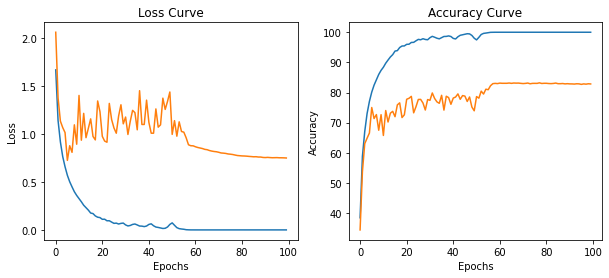

Final Training Accuracy: 100.0
Final Validation Accuracy: 82.8399999633789


In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_ColorJitter)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_ColorJitter)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

directory = "/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/WRN/WRNModel_Color_Jitter"

for i, (input, target) in enumerate(trainloader):
  print(input.size())
  break

main("WRN",'wide-resnet','train', directory, 100)

Files already downloaded and verified
Files already downloaded and verified


Number of parameters: 1733466
Number of parameters: 1733466
Number of parameters: 1733466


Logging into /content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Inception...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:144: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
000: Acc-tr:  44.94, Acc-val:  56.68, L-tr: 1.5332, L-val: 1.1979
000: Acc-tr:  44.94, Acc-val:  56.68, L-tr: 1.5332, L-val: 1.1979
000: Acc-tr:  44.94, Acc-val:  56.68, L-tr: 1.5332, L-val: 1.1979


Epoch 0 Finished.  Time per Epoch:  51.74 s 


001: Acc-tr:  65.88, Acc-val:  61.95, L-tr: 0.9583, L-val: 1.1312
001: Acc-tr:  65.88, Acc-val:  61.95, L-tr: 0.9583, L-val: 1.1312
001: Acc-tr:  65.88, Acc-val:  61.95, L-tr: 0.9583, L-val: 1.1312


Epoch 1 Finished.  Time per Epoch:  48.00 s 


002: Acc-tr:  73.94, Acc-val:  72.94, L-tr: 0.7393, L-val: 0.7933
002: Acc-tr:  73.94, Acc-val:  72.94, L-tr: 0.7393, L-val: 0.7933
002: Acc-tr:  73.94, Acc-val:  72.94, L-tr: 0.7393, L-val: 0.7933


Epoch 2 Finished.  Time per Epoch:  46.93 s 


003: Acc-tr:  79.57, Acc-val:  75.74, L-tr: 0.5877, L-val: 0.7061
003: Acc-tr:  79.57, Acc-val:  75.74, L-tr: 0.5877, L-val: 0.7061
003: Acc-tr:  79.57, Acc-val:  75.74, L-tr: 0.5877, L-val: 0.7061


Epoch 3 Finished.  Time per Epoch:  46.38 s 


004: Acc-tr:  82.31, Acc-val:  75.07, L-tr: 0.5029, L-val: 0.7492
004: Acc-tr:  82.31, Acc-val:  75.07, L-tr: 0.5029, L-val: 0.7492
004: Acc-tr:  82.31, Acc-val:  75.07, L-tr: 0.5029, L-val: 0.7492


Epoch 4 Finished.  Time per Epoch:  46.09 s 


005: Acc-tr:  85.37, Acc-val:  75.02, L-tr: 0.4209, L-val: 0.7784
005: Acc-tr:  85.37, Acc-val:  75.02, L-tr: 0.4209, L-val: 0.7784
005: Acc-tr:  85.37, Acc-val:  75.02, L-tr: 0.4209, L-val: 0.7784


Epoch 5 Finished.  Time per Epoch:  45.90 s 


006: Acc-tr:  87.56, Acc-val:  75.75, L-tr: 0.3532, L-val: 0.7721
006: Acc-tr:  87.56, Acc-val:  75.75, L-tr: 0.3532, L-val: 0.7721
006: Acc-tr:  87.56, Acc-val:  75.75, L-tr: 0.3532, L-val: 0.7721


Epoch 6 Finished.  Time per Epoch:  45.78 s 


007: Acc-tr:  90.02, Acc-val:  76.22, L-tr: 0.2839, L-val: 0.8303
007: Acc-tr:  90.02, Acc-val:  76.22, L-tr: 0.2839, L-val: 0.8303
007: Acc-tr:  90.02, Acc-val:  76.22, L-tr: 0.2839, L-val: 0.8303


Epoch 7 Finished.  Time per Epoch:  45.68 s 


008: Acc-tr:  91.62, Acc-val:  78.66, L-tr: 0.2371, L-val: 0.6974
008: Acc-tr:  91.62, Acc-val:  78.66, L-tr: 0.2371, L-val: 0.6974
008: Acc-tr:  91.62, Acc-val:  78.66, L-tr: 0.2371, L-val: 0.6974


Epoch 8 Finished.  Time per Epoch:  45.60 s 


009: Acc-tr:  93.11, Acc-val:  79.80, L-tr: 0.1941, L-val: 0.7060
009: Acc-tr:  93.11, Acc-val:  79.80, L-tr: 0.1941, L-val: 0.7060
009: Acc-tr:  93.11, Acc-val:  79.80, L-tr: 0.1941, L-val: 0.7060


Epoch 9 Finished.  Time per Epoch:  45.54 s 


010: Acc-tr:  94.27, Acc-val:  80.05, L-tr: 0.1604, L-val: 0.7325
010: Acc-tr:  94.27, Acc-val:  80.05, L-tr: 0.1604, L-val: 0.7325
010: Acc-tr:  94.27, Acc-val:  80.05, L-tr: 0.1604, L-val: 0.7325


Epoch 10 Finished.  Time per Epoch:  45.49 s 


011: Acc-tr:  95.31, Acc-val:  77.93, L-tr: 0.1314, L-val: 0.8464
011: Acc-tr:  95.31, Acc-val:  77.93, L-tr: 0.1314, L-val: 0.8464
011: Acc-tr:  95.31, Acc-val:  77.93, L-tr: 0.1314, L-val: 0.8464


Epoch 11 Finished.  Time per Epoch:  45.45 s 


012: Acc-tr:  96.45, Acc-val:  77.95, L-tr: 0.1006, L-val: 0.9604
012: Acc-tr:  96.45, Acc-val:  77.95, L-tr: 0.1006, L-val: 0.9604
012: Acc-tr:  96.45, Acc-val:  77.95, L-tr: 0.1006, L-val: 0.9604


Epoch 12 Finished.  Time per Epoch:  45.42 s 


013: Acc-tr:  96.91, Acc-val:  80.75, L-tr: 0.0876, L-val: 0.8637
013: Acc-tr:  96.91, Acc-val:  80.75, L-tr: 0.0876, L-val: 0.8637
013: Acc-tr:  96.91, Acc-val:  80.75, L-tr: 0.0876, L-val: 0.8637


Epoch 13 Finished.  Time per Epoch:  45.39 s 


014: Acc-tr:  97.85, Acc-val:  78.48, L-tr: 0.0640, L-val: 1.0579
014: Acc-tr:  97.85, Acc-val:  78.48, L-tr: 0.0640, L-val: 1.0579
014: Acc-tr:  97.85, Acc-val:  78.48, L-tr: 0.0640, L-val: 1.0579


Epoch 14 Finished.  Time per Epoch:  45.37 s 


015: Acc-tr:  97.94, Acc-val:  78.64, L-tr: 0.0601, L-val: 1.0452
015: Acc-tr:  97.94, Acc-val:  78.64, L-tr: 0.0601, L-val: 1.0452
015: Acc-tr:  97.94, Acc-val:  78.64, L-tr: 0.0601, L-val: 1.0452


Epoch 15 Finished.  Time per Epoch:  45.35 s 


016: Acc-tr:  98.23, Acc-val:  80.69, L-tr: 0.0519, L-val: 0.8936
016: Acc-tr:  98.23, Acc-val:  80.69, L-tr: 0.0519, L-val: 0.8936
016: Acc-tr:  98.23, Acc-val:  80.69, L-tr: 0.0519, L-val: 0.8936


Epoch 16 Finished.  Time per Epoch:  45.34 s 


017: Acc-tr:  98.97, Acc-val:  79.11, L-tr: 0.0322, L-val: 1.1019
017: Acc-tr:  98.97, Acc-val:  79.11, L-tr: 0.0322, L-val: 1.1019
017: Acc-tr:  98.97, Acc-val:  79.11, L-tr: 0.0322, L-val: 1.1019


Epoch 17 Finished.  Time per Epoch:  45.32 s 


018: Acc-tr:  99.53, Acc-val:  82.34, L-tr: 0.0175, L-val: 0.8763
018: Acc-tr:  99.53, Acc-val:  82.34, L-tr: 0.0175, L-val: 0.8763
018: Acc-tr:  99.53, Acc-val:  82.34, L-tr: 0.0175, L-val: 0.8763


Epoch 18 Finished.  Time per Epoch:  45.31 s 


019: Acc-tr:  99.40, Acc-val:  80.22, L-tr: 0.0197, L-val: 1.0624
019: Acc-tr:  99.40, Acc-val:  80.22, L-tr: 0.0197, L-val: 1.0624
019: Acc-tr:  99.40, Acc-val:  80.22, L-tr: 0.0197, L-val: 1.0624


Epoch 19 Finished.  Time per Epoch:  45.30 s 


020: Acc-tr:  99.19, Acc-val:  79.73, L-tr: 0.0249, L-val: 1.0937
020: Acc-tr:  99.19, Acc-val:  79.73, L-tr: 0.0249, L-val: 1.0937
020: Acc-tr:  99.19, Acc-val:  79.73, L-tr: 0.0249, L-val: 1.0937


Epoch 20 Finished.  Time per Epoch:  45.29 s 


021: Acc-tr:  99.11, Acc-val:  78.60, L-tr: 0.0275, L-val: 1.1593
021: Acc-tr:  99.11, Acc-val:  78.60, L-tr: 0.0275, L-val: 1.1593
021: Acc-tr:  99.11, Acc-val:  78.60, L-tr: 0.0275, L-val: 1.1593


Epoch 21 Finished.  Time per Epoch:  45.28 s 


022: Acc-tr:  98.80, Acc-val:  80.82, L-tr: 0.0358, L-val: 0.8896
022: Acc-tr:  98.80, Acc-val:  80.82, L-tr: 0.0358, L-val: 0.8896
022: Acc-tr:  98.80, Acc-val:  80.82, L-tr: 0.0358, L-val: 0.8896


Epoch 22 Finished.  Time per Epoch:  45.27 s 


023: Acc-tr:  98.53, Acc-val:  82.53, L-tr: 0.0429, L-val: 0.8245
023: Acc-tr:  98.53, Acc-val:  82.53, L-tr: 0.0429, L-val: 0.8245
023: Acc-tr:  98.53, Acc-val:  82.53, L-tr: 0.0429, L-val: 0.8245


Epoch 23 Finished.  Time per Epoch:  45.27 s 


024: Acc-tr:  98.92, Acc-val:  80.42, L-tr: 0.0327, L-val: 1.0342
024: Acc-tr:  98.92, Acc-val:  80.42, L-tr: 0.0327, L-val: 1.0342
024: Acc-tr:  98.92, Acc-val:  80.42, L-tr: 0.0327, L-val: 1.0342


Epoch 24 Finished.  Time per Epoch:  45.25 s 


025: Acc-tr:  99.30, Acc-val:  83.46, L-tr: 0.0220, L-val: 0.7802
025: Acc-tr:  99.30, Acc-val:  83.46, L-tr: 0.0220, L-val: 0.7802
025: Acc-tr:  99.30, Acc-val:  83.46, L-tr: 0.0220, L-val: 0.7802


Epoch 25 Finished.  Time per Epoch:  45.23 s 


026: Acc-tr:  99.63, Acc-val:  84.72, L-tr: 0.0129, L-val: 0.7421
026: Acc-tr:  99.63, Acc-val:  84.72, L-tr: 0.0129, L-val: 0.7421
026: Acc-tr:  99.63, Acc-val:  84.72, L-tr: 0.0129, L-val: 0.7421


Epoch 26 Finished.  Time per Epoch:  45.22 s 


027: Acc-tr:  99.81, Acc-val:  85.20, L-tr: 0.0077, L-val: 0.7413
027: Acc-tr:  99.81, Acc-val:  85.20, L-tr: 0.0077, L-val: 0.7413
027: Acc-tr:  99.81, Acc-val:  85.20, L-tr: 0.0077, L-val: 0.7413


Epoch 27 Finished.  Time per Epoch:  45.21 s 


028: Acc-tr:  99.90, Acc-val:  84.92, L-tr: 0.0048, L-val: 0.7654
028: Acc-tr:  99.90, Acc-val:  84.92, L-tr: 0.0048, L-val: 0.7654
028: Acc-tr:  99.90, Acc-val:  84.92, L-tr: 0.0048, L-val: 0.7654


Epoch 28 Finished.  Time per Epoch:  45.20 s 


029: Acc-tr:  99.99, Acc-val:  86.03, L-tr: 0.0011, L-val: 0.6747
029: Acc-tr:  99.99, Acc-val:  86.03, L-tr: 0.0011, L-val: 0.6747
029: Acc-tr:  99.99, Acc-val:  86.03, L-tr: 0.0011, L-val: 0.6747


Epoch 29 Finished.  Time per Epoch:  45.19 s 


030: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0004, L-val: 0.6634
030: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0004, L-val: 0.6634
030: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0004, L-val: 0.6634


Epoch 30 Finished.  Time per Epoch:  45.19 s 


031: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.6601
031: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.6601
031: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.6601


Epoch 31 Finished.  Time per Epoch:  45.19 s 


032: Acc-tr: 100.00, Acc-val:  86.20, L-tr: 0.0003, L-val: 0.6543
032: Acc-tr: 100.00, Acc-val:  86.20, L-tr: 0.0003, L-val: 0.6543
032: Acc-tr: 100.00, Acc-val:  86.20, L-tr: 0.0003, L-val: 0.6543


Epoch 32 Finished.  Time per Epoch:  45.19 s 


033: Acc-tr: 100.00, Acc-val:  86.31, L-tr: 0.0002, L-val: 0.6487
033: Acc-tr: 100.00, Acc-val:  86.31, L-tr: 0.0002, L-val: 0.6487
033: Acc-tr: 100.00, Acc-val:  86.31, L-tr: 0.0002, L-val: 0.6487


Epoch 33 Finished.  Time per Epoch:  45.18 s 


034: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0002, L-val: 0.6455
034: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0002, L-val: 0.6455
034: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0002, L-val: 0.6455


Epoch 34 Finished.  Time per Epoch:  45.17 s 


035: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0002, L-val: 0.6424
035: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0002, L-val: 0.6424
035: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0002, L-val: 0.6424


Epoch 35 Finished.  Time per Epoch:  45.16 s 


036: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0002, L-val: 0.6369
036: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0002, L-val: 0.6369
036: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0002, L-val: 0.6369


Epoch 36 Finished.  Time per Epoch:  45.15 s 


037: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0002, L-val: 0.6338
037: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0002, L-val: 0.6338
037: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0002, L-val: 0.6338


Epoch 37 Finished.  Time per Epoch:  45.13 s 


038: Acc-tr: 100.00, Acc-val:  86.34, L-tr: 0.0003, L-val: 0.6283
038: Acc-tr: 100.00, Acc-val:  86.34, L-tr: 0.0003, L-val: 0.6283
038: Acc-tr: 100.00, Acc-val:  86.34, L-tr: 0.0003, L-val: 0.6283


Epoch 38 Finished.  Time per Epoch:  45.13 s 


039: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0003, L-val: 0.6239
039: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0003, L-val: 0.6239
039: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0003, L-val: 0.6239


Epoch 39 Finished.  Time per Epoch:  45.12 s 


040: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.6211
040: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.6211
040: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.6211


Epoch 40 Finished.  Time per Epoch:  45.11 s 


041: Acc-tr: 100.00, Acc-val:  86.29, L-tr: 0.0003, L-val: 0.6184
041: Acc-tr: 100.00, Acc-val:  86.29, L-tr: 0.0003, L-val: 0.6184
041: Acc-tr: 100.00, Acc-val:  86.29, L-tr: 0.0003, L-val: 0.6184


Epoch 41 Finished.  Time per Epoch:  45.10 s 


042: Acc-tr: 100.00, Acc-val:  86.37, L-tr: 0.0003, L-val: 0.6145
042: Acc-tr: 100.00, Acc-val:  86.37, L-tr: 0.0003, L-val: 0.6145
042: Acc-tr: 100.00, Acc-val:  86.37, L-tr: 0.0003, L-val: 0.6145


Epoch 42 Finished.  Time per Epoch:  45.10 s 


043: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.6088
043: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.6088
043: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.6088


Epoch 43 Finished.  Time per Epoch:  45.09 s 


044: Acc-tr: 100.00, Acc-val:  86.33, L-tr: 0.0003, L-val: 0.6076
044: Acc-tr: 100.00, Acc-val:  86.33, L-tr: 0.0003, L-val: 0.6076
044: Acc-tr: 100.00, Acc-val:  86.33, L-tr: 0.0003, L-val: 0.6076


Epoch 44 Finished.  Time per Epoch:  45.08 s 


045: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.6039
045: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.6039
045: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.6039


Epoch 45 Finished.  Time per Epoch:  45.08 s 


046: Acc-tr: 100.00, Acc-val:  86.33, L-tr: 0.0003, L-val: 0.6015
046: Acc-tr: 100.00, Acc-val:  86.33, L-tr: 0.0003, L-val: 0.6015
046: Acc-tr: 100.00, Acc-val:  86.33, L-tr: 0.0003, L-val: 0.6015


Epoch 46 Finished.  Time per Epoch:  45.07 s 


047: Acc-tr: 100.00, Acc-val:  86.46, L-tr: 0.0003, L-val: 0.5990
047: Acc-tr: 100.00, Acc-val:  86.46, L-tr: 0.0003, L-val: 0.5990
047: Acc-tr: 100.00, Acc-val:  86.46, L-tr: 0.0003, L-val: 0.5990


Epoch 47 Finished.  Time per Epoch:  45.07 s 


048: Acc-tr: 100.00, Acc-val:  86.39, L-tr: 0.0003, L-val: 0.5953
048: Acc-tr: 100.00, Acc-val:  86.39, L-tr: 0.0003, L-val: 0.5953
048: Acc-tr: 100.00, Acc-val:  86.39, L-tr: 0.0003, L-val: 0.5953


Epoch 48 Finished.  Time per Epoch:  45.06 s 


049: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5954
049: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5954
049: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5954


Epoch 49 Finished.  Time per Epoch:  45.06 s 


050: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0003, L-val: 0.5932
050: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0003, L-val: 0.5932
050: Acc-tr: 100.00, Acc-val:  86.25, L-tr: 0.0003, L-val: 0.5932


Epoch 50 Finished.  Time per Epoch:  45.05 s 


051: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5887
051: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5887
051: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5887


Epoch 51 Finished.  Time per Epoch:  45.05 s 


052: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.5878
052: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.5878
052: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.5878


Epoch 52 Finished.  Time per Epoch:  45.04 s 


053: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.5864
053: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.5864
053: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.5864


Epoch 53 Finished.  Time per Epoch:  45.04 s 


054: Acc-tr: 100.00, Acc-val:  86.38, L-tr: 0.0003, L-val: 0.5842
054: Acc-tr: 100.00, Acc-val:  86.38, L-tr: 0.0003, L-val: 0.5842
054: Acc-tr: 100.00, Acc-val:  86.38, L-tr: 0.0003, L-val: 0.5842


Epoch 54 Finished.  Time per Epoch:  45.03 s 


055: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5834
055: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5834
055: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5834


Epoch 55 Finished.  Time per Epoch:  45.03 s 


056: Acc-tr: 100.00, Acc-val:  86.32, L-tr: 0.0003, L-val: 0.5830
056: Acc-tr: 100.00, Acc-val:  86.32, L-tr: 0.0003, L-val: 0.5830
056: Acc-tr: 100.00, Acc-val:  86.32, L-tr: 0.0003, L-val: 0.5830


Epoch 56 Finished.  Time per Epoch:  45.03 s 


057: Acc-tr: 100.00, Acc-val:  86.30, L-tr: 0.0003, L-val: 0.5819
057: Acc-tr: 100.00, Acc-val:  86.30, L-tr: 0.0003, L-val: 0.5819
057: Acc-tr: 100.00, Acc-val:  86.30, L-tr: 0.0003, L-val: 0.5819


Epoch 57 Finished.  Time per Epoch:  45.02 s 


058: Acc-tr: 100.00, Acc-val:  86.36, L-tr: 0.0003, L-val: 0.5786
058: Acc-tr: 100.00, Acc-val:  86.36, L-tr: 0.0003, L-val: 0.5786
058: Acc-tr: 100.00, Acc-val:  86.36, L-tr: 0.0003, L-val: 0.5786


Epoch 58 Finished.  Time per Epoch:  45.02 s 


059: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5786
059: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5786
059: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5786


Epoch 59 Finished.  Time per Epoch:  45.01 s 


060: Acc-tr: 100.00, Acc-val:  86.31, L-tr: 0.0003, L-val: 0.5800
060: Acc-tr: 100.00, Acc-val:  86.31, L-tr: 0.0003, L-val: 0.5800
060: Acc-tr: 100.00, Acc-val:  86.31, L-tr: 0.0003, L-val: 0.5800


Epoch 60 Finished.  Time per Epoch:  45.01 s 


061: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5770
061: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5770
061: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5770


Epoch 61 Finished.  Time per Epoch:  45.01 s 


062: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5762
062: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5762
062: Acc-tr: 100.00, Acc-val:  86.35, L-tr: 0.0003, L-val: 0.5762


Epoch 62 Finished.  Time per Epoch:  45.00 s 


063: Acc-tr: 100.00, Acc-val:  86.32, L-tr: 0.0003, L-val: 0.5749
063: Acc-tr: 100.00, Acc-val:  86.32, L-tr: 0.0003, L-val: 0.5749
063: Acc-tr: 100.00, Acc-val:  86.32, L-tr: 0.0003, L-val: 0.5749


Epoch 63 Finished.  Time per Epoch:  45.00 s 


064: Acc-tr: 100.00, Acc-val:  86.30, L-tr: 0.0003, L-val: 0.5742
064: Acc-tr: 100.00, Acc-val:  86.30, L-tr: 0.0003, L-val: 0.5742
064: Acc-tr: 100.00, Acc-val:  86.30, L-tr: 0.0003, L-val: 0.5742


Epoch 64 Finished.  Time per Epoch:  45.00 s 


065: Acc-tr: 100.00, Acc-val:  86.32, L-tr: 0.0003, L-val: 0.5753
065: Acc-tr: 100.00, Acc-val:  86.32, L-tr: 0.0003, L-val: 0.5753
065: Acc-tr: 100.00, Acc-val:  86.32, L-tr: 0.0003, L-val: 0.5753


Epoch 65 Finished.  Time per Epoch:  44.99 s 


066: Acc-tr: 100.00, Acc-val:  86.31, L-tr: 0.0003, L-val: 0.5748
066: Acc-tr: 100.00, Acc-val:  86.31, L-tr: 0.0003, L-val: 0.5748
066: Acc-tr: 100.00, Acc-val:  86.31, L-tr: 0.0003, L-val: 0.5748


Epoch 66 Finished.  Time per Epoch:  44.99 s 


067: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.5737
067: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.5737
067: Acc-tr: 100.00, Acc-val:  86.27, L-tr: 0.0003, L-val: 0.5737


Epoch 67 Finished.  Time per Epoch:  44.99 s 


068: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0003, L-val: 0.5730
068: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0003, L-val: 0.5730
068: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0003, L-val: 0.5730


Epoch 68 Finished.  Time per Epoch:  44.98 s 


069: Acc-tr: 100.00, Acc-val:  86.36, L-tr: 0.0003, L-val: 0.5735
069: Acc-tr: 100.00, Acc-val:  86.36, L-tr: 0.0003, L-val: 0.5735
069: Acc-tr: 100.00, Acc-val:  86.36, L-tr: 0.0003, L-val: 0.5735


Epoch 69 Finished.  Time per Epoch:  44.98 s 


070: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0003, L-val: 0.5724
070: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0003, L-val: 0.5724
070: Acc-tr: 100.00, Acc-val:  86.26, L-tr: 0.0003, L-val: 0.5724


Epoch 70 Finished.  Time per Epoch:  44.98 s 


071: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.5740
071: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.5740
071: Acc-tr: 100.00, Acc-val:  86.28, L-tr: 0.0003, L-val: 0.5740


Epoch 71 Finished.  Time per Epoch:  44.98 s 


072: Acc-tr: 100.00, Acc-val:  86.19, L-tr: 0.0003, L-val: 0.5708
072: Acc-tr: 100.00, Acc-val:  86.19, L-tr: 0.0003, L-val: 0.5708
072: Acc-tr: 100.00, Acc-val:  86.19, L-tr: 0.0003, L-val: 0.5708


Epoch 72 Finished.  Time per Epoch:  44.97 s 


073: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5698
073: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5698
073: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5698


Epoch 73 Finished.  Time per Epoch:  44.97 s 


074: Acc-tr: 100.00, Acc-val:  86.17, L-tr: 0.0003, L-val: 0.5719
074: Acc-tr: 100.00, Acc-val:  86.17, L-tr: 0.0003, L-val: 0.5719
074: Acc-tr: 100.00, Acc-val:  86.17, L-tr: 0.0003, L-val: 0.5719


Epoch 74 Finished.  Time per Epoch:  44.97 s 


075: Acc-tr: 100.00, Acc-val:  86.10, L-tr: 0.0003, L-val: 0.5720
075: Acc-tr: 100.00, Acc-val:  86.10, L-tr: 0.0003, L-val: 0.5720
075: Acc-tr: 100.00, Acc-val:  86.10, L-tr: 0.0003, L-val: 0.5720


Epoch 75 Finished.  Time per Epoch:  44.97 s 


076: Acc-tr: 100.00, Acc-val:  86.38, L-tr: 0.0003, L-val: 0.5701
076: Acc-tr: 100.00, Acc-val:  86.38, L-tr: 0.0003, L-val: 0.5701
076: Acc-tr: 100.00, Acc-val:  86.38, L-tr: 0.0003, L-val: 0.5701


Epoch 76 Finished.  Time per Epoch:  44.96 s 


077: Acc-tr: 100.00, Acc-val:  86.18, L-tr: 0.0003, L-val: 0.5725
077: Acc-tr: 100.00, Acc-val:  86.18, L-tr: 0.0003, L-val: 0.5725
077: Acc-tr: 100.00, Acc-val:  86.18, L-tr: 0.0003, L-val: 0.5725


Epoch 77 Finished.  Time per Epoch:  44.96 s 


078: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5708
078: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5708
078: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5708


Epoch 78 Finished.  Time per Epoch:  44.96 s 


079: Acc-tr: 100.00, Acc-val:  86.16, L-tr: 0.0003, L-val: 0.5719
079: Acc-tr: 100.00, Acc-val:  86.16, L-tr: 0.0003, L-val: 0.5719
079: Acc-tr: 100.00, Acc-val:  86.16, L-tr: 0.0003, L-val: 0.5719


Epoch 79 Finished.  Time per Epoch:  44.96 s 


080: Acc-tr: 100.00, Acc-val:  86.12, L-tr: 0.0003, L-val: 0.5707
080: Acc-tr: 100.00, Acc-val:  86.12, L-tr: 0.0003, L-val: 0.5707
080: Acc-tr: 100.00, Acc-val:  86.12, L-tr: 0.0003, L-val: 0.5707


Epoch 80 Finished.  Time per Epoch:  44.95 s 


081: Acc-tr: 100.00, Acc-val:  86.13, L-tr: 0.0003, L-val: 0.5727
081: Acc-tr: 100.00, Acc-val:  86.13, L-tr: 0.0003, L-val: 0.5727
081: Acc-tr: 100.00, Acc-val:  86.13, L-tr: 0.0003, L-val: 0.5727


Epoch 81 Finished.  Time per Epoch:  44.95 s 


082: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5706
082: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5706
082: Acc-tr: 100.00, Acc-val:  86.22, L-tr: 0.0003, L-val: 0.5706


Epoch 82 Finished.  Time per Epoch:  44.95 s 


083: Acc-tr: 100.00, Acc-val:  86.07, L-tr: 0.0003, L-val: 0.5712
083: Acc-tr: 100.00, Acc-val:  86.07, L-tr: 0.0003, L-val: 0.5712
083: Acc-tr: 100.00, Acc-val:  86.07, L-tr: 0.0003, L-val: 0.5712


Epoch 83 Finished.  Time per Epoch:  44.95 s 


084: Acc-tr: 100.00, Acc-val:  86.08, L-tr: 0.0003, L-val: 0.5707
084: Acc-tr: 100.00, Acc-val:  86.08, L-tr: 0.0003, L-val: 0.5707
084: Acc-tr: 100.00, Acc-val:  86.08, L-tr: 0.0003, L-val: 0.5707


Epoch 84 Finished.  Time per Epoch:  44.94 s 


085: Acc-tr: 100.00, Acc-val:  86.15, L-tr: 0.0003, L-val: 0.5700
085: Acc-tr: 100.00, Acc-val:  86.15, L-tr: 0.0003, L-val: 0.5700
085: Acc-tr: 100.00, Acc-val:  86.15, L-tr: 0.0003, L-val: 0.5700


Epoch 85 Finished.  Time per Epoch:  44.94 s 


086: Acc-tr: 100.00, Acc-val:  86.03, L-tr: 0.0003, L-val: 0.5711
086: Acc-tr: 100.00, Acc-val:  86.03, L-tr: 0.0003, L-val: 0.5711
086: Acc-tr: 100.00, Acc-val:  86.03, L-tr: 0.0003, L-val: 0.5711


Epoch 86 Finished.  Time per Epoch:  44.94 s 


087: Acc-tr: 100.00, Acc-val:  86.05, L-tr: 0.0003, L-val: 0.5707
087: Acc-tr: 100.00, Acc-val:  86.05, L-tr: 0.0003, L-val: 0.5707
087: Acc-tr: 100.00, Acc-val:  86.05, L-tr: 0.0003, L-val: 0.5707


Epoch 87 Finished.  Time per Epoch:  44.94 s 


088: Acc-tr: 100.00, Acc-val:  86.11, L-tr: 0.0003, L-val: 0.5704
088: Acc-tr: 100.00, Acc-val:  86.11, L-tr: 0.0003, L-val: 0.5704
088: Acc-tr: 100.00, Acc-val:  86.11, L-tr: 0.0003, L-val: 0.5704


Epoch 88 Finished.  Time per Epoch:  44.93 s 


089: Acc-tr: 100.00, Acc-val:  86.03, L-tr: 0.0003, L-val: 0.5717
089: Acc-tr: 100.00, Acc-val:  86.03, L-tr: 0.0003, L-val: 0.5717
089: Acc-tr: 100.00, Acc-val:  86.03, L-tr: 0.0003, L-val: 0.5717


Epoch 89 Finished.  Time per Epoch:  44.93 s 


090: Acc-tr: 100.00, Acc-val:  86.06, L-tr: 0.0003, L-val: 0.5719
090: Acc-tr: 100.00, Acc-val:  86.06, L-tr: 0.0003, L-val: 0.5719
090: Acc-tr: 100.00, Acc-val:  86.06, L-tr: 0.0003, L-val: 0.5719


Epoch 90 Finished.  Time per Epoch:  44.93 s 


091: Acc-tr: 100.00, Acc-val:  85.90, L-tr: 0.0003, L-val: 0.5713
091: Acc-tr: 100.00, Acc-val:  85.90, L-tr: 0.0003, L-val: 0.5713
091: Acc-tr: 100.00, Acc-val:  85.90, L-tr: 0.0003, L-val: 0.5713


Epoch 91 Finished.  Time per Epoch:  44.93 s 


092: Acc-tr: 100.00, Acc-val:  85.99, L-tr: 0.0003, L-val: 0.5726
092: Acc-tr: 100.00, Acc-val:  85.99, L-tr: 0.0003, L-val: 0.5726
092: Acc-tr: 100.00, Acc-val:  85.99, L-tr: 0.0003, L-val: 0.5726


Epoch 92 Finished.  Time per Epoch:  44.93 s 


093: Acc-tr: 100.00, Acc-val:  86.04, L-tr: 0.0003, L-val: 0.5738
093: Acc-tr: 100.00, Acc-val:  86.04, L-tr: 0.0003, L-val: 0.5738
093: Acc-tr: 100.00, Acc-val:  86.04, L-tr: 0.0003, L-val: 0.5738


Epoch 93 Finished.  Time per Epoch:  44.92 s 


094: Acc-tr: 100.00, Acc-val:  86.05, L-tr: 0.0003, L-val: 0.5745
094: Acc-tr: 100.00, Acc-val:  86.05, L-tr: 0.0003, L-val: 0.5745
094: Acc-tr: 100.00, Acc-val:  86.05, L-tr: 0.0003, L-val: 0.5745


Epoch 94 Finished.  Time per Epoch:  44.92 s 


095: Acc-tr: 100.00, Acc-val:  86.13, L-tr: 0.0003, L-val: 0.5722
095: Acc-tr: 100.00, Acc-val:  86.13, L-tr: 0.0003, L-val: 0.5722
095: Acc-tr: 100.00, Acc-val:  86.13, L-tr: 0.0003, L-val: 0.5722


Epoch 95 Finished.  Time per Epoch:  44.92 s 


096: Acc-tr: 100.00, Acc-val:  86.06, L-tr: 0.0003, L-val: 0.5713
096: Acc-tr: 100.00, Acc-val:  86.06, L-tr: 0.0003, L-val: 0.5713
096: Acc-tr: 100.00, Acc-val:  86.06, L-tr: 0.0003, L-val: 0.5713


Epoch 96 Finished.  Time per Epoch:  44.92 s 


097: Acc-tr: 100.00, Acc-val:  86.03, L-tr: 0.0003, L-val: 0.5728
097: Acc-tr: 100.00, Acc-val:  86.03, L-tr: 0.0003, L-val: 0.5728
097: Acc-tr: 100.00, Acc-val:  86.03, L-tr: 0.0003, L-val: 0.5728


Epoch 97 Finished.  Time per Epoch:  44.91 s 


098: Acc-tr: 100.00, Acc-val:  85.95, L-tr: 0.0003, L-val: 0.5730
098: Acc-tr: 100.00, Acc-val:  85.95, L-tr: 0.0003, L-val: 0.5730
098: Acc-tr: 100.00, Acc-val:  85.95, L-tr: 0.0003, L-val: 0.5730


Epoch 98 Finished.  Time per Epoch:  44.91 s 


099: Acc-tr: 100.00, Acc-val:  86.06, L-tr: 0.0003, L-val: 0.5736
099: Acc-tr: 100.00, Acc-val:  86.06, L-tr: 0.0003, L-val: 0.5736
099: Acc-tr: 100.00, Acc-val:  86.06, L-tr: 0.0003, L-val: 0.5736


Epoch 99 Finished.  Time per Epoch:  44.91 s 


100: Acc-tr: 100.00, Acc-val:  86.02, L-tr: 0.0003, L-val: 0.5746
100: Acc-tr: 100.00, Acc-val:  86.02, L-tr: 0.0003, L-val: 0.5746
100: Acc-tr: 100.00, Acc-val:  86.02, L-tr: 0.0003, L-val: 0.5746


Epoch 100 Finished.  Time per Epoch:  44.91 s 


101: Acc-tr: 100.00, Acc-val:  86.08, L-tr: 0.0003, L-val: 0.5727
101: Acc-tr: 100.00, Acc-val:  86.08, L-tr: 0.0003, L-val: 0.5727
101: Acc-tr: 100.00, Acc-val:  86.08, L-tr: 0.0003, L-val: 0.5727


Epoch 101 Finished.  Time per Epoch:  44.90 s 


102: Acc-tr: 100.00, Acc-val:  86.09, L-tr: 0.0003, L-val: 0.5748
102: Acc-tr: 100.00, Acc-val:  86.09, L-tr: 0.0003, L-val: 0.5748
102: Acc-tr: 100.00, Acc-val:  86.09, L-tr: 0.0003, L-val: 0.5748


Epoch 102 Finished.  Time per Epoch:  44.91 s 


103: Acc-tr: 100.00, Acc-val:  85.97, L-tr: 0.0003, L-val: 0.5760
103: Acc-tr: 100.00, Acc-val:  85.97, L-tr: 0.0003, L-val: 0.5760
103: Acc-tr: 100.00, Acc-val:  85.97, L-tr: 0.0003, L-val: 0.5760


Epoch 103 Finished.  Time per Epoch:  44.91 s 


104: Acc-tr: 100.00, Acc-val:  86.01, L-tr: 0.0003, L-val: 0.5723
104: Acc-tr: 100.00, Acc-val:  86.01, L-tr: 0.0003, L-val: 0.5723
104: Acc-tr: 100.00, Acc-val:  86.01, L-tr: 0.0003, L-val: 0.5723


Epoch 104 Finished.  Time per Epoch:  44.90 s 


105: Acc-tr: 100.00, Acc-val:  86.11, L-tr: 0.0003, L-val: 0.5759
105: Acc-tr: 100.00, Acc-val:  86.11, L-tr: 0.0003, L-val: 0.5759
105: Acc-tr: 100.00, Acc-val:  86.11, L-tr: 0.0003, L-val: 0.5759


Epoch 105 Finished.  Time per Epoch:  44.90 s 


106: Acc-tr: 100.00, Acc-val:  86.01, L-tr: 0.0003, L-val: 0.5734
106: Acc-tr: 100.00, Acc-val:  86.01, L-tr: 0.0003, L-val: 0.5734
106: Acc-tr: 100.00, Acc-val:  86.01, L-tr: 0.0003, L-val: 0.5734


Epoch 106 Finished.  Time per Epoch:  44.90 s 


107: Acc-tr: 100.00, Acc-val:  85.81, L-tr: 0.0003, L-val: 0.5755
107: Acc-tr: 100.00, Acc-val:  85.81, L-tr: 0.0003, L-val: 0.5755
107: Acc-tr: 100.00, Acc-val:  85.81, L-tr: 0.0003, L-val: 0.5755


Epoch 107 Finished.  Time per Epoch:  44.90 s 


108: Acc-tr: 100.00, Acc-val:  85.73, L-tr: 0.0003, L-val: 0.5750
108: Acc-tr: 100.00, Acc-val:  85.73, L-tr: 0.0003, L-val: 0.5750
108: Acc-tr: 100.00, Acc-val:  85.73, L-tr: 0.0003, L-val: 0.5750


Epoch 108 Finished.  Time per Epoch:  44.90 s 


109: Acc-tr: 100.00, Acc-val:  85.86, L-tr: 0.0003, L-val: 0.5757
109: Acc-tr: 100.00, Acc-val:  85.86, L-tr: 0.0003, L-val: 0.5757
109: Acc-tr: 100.00, Acc-val:  85.86, L-tr: 0.0003, L-val: 0.5757


Epoch 109 Finished.  Time per Epoch:  44.90 s 


110: Acc-tr: 100.00, Acc-val:  85.88, L-tr: 0.0003, L-val: 0.5762
110: Acc-tr: 100.00, Acc-val:  85.88, L-tr: 0.0003, L-val: 0.5762
110: Acc-tr: 100.00, Acc-val:  85.88, L-tr: 0.0003, L-val: 0.5762


Epoch 110 Finished.  Time per Epoch:  44.90 s 


111: Acc-tr: 100.00, Acc-val:  85.80, L-tr: 0.0003, L-val: 0.5774
111: Acc-tr: 100.00, Acc-val:  85.80, L-tr: 0.0003, L-val: 0.5774
111: Acc-tr: 100.00, Acc-val:  85.80, L-tr: 0.0003, L-val: 0.5774


Epoch 111 Finished.  Time per Epoch:  44.89 s 


112: Acc-tr: 100.00, Acc-val:  85.86, L-tr: 0.0003, L-val: 0.5768
112: Acc-tr: 100.00, Acc-val:  85.86, L-tr: 0.0003, L-val: 0.5768
112: Acc-tr: 100.00, Acc-val:  85.86, L-tr: 0.0003, L-val: 0.5768


Epoch 112 Finished.  Time per Epoch:  44.89 s 


113: Acc-tr: 100.00, Acc-val:  85.73, L-tr: 0.0002, L-val: 0.5784
113: Acc-tr: 100.00, Acc-val:  85.73, L-tr: 0.0002, L-val: 0.5784
113: Acc-tr: 100.00, Acc-val:  85.73, L-tr: 0.0002, L-val: 0.5784


Epoch 113 Finished.  Time per Epoch:  44.89 s 


114: Acc-tr: 100.00, Acc-val:  85.79, L-tr: 0.0002, L-val: 0.5770
114: Acc-tr: 100.00, Acc-val:  85.79, L-tr: 0.0002, L-val: 0.5770
114: Acc-tr: 100.00, Acc-val:  85.79, L-tr: 0.0002, L-val: 0.5770


Epoch 114 Finished.  Time per Epoch:  44.89 s 


115: Acc-tr: 100.00, Acc-val:  85.68, L-tr: 0.0002, L-val: 0.5772
115: Acc-tr: 100.00, Acc-val:  85.68, L-tr: 0.0002, L-val: 0.5772
115: Acc-tr: 100.00, Acc-val:  85.68, L-tr: 0.0002, L-val: 0.5772


Epoch 115 Finished.  Time per Epoch:  44.89 s 


116: Acc-tr: 100.00, Acc-val:  85.77, L-tr: 0.0002, L-val: 0.5780
116: Acc-tr: 100.00, Acc-val:  85.77, L-tr: 0.0002, L-val: 0.5780
116: Acc-tr: 100.00, Acc-val:  85.77, L-tr: 0.0002, L-val: 0.5780


Epoch 116 Finished.  Time per Epoch:  44.89 s 


117: Acc-tr: 100.00, Acc-val:  85.77, L-tr: 0.0002, L-val: 0.5769
117: Acc-tr: 100.00, Acc-val:  85.77, L-tr: 0.0002, L-val: 0.5769
117: Acc-tr: 100.00, Acc-val:  85.77, L-tr: 0.0002, L-val: 0.5769


Epoch 117 Finished.  Time per Epoch:  44.89 s 


118: Acc-tr: 100.00, Acc-val:  85.74, L-tr: 0.0002, L-val: 0.5797
118: Acc-tr: 100.00, Acc-val:  85.74, L-tr: 0.0002, L-val: 0.5797
118: Acc-tr: 100.00, Acc-val:  85.74, L-tr: 0.0002, L-val: 0.5797


Epoch 118 Finished.  Time per Epoch:  44.89 s 


119: Acc-tr: 100.00, Acc-val:  85.66, L-tr: 0.0002, L-val: 0.5782
119: Acc-tr: 100.00, Acc-val:  85.66, L-tr: 0.0002, L-val: 0.5782
119: Acc-tr: 100.00, Acc-val:  85.66, L-tr: 0.0002, L-val: 0.5782


Epoch 119 Finished.  Time per Epoch:  44.89 s 


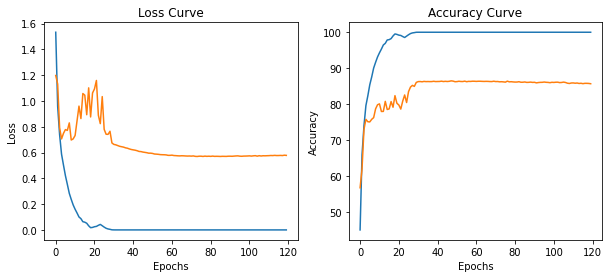

Final Training Accuracy: 100.0
Final Validation Accuracy: 85.66000004882812


In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_ColorJitter)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_ColorJitter)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

directory = "/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Inception/Inception_Color_Jitter"

main("Inception",'inception','train', directory, 120)

##Random Horizontal Flip

In [ ]:
transform_RandomHorizontalFlip = transforms.Compose([
    #transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    myNormalize()
    ])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_RandomHorizontalFlip)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_RandomHorizontalFlip)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

directory = "/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/WRN/WRNModel_transform_RandomHorizontalFlip"

for i, (input, target) in enumerate(trainloader):
  print(input.size())
  break

main("WRN",'wide-resnet','train', directory, 110)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([512, 3, 32, 32])


Number of parameters: 369498
Number of parameters: 369498
Number of parameters: 369498
Number of parameters: 369498
Number of parameters: 369498


Logging into /content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/WRN...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:144: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
000: Acc-tr:  38.42, Acc-val:  48.71, L-tr: 1.6660, L-val: 1.4607
000: Acc-tr:  38.42, Acc-val:  48.71, L-tr: 1.6660, L-val: 1.4607
000: Acc-tr:  38.42, Acc-val:  48.71, L-tr: 1.6660, L-val: 1.4607
000: Acc-tr:  38.42, Acc-val:  48.71, L-tr: 1.6660, L-val: 1.4607
000: Acc-tr:  38.42, Acc-val:  48.71, L-tr: 1.6660, L-val: 1.4607


Epoch 0 Finished.  Time per Epoch:  27.57 s 


001: Acc-tr:  58.69, Acc-val:  58.21, L-tr: 1.1407, L-val: 1.1818
001: Acc-tr:  58.69, Acc-val:  58.21, L-tr: 1.1407, L-val: 1.1818
001: Acc-tr:  58.69, Acc-val:  58.21, L-tr: 1.1407, L-val: 1.1818
001: Acc-tr:  58.69, Acc-val:  58.21, L-tr: 1.1407, L-val: 1.1818
001: Acc-tr:  58.69, Acc-val:  58.21, L-tr: 1.1407, L-val: 1.1818


Epoch 1 Finished.  Time per Epoch:  27.02 s 


002: Acc-tr:  67.53, Acc-val:  61.96, L-tr: 0.9160, L-val: 1.0865
002: Acc-tr:  67.53, Acc-val:  61.96, L-tr: 0.9160, L-val: 1.0865
002: Acc-tr:  67.53, Acc-val:  61.96, L-tr: 0.9160, L-val: 1.0865
002: Acc-tr:  67.53, Acc-val:  61.96, L-tr: 0.9160, L-val: 1.0865
002: Acc-tr:  67.53, Acc-val:  61.96, L-tr: 0.9160, L-val: 1.0865


Epoch 2 Finished.  Time per Epoch:  26.91 s 


003: Acc-tr:  73.02, Acc-val:  61.51, L-tr: 0.7620, L-val: 1.1922
003: Acc-tr:  73.02, Acc-val:  61.51, L-tr: 0.7620, L-val: 1.1922
003: Acc-tr:  73.02, Acc-val:  61.51, L-tr: 0.7620, L-val: 1.1922
003: Acc-tr:  73.02, Acc-val:  61.51, L-tr: 0.7620, L-val: 1.1922
003: Acc-tr:  73.02, Acc-val:  61.51, L-tr: 0.7620, L-val: 1.1922


Epoch 3 Finished.  Time per Epoch:  26.80 s 


004: Acc-tr:  76.83, Acc-val:  70.69, L-tr: 0.6600, L-val: 0.8650
004: Acc-tr:  76.83, Acc-val:  70.69, L-tr: 0.6600, L-val: 0.8650
004: Acc-tr:  76.83, Acc-val:  70.69, L-tr: 0.6600, L-val: 0.8650
004: Acc-tr:  76.83, Acc-val:  70.69, L-tr: 0.6600, L-val: 0.8650
004: Acc-tr:  76.83, Acc-val:  70.69, L-tr: 0.6600, L-val: 0.8650


Epoch 4 Finished.  Time per Epoch:  26.78 s 


005: Acc-tr:  79.61, Acc-val:  75.43, L-tr: 0.5846, L-val: 0.6974
005: Acc-tr:  79.61, Acc-val:  75.43, L-tr: 0.5846, L-val: 0.6974
005: Acc-tr:  79.61, Acc-val:  75.43, L-tr: 0.5846, L-val: 0.6974
005: Acc-tr:  79.61, Acc-val:  75.43, L-tr: 0.5846, L-val: 0.6974
005: Acc-tr:  79.61, Acc-val:  75.43, L-tr: 0.5846, L-val: 0.6974


Epoch 5 Finished.  Time per Epoch:  26.74 s 


006: Acc-tr:  81.60, Acc-val:  77.79, L-tr: 0.5261, L-val: 0.6536
006: Acc-tr:  81.60, Acc-val:  77.79, L-tr: 0.5261, L-val: 0.6536
006: Acc-tr:  81.60, Acc-val:  77.79, L-tr: 0.5261, L-val: 0.6536
006: Acc-tr:  81.60, Acc-val:  77.79, L-tr: 0.5261, L-val: 0.6536
006: Acc-tr:  81.60, Acc-val:  77.79, L-tr: 0.5261, L-val: 0.6536


Epoch 6 Finished.  Time per Epoch:  26.72 s 


007: Acc-tr:  83.14, Acc-val:  76.45, L-tr: 0.4894, L-val: 0.6982
007: Acc-tr:  83.14, Acc-val:  76.45, L-tr: 0.4894, L-val: 0.6982
007: Acc-tr:  83.14, Acc-val:  76.45, L-tr: 0.4894, L-val: 0.6982
007: Acc-tr:  83.14, Acc-val:  76.45, L-tr: 0.4894, L-val: 0.6982
007: Acc-tr:  83.14, Acc-val:  76.45, L-tr: 0.4894, L-val: 0.6982


Epoch 7 Finished.  Time per Epoch:  26.69 s 


008: Acc-tr:  84.40, Acc-val:  74.46, L-tr: 0.4491, L-val: 0.8232
008: Acc-tr:  84.40, Acc-val:  74.46, L-tr: 0.4491, L-val: 0.8232
008: Acc-tr:  84.40, Acc-val:  74.46, L-tr: 0.4491, L-val: 0.8232
008: Acc-tr:  84.40, Acc-val:  74.46, L-tr: 0.4491, L-val: 0.8232
008: Acc-tr:  84.40, Acc-val:  74.46, L-tr: 0.4491, L-val: 0.8232


Epoch 8 Finished.  Time per Epoch:  26.67 s 


009: Acc-tr:  85.74, Acc-val:  76.59, L-tr: 0.4134, L-val: 0.7118
009: Acc-tr:  85.74, Acc-val:  76.59, L-tr: 0.4134, L-val: 0.7118
009: Acc-tr:  85.74, Acc-val:  76.59, L-tr: 0.4134, L-val: 0.7118
009: Acc-tr:  85.74, Acc-val:  76.59, L-tr: 0.4134, L-val: 0.7118
009: Acc-tr:  85.74, Acc-val:  76.59, L-tr: 0.4134, L-val: 0.7118


Epoch 9 Finished.  Time per Epoch:  26.66 s 


010: Acc-tr:  86.53, Acc-val:  73.96, L-tr: 0.3910, L-val: 0.8180
010: Acc-tr:  86.53, Acc-val:  73.96, L-tr: 0.3910, L-val: 0.8180
010: Acc-tr:  86.53, Acc-val:  73.96, L-tr: 0.3910, L-val: 0.8180
010: Acc-tr:  86.53, Acc-val:  73.96, L-tr: 0.3910, L-val: 0.8180
010: Acc-tr:  86.53, Acc-val:  73.96, L-tr: 0.3910, L-val: 0.8180


Epoch 10 Finished.  Time per Epoch:  26.66 s 


011: Acc-tr:  87.33, Acc-val:  72.99, L-tr: 0.3662, L-val: 0.8521
011: Acc-tr:  87.33, Acc-val:  72.99, L-tr: 0.3662, L-val: 0.8521
011: Acc-tr:  87.33, Acc-val:  72.99, L-tr: 0.3662, L-val: 0.8521
011: Acc-tr:  87.33, Acc-val:  72.99, L-tr: 0.3662, L-val: 0.8521
011: Acc-tr:  87.33, Acc-val:  72.99, L-tr: 0.3662, L-val: 0.8521


Epoch 11 Finished.  Time per Epoch:  26.65 s 


012: Acc-tr:  88.02, Acc-val:  80.90, L-tr: 0.3427, L-val: 0.6131
012: Acc-tr:  88.02, Acc-val:  80.90, L-tr: 0.3427, L-val: 0.6131
012: Acc-tr:  88.02, Acc-val:  80.90, L-tr: 0.3427, L-val: 0.6131
012: Acc-tr:  88.02, Acc-val:  80.90, L-tr: 0.3427, L-val: 0.6131
012: Acc-tr:  88.02, Acc-val:  80.90, L-tr: 0.3427, L-val: 0.6131


Epoch 12 Finished.  Time per Epoch:  26.64 s 


013: Acc-tr:  88.51, Acc-val:  75.45, L-tr: 0.3298, L-val: 0.8149
013: Acc-tr:  88.51, Acc-val:  75.45, L-tr: 0.3298, L-val: 0.8149
013: Acc-tr:  88.51, Acc-val:  75.45, L-tr: 0.3298, L-val: 0.8149
013: Acc-tr:  88.51, Acc-val:  75.45, L-tr: 0.3298, L-val: 0.8149
013: Acc-tr:  88.51, Acc-val:  75.45, L-tr: 0.3298, L-val: 0.8149


Epoch 13 Finished.  Time per Epoch:  26.63 s 


014: Acc-tr:  89.32, Acc-val:  79.92, L-tr: 0.3092, L-val: 0.6694
014: Acc-tr:  89.32, Acc-val:  79.92, L-tr: 0.3092, L-val: 0.6694
014: Acc-tr:  89.32, Acc-val:  79.92, L-tr: 0.3092, L-val: 0.6694
014: Acc-tr:  89.32, Acc-val:  79.92, L-tr: 0.3092, L-val: 0.6694
014: Acc-tr:  89.32, Acc-val:  79.92, L-tr: 0.3092, L-val: 0.6694


Epoch 14 Finished.  Time per Epoch:  26.63 s 


015: Acc-tr:  89.97, Acc-val:  79.49, L-tr: 0.2928, L-val: 0.6335
015: Acc-tr:  89.97, Acc-val:  79.49, L-tr: 0.2928, L-val: 0.6335
015: Acc-tr:  89.97, Acc-val:  79.49, L-tr: 0.2928, L-val: 0.6335
015: Acc-tr:  89.97, Acc-val:  79.49, L-tr: 0.2928, L-val: 0.6335
015: Acc-tr:  89.97, Acc-val:  79.49, L-tr: 0.2928, L-val: 0.6335


Epoch 15 Finished.  Time per Epoch:  26.62 s 


016: Acc-tr:  90.37, Acc-val:  78.96, L-tr: 0.2761, L-val: 0.6867
016: Acc-tr:  90.37, Acc-val:  78.96, L-tr: 0.2761, L-val: 0.6867
016: Acc-tr:  90.37, Acc-val:  78.96, L-tr: 0.2761, L-val: 0.6867
016: Acc-tr:  90.37, Acc-val:  78.96, L-tr: 0.2761, L-val: 0.6867
016: Acc-tr:  90.37, Acc-val:  78.96, L-tr: 0.2761, L-val: 0.6867


Epoch 16 Finished.  Time per Epoch:  26.62 s 


017: Acc-tr:  90.75, Acc-val:  77.30, L-tr: 0.2623, L-val: 0.7692
017: Acc-tr:  90.75, Acc-val:  77.30, L-tr: 0.2623, L-val: 0.7692
017: Acc-tr:  90.75, Acc-val:  77.30, L-tr: 0.2623, L-val: 0.7692
017: Acc-tr:  90.75, Acc-val:  77.30, L-tr: 0.2623, L-val: 0.7692
017: Acc-tr:  90.75, Acc-val:  77.30, L-tr: 0.2623, L-val: 0.7692


Epoch 17 Finished.  Time per Epoch:  26.62 s 


018: Acc-tr:  91.22, Acc-val:  80.99, L-tr: 0.2501, L-val: 0.6054
018: Acc-tr:  91.22, Acc-val:  80.99, L-tr: 0.2501, L-val: 0.6054
018: Acc-tr:  91.22, Acc-val:  80.99, L-tr: 0.2501, L-val: 0.6054
018: Acc-tr:  91.22, Acc-val:  80.99, L-tr: 0.2501, L-val: 0.6054
018: Acc-tr:  91.22, Acc-val:  80.99, L-tr: 0.2501, L-val: 0.6054


Epoch 18 Finished.  Time per Epoch:  26.62 s 


019: Acc-tr:  91.64, Acc-val:  82.25, L-tr: 0.2396, L-val: 0.5856
019: Acc-tr:  91.64, Acc-val:  82.25, L-tr: 0.2396, L-val: 0.5856
019: Acc-tr:  91.64, Acc-val:  82.25, L-tr: 0.2396, L-val: 0.5856
019: Acc-tr:  91.64, Acc-val:  82.25, L-tr: 0.2396, L-val: 0.5856
019: Acc-tr:  91.64, Acc-val:  82.25, L-tr: 0.2396, L-val: 0.5856


Epoch 19 Finished.  Time per Epoch:  26.61 s 


020: Acc-tr:  92.13, Acc-val:  81.47, L-tr: 0.2250, L-val: 0.6273
020: Acc-tr:  92.13, Acc-val:  81.47, L-tr: 0.2250, L-val: 0.6273
020: Acc-tr:  92.13, Acc-val:  81.47, L-tr: 0.2250, L-val: 0.6273
020: Acc-tr:  92.13, Acc-val:  81.47, L-tr: 0.2250, L-val: 0.6273
020: Acc-tr:  92.13, Acc-val:  81.47, L-tr: 0.2250, L-val: 0.6273


Epoch 20 Finished.  Time per Epoch:  26.61 s 


021: Acc-tr:  92.71, Acc-val:  82.33, L-tr: 0.2119, L-val: 0.5959
021: Acc-tr:  92.71, Acc-val:  82.33, L-tr: 0.2119, L-val: 0.5959
021: Acc-tr:  92.71, Acc-val:  82.33, L-tr: 0.2119, L-val: 0.5959
021: Acc-tr:  92.71, Acc-val:  82.33, L-tr: 0.2119, L-val: 0.5959
021: Acc-tr:  92.71, Acc-val:  82.33, L-tr: 0.2119, L-val: 0.5959


Epoch 21 Finished.  Time per Epoch:  26.61 s 


022: Acc-tr:  92.97, Acc-val:  80.81, L-tr: 0.2013, L-val: 0.6728
022: Acc-tr:  92.97, Acc-val:  80.81, L-tr: 0.2013, L-val: 0.6728
022: Acc-tr:  92.97, Acc-val:  80.81, L-tr: 0.2013, L-val: 0.6728
022: Acc-tr:  92.97, Acc-val:  80.81, L-tr: 0.2013, L-val: 0.6728
022: Acc-tr:  92.97, Acc-val:  80.81, L-tr: 0.2013, L-val: 0.6728


Epoch 22 Finished.  Time per Epoch:  26.62 s 


023: Acc-tr:  93.26, Acc-val:  80.65, L-tr: 0.1912, L-val: 0.6636
023: Acc-tr:  93.26, Acc-val:  80.65, L-tr: 0.1912, L-val: 0.6636
023: Acc-tr:  93.26, Acc-val:  80.65, L-tr: 0.1912, L-val: 0.6636
023: Acc-tr:  93.26, Acc-val:  80.65, L-tr: 0.1912, L-val: 0.6636
023: Acc-tr:  93.26, Acc-val:  80.65, L-tr: 0.1912, L-val: 0.6636


Epoch 23 Finished.  Time per Epoch:  26.61 s 


024: Acc-tr:  93.65, Acc-val:  82.39, L-tr: 0.1836, L-val: 0.5885
024: Acc-tr:  93.65, Acc-val:  82.39, L-tr: 0.1836, L-val: 0.5885
024: Acc-tr:  93.65, Acc-val:  82.39, L-tr: 0.1836, L-val: 0.5885
024: Acc-tr:  93.65, Acc-val:  82.39, L-tr: 0.1836, L-val: 0.5885
024: Acc-tr:  93.65, Acc-val:  82.39, L-tr: 0.1836, L-val: 0.5885


Epoch 24 Finished.  Time per Epoch:  26.61 s 


025: Acc-tr:  93.96, Acc-val:  82.10, L-tr: 0.1728, L-val: 0.6230
025: Acc-tr:  93.96, Acc-val:  82.10, L-tr: 0.1728, L-val: 0.6230
025: Acc-tr:  93.96, Acc-val:  82.10, L-tr: 0.1728, L-val: 0.6230
025: Acc-tr:  93.96, Acc-val:  82.10, L-tr: 0.1728, L-val: 0.6230
025: Acc-tr:  93.96, Acc-val:  82.10, L-tr: 0.1728, L-val: 0.6230


Epoch 25 Finished.  Time per Epoch:  26.61 s 


026: Acc-tr:  93.89, Acc-val:  80.31, L-tr: 0.1714, L-val: 0.6821
026: Acc-tr:  93.89, Acc-val:  80.31, L-tr: 0.1714, L-val: 0.6821
026: Acc-tr:  93.89, Acc-val:  80.31, L-tr: 0.1714, L-val: 0.6821
026: Acc-tr:  93.89, Acc-val:  80.31, L-tr: 0.1714, L-val: 0.6821
026: Acc-tr:  93.89, Acc-val:  80.31, L-tr: 0.1714, L-val: 0.6821


Epoch 26 Finished.  Time per Epoch:  26.61 s 


027: Acc-tr:  94.07, Acc-val:  83.37, L-tr: 0.1702, L-val: 0.6108
027: Acc-tr:  94.07, Acc-val:  83.37, L-tr: 0.1702, L-val: 0.6108
027: Acc-tr:  94.07, Acc-val:  83.37, L-tr: 0.1702, L-val: 0.6108
027: Acc-tr:  94.07, Acc-val:  83.37, L-tr: 0.1702, L-val: 0.6108
027: Acc-tr:  94.07, Acc-val:  83.37, L-tr: 0.1702, L-val: 0.6108


Epoch 27 Finished.  Time per Epoch:  26.60 s 


028: Acc-tr:  94.36, Acc-val:  80.79, L-tr: 0.1619, L-val: 0.7103
028: Acc-tr:  94.36, Acc-val:  80.79, L-tr: 0.1619, L-val: 0.7103
028: Acc-tr:  94.36, Acc-val:  80.79, L-tr: 0.1619, L-val: 0.7103
028: Acc-tr:  94.36, Acc-val:  80.79, L-tr: 0.1619, L-val: 0.7103
028: Acc-tr:  94.36, Acc-val:  80.79, L-tr: 0.1619, L-val: 0.7103


Epoch 28 Finished.  Time per Epoch:  26.60 s 


029: Acc-tr:  94.62, Acc-val:  81.67, L-tr: 0.1507, L-val: 0.6915
029: Acc-tr:  94.62, Acc-val:  81.67, L-tr: 0.1507, L-val: 0.6915
029: Acc-tr:  94.62, Acc-val:  81.67, L-tr: 0.1507, L-val: 0.6915
029: Acc-tr:  94.62, Acc-val:  81.67, L-tr: 0.1507, L-val: 0.6915
029: Acc-tr:  94.62, Acc-val:  81.67, L-tr: 0.1507, L-val: 0.6915


Epoch 29 Finished.  Time per Epoch:  26.59 s 


030: Acc-tr:  95.10, Acc-val:  81.94, L-tr: 0.1383, L-val: 0.6411
030: Acc-tr:  95.10, Acc-val:  81.94, L-tr: 0.1383, L-val: 0.6411
030: Acc-tr:  95.10, Acc-val:  81.94, L-tr: 0.1383, L-val: 0.6411
030: Acc-tr:  95.10, Acc-val:  81.94, L-tr: 0.1383, L-val: 0.6411
030: Acc-tr:  95.10, Acc-val:  81.94, L-tr: 0.1383, L-val: 0.6411


Epoch 30 Finished.  Time per Epoch:  26.59 s 


031: Acc-tr:  95.50, Acc-val:  82.46, L-tr: 0.1289, L-val: 0.6516
031: Acc-tr:  95.50, Acc-val:  82.46, L-tr: 0.1289, L-val: 0.6516
031: Acc-tr:  95.50, Acc-val:  82.46, L-tr: 0.1289, L-val: 0.6516
031: Acc-tr:  95.50, Acc-val:  82.46, L-tr: 0.1289, L-val: 0.6516
031: Acc-tr:  95.50, Acc-val:  82.46, L-tr: 0.1289, L-val: 0.6516


Epoch 31 Finished.  Time per Epoch:  26.59 s 


032: Acc-tr:  95.54, Acc-val:  81.03, L-tr: 0.1272, L-val: 0.7445
032: Acc-tr:  95.54, Acc-val:  81.03, L-tr: 0.1272, L-val: 0.7445
032: Acc-tr:  95.54, Acc-val:  81.03, L-tr: 0.1272, L-val: 0.7445
032: Acc-tr:  95.54, Acc-val:  81.03, L-tr: 0.1272, L-val: 0.7445
032: Acc-tr:  95.54, Acc-val:  81.03, L-tr: 0.1272, L-val: 0.7445


Epoch 32 Finished.  Time per Epoch:  26.59 s 


033: Acc-tr:  95.55, Acc-val:  82.46, L-tr: 0.1284, L-val: 0.6903
033: Acc-tr:  95.55, Acc-val:  82.46, L-tr: 0.1284, L-val: 0.6903
033: Acc-tr:  95.55, Acc-val:  82.46, L-tr: 0.1284, L-val: 0.6903
033: Acc-tr:  95.55, Acc-val:  82.46, L-tr: 0.1284, L-val: 0.6903
033: Acc-tr:  95.55, Acc-val:  82.46, L-tr: 0.1284, L-val: 0.6903


Epoch 33 Finished.  Time per Epoch:  26.59 s 


034: Acc-tr:  95.55, Acc-val:  83.61, L-tr: 0.1247, L-val: 0.6117
034: Acc-tr:  95.55, Acc-val:  83.61, L-tr: 0.1247, L-val: 0.6117
034: Acc-tr:  95.55, Acc-val:  83.61, L-tr: 0.1247, L-val: 0.6117
034: Acc-tr:  95.55, Acc-val:  83.61, L-tr: 0.1247, L-val: 0.6117
034: Acc-tr:  95.55, Acc-val:  83.61, L-tr: 0.1247, L-val: 0.6117


Epoch 34 Finished.  Time per Epoch:  26.59 s 


035: Acc-tr:  96.05, Acc-val:  82.06, L-tr: 0.1113, L-val: 0.6622
035: Acc-tr:  96.05, Acc-val:  82.06, L-tr: 0.1113, L-val: 0.6622
035: Acc-tr:  96.05, Acc-val:  82.06, L-tr: 0.1113, L-val: 0.6622
035: Acc-tr:  96.05, Acc-val:  82.06, L-tr: 0.1113, L-val: 0.6622
035: Acc-tr:  96.05, Acc-val:  82.06, L-tr: 0.1113, L-val: 0.6622


Epoch 35 Finished.  Time per Epoch:  26.58 s 


036: Acc-tr:  95.78, Acc-val:  80.11, L-tr: 0.1204, L-val: 0.8252
036: Acc-tr:  95.78, Acc-val:  80.11, L-tr: 0.1204, L-val: 0.8252
036: Acc-tr:  95.78, Acc-val:  80.11, L-tr: 0.1204, L-val: 0.8252
036: Acc-tr:  95.78, Acc-val:  80.11, L-tr: 0.1204, L-val: 0.8252
036: Acc-tr:  95.78, Acc-val:  80.11, L-tr: 0.1204, L-val: 0.8252


Epoch 36 Finished.  Time per Epoch:  26.58 s 


037: Acc-tr:  95.88, Acc-val:  81.42, L-tr: 0.1183, L-val: 0.7736
037: Acc-tr:  95.88, Acc-val:  81.42, L-tr: 0.1183, L-val: 0.7736
037: Acc-tr:  95.88, Acc-val:  81.42, L-tr: 0.1183, L-val: 0.7736
037: Acc-tr:  95.88, Acc-val:  81.42, L-tr: 0.1183, L-val: 0.7736
037: Acc-tr:  95.88, Acc-val:  81.42, L-tr: 0.1183, L-val: 0.7736


Epoch 37 Finished.  Time per Epoch:  26.58 s 


038: Acc-tr:  96.33, Acc-val:  82.99, L-tr: 0.1065, L-val: 0.6902
038: Acc-tr:  96.33, Acc-val:  82.99, L-tr: 0.1065, L-val: 0.6902
038: Acc-tr:  96.33, Acc-val:  82.99, L-tr: 0.1065, L-val: 0.6902
038: Acc-tr:  96.33, Acc-val:  82.99, L-tr: 0.1065, L-val: 0.6902
038: Acc-tr:  96.33, Acc-val:  82.99, L-tr: 0.1065, L-val: 0.6902


Epoch 38 Finished.  Time per Epoch:  26.58 s 


039: Acc-tr:  96.33, Acc-val:  82.81, L-tr: 0.1046, L-val: 0.6941
039: Acc-tr:  96.33, Acc-val:  82.81, L-tr: 0.1046, L-val: 0.6941
039: Acc-tr:  96.33, Acc-val:  82.81, L-tr: 0.1046, L-val: 0.6941
039: Acc-tr:  96.33, Acc-val:  82.81, L-tr: 0.1046, L-val: 0.6941
039: Acc-tr:  96.33, Acc-val:  82.81, L-tr: 0.1046, L-val: 0.6941


Epoch 39 Finished.  Time per Epoch:  26.58 s 


040: Acc-tr:  96.30, Acc-val:  81.95, L-tr: 0.1048, L-val: 0.7223
040: Acc-tr:  96.30, Acc-val:  81.95, L-tr: 0.1048, L-val: 0.7223
040: Acc-tr:  96.30, Acc-val:  81.95, L-tr: 0.1048, L-val: 0.7223
040: Acc-tr:  96.30, Acc-val:  81.95, L-tr: 0.1048, L-val: 0.7223
040: Acc-tr:  96.30, Acc-val:  81.95, L-tr: 0.1048, L-val: 0.7223


Epoch 40 Finished.  Time per Epoch:  26.57 s 


041: Acc-tr:  96.13, Acc-val:  81.39, L-tr: 0.1071, L-val: 0.7768
041: Acc-tr:  96.13, Acc-val:  81.39, L-tr: 0.1071, L-val: 0.7768
041: Acc-tr:  96.13, Acc-val:  81.39, L-tr: 0.1071, L-val: 0.7768
041: Acc-tr:  96.13, Acc-val:  81.39, L-tr: 0.1071, L-val: 0.7768
041: Acc-tr:  96.13, Acc-val:  81.39, L-tr: 0.1071, L-val: 0.7768


Epoch 41 Finished.  Time per Epoch:  26.57 s 


042: Acc-tr:  96.44, Acc-val:  80.74, L-tr: 0.1003, L-val: 0.8070
042: Acc-tr:  96.44, Acc-val:  80.74, L-tr: 0.1003, L-val: 0.8070
042: Acc-tr:  96.44, Acc-val:  80.74, L-tr: 0.1003, L-val: 0.8070
042: Acc-tr:  96.44, Acc-val:  80.74, L-tr: 0.1003, L-val: 0.8070
042: Acc-tr:  96.44, Acc-val:  80.74, L-tr: 0.1003, L-val: 0.8070


Epoch 42 Finished.  Time per Epoch:  26.57 s 


043: Acc-tr:  96.70, Acc-val:  79.84, L-tr: 0.0947, L-val: 0.8492
043: Acc-tr:  96.70, Acc-val:  79.84, L-tr: 0.0947, L-val: 0.8492
043: Acc-tr:  96.70, Acc-val:  79.84, L-tr: 0.0947, L-val: 0.8492
043: Acc-tr:  96.70, Acc-val:  79.84, L-tr: 0.0947, L-val: 0.8492
043: Acc-tr:  96.70, Acc-val:  79.84, L-tr: 0.0947, L-val: 0.8492


Epoch 43 Finished.  Time per Epoch:  26.58 s 


044: Acc-tr:  96.50, Acc-val:  82.32, L-tr: 0.0992, L-val: 0.7199
044: Acc-tr:  96.50, Acc-val:  82.32, L-tr: 0.0992, L-val: 0.7199
044: Acc-tr:  96.50, Acc-val:  82.32, L-tr: 0.0992, L-val: 0.7199
044: Acc-tr:  96.50, Acc-val:  82.32, L-tr: 0.0992, L-val: 0.7199
044: Acc-tr:  96.50, Acc-val:  82.32, L-tr: 0.0992, L-val: 0.7199


Epoch 44 Finished.  Time per Epoch:  26.58 s 


045: Acc-tr:  97.08, Acc-val:  80.58, L-tr: 0.0827, L-val: 0.8367
045: Acc-tr:  97.08, Acc-val:  80.58, L-tr: 0.0827, L-val: 0.8367
045: Acc-tr:  97.08, Acc-val:  80.58, L-tr: 0.0827, L-val: 0.8367
045: Acc-tr:  97.08, Acc-val:  80.58, L-tr: 0.0827, L-val: 0.8367
045: Acc-tr:  97.08, Acc-val:  80.58, L-tr: 0.0827, L-val: 0.8367


Epoch 45 Finished.  Time per Epoch:  26.58 s 


046: Acc-tr:  96.69, Acc-val:  81.93, L-tr: 0.0936, L-val: 0.7455
046: Acc-tr:  96.69, Acc-val:  81.93, L-tr: 0.0936, L-val: 0.7455
046: Acc-tr:  96.69, Acc-val:  81.93, L-tr: 0.0936, L-val: 0.7455
046: Acc-tr:  96.69, Acc-val:  81.93, L-tr: 0.0936, L-val: 0.7455
046: Acc-tr:  96.69, Acc-val:  81.93, L-tr: 0.0936, L-val: 0.7455


Epoch 46 Finished.  Time per Epoch:  26.58 s 


047: Acc-tr:  97.06, Acc-val:  77.70, L-tr: 0.0826, L-val: 1.0364
047: Acc-tr:  97.06, Acc-val:  77.70, L-tr: 0.0826, L-val: 1.0364
047: Acc-tr:  97.06, Acc-val:  77.70, L-tr: 0.0826, L-val: 1.0364
047: Acc-tr:  97.06, Acc-val:  77.70, L-tr: 0.0826, L-val: 1.0364
047: Acc-tr:  97.06, Acc-val:  77.70, L-tr: 0.0826, L-val: 1.0364


Epoch 47 Finished.  Time per Epoch:  26.58 s 


048: Acc-tr:  97.20, Acc-val:  81.24, L-tr: 0.0809, L-val: 0.8137
048: Acc-tr:  97.20, Acc-val:  81.24, L-tr: 0.0809, L-val: 0.8137
048: Acc-tr:  97.20, Acc-val:  81.24, L-tr: 0.0809, L-val: 0.8137
048: Acc-tr:  97.20, Acc-val:  81.24, L-tr: 0.0809, L-val: 0.8137
048: Acc-tr:  97.20, Acc-val:  81.24, L-tr: 0.0809, L-val: 0.8137


Epoch 48 Finished.  Time per Epoch:  26.57 s 


049: Acc-tr:  97.26, Acc-val:  82.50, L-tr: 0.0781, L-val: 0.7501
049: Acc-tr:  97.26, Acc-val:  82.50, L-tr: 0.0781, L-val: 0.7501
049: Acc-tr:  97.26, Acc-val:  82.50, L-tr: 0.0781, L-val: 0.7501
049: Acc-tr:  97.26, Acc-val:  82.50, L-tr: 0.0781, L-val: 0.7501
049: Acc-tr:  97.26, Acc-val:  82.50, L-tr: 0.0781, L-val: 0.7501


Epoch 49 Finished.  Time per Epoch:  26.57 s 


050: Acc-tr:  97.24, Acc-val:  82.46, L-tr: 0.0787, L-val: 0.7167
050: Acc-tr:  97.24, Acc-val:  82.46, L-tr: 0.0787, L-val: 0.7167
050: Acc-tr:  97.24, Acc-val:  82.46, L-tr: 0.0787, L-val: 0.7167
050: Acc-tr:  97.24, Acc-val:  82.46, L-tr: 0.0787, L-val: 0.7167
050: Acc-tr:  97.24, Acc-val:  82.46, L-tr: 0.0787, L-val: 0.7167


Epoch 50 Finished.  Time per Epoch:  26.57 s 


051: Acc-tr:  97.07, Acc-val:  81.08, L-tr: 0.0819, L-val: 0.9000
051: Acc-tr:  97.07, Acc-val:  81.08, L-tr: 0.0819, L-val: 0.9000
051: Acc-tr:  97.07, Acc-val:  81.08, L-tr: 0.0819, L-val: 0.9000
051: Acc-tr:  97.07, Acc-val:  81.08, L-tr: 0.0819, L-val: 0.9000
051: Acc-tr:  97.07, Acc-val:  81.08, L-tr: 0.0819, L-val: 0.9000


Epoch 51 Finished.  Time per Epoch:  26.57 s 


052: Acc-tr:  97.09, Acc-val:  83.45, L-tr: 0.0821, L-val: 0.6868
052: Acc-tr:  97.09, Acc-val:  83.45, L-tr: 0.0821, L-val: 0.6868
052: Acc-tr:  97.09, Acc-val:  83.45, L-tr: 0.0821, L-val: 0.6868
052: Acc-tr:  97.09, Acc-val:  83.45, L-tr: 0.0821, L-val: 0.6868
052: Acc-tr:  97.09, Acc-val:  83.45, L-tr: 0.0821, L-val: 0.6868


Epoch 52 Finished.  Time per Epoch:  26.56 s 


053: Acc-tr:  97.57, Acc-val:  81.69, L-tr: 0.0695, L-val: 0.8065
053: Acc-tr:  97.57, Acc-val:  81.69, L-tr: 0.0695, L-val: 0.8065
053: Acc-tr:  97.57, Acc-val:  81.69, L-tr: 0.0695, L-val: 0.8065
053: Acc-tr:  97.57, Acc-val:  81.69, L-tr: 0.0695, L-val: 0.8065
053: Acc-tr:  97.57, Acc-val:  81.69, L-tr: 0.0695, L-val: 0.8065


Epoch 53 Finished.  Time per Epoch:  26.56 s 


054: Acc-tr:  97.59, Acc-val:  82.25, L-tr: 0.0681, L-val: 0.8030
054: Acc-tr:  97.59, Acc-val:  82.25, L-tr: 0.0681, L-val: 0.8030
054: Acc-tr:  97.59, Acc-val:  82.25, L-tr: 0.0681, L-val: 0.8030
054: Acc-tr:  97.59, Acc-val:  82.25, L-tr: 0.0681, L-val: 0.8030
054: Acc-tr:  97.59, Acc-val:  82.25, L-tr: 0.0681, L-val: 0.8030


Epoch 54 Finished.  Time per Epoch:  26.56 s 


055: Acc-tr:  97.56, Acc-val:  82.82, L-tr: 0.0703, L-val: 0.7448
055: Acc-tr:  97.56, Acc-val:  82.82, L-tr: 0.0703, L-val: 0.7448
055: Acc-tr:  97.56, Acc-val:  82.82, L-tr: 0.0703, L-val: 0.7448
055: Acc-tr:  97.56, Acc-val:  82.82, L-tr: 0.0703, L-val: 0.7448
055: Acc-tr:  97.56, Acc-val:  82.82, L-tr: 0.0703, L-val: 0.7448


Epoch 55 Finished.  Time per Epoch:  26.55 s 


056: Acc-tr:  97.68, Acc-val:  81.87, L-tr: 0.0653, L-val: 0.8126
056: Acc-tr:  97.68, Acc-val:  81.87, L-tr: 0.0653, L-val: 0.8126
056: Acc-tr:  97.68, Acc-val:  81.87, L-tr: 0.0653, L-val: 0.8126
056: Acc-tr:  97.68, Acc-val:  81.87, L-tr: 0.0653, L-val: 0.8126
056: Acc-tr:  97.68, Acc-val:  81.87, L-tr: 0.0653, L-val: 0.8126


Epoch 56 Finished.  Time per Epoch:  26.55 s 


057: Acc-tr:  97.65, Acc-val:  81.80, L-tr: 0.0672, L-val: 0.8624
057: Acc-tr:  97.65, Acc-val:  81.80, L-tr: 0.0672, L-val: 0.8624
057: Acc-tr:  97.65, Acc-val:  81.80, L-tr: 0.0672, L-val: 0.8624
057: Acc-tr:  97.65, Acc-val:  81.80, L-tr: 0.0672, L-val: 0.8624
057: Acc-tr:  97.65, Acc-val:  81.80, L-tr: 0.0672, L-val: 0.8624


Epoch 57 Finished.  Time per Epoch:  26.55 s 


058: Acc-tr:  97.53, Acc-val:  81.98, L-tr: 0.0703, L-val: 0.8191
058: Acc-tr:  97.53, Acc-val:  81.98, L-tr: 0.0703, L-val: 0.8191
058: Acc-tr:  97.53, Acc-val:  81.98, L-tr: 0.0703, L-val: 0.8191
058: Acc-tr:  97.53, Acc-val:  81.98, L-tr: 0.0703, L-val: 0.8191
058: Acc-tr:  97.53, Acc-val:  81.98, L-tr: 0.0703, L-val: 0.8191


Epoch 58 Finished.  Time per Epoch:  26.54 s 


059: Acc-tr:  97.57, Acc-val:  81.93, L-tr: 0.0692, L-val: 0.7691
059: Acc-tr:  97.57, Acc-val:  81.93, L-tr: 0.0692, L-val: 0.7691
059: Acc-tr:  97.57, Acc-val:  81.93, L-tr: 0.0692, L-val: 0.7691
059: Acc-tr:  97.57, Acc-val:  81.93, L-tr: 0.0692, L-val: 0.7691
059: Acc-tr:  97.57, Acc-val:  81.93, L-tr: 0.0692, L-val: 0.7691


Epoch 59 Finished.  Time per Epoch:  26.54 s 


060: Acc-tr:  97.60, Acc-val:  83.04, L-tr: 0.0695, L-val: 0.7545
060: Acc-tr:  97.60, Acc-val:  83.04, L-tr: 0.0695, L-val: 0.7545
060: Acc-tr:  97.60, Acc-val:  83.04, L-tr: 0.0695, L-val: 0.7545
060: Acc-tr:  97.60, Acc-val:  83.04, L-tr: 0.0695, L-val: 0.7545
060: Acc-tr:  97.60, Acc-val:  83.04, L-tr: 0.0695, L-val: 0.7545


Epoch 60 Finished.  Time per Epoch:  26.54 s 


061: Acc-tr:  97.61, Acc-val:  82.40, L-tr: 0.0681, L-val: 0.7424
061: Acc-tr:  97.61, Acc-val:  82.40, L-tr: 0.0681, L-val: 0.7424
061: Acc-tr:  97.61, Acc-val:  82.40, L-tr: 0.0681, L-val: 0.7424
061: Acc-tr:  97.61, Acc-val:  82.40, L-tr: 0.0681, L-val: 0.7424
061: Acc-tr:  97.61, Acc-val:  82.40, L-tr: 0.0681, L-val: 0.7424


Epoch 61 Finished.  Time per Epoch:  26.53 s 


062: Acc-tr:  97.77, Acc-val:  83.77, L-tr: 0.0643, L-val: 0.7063
062: Acc-tr:  97.77, Acc-val:  83.77, L-tr: 0.0643, L-val: 0.7063
062: Acc-tr:  97.77, Acc-val:  83.77, L-tr: 0.0643, L-val: 0.7063
062: Acc-tr:  97.77, Acc-val:  83.77, L-tr: 0.0643, L-val: 0.7063
062: Acc-tr:  97.77, Acc-val:  83.77, L-tr: 0.0643, L-val: 0.7063


Epoch 62 Finished.  Time per Epoch:  26.53 s 


063: Acc-tr:  97.75, Acc-val:  83.07, L-tr: 0.0651, L-val: 0.7798
063: Acc-tr:  97.75, Acc-val:  83.07, L-tr: 0.0651, L-val: 0.7798
063: Acc-tr:  97.75, Acc-val:  83.07, L-tr: 0.0651, L-val: 0.7798
063: Acc-tr:  97.75, Acc-val:  83.07, L-tr: 0.0651, L-val: 0.7798
063: Acc-tr:  97.75, Acc-val:  83.07, L-tr: 0.0651, L-val: 0.7798


Epoch 63 Finished.  Time per Epoch:  26.53 s 


064: Acc-tr:  97.78, Acc-val:  82.13, L-tr: 0.0638, L-val: 0.8447
064: Acc-tr:  97.78, Acc-val:  82.13, L-tr: 0.0638, L-val: 0.8447
064: Acc-tr:  97.78, Acc-val:  82.13, L-tr: 0.0638, L-val: 0.8447
064: Acc-tr:  97.78, Acc-val:  82.13, L-tr: 0.0638, L-val: 0.8447
064: Acc-tr:  97.78, Acc-val:  82.13, L-tr: 0.0638, L-val: 0.8447


Epoch 64 Finished.  Time per Epoch:  26.52 s 


065: Acc-tr:  97.81, Acc-val:  81.43, L-tr: 0.0626, L-val: 0.8373
065: Acc-tr:  97.81, Acc-val:  81.43, L-tr: 0.0626, L-val: 0.8373
065: Acc-tr:  97.81, Acc-val:  81.43, L-tr: 0.0626, L-val: 0.8373
065: Acc-tr:  97.81, Acc-val:  81.43, L-tr: 0.0626, L-val: 0.8373
065: Acc-tr:  97.81, Acc-val:  81.43, L-tr: 0.0626, L-val: 0.8373


Epoch 65 Finished.  Time per Epoch:  26.52 s 


066: Acc-tr:  97.61, Acc-val:  82.98, L-tr: 0.0670, L-val: 0.7310
066: Acc-tr:  97.61, Acc-val:  82.98, L-tr: 0.0670, L-val: 0.7310
066: Acc-tr:  97.61, Acc-val:  82.98, L-tr: 0.0670, L-val: 0.7310
066: Acc-tr:  97.61, Acc-val:  82.98, L-tr: 0.0670, L-val: 0.7310
066: Acc-tr:  97.61, Acc-val:  82.98, L-tr: 0.0670, L-val: 0.7310


Epoch 66 Finished.  Time per Epoch:  26.52 s 


067: Acc-tr:  97.46, Acc-val:  83.84, L-tr: 0.0722, L-val: 0.7194
067: Acc-tr:  97.46, Acc-val:  83.84, L-tr: 0.0722, L-val: 0.7194
067: Acc-tr:  97.46, Acc-val:  83.84, L-tr: 0.0722, L-val: 0.7194
067: Acc-tr:  97.46, Acc-val:  83.84, L-tr: 0.0722, L-val: 0.7194
067: Acc-tr:  97.46, Acc-val:  83.84, L-tr: 0.0722, L-val: 0.7194


Epoch 67 Finished.  Time per Epoch:  26.51 s 


068: Acc-tr:  97.61, Acc-val:  82.37, L-tr: 0.0667, L-val: 0.7751
068: Acc-tr:  97.61, Acc-val:  82.37, L-tr: 0.0667, L-val: 0.7751
068: Acc-tr:  97.61, Acc-val:  82.37, L-tr: 0.0667, L-val: 0.7751
068: Acc-tr:  97.61, Acc-val:  82.37, L-tr: 0.0667, L-val: 0.7751
068: Acc-tr:  97.61, Acc-val:  82.37, L-tr: 0.0667, L-val: 0.7751


Epoch 68 Finished.  Time per Epoch:  26.51 s 


069: Acc-tr:  98.05, Acc-val:  82.39, L-tr: 0.0571, L-val: 0.8596
069: Acc-tr:  98.05, Acc-val:  82.39, L-tr: 0.0571, L-val: 0.8596
069: Acc-tr:  98.05, Acc-val:  82.39, L-tr: 0.0571, L-val: 0.8596
069: Acc-tr:  98.05, Acc-val:  82.39, L-tr: 0.0571, L-val: 0.8596
069: Acc-tr:  98.05, Acc-val:  82.39, L-tr: 0.0571, L-val: 0.8596


Epoch 69 Finished.  Time per Epoch:  26.51 s 


070: Acc-tr:  98.20, Acc-val:  83.56, L-tr: 0.0543, L-val: 0.7707
070: Acc-tr:  98.20, Acc-val:  83.56, L-tr: 0.0543, L-val: 0.7707
070: Acc-tr:  98.20, Acc-val:  83.56, L-tr: 0.0543, L-val: 0.7707
070: Acc-tr:  98.20, Acc-val:  83.56, L-tr: 0.0543, L-val: 0.7707
070: Acc-tr:  98.20, Acc-val:  83.56, L-tr: 0.0543, L-val: 0.7707


Epoch 70 Finished.  Time per Epoch:  26.51 s 


071: Acc-tr:  98.23, Acc-val:  82.12, L-tr: 0.0523, L-val: 0.8986
071: Acc-tr:  98.23, Acc-val:  82.12, L-tr: 0.0523, L-val: 0.8986
071: Acc-tr:  98.23, Acc-val:  82.12, L-tr: 0.0523, L-val: 0.8986
071: Acc-tr:  98.23, Acc-val:  82.12, L-tr: 0.0523, L-val: 0.8986
071: Acc-tr:  98.23, Acc-val:  82.12, L-tr: 0.0523, L-val: 0.8986


Epoch 71 Finished.  Time per Epoch:  26.50 s 


In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_ColorJitter)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_ColorJitter)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

directory = "/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Inception/Inception_Color_Jitter"

main("Inception",'inception','train', directory, 120)

##Random Perspective

In [ ]:
transform_RandomPerspective = transforms.Compose([
    #transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.RandomPerspective(),
    myNormalize()
    ])

Files already downloaded and verified
Files already downloaded and verified
torch.Size([512, 3, 32, 32])


Number of parameters: 369498


Logging into /content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/WRN...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:144: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
000: Acc-tr:  31.44, Acc-val:  34.96, L-tr: 1.8460, L-val: 1.8090


Epoch 0 Finished.  Time per Epoch:  35.44 s 


001: Acc-tr:  47.89, Acc-val:  35.26, L-tr: 1.4322, L-val: 1.9019


Epoch 1 Finished.  Time per Epoch:  35.46 s 


002: Acc-tr:  56.98, Acc-val:  52.98, L-tr: 1.1815, L-val: 1.3081


Epoch 2 Finished.  Time per Epoch:  35.27 s 


003: Acc-tr:  63.57, Acc-val:  57.62, L-tr: 1.0185, L-val: 1.1966


Epoch 3 Finished.  Time per Epoch:  35.23 s 


004: Acc-tr:  67.24, Acc-val:  63.91, L-tr: 0.9106, L-val: 1.0333


Epoch 4 Finished.  Time per Epoch:  35.37 s 


005: Acc-tr:  70.95, Acc-val:  66.66, L-tr: 0.8167, L-val: 0.9823


Epoch 5 Finished.  Time per Epoch:  35.43 s 


006: Acc-tr:  73.08, Acc-val:  66.81, L-tr: 0.7637, L-val: 0.9571


Epoch 6 Finished.  Time per Epoch:  35.44 s 


007: Acc-tr:  74.90, Acc-val:  71.78, L-tr: 0.7095, L-val: 0.8101


Epoch 7 Finished.  Time per Epoch:  35.45 s 


008: Acc-tr:  76.53, Acc-val:  70.73, L-tr: 0.6706, L-val: 0.8518


Epoch 8 Finished.  Time per Epoch:  35.42 s 


009: Acc-tr:  78.35, Acc-val:  70.89, L-tr: 0.6178, L-val: 0.8614


Epoch 9 Finished.  Time per Epoch:  35.43 s 


010: Acc-tr:  79.14, Acc-val:  73.62, L-tr: 0.5964, L-val: 0.8036


Epoch 10 Finished.  Time per Epoch:  35.43 s 


011: Acc-tr:  79.81, Acc-val:  72.63, L-tr: 0.5761, L-val: 0.8149


Epoch 11 Finished.  Time per Epoch:  35.41 s 


012: Acc-tr:  80.72, Acc-val:  71.70, L-tr: 0.5494, L-val: 0.8339


Epoch 12 Finished.  Time per Epoch:  35.37 s 


013: Acc-tr:  81.43, Acc-val:  76.00, L-tr: 0.5262, L-val: 0.7031


Epoch 13 Finished.  Time per Epoch:  35.40 s 


014: Acc-tr:  82.31, Acc-val:  74.38, L-tr: 0.5085, L-val: 0.7830


Epoch 14 Finished.  Time per Epoch:  35.46 s 


015: Acc-tr:  82.84, Acc-val:  76.31, L-tr: 0.4896, L-val: 0.6996


Epoch 15 Finished.  Time per Epoch:  35.49 s 


016: Acc-tr:  83.38, Acc-val:  77.48, L-tr: 0.4755, L-val: 0.6796


Epoch 16 Finished.  Time per Epoch:  35.51 s 


017: Acc-tr:  83.61, Acc-val:  78.52, L-tr: 0.4603, L-val: 0.6347


Epoch 17 Finished.  Time per Epoch:  35.58 s 


018: Acc-tr:  84.18, Acc-val:  76.46, L-tr: 0.4538, L-val: 0.7006


Epoch 18 Finished.  Time per Epoch:  35.64 s 


019: Acc-tr:  84.96, Acc-val:  76.28, L-tr: 0.4295, L-val: 0.7204


Epoch 19 Finished.  Time per Epoch:  35.70 s 


020: Acc-tr:  85.35, Acc-val:  76.87, L-tr: 0.4204, L-val: 0.7040


Epoch 20 Finished.  Time per Epoch:  35.72 s 


021: Acc-tr:  85.44, Acc-val:  78.59, L-tr: 0.4141, L-val: 0.6452


Epoch 21 Finished.  Time per Epoch:  35.77 s 


022: Acc-tr:  85.94, Acc-val:  80.62, L-tr: 0.3944, L-val: 0.5745


Epoch 22 Finished.  Time per Epoch:  35.82 s 


023: Acc-tr:  86.24, Acc-val:  78.39, L-tr: 0.3925, L-val: 0.6648


Epoch 23 Finished.  Time per Epoch:  35.87 s 


024: Acc-tr:  86.43, Acc-val:  79.36, L-tr: 0.3873, L-val: 0.6187


Epoch 24 Finished.  Time per Epoch:  35.93 s 


025: Acc-tr:  86.84, Acc-val:  76.37, L-tr: 0.3735, L-val: 0.7775


Epoch 25 Finished.  Time per Epoch:  35.97 s 


026: Acc-tr:  87.42, Acc-val:  80.29, L-tr: 0.3634, L-val: 0.5944


Epoch 26 Finished.  Time per Epoch:  36.03 s 


027: Acc-tr:  87.72, Acc-val:  80.98, L-tr: 0.3512, L-val: 0.5772


Epoch 27 Finished.  Time per Epoch:  36.05 s 


028: Acc-tr:  87.73, Acc-val:  77.94, L-tr: 0.3519, L-val: 0.6791


Epoch 28 Finished.  Time per Epoch:  36.05 s 


029: Acc-tr:  88.08, Acc-val:  80.16, L-tr: 0.3425, L-val: 0.6175


Epoch 29 Finished.  Time per Epoch:  36.06 s 


030: Acc-tr:  87.94, Acc-val:  80.70, L-tr: 0.3419, L-val: 0.6072


Epoch 30 Finished.  Time per Epoch:  36.08 s 


031: Acc-tr:  88.27, Acc-val:  79.97, L-tr: 0.3318, L-val: 0.6306


Epoch 31 Finished.  Time per Epoch:  36.07 s 


032: Acc-tr:  88.83, Acc-val:  80.28, L-tr: 0.3212, L-val: 0.6285


Epoch 32 Finished.  Time per Epoch:  36.09 s 


033: Acc-tr:  88.89, Acc-val:  80.61, L-tr: 0.3177, L-val: 0.5907


Epoch 33 Finished.  Time per Epoch:  36.11 s 


034: Acc-tr:  89.06, Acc-val:  79.86, L-tr: 0.3099, L-val: 0.6437


Epoch 34 Finished.  Time per Epoch:  36.11 s 


035: Acc-tr:  89.15, Acc-val:  81.81, L-tr: 0.3111, L-val: 0.5758


Epoch 35 Finished.  Time per Epoch:  36.12 s 


036: Acc-tr:  89.40, Acc-val:  81.37, L-tr: 0.3043, L-val: 0.5755


Epoch 36 Finished.  Time per Epoch:  36.17 s 


037: Acc-tr:  89.66, Acc-val:  81.41, L-tr: 0.2928, L-val: 0.5833


Epoch 37 Finished.  Time per Epoch:  36.20 s 


038: Acc-tr:  89.86, Acc-val:  80.58, L-tr: 0.2898, L-val: 0.6112


Epoch 38 Finished.  Time per Epoch:  36.24 s 


039: Acc-tr:  89.97, Acc-val:  79.54, L-tr: 0.2899, L-val: 0.6530


Epoch 39 Finished.  Time per Epoch:  36.28 s 


040: Acc-tr:  89.99, Acc-val:  78.55, L-tr: 0.2836, L-val: 0.6921


Epoch 40 Finished.  Time per Epoch:  36.28 s 


041: Acc-tr:  90.01, Acc-val:  80.14, L-tr: 0.2832, L-val: 0.6381


Epoch 41 Finished.  Time per Epoch:  36.29 s 


042: Acc-tr:  90.31, Acc-val:  79.57, L-tr: 0.2790, L-val: 0.6438


Epoch 42 Finished.  Time per Epoch:  36.29 s 


043: Acc-tr:  90.41, Acc-val:  79.61, L-tr: 0.2708, L-val: 0.6707


Epoch 43 Finished.  Time per Epoch:  36.31 s 


044: Acc-tr:  90.55, Acc-val:  81.57, L-tr: 0.2715, L-val: 0.5864


Epoch 44 Finished.  Time per Epoch:  36.32 s 


045: Acc-tr:  90.72, Acc-val:  80.94, L-tr: 0.2653, L-val: 0.5922


Epoch 45 Finished.  Time per Epoch:  36.32 s 


046: Acc-tr:  90.63, Acc-val:  78.55, L-tr: 0.2661, L-val: 0.7067


Epoch 46 Finished.  Time per Epoch:  36.31 s 


047: Acc-tr:  90.88, Acc-val:  78.60, L-tr: 0.2604, L-val: 0.7456


Epoch 47 Finished.  Time per Epoch:  36.32 s 


048: Acc-tr:  91.00, Acc-val:  76.46, L-tr: 0.2572, L-val: 0.8115


Epoch 48 Finished.  Time per Epoch:  36.35 s 


049: Acc-tr:  90.99, Acc-val:  79.62, L-tr: 0.2571, L-val: 0.6675


Epoch 49 Finished.  Time per Epoch:  36.48 s 


050: Acc-tr:  91.25, Acc-val:  81.23, L-tr: 0.2533, L-val: 0.6139


Epoch 50 Finished.  Time per Epoch:  36.64 s 


051: Acc-tr:  91.39, Acc-val:  80.84, L-tr: 0.2445, L-val: 0.6494


Epoch 51 Finished.  Time per Epoch:  36.65 s 


052: Acc-tr:  91.55, Acc-val:  81.89, L-tr: 0.2464, L-val: 0.5914


Epoch 52 Finished.  Time per Epoch:  36.65 s 


053: Acc-tr:  91.18, Acc-val:  80.06, L-tr: 0.2495, L-val: 0.6457


Epoch 53 Finished.  Time per Epoch:  36.68 s 


054: Acc-tr:  91.38, Acc-val:  80.11, L-tr: 0.2459, L-val: 0.6758


Epoch 54 Finished.  Time per Epoch:  36.77 s 


055: Acc-tr:  91.61, Acc-val:  80.73, L-tr: 0.2407, L-val: 0.6454


Epoch 55 Finished.  Time per Epoch:  36.77 s 


056: Acc-tr:  91.78, Acc-val:  79.32, L-tr: 0.2346, L-val: 0.7721


Epoch 56 Finished.  Time per Epoch:  36.78 s 


057: Acc-tr:  91.50, Acc-val:  80.99, L-tr: 0.2426, L-val: 0.6046


Epoch 57 Finished.  Time per Epoch:  36.79 s 


058: Acc-tr:  91.92, Acc-val:  79.42, L-tr: 0.2312, L-val: 0.6741


Epoch 58 Finished.  Time per Epoch:  36.79 s 


059: Acc-tr:  91.63, Acc-val:  81.81, L-tr: 0.2373, L-val: 0.6352


Epoch 59 Finished.  Time per Epoch:  36.79 s 


060: Acc-tr:  92.14, Acc-val:  80.43, L-tr: 0.2237, L-val: 0.6688


Epoch 60 Finished.  Time per Epoch:  36.80 s 


061: Acc-tr:  91.83, Acc-val:  80.45, L-tr: 0.2337, L-val: 0.6897


Epoch 61 Finished.  Time per Epoch:  36.80 s 


062: Acc-tr:  91.95, Acc-val:  80.58, L-tr: 0.2270, L-val: 0.6595


Epoch 62 Finished.  Time per Epoch:  36.81 s 


063: Acc-tr:  91.83, Acc-val:  78.53, L-tr: 0.2311, L-val: 0.7562


Epoch 63 Finished.  Time per Epoch:  36.81 s 


064: Acc-tr:  92.14, Acc-val:  77.75, L-tr: 0.2246, L-val: 0.7746


Epoch 64 Finished.  Time per Epoch:  36.81 s 


065: Acc-tr:  91.89, Acc-val:  81.12, L-tr: 0.2262, L-val: 0.6361


Epoch 65 Finished.  Time per Epoch:  36.81 s 


066: Acc-tr:  92.43, Acc-val:  81.54, L-tr: 0.2141, L-val: 0.6378


Epoch 66 Finished.  Time per Epoch:  36.82 s 


067: Acc-tr:  92.49, Acc-val:  82.56, L-tr: 0.2180, L-val: 0.6147


Epoch 67 Finished.  Time per Epoch:  36.83 s 


068: Acc-tr:  92.50, Acc-val:  81.35, L-tr: 0.2124, L-val: 0.6344


Epoch 68 Finished.  Time per Epoch:  36.83 s 


069: Acc-tr:  92.59, Acc-val:  82.67, L-tr: 0.2129, L-val: 0.5892


Epoch 69 Finished.  Time per Epoch:  36.83 s 


070: Acc-tr:  92.51, Acc-val:  82.98, L-tr: 0.2150, L-val: 0.5842


Epoch 70 Finished.  Time per Epoch:  36.82 s 


071: Acc-tr:  92.52, Acc-val:  83.97, L-tr: 0.2132, L-val: 0.5439


Epoch 71 Finished.  Time per Epoch:  36.81 s 


072: Acc-tr:  92.54, Acc-val:  76.43, L-tr: 0.2123, L-val: 0.8988


Epoch 72 Finished.  Time per Epoch:  36.80 s 


073: Acc-tr:  92.62, Acc-val:  82.45, L-tr: 0.2094, L-val: 0.6047


Epoch 73 Finished.  Time per Epoch:  36.79 s 


074: Acc-tr:  92.44, Acc-val:  80.86, L-tr: 0.2128, L-val: 0.7157


Epoch 74 Finished.  Time per Epoch:  36.88 s 


075: Acc-tr:  92.88, Acc-val:  81.00, L-tr: 0.2037, L-val: 0.6682


Epoch 75 Finished.  Time per Epoch:  36.89 s 


076: Acc-tr:  92.95, Acc-val:  83.06, L-tr: 0.1988, L-val: 0.5922


Epoch 76 Finished.  Time per Epoch:  36.89 s 


077: Acc-tr:  92.63, Acc-val:  81.68, L-tr: 0.2115, L-val: 0.6395


Epoch 77 Finished.  Time per Epoch:  36.89 s 


078: Acc-tr:  92.69, Acc-val:  82.80, L-tr: 0.2073, L-val: 0.5655


Epoch 78 Finished.  Time per Epoch:  36.99 s 


079: Acc-tr:  93.18, Acc-val:  82.59, L-tr: 0.1954, L-val: 0.6061


Epoch 79 Finished.  Time per Epoch:  37.09 s 


080: Acc-tr:  92.82, Acc-val:  78.76, L-tr: 0.2039, L-val: 0.7645


Epoch 80 Finished.  Time per Epoch:  37.18 s 


081: Acc-tr:  93.11, Acc-val:  82.74, L-tr: 0.1974, L-val: 0.5872


Epoch 81 Finished.  Time per Epoch:  37.30 s 


082: Acc-tr:  92.94, Acc-val:  81.56, L-tr: 0.1979, L-val: 0.6203


Epoch 82 Finished.  Time per Epoch:  37.41 s 


083: Acc-tr:  93.11, Acc-val:  83.58, L-tr: 0.1984, L-val: 0.5524


Epoch 83 Finished.  Time per Epoch:  37.50 s 


084: Acc-tr:  93.03, Acc-val:  82.22, L-tr: 0.1956, L-val: 0.6317


Epoch 84 Finished.  Time per Epoch:  37.51 s 


085: Acc-tr:  93.21, Acc-val:  81.88, L-tr: 0.1939, L-val: 0.6555


Epoch 85 Finished.  Time per Epoch:  37.51 s 


086: Acc-tr:  93.03, Acc-val:  82.99, L-tr: 0.1974, L-val: 0.5806


Epoch 86 Finished.  Time per Epoch:  37.51 s 


087: Acc-tr:  93.16, Acc-val:  81.29, L-tr: 0.1966, L-val: 0.6465


Epoch 87 Finished.  Time per Epoch:  37.52 s 


088: Acc-tr:  93.31, Acc-val:  80.26, L-tr: 0.1929, L-val: 0.6824


Epoch 88 Finished.  Time per Epoch:  37.52 s 


089: Acc-tr:  93.27, Acc-val:  82.65, L-tr: 0.1931, L-val: 0.6215


Epoch 89 Finished.  Time per Epoch:  37.50 s 


090: Acc-tr:  93.23, Acc-val:  81.92, L-tr: 0.1931, L-val: 0.6247


Epoch 90 Finished.  Time per Epoch:  37.49 s 


091: Acc-tr:  93.39, Acc-val:  80.53, L-tr: 0.1882, L-val: 0.7231


Epoch 91 Finished.  Time per Epoch:  37.48 s 


092: Acc-tr:  93.28, Acc-val:  80.15, L-tr: 0.1925, L-val: 0.7669


Epoch 92 Finished.  Time per Epoch:  37.46 s 


093: Acc-tr:  93.41, Acc-val:  83.30, L-tr: 0.1873, L-val: 0.5967


Epoch 93 Finished.  Time per Epoch:  37.45 s 


094: Acc-tr:  93.71, Acc-val:  82.82, L-tr: 0.1842, L-val: 0.6028


Epoch 94 Finished.  Time per Epoch:  37.44 s 


095: Acc-tr:  93.38, Acc-val:  81.75, L-tr: 0.1866, L-val: 0.6389


Epoch 95 Finished.  Time per Epoch:  37.43 s 


096: Acc-tr:  93.57, Acc-val:  84.41, L-tr: 0.1829, L-val: 0.5380


Epoch 96 Finished.  Time per Epoch:  37.41 s 


097: Acc-tr:  93.64, Acc-val:  79.75, L-tr: 0.1808, L-val: 0.7438


Epoch 97 Finished.  Time per Epoch:  37.40 s 


098: Acc-tr:  93.76, Acc-val:  82.43, L-tr: 0.1793, L-val: 0.6516


Epoch 98 Finished.  Time per Epoch:  37.39 s 


099: Acc-tr:  93.31, Acc-val:  81.83, L-tr: 0.1916, L-val: 0.6685


Epoch 99 Finished.  Time per Epoch:  37.37 s 


100: Acc-tr:  93.78, Acc-val:  81.50, L-tr: 0.1776, L-val: 0.6390


Epoch 100 Finished.  Time per Epoch:  37.36 s 


101: Acc-tr:  93.65, Acc-val:  81.06, L-tr: 0.1821, L-val: 0.6792


Epoch 101 Finished.  Time per Epoch:  37.35 s 


102: Acc-tr:  93.78, Acc-val:  83.52, L-tr: 0.1756, L-val: 0.5888


Epoch 102 Finished.  Time per Epoch:  37.34 s 


103: Acc-tr:  93.57, Acc-val:  82.09, L-tr: 0.1793, L-val: 0.6444


Epoch 103 Finished.  Time per Epoch:  37.33 s 


104: Acc-tr:  93.67, Acc-val:  81.36, L-tr: 0.1798, L-val: 0.7057


Epoch 104 Finished.  Time per Epoch:  37.31 s 


105: Acc-tr:  93.75, Acc-val:  80.83, L-tr: 0.1772, L-val: 0.7223


Epoch 105 Finished.  Time per Epoch:  37.30 s 


106: Acc-tr:  93.59, Acc-val:  81.22, L-tr: 0.1810, L-val: 0.6892


Epoch 106 Finished.  Time per Epoch:  37.29 s 


107: Acc-tr:  93.70, Acc-val:  84.21, L-tr: 0.1768, L-val: 0.5256


Epoch 107 Finished.  Time per Epoch:  37.29 s 


108: Acc-tr:  93.95, Acc-val:  83.40, L-tr: 0.1727, L-val: 0.5925


Epoch 108 Finished.  Time per Epoch:  37.28 s 


109: Acc-tr:  93.84, Acc-val:  80.99, L-tr: 0.1736, L-val: 0.7273


Epoch 109 Finished.  Time per Epoch:  37.26 s 


110: Acc-tr:  93.92, Acc-val:  83.72, L-tr: 0.1746, L-val: 0.5604


Epoch 110 Finished.  Time per Epoch:  37.25 s 


111: Acc-tr:  94.22, Acc-val:  82.32, L-tr: 0.1686, L-val: 0.6429


Epoch 111 Finished.  Time per Epoch:  37.25 s 


112: Acc-tr:  94.02, Acc-val:  83.75, L-tr: 0.1703, L-val: 0.5582


Epoch 112 Finished.  Time per Epoch:  37.24 s 


113: Acc-tr:  93.94, Acc-val:  83.85, L-tr: 0.1702, L-val: 0.5632


Epoch 113 Finished.  Time per Epoch:  37.23 s 


114: Acc-tr:  94.04, Acc-val:  78.67, L-tr: 0.1724, L-val: 0.8046


Epoch 114 Finished.  Time per Epoch:  37.23 s 


115: Acc-tr:  93.80, Acc-val:  82.98, L-tr: 0.1747, L-val: 0.5872


Epoch 115 Finished.  Time per Epoch:  37.22 s 


116: Acc-tr:  94.08, Acc-val:  84.69, L-tr: 0.1718, L-val: 0.5180


Epoch 116 Finished.  Time per Epoch:  37.21 s 


117: Acc-tr:  94.11, Acc-val:  83.57, L-tr: 0.1687, L-val: 0.5614


Epoch 117 Finished.  Time per Epoch:  37.21 s 


118: Acc-tr:  93.75, Acc-val:  83.20, L-tr: 0.1766, L-val: 0.5993


Epoch 118 Finished.  Time per Epoch:  37.21 s 


119: Acc-tr:  94.42, Acc-val:  83.23, L-tr: 0.1613, L-val: 0.5990


Epoch 119 Finished.  Time per Epoch:  37.20 s 


120: Acc-tr:  94.10, Acc-val:  84.76, L-tr: 0.1693, L-val: 0.5199


Epoch 120 Finished.  Time per Epoch:  37.20 s 


121: Acc-tr:  94.06, Acc-val:  83.68, L-tr: 0.1726, L-val: 0.5656


Epoch 121 Finished.  Time per Epoch:  37.19 s 


122: Acc-tr:  94.27, Acc-val:  82.28, L-tr: 0.1646, L-val: 0.6370


Epoch 122 Finished.  Time per Epoch:  37.18 s 


123: Acc-tr:  93.75, Acc-val:  84.07, L-tr: 0.1751, L-val: 0.5375


Epoch 123 Finished.  Time per Epoch:  37.17 s 


124: Acc-tr:  94.02, Acc-val:  83.89, L-tr: 0.1730, L-val: 0.5462


Epoch 124 Finished.  Time per Epoch:  37.17 s 


125: Acc-tr:  94.33, Acc-val:  82.73, L-tr: 0.1645, L-val: 0.6350


Epoch 125 Finished.  Time per Epoch:  37.17 s 


126: Acc-tr:  94.14, Acc-val:  84.17, L-tr: 0.1627, L-val: 0.5610


Epoch 126 Finished.  Time per Epoch:  37.17 s 


127: Acc-tr:  94.02, Acc-val:  82.86, L-tr: 0.1706, L-val: 0.6235


Epoch 127 Finished.  Time per Epoch:  37.17 s 


128: Acc-tr:  94.17, Acc-val:  84.50, L-tr: 0.1677, L-val: 0.5468


Epoch 128 Finished.  Time per Epoch:  37.16 s 


129: Acc-tr:  94.43, Acc-val:  84.31, L-tr: 0.1613, L-val: 0.5741


Epoch 129 Finished.  Time per Epoch:  37.16 s 


130: Acc-tr:  94.14, Acc-val:  82.33, L-tr: 0.1653, L-val: 0.6259


Epoch 130 Finished.  Time per Epoch:  37.15 s 


131: Acc-tr:  94.11, Acc-val:  82.90, L-tr: 0.1685, L-val: 0.6010


Epoch 131 Finished.  Time per Epoch:  37.14 s 


132: Acc-tr:  94.19, Acc-val:  79.84, L-tr: 0.1647, L-val: 0.7403


Epoch 132 Finished.  Time per Epoch:  37.14 s 


133: Acc-tr:  94.25, Acc-val:  83.81, L-tr: 0.1648, L-val: 0.5776


Epoch 133 Finished.  Time per Epoch:  37.14 s 


134: Acc-tr:  93.91, Acc-val:  80.32, L-tr: 0.1739, L-val: 0.7414


Epoch 134 Finished.  Time per Epoch:  37.14 s 


135: Acc-tr:  94.45, Acc-val:  84.14, L-tr: 0.1629, L-val: 0.5434


Epoch 135 Finished.  Time per Epoch:  37.13 s 


136: Acc-tr:  94.49, Acc-val:  82.65, L-tr: 0.1589, L-val: 0.6076


Epoch 136 Finished.  Time per Epoch:  37.13 s 


137: Acc-tr:  94.52, Acc-val:  82.76, L-tr: 0.1594, L-val: 0.5968


Epoch 137 Finished.  Time per Epoch:  37.12 s 


138: Acc-tr:  94.47, Acc-val:  81.40, L-tr: 0.1573, L-val: 0.6999


Epoch 138 Finished.  Time per Epoch:  37.12 s 


139: Acc-tr:  94.35, Acc-val:  82.73, L-tr: 0.1624, L-val: 0.6021


Epoch 139 Finished.  Time per Epoch:  37.12 s 


140: Acc-tr:  94.42, Acc-val:  83.61, L-tr: 0.1603, L-val: 0.5867


Epoch 140 Finished.  Time per Epoch:  37.12 s 


141: Acc-tr:  94.37, Acc-val:  82.80, L-tr: 0.1602, L-val: 0.6108


Epoch 141 Finished.  Time per Epoch:  37.12 s 


142: Acc-tr:  94.36, Acc-val:  82.56, L-tr: 0.1635, L-val: 0.6088


Epoch 142 Finished.  Time per Epoch:  37.12 s 


143: Acc-tr:  94.42, Acc-val:  84.42, L-tr: 0.1577, L-val: 0.5443


Epoch 143 Finished.  Time per Epoch:  37.12 s 


144: Acc-tr:  94.53, Acc-val:  84.22, L-tr: 0.1567, L-val: 0.5507


Epoch 144 Finished.  Time per Epoch:  37.12 s 


145: Acc-tr:  94.59, Acc-val:  83.48, L-tr: 0.1557, L-val: 0.5964


Epoch 145 Finished.  Time per Epoch:  37.12 s 


146: Acc-tr:  94.53, Acc-val:  84.23, L-tr: 0.1571, L-val: 0.5729


Epoch 146 Finished.  Time per Epoch:  37.12 s 


147: Acc-tr:  94.40, Acc-val:  80.95, L-tr: 0.1601, L-val: 0.7311


Epoch 147 Finished.  Time per Epoch:  37.12 s 


148: Acc-tr:  94.46, Acc-val:  82.48, L-tr: 0.1576, L-val: 0.6697


Epoch 148 Finished.  Time per Epoch:  37.11 s 


149: Acc-tr:  94.49, Acc-val:  83.88, L-tr: 0.1585, L-val: 0.5636


Epoch 149 Finished.  Time per Epoch:  37.11 s 


150: Acc-tr:  96.11, Acc-val:  87.43, L-tr: 0.1143, L-val: 0.4269


Epoch 150 Finished.  Time per Epoch:  37.11 s 


151: Acc-tr:  96.79, Acc-val:  87.21, L-tr: 0.0950, L-val: 0.4337


Epoch 151 Finished.  Time per Epoch:  37.11 s 


152: Acc-tr:  96.96, Acc-val:  87.72, L-tr: 0.0901, L-val: 0.4247


Epoch 152 Finished.  Time per Epoch:  37.11 s 


153: Acc-tr:  97.18, Acc-val:  87.80, L-tr: 0.0839, L-val: 0.4296


Epoch 153 Finished.  Time per Epoch:  37.11 s 


154: Acc-tr:  97.11, Acc-val:  87.64, L-tr: 0.0828, L-val: 0.4354


Epoch 154 Finished.  Time per Epoch:  37.10 s 


155: Acc-tr:  97.27, Acc-val:  88.08, L-tr: 0.0794, L-val: 0.4237


Epoch 155 Finished.  Time per Epoch:  37.10 s 


156: Acc-tr:  97.38, Acc-val:  87.46, L-tr: 0.0787, L-val: 0.4440


Epoch 156 Finished.  Time per Epoch:  37.09 s 


157: Acc-tr:  97.33, Acc-val:  87.89, L-tr: 0.0795, L-val: 0.4350


Epoch 157 Finished.  Time per Epoch:  37.09 s 


158: Acc-tr:  97.41, Acc-val:  88.06, L-tr: 0.0757, L-val: 0.4198


Epoch 158 Finished.  Time per Epoch:  37.08 s 


159: Acc-tr:  97.43, Acc-val:  87.99, L-tr: 0.0746, L-val: 0.4318


Epoch 159 Finished.  Time per Epoch:  37.08 s 


160: Acc-tr:  97.51, Acc-val:  87.75, L-tr: 0.0746, L-val: 0.4351


Epoch 160 Finished.  Time per Epoch:  37.08 s 


161: Acc-tr:  97.47, Acc-val:  88.07, L-tr: 0.0740, L-val: 0.4359


Epoch 161 Finished.  Time per Epoch:  37.08 s 


162: Acc-tr:  97.58, Acc-val:  87.68, L-tr: 0.0720, L-val: 0.4402


Epoch 162 Finished.  Time per Epoch:  37.08 s 


163: Acc-tr:  97.41, Acc-val:  88.24, L-tr: 0.0743, L-val: 0.4298


Epoch 163 Finished.  Time per Epoch:  37.08 s 


164: Acc-tr:  97.54, Acc-val:  87.85, L-tr: 0.0691, L-val: 0.4473


Epoch 164 Finished.  Time per Epoch:  37.08 s 


165: Acc-tr:  97.53, Acc-val:  88.06, L-tr: 0.0717, L-val: 0.4401


Epoch 165 Finished.  Time per Epoch:  37.08 s 


166: Acc-tr:  97.68, Acc-val:  87.93, L-tr: 0.0683, L-val: 0.4317


Epoch 166 Finished.  Time per Epoch:  37.08 s 


167: Acc-tr:  97.66, Acc-val:  87.61, L-tr: 0.0688, L-val: 0.4460


Epoch 167 Finished.  Time per Epoch:  37.07 s 


168: Acc-tr:  97.68, Acc-val:  88.05, L-tr: 0.0659, L-val: 0.4395


Epoch 168 Finished.  Time per Epoch:  37.07 s 


169: Acc-tr:  97.69, Acc-val:  88.30, L-tr: 0.0674, L-val: 0.4353


Epoch 169 Finished.  Time per Epoch:  37.06 s 


170: Acc-tr:  97.63, Acc-val:  87.65, L-tr: 0.0671, L-val: 0.4459


Epoch 170 Finished.  Time per Epoch:  37.06 s 


171: Acc-tr:  97.63, Acc-val:  88.00, L-tr: 0.0704, L-val: 0.4488


Epoch 171 Finished.  Time per Epoch:  37.05 s 


172: Acc-tr:  97.77, Acc-val:  87.95, L-tr: 0.0656, L-val: 0.4349


Epoch 172 Finished.  Time per Epoch:  37.04 s 


173: Acc-tr:  97.70, Acc-val:  87.98, L-tr: 0.0665, L-val: 0.4478


Epoch 173 Finished.  Time per Epoch:  37.04 s 


174: Acc-tr:  97.67, Acc-val:  87.91, L-tr: 0.0670, L-val: 0.4501


Epoch 174 Finished.  Time per Epoch:  37.03 s 


175: Acc-tr:  97.76, Acc-val:  88.18, L-tr: 0.0654, L-val: 0.4399


Epoch 175 Finished.  Time per Epoch:  37.03 s 


176: Acc-tr:  97.90, Acc-val:  87.76, L-tr: 0.0630, L-val: 0.4481


Epoch 176 Finished.  Time per Epoch:  37.03 s 


177: Acc-tr:  97.78, Acc-val:  88.13, L-tr: 0.0645, L-val: 0.4375


Epoch 177 Finished.  Time per Epoch:  37.02 s 


178: Acc-tr:  97.78, Acc-val:  88.00, L-tr: 0.0639, L-val: 0.4391


Epoch 178 Finished.  Time per Epoch:  37.01 s 


179: Acc-tr:  97.85, Acc-val:  88.33, L-tr: 0.0633, L-val: 0.4388


Epoch 179 Finished.  Time per Epoch:  37.01 s 


180: Acc-tr:  97.87, Acc-val:  88.04, L-tr: 0.0645, L-val: 0.4482


Epoch 180 Finished.  Time per Epoch:  37.00 s 


181: Acc-tr:  97.69, Acc-val:  87.74, L-tr: 0.0665, L-val: 0.4468


Epoch 181 Finished.  Time per Epoch:  37.00 s 


182: Acc-tr:  97.96, Acc-val:  87.57, L-tr: 0.0611, L-val: 0.4588


Epoch 182 Finished.  Time per Epoch:  36.99 s 


183: Acc-tr:  97.92, Acc-val:  88.02, L-tr: 0.0624, L-val: 0.4504


Epoch 183 Finished.  Time per Epoch:  36.99 s 


184: Acc-tr:  97.89, Acc-val:  87.80, L-tr: 0.0612, L-val: 0.4562


Epoch 184 Finished.  Time per Epoch:  36.99 s 


185: Acc-tr:  97.99, Acc-val:  87.65, L-tr: 0.0588, L-val: 0.4514


Epoch 185 Finished.  Time per Epoch:  36.98 s 


186: Acc-tr:  97.99, Acc-val:  87.66, L-tr: 0.0607, L-val: 0.4557


Epoch 186 Finished.  Time per Epoch:  36.98 s 


187: Acc-tr:  97.91, Acc-val:  87.88, L-tr: 0.0626, L-val: 0.4639


Epoch 187 Finished.  Time per Epoch:  36.98 s 


188: Acc-tr:  98.04, Acc-val:  88.06, L-tr: 0.0578, L-val: 0.4498


Epoch 188 Finished.  Time per Epoch:  36.97 s 


189: Acc-tr:  97.91, Acc-val:  88.12, L-tr: 0.0601, L-val: 0.4534


Epoch 189 Finished.  Time per Epoch:  36.97 s 


190: Acc-tr:  97.99, Acc-val:  88.09, L-tr: 0.0601, L-val: 0.4631


Epoch 190 Finished.  Time per Epoch:  36.97 s 


191: Acc-tr:  97.96, Acc-val:  87.81, L-tr: 0.0598, L-val: 0.4532


Epoch 191 Finished.  Time per Epoch:  36.97 s 


192: Acc-tr:  98.04, Acc-val:  87.79, L-tr: 0.0578, L-val: 0.4518


Epoch 192 Finished.  Time per Epoch:  36.97 s 


193: Acc-tr:  97.93, Acc-val:  87.89, L-tr: 0.0603, L-val: 0.4575


Epoch 193 Finished.  Time per Epoch:  36.96 s 


194: Acc-tr:  98.09, Acc-val:  87.50, L-tr: 0.0568, L-val: 0.4626


Epoch 194 Finished.  Time per Epoch:  36.96 s 


195: Acc-tr:  97.98, Acc-val:  87.99, L-tr: 0.0569, L-val: 0.4522


Epoch 195 Finished.  Time per Epoch:  36.96 s 


196: Acc-tr:  97.92, Acc-val:  88.20, L-tr: 0.0592, L-val: 0.4521


Epoch 196 Finished.  Time per Epoch:  36.96 s 


197: Acc-tr:  97.99, Acc-val:  87.55, L-tr: 0.0596, L-val: 0.4705


Epoch 197 Finished.  Time per Epoch:  36.96 s 


198: Acc-tr:  98.08, Acc-val:  88.48, L-tr: 0.0559, L-val: 0.4487


Epoch 198 Finished.  Time per Epoch:  36.96 s 


199: Acc-tr:  98.05, Acc-val:  87.91, L-tr: 0.0570, L-val: 0.4613


Epoch 199 Finished.  Time per Epoch:  36.97 s 


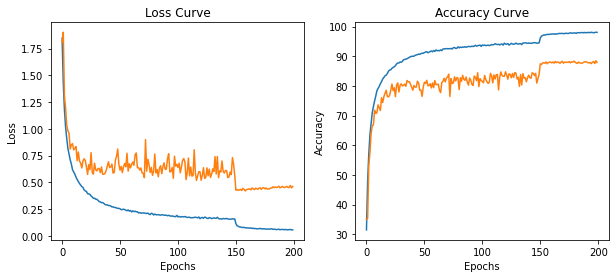

Final Training Accuracy: 98.05399998046875
Final Validation Accuracy: 87.90999989013672


KeyboardInterrupt: ignored

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_RandomPerspective)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_RandomPerspective)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

directory = "/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/WRN/WRNModel_RandomPerspective"

for i, (input, target) in enumerate(trainloader):
  print(input.size())
  break

main("WRN",'wide-resnet','train', directory, 200)

##Random Rotation

In [ ]:
transform_RandomRotation = transforms.Compose([
    #transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.RandomRotation(60),
    myNormalize()
    ])

Files already downloaded and verified
Files already downloaded and verified
torch.Size([512, 3, 32, 32])


Number of parameters: 369498
Number of parameters: 369498
Number of parameters: 369498
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:144: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
000: Acc-tr:  31.80, Acc-val:  33.53, L-tr: 1.8373, L-val: 1.8602
000: Acc-tr:  31.80, Acc-val:  33.53, L-tr: 1.8373, L-val: 1.8602
000: Acc-tr:  31.80, Acc-val:  33.53, L-tr: 1.8373, L-val: 1.8602


Epoch 0 Finished.  Time per Epoch:  28.04 s 


001: Acc-tr:  47.14, Acc-val:  42.84, L-tr: 1.4615, L-val: 1.7055
001: Acc-tr:  47.14, Acc-val:  42.84, L-tr: 1.4615, L-val: 1.7055
001: Acc-tr:  47.14, Acc-val:  42.84, L-tr: 1.4615, L-val: 1.7055


Epoch 1 Finished.  Time per Epoch:  28.11 s 


002: Acc-tr:  53.08, Acc-val:  45.14, L-tr: 1.2978, L-val: 1.5701
002: Acc-tr:  53.08, Acc-val:  45.14, L-tr: 1.2978, L-val: 1.5701
002: Acc-tr:  53.08, Acc-val:  45.14, L-tr: 1.2978, L-val: 1.5701


Epoch 2 Finished.  Time per Epoch:  28.12 s 


003: Acc-tr:  57.43, Acc-val:  55.19, L-tr: 1.1807, L-val: 1.2435
003: Acc-tr:  57.43, Acc-val:  55.19, L-tr: 1.1807, L-val: 1.2435
003: Acc-tr:  57.43, Acc-val:  55.19, L-tr: 1.1807, L-val: 1.2435


Epoch 3 Finished.  Time per Epoch:  27.88 s 


004: Acc-tr:  61.08, Acc-val:  55.25, L-tr: 1.0874, L-val: 1.3028
004: Acc-tr:  61.08, Acc-val:  55.25, L-tr: 1.0874, L-val: 1.3028
004: Acc-tr:  61.08, Acc-val:  55.25, L-tr: 1.0874, L-val: 1.3028


Epoch 4 Finished.  Time per Epoch:  27.95 s 


005: Acc-tr:  64.26, Acc-val:  61.07, L-tr: 1.0114, L-val: 1.1175
005: Acc-tr:  64.26, Acc-val:  61.07, L-tr: 1.0114, L-val: 1.1175
005: Acc-tr:  64.26, Acc-val:  61.07, L-tr: 1.0114, L-val: 1.1175


Epoch 5 Finished.  Time per Epoch:  27.96 s 


006: Acc-tr:  66.72, Acc-val:  58.91, L-tr: 0.9460, L-val: 1.2153
006: Acc-tr:  66.72, Acc-val:  58.91, L-tr: 0.9460, L-val: 1.2153
006: Acc-tr:  66.72, Acc-val:  58.91, L-tr: 0.9460, L-val: 1.2153


Epoch 6 Finished.  Time per Epoch:  27.94 s 


007: Acc-tr:  68.32, Acc-val:  62.96, L-tr: 0.9006, L-val: 1.0454
007: Acc-tr:  68.32, Acc-val:  62.96, L-tr: 0.9006, L-val: 1.0454
007: Acc-tr:  68.32, Acc-val:  62.96, L-tr: 0.9006, L-val: 1.0454


Epoch 7 Finished.  Time per Epoch:  27.91 s 


008: Acc-tr:  69.86, Acc-val:  67.84, L-tr: 0.8582, L-val: 0.9151
008: Acc-tr:  69.86, Acc-val:  67.84, L-tr: 0.8582, L-val: 0.9151
008: Acc-tr:  69.86, Acc-val:  67.84, L-tr: 0.8582, L-val: 0.9151


Epoch 8 Finished.  Time per Epoch:  27.93 s 


009: Acc-tr:  70.83, Acc-val:  67.32, L-tr: 0.8310, L-val: 0.9355
009: Acc-tr:  70.83, Acc-val:  67.32, L-tr: 0.8310, L-val: 0.9355
009: Acc-tr:  70.83, Acc-val:  67.32, L-tr: 0.8310, L-val: 0.9355


Epoch 9 Finished.  Time per Epoch:  27.88 s 


010: Acc-tr:  72.06, Acc-val:  63.56, L-tr: 0.7958, L-val: 1.0625
010: Acc-tr:  72.06, Acc-val:  63.56, L-tr: 0.7958, L-val: 1.0625
010: Acc-tr:  72.06, Acc-val:  63.56, L-tr: 0.7958, L-val: 1.0625


Epoch 10 Finished.  Time per Epoch:  27.86 s 


011: Acc-tr:  72.79, Acc-val:  66.25, L-tr: 0.7767, L-val: 0.9975
011: Acc-tr:  72.79, Acc-val:  66.25, L-tr: 0.7767, L-val: 0.9975
011: Acc-tr:  72.79, Acc-val:  66.25, L-tr: 0.7767, L-val: 0.9975


Epoch 11 Finished.  Time per Epoch:  27.87 s 


012: Acc-tr:  73.80, Acc-val:  70.11, L-tr: 0.7464, L-val: 0.8783
012: Acc-tr:  73.80, Acc-val:  70.11, L-tr: 0.7464, L-val: 0.8783
012: Acc-tr:  73.80, Acc-val:  70.11, L-tr: 0.7464, L-val: 0.8783


Epoch 12 Finished.  Time per Epoch:  27.85 s 


013: Acc-tr:  74.78, Acc-val:  70.06, L-tr: 0.7207, L-val: 0.8550
013: Acc-tr:  74.78, Acc-val:  70.06, L-tr: 0.7207, L-val: 0.8550
013: Acc-tr:  74.78, Acc-val:  70.06, L-tr: 0.7207, L-val: 0.8550


Epoch 13 Finished.  Time per Epoch:  27.84 s 


014: Acc-tr:  75.44, Acc-val:  72.06, L-tr: 0.7027, L-val: 0.8007
014: Acc-tr:  75.44, Acc-val:  72.06, L-tr: 0.7027, L-val: 0.8007
014: Acc-tr:  75.44, Acc-val:  72.06, L-tr: 0.7027, L-val: 0.8007


Epoch 14 Finished.  Time per Epoch:  27.85 s 


015: Acc-tr:  76.17, Acc-val:  69.08, L-tr: 0.6819, L-val: 0.8872
015: Acc-tr:  76.17, Acc-val:  69.08, L-tr: 0.6819, L-val: 0.8872
015: Acc-tr:  76.17, Acc-val:  69.08, L-tr: 0.6819, L-val: 0.8872


Epoch 15 Finished.  Time per Epoch:  27.86 s 


016: Acc-tr:  76.96, Acc-val:  71.08, L-tr: 0.6615, L-val: 0.8481
016: Acc-tr:  76.96, Acc-val:  71.08, L-tr: 0.6615, L-val: 0.8481
016: Acc-tr:  76.96, Acc-val:  71.08, L-tr: 0.6615, L-val: 0.8481


Epoch 16 Finished.  Time per Epoch:  27.86 s 


017: Acc-tr:  77.29, Acc-val:  71.52, L-tr: 0.6525, L-val: 0.8245
017: Acc-tr:  77.29, Acc-val:  71.52, L-tr: 0.6525, L-val: 0.8245
017: Acc-tr:  77.29, Acc-val:  71.52, L-tr: 0.6525, L-val: 0.8245


Epoch 17 Finished.  Time per Epoch:  27.83 s 


018: Acc-tr:  77.87, Acc-val:  71.19, L-tr: 0.6379, L-val: 0.8369
018: Acc-tr:  77.87, Acc-val:  71.19, L-tr: 0.6379, L-val: 0.8369
018: Acc-tr:  77.87, Acc-val:  71.19, L-tr: 0.6379, L-val: 0.8369


Epoch 18 Finished.  Time per Epoch:  27.83 s 


019: Acc-tr:  78.38, Acc-val:  71.36, L-tr: 0.6225, L-val: 0.8446
019: Acc-tr:  78.38, Acc-val:  71.36, L-tr: 0.6225, L-val: 0.8446
019: Acc-tr:  78.38, Acc-val:  71.36, L-tr: 0.6225, L-val: 0.8446


Epoch 19 Finished.  Time per Epoch:  27.83 s 


020: Acc-tr:  79.00, Acc-val:  69.76, L-tr: 0.6015, L-val: 0.8959
020: Acc-tr:  79.00, Acc-val:  69.76, L-tr: 0.6015, L-val: 0.8959
020: Acc-tr:  79.00, Acc-val:  69.76, L-tr: 0.6015, L-val: 0.8959


Epoch 20 Finished.  Time per Epoch:  27.82 s 


021: Acc-tr:  79.15, Acc-val:  72.76, L-tr: 0.5970, L-val: 0.7971
021: Acc-tr:  79.15, Acc-val:  72.76, L-tr: 0.5970, L-val: 0.7971
021: Acc-tr:  79.15, Acc-val:  72.76, L-tr: 0.5970, L-val: 0.7971


Epoch 21 Finished.  Time per Epoch:  27.82 s 


022: Acc-tr:  79.69, Acc-val:  73.22, L-tr: 0.5860, L-val: 0.7715
022: Acc-tr:  79.69, Acc-val:  73.22, L-tr: 0.5860, L-val: 0.7715
022: Acc-tr:  79.69, Acc-val:  73.22, L-tr: 0.5860, L-val: 0.7715


Epoch 22 Finished.  Time per Epoch:  27.82 s 


023: Acc-tr:  79.91, Acc-val:  75.66, L-tr: 0.5759, L-val: 0.7078
023: Acc-tr:  79.91, Acc-val:  75.66, L-tr: 0.5759, L-val: 0.7078
023: Acc-tr:  79.91, Acc-val:  75.66, L-tr: 0.5759, L-val: 0.7078


Epoch 23 Finished.  Time per Epoch:  27.82 s 


024: Acc-tr:  80.38, Acc-val:  73.42, L-tr: 0.5646, L-val: 0.7822
024: Acc-tr:  80.38, Acc-val:  73.42, L-tr: 0.5646, L-val: 0.7822
024: Acc-tr:  80.38, Acc-val:  73.42, L-tr: 0.5646, L-val: 0.7822


Epoch 24 Finished.  Time per Epoch:  27.81 s 


025: Acc-tr:  80.78, Acc-val:  74.59, L-tr: 0.5545, L-val: 0.7434
025: Acc-tr:  80.78, Acc-val:  74.59, L-tr: 0.5545, L-val: 0.7434
025: Acc-tr:  80.78, Acc-val:  74.59, L-tr: 0.5545, L-val: 0.7434


Epoch 25 Finished.  Time per Epoch:  27.82 s 


026: Acc-tr:  81.06, Acc-val:  73.49, L-tr: 0.5428, L-val: 0.7826
026: Acc-tr:  81.06, Acc-val:  73.49, L-tr: 0.5428, L-val: 0.7826
026: Acc-tr:  81.06, Acc-val:  73.49, L-tr: 0.5428, L-val: 0.7826


Epoch 26 Finished.  Time per Epoch:  27.83 s 


027: Acc-tr:  80.97, Acc-val:  75.19, L-tr: 0.5434, L-val: 0.7185
027: Acc-tr:  80.97, Acc-val:  75.19, L-tr: 0.5434, L-val: 0.7185
027: Acc-tr:  80.97, Acc-val:  75.19, L-tr: 0.5434, L-val: 0.7185


Epoch 27 Finished.  Time per Epoch:  27.82 s 


028: Acc-tr:  81.47, Acc-val:  73.87, L-tr: 0.5280, L-val: 0.7496
028: Acc-tr:  81.47, Acc-val:  73.87, L-tr: 0.5280, L-val: 0.7496
028: Acc-tr:  81.47, Acc-val:  73.87, L-tr: 0.5280, L-val: 0.7496


Epoch 28 Finished.  Time per Epoch:  27.83 s 


029: Acc-tr:  81.77, Acc-val:  76.93, L-tr: 0.5204, L-val: 0.6729
029: Acc-tr:  81.77, Acc-val:  76.93, L-tr: 0.5204, L-val: 0.6729
029: Acc-tr:  81.77, Acc-val:  76.93, L-tr: 0.5204, L-val: 0.6729


Epoch 29 Finished.  Time per Epoch:  27.83 s 


030: Acc-tr:  82.12, Acc-val:  73.45, L-tr: 0.5105, L-val: 0.7878
030: Acc-tr:  82.12, Acc-val:  73.45, L-tr: 0.5105, L-val: 0.7878
030: Acc-tr:  82.12, Acc-val:  73.45, L-tr: 0.5105, L-val: 0.7878


Epoch 30 Finished.  Time per Epoch:  27.83 s 


031: Acc-tr:  82.22, Acc-val:  77.85, L-tr: 0.5068, L-val: 0.6414
031: Acc-tr:  82.22, Acc-val:  77.85, L-tr: 0.5068, L-val: 0.6414
031: Acc-tr:  82.22, Acc-val:  77.85, L-tr: 0.5068, L-val: 0.6414


Epoch 31 Finished.  Time per Epoch:  27.83 s 


032: Acc-tr:  82.66, Acc-val:  76.63, L-tr: 0.4968, L-val: 0.6895
032: Acc-tr:  82.66, Acc-val:  76.63, L-tr: 0.4968, L-val: 0.6895
032: Acc-tr:  82.66, Acc-val:  76.63, L-tr: 0.4968, L-val: 0.6895


Epoch 32 Finished.  Time per Epoch:  27.83 s 


033: Acc-tr:  82.55, Acc-val:  76.22, L-tr: 0.4961, L-val: 0.7023
033: Acc-tr:  82.55, Acc-val:  76.22, L-tr: 0.4961, L-val: 0.7023
033: Acc-tr:  82.55, Acc-val:  76.22, L-tr: 0.4961, L-val: 0.7023


Epoch 33 Finished.  Time per Epoch:  27.84 s 


034: Acc-tr:  82.66, Acc-val:  75.92, L-tr: 0.4974, L-val: 0.7320
034: Acc-tr:  82.66, Acc-val:  75.92, L-tr: 0.4974, L-val: 0.7320
034: Acc-tr:  82.66, Acc-val:  75.92, L-tr: 0.4974, L-val: 0.7320


Epoch 34 Finished.  Time per Epoch:  27.84 s 


035: Acc-tr:  83.05, Acc-val:  77.31, L-tr: 0.4850, L-val: 0.6626
035: Acc-tr:  83.05, Acc-val:  77.31, L-tr: 0.4850, L-val: 0.6626
035: Acc-tr:  83.05, Acc-val:  77.31, L-tr: 0.4850, L-val: 0.6626


Epoch 35 Finished.  Time per Epoch:  27.84 s 


036: Acc-tr:  83.63, Acc-val:  77.39, L-tr: 0.4665, L-val: 0.6735
036: Acc-tr:  83.63, Acc-val:  77.39, L-tr: 0.4665, L-val: 0.6735
036: Acc-tr:  83.63, Acc-val:  77.39, L-tr: 0.4665, L-val: 0.6735


Epoch 36 Finished.  Time per Epoch:  27.86 s 


037: Acc-tr:  83.40, Acc-val:  74.85, L-tr: 0.4683, L-val: 0.7579
037: Acc-tr:  83.40, Acc-val:  74.85, L-tr: 0.4683, L-val: 0.7579
037: Acc-tr:  83.40, Acc-val:  74.85, L-tr: 0.4683, L-val: 0.7579


Epoch 37 Finished.  Time per Epoch:  27.87 s 


038: Acc-tr:  83.83, Acc-val:  75.03, L-tr: 0.4648, L-val: 0.7580
038: Acc-tr:  83.83, Acc-val:  75.03, L-tr: 0.4648, L-val: 0.7580
038: Acc-tr:  83.83, Acc-val:  75.03, L-tr: 0.4648, L-val: 0.7580


Epoch 38 Finished.  Time per Epoch:  27.88 s 


039: Acc-tr:  84.17, Acc-val:  76.58, L-tr: 0.4550, L-val: 0.7054
039: Acc-tr:  84.17, Acc-val:  76.58, L-tr: 0.4550, L-val: 0.7054
039: Acc-tr:  84.17, Acc-val:  76.58, L-tr: 0.4550, L-val: 0.7054


Epoch 39 Finished.  Time per Epoch:  27.87 s 


040: Acc-tr:  84.25, Acc-val:  75.55, L-tr: 0.4528, L-val: 0.7286
040: Acc-tr:  84.25, Acc-val:  75.55, L-tr: 0.4528, L-val: 0.7286
040: Acc-tr:  84.25, Acc-val:  75.55, L-tr: 0.4528, L-val: 0.7286


Epoch 40 Finished.  Time per Epoch:  27.87 s 


041: Acc-tr:  84.49, Acc-val:  73.33, L-tr: 0.4447, L-val: 0.8064
041: Acc-tr:  84.49, Acc-val:  73.33, L-tr: 0.4447, L-val: 0.8064
041: Acc-tr:  84.49, Acc-val:  73.33, L-tr: 0.4447, L-val: 0.8064


Epoch 41 Finished.  Time per Epoch:  27.89 s 


042: Acc-tr:  84.26, Acc-val:  75.71, L-tr: 0.4443, L-val: 0.7399
042: Acc-tr:  84.26, Acc-val:  75.71, L-tr: 0.4443, L-val: 0.7399
042: Acc-tr:  84.26, Acc-val:  75.71, L-tr: 0.4443, L-val: 0.7399


Epoch 42 Finished.  Time per Epoch:  27.89 s 


043: Acc-tr:  84.45, Acc-val:  77.92, L-tr: 0.4424, L-val: 0.6567
043: Acc-tr:  84.45, Acc-val:  77.92, L-tr: 0.4424, L-val: 0.6567
043: Acc-tr:  84.45, Acc-val:  77.92, L-tr: 0.4424, L-val: 0.6567


Epoch 43 Finished.  Time per Epoch:  27.91 s 


044: Acc-tr:  84.94, Acc-val:  78.35, L-tr: 0.4301, L-val: 0.6468
044: Acc-tr:  84.94, Acc-val:  78.35, L-tr: 0.4301, L-val: 0.6468
044: Acc-tr:  84.94, Acc-val:  78.35, L-tr: 0.4301, L-val: 0.6468


Epoch 44 Finished.  Time per Epoch:  27.92 s 


045: Acc-tr:  84.86, Acc-val:  78.24, L-tr: 0.4335, L-val: 0.6553
045: Acc-tr:  84.86, Acc-val:  78.24, L-tr: 0.4335, L-val: 0.6553
045: Acc-tr:  84.86, Acc-val:  78.24, L-tr: 0.4335, L-val: 0.6553


Epoch 45 Finished.  Time per Epoch:  27.92 s 


046: Acc-tr:  85.16, Acc-val:  75.21, L-tr: 0.4257, L-val: 0.7608
046: Acc-tr:  85.16, Acc-val:  75.21, L-tr: 0.4257, L-val: 0.7608
046: Acc-tr:  85.16, Acc-val:  75.21, L-tr: 0.4257, L-val: 0.7608


Epoch 46 Finished.  Time per Epoch:  27.93 s 


047: Acc-tr:  85.07, Acc-val:  77.60, L-tr: 0.4256, L-val: 0.6675
047: Acc-tr:  85.07, Acc-val:  77.60, L-tr: 0.4256, L-val: 0.6675
047: Acc-tr:  85.07, Acc-val:  77.60, L-tr: 0.4256, L-val: 0.6675


Epoch 47 Finished.  Time per Epoch:  27.94 s 


048: Acc-tr:  85.06, Acc-val:  77.48, L-tr: 0.4258, L-val: 0.6681
048: Acc-tr:  85.06, Acc-val:  77.48, L-tr: 0.4258, L-val: 0.6681
048: Acc-tr:  85.06, Acc-val:  77.48, L-tr: 0.4258, L-val: 0.6681


Epoch 48 Finished.  Time per Epoch:  27.94 s 


049: Acc-tr:  85.53, Acc-val:  78.52, L-tr: 0.4162, L-val: 0.6403
049: Acc-tr:  85.53, Acc-val:  78.52, L-tr: 0.4162, L-val: 0.6403
049: Acc-tr:  85.53, Acc-val:  78.52, L-tr: 0.4162, L-val: 0.6403


Epoch 49 Finished.  Time per Epoch:  27.95 s 


050: Acc-tr:  85.80, Acc-val:  76.92, L-tr: 0.4087, L-val: 0.6928
050: Acc-tr:  85.80, Acc-val:  76.92, L-tr: 0.4087, L-val: 0.6928
050: Acc-tr:  85.80, Acc-val:  76.92, L-tr: 0.4087, L-val: 0.6928


Epoch 50 Finished.  Time per Epoch:  27.95 s 


051: Acc-tr:  85.49, Acc-val:  75.79, L-tr: 0.4074, L-val: 0.7387
051: Acc-tr:  85.49, Acc-val:  75.79, L-tr: 0.4074, L-val: 0.7387
051: Acc-tr:  85.49, Acc-val:  75.79, L-tr: 0.4074, L-val: 0.7387


Epoch 51 Finished.  Time per Epoch:  27.96 s 


052: Acc-tr:  85.91, Acc-val:  77.52, L-tr: 0.4012, L-val: 0.6834
052: Acc-tr:  85.91, Acc-val:  77.52, L-tr: 0.4012, L-val: 0.6834
052: Acc-tr:  85.91, Acc-val:  77.52, L-tr: 0.4012, L-val: 0.6834


Epoch 52 Finished.  Time per Epoch:  27.97 s 


053: Acc-tr:  86.02, Acc-val:  78.41, L-tr: 0.3968, L-val: 0.6552
053: Acc-tr:  86.02, Acc-val:  78.41, L-tr: 0.3968, L-val: 0.6552
053: Acc-tr:  86.02, Acc-val:  78.41, L-tr: 0.3968, L-val: 0.6552


Epoch 53 Finished.  Time per Epoch:  27.99 s 


054: Acc-tr:  86.12, Acc-val:  78.52, L-tr: 0.3993, L-val: 0.6677
054: Acc-tr:  86.12, Acc-val:  78.52, L-tr: 0.3993, L-val: 0.6677
054: Acc-tr:  86.12, Acc-val:  78.52, L-tr: 0.3993, L-val: 0.6677


Epoch 54 Finished.  Time per Epoch:  28.00 s 


055: Acc-tr:  86.20, Acc-val:  75.66, L-tr: 0.3931, L-val: 0.7800
055: Acc-tr:  86.20, Acc-val:  75.66, L-tr: 0.3931, L-val: 0.7800
055: Acc-tr:  86.20, Acc-val:  75.66, L-tr: 0.3931, L-val: 0.7800


Epoch 55 Finished.  Time per Epoch:  28.00 s 


056: Acc-tr:  86.35, Acc-val:  77.08, L-tr: 0.3923, L-val: 0.7162
056: Acc-tr:  86.35, Acc-val:  77.08, L-tr: 0.3923, L-val: 0.7162
056: Acc-tr:  86.35, Acc-val:  77.08, L-tr: 0.3923, L-val: 0.7162


Epoch 56 Finished.  Time per Epoch:  28.01 s 


057: Acc-tr:  86.66, Acc-val:  77.35, L-tr: 0.3806, L-val: 0.6804
057: Acc-tr:  86.66, Acc-val:  77.35, L-tr: 0.3806, L-val: 0.6804
057: Acc-tr:  86.66, Acc-val:  77.35, L-tr: 0.3806, L-val: 0.6804


Epoch 57 Finished.  Time per Epoch:  28.03 s 


058: Acc-tr:  86.34, Acc-val:  79.10, L-tr: 0.3889, L-val: 0.6681
058: Acc-tr:  86.34, Acc-val:  79.10, L-tr: 0.3889, L-val: 0.6681
058: Acc-tr:  86.34, Acc-val:  79.10, L-tr: 0.3889, L-val: 0.6681


Epoch 58 Finished.  Time per Epoch:  28.04 s 


059: Acc-tr:  86.75, Acc-val:  77.86, L-tr: 0.3772, L-val: 0.6772
059: Acc-tr:  86.75, Acc-val:  77.86, L-tr: 0.3772, L-val: 0.6772
059: Acc-tr:  86.75, Acc-val:  77.86, L-tr: 0.3772, L-val: 0.6772


Epoch 59 Finished.  Time per Epoch:  28.06 s 


060: Acc-tr:  86.82, Acc-val:  78.51, L-tr: 0.3766, L-val: 0.6480
060: Acc-tr:  86.82, Acc-val:  78.51, L-tr: 0.3766, L-val: 0.6480
060: Acc-tr:  86.82, Acc-val:  78.51, L-tr: 0.3766, L-val: 0.6480


Epoch 60 Finished.  Time per Epoch:  28.07 s 


061: Acc-tr:  86.92, Acc-val:  77.01, L-tr: 0.3719, L-val: 0.7237
061: Acc-tr:  86.92, Acc-val:  77.01, L-tr: 0.3719, L-val: 0.7237
061: Acc-tr:  86.92, Acc-val:  77.01, L-tr: 0.3719, L-val: 0.7237


Epoch 61 Finished.  Time per Epoch:  28.07 s 


062: Acc-tr:  86.73, Acc-val:  76.67, L-tr: 0.3784, L-val: 0.7394
062: Acc-tr:  86.73, Acc-val:  76.67, L-tr: 0.3784, L-val: 0.7394
062: Acc-tr:  86.73, Acc-val:  76.67, L-tr: 0.3784, L-val: 0.7394


Epoch 62 Finished.  Time per Epoch:  28.09 s 


063: Acc-tr:  87.01, Acc-val:  78.09, L-tr: 0.3722, L-val: 0.6981
063: Acc-tr:  87.01, Acc-val:  78.09, L-tr: 0.3722, L-val: 0.6981
063: Acc-tr:  87.01, Acc-val:  78.09, L-tr: 0.3722, L-val: 0.6981


Epoch 63 Finished.  Time per Epoch:  28.10 s 


064: Acc-tr:  87.02, Acc-val:  77.77, L-tr: 0.3686, L-val: 0.6645
064: Acc-tr:  87.02, Acc-val:  77.77, L-tr: 0.3686, L-val: 0.6645
064: Acc-tr:  87.02, Acc-val:  77.77, L-tr: 0.3686, L-val: 0.6645


Epoch 64 Finished.  Time per Epoch:  28.11 s 


065: Acc-tr:  87.08, Acc-val:  79.04, L-tr: 0.3683, L-val: 0.6513
065: Acc-tr:  87.08, Acc-val:  79.04, L-tr: 0.3683, L-val: 0.6513
065: Acc-tr:  87.08, Acc-val:  79.04, L-tr: 0.3683, L-val: 0.6513


Epoch 65 Finished.  Time per Epoch:  28.12 s 


066: Acc-tr:  87.22, Acc-val:  76.29, L-tr: 0.3638, L-val: 0.7498
066: Acc-tr:  87.22, Acc-val:  76.29, L-tr: 0.3638, L-val: 0.7498
066: Acc-tr:  87.22, Acc-val:  76.29, L-tr: 0.3638, L-val: 0.7498


Epoch 66 Finished.  Time per Epoch:  28.14 s 


067: Acc-tr:  86.88, Acc-val:  79.23, L-tr: 0.3714, L-val: 0.6600
067: Acc-tr:  86.88, Acc-val:  79.23, L-tr: 0.3714, L-val: 0.6600
067: Acc-tr:  86.88, Acc-val:  79.23, L-tr: 0.3714, L-val: 0.6600


Epoch 67 Finished.  Time per Epoch:  28.14 s 


068: Acc-tr:  87.65, Acc-val:  76.16, L-tr: 0.3512, L-val: 0.7588
068: Acc-tr:  87.65, Acc-val:  76.16, L-tr: 0.3512, L-val: 0.7588
068: Acc-tr:  87.65, Acc-val:  76.16, L-tr: 0.3512, L-val: 0.7588


Epoch 68 Finished.  Time per Epoch:  28.14 s 


069: Acc-tr:  87.62, Acc-val:  78.43, L-tr: 0.3532, L-val: 0.6592
069: Acc-tr:  87.62, Acc-val:  78.43, L-tr: 0.3532, L-val: 0.6592
069: Acc-tr:  87.62, Acc-val:  78.43, L-tr: 0.3532, L-val: 0.6592


Epoch 69 Finished.  Time per Epoch:  28.15 s 


070: Acc-tr:  87.58, Acc-val:  78.53, L-tr: 0.3561, L-val: 0.6637
070: Acc-tr:  87.58, Acc-val:  78.53, L-tr: 0.3561, L-val: 0.6637
070: Acc-tr:  87.58, Acc-val:  78.53, L-tr: 0.3561, L-val: 0.6637


Epoch 70 Finished.  Time per Epoch:  28.16 s 


071: Acc-tr:  87.56, Acc-val:  76.23, L-tr: 0.3527, L-val: 0.7770
071: Acc-tr:  87.56, Acc-val:  76.23, L-tr: 0.3527, L-val: 0.7770
071: Acc-tr:  87.56, Acc-val:  76.23, L-tr: 0.3527, L-val: 0.7770


Epoch 71 Finished.  Time per Epoch:  28.17 s 


072: Acc-tr:  87.68, Acc-val:  77.97, L-tr: 0.3486, L-val: 0.7094
072: Acc-tr:  87.68, Acc-val:  77.97, L-tr: 0.3486, L-val: 0.7094
072: Acc-tr:  87.68, Acc-val:  77.97, L-tr: 0.3486, L-val: 0.7094


Epoch 72 Finished.  Time per Epoch:  28.17 s 


073: Acc-tr:  88.05, Acc-val:  75.78, L-tr: 0.3435, L-val: 0.7731
073: Acc-tr:  88.05, Acc-val:  75.78, L-tr: 0.3435, L-val: 0.7731
073: Acc-tr:  88.05, Acc-val:  75.78, L-tr: 0.3435, L-val: 0.7731


Epoch 73 Finished.  Time per Epoch:  28.17 s 


074: Acc-tr:  87.91, Acc-val:  78.58, L-tr: 0.3424, L-val: 0.6580
074: Acc-tr:  87.91, Acc-val:  78.58, L-tr: 0.3424, L-val: 0.6580
074: Acc-tr:  87.91, Acc-val:  78.58, L-tr: 0.3424, L-val: 0.6580


Epoch 74 Finished.  Time per Epoch:  28.17 s 


075: Acc-tr:  88.10, Acc-val:  78.86, L-tr: 0.3393, L-val: 0.6561
075: Acc-tr:  88.10, Acc-val:  78.86, L-tr: 0.3393, L-val: 0.6561
075: Acc-tr:  88.10, Acc-val:  78.86, L-tr: 0.3393, L-val: 0.6561


Epoch 75 Finished.  Time per Epoch:  28.18 s 


076: Acc-tr:  88.08, Acc-val:  79.83, L-tr: 0.3392, L-val: 0.6239
076: Acc-tr:  88.08, Acc-val:  79.83, L-tr: 0.3392, L-val: 0.6239
076: Acc-tr:  88.08, Acc-val:  79.83, L-tr: 0.3392, L-val: 0.6239


Epoch 76 Finished.  Time per Epoch:  28.17 s 


077: Acc-tr:  88.23, Acc-val:  76.82, L-tr: 0.3325, L-val: 0.7888
077: Acc-tr:  88.23, Acc-val:  76.82, L-tr: 0.3325, L-val: 0.7888
077: Acc-tr:  88.23, Acc-val:  76.82, L-tr: 0.3325, L-val: 0.7888


Epoch 77 Finished.  Time per Epoch:  28.18 s 


078: Acc-tr:  88.00, Acc-val:  76.38, L-tr: 0.3430, L-val: 0.7594
078: Acc-tr:  88.00, Acc-val:  76.38, L-tr: 0.3430, L-val: 0.7594
078: Acc-tr:  88.00, Acc-val:  76.38, L-tr: 0.3430, L-val: 0.7594


Epoch 78 Finished.  Time per Epoch:  28.19 s 


079: Acc-tr:  88.50, Acc-val:  78.64, L-tr: 0.3310, L-val: 0.6712
079: Acc-tr:  88.50, Acc-val:  78.64, L-tr: 0.3310, L-val: 0.6712
079: Acc-tr:  88.50, Acc-val:  78.64, L-tr: 0.3310, L-val: 0.6712


Epoch 79 Finished.  Time per Epoch:  28.19 s 


080: Acc-tr:  88.26, Acc-val:  78.78, L-tr: 0.3314, L-val: 0.6658
080: Acc-tr:  88.26, Acc-val:  78.78, L-tr: 0.3314, L-val: 0.6658
080: Acc-tr:  88.26, Acc-val:  78.78, L-tr: 0.3314, L-val: 0.6658


Epoch 80 Finished.  Time per Epoch:  28.19 s 


081: Acc-tr:  88.34, Acc-val:  78.27, L-tr: 0.3293, L-val: 0.7033
081: Acc-tr:  88.34, Acc-val:  78.27, L-tr: 0.3293, L-val: 0.7033
081: Acc-tr:  88.34, Acc-val:  78.27, L-tr: 0.3293, L-val: 0.7033


Epoch 81 Finished.  Time per Epoch:  28.20 s 


082: Acc-tr:  88.43, Acc-val:  77.40, L-tr: 0.3302, L-val: 0.7095
082: Acc-tr:  88.43, Acc-val:  77.40, L-tr: 0.3302, L-val: 0.7095
082: Acc-tr:  88.43, Acc-val:  77.40, L-tr: 0.3302, L-val: 0.7095


Epoch 82 Finished.  Time per Epoch:  28.20 s 


083: Acc-tr:  88.20, Acc-val:  79.35, L-tr: 0.3300, L-val: 0.6621
083: Acc-tr:  88.20, Acc-val:  79.35, L-tr: 0.3300, L-val: 0.6621
083: Acc-tr:  88.20, Acc-val:  79.35, L-tr: 0.3300, L-val: 0.6621


Epoch 83 Finished.  Time per Epoch:  28.20 s 


084: Acc-tr:  88.58, Acc-val:  77.88, L-tr: 0.3237, L-val: 0.6985
084: Acc-tr:  88.58, Acc-val:  77.88, L-tr: 0.3237, L-val: 0.6985
084: Acc-tr:  88.58, Acc-val:  77.88, L-tr: 0.3237, L-val: 0.6985


Epoch 84 Finished.  Time per Epoch:  28.20 s 


085: Acc-tr:  88.54, Acc-val:  77.15, L-tr: 0.3234, L-val: 0.7571
085: Acc-tr:  88.54, Acc-val:  77.15, L-tr: 0.3234, L-val: 0.7571
085: Acc-tr:  88.54, Acc-val:  77.15, L-tr: 0.3234, L-val: 0.7571


Epoch 85 Finished.  Time per Epoch:  28.21 s 


086: Acc-tr:  88.70, Acc-val:  79.57, L-tr: 0.3200, L-val: 0.6361
086: Acc-tr:  88.70, Acc-val:  79.57, L-tr: 0.3200, L-val: 0.6361
086: Acc-tr:  88.70, Acc-val:  79.57, L-tr: 0.3200, L-val: 0.6361


Epoch 86 Finished.  Time per Epoch:  28.21 s 


087: Acc-tr:  88.77, Acc-val:  78.70, L-tr: 0.3194, L-val: 0.6976
087: Acc-tr:  88.77, Acc-val:  78.70, L-tr: 0.3194, L-val: 0.6976
087: Acc-tr:  88.77, Acc-val:  78.70, L-tr: 0.3194, L-val: 0.6976


Epoch 87 Finished.  Time per Epoch:  28.21 s 


088: Acc-tr:  88.53, Acc-val:  76.81, L-tr: 0.3269, L-val: 0.7624
088: Acc-tr:  88.53, Acc-val:  76.81, L-tr: 0.3269, L-val: 0.7624
088: Acc-tr:  88.53, Acc-val:  76.81, L-tr: 0.3269, L-val: 0.7624


Epoch 88 Finished.  Time per Epoch:  28.21 s 


089: Acc-tr:  88.93, Acc-val:  78.46, L-tr: 0.3109, L-val: 0.6912
089: Acc-tr:  88.93, Acc-val:  78.46, L-tr: 0.3109, L-val: 0.6912
089: Acc-tr:  88.93, Acc-val:  78.46, L-tr: 0.3109, L-val: 0.6912


Epoch 89 Finished.  Time per Epoch:  28.22 s 


090: Acc-tr:  88.89, Acc-val:  76.81, L-tr: 0.3171, L-val: 0.7235
090: Acc-tr:  88.89, Acc-val:  76.81, L-tr: 0.3171, L-val: 0.7235
090: Acc-tr:  88.89, Acc-val:  76.81, L-tr: 0.3171, L-val: 0.7235


Epoch 90 Finished.  Time per Epoch:  28.22 s 


091: Acc-tr:  88.82, Acc-val:  79.19, L-tr: 0.3152, L-val: 0.6530
091: Acc-tr:  88.82, Acc-val:  79.19, L-tr: 0.3152, L-val: 0.6530
091: Acc-tr:  88.82, Acc-val:  79.19, L-tr: 0.3152, L-val: 0.6530


Epoch 91 Finished.  Time per Epoch:  28.23 s 


092: Acc-tr:  88.77, Acc-val:  78.70, L-tr: 0.3170, L-val: 0.6527
092: Acc-tr:  88.77, Acc-val:  78.70, L-tr: 0.3170, L-val: 0.6527
092: Acc-tr:  88.77, Acc-val:  78.70, L-tr: 0.3170, L-val: 0.6527


Epoch 92 Finished.  Time per Epoch:  28.23 s 


093: Acc-tr:  89.01, Acc-val:  78.92, L-tr: 0.3114, L-val: 0.6792
093: Acc-tr:  89.01, Acc-val:  78.92, L-tr: 0.3114, L-val: 0.6792
093: Acc-tr:  89.01, Acc-val:  78.92, L-tr: 0.3114, L-val: 0.6792


Epoch 93 Finished.  Time per Epoch:  28.23 s 


094: Acc-tr:  89.24, Acc-val:  78.91, L-tr: 0.3075, L-val: 0.6694
094: Acc-tr:  89.24, Acc-val:  78.91, L-tr: 0.3075, L-val: 0.6694
094: Acc-tr:  89.24, Acc-val:  78.91, L-tr: 0.3075, L-val: 0.6694


Epoch 94 Finished.  Time per Epoch:  28.23 s 


095: Acc-tr:  89.16, Acc-val:  79.43, L-tr: 0.3075, L-val: 0.6693
095: Acc-tr:  89.16, Acc-val:  79.43, L-tr: 0.3075, L-val: 0.6693
095: Acc-tr:  89.16, Acc-val:  79.43, L-tr: 0.3075, L-val: 0.6693


Epoch 95 Finished.  Time per Epoch:  28.23 s 


096: Acc-tr:  89.00, Acc-val:  79.83, L-tr: 0.3095, L-val: 0.6424
096: Acc-tr:  89.00, Acc-val:  79.83, L-tr: 0.3095, L-val: 0.6424
096: Acc-tr:  89.00, Acc-val:  79.83, L-tr: 0.3095, L-val: 0.6424


Epoch 96 Finished.  Time per Epoch:  28.23 s 


097: Acc-tr:  89.10, Acc-val:  76.73, L-tr: 0.3094, L-val: 0.7555
097: Acc-tr:  89.10, Acc-val:  76.73, L-tr: 0.3094, L-val: 0.7555
097: Acc-tr:  89.10, Acc-val:  76.73, L-tr: 0.3094, L-val: 0.7555


Epoch 97 Finished.  Time per Epoch:  28.23 s 


098: Acc-tr:  88.92, Acc-val:  80.17, L-tr: 0.3094, L-val: 0.6287
098: Acc-tr:  88.92, Acc-val:  80.17, L-tr: 0.3094, L-val: 0.6287
098: Acc-tr:  88.92, Acc-val:  80.17, L-tr: 0.3094, L-val: 0.6287


Epoch 98 Finished.  Time per Epoch:  28.23 s 


099: Acc-tr:  89.46, Acc-val:  77.71, L-tr: 0.2979, L-val: 0.7271
099: Acc-tr:  89.46, Acc-val:  77.71, L-tr: 0.2979, L-val: 0.7271
099: Acc-tr:  89.46, Acc-val:  77.71, L-tr: 0.2979, L-val: 0.7271


Epoch 99 Finished.  Time per Epoch:  28.24 s 


100: Acc-tr:  89.14, Acc-val:  75.88, L-tr: 0.3044, L-val: 0.7846
100: Acc-tr:  89.14, Acc-val:  75.88, L-tr: 0.3044, L-val: 0.7846
100: Acc-tr:  89.14, Acc-val:  75.88, L-tr: 0.3044, L-val: 0.7846


Epoch 100 Finished.  Time per Epoch:  28.24 s 


101: Acc-tr:  89.33, Acc-val:  78.44, L-tr: 0.3062, L-val: 0.6857
101: Acc-tr:  89.33, Acc-val:  78.44, L-tr: 0.3062, L-val: 0.6857
101: Acc-tr:  89.33, Acc-val:  78.44, L-tr: 0.3062, L-val: 0.6857


Epoch 101 Finished.  Time per Epoch:  28.24 s 


102: Acc-tr:  89.01, Acc-val:  80.55, L-tr: 0.3042, L-val: 0.6081
102: Acc-tr:  89.01, Acc-val:  80.55, L-tr: 0.3042, L-val: 0.6081
102: Acc-tr:  89.01, Acc-val:  80.55, L-tr: 0.3042, L-val: 0.6081


Epoch 102 Finished.  Time per Epoch:  28.24 s 


103: Acc-tr:  89.51, Acc-val:  79.24, L-tr: 0.2991, L-val: 0.6568
103: Acc-tr:  89.51, Acc-val:  79.24, L-tr: 0.2991, L-val: 0.6568
103: Acc-tr:  89.51, Acc-val:  79.24, L-tr: 0.2991, L-val: 0.6568


Epoch 103 Finished.  Time per Epoch:  28.25 s 


104: Acc-tr:  89.64, Acc-val:  77.35, L-tr: 0.2951, L-val: 0.7426
104: Acc-tr:  89.64, Acc-val:  77.35, L-tr: 0.2951, L-val: 0.7426
104: Acc-tr:  89.64, Acc-val:  77.35, L-tr: 0.2951, L-val: 0.7426


Epoch 104 Finished.  Time per Epoch:  28.25 s 


105: Acc-tr:  89.41, Acc-val:  79.21, L-tr: 0.3009, L-val: 0.6696
105: Acc-tr:  89.41, Acc-val:  79.21, L-tr: 0.3009, L-val: 0.6696
105: Acc-tr:  89.41, Acc-val:  79.21, L-tr: 0.3009, L-val: 0.6696


Epoch 105 Finished.  Time per Epoch:  28.25 s 


106: Acc-tr:  89.64, Acc-val:  79.79, L-tr: 0.2909, L-val: 0.6432
106: Acc-tr:  89.64, Acc-val:  79.79, L-tr: 0.2909, L-val: 0.6432
106: Acc-tr:  89.64, Acc-val:  79.79, L-tr: 0.2909, L-val: 0.6432


Epoch 106 Finished.  Time per Epoch:  28.25 s 


107: Acc-tr:  89.35, Acc-val:  79.81, L-tr: 0.2992, L-val: 0.6388
107: Acc-tr:  89.35, Acc-val:  79.81, L-tr: 0.2992, L-val: 0.6388
107: Acc-tr:  89.35, Acc-val:  79.81, L-tr: 0.2992, L-val: 0.6388


Epoch 107 Finished.  Time per Epoch:  28.26 s 


108: Acc-tr:  89.40, Acc-val:  79.75, L-tr: 0.2930, L-val: 0.6320
108: Acc-tr:  89.40, Acc-val:  79.75, L-tr: 0.2930, L-val: 0.6320
108: Acc-tr:  89.40, Acc-val:  79.75, L-tr: 0.2930, L-val: 0.6320


Epoch 108 Finished.  Time per Epoch:  28.26 s 


109: Acc-tr:  89.61, Acc-val:  79.23, L-tr: 0.2933, L-val: 0.6712
109: Acc-tr:  89.61, Acc-val:  79.23, L-tr: 0.2933, L-val: 0.6712
109: Acc-tr:  89.61, Acc-val:  79.23, L-tr: 0.2933, L-val: 0.6712


Epoch 109 Finished.  Time per Epoch:  28.26 s 


110: Acc-tr:  89.51, Acc-val:  80.10, L-tr: 0.2938, L-val: 0.6304
110: Acc-tr:  89.51, Acc-val:  80.10, L-tr: 0.2938, L-val: 0.6304
110: Acc-tr:  89.51, Acc-val:  80.10, L-tr: 0.2938, L-val: 0.6304


Epoch 110 Finished.  Time per Epoch:  28.27 s 


111: Acc-tr:  89.84, Acc-val:  76.38, L-tr: 0.2884, L-val: 0.8157
111: Acc-tr:  89.84, Acc-val:  76.38, L-tr: 0.2884, L-val: 0.8157
111: Acc-tr:  89.84, Acc-val:  76.38, L-tr: 0.2884, L-val: 0.8157


Epoch 111 Finished.  Time per Epoch:  28.27 s 


112: Acc-tr:  89.74, Acc-val:  76.88, L-tr: 0.2908, L-val: 0.7518
112: Acc-tr:  89.74, Acc-val:  76.88, L-tr: 0.2908, L-val: 0.7518
112: Acc-tr:  89.74, Acc-val:  76.88, L-tr: 0.2908, L-val: 0.7518


Epoch 112 Finished.  Time per Epoch:  28.27 s 


113: Acc-tr:  89.78, Acc-val:  80.38, L-tr: 0.2894, L-val: 0.6147
113: Acc-tr:  89.78, Acc-val:  80.38, L-tr: 0.2894, L-val: 0.6147
113: Acc-tr:  89.78, Acc-val:  80.38, L-tr: 0.2894, L-val: 0.6147


Epoch 113 Finished.  Time per Epoch:  28.27 s 


114: Acc-tr:  89.90, Acc-val:  80.64, L-tr: 0.2843, L-val: 0.6084
114: Acc-tr:  89.90, Acc-val:  80.64, L-tr: 0.2843, L-val: 0.6084
114: Acc-tr:  89.90, Acc-val:  80.64, L-tr: 0.2843, L-val: 0.6084


Epoch 114 Finished.  Time per Epoch:  28.27 s 


115: Acc-tr:  90.10, Acc-val:  78.21, L-tr: 0.2812, L-val: 0.7296
115: Acc-tr:  90.10, Acc-val:  78.21, L-tr: 0.2812, L-val: 0.7296
115: Acc-tr:  90.10, Acc-val:  78.21, L-tr: 0.2812, L-val: 0.7296


Epoch 115 Finished.  Time per Epoch:  28.27 s 


116: Acc-tr:  89.81, Acc-val:  77.85, L-tr: 0.2899, L-val: 0.7165
116: Acc-tr:  89.81, Acc-val:  77.85, L-tr: 0.2899, L-val: 0.7165
116: Acc-tr:  89.81, Acc-val:  77.85, L-tr: 0.2899, L-val: 0.7165


Epoch 116 Finished.  Time per Epoch:  28.27 s 


117: Acc-tr:  90.23, Acc-val:  80.11, L-tr: 0.2790, L-val: 0.6291
117: Acc-tr:  90.23, Acc-val:  80.11, L-tr: 0.2790, L-val: 0.6291
117: Acc-tr:  90.23, Acc-val:  80.11, L-tr: 0.2790, L-val: 0.6291


Epoch 117 Finished.  Time per Epoch:  28.27 s 


118: Acc-tr:  90.28, Acc-val:  78.99, L-tr: 0.2747, L-val: 0.6778
118: Acc-tr:  90.28, Acc-val:  78.99, L-tr: 0.2747, L-val: 0.6778
118: Acc-tr:  90.28, Acc-val:  78.99, L-tr: 0.2747, L-val: 0.6778


Epoch 118 Finished.  Time per Epoch:  28.27 s 


119: Acc-tr:  89.94, Acc-val:  79.59, L-tr: 0.2884, L-val: 0.6617
119: Acc-tr:  89.94, Acc-val:  79.59, L-tr: 0.2884, L-val: 0.6617
119: Acc-tr:  89.94, Acc-val:  79.59, L-tr: 0.2884, L-val: 0.6617


Epoch 119 Finished.  Time per Epoch:  28.27 s 


120: Acc-tr:  90.14, Acc-val:  80.80, L-tr: 0.2827, L-val: 0.6103
120: Acc-tr:  90.14, Acc-val:  80.80, L-tr: 0.2827, L-val: 0.6103
120: Acc-tr:  90.14, Acc-val:  80.80, L-tr: 0.2827, L-val: 0.6103


Epoch 120 Finished.  Time per Epoch:  28.28 s 


121: Acc-tr:  90.30, Acc-val:  80.08, L-tr: 0.2743, L-val: 0.6350
121: Acc-tr:  90.30, Acc-val:  80.08, L-tr: 0.2743, L-val: 0.6350
121: Acc-tr:  90.30, Acc-val:  80.08, L-tr: 0.2743, L-val: 0.6350


Epoch 121 Finished.  Time per Epoch:  28.28 s 


122: Acc-tr:  90.23, Acc-val:  79.49, L-tr: 0.2740, L-val: 0.6842
122: Acc-tr:  90.23, Acc-val:  79.49, L-tr: 0.2740, L-val: 0.6842
122: Acc-tr:  90.23, Acc-val:  79.49, L-tr: 0.2740, L-val: 0.6842


Epoch 122 Finished.  Time per Epoch:  28.28 s 


123: Acc-tr:  90.17, Acc-val:  80.78, L-tr: 0.2768, L-val: 0.6207
123: Acc-tr:  90.17, Acc-val:  80.78, L-tr: 0.2768, L-val: 0.6207
123: Acc-tr:  90.17, Acc-val:  80.78, L-tr: 0.2768, L-val: 0.6207


Epoch 123 Finished.  Time per Epoch:  28.28 s 


124: Acc-tr:  90.28, Acc-val:  79.69, L-tr: 0.2776, L-val: 0.6414
124: Acc-tr:  90.28, Acc-val:  79.69, L-tr: 0.2776, L-val: 0.6414
124: Acc-tr:  90.28, Acc-val:  79.69, L-tr: 0.2776, L-val: 0.6414


Epoch 124 Finished.  Time per Epoch:  28.28 s 


125: Acc-tr:  90.42, Acc-val:  79.58, L-tr: 0.2718, L-val: 0.6465
125: Acc-tr:  90.42, Acc-val:  79.58, L-tr: 0.2718, L-val: 0.6465
125: Acc-tr:  90.42, Acc-val:  79.58, L-tr: 0.2718, L-val: 0.6465


Epoch 125 Finished.  Time per Epoch:  28.28 s 


126: Acc-tr:  90.19, Acc-val:  78.52, L-tr: 0.2797, L-val: 0.6879
126: Acc-tr:  90.19, Acc-val:  78.52, L-tr: 0.2797, L-val: 0.6879
126: Acc-tr:  90.19, Acc-val:  78.52, L-tr: 0.2797, L-val: 0.6879


Epoch 126 Finished.  Time per Epoch:  28.29 s 


127: Acc-tr:  90.30, Acc-val:  78.67, L-tr: 0.2774, L-val: 0.7128
127: Acc-tr:  90.30, Acc-val:  78.67, L-tr: 0.2774, L-val: 0.7128
127: Acc-tr:  90.30, Acc-val:  78.67, L-tr: 0.2774, L-val: 0.7128


Epoch 127 Finished.  Time per Epoch:  28.29 s 


128: Acc-tr:  90.31, Acc-val:  80.01, L-tr: 0.2741, L-val: 0.6529
128: Acc-tr:  90.31, Acc-val:  80.01, L-tr: 0.2741, L-val: 0.6529
128: Acc-tr:  90.31, Acc-val:  80.01, L-tr: 0.2741, L-val: 0.6529


Epoch 128 Finished.  Time per Epoch:  28.29 s 


129: Acc-tr:  90.51, Acc-val:  80.38, L-tr: 0.2699, L-val: 0.6233
129: Acc-tr:  90.51, Acc-val:  80.38, L-tr: 0.2699, L-val: 0.6233
129: Acc-tr:  90.51, Acc-val:  80.38, L-tr: 0.2699, L-val: 0.6233


Epoch 129 Finished.  Time per Epoch:  28.28 s 


130: Acc-tr:  90.45, Acc-val:  78.64, L-tr: 0.2707, L-val: 0.6835
130: Acc-tr:  90.45, Acc-val:  78.64, L-tr: 0.2707, L-val: 0.6835
130: Acc-tr:  90.45, Acc-val:  78.64, L-tr: 0.2707, L-val: 0.6835


Epoch 130 Finished.  Time per Epoch:  28.28 s 


131: Acc-tr:  90.12, Acc-val:  78.41, L-tr: 0.2764, L-val: 0.6976
131: Acc-tr:  90.12, Acc-val:  78.41, L-tr: 0.2764, L-val: 0.6976
131: Acc-tr:  90.12, Acc-val:  78.41, L-tr: 0.2764, L-val: 0.6976


Epoch 131 Finished.  Time per Epoch:  28.29 s 


132: Acc-tr:  90.71, Acc-val:  80.14, L-tr: 0.2648, L-val: 0.6526
132: Acc-tr:  90.71, Acc-val:  80.14, L-tr: 0.2648, L-val: 0.6526
132: Acc-tr:  90.71, Acc-val:  80.14, L-tr: 0.2648, L-val: 0.6526


Epoch 132 Finished.  Time per Epoch:  28.28 s 


133: Acc-tr:  90.45, Acc-val:  79.94, L-tr: 0.2693, L-val: 0.6548
133: Acc-tr:  90.45, Acc-val:  79.94, L-tr: 0.2693, L-val: 0.6548
133: Acc-tr:  90.45, Acc-val:  79.94, L-tr: 0.2693, L-val: 0.6548


Epoch 133 Finished.  Time per Epoch:  28.28 s 


134: Acc-tr:  90.45, Acc-val:  81.20, L-tr: 0.2703, L-val: 0.6044
134: Acc-tr:  90.45, Acc-val:  81.20, L-tr: 0.2703, L-val: 0.6044
134: Acc-tr:  90.45, Acc-val:  81.20, L-tr: 0.2703, L-val: 0.6044


Epoch 134 Finished.  Time per Epoch:  28.28 s 


135: Acc-tr:  90.47, Acc-val:  79.54, L-tr: 0.2699, L-val: 0.6810
135: Acc-tr:  90.47, Acc-val:  79.54, L-tr: 0.2699, L-val: 0.6810
135: Acc-tr:  90.47, Acc-val:  79.54, L-tr: 0.2699, L-val: 0.6810


Epoch 135 Finished.  Time per Epoch:  28.28 s 


136: Acc-tr:  90.61, Acc-val:  80.85, L-tr: 0.2691, L-val: 0.6280
136: Acc-tr:  90.61, Acc-val:  80.85, L-tr: 0.2691, L-val: 0.6280
136: Acc-tr:  90.61, Acc-val:  80.85, L-tr: 0.2691, L-val: 0.6280


Epoch 136 Finished.  Time per Epoch:  28.28 s 


137: Acc-tr:  90.52, Acc-val:  78.52, L-tr: 0.2640, L-val: 0.6909
137: Acc-tr:  90.52, Acc-val:  78.52, L-tr: 0.2640, L-val: 0.6909
137: Acc-tr:  90.52, Acc-val:  78.52, L-tr: 0.2640, L-val: 0.6909


Epoch 137 Finished.  Time per Epoch:  28.28 s 


138: Acc-tr:  90.61, Acc-val:  79.29, L-tr: 0.2656, L-val: 0.6661
138: Acc-tr:  90.61, Acc-val:  79.29, L-tr: 0.2656, L-val: 0.6661
138: Acc-tr:  90.61, Acc-val:  79.29, L-tr: 0.2656, L-val: 0.6661


Epoch 138 Finished.  Time per Epoch:  28.28 s 


139: Acc-tr:  90.61, Acc-val:  79.78, L-tr: 0.2674, L-val: 0.6747
139: Acc-tr:  90.61, Acc-val:  79.78, L-tr: 0.2674, L-val: 0.6747
139: Acc-tr:  90.61, Acc-val:  79.78, L-tr: 0.2674, L-val: 0.6747


Epoch 139 Finished.  Time per Epoch:  28.27 s 


140: Acc-tr:  90.79, Acc-val:  80.63, L-tr: 0.2585, L-val: 0.6052
140: Acc-tr:  90.79, Acc-val:  80.63, L-tr: 0.2585, L-val: 0.6052
140: Acc-tr:  90.79, Acc-val:  80.63, L-tr: 0.2585, L-val: 0.6052


Epoch 140 Finished.  Time per Epoch:  28.27 s 


141: Acc-tr:  90.79, Acc-val:  80.33, L-tr: 0.2605, L-val: 0.6500
141: Acc-tr:  90.79, Acc-val:  80.33, L-tr: 0.2605, L-val: 0.6500
141: Acc-tr:  90.79, Acc-val:  80.33, L-tr: 0.2605, L-val: 0.6500


Epoch 141 Finished.  Time per Epoch:  28.27 s 


142: Acc-tr:  90.77, Acc-val:  77.48, L-tr: 0.2579, L-val: 0.7757
142: Acc-tr:  90.77, Acc-val:  77.48, L-tr: 0.2579, L-val: 0.7757
142: Acc-tr:  90.77, Acc-val:  77.48, L-tr: 0.2579, L-val: 0.7757


Epoch 142 Finished.  Time per Epoch:  28.27 s 


143: Acc-tr:  90.78, Acc-val:  80.30, L-tr: 0.2585, L-val: 0.6559
143: Acc-tr:  90.78, Acc-val:  80.30, L-tr: 0.2585, L-val: 0.6559
143: Acc-tr:  90.78, Acc-val:  80.30, L-tr: 0.2585, L-val: 0.6559


Epoch 143 Finished.  Time per Epoch:  28.27 s 


144: Acc-tr:  90.77, Acc-val:  79.54, L-tr: 0.2626, L-val: 0.6513
144: Acc-tr:  90.77, Acc-val:  79.54, L-tr: 0.2626, L-val: 0.6513
144: Acc-tr:  90.77, Acc-val:  79.54, L-tr: 0.2626, L-val: 0.6513


Epoch 144 Finished.  Time per Epoch:  28.27 s 


145: Acc-tr:  90.99, Acc-val:  76.90, L-tr: 0.2555, L-val: 0.7825
145: Acc-tr:  90.99, Acc-val:  76.90, L-tr: 0.2555, L-val: 0.7825
145: Acc-tr:  90.99, Acc-val:  76.90, L-tr: 0.2555, L-val: 0.7825


Epoch 145 Finished.  Time per Epoch:  28.27 s 


146: Acc-tr:  90.70, Acc-val:  80.19, L-tr: 0.2625, L-val: 0.6453
146: Acc-tr:  90.70, Acc-val:  80.19, L-tr: 0.2625, L-val: 0.6453
146: Acc-tr:  90.70, Acc-val:  80.19, L-tr: 0.2625, L-val: 0.6453


Epoch 146 Finished.  Time per Epoch:  28.26 s 


147: Acc-tr:  90.92, Acc-val:  79.97, L-tr: 0.2566, L-val: 0.6923
147: Acc-tr:  90.92, Acc-val:  79.97, L-tr: 0.2566, L-val: 0.6923
147: Acc-tr:  90.92, Acc-val:  79.97, L-tr: 0.2566, L-val: 0.6923


Epoch 147 Finished.  Time per Epoch:  28.26 s 


148: Acc-tr:  90.79, Acc-val:  79.85, L-tr: 0.2581, L-val: 0.6766
148: Acc-tr:  90.79, Acc-val:  79.85, L-tr: 0.2581, L-val: 0.6766
148: Acc-tr:  90.79, Acc-val:  79.85, L-tr: 0.2581, L-val: 0.6766


Epoch 148 Finished.  Time per Epoch:  28.26 s 


149: Acc-tr:  90.81, Acc-val:  79.98, L-tr: 0.2579, L-val: 0.6280
149: Acc-tr:  90.81, Acc-val:  79.98, L-tr: 0.2579, L-val: 0.6280
149: Acc-tr:  90.81, Acc-val:  79.98, L-tr: 0.2579, L-val: 0.6280


Epoch 149 Finished.  Time per Epoch:  28.26 s 


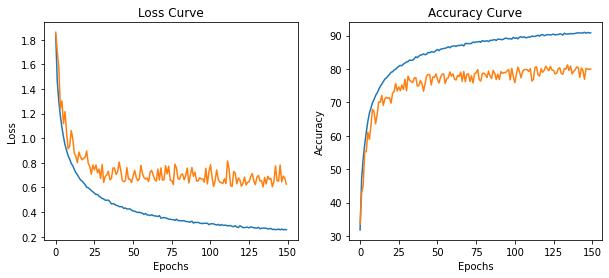

Final Training Accuracy: 90.81000001464844
Final Validation Accuracy: 79.97999990234375


000: Acc-tr:  91.14, Acc-val:  78.19, L-tr: 0.2516, L-val: 0.7560
000: Acc-tr:  91.14, Acc-val:  78.19, L-tr: 0.2516, L-val: 0.7560
000: Acc-tr:  91.14, Acc-val:  78.19, L-tr: 0.2516, L-val: 0.7560


Epoch 0 Finished.  Time per Epoch:  4268.00 s 


001: Acc-tr:  90.79, Acc-val:  79.04, L-tr: 0.2595, L-val: 0.6935
001: Acc-tr:  90.79, Acc-val:  79.04, L-tr: 0.2595, L-val: 0.6935
001: Acc-tr:  90.79, Acc-val:  79.04, L-tr: 0.2595, L-val: 0.6935


Epoch 1 Finished.  Time per Epoch:  2148.32 s 


002: Acc-tr:  91.02, Acc-val:  80.53, L-tr: 0.2553, L-val: 0.6364
002: Acc-tr:  91.02, Acc-val:  80.53, L-tr: 0.2553, L-val: 0.6364
002: Acc-tr:  91.02, Acc-val:  80.53, L-tr: 0.2553, L-val: 0.6364


Epoch 2 Finished.  Time per Epoch:  1441.86 s 


003: Acc-tr:  90.87, Acc-val:  79.26, L-tr: 0.2575, L-val: 0.7223
003: Acc-tr:  90.87, Acc-val:  79.26, L-tr: 0.2575, L-val: 0.7223
003: Acc-tr:  90.87, Acc-val:  79.26, L-tr: 0.2575, L-val: 0.7223


Epoch 3 Finished.  Time per Epoch:  1088.46 s 


004: Acc-tr:  91.07, Acc-val:  78.31, L-tr: 0.2492, L-val: 0.7317
004: Acc-tr:  91.07, Acc-val:  78.31, L-tr: 0.2492, L-val: 0.7317
004: Acc-tr:  91.07, Acc-val:  78.31, L-tr: 0.2492, L-val: 0.7317


Epoch 4 Finished.  Time per Epoch:  876.45 s 


005: Acc-tr:  91.08, Acc-val:  79.61, L-tr: 0.2491, L-val: 0.7112
005: Acc-tr:  91.08, Acc-val:  79.61, L-tr: 0.2491, L-val: 0.7112
005: Acc-tr:  91.08, Acc-val:  79.61, L-tr: 0.2491, L-val: 0.7112


Epoch 5 Finished.  Time per Epoch:  735.07 s 


006: Acc-tr:  90.95, Acc-val:  79.70, L-tr: 0.2562, L-val: 0.6785
006: Acc-tr:  90.95, Acc-val:  79.70, L-tr: 0.2562, L-val: 0.6785
006: Acc-tr:  90.95, Acc-val:  79.70, L-tr: 0.2562, L-val: 0.6785


Epoch 6 Finished.  Time per Epoch:  634.21 s 


007: Acc-tr:  91.07, Acc-val:  78.73, L-tr: 0.2505, L-val: 0.7161
007: Acc-tr:  91.07, Acc-val:  78.73, L-tr: 0.2505, L-val: 0.7161
007: Acc-tr:  91.07, Acc-val:  78.73, L-tr: 0.2505, L-val: 0.7161


Epoch 7 Finished.  Time per Epoch:  558.44 s 


008: Acc-tr:  90.74, Acc-val:  80.93, L-tr: 0.2596, L-val: 0.6201
008: Acc-tr:  90.74, Acc-val:  80.93, L-tr: 0.2596, L-val: 0.6201
008: Acc-tr:  90.74, Acc-val:  80.93, L-tr: 0.2596, L-val: 0.6201


Epoch 8 Finished.  Time per Epoch:  499.57 s 


KeyboardInterrupt: ignored

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_RandomRotation)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_RandomRotation)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

directory = "/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/WRN/WRNModel_RandomRotation"

for i, (input, target) in enumerate(trainloader):
  print(input.size())
  break

main("WRN",'wide-resnet','train', directory, 150)

##Random Erasing

In [ ]:
transform_RandomErasing = transforms.Compose([
    transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.RandomErasing(),
    myNormalize()
    ])

Files already downloaded and verified
Files already downloaded and verified
torch.Size([512, 3, 32, 32])


Number of parameters: 369498
Number of parameters: 369498
Number of parameters: 369498
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:144: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
000: Acc-tr:  38.62, Acc-val:  43.25, L-tr: 1.6511, L-val: 1.6286
000: Acc-tr:  38.62, Acc-val:  43.25, L-tr: 1.6511, L-val: 1.6286
000: Acc-tr:  38.62, Acc-val:  43.25, L-tr: 1.6511, L-val: 1.6286


Epoch 0 Finished.  Time per Epoch:  17.93 s 


001: Acc-tr:  59.51, Acc-val:  55.62, L-tr: 1.1244, L-val: 1.2863
001: Acc-tr:  59.51, Acc-val:  55.62, L-tr: 1.1244, L-val: 1.2863
001: Acc-tr:  59.51, Acc-val:  55.62, L-tr: 1.1244, L-val: 1.2863


Epoch 1 Finished.  Time per Epoch:  17.90 s 


002: Acc-tr:  68.50, Acc-val:  59.47, L-tr: 0.8789, L-val: 1.1427
002: Acc-tr:  68.50, Acc-val:  59.47, L-tr: 0.8789, L-val: 1.1427
002: Acc-tr:  68.50, Acc-val:  59.47, L-tr: 0.8789, L-val: 1.1427


Epoch 2 Finished.  Time per Epoch:  17.77 s 


003: Acc-tr:  74.27, Acc-val:  67.79, L-tr: 0.7285, L-val: 0.8988
003: Acc-tr:  74.27, Acc-val:  67.79, L-tr: 0.7285, L-val: 0.8988
003: Acc-tr:  74.27, Acc-val:  67.79, L-tr: 0.7285, L-val: 0.8988


Epoch 3 Finished.  Time per Epoch:  17.75 s 


004: Acc-tr:  78.35, Acc-val:  71.41, L-tr: 0.6176, L-val: 0.8382
004: Acc-tr:  78.35, Acc-val:  71.41, L-tr: 0.6176, L-val: 0.8382
004: Acc-tr:  78.35, Acc-val:  71.41, L-tr: 0.6176, L-val: 0.8382


Epoch 4 Finished.  Time per Epoch:  17.77 s 


005: Acc-tr:  80.90, Acc-val:  63.67, L-tr: 0.5430, L-val: 1.3527
005: Acc-tr:  80.90, Acc-val:  63.67, L-tr: 0.5430, L-val: 1.3527
005: Acc-tr:  80.90, Acc-val:  63.67, L-tr: 0.5430, L-val: 1.3527


Epoch 5 Finished.  Time per Epoch:  17.79 s 


006: Acc-tr:  83.16, Acc-val:  76.19, L-tr: 0.4795, L-val: 0.7289
006: Acc-tr:  83.16, Acc-val:  76.19, L-tr: 0.4795, L-val: 0.7289
006: Acc-tr:  83.16, Acc-val:  76.19, L-tr: 0.4795, L-val: 0.7289


Epoch 6 Finished.  Time per Epoch:  17.76 s 


007: Acc-tr:  84.89, Acc-val:  69.93, L-tr: 0.4289, L-val: 1.0028
007: Acc-tr:  84.89, Acc-val:  69.93, L-tr: 0.4289, L-val: 1.0028
007: Acc-tr:  84.89, Acc-val:  69.93, L-tr: 0.4289, L-val: 1.0028


Epoch 7 Finished.  Time per Epoch:  17.75 s 


008: Acc-tr:  86.68, Acc-val:  73.04, L-tr: 0.3755, L-val: 0.9486
008: Acc-tr:  86.68, Acc-val:  73.04, L-tr: 0.3755, L-val: 0.9486
008: Acc-tr:  86.68, Acc-val:  73.04, L-tr: 0.3755, L-val: 0.9486


Epoch 8 Finished.  Time per Epoch:  17.70 s 


009: Acc-tr:  88.45, Acc-val:  69.29, L-tr: 0.3317, L-val: 1.0315
009: Acc-tr:  88.45, Acc-val:  69.29, L-tr: 0.3317, L-val: 1.0315
009: Acc-tr:  88.45, Acc-val:  69.29, L-tr: 0.3317, L-val: 1.0315


Epoch 9 Finished.  Time per Epoch:  17.67 s 


010: Acc-tr:  89.38, Acc-val:  74.23, L-tr: 0.3011, L-val: 0.8493
010: Acc-tr:  89.38, Acc-val:  74.23, L-tr: 0.3011, L-val: 0.8493
010: Acc-tr:  89.38, Acc-val:  74.23, L-tr: 0.3011, L-val: 0.8493


Epoch 10 Finished.  Time per Epoch:  17.67 s 


011: Acc-tr:  90.77, Acc-val:  79.00, L-tr: 0.2625, L-val: 0.7273
011: Acc-tr:  90.77, Acc-val:  79.00, L-tr: 0.2625, L-val: 0.7273
011: Acc-tr:  90.77, Acc-val:  79.00, L-tr: 0.2625, L-val: 0.7273


Epoch 11 Finished.  Time per Epoch:  17.66 s 


012: Acc-tr:  91.60, Acc-val:  75.22, L-tr: 0.2395, L-val: 0.8714
012: Acc-tr:  91.60, Acc-val:  75.22, L-tr: 0.2395, L-val: 0.8714
012: Acc-tr:  91.60, Acc-val:  75.22, L-tr: 0.2395, L-val: 0.8714


Epoch 12 Finished.  Time per Epoch:  17.66 s 


013: Acc-tr:  92.37, Acc-val:  76.10, L-tr: 0.2132, L-val: 0.8365
013: Acc-tr:  92.37, Acc-val:  76.10, L-tr: 0.2132, L-val: 0.8365
013: Acc-tr:  92.37, Acc-val:  76.10, L-tr: 0.2132, L-val: 0.8365


Epoch 13 Finished.  Time per Epoch:  17.67 s 


014: Acc-tr:  93.28, Acc-val:  78.14, L-tr: 0.1909, L-val: 0.7920
014: Acc-tr:  93.28, Acc-val:  78.14, L-tr: 0.1909, L-val: 0.7920
014: Acc-tr:  93.28, Acc-val:  78.14, L-tr: 0.1909, L-val: 0.7920


Epoch 14 Finished.  Time per Epoch:  17.70 s 


015: Acc-tr:  94.17, Acc-val:  69.94, L-tr: 0.1621, L-val: 1.3424
015: Acc-tr:  94.17, Acc-val:  69.94, L-tr: 0.1621, L-val: 1.3424
015: Acc-tr:  94.17, Acc-val:  69.94, L-tr: 0.1621, L-val: 1.3424


Epoch 15 Finished.  Time per Epoch:  17.71 s 


016: Acc-tr:  94.33, Acc-val:  75.11, L-tr: 0.1593, L-val: 1.0647
016: Acc-tr:  94.33, Acc-val:  75.11, L-tr: 0.1593, L-val: 1.0647
016: Acc-tr:  94.33, Acc-val:  75.11, L-tr: 0.1593, L-val: 1.0647


Epoch 16 Finished.  Time per Epoch:  17.71 s 


017: Acc-tr:  95.31, Acc-val:  78.08, L-tr: 0.1327, L-val: 0.8720
017: Acc-tr:  95.31, Acc-val:  78.08, L-tr: 0.1327, L-val: 0.8720
017: Acc-tr:  95.31, Acc-val:  78.08, L-tr: 0.1327, L-val: 0.8720


Epoch 17 Finished.  Time per Epoch:  17.71 s 


018: Acc-tr:  95.74, Acc-val:  77.37, L-tr: 0.1219, L-val: 1.0218
018: Acc-tr:  95.74, Acc-val:  77.37, L-tr: 0.1219, L-val: 1.0218
018: Acc-tr:  95.74, Acc-val:  77.37, L-tr: 0.1219, L-val: 1.0218


Epoch 18 Finished.  Time per Epoch:  17.70 s 


019: Acc-tr:  96.18, Acc-val:  75.79, L-tr: 0.1085, L-val: 1.0333
019: Acc-tr:  96.18, Acc-val:  75.79, L-tr: 0.1085, L-val: 1.0333
019: Acc-tr:  96.18, Acc-val:  75.79, L-tr: 0.1085, L-val: 1.0333


Epoch 19 Finished.  Time per Epoch:  17.70 s 


020: Acc-tr:  96.10, Acc-val:  77.10, L-tr: 0.1092, L-val: 1.0132
020: Acc-tr:  96.10, Acc-val:  77.10, L-tr: 0.1092, L-val: 1.0132
020: Acc-tr:  96.10, Acc-val:  77.10, L-tr: 0.1092, L-val: 1.0132


Epoch 20 Finished.  Time per Epoch:  17.70 s 


021: Acc-tr:  96.47, Acc-val:  76.22, L-tr: 0.0998, L-val: 1.1769
021: Acc-tr:  96.47, Acc-val:  76.22, L-tr: 0.0998, L-val: 1.1769
021: Acc-tr:  96.47, Acc-val:  76.22, L-tr: 0.0998, L-val: 1.1769


Epoch 21 Finished.  Time per Epoch:  17.71 s 


022: Acc-tr:  97.14, Acc-val:  77.41, L-tr: 0.0811, L-val: 1.0970
022: Acc-tr:  97.14, Acc-val:  77.41, L-tr: 0.0811, L-val: 1.0970
022: Acc-tr:  97.14, Acc-val:  77.41, L-tr: 0.0811, L-val: 1.0970


Epoch 22 Finished.  Time per Epoch:  17.70 s 


023: Acc-tr:  97.11, Acc-val:  79.49, L-tr: 0.0839, L-val: 0.9693
023: Acc-tr:  97.11, Acc-val:  79.49, L-tr: 0.0839, L-val: 0.9693
023: Acc-tr:  97.11, Acc-val:  79.49, L-tr: 0.0839, L-val: 0.9693


Epoch 23 Finished.  Time per Epoch:  17.70 s 


024: Acc-tr:  97.16, Acc-val:  75.98, L-tr: 0.0829, L-val: 1.1842
024: Acc-tr:  97.16, Acc-val:  75.98, L-tr: 0.0829, L-val: 1.1842
024: Acc-tr:  97.16, Acc-val:  75.98, L-tr: 0.0829, L-val: 1.1842


Epoch 24 Finished.  Time per Epoch:  17.71 s 


025: Acc-tr:  97.44, Acc-val:  76.45, L-tr: 0.0725, L-val: 1.1331
025: Acc-tr:  97.44, Acc-val:  76.45, L-tr: 0.0725, L-val: 1.1331
025: Acc-tr:  97.44, Acc-val:  76.45, L-tr: 0.0725, L-val: 1.1331


Epoch 25 Finished.  Time per Epoch:  17.73 s 


026: Acc-tr:  98.07, Acc-val:  78.67, L-tr: 0.0554, L-val: 1.0374
026: Acc-tr:  98.07, Acc-val:  78.67, L-tr: 0.0554, L-val: 1.0374
026: Acc-tr:  98.07, Acc-val:  78.67, L-tr: 0.0554, L-val: 1.0374


Epoch 26 Finished.  Time per Epoch:  17.75 s 


027: Acc-tr:  97.80, Acc-val:  77.96, L-tr: 0.0620, L-val: 1.0879
027: Acc-tr:  97.80, Acc-val:  77.96, L-tr: 0.0620, L-val: 1.0879
027: Acc-tr:  97.80, Acc-val:  77.96, L-tr: 0.0620, L-val: 1.0879


Epoch 27 Finished.  Time per Epoch:  17.77 s 


028: Acc-tr:  97.48, Acc-val:  79.61, L-tr: 0.0714, L-val: 0.9587
028: Acc-tr:  97.48, Acc-val:  79.61, L-tr: 0.0714, L-val: 0.9587
028: Acc-tr:  97.48, Acc-val:  79.61, L-tr: 0.0714, L-val: 0.9587


Epoch 28 Finished.  Time per Epoch:  17.78 s 


029: Acc-tr:  97.85, Acc-val:  78.20, L-tr: 0.0630, L-val: 1.0556
029: Acc-tr:  97.85, Acc-val:  78.20, L-tr: 0.0630, L-val: 1.0556
029: Acc-tr:  97.85, Acc-val:  78.20, L-tr: 0.0630, L-val: 1.0556


Epoch 29 Finished.  Time per Epoch:  17.78 s 


030: Acc-tr:  97.78, Acc-val:  78.53, L-tr: 0.0631, L-val: 1.0623
030: Acc-tr:  97.78, Acc-val:  78.53, L-tr: 0.0631, L-val: 1.0623
030: Acc-tr:  97.78, Acc-val:  78.53, L-tr: 0.0631, L-val: 1.0623


Epoch 30 Finished.  Time per Epoch:  17.78 s 


031: Acc-tr:  98.34, Acc-val:  78.38, L-tr: 0.0491, L-val: 1.0952
031: Acc-tr:  98.34, Acc-val:  78.38, L-tr: 0.0491, L-val: 1.0952
031: Acc-tr:  98.34, Acc-val:  78.38, L-tr: 0.0491, L-val: 1.0952


Epoch 31 Finished.  Time per Epoch:  17.80 s 


032: Acc-tr:  98.75, Acc-val:  76.27, L-tr: 0.0386, L-val: 1.2736
032: Acc-tr:  98.75, Acc-val:  76.27, L-tr: 0.0386, L-val: 1.2736
032: Acc-tr:  98.75, Acc-val:  76.27, L-tr: 0.0386, L-val: 1.2736


Epoch 32 Finished.  Time per Epoch:  17.80 s 


033: Acc-tr:  98.41, Acc-val:  76.60, L-tr: 0.0458, L-val: 1.2797
033: Acc-tr:  98.41, Acc-val:  76.60, L-tr: 0.0458, L-val: 1.2797
033: Acc-tr:  98.41, Acc-val:  76.60, L-tr: 0.0458, L-val: 1.2797


Epoch 33 Finished.  Time per Epoch:  17.80 s 


034: Acc-tr:  98.52, Acc-val:  78.06, L-tr: 0.0432, L-val: 1.1957
034: Acc-tr:  98.52, Acc-val:  78.06, L-tr: 0.0432, L-val: 1.1957
034: Acc-tr:  98.52, Acc-val:  78.06, L-tr: 0.0432, L-val: 1.1957


Epoch 34 Finished.  Time per Epoch:  17.80 s 


035: Acc-tr:  98.44, Acc-val:  77.82, L-tr: 0.0443, L-val: 1.1696
035: Acc-tr:  98.44, Acc-val:  77.82, L-tr: 0.0443, L-val: 1.1696
035: Acc-tr:  98.44, Acc-val:  77.82, L-tr: 0.0443, L-val: 1.1696


Epoch 35 Finished.  Time per Epoch:  17.81 s 


036: Acc-tr:  98.09, Acc-val:  78.68, L-tr: 0.0544, L-val: 1.0482
036: Acc-tr:  98.09, Acc-val:  78.68, L-tr: 0.0544, L-val: 1.0482
036: Acc-tr:  98.09, Acc-val:  78.68, L-tr: 0.0544, L-val: 1.0482


Epoch 36 Finished.  Time per Epoch:  17.80 s 


037: Acc-tr:  97.89, Acc-val:  75.66, L-tr: 0.0606, L-val: 1.2654
037: Acc-tr:  97.89, Acc-val:  75.66, L-tr: 0.0606, L-val: 1.2654
037: Acc-tr:  97.89, Acc-val:  75.66, L-tr: 0.0606, L-val: 1.2654


Epoch 37 Finished.  Time per Epoch:  17.80 s 


038: Acc-tr:  98.51, Acc-val:  80.21, L-tr: 0.0439, L-val: 1.0131
038: Acc-tr:  98.51, Acc-val:  80.21, L-tr: 0.0439, L-val: 1.0131
038: Acc-tr:  98.51, Acc-val:  80.21, L-tr: 0.0439, L-val: 1.0131


Epoch 38 Finished.  Time per Epoch:  17.79 s 


039: Acc-tr:  99.13, Acc-val:  80.43, L-tr: 0.0262, L-val: 0.9477
039: Acc-tr:  99.13, Acc-val:  80.43, L-tr: 0.0262, L-val: 0.9477
039: Acc-tr:  99.13, Acc-val:  80.43, L-tr: 0.0262, L-val: 0.9477


Epoch 39 Finished.  Time per Epoch:  17.79 s 


040: Acc-tr:  99.16, Acc-val:  80.45, L-tr: 0.0257, L-val: 0.9832
040: Acc-tr:  99.16, Acc-val:  80.45, L-tr: 0.0257, L-val: 0.9832
040: Acc-tr:  99.16, Acc-val:  80.45, L-tr: 0.0257, L-val: 0.9832


Epoch 40 Finished.  Time per Epoch:  17.78 s 


041: Acc-tr:  99.27, Acc-val:  80.11, L-tr: 0.0223, L-val: 1.0855
041: Acc-tr:  99.27, Acc-val:  80.11, L-tr: 0.0223, L-val: 1.0855
041: Acc-tr:  99.27, Acc-val:  80.11, L-tr: 0.0223, L-val: 1.0855


Epoch 41 Finished.  Time per Epoch:  17.78 s 


042: Acc-tr:  99.42, Acc-val:  80.87, L-tr: 0.0190, L-val: 0.9758
042: Acc-tr:  99.42, Acc-val:  80.87, L-tr: 0.0190, L-val: 0.9758
042: Acc-tr:  99.42, Acc-val:  80.87, L-tr: 0.0190, L-val: 0.9758


Epoch 42 Finished.  Time per Epoch:  17.77 s 


043: Acc-tr:  99.47, Acc-val:  81.06, L-tr: 0.0166, L-val: 1.0029
043: Acc-tr:  99.47, Acc-val:  81.06, L-tr: 0.0166, L-val: 1.0029
043: Acc-tr:  99.47, Acc-val:  81.06, L-tr: 0.0166, L-val: 1.0029


Epoch 43 Finished.  Time per Epoch:  17.77 s 


044: Acc-tr:  99.37, Acc-val:  80.01, L-tr: 0.0199, L-val: 1.0116
044: Acc-tr:  99.37, Acc-val:  80.01, L-tr: 0.0199, L-val: 1.0116
044: Acc-tr:  99.37, Acc-val:  80.01, L-tr: 0.0199, L-val: 1.0116


Epoch 44 Finished.  Time per Epoch:  17.78 s 


045: Acc-tr:  98.82, Acc-val:  77.78, L-tr: 0.0344, L-val: 1.1242
045: Acc-tr:  98.82, Acc-val:  77.78, L-tr: 0.0344, L-val: 1.1242
045: Acc-tr:  98.82, Acc-val:  77.78, L-tr: 0.0344, L-val: 1.1242


Epoch 45 Finished.  Time per Epoch:  17.77 s 


046: Acc-tr:  97.94, Acc-val:  79.29, L-tr: 0.0590, L-val: 1.0919
046: Acc-tr:  97.94, Acc-val:  79.29, L-tr: 0.0590, L-val: 1.0919
046: Acc-tr:  97.94, Acc-val:  79.29, L-tr: 0.0590, L-val: 1.0919


Epoch 46 Finished.  Time per Epoch:  17.77 s 


047: Acc-tr:  97.84, Acc-val:  75.66, L-tr: 0.0588, L-val: 1.3000
047: Acc-tr:  97.84, Acc-val:  75.66, L-tr: 0.0588, L-val: 1.3000
047: Acc-tr:  97.84, Acc-val:  75.66, L-tr: 0.0588, L-val: 1.3000


Epoch 47 Finished.  Time per Epoch:  17.77 s 


048: Acc-tr:  98.74, Acc-val:  79.35, L-tr: 0.0365, L-val: 0.9927
048: Acc-tr:  98.74, Acc-val:  79.35, L-tr: 0.0365, L-val: 0.9927
048: Acc-tr:  98.74, Acc-val:  79.35, L-tr: 0.0365, L-val: 0.9927


Epoch 48 Finished.  Time per Epoch:  17.77 s 


049: Acc-tr:  98.45, Acc-val:  77.72, L-tr: 0.0448, L-val: 1.0996
049: Acc-tr:  98.45, Acc-val:  77.72, L-tr: 0.0448, L-val: 1.0996
049: Acc-tr:  98.45, Acc-val:  77.72, L-tr: 0.0448, L-val: 1.0996


Epoch 49 Finished.  Time per Epoch:  17.77 s 


050: Acc-tr:  98.40, Acc-val:  76.87, L-tr: 0.0446, L-val: 1.1956
050: Acc-tr:  98.40, Acc-val:  76.87, L-tr: 0.0446, L-val: 1.1956
050: Acc-tr:  98.40, Acc-val:  76.87, L-tr: 0.0446, L-val: 1.1956


Epoch 50 Finished.  Time per Epoch:  17.77 s 


051: Acc-tr:  99.23, Acc-val:  80.18, L-tr: 0.0240, L-val: 0.9948
051: Acc-tr:  99.23, Acc-val:  80.18, L-tr: 0.0240, L-val: 0.9948
051: Acc-tr:  99.23, Acc-val:  80.18, L-tr: 0.0240, L-val: 0.9948


Epoch 51 Finished.  Time per Epoch:  17.76 s 


052: Acc-tr:  99.59, Acc-val:  81.17, L-tr: 0.0141, L-val: 0.9989
052: Acc-tr:  99.59, Acc-val:  81.17, L-tr: 0.0141, L-val: 0.9989
052: Acc-tr:  99.59, Acc-val:  81.17, L-tr: 0.0141, L-val: 0.9989


Epoch 52 Finished.  Time per Epoch:  17.77 s 


053: Acc-tr:  99.76, Acc-val:  81.20, L-tr: 0.0090, L-val: 0.9737
053: Acc-tr:  99.76, Acc-val:  81.20, L-tr: 0.0090, L-val: 0.9737
053: Acc-tr:  99.76, Acc-val:  81.20, L-tr: 0.0090, L-val: 0.9737


Epoch 53 Finished.  Time per Epoch:  17.76 s 


054: Acc-tr:  99.83, Acc-val:  81.72, L-tr: 0.0069, L-val: 0.9519
054: Acc-tr:  99.83, Acc-val:  81.72, L-tr: 0.0069, L-val: 0.9519
054: Acc-tr:  99.83, Acc-val:  81.72, L-tr: 0.0069, L-val: 0.9519


Epoch 54 Finished.  Time per Epoch:  17.77 s 


055: Acc-tr:  99.94, Acc-val:  82.51, L-tr: 0.0037, L-val: 0.9090
055: Acc-tr:  99.94, Acc-val:  82.51, L-tr: 0.0037, L-val: 0.9090
055: Acc-tr:  99.94, Acc-val:  82.51, L-tr: 0.0037, L-val: 0.9090


Epoch 55 Finished.  Time per Epoch:  17.77 s 


056: Acc-tr:  99.95, Acc-val:  82.26, L-tr: 0.0024, L-val: 0.8902
056: Acc-tr:  99.95, Acc-val:  82.26, L-tr: 0.0024, L-val: 0.8902
056: Acc-tr:  99.95, Acc-val:  82.26, L-tr: 0.0024, L-val: 0.8902


Epoch 56 Finished.  Time per Epoch:  17.77 s 


057: Acc-tr: 100.00, Acc-val:  82.92, L-tr: 0.0010, L-val: 0.8676
057: Acc-tr: 100.00, Acc-val:  82.92, L-tr: 0.0010, L-val: 0.8676
057: Acc-tr: 100.00, Acc-val:  82.92, L-tr: 0.0010, L-val: 0.8676


Epoch 57 Finished.  Time per Epoch:  17.77 s 


058: Acc-tr: 100.00, Acc-val:  83.12, L-tr: 0.0005, L-val: 0.8497
058: Acc-tr: 100.00, Acc-val:  83.12, L-tr: 0.0005, L-val: 0.8497
058: Acc-tr: 100.00, Acc-val:  83.12, L-tr: 0.0005, L-val: 0.8497


Epoch 58 Finished.  Time per Epoch:  17.77 s 


059: Acc-tr: 100.00, Acc-val:  83.34, L-tr: 0.0004, L-val: 0.8416
059: Acc-tr: 100.00, Acc-val:  83.34, L-tr: 0.0004, L-val: 0.8416
059: Acc-tr: 100.00, Acc-val:  83.34, L-tr: 0.0004, L-val: 0.8416


Epoch 59 Finished.  Time per Epoch:  17.76 s 


060: Acc-tr: 100.00, Acc-val:  83.43, L-tr: 0.0003, L-val: 0.8332
060: Acc-tr: 100.00, Acc-val:  83.43, L-tr: 0.0003, L-val: 0.8332
060: Acc-tr: 100.00, Acc-val:  83.43, L-tr: 0.0003, L-val: 0.8332


Epoch 60 Finished.  Time per Epoch:  17.76 s 


061: Acc-tr: 100.00, Acc-val:  83.33, L-tr: 0.0003, L-val: 0.8220
061: Acc-tr: 100.00, Acc-val:  83.33, L-tr: 0.0003, L-val: 0.8220
061: Acc-tr: 100.00, Acc-val:  83.33, L-tr: 0.0003, L-val: 0.8220


Epoch 61 Finished.  Time per Epoch:  17.77 s 


062: Acc-tr: 100.00, Acc-val:  83.31, L-tr: 0.0003, L-val: 0.8201
062: Acc-tr: 100.00, Acc-val:  83.31, L-tr: 0.0003, L-val: 0.8201
062: Acc-tr: 100.00, Acc-val:  83.31, L-tr: 0.0003, L-val: 0.8201


Epoch 62 Finished.  Time per Epoch:  17.77 s 


063: Acc-tr: 100.00, Acc-val:  83.34, L-tr: 0.0003, L-val: 0.8114
063: Acc-tr: 100.00, Acc-val:  83.34, L-tr: 0.0003, L-val: 0.8114
063: Acc-tr: 100.00, Acc-val:  83.34, L-tr: 0.0003, L-val: 0.8114


Epoch 63 Finished.  Time per Epoch:  17.78 s 


064: Acc-tr: 100.00, Acc-val:  83.35, L-tr: 0.0003, L-val: 0.8044
064: Acc-tr: 100.00, Acc-val:  83.35, L-tr: 0.0003, L-val: 0.8044
064: Acc-tr: 100.00, Acc-val:  83.35, L-tr: 0.0003, L-val: 0.8044


Epoch 64 Finished.  Time per Epoch:  17.78 s 


065: Acc-tr: 100.00, Acc-val:  83.39, L-tr: 0.0003, L-val: 0.7992
065: Acc-tr: 100.00, Acc-val:  83.39, L-tr: 0.0003, L-val: 0.7992
065: Acc-tr: 100.00, Acc-val:  83.39, L-tr: 0.0003, L-val: 0.7992


Epoch 65 Finished.  Time per Epoch:  17.78 s 


066: Acc-tr: 100.00, Acc-val:  83.38, L-tr: 0.0004, L-val: 0.7922
066: Acc-tr: 100.00, Acc-val:  83.38, L-tr: 0.0004, L-val: 0.7922
066: Acc-tr: 100.00, Acc-val:  83.38, L-tr: 0.0004, L-val: 0.7922


Epoch 66 Finished.  Time per Epoch:  17.79 s 


067: Acc-tr: 100.00, Acc-val:  83.31, L-tr: 0.0003, L-val: 0.7905
067: Acc-tr: 100.00, Acc-val:  83.31, L-tr: 0.0003, L-val: 0.7905
067: Acc-tr: 100.00, Acc-val:  83.31, L-tr: 0.0003, L-val: 0.7905


Epoch 67 Finished.  Time per Epoch:  17.80 s 


068: Acc-tr: 100.00, Acc-val:  83.30, L-tr: 0.0004, L-val: 0.7844
068: Acc-tr: 100.00, Acc-val:  83.30, L-tr: 0.0004, L-val: 0.7844
068: Acc-tr: 100.00, Acc-val:  83.30, L-tr: 0.0004, L-val: 0.7844


Epoch 68 Finished.  Time per Epoch:  17.81 s 


069: Acc-tr: 100.00, Acc-val:  83.29, L-tr: 0.0004, L-val: 0.7768
069: Acc-tr: 100.00, Acc-val:  83.29, L-tr: 0.0004, L-val: 0.7768
069: Acc-tr: 100.00, Acc-val:  83.29, L-tr: 0.0004, L-val: 0.7768


Epoch 69 Finished.  Time per Epoch:  17.82 s 


070: Acc-tr: 100.00, Acc-val:  83.44, L-tr: 0.0004, L-val: 0.7724
070: Acc-tr: 100.00, Acc-val:  83.44, L-tr: 0.0004, L-val: 0.7724
070: Acc-tr: 100.00, Acc-val:  83.44, L-tr: 0.0004, L-val: 0.7724


Epoch 70 Finished.  Time per Epoch:  17.83 s 


071: Acc-tr: 100.00, Acc-val:  83.28, L-tr: 0.0004, L-val: 0.7703
071: Acc-tr: 100.00, Acc-val:  83.28, L-tr: 0.0004, L-val: 0.7703
071: Acc-tr: 100.00, Acc-val:  83.28, L-tr: 0.0004, L-val: 0.7703


Epoch 71 Finished.  Time per Epoch:  17.84 s 


072: Acc-tr: 100.00, Acc-val:  83.30, L-tr: 0.0004, L-val: 0.7628
072: Acc-tr: 100.00, Acc-val:  83.30, L-tr: 0.0004, L-val: 0.7628
072: Acc-tr: 100.00, Acc-val:  83.30, L-tr: 0.0004, L-val: 0.7628


Epoch 72 Finished.  Time per Epoch:  17.85 s 


073: Acc-tr: 100.00, Acc-val:  83.42, L-tr: 0.0004, L-val: 0.7581
073: Acc-tr: 100.00, Acc-val:  83.42, L-tr: 0.0004, L-val: 0.7581
073: Acc-tr: 100.00, Acc-val:  83.42, L-tr: 0.0004, L-val: 0.7581


Epoch 73 Finished.  Time per Epoch:  17.86 s 


074: Acc-tr: 100.00, Acc-val:  83.37, L-tr: 0.0004, L-val: 0.7540
074: Acc-tr: 100.00, Acc-val:  83.37, L-tr: 0.0004, L-val: 0.7540
074: Acc-tr: 100.00, Acc-val:  83.37, L-tr: 0.0004, L-val: 0.7540


Epoch 74 Finished.  Time per Epoch:  17.87 s 


075: Acc-tr: 100.00, Acc-val:  83.32, L-tr: 0.0004, L-val: 0.7495
075: Acc-tr: 100.00, Acc-val:  83.32, L-tr: 0.0004, L-val: 0.7495
075: Acc-tr: 100.00, Acc-val:  83.32, L-tr: 0.0004, L-val: 0.7495


Epoch 75 Finished.  Time per Epoch:  17.88 s 


076: Acc-tr: 100.00, Acc-val:  83.38, L-tr: 0.0004, L-val: 0.7462
076: Acc-tr: 100.00, Acc-val:  83.38, L-tr: 0.0004, L-val: 0.7462
076: Acc-tr: 100.00, Acc-val:  83.38, L-tr: 0.0004, L-val: 0.7462


Epoch 76 Finished.  Time per Epoch:  17.89 s 


077: Acc-tr: 100.00, Acc-val:  83.33, L-tr: 0.0004, L-val: 0.7419
077: Acc-tr: 100.00, Acc-val:  83.33, L-tr: 0.0004, L-val: 0.7419
077: Acc-tr: 100.00, Acc-val:  83.33, L-tr: 0.0004, L-val: 0.7419


Epoch 77 Finished.  Time per Epoch:  17.90 s 


078: Acc-tr: 100.00, Acc-val:  83.36, L-tr: 0.0005, L-val: 0.7433
078: Acc-tr: 100.00, Acc-val:  83.36, L-tr: 0.0005, L-val: 0.7433
078: Acc-tr: 100.00, Acc-val:  83.36, L-tr: 0.0005, L-val: 0.7433


Epoch 78 Finished.  Time per Epoch:  17.91 s 


079: Acc-tr: 100.00, Acc-val:  83.32, L-tr: 0.0004, L-val: 0.7394
079: Acc-tr: 100.00, Acc-val:  83.32, L-tr: 0.0004, L-val: 0.7394
079: Acc-tr: 100.00, Acc-val:  83.32, L-tr: 0.0004, L-val: 0.7394


Epoch 79 Finished.  Time per Epoch:  17.92 s 


080: Acc-tr: 100.00, Acc-val:  83.21, L-tr: 0.0005, L-val: 0.7358
080: Acc-tr: 100.00, Acc-val:  83.21, L-tr: 0.0005, L-val: 0.7358
080: Acc-tr: 100.00, Acc-val:  83.21, L-tr: 0.0005, L-val: 0.7358


Epoch 80 Finished.  Time per Epoch:  17.92 s 


081: Acc-tr: 100.00, Acc-val:  83.17, L-tr: 0.0005, L-val: 0.7335
081: Acc-tr: 100.00, Acc-val:  83.17, L-tr: 0.0005, L-val: 0.7335
081: Acc-tr: 100.00, Acc-val:  83.17, L-tr: 0.0005, L-val: 0.7335


Epoch 81 Finished.  Time per Epoch:  17.93 s 


082: Acc-tr: 100.00, Acc-val:  83.29, L-tr: 0.0005, L-val: 0.7349
082: Acc-tr: 100.00, Acc-val:  83.29, L-tr: 0.0005, L-val: 0.7349
082: Acc-tr: 100.00, Acc-val:  83.29, L-tr: 0.0005, L-val: 0.7349


Epoch 82 Finished.  Time per Epoch:  17.94 s 


083: Acc-tr: 100.00, Acc-val:  83.37, L-tr: 0.0005, L-val: 0.7272
083: Acc-tr: 100.00, Acc-val:  83.37, L-tr: 0.0005, L-val: 0.7272
083: Acc-tr: 100.00, Acc-val:  83.37, L-tr: 0.0005, L-val: 0.7272


Epoch 83 Finished.  Time per Epoch:  17.95 s 


084: Acc-tr: 100.00, Acc-val:  83.30, L-tr: 0.0005, L-val: 0.7291
084: Acc-tr: 100.00, Acc-val:  83.30, L-tr: 0.0005, L-val: 0.7291
084: Acc-tr: 100.00, Acc-val:  83.30, L-tr: 0.0005, L-val: 0.7291


Epoch 84 Finished.  Time per Epoch:  17.96 s 


085: Acc-tr: 100.00, Acc-val:  83.23, L-tr: 0.0005, L-val: 0.7251
085: Acc-tr: 100.00, Acc-val:  83.23, L-tr: 0.0005, L-val: 0.7251
085: Acc-tr: 100.00, Acc-val:  83.23, L-tr: 0.0005, L-val: 0.7251


Epoch 85 Finished.  Time per Epoch:  17.97 s 


086: Acc-tr: 100.00, Acc-val:  83.24, L-tr: 0.0005, L-val: 0.7225
086: Acc-tr: 100.00, Acc-val:  83.24, L-tr: 0.0005, L-val: 0.7225
086: Acc-tr: 100.00, Acc-val:  83.24, L-tr: 0.0005, L-val: 0.7225


Epoch 86 Finished.  Time per Epoch:  17.98 s 


087: Acc-tr: 100.00, Acc-val:  83.42, L-tr: 0.0005, L-val: 0.7207
087: Acc-tr: 100.00, Acc-val:  83.42, L-tr: 0.0005, L-val: 0.7207
087: Acc-tr: 100.00, Acc-val:  83.42, L-tr: 0.0005, L-val: 0.7207


Epoch 87 Finished.  Time per Epoch:  17.98 s 


088: Acc-tr: 100.00, Acc-val:  83.32, L-tr: 0.0005, L-val: 0.7189
088: Acc-tr: 100.00, Acc-val:  83.32, L-tr: 0.0005, L-val: 0.7189
088: Acc-tr: 100.00, Acc-val:  83.32, L-tr: 0.0005, L-val: 0.7189


Epoch 88 Finished.  Time per Epoch:  17.99 s 


089: Acc-tr: 100.00, Acc-val:  83.33, L-tr: 0.0005, L-val: 0.7169
089: Acc-tr: 100.00, Acc-val:  83.33, L-tr: 0.0005, L-val: 0.7169
089: Acc-tr: 100.00, Acc-val:  83.33, L-tr: 0.0005, L-val: 0.7169


Epoch 89 Finished.  Time per Epoch:  18.00 s 


090: Acc-tr: 100.00, Acc-val:  83.36, L-tr: 0.0005, L-val: 0.7150
090: Acc-tr: 100.00, Acc-val:  83.36, L-tr: 0.0005, L-val: 0.7150
090: Acc-tr: 100.00, Acc-val:  83.36, L-tr: 0.0005, L-val: 0.7150


Epoch 90 Finished.  Time per Epoch:  18.01 s 


091: Acc-tr: 100.00, Acc-val:  83.36, L-tr: 0.0005, L-val: 0.7125
091: Acc-tr: 100.00, Acc-val:  83.36, L-tr: 0.0005, L-val: 0.7125
091: Acc-tr: 100.00, Acc-val:  83.36, L-tr: 0.0005, L-val: 0.7125


Epoch 91 Finished.  Time per Epoch:  18.01 s 


092: Acc-tr: 100.00, Acc-val:  83.23, L-tr: 0.0005, L-val: 0.7123
092: Acc-tr: 100.00, Acc-val:  83.23, L-tr: 0.0005, L-val: 0.7123
092: Acc-tr: 100.00, Acc-val:  83.23, L-tr: 0.0005, L-val: 0.7123


Epoch 92 Finished.  Time per Epoch:  18.01 s 


093: Acc-tr: 100.00, Acc-val:  83.37, L-tr: 0.0005, L-val: 0.7125
093: Acc-tr: 100.00, Acc-val:  83.37, L-tr: 0.0005, L-val: 0.7125
093: Acc-tr: 100.00, Acc-val:  83.37, L-tr: 0.0005, L-val: 0.7125


Epoch 93 Finished.  Time per Epoch:  18.02 s 


094: Acc-tr: 100.00, Acc-val:  83.26, L-tr: 0.0005, L-val: 0.7086
094: Acc-tr: 100.00, Acc-val:  83.26, L-tr: 0.0005, L-val: 0.7086
094: Acc-tr: 100.00, Acc-val:  83.26, L-tr: 0.0005, L-val: 0.7086


Epoch 94 Finished.  Time per Epoch:  18.02 s 


095: Acc-tr: 100.00, Acc-val:  83.25, L-tr: 0.0005, L-val: 0.7095
095: Acc-tr: 100.00, Acc-val:  83.25, L-tr: 0.0005, L-val: 0.7095
095: Acc-tr: 100.00, Acc-val:  83.25, L-tr: 0.0005, L-val: 0.7095


Epoch 95 Finished.  Time per Epoch:  18.03 s 


096: Acc-tr: 100.00, Acc-val:  83.36, L-tr: 0.0005, L-val: 0.7083
096: Acc-tr: 100.00, Acc-val:  83.36, L-tr: 0.0005, L-val: 0.7083
096: Acc-tr: 100.00, Acc-val:  83.36, L-tr: 0.0005, L-val: 0.7083


Epoch 96 Finished.  Time per Epoch:  18.03 s 


097: Acc-tr: 100.00, Acc-val:  83.26, L-tr: 0.0005, L-val: 0.7088
097: Acc-tr: 100.00, Acc-val:  83.26, L-tr: 0.0005, L-val: 0.7088
097: Acc-tr: 100.00, Acc-val:  83.26, L-tr: 0.0005, L-val: 0.7088


Epoch 97 Finished.  Time per Epoch:  18.04 s 


098: Acc-tr: 100.00, Acc-val:  83.33, L-tr: 0.0005, L-val: 0.7088
098: Acc-tr: 100.00, Acc-val:  83.33, L-tr: 0.0005, L-val: 0.7088
098: Acc-tr: 100.00, Acc-val:  83.33, L-tr: 0.0005, L-val: 0.7088


Epoch 98 Finished.  Time per Epoch:  18.05 s 


099: Acc-tr: 100.00, Acc-val:  83.25, L-tr: 0.0005, L-val: 0.7053
099: Acc-tr: 100.00, Acc-val:  83.25, L-tr: 0.0005, L-val: 0.7053
099: Acc-tr: 100.00, Acc-val:  83.25, L-tr: 0.0005, L-val: 0.7053


Epoch 99 Finished.  Time per Epoch:  18.05 s 


100: Acc-tr: 100.00, Acc-val:  83.45, L-tr: 0.0005, L-val: 0.7040
100: Acc-tr: 100.00, Acc-val:  83.45, L-tr: 0.0005, L-val: 0.7040
100: Acc-tr: 100.00, Acc-val:  83.45, L-tr: 0.0005, L-val: 0.7040


Epoch 100 Finished.  Time per Epoch:  18.06 s 


101: Acc-tr: 100.00, Acc-val:  83.22, L-tr: 0.0005, L-val: 0.7077
101: Acc-tr: 100.00, Acc-val:  83.22, L-tr: 0.0005, L-val: 0.7077
101: Acc-tr: 100.00, Acc-val:  83.22, L-tr: 0.0005, L-val: 0.7077


Epoch 101 Finished.  Time per Epoch:  18.07 s 


102: Acc-tr: 100.00, Acc-val:  83.31, L-tr: 0.0005, L-val: 0.7048
102: Acc-tr: 100.00, Acc-val:  83.31, L-tr: 0.0005, L-val: 0.7048
102: Acc-tr: 100.00, Acc-val:  83.31, L-tr: 0.0005, L-val: 0.7048


Epoch 102 Finished.  Time per Epoch:  18.07 s 


103: Acc-tr: 100.00, Acc-val:  83.40, L-tr: 0.0005, L-val: 0.7068
103: Acc-tr: 100.00, Acc-val:  83.40, L-tr: 0.0005, L-val: 0.7068
103: Acc-tr: 100.00, Acc-val:  83.40, L-tr: 0.0005, L-val: 0.7068


Epoch 103 Finished.  Time per Epoch:  18.07 s 


104: Acc-tr: 100.00, Acc-val:  83.30, L-tr: 0.0005, L-val: 0.7019
104: Acc-tr: 100.00, Acc-val:  83.30, L-tr: 0.0005, L-val: 0.7019
104: Acc-tr: 100.00, Acc-val:  83.30, L-tr: 0.0005, L-val: 0.7019


Epoch 104 Finished.  Time per Epoch:  18.08 s 


105: Acc-tr: 100.00, Acc-val:  83.26, L-tr: 0.0005, L-val: 0.7035
105: Acc-tr: 100.00, Acc-val:  83.26, L-tr: 0.0005, L-val: 0.7035
105: Acc-tr: 100.00, Acc-val:  83.26, L-tr: 0.0005, L-val: 0.7035


Epoch 105 Finished.  Time per Epoch:  18.09 s 


106: Acc-tr: 100.00, Acc-val:  83.35, L-tr: 0.0005, L-val: 0.7045
106: Acc-tr: 100.00, Acc-val:  83.35, L-tr: 0.0005, L-val: 0.7045
106: Acc-tr: 100.00, Acc-val:  83.35, L-tr: 0.0005, L-val: 0.7045


Epoch 106 Finished.  Time per Epoch:  18.09 s 


107: Acc-tr: 100.00, Acc-val:  83.26, L-tr: 0.0005, L-val: 0.7015
107: Acc-tr: 100.00, Acc-val:  83.26, L-tr: 0.0005, L-val: 0.7015
107: Acc-tr: 100.00, Acc-val:  83.26, L-tr: 0.0005, L-val: 0.7015


Epoch 107 Finished.  Time per Epoch:  18.10 s 


108: Acc-tr: 100.00, Acc-val:  83.18, L-tr: 0.0005, L-val: 0.7010
108: Acc-tr: 100.00, Acc-val:  83.18, L-tr: 0.0005, L-val: 0.7010
108: Acc-tr: 100.00, Acc-val:  83.18, L-tr: 0.0005, L-val: 0.7010


Epoch 108 Finished.  Time per Epoch:  18.11 s 


109: Acc-tr: 100.00, Acc-val:  83.19, L-tr: 0.0005, L-val: 0.7034
109: Acc-tr: 100.00, Acc-val:  83.19, L-tr: 0.0005, L-val: 0.7034
109: Acc-tr: 100.00, Acc-val:  83.19, L-tr: 0.0005, L-val: 0.7034


Epoch 109 Finished.  Time per Epoch:  18.11 s 


110: Acc-tr: 100.00, Acc-val:  83.25, L-tr: 0.0005, L-val: 0.7037
110: Acc-tr: 100.00, Acc-val:  83.25, L-tr: 0.0005, L-val: 0.7037
110: Acc-tr: 100.00, Acc-val:  83.25, L-tr: 0.0005, L-val: 0.7037


Epoch 110 Finished.  Time per Epoch:  18.12 s 


111: Acc-tr: 100.00, Acc-val:  83.23, L-tr: 0.0005, L-val: 0.7040
111: Acc-tr: 100.00, Acc-val:  83.23, L-tr: 0.0005, L-val: 0.7040
111: Acc-tr: 100.00, Acc-val:  83.23, L-tr: 0.0005, L-val: 0.7040


Epoch 111 Finished.  Time per Epoch:  18.12 s 


112: Acc-tr: 100.00, Acc-val:  83.18, L-tr: 0.0005, L-val: 0.7029
112: Acc-tr: 100.00, Acc-val:  83.18, L-tr: 0.0005, L-val: 0.7029
112: Acc-tr: 100.00, Acc-val:  83.18, L-tr: 0.0005, L-val: 0.7029


Epoch 112 Finished.  Time per Epoch:  18.12 s 


113: Acc-tr: 100.00, Acc-val:  83.09, L-tr: 0.0005, L-val: 0.7016
113: Acc-tr: 100.00, Acc-val:  83.09, L-tr: 0.0005, L-val: 0.7016
113: Acc-tr: 100.00, Acc-val:  83.09, L-tr: 0.0005, L-val: 0.7016


Epoch 113 Finished.  Time per Epoch:  18.13 s 


114: Acc-tr: 100.00, Acc-val:  83.25, L-tr: 0.0005, L-val: 0.7009
114: Acc-tr: 100.00, Acc-val:  83.25, L-tr: 0.0005, L-val: 0.7009
114: Acc-tr: 100.00, Acc-val:  83.25, L-tr: 0.0005, L-val: 0.7009


Epoch 114 Finished.  Time per Epoch:  18.13 s 


115: Acc-tr: 100.00, Acc-val:  83.13, L-tr: 0.0005, L-val: 0.6996
115: Acc-tr: 100.00, Acc-val:  83.13, L-tr: 0.0005, L-val: 0.6996
115: Acc-tr: 100.00, Acc-val:  83.13, L-tr: 0.0005, L-val: 0.6996


Epoch 115 Finished.  Time per Epoch:  18.14 s 


116: Acc-tr: 100.00, Acc-val:  83.15, L-tr: 0.0005, L-val: 0.7037
116: Acc-tr: 100.00, Acc-val:  83.15, L-tr: 0.0005, L-val: 0.7037
116: Acc-tr: 100.00, Acc-val:  83.15, L-tr: 0.0005, L-val: 0.7037


Epoch 116 Finished.  Time per Epoch:  18.14 s 


117: Acc-tr: 100.00, Acc-val:  83.10, L-tr: 0.0005, L-val: 0.6998
117: Acc-tr: 100.00, Acc-val:  83.10, L-tr: 0.0005, L-val: 0.6998
117: Acc-tr: 100.00, Acc-val:  83.10, L-tr: 0.0005, L-val: 0.6998


Epoch 117 Finished.  Time per Epoch:  18.15 s 


118: Acc-tr: 100.00, Acc-val:  83.08, L-tr: 0.0005, L-val: 0.7032
118: Acc-tr: 100.00, Acc-val:  83.08, L-tr: 0.0005, L-val: 0.7032
118: Acc-tr: 100.00, Acc-val:  83.08, L-tr: 0.0005, L-val: 0.7032


Epoch 118 Finished.  Time per Epoch:  18.15 s 


119: Acc-tr: 100.00, Acc-val:  83.00, L-tr: 0.0005, L-val: 0.7029
119: Acc-tr: 100.00, Acc-val:  83.00, L-tr: 0.0005, L-val: 0.7029
119: Acc-tr: 100.00, Acc-val:  83.00, L-tr: 0.0005, L-val: 0.7029


Epoch 119 Finished.  Time per Epoch:  18.15 s 


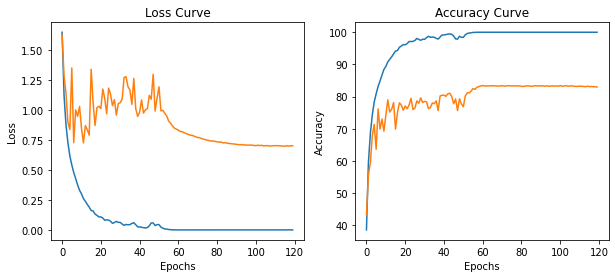

Final Training Accuracy: 100.0
Final Validation Accuracy: 82.99999998779298


In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_ColorJitter)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_ColorJitter)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

directory = "/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/WRN/WRNModel_Random_Erasing"

for i, (input, target) in enumerate(trainloader):
  print(input.size())
  break

main("WRN",'wide-resnet','train', directory, 120)

# Convergence

Files already downloaded and verified
Files already downloaded and verified


Number of parameters: 369498


torch.Size([512, 3, 32, 32])
Logging into /content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/WRN...


Number of parameters: 369498
Number of parameters: 369498
Number of parameters: 369498
Number of parameters: 369498
Number of parameters: 369498
Number of parameters: 369498
Number of parameters: 369498
Number of parameters: 369498


P: 0.2
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:184: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
000: Acc-tr:  31.59, Acc-val:  46.07, L-tr: 1.9450, L-val: 1.5298
000: Acc-tr:  31.59, Acc-val:  46.07, L-tr: 1.9450, L-val: 1.5298
000: Acc-tr:  31.59, Acc-val:  46.07, L-tr: 1.9450, L-val: 1.5298
000: Acc-tr:  31.59, Acc-val:  46.07, L-tr: 1.9450, L-val: 1.5298
000: Acc-tr:  31.59, Acc-val:  46.07, L-tr: 1.9450, L-val: 1.5298
000: Acc-tr:  31.59, Acc-val:  46.07, L-tr: 1.9450, L-val: 1.5298
000: Acc-tr:  31.59, Acc-val:  46.07, L-tr: 1.9450, L-val: 1.5298
000: Acc-tr:  31.59, Acc-val:  46.07, L-tr: 1.9450, L-val: 1.5298
000: Acc-tr:  31.59, Acc-val:  46.07, L-tr: 1.9450, L-val: 1.5298


Epoch 0 Finished.  Time per Epoch:  12.99 s 


001: Acc-tr:  45.28, Acc-val:  50.60, L-tr: 1.6718, L-val: 1.4201
001: Acc-tr:  45.28, Acc-val:  50.60, L-tr: 1.6718, L-val: 1.4201
001: Acc-tr:  45.28, Acc-val:  50.60, L-tr: 1.6718, L-val: 1.4201
001: Acc-tr:  45.28, Acc-val:  50.60, L-tr: 1.6718, L-val: 1.4201
001: Acc-tr:  45.28, Acc-val:  50.60, L-tr: 1.6718, L-val: 1.4201
001: Acc-tr:  45.28, Acc-val:  50.60, L-tr: 1.6718, L-val: 1.4201
001: Acc-tr:  45.28, Acc-val:  50.60, L-tr: 1.6718, L-val: 1.4201
001: Acc-tr:  45.28, Acc-val:  50.60, L-tr: 1.6718, L-val: 1.4201
001: Acc-tr:  45.28, Acc-val:  50.60, L-tr: 1.6718, L-val: 1.4201


Epoch 1 Finished.  Time per Epoch:  13.03 s 


002: Acc-tr:  52.17, Acc-val:  53.42, L-tr: 1.5399, L-val: 1.3374
002: Acc-tr:  52.17, Acc-val:  53.42, L-tr: 1.5399, L-val: 1.3374
002: Acc-tr:  52.17, Acc-val:  53.42, L-tr: 1.5399, L-val: 1.3374
002: Acc-tr:  52.17, Acc-val:  53.42, L-tr: 1.5399, L-val: 1.3374
002: Acc-tr:  52.17, Acc-val:  53.42, L-tr: 1.5399, L-val: 1.3374
002: Acc-tr:  52.17, Acc-val:  53.42, L-tr: 1.5399, L-val: 1.3374
002: Acc-tr:  52.17, Acc-val:  53.42, L-tr: 1.5399, L-val: 1.3374
002: Acc-tr:  52.17, Acc-val:  53.42, L-tr: 1.5399, L-val: 1.3374
002: Acc-tr:  52.17, Acc-val:  53.42, L-tr: 1.5399, L-val: 1.3374


Epoch 2 Finished.  Time per Epoch:  13.06 s 


003: Acc-tr:  56.17, Acc-val:  64.17, L-tr: 1.4505, L-val: 1.1116
003: Acc-tr:  56.17, Acc-val:  64.17, L-tr: 1.4505, L-val: 1.1116
003: Acc-tr:  56.17, Acc-val:  64.17, L-tr: 1.4505, L-val: 1.1116
003: Acc-tr:  56.17, Acc-val:  64.17, L-tr: 1.4505, L-val: 1.1116
003: Acc-tr:  56.17, Acc-val:  64.17, L-tr: 1.4505, L-val: 1.1116
003: Acc-tr:  56.17, Acc-val:  64.17, L-tr: 1.4505, L-val: 1.1116
003: Acc-tr:  56.17, Acc-val:  64.17, L-tr: 1.4505, L-val: 1.1116
003: Acc-tr:  56.17, Acc-val:  64.17, L-tr: 1.4505, L-val: 1.1116
003: Acc-tr:  56.17, Acc-val:  64.17, L-tr: 1.4505, L-val: 1.1116


Epoch 3 Finished.  Time per Epoch:  13.10 s 


004: Acc-tr:  59.53, Acc-val:  64.73, L-tr: 1.3736, L-val: 1.1278
004: Acc-tr:  59.53, Acc-val:  64.73, L-tr: 1.3736, L-val: 1.1278
004: Acc-tr:  59.53, Acc-val:  64.73, L-tr: 1.3736, L-val: 1.1278
004: Acc-tr:  59.53, Acc-val:  64.73, L-tr: 1.3736, L-val: 1.1278
004: Acc-tr:  59.53, Acc-val:  64.73, L-tr: 1.3736, L-val: 1.1278
004: Acc-tr:  59.53, Acc-val:  64.73, L-tr: 1.3736, L-val: 1.1278
004: Acc-tr:  59.53, Acc-val:  64.73, L-tr: 1.3736, L-val: 1.1278
004: Acc-tr:  59.53, Acc-val:  64.73, L-tr: 1.3736, L-val: 1.1278
004: Acc-tr:  59.53, Acc-val:  64.73, L-tr: 1.3736, L-val: 1.1278


Epoch 4 Finished.  Time per Epoch:  13.14 s 


005: Acc-tr:  62.04, Acc-val:  62.93, L-tr: 1.3189, L-val: 1.1469
005: Acc-tr:  62.04, Acc-val:  62.93, L-tr: 1.3189, L-val: 1.1469
005: Acc-tr:  62.04, Acc-val:  62.93, L-tr: 1.3189, L-val: 1.1469
005: Acc-tr:  62.04, Acc-val:  62.93, L-tr: 1.3189, L-val: 1.1469
005: Acc-tr:  62.04, Acc-val:  62.93, L-tr: 1.3189, L-val: 1.1469
005: Acc-tr:  62.04, Acc-val:  62.93, L-tr: 1.3189, L-val: 1.1469
005: Acc-tr:  62.04, Acc-val:  62.93, L-tr: 1.3189, L-val: 1.1469
005: Acc-tr:  62.04, Acc-val:  62.93, L-tr: 1.3189, L-val: 1.1469
005: Acc-tr:  62.04, Acc-val:  62.93, L-tr: 1.3189, L-val: 1.1469


Epoch 5 Finished.  Time per Epoch:  13.16 s 


006: Acc-tr:  64.33, Acc-val:  51.98, L-tr: 1.2570, L-val: 1.4247
006: Acc-tr:  64.33, Acc-val:  51.98, L-tr: 1.2570, L-val: 1.4247
006: Acc-tr:  64.33, Acc-val:  51.98, L-tr: 1.2570, L-val: 1.4247
006: Acc-tr:  64.33, Acc-val:  51.98, L-tr: 1.2570, L-val: 1.4247
006: Acc-tr:  64.33, Acc-val:  51.98, L-tr: 1.2570, L-val: 1.4247
006: Acc-tr:  64.33, Acc-val:  51.98, L-tr: 1.2570, L-val: 1.4247
006: Acc-tr:  64.33, Acc-val:  51.98, L-tr: 1.2570, L-val: 1.4247
006: Acc-tr:  64.33, Acc-val:  51.98, L-tr: 1.2570, L-val: 1.4247
006: Acc-tr:  64.33, Acc-val:  51.98, L-tr: 1.2570, L-val: 1.4247


Epoch 6 Finished.  Time per Epoch:  13.19 s 


007: Acc-tr:  66.04, Acc-val:  69.07, L-tr: 1.2112, L-val: 0.9629
007: Acc-tr:  66.04, Acc-val:  69.07, L-tr: 1.2112, L-val: 0.9629
007: Acc-tr:  66.04, Acc-val:  69.07, L-tr: 1.2112, L-val: 0.9629
007: Acc-tr:  66.04, Acc-val:  69.07, L-tr: 1.2112, L-val: 0.9629
007: Acc-tr:  66.04, Acc-val:  69.07, L-tr: 1.2112, L-val: 0.9629
007: Acc-tr:  66.04, Acc-val:  69.07, L-tr: 1.2112, L-val: 0.9629
007: Acc-tr:  66.04, Acc-val:  69.07, L-tr: 1.2112, L-val: 0.9629
007: Acc-tr:  66.04, Acc-val:  69.07, L-tr: 1.2112, L-val: 0.9629
007: Acc-tr:  66.04, Acc-val:  69.07, L-tr: 1.2112, L-val: 0.9629


Epoch 7 Finished.  Time per Epoch:  13.21 s 


008: Acc-tr:  67.16, Acc-val:  71.00, L-tr: 1.1729, L-val: 0.9271
008: Acc-tr:  67.16, Acc-val:  71.00, L-tr: 1.1729, L-val: 0.9271
008: Acc-tr:  67.16, Acc-val:  71.00, L-tr: 1.1729, L-val: 0.9271
008: Acc-tr:  67.16, Acc-val:  71.00, L-tr: 1.1729, L-val: 0.9271
008: Acc-tr:  67.16, Acc-val:  71.00, L-tr: 1.1729, L-val: 0.9271
008: Acc-tr:  67.16, Acc-val:  71.00, L-tr: 1.1729, L-val: 0.9271
008: Acc-tr:  67.16, Acc-val:  71.00, L-tr: 1.1729, L-val: 0.9271
008: Acc-tr:  67.16, Acc-val:  71.00, L-tr: 1.1729, L-val: 0.9271
008: Acc-tr:  67.16, Acc-val:  71.00, L-tr: 1.1729, L-val: 0.9271


Epoch 8 Finished.  Time per Epoch:  13.24 s 


009: Acc-tr:  68.67, Acc-val:  65.99, L-tr: 1.1301, L-val: 1.0716
009: Acc-tr:  68.67, Acc-val:  65.99, L-tr: 1.1301, L-val: 1.0716
009: Acc-tr:  68.67, Acc-val:  65.99, L-tr: 1.1301, L-val: 1.0716
009: Acc-tr:  68.67, Acc-val:  65.99, L-tr: 1.1301, L-val: 1.0716
009: Acc-tr:  68.67, Acc-val:  65.99, L-tr: 1.1301, L-val: 1.0716
009: Acc-tr:  68.67, Acc-val:  65.99, L-tr: 1.1301, L-val: 1.0716
009: Acc-tr:  68.67, Acc-val:  65.99, L-tr: 1.1301, L-val: 1.0716
009: Acc-tr:  68.67, Acc-val:  65.99, L-tr: 1.1301, L-val: 1.0716
009: Acc-tr:  68.67, Acc-val:  65.99, L-tr: 1.1301, L-val: 1.0716


Epoch 9 Finished.  Time per Epoch:  13.26 s 


010: Acc-tr:  69.79, Acc-val:  65.95, L-tr: 1.0923, L-val: 1.0573
010: Acc-tr:  69.79, Acc-val:  65.95, L-tr: 1.0923, L-val: 1.0573
010: Acc-tr:  69.79, Acc-val:  65.95, L-tr: 1.0923, L-val: 1.0573
010: Acc-tr:  69.79, Acc-val:  65.95, L-tr: 1.0923, L-val: 1.0573
010: Acc-tr:  69.79, Acc-val:  65.95, L-tr: 1.0923, L-val: 1.0573
010: Acc-tr:  69.79, Acc-val:  65.95, L-tr: 1.0923, L-val: 1.0573
010: Acc-tr:  69.79, Acc-val:  65.95, L-tr: 1.0923, L-val: 1.0573
010: Acc-tr:  69.79, Acc-val:  65.95, L-tr: 1.0923, L-val: 1.0573
010: Acc-tr:  69.79, Acc-val:  65.95, L-tr: 1.0923, L-val: 1.0573


Epoch 10 Finished.  Time per Epoch:  13.28 s 


011: Acc-tr:  70.76, Acc-val:  59.69, L-tr: 1.0514, L-val: 1.2813
011: Acc-tr:  70.76, Acc-val:  59.69, L-tr: 1.0514, L-val: 1.2813
011: Acc-tr:  70.76, Acc-val:  59.69, L-tr: 1.0514, L-val: 1.2813
011: Acc-tr:  70.76, Acc-val:  59.69, L-tr: 1.0514, L-val: 1.2813
011: Acc-tr:  70.76, Acc-val:  59.69, L-tr: 1.0514, L-val: 1.2813
011: Acc-tr:  70.76, Acc-val:  59.69, L-tr: 1.0514, L-val: 1.2813
011: Acc-tr:  70.76, Acc-val:  59.69, L-tr: 1.0514, L-val: 1.2813
011: Acc-tr:  70.76, Acc-val:  59.69, L-tr: 1.0514, L-val: 1.2813
011: Acc-tr:  70.76, Acc-val:  59.69, L-tr: 1.0514, L-val: 1.2813


Epoch 11 Finished.  Time per Epoch:  13.31 s 


012: Acc-tr:  71.56, Acc-val:  59.28, L-tr: 1.0205, L-val: 1.2945
012: Acc-tr:  71.56, Acc-val:  59.28, L-tr: 1.0205, L-val: 1.2945
012: Acc-tr:  71.56, Acc-val:  59.28, L-tr: 1.0205, L-val: 1.2945
012: Acc-tr:  71.56, Acc-val:  59.28, L-tr: 1.0205, L-val: 1.2945
012: Acc-tr:  71.56, Acc-val:  59.28, L-tr: 1.0205, L-val: 1.2945
012: Acc-tr:  71.56, Acc-val:  59.28, L-tr: 1.0205, L-val: 1.2945
012: Acc-tr:  71.56, Acc-val:  59.28, L-tr: 1.0205, L-val: 1.2945
012: Acc-tr:  71.56, Acc-val:  59.28, L-tr: 1.0205, L-val: 1.2945
012: Acc-tr:  71.56, Acc-val:  59.28, L-tr: 1.0205, L-val: 1.2945


Epoch 12 Finished.  Time per Epoch:  13.33 s 


013: Acc-tr:  72.79, Acc-val:  66.94, L-tr: 0.9812, L-val: 1.1009
013: Acc-tr:  72.79, Acc-val:  66.94, L-tr: 0.9812, L-val: 1.1009
013: Acc-tr:  72.79, Acc-val:  66.94, L-tr: 0.9812, L-val: 1.1009
013: Acc-tr:  72.79, Acc-val:  66.94, L-tr: 0.9812, L-val: 1.1009
013: Acc-tr:  72.79, Acc-val:  66.94, L-tr: 0.9812, L-val: 1.1009
013: Acc-tr:  72.79, Acc-val:  66.94, L-tr: 0.9812, L-val: 1.1009
013: Acc-tr:  72.79, Acc-val:  66.94, L-tr: 0.9812, L-val: 1.1009
013: Acc-tr:  72.79, Acc-val:  66.94, L-tr: 0.9812, L-val: 1.1009
013: Acc-tr:  72.79, Acc-val:  66.94, L-tr: 0.9812, L-val: 1.1009


Epoch 13 Finished.  Time per Epoch:  13.35 s 


014: Acc-tr:  73.51, Acc-val:  64.03, L-tr: 0.9436, L-val: 1.1750
014: Acc-tr:  73.51, Acc-val:  64.03, L-tr: 0.9436, L-val: 1.1750
014: Acc-tr:  73.51, Acc-val:  64.03, L-tr: 0.9436, L-val: 1.1750
014: Acc-tr:  73.51, Acc-val:  64.03, L-tr: 0.9436, L-val: 1.1750
014: Acc-tr:  73.51, Acc-val:  64.03, L-tr: 0.9436, L-val: 1.1750
014: Acc-tr:  73.51, Acc-val:  64.03, L-tr: 0.9436, L-val: 1.1750
014: Acc-tr:  73.51, Acc-val:  64.03, L-tr: 0.9436, L-val: 1.1750
014: Acc-tr:  73.51, Acc-val:  64.03, L-tr: 0.9436, L-val: 1.1750
014: Acc-tr:  73.51, Acc-val:  64.03, L-tr: 0.9436, L-val: 1.1750


Epoch 14 Finished.  Time per Epoch:  13.37 s 


015: Acc-tr:  74.78, Acc-val:  60.44, L-tr: 0.8997, L-val: 1.3087
015: Acc-tr:  74.78, Acc-val:  60.44, L-tr: 0.8997, L-val: 1.3087
015: Acc-tr:  74.78, Acc-val:  60.44, L-tr: 0.8997, L-val: 1.3087
015: Acc-tr:  74.78, Acc-val:  60.44, L-tr: 0.8997, L-val: 1.3087
015: Acc-tr:  74.78, Acc-val:  60.44, L-tr: 0.8997, L-val: 1.3087
015: Acc-tr:  74.78, Acc-val:  60.44, L-tr: 0.8997, L-val: 1.3087
015: Acc-tr:  74.78, Acc-val:  60.44, L-tr: 0.8997, L-val: 1.3087
015: Acc-tr:  74.78, Acc-val:  60.44, L-tr: 0.8997, L-val: 1.3087
015: Acc-tr:  74.78, Acc-val:  60.44, L-tr: 0.8997, L-val: 1.3087


Epoch 15 Finished.  Time per Epoch:  13.38 s 


016: Acc-tr:  75.54, Acc-val:  65.55, L-tr: 0.8677, L-val: 1.1673
016: Acc-tr:  75.54, Acc-val:  65.55, L-tr: 0.8677, L-val: 1.1673
016: Acc-tr:  75.54, Acc-val:  65.55, L-tr: 0.8677, L-val: 1.1673
016: Acc-tr:  75.54, Acc-val:  65.55, L-tr: 0.8677, L-val: 1.1673
016: Acc-tr:  75.54, Acc-val:  65.55, L-tr: 0.8677, L-val: 1.1673
016: Acc-tr:  75.54, Acc-val:  65.55, L-tr: 0.8677, L-val: 1.1673
016: Acc-tr:  75.54, Acc-val:  65.55, L-tr: 0.8677, L-val: 1.1673
016: Acc-tr:  75.54, Acc-val:  65.55, L-tr: 0.8677, L-val: 1.1673
016: Acc-tr:  75.54, Acc-val:  65.55, L-tr: 0.8677, L-val: 1.1673


Epoch 16 Finished.  Time per Epoch:  13.40 s 


017: Acc-tr:  76.28, Acc-val:  63.35, L-tr: 0.8400, L-val: 1.2176
017: Acc-tr:  76.28, Acc-val:  63.35, L-tr: 0.8400, L-val: 1.2176
017: Acc-tr:  76.28, Acc-val:  63.35, L-tr: 0.8400, L-val: 1.2176
017: Acc-tr:  76.28, Acc-val:  63.35, L-tr: 0.8400, L-val: 1.2176
017: Acc-tr:  76.28, Acc-val:  63.35, L-tr: 0.8400, L-val: 1.2176
017: Acc-tr:  76.28, Acc-val:  63.35, L-tr: 0.8400, L-val: 1.2176
017: Acc-tr:  76.28, Acc-val:  63.35, L-tr: 0.8400, L-val: 1.2176
017: Acc-tr:  76.28, Acc-val:  63.35, L-tr: 0.8400, L-val: 1.2176
017: Acc-tr:  76.28, Acc-val:  63.35, L-tr: 0.8400, L-val: 1.2176


Epoch 17 Finished.  Time per Epoch:  13.41 s 


018: Acc-tr:  77.11, Acc-val:  61.09, L-tr: 0.8023, L-val: 1.2867
018: Acc-tr:  77.11, Acc-val:  61.09, L-tr: 0.8023, L-val: 1.2867
018: Acc-tr:  77.11, Acc-val:  61.09, L-tr: 0.8023, L-val: 1.2867
018: Acc-tr:  77.11, Acc-val:  61.09, L-tr: 0.8023, L-val: 1.2867
018: Acc-tr:  77.11, Acc-val:  61.09, L-tr: 0.8023, L-val: 1.2867
018: Acc-tr:  77.11, Acc-val:  61.09, L-tr: 0.8023, L-val: 1.2867
018: Acc-tr:  77.11, Acc-val:  61.09, L-tr: 0.8023, L-val: 1.2867
018: Acc-tr:  77.11, Acc-val:  61.09, L-tr: 0.8023, L-val: 1.2867
018: Acc-tr:  77.11, Acc-val:  61.09, L-tr: 0.8023, L-val: 1.2867


Epoch 18 Finished.  Time per Epoch:  13.43 s 


019: Acc-tr:  78.12, Acc-val:  60.75, L-tr: 0.7643, L-val: 1.3580
019: Acc-tr:  78.12, Acc-val:  60.75, L-tr: 0.7643, L-val: 1.3580
019: Acc-tr:  78.12, Acc-val:  60.75, L-tr: 0.7643, L-val: 1.3580
019: Acc-tr:  78.12, Acc-val:  60.75, L-tr: 0.7643, L-val: 1.3580
019: Acc-tr:  78.12, Acc-val:  60.75, L-tr: 0.7643, L-val: 1.3580
019: Acc-tr:  78.12, Acc-val:  60.75, L-tr: 0.7643, L-val: 1.3580
019: Acc-tr:  78.12, Acc-val:  60.75, L-tr: 0.7643, L-val: 1.3580
019: Acc-tr:  78.12, Acc-val:  60.75, L-tr: 0.7643, L-val: 1.3580
019: Acc-tr:  78.12, Acc-val:  60.75, L-tr: 0.7643, L-val: 1.3580


Epoch 19 Finished.  Time per Epoch:  13.44 s 


020: Acc-tr:  78.57, Acc-val:  59.77, L-tr: 0.7424, L-val: 1.5119
020: Acc-tr:  78.57, Acc-val:  59.77, L-tr: 0.7424, L-val: 1.5119
020: Acc-tr:  78.57, Acc-val:  59.77, L-tr: 0.7424, L-val: 1.5119
020: Acc-tr:  78.57, Acc-val:  59.77, L-tr: 0.7424, L-val: 1.5119
020: Acc-tr:  78.57, Acc-val:  59.77, L-tr: 0.7424, L-val: 1.5119
020: Acc-tr:  78.57, Acc-val:  59.77, L-tr: 0.7424, L-val: 1.5119
020: Acc-tr:  78.57, Acc-val:  59.77, L-tr: 0.7424, L-val: 1.5119
020: Acc-tr:  78.57, Acc-val:  59.77, L-tr: 0.7424, L-val: 1.5119
020: Acc-tr:  78.57, Acc-val:  59.77, L-tr: 0.7424, L-val: 1.5119


Epoch 20 Finished.  Time per Epoch:  13.46 s 


021: Acc-tr:  79.13, Acc-val:  66.36, L-tr: 0.7146, L-val: 1.1857
021: Acc-tr:  79.13, Acc-val:  66.36, L-tr: 0.7146, L-val: 1.1857
021: Acc-tr:  79.13, Acc-val:  66.36, L-tr: 0.7146, L-val: 1.1857
021: Acc-tr:  79.13, Acc-val:  66.36, L-tr: 0.7146, L-val: 1.1857
021: Acc-tr:  79.13, Acc-val:  66.36, L-tr: 0.7146, L-val: 1.1857
021: Acc-tr:  79.13, Acc-val:  66.36, L-tr: 0.7146, L-val: 1.1857
021: Acc-tr:  79.13, Acc-val:  66.36, L-tr: 0.7146, L-val: 1.1857
021: Acc-tr:  79.13, Acc-val:  66.36, L-tr: 0.7146, L-val: 1.1857
021: Acc-tr:  79.13, Acc-val:  66.36, L-tr: 0.7146, L-val: 1.1857


Epoch 21 Finished.  Time per Epoch:  13.47 s 


022: Acc-tr:  80.44, Acc-val:  54.55, L-tr: 0.6767, L-val: 1.7442
022: Acc-tr:  80.44, Acc-val:  54.55, L-tr: 0.6767, L-val: 1.7442
022: Acc-tr:  80.44, Acc-val:  54.55, L-tr: 0.6767, L-val: 1.7442
022: Acc-tr:  80.44, Acc-val:  54.55, L-tr: 0.6767, L-val: 1.7442
022: Acc-tr:  80.44, Acc-val:  54.55, L-tr: 0.6767, L-val: 1.7442
022: Acc-tr:  80.44, Acc-val:  54.55, L-tr: 0.6767, L-val: 1.7442
022: Acc-tr:  80.44, Acc-val:  54.55, L-tr: 0.6767, L-val: 1.7442
022: Acc-tr:  80.44, Acc-val:  54.55, L-tr: 0.6767, L-val: 1.7442
022: Acc-tr:  80.44, Acc-val:  54.55, L-tr: 0.6767, L-val: 1.7442


Epoch 22 Finished.  Time per Epoch:  13.49 s 


023: Acc-tr:  80.56, Acc-val:  62.36, L-tr: 0.6528, L-val: 1.3973
023: Acc-tr:  80.56, Acc-val:  62.36, L-tr: 0.6528, L-val: 1.3973
023: Acc-tr:  80.56, Acc-val:  62.36, L-tr: 0.6528, L-val: 1.3973
023: Acc-tr:  80.56, Acc-val:  62.36, L-tr: 0.6528, L-val: 1.3973
023: Acc-tr:  80.56, Acc-val:  62.36, L-tr: 0.6528, L-val: 1.3973
023: Acc-tr:  80.56, Acc-val:  62.36, L-tr: 0.6528, L-val: 1.3973
023: Acc-tr:  80.56, Acc-val:  62.36, L-tr: 0.6528, L-val: 1.3973
023: Acc-tr:  80.56, Acc-val:  62.36, L-tr: 0.6528, L-val: 1.3973
023: Acc-tr:  80.56, Acc-val:  62.36, L-tr: 0.6528, L-val: 1.3973


Epoch 23 Finished.  Time per Epoch:  13.50 s 


024: Acc-tr:  81.40, Acc-val:  48.42, L-tr: 0.6235, L-val: 2.1015
024: Acc-tr:  81.40, Acc-val:  48.42, L-tr: 0.6235, L-val: 2.1015
024: Acc-tr:  81.40, Acc-val:  48.42, L-tr: 0.6235, L-val: 2.1015
024: Acc-tr:  81.40, Acc-val:  48.42, L-tr: 0.6235, L-val: 2.1015
024: Acc-tr:  81.40, Acc-val:  48.42, L-tr: 0.6235, L-val: 2.1015
024: Acc-tr:  81.40, Acc-val:  48.42, L-tr: 0.6235, L-val: 2.1015
024: Acc-tr:  81.40, Acc-val:  48.42, L-tr: 0.6235, L-val: 2.1015
024: Acc-tr:  81.40, Acc-val:  48.42, L-tr: 0.6235, L-val: 2.1015
024: Acc-tr:  81.40, Acc-val:  48.42, L-tr: 0.6235, L-val: 2.1015


Epoch 24 Finished.  Time per Epoch:  13.51 s 


025: Acc-tr:  82.26, Acc-val:  54.84, L-tr: 0.5951, L-val: 1.7695
025: Acc-tr:  82.26, Acc-val:  54.84, L-tr: 0.5951, L-val: 1.7695
025: Acc-tr:  82.26, Acc-val:  54.84, L-tr: 0.5951, L-val: 1.7695
025: Acc-tr:  82.26, Acc-val:  54.84, L-tr: 0.5951, L-val: 1.7695
025: Acc-tr:  82.26, Acc-val:  54.84, L-tr: 0.5951, L-val: 1.7695
025: Acc-tr:  82.26, Acc-val:  54.84, L-tr: 0.5951, L-val: 1.7695
025: Acc-tr:  82.26, Acc-val:  54.84, L-tr: 0.5951, L-val: 1.7695
025: Acc-tr:  82.26, Acc-val:  54.84, L-tr: 0.5951, L-val: 1.7695
025: Acc-tr:  82.26, Acc-val:  54.84, L-tr: 0.5951, L-val: 1.7695


Epoch 25 Finished.  Time per Epoch:  13.52 s 


026: Acc-tr:  82.78, Acc-val:  57.46, L-tr: 0.5726, L-val: 1.6309
026: Acc-tr:  82.78, Acc-val:  57.46, L-tr: 0.5726, L-val: 1.6309
026: Acc-tr:  82.78, Acc-val:  57.46, L-tr: 0.5726, L-val: 1.6309
026: Acc-tr:  82.78, Acc-val:  57.46, L-tr: 0.5726, L-val: 1.6309
026: Acc-tr:  82.78, Acc-val:  57.46, L-tr: 0.5726, L-val: 1.6309
026: Acc-tr:  82.78, Acc-val:  57.46, L-tr: 0.5726, L-val: 1.6309
026: Acc-tr:  82.78, Acc-val:  57.46, L-tr: 0.5726, L-val: 1.6309
026: Acc-tr:  82.78, Acc-val:  57.46, L-tr: 0.5726, L-val: 1.6309
026: Acc-tr:  82.78, Acc-val:  57.46, L-tr: 0.5726, L-val: 1.6309


Epoch 26 Finished.  Time per Epoch:  13.53 s 


027: Acc-tr:  83.50, Acc-val:  57.30, L-tr: 0.5471, L-val: 1.7513
027: Acc-tr:  83.50, Acc-val:  57.30, L-tr: 0.5471, L-val: 1.7513
027: Acc-tr:  83.50, Acc-val:  57.30, L-tr: 0.5471, L-val: 1.7513
027: Acc-tr:  83.50, Acc-val:  57.30, L-tr: 0.5471, L-val: 1.7513
027: Acc-tr:  83.50, Acc-val:  57.30, L-tr: 0.5471, L-val: 1.7513
027: Acc-tr:  83.50, Acc-val:  57.30, L-tr: 0.5471, L-val: 1.7513
027: Acc-tr:  83.50, Acc-val:  57.30, L-tr: 0.5471, L-val: 1.7513
027: Acc-tr:  83.50, Acc-val:  57.30, L-tr: 0.5471, L-val: 1.7513
027: Acc-tr:  83.50, Acc-val:  57.30, L-tr: 0.5471, L-val: 1.7513


Epoch 27 Finished.  Time per Epoch:  13.54 s 


028: Acc-tr:  84.18, Acc-val:  61.45, L-tr: 0.5202, L-val: 1.6057
028: Acc-tr:  84.18, Acc-val:  61.45, L-tr: 0.5202, L-val: 1.6057
028: Acc-tr:  84.18, Acc-val:  61.45, L-tr: 0.5202, L-val: 1.6057
028: Acc-tr:  84.18, Acc-val:  61.45, L-tr: 0.5202, L-val: 1.6057
028: Acc-tr:  84.18, Acc-val:  61.45, L-tr: 0.5202, L-val: 1.6057
028: Acc-tr:  84.18, Acc-val:  61.45, L-tr: 0.5202, L-val: 1.6057
028: Acc-tr:  84.18, Acc-val:  61.45, L-tr: 0.5202, L-val: 1.6057
028: Acc-tr:  84.18, Acc-val:  61.45, L-tr: 0.5202, L-val: 1.6057
028: Acc-tr:  84.18, Acc-val:  61.45, L-tr: 0.5202, L-val: 1.6057


Epoch 28 Finished.  Time per Epoch:  13.55 s 


029: Acc-tr:  84.73, Acc-val:  56.83, L-tr: 0.4975, L-val: 1.8703
029: Acc-tr:  84.73, Acc-val:  56.83, L-tr: 0.4975, L-val: 1.8703
029: Acc-tr:  84.73, Acc-val:  56.83, L-tr: 0.4975, L-val: 1.8703
029: Acc-tr:  84.73, Acc-val:  56.83, L-tr: 0.4975, L-val: 1.8703
029: Acc-tr:  84.73, Acc-val:  56.83, L-tr: 0.4975, L-val: 1.8703
029: Acc-tr:  84.73, Acc-val:  56.83, L-tr: 0.4975, L-val: 1.8703
029: Acc-tr:  84.73, Acc-val:  56.83, L-tr: 0.4975, L-val: 1.8703
029: Acc-tr:  84.73, Acc-val:  56.83, L-tr: 0.4975, L-val: 1.8703
029: Acc-tr:  84.73, Acc-val:  56.83, L-tr: 0.4975, L-val: 1.8703


Epoch 29 Finished.  Time per Epoch:  13.56 s 


030: Acc-tr:  84.88, Acc-val:  50.09, L-tr: 0.4882, L-val: 2.7007
030: Acc-tr:  84.88, Acc-val:  50.09, L-tr: 0.4882, L-val: 2.7007
030: Acc-tr:  84.88, Acc-val:  50.09, L-tr: 0.4882, L-val: 2.7007
030: Acc-tr:  84.88, Acc-val:  50.09, L-tr: 0.4882, L-val: 2.7007
030: Acc-tr:  84.88, Acc-val:  50.09, L-tr: 0.4882, L-val: 2.7007
030: Acc-tr:  84.88, Acc-val:  50.09, L-tr: 0.4882, L-val: 2.7007
030: Acc-tr:  84.88, Acc-val:  50.09, L-tr: 0.4882, L-val: 2.7007
030: Acc-tr:  84.88, Acc-val:  50.09, L-tr: 0.4882, L-val: 2.7007
030: Acc-tr:  84.88, Acc-val:  50.09, L-tr: 0.4882, L-val: 2.7007


Epoch 30 Finished.  Time per Epoch:  13.57 s 


031: Acc-tr:  85.71, Acc-val:  58.61, L-tr: 0.4607, L-val: 1.7134
031: Acc-tr:  85.71, Acc-val:  58.61, L-tr: 0.4607, L-val: 1.7134
031: Acc-tr:  85.71, Acc-val:  58.61, L-tr: 0.4607, L-val: 1.7134
031: Acc-tr:  85.71, Acc-val:  58.61, L-tr: 0.4607, L-val: 1.7134
031: Acc-tr:  85.71, Acc-val:  58.61, L-tr: 0.4607, L-val: 1.7134
031: Acc-tr:  85.71, Acc-val:  58.61, L-tr: 0.4607, L-val: 1.7134
031: Acc-tr:  85.71, Acc-val:  58.61, L-tr: 0.4607, L-val: 1.7134
031: Acc-tr:  85.71, Acc-val:  58.61, L-tr: 0.4607, L-val: 1.7134
031: Acc-tr:  85.71, Acc-val:  58.61, L-tr: 0.4607, L-val: 1.7134


Epoch 31 Finished.  Time per Epoch:  13.58 s 


032: Acc-tr:  86.07, Acc-val:  60.28, L-tr: 0.4356, L-val: 1.7230
032: Acc-tr:  86.07, Acc-val:  60.28, L-tr: 0.4356, L-val: 1.7230
032: Acc-tr:  86.07, Acc-val:  60.28, L-tr: 0.4356, L-val: 1.7230
032: Acc-tr:  86.07, Acc-val:  60.28, L-tr: 0.4356, L-val: 1.7230
032: Acc-tr:  86.07, Acc-val:  60.28, L-tr: 0.4356, L-val: 1.7230
032: Acc-tr:  86.07, Acc-val:  60.28, L-tr: 0.4356, L-val: 1.7230
032: Acc-tr:  86.07, Acc-val:  60.28, L-tr: 0.4356, L-val: 1.7230
032: Acc-tr:  86.07, Acc-val:  60.28, L-tr: 0.4356, L-val: 1.7230
032: Acc-tr:  86.07, Acc-val:  60.28, L-tr: 0.4356, L-val: 1.7230


Epoch 32 Finished.  Time per Epoch:  13.59 s 


033: Acc-tr:  86.55, Acc-val:  56.26, L-tr: 0.4256, L-val: 1.9252
033: Acc-tr:  86.55, Acc-val:  56.26, L-tr: 0.4256, L-val: 1.9252
033: Acc-tr:  86.55, Acc-val:  56.26, L-tr: 0.4256, L-val: 1.9252
033: Acc-tr:  86.55, Acc-val:  56.26, L-tr: 0.4256, L-val: 1.9252
033: Acc-tr:  86.55, Acc-val:  56.26, L-tr: 0.4256, L-val: 1.9252
033: Acc-tr:  86.55, Acc-val:  56.26, L-tr: 0.4256, L-val: 1.9252
033: Acc-tr:  86.55, Acc-val:  56.26, L-tr: 0.4256, L-val: 1.9252
033: Acc-tr:  86.55, Acc-val:  56.26, L-tr: 0.4256, L-val: 1.9252
033: Acc-tr:  86.55, Acc-val:  56.26, L-tr: 0.4256, L-val: 1.9252


Epoch 33 Finished.  Time per Epoch:  13.60 s 


034: Acc-tr:  86.95, Acc-val:  58.44, L-tr: 0.4151, L-val: 1.8273
034: Acc-tr:  86.95, Acc-val:  58.44, L-tr: 0.4151, L-val: 1.8273
034: Acc-tr:  86.95, Acc-val:  58.44, L-tr: 0.4151, L-val: 1.8273
034: Acc-tr:  86.95, Acc-val:  58.44, L-tr: 0.4151, L-val: 1.8273
034: Acc-tr:  86.95, Acc-val:  58.44, L-tr: 0.4151, L-val: 1.8273
034: Acc-tr:  86.95, Acc-val:  58.44, L-tr: 0.4151, L-val: 1.8273
034: Acc-tr:  86.95, Acc-val:  58.44, L-tr: 0.4151, L-val: 1.8273
034: Acc-tr:  86.95, Acc-val:  58.44, L-tr: 0.4151, L-val: 1.8273
034: Acc-tr:  86.95, Acc-val:  58.44, L-tr: 0.4151, L-val: 1.8273


Epoch 34 Finished.  Time per Epoch:  13.61 s 


035: Acc-tr:  88.27, Acc-val:  56.71, L-tr: 0.3688, L-val: 1.8017
035: Acc-tr:  88.27, Acc-val:  56.71, L-tr: 0.3688, L-val: 1.8017
035: Acc-tr:  88.27, Acc-val:  56.71, L-tr: 0.3688, L-val: 1.8017
035: Acc-tr:  88.27, Acc-val:  56.71, L-tr: 0.3688, L-val: 1.8017
035: Acc-tr:  88.27, Acc-val:  56.71, L-tr: 0.3688, L-val: 1.8017
035: Acc-tr:  88.27, Acc-val:  56.71, L-tr: 0.3688, L-val: 1.8017
035: Acc-tr:  88.27, Acc-val:  56.71, L-tr: 0.3688, L-val: 1.8017
035: Acc-tr:  88.27, Acc-val:  56.71, L-tr: 0.3688, L-val: 1.8017
035: Acc-tr:  88.27, Acc-val:  56.71, L-tr: 0.3688, L-val: 1.8017


Epoch 35 Finished.  Time per Epoch:  13.61 s 


036: Acc-tr:  88.31, Acc-val:  58.87, L-tr: 0.3652, L-val: 1.8327
036: Acc-tr:  88.31, Acc-val:  58.87, L-tr: 0.3652, L-val: 1.8327
036: Acc-tr:  88.31, Acc-val:  58.87, L-tr: 0.3652, L-val: 1.8327
036: Acc-tr:  88.31, Acc-val:  58.87, L-tr: 0.3652, L-val: 1.8327
036: Acc-tr:  88.31, Acc-val:  58.87, L-tr: 0.3652, L-val: 1.8327
036: Acc-tr:  88.31, Acc-val:  58.87, L-tr: 0.3652, L-val: 1.8327
036: Acc-tr:  88.31, Acc-val:  58.87, L-tr: 0.3652, L-val: 1.8327
036: Acc-tr:  88.31, Acc-val:  58.87, L-tr: 0.3652, L-val: 1.8327
036: Acc-tr:  88.31, Acc-val:  58.87, L-tr: 0.3652, L-val: 1.8327


Epoch 36 Finished.  Time per Epoch:  13.62 s 


037: Acc-tr:  88.26, Acc-val:  50.84, L-tr: 0.3648, L-val: 2.2812
037: Acc-tr:  88.26, Acc-val:  50.84, L-tr: 0.3648, L-val: 2.2812
037: Acc-tr:  88.26, Acc-val:  50.84, L-tr: 0.3648, L-val: 2.2812
037: Acc-tr:  88.26, Acc-val:  50.84, L-tr: 0.3648, L-val: 2.2812
037: Acc-tr:  88.26, Acc-val:  50.84, L-tr: 0.3648, L-val: 2.2812
037: Acc-tr:  88.26, Acc-val:  50.84, L-tr: 0.3648, L-val: 2.2812
037: Acc-tr:  88.26, Acc-val:  50.84, L-tr: 0.3648, L-val: 2.2812
037: Acc-tr:  88.26, Acc-val:  50.84, L-tr: 0.3648, L-val: 2.2812
037: Acc-tr:  88.26, Acc-val:  50.84, L-tr: 0.3648, L-val: 2.2812


Epoch 37 Finished.  Time per Epoch:  13.62 s 


038: Acc-tr:  88.94, Acc-val:  59.13, L-tr: 0.3428, L-val: 1.8835
038: Acc-tr:  88.94, Acc-val:  59.13, L-tr: 0.3428, L-val: 1.8835
038: Acc-tr:  88.94, Acc-val:  59.13, L-tr: 0.3428, L-val: 1.8835
038: Acc-tr:  88.94, Acc-val:  59.13, L-tr: 0.3428, L-val: 1.8835
038: Acc-tr:  88.94, Acc-val:  59.13, L-tr: 0.3428, L-val: 1.8835
038: Acc-tr:  88.94, Acc-val:  59.13, L-tr: 0.3428, L-val: 1.8835
038: Acc-tr:  88.94, Acc-val:  59.13, L-tr: 0.3428, L-val: 1.8835
038: Acc-tr:  88.94, Acc-val:  59.13, L-tr: 0.3428, L-val: 1.8835
038: Acc-tr:  88.94, Acc-val:  59.13, L-tr: 0.3428, L-val: 1.8835


Epoch 38 Finished.  Time per Epoch:  13.63 s 


039: Acc-tr:  88.55, Acc-val:  55.62, L-tr: 0.3515, L-val: 2.0653
039: Acc-tr:  88.55, Acc-val:  55.62, L-tr: 0.3515, L-val: 2.0653
039: Acc-tr:  88.55, Acc-val:  55.62, L-tr: 0.3515, L-val: 2.0653
039: Acc-tr:  88.55, Acc-val:  55.62, L-tr: 0.3515, L-val: 2.0653
039: Acc-tr:  88.55, Acc-val:  55.62, L-tr: 0.3515, L-val: 2.0653
039: Acc-tr:  88.55, Acc-val:  55.62, L-tr: 0.3515, L-val: 2.0653
039: Acc-tr:  88.55, Acc-val:  55.62, L-tr: 0.3515, L-val: 2.0653
039: Acc-tr:  88.55, Acc-val:  55.62, L-tr: 0.3515, L-val: 2.0653
039: Acc-tr:  88.55, Acc-val:  55.62, L-tr: 0.3515, L-val: 2.0653


Epoch 39 Finished.  Time per Epoch:  13.63 s 


040: Acc-tr:  89.90, Acc-val:  54.08, L-tr: 0.3079, L-val: 2.4802
040: Acc-tr:  89.90, Acc-val:  54.08, L-tr: 0.3079, L-val: 2.4802
040: Acc-tr:  89.90, Acc-val:  54.08, L-tr: 0.3079, L-val: 2.4802
040: Acc-tr:  89.90, Acc-val:  54.08, L-tr: 0.3079, L-val: 2.4802
040: Acc-tr:  89.90, Acc-val:  54.08, L-tr: 0.3079, L-val: 2.4802
040: Acc-tr:  89.90, Acc-val:  54.08, L-tr: 0.3079, L-val: 2.4802
040: Acc-tr:  89.90, Acc-val:  54.08, L-tr: 0.3079, L-val: 2.4802
040: Acc-tr:  89.90, Acc-val:  54.08, L-tr: 0.3079, L-val: 2.4802
040: Acc-tr:  89.90, Acc-val:  54.08, L-tr: 0.3079, L-val: 2.4802


Epoch 40 Finished.  Time per Epoch:  13.64 s 


041: Acc-tr:  90.48, Acc-val:  57.98, L-tr: 0.2924, L-val: 1.9931
041: Acc-tr:  90.48, Acc-val:  57.98, L-tr: 0.2924, L-val: 1.9931
041: Acc-tr:  90.48, Acc-val:  57.98, L-tr: 0.2924, L-val: 1.9931
041: Acc-tr:  90.48, Acc-val:  57.98, L-tr: 0.2924, L-val: 1.9931
041: Acc-tr:  90.48, Acc-val:  57.98, L-tr: 0.2924, L-val: 1.9931
041: Acc-tr:  90.48, Acc-val:  57.98, L-tr: 0.2924, L-val: 1.9931
041: Acc-tr:  90.48, Acc-val:  57.98, L-tr: 0.2924, L-val: 1.9931
041: Acc-tr:  90.48, Acc-val:  57.98, L-tr: 0.2924, L-val: 1.9931
041: Acc-tr:  90.48, Acc-val:  57.98, L-tr: 0.2924, L-val: 1.9931


Epoch 41 Finished.  Time per Epoch:  13.64 s 


042: Acc-tr:  90.06, Acc-val:  57.07, L-tr: 0.3018, L-val: 2.0083
042: Acc-tr:  90.06, Acc-val:  57.07, L-tr: 0.3018, L-val: 2.0083
042: Acc-tr:  90.06, Acc-val:  57.07, L-tr: 0.3018, L-val: 2.0083
042: Acc-tr:  90.06, Acc-val:  57.07, L-tr: 0.3018, L-val: 2.0083
042: Acc-tr:  90.06, Acc-val:  57.07, L-tr: 0.3018, L-val: 2.0083
042: Acc-tr:  90.06, Acc-val:  57.07, L-tr: 0.3018, L-val: 2.0083
042: Acc-tr:  90.06, Acc-val:  57.07, L-tr: 0.3018, L-val: 2.0083
042: Acc-tr:  90.06, Acc-val:  57.07, L-tr: 0.3018, L-val: 2.0083
042: Acc-tr:  90.06, Acc-val:  57.07, L-tr: 0.3018, L-val: 2.0083


Epoch 42 Finished.  Time per Epoch:  13.65 s 


043: Acc-tr:  90.75, Acc-val:  58.26, L-tr: 0.2796, L-val: 2.0325
043: Acc-tr:  90.75, Acc-val:  58.26, L-tr: 0.2796, L-val: 2.0325
043: Acc-tr:  90.75, Acc-val:  58.26, L-tr: 0.2796, L-val: 2.0325
043: Acc-tr:  90.75, Acc-val:  58.26, L-tr: 0.2796, L-val: 2.0325
043: Acc-tr:  90.75, Acc-val:  58.26, L-tr: 0.2796, L-val: 2.0325
043: Acc-tr:  90.75, Acc-val:  58.26, L-tr: 0.2796, L-val: 2.0325
043: Acc-tr:  90.75, Acc-val:  58.26, L-tr: 0.2796, L-val: 2.0325
043: Acc-tr:  90.75, Acc-val:  58.26, L-tr: 0.2796, L-val: 2.0325
043: Acc-tr:  90.75, Acc-val:  58.26, L-tr: 0.2796, L-val: 2.0325


Epoch 43 Finished.  Time per Epoch:  13.65 s 


044: Acc-tr:  90.82, Acc-val:  55.97, L-tr: 0.2769, L-val: 2.4824
044: Acc-tr:  90.82, Acc-val:  55.97, L-tr: 0.2769, L-val: 2.4824
044: Acc-tr:  90.82, Acc-val:  55.97, L-tr: 0.2769, L-val: 2.4824
044: Acc-tr:  90.82, Acc-val:  55.97, L-tr: 0.2769, L-val: 2.4824
044: Acc-tr:  90.82, Acc-val:  55.97, L-tr: 0.2769, L-val: 2.4824
044: Acc-tr:  90.82, Acc-val:  55.97, L-tr: 0.2769, L-val: 2.4824
044: Acc-tr:  90.82, Acc-val:  55.97, L-tr: 0.2769, L-val: 2.4824
044: Acc-tr:  90.82, Acc-val:  55.97, L-tr: 0.2769, L-val: 2.4824
044: Acc-tr:  90.82, Acc-val:  55.97, L-tr: 0.2769, L-val: 2.4824


Epoch 44 Finished.  Time per Epoch:  13.66 s 


045: Acc-tr:  91.30, Acc-val:  49.22, L-tr: 0.2610, L-val: 2.8959
045: Acc-tr:  91.30, Acc-val:  49.22, L-tr: 0.2610, L-val: 2.8959
045: Acc-tr:  91.30, Acc-val:  49.22, L-tr: 0.2610, L-val: 2.8959
045: Acc-tr:  91.30, Acc-val:  49.22, L-tr: 0.2610, L-val: 2.8959
045: Acc-tr:  91.30, Acc-val:  49.22, L-tr: 0.2610, L-val: 2.8959
045: Acc-tr:  91.30, Acc-val:  49.22, L-tr: 0.2610, L-val: 2.8959
045: Acc-tr:  91.30, Acc-val:  49.22, L-tr: 0.2610, L-val: 2.8959
045: Acc-tr:  91.30, Acc-val:  49.22, L-tr: 0.2610, L-val: 2.8959
045: Acc-tr:  91.30, Acc-val:  49.22, L-tr: 0.2610, L-val: 2.8959


Epoch 45 Finished.  Time per Epoch:  13.66 s 


046: Acc-tr:  91.24, Acc-val:  52.16, L-tr: 0.2610, L-val: 2.9438
046: Acc-tr:  91.24, Acc-val:  52.16, L-tr: 0.2610, L-val: 2.9438
046: Acc-tr:  91.24, Acc-val:  52.16, L-tr: 0.2610, L-val: 2.9438
046: Acc-tr:  91.24, Acc-val:  52.16, L-tr: 0.2610, L-val: 2.9438
046: Acc-tr:  91.24, Acc-val:  52.16, L-tr: 0.2610, L-val: 2.9438
046: Acc-tr:  91.24, Acc-val:  52.16, L-tr: 0.2610, L-val: 2.9438
046: Acc-tr:  91.24, Acc-val:  52.16, L-tr: 0.2610, L-val: 2.9438
046: Acc-tr:  91.24, Acc-val:  52.16, L-tr: 0.2610, L-val: 2.9438
046: Acc-tr:  91.24, Acc-val:  52.16, L-tr: 0.2610, L-val: 2.9438


Epoch 46 Finished.  Time per Epoch:  13.67 s 


047: Acc-tr:  91.54, Acc-val:  59.02, L-tr: 0.2579, L-val: 1.9943
047: Acc-tr:  91.54, Acc-val:  59.02, L-tr: 0.2579, L-val: 1.9943
047: Acc-tr:  91.54, Acc-val:  59.02, L-tr: 0.2579, L-val: 1.9943
047: Acc-tr:  91.54, Acc-val:  59.02, L-tr: 0.2579, L-val: 1.9943
047: Acc-tr:  91.54, Acc-val:  59.02, L-tr: 0.2579, L-val: 1.9943
047: Acc-tr:  91.54, Acc-val:  59.02, L-tr: 0.2579, L-val: 1.9943
047: Acc-tr:  91.54, Acc-val:  59.02, L-tr: 0.2579, L-val: 1.9943
047: Acc-tr:  91.54, Acc-val:  59.02, L-tr: 0.2579, L-val: 1.9943
047: Acc-tr:  91.54, Acc-val:  59.02, L-tr: 0.2579, L-val: 1.9943


Epoch 47 Finished.  Time per Epoch:  13.67 s 


048: Acc-tr:  92.69, Acc-val:  57.19, L-tr: 0.2197, L-val: 2.2409
048: Acc-tr:  92.69, Acc-val:  57.19, L-tr: 0.2197, L-val: 2.2409
048: Acc-tr:  92.69, Acc-val:  57.19, L-tr: 0.2197, L-val: 2.2409
048: Acc-tr:  92.69, Acc-val:  57.19, L-tr: 0.2197, L-val: 2.2409
048: Acc-tr:  92.69, Acc-val:  57.19, L-tr: 0.2197, L-val: 2.2409
048: Acc-tr:  92.69, Acc-val:  57.19, L-tr: 0.2197, L-val: 2.2409
048: Acc-tr:  92.69, Acc-val:  57.19, L-tr: 0.2197, L-val: 2.2409
048: Acc-tr:  92.69, Acc-val:  57.19, L-tr: 0.2197, L-val: 2.2409
048: Acc-tr:  92.69, Acc-val:  57.19, L-tr: 0.2197, L-val: 2.2409


Epoch 48 Finished.  Time per Epoch:  13.67 s 


049: Acc-tr:  92.79, Acc-val:  55.73, L-tr: 0.2189, L-val: 2.5440
049: Acc-tr:  92.79, Acc-val:  55.73, L-tr: 0.2189, L-val: 2.5440
049: Acc-tr:  92.79, Acc-val:  55.73, L-tr: 0.2189, L-val: 2.5440
049: Acc-tr:  92.79, Acc-val:  55.73, L-tr: 0.2189, L-val: 2.5440
049: Acc-tr:  92.79, Acc-val:  55.73, L-tr: 0.2189, L-val: 2.5440
049: Acc-tr:  92.79, Acc-val:  55.73, L-tr: 0.2189, L-val: 2.5440
049: Acc-tr:  92.79, Acc-val:  55.73, L-tr: 0.2189, L-val: 2.5440
049: Acc-tr:  92.79, Acc-val:  55.73, L-tr: 0.2189, L-val: 2.5440
049: Acc-tr:  92.79, Acc-val:  55.73, L-tr: 0.2189, L-val: 2.5440


Epoch 49 Finished.  Time per Epoch:  13.68 s 


050: Acc-tr:  92.44, Acc-val:  51.41, L-tr: 0.2270, L-val: 2.7053
050: Acc-tr:  92.44, Acc-val:  51.41, L-tr: 0.2270, L-val: 2.7053
050: Acc-tr:  92.44, Acc-val:  51.41, L-tr: 0.2270, L-val: 2.7053
050: Acc-tr:  92.44, Acc-val:  51.41, L-tr: 0.2270, L-val: 2.7053
050: Acc-tr:  92.44, Acc-val:  51.41, L-tr: 0.2270, L-val: 2.7053
050: Acc-tr:  92.44, Acc-val:  51.41, L-tr: 0.2270, L-val: 2.7053
050: Acc-tr:  92.44, Acc-val:  51.41, L-tr: 0.2270, L-val: 2.7053
050: Acc-tr:  92.44, Acc-val:  51.41, L-tr: 0.2270, L-val: 2.7053
050: Acc-tr:  92.44, Acc-val:  51.41, L-tr: 0.2270, L-val: 2.7053


Epoch 50 Finished.  Time per Epoch:  13.68 s 


051: Acc-tr:  92.92, Acc-val:  55.21, L-tr: 0.2152, L-val: 2.2804
051: Acc-tr:  92.92, Acc-val:  55.21, L-tr: 0.2152, L-val: 2.2804
051: Acc-tr:  92.92, Acc-val:  55.21, L-tr: 0.2152, L-val: 2.2804
051: Acc-tr:  92.92, Acc-val:  55.21, L-tr: 0.2152, L-val: 2.2804
051: Acc-tr:  92.92, Acc-val:  55.21, L-tr: 0.2152, L-val: 2.2804
051: Acc-tr:  92.92, Acc-val:  55.21, L-tr: 0.2152, L-val: 2.2804
051: Acc-tr:  92.92, Acc-val:  55.21, L-tr: 0.2152, L-val: 2.2804
051: Acc-tr:  92.92, Acc-val:  55.21, L-tr: 0.2152, L-val: 2.2804
051: Acc-tr:  92.92, Acc-val:  55.21, L-tr: 0.2152, L-val: 2.2804


Epoch 51 Finished.  Time per Epoch:  13.69 s 


052: Acc-tr:  93.58, Acc-val:  60.09, L-tr: 0.1934, L-val: 1.9440
052: Acc-tr:  93.58, Acc-val:  60.09, L-tr: 0.1934, L-val: 1.9440
052: Acc-tr:  93.58, Acc-val:  60.09, L-tr: 0.1934, L-val: 1.9440
052: Acc-tr:  93.58, Acc-val:  60.09, L-tr: 0.1934, L-val: 1.9440
052: Acc-tr:  93.58, Acc-val:  60.09, L-tr: 0.1934, L-val: 1.9440
052: Acc-tr:  93.58, Acc-val:  60.09, L-tr: 0.1934, L-val: 1.9440
052: Acc-tr:  93.58, Acc-val:  60.09, L-tr: 0.1934, L-val: 1.9440
052: Acc-tr:  93.58, Acc-val:  60.09, L-tr: 0.1934, L-val: 1.9440
052: Acc-tr:  93.58, Acc-val:  60.09, L-tr: 0.1934, L-val: 1.9440


Epoch 52 Finished.  Time per Epoch:  13.69 s 


053: Acc-tr:  93.59, Acc-val:  52.86, L-tr: 0.1937, L-val: 2.3645
053: Acc-tr:  93.59, Acc-val:  52.86, L-tr: 0.1937, L-val: 2.3645
053: Acc-tr:  93.59, Acc-val:  52.86, L-tr: 0.1937, L-val: 2.3645
053: Acc-tr:  93.59, Acc-val:  52.86, L-tr: 0.1937, L-val: 2.3645
053: Acc-tr:  93.59, Acc-val:  52.86, L-tr: 0.1937, L-val: 2.3645
053: Acc-tr:  93.59, Acc-val:  52.86, L-tr: 0.1937, L-val: 2.3645
053: Acc-tr:  93.59, Acc-val:  52.86, L-tr: 0.1937, L-val: 2.3645
053: Acc-tr:  93.59, Acc-val:  52.86, L-tr: 0.1937, L-val: 2.3645
053: Acc-tr:  93.59, Acc-val:  52.86, L-tr: 0.1937, L-val: 2.3645


Epoch 53 Finished.  Time per Epoch:  13.69 s 


054: Acc-tr:  92.82, Acc-val:  56.19, L-tr: 0.2156, L-val: 2.6958
054: Acc-tr:  92.82, Acc-val:  56.19, L-tr: 0.2156, L-val: 2.6958
054: Acc-tr:  92.82, Acc-val:  56.19, L-tr: 0.2156, L-val: 2.6958
054: Acc-tr:  92.82, Acc-val:  56.19, L-tr: 0.2156, L-val: 2.6958
054: Acc-tr:  92.82, Acc-val:  56.19, L-tr: 0.2156, L-val: 2.6958
054: Acc-tr:  92.82, Acc-val:  56.19, L-tr: 0.2156, L-val: 2.6958
054: Acc-tr:  92.82, Acc-val:  56.19, L-tr: 0.2156, L-val: 2.6958
054: Acc-tr:  92.82, Acc-val:  56.19, L-tr: 0.2156, L-val: 2.6958
054: Acc-tr:  92.82, Acc-val:  56.19, L-tr: 0.2156, L-val: 2.6958


Epoch 54 Finished.  Time per Epoch:  13.70 s 


055: Acc-tr:  93.54, Acc-val:  57.05, L-tr: 0.1936, L-val: 2.4271
055: Acc-tr:  93.54, Acc-val:  57.05, L-tr: 0.1936, L-val: 2.4271
055: Acc-tr:  93.54, Acc-val:  57.05, L-tr: 0.1936, L-val: 2.4271
055: Acc-tr:  93.54, Acc-val:  57.05, L-tr: 0.1936, L-val: 2.4271
055: Acc-tr:  93.54, Acc-val:  57.05, L-tr: 0.1936, L-val: 2.4271
055: Acc-tr:  93.54, Acc-val:  57.05, L-tr: 0.1936, L-val: 2.4271
055: Acc-tr:  93.54, Acc-val:  57.05, L-tr: 0.1936, L-val: 2.4271
055: Acc-tr:  93.54, Acc-val:  57.05, L-tr: 0.1936, L-val: 2.4271
055: Acc-tr:  93.54, Acc-val:  57.05, L-tr: 0.1936, L-val: 2.4271


Epoch 55 Finished.  Time per Epoch:  13.70 s 


056: Acc-tr:  94.36, Acc-val:  56.44, L-tr: 0.1716, L-val: 2.3874
056: Acc-tr:  94.36, Acc-val:  56.44, L-tr: 0.1716, L-val: 2.3874
056: Acc-tr:  94.36, Acc-val:  56.44, L-tr: 0.1716, L-val: 2.3874
056: Acc-tr:  94.36, Acc-val:  56.44, L-tr: 0.1716, L-val: 2.3874
056: Acc-tr:  94.36, Acc-val:  56.44, L-tr: 0.1716, L-val: 2.3874
056: Acc-tr:  94.36, Acc-val:  56.44, L-tr: 0.1716, L-val: 2.3874
056: Acc-tr:  94.36, Acc-val:  56.44, L-tr: 0.1716, L-val: 2.3874
056: Acc-tr:  94.36, Acc-val:  56.44, L-tr: 0.1716, L-val: 2.3874
056: Acc-tr:  94.36, Acc-val:  56.44, L-tr: 0.1716, L-val: 2.3874


Epoch 56 Finished.  Time per Epoch:  13.70 s 


057: Acc-tr:  93.68, Acc-val:  52.77, L-tr: 0.1868, L-val: 2.7132
057: Acc-tr:  93.68, Acc-val:  52.77, L-tr: 0.1868, L-val: 2.7132
057: Acc-tr:  93.68, Acc-val:  52.77, L-tr: 0.1868, L-val: 2.7132
057: Acc-tr:  93.68, Acc-val:  52.77, L-tr: 0.1868, L-val: 2.7132
057: Acc-tr:  93.68, Acc-val:  52.77, L-tr: 0.1868, L-val: 2.7132
057: Acc-tr:  93.68, Acc-val:  52.77, L-tr: 0.1868, L-val: 2.7132
057: Acc-tr:  93.68, Acc-val:  52.77, L-tr: 0.1868, L-val: 2.7132
057: Acc-tr:  93.68, Acc-val:  52.77, L-tr: 0.1868, L-val: 2.7132
057: Acc-tr:  93.68, Acc-val:  52.77, L-tr: 0.1868, L-val: 2.7132


Epoch 57 Finished.  Time per Epoch:  13.71 s 


058: Acc-tr:  94.02, Acc-val:  57.85, L-tr: 0.1797, L-val: 2.4125
058: Acc-tr:  94.02, Acc-val:  57.85, L-tr: 0.1797, L-val: 2.4125
058: Acc-tr:  94.02, Acc-val:  57.85, L-tr: 0.1797, L-val: 2.4125
058: Acc-tr:  94.02, Acc-val:  57.85, L-tr: 0.1797, L-val: 2.4125
058: Acc-tr:  94.02, Acc-val:  57.85, L-tr: 0.1797, L-val: 2.4125
058: Acc-tr:  94.02, Acc-val:  57.85, L-tr: 0.1797, L-val: 2.4125
058: Acc-tr:  94.02, Acc-val:  57.85, L-tr: 0.1797, L-val: 2.4125
058: Acc-tr:  94.02, Acc-val:  57.85, L-tr: 0.1797, L-val: 2.4125
058: Acc-tr:  94.02, Acc-val:  57.85, L-tr: 0.1797, L-val: 2.4125


Epoch 58 Finished.  Time per Epoch:  13.71 s 


059: Acc-tr:  94.67, Acc-val:  57.13, L-tr: 0.1575, L-val: 2.4797
059: Acc-tr:  94.67, Acc-val:  57.13, L-tr: 0.1575, L-val: 2.4797
059: Acc-tr:  94.67, Acc-val:  57.13, L-tr: 0.1575, L-val: 2.4797
059: Acc-tr:  94.67, Acc-val:  57.13, L-tr: 0.1575, L-val: 2.4797
059: Acc-tr:  94.67, Acc-val:  57.13, L-tr: 0.1575, L-val: 2.4797
059: Acc-tr:  94.67, Acc-val:  57.13, L-tr: 0.1575, L-val: 2.4797
059: Acc-tr:  94.67, Acc-val:  57.13, L-tr: 0.1575, L-val: 2.4797
059: Acc-tr:  94.67, Acc-val:  57.13, L-tr: 0.1575, L-val: 2.4797
059: Acc-tr:  94.67, Acc-val:  57.13, L-tr: 0.1575, L-val: 2.4797


Epoch 59 Finished.  Time per Epoch:  13.71 s 


060: Acc-tr:  94.79, Acc-val:  58.96, L-tr: 0.1555, L-val: 2.3263
060: Acc-tr:  94.79, Acc-val:  58.96, L-tr: 0.1555, L-val: 2.3263
060: Acc-tr:  94.79, Acc-val:  58.96, L-tr: 0.1555, L-val: 2.3263
060: Acc-tr:  94.79, Acc-val:  58.96, L-tr: 0.1555, L-val: 2.3263
060: Acc-tr:  94.79, Acc-val:  58.96, L-tr: 0.1555, L-val: 2.3263
060: Acc-tr:  94.79, Acc-val:  58.96, L-tr: 0.1555, L-val: 2.3263
060: Acc-tr:  94.79, Acc-val:  58.96, L-tr: 0.1555, L-val: 2.3263
060: Acc-tr:  94.79, Acc-val:  58.96, L-tr: 0.1555, L-val: 2.3263
060: Acc-tr:  94.79, Acc-val:  58.96, L-tr: 0.1555, L-val: 2.3263


Epoch 60 Finished.  Time per Epoch:  13.72 s 


061: Acc-tr:  94.36, Acc-val:  54.85, L-tr: 0.1680, L-val: 2.4565
061: Acc-tr:  94.36, Acc-val:  54.85, L-tr: 0.1680, L-val: 2.4565
061: Acc-tr:  94.36, Acc-val:  54.85, L-tr: 0.1680, L-val: 2.4565
061: Acc-tr:  94.36, Acc-val:  54.85, L-tr: 0.1680, L-val: 2.4565
061: Acc-tr:  94.36, Acc-val:  54.85, L-tr: 0.1680, L-val: 2.4565
061: Acc-tr:  94.36, Acc-val:  54.85, L-tr: 0.1680, L-val: 2.4565
061: Acc-tr:  94.36, Acc-val:  54.85, L-tr: 0.1680, L-val: 2.4565
061: Acc-tr:  94.36, Acc-val:  54.85, L-tr: 0.1680, L-val: 2.4565
061: Acc-tr:  94.36, Acc-val:  54.85, L-tr: 0.1680, L-val: 2.4565


Epoch 61 Finished.  Time per Epoch:  13.72 s 


062: Acc-tr:  94.46, Acc-val:  57.28, L-tr: 0.1664, L-val: 2.4660
062: Acc-tr:  94.46, Acc-val:  57.28, L-tr: 0.1664, L-val: 2.4660
062: Acc-tr:  94.46, Acc-val:  57.28, L-tr: 0.1664, L-val: 2.4660
062: Acc-tr:  94.46, Acc-val:  57.28, L-tr: 0.1664, L-val: 2.4660
062: Acc-tr:  94.46, Acc-val:  57.28, L-tr: 0.1664, L-val: 2.4660
062: Acc-tr:  94.46, Acc-val:  57.28, L-tr: 0.1664, L-val: 2.4660
062: Acc-tr:  94.46, Acc-val:  57.28, L-tr: 0.1664, L-val: 2.4660
062: Acc-tr:  94.46, Acc-val:  57.28, L-tr: 0.1664, L-val: 2.4660
062: Acc-tr:  94.46, Acc-val:  57.28, L-tr: 0.1664, L-val: 2.4660


Epoch 62 Finished.  Time per Epoch:  13.72 s 


063: Acc-tr:  95.05, Acc-val:  61.10, L-tr: 0.1497, L-val: 2.0375
063: Acc-tr:  95.05, Acc-val:  61.10, L-tr: 0.1497, L-val: 2.0375
063: Acc-tr:  95.05, Acc-val:  61.10, L-tr: 0.1497, L-val: 2.0375
063: Acc-tr:  95.05, Acc-val:  61.10, L-tr: 0.1497, L-val: 2.0375
063: Acc-tr:  95.05, Acc-val:  61.10, L-tr: 0.1497, L-val: 2.0375
063: Acc-tr:  95.05, Acc-val:  61.10, L-tr: 0.1497, L-val: 2.0375
063: Acc-tr:  95.05, Acc-val:  61.10, L-tr: 0.1497, L-val: 2.0375
063: Acc-tr:  95.05, Acc-val:  61.10, L-tr: 0.1497, L-val: 2.0375
063: Acc-tr:  95.05, Acc-val:  61.10, L-tr: 0.1497, L-val: 2.0375


Epoch 63 Finished.  Time per Epoch:  13.72 s 


064: Acc-tr:  95.13, Acc-val:  54.54, L-tr: 0.1452, L-val: 2.5234
064: Acc-tr:  95.13, Acc-val:  54.54, L-tr: 0.1452, L-val: 2.5234
064: Acc-tr:  95.13, Acc-val:  54.54, L-tr: 0.1452, L-val: 2.5234
064: Acc-tr:  95.13, Acc-val:  54.54, L-tr: 0.1452, L-val: 2.5234
064: Acc-tr:  95.13, Acc-val:  54.54, L-tr: 0.1452, L-val: 2.5234
064: Acc-tr:  95.13, Acc-val:  54.54, L-tr: 0.1452, L-val: 2.5234
064: Acc-tr:  95.13, Acc-val:  54.54, L-tr: 0.1452, L-val: 2.5234
064: Acc-tr:  95.13, Acc-val:  54.54, L-tr: 0.1452, L-val: 2.5234
064: Acc-tr:  95.13, Acc-val:  54.54, L-tr: 0.1452, L-val: 2.5234


Epoch 64 Finished.  Time per Epoch:  13.72 s 


065: Acc-tr:  95.06, Acc-val:  59.77, L-tr: 0.1476, L-val: 2.2563
065: Acc-tr:  95.06, Acc-val:  59.77, L-tr: 0.1476, L-val: 2.2563
065: Acc-tr:  95.06, Acc-val:  59.77, L-tr: 0.1476, L-val: 2.2563
065: Acc-tr:  95.06, Acc-val:  59.77, L-tr: 0.1476, L-val: 2.2563
065: Acc-tr:  95.06, Acc-val:  59.77, L-tr: 0.1476, L-val: 2.2563
065: Acc-tr:  95.06, Acc-val:  59.77, L-tr: 0.1476, L-val: 2.2563
065: Acc-tr:  95.06, Acc-val:  59.77, L-tr: 0.1476, L-val: 2.2563
065: Acc-tr:  95.06, Acc-val:  59.77, L-tr: 0.1476, L-val: 2.2563
065: Acc-tr:  95.06, Acc-val:  59.77, L-tr: 0.1476, L-val: 2.2563


Epoch 65 Finished.  Time per Epoch:  13.73 s 


066: Acc-tr:  95.19, Acc-val:  56.09, L-tr: 0.1448, L-val: 2.4965
066: Acc-tr:  95.19, Acc-val:  56.09, L-tr: 0.1448, L-val: 2.4965
066: Acc-tr:  95.19, Acc-val:  56.09, L-tr: 0.1448, L-val: 2.4965
066: Acc-tr:  95.19, Acc-val:  56.09, L-tr: 0.1448, L-val: 2.4965
066: Acc-tr:  95.19, Acc-val:  56.09, L-tr: 0.1448, L-val: 2.4965
066: Acc-tr:  95.19, Acc-val:  56.09, L-tr: 0.1448, L-val: 2.4965
066: Acc-tr:  95.19, Acc-val:  56.09, L-tr: 0.1448, L-val: 2.4965
066: Acc-tr:  95.19, Acc-val:  56.09, L-tr: 0.1448, L-val: 2.4965
066: Acc-tr:  95.19, Acc-val:  56.09, L-tr: 0.1448, L-val: 2.4965


Epoch 66 Finished.  Time per Epoch:  13.73 s 


067: Acc-tr:  95.55, Acc-val:  59.62, L-tr: 0.1329, L-val: 2.3264
067: Acc-tr:  95.55, Acc-val:  59.62, L-tr: 0.1329, L-val: 2.3264
067: Acc-tr:  95.55, Acc-val:  59.62, L-tr: 0.1329, L-val: 2.3264
067: Acc-tr:  95.55, Acc-val:  59.62, L-tr: 0.1329, L-val: 2.3264
067: Acc-tr:  95.55, Acc-val:  59.62, L-tr: 0.1329, L-val: 2.3264
067: Acc-tr:  95.55, Acc-val:  59.62, L-tr: 0.1329, L-val: 2.3264
067: Acc-tr:  95.55, Acc-val:  59.62, L-tr: 0.1329, L-val: 2.3264
067: Acc-tr:  95.55, Acc-val:  59.62, L-tr: 0.1329, L-val: 2.3264
067: Acc-tr:  95.55, Acc-val:  59.62, L-tr: 0.1329, L-val: 2.3264


Epoch 67 Finished.  Time per Epoch:  13.73 s 


068: Acc-tr:  95.47, Acc-val:  58.86, L-tr: 0.1314, L-val: 2.4059
068: Acc-tr:  95.47, Acc-val:  58.86, L-tr: 0.1314, L-val: 2.4059
068: Acc-tr:  95.47, Acc-val:  58.86, L-tr: 0.1314, L-val: 2.4059
068: Acc-tr:  95.47, Acc-val:  58.86, L-tr: 0.1314, L-val: 2.4059
068: Acc-tr:  95.47, Acc-val:  58.86, L-tr: 0.1314, L-val: 2.4059
068: Acc-tr:  95.47, Acc-val:  58.86, L-tr: 0.1314, L-val: 2.4059
068: Acc-tr:  95.47, Acc-val:  58.86, L-tr: 0.1314, L-val: 2.4059
068: Acc-tr:  95.47, Acc-val:  58.86, L-tr: 0.1314, L-val: 2.4059
068: Acc-tr:  95.47, Acc-val:  58.86, L-tr: 0.1314, L-val: 2.4059


Epoch 68 Finished.  Time per Epoch:  13.74 s 


069: Acc-tr:  94.86, Acc-val:  55.48, L-tr: 0.1549, L-val: 2.5435
069: Acc-tr:  94.86, Acc-val:  55.48, L-tr: 0.1549, L-val: 2.5435
069: Acc-tr:  94.86, Acc-val:  55.48, L-tr: 0.1549, L-val: 2.5435
069: Acc-tr:  94.86, Acc-val:  55.48, L-tr: 0.1549, L-val: 2.5435
069: Acc-tr:  94.86, Acc-val:  55.48, L-tr: 0.1549, L-val: 2.5435
069: Acc-tr:  94.86, Acc-val:  55.48, L-tr: 0.1549, L-val: 2.5435
069: Acc-tr:  94.86, Acc-val:  55.48, L-tr: 0.1549, L-val: 2.5435
069: Acc-tr:  94.86, Acc-val:  55.48, L-tr: 0.1549, L-val: 2.5435
069: Acc-tr:  94.86, Acc-val:  55.48, L-tr: 0.1549, L-val: 2.5435


Epoch 69 Finished.  Time per Epoch:  13.74 s 


070: Acc-tr:  95.96, Acc-val:  58.16, L-tr: 0.1235, L-val: 2.1747
070: Acc-tr:  95.96, Acc-val:  58.16, L-tr: 0.1235, L-val: 2.1747
070: Acc-tr:  95.96, Acc-val:  58.16, L-tr: 0.1235, L-val: 2.1747
070: Acc-tr:  95.96, Acc-val:  58.16, L-tr: 0.1235, L-val: 2.1747
070: Acc-tr:  95.96, Acc-val:  58.16, L-tr: 0.1235, L-val: 2.1747
070: Acc-tr:  95.96, Acc-val:  58.16, L-tr: 0.1235, L-val: 2.1747
070: Acc-tr:  95.96, Acc-val:  58.16, L-tr: 0.1235, L-val: 2.1747
070: Acc-tr:  95.96, Acc-val:  58.16, L-tr: 0.1235, L-val: 2.1747
070: Acc-tr:  95.96, Acc-val:  58.16, L-tr: 0.1235, L-val: 2.1747


Epoch 70 Finished.  Time per Epoch:  13.75 s 


071: Acc-tr:  96.35, Acc-val:  51.28, L-tr: 0.1100, L-val: 3.2064
071: Acc-tr:  96.35, Acc-val:  51.28, L-tr: 0.1100, L-val: 3.2064
071: Acc-tr:  96.35, Acc-val:  51.28, L-tr: 0.1100, L-val: 3.2064
071: Acc-tr:  96.35, Acc-val:  51.28, L-tr: 0.1100, L-val: 3.2064
071: Acc-tr:  96.35, Acc-val:  51.28, L-tr: 0.1100, L-val: 3.2064
071: Acc-tr:  96.35, Acc-val:  51.28, L-tr: 0.1100, L-val: 3.2064
071: Acc-tr:  96.35, Acc-val:  51.28, L-tr: 0.1100, L-val: 3.2064
071: Acc-tr:  96.35, Acc-val:  51.28, L-tr: 0.1100, L-val: 3.2064
071: Acc-tr:  96.35, Acc-val:  51.28, L-tr: 0.1100, L-val: 3.2064


Epoch 71 Finished.  Time per Epoch:  13.75 s 


072: Acc-tr:  95.51, Acc-val:  45.75, L-tr: 0.1346, L-val: 3.8915
072: Acc-tr:  95.51, Acc-val:  45.75, L-tr: 0.1346, L-val: 3.8915
072: Acc-tr:  95.51, Acc-val:  45.75, L-tr: 0.1346, L-val: 3.8915
072: Acc-tr:  95.51, Acc-val:  45.75, L-tr: 0.1346, L-val: 3.8915
072: Acc-tr:  95.51, Acc-val:  45.75, L-tr: 0.1346, L-val: 3.8915
072: Acc-tr:  95.51, Acc-val:  45.75, L-tr: 0.1346, L-val: 3.8915
072: Acc-tr:  95.51, Acc-val:  45.75, L-tr: 0.1346, L-val: 3.8915
072: Acc-tr:  95.51, Acc-val:  45.75, L-tr: 0.1346, L-val: 3.8915
072: Acc-tr:  95.51, Acc-val:  45.75, L-tr: 0.1346, L-val: 3.8915


Epoch 72 Finished.  Time per Epoch:  13.75 s 


073: Acc-tr:  95.28, Acc-val:  57.14, L-tr: 0.1390, L-val: 2.3250
073: Acc-tr:  95.28, Acc-val:  57.14, L-tr: 0.1390, L-val: 2.3250
073: Acc-tr:  95.28, Acc-val:  57.14, L-tr: 0.1390, L-val: 2.3250
073: Acc-tr:  95.28, Acc-val:  57.14, L-tr: 0.1390, L-val: 2.3250
073: Acc-tr:  95.28, Acc-val:  57.14, L-tr: 0.1390, L-val: 2.3250
073: Acc-tr:  95.28, Acc-val:  57.14, L-tr: 0.1390, L-val: 2.3250
073: Acc-tr:  95.28, Acc-val:  57.14, L-tr: 0.1390, L-val: 2.3250
073: Acc-tr:  95.28, Acc-val:  57.14, L-tr: 0.1390, L-val: 2.3250
073: Acc-tr:  95.28, Acc-val:  57.14, L-tr: 0.1390, L-val: 2.3250


Epoch 73 Finished.  Time per Epoch:  13.76 s 


074: Acc-tr:  95.77, Acc-val:  56.03, L-tr: 0.1261, L-val: 2.5387
074: Acc-tr:  95.77, Acc-val:  56.03, L-tr: 0.1261, L-val: 2.5387
074: Acc-tr:  95.77, Acc-val:  56.03, L-tr: 0.1261, L-val: 2.5387
074: Acc-tr:  95.77, Acc-val:  56.03, L-tr: 0.1261, L-val: 2.5387
074: Acc-tr:  95.77, Acc-val:  56.03, L-tr: 0.1261, L-val: 2.5387
074: Acc-tr:  95.77, Acc-val:  56.03, L-tr: 0.1261, L-val: 2.5387
074: Acc-tr:  95.77, Acc-val:  56.03, L-tr: 0.1261, L-val: 2.5387
074: Acc-tr:  95.77, Acc-val:  56.03, L-tr: 0.1261, L-val: 2.5387
074: Acc-tr:  95.77, Acc-val:  56.03, L-tr: 0.1261, L-val: 2.5387


Epoch 74 Finished.  Time per Epoch:  13.76 s 


075: Acc-tr:  96.19, Acc-val:  58.45, L-tr: 0.1140, L-val: 2.3631
075: Acc-tr:  96.19, Acc-val:  58.45, L-tr: 0.1140, L-val: 2.3631
075: Acc-tr:  96.19, Acc-val:  58.45, L-tr: 0.1140, L-val: 2.3631
075: Acc-tr:  96.19, Acc-val:  58.45, L-tr: 0.1140, L-val: 2.3631
075: Acc-tr:  96.19, Acc-val:  58.45, L-tr: 0.1140, L-val: 2.3631
075: Acc-tr:  96.19, Acc-val:  58.45, L-tr: 0.1140, L-val: 2.3631
075: Acc-tr:  96.19, Acc-val:  58.45, L-tr: 0.1140, L-val: 2.3631
075: Acc-tr:  96.19, Acc-val:  58.45, L-tr: 0.1140, L-val: 2.3631
075: Acc-tr:  96.19, Acc-val:  58.45, L-tr: 0.1140, L-val: 2.3631


Epoch 75 Finished.  Time per Epoch:  13.76 s 


076: Acc-tr:  96.39, Acc-val:  59.85, L-tr: 0.1086, L-val: 2.3190
076: Acc-tr:  96.39, Acc-val:  59.85, L-tr: 0.1086, L-val: 2.3190
076: Acc-tr:  96.39, Acc-val:  59.85, L-tr: 0.1086, L-val: 2.3190
076: Acc-tr:  96.39, Acc-val:  59.85, L-tr: 0.1086, L-val: 2.3190
076: Acc-tr:  96.39, Acc-val:  59.85, L-tr: 0.1086, L-val: 2.3190
076: Acc-tr:  96.39, Acc-val:  59.85, L-tr: 0.1086, L-val: 2.3190
076: Acc-tr:  96.39, Acc-val:  59.85, L-tr: 0.1086, L-val: 2.3190
076: Acc-tr:  96.39, Acc-val:  59.85, L-tr: 0.1086, L-val: 2.3190
076: Acc-tr:  96.39, Acc-val:  59.85, L-tr: 0.1086, L-val: 2.3190


Epoch 76 Finished.  Time per Epoch:  13.76 s 


077: Acc-tr:  95.88, Acc-val:  53.58, L-tr: 0.1212, L-val: 2.9438
077: Acc-tr:  95.88, Acc-val:  53.58, L-tr: 0.1212, L-val: 2.9438
077: Acc-tr:  95.88, Acc-val:  53.58, L-tr: 0.1212, L-val: 2.9438
077: Acc-tr:  95.88, Acc-val:  53.58, L-tr: 0.1212, L-val: 2.9438
077: Acc-tr:  95.88, Acc-val:  53.58, L-tr: 0.1212, L-val: 2.9438
077: Acc-tr:  95.88, Acc-val:  53.58, L-tr: 0.1212, L-val: 2.9438
077: Acc-tr:  95.88, Acc-val:  53.58, L-tr: 0.1212, L-val: 2.9438
077: Acc-tr:  95.88, Acc-val:  53.58, L-tr: 0.1212, L-val: 2.9438
077: Acc-tr:  95.88, Acc-val:  53.58, L-tr: 0.1212, L-val: 2.9438


Epoch 77 Finished.  Time per Epoch:  13.77 s 


078: Acc-tr:  95.39, Acc-val:  56.11, L-tr: 0.1354, L-val: 2.2733
078: Acc-tr:  95.39, Acc-val:  56.11, L-tr: 0.1354, L-val: 2.2733
078: Acc-tr:  95.39, Acc-val:  56.11, L-tr: 0.1354, L-val: 2.2733
078: Acc-tr:  95.39, Acc-val:  56.11, L-tr: 0.1354, L-val: 2.2733
078: Acc-tr:  95.39, Acc-val:  56.11, L-tr: 0.1354, L-val: 2.2733
078: Acc-tr:  95.39, Acc-val:  56.11, L-tr: 0.1354, L-val: 2.2733
078: Acc-tr:  95.39, Acc-val:  56.11, L-tr: 0.1354, L-val: 2.2733
078: Acc-tr:  95.39, Acc-val:  56.11, L-tr: 0.1354, L-val: 2.2733
078: Acc-tr:  95.39, Acc-val:  56.11, L-tr: 0.1354, L-val: 2.2733


Epoch 78 Finished.  Time per Epoch:  13.77 s 


079: Acc-tr:  95.46, Acc-val:  54.80, L-tr: 0.1312, L-val: 2.4470
079: Acc-tr:  95.46, Acc-val:  54.80, L-tr: 0.1312, L-val: 2.4470
079: Acc-tr:  95.46, Acc-val:  54.80, L-tr: 0.1312, L-val: 2.4470
079: Acc-tr:  95.46, Acc-val:  54.80, L-tr: 0.1312, L-val: 2.4470
079: Acc-tr:  95.46, Acc-val:  54.80, L-tr: 0.1312, L-val: 2.4470
079: Acc-tr:  95.46, Acc-val:  54.80, L-tr: 0.1312, L-val: 2.4470
079: Acc-tr:  95.46, Acc-val:  54.80, L-tr: 0.1312, L-val: 2.4470
079: Acc-tr:  95.46, Acc-val:  54.80, L-tr: 0.1312, L-val: 2.4470
079: Acc-tr:  95.46, Acc-val:  54.80, L-tr: 0.1312, L-val: 2.4470


Epoch 79 Finished.  Time per Epoch:  13.77 s 


080: Acc-tr:  95.42, Acc-val:  60.39, L-tr: 0.1365, L-val: 2.0346
080: Acc-tr:  95.42, Acc-val:  60.39, L-tr: 0.1365, L-val: 2.0346
080: Acc-tr:  95.42, Acc-val:  60.39, L-tr: 0.1365, L-val: 2.0346
080: Acc-tr:  95.42, Acc-val:  60.39, L-tr: 0.1365, L-val: 2.0346
080: Acc-tr:  95.42, Acc-val:  60.39, L-tr: 0.1365, L-val: 2.0346
080: Acc-tr:  95.42, Acc-val:  60.39, L-tr: 0.1365, L-val: 2.0346
080: Acc-tr:  95.42, Acc-val:  60.39, L-tr: 0.1365, L-val: 2.0346
080: Acc-tr:  95.42, Acc-val:  60.39, L-tr: 0.1365, L-val: 2.0346
080: Acc-tr:  95.42, Acc-val:  60.39, L-tr: 0.1365, L-val: 2.0346


Epoch 80 Finished.  Time per Epoch:  13.77 s 


081: Acc-tr:  96.42, Acc-val:  61.16, L-tr: 0.1073, L-val: 2.0623
081: Acc-tr:  96.42, Acc-val:  61.16, L-tr: 0.1073, L-val: 2.0623
081: Acc-tr:  96.42, Acc-val:  61.16, L-tr: 0.1073, L-val: 2.0623
081: Acc-tr:  96.42, Acc-val:  61.16, L-tr: 0.1073, L-val: 2.0623
081: Acc-tr:  96.42, Acc-val:  61.16, L-tr: 0.1073, L-val: 2.0623
081: Acc-tr:  96.42, Acc-val:  61.16, L-tr: 0.1073, L-val: 2.0623
081: Acc-tr:  96.42, Acc-val:  61.16, L-tr: 0.1073, L-val: 2.0623
081: Acc-tr:  96.42, Acc-val:  61.16, L-tr: 0.1073, L-val: 2.0623
081: Acc-tr:  96.42, Acc-val:  61.16, L-tr: 0.1073, L-val: 2.0623


Epoch 81 Finished.  Time per Epoch:  13.77 s 


082: Acc-tr:  96.63, Acc-val:  60.69, L-tr: 0.0998, L-val: 2.1426
082: Acc-tr:  96.63, Acc-val:  60.69, L-tr: 0.0998, L-val: 2.1426
082: Acc-tr:  96.63, Acc-val:  60.69, L-tr: 0.0998, L-val: 2.1426
082: Acc-tr:  96.63, Acc-val:  60.69, L-tr: 0.0998, L-val: 2.1426
082: Acc-tr:  96.63, Acc-val:  60.69, L-tr: 0.0998, L-val: 2.1426
082: Acc-tr:  96.63, Acc-val:  60.69, L-tr: 0.0998, L-val: 2.1426
082: Acc-tr:  96.63, Acc-val:  60.69, L-tr: 0.0998, L-val: 2.1426
082: Acc-tr:  96.63, Acc-val:  60.69, L-tr: 0.0998, L-val: 2.1426
082: Acc-tr:  96.63, Acc-val:  60.69, L-tr: 0.0998, L-val: 2.1426


Epoch 82 Finished.  Time per Epoch:  13.77 s 


083: Acc-tr:  96.95, Acc-val:  59.33, L-tr: 0.0897, L-val: 2.0950
083: Acc-tr:  96.95, Acc-val:  59.33, L-tr: 0.0897, L-val: 2.0950
083: Acc-tr:  96.95, Acc-val:  59.33, L-tr: 0.0897, L-val: 2.0950
083: Acc-tr:  96.95, Acc-val:  59.33, L-tr: 0.0897, L-val: 2.0950
083: Acc-tr:  96.95, Acc-val:  59.33, L-tr: 0.0897, L-val: 2.0950
083: Acc-tr:  96.95, Acc-val:  59.33, L-tr: 0.0897, L-val: 2.0950
083: Acc-tr:  96.95, Acc-val:  59.33, L-tr: 0.0897, L-val: 2.0950
083: Acc-tr:  96.95, Acc-val:  59.33, L-tr: 0.0897, L-val: 2.0950
083: Acc-tr:  96.95, Acc-val:  59.33, L-tr: 0.0897, L-val: 2.0950


Epoch 83 Finished.  Time per Epoch:  13.77 s 


084: Acc-tr:  96.59, Acc-val:  56.16, L-tr: 0.1012, L-val: 2.6615
084: Acc-tr:  96.59, Acc-val:  56.16, L-tr: 0.1012, L-val: 2.6615
084: Acc-tr:  96.59, Acc-val:  56.16, L-tr: 0.1012, L-val: 2.6615
084: Acc-tr:  96.59, Acc-val:  56.16, L-tr: 0.1012, L-val: 2.6615
084: Acc-tr:  96.59, Acc-val:  56.16, L-tr: 0.1012, L-val: 2.6615
084: Acc-tr:  96.59, Acc-val:  56.16, L-tr: 0.1012, L-val: 2.6615
084: Acc-tr:  96.59, Acc-val:  56.16, L-tr: 0.1012, L-val: 2.6615
084: Acc-tr:  96.59, Acc-val:  56.16, L-tr: 0.1012, L-val: 2.6615
084: Acc-tr:  96.59, Acc-val:  56.16, L-tr: 0.1012, L-val: 2.6615


Epoch 84 Finished.  Time per Epoch:  13.78 s 


085: Acc-tr:  96.30, Acc-val:  60.57, L-tr: 0.1091, L-val: 2.3786
085: Acc-tr:  96.30, Acc-val:  60.57, L-tr: 0.1091, L-val: 2.3786
085: Acc-tr:  96.30, Acc-val:  60.57, L-tr: 0.1091, L-val: 2.3786
085: Acc-tr:  96.30, Acc-val:  60.57, L-tr: 0.1091, L-val: 2.3786
085: Acc-tr:  96.30, Acc-val:  60.57, L-tr: 0.1091, L-val: 2.3786
085: Acc-tr:  96.30, Acc-val:  60.57, L-tr: 0.1091, L-val: 2.3786
085: Acc-tr:  96.30, Acc-val:  60.57, L-tr: 0.1091, L-val: 2.3786
085: Acc-tr:  96.30, Acc-val:  60.57, L-tr: 0.1091, L-val: 2.3786
085: Acc-tr:  96.30, Acc-val:  60.57, L-tr: 0.1091, L-val: 2.3786


Epoch 85 Finished.  Time per Epoch:  13.78 s 


086: Acc-tr:  96.57, Acc-val:  57.06, L-tr: 0.1022, L-val: 2.3802
086: Acc-tr:  96.57, Acc-val:  57.06, L-tr: 0.1022, L-val: 2.3802
086: Acc-tr:  96.57, Acc-val:  57.06, L-tr: 0.1022, L-val: 2.3802
086: Acc-tr:  96.57, Acc-val:  57.06, L-tr: 0.1022, L-val: 2.3802
086: Acc-tr:  96.57, Acc-val:  57.06, L-tr: 0.1022, L-val: 2.3802
086: Acc-tr:  96.57, Acc-val:  57.06, L-tr: 0.1022, L-val: 2.3802
086: Acc-tr:  96.57, Acc-val:  57.06, L-tr: 0.1022, L-val: 2.3802
086: Acc-tr:  96.57, Acc-val:  57.06, L-tr: 0.1022, L-val: 2.3802
086: Acc-tr:  96.57, Acc-val:  57.06, L-tr: 0.1022, L-val: 2.3802


Epoch 86 Finished.  Time per Epoch:  13.78 s 


087: Acc-tr:  96.30, Acc-val:  59.19, L-tr: 0.1109, L-val: 2.4359
087: Acc-tr:  96.30, Acc-val:  59.19, L-tr: 0.1109, L-val: 2.4359
087: Acc-tr:  96.30, Acc-val:  59.19, L-tr: 0.1109, L-val: 2.4359
087: Acc-tr:  96.30, Acc-val:  59.19, L-tr: 0.1109, L-val: 2.4359
087: Acc-tr:  96.30, Acc-val:  59.19, L-tr: 0.1109, L-val: 2.4359
087: Acc-tr:  96.30, Acc-val:  59.19, L-tr: 0.1109, L-val: 2.4359
087: Acc-tr:  96.30, Acc-val:  59.19, L-tr: 0.1109, L-val: 2.4359
087: Acc-tr:  96.30, Acc-val:  59.19, L-tr: 0.1109, L-val: 2.4359
087: Acc-tr:  96.30, Acc-val:  59.19, L-tr: 0.1109, L-val: 2.4359


Epoch 87 Finished.  Time per Epoch:  13.78 s 


088: Acc-tr:  95.77, Acc-val:  58.78, L-tr: 0.1221, L-val: 2.6764
088: Acc-tr:  95.77, Acc-val:  58.78, L-tr: 0.1221, L-val: 2.6764
088: Acc-tr:  95.77, Acc-val:  58.78, L-tr: 0.1221, L-val: 2.6764
088: Acc-tr:  95.77, Acc-val:  58.78, L-tr: 0.1221, L-val: 2.6764
088: Acc-tr:  95.77, Acc-val:  58.78, L-tr: 0.1221, L-val: 2.6764
088: Acc-tr:  95.77, Acc-val:  58.78, L-tr: 0.1221, L-val: 2.6764
088: Acc-tr:  95.77, Acc-val:  58.78, L-tr: 0.1221, L-val: 2.6764
088: Acc-tr:  95.77, Acc-val:  58.78, L-tr: 0.1221, L-val: 2.6764
088: Acc-tr:  95.77, Acc-val:  58.78, L-tr: 0.1221, L-val: 2.6764


Epoch 88 Finished.  Time per Epoch:  13.78 s 


089: Acc-tr:  96.42, Acc-val:  60.06, L-tr: 0.1051, L-val: 2.3622
089: Acc-tr:  96.42, Acc-val:  60.06, L-tr: 0.1051, L-val: 2.3622
089: Acc-tr:  96.42, Acc-val:  60.06, L-tr: 0.1051, L-val: 2.3622
089: Acc-tr:  96.42, Acc-val:  60.06, L-tr: 0.1051, L-val: 2.3622
089: Acc-tr:  96.42, Acc-val:  60.06, L-tr: 0.1051, L-val: 2.3622
089: Acc-tr:  96.42, Acc-val:  60.06, L-tr: 0.1051, L-val: 2.3622
089: Acc-tr:  96.42, Acc-val:  60.06, L-tr: 0.1051, L-val: 2.3622
089: Acc-tr:  96.42, Acc-val:  60.06, L-tr: 0.1051, L-val: 2.3622
089: Acc-tr:  96.42, Acc-val:  60.06, L-tr: 0.1051, L-val: 2.3622


Epoch 89 Finished.  Time per Epoch:  13.79 s 


090: Acc-tr:  96.35, Acc-val:  59.07, L-tr: 0.1094, L-val: 2.3701
090: Acc-tr:  96.35, Acc-val:  59.07, L-tr: 0.1094, L-val: 2.3701
090: Acc-tr:  96.35, Acc-val:  59.07, L-tr: 0.1094, L-val: 2.3701
090: Acc-tr:  96.35, Acc-val:  59.07, L-tr: 0.1094, L-val: 2.3701
090: Acc-tr:  96.35, Acc-val:  59.07, L-tr: 0.1094, L-val: 2.3701
090: Acc-tr:  96.35, Acc-val:  59.07, L-tr: 0.1094, L-val: 2.3701
090: Acc-tr:  96.35, Acc-val:  59.07, L-tr: 0.1094, L-val: 2.3701
090: Acc-tr:  96.35, Acc-val:  59.07, L-tr: 0.1094, L-val: 2.3701
090: Acc-tr:  96.35, Acc-val:  59.07, L-tr: 0.1094, L-val: 2.3701


Epoch 90 Finished.  Time per Epoch:  13.79 s 


091: Acc-tr:  96.34, Acc-val:  55.88, L-tr: 0.1089, L-val: 2.5709
091: Acc-tr:  96.34, Acc-val:  55.88, L-tr: 0.1089, L-val: 2.5709
091: Acc-tr:  96.34, Acc-val:  55.88, L-tr: 0.1089, L-val: 2.5709
091: Acc-tr:  96.34, Acc-val:  55.88, L-tr: 0.1089, L-val: 2.5709
091: Acc-tr:  96.34, Acc-val:  55.88, L-tr: 0.1089, L-val: 2.5709
091: Acc-tr:  96.34, Acc-val:  55.88, L-tr: 0.1089, L-val: 2.5709
091: Acc-tr:  96.34, Acc-val:  55.88, L-tr: 0.1089, L-val: 2.5709
091: Acc-tr:  96.34, Acc-val:  55.88, L-tr: 0.1089, L-val: 2.5709
091: Acc-tr:  96.34, Acc-val:  55.88, L-tr: 0.1089, L-val: 2.5709


Epoch 91 Finished.  Time per Epoch:  13.79 s 


092: Acc-tr:  96.26, Acc-val:  54.61, L-tr: 0.1097, L-val: 2.5206
092: Acc-tr:  96.26, Acc-val:  54.61, L-tr: 0.1097, L-val: 2.5206
092: Acc-tr:  96.26, Acc-val:  54.61, L-tr: 0.1097, L-val: 2.5206
092: Acc-tr:  96.26, Acc-val:  54.61, L-tr: 0.1097, L-val: 2.5206
092: Acc-tr:  96.26, Acc-val:  54.61, L-tr: 0.1097, L-val: 2.5206
092: Acc-tr:  96.26, Acc-val:  54.61, L-tr: 0.1097, L-val: 2.5206
092: Acc-tr:  96.26, Acc-val:  54.61, L-tr: 0.1097, L-val: 2.5206
092: Acc-tr:  96.26, Acc-val:  54.61, L-tr: 0.1097, L-val: 2.5206
092: Acc-tr:  96.26, Acc-val:  54.61, L-tr: 0.1097, L-val: 2.5206


Epoch 92 Finished.  Time per Epoch:  13.79 s 


093: Acc-tr:  96.54, Acc-val:  58.47, L-tr: 0.1029, L-val: 2.4109
093: Acc-tr:  96.54, Acc-val:  58.47, L-tr: 0.1029, L-val: 2.4109
093: Acc-tr:  96.54, Acc-val:  58.47, L-tr: 0.1029, L-val: 2.4109
093: Acc-tr:  96.54, Acc-val:  58.47, L-tr: 0.1029, L-val: 2.4109
093: Acc-tr:  96.54, Acc-val:  58.47, L-tr: 0.1029, L-val: 2.4109
093: Acc-tr:  96.54, Acc-val:  58.47, L-tr: 0.1029, L-val: 2.4109
093: Acc-tr:  96.54, Acc-val:  58.47, L-tr: 0.1029, L-val: 2.4109
093: Acc-tr:  96.54, Acc-val:  58.47, L-tr: 0.1029, L-val: 2.4109
093: Acc-tr:  96.54, Acc-val:  58.47, L-tr: 0.1029, L-val: 2.4109


Epoch 93 Finished.  Time per Epoch:  13.79 s 


094: Acc-tr:  96.97, Acc-val:  59.20, L-tr: 0.0897, L-val: 2.3603
094: Acc-tr:  96.97, Acc-val:  59.20, L-tr: 0.0897, L-val: 2.3603
094: Acc-tr:  96.97, Acc-val:  59.20, L-tr: 0.0897, L-val: 2.3603
094: Acc-tr:  96.97, Acc-val:  59.20, L-tr: 0.0897, L-val: 2.3603
094: Acc-tr:  96.97, Acc-val:  59.20, L-tr: 0.0897, L-val: 2.3603
094: Acc-tr:  96.97, Acc-val:  59.20, L-tr: 0.0897, L-val: 2.3603
094: Acc-tr:  96.97, Acc-val:  59.20, L-tr: 0.0897, L-val: 2.3603
094: Acc-tr:  96.97, Acc-val:  59.20, L-tr: 0.0897, L-val: 2.3603
094: Acc-tr:  96.97, Acc-val:  59.20, L-tr: 0.0897, L-val: 2.3603


Epoch 94 Finished.  Time per Epoch:  13.79 s 


095: Acc-tr:  96.91, Acc-val:  59.23, L-tr: 0.0917, L-val: 2.3963
095: Acc-tr:  96.91, Acc-val:  59.23, L-tr: 0.0917, L-val: 2.3963
095: Acc-tr:  96.91, Acc-val:  59.23, L-tr: 0.0917, L-val: 2.3963
095: Acc-tr:  96.91, Acc-val:  59.23, L-tr: 0.0917, L-val: 2.3963
095: Acc-tr:  96.91, Acc-val:  59.23, L-tr: 0.0917, L-val: 2.3963
095: Acc-tr:  96.91, Acc-val:  59.23, L-tr: 0.0917, L-val: 2.3963
095: Acc-tr:  96.91, Acc-val:  59.23, L-tr: 0.0917, L-val: 2.3963
095: Acc-tr:  96.91, Acc-val:  59.23, L-tr: 0.0917, L-val: 2.3963
095: Acc-tr:  96.91, Acc-val:  59.23, L-tr: 0.0917, L-val: 2.3963


Epoch 95 Finished.  Time per Epoch:  13.79 s 


096: Acc-tr:  96.49, Acc-val:  55.85, L-tr: 0.1020, L-val: 2.2688
096: Acc-tr:  96.49, Acc-val:  55.85, L-tr: 0.1020, L-val: 2.2688
096: Acc-tr:  96.49, Acc-val:  55.85, L-tr: 0.1020, L-val: 2.2688
096: Acc-tr:  96.49, Acc-val:  55.85, L-tr: 0.1020, L-val: 2.2688
096: Acc-tr:  96.49, Acc-val:  55.85, L-tr: 0.1020, L-val: 2.2688
096: Acc-tr:  96.49, Acc-val:  55.85, L-tr: 0.1020, L-val: 2.2688
096: Acc-tr:  96.49, Acc-val:  55.85, L-tr: 0.1020, L-val: 2.2688
096: Acc-tr:  96.49, Acc-val:  55.85, L-tr: 0.1020, L-val: 2.2688
096: Acc-tr:  96.49, Acc-val:  55.85, L-tr: 0.1020, L-val: 2.2688


Epoch 96 Finished.  Time per Epoch:  13.79 s 


097: Acc-tr:  96.52, Acc-val:  58.64, L-tr: 0.1020, L-val: 2.4349
097: Acc-tr:  96.52, Acc-val:  58.64, L-tr: 0.1020, L-val: 2.4349
097: Acc-tr:  96.52, Acc-val:  58.64, L-tr: 0.1020, L-val: 2.4349
097: Acc-tr:  96.52, Acc-val:  58.64, L-tr: 0.1020, L-val: 2.4349
097: Acc-tr:  96.52, Acc-val:  58.64, L-tr: 0.1020, L-val: 2.4349
097: Acc-tr:  96.52, Acc-val:  58.64, L-tr: 0.1020, L-val: 2.4349
097: Acc-tr:  96.52, Acc-val:  58.64, L-tr: 0.1020, L-val: 2.4349
097: Acc-tr:  96.52, Acc-val:  58.64, L-tr: 0.1020, L-val: 2.4349
097: Acc-tr:  96.52, Acc-val:  58.64, L-tr: 0.1020, L-val: 2.4349


Epoch 97 Finished.  Time per Epoch:  13.80 s 


098: Acc-tr:  96.57, Acc-val:  61.90, L-tr: 0.1008, L-val: 2.1971
098: Acc-tr:  96.57, Acc-val:  61.90, L-tr: 0.1008, L-val: 2.1971
098: Acc-tr:  96.57, Acc-val:  61.90, L-tr: 0.1008, L-val: 2.1971
098: Acc-tr:  96.57, Acc-val:  61.90, L-tr: 0.1008, L-val: 2.1971
098: Acc-tr:  96.57, Acc-val:  61.90, L-tr: 0.1008, L-val: 2.1971
098: Acc-tr:  96.57, Acc-val:  61.90, L-tr: 0.1008, L-val: 2.1971
098: Acc-tr:  96.57, Acc-val:  61.90, L-tr: 0.1008, L-val: 2.1971
098: Acc-tr:  96.57, Acc-val:  61.90, L-tr: 0.1008, L-val: 2.1971
098: Acc-tr:  96.57, Acc-val:  61.90, L-tr: 0.1008, L-val: 2.1971


Epoch 98 Finished.  Time per Epoch:  13.80 s 


099: Acc-tr:  96.39, Acc-val:  59.41, L-tr: 0.1062, L-val: 2.5816
099: Acc-tr:  96.39, Acc-val:  59.41, L-tr: 0.1062, L-val: 2.5816
099: Acc-tr:  96.39, Acc-val:  59.41, L-tr: 0.1062, L-val: 2.5816
099: Acc-tr:  96.39, Acc-val:  59.41, L-tr: 0.1062, L-val: 2.5816
099: Acc-tr:  96.39, Acc-val:  59.41, L-tr: 0.1062, L-val: 2.5816
099: Acc-tr:  96.39, Acc-val:  59.41, L-tr: 0.1062, L-val: 2.5816
099: Acc-tr:  96.39, Acc-val:  59.41, L-tr: 0.1062, L-val: 2.5816
099: Acc-tr:  96.39, Acc-val:  59.41, L-tr: 0.1062, L-val: 2.5816
099: Acc-tr:  96.39, Acc-val:  59.41, L-tr: 0.1062, L-val: 2.5816


Epoch 99 Finished.  Time per Epoch:  13.80 s 


100: Acc-tr:  95.69, Acc-val:  57.54, L-tr: 0.1248, L-val: 2.5101
100: Acc-tr:  95.69, Acc-val:  57.54, L-tr: 0.1248, L-val: 2.5101
100: Acc-tr:  95.69, Acc-val:  57.54, L-tr: 0.1248, L-val: 2.5101
100: Acc-tr:  95.69, Acc-val:  57.54, L-tr: 0.1248, L-val: 2.5101
100: Acc-tr:  95.69, Acc-val:  57.54, L-tr: 0.1248, L-val: 2.5101
100: Acc-tr:  95.69, Acc-val:  57.54, L-tr: 0.1248, L-val: 2.5101
100: Acc-tr:  95.69, Acc-val:  57.54, L-tr: 0.1248, L-val: 2.5101
100: Acc-tr:  95.69, Acc-val:  57.54, L-tr: 0.1248, L-val: 2.5101
100: Acc-tr:  95.69, Acc-val:  57.54, L-tr: 0.1248, L-val: 2.5101


Epoch 100 Finished.  Time per Epoch:  13.80 s 


101: Acc-tr:  96.56, Acc-val:  61.34, L-tr: 0.0987, L-val: 2.2081
101: Acc-tr:  96.56, Acc-val:  61.34, L-tr: 0.0987, L-val: 2.2081
101: Acc-tr:  96.56, Acc-val:  61.34, L-tr: 0.0987, L-val: 2.2081
101: Acc-tr:  96.56, Acc-val:  61.34, L-tr: 0.0987, L-val: 2.2081
101: Acc-tr:  96.56, Acc-val:  61.34, L-tr: 0.0987, L-val: 2.2081
101: Acc-tr:  96.56, Acc-val:  61.34, L-tr: 0.0987, L-val: 2.2081
101: Acc-tr:  96.56, Acc-val:  61.34, L-tr: 0.0987, L-val: 2.2081
101: Acc-tr:  96.56, Acc-val:  61.34, L-tr: 0.0987, L-val: 2.2081
101: Acc-tr:  96.56, Acc-val:  61.34, L-tr: 0.0987, L-val: 2.2081


Epoch 101 Finished.  Time per Epoch:  13.80 s 


102: Acc-tr:  97.61, Acc-val:  58.03, L-tr: 0.0726, L-val: 2.6370
102: Acc-tr:  97.61, Acc-val:  58.03, L-tr: 0.0726, L-val: 2.6370
102: Acc-tr:  97.61, Acc-val:  58.03, L-tr: 0.0726, L-val: 2.6370
102: Acc-tr:  97.61, Acc-val:  58.03, L-tr: 0.0726, L-val: 2.6370
102: Acc-tr:  97.61, Acc-val:  58.03, L-tr: 0.0726, L-val: 2.6370
102: Acc-tr:  97.61, Acc-val:  58.03, L-tr: 0.0726, L-val: 2.6370
102: Acc-tr:  97.61, Acc-val:  58.03, L-tr: 0.0726, L-val: 2.6370
102: Acc-tr:  97.61, Acc-val:  58.03, L-tr: 0.0726, L-val: 2.6370
102: Acc-tr:  97.61, Acc-val:  58.03, L-tr: 0.0726, L-val: 2.6370


Epoch 102 Finished.  Time per Epoch:  13.80 s 


103: Acc-tr:  97.85, Acc-val:  49.02, L-tr: 0.0649, L-val: 3.1059
103: Acc-tr:  97.85, Acc-val:  49.02, L-tr: 0.0649, L-val: 3.1059
103: Acc-tr:  97.85, Acc-val:  49.02, L-tr: 0.0649, L-val: 3.1059
103: Acc-tr:  97.85, Acc-val:  49.02, L-tr: 0.0649, L-val: 3.1059
103: Acc-tr:  97.85, Acc-val:  49.02, L-tr: 0.0649, L-val: 3.1059
103: Acc-tr:  97.85, Acc-val:  49.02, L-tr: 0.0649, L-val: 3.1059
103: Acc-tr:  97.85, Acc-val:  49.02, L-tr: 0.0649, L-val: 3.1059
103: Acc-tr:  97.85, Acc-val:  49.02, L-tr: 0.0649, L-val: 3.1059
103: Acc-tr:  97.85, Acc-val:  49.02, L-tr: 0.0649, L-val: 3.1059


Epoch 103 Finished.  Time per Epoch:  13.80 s 


104: Acc-tr:  97.22, Acc-val:  61.90, L-tr: 0.0838, L-val: 2.3210
104: Acc-tr:  97.22, Acc-val:  61.90, L-tr: 0.0838, L-val: 2.3210
104: Acc-tr:  97.22, Acc-val:  61.90, L-tr: 0.0838, L-val: 2.3210
104: Acc-tr:  97.22, Acc-val:  61.90, L-tr: 0.0838, L-val: 2.3210
104: Acc-tr:  97.22, Acc-val:  61.90, L-tr: 0.0838, L-val: 2.3210
104: Acc-tr:  97.22, Acc-val:  61.90, L-tr: 0.0838, L-val: 2.3210
104: Acc-tr:  97.22, Acc-val:  61.90, L-tr: 0.0838, L-val: 2.3210
104: Acc-tr:  97.22, Acc-val:  61.90, L-tr: 0.0838, L-val: 2.3210
104: Acc-tr:  97.22, Acc-val:  61.90, L-tr: 0.0838, L-val: 2.3210


Epoch 104 Finished.  Time per Epoch:  13.81 s 


105: Acc-tr:  96.73, Acc-val:  57.21, L-tr: 0.0960, L-val: 2.3537
105: Acc-tr:  96.73, Acc-val:  57.21, L-tr: 0.0960, L-val: 2.3537
105: Acc-tr:  96.73, Acc-val:  57.21, L-tr: 0.0960, L-val: 2.3537
105: Acc-tr:  96.73, Acc-val:  57.21, L-tr: 0.0960, L-val: 2.3537
105: Acc-tr:  96.73, Acc-val:  57.21, L-tr: 0.0960, L-val: 2.3537
105: Acc-tr:  96.73, Acc-val:  57.21, L-tr: 0.0960, L-val: 2.3537
105: Acc-tr:  96.73, Acc-val:  57.21, L-tr: 0.0960, L-val: 2.3537
105: Acc-tr:  96.73, Acc-val:  57.21, L-tr: 0.0960, L-val: 2.3537
105: Acc-tr:  96.73, Acc-val:  57.21, L-tr: 0.0960, L-val: 2.3537


Epoch 105 Finished.  Time per Epoch:  13.81 s 


106: Acc-tr:  96.51, Acc-val:  56.29, L-tr: 0.1037, L-val: 2.5639
106: Acc-tr:  96.51, Acc-val:  56.29, L-tr: 0.1037, L-val: 2.5639
106: Acc-tr:  96.51, Acc-val:  56.29, L-tr: 0.1037, L-val: 2.5639
106: Acc-tr:  96.51, Acc-val:  56.29, L-tr: 0.1037, L-val: 2.5639
106: Acc-tr:  96.51, Acc-val:  56.29, L-tr: 0.1037, L-val: 2.5639
106: Acc-tr:  96.51, Acc-val:  56.29, L-tr: 0.1037, L-val: 2.5639
106: Acc-tr:  96.51, Acc-val:  56.29, L-tr: 0.1037, L-val: 2.5639
106: Acc-tr:  96.51, Acc-val:  56.29, L-tr: 0.1037, L-val: 2.5639
106: Acc-tr:  96.51, Acc-val:  56.29, L-tr: 0.1037, L-val: 2.5639


Epoch 106 Finished.  Time per Epoch:  13.81 s 


107: Acc-tr:  96.02, Acc-val:  56.79, L-tr: 0.1166, L-val: 2.5971
107: Acc-tr:  96.02, Acc-val:  56.79, L-tr: 0.1166, L-val: 2.5971
107: Acc-tr:  96.02, Acc-val:  56.79, L-tr: 0.1166, L-val: 2.5971
107: Acc-tr:  96.02, Acc-val:  56.79, L-tr: 0.1166, L-val: 2.5971
107: Acc-tr:  96.02, Acc-val:  56.79, L-tr: 0.1166, L-val: 2.5971
107: Acc-tr:  96.02, Acc-val:  56.79, L-tr: 0.1166, L-val: 2.5971
107: Acc-tr:  96.02, Acc-val:  56.79, L-tr: 0.1166, L-val: 2.5971
107: Acc-tr:  96.02, Acc-val:  56.79, L-tr: 0.1166, L-val: 2.5971
107: Acc-tr:  96.02, Acc-val:  56.79, L-tr: 0.1166, L-val: 2.5971


Epoch 107 Finished.  Time per Epoch:  13.81 s 


108: Acc-tr:  97.06, Acc-val:  60.63, L-tr: 0.0890, L-val: 2.4869
108: Acc-tr:  97.06, Acc-val:  60.63, L-tr: 0.0890, L-val: 2.4869
108: Acc-tr:  97.06, Acc-val:  60.63, L-tr: 0.0890, L-val: 2.4869
108: Acc-tr:  97.06, Acc-val:  60.63, L-tr: 0.0890, L-val: 2.4869
108: Acc-tr:  97.06, Acc-val:  60.63, L-tr: 0.0890, L-val: 2.4869
108: Acc-tr:  97.06, Acc-val:  60.63, L-tr: 0.0890, L-val: 2.4869
108: Acc-tr:  97.06, Acc-val:  60.63, L-tr: 0.0890, L-val: 2.4869
108: Acc-tr:  97.06, Acc-val:  60.63, L-tr: 0.0890, L-val: 2.4869
108: Acc-tr:  97.06, Acc-val:  60.63, L-tr: 0.0890, L-val: 2.4869


Epoch 108 Finished.  Time per Epoch:  13.81 s 


109: Acc-tr:  96.76, Acc-val:  56.79, L-tr: 0.0978, L-val: 2.5066
109: Acc-tr:  96.76, Acc-val:  56.79, L-tr: 0.0978, L-val: 2.5066
109: Acc-tr:  96.76, Acc-val:  56.79, L-tr: 0.0978, L-val: 2.5066
109: Acc-tr:  96.76, Acc-val:  56.79, L-tr: 0.0978, L-val: 2.5066
109: Acc-tr:  96.76, Acc-val:  56.79, L-tr: 0.0978, L-val: 2.5066
109: Acc-tr:  96.76, Acc-val:  56.79, L-tr: 0.0978, L-val: 2.5066
109: Acc-tr:  96.76, Acc-val:  56.79, L-tr: 0.0978, L-val: 2.5066
109: Acc-tr:  96.76, Acc-val:  56.79, L-tr: 0.0978, L-val: 2.5066
109: Acc-tr:  96.76, Acc-val:  56.79, L-tr: 0.0978, L-val: 2.5066


Epoch 109 Finished.  Time per Epoch:  13.81 s 


110: Acc-tr:  95.84, Acc-val:  59.03, L-tr: 0.1256, L-val: 2.3060
110: Acc-tr:  95.84, Acc-val:  59.03, L-tr: 0.1256, L-val: 2.3060
110: Acc-tr:  95.84, Acc-val:  59.03, L-tr: 0.1256, L-val: 2.3060
110: Acc-tr:  95.84, Acc-val:  59.03, L-tr: 0.1256, L-val: 2.3060
110: Acc-tr:  95.84, Acc-val:  59.03, L-tr: 0.1256, L-val: 2.3060
110: Acc-tr:  95.84, Acc-val:  59.03, L-tr: 0.1256, L-val: 2.3060
110: Acc-tr:  95.84, Acc-val:  59.03, L-tr: 0.1256, L-val: 2.3060
110: Acc-tr:  95.84, Acc-val:  59.03, L-tr: 0.1256, L-val: 2.3060
110: Acc-tr:  95.84, Acc-val:  59.03, L-tr: 0.1256, L-val: 2.3060


Epoch 110 Finished.  Time per Epoch:  13.81 s 


111: Acc-tr:  96.47, Acc-val:  59.44, L-tr: 0.1048, L-val: 2.1550
111: Acc-tr:  96.47, Acc-val:  59.44, L-tr: 0.1048, L-val: 2.1550
111: Acc-tr:  96.47, Acc-val:  59.44, L-tr: 0.1048, L-val: 2.1550
111: Acc-tr:  96.47, Acc-val:  59.44, L-tr: 0.1048, L-val: 2.1550
111: Acc-tr:  96.47, Acc-val:  59.44, L-tr: 0.1048, L-val: 2.1550
111: Acc-tr:  96.47, Acc-val:  59.44, L-tr: 0.1048, L-val: 2.1550
111: Acc-tr:  96.47, Acc-val:  59.44, L-tr: 0.1048, L-val: 2.1550
111: Acc-tr:  96.47, Acc-val:  59.44, L-tr: 0.1048, L-val: 2.1550
111: Acc-tr:  96.47, Acc-val:  59.44, L-tr: 0.1048, L-val: 2.1550


Epoch 111 Finished.  Time per Epoch:  13.81 s 


112: Acc-tr:  97.32, Acc-val:  55.38, L-tr: 0.0782, L-val: 2.9212
112: Acc-tr:  97.32, Acc-val:  55.38, L-tr: 0.0782, L-val: 2.9212
112: Acc-tr:  97.32, Acc-val:  55.38, L-tr: 0.0782, L-val: 2.9212
112: Acc-tr:  97.32, Acc-val:  55.38, L-tr: 0.0782, L-val: 2.9212
112: Acc-tr:  97.32, Acc-val:  55.38, L-tr: 0.0782, L-val: 2.9212
112: Acc-tr:  97.32, Acc-val:  55.38, L-tr: 0.0782, L-val: 2.9212
112: Acc-tr:  97.32, Acc-val:  55.38, L-tr: 0.0782, L-val: 2.9212
112: Acc-tr:  97.32, Acc-val:  55.38, L-tr: 0.0782, L-val: 2.9212
112: Acc-tr:  97.32, Acc-val:  55.38, L-tr: 0.0782, L-val: 2.9212


Epoch 112 Finished.  Time per Epoch:  13.81 s 


113: Acc-tr:  97.30, Acc-val:  58.66, L-tr: 0.0803, L-val: 2.3004
113: Acc-tr:  97.30, Acc-val:  58.66, L-tr: 0.0803, L-val: 2.3004
113: Acc-tr:  97.30, Acc-val:  58.66, L-tr: 0.0803, L-val: 2.3004
113: Acc-tr:  97.30, Acc-val:  58.66, L-tr: 0.0803, L-val: 2.3004
113: Acc-tr:  97.30, Acc-val:  58.66, L-tr: 0.0803, L-val: 2.3004
113: Acc-tr:  97.30, Acc-val:  58.66, L-tr: 0.0803, L-val: 2.3004
113: Acc-tr:  97.30, Acc-val:  58.66, L-tr: 0.0803, L-val: 2.3004
113: Acc-tr:  97.30, Acc-val:  58.66, L-tr: 0.0803, L-val: 2.3004
113: Acc-tr:  97.30, Acc-val:  58.66, L-tr: 0.0803, L-val: 2.3004


Epoch 113 Finished.  Time per Epoch:  13.81 s 


114: Acc-tr:  97.37, Acc-val:  56.50, L-tr: 0.0781, L-val: 2.7911
114: Acc-tr:  97.37, Acc-val:  56.50, L-tr: 0.0781, L-val: 2.7911
114: Acc-tr:  97.37, Acc-val:  56.50, L-tr: 0.0781, L-val: 2.7911
114: Acc-tr:  97.37, Acc-val:  56.50, L-tr: 0.0781, L-val: 2.7911
114: Acc-tr:  97.37, Acc-val:  56.50, L-tr: 0.0781, L-val: 2.7911
114: Acc-tr:  97.37, Acc-val:  56.50, L-tr: 0.0781, L-val: 2.7911
114: Acc-tr:  97.37, Acc-val:  56.50, L-tr: 0.0781, L-val: 2.7911
114: Acc-tr:  97.37, Acc-val:  56.50, L-tr: 0.0781, L-val: 2.7911
114: Acc-tr:  97.37, Acc-val:  56.50, L-tr: 0.0781, L-val: 2.7911


Epoch 114 Finished.  Time per Epoch:  13.81 s 


115: Acc-tr:  96.93, Acc-val:  57.85, L-tr: 0.0905, L-val: 2.2547
115: Acc-tr:  96.93, Acc-val:  57.85, L-tr: 0.0905, L-val: 2.2547
115: Acc-tr:  96.93, Acc-val:  57.85, L-tr: 0.0905, L-val: 2.2547
115: Acc-tr:  96.93, Acc-val:  57.85, L-tr: 0.0905, L-val: 2.2547
115: Acc-tr:  96.93, Acc-val:  57.85, L-tr: 0.0905, L-val: 2.2547
115: Acc-tr:  96.93, Acc-val:  57.85, L-tr: 0.0905, L-val: 2.2547
115: Acc-tr:  96.93, Acc-val:  57.85, L-tr: 0.0905, L-val: 2.2547
115: Acc-tr:  96.93, Acc-val:  57.85, L-tr: 0.0905, L-val: 2.2547
115: Acc-tr:  96.93, Acc-val:  57.85, L-tr: 0.0905, L-val: 2.2547


Epoch 115 Finished.  Time per Epoch:  13.81 s 


116: Acc-tr:  95.82, Acc-val:  57.39, L-tr: 0.1247, L-val: 2.4792
116: Acc-tr:  95.82, Acc-val:  57.39, L-tr: 0.1247, L-val: 2.4792
116: Acc-tr:  95.82, Acc-val:  57.39, L-tr: 0.1247, L-val: 2.4792
116: Acc-tr:  95.82, Acc-val:  57.39, L-tr: 0.1247, L-val: 2.4792
116: Acc-tr:  95.82, Acc-val:  57.39, L-tr: 0.1247, L-val: 2.4792
116: Acc-tr:  95.82, Acc-val:  57.39, L-tr: 0.1247, L-val: 2.4792
116: Acc-tr:  95.82, Acc-val:  57.39, L-tr: 0.1247, L-val: 2.4792
116: Acc-tr:  95.82, Acc-val:  57.39, L-tr: 0.1247, L-val: 2.4792
116: Acc-tr:  95.82, Acc-val:  57.39, L-tr: 0.1247, L-val: 2.4792


Epoch 116 Finished.  Time per Epoch:  13.82 s 


117: Acc-tr:  96.06, Acc-val:  60.27, L-tr: 0.1185, L-val: 2.0933
117: Acc-tr:  96.06, Acc-val:  60.27, L-tr: 0.1185, L-val: 2.0933
117: Acc-tr:  96.06, Acc-val:  60.27, L-tr: 0.1185, L-val: 2.0933
117: Acc-tr:  96.06, Acc-val:  60.27, L-tr: 0.1185, L-val: 2.0933
117: Acc-tr:  96.06, Acc-val:  60.27, L-tr: 0.1185, L-val: 2.0933
117: Acc-tr:  96.06, Acc-val:  60.27, L-tr: 0.1185, L-val: 2.0933
117: Acc-tr:  96.06, Acc-val:  60.27, L-tr: 0.1185, L-val: 2.0933
117: Acc-tr:  96.06, Acc-val:  60.27, L-tr: 0.1185, L-val: 2.0933
117: Acc-tr:  96.06, Acc-val:  60.27, L-tr: 0.1185, L-val: 2.0933


Epoch 117 Finished.  Time per Epoch:  13.82 s 


118: Acc-tr:  96.66, Acc-val:  50.89, L-tr: 0.1006, L-val: 2.8343
118: Acc-tr:  96.66, Acc-val:  50.89, L-tr: 0.1006, L-val: 2.8343
118: Acc-tr:  96.66, Acc-val:  50.89, L-tr: 0.1006, L-val: 2.8343
118: Acc-tr:  96.66, Acc-val:  50.89, L-tr: 0.1006, L-val: 2.8343
118: Acc-tr:  96.66, Acc-val:  50.89, L-tr: 0.1006, L-val: 2.8343
118: Acc-tr:  96.66, Acc-val:  50.89, L-tr: 0.1006, L-val: 2.8343
118: Acc-tr:  96.66, Acc-val:  50.89, L-tr: 0.1006, L-val: 2.8343
118: Acc-tr:  96.66, Acc-val:  50.89, L-tr: 0.1006, L-val: 2.8343
118: Acc-tr:  96.66, Acc-val:  50.89, L-tr: 0.1006, L-val: 2.8343


Epoch 118 Finished.  Time per Epoch:  13.82 s 


119: Acc-tr:  96.99, Acc-val:  55.35, L-tr: 0.0892, L-val: 2.6992
119: Acc-tr:  96.99, Acc-val:  55.35, L-tr: 0.0892, L-val: 2.6992
119: Acc-tr:  96.99, Acc-val:  55.35, L-tr: 0.0892, L-val: 2.6992
119: Acc-tr:  96.99, Acc-val:  55.35, L-tr: 0.0892, L-val: 2.6992
119: Acc-tr:  96.99, Acc-val:  55.35, L-tr: 0.0892, L-val: 2.6992
119: Acc-tr:  96.99, Acc-val:  55.35, L-tr: 0.0892, L-val: 2.6992
119: Acc-tr:  96.99, Acc-val:  55.35, L-tr: 0.0892, L-val: 2.6992
119: Acc-tr:  96.99, Acc-val:  55.35, L-tr: 0.0892, L-val: 2.6992
119: Acc-tr:  96.99, Acc-val:  55.35, L-tr: 0.0892, L-val: 2.6992


Epoch 119 Finished.  Time per Epoch:  13.82 s 


120: Acc-tr:  97.57, Acc-val:  59.36, L-tr: 0.0720, L-val: 2.9467
120: Acc-tr:  97.57, Acc-val:  59.36, L-tr: 0.0720, L-val: 2.9467
120: Acc-tr:  97.57, Acc-val:  59.36, L-tr: 0.0720, L-val: 2.9467
120: Acc-tr:  97.57, Acc-val:  59.36, L-tr: 0.0720, L-val: 2.9467
120: Acc-tr:  97.57, Acc-val:  59.36, L-tr: 0.0720, L-val: 2.9467
120: Acc-tr:  97.57, Acc-val:  59.36, L-tr: 0.0720, L-val: 2.9467
120: Acc-tr:  97.57, Acc-val:  59.36, L-tr: 0.0720, L-val: 2.9467
120: Acc-tr:  97.57, Acc-val:  59.36, L-tr: 0.0720, L-val: 2.9467
120: Acc-tr:  97.57, Acc-val:  59.36, L-tr: 0.0720, L-val: 2.9467


Epoch 120 Finished.  Time per Epoch:  13.82 s 


121: Acc-tr:  97.16, Acc-val:  61.31, L-tr: 0.0836, L-val: 2.3561
121: Acc-tr:  97.16, Acc-val:  61.31, L-tr: 0.0836, L-val: 2.3561
121: Acc-tr:  97.16, Acc-val:  61.31, L-tr: 0.0836, L-val: 2.3561
121: Acc-tr:  97.16, Acc-val:  61.31, L-tr: 0.0836, L-val: 2.3561
121: Acc-tr:  97.16, Acc-val:  61.31, L-tr: 0.0836, L-val: 2.3561
121: Acc-tr:  97.16, Acc-val:  61.31, L-tr: 0.0836, L-val: 2.3561
121: Acc-tr:  97.16, Acc-val:  61.31, L-tr: 0.0836, L-val: 2.3561
121: Acc-tr:  97.16, Acc-val:  61.31, L-tr: 0.0836, L-val: 2.3561
121: Acc-tr:  97.16, Acc-val:  61.31, L-tr: 0.0836, L-val: 2.3561


Epoch 121 Finished.  Time per Epoch:  13.82 s 


122: Acc-tr:  97.18, Acc-val:  56.68, L-tr: 0.0808, L-val: 2.5225
122: Acc-tr:  97.18, Acc-val:  56.68, L-tr: 0.0808, L-val: 2.5225
122: Acc-tr:  97.18, Acc-val:  56.68, L-tr: 0.0808, L-val: 2.5225
122: Acc-tr:  97.18, Acc-val:  56.68, L-tr: 0.0808, L-val: 2.5225
122: Acc-tr:  97.18, Acc-val:  56.68, L-tr: 0.0808, L-val: 2.5225
122: Acc-tr:  97.18, Acc-val:  56.68, L-tr: 0.0808, L-val: 2.5225
122: Acc-tr:  97.18, Acc-val:  56.68, L-tr: 0.0808, L-val: 2.5225
122: Acc-tr:  97.18, Acc-val:  56.68, L-tr: 0.0808, L-val: 2.5225
122: Acc-tr:  97.18, Acc-val:  56.68, L-tr: 0.0808, L-val: 2.5225


Epoch 122 Finished.  Time per Epoch:  13.82 s 


123: Acc-tr:  96.94, Acc-val:  55.96, L-tr: 0.0904, L-val: 2.5525
123: Acc-tr:  96.94, Acc-val:  55.96, L-tr: 0.0904, L-val: 2.5525
123: Acc-tr:  96.94, Acc-val:  55.96, L-tr: 0.0904, L-val: 2.5525
123: Acc-tr:  96.94, Acc-val:  55.96, L-tr: 0.0904, L-val: 2.5525
123: Acc-tr:  96.94, Acc-val:  55.96, L-tr: 0.0904, L-val: 2.5525
123: Acc-tr:  96.94, Acc-val:  55.96, L-tr: 0.0904, L-val: 2.5525
123: Acc-tr:  96.94, Acc-val:  55.96, L-tr: 0.0904, L-val: 2.5525
123: Acc-tr:  96.94, Acc-val:  55.96, L-tr: 0.0904, L-val: 2.5525
123: Acc-tr:  96.94, Acc-val:  55.96, L-tr: 0.0904, L-val: 2.5525


Epoch 123 Finished.  Time per Epoch:  13.82 s 


124: Acc-tr:  96.50, Acc-val:  51.71, L-tr: 0.1026, L-val: 3.0469
124: Acc-tr:  96.50, Acc-val:  51.71, L-tr: 0.1026, L-val: 3.0469
124: Acc-tr:  96.50, Acc-val:  51.71, L-tr: 0.1026, L-val: 3.0469
124: Acc-tr:  96.50, Acc-val:  51.71, L-tr: 0.1026, L-val: 3.0469
124: Acc-tr:  96.50, Acc-val:  51.71, L-tr: 0.1026, L-val: 3.0469
124: Acc-tr:  96.50, Acc-val:  51.71, L-tr: 0.1026, L-val: 3.0469
124: Acc-tr:  96.50, Acc-val:  51.71, L-tr: 0.1026, L-val: 3.0469
124: Acc-tr:  96.50, Acc-val:  51.71, L-tr: 0.1026, L-val: 3.0469
124: Acc-tr:  96.50, Acc-val:  51.71, L-tr: 0.1026, L-val: 3.0469


Epoch 124 Finished.  Time per Epoch:  13.82 s 


125: Acc-tr:  96.18, Acc-val:  52.22, L-tr: 0.1115, L-val: 3.2691
125: Acc-tr:  96.18, Acc-val:  52.22, L-tr: 0.1115, L-val: 3.2691
125: Acc-tr:  96.18, Acc-val:  52.22, L-tr: 0.1115, L-val: 3.2691
125: Acc-tr:  96.18, Acc-val:  52.22, L-tr: 0.1115, L-val: 3.2691
125: Acc-tr:  96.18, Acc-val:  52.22, L-tr: 0.1115, L-val: 3.2691
125: Acc-tr:  96.18, Acc-val:  52.22, L-tr: 0.1115, L-val: 3.2691
125: Acc-tr:  96.18, Acc-val:  52.22, L-tr: 0.1115, L-val: 3.2691
125: Acc-tr:  96.18, Acc-val:  52.22, L-tr: 0.1115, L-val: 3.2691
125: Acc-tr:  96.18, Acc-val:  52.22, L-tr: 0.1115, L-val: 3.2691


Epoch 125 Finished.  Time per Epoch:  13.82 s 


126: Acc-tr:  96.11, Acc-val:  58.85, L-tr: 0.1139, L-val: 2.2250
126: Acc-tr:  96.11, Acc-val:  58.85, L-tr: 0.1139, L-val: 2.2250
126: Acc-tr:  96.11, Acc-val:  58.85, L-tr: 0.1139, L-val: 2.2250
126: Acc-tr:  96.11, Acc-val:  58.85, L-tr: 0.1139, L-val: 2.2250
126: Acc-tr:  96.11, Acc-val:  58.85, L-tr: 0.1139, L-val: 2.2250
126: Acc-tr:  96.11, Acc-val:  58.85, L-tr: 0.1139, L-val: 2.2250
126: Acc-tr:  96.11, Acc-val:  58.85, L-tr: 0.1139, L-val: 2.2250
126: Acc-tr:  96.11, Acc-val:  58.85, L-tr: 0.1139, L-val: 2.2250
126: Acc-tr:  96.11, Acc-val:  58.85, L-tr: 0.1139, L-val: 2.2250


Epoch 126 Finished.  Time per Epoch:  13.82 s 


127: Acc-tr:  96.73, Acc-val:  57.95, L-tr: 0.0985, L-val: 2.3496
127: Acc-tr:  96.73, Acc-val:  57.95, L-tr: 0.0985, L-val: 2.3496
127: Acc-tr:  96.73, Acc-val:  57.95, L-tr: 0.0985, L-val: 2.3496
127: Acc-tr:  96.73, Acc-val:  57.95, L-tr: 0.0985, L-val: 2.3496
127: Acc-tr:  96.73, Acc-val:  57.95, L-tr: 0.0985, L-val: 2.3496
127: Acc-tr:  96.73, Acc-val:  57.95, L-tr: 0.0985, L-val: 2.3496
127: Acc-tr:  96.73, Acc-val:  57.95, L-tr: 0.0985, L-val: 2.3496
127: Acc-tr:  96.73, Acc-val:  57.95, L-tr: 0.0985, L-val: 2.3496
127: Acc-tr:  96.73, Acc-val:  57.95, L-tr: 0.0985, L-val: 2.3496


Epoch 127 Finished.  Time per Epoch:  13.82 s 


128: Acc-tr:  97.22, Acc-val:  59.08, L-tr: 0.0805, L-val: 2.4807
128: Acc-tr:  97.22, Acc-val:  59.08, L-tr: 0.0805, L-val: 2.4807
128: Acc-tr:  97.22, Acc-val:  59.08, L-tr: 0.0805, L-val: 2.4807
128: Acc-tr:  97.22, Acc-val:  59.08, L-tr: 0.0805, L-val: 2.4807
128: Acc-tr:  97.22, Acc-val:  59.08, L-tr: 0.0805, L-val: 2.4807
128: Acc-tr:  97.22, Acc-val:  59.08, L-tr: 0.0805, L-val: 2.4807
128: Acc-tr:  97.22, Acc-val:  59.08, L-tr: 0.0805, L-val: 2.4807
128: Acc-tr:  97.22, Acc-val:  59.08, L-tr: 0.0805, L-val: 2.4807
128: Acc-tr:  97.22, Acc-val:  59.08, L-tr: 0.0805, L-val: 2.4807


Epoch 128 Finished.  Time per Epoch:  13.82 s 


129: Acc-tr:  97.64, Acc-val:  61.42, L-tr: 0.0714, L-val: 2.1318
129: Acc-tr:  97.64, Acc-val:  61.42, L-tr: 0.0714, L-val: 2.1318
129: Acc-tr:  97.64, Acc-val:  61.42, L-tr: 0.0714, L-val: 2.1318
129: Acc-tr:  97.64, Acc-val:  61.42, L-tr: 0.0714, L-val: 2.1318
129: Acc-tr:  97.64, Acc-val:  61.42, L-tr: 0.0714, L-val: 2.1318
129: Acc-tr:  97.64, Acc-val:  61.42, L-tr: 0.0714, L-val: 2.1318
129: Acc-tr:  97.64, Acc-val:  61.42, L-tr: 0.0714, L-val: 2.1318
129: Acc-tr:  97.64, Acc-val:  61.42, L-tr: 0.0714, L-val: 2.1318
129: Acc-tr:  97.64, Acc-val:  61.42, L-tr: 0.0714, L-val: 2.1318


Epoch 129 Finished.  Time per Epoch:  13.82 s 


130: Acc-tr:  97.26, Acc-val:  58.52, L-tr: 0.0800, L-val: 2.3487
130: Acc-tr:  97.26, Acc-val:  58.52, L-tr: 0.0800, L-val: 2.3487
130: Acc-tr:  97.26, Acc-val:  58.52, L-tr: 0.0800, L-val: 2.3487
130: Acc-tr:  97.26, Acc-val:  58.52, L-tr: 0.0800, L-val: 2.3487
130: Acc-tr:  97.26, Acc-val:  58.52, L-tr: 0.0800, L-val: 2.3487
130: Acc-tr:  97.26, Acc-val:  58.52, L-tr: 0.0800, L-val: 2.3487
130: Acc-tr:  97.26, Acc-val:  58.52, L-tr: 0.0800, L-val: 2.3487
130: Acc-tr:  97.26, Acc-val:  58.52, L-tr: 0.0800, L-val: 2.3487
130: Acc-tr:  97.26, Acc-val:  58.52, L-tr: 0.0800, L-val: 2.3487


Epoch 130 Finished.  Time per Epoch:  13.82 s 


131: Acc-tr:  96.40, Acc-val:  58.23, L-tr: 0.1046, L-val: 2.5078
131: Acc-tr:  96.40, Acc-val:  58.23, L-tr: 0.1046, L-val: 2.5078
131: Acc-tr:  96.40, Acc-val:  58.23, L-tr: 0.1046, L-val: 2.5078
131: Acc-tr:  96.40, Acc-val:  58.23, L-tr: 0.1046, L-val: 2.5078
131: Acc-tr:  96.40, Acc-val:  58.23, L-tr: 0.1046, L-val: 2.5078
131: Acc-tr:  96.40, Acc-val:  58.23, L-tr: 0.1046, L-val: 2.5078
131: Acc-tr:  96.40, Acc-val:  58.23, L-tr: 0.1046, L-val: 2.5078
131: Acc-tr:  96.40, Acc-val:  58.23, L-tr: 0.1046, L-val: 2.5078
131: Acc-tr:  96.40, Acc-val:  58.23, L-tr: 0.1046, L-val: 2.5078


Epoch 131 Finished.  Time per Epoch:  13.82 s 


132: Acc-tr:  96.12, Acc-val:  57.50, L-tr: 0.1122, L-val: 2.3458
132: Acc-tr:  96.12, Acc-val:  57.50, L-tr: 0.1122, L-val: 2.3458
132: Acc-tr:  96.12, Acc-val:  57.50, L-tr: 0.1122, L-val: 2.3458
132: Acc-tr:  96.12, Acc-val:  57.50, L-tr: 0.1122, L-val: 2.3458
132: Acc-tr:  96.12, Acc-val:  57.50, L-tr: 0.1122, L-val: 2.3458
132: Acc-tr:  96.12, Acc-val:  57.50, L-tr: 0.1122, L-val: 2.3458
132: Acc-tr:  96.12, Acc-val:  57.50, L-tr: 0.1122, L-val: 2.3458
132: Acc-tr:  96.12, Acc-val:  57.50, L-tr: 0.1122, L-val: 2.3458
132: Acc-tr:  96.12, Acc-val:  57.50, L-tr: 0.1122, L-val: 2.3458


Epoch 132 Finished.  Time per Epoch:  13.82 s 


133: Acc-tr:  96.83, Acc-val:  56.34, L-tr: 0.0953, L-val: 2.4704
133: Acc-tr:  96.83, Acc-val:  56.34, L-tr: 0.0953, L-val: 2.4704
133: Acc-tr:  96.83, Acc-val:  56.34, L-tr: 0.0953, L-val: 2.4704
133: Acc-tr:  96.83, Acc-val:  56.34, L-tr: 0.0953, L-val: 2.4704
133: Acc-tr:  96.83, Acc-val:  56.34, L-tr: 0.0953, L-val: 2.4704
133: Acc-tr:  96.83, Acc-val:  56.34, L-tr: 0.0953, L-val: 2.4704
133: Acc-tr:  96.83, Acc-val:  56.34, L-tr: 0.0953, L-val: 2.4704
133: Acc-tr:  96.83, Acc-val:  56.34, L-tr: 0.0953, L-val: 2.4704
133: Acc-tr:  96.83, Acc-val:  56.34, L-tr: 0.0953, L-val: 2.4704


Epoch 133 Finished.  Time per Epoch:  13.82 s 


134: Acc-tr:  97.03, Acc-val:  61.99, L-tr: 0.0881, L-val: 2.1080
134: Acc-tr:  97.03, Acc-val:  61.99, L-tr: 0.0881, L-val: 2.1080
134: Acc-tr:  97.03, Acc-val:  61.99, L-tr: 0.0881, L-val: 2.1080
134: Acc-tr:  97.03, Acc-val:  61.99, L-tr: 0.0881, L-val: 2.1080
134: Acc-tr:  97.03, Acc-val:  61.99, L-tr: 0.0881, L-val: 2.1080
134: Acc-tr:  97.03, Acc-val:  61.99, L-tr: 0.0881, L-val: 2.1080
134: Acc-tr:  97.03, Acc-val:  61.99, L-tr: 0.0881, L-val: 2.1080
134: Acc-tr:  97.03, Acc-val:  61.99, L-tr: 0.0881, L-val: 2.1080
134: Acc-tr:  97.03, Acc-val:  61.99, L-tr: 0.0881, L-val: 2.1080


Epoch 134 Finished.  Time per Epoch:  13.82 s 


135: Acc-tr:  97.13, Acc-val:  60.35, L-tr: 0.0852, L-val: 2.4334
135: Acc-tr:  97.13, Acc-val:  60.35, L-tr: 0.0852, L-val: 2.4334
135: Acc-tr:  97.13, Acc-val:  60.35, L-tr: 0.0852, L-val: 2.4334
135: Acc-tr:  97.13, Acc-val:  60.35, L-tr: 0.0852, L-val: 2.4334
135: Acc-tr:  97.13, Acc-val:  60.35, L-tr: 0.0852, L-val: 2.4334
135: Acc-tr:  97.13, Acc-val:  60.35, L-tr: 0.0852, L-val: 2.4334
135: Acc-tr:  97.13, Acc-val:  60.35, L-tr: 0.0852, L-val: 2.4334
135: Acc-tr:  97.13, Acc-val:  60.35, L-tr: 0.0852, L-val: 2.4334
135: Acc-tr:  97.13, Acc-val:  60.35, L-tr: 0.0852, L-val: 2.4334


Epoch 135 Finished.  Time per Epoch:  13.82 s 


136: Acc-tr:  96.62, Acc-val:  62.11, L-tr: 0.1000, L-val: 2.0847
136: Acc-tr:  96.62, Acc-val:  62.11, L-tr: 0.1000, L-val: 2.0847
136: Acc-tr:  96.62, Acc-val:  62.11, L-tr: 0.1000, L-val: 2.0847
136: Acc-tr:  96.62, Acc-val:  62.11, L-tr: 0.1000, L-val: 2.0847
136: Acc-tr:  96.62, Acc-val:  62.11, L-tr: 0.1000, L-val: 2.0847
136: Acc-tr:  96.62, Acc-val:  62.11, L-tr: 0.1000, L-val: 2.0847
136: Acc-tr:  96.62, Acc-val:  62.11, L-tr: 0.1000, L-val: 2.0847
136: Acc-tr:  96.62, Acc-val:  62.11, L-tr: 0.1000, L-val: 2.0847
136: Acc-tr:  96.62, Acc-val:  62.11, L-tr: 0.1000, L-val: 2.0847


Epoch 136 Finished.  Time per Epoch:  13.82 s 


137: Acc-tr:  96.34, Acc-val:  59.56, L-tr: 0.1067, L-val: 2.1254
137: Acc-tr:  96.34, Acc-val:  59.56, L-tr: 0.1067, L-val: 2.1254
137: Acc-tr:  96.34, Acc-val:  59.56, L-tr: 0.1067, L-val: 2.1254
137: Acc-tr:  96.34, Acc-val:  59.56, L-tr: 0.1067, L-val: 2.1254
137: Acc-tr:  96.34, Acc-val:  59.56, L-tr: 0.1067, L-val: 2.1254
137: Acc-tr:  96.34, Acc-val:  59.56, L-tr: 0.1067, L-val: 2.1254
137: Acc-tr:  96.34, Acc-val:  59.56, L-tr: 0.1067, L-val: 2.1254
137: Acc-tr:  96.34, Acc-val:  59.56, L-tr: 0.1067, L-val: 2.1254
137: Acc-tr:  96.34, Acc-val:  59.56, L-tr: 0.1067, L-val: 2.1254


Epoch 137 Finished.  Time per Epoch:  13.82 s 


138: Acc-tr:  96.79, Acc-val:  53.37, L-tr: 0.0945, L-val: 3.1276
138: Acc-tr:  96.79, Acc-val:  53.37, L-tr: 0.0945, L-val: 3.1276
138: Acc-tr:  96.79, Acc-val:  53.37, L-tr: 0.0945, L-val: 3.1276
138: Acc-tr:  96.79, Acc-val:  53.37, L-tr: 0.0945, L-val: 3.1276
138: Acc-tr:  96.79, Acc-val:  53.37, L-tr: 0.0945, L-val: 3.1276
138: Acc-tr:  96.79, Acc-val:  53.37, L-tr: 0.0945, L-val: 3.1276
138: Acc-tr:  96.79, Acc-val:  53.37, L-tr: 0.0945, L-val: 3.1276
138: Acc-tr:  96.79, Acc-val:  53.37, L-tr: 0.0945, L-val: 3.1276
138: Acc-tr:  96.79, Acc-val:  53.37, L-tr: 0.0945, L-val: 3.1276


Epoch 138 Finished.  Time per Epoch:  13.83 s 


139: Acc-tr:  96.85, Acc-val:  59.99, L-tr: 0.0896, L-val: 2.3091
139: Acc-tr:  96.85, Acc-val:  59.99, L-tr: 0.0896, L-val: 2.3091
139: Acc-tr:  96.85, Acc-val:  59.99, L-tr: 0.0896, L-val: 2.3091
139: Acc-tr:  96.85, Acc-val:  59.99, L-tr: 0.0896, L-val: 2.3091
139: Acc-tr:  96.85, Acc-val:  59.99, L-tr: 0.0896, L-val: 2.3091
139: Acc-tr:  96.85, Acc-val:  59.99, L-tr: 0.0896, L-val: 2.3091
139: Acc-tr:  96.85, Acc-val:  59.99, L-tr: 0.0896, L-val: 2.3091
139: Acc-tr:  96.85, Acc-val:  59.99, L-tr: 0.0896, L-val: 2.3091
139: Acc-tr:  96.85, Acc-val:  59.99, L-tr: 0.0896, L-val: 2.3091


Epoch 139 Finished.  Time per Epoch:  13.83 s 


140: Acc-tr:  97.13, Acc-val:  62.21, L-tr: 0.0857, L-val: 2.0780
140: Acc-tr:  97.13, Acc-val:  62.21, L-tr: 0.0857, L-val: 2.0780
140: Acc-tr:  97.13, Acc-val:  62.21, L-tr: 0.0857, L-val: 2.0780
140: Acc-tr:  97.13, Acc-val:  62.21, L-tr: 0.0857, L-val: 2.0780
140: Acc-tr:  97.13, Acc-val:  62.21, L-tr: 0.0857, L-val: 2.0780
140: Acc-tr:  97.13, Acc-val:  62.21, L-tr: 0.0857, L-val: 2.0780
140: Acc-tr:  97.13, Acc-val:  62.21, L-tr: 0.0857, L-val: 2.0780
140: Acc-tr:  97.13, Acc-val:  62.21, L-tr: 0.0857, L-val: 2.0780
140: Acc-tr:  97.13, Acc-val:  62.21, L-tr: 0.0857, L-val: 2.0780


Epoch 140 Finished.  Time per Epoch:  13.83 s 


141: Acc-tr:  97.26, Acc-val:  58.24, L-tr: 0.0814, L-val: 2.4038
141: Acc-tr:  97.26, Acc-val:  58.24, L-tr: 0.0814, L-val: 2.4038
141: Acc-tr:  97.26, Acc-val:  58.24, L-tr: 0.0814, L-val: 2.4038
141: Acc-tr:  97.26, Acc-val:  58.24, L-tr: 0.0814, L-val: 2.4038
141: Acc-tr:  97.26, Acc-val:  58.24, L-tr: 0.0814, L-val: 2.4038
141: Acc-tr:  97.26, Acc-val:  58.24, L-tr: 0.0814, L-val: 2.4038
141: Acc-tr:  97.26, Acc-val:  58.24, L-tr: 0.0814, L-val: 2.4038
141: Acc-tr:  97.26, Acc-val:  58.24, L-tr: 0.0814, L-val: 2.4038
141: Acc-tr:  97.26, Acc-val:  58.24, L-tr: 0.0814, L-val: 2.4038


Epoch 141 Finished.  Time per Epoch:  13.83 s 


142: Acc-tr:  96.70, Acc-val:  54.56, L-tr: 0.0971, L-val: 2.5170
142: Acc-tr:  96.70, Acc-val:  54.56, L-tr: 0.0971, L-val: 2.5170
142: Acc-tr:  96.70, Acc-val:  54.56, L-tr: 0.0971, L-val: 2.5170
142: Acc-tr:  96.70, Acc-val:  54.56, L-tr: 0.0971, L-val: 2.5170
142: Acc-tr:  96.70, Acc-val:  54.56, L-tr: 0.0971, L-val: 2.5170
142: Acc-tr:  96.70, Acc-val:  54.56, L-tr: 0.0971, L-val: 2.5170
142: Acc-tr:  96.70, Acc-val:  54.56, L-tr: 0.0971, L-val: 2.5170
142: Acc-tr:  96.70, Acc-val:  54.56, L-tr: 0.0971, L-val: 2.5170
142: Acc-tr:  96.70, Acc-val:  54.56, L-tr: 0.0971, L-val: 2.5170


Epoch 142 Finished.  Time per Epoch:  13.83 s 


143: Acc-tr:  96.11, Acc-val:  58.85, L-tr: 0.1152, L-val: 2.1135
143: Acc-tr:  96.11, Acc-val:  58.85, L-tr: 0.1152, L-val: 2.1135
143: Acc-tr:  96.11, Acc-val:  58.85, L-tr: 0.1152, L-val: 2.1135
143: Acc-tr:  96.11, Acc-val:  58.85, L-tr: 0.1152, L-val: 2.1135
143: Acc-tr:  96.11, Acc-val:  58.85, L-tr: 0.1152, L-val: 2.1135
143: Acc-tr:  96.11, Acc-val:  58.85, L-tr: 0.1152, L-val: 2.1135
143: Acc-tr:  96.11, Acc-val:  58.85, L-tr: 0.1152, L-val: 2.1135
143: Acc-tr:  96.11, Acc-val:  58.85, L-tr: 0.1152, L-val: 2.1135
143: Acc-tr:  96.11, Acc-val:  58.85, L-tr: 0.1152, L-val: 2.1135


Epoch 143 Finished.  Time per Epoch:  13.83 s 


144: Acc-tr:  96.71, Acc-val:  60.51, L-tr: 0.0973, L-val: 2.1207
144: Acc-tr:  96.71, Acc-val:  60.51, L-tr: 0.0973, L-val: 2.1207
144: Acc-tr:  96.71, Acc-val:  60.51, L-tr: 0.0973, L-val: 2.1207
144: Acc-tr:  96.71, Acc-val:  60.51, L-tr: 0.0973, L-val: 2.1207
144: Acc-tr:  96.71, Acc-val:  60.51, L-tr: 0.0973, L-val: 2.1207
144: Acc-tr:  96.71, Acc-val:  60.51, L-tr: 0.0973, L-val: 2.1207
144: Acc-tr:  96.71, Acc-val:  60.51, L-tr: 0.0973, L-val: 2.1207
144: Acc-tr:  96.71, Acc-val:  60.51, L-tr: 0.0973, L-val: 2.1207
144: Acc-tr:  96.71, Acc-val:  60.51, L-tr: 0.0973, L-val: 2.1207


Epoch 144 Finished.  Time per Epoch:  13.83 s 


145: Acc-tr:  97.86, Acc-val:  61.81, L-tr: 0.0660, L-val: 2.1162
145: Acc-tr:  97.86, Acc-val:  61.81, L-tr: 0.0660, L-val: 2.1162
145: Acc-tr:  97.86, Acc-val:  61.81, L-tr: 0.0660, L-val: 2.1162
145: Acc-tr:  97.86, Acc-val:  61.81, L-tr: 0.0660, L-val: 2.1162
145: Acc-tr:  97.86, Acc-val:  61.81, L-tr: 0.0660, L-val: 2.1162
145: Acc-tr:  97.86, Acc-val:  61.81, L-tr: 0.0660, L-val: 2.1162
145: Acc-tr:  97.86, Acc-val:  61.81, L-tr: 0.0660, L-val: 2.1162
145: Acc-tr:  97.86, Acc-val:  61.81, L-tr: 0.0660, L-val: 2.1162
145: Acc-tr:  97.86, Acc-val:  61.81, L-tr: 0.0660, L-val: 2.1162


Epoch 145 Finished.  Time per Epoch:  13.83 s 


146: Acc-tr:  98.51, Acc-val:  59.01, L-tr: 0.0463, L-val: 2.1903
146: Acc-tr:  98.51, Acc-val:  59.01, L-tr: 0.0463, L-val: 2.1903
146: Acc-tr:  98.51, Acc-val:  59.01, L-tr: 0.0463, L-val: 2.1903
146: Acc-tr:  98.51, Acc-val:  59.01, L-tr: 0.0463, L-val: 2.1903
146: Acc-tr:  98.51, Acc-val:  59.01, L-tr: 0.0463, L-val: 2.1903
146: Acc-tr:  98.51, Acc-val:  59.01, L-tr: 0.0463, L-val: 2.1903
146: Acc-tr:  98.51, Acc-val:  59.01, L-tr: 0.0463, L-val: 2.1903
146: Acc-tr:  98.51, Acc-val:  59.01, L-tr: 0.0463, L-val: 2.1903
146: Acc-tr:  98.51, Acc-val:  59.01, L-tr: 0.0463, L-val: 2.1903


Epoch 146 Finished.  Time per Epoch:  13.83 s 


147: Acc-tr:  98.53, Acc-val:  62.93, L-tr: 0.0457, L-val: 2.4311
147: Acc-tr:  98.53, Acc-val:  62.93, L-tr: 0.0457, L-val: 2.4311
147: Acc-tr:  98.53, Acc-val:  62.93, L-tr: 0.0457, L-val: 2.4311
147: Acc-tr:  98.53, Acc-val:  62.93, L-tr: 0.0457, L-val: 2.4311
147: Acc-tr:  98.53, Acc-val:  62.93, L-tr: 0.0457, L-val: 2.4311
147: Acc-tr:  98.53, Acc-val:  62.93, L-tr: 0.0457, L-val: 2.4311
147: Acc-tr:  98.53, Acc-val:  62.93, L-tr: 0.0457, L-val: 2.4311
147: Acc-tr:  98.53, Acc-val:  62.93, L-tr: 0.0457, L-val: 2.4311
147: Acc-tr:  98.53, Acc-val:  62.93, L-tr: 0.0457, L-val: 2.4311


Epoch 147 Finished.  Time per Epoch:  13.83 s 


148: Acc-tr:  97.97, Acc-val:  53.66, L-tr: 0.0604, L-val: 2.9000
148: Acc-tr:  97.97, Acc-val:  53.66, L-tr: 0.0604, L-val: 2.9000
148: Acc-tr:  97.97, Acc-val:  53.66, L-tr: 0.0604, L-val: 2.9000
148: Acc-tr:  97.97, Acc-val:  53.66, L-tr: 0.0604, L-val: 2.9000
148: Acc-tr:  97.97, Acc-val:  53.66, L-tr: 0.0604, L-val: 2.9000
148: Acc-tr:  97.97, Acc-val:  53.66, L-tr: 0.0604, L-val: 2.9000
148: Acc-tr:  97.97, Acc-val:  53.66, L-tr: 0.0604, L-val: 2.9000
148: Acc-tr:  97.97, Acc-val:  53.66, L-tr: 0.0604, L-val: 2.9000
148: Acc-tr:  97.97, Acc-val:  53.66, L-tr: 0.0604, L-val: 2.9000


Epoch 148 Finished.  Time per Epoch:  13.83 s 


149: Acc-tr:  96.98, Acc-val:  60.30, L-tr: 0.0878, L-val: 2.4028
149: Acc-tr:  96.98, Acc-val:  60.30, L-tr: 0.0878, L-val: 2.4028
149: Acc-tr:  96.98, Acc-val:  60.30, L-tr: 0.0878, L-val: 2.4028
149: Acc-tr:  96.98, Acc-val:  60.30, L-tr: 0.0878, L-val: 2.4028
149: Acc-tr:  96.98, Acc-val:  60.30, L-tr: 0.0878, L-val: 2.4028
149: Acc-tr:  96.98, Acc-val:  60.30, L-tr: 0.0878, L-val: 2.4028
149: Acc-tr:  96.98, Acc-val:  60.30, L-tr: 0.0878, L-val: 2.4028
149: Acc-tr:  96.98, Acc-val:  60.30, L-tr: 0.0878, L-val: 2.4028
149: Acc-tr:  96.98, Acc-val:  60.30, L-tr: 0.0878, L-val: 2.4028


Epoch 149 Finished.  Time per Epoch:  13.83 s 


150: Acc-tr:  98.65, Acc-val:  65.51, L-tr: 0.0421, L-val: 1.8493
150: Acc-tr:  98.65, Acc-val:  65.51, L-tr: 0.0421, L-val: 1.8493
150: Acc-tr:  98.65, Acc-val:  65.51, L-tr: 0.0421, L-val: 1.8493
150: Acc-tr:  98.65, Acc-val:  65.51, L-tr: 0.0421, L-val: 1.8493
150: Acc-tr:  98.65, Acc-val:  65.51, L-tr: 0.0421, L-val: 1.8493
150: Acc-tr:  98.65, Acc-val:  65.51, L-tr: 0.0421, L-val: 1.8493
150: Acc-tr:  98.65, Acc-val:  65.51, L-tr: 0.0421, L-val: 1.8493
150: Acc-tr:  98.65, Acc-val:  65.51, L-tr: 0.0421, L-val: 1.8493
150: Acc-tr:  98.65, Acc-val:  65.51, L-tr: 0.0421, L-val: 1.8493


Epoch 150 Finished.  Time per Epoch:  13.83 s 


151: Acc-tr:  99.96, Acc-val:  65.67, L-tr: 0.0078, L-val: 1.8522
151: Acc-tr:  99.96, Acc-val:  65.67, L-tr: 0.0078, L-val: 1.8522
151: Acc-tr:  99.96, Acc-val:  65.67, L-tr: 0.0078, L-val: 1.8522
151: Acc-tr:  99.96, Acc-val:  65.67, L-tr: 0.0078, L-val: 1.8522
151: Acc-tr:  99.96, Acc-val:  65.67, L-tr: 0.0078, L-val: 1.8522
151: Acc-tr:  99.96, Acc-val:  65.67, L-tr: 0.0078, L-val: 1.8522
151: Acc-tr:  99.96, Acc-val:  65.67, L-tr: 0.0078, L-val: 1.8522
151: Acc-tr:  99.96, Acc-val:  65.67, L-tr: 0.0078, L-val: 1.8522
151: Acc-tr:  99.96, Acc-val:  65.67, L-tr: 0.0078, L-val: 1.8522


Epoch 151 Finished.  Time per Epoch:  13.83 s 


152: Acc-tr:  99.99, Acc-val:  65.80, L-tr: 0.0049, L-val: 1.8584
152: Acc-tr:  99.99, Acc-val:  65.80, L-tr: 0.0049, L-val: 1.8584
152: Acc-tr:  99.99, Acc-val:  65.80, L-tr: 0.0049, L-val: 1.8584
152: Acc-tr:  99.99, Acc-val:  65.80, L-tr: 0.0049, L-val: 1.8584
152: Acc-tr:  99.99, Acc-val:  65.80, L-tr: 0.0049, L-val: 1.8584
152: Acc-tr:  99.99, Acc-val:  65.80, L-tr: 0.0049, L-val: 1.8584
152: Acc-tr:  99.99, Acc-val:  65.80, L-tr: 0.0049, L-val: 1.8584
152: Acc-tr:  99.99, Acc-val:  65.80, L-tr: 0.0049, L-val: 1.8584
152: Acc-tr:  99.99, Acc-val:  65.80, L-tr: 0.0049, L-val: 1.8584


Epoch 152 Finished.  Time per Epoch:  13.83 s 


153: Acc-tr: 100.00, Acc-val:  65.94, L-tr: 0.0037, L-val: 1.8651
153: Acc-tr: 100.00, Acc-val:  65.94, L-tr: 0.0037, L-val: 1.8651
153: Acc-tr: 100.00, Acc-val:  65.94, L-tr: 0.0037, L-val: 1.8651
153: Acc-tr: 100.00, Acc-val:  65.94, L-tr: 0.0037, L-val: 1.8651
153: Acc-tr: 100.00, Acc-val:  65.94, L-tr: 0.0037, L-val: 1.8651
153: Acc-tr: 100.00, Acc-val:  65.94, L-tr: 0.0037, L-val: 1.8651
153: Acc-tr: 100.00, Acc-val:  65.94, L-tr: 0.0037, L-val: 1.8651
153: Acc-tr: 100.00, Acc-val:  65.94, L-tr: 0.0037, L-val: 1.8651
153: Acc-tr: 100.00, Acc-val:  65.94, L-tr: 0.0037, L-val: 1.8651


Epoch 153 Finished.  Time per Epoch:  13.83 s 


154: Acc-tr: 100.00, Acc-val:  65.99, L-tr: 0.0032, L-val: 1.8679
154: Acc-tr: 100.00, Acc-val:  65.99, L-tr: 0.0032, L-val: 1.8679
154: Acc-tr: 100.00, Acc-val:  65.99, L-tr: 0.0032, L-val: 1.8679
154: Acc-tr: 100.00, Acc-val:  65.99, L-tr: 0.0032, L-val: 1.8679
154: Acc-tr: 100.00, Acc-val:  65.99, L-tr: 0.0032, L-val: 1.8679
154: Acc-tr: 100.00, Acc-val:  65.99, L-tr: 0.0032, L-val: 1.8679
154: Acc-tr: 100.00, Acc-val:  65.99, L-tr: 0.0032, L-val: 1.8679
154: Acc-tr: 100.00, Acc-val:  65.99, L-tr: 0.0032, L-val: 1.8679
154: Acc-tr: 100.00, Acc-val:  65.99, L-tr: 0.0032, L-val: 1.8679


Epoch 154 Finished.  Time per Epoch:  13.84 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 65.99
P: 0.4
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  51.59, Acc-val:  69.18, L-tr: 1.9062, L-val: 1.1185
000: Acc-tr:  51.59, Acc-val:  69.18, L-tr: 1.9062, L-val: 1.1185
000: Acc-tr:  51.59, Acc-val:  69.18, L-tr: 1.9062, L-val: 1.1185
000: Acc-tr:  51.59, Acc-val:  69.18, L-tr: 1.9062, L-val: 1.1185
000: Acc-tr:  51.59, Acc-val:  69.18, L-tr: 1.9062, L-val: 1.1185
000: Acc-tr:  51.59, Acc-val:  69.18, L-tr: 1.9062, L-val: 1.1185
000: Acc-tr:  51.59, Acc-val:  69.18, L-tr: 1.9062, L-val: 1.1185
000: Acc-tr:  51.59, Acc-val:  69.18, L-tr: 1.9062, L-val: 1.1185
000: Acc-tr:  51.59, Acc-val:  69.18, L-tr: 1.9062, L-val: 1.1185


Epoch 0 Finished.  Time per Epoch:  14.14 s 


001: Acc-tr:  60.73, Acc-val:  68.96, L-tr: 1.4880, L-val: 1.1152
001: Acc-tr:  60.73, Acc-val:  68.96, L-tr: 1.4880, L-val: 1.1152
001: Acc-tr:  60.73, Acc-val:  68.96, L-tr: 1.4880, L-val: 1.1152
001: Acc-tr:  60.73, Acc-val:  68.96, L-tr: 1.4880, L-val: 1.1152
001: Acc-tr:  60.73, Acc-val:  68.96, L-tr: 1.4880, L-val: 1.1152
001: Acc-tr:  60.73, Acc-val:  68.96, L-tr: 1.4880, L-val: 1.1152
001: Acc-tr:  60.73, Acc-val:  68.96, L-tr: 1.4880, L-val: 1.1152
001: Acc-tr:  60.73, Acc-val:  68.96, L-tr: 1.4880, L-val: 1.1152
001: Acc-tr:  60.73, Acc-val:  68.96, L-tr: 1.4880, L-val: 1.1152


Epoch 1 Finished.  Time per Epoch:  14.05 s 


002: Acc-tr:  63.44, Acc-val:  64.62, L-tr: 1.3554, L-val: 1.2340
002: Acc-tr:  63.44, Acc-val:  64.62, L-tr: 1.3554, L-val: 1.2340
002: Acc-tr:  63.44, Acc-val:  64.62, L-tr: 1.3554, L-val: 1.2340
002: Acc-tr:  63.44, Acc-val:  64.62, L-tr: 1.3554, L-val: 1.2340
002: Acc-tr:  63.44, Acc-val:  64.62, L-tr: 1.3554, L-val: 1.2340
002: Acc-tr:  63.44, Acc-val:  64.62, L-tr: 1.3554, L-val: 1.2340
002: Acc-tr:  63.44, Acc-val:  64.62, L-tr: 1.3554, L-val: 1.2340
002: Acc-tr:  63.44, Acc-val:  64.62, L-tr: 1.3554, L-val: 1.2340
002: Acc-tr:  63.44, Acc-val:  64.62, L-tr: 1.3554, L-val: 1.2340


Epoch 2 Finished.  Time per Epoch:  14.02 s 


003: Acc-tr:  65.03, Acc-val:  61.06, L-tr: 1.2375, L-val: 1.2956
003: Acc-tr:  65.03, Acc-val:  61.06, L-tr: 1.2375, L-val: 1.2956
003: Acc-tr:  65.03, Acc-val:  61.06, L-tr: 1.2375, L-val: 1.2956
003: Acc-tr:  65.03, Acc-val:  61.06, L-tr: 1.2375, L-val: 1.2956
003: Acc-tr:  65.03, Acc-val:  61.06, L-tr: 1.2375, L-val: 1.2956
003: Acc-tr:  65.03, Acc-val:  61.06, L-tr: 1.2375, L-val: 1.2956
003: Acc-tr:  65.03, Acc-val:  61.06, L-tr: 1.2375, L-val: 1.2956
003: Acc-tr:  65.03, Acc-val:  61.06, L-tr: 1.2375, L-val: 1.2956
003: Acc-tr:  65.03, Acc-val:  61.06, L-tr: 1.2375, L-val: 1.2956


Epoch 3 Finished.  Time per Epoch:  14.00 s 


004: Acc-tr:  66.88, Acc-val:  59.53, L-tr: 1.1342, L-val: 1.4030
004: Acc-tr:  66.88, Acc-val:  59.53, L-tr: 1.1342, L-val: 1.4030
004: Acc-tr:  66.88, Acc-val:  59.53, L-tr: 1.1342, L-val: 1.4030
004: Acc-tr:  66.88, Acc-val:  59.53, L-tr: 1.1342, L-val: 1.4030
004: Acc-tr:  66.88, Acc-val:  59.53, L-tr: 1.1342, L-val: 1.4030
004: Acc-tr:  66.88, Acc-val:  59.53, L-tr: 1.1342, L-val: 1.4030
004: Acc-tr:  66.88, Acc-val:  59.53, L-tr: 1.1342, L-val: 1.4030
004: Acc-tr:  66.88, Acc-val:  59.53, L-tr: 1.1342, L-val: 1.4030
004: Acc-tr:  66.88, Acc-val:  59.53, L-tr: 1.1342, L-val: 1.4030


Epoch 4 Finished.  Time per Epoch:  13.96 s 


005: Acc-tr:  68.52, Acc-val:  47.63, L-tr: 1.0536, L-val: 1.9701
005: Acc-tr:  68.52, Acc-val:  47.63, L-tr: 1.0536, L-val: 1.9701
005: Acc-tr:  68.52, Acc-val:  47.63, L-tr: 1.0536, L-val: 1.9701
005: Acc-tr:  68.52, Acc-val:  47.63, L-tr: 1.0536, L-val: 1.9701
005: Acc-tr:  68.52, Acc-val:  47.63, L-tr: 1.0536, L-val: 1.9701
005: Acc-tr:  68.52, Acc-val:  47.63, L-tr: 1.0536, L-val: 1.9701
005: Acc-tr:  68.52, Acc-val:  47.63, L-tr: 1.0536, L-val: 1.9701
005: Acc-tr:  68.52, Acc-val:  47.63, L-tr: 1.0536, L-val: 1.9701
005: Acc-tr:  68.52, Acc-val:  47.63, L-tr: 1.0536, L-val: 1.9701


Epoch 5 Finished.  Time per Epoch:  13.97 s 


006: Acc-tr:  69.74, Acc-val:  50.73, L-tr: 0.9899, L-val: 1.6973
006: Acc-tr:  69.74, Acc-val:  50.73, L-tr: 0.9899, L-val: 1.6973
006: Acc-tr:  69.74, Acc-val:  50.73, L-tr: 0.9899, L-val: 1.6973
006: Acc-tr:  69.74, Acc-val:  50.73, L-tr: 0.9899, L-val: 1.6973
006: Acc-tr:  69.74, Acc-val:  50.73, L-tr: 0.9899, L-val: 1.6973
006: Acc-tr:  69.74, Acc-val:  50.73, L-tr: 0.9899, L-val: 1.6973
006: Acc-tr:  69.74, Acc-val:  50.73, L-tr: 0.9899, L-val: 1.6973
006: Acc-tr:  69.74, Acc-val:  50.73, L-tr: 0.9899, L-val: 1.6973
006: Acc-tr:  69.74, Acc-val:  50.73, L-tr: 0.9899, L-val: 1.6973


Epoch 6 Finished.  Time per Epoch:  13.95 s 


007: Acc-tr:  71.21, Acc-val:  49.72, L-tr: 0.9423, L-val: 1.8022
007: Acc-tr:  71.21, Acc-val:  49.72, L-tr: 0.9423, L-val: 1.8022
007: Acc-tr:  71.21, Acc-val:  49.72, L-tr: 0.9423, L-val: 1.8022
007: Acc-tr:  71.21, Acc-val:  49.72, L-tr: 0.9423, L-val: 1.8022
007: Acc-tr:  71.21, Acc-val:  49.72, L-tr: 0.9423, L-val: 1.8022
007: Acc-tr:  71.21, Acc-val:  49.72, L-tr: 0.9423, L-val: 1.8022
007: Acc-tr:  71.21, Acc-val:  49.72, L-tr: 0.9423, L-val: 1.8022
007: Acc-tr:  71.21, Acc-val:  49.72, L-tr: 0.9423, L-val: 1.8022
007: Acc-tr:  71.21, Acc-val:  49.72, L-tr: 0.9423, L-val: 1.8022


Epoch 7 Finished.  Time per Epoch:  13.94 s 


008: Acc-tr:  72.19, Acc-val:  47.54, L-tr: 0.8934, L-val: 1.9984
008: Acc-tr:  72.19, Acc-val:  47.54, L-tr: 0.8934, L-val: 1.9984
008: Acc-tr:  72.19, Acc-val:  47.54, L-tr: 0.8934, L-val: 1.9984
008: Acc-tr:  72.19, Acc-val:  47.54, L-tr: 0.8934, L-val: 1.9984
008: Acc-tr:  72.19, Acc-val:  47.54, L-tr: 0.8934, L-val: 1.9984
008: Acc-tr:  72.19, Acc-val:  47.54, L-tr: 0.8934, L-val: 1.9984
008: Acc-tr:  72.19, Acc-val:  47.54, L-tr: 0.8934, L-val: 1.9984
008: Acc-tr:  72.19, Acc-val:  47.54, L-tr: 0.8934, L-val: 1.9984
008: Acc-tr:  72.19, Acc-val:  47.54, L-tr: 0.8934, L-val: 1.9984


Epoch 8 Finished.  Time per Epoch:  13.96 s 


009: Acc-tr:  73.12, Acc-val:  51.36, L-tr: 0.8606, L-val: 1.8031
009: Acc-tr:  73.12, Acc-val:  51.36, L-tr: 0.8606, L-val: 1.8031
009: Acc-tr:  73.12, Acc-val:  51.36, L-tr: 0.8606, L-val: 1.8031
009: Acc-tr:  73.12, Acc-val:  51.36, L-tr: 0.8606, L-val: 1.8031
009: Acc-tr:  73.12, Acc-val:  51.36, L-tr: 0.8606, L-val: 1.8031
009: Acc-tr:  73.12, Acc-val:  51.36, L-tr: 0.8606, L-val: 1.8031
009: Acc-tr:  73.12, Acc-val:  51.36, L-tr: 0.8606, L-val: 1.8031
009: Acc-tr:  73.12, Acc-val:  51.36, L-tr: 0.8606, L-val: 1.8031
009: Acc-tr:  73.12, Acc-val:  51.36, L-tr: 0.8606, L-val: 1.8031


Epoch 9 Finished.  Time per Epoch:  13.96 s 


010: Acc-tr:  73.82, Acc-val:  43.50, L-tr: 0.8238, L-val: 2.5343
010: Acc-tr:  73.82, Acc-val:  43.50, L-tr: 0.8238, L-val: 2.5343
010: Acc-tr:  73.82, Acc-val:  43.50, L-tr: 0.8238, L-val: 2.5343
010: Acc-tr:  73.82, Acc-val:  43.50, L-tr: 0.8238, L-val: 2.5343
010: Acc-tr:  73.82, Acc-val:  43.50, L-tr: 0.8238, L-val: 2.5343
010: Acc-tr:  73.82, Acc-val:  43.50, L-tr: 0.8238, L-val: 2.5343
010: Acc-tr:  73.82, Acc-val:  43.50, L-tr: 0.8238, L-val: 2.5343
010: Acc-tr:  73.82, Acc-val:  43.50, L-tr: 0.8238, L-val: 2.5343
010: Acc-tr:  73.82, Acc-val:  43.50, L-tr: 0.8238, L-val: 2.5343


Epoch 10 Finished.  Time per Epoch:  13.96 s 


011: Acc-tr:  75.03, Acc-val:  53.49, L-tr: 0.7881, L-val: 1.8300
011: Acc-tr:  75.03, Acc-val:  53.49, L-tr: 0.7881, L-val: 1.8300
011: Acc-tr:  75.03, Acc-val:  53.49, L-tr: 0.7881, L-val: 1.8300
011: Acc-tr:  75.03, Acc-val:  53.49, L-tr: 0.7881, L-val: 1.8300
011: Acc-tr:  75.03, Acc-val:  53.49, L-tr: 0.7881, L-val: 1.8300
011: Acc-tr:  75.03, Acc-val:  53.49, L-tr: 0.7881, L-val: 1.8300
011: Acc-tr:  75.03, Acc-val:  53.49, L-tr: 0.7881, L-val: 1.8300
011: Acc-tr:  75.03, Acc-val:  53.49, L-tr: 0.7881, L-val: 1.8300
011: Acc-tr:  75.03, Acc-val:  53.49, L-tr: 0.7881, L-val: 1.8300


Epoch 11 Finished.  Time per Epoch:  13.98 s 


012: Acc-tr:  75.94, Acc-val:  43.94, L-tr: 0.7483, L-val: 2.1244
012: Acc-tr:  75.94, Acc-val:  43.94, L-tr: 0.7483, L-val: 2.1244
012: Acc-tr:  75.94, Acc-val:  43.94, L-tr: 0.7483, L-val: 2.1244
012: Acc-tr:  75.94, Acc-val:  43.94, L-tr: 0.7483, L-val: 2.1244
012: Acc-tr:  75.94, Acc-val:  43.94, L-tr: 0.7483, L-val: 2.1244
012: Acc-tr:  75.94, Acc-val:  43.94, L-tr: 0.7483, L-val: 2.1244
012: Acc-tr:  75.94, Acc-val:  43.94, L-tr: 0.7483, L-val: 2.1244
012: Acc-tr:  75.94, Acc-val:  43.94, L-tr: 0.7483, L-val: 2.1244
012: Acc-tr:  75.94, Acc-val:  43.94, L-tr: 0.7483, L-val: 2.1244


Epoch 12 Finished.  Time per Epoch:  14.00 s 


013: Acc-tr:  76.90, Acc-val:  45.13, L-tr: 0.7173, L-val: 2.4515
013: Acc-tr:  76.90, Acc-val:  45.13, L-tr: 0.7173, L-val: 2.4515
013: Acc-tr:  76.90, Acc-val:  45.13, L-tr: 0.7173, L-val: 2.4515
013: Acc-tr:  76.90, Acc-val:  45.13, L-tr: 0.7173, L-val: 2.4515
013: Acc-tr:  76.90, Acc-val:  45.13, L-tr: 0.7173, L-val: 2.4515
013: Acc-tr:  76.90, Acc-val:  45.13, L-tr: 0.7173, L-val: 2.4515
013: Acc-tr:  76.90, Acc-val:  45.13, L-tr: 0.7173, L-val: 2.4515
013: Acc-tr:  76.90, Acc-val:  45.13, L-tr: 0.7173, L-val: 2.4515
013: Acc-tr:  76.90, Acc-val:  45.13, L-tr: 0.7173, L-val: 2.4515


Epoch 13 Finished.  Time per Epoch:  14.02 s 


014: Acc-tr:  77.29, Acc-val:  42.32, L-tr: 0.7032, L-val: 2.3988
014: Acc-tr:  77.29, Acc-val:  42.32, L-tr: 0.7032, L-val: 2.3988
014: Acc-tr:  77.29, Acc-val:  42.32, L-tr: 0.7032, L-val: 2.3988
014: Acc-tr:  77.29, Acc-val:  42.32, L-tr: 0.7032, L-val: 2.3988
014: Acc-tr:  77.29, Acc-val:  42.32, L-tr: 0.7032, L-val: 2.3988
014: Acc-tr:  77.29, Acc-val:  42.32, L-tr: 0.7032, L-val: 2.3988
014: Acc-tr:  77.29, Acc-val:  42.32, L-tr: 0.7032, L-val: 2.3988
014: Acc-tr:  77.29, Acc-val:  42.32, L-tr: 0.7032, L-val: 2.3988
014: Acc-tr:  77.29, Acc-val:  42.32, L-tr: 0.7032, L-val: 2.3988


Epoch 14 Finished.  Time per Epoch:  14.03 s 


015: Acc-tr:  78.41, Acc-val:  40.39, L-tr: 0.6575, L-val: 2.3727
015: Acc-tr:  78.41, Acc-val:  40.39, L-tr: 0.6575, L-val: 2.3727
015: Acc-tr:  78.41, Acc-val:  40.39, L-tr: 0.6575, L-val: 2.3727
015: Acc-tr:  78.41, Acc-val:  40.39, L-tr: 0.6575, L-val: 2.3727
015: Acc-tr:  78.41, Acc-val:  40.39, L-tr: 0.6575, L-val: 2.3727
015: Acc-tr:  78.41, Acc-val:  40.39, L-tr: 0.6575, L-val: 2.3727
015: Acc-tr:  78.41, Acc-val:  40.39, L-tr: 0.6575, L-val: 2.3727
015: Acc-tr:  78.41, Acc-val:  40.39, L-tr: 0.6575, L-val: 2.3727
015: Acc-tr:  78.41, Acc-val:  40.39, L-tr: 0.6575, L-val: 2.3727


Epoch 15 Finished.  Time per Epoch:  14.05 s 


016: Acc-tr:  79.35, Acc-val:  44.04, L-tr: 0.6327, L-val: 2.6290
016: Acc-tr:  79.35, Acc-val:  44.04, L-tr: 0.6327, L-val: 2.6290
016: Acc-tr:  79.35, Acc-val:  44.04, L-tr: 0.6327, L-val: 2.6290
016: Acc-tr:  79.35, Acc-val:  44.04, L-tr: 0.6327, L-val: 2.6290
016: Acc-tr:  79.35, Acc-val:  44.04, L-tr: 0.6327, L-val: 2.6290
016: Acc-tr:  79.35, Acc-val:  44.04, L-tr: 0.6327, L-val: 2.6290
016: Acc-tr:  79.35, Acc-val:  44.04, L-tr: 0.6327, L-val: 2.6290
016: Acc-tr:  79.35, Acc-val:  44.04, L-tr: 0.6327, L-val: 2.6290
016: Acc-tr:  79.35, Acc-val:  44.04, L-tr: 0.6327, L-val: 2.6290


Epoch 16 Finished.  Time per Epoch:  14.05 s 


017: Acc-tr:  80.43, Acc-val:  36.97, L-tr: 0.5967, L-val: 2.9645
017: Acc-tr:  80.43, Acc-val:  36.97, L-tr: 0.5967, L-val: 2.9645
017: Acc-tr:  80.43, Acc-val:  36.97, L-tr: 0.5967, L-val: 2.9645
017: Acc-tr:  80.43, Acc-val:  36.97, L-tr: 0.5967, L-val: 2.9645
017: Acc-tr:  80.43, Acc-val:  36.97, L-tr: 0.5967, L-val: 2.9645
017: Acc-tr:  80.43, Acc-val:  36.97, L-tr: 0.5967, L-val: 2.9645
017: Acc-tr:  80.43, Acc-val:  36.97, L-tr: 0.5967, L-val: 2.9645
017: Acc-tr:  80.43, Acc-val:  36.97, L-tr: 0.5967, L-val: 2.9645
017: Acc-tr:  80.43, Acc-val:  36.97, L-tr: 0.5967, L-val: 2.9645


Epoch 17 Finished.  Time per Epoch:  14.06 s 


018: Acc-tr:  81.12, Acc-val:  46.13, L-tr: 0.5737, L-val: 2.2054
018: Acc-tr:  81.12, Acc-val:  46.13, L-tr: 0.5737, L-val: 2.2054
018: Acc-tr:  81.12, Acc-val:  46.13, L-tr: 0.5737, L-val: 2.2054
018: Acc-tr:  81.12, Acc-val:  46.13, L-tr: 0.5737, L-val: 2.2054
018: Acc-tr:  81.12, Acc-val:  46.13, L-tr: 0.5737, L-val: 2.2054
018: Acc-tr:  81.12, Acc-val:  46.13, L-tr: 0.5737, L-val: 2.2054
018: Acc-tr:  81.12, Acc-val:  46.13, L-tr: 0.5737, L-val: 2.2054
018: Acc-tr:  81.12, Acc-val:  46.13, L-tr: 0.5737, L-val: 2.2054
018: Acc-tr:  81.12, Acc-val:  46.13, L-tr: 0.5737, L-val: 2.2054


Epoch 18 Finished.  Time per Epoch:  14.07 s 


019: Acc-tr:  81.90, Acc-val:  47.26, L-tr: 0.5527, L-val: 2.5810
019: Acc-tr:  81.90, Acc-val:  47.26, L-tr: 0.5527, L-val: 2.5810
019: Acc-tr:  81.90, Acc-val:  47.26, L-tr: 0.5527, L-val: 2.5810
019: Acc-tr:  81.90, Acc-val:  47.26, L-tr: 0.5527, L-val: 2.5810
019: Acc-tr:  81.90, Acc-val:  47.26, L-tr: 0.5527, L-val: 2.5810
019: Acc-tr:  81.90, Acc-val:  47.26, L-tr: 0.5527, L-val: 2.5810
019: Acc-tr:  81.90, Acc-val:  47.26, L-tr: 0.5527, L-val: 2.5810
019: Acc-tr:  81.90, Acc-val:  47.26, L-tr: 0.5527, L-val: 2.5810
019: Acc-tr:  81.90, Acc-val:  47.26, L-tr: 0.5527, L-val: 2.5810


Epoch 19 Finished.  Time per Epoch:  14.07 s 


020: Acc-tr:  82.40, Acc-val:  42.71, L-tr: 0.5294, L-val: 2.5008
020: Acc-tr:  82.40, Acc-val:  42.71, L-tr: 0.5294, L-val: 2.5008
020: Acc-tr:  82.40, Acc-val:  42.71, L-tr: 0.5294, L-val: 2.5008
020: Acc-tr:  82.40, Acc-val:  42.71, L-tr: 0.5294, L-val: 2.5008
020: Acc-tr:  82.40, Acc-val:  42.71, L-tr: 0.5294, L-val: 2.5008
020: Acc-tr:  82.40, Acc-val:  42.71, L-tr: 0.5294, L-val: 2.5008
020: Acc-tr:  82.40, Acc-val:  42.71, L-tr: 0.5294, L-val: 2.5008
020: Acc-tr:  82.40, Acc-val:  42.71, L-tr: 0.5294, L-val: 2.5008
020: Acc-tr:  82.40, Acc-val:  42.71, L-tr: 0.5294, L-val: 2.5008


Epoch 20 Finished.  Time per Epoch:  14.07 s 


021: Acc-tr:  83.39, Acc-val:  39.65, L-tr: 0.4963, L-val: 2.5247
021: Acc-tr:  83.39, Acc-val:  39.65, L-tr: 0.4963, L-val: 2.5247
021: Acc-tr:  83.39, Acc-val:  39.65, L-tr: 0.4963, L-val: 2.5247
021: Acc-tr:  83.39, Acc-val:  39.65, L-tr: 0.4963, L-val: 2.5247
021: Acc-tr:  83.39, Acc-val:  39.65, L-tr: 0.4963, L-val: 2.5247
021: Acc-tr:  83.39, Acc-val:  39.65, L-tr: 0.4963, L-val: 2.5247
021: Acc-tr:  83.39, Acc-val:  39.65, L-tr: 0.4963, L-val: 2.5247
021: Acc-tr:  83.39, Acc-val:  39.65, L-tr: 0.4963, L-val: 2.5247
021: Acc-tr:  83.39, Acc-val:  39.65, L-tr: 0.4963, L-val: 2.5247


Epoch 21 Finished.  Time per Epoch:  14.06 s 


022: Acc-tr:  83.87, Acc-val:  42.99, L-tr: 0.4825, L-val: 2.6247
022: Acc-tr:  83.87, Acc-val:  42.99, L-tr: 0.4825, L-val: 2.6247
022: Acc-tr:  83.87, Acc-val:  42.99, L-tr: 0.4825, L-val: 2.6247
022: Acc-tr:  83.87, Acc-val:  42.99, L-tr: 0.4825, L-val: 2.6247
022: Acc-tr:  83.87, Acc-val:  42.99, L-tr: 0.4825, L-val: 2.6247
022: Acc-tr:  83.87, Acc-val:  42.99, L-tr: 0.4825, L-val: 2.6247
022: Acc-tr:  83.87, Acc-val:  42.99, L-tr: 0.4825, L-val: 2.6247
022: Acc-tr:  83.87, Acc-val:  42.99, L-tr: 0.4825, L-val: 2.6247
022: Acc-tr:  83.87, Acc-val:  42.99, L-tr: 0.4825, L-val: 2.6247


Epoch 22 Finished.  Time per Epoch:  14.07 s 


023: Acc-tr:  84.57, Acc-val:  45.96, L-tr: 0.4636, L-val: 2.8270
023: Acc-tr:  84.57, Acc-val:  45.96, L-tr: 0.4636, L-val: 2.8270
023: Acc-tr:  84.57, Acc-val:  45.96, L-tr: 0.4636, L-val: 2.8270
023: Acc-tr:  84.57, Acc-val:  45.96, L-tr: 0.4636, L-val: 2.8270
023: Acc-tr:  84.57, Acc-val:  45.96, L-tr: 0.4636, L-val: 2.8270
023: Acc-tr:  84.57, Acc-val:  45.96, L-tr: 0.4636, L-val: 2.8270
023: Acc-tr:  84.57, Acc-val:  45.96, L-tr: 0.4636, L-val: 2.8270
023: Acc-tr:  84.57, Acc-val:  45.96, L-tr: 0.4636, L-val: 2.8270
023: Acc-tr:  84.57, Acc-val:  45.96, L-tr: 0.4636, L-val: 2.8270


Epoch 23 Finished.  Time per Epoch:  14.06 s 


024: Acc-tr:  85.34, Acc-val:  44.56, L-tr: 0.4406, L-val: 2.3750
024: Acc-tr:  85.34, Acc-val:  44.56, L-tr: 0.4406, L-val: 2.3750
024: Acc-tr:  85.34, Acc-val:  44.56, L-tr: 0.4406, L-val: 2.3750
024: Acc-tr:  85.34, Acc-val:  44.56, L-tr: 0.4406, L-val: 2.3750
024: Acc-tr:  85.34, Acc-val:  44.56, L-tr: 0.4406, L-val: 2.3750
024: Acc-tr:  85.34, Acc-val:  44.56, L-tr: 0.4406, L-val: 2.3750
024: Acc-tr:  85.34, Acc-val:  44.56, L-tr: 0.4406, L-val: 2.3750
024: Acc-tr:  85.34, Acc-val:  44.56, L-tr: 0.4406, L-val: 2.3750
024: Acc-tr:  85.34, Acc-val:  44.56, L-tr: 0.4406, L-val: 2.3750


Epoch 24 Finished.  Time per Epoch:  14.07 s 


025: Acc-tr:  85.93, Acc-val:  42.10, L-tr: 0.4157, L-val: 3.2610
025: Acc-tr:  85.93, Acc-val:  42.10, L-tr: 0.4157, L-val: 3.2610
025: Acc-tr:  85.93, Acc-val:  42.10, L-tr: 0.4157, L-val: 3.2610
025: Acc-tr:  85.93, Acc-val:  42.10, L-tr: 0.4157, L-val: 3.2610
025: Acc-tr:  85.93, Acc-val:  42.10, L-tr: 0.4157, L-val: 3.2610
025: Acc-tr:  85.93, Acc-val:  42.10, L-tr: 0.4157, L-val: 3.2610
025: Acc-tr:  85.93, Acc-val:  42.10, L-tr: 0.4157, L-val: 3.2610
025: Acc-tr:  85.93, Acc-val:  42.10, L-tr: 0.4157, L-val: 3.2610
025: Acc-tr:  85.93, Acc-val:  42.10, L-tr: 0.4157, L-val: 3.2610


Epoch 25 Finished.  Time per Epoch:  14.07 s 


026: Acc-tr:  86.26, Acc-val:  40.39, L-tr: 0.4085, L-val: 2.7857
026: Acc-tr:  86.26, Acc-val:  40.39, L-tr: 0.4085, L-val: 2.7857
026: Acc-tr:  86.26, Acc-val:  40.39, L-tr: 0.4085, L-val: 2.7857
026: Acc-tr:  86.26, Acc-val:  40.39, L-tr: 0.4085, L-val: 2.7857
026: Acc-tr:  86.26, Acc-val:  40.39, L-tr: 0.4085, L-val: 2.7857
026: Acc-tr:  86.26, Acc-val:  40.39, L-tr: 0.4085, L-val: 2.7857
026: Acc-tr:  86.26, Acc-val:  40.39, L-tr: 0.4085, L-val: 2.7857
026: Acc-tr:  86.26, Acc-val:  40.39, L-tr: 0.4085, L-val: 2.7857
026: Acc-tr:  86.26, Acc-val:  40.39, L-tr: 0.4085, L-val: 2.7857


Epoch 26 Finished.  Time per Epoch:  14.07 s 


027: Acc-tr:  87.46, Acc-val:  49.47, L-tr: 0.3740, L-val: 2.7091
027: Acc-tr:  87.46, Acc-val:  49.47, L-tr: 0.3740, L-val: 2.7091
027: Acc-tr:  87.46, Acc-val:  49.47, L-tr: 0.3740, L-val: 2.7091
027: Acc-tr:  87.46, Acc-val:  49.47, L-tr: 0.3740, L-val: 2.7091
027: Acc-tr:  87.46, Acc-val:  49.47, L-tr: 0.3740, L-val: 2.7091
027: Acc-tr:  87.46, Acc-val:  49.47, L-tr: 0.3740, L-val: 2.7091
027: Acc-tr:  87.46, Acc-val:  49.47, L-tr: 0.3740, L-val: 2.7091
027: Acc-tr:  87.46, Acc-val:  49.47, L-tr: 0.3740, L-val: 2.7091
027: Acc-tr:  87.46, Acc-val:  49.47, L-tr: 0.3740, L-val: 2.7091


Epoch 27 Finished.  Time per Epoch:  14.07 s 


028: Acc-tr:  87.66, Acc-val:  35.57, L-tr: 0.3675, L-val: 3.5362
028: Acc-tr:  87.66, Acc-val:  35.57, L-tr: 0.3675, L-val: 3.5362
028: Acc-tr:  87.66, Acc-val:  35.57, L-tr: 0.3675, L-val: 3.5362
028: Acc-tr:  87.66, Acc-val:  35.57, L-tr: 0.3675, L-val: 3.5362
028: Acc-tr:  87.66, Acc-val:  35.57, L-tr: 0.3675, L-val: 3.5362
028: Acc-tr:  87.66, Acc-val:  35.57, L-tr: 0.3675, L-val: 3.5362
028: Acc-tr:  87.66, Acc-val:  35.57, L-tr: 0.3675, L-val: 3.5362
028: Acc-tr:  87.66, Acc-val:  35.57, L-tr: 0.3675, L-val: 3.5362
028: Acc-tr:  87.66, Acc-val:  35.57, L-tr: 0.3675, L-val: 3.5362


Epoch 28 Finished.  Time per Epoch:  14.07 s 


029: Acc-tr:  87.86, Acc-val:  36.45, L-tr: 0.3631, L-val: 3.0710
029: Acc-tr:  87.86, Acc-val:  36.45, L-tr: 0.3631, L-val: 3.0710
029: Acc-tr:  87.86, Acc-val:  36.45, L-tr: 0.3631, L-val: 3.0710
029: Acc-tr:  87.86, Acc-val:  36.45, L-tr: 0.3631, L-val: 3.0710
029: Acc-tr:  87.86, Acc-val:  36.45, L-tr: 0.3631, L-val: 3.0710
029: Acc-tr:  87.86, Acc-val:  36.45, L-tr: 0.3631, L-val: 3.0710
029: Acc-tr:  87.86, Acc-val:  36.45, L-tr: 0.3631, L-val: 3.0710
029: Acc-tr:  87.86, Acc-val:  36.45, L-tr: 0.3631, L-val: 3.0710
029: Acc-tr:  87.86, Acc-val:  36.45, L-tr: 0.3631, L-val: 3.0710


Epoch 29 Finished.  Time per Epoch:  14.07 s 


030: Acc-tr:  88.24, Acc-val:  40.82, L-tr: 0.3511, L-val: 3.1781
030: Acc-tr:  88.24, Acc-val:  40.82, L-tr: 0.3511, L-val: 3.1781
030: Acc-tr:  88.24, Acc-val:  40.82, L-tr: 0.3511, L-val: 3.1781
030: Acc-tr:  88.24, Acc-val:  40.82, L-tr: 0.3511, L-val: 3.1781
030: Acc-tr:  88.24, Acc-val:  40.82, L-tr: 0.3511, L-val: 3.1781
030: Acc-tr:  88.24, Acc-val:  40.82, L-tr: 0.3511, L-val: 3.1781
030: Acc-tr:  88.24, Acc-val:  40.82, L-tr: 0.3511, L-val: 3.1781
030: Acc-tr:  88.24, Acc-val:  40.82, L-tr: 0.3511, L-val: 3.1781
030: Acc-tr:  88.24, Acc-val:  40.82, L-tr: 0.3511, L-val: 3.1781


Epoch 30 Finished.  Time per Epoch:  14.08 s 


031: Acc-tr:  89.01, Acc-val:  38.09, L-tr: 0.3242, L-val: 2.8985
031: Acc-tr:  89.01, Acc-val:  38.09, L-tr: 0.3242, L-val: 2.8985
031: Acc-tr:  89.01, Acc-val:  38.09, L-tr: 0.3242, L-val: 2.8985
031: Acc-tr:  89.01, Acc-val:  38.09, L-tr: 0.3242, L-val: 2.8985
031: Acc-tr:  89.01, Acc-val:  38.09, L-tr: 0.3242, L-val: 2.8985
031: Acc-tr:  89.01, Acc-val:  38.09, L-tr: 0.3242, L-val: 2.8985
031: Acc-tr:  89.01, Acc-val:  38.09, L-tr: 0.3242, L-val: 2.8985
031: Acc-tr:  89.01, Acc-val:  38.09, L-tr: 0.3242, L-val: 2.8985
031: Acc-tr:  89.01, Acc-val:  38.09, L-tr: 0.3242, L-val: 2.8985


Epoch 31 Finished.  Time per Epoch:  14.08 s 


032: Acc-tr:  89.63, Acc-val:  45.30, L-tr: 0.3098, L-val: 3.2608
032: Acc-tr:  89.63, Acc-val:  45.30, L-tr: 0.3098, L-val: 3.2608
032: Acc-tr:  89.63, Acc-val:  45.30, L-tr: 0.3098, L-val: 3.2608
032: Acc-tr:  89.63, Acc-val:  45.30, L-tr: 0.3098, L-val: 3.2608
032: Acc-tr:  89.63, Acc-val:  45.30, L-tr: 0.3098, L-val: 3.2608
032: Acc-tr:  89.63, Acc-val:  45.30, L-tr: 0.3098, L-val: 3.2608
032: Acc-tr:  89.63, Acc-val:  45.30, L-tr: 0.3098, L-val: 3.2608
032: Acc-tr:  89.63, Acc-val:  45.30, L-tr: 0.3098, L-val: 3.2608
032: Acc-tr:  89.63, Acc-val:  45.30, L-tr: 0.3098, L-val: 3.2608


Epoch 32 Finished.  Time per Epoch:  14.07 s 


033: Acc-tr:  89.30, Acc-val:  42.63, L-tr: 0.3156, L-val: 3.2110
033: Acc-tr:  89.30, Acc-val:  42.63, L-tr: 0.3156, L-val: 3.2110
033: Acc-tr:  89.30, Acc-val:  42.63, L-tr: 0.3156, L-val: 3.2110
033: Acc-tr:  89.30, Acc-val:  42.63, L-tr: 0.3156, L-val: 3.2110
033: Acc-tr:  89.30, Acc-val:  42.63, L-tr: 0.3156, L-val: 3.2110
033: Acc-tr:  89.30, Acc-val:  42.63, L-tr: 0.3156, L-val: 3.2110
033: Acc-tr:  89.30, Acc-val:  42.63, L-tr: 0.3156, L-val: 3.2110
033: Acc-tr:  89.30, Acc-val:  42.63, L-tr: 0.3156, L-val: 3.2110
033: Acc-tr:  89.30, Acc-val:  42.63, L-tr: 0.3156, L-val: 3.2110


Epoch 33 Finished.  Time per Epoch:  14.07 s 


034: Acc-tr:  89.57, Acc-val:  40.27, L-tr: 0.3100, L-val: 3.1066
034: Acc-tr:  89.57, Acc-val:  40.27, L-tr: 0.3100, L-val: 3.1066
034: Acc-tr:  89.57, Acc-val:  40.27, L-tr: 0.3100, L-val: 3.1066
034: Acc-tr:  89.57, Acc-val:  40.27, L-tr: 0.3100, L-val: 3.1066
034: Acc-tr:  89.57, Acc-val:  40.27, L-tr: 0.3100, L-val: 3.1066
034: Acc-tr:  89.57, Acc-val:  40.27, L-tr: 0.3100, L-val: 3.1066
034: Acc-tr:  89.57, Acc-val:  40.27, L-tr: 0.3100, L-val: 3.1066
034: Acc-tr:  89.57, Acc-val:  40.27, L-tr: 0.3100, L-val: 3.1066
034: Acc-tr:  89.57, Acc-val:  40.27, L-tr: 0.3100, L-val: 3.1066


Epoch 34 Finished.  Time per Epoch:  14.07 s 


035: Acc-tr:  91.05, Acc-val:  38.71, L-tr: 0.2668, L-val: 3.2812
035: Acc-tr:  91.05, Acc-val:  38.71, L-tr: 0.2668, L-val: 3.2812
035: Acc-tr:  91.05, Acc-val:  38.71, L-tr: 0.2668, L-val: 3.2812
035: Acc-tr:  91.05, Acc-val:  38.71, L-tr: 0.2668, L-val: 3.2812
035: Acc-tr:  91.05, Acc-val:  38.71, L-tr: 0.2668, L-val: 3.2812
035: Acc-tr:  91.05, Acc-val:  38.71, L-tr: 0.2668, L-val: 3.2812
035: Acc-tr:  91.05, Acc-val:  38.71, L-tr: 0.2668, L-val: 3.2812
035: Acc-tr:  91.05, Acc-val:  38.71, L-tr: 0.2668, L-val: 3.2812
035: Acc-tr:  91.05, Acc-val:  38.71, L-tr: 0.2668, L-val: 3.2812


Epoch 35 Finished.  Time per Epoch:  14.08 s 


036: Acc-tr:  91.30, Acc-val:  36.19, L-tr: 0.2603, L-val: 3.5453
036: Acc-tr:  91.30, Acc-val:  36.19, L-tr: 0.2603, L-val: 3.5453
036: Acc-tr:  91.30, Acc-val:  36.19, L-tr: 0.2603, L-val: 3.5453
036: Acc-tr:  91.30, Acc-val:  36.19, L-tr: 0.2603, L-val: 3.5453
036: Acc-tr:  91.30, Acc-val:  36.19, L-tr: 0.2603, L-val: 3.5453
036: Acc-tr:  91.30, Acc-val:  36.19, L-tr: 0.2603, L-val: 3.5453
036: Acc-tr:  91.30, Acc-val:  36.19, L-tr: 0.2603, L-val: 3.5453
036: Acc-tr:  91.30, Acc-val:  36.19, L-tr: 0.2603, L-val: 3.5453
036: Acc-tr:  91.30, Acc-val:  36.19, L-tr: 0.2603, L-val: 3.5453


Epoch 36 Finished.  Time per Epoch:  14.08 s 


037: Acc-tr:  90.61, Acc-val:  42.68, L-tr: 0.2788, L-val: 2.8420
037: Acc-tr:  90.61, Acc-val:  42.68, L-tr: 0.2788, L-val: 2.8420
037: Acc-tr:  90.61, Acc-val:  42.68, L-tr: 0.2788, L-val: 2.8420
037: Acc-tr:  90.61, Acc-val:  42.68, L-tr: 0.2788, L-val: 2.8420
037: Acc-tr:  90.61, Acc-val:  42.68, L-tr: 0.2788, L-val: 2.8420
037: Acc-tr:  90.61, Acc-val:  42.68, L-tr: 0.2788, L-val: 2.8420
037: Acc-tr:  90.61, Acc-val:  42.68, L-tr: 0.2788, L-val: 2.8420
037: Acc-tr:  90.61, Acc-val:  42.68, L-tr: 0.2788, L-val: 2.8420
037: Acc-tr:  90.61, Acc-val:  42.68, L-tr: 0.2788, L-val: 2.8420


Epoch 37 Finished.  Time per Epoch:  14.08 s 


038: Acc-tr:  90.59, Acc-val:  39.37, L-tr: 0.2780, L-val: 3.3530
038: Acc-tr:  90.59, Acc-val:  39.37, L-tr: 0.2780, L-val: 3.3530
038: Acc-tr:  90.59, Acc-val:  39.37, L-tr: 0.2780, L-val: 3.3530
038: Acc-tr:  90.59, Acc-val:  39.37, L-tr: 0.2780, L-val: 3.3530
038: Acc-tr:  90.59, Acc-val:  39.37, L-tr: 0.2780, L-val: 3.3530
038: Acc-tr:  90.59, Acc-val:  39.37, L-tr: 0.2780, L-val: 3.3530
038: Acc-tr:  90.59, Acc-val:  39.37, L-tr: 0.2780, L-val: 3.3530
038: Acc-tr:  90.59, Acc-val:  39.37, L-tr: 0.2780, L-val: 3.3530
038: Acc-tr:  90.59, Acc-val:  39.37, L-tr: 0.2780, L-val: 3.3530


Epoch 38 Finished.  Time per Epoch:  14.08 s 


039: Acc-tr:  90.78, Acc-val:  45.21, L-tr: 0.2758, L-val: 2.7147
039: Acc-tr:  90.78, Acc-val:  45.21, L-tr: 0.2758, L-val: 2.7147
039: Acc-tr:  90.78, Acc-val:  45.21, L-tr: 0.2758, L-val: 2.7147
039: Acc-tr:  90.78, Acc-val:  45.21, L-tr: 0.2758, L-val: 2.7147
039: Acc-tr:  90.78, Acc-val:  45.21, L-tr: 0.2758, L-val: 2.7147
039: Acc-tr:  90.78, Acc-val:  45.21, L-tr: 0.2758, L-val: 2.7147
039: Acc-tr:  90.78, Acc-val:  45.21, L-tr: 0.2758, L-val: 2.7147
039: Acc-tr:  90.78, Acc-val:  45.21, L-tr: 0.2758, L-val: 2.7147
039: Acc-tr:  90.78, Acc-val:  45.21, L-tr: 0.2758, L-val: 2.7147


Epoch 39 Finished.  Time per Epoch:  14.09 s 


040: Acc-tr:  92.38, Acc-val:  44.27, L-tr: 0.2247, L-val: 3.2139
040: Acc-tr:  92.38, Acc-val:  44.27, L-tr: 0.2247, L-val: 3.2139
040: Acc-tr:  92.38, Acc-val:  44.27, L-tr: 0.2247, L-val: 3.2139
040: Acc-tr:  92.38, Acc-val:  44.27, L-tr: 0.2247, L-val: 3.2139
040: Acc-tr:  92.38, Acc-val:  44.27, L-tr: 0.2247, L-val: 3.2139
040: Acc-tr:  92.38, Acc-val:  44.27, L-tr: 0.2247, L-val: 3.2139
040: Acc-tr:  92.38, Acc-val:  44.27, L-tr: 0.2247, L-val: 3.2139
040: Acc-tr:  92.38, Acc-val:  44.27, L-tr: 0.2247, L-val: 3.2139
040: Acc-tr:  92.38, Acc-val:  44.27, L-tr: 0.2247, L-val: 3.2139


Epoch 40 Finished.  Time per Epoch:  14.09 s 


041: Acc-tr:  92.47, Acc-val:  41.26, L-tr: 0.2210, L-val: 3.1268
041: Acc-tr:  92.47, Acc-val:  41.26, L-tr: 0.2210, L-val: 3.1268
041: Acc-tr:  92.47, Acc-val:  41.26, L-tr: 0.2210, L-val: 3.1268
041: Acc-tr:  92.47, Acc-val:  41.26, L-tr: 0.2210, L-val: 3.1268
041: Acc-tr:  92.47, Acc-val:  41.26, L-tr: 0.2210, L-val: 3.1268
041: Acc-tr:  92.47, Acc-val:  41.26, L-tr: 0.2210, L-val: 3.1268
041: Acc-tr:  92.47, Acc-val:  41.26, L-tr: 0.2210, L-val: 3.1268
041: Acc-tr:  92.47, Acc-val:  41.26, L-tr: 0.2210, L-val: 3.1268
041: Acc-tr:  92.47, Acc-val:  41.26, L-tr: 0.2210, L-val: 3.1268


Epoch 41 Finished.  Time per Epoch:  14.09 s 


042: Acc-tr:  92.07, Acc-val:  42.89, L-tr: 0.2318, L-val: 3.1342
042: Acc-tr:  92.07, Acc-val:  42.89, L-tr: 0.2318, L-val: 3.1342
042: Acc-tr:  92.07, Acc-val:  42.89, L-tr: 0.2318, L-val: 3.1342
042: Acc-tr:  92.07, Acc-val:  42.89, L-tr: 0.2318, L-val: 3.1342
042: Acc-tr:  92.07, Acc-val:  42.89, L-tr: 0.2318, L-val: 3.1342
042: Acc-tr:  92.07, Acc-val:  42.89, L-tr: 0.2318, L-val: 3.1342
042: Acc-tr:  92.07, Acc-val:  42.89, L-tr: 0.2318, L-val: 3.1342
042: Acc-tr:  92.07, Acc-val:  42.89, L-tr: 0.2318, L-val: 3.1342
042: Acc-tr:  92.07, Acc-val:  42.89, L-tr: 0.2318, L-val: 3.1342


Epoch 42 Finished.  Time per Epoch:  14.10 s 


043: Acc-tr:  92.30, Acc-val:  43.25, L-tr: 0.2298, L-val: 3.7632
043: Acc-tr:  92.30, Acc-val:  43.25, L-tr: 0.2298, L-val: 3.7632
043: Acc-tr:  92.30, Acc-val:  43.25, L-tr: 0.2298, L-val: 3.7632
043: Acc-tr:  92.30, Acc-val:  43.25, L-tr: 0.2298, L-val: 3.7632
043: Acc-tr:  92.30, Acc-val:  43.25, L-tr: 0.2298, L-val: 3.7632
043: Acc-tr:  92.30, Acc-val:  43.25, L-tr: 0.2298, L-val: 3.7632
043: Acc-tr:  92.30, Acc-val:  43.25, L-tr: 0.2298, L-val: 3.7632
043: Acc-tr:  92.30, Acc-val:  43.25, L-tr: 0.2298, L-val: 3.7632
043: Acc-tr:  92.30, Acc-val:  43.25, L-tr: 0.2298, L-val: 3.7632


Epoch 43 Finished.  Time per Epoch:  14.10 s 


044: Acc-tr:  92.39, Acc-val:  47.97, L-tr: 0.2262, L-val: 3.3319
044: Acc-tr:  92.39, Acc-val:  47.97, L-tr: 0.2262, L-val: 3.3319
044: Acc-tr:  92.39, Acc-val:  47.97, L-tr: 0.2262, L-val: 3.3319
044: Acc-tr:  92.39, Acc-val:  47.97, L-tr: 0.2262, L-val: 3.3319
044: Acc-tr:  92.39, Acc-val:  47.97, L-tr: 0.2262, L-val: 3.3319
044: Acc-tr:  92.39, Acc-val:  47.97, L-tr: 0.2262, L-val: 3.3319
044: Acc-tr:  92.39, Acc-val:  47.97, L-tr: 0.2262, L-val: 3.3319
044: Acc-tr:  92.39, Acc-val:  47.97, L-tr: 0.2262, L-val: 3.3319
044: Acc-tr:  92.39, Acc-val:  47.97, L-tr: 0.2262, L-val: 3.3319


Epoch 44 Finished.  Time per Epoch:  14.10 s 


045: Acc-tr:  92.76, Acc-val:  42.51, L-tr: 0.2125, L-val: 3.4827
045: Acc-tr:  92.76, Acc-val:  42.51, L-tr: 0.2125, L-val: 3.4827
045: Acc-tr:  92.76, Acc-val:  42.51, L-tr: 0.2125, L-val: 3.4827
045: Acc-tr:  92.76, Acc-val:  42.51, L-tr: 0.2125, L-val: 3.4827
045: Acc-tr:  92.76, Acc-val:  42.51, L-tr: 0.2125, L-val: 3.4827
045: Acc-tr:  92.76, Acc-val:  42.51, L-tr: 0.2125, L-val: 3.4827
045: Acc-tr:  92.76, Acc-val:  42.51, L-tr: 0.2125, L-val: 3.4827
045: Acc-tr:  92.76, Acc-val:  42.51, L-tr: 0.2125, L-val: 3.4827
045: Acc-tr:  92.76, Acc-val:  42.51, L-tr: 0.2125, L-val: 3.4827


Epoch 45 Finished.  Time per Epoch:  14.10 s 


046: Acc-tr:  91.98, Acc-val:  46.68, L-tr: 0.2376, L-val: 3.1777
046: Acc-tr:  91.98, Acc-val:  46.68, L-tr: 0.2376, L-val: 3.1777
046: Acc-tr:  91.98, Acc-val:  46.68, L-tr: 0.2376, L-val: 3.1777
046: Acc-tr:  91.98, Acc-val:  46.68, L-tr: 0.2376, L-val: 3.1777
046: Acc-tr:  91.98, Acc-val:  46.68, L-tr: 0.2376, L-val: 3.1777
046: Acc-tr:  91.98, Acc-val:  46.68, L-tr: 0.2376, L-val: 3.1777
046: Acc-tr:  91.98, Acc-val:  46.68, L-tr: 0.2376, L-val: 3.1777
046: Acc-tr:  91.98, Acc-val:  46.68, L-tr: 0.2376, L-val: 3.1777
046: Acc-tr:  91.98, Acc-val:  46.68, L-tr: 0.2376, L-val: 3.1777


Epoch 46 Finished.  Time per Epoch:  14.09 s 


047: Acc-tr:  92.61, Acc-val:  40.48, L-tr: 0.2185, L-val: 3.5916
047: Acc-tr:  92.61, Acc-val:  40.48, L-tr: 0.2185, L-val: 3.5916
047: Acc-tr:  92.61, Acc-val:  40.48, L-tr: 0.2185, L-val: 3.5916
047: Acc-tr:  92.61, Acc-val:  40.48, L-tr: 0.2185, L-val: 3.5916
047: Acc-tr:  92.61, Acc-val:  40.48, L-tr: 0.2185, L-val: 3.5916
047: Acc-tr:  92.61, Acc-val:  40.48, L-tr: 0.2185, L-val: 3.5916
047: Acc-tr:  92.61, Acc-val:  40.48, L-tr: 0.2185, L-val: 3.5916
047: Acc-tr:  92.61, Acc-val:  40.48, L-tr: 0.2185, L-val: 3.5916
047: Acc-tr:  92.61, Acc-val:  40.48, L-tr: 0.2185, L-val: 3.5916


Epoch 47 Finished.  Time per Epoch:  14.09 s 


048: Acc-tr:  93.15, Acc-val:  39.12, L-tr: 0.2037, L-val: 3.9740
048: Acc-tr:  93.15, Acc-val:  39.12, L-tr: 0.2037, L-val: 3.9740
048: Acc-tr:  93.15, Acc-val:  39.12, L-tr: 0.2037, L-val: 3.9740
048: Acc-tr:  93.15, Acc-val:  39.12, L-tr: 0.2037, L-val: 3.9740
048: Acc-tr:  93.15, Acc-val:  39.12, L-tr: 0.2037, L-val: 3.9740
048: Acc-tr:  93.15, Acc-val:  39.12, L-tr: 0.2037, L-val: 3.9740
048: Acc-tr:  93.15, Acc-val:  39.12, L-tr: 0.2037, L-val: 3.9740
048: Acc-tr:  93.15, Acc-val:  39.12, L-tr: 0.2037, L-val: 3.9740
048: Acc-tr:  93.15, Acc-val:  39.12, L-tr: 0.2037, L-val: 3.9740


Epoch 48 Finished.  Time per Epoch:  14.09 s 


049: Acc-tr:  93.61, Acc-val:  44.23, L-tr: 0.1932, L-val: 3.1911
049: Acc-tr:  93.61, Acc-val:  44.23, L-tr: 0.1932, L-val: 3.1911
049: Acc-tr:  93.61, Acc-val:  44.23, L-tr: 0.1932, L-val: 3.1911
049: Acc-tr:  93.61, Acc-val:  44.23, L-tr: 0.1932, L-val: 3.1911
049: Acc-tr:  93.61, Acc-val:  44.23, L-tr: 0.1932, L-val: 3.1911
049: Acc-tr:  93.61, Acc-val:  44.23, L-tr: 0.1932, L-val: 3.1911
049: Acc-tr:  93.61, Acc-val:  44.23, L-tr: 0.1932, L-val: 3.1911
049: Acc-tr:  93.61, Acc-val:  44.23, L-tr: 0.1932, L-val: 3.1911
049: Acc-tr:  93.61, Acc-val:  44.23, L-tr: 0.1932, L-val: 3.1911


Epoch 49 Finished.  Time per Epoch:  14.09 s 


050: Acc-tr:  93.34, Acc-val:  44.06, L-tr: 0.1976, L-val: 3.0205
050: Acc-tr:  93.34, Acc-val:  44.06, L-tr: 0.1976, L-val: 3.0205
050: Acc-tr:  93.34, Acc-val:  44.06, L-tr: 0.1976, L-val: 3.0205
050: Acc-tr:  93.34, Acc-val:  44.06, L-tr: 0.1976, L-val: 3.0205
050: Acc-tr:  93.34, Acc-val:  44.06, L-tr: 0.1976, L-val: 3.0205
050: Acc-tr:  93.34, Acc-val:  44.06, L-tr: 0.1976, L-val: 3.0205
050: Acc-tr:  93.34, Acc-val:  44.06, L-tr: 0.1976, L-val: 3.0205
050: Acc-tr:  93.34, Acc-val:  44.06, L-tr: 0.1976, L-val: 3.0205
050: Acc-tr:  93.34, Acc-val:  44.06, L-tr: 0.1976, L-val: 3.0205


Epoch 50 Finished.  Time per Epoch:  14.09 s 


051: Acc-tr:  93.74, Acc-val:  44.76, L-tr: 0.1850, L-val: 3.1165
051: Acc-tr:  93.74, Acc-val:  44.76, L-tr: 0.1850, L-val: 3.1165
051: Acc-tr:  93.74, Acc-val:  44.76, L-tr: 0.1850, L-val: 3.1165
051: Acc-tr:  93.74, Acc-val:  44.76, L-tr: 0.1850, L-val: 3.1165
051: Acc-tr:  93.74, Acc-val:  44.76, L-tr: 0.1850, L-val: 3.1165
051: Acc-tr:  93.74, Acc-val:  44.76, L-tr: 0.1850, L-val: 3.1165
051: Acc-tr:  93.74, Acc-val:  44.76, L-tr: 0.1850, L-val: 3.1165
051: Acc-tr:  93.74, Acc-val:  44.76, L-tr: 0.1850, L-val: 3.1165
051: Acc-tr:  93.74, Acc-val:  44.76, L-tr: 0.1850, L-val: 3.1165


Epoch 51 Finished.  Time per Epoch:  14.08 s 


052: Acc-tr:  93.93, Acc-val:  43.39, L-tr: 0.1796, L-val: 3.0766
052: Acc-tr:  93.93, Acc-val:  43.39, L-tr: 0.1796, L-val: 3.0766
052: Acc-tr:  93.93, Acc-val:  43.39, L-tr: 0.1796, L-val: 3.0766
052: Acc-tr:  93.93, Acc-val:  43.39, L-tr: 0.1796, L-val: 3.0766
052: Acc-tr:  93.93, Acc-val:  43.39, L-tr: 0.1796, L-val: 3.0766
052: Acc-tr:  93.93, Acc-val:  43.39, L-tr: 0.1796, L-val: 3.0766
052: Acc-tr:  93.93, Acc-val:  43.39, L-tr: 0.1796, L-val: 3.0766
052: Acc-tr:  93.93, Acc-val:  43.39, L-tr: 0.1796, L-val: 3.0766
052: Acc-tr:  93.93, Acc-val:  43.39, L-tr: 0.1796, L-val: 3.0766


Epoch 52 Finished.  Time per Epoch:  14.08 s 


053: Acc-tr:  93.39, Acc-val:  45.03, L-tr: 0.1948, L-val: 3.0337
053: Acc-tr:  93.39, Acc-val:  45.03, L-tr: 0.1948, L-val: 3.0337
053: Acc-tr:  93.39, Acc-val:  45.03, L-tr: 0.1948, L-val: 3.0337
053: Acc-tr:  93.39, Acc-val:  45.03, L-tr: 0.1948, L-val: 3.0337
053: Acc-tr:  93.39, Acc-val:  45.03, L-tr: 0.1948, L-val: 3.0337
053: Acc-tr:  93.39, Acc-val:  45.03, L-tr: 0.1948, L-val: 3.0337
053: Acc-tr:  93.39, Acc-val:  45.03, L-tr: 0.1948, L-val: 3.0337
053: Acc-tr:  93.39, Acc-val:  45.03, L-tr: 0.1948, L-val: 3.0337
053: Acc-tr:  93.39, Acc-val:  45.03, L-tr: 0.1948, L-val: 3.0337


Epoch 53 Finished.  Time per Epoch:  14.08 s 


054: Acc-tr:  93.55, Acc-val:  42.33, L-tr: 0.1899, L-val: 3.6042
054: Acc-tr:  93.55, Acc-val:  42.33, L-tr: 0.1899, L-val: 3.6042
054: Acc-tr:  93.55, Acc-val:  42.33, L-tr: 0.1899, L-val: 3.6042
054: Acc-tr:  93.55, Acc-val:  42.33, L-tr: 0.1899, L-val: 3.6042
054: Acc-tr:  93.55, Acc-val:  42.33, L-tr: 0.1899, L-val: 3.6042
054: Acc-tr:  93.55, Acc-val:  42.33, L-tr: 0.1899, L-val: 3.6042
054: Acc-tr:  93.55, Acc-val:  42.33, L-tr: 0.1899, L-val: 3.6042
054: Acc-tr:  93.55, Acc-val:  42.33, L-tr: 0.1899, L-val: 3.6042
054: Acc-tr:  93.55, Acc-val:  42.33, L-tr: 0.1899, L-val: 3.6042


Epoch 54 Finished.  Time per Epoch:  14.08 s 


055: Acc-tr:  93.25, Acc-val:  46.24, L-tr: 0.1983, L-val: 3.1969
055: Acc-tr:  93.25, Acc-val:  46.24, L-tr: 0.1983, L-val: 3.1969
055: Acc-tr:  93.25, Acc-val:  46.24, L-tr: 0.1983, L-val: 3.1969
055: Acc-tr:  93.25, Acc-val:  46.24, L-tr: 0.1983, L-val: 3.1969
055: Acc-tr:  93.25, Acc-val:  46.24, L-tr: 0.1983, L-val: 3.1969
055: Acc-tr:  93.25, Acc-val:  46.24, L-tr: 0.1983, L-val: 3.1969
055: Acc-tr:  93.25, Acc-val:  46.24, L-tr: 0.1983, L-val: 3.1969
055: Acc-tr:  93.25, Acc-val:  46.24, L-tr: 0.1983, L-val: 3.1969
055: Acc-tr:  93.25, Acc-val:  46.24, L-tr: 0.1983, L-val: 3.1969


Epoch 55 Finished.  Time per Epoch:  14.08 s 


056: Acc-tr:  93.16, Acc-val:  40.83, L-tr: 0.2030, L-val: 3.2259
056: Acc-tr:  93.16, Acc-val:  40.83, L-tr: 0.2030, L-val: 3.2259
056: Acc-tr:  93.16, Acc-val:  40.83, L-tr: 0.2030, L-val: 3.2259
056: Acc-tr:  93.16, Acc-val:  40.83, L-tr: 0.2030, L-val: 3.2259
056: Acc-tr:  93.16, Acc-val:  40.83, L-tr: 0.2030, L-val: 3.2259
056: Acc-tr:  93.16, Acc-val:  40.83, L-tr: 0.2030, L-val: 3.2259
056: Acc-tr:  93.16, Acc-val:  40.83, L-tr: 0.2030, L-val: 3.2259
056: Acc-tr:  93.16, Acc-val:  40.83, L-tr: 0.2030, L-val: 3.2259
056: Acc-tr:  93.16, Acc-val:  40.83, L-tr: 0.2030, L-val: 3.2259


Epoch 56 Finished.  Time per Epoch:  14.08 s 


057: Acc-tr:  93.60, Acc-val:  43.58, L-tr: 0.1873, L-val: 3.2628
057: Acc-tr:  93.60, Acc-val:  43.58, L-tr: 0.1873, L-val: 3.2628
057: Acc-tr:  93.60, Acc-val:  43.58, L-tr: 0.1873, L-val: 3.2628
057: Acc-tr:  93.60, Acc-val:  43.58, L-tr: 0.1873, L-val: 3.2628
057: Acc-tr:  93.60, Acc-val:  43.58, L-tr: 0.1873, L-val: 3.2628
057: Acc-tr:  93.60, Acc-val:  43.58, L-tr: 0.1873, L-val: 3.2628
057: Acc-tr:  93.60, Acc-val:  43.58, L-tr: 0.1873, L-val: 3.2628
057: Acc-tr:  93.60, Acc-val:  43.58, L-tr: 0.1873, L-val: 3.2628
057: Acc-tr:  93.60, Acc-val:  43.58, L-tr: 0.1873, L-val: 3.2628


Epoch 57 Finished.  Time per Epoch:  14.08 s 


058: Acc-tr:  94.31, Acc-val:  44.33, L-tr: 0.1673, L-val: 3.3105
058: Acc-tr:  94.31, Acc-val:  44.33, L-tr: 0.1673, L-val: 3.3105
058: Acc-tr:  94.31, Acc-val:  44.33, L-tr: 0.1673, L-val: 3.3105
058: Acc-tr:  94.31, Acc-val:  44.33, L-tr: 0.1673, L-val: 3.3105
058: Acc-tr:  94.31, Acc-val:  44.33, L-tr: 0.1673, L-val: 3.3105
058: Acc-tr:  94.31, Acc-val:  44.33, L-tr: 0.1673, L-val: 3.3105
058: Acc-tr:  94.31, Acc-val:  44.33, L-tr: 0.1673, L-val: 3.3105
058: Acc-tr:  94.31, Acc-val:  44.33, L-tr: 0.1673, L-val: 3.3105
058: Acc-tr:  94.31, Acc-val:  44.33, L-tr: 0.1673, L-val: 3.3105


Epoch 58 Finished.  Time per Epoch:  14.07 s 


059: Acc-tr:  94.92, Acc-val:  49.97, L-tr: 0.1490, L-val: 2.9994
059: Acc-tr:  94.92, Acc-val:  49.97, L-tr: 0.1490, L-val: 2.9994
059: Acc-tr:  94.92, Acc-val:  49.97, L-tr: 0.1490, L-val: 2.9994
059: Acc-tr:  94.92, Acc-val:  49.97, L-tr: 0.1490, L-val: 2.9994
059: Acc-tr:  94.92, Acc-val:  49.97, L-tr: 0.1490, L-val: 2.9994
059: Acc-tr:  94.92, Acc-val:  49.97, L-tr: 0.1490, L-val: 2.9994
059: Acc-tr:  94.92, Acc-val:  49.97, L-tr: 0.1490, L-val: 2.9994
059: Acc-tr:  94.92, Acc-val:  49.97, L-tr: 0.1490, L-val: 2.9994
059: Acc-tr:  94.92, Acc-val:  49.97, L-tr: 0.1490, L-val: 2.9994


Epoch 59 Finished.  Time per Epoch:  14.07 s 


060: Acc-tr:  93.24, Acc-val:  39.84, L-tr: 0.1990, L-val: 4.3257
060: Acc-tr:  93.24, Acc-val:  39.84, L-tr: 0.1990, L-val: 4.3257
060: Acc-tr:  93.24, Acc-val:  39.84, L-tr: 0.1990, L-val: 4.3257
060: Acc-tr:  93.24, Acc-val:  39.84, L-tr: 0.1990, L-val: 4.3257
060: Acc-tr:  93.24, Acc-val:  39.84, L-tr: 0.1990, L-val: 4.3257
060: Acc-tr:  93.24, Acc-val:  39.84, L-tr: 0.1990, L-val: 4.3257
060: Acc-tr:  93.24, Acc-val:  39.84, L-tr: 0.1990, L-val: 4.3257
060: Acc-tr:  93.24, Acc-val:  39.84, L-tr: 0.1990, L-val: 4.3257
060: Acc-tr:  93.24, Acc-val:  39.84, L-tr: 0.1990, L-val: 4.3257


Epoch 60 Finished.  Time per Epoch:  14.07 s 


061: Acc-tr:  93.15, Acc-val:  48.77, L-tr: 0.2000, L-val: 3.0917
061: Acc-tr:  93.15, Acc-val:  48.77, L-tr: 0.2000, L-val: 3.0917
061: Acc-tr:  93.15, Acc-val:  48.77, L-tr: 0.2000, L-val: 3.0917
061: Acc-tr:  93.15, Acc-val:  48.77, L-tr: 0.2000, L-val: 3.0917
061: Acc-tr:  93.15, Acc-val:  48.77, L-tr: 0.2000, L-val: 3.0917
061: Acc-tr:  93.15, Acc-val:  48.77, L-tr: 0.2000, L-val: 3.0917
061: Acc-tr:  93.15, Acc-val:  48.77, L-tr: 0.2000, L-val: 3.0917
061: Acc-tr:  93.15, Acc-val:  48.77, L-tr: 0.2000, L-val: 3.0917
061: Acc-tr:  93.15, Acc-val:  48.77, L-tr: 0.2000, L-val: 3.0917


Epoch 61 Finished.  Time per Epoch:  14.07 s 


062: Acc-tr:  94.23, Acc-val:  46.10, L-tr: 0.1736, L-val: 3.1439
062: Acc-tr:  94.23, Acc-val:  46.10, L-tr: 0.1736, L-val: 3.1439
062: Acc-tr:  94.23, Acc-val:  46.10, L-tr: 0.1736, L-val: 3.1439
062: Acc-tr:  94.23, Acc-val:  46.10, L-tr: 0.1736, L-val: 3.1439
062: Acc-tr:  94.23, Acc-val:  46.10, L-tr: 0.1736, L-val: 3.1439
062: Acc-tr:  94.23, Acc-val:  46.10, L-tr: 0.1736, L-val: 3.1439
062: Acc-tr:  94.23, Acc-val:  46.10, L-tr: 0.1736, L-val: 3.1439
062: Acc-tr:  94.23, Acc-val:  46.10, L-tr: 0.1736, L-val: 3.1439
062: Acc-tr:  94.23, Acc-val:  46.10, L-tr: 0.1736, L-val: 3.1439


Epoch 62 Finished.  Time per Epoch:  14.07 s 


063: Acc-tr:  94.49, Acc-val:  48.86, L-tr: 0.1638, L-val: 3.2542
063: Acc-tr:  94.49, Acc-val:  48.86, L-tr: 0.1638, L-val: 3.2542
063: Acc-tr:  94.49, Acc-val:  48.86, L-tr: 0.1638, L-val: 3.2542
063: Acc-tr:  94.49, Acc-val:  48.86, L-tr: 0.1638, L-val: 3.2542
063: Acc-tr:  94.49, Acc-val:  48.86, L-tr: 0.1638, L-val: 3.2542
063: Acc-tr:  94.49, Acc-val:  48.86, L-tr: 0.1638, L-val: 3.2542
063: Acc-tr:  94.49, Acc-val:  48.86, L-tr: 0.1638, L-val: 3.2542
063: Acc-tr:  94.49, Acc-val:  48.86, L-tr: 0.1638, L-val: 3.2542
063: Acc-tr:  94.49, Acc-val:  48.86, L-tr: 0.1638, L-val: 3.2542


Epoch 63 Finished.  Time per Epoch:  14.06 s 


064: Acc-tr:  93.88, Acc-val:  47.12, L-tr: 0.1811, L-val: 3.1123
064: Acc-tr:  93.88, Acc-val:  47.12, L-tr: 0.1811, L-val: 3.1123
064: Acc-tr:  93.88, Acc-val:  47.12, L-tr: 0.1811, L-val: 3.1123
064: Acc-tr:  93.88, Acc-val:  47.12, L-tr: 0.1811, L-val: 3.1123
064: Acc-tr:  93.88, Acc-val:  47.12, L-tr: 0.1811, L-val: 3.1123
064: Acc-tr:  93.88, Acc-val:  47.12, L-tr: 0.1811, L-val: 3.1123
064: Acc-tr:  93.88, Acc-val:  47.12, L-tr: 0.1811, L-val: 3.1123
064: Acc-tr:  93.88, Acc-val:  47.12, L-tr: 0.1811, L-val: 3.1123
064: Acc-tr:  93.88, Acc-val:  47.12, L-tr: 0.1811, L-val: 3.1123


Epoch 64 Finished.  Time per Epoch:  14.06 s 


065: Acc-tr:  95.25, Acc-val:  42.33, L-tr: 0.1385, L-val: 3.5826
065: Acc-tr:  95.25, Acc-val:  42.33, L-tr: 0.1385, L-val: 3.5826
065: Acc-tr:  95.25, Acc-val:  42.33, L-tr: 0.1385, L-val: 3.5826
065: Acc-tr:  95.25, Acc-val:  42.33, L-tr: 0.1385, L-val: 3.5826
065: Acc-tr:  95.25, Acc-val:  42.33, L-tr: 0.1385, L-val: 3.5826
065: Acc-tr:  95.25, Acc-val:  42.33, L-tr: 0.1385, L-val: 3.5826
065: Acc-tr:  95.25, Acc-val:  42.33, L-tr: 0.1385, L-val: 3.5826
065: Acc-tr:  95.25, Acc-val:  42.33, L-tr: 0.1385, L-val: 3.5826
065: Acc-tr:  95.25, Acc-val:  42.33, L-tr: 0.1385, L-val: 3.5826


Epoch 65 Finished.  Time per Epoch:  14.06 s 


066: Acc-tr:  94.27, Acc-val:  40.10, L-tr: 0.1701, L-val: 3.3654
066: Acc-tr:  94.27, Acc-val:  40.10, L-tr: 0.1701, L-val: 3.3654
066: Acc-tr:  94.27, Acc-val:  40.10, L-tr: 0.1701, L-val: 3.3654
066: Acc-tr:  94.27, Acc-val:  40.10, L-tr: 0.1701, L-val: 3.3654
066: Acc-tr:  94.27, Acc-val:  40.10, L-tr: 0.1701, L-val: 3.3654
066: Acc-tr:  94.27, Acc-val:  40.10, L-tr: 0.1701, L-val: 3.3654
066: Acc-tr:  94.27, Acc-val:  40.10, L-tr: 0.1701, L-val: 3.3654
066: Acc-tr:  94.27, Acc-val:  40.10, L-tr: 0.1701, L-val: 3.3654
066: Acc-tr:  94.27, Acc-val:  40.10, L-tr: 0.1701, L-val: 3.3654


Epoch 66 Finished.  Time per Epoch:  14.06 s 


067: Acc-tr:  94.36, Acc-val:  43.99, L-tr: 0.1682, L-val: 3.2495
067: Acc-tr:  94.36, Acc-val:  43.99, L-tr: 0.1682, L-val: 3.2495
067: Acc-tr:  94.36, Acc-val:  43.99, L-tr: 0.1682, L-val: 3.2495
067: Acc-tr:  94.36, Acc-val:  43.99, L-tr: 0.1682, L-val: 3.2495
067: Acc-tr:  94.36, Acc-val:  43.99, L-tr: 0.1682, L-val: 3.2495
067: Acc-tr:  94.36, Acc-val:  43.99, L-tr: 0.1682, L-val: 3.2495
067: Acc-tr:  94.36, Acc-val:  43.99, L-tr: 0.1682, L-val: 3.2495
067: Acc-tr:  94.36, Acc-val:  43.99, L-tr: 0.1682, L-val: 3.2495
067: Acc-tr:  94.36, Acc-val:  43.99, L-tr: 0.1682, L-val: 3.2495


Epoch 67 Finished.  Time per Epoch:  14.06 s 


068: Acc-tr:  94.52, Acc-val:  42.60, L-tr: 0.1601, L-val: 3.2363
068: Acc-tr:  94.52, Acc-val:  42.60, L-tr: 0.1601, L-val: 3.2363
068: Acc-tr:  94.52, Acc-val:  42.60, L-tr: 0.1601, L-val: 3.2363
068: Acc-tr:  94.52, Acc-val:  42.60, L-tr: 0.1601, L-val: 3.2363
068: Acc-tr:  94.52, Acc-val:  42.60, L-tr: 0.1601, L-val: 3.2363
068: Acc-tr:  94.52, Acc-val:  42.60, L-tr: 0.1601, L-val: 3.2363
068: Acc-tr:  94.52, Acc-val:  42.60, L-tr: 0.1601, L-val: 3.2363
068: Acc-tr:  94.52, Acc-val:  42.60, L-tr: 0.1601, L-val: 3.2363
068: Acc-tr:  94.52, Acc-val:  42.60, L-tr: 0.1601, L-val: 3.2363


Epoch 68 Finished.  Time per Epoch:  14.05 s 


069: Acc-tr:  94.52, Acc-val:  47.03, L-tr: 0.1589, L-val: 3.0364
069: Acc-tr:  94.52, Acc-val:  47.03, L-tr: 0.1589, L-val: 3.0364
069: Acc-tr:  94.52, Acc-val:  47.03, L-tr: 0.1589, L-val: 3.0364
069: Acc-tr:  94.52, Acc-val:  47.03, L-tr: 0.1589, L-val: 3.0364
069: Acc-tr:  94.52, Acc-val:  47.03, L-tr: 0.1589, L-val: 3.0364
069: Acc-tr:  94.52, Acc-val:  47.03, L-tr: 0.1589, L-val: 3.0364
069: Acc-tr:  94.52, Acc-val:  47.03, L-tr: 0.1589, L-val: 3.0364
069: Acc-tr:  94.52, Acc-val:  47.03, L-tr: 0.1589, L-val: 3.0364
069: Acc-tr:  94.52, Acc-val:  47.03, L-tr: 0.1589, L-val: 3.0364


Epoch 69 Finished.  Time per Epoch:  14.05 s 


070: Acc-tr:  94.28, Acc-val:  46.43, L-tr: 0.1722, L-val: 3.3549
070: Acc-tr:  94.28, Acc-val:  46.43, L-tr: 0.1722, L-val: 3.3549
070: Acc-tr:  94.28, Acc-val:  46.43, L-tr: 0.1722, L-val: 3.3549
070: Acc-tr:  94.28, Acc-val:  46.43, L-tr: 0.1722, L-val: 3.3549
070: Acc-tr:  94.28, Acc-val:  46.43, L-tr: 0.1722, L-val: 3.3549
070: Acc-tr:  94.28, Acc-val:  46.43, L-tr: 0.1722, L-val: 3.3549
070: Acc-tr:  94.28, Acc-val:  46.43, L-tr: 0.1722, L-val: 3.3549
070: Acc-tr:  94.28, Acc-val:  46.43, L-tr: 0.1722, L-val: 3.3549
070: Acc-tr:  94.28, Acc-val:  46.43, L-tr: 0.1722, L-val: 3.3549


Epoch 70 Finished.  Time per Epoch:  14.05 s 


071: Acc-tr:  93.91, Acc-val:  41.35, L-tr: 0.1801, L-val: 3.6126
071: Acc-tr:  93.91, Acc-val:  41.35, L-tr: 0.1801, L-val: 3.6126
071: Acc-tr:  93.91, Acc-val:  41.35, L-tr: 0.1801, L-val: 3.6126
071: Acc-tr:  93.91, Acc-val:  41.35, L-tr: 0.1801, L-val: 3.6126
071: Acc-tr:  93.91, Acc-val:  41.35, L-tr: 0.1801, L-val: 3.6126
071: Acc-tr:  93.91, Acc-val:  41.35, L-tr: 0.1801, L-val: 3.6126
071: Acc-tr:  93.91, Acc-val:  41.35, L-tr: 0.1801, L-val: 3.6126
071: Acc-tr:  93.91, Acc-val:  41.35, L-tr: 0.1801, L-val: 3.6126
071: Acc-tr:  93.91, Acc-val:  41.35, L-tr: 0.1801, L-val: 3.6126


Epoch 71 Finished.  Time per Epoch:  14.05 s 


072: Acc-tr:  95.06, Acc-val:  42.63, L-tr: 0.1477, L-val: 3.5135
072: Acc-tr:  95.06, Acc-val:  42.63, L-tr: 0.1477, L-val: 3.5135
072: Acc-tr:  95.06, Acc-val:  42.63, L-tr: 0.1477, L-val: 3.5135
072: Acc-tr:  95.06, Acc-val:  42.63, L-tr: 0.1477, L-val: 3.5135
072: Acc-tr:  95.06, Acc-val:  42.63, L-tr: 0.1477, L-val: 3.5135
072: Acc-tr:  95.06, Acc-val:  42.63, L-tr: 0.1477, L-val: 3.5135
072: Acc-tr:  95.06, Acc-val:  42.63, L-tr: 0.1477, L-val: 3.5135
072: Acc-tr:  95.06, Acc-val:  42.63, L-tr: 0.1477, L-val: 3.5135
072: Acc-tr:  95.06, Acc-val:  42.63, L-tr: 0.1477, L-val: 3.5135


Epoch 72 Finished.  Time per Epoch:  14.05 s 


073: Acc-tr:  94.94, Acc-val:  45.70, L-tr: 0.1470, L-val: 2.9996
073: Acc-tr:  94.94, Acc-val:  45.70, L-tr: 0.1470, L-val: 2.9996
073: Acc-tr:  94.94, Acc-val:  45.70, L-tr: 0.1470, L-val: 2.9996
073: Acc-tr:  94.94, Acc-val:  45.70, L-tr: 0.1470, L-val: 2.9996
073: Acc-tr:  94.94, Acc-val:  45.70, L-tr: 0.1470, L-val: 2.9996
073: Acc-tr:  94.94, Acc-val:  45.70, L-tr: 0.1470, L-val: 2.9996
073: Acc-tr:  94.94, Acc-val:  45.70, L-tr: 0.1470, L-val: 2.9996
073: Acc-tr:  94.94, Acc-val:  45.70, L-tr: 0.1470, L-val: 2.9996
073: Acc-tr:  94.94, Acc-val:  45.70, L-tr: 0.1470, L-val: 2.9996


Epoch 73 Finished.  Time per Epoch:  14.05 s 


074: Acc-tr:  94.27, Acc-val:  44.93, L-tr: 0.1681, L-val: 3.4476
074: Acc-tr:  94.27, Acc-val:  44.93, L-tr: 0.1681, L-val: 3.4476
074: Acc-tr:  94.27, Acc-val:  44.93, L-tr: 0.1681, L-val: 3.4476
074: Acc-tr:  94.27, Acc-val:  44.93, L-tr: 0.1681, L-val: 3.4476
074: Acc-tr:  94.27, Acc-val:  44.93, L-tr: 0.1681, L-val: 3.4476
074: Acc-tr:  94.27, Acc-val:  44.93, L-tr: 0.1681, L-val: 3.4476
074: Acc-tr:  94.27, Acc-val:  44.93, L-tr: 0.1681, L-val: 3.4476
074: Acc-tr:  94.27, Acc-val:  44.93, L-tr: 0.1681, L-val: 3.4476
074: Acc-tr:  94.27, Acc-val:  44.93, L-tr: 0.1681, L-val: 3.4476


Epoch 74 Finished.  Time per Epoch:  14.05 s 


075: Acc-tr:  94.10, Acc-val:  45.91, L-tr: 0.1719, L-val: 3.1923
075: Acc-tr:  94.10, Acc-val:  45.91, L-tr: 0.1719, L-val: 3.1923
075: Acc-tr:  94.10, Acc-val:  45.91, L-tr: 0.1719, L-val: 3.1923
075: Acc-tr:  94.10, Acc-val:  45.91, L-tr: 0.1719, L-val: 3.1923
075: Acc-tr:  94.10, Acc-val:  45.91, L-tr: 0.1719, L-val: 3.1923
075: Acc-tr:  94.10, Acc-val:  45.91, L-tr: 0.1719, L-val: 3.1923
075: Acc-tr:  94.10, Acc-val:  45.91, L-tr: 0.1719, L-val: 3.1923
075: Acc-tr:  94.10, Acc-val:  45.91, L-tr: 0.1719, L-val: 3.1923
075: Acc-tr:  94.10, Acc-val:  45.91, L-tr: 0.1719, L-val: 3.1923


Epoch 75 Finished.  Time per Epoch:  14.05 s 


076: Acc-tr:  94.99, Acc-val:  39.95, L-tr: 0.1451, L-val: 4.0313
076: Acc-tr:  94.99, Acc-val:  39.95, L-tr: 0.1451, L-val: 4.0313
076: Acc-tr:  94.99, Acc-val:  39.95, L-tr: 0.1451, L-val: 4.0313
076: Acc-tr:  94.99, Acc-val:  39.95, L-tr: 0.1451, L-val: 4.0313
076: Acc-tr:  94.99, Acc-val:  39.95, L-tr: 0.1451, L-val: 4.0313
076: Acc-tr:  94.99, Acc-val:  39.95, L-tr: 0.1451, L-val: 4.0313
076: Acc-tr:  94.99, Acc-val:  39.95, L-tr: 0.1451, L-val: 4.0313
076: Acc-tr:  94.99, Acc-val:  39.95, L-tr: 0.1451, L-val: 4.0313
076: Acc-tr:  94.99, Acc-val:  39.95, L-tr: 0.1451, L-val: 4.0313


Epoch 76 Finished.  Time per Epoch:  14.05 s 


077: Acc-tr:  95.51, Acc-val:  42.14, L-tr: 0.1302, L-val: 3.5755
077: Acc-tr:  95.51, Acc-val:  42.14, L-tr: 0.1302, L-val: 3.5755
077: Acc-tr:  95.51, Acc-val:  42.14, L-tr: 0.1302, L-val: 3.5755
077: Acc-tr:  95.51, Acc-val:  42.14, L-tr: 0.1302, L-val: 3.5755
077: Acc-tr:  95.51, Acc-val:  42.14, L-tr: 0.1302, L-val: 3.5755
077: Acc-tr:  95.51, Acc-val:  42.14, L-tr: 0.1302, L-val: 3.5755
077: Acc-tr:  95.51, Acc-val:  42.14, L-tr: 0.1302, L-val: 3.5755
077: Acc-tr:  95.51, Acc-val:  42.14, L-tr: 0.1302, L-val: 3.5755
077: Acc-tr:  95.51, Acc-val:  42.14, L-tr: 0.1302, L-val: 3.5755


Epoch 77 Finished.  Time per Epoch:  14.05 s 


078: Acc-tr:  95.56, Acc-val:  44.81, L-tr: 0.1328, L-val: 3.2769
078: Acc-tr:  95.56, Acc-val:  44.81, L-tr: 0.1328, L-val: 3.2769
078: Acc-tr:  95.56, Acc-val:  44.81, L-tr: 0.1328, L-val: 3.2769
078: Acc-tr:  95.56, Acc-val:  44.81, L-tr: 0.1328, L-val: 3.2769
078: Acc-tr:  95.56, Acc-val:  44.81, L-tr: 0.1328, L-val: 3.2769
078: Acc-tr:  95.56, Acc-val:  44.81, L-tr: 0.1328, L-val: 3.2769
078: Acc-tr:  95.56, Acc-val:  44.81, L-tr: 0.1328, L-val: 3.2769
078: Acc-tr:  95.56, Acc-val:  44.81, L-tr: 0.1328, L-val: 3.2769
078: Acc-tr:  95.56, Acc-val:  44.81, L-tr: 0.1328, L-val: 3.2769


Epoch 78 Finished.  Time per Epoch:  14.04 s 


079: Acc-tr:  94.38, Acc-val:  48.79, L-tr: 0.1658, L-val: 2.8022
079: Acc-tr:  94.38, Acc-val:  48.79, L-tr: 0.1658, L-val: 2.8022
079: Acc-tr:  94.38, Acc-val:  48.79, L-tr: 0.1658, L-val: 2.8022
079: Acc-tr:  94.38, Acc-val:  48.79, L-tr: 0.1658, L-val: 2.8022
079: Acc-tr:  94.38, Acc-val:  48.79, L-tr: 0.1658, L-val: 2.8022
079: Acc-tr:  94.38, Acc-val:  48.79, L-tr: 0.1658, L-val: 2.8022
079: Acc-tr:  94.38, Acc-val:  48.79, L-tr: 0.1658, L-val: 2.8022
079: Acc-tr:  94.38, Acc-val:  48.79, L-tr: 0.1658, L-val: 2.8022
079: Acc-tr:  94.38, Acc-val:  48.79, L-tr: 0.1658, L-val: 2.8022


Epoch 79 Finished.  Time per Epoch:  14.04 s 


080: Acc-tr:  94.32, Acc-val:  46.71, L-tr: 0.1673, L-val: 3.1827
080: Acc-tr:  94.32, Acc-val:  46.71, L-tr: 0.1673, L-val: 3.1827
080: Acc-tr:  94.32, Acc-val:  46.71, L-tr: 0.1673, L-val: 3.1827
080: Acc-tr:  94.32, Acc-val:  46.71, L-tr: 0.1673, L-val: 3.1827
080: Acc-tr:  94.32, Acc-val:  46.71, L-tr: 0.1673, L-val: 3.1827
080: Acc-tr:  94.32, Acc-val:  46.71, L-tr: 0.1673, L-val: 3.1827
080: Acc-tr:  94.32, Acc-val:  46.71, L-tr: 0.1673, L-val: 3.1827
080: Acc-tr:  94.32, Acc-val:  46.71, L-tr: 0.1673, L-val: 3.1827
080: Acc-tr:  94.32, Acc-val:  46.71, L-tr: 0.1673, L-val: 3.1827


Epoch 80 Finished.  Time per Epoch:  14.04 s 


081: Acc-tr:  94.52, Acc-val:  47.14, L-tr: 0.1612, L-val: 3.4426
081: Acc-tr:  94.52, Acc-val:  47.14, L-tr: 0.1612, L-val: 3.4426
081: Acc-tr:  94.52, Acc-val:  47.14, L-tr: 0.1612, L-val: 3.4426
081: Acc-tr:  94.52, Acc-val:  47.14, L-tr: 0.1612, L-val: 3.4426
081: Acc-tr:  94.52, Acc-val:  47.14, L-tr: 0.1612, L-val: 3.4426
081: Acc-tr:  94.52, Acc-val:  47.14, L-tr: 0.1612, L-val: 3.4426
081: Acc-tr:  94.52, Acc-val:  47.14, L-tr: 0.1612, L-val: 3.4426
081: Acc-tr:  94.52, Acc-val:  47.14, L-tr: 0.1612, L-val: 3.4426
081: Acc-tr:  94.52, Acc-val:  47.14, L-tr: 0.1612, L-val: 3.4426


Epoch 81 Finished.  Time per Epoch:  14.04 s 


082: Acc-tr:  95.29, Acc-val:  42.88, L-tr: 0.1419, L-val: 3.3549
082: Acc-tr:  95.29, Acc-val:  42.88, L-tr: 0.1419, L-val: 3.3549
082: Acc-tr:  95.29, Acc-val:  42.88, L-tr: 0.1419, L-val: 3.3549
082: Acc-tr:  95.29, Acc-val:  42.88, L-tr: 0.1419, L-val: 3.3549
082: Acc-tr:  95.29, Acc-val:  42.88, L-tr: 0.1419, L-val: 3.3549
082: Acc-tr:  95.29, Acc-val:  42.88, L-tr: 0.1419, L-val: 3.3549
082: Acc-tr:  95.29, Acc-val:  42.88, L-tr: 0.1419, L-val: 3.3549
082: Acc-tr:  95.29, Acc-val:  42.88, L-tr: 0.1419, L-val: 3.3549
082: Acc-tr:  95.29, Acc-val:  42.88, L-tr: 0.1419, L-val: 3.3549


Epoch 82 Finished.  Time per Epoch:  14.04 s 


083: Acc-tr:  95.07, Acc-val:  42.76, L-tr: 0.1446, L-val: 3.5449
083: Acc-tr:  95.07, Acc-val:  42.76, L-tr: 0.1446, L-val: 3.5449
083: Acc-tr:  95.07, Acc-val:  42.76, L-tr: 0.1446, L-val: 3.5449
083: Acc-tr:  95.07, Acc-val:  42.76, L-tr: 0.1446, L-val: 3.5449
083: Acc-tr:  95.07, Acc-val:  42.76, L-tr: 0.1446, L-val: 3.5449
083: Acc-tr:  95.07, Acc-val:  42.76, L-tr: 0.1446, L-val: 3.5449
083: Acc-tr:  95.07, Acc-val:  42.76, L-tr: 0.1446, L-val: 3.5449
083: Acc-tr:  95.07, Acc-val:  42.76, L-tr: 0.1446, L-val: 3.5449
083: Acc-tr:  95.07, Acc-val:  42.76, L-tr: 0.1446, L-val: 3.5449


Epoch 83 Finished.  Time per Epoch:  14.03 s 


084: Acc-tr:  94.66, Acc-val:  41.30, L-tr: 0.1557, L-val: 3.2223
084: Acc-tr:  94.66, Acc-val:  41.30, L-tr: 0.1557, L-val: 3.2223
084: Acc-tr:  94.66, Acc-val:  41.30, L-tr: 0.1557, L-val: 3.2223
084: Acc-tr:  94.66, Acc-val:  41.30, L-tr: 0.1557, L-val: 3.2223
084: Acc-tr:  94.66, Acc-val:  41.30, L-tr: 0.1557, L-val: 3.2223
084: Acc-tr:  94.66, Acc-val:  41.30, L-tr: 0.1557, L-val: 3.2223
084: Acc-tr:  94.66, Acc-val:  41.30, L-tr: 0.1557, L-val: 3.2223
084: Acc-tr:  94.66, Acc-val:  41.30, L-tr: 0.1557, L-val: 3.2223
084: Acc-tr:  94.66, Acc-val:  41.30, L-tr: 0.1557, L-val: 3.2223


Epoch 84 Finished.  Time per Epoch:  14.03 s 


085: Acc-tr:  94.87, Acc-val:  37.32, L-tr: 0.1475, L-val: 3.6813
085: Acc-tr:  94.87, Acc-val:  37.32, L-tr: 0.1475, L-val: 3.6813
085: Acc-tr:  94.87, Acc-val:  37.32, L-tr: 0.1475, L-val: 3.6813
085: Acc-tr:  94.87, Acc-val:  37.32, L-tr: 0.1475, L-val: 3.6813
085: Acc-tr:  94.87, Acc-val:  37.32, L-tr: 0.1475, L-val: 3.6813
085: Acc-tr:  94.87, Acc-val:  37.32, L-tr: 0.1475, L-val: 3.6813
085: Acc-tr:  94.87, Acc-val:  37.32, L-tr: 0.1475, L-val: 3.6813
085: Acc-tr:  94.87, Acc-val:  37.32, L-tr: 0.1475, L-val: 3.6813
085: Acc-tr:  94.87, Acc-val:  37.32, L-tr: 0.1475, L-val: 3.6813


Epoch 85 Finished.  Time per Epoch:  14.03 s 


086: Acc-tr:  94.78, Acc-val:  45.62, L-tr: 0.1505, L-val: 3.3291
086: Acc-tr:  94.78, Acc-val:  45.62, L-tr: 0.1505, L-val: 3.3291
086: Acc-tr:  94.78, Acc-val:  45.62, L-tr: 0.1505, L-val: 3.3291
086: Acc-tr:  94.78, Acc-val:  45.62, L-tr: 0.1505, L-val: 3.3291
086: Acc-tr:  94.78, Acc-val:  45.62, L-tr: 0.1505, L-val: 3.3291
086: Acc-tr:  94.78, Acc-val:  45.62, L-tr: 0.1505, L-val: 3.3291
086: Acc-tr:  94.78, Acc-val:  45.62, L-tr: 0.1505, L-val: 3.3291
086: Acc-tr:  94.78, Acc-val:  45.62, L-tr: 0.1505, L-val: 3.3291
086: Acc-tr:  94.78, Acc-val:  45.62, L-tr: 0.1505, L-val: 3.3291


Epoch 86 Finished.  Time per Epoch:  14.03 s 


087: Acc-tr:  94.51, Acc-val:  37.76, L-tr: 0.1597, L-val: 3.5828
087: Acc-tr:  94.51, Acc-val:  37.76, L-tr: 0.1597, L-val: 3.5828
087: Acc-tr:  94.51, Acc-val:  37.76, L-tr: 0.1597, L-val: 3.5828
087: Acc-tr:  94.51, Acc-val:  37.76, L-tr: 0.1597, L-val: 3.5828
087: Acc-tr:  94.51, Acc-val:  37.76, L-tr: 0.1597, L-val: 3.5828
087: Acc-tr:  94.51, Acc-val:  37.76, L-tr: 0.1597, L-val: 3.5828
087: Acc-tr:  94.51, Acc-val:  37.76, L-tr: 0.1597, L-val: 3.5828
087: Acc-tr:  94.51, Acc-val:  37.76, L-tr: 0.1597, L-val: 3.5828
087: Acc-tr:  94.51, Acc-val:  37.76, L-tr: 0.1597, L-val: 3.5828


Epoch 87 Finished.  Time per Epoch:  14.03 s 


088: Acc-tr:  94.20, Acc-val:  47.51, L-tr: 0.1697, L-val: 3.1283
088: Acc-tr:  94.20, Acc-val:  47.51, L-tr: 0.1697, L-val: 3.1283
088: Acc-tr:  94.20, Acc-val:  47.51, L-tr: 0.1697, L-val: 3.1283
088: Acc-tr:  94.20, Acc-val:  47.51, L-tr: 0.1697, L-val: 3.1283
088: Acc-tr:  94.20, Acc-val:  47.51, L-tr: 0.1697, L-val: 3.1283
088: Acc-tr:  94.20, Acc-val:  47.51, L-tr: 0.1697, L-val: 3.1283
088: Acc-tr:  94.20, Acc-val:  47.51, L-tr: 0.1697, L-val: 3.1283
088: Acc-tr:  94.20, Acc-val:  47.51, L-tr: 0.1697, L-val: 3.1283
088: Acc-tr:  94.20, Acc-val:  47.51, L-tr: 0.1697, L-val: 3.1283


Epoch 88 Finished.  Time per Epoch:  14.03 s 


089: Acc-tr:  94.86, Acc-val:  45.23, L-tr: 0.1508, L-val: 3.3188
089: Acc-tr:  94.86, Acc-val:  45.23, L-tr: 0.1508, L-val: 3.3188
089: Acc-tr:  94.86, Acc-val:  45.23, L-tr: 0.1508, L-val: 3.3188
089: Acc-tr:  94.86, Acc-val:  45.23, L-tr: 0.1508, L-val: 3.3188
089: Acc-tr:  94.86, Acc-val:  45.23, L-tr: 0.1508, L-val: 3.3188
089: Acc-tr:  94.86, Acc-val:  45.23, L-tr: 0.1508, L-val: 3.3188
089: Acc-tr:  94.86, Acc-val:  45.23, L-tr: 0.1508, L-val: 3.3188
089: Acc-tr:  94.86, Acc-val:  45.23, L-tr: 0.1508, L-val: 3.3188
089: Acc-tr:  94.86, Acc-val:  45.23, L-tr: 0.1508, L-val: 3.3188


Epoch 89 Finished.  Time per Epoch:  14.03 s 


090: Acc-tr:  95.99, Acc-val:  46.71, L-tr: 0.1225, L-val: 3.1822
090: Acc-tr:  95.99, Acc-val:  46.71, L-tr: 0.1225, L-val: 3.1822
090: Acc-tr:  95.99, Acc-val:  46.71, L-tr: 0.1225, L-val: 3.1822
090: Acc-tr:  95.99, Acc-val:  46.71, L-tr: 0.1225, L-val: 3.1822
090: Acc-tr:  95.99, Acc-val:  46.71, L-tr: 0.1225, L-val: 3.1822
090: Acc-tr:  95.99, Acc-val:  46.71, L-tr: 0.1225, L-val: 3.1822
090: Acc-tr:  95.99, Acc-val:  46.71, L-tr: 0.1225, L-val: 3.1822
090: Acc-tr:  95.99, Acc-val:  46.71, L-tr: 0.1225, L-val: 3.1822
090: Acc-tr:  95.99, Acc-val:  46.71, L-tr: 0.1225, L-val: 3.1822


Epoch 90 Finished.  Time per Epoch:  14.02 s 


091: Acc-tr:  95.61, Acc-val:  45.13, L-tr: 0.1290, L-val: 3.2956
091: Acc-tr:  95.61, Acc-val:  45.13, L-tr: 0.1290, L-val: 3.2956
091: Acc-tr:  95.61, Acc-val:  45.13, L-tr: 0.1290, L-val: 3.2956
091: Acc-tr:  95.61, Acc-val:  45.13, L-tr: 0.1290, L-val: 3.2956
091: Acc-tr:  95.61, Acc-val:  45.13, L-tr: 0.1290, L-val: 3.2956
091: Acc-tr:  95.61, Acc-val:  45.13, L-tr: 0.1290, L-val: 3.2956
091: Acc-tr:  95.61, Acc-val:  45.13, L-tr: 0.1290, L-val: 3.2956
091: Acc-tr:  95.61, Acc-val:  45.13, L-tr: 0.1290, L-val: 3.2956
091: Acc-tr:  95.61, Acc-val:  45.13, L-tr: 0.1290, L-val: 3.2956


Epoch 91 Finished.  Time per Epoch:  14.02 s 


092: Acc-tr:  94.99, Acc-val:  40.44, L-tr: 0.1481, L-val: 3.3397
092: Acc-tr:  94.99, Acc-val:  40.44, L-tr: 0.1481, L-val: 3.3397
092: Acc-tr:  94.99, Acc-val:  40.44, L-tr: 0.1481, L-val: 3.3397
092: Acc-tr:  94.99, Acc-val:  40.44, L-tr: 0.1481, L-val: 3.3397
092: Acc-tr:  94.99, Acc-val:  40.44, L-tr: 0.1481, L-val: 3.3397
092: Acc-tr:  94.99, Acc-val:  40.44, L-tr: 0.1481, L-val: 3.3397
092: Acc-tr:  94.99, Acc-val:  40.44, L-tr: 0.1481, L-val: 3.3397
092: Acc-tr:  94.99, Acc-val:  40.44, L-tr: 0.1481, L-val: 3.3397
092: Acc-tr:  94.99, Acc-val:  40.44, L-tr: 0.1481, L-val: 3.3397


Epoch 92 Finished.  Time per Epoch:  14.02 s 


093: Acc-tr:  94.58, Acc-val:  42.28, L-tr: 0.1624, L-val: 3.3211
093: Acc-tr:  94.58, Acc-val:  42.28, L-tr: 0.1624, L-val: 3.3211
093: Acc-tr:  94.58, Acc-val:  42.28, L-tr: 0.1624, L-val: 3.3211
093: Acc-tr:  94.58, Acc-val:  42.28, L-tr: 0.1624, L-val: 3.3211
093: Acc-tr:  94.58, Acc-val:  42.28, L-tr: 0.1624, L-val: 3.3211
093: Acc-tr:  94.58, Acc-val:  42.28, L-tr: 0.1624, L-val: 3.3211
093: Acc-tr:  94.58, Acc-val:  42.28, L-tr: 0.1624, L-val: 3.3211
093: Acc-tr:  94.58, Acc-val:  42.28, L-tr: 0.1624, L-val: 3.3211
093: Acc-tr:  94.58, Acc-val:  42.28, L-tr: 0.1624, L-val: 3.3211


Epoch 93 Finished.  Time per Epoch:  14.02 s 


094: Acc-tr:  93.96, Acc-val:  43.09, L-tr: 0.1743, L-val: 3.2586
094: Acc-tr:  93.96, Acc-val:  43.09, L-tr: 0.1743, L-val: 3.2586
094: Acc-tr:  93.96, Acc-val:  43.09, L-tr: 0.1743, L-val: 3.2586
094: Acc-tr:  93.96, Acc-val:  43.09, L-tr: 0.1743, L-val: 3.2586
094: Acc-tr:  93.96, Acc-val:  43.09, L-tr: 0.1743, L-val: 3.2586
094: Acc-tr:  93.96, Acc-val:  43.09, L-tr: 0.1743, L-val: 3.2586
094: Acc-tr:  93.96, Acc-val:  43.09, L-tr: 0.1743, L-val: 3.2586
094: Acc-tr:  93.96, Acc-val:  43.09, L-tr: 0.1743, L-val: 3.2586
094: Acc-tr:  93.96, Acc-val:  43.09, L-tr: 0.1743, L-val: 3.2586


Epoch 94 Finished.  Time per Epoch:  14.02 s 


095: Acc-tr:  94.72, Acc-val:  41.22, L-tr: 0.1582, L-val: 3.2655
095: Acc-tr:  94.72, Acc-val:  41.22, L-tr: 0.1582, L-val: 3.2655
095: Acc-tr:  94.72, Acc-val:  41.22, L-tr: 0.1582, L-val: 3.2655
095: Acc-tr:  94.72, Acc-val:  41.22, L-tr: 0.1582, L-val: 3.2655
095: Acc-tr:  94.72, Acc-val:  41.22, L-tr: 0.1582, L-val: 3.2655
095: Acc-tr:  94.72, Acc-val:  41.22, L-tr: 0.1582, L-val: 3.2655
095: Acc-tr:  94.72, Acc-val:  41.22, L-tr: 0.1582, L-val: 3.2655
095: Acc-tr:  94.72, Acc-val:  41.22, L-tr: 0.1582, L-val: 3.2655
095: Acc-tr:  94.72, Acc-val:  41.22, L-tr: 0.1582, L-val: 3.2655


Epoch 95 Finished.  Time per Epoch:  14.02 s 


096: Acc-tr:  95.47, Acc-val:  43.48, L-tr: 0.1366, L-val: 3.3390
096: Acc-tr:  95.47, Acc-val:  43.48, L-tr: 0.1366, L-val: 3.3390
096: Acc-tr:  95.47, Acc-val:  43.48, L-tr: 0.1366, L-val: 3.3390
096: Acc-tr:  95.47, Acc-val:  43.48, L-tr: 0.1366, L-val: 3.3390
096: Acc-tr:  95.47, Acc-val:  43.48, L-tr: 0.1366, L-val: 3.3390
096: Acc-tr:  95.47, Acc-val:  43.48, L-tr: 0.1366, L-val: 3.3390
096: Acc-tr:  95.47, Acc-val:  43.48, L-tr: 0.1366, L-val: 3.3390
096: Acc-tr:  95.47, Acc-val:  43.48, L-tr: 0.1366, L-val: 3.3390
096: Acc-tr:  95.47, Acc-val:  43.48, L-tr: 0.1366, L-val: 3.3390


Epoch 96 Finished.  Time per Epoch:  14.01 s 


097: Acc-tr:  95.47, Acc-val:  47.64, L-tr: 0.1330, L-val: 3.1185
097: Acc-tr:  95.47, Acc-val:  47.64, L-tr: 0.1330, L-val: 3.1185
097: Acc-tr:  95.47, Acc-val:  47.64, L-tr: 0.1330, L-val: 3.1185
097: Acc-tr:  95.47, Acc-val:  47.64, L-tr: 0.1330, L-val: 3.1185
097: Acc-tr:  95.47, Acc-val:  47.64, L-tr: 0.1330, L-val: 3.1185
097: Acc-tr:  95.47, Acc-val:  47.64, L-tr: 0.1330, L-val: 3.1185
097: Acc-tr:  95.47, Acc-val:  47.64, L-tr: 0.1330, L-val: 3.1185
097: Acc-tr:  95.47, Acc-val:  47.64, L-tr: 0.1330, L-val: 3.1185
097: Acc-tr:  95.47, Acc-val:  47.64, L-tr: 0.1330, L-val: 3.1185


Epoch 97 Finished.  Time per Epoch:  14.01 s 


098: Acc-tr:  95.33, Acc-val:  42.44, L-tr: 0.1365, L-val: 3.4518
098: Acc-tr:  95.33, Acc-val:  42.44, L-tr: 0.1365, L-val: 3.4518
098: Acc-tr:  95.33, Acc-val:  42.44, L-tr: 0.1365, L-val: 3.4518
098: Acc-tr:  95.33, Acc-val:  42.44, L-tr: 0.1365, L-val: 3.4518
098: Acc-tr:  95.33, Acc-val:  42.44, L-tr: 0.1365, L-val: 3.4518
098: Acc-tr:  95.33, Acc-val:  42.44, L-tr: 0.1365, L-val: 3.4518
098: Acc-tr:  95.33, Acc-val:  42.44, L-tr: 0.1365, L-val: 3.4518
098: Acc-tr:  95.33, Acc-val:  42.44, L-tr: 0.1365, L-val: 3.4518
098: Acc-tr:  95.33, Acc-val:  42.44, L-tr: 0.1365, L-val: 3.4518


Epoch 98 Finished.  Time per Epoch:  14.01 s 


099: Acc-tr:  94.85, Acc-val:  43.82, L-tr: 0.1508, L-val: 3.5964
099: Acc-tr:  94.85, Acc-val:  43.82, L-tr: 0.1508, L-val: 3.5964
099: Acc-tr:  94.85, Acc-val:  43.82, L-tr: 0.1508, L-val: 3.5964
099: Acc-tr:  94.85, Acc-val:  43.82, L-tr: 0.1508, L-val: 3.5964
099: Acc-tr:  94.85, Acc-val:  43.82, L-tr: 0.1508, L-val: 3.5964
099: Acc-tr:  94.85, Acc-val:  43.82, L-tr: 0.1508, L-val: 3.5964
099: Acc-tr:  94.85, Acc-val:  43.82, L-tr: 0.1508, L-val: 3.5964
099: Acc-tr:  94.85, Acc-val:  43.82, L-tr: 0.1508, L-val: 3.5964
099: Acc-tr:  94.85, Acc-val:  43.82, L-tr: 0.1508, L-val: 3.5964


Epoch 99 Finished.  Time per Epoch:  14.01 s 


100: Acc-tr:  94.47, Acc-val:  43.23, L-tr: 0.1621, L-val: 3.3327
100: Acc-tr:  94.47, Acc-val:  43.23, L-tr: 0.1621, L-val: 3.3327
100: Acc-tr:  94.47, Acc-val:  43.23, L-tr: 0.1621, L-val: 3.3327
100: Acc-tr:  94.47, Acc-val:  43.23, L-tr: 0.1621, L-val: 3.3327
100: Acc-tr:  94.47, Acc-val:  43.23, L-tr: 0.1621, L-val: 3.3327
100: Acc-tr:  94.47, Acc-val:  43.23, L-tr: 0.1621, L-val: 3.3327
100: Acc-tr:  94.47, Acc-val:  43.23, L-tr: 0.1621, L-val: 3.3327
100: Acc-tr:  94.47, Acc-val:  43.23, L-tr: 0.1621, L-val: 3.3327
100: Acc-tr:  94.47, Acc-val:  43.23, L-tr: 0.1621, L-val: 3.3327


Epoch 100 Finished.  Time per Epoch:  14.01 s 


101: Acc-tr:  94.78, Acc-val:  47.74, L-tr: 0.1543, L-val: 3.2132
101: Acc-tr:  94.78, Acc-val:  47.74, L-tr: 0.1543, L-val: 3.2132
101: Acc-tr:  94.78, Acc-val:  47.74, L-tr: 0.1543, L-val: 3.2132
101: Acc-tr:  94.78, Acc-val:  47.74, L-tr: 0.1543, L-val: 3.2132
101: Acc-tr:  94.78, Acc-val:  47.74, L-tr: 0.1543, L-val: 3.2132
101: Acc-tr:  94.78, Acc-val:  47.74, L-tr: 0.1543, L-val: 3.2132
101: Acc-tr:  94.78, Acc-val:  47.74, L-tr: 0.1543, L-val: 3.2132
101: Acc-tr:  94.78, Acc-val:  47.74, L-tr: 0.1543, L-val: 3.2132
101: Acc-tr:  94.78, Acc-val:  47.74, L-tr: 0.1543, L-val: 3.2132


Epoch 101 Finished.  Time per Epoch:  14.01 s 


102: Acc-tr:  95.35, Acc-val:  44.80, L-tr: 0.1380, L-val: 3.1911
102: Acc-tr:  95.35, Acc-val:  44.80, L-tr: 0.1380, L-val: 3.1911
102: Acc-tr:  95.35, Acc-val:  44.80, L-tr: 0.1380, L-val: 3.1911
102: Acc-tr:  95.35, Acc-val:  44.80, L-tr: 0.1380, L-val: 3.1911
102: Acc-tr:  95.35, Acc-val:  44.80, L-tr: 0.1380, L-val: 3.1911
102: Acc-tr:  95.35, Acc-val:  44.80, L-tr: 0.1380, L-val: 3.1911
102: Acc-tr:  95.35, Acc-val:  44.80, L-tr: 0.1380, L-val: 3.1911
102: Acc-tr:  95.35, Acc-val:  44.80, L-tr: 0.1380, L-val: 3.1911
102: Acc-tr:  95.35, Acc-val:  44.80, L-tr: 0.1380, L-val: 3.1911


Epoch 102 Finished.  Time per Epoch:  14.01 s 


103: Acc-tr:  95.29, Acc-val:  42.25, L-tr: 0.1408, L-val: 3.8643
103: Acc-tr:  95.29, Acc-val:  42.25, L-tr: 0.1408, L-val: 3.8643
103: Acc-tr:  95.29, Acc-val:  42.25, L-tr: 0.1408, L-val: 3.8643
103: Acc-tr:  95.29, Acc-val:  42.25, L-tr: 0.1408, L-val: 3.8643
103: Acc-tr:  95.29, Acc-val:  42.25, L-tr: 0.1408, L-val: 3.8643
103: Acc-tr:  95.29, Acc-val:  42.25, L-tr: 0.1408, L-val: 3.8643
103: Acc-tr:  95.29, Acc-val:  42.25, L-tr: 0.1408, L-val: 3.8643
103: Acc-tr:  95.29, Acc-val:  42.25, L-tr: 0.1408, L-val: 3.8643
103: Acc-tr:  95.29, Acc-val:  42.25, L-tr: 0.1408, L-val: 3.8643


Epoch 103 Finished.  Time per Epoch:  14.01 s 


104: Acc-tr:  95.64, Acc-val:  43.47, L-tr: 0.1281, L-val: 3.3509
104: Acc-tr:  95.64, Acc-val:  43.47, L-tr: 0.1281, L-val: 3.3509
104: Acc-tr:  95.64, Acc-val:  43.47, L-tr: 0.1281, L-val: 3.3509
104: Acc-tr:  95.64, Acc-val:  43.47, L-tr: 0.1281, L-val: 3.3509
104: Acc-tr:  95.64, Acc-val:  43.47, L-tr: 0.1281, L-val: 3.3509
104: Acc-tr:  95.64, Acc-val:  43.47, L-tr: 0.1281, L-val: 3.3509
104: Acc-tr:  95.64, Acc-val:  43.47, L-tr: 0.1281, L-val: 3.3509
104: Acc-tr:  95.64, Acc-val:  43.47, L-tr: 0.1281, L-val: 3.3509
104: Acc-tr:  95.64, Acc-val:  43.47, L-tr: 0.1281, L-val: 3.3509


Epoch 104 Finished.  Time per Epoch:  14.01 s 


105: Acc-tr:  94.89, Acc-val:  46.93, L-tr: 0.1497, L-val: 3.0340
105: Acc-tr:  94.89, Acc-val:  46.93, L-tr: 0.1497, L-val: 3.0340
105: Acc-tr:  94.89, Acc-val:  46.93, L-tr: 0.1497, L-val: 3.0340
105: Acc-tr:  94.89, Acc-val:  46.93, L-tr: 0.1497, L-val: 3.0340
105: Acc-tr:  94.89, Acc-val:  46.93, L-tr: 0.1497, L-val: 3.0340
105: Acc-tr:  94.89, Acc-val:  46.93, L-tr: 0.1497, L-val: 3.0340
105: Acc-tr:  94.89, Acc-val:  46.93, L-tr: 0.1497, L-val: 3.0340
105: Acc-tr:  94.89, Acc-val:  46.93, L-tr: 0.1497, L-val: 3.0340
105: Acc-tr:  94.89, Acc-val:  46.93, L-tr: 0.1497, L-val: 3.0340


Epoch 105 Finished.  Time per Epoch:  14.00 s 


106: Acc-tr:  94.92, Acc-val:  44.41, L-tr: 0.1489, L-val: 3.4086
106: Acc-tr:  94.92, Acc-val:  44.41, L-tr: 0.1489, L-val: 3.4086
106: Acc-tr:  94.92, Acc-val:  44.41, L-tr: 0.1489, L-val: 3.4086
106: Acc-tr:  94.92, Acc-val:  44.41, L-tr: 0.1489, L-val: 3.4086
106: Acc-tr:  94.92, Acc-val:  44.41, L-tr: 0.1489, L-val: 3.4086
106: Acc-tr:  94.92, Acc-val:  44.41, L-tr: 0.1489, L-val: 3.4086
106: Acc-tr:  94.92, Acc-val:  44.41, L-tr: 0.1489, L-val: 3.4086
106: Acc-tr:  94.92, Acc-val:  44.41, L-tr: 0.1489, L-val: 3.4086
106: Acc-tr:  94.92, Acc-val:  44.41, L-tr: 0.1489, L-val: 3.4086


Epoch 106 Finished.  Time per Epoch:  14.00 s 


107: Acc-tr:  95.20, Acc-val:  42.45, L-tr: 0.1412, L-val: 3.2154
107: Acc-tr:  95.20, Acc-val:  42.45, L-tr: 0.1412, L-val: 3.2154
107: Acc-tr:  95.20, Acc-val:  42.45, L-tr: 0.1412, L-val: 3.2154
107: Acc-tr:  95.20, Acc-val:  42.45, L-tr: 0.1412, L-val: 3.2154
107: Acc-tr:  95.20, Acc-val:  42.45, L-tr: 0.1412, L-val: 3.2154
107: Acc-tr:  95.20, Acc-val:  42.45, L-tr: 0.1412, L-val: 3.2154
107: Acc-tr:  95.20, Acc-val:  42.45, L-tr: 0.1412, L-val: 3.2154
107: Acc-tr:  95.20, Acc-val:  42.45, L-tr: 0.1412, L-val: 3.2154
107: Acc-tr:  95.20, Acc-val:  42.45, L-tr: 0.1412, L-val: 3.2154


Epoch 107 Finished.  Time per Epoch:  14.00 s 


108: Acc-tr:  95.37, Acc-val:  45.42, L-tr: 0.1360, L-val: 3.2091
108: Acc-tr:  95.37, Acc-val:  45.42, L-tr: 0.1360, L-val: 3.2091
108: Acc-tr:  95.37, Acc-val:  45.42, L-tr: 0.1360, L-val: 3.2091
108: Acc-tr:  95.37, Acc-val:  45.42, L-tr: 0.1360, L-val: 3.2091
108: Acc-tr:  95.37, Acc-val:  45.42, L-tr: 0.1360, L-val: 3.2091
108: Acc-tr:  95.37, Acc-val:  45.42, L-tr: 0.1360, L-val: 3.2091
108: Acc-tr:  95.37, Acc-val:  45.42, L-tr: 0.1360, L-val: 3.2091
108: Acc-tr:  95.37, Acc-val:  45.42, L-tr: 0.1360, L-val: 3.2091
108: Acc-tr:  95.37, Acc-val:  45.42, L-tr: 0.1360, L-val: 3.2091


Epoch 108 Finished.  Time per Epoch:  14.00 s 


109: Acc-tr:  95.50, Acc-val:  44.52, L-tr: 0.1340, L-val: 3.1478
109: Acc-tr:  95.50, Acc-val:  44.52, L-tr: 0.1340, L-val: 3.1478
109: Acc-tr:  95.50, Acc-val:  44.52, L-tr: 0.1340, L-val: 3.1478
109: Acc-tr:  95.50, Acc-val:  44.52, L-tr: 0.1340, L-val: 3.1478
109: Acc-tr:  95.50, Acc-val:  44.52, L-tr: 0.1340, L-val: 3.1478
109: Acc-tr:  95.50, Acc-val:  44.52, L-tr: 0.1340, L-val: 3.1478
109: Acc-tr:  95.50, Acc-val:  44.52, L-tr: 0.1340, L-val: 3.1478
109: Acc-tr:  95.50, Acc-val:  44.52, L-tr: 0.1340, L-val: 3.1478
109: Acc-tr:  95.50, Acc-val:  44.52, L-tr: 0.1340, L-val: 3.1478


Epoch 109 Finished.  Time per Epoch:  14.00 s 


110: Acc-tr:  95.32, Acc-val:  44.21, L-tr: 0.1385, L-val: 3.4462
110: Acc-tr:  95.32, Acc-val:  44.21, L-tr: 0.1385, L-val: 3.4462
110: Acc-tr:  95.32, Acc-val:  44.21, L-tr: 0.1385, L-val: 3.4462
110: Acc-tr:  95.32, Acc-val:  44.21, L-tr: 0.1385, L-val: 3.4462
110: Acc-tr:  95.32, Acc-val:  44.21, L-tr: 0.1385, L-val: 3.4462
110: Acc-tr:  95.32, Acc-val:  44.21, L-tr: 0.1385, L-val: 3.4462
110: Acc-tr:  95.32, Acc-val:  44.21, L-tr: 0.1385, L-val: 3.4462
110: Acc-tr:  95.32, Acc-val:  44.21, L-tr: 0.1385, L-val: 3.4462
110: Acc-tr:  95.32, Acc-val:  44.21, L-tr: 0.1385, L-val: 3.4462


Epoch 110 Finished.  Time per Epoch:  14.00 s 


111: Acc-tr:  94.37, Acc-val:  44.44, L-tr: 0.1612, L-val: 3.3248
111: Acc-tr:  94.37, Acc-val:  44.44, L-tr: 0.1612, L-val: 3.3248
111: Acc-tr:  94.37, Acc-val:  44.44, L-tr: 0.1612, L-val: 3.3248
111: Acc-tr:  94.37, Acc-val:  44.44, L-tr: 0.1612, L-val: 3.3248
111: Acc-tr:  94.37, Acc-val:  44.44, L-tr: 0.1612, L-val: 3.3248
111: Acc-tr:  94.37, Acc-val:  44.44, L-tr: 0.1612, L-val: 3.3248
111: Acc-tr:  94.37, Acc-val:  44.44, L-tr: 0.1612, L-val: 3.3248
111: Acc-tr:  94.37, Acc-val:  44.44, L-tr: 0.1612, L-val: 3.3248
111: Acc-tr:  94.37, Acc-val:  44.44, L-tr: 0.1612, L-val: 3.3248


Epoch 111 Finished.  Time per Epoch:  14.00 s 


112: Acc-tr:  94.36, Acc-val:  42.43, L-tr: 0.1630, L-val: 3.3902
112: Acc-tr:  94.36, Acc-val:  42.43, L-tr: 0.1630, L-val: 3.3902
112: Acc-tr:  94.36, Acc-val:  42.43, L-tr: 0.1630, L-val: 3.3902
112: Acc-tr:  94.36, Acc-val:  42.43, L-tr: 0.1630, L-val: 3.3902
112: Acc-tr:  94.36, Acc-val:  42.43, L-tr: 0.1630, L-val: 3.3902
112: Acc-tr:  94.36, Acc-val:  42.43, L-tr: 0.1630, L-val: 3.3902
112: Acc-tr:  94.36, Acc-val:  42.43, L-tr: 0.1630, L-val: 3.3902
112: Acc-tr:  94.36, Acc-val:  42.43, L-tr: 0.1630, L-val: 3.3902
112: Acc-tr:  94.36, Acc-val:  42.43, L-tr: 0.1630, L-val: 3.3902


Epoch 112 Finished.  Time per Epoch:  14.00 s 


113: Acc-tr:  95.30, Acc-val:  40.28, L-tr: 0.1398, L-val: 4.1528
113: Acc-tr:  95.30, Acc-val:  40.28, L-tr: 0.1398, L-val: 4.1528
113: Acc-tr:  95.30, Acc-val:  40.28, L-tr: 0.1398, L-val: 4.1528
113: Acc-tr:  95.30, Acc-val:  40.28, L-tr: 0.1398, L-val: 4.1528
113: Acc-tr:  95.30, Acc-val:  40.28, L-tr: 0.1398, L-val: 4.1528
113: Acc-tr:  95.30, Acc-val:  40.28, L-tr: 0.1398, L-val: 4.1528
113: Acc-tr:  95.30, Acc-val:  40.28, L-tr: 0.1398, L-val: 4.1528
113: Acc-tr:  95.30, Acc-val:  40.28, L-tr: 0.1398, L-val: 4.1528
113: Acc-tr:  95.30, Acc-val:  40.28, L-tr: 0.1398, L-val: 4.1528


Epoch 113 Finished.  Time per Epoch:  14.00 s 


114: Acc-tr:  95.88, Acc-val:  44.61, L-tr: 0.1230, L-val: 3.2814
114: Acc-tr:  95.88, Acc-val:  44.61, L-tr: 0.1230, L-val: 3.2814
114: Acc-tr:  95.88, Acc-val:  44.61, L-tr: 0.1230, L-val: 3.2814
114: Acc-tr:  95.88, Acc-val:  44.61, L-tr: 0.1230, L-val: 3.2814
114: Acc-tr:  95.88, Acc-val:  44.61, L-tr: 0.1230, L-val: 3.2814
114: Acc-tr:  95.88, Acc-val:  44.61, L-tr: 0.1230, L-val: 3.2814
114: Acc-tr:  95.88, Acc-val:  44.61, L-tr: 0.1230, L-val: 3.2814
114: Acc-tr:  95.88, Acc-val:  44.61, L-tr: 0.1230, L-val: 3.2814
114: Acc-tr:  95.88, Acc-val:  44.61, L-tr: 0.1230, L-val: 3.2814


Epoch 114 Finished.  Time per Epoch:  13.99 s 


115: Acc-tr:  96.05, Acc-val:  42.43, L-tr: 0.1178, L-val: 3.6386
115: Acc-tr:  96.05, Acc-val:  42.43, L-tr: 0.1178, L-val: 3.6386
115: Acc-tr:  96.05, Acc-val:  42.43, L-tr: 0.1178, L-val: 3.6386
115: Acc-tr:  96.05, Acc-val:  42.43, L-tr: 0.1178, L-val: 3.6386
115: Acc-tr:  96.05, Acc-val:  42.43, L-tr: 0.1178, L-val: 3.6386
115: Acc-tr:  96.05, Acc-val:  42.43, L-tr: 0.1178, L-val: 3.6386
115: Acc-tr:  96.05, Acc-val:  42.43, L-tr: 0.1178, L-val: 3.6386
115: Acc-tr:  96.05, Acc-val:  42.43, L-tr: 0.1178, L-val: 3.6386
115: Acc-tr:  96.05, Acc-val:  42.43, L-tr: 0.1178, L-val: 3.6386


Epoch 115 Finished.  Time per Epoch:  13.99 s 


116: Acc-tr:  95.64, Acc-val:  45.35, L-tr: 0.1300, L-val: 3.2560
116: Acc-tr:  95.64, Acc-val:  45.35, L-tr: 0.1300, L-val: 3.2560
116: Acc-tr:  95.64, Acc-val:  45.35, L-tr: 0.1300, L-val: 3.2560
116: Acc-tr:  95.64, Acc-val:  45.35, L-tr: 0.1300, L-val: 3.2560
116: Acc-tr:  95.64, Acc-val:  45.35, L-tr: 0.1300, L-val: 3.2560
116: Acc-tr:  95.64, Acc-val:  45.35, L-tr: 0.1300, L-val: 3.2560
116: Acc-tr:  95.64, Acc-val:  45.35, L-tr: 0.1300, L-val: 3.2560
116: Acc-tr:  95.64, Acc-val:  45.35, L-tr: 0.1300, L-val: 3.2560
116: Acc-tr:  95.64, Acc-val:  45.35, L-tr: 0.1300, L-val: 3.2560


Epoch 116 Finished.  Time per Epoch:  13.99 s 


117: Acc-tr:  95.38, Acc-val:  40.37, L-tr: 0.1352, L-val: 4.0810
117: Acc-tr:  95.38, Acc-val:  40.37, L-tr: 0.1352, L-val: 4.0810
117: Acc-tr:  95.38, Acc-val:  40.37, L-tr: 0.1352, L-val: 4.0810
117: Acc-tr:  95.38, Acc-val:  40.37, L-tr: 0.1352, L-val: 4.0810
117: Acc-tr:  95.38, Acc-val:  40.37, L-tr: 0.1352, L-val: 4.0810
117: Acc-tr:  95.38, Acc-val:  40.37, L-tr: 0.1352, L-val: 4.0810
117: Acc-tr:  95.38, Acc-val:  40.37, L-tr: 0.1352, L-val: 4.0810
117: Acc-tr:  95.38, Acc-val:  40.37, L-tr: 0.1352, L-val: 4.0810
117: Acc-tr:  95.38, Acc-val:  40.37, L-tr: 0.1352, L-val: 4.0810


Epoch 117 Finished.  Time per Epoch:  13.99 s 


118: Acc-tr:  95.03, Acc-val:  41.08, L-tr: 0.1450, L-val: 3.3012
118: Acc-tr:  95.03, Acc-val:  41.08, L-tr: 0.1450, L-val: 3.3012
118: Acc-tr:  95.03, Acc-val:  41.08, L-tr: 0.1450, L-val: 3.3012
118: Acc-tr:  95.03, Acc-val:  41.08, L-tr: 0.1450, L-val: 3.3012
118: Acc-tr:  95.03, Acc-val:  41.08, L-tr: 0.1450, L-val: 3.3012
118: Acc-tr:  95.03, Acc-val:  41.08, L-tr: 0.1450, L-val: 3.3012
118: Acc-tr:  95.03, Acc-val:  41.08, L-tr: 0.1450, L-val: 3.3012
118: Acc-tr:  95.03, Acc-val:  41.08, L-tr: 0.1450, L-val: 3.3012
118: Acc-tr:  95.03, Acc-val:  41.08, L-tr: 0.1450, L-val: 3.3012


Epoch 118 Finished.  Time per Epoch:  13.99 s 


119: Acc-tr:  94.19, Acc-val:  42.32, L-tr: 0.1695, L-val: 3.8719
119: Acc-tr:  94.19, Acc-val:  42.32, L-tr: 0.1695, L-val: 3.8719
119: Acc-tr:  94.19, Acc-val:  42.32, L-tr: 0.1695, L-val: 3.8719
119: Acc-tr:  94.19, Acc-val:  42.32, L-tr: 0.1695, L-val: 3.8719
119: Acc-tr:  94.19, Acc-val:  42.32, L-tr: 0.1695, L-val: 3.8719
119: Acc-tr:  94.19, Acc-val:  42.32, L-tr: 0.1695, L-val: 3.8719
119: Acc-tr:  94.19, Acc-val:  42.32, L-tr: 0.1695, L-val: 3.8719
119: Acc-tr:  94.19, Acc-val:  42.32, L-tr: 0.1695, L-val: 3.8719
119: Acc-tr:  94.19, Acc-val:  42.32, L-tr: 0.1695, L-val: 3.8719


Epoch 119 Finished.  Time per Epoch:  13.99 s 


120: Acc-tr:  94.60, Acc-val:  43.30, L-tr: 0.1572, L-val: 2.9637
120: Acc-tr:  94.60, Acc-val:  43.30, L-tr: 0.1572, L-val: 2.9637
120: Acc-tr:  94.60, Acc-val:  43.30, L-tr: 0.1572, L-val: 2.9637
120: Acc-tr:  94.60, Acc-val:  43.30, L-tr: 0.1572, L-val: 2.9637
120: Acc-tr:  94.60, Acc-val:  43.30, L-tr: 0.1572, L-val: 2.9637
120: Acc-tr:  94.60, Acc-val:  43.30, L-tr: 0.1572, L-val: 2.9637
120: Acc-tr:  94.60, Acc-val:  43.30, L-tr: 0.1572, L-val: 2.9637
120: Acc-tr:  94.60, Acc-val:  43.30, L-tr: 0.1572, L-val: 2.9637
120: Acc-tr:  94.60, Acc-val:  43.30, L-tr: 0.1572, L-val: 2.9637


Epoch 120 Finished.  Time per Epoch:  13.99 s 


121: Acc-tr:  95.59, Acc-val:  36.74, L-tr: 0.1326, L-val: 4.3117
121: Acc-tr:  95.59, Acc-val:  36.74, L-tr: 0.1326, L-val: 4.3117
121: Acc-tr:  95.59, Acc-val:  36.74, L-tr: 0.1326, L-val: 4.3117
121: Acc-tr:  95.59, Acc-val:  36.74, L-tr: 0.1326, L-val: 4.3117
121: Acc-tr:  95.59, Acc-val:  36.74, L-tr: 0.1326, L-val: 4.3117
121: Acc-tr:  95.59, Acc-val:  36.74, L-tr: 0.1326, L-val: 4.3117
121: Acc-tr:  95.59, Acc-val:  36.74, L-tr: 0.1326, L-val: 4.3117
121: Acc-tr:  95.59, Acc-val:  36.74, L-tr: 0.1326, L-val: 4.3117
121: Acc-tr:  95.59, Acc-val:  36.74, L-tr: 0.1326, L-val: 4.3117


Epoch 121 Finished.  Time per Epoch:  13.99 s 


122: Acc-tr:  96.13, Acc-val:  42.82, L-tr: 0.1148, L-val: 3.2336
122: Acc-tr:  96.13, Acc-val:  42.82, L-tr: 0.1148, L-val: 3.2336
122: Acc-tr:  96.13, Acc-val:  42.82, L-tr: 0.1148, L-val: 3.2336
122: Acc-tr:  96.13, Acc-val:  42.82, L-tr: 0.1148, L-val: 3.2336
122: Acc-tr:  96.13, Acc-val:  42.82, L-tr: 0.1148, L-val: 3.2336
122: Acc-tr:  96.13, Acc-val:  42.82, L-tr: 0.1148, L-val: 3.2336
122: Acc-tr:  96.13, Acc-val:  42.82, L-tr: 0.1148, L-val: 3.2336
122: Acc-tr:  96.13, Acc-val:  42.82, L-tr: 0.1148, L-val: 3.2336
122: Acc-tr:  96.13, Acc-val:  42.82, L-tr: 0.1148, L-val: 3.2336


Epoch 122 Finished.  Time per Epoch:  13.99 s 


123: Acc-tr:  96.26, Acc-val:  39.43, L-tr: 0.1114, L-val: 3.5959
123: Acc-tr:  96.26, Acc-val:  39.43, L-tr: 0.1114, L-val: 3.5959
123: Acc-tr:  96.26, Acc-val:  39.43, L-tr: 0.1114, L-val: 3.5959
123: Acc-tr:  96.26, Acc-val:  39.43, L-tr: 0.1114, L-val: 3.5959
123: Acc-tr:  96.26, Acc-val:  39.43, L-tr: 0.1114, L-val: 3.5959
123: Acc-tr:  96.26, Acc-val:  39.43, L-tr: 0.1114, L-val: 3.5959
123: Acc-tr:  96.26, Acc-val:  39.43, L-tr: 0.1114, L-val: 3.5959
123: Acc-tr:  96.26, Acc-val:  39.43, L-tr: 0.1114, L-val: 3.5959
123: Acc-tr:  96.26, Acc-val:  39.43, L-tr: 0.1114, L-val: 3.5959


Epoch 123 Finished.  Time per Epoch:  13.99 s 


124: Acc-tr:  95.21, Acc-val:  47.65, L-tr: 0.1404, L-val: 3.1101
124: Acc-tr:  95.21, Acc-val:  47.65, L-tr: 0.1404, L-val: 3.1101
124: Acc-tr:  95.21, Acc-val:  47.65, L-tr: 0.1404, L-val: 3.1101
124: Acc-tr:  95.21, Acc-val:  47.65, L-tr: 0.1404, L-val: 3.1101
124: Acc-tr:  95.21, Acc-val:  47.65, L-tr: 0.1404, L-val: 3.1101
124: Acc-tr:  95.21, Acc-val:  47.65, L-tr: 0.1404, L-val: 3.1101
124: Acc-tr:  95.21, Acc-val:  47.65, L-tr: 0.1404, L-val: 3.1101
124: Acc-tr:  95.21, Acc-val:  47.65, L-tr: 0.1404, L-val: 3.1101
124: Acc-tr:  95.21, Acc-val:  47.65, L-tr: 0.1404, L-val: 3.1101


Epoch 124 Finished.  Time per Epoch:  13.99 s 


125: Acc-tr:  94.42, Acc-val:  38.04, L-tr: 0.1629, L-val: 3.9797
125: Acc-tr:  94.42, Acc-val:  38.04, L-tr: 0.1629, L-val: 3.9797
125: Acc-tr:  94.42, Acc-val:  38.04, L-tr: 0.1629, L-val: 3.9797
125: Acc-tr:  94.42, Acc-val:  38.04, L-tr: 0.1629, L-val: 3.9797
125: Acc-tr:  94.42, Acc-val:  38.04, L-tr: 0.1629, L-val: 3.9797
125: Acc-tr:  94.42, Acc-val:  38.04, L-tr: 0.1629, L-val: 3.9797
125: Acc-tr:  94.42, Acc-val:  38.04, L-tr: 0.1629, L-val: 3.9797
125: Acc-tr:  94.42, Acc-val:  38.04, L-tr: 0.1629, L-val: 3.9797
125: Acc-tr:  94.42, Acc-val:  38.04, L-tr: 0.1629, L-val: 3.9797


Epoch 125 Finished.  Time per Epoch:  13.99 s 


126: Acc-tr:  94.48, Acc-val:  40.77, L-tr: 0.1608, L-val: 3.4333
126: Acc-tr:  94.48, Acc-val:  40.77, L-tr: 0.1608, L-val: 3.4333
126: Acc-tr:  94.48, Acc-val:  40.77, L-tr: 0.1608, L-val: 3.4333
126: Acc-tr:  94.48, Acc-val:  40.77, L-tr: 0.1608, L-val: 3.4333
126: Acc-tr:  94.48, Acc-val:  40.77, L-tr: 0.1608, L-val: 3.4333
126: Acc-tr:  94.48, Acc-val:  40.77, L-tr: 0.1608, L-val: 3.4333
126: Acc-tr:  94.48, Acc-val:  40.77, L-tr: 0.1608, L-val: 3.4333
126: Acc-tr:  94.48, Acc-val:  40.77, L-tr: 0.1608, L-val: 3.4333
126: Acc-tr:  94.48, Acc-val:  40.77, L-tr: 0.1608, L-val: 3.4333


Epoch 126 Finished.  Time per Epoch:  13.99 s 


127: Acc-tr:  95.05, Acc-val:  37.45, L-tr: 0.1450, L-val: 4.0525
127: Acc-tr:  95.05, Acc-val:  37.45, L-tr: 0.1450, L-val: 4.0525
127: Acc-tr:  95.05, Acc-val:  37.45, L-tr: 0.1450, L-val: 4.0525
127: Acc-tr:  95.05, Acc-val:  37.45, L-tr: 0.1450, L-val: 4.0525
127: Acc-tr:  95.05, Acc-val:  37.45, L-tr: 0.1450, L-val: 4.0525
127: Acc-tr:  95.05, Acc-val:  37.45, L-tr: 0.1450, L-val: 4.0525
127: Acc-tr:  95.05, Acc-val:  37.45, L-tr: 0.1450, L-val: 4.0525
127: Acc-tr:  95.05, Acc-val:  37.45, L-tr: 0.1450, L-val: 4.0525
127: Acc-tr:  95.05, Acc-val:  37.45, L-tr: 0.1450, L-val: 4.0525


Epoch 127 Finished.  Time per Epoch:  13.98 s 


128: Acc-tr:  95.86, Acc-val:  38.36, L-tr: 0.1195, L-val: 3.6568
128: Acc-tr:  95.86, Acc-val:  38.36, L-tr: 0.1195, L-val: 3.6568
128: Acc-tr:  95.86, Acc-val:  38.36, L-tr: 0.1195, L-val: 3.6568
128: Acc-tr:  95.86, Acc-val:  38.36, L-tr: 0.1195, L-val: 3.6568
128: Acc-tr:  95.86, Acc-val:  38.36, L-tr: 0.1195, L-val: 3.6568
128: Acc-tr:  95.86, Acc-val:  38.36, L-tr: 0.1195, L-val: 3.6568
128: Acc-tr:  95.86, Acc-val:  38.36, L-tr: 0.1195, L-val: 3.6568
128: Acc-tr:  95.86, Acc-val:  38.36, L-tr: 0.1195, L-val: 3.6568
128: Acc-tr:  95.86, Acc-val:  38.36, L-tr: 0.1195, L-val: 3.6568


Epoch 128 Finished.  Time per Epoch:  13.98 s 


129: Acc-tr:  95.54, Acc-val:  46.04, L-tr: 0.1308, L-val: 3.7512
129: Acc-tr:  95.54, Acc-val:  46.04, L-tr: 0.1308, L-val: 3.7512
129: Acc-tr:  95.54, Acc-val:  46.04, L-tr: 0.1308, L-val: 3.7512
129: Acc-tr:  95.54, Acc-val:  46.04, L-tr: 0.1308, L-val: 3.7512
129: Acc-tr:  95.54, Acc-val:  46.04, L-tr: 0.1308, L-val: 3.7512
129: Acc-tr:  95.54, Acc-val:  46.04, L-tr: 0.1308, L-val: 3.7512
129: Acc-tr:  95.54, Acc-val:  46.04, L-tr: 0.1308, L-val: 3.7512
129: Acc-tr:  95.54, Acc-val:  46.04, L-tr: 0.1308, L-val: 3.7512
129: Acc-tr:  95.54, Acc-val:  46.04, L-tr: 0.1308, L-val: 3.7512


Epoch 129 Finished.  Time per Epoch:  13.98 s 


130: Acc-tr:  94.80, Acc-val:  45.36, L-tr: 0.1521, L-val: 3.7062
130: Acc-tr:  94.80, Acc-val:  45.36, L-tr: 0.1521, L-val: 3.7062
130: Acc-tr:  94.80, Acc-val:  45.36, L-tr: 0.1521, L-val: 3.7062
130: Acc-tr:  94.80, Acc-val:  45.36, L-tr: 0.1521, L-val: 3.7062
130: Acc-tr:  94.80, Acc-val:  45.36, L-tr: 0.1521, L-val: 3.7062
130: Acc-tr:  94.80, Acc-val:  45.36, L-tr: 0.1521, L-val: 3.7062
130: Acc-tr:  94.80, Acc-val:  45.36, L-tr: 0.1521, L-val: 3.7062
130: Acc-tr:  94.80, Acc-val:  45.36, L-tr: 0.1521, L-val: 3.7062
130: Acc-tr:  94.80, Acc-val:  45.36, L-tr: 0.1521, L-val: 3.7062


Epoch 130 Finished.  Time per Epoch:  13.98 s 


131: Acc-tr:  94.94, Acc-val:  42.30, L-tr: 0.1500, L-val: 3.2841
131: Acc-tr:  94.94, Acc-val:  42.30, L-tr: 0.1500, L-val: 3.2841
131: Acc-tr:  94.94, Acc-val:  42.30, L-tr: 0.1500, L-val: 3.2841
131: Acc-tr:  94.94, Acc-val:  42.30, L-tr: 0.1500, L-val: 3.2841
131: Acc-tr:  94.94, Acc-val:  42.30, L-tr: 0.1500, L-val: 3.2841
131: Acc-tr:  94.94, Acc-val:  42.30, L-tr: 0.1500, L-val: 3.2841
131: Acc-tr:  94.94, Acc-val:  42.30, L-tr: 0.1500, L-val: 3.2841
131: Acc-tr:  94.94, Acc-val:  42.30, L-tr: 0.1500, L-val: 3.2841
131: Acc-tr:  94.94, Acc-val:  42.30, L-tr: 0.1500, L-val: 3.2841


Epoch 131 Finished.  Time per Epoch:  13.98 s 


132: Acc-tr:  95.29, Acc-val:  43.07, L-tr: 0.1382, L-val: 3.5833
132: Acc-tr:  95.29, Acc-val:  43.07, L-tr: 0.1382, L-val: 3.5833
132: Acc-tr:  95.29, Acc-val:  43.07, L-tr: 0.1382, L-val: 3.5833
132: Acc-tr:  95.29, Acc-val:  43.07, L-tr: 0.1382, L-val: 3.5833
132: Acc-tr:  95.29, Acc-val:  43.07, L-tr: 0.1382, L-val: 3.5833
132: Acc-tr:  95.29, Acc-val:  43.07, L-tr: 0.1382, L-val: 3.5833
132: Acc-tr:  95.29, Acc-val:  43.07, L-tr: 0.1382, L-val: 3.5833
132: Acc-tr:  95.29, Acc-val:  43.07, L-tr: 0.1382, L-val: 3.5833
132: Acc-tr:  95.29, Acc-val:  43.07, L-tr: 0.1382, L-val: 3.5833


Epoch 132 Finished.  Time per Epoch:  13.98 s 


133: Acc-tr:  95.76, Acc-val:  48.26, L-tr: 0.1276, L-val: 3.1740
133: Acc-tr:  95.76, Acc-val:  48.26, L-tr: 0.1276, L-val: 3.1740
133: Acc-tr:  95.76, Acc-val:  48.26, L-tr: 0.1276, L-val: 3.1740
133: Acc-tr:  95.76, Acc-val:  48.26, L-tr: 0.1276, L-val: 3.1740
133: Acc-tr:  95.76, Acc-val:  48.26, L-tr: 0.1276, L-val: 3.1740
133: Acc-tr:  95.76, Acc-val:  48.26, L-tr: 0.1276, L-val: 3.1740
133: Acc-tr:  95.76, Acc-val:  48.26, L-tr: 0.1276, L-val: 3.1740
133: Acc-tr:  95.76, Acc-val:  48.26, L-tr: 0.1276, L-val: 3.1740
133: Acc-tr:  95.76, Acc-val:  48.26, L-tr: 0.1276, L-val: 3.1740


Epoch 133 Finished.  Time per Epoch:  13.98 s 


134: Acc-tr:  96.22, Acc-val:  41.54, L-tr: 0.1121, L-val: 3.6067
134: Acc-tr:  96.22, Acc-val:  41.54, L-tr: 0.1121, L-val: 3.6067
134: Acc-tr:  96.22, Acc-val:  41.54, L-tr: 0.1121, L-val: 3.6067
134: Acc-tr:  96.22, Acc-val:  41.54, L-tr: 0.1121, L-val: 3.6067
134: Acc-tr:  96.22, Acc-val:  41.54, L-tr: 0.1121, L-val: 3.6067
134: Acc-tr:  96.22, Acc-val:  41.54, L-tr: 0.1121, L-val: 3.6067
134: Acc-tr:  96.22, Acc-val:  41.54, L-tr: 0.1121, L-val: 3.6067
134: Acc-tr:  96.22, Acc-val:  41.54, L-tr: 0.1121, L-val: 3.6067
134: Acc-tr:  96.22, Acc-val:  41.54, L-tr: 0.1121, L-val: 3.6067


Epoch 134 Finished.  Time per Epoch:  13.98 s 


135: Acc-tr:  95.78, Acc-val:  42.62, L-tr: 0.1240, L-val: 3.1478
135: Acc-tr:  95.78, Acc-val:  42.62, L-tr: 0.1240, L-val: 3.1478
135: Acc-tr:  95.78, Acc-val:  42.62, L-tr: 0.1240, L-val: 3.1478
135: Acc-tr:  95.78, Acc-val:  42.62, L-tr: 0.1240, L-val: 3.1478
135: Acc-tr:  95.78, Acc-val:  42.62, L-tr: 0.1240, L-val: 3.1478
135: Acc-tr:  95.78, Acc-val:  42.62, L-tr: 0.1240, L-val: 3.1478
135: Acc-tr:  95.78, Acc-val:  42.62, L-tr: 0.1240, L-val: 3.1478
135: Acc-tr:  95.78, Acc-val:  42.62, L-tr: 0.1240, L-val: 3.1478
135: Acc-tr:  95.78, Acc-val:  42.62, L-tr: 0.1240, L-val: 3.1478


Epoch 135 Finished.  Time per Epoch:  13.98 s 


136: Acc-tr:  95.04, Acc-val:  40.89, L-tr: 0.1476, L-val: 3.3698
136: Acc-tr:  95.04, Acc-val:  40.89, L-tr: 0.1476, L-val: 3.3698
136: Acc-tr:  95.04, Acc-val:  40.89, L-tr: 0.1476, L-val: 3.3698
136: Acc-tr:  95.04, Acc-val:  40.89, L-tr: 0.1476, L-val: 3.3698
136: Acc-tr:  95.04, Acc-val:  40.89, L-tr: 0.1476, L-val: 3.3698
136: Acc-tr:  95.04, Acc-val:  40.89, L-tr: 0.1476, L-val: 3.3698
136: Acc-tr:  95.04, Acc-val:  40.89, L-tr: 0.1476, L-val: 3.3698
136: Acc-tr:  95.04, Acc-val:  40.89, L-tr: 0.1476, L-val: 3.3698
136: Acc-tr:  95.04, Acc-val:  40.89, L-tr: 0.1476, L-val: 3.3698


Epoch 136 Finished.  Time per Epoch:  13.98 s 


137: Acc-tr:  94.79, Acc-val:  45.51, L-tr: 0.1516, L-val: 3.0617
137: Acc-tr:  94.79, Acc-val:  45.51, L-tr: 0.1516, L-val: 3.0617
137: Acc-tr:  94.79, Acc-val:  45.51, L-tr: 0.1516, L-val: 3.0617
137: Acc-tr:  94.79, Acc-val:  45.51, L-tr: 0.1516, L-val: 3.0617
137: Acc-tr:  94.79, Acc-val:  45.51, L-tr: 0.1516, L-val: 3.0617
137: Acc-tr:  94.79, Acc-val:  45.51, L-tr: 0.1516, L-val: 3.0617
137: Acc-tr:  94.79, Acc-val:  45.51, L-tr: 0.1516, L-val: 3.0617
137: Acc-tr:  94.79, Acc-val:  45.51, L-tr: 0.1516, L-val: 3.0617
137: Acc-tr:  94.79, Acc-val:  45.51, L-tr: 0.1516, L-val: 3.0617


Epoch 137 Finished.  Time per Epoch:  13.98 s 


138: Acc-tr:  95.63, Acc-val:  45.04, L-tr: 0.1301, L-val: 3.5042
138: Acc-tr:  95.63, Acc-val:  45.04, L-tr: 0.1301, L-val: 3.5042
138: Acc-tr:  95.63, Acc-val:  45.04, L-tr: 0.1301, L-val: 3.5042
138: Acc-tr:  95.63, Acc-val:  45.04, L-tr: 0.1301, L-val: 3.5042
138: Acc-tr:  95.63, Acc-val:  45.04, L-tr: 0.1301, L-val: 3.5042
138: Acc-tr:  95.63, Acc-val:  45.04, L-tr: 0.1301, L-val: 3.5042
138: Acc-tr:  95.63, Acc-val:  45.04, L-tr: 0.1301, L-val: 3.5042
138: Acc-tr:  95.63, Acc-val:  45.04, L-tr: 0.1301, L-val: 3.5042
138: Acc-tr:  95.63, Acc-val:  45.04, L-tr: 0.1301, L-val: 3.5042


Epoch 138 Finished.  Time per Epoch:  13.98 s 


139: Acc-tr:  95.73, Acc-val:  47.13, L-tr: 0.1254, L-val: 3.1666
139: Acc-tr:  95.73, Acc-val:  47.13, L-tr: 0.1254, L-val: 3.1666
139: Acc-tr:  95.73, Acc-val:  47.13, L-tr: 0.1254, L-val: 3.1666
139: Acc-tr:  95.73, Acc-val:  47.13, L-tr: 0.1254, L-val: 3.1666
139: Acc-tr:  95.73, Acc-val:  47.13, L-tr: 0.1254, L-val: 3.1666
139: Acc-tr:  95.73, Acc-val:  47.13, L-tr: 0.1254, L-val: 3.1666
139: Acc-tr:  95.73, Acc-val:  47.13, L-tr: 0.1254, L-val: 3.1666
139: Acc-tr:  95.73, Acc-val:  47.13, L-tr: 0.1254, L-val: 3.1666
139: Acc-tr:  95.73, Acc-val:  47.13, L-tr: 0.1254, L-val: 3.1666


Epoch 139 Finished.  Time per Epoch:  13.97 s 


140: Acc-tr:  95.89, Acc-val:  47.60, L-tr: 0.1213, L-val: 2.9315
140: Acc-tr:  95.89, Acc-val:  47.60, L-tr: 0.1213, L-val: 2.9315
140: Acc-tr:  95.89, Acc-val:  47.60, L-tr: 0.1213, L-val: 2.9315
140: Acc-tr:  95.89, Acc-val:  47.60, L-tr: 0.1213, L-val: 2.9315
140: Acc-tr:  95.89, Acc-val:  47.60, L-tr: 0.1213, L-val: 2.9315
140: Acc-tr:  95.89, Acc-val:  47.60, L-tr: 0.1213, L-val: 2.9315
140: Acc-tr:  95.89, Acc-val:  47.60, L-tr: 0.1213, L-val: 2.9315
140: Acc-tr:  95.89, Acc-val:  47.60, L-tr: 0.1213, L-val: 2.9315
140: Acc-tr:  95.89, Acc-val:  47.60, L-tr: 0.1213, L-val: 2.9315


Epoch 140 Finished.  Time per Epoch:  13.97 s 


141: Acc-tr:  95.45, Acc-val:  43.51, L-tr: 0.1350, L-val: 3.7220
141: Acc-tr:  95.45, Acc-val:  43.51, L-tr: 0.1350, L-val: 3.7220
141: Acc-tr:  95.45, Acc-val:  43.51, L-tr: 0.1350, L-val: 3.7220
141: Acc-tr:  95.45, Acc-val:  43.51, L-tr: 0.1350, L-val: 3.7220
141: Acc-tr:  95.45, Acc-val:  43.51, L-tr: 0.1350, L-val: 3.7220
141: Acc-tr:  95.45, Acc-val:  43.51, L-tr: 0.1350, L-val: 3.7220
141: Acc-tr:  95.45, Acc-val:  43.51, L-tr: 0.1350, L-val: 3.7220
141: Acc-tr:  95.45, Acc-val:  43.51, L-tr: 0.1350, L-val: 3.7220
141: Acc-tr:  95.45, Acc-val:  43.51, L-tr: 0.1350, L-val: 3.7220


Epoch 141 Finished.  Time per Epoch:  13.97 s 


142: Acc-tr:  94.68, Acc-val:  45.32, L-tr: 0.1560, L-val: 3.5541
142: Acc-tr:  94.68, Acc-val:  45.32, L-tr: 0.1560, L-val: 3.5541
142: Acc-tr:  94.68, Acc-val:  45.32, L-tr: 0.1560, L-val: 3.5541
142: Acc-tr:  94.68, Acc-val:  45.32, L-tr: 0.1560, L-val: 3.5541
142: Acc-tr:  94.68, Acc-val:  45.32, L-tr: 0.1560, L-val: 3.5541
142: Acc-tr:  94.68, Acc-val:  45.32, L-tr: 0.1560, L-val: 3.5541
142: Acc-tr:  94.68, Acc-val:  45.32, L-tr: 0.1560, L-val: 3.5541
142: Acc-tr:  94.68, Acc-val:  45.32, L-tr: 0.1560, L-val: 3.5541
142: Acc-tr:  94.68, Acc-val:  45.32, L-tr: 0.1560, L-val: 3.5541


Epoch 142 Finished.  Time per Epoch:  13.97 s 


143: Acc-tr:  94.84, Acc-val:  41.41, L-tr: 0.1512, L-val: 3.4292
143: Acc-tr:  94.84, Acc-val:  41.41, L-tr: 0.1512, L-val: 3.4292
143: Acc-tr:  94.84, Acc-val:  41.41, L-tr: 0.1512, L-val: 3.4292
143: Acc-tr:  94.84, Acc-val:  41.41, L-tr: 0.1512, L-val: 3.4292
143: Acc-tr:  94.84, Acc-val:  41.41, L-tr: 0.1512, L-val: 3.4292
143: Acc-tr:  94.84, Acc-val:  41.41, L-tr: 0.1512, L-val: 3.4292
143: Acc-tr:  94.84, Acc-val:  41.41, L-tr: 0.1512, L-val: 3.4292
143: Acc-tr:  94.84, Acc-val:  41.41, L-tr: 0.1512, L-val: 3.4292
143: Acc-tr:  94.84, Acc-val:  41.41, L-tr: 0.1512, L-val: 3.4292


Epoch 143 Finished.  Time per Epoch:  13.97 s 


144: Acc-tr:  95.17, Acc-val:  35.75, L-tr: 0.1388, L-val: 4.7973
144: Acc-tr:  95.17, Acc-val:  35.75, L-tr: 0.1388, L-val: 4.7973
144: Acc-tr:  95.17, Acc-val:  35.75, L-tr: 0.1388, L-val: 4.7973
144: Acc-tr:  95.17, Acc-val:  35.75, L-tr: 0.1388, L-val: 4.7973
144: Acc-tr:  95.17, Acc-val:  35.75, L-tr: 0.1388, L-val: 4.7973
144: Acc-tr:  95.17, Acc-val:  35.75, L-tr: 0.1388, L-val: 4.7973
144: Acc-tr:  95.17, Acc-val:  35.75, L-tr: 0.1388, L-val: 4.7973
144: Acc-tr:  95.17, Acc-val:  35.75, L-tr: 0.1388, L-val: 4.7973
144: Acc-tr:  95.17, Acc-val:  35.75, L-tr: 0.1388, L-val: 4.7973


Epoch 144 Finished.  Time per Epoch:  13.97 s 


145: Acc-tr:  95.83, Acc-val:  47.67, L-tr: 0.1245, L-val: 3.0162
145: Acc-tr:  95.83, Acc-val:  47.67, L-tr: 0.1245, L-val: 3.0162
145: Acc-tr:  95.83, Acc-val:  47.67, L-tr: 0.1245, L-val: 3.0162
145: Acc-tr:  95.83, Acc-val:  47.67, L-tr: 0.1245, L-val: 3.0162
145: Acc-tr:  95.83, Acc-val:  47.67, L-tr: 0.1245, L-val: 3.0162
145: Acc-tr:  95.83, Acc-val:  47.67, L-tr: 0.1245, L-val: 3.0162
145: Acc-tr:  95.83, Acc-val:  47.67, L-tr: 0.1245, L-val: 3.0162
145: Acc-tr:  95.83, Acc-val:  47.67, L-tr: 0.1245, L-val: 3.0162
145: Acc-tr:  95.83, Acc-val:  47.67, L-tr: 0.1245, L-val: 3.0162


Epoch 145 Finished.  Time per Epoch:  13.97 s 


146: Acc-tr:  96.06, Acc-val:  42.97, L-tr: 0.1162, L-val: 3.6494
146: Acc-tr:  96.06, Acc-val:  42.97, L-tr: 0.1162, L-val: 3.6494
146: Acc-tr:  96.06, Acc-val:  42.97, L-tr: 0.1162, L-val: 3.6494
146: Acc-tr:  96.06, Acc-val:  42.97, L-tr: 0.1162, L-val: 3.6494
146: Acc-tr:  96.06, Acc-val:  42.97, L-tr: 0.1162, L-val: 3.6494
146: Acc-tr:  96.06, Acc-val:  42.97, L-tr: 0.1162, L-val: 3.6494
146: Acc-tr:  96.06, Acc-val:  42.97, L-tr: 0.1162, L-val: 3.6494
146: Acc-tr:  96.06, Acc-val:  42.97, L-tr: 0.1162, L-val: 3.6494
146: Acc-tr:  96.06, Acc-val:  42.97, L-tr: 0.1162, L-val: 3.6494


Epoch 146 Finished.  Time per Epoch:  13.97 s 


147: Acc-tr:  95.93, Acc-val:  47.54, L-tr: 0.1210, L-val: 3.1515
147: Acc-tr:  95.93, Acc-val:  47.54, L-tr: 0.1210, L-val: 3.1515
147: Acc-tr:  95.93, Acc-val:  47.54, L-tr: 0.1210, L-val: 3.1515
147: Acc-tr:  95.93, Acc-val:  47.54, L-tr: 0.1210, L-val: 3.1515
147: Acc-tr:  95.93, Acc-val:  47.54, L-tr: 0.1210, L-val: 3.1515
147: Acc-tr:  95.93, Acc-val:  47.54, L-tr: 0.1210, L-val: 3.1515
147: Acc-tr:  95.93, Acc-val:  47.54, L-tr: 0.1210, L-val: 3.1515
147: Acc-tr:  95.93, Acc-val:  47.54, L-tr: 0.1210, L-val: 3.1515
147: Acc-tr:  95.93, Acc-val:  47.54, L-tr: 0.1210, L-val: 3.1515


Epoch 147 Finished.  Time per Epoch:  13.97 s 


148: Acc-tr:  95.49, Acc-val:  41.79, L-tr: 0.1329, L-val: 3.1992
148: Acc-tr:  95.49, Acc-val:  41.79, L-tr: 0.1329, L-val: 3.1992
148: Acc-tr:  95.49, Acc-val:  41.79, L-tr: 0.1329, L-val: 3.1992
148: Acc-tr:  95.49, Acc-val:  41.79, L-tr: 0.1329, L-val: 3.1992
148: Acc-tr:  95.49, Acc-val:  41.79, L-tr: 0.1329, L-val: 3.1992
148: Acc-tr:  95.49, Acc-val:  41.79, L-tr: 0.1329, L-val: 3.1992
148: Acc-tr:  95.49, Acc-val:  41.79, L-tr: 0.1329, L-val: 3.1992
148: Acc-tr:  95.49, Acc-val:  41.79, L-tr: 0.1329, L-val: 3.1992
148: Acc-tr:  95.49, Acc-val:  41.79, L-tr: 0.1329, L-val: 3.1992


Epoch 148 Finished.  Time per Epoch:  13.97 s 


149: Acc-tr:  95.28, Acc-val:  44.92, L-tr: 0.1380, L-val: 3.4039
149: Acc-tr:  95.28, Acc-val:  44.92, L-tr: 0.1380, L-val: 3.4039
149: Acc-tr:  95.28, Acc-val:  44.92, L-tr: 0.1380, L-val: 3.4039
149: Acc-tr:  95.28, Acc-val:  44.92, L-tr: 0.1380, L-val: 3.4039
149: Acc-tr:  95.28, Acc-val:  44.92, L-tr: 0.1380, L-val: 3.4039
149: Acc-tr:  95.28, Acc-val:  44.92, L-tr: 0.1380, L-val: 3.4039
149: Acc-tr:  95.28, Acc-val:  44.92, L-tr: 0.1380, L-val: 3.4039
149: Acc-tr:  95.28, Acc-val:  44.92, L-tr: 0.1380, L-val: 3.4039
149: Acc-tr:  95.28, Acc-val:  44.92, L-tr: 0.1380, L-val: 3.4039


Epoch 149 Finished.  Time per Epoch:  13.97 s 


150: Acc-tr:  98.40, Acc-val:  51.35, L-tr: 0.0523, L-val: 2.5676
150: Acc-tr:  98.40, Acc-val:  51.35, L-tr: 0.0523, L-val: 2.5676
150: Acc-tr:  98.40, Acc-val:  51.35, L-tr: 0.0523, L-val: 2.5676
150: Acc-tr:  98.40, Acc-val:  51.35, L-tr: 0.0523, L-val: 2.5676
150: Acc-tr:  98.40, Acc-val:  51.35, L-tr: 0.0523, L-val: 2.5676
150: Acc-tr:  98.40, Acc-val:  51.35, L-tr: 0.0523, L-val: 2.5676
150: Acc-tr:  98.40, Acc-val:  51.35, L-tr: 0.0523, L-val: 2.5676
150: Acc-tr:  98.40, Acc-val:  51.35, L-tr: 0.0523, L-val: 2.5676
150: Acc-tr:  98.40, Acc-val:  51.35, L-tr: 0.0523, L-val: 2.5676


Epoch 150 Finished.  Time per Epoch:  13.97 s 


151: Acc-tr:  99.93, Acc-val:  51.73, L-tr: 0.0117, L-val: 2.5630
151: Acc-tr:  99.93, Acc-val:  51.73, L-tr: 0.0117, L-val: 2.5630
151: Acc-tr:  99.93, Acc-val:  51.73, L-tr: 0.0117, L-val: 2.5630
151: Acc-tr:  99.93, Acc-val:  51.73, L-tr: 0.0117, L-val: 2.5630
151: Acc-tr:  99.93, Acc-val:  51.73, L-tr: 0.0117, L-val: 2.5630
151: Acc-tr:  99.93, Acc-val:  51.73, L-tr: 0.0117, L-val: 2.5630
151: Acc-tr:  99.93, Acc-val:  51.73, L-tr: 0.0117, L-val: 2.5630
151: Acc-tr:  99.93, Acc-val:  51.73, L-tr: 0.0117, L-val: 2.5630
151: Acc-tr:  99.93, Acc-val:  51.73, L-tr: 0.0117, L-val: 2.5630


Epoch 151 Finished.  Time per Epoch:  13.97 s 


152: Acc-tr: 100.00, Acc-val:  51.98, L-tr: 0.0073, L-val: 2.5896
152: Acc-tr: 100.00, Acc-val:  51.98, L-tr: 0.0073, L-val: 2.5896
152: Acc-tr: 100.00, Acc-val:  51.98, L-tr: 0.0073, L-val: 2.5896
152: Acc-tr: 100.00, Acc-val:  51.98, L-tr: 0.0073, L-val: 2.5896
152: Acc-tr: 100.00, Acc-val:  51.98, L-tr: 0.0073, L-val: 2.5896
152: Acc-tr: 100.00, Acc-val:  51.98, L-tr: 0.0073, L-val: 2.5896
152: Acc-tr: 100.00, Acc-val:  51.98, L-tr: 0.0073, L-val: 2.5896
152: Acc-tr: 100.00, Acc-val:  51.98, L-tr: 0.0073, L-val: 2.5896
152: Acc-tr: 100.00, Acc-val:  51.98, L-tr: 0.0073, L-val: 2.5896


Epoch 152 Finished.  Time per Epoch:  13.97 s 


153: Acc-tr: 100.00, Acc-val:  51.95, L-tr: 0.0056, L-val: 2.5927
153: Acc-tr: 100.00, Acc-val:  51.95, L-tr: 0.0056, L-val: 2.5927
153: Acc-tr: 100.00, Acc-val:  51.95, L-tr: 0.0056, L-val: 2.5927
153: Acc-tr: 100.00, Acc-val:  51.95, L-tr: 0.0056, L-val: 2.5927
153: Acc-tr: 100.00, Acc-val:  51.95, L-tr: 0.0056, L-val: 2.5927
153: Acc-tr: 100.00, Acc-val:  51.95, L-tr: 0.0056, L-val: 2.5927
153: Acc-tr: 100.00, Acc-val:  51.95, L-tr: 0.0056, L-val: 2.5927
153: Acc-tr: 100.00, Acc-val:  51.95, L-tr: 0.0056, L-val: 2.5927
153: Acc-tr: 100.00, Acc-val:  51.95, L-tr: 0.0056, L-val: 2.5927


Epoch 153 Finished.  Time per Epoch:  13.97 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 51.94999999389648
P: 0.6
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  28.60, Acc-val:  60.15, L-tr: 2.3920, L-val: 1.5274
000: Acc-tr:  28.60, Acc-val:  60.15, L-tr: 2.3920, L-val: 1.5274
000: Acc-tr:  28.60, Acc-val:  60.15, L-tr: 2.3920, L-val: 1.5274
000: Acc-tr:  28.60, Acc-val:  60.15, L-tr: 2.3920, L-val: 1.5274
000: Acc-tr:  28.60, Acc-val:  60.15, L-tr: 2.3920, L-val: 1.5274
000: Acc-tr:  28.60, Acc-val:  60.15, L-tr: 2.3920, L-val: 1.5274
000: Acc-tr:  28.60, Acc-val:  60.15, L-tr: 2.3920, L-val: 1.5274
000: Acc-tr:  28.60, Acc-val:  60.15, L-tr: 2.3920, L-val: 1.5274
000: Acc-tr:  28.60, Acc-val:  60.15, L-tr: 2.3920, L-val: 1.5274


Epoch 0 Finished.  Time per Epoch:  13.88 s 


001: Acc-tr:  36.35, Acc-val:  62.34, L-tr: 2.0193, L-val: 1.4548
001: Acc-tr:  36.35, Acc-val:  62.34, L-tr: 2.0193, L-val: 1.4548
001: Acc-tr:  36.35, Acc-val:  62.34, L-tr: 2.0193, L-val: 1.4548
001: Acc-tr:  36.35, Acc-val:  62.34, L-tr: 2.0193, L-val: 1.4548
001: Acc-tr:  36.35, Acc-val:  62.34, L-tr: 2.0193, L-val: 1.4548
001: Acc-tr:  36.35, Acc-val:  62.34, L-tr: 2.0193, L-val: 1.4548
001: Acc-tr:  36.35, Acc-val:  62.34, L-tr: 2.0193, L-val: 1.4548
001: Acc-tr:  36.35, Acc-val:  62.34, L-tr: 2.0193, L-val: 1.4548
001: Acc-tr:  36.35, Acc-val:  62.34, L-tr: 2.0193, L-val: 1.4548


Epoch 1 Finished.  Time per Epoch:  13.87 s 


002: Acc-tr:  41.44, Acc-val:  61.33, L-tr: 1.9083, L-val: 1.3935
002: Acc-tr:  41.44, Acc-val:  61.33, L-tr: 1.9083, L-val: 1.3935
002: Acc-tr:  41.44, Acc-val:  61.33, L-tr: 1.9083, L-val: 1.3935
002: Acc-tr:  41.44, Acc-val:  61.33, L-tr: 1.9083, L-val: 1.3935
002: Acc-tr:  41.44, Acc-val:  61.33, L-tr: 1.9083, L-val: 1.3935
002: Acc-tr:  41.44, Acc-val:  61.33, L-tr: 1.9083, L-val: 1.3935
002: Acc-tr:  41.44, Acc-val:  61.33, L-tr: 1.9083, L-val: 1.3935
002: Acc-tr:  41.44, Acc-val:  61.33, L-tr: 1.9083, L-val: 1.3935
002: Acc-tr:  41.44, Acc-val:  61.33, L-tr: 1.9083, L-val: 1.3935


Epoch 2 Finished.  Time per Epoch:  13.87 s 


003: Acc-tr:  44.63, Acc-val:  56.20, L-tr: 1.7984, L-val: 1.4815
003: Acc-tr:  44.63, Acc-val:  56.20, L-tr: 1.7984, L-val: 1.4815
003: Acc-tr:  44.63, Acc-val:  56.20, L-tr: 1.7984, L-val: 1.4815
003: Acc-tr:  44.63, Acc-val:  56.20, L-tr: 1.7984, L-val: 1.4815
003: Acc-tr:  44.63, Acc-val:  56.20, L-tr: 1.7984, L-val: 1.4815
003: Acc-tr:  44.63, Acc-val:  56.20, L-tr: 1.7984, L-val: 1.4815
003: Acc-tr:  44.63, Acc-val:  56.20, L-tr: 1.7984, L-val: 1.4815
003: Acc-tr:  44.63, Acc-val:  56.20, L-tr: 1.7984, L-val: 1.4815
003: Acc-tr:  44.63, Acc-val:  56.20, L-tr: 1.7984, L-val: 1.4815


Epoch 3 Finished.  Time per Epoch:  13.87 s 


004: Acc-tr:  47.90, Acc-val:  54.32, L-tr: 1.6739, L-val: 1.4672
004: Acc-tr:  47.90, Acc-val:  54.32, L-tr: 1.6739, L-val: 1.4672
004: Acc-tr:  47.90, Acc-val:  54.32, L-tr: 1.6739, L-val: 1.4672
004: Acc-tr:  47.90, Acc-val:  54.32, L-tr: 1.6739, L-val: 1.4672
004: Acc-tr:  47.90, Acc-val:  54.32, L-tr: 1.6739, L-val: 1.4672
004: Acc-tr:  47.90, Acc-val:  54.32, L-tr: 1.6739, L-val: 1.4672
004: Acc-tr:  47.90, Acc-val:  54.32, L-tr: 1.6739, L-val: 1.4672
004: Acc-tr:  47.90, Acc-val:  54.32, L-tr: 1.6739, L-val: 1.4672
004: Acc-tr:  47.90, Acc-val:  54.32, L-tr: 1.6739, L-val: 1.4672


Epoch 4 Finished.  Time per Epoch:  13.88 s 


005: Acc-tr:  51.23, Acc-val:  45.84, L-tr: 1.5420, L-val: 1.7069
005: Acc-tr:  51.23, Acc-val:  45.84, L-tr: 1.5420, L-val: 1.7069
005: Acc-tr:  51.23, Acc-val:  45.84, L-tr: 1.5420, L-val: 1.7069
005: Acc-tr:  51.23, Acc-val:  45.84, L-tr: 1.5420, L-val: 1.7069
005: Acc-tr:  51.23, Acc-val:  45.84, L-tr: 1.5420, L-val: 1.7069
005: Acc-tr:  51.23, Acc-val:  45.84, L-tr: 1.5420, L-val: 1.7069
005: Acc-tr:  51.23, Acc-val:  45.84, L-tr: 1.5420, L-val: 1.7069
005: Acc-tr:  51.23, Acc-val:  45.84, L-tr: 1.5420, L-val: 1.7069
005: Acc-tr:  51.23, Acc-val:  45.84, L-tr: 1.5420, L-val: 1.7069


Epoch 5 Finished.  Time per Epoch:  13.88 s 


006: Acc-tr:  55.02, Acc-val:  46.61, L-tr: 1.4098, L-val: 1.6829
006: Acc-tr:  55.02, Acc-val:  46.61, L-tr: 1.4098, L-val: 1.6829
006: Acc-tr:  55.02, Acc-val:  46.61, L-tr: 1.4098, L-val: 1.6829
006: Acc-tr:  55.02, Acc-val:  46.61, L-tr: 1.4098, L-val: 1.6829
006: Acc-tr:  55.02, Acc-val:  46.61, L-tr: 1.4098, L-val: 1.6829
006: Acc-tr:  55.02, Acc-val:  46.61, L-tr: 1.4098, L-val: 1.6829
006: Acc-tr:  55.02, Acc-val:  46.61, L-tr: 1.4098, L-val: 1.6829
006: Acc-tr:  55.02, Acc-val:  46.61, L-tr: 1.4098, L-val: 1.6829
006: Acc-tr:  55.02, Acc-val:  46.61, L-tr: 1.4098, L-val: 1.6829


Epoch 6 Finished.  Time per Epoch:  13.89 s 


007: Acc-tr:  58.86, Acc-val:  38.91, L-tr: 1.2836, L-val: 1.9890
007: Acc-tr:  58.86, Acc-val:  38.91, L-tr: 1.2836, L-val: 1.9890
007: Acc-tr:  58.86, Acc-val:  38.91, L-tr: 1.2836, L-val: 1.9890
007: Acc-tr:  58.86, Acc-val:  38.91, L-tr: 1.2836, L-val: 1.9890
007: Acc-tr:  58.86, Acc-val:  38.91, L-tr: 1.2836, L-val: 1.9890
007: Acc-tr:  58.86, Acc-val:  38.91, L-tr: 1.2836, L-val: 1.9890
007: Acc-tr:  58.86, Acc-val:  38.91, L-tr: 1.2836, L-val: 1.9890
007: Acc-tr:  58.86, Acc-val:  38.91, L-tr: 1.2836, L-val: 1.9890
007: Acc-tr:  58.86, Acc-val:  38.91, L-tr: 1.2836, L-val: 1.9890


Epoch 7 Finished.  Time per Epoch:  13.89 s 


008: Acc-tr:  61.48, Acc-val:  32.70, L-tr: 1.1951, L-val: 2.2018
008: Acc-tr:  61.48, Acc-val:  32.70, L-tr: 1.1951, L-val: 2.2018
008: Acc-tr:  61.48, Acc-val:  32.70, L-tr: 1.1951, L-val: 2.2018
008: Acc-tr:  61.48, Acc-val:  32.70, L-tr: 1.1951, L-val: 2.2018
008: Acc-tr:  61.48, Acc-val:  32.70, L-tr: 1.1951, L-val: 2.2018
008: Acc-tr:  61.48, Acc-val:  32.70, L-tr: 1.1951, L-val: 2.2018
008: Acc-tr:  61.48, Acc-val:  32.70, L-tr: 1.1951, L-val: 2.2018
008: Acc-tr:  61.48, Acc-val:  32.70, L-tr: 1.1951, L-val: 2.2018
008: Acc-tr:  61.48, Acc-val:  32.70, L-tr: 1.1951, L-val: 2.2018


Epoch 8 Finished.  Time per Epoch:  13.89 s 


009: Acc-tr:  63.57, Acc-val:  36.54, L-tr: 1.1252, L-val: 2.5622
009: Acc-tr:  63.57, Acc-val:  36.54, L-tr: 1.1252, L-val: 2.5622
009: Acc-tr:  63.57, Acc-val:  36.54, L-tr: 1.1252, L-val: 2.5622
009: Acc-tr:  63.57, Acc-val:  36.54, L-tr: 1.1252, L-val: 2.5622
009: Acc-tr:  63.57, Acc-val:  36.54, L-tr: 1.1252, L-val: 2.5622
009: Acc-tr:  63.57, Acc-val:  36.54, L-tr: 1.1252, L-val: 2.5622
009: Acc-tr:  63.57, Acc-val:  36.54, L-tr: 1.1252, L-val: 2.5622
009: Acc-tr:  63.57, Acc-val:  36.54, L-tr: 1.1252, L-val: 2.5622
009: Acc-tr:  63.57, Acc-val:  36.54, L-tr: 1.1252, L-val: 2.5622


Epoch 9 Finished.  Time per Epoch:  13.89 s 


010: Acc-tr:  65.43, Acc-val:  34.83, L-tr: 1.0579, L-val: 2.5156
010: Acc-tr:  65.43, Acc-val:  34.83, L-tr: 1.0579, L-val: 2.5156
010: Acc-tr:  65.43, Acc-val:  34.83, L-tr: 1.0579, L-val: 2.5156
010: Acc-tr:  65.43, Acc-val:  34.83, L-tr: 1.0579, L-val: 2.5156
010: Acc-tr:  65.43, Acc-val:  34.83, L-tr: 1.0579, L-val: 2.5156
010: Acc-tr:  65.43, Acc-val:  34.83, L-tr: 1.0579, L-val: 2.5156
010: Acc-tr:  65.43, Acc-val:  34.83, L-tr: 1.0579, L-val: 2.5156
010: Acc-tr:  65.43, Acc-val:  34.83, L-tr: 1.0579, L-val: 2.5156
010: Acc-tr:  65.43, Acc-val:  34.83, L-tr: 1.0579, L-val: 2.5156


Epoch 10 Finished.  Time per Epoch:  13.89 s 


011: Acc-tr:  67.08, Acc-val:  30.04, L-tr: 1.0049, L-val: 2.6441
011: Acc-tr:  67.08, Acc-val:  30.04, L-tr: 1.0049, L-val: 2.6441
011: Acc-tr:  67.08, Acc-val:  30.04, L-tr: 1.0049, L-val: 2.6441
011: Acc-tr:  67.08, Acc-val:  30.04, L-tr: 1.0049, L-val: 2.6441
011: Acc-tr:  67.08, Acc-val:  30.04, L-tr: 1.0049, L-val: 2.6441
011: Acc-tr:  67.08, Acc-val:  30.04, L-tr: 1.0049, L-val: 2.6441
011: Acc-tr:  67.08, Acc-val:  30.04, L-tr: 1.0049, L-val: 2.6441
011: Acc-tr:  67.08, Acc-val:  30.04, L-tr: 1.0049, L-val: 2.6441
011: Acc-tr:  67.08, Acc-val:  30.04, L-tr: 1.0049, L-val: 2.6441


Epoch 11 Finished.  Time per Epoch:  13.89 s 


012: Acc-tr:  68.42, Acc-val:  33.93, L-tr: 0.9560, L-val: 2.5714
012: Acc-tr:  68.42, Acc-val:  33.93, L-tr: 0.9560, L-val: 2.5714
012: Acc-tr:  68.42, Acc-val:  33.93, L-tr: 0.9560, L-val: 2.5714
012: Acc-tr:  68.42, Acc-val:  33.93, L-tr: 0.9560, L-val: 2.5714
012: Acc-tr:  68.42, Acc-val:  33.93, L-tr: 0.9560, L-val: 2.5714
012: Acc-tr:  68.42, Acc-val:  33.93, L-tr: 0.9560, L-val: 2.5714
012: Acc-tr:  68.42, Acc-val:  33.93, L-tr: 0.9560, L-val: 2.5714
012: Acc-tr:  68.42, Acc-val:  33.93, L-tr: 0.9560, L-val: 2.5714
012: Acc-tr:  68.42, Acc-val:  33.93, L-tr: 0.9560, L-val: 2.5714


Epoch 12 Finished.  Time per Epoch:  13.89 s 


013: Acc-tr:  69.89, Acc-val:  32.79, L-tr: 0.9085, L-val: 2.6503
013: Acc-tr:  69.89, Acc-val:  32.79, L-tr: 0.9085, L-val: 2.6503
013: Acc-tr:  69.89, Acc-val:  32.79, L-tr: 0.9085, L-val: 2.6503
013: Acc-tr:  69.89, Acc-val:  32.79, L-tr: 0.9085, L-val: 2.6503
013: Acc-tr:  69.89, Acc-val:  32.79, L-tr: 0.9085, L-val: 2.6503
013: Acc-tr:  69.89, Acc-val:  32.79, L-tr: 0.9085, L-val: 2.6503
013: Acc-tr:  69.89, Acc-val:  32.79, L-tr: 0.9085, L-val: 2.6503
013: Acc-tr:  69.89, Acc-val:  32.79, L-tr: 0.9085, L-val: 2.6503
013: Acc-tr:  69.89, Acc-val:  32.79, L-tr: 0.9085, L-val: 2.6503


Epoch 13 Finished.  Time per Epoch:  13.89 s 


014: Acc-tr:  71.25, Acc-val:  34.20, L-tr: 0.8633, L-val: 2.5131
014: Acc-tr:  71.25, Acc-val:  34.20, L-tr: 0.8633, L-val: 2.5131
014: Acc-tr:  71.25, Acc-val:  34.20, L-tr: 0.8633, L-val: 2.5131
014: Acc-tr:  71.25, Acc-val:  34.20, L-tr: 0.8633, L-val: 2.5131
014: Acc-tr:  71.25, Acc-val:  34.20, L-tr: 0.8633, L-val: 2.5131
014: Acc-tr:  71.25, Acc-val:  34.20, L-tr: 0.8633, L-val: 2.5131
014: Acc-tr:  71.25, Acc-val:  34.20, L-tr: 0.8633, L-val: 2.5131
014: Acc-tr:  71.25, Acc-val:  34.20, L-tr: 0.8633, L-val: 2.5131
014: Acc-tr:  71.25, Acc-val:  34.20, L-tr: 0.8633, L-val: 2.5131


Epoch 14 Finished.  Time per Epoch:  13.89 s 


015: Acc-tr:  72.38, Acc-val:  30.39, L-tr: 0.8300, L-val: 2.9281
015: Acc-tr:  72.38, Acc-val:  30.39, L-tr: 0.8300, L-val: 2.9281
015: Acc-tr:  72.38, Acc-val:  30.39, L-tr: 0.8300, L-val: 2.9281
015: Acc-tr:  72.38, Acc-val:  30.39, L-tr: 0.8300, L-val: 2.9281
015: Acc-tr:  72.38, Acc-val:  30.39, L-tr: 0.8300, L-val: 2.9281
015: Acc-tr:  72.38, Acc-val:  30.39, L-tr: 0.8300, L-val: 2.9281
015: Acc-tr:  72.38, Acc-val:  30.39, L-tr: 0.8300, L-val: 2.9281
015: Acc-tr:  72.38, Acc-val:  30.39, L-tr: 0.8300, L-val: 2.9281
015: Acc-tr:  72.38, Acc-val:  30.39, L-tr: 0.8300, L-val: 2.9281


Epoch 15 Finished.  Time per Epoch:  13.89 s 


016: Acc-tr:  73.86, Acc-val:  30.22, L-tr: 0.7771, L-val: 2.7079
016: Acc-tr:  73.86, Acc-val:  30.22, L-tr: 0.7771, L-val: 2.7079
016: Acc-tr:  73.86, Acc-val:  30.22, L-tr: 0.7771, L-val: 2.7079
016: Acc-tr:  73.86, Acc-val:  30.22, L-tr: 0.7771, L-val: 2.7079
016: Acc-tr:  73.86, Acc-val:  30.22, L-tr: 0.7771, L-val: 2.7079
016: Acc-tr:  73.86, Acc-val:  30.22, L-tr: 0.7771, L-val: 2.7079
016: Acc-tr:  73.86, Acc-val:  30.22, L-tr: 0.7771, L-val: 2.7079
016: Acc-tr:  73.86, Acc-val:  30.22, L-tr: 0.7771, L-val: 2.7079
016: Acc-tr:  73.86, Acc-val:  30.22, L-tr: 0.7771, L-val: 2.7079


Epoch 16 Finished.  Time per Epoch:  13.89 s 


017: Acc-tr:  75.26, Acc-val:  29.46, L-tr: 0.7372, L-val: 3.1291
017: Acc-tr:  75.26, Acc-val:  29.46, L-tr: 0.7372, L-val: 3.1291
017: Acc-tr:  75.26, Acc-val:  29.46, L-tr: 0.7372, L-val: 3.1291
017: Acc-tr:  75.26, Acc-val:  29.46, L-tr: 0.7372, L-val: 3.1291
017: Acc-tr:  75.26, Acc-val:  29.46, L-tr: 0.7372, L-val: 3.1291
017: Acc-tr:  75.26, Acc-val:  29.46, L-tr: 0.7372, L-val: 3.1291
017: Acc-tr:  75.26, Acc-val:  29.46, L-tr: 0.7372, L-val: 3.1291
017: Acc-tr:  75.26, Acc-val:  29.46, L-tr: 0.7372, L-val: 3.1291
017: Acc-tr:  75.26, Acc-val:  29.46, L-tr: 0.7372, L-val: 3.1291


Epoch 17 Finished.  Time per Epoch:  13.89 s 


018: Acc-tr:  75.88, Acc-val:  29.85, L-tr: 0.7125, L-val: 3.1911
018: Acc-tr:  75.88, Acc-val:  29.85, L-tr: 0.7125, L-val: 3.1911
018: Acc-tr:  75.88, Acc-val:  29.85, L-tr: 0.7125, L-val: 3.1911
018: Acc-tr:  75.88, Acc-val:  29.85, L-tr: 0.7125, L-val: 3.1911
018: Acc-tr:  75.88, Acc-val:  29.85, L-tr: 0.7125, L-val: 3.1911
018: Acc-tr:  75.88, Acc-val:  29.85, L-tr: 0.7125, L-val: 3.1911
018: Acc-tr:  75.88, Acc-val:  29.85, L-tr: 0.7125, L-val: 3.1911
018: Acc-tr:  75.88, Acc-val:  29.85, L-tr: 0.7125, L-val: 3.1911
018: Acc-tr:  75.88, Acc-val:  29.85, L-tr: 0.7125, L-val: 3.1911


Epoch 18 Finished.  Time per Epoch:  13.89 s 


019: Acc-tr:  77.69, Acc-val:  26.94, L-tr: 0.6610, L-val: 3.7961
019: Acc-tr:  77.69, Acc-val:  26.94, L-tr: 0.6610, L-val: 3.7961
019: Acc-tr:  77.69, Acc-val:  26.94, L-tr: 0.6610, L-val: 3.7961
019: Acc-tr:  77.69, Acc-val:  26.94, L-tr: 0.6610, L-val: 3.7961
019: Acc-tr:  77.69, Acc-val:  26.94, L-tr: 0.6610, L-val: 3.7961
019: Acc-tr:  77.69, Acc-val:  26.94, L-tr: 0.6610, L-val: 3.7961
019: Acc-tr:  77.69, Acc-val:  26.94, L-tr: 0.6610, L-val: 3.7961
019: Acc-tr:  77.69, Acc-val:  26.94, L-tr: 0.6610, L-val: 3.7961
019: Acc-tr:  77.69, Acc-val:  26.94, L-tr: 0.6610, L-val: 3.7961


Epoch 19 Finished.  Time per Epoch:  13.89 s 


020: Acc-tr:  79.00, Acc-val:  27.31, L-tr: 0.6217, L-val: 3.5671
020: Acc-tr:  79.00, Acc-val:  27.31, L-tr: 0.6217, L-val: 3.5671
020: Acc-tr:  79.00, Acc-val:  27.31, L-tr: 0.6217, L-val: 3.5671
020: Acc-tr:  79.00, Acc-val:  27.31, L-tr: 0.6217, L-val: 3.5671
020: Acc-tr:  79.00, Acc-val:  27.31, L-tr: 0.6217, L-val: 3.5671
020: Acc-tr:  79.00, Acc-val:  27.31, L-tr: 0.6217, L-val: 3.5671
020: Acc-tr:  79.00, Acc-val:  27.31, L-tr: 0.6217, L-val: 3.5671
020: Acc-tr:  79.00, Acc-val:  27.31, L-tr: 0.6217, L-val: 3.5671
020: Acc-tr:  79.00, Acc-val:  27.31, L-tr: 0.6217, L-val: 3.5671


Epoch 20 Finished.  Time per Epoch:  13.89 s 


021: Acc-tr:  78.54, Acc-val:  30.06, L-tr: 0.6340, L-val: 3.0599
021: Acc-tr:  78.54, Acc-val:  30.06, L-tr: 0.6340, L-val: 3.0599
021: Acc-tr:  78.54, Acc-val:  30.06, L-tr: 0.6340, L-val: 3.0599
021: Acc-tr:  78.54, Acc-val:  30.06, L-tr: 0.6340, L-val: 3.0599
021: Acc-tr:  78.54, Acc-val:  30.06, L-tr: 0.6340, L-val: 3.0599
021: Acc-tr:  78.54, Acc-val:  30.06, L-tr: 0.6340, L-val: 3.0599
021: Acc-tr:  78.54, Acc-val:  30.06, L-tr: 0.6340, L-val: 3.0599
021: Acc-tr:  78.54, Acc-val:  30.06, L-tr: 0.6340, L-val: 3.0599
021: Acc-tr:  78.54, Acc-val:  30.06, L-tr: 0.6340, L-val: 3.0599


Epoch 21 Finished.  Time per Epoch:  13.89 s 


022: Acc-tr:  80.26, Acc-val:  28.50, L-tr: 0.5862, L-val: 3.4022
022: Acc-tr:  80.26, Acc-val:  28.50, L-tr: 0.5862, L-val: 3.4022
022: Acc-tr:  80.26, Acc-val:  28.50, L-tr: 0.5862, L-val: 3.4022
022: Acc-tr:  80.26, Acc-val:  28.50, L-tr: 0.5862, L-val: 3.4022
022: Acc-tr:  80.26, Acc-val:  28.50, L-tr: 0.5862, L-val: 3.4022
022: Acc-tr:  80.26, Acc-val:  28.50, L-tr: 0.5862, L-val: 3.4022
022: Acc-tr:  80.26, Acc-val:  28.50, L-tr: 0.5862, L-val: 3.4022
022: Acc-tr:  80.26, Acc-val:  28.50, L-tr: 0.5862, L-val: 3.4022
022: Acc-tr:  80.26, Acc-val:  28.50, L-tr: 0.5862, L-val: 3.4022


Epoch 22 Finished.  Time per Epoch:  13.89 s 


023: Acc-tr:  81.20, Acc-val:  30.51, L-tr: 0.5555, L-val: 3.5645
023: Acc-tr:  81.20, Acc-val:  30.51, L-tr: 0.5555, L-val: 3.5645
023: Acc-tr:  81.20, Acc-val:  30.51, L-tr: 0.5555, L-val: 3.5645
023: Acc-tr:  81.20, Acc-val:  30.51, L-tr: 0.5555, L-val: 3.5645
023: Acc-tr:  81.20, Acc-val:  30.51, L-tr: 0.5555, L-val: 3.5645
023: Acc-tr:  81.20, Acc-val:  30.51, L-tr: 0.5555, L-val: 3.5645
023: Acc-tr:  81.20, Acc-val:  30.51, L-tr: 0.5555, L-val: 3.5645
023: Acc-tr:  81.20, Acc-val:  30.51, L-tr: 0.5555, L-val: 3.5645
023: Acc-tr:  81.20, Acc-val:  30.51, L-tr: 0.5555, L-val: 3.5645


Epoch 23 Finished.  Time per Epoch:  13.89 s 


024: Acc-tr:  82.29, Acc-val:  30.12, L-tr: 0.5230, L-val: 3.6586
024: Acc-tr:  82.29, Acc-val:  30.12, L-tr: 0.5230, L-val: 3.6586
024: Acc-tr:  82.29, Acc-val:  30.12, L-tr: 0.5230, L-val: 3.6586
024: Acc-tr:  82.29, Acc-val:  30.12, L-tr: 0.5230, L-val: 3.6586
024: Acc-tr:  82.29, Acc-val:  30.12, L-tr: 0.5230, L-val: 3.6586
024: Acc-tr:  82.29, Acc-val:  30.12, L-tr: 0.5230, L-val: 3.6586
024: Acc-tr:  82.29, Acc-val:  30.12, L-tr: 0.5230, L-val: 3.6586
024: Acc-tr:  82.29, Acc-val:  30.12, L-tr: 0.5230, L-val: 3.6586
024: Acc-tr:  82.29, Acc-val:  30.12, L-tr: 0.5230, L-val: 3.6586


Epoch 24 Finished.  Time per Epoch:  13.89 s 


025: Acc-tr:  82.09, Acc-val:  27.96, L-tr: 0.5275, L-val: 3.2726
025: Acc-tr:  82.09, Acc-val:  27.96, L-tr: 0.5275, L-val: 3.2726
025: Acc-tr:  82.09, Acc-val:  27.96, L-tr: 0.5275, L-val: 3.2726
025: Acc-tr:  82.09, Acc-val:  27.96, L-tr: 0.5275, L-val: 3.2726
025: Acc-tr:  82.09, Acc-val:  27.96, L-tr: 0.5275, L-val: 3.2726
025: Acc-tr:  82.09, Acc-val:  27.96, L-tr: 0.5275, L-val: 3.2726
025: Acc-tr:  82.09, Acc-val:  27.96, L-tr: 0.5275, L-val: 3.2726
025: Acc-tr:  82.09, Acc-val:  27.96, L-tr: 0.5275, L-val: 3.2726
025: Acc-tr:  82.09, Acc-val:  27.96, L-tr: 0.5275, L-val: 3.2726


Epoch 25 Finished.  Time per Epoch:  13.89 s 


026: Acc-tr:  83.41, Acc-val:  26.74, L-tr: 0.4902, L-val: 3.4416
026: Acc-tr:  83.41, Acc-val:  26.74, L-tr: 0.4902, L-val: 3.4416
026: Acc-tr:  83.41, Acc-val:  26.74, L-tr: 0.4902, L-val: 3.4416
026: Acc-tr:  83.41, Acc-val:  26.74, L-tr: 0.4902, L-val: 3.4416
026: Acc-tr:  83.41, Acc-val:  26.74, L-tr: 0.4902, L-val: 3.4416
026: Acc-tr:  83.41, Acc-val:  26.74, L-tr: 0.4902, L-val: 3.4416
026: Acc-tr:  83.41, Acc-val:  26.74, L-tr: 0.4902, L-val: 3.4416
026: Acc-tr:  83.41, Acc-val:  26.74, L-tr: 0.4902, L-val: 3.4416
026: Acc-tr:  83.41, Acc-val:  26.74, L-tr: 0.4902, L-val: 3.4416


Epoch 26 Finished.  Time per Epoch:  13.89 s 


027: Acc-tr:  83.87, Acc-val:  29.32, L-tr: 0.4721, L-val: 4.2507
027: Acc-tr:  83.87, Acc-val:  29.32, L-tr: 0.4721, L-val: 4.2507
027: Acc-tr:  83.87, Acc-val:  29.32, L-tr: 0.4721, L-val: 4.2507
027: Acc-tr:  83.87, Acc-val:  29.32, L-tr: 0.4721, L-val: 4.2507
027: Acc-tr:  83.87, Acc-val:  29.32, L-tr: 0.4721, L-val: 4.2507
027: Acc-tr:  83.87, Acc-val:  29.32, L-tr: 0.4721, L-val: 4.2507
027: Acc-tr:  83.87, Acc-val:  29.32, L-tr: 0.4721, L-val: 4.2507
027: Acc-tr:  83.87, Acc-val:  29.32, L-tr: 0.4721, L-val: 4.2507
027: Acc-tr:  83.87, Acc-val:  29.32, L-tr: 0.4721, L-val: 4.2507


Epoch 27 Finished.  Time per Epoch:  13.89 s 


028: Acc-tr:  84.46, Acc-val:  25.25, L-tr: 0.4526, L-val: 3.8248
028: Acc-tr:  84.46, Acc-val:  25.25, L-tr: 0.4526, L-val: 3.8248
028: Acc-tr:  84.46, Acc-val:  25.25, L-tr: 0.4526, L-val: 3.8248
028: Acc-tr:  84.46, Acc-val:  25.25, L-tr: 0.4526, L-val: 3.8248
028: Acc-tr:  84.46, Acc-val:  25.25, L-tr: 0.4526, L-val: 3.8248
028: Acc-tr:  84.46, Acc-val:  25.25, L-tr: 0.4526, L-val: 3.8248
028: Acc-tr:  84.46, Acc-val:  25.25, L-tr: 0.4526, L-val: 3.8248
028: Acc-tr:  84.46, Acc-val:  25.25, L-tr: 0.4526, L-val: 3.8248
028: Acc-tr:  84.46, Acc-val:  25.25, L-tr: 0.4526, L-val: 3.8248


Epoch 28 Finished.  Time per Epoch:  13.89 s 


029: Acc-tr:  85.41, Acc-val:  29.76, L-tr: 0.4264, L-val: 3.6285
029: Acc-tr:  85.41, Acc-val:  29.76, L-tr: 0.4264, L-val: 3.6285
029: Acc-tr:  85.41, Acc-val:  29.76, L-tr: 0.4264, L-val: 3.6285
029: Acc-tr:  85.41, Acc-val:  29.76, L-tr: 0.4264, L-val: 3.6285
029: Acc-tr:  85.41, Acc-val:  29.76, L-tr: 0.4264, L-val: 3.6285
029: Acc-tr:  85.41, Acc-val:  29.76, L-tr: 0.4264, L-val: 3.6285
029: Acc-tr:  85.41, Acc-val:  29.76, L-tr: 0.4264, L-val: 3.6285
029: Acc-tr:  85.41, Acc-val:  29.76, L-tr: 0.4264, L-val: 3.6285
029: Acc-tr:  85.41, Acc-val:  29.76, L-tr: 0.4264, L-val: 3.6285


Epoch 29 Finished.  Time per Epoch:  13.88 s 


030: Acc-tr:  85.79, Acc-val:  31.79, L-tr: 0.4225, L-val: 3.4016
030: Acc-tr:  85.79, Acc-val:  31.79, L-tr: 0.4225, L-val: 3.4016
030: Acc-tr:  85.79, Acc-val:  31.79, L-tr: 0.4225, L-val: 3.4016
030: Acc-tr:  85.79, Acc-val:  31.79, L-tr: 0.4225, L-val: 3.4016
030: Acc-tr:  85.79, Acc-val:  31.79, L-tr: 0.4225, L-val: 3.4016
030: Acc-tr:  85.79, Acc-val:  31.79, L-tr: 0.4225, L-val: 3.4016
030: Acc-tr:  85.79, Acc-val:  31.79, L-tr: 0.4225, L-val: 3.4016
030: Acc-tr:  85.79, Acc-val:  31.79, L-tr: 0.4225, L-val: 3.4016
030: Acc-tr:  85.79, Acc-val:  31.79, L-tr: 0.4225, L-val: 3.4016


Epoch 30 Finished.  Time per Epoch:  13.88 s 


031: Acc-tr:  86.05, Acc-val:  29.03, L-tr: 0.4109, L-val: 3.7490
031: Acc-tr:  86.05, Acc-val:  29.03, L-tr: 0.4109, L-val: 3.7490
031: Acc-tr:  86.05, Acc-val:  29.03, L-tr: 0.4109, L-val: 3.7490
031: Acc-tr:  86.05, Acc-val:  29.03, L-tr: 0.4109, L-val: 3.7490
031: Acc-tr:  86.05, Acc-val:  29.03, L-tr: 0.4109, L-val: 3.7490
031: Acc-tr:  86.05, Acc-val:  29.03, L-tr: 0.4109, L-val: 3.7490
031: Acc-tr:  86.05, Acc-val:  29.03, L-tr: 0.4109, L-val: 3.7490
031: Acc-tr:  86.05, Acc-val:  29.03, L-tr: 0.4109, L-val: 3.7490
031: Acc-tr:  86.05, Acc-val:  29.03, L-tr: 0.4109, L-val: 3.7490


Epoch 31 Finished.  Time per Epoch:  13.88 s 


032: Acc-tr:  85.97, Acc-val:  27.58, L-tr: 0.4066, L-val: 3.7038
032: Acc-tr:  85.97, Acc-val:  27.58, L-tr: 0.4066, L-val: 3.7038
032: Acc-tr:  85.97, Acc-val:  27.58, L-tr: 0.4066, L-val: 3.7038
032: Acc-tr:  85.97, Acc-val:  27.58, L-tr: 0.4066, L-val: 3.7038
032: Acc-tr:  85.97, Acc-val:  27.58, L-tr: 0.4066, L-val: 3.7038
032: Acc-tr:  85.97, Acc-val:  27.58, L-tr: 0.4066, L-val: 3.7038
032: Acc-tr:  85.97, Acc-val:  27.58, L-tr: 0.4066, L-val: 3.7038
032: Acc-tr:  85.97, Acc-val:  27.58, L-tr: 0.4066, L-val: 3.7038
032: Acc-tr:  85.97, Acc-val:  27.58, L-tr: 0.4066, L-val: 3.7038


Epoch 32 Finished.  Time per Epoch:  13.88 s 


033: Acc-tr:  86.90, Acc-val:  27.62, L-tr: 0.3803, L-val: 4.0168
033: Acc-tr:  86.90, Acc-val:  27.62, L-tr: 0.3803, L-val: 4.0168
033: Acc-tr:  86.90, Acc-val:  27.62, L-tr: 0.3803, L-val: 4.0168
033: Acc-tr:  86.90, Acc-val:  27.62, L-tr: 0.3803, L-val: 4.0168
033: Acc-tr:  86.90, Acc-val:  27.62, L-tr: 0.3803, L-val: 4.0168
033: Acc-tr:  86.90, Acc-val:  27.62, L-tr: 0.3803, L-val: 4.0168
033: Acc-tr:  86.90, Acc-val:  27.62, L-tr: 0.3803, L-val: 4.0168
033: Acc-tr:  86.90, Acc-val:  27.62, L-tr: 0.3803, L-val: 4.0168
033: Acc-tr:  86.90, Acc-val:  27.62, L-tr: 0.3803, L-val: 4.0168


Epoch 33 Finished.  Time per Epoch:  13.89 s 


034: Acc-tr:  88.12, Acc-val:  31.69, L-tr: 0.3503, L-val: 3.8373
034: Acc-tr:  88.12, Acc-val:  31.69, L-tr: 0.3503, L-val: 3.8373
034: Acc-tr:  88.12, Acc-val:  31.69, L-tr: 0.3503, L-val: 3.8373
034: Acc-tr:  88.12, Acc-val:  31.69, L-tr: 0.3503, L-val: 3.8373
034: Acc-tr:  88.12, Acc-val:  31.69, L-tr: 0.3503, L-val: 3.8373
034: Acc-tr:  88.12, Acc-val:  31.69, L-tr: 0.3503, L-val: 3.8373
034: Acc-tr:  88.12, Acc-val:  31.69, L-tr: 0.3503, L-val: 3.8373
034: Acc-tr:  88.12, Acc-val:  31.69, L-tr: 0.3503, L-val: 3.8373
034: Acc-tr:  88.12, Acc-val:  31.69, L-tr: 0.3503, L-val: 3.8373


Epoch 34 Finished.  Time per Epoch:  13.88 s 


035: Acc-tr:  88.84, Acc-val:  32.99, L-tr: 0.3223, L-val: 4.1391
035: Acc-tr:  88.84, Acc-val:  32.99, L-tr: 0.3223, L-val: 4.1391
035: Acc-tr:  88.84, Acc-val:  32.99, L-tr: 0.3223, L-val: 4.1391
035: Acc-tr:  88.84, Acc-val:  32.99, L-tr: 0.3223, L-val: 4.1391
035: Acc-tr:  88.84, Acc-val:  32.99, L-tr: 0.3223, L-val: 4.1391
035: Acc-tr:  88.84, Acc-val:  32.99, L-tr: 0.3223, L-val: 4.1391
035: Acc-tr:  88.84, Acc-val:  32.99, L-tr: 0.3223, L-val: 4.1391
035: Acc-tr:  88.84, Acc-val:  32.99, L-tr: 0.3223, L-val: 4.1391
035: Acc-tr:  88.84, Acc-val:  32.99, L-tr: 0.3223, L-val: 4.1391


Epoch 35 Finished.  Time per Epoch:  13.88 s 


036: Acc-tr:  88.37, Acc-val:  27.18, L-tr: 0.3407, L-val: 3.8263
036: Acc-tr:  88.37, Acc-val:  27.18, L-tr: 0.3407, L-val: 3.8263
036: Acc-tr:  88.37, Acc-val:  27.18, L-tr: 0.3407, L-val: 3.8263
036: Acc-tr:  88.37, Acc-val:  27.18, L-tr: 0.3407, L-val: 3.8263
036: Acc-tr:  88.37, Acc-val:  27.18, L-tr: 0.3407, L-val: 3.8263
036: Acc-tr:  88.37, Acc-val:  27.18, L-tr: 0.3407, L-val: 3.8263
036: Acc-tr:  88.37, Acc-val:  27.18, L-tr: 0.3407, L-val: 3.8263
036: Acc-tr:  88.37, Acc-val:  27.18, L-tr: 0.3407, L-val: 3.8263
036: Acc-tr:  88.37, Acc-val:  27.18, L-tr: 0.3407, L-val: 3.8263


Epoch 36 Finished.  Time per Epoch:  13.88 s 


037: Acc-tr:  87.56, Acc-val:  29.36, L-tr: 0.3633, L-val: 4.0945
037: Acc-tr:  87.56, Acc-val:  29.36, L-tr: 0.3633, L-val: 4.0945
037: Acc-tr:  87.56, Acc-val:  29.36, L-tr: 0.3633, L-val: 4.0945
037: Acc-tr:  87.56, Acc-val:  29.36, L-tr: 0.3633, L-val: 4.0945
037: Acc-tr:  87.56, Acc-val:  29.36, L-tr: 0.3633, L-val: 4.0945
037: Acc-tr:  87.56, Acc-val:  29.36, L-tr: 0.3633, L-val: 4.0945
037: Acc-tr:  87.56, Acc-val:  29.36, L-tr: 0.3633, L-val: 4.0945
037: Acc-tr:  87.56, Acc-val:  29.36, L-tr: 0.3633, L-val: 4.0945
037: Acc-tr:  87.56, Acc-val:  29.36, L-tr: 0.3633, L-val: 4.0945


Epoch 37 Finished.  Time per Epoch:  13.88 s 


038: Acc-tr:  89.17, Acc-val:  30.34, L-tr: 0.3157, L-val: 4.1845
038: Acc-tr:  89.17, Acc-val:  30.34, L-tr: 0.3157, L-val: 4.1845
038: Acc-tr:  89.17, Acc-val:  30.34, L-tr: 0.3157, L-val: 4.1845
038: Acc-tr:  89.17, Acc-val:  30.34, L-tr: 0.3157, L-val: 4.1845
038: Acc-tr:  89.17, Acc-val:  30.34, L-tr: 0.3157, L-val: 4.1845
038: Acc-tr:  89.17, Acc-val:  30.34, L-tr: 0.3157, L-val: 4.1845
038: Acc-tr:  89.17, Acc-val:  30.34, L-tr: 0.3157, L-val: 4.1845
038: Acc-tr:  89.17, Acc-val:  30.34, L-tr: 0.3157, L-val: 4.1845
038: Acc-tr:  89.17, Acc-val:  30.34, L-tr: 0.3157, L-val: 4.1845


Epoch 38 Finished.  Time per Epoch:  13.88 s 


039: Acc-tr:  89.98, Acc-val:  29.31, L-tr: 0.2952, L-val: 4.0423
039: Acc-tr:  89.98, Acc-val:  29.31, L-tr: 0.2952, L-val: 4.0423
039: Acc-tr:  89.98, Acc-val:  29.31, L-tr: 0.2952, L-val: 4.0423
039: Acc-tr:  89.98, Acc-val:  29.31, L-tr: 0.2952, L-val: 4.0423
039: Acc-tr:  89.98, Acc-val:  29.31, L-tr: 0.2952, L-val: 4.0423
039: Acc-tr:  89.98, Acc-val:  29.31, L-tr: 0.2952, L-val: 4.0423
039: Acc-tr:  89.98, Acc-val:  29.31, L-tr: 0.2952, L-val: 4.0423
039: Acc-tr:  89.98, Acc-val:  29.31, L-tr: 0.2952, L-val: 4.0423
039: Acc-tr:  89.98, Acc-val:  29.31, L-tr: 0.2952, L-val: 4.0423


Epoch 39 Finished.  Time per Epoch:  13.88 s 


040: Acc-tr:  88.77, Acc-val:  27.20, L-tr: 0.3237, L-val: 4.7265
040: Acc-tr:  88.77, Acc-val:  27.20, L-tr: 0.3237, L-val: 4.7265
040: Acc-tr:  88.77, Acc-val:  27.20, L-tr: 0.3237, L-val: 4.7265
040: Acc-tr:  88.77, Acc-val:  27.20, L-tr: 0.3237, L-val: 4.7265
040: Acc-tr:  88.77, Acc-val:  27.20, L-tr: 0.3237, L-val: 4.7265
040: Acc-tr:  88.77, Acc-val:  27.20, L-tr: 0.3237, L-val: 4.7265
040: Acc-tr:  88.77, Acc-val:  27.20, L-tr: 0.3237, L-val: 4.7265
040: Acc-tr:  88.77, Acc-val:  27.20, L-tr: 0.3237, L-val: 4.7265
040: Acc-tr:  88.77, Acc-val:  27.20, L-tr: 0.3237, L-val: 4.7265


Epoch 40 Finished.  Time per Epoch:  13.88 s 


041: Acc-tr:  89.45, Acc-val:  30.33, L-tr: 0.3074, L-val: 4.1407
041: Acc-tr:  89.45, Acc-val:  30.33, L-tr: 0.3074, L-val: 4.1407
041: Acc-tr:  89.45, Acc-val:  30.33, L-tr: 0.3074, L-val: 4.1407
041: Acc-tr:  89.45, Acc-val:  30.33, L-tr: 0.3074, L-val: 4.1407
041: Acc-tr:  89.45, Acc-val:  30.33, L-tr: 0.3074, L-val: 4.1407
041: Acc-tr:  89.45, Acc-val:  30.33, L-tr: 0.3074, L-val: 4.1407
041: Acc-tr:  89.45, Acc-val:  30.33, L-tr: 0.3074, L-val: 4.1407
041: Acc-tr:  89.45, Acc-val:  30.33, L-tr: 0.3074, L-val: 4.1407
041: Acc-tr:  89.45, Acc-val:  30.33, L-tr: 0.3074, L-val: 4.1407


Epoch 41 Finished.  Time per Epoch:  13.88 s 


042: Acc-tr:  89.85, Acc-val:  32.22, L-tr: 0.2972, L-val: 3.9774
042: Acc-tr:  89.85, Acc-val:  32.22, L-tr: 0.2972, L-val: 3.9774
042: Acc-tr:  89.85, Acc-val:  32.22, L-tr: 0.2972, L-val: 3.9774
042: Acc-tr:  89.85, Acc-val:  32.22, L-tr: 0.2972, L-val: 3.9774
042: Acc-tr:  89.85, Acc-val:  32.22, L-tr: 0.2972, L-val: 3.9774
042: Acc-tr:  89.85, Acc-val:  32.22, L-tr: 0.2972, L-val: 3.9774
042: Acc-tr:  89.85, Acc-val:  32.22, L-tr: 0.2972, L-val: 3.9774
042: Acc-tr:  89.85, Acc-val:  32.22, L-tr: 0.2972, L-val: 3.9774
042: Acc-tr:  89.85, Acc-val:  32.22, L-tr: 0.2972, L-val: 3.9774


Epoch 42 Finished.  Time per Epoch:  13.88 s 


043: Acc-tr:  90.05, Acc-val:  32.48, L-tr: 0.2896, L-val: 4.4641
043: Acc-tr:  90.05, Acc-val:  32.48, L-tr: 0.2896, L-val: 4.4641
043: Acc-tr:  90.05, Acc-val:  32.48, L-tr: 0.2896, L-val: 4.4641
043: Acc-tr:  90.05, Acc-val:  32.48, L-tr: 0.2896, L-val: 4.4641
043: Acc-tr:  90.05, Acc-val:  32.48, L-tr: 0.2896, L-val: 4.4641
043: Acc-tr:  90.05, Acc-val:  32.48, L-tr: 0.2896, L-val: 4.4641
043: Acc-tr:  90.05, Acc-val:  32.48, L-tr: 0.2896, L-val: 4.4641
043: Acc-tr:  90.05, Acc-val:  32.48, L-tr: 0.2896, L-val: 4.4641
043: Acc-tr:  90.05, Acc-val:  32.48, L-tr: 0.2896, L-val: 4.4641


Epoch 43 Finished.  Time per Epoch:  13.88 s 


044: Acc-tr:  90.02, Acc-val:  28.05, L-tr: 0.2905, L-val: 4.4693
044: Acc-tr:  90.02, Acc-val:  28.05, L-tr: 0.2905, L-val: 4.4693
044: Acc-tr:  90.02, Acc-val:  28.05, L-tr: 0.2905, L-val: 4.4693
044: Acc-tr:  90.02, Acc-val:  28.05, L-tr: 0.2905, L-val: 4.4693
044: Acc-tr:  90.02, Acc-val:  28.05, L-tr: 0.2905, L-val: 4.4693
044: Acc-tr:  90.02, Acc-val:  28.05, L-tr: 0.2905, L-val: 4.4693
044: Acc-tr:  90.02, Acc-val:  28.05, L-tr: 0.2905, L-val: 4.4693
044: Acc-tr:  90.02, Acc-val:  28.05, L-tr: 0.2905, L-val: 4.4693
044: Acc-tr:  90.02, Acc-val:  28.05, L-tr: 0.2905, L-val: 4.4693


Epoch 44 Finished.  Time per Epoch:  13.88 s 


045: Acc-tr:  90.96, Acc-val:  32.69, L-tr: 0.2711, L-val: 3.8798
045: Acc-tr:  90.96, Acc-val:  32.69, L-tr: 0.2711, L-val: 3.8798
045: Acc-tr:  90.96, Acc-val:  32.69, L-tr: 0.2711, L-val: 3.8798
045: Acc-tr:  90.96, Acc-val:  32.69, L-tr: 0.2711, L-val: 3.8798
045: Acc-tr:  90.96, Acc-val:  32.69, L-tr: 0.2711, L-val: 3.8798
045: Acc-tr:  90.96, Acc-val:  32.69, L-tr: 0.2711, L-val: 3.8798
045: Acc-tr:  90.96, Acc-val:  32.69, L-tr: 0.2711, L-val: 3.8798
045: Acc-tr:  90.96, Acc-val:  32.69, L-tr: 0.2711, L-val: 3.8798
045: Acc-tr:  90.96, Acc-val:  32.69, L-tr: 0.2711, L-val: 3.8798


Epoch 45 Finished.  Time per Epoch:  13.88 s 


046: Acc-tr:  91.46, Acc-val:  25.27, L-tr: 0.2498, L-val: 5.2961
046: Acc-tr:  91.46, Acc-val:  25.27, L-tr: 0.2498, L-val: 5.2961
046: Acc-tr:  91.46, Acc-val:  25.27, L-tr: 0.2498, L-val: 5.2961
046: Acc-tr:  91.46, Acc-val:  25.27, L-tr: 0.2498, L-val: 5.2961
046: Acc-tr:  91.46, Acc-val:  25.27, L-tr: 0.2498, L-val: 5.2961
046: Acc-tr:  91.46, Acc-val:  25.27, L-tr: 0.2498, L-val: 5.2961
046: Acc-tr:  91.46, Acc-val:  25.27, L-tr: 0.2498, L-val: 5.2961
046: Acc-tr:  91.46, Acc-val:  25.27, L-tr: 0.2498, L-val: 5.2961
046: Acc-tr:  91.46, Acc-val:  25.27, L-tr: 0.2498, L-val: 5.2961


Epoch 46 Finished.  Time per Epoch:  13.88 s 


047: Acc-tr:  90.93, Acc-val:  26.90, L-tr: 0.2635, L-val: 4.5643
047: Acc-tr:  90.93, Acc-val:  26.90, L-tr: 0.2635, L-val: 4.5643
047: Acc-tr:  90.93, Acc-val:  26.90, L-tr: 0.2635, L-val: 4.5643
047: Acc-tr:  90.93, Acc-val:  26.90, L-tr: 0.2635, L-val: 4.5643
047: Acc-tr:  90.93, Acc-val:  26.90, L-tr: 0.2635, L-val: 4.5643
047: Acc-tr:  90.93, Acc-val:  26.90, L-tr: 0.2635, L-val: 4.5643
047: Acc-tr:  90.93, Acc-val:  26.90, L-tr: 0.2635, L-val: 4.5643
047: Acc-tr:  90.93, Acc-val:  26.90, L-tr: 0.2635, L-val: 4.5643
047: Acc-tr:  90.93, Acc-val:  26.90, L-tr: 0.2635, L-val: 4.5643


Epoch 47 Finished.  Time per Epoch:  13.88 s 


048: Acc-tr:  91.03, Acc-val:  29.12, L-tr: 0.2677, L-val: 4.6628
048: Acc-tr:  91.03, Acc-val:  29.12, L-tr: 0.2677, L-val: 4.6628
048: Acc-tr:  91.03, Acc-val:  29.12, L-tr: 0.2677, L-val: 4.6628
048: Acc-tr:  91.03, Acc-val:  29.12, L-tr: 0.2677, L-val: 4.6628
048: Acc-tr:  91.03, Acc-val:  29.12, L-tr: 0.2677, L-val: 4.6628
048: Acc-tr:  91.03, Acc-val:  29.12, L-tr: 0.2677, L-val: 4.6628
048: Acc-tr:  91.03, Acc-val:  29.12, L-tr: 0.2677, L-val: 4.6628
048: Acc-tr:  91.03, Acc-val:  29.12, L-tr: 0.2677, L-val: 4.6628
048: Acc-tr:  91.03, Acc-val:  29.12, L-tr: 0.2677, L-val: 4.6628


Epoch 48 Finished.  Time per Epoch:  13.88 s 


049: Acc-tr:  90.49, Acc-val:  30.46, L-tr: 0.2735, L-val: 4.0873
049: Acc-tr:  90.49, Acc-val:  30.46, L-tr: 0.2735, L-val: 4.0873
049: Acc-tr:  90.49, Acc-val:  30.46, L-tr: 0.2735, L-val: 4.0873
049: Acc-tr:  90.49, Acc-val:  30.46, L-tr: 0.2735, L-val: 4.0873
049: Acc-tr:  90.49, Acc-val:  30.46, L-tr: 0.2735, L-val: 4.0873
049: Acc-tr:  90.49, Acc-val:  30.46, L-tr: 0.2735, L-val: 4.0873
049: Acc-tr:  90.49, Acc-val:  30.46, L-tr: 0.2735, L-val: 4.0873
049: Acc-tr:  90.49, Acc-val:  30.46, L-tr: 0.2735, L-val: 4.0873
049: Acc-tr:  90.49, Acc-val:  30.46, L-tr: 0.2735, L-val: 4.0873


Epoch 49 Finished.  Time per Epoch:  13.88 s 


050: Acc-tr:  91.05, Acc-val:  28.90, L-tr: 0.2631, L-val: 4.5870
050: Acc-tr:  91.05, Acc-val:  28.90, L-tr: 0.2631, L-val: 4.5870
050: Acc-tr:  91.05, Acc-val:  28.90, L-tr: 0.2631, L-val: 4.5870
050: Acc-tr:  91.05, Acc-val:  28.90, L-tr: 0.2631, L-val: 4.5870
050: Acc-tr:  91.05, Acc-val:  28.90, L-tr: 0.2631, L-val: 4.5870
050: Acc-tr:  91.05, Acc-val:  28.90, L-tr: 0.2631, L-val: 4.5870
050: Acc-tr:  91.05, Acc-val:  28.90, L-tr: 0.2631, L-val: 4.5870
050: Acc-tr:  91.05, Acc-val:  28.90, L-tr: 0.2631, L-val: 4.5870
050: Acc-tr:  91.05, Acc-val:  28.90, L-tr: 0.2631, L-val: 4.5870


Epoch 50 Finished.  Time per Epoch:  13.88 s 


051: Acc-tr:  91.68, Acc-val:  30.12, L-tr: 0.2437, L-val: 4.3185
051: Acc-tr:  91.68, Acc-val:  30.12, L-tr: 0.2437, L-val: 4.3185
051: Acc-tr:  91.68, Acc-val:  30.12, L-tr: 0.2437, L-val: 4.3185
051: Acc-tr:  91.68, Acc-val:  30.12, L-tr: 0.2437, L-val: 4.3185
051: Acc-tr:  91.68, Acc-val:  30.12, L-tr: 0.2437, L-val: 4.3185
051: Acc-tr:  91.68, Acc-val:  30.12, L-tr: 0.2437, L-val: 4.3185
051: Acc-tr:  91.68, Acc-val:  30.12, L-tr: 0.2437, L-val: 4.3185
051: Acc-tr:  91.68, Acc-val:  30.12, L-tr: 0.2437, L-val: 4.3185
051: Acc-tr:  91.68, Acc-val:  30.12, L-tr: 0.2437, L-val: 4.3185


Epoch 51 Finished.  Time per Epoch:  13.88 s 


052: Acc-tr:  91.12, Acc-val:  33.15, L-tr: 0.2584, L-val: 3.8765
052: Acc-tr:  91.12, Acc-val:  33.15, L-tr: 0.2584, L-val: 3.8765
052: Acc-tr:  91.12, Acc-val:  33.15, L-tr: 0.2584, L-val: 3.8765
052: Acc-tr:  91.12, Acc-val:  33.15, L-tr: 0.2584, L-val: 3.8765
052: Acc-tr:  91.12, Acc-val:  33.15, L-tr: 0.2584, L-val: 3.8765
052: Acc-tr:  91.12, Acc-val:  33.15, L-tr: 0.2584, L-val: 3.8765
052: Acc-tr:  91.12, Acc-val:  33.15, L-tr: 0.2584, L-val: 3.8765
052: Acc-tr:  91.12, Acc-val:  33.15, L-tr: 0.2584, L-val: 3.8765
052: Acc-tr:  91.12, Acc-val:  33.15, L-tr: 0.2584, L-val: 3.8765


Epoch 52 Finished.  Time per Epoch:  13.88 s 


053: Acc-tr:  91.66, Acc-val:  29.43, L-tr: 0.2472, L-val: 5.2490
053: Acc-tr:  91.66, Acc-val:  29.43, L-tr: 0.2472, L-val: 5.2490
053: Acc-tr:  91.66, Acc-val:  29.43, L-tr: 0.2472, L-val: 5.2490
053: Acc-tr:  91.66, Acc-val:  29.43, L-tr: 0.2472, L-val: 5.2490
053: Acc-tr:  91.66, Acc-val:  29.43, L-tr: 0.2472, L-val: 5.2490
053: Acc-tr:  91.66, Acc-val:  29.43, L-tr: 0.2472, L-val: 5.2490
053: Acc-tr:  91.66, Acc-val:  29.43, L-tr: 0.2472, L-val: 5.2490
053: Acc-tr:  91.66, Acc-val:  29.43, L-tr: 0.2472, L-val: 5.2490
053: Acc-tr:  91.66, Acc-val:  29.43, L-tr: 0.2472, L-val: 5.2490


Epoch 53 Finished.  Time per Epoch:  13.88 s 


054: Acc-tr:  91.81, Acc-val:  31.47, L-tr: 0.2399, L-val: 4.1930
054: Acc-tr:  91.81, Acc-val:  31.47, L-tr: 0.2399, L-val: 4.1930
054: Acc-tr:  91.81, Acc-val:  31.47, L-tr: 0.2399, L-val: 4.1930
054: Acc-tr:  91.81, Acc-val:  31.47, L-tr: 0.2399, L-val: 4.1930
054: Acc-tr:  91.81, Acc-val:  31.47, L-tr: 0.2399, L-val: 4.1930
054: Acc-tr:  91.81, Acc-val:  31.47, L-tr: 0.2399, L-val: 4.1930
054: Acc-tr:  91.81, Acc-val:  31.47, L-tr: 0.2399, L-val: 4.1930
054: Acc-tr:  91.81, Acc-val:  31.47, L-tr: 0.2399, L-val: 4.1930
054: Acc-tr:  91.81, Acc-val:  31.47, L-tr: 0.2399, L-val: 4.1930


Epoch 54 Finished.  Time per Epoch:  13.88 s 


055: Acc-tr:  92.76, Acc-val:  30.09, L-tr: 0.2140, L-val: 4.1807
055: Acc-tr:  92.76, Acc-val:  30.09, L-tr: 0.2140, L-val: 4.1807
055: Acc-tr:  92.76, Acc-val:  30.09, L-tr: 0.2140, L-val: 4.1807
055: Acc-tr:  92.76, Acc-val:  30.09, L-tr: 0.2140, L-val: 4.1807
055: Acc-tr:  92.76, Acc-val:  30.09, L-tr: 0.2140, L-val: 4.1807
055: Acc-tr:  92.76, Acc-val:  30.09, L-tr: 0.2140, L-val: 4.1807
055: Acc-tr:  92.76, Acc-val:  30.09, L-tr: 0.2140, L-val: 4.1807
055: Acc-tr:  92.76, Acc-val:  30.09, L-tr: 0.2140, L-val: 4.1807
055: Acc-tr:  92.76, Acc-val:  30.09, L-tr: 0.2140, L-val: 4.1807


Epoch 55 Finished.  Time per Epoch:  13.88 s 


056: Acc-tr:  93.33, Acc-val:  29.44, L-tr: 0.1955, L-val: 4.7258
056: Acc-tr:  93.33, Acc-val:  29.44, L-tr: 0.1955, L-val: 4.7258
056: Acc-tr:  93.33, Acc-val:  29.44, L-tr: 0.1955, L-val: 4.7258
056: Acc-tr:  93.33, Acc-val:  29.44, L-tr: 0.1955, L-val: 4.7258
056: Acc-tr:  93.33, Acc-val:  29.44, L-tr: 0.1955, L-val: 4.7258
056: Acc-tr:  93.33, Acc-val:  29.44, L-tr: 0.1955, L-val: 4.7258
056: Acc-tr:  93.33, Acc-val:  29.44, L-tr: 0.1955, L-val: 4.7258
056: Acc-tr:  93.33, Acc-val:  29.44, L-tr: 0.1955, L-val: 4.7258
056: Acc-tr:  93.33, Acc-val:  29.44, L-tr: 0.1955, L-val: 4.7258


Epoch 56 Finished.  Time per Epoch:  13.88 s 


057: Acc-tr:  92.24, Acc-val:  35.87, L-tr: 0.2262, L-val: 3.6392
057: Acc-tr:  92.24, Acc-val:  35.87, L-tr: 0.2262, L-val: 3.6392
057: Acc-tr:  92.24, Acc-val:  35.87, L-tr: 0.2262, L-val: 3.6392
057: Acc-tr:  92.24, Acc-val:  35.87, L-tr: 0.2262, L-val: 3.6392
057: Acc-tr:  92.24, Acc-val:  35.87, L-tr: 0.2262, L-val: 3.6392
057: Acc-tr:  92.24, Acc-val:  35.87, L-tr: 0.2262, L-val: 3.6392
057: Acc-tr:  92.24, Acc-val:  35.87, L-tr: 0.2262, L-val: 3.6392
057: Acc-tr:  92.24, Acc-val:  35.87, L-tr: 0.2262, L-val: 3.6392
057: Acc-tr:  92.24, Acc-val:  35.87, L-tr: 0.2262, L-val: 3.6392


Epoch 57 Finished.  Time per Epoch:  13.88 s 


058: Acc-tr:  91.08, Acc-val:  31.16, L-tr: 0.2603, L-val: 4.0001
058: Acc-tr:  91.08, Acc-val:  31.16, L-tr: 0.2603, L-val: 4.0001
058: Acc-tr:  91.08, Acc-val:  31.16, L-tr: 0.2603, L-val: 4.0001
058: Acc-tr:  91.08, Acc-val:  31.16, L-tr: 0.2603, L-val: 4.0001
058: Acc-tr:  91.08, Acc-val:  31.16, L-tr: 0.2603, L-val: 4.0001
058: Acc-tr:  91.08, Acc-val:  31.16, L-tr: 0.2603, L-val: 4.0001
058: Acc-tr:  91.08, Acc-val:  31.16, L-tr: 0.2603, L-val: 4.0001
058: Acc-tr:  91.08, Acc-val:  31.16, L-tr: 0.2603, L-val: 4.0001
058: Acc-tr:  91.08, Acc-val:  31.16, L-tr: 0.2603, L-val: 4.0001


Epoch 58 Finished.  Time per Epoch:  13.88 s 


059: Acc-tr:  91.69, Acc-val:  28.92, L-tr: 0.2396, L-val: 4.7552
059: Acc-tr:  91.69, Acc-val:  28.92, L-tr: 0.2396, L-val: 4.7552
059: Acc-tr:  91.69, Acc-val:  28.92, L-tr: 0.2396, L-val: 4.7552
059: Acc-tr:  91.69, Acc-val:  28.92, L-tr: 0.2396, L-val: 4.7552
059: Acc-tr:  91.69, Acc-val:  28.92, L-tr: 0.2396, L-val: 4.7552
059: Acc-tr:  91.69, Acc-val:  28.92, L-tr: 0.2396, L-val: 4.7552
059: Acc-tr:  91.69, Acc-val:  28.92, L-tr: 0.2396, L-val: 4.7552
059: Acc-tr:  91.69, Acc-val:  28.92, L-tr: 0.2396, L-val: 4.7552
059: Acc-tr:  91.69, Acc-val:  28.92, L-tr: 0.2396, L-val: 4.7552


Epoch 59 Finished.  Time per Epoch:  13.88 s 


060: Acc-tr:  92.63, Acc-val:  30.36, L-tr: 0.2174, L-val: 4.4692
060: Acc-tr:  92.63, Acc-val:  30.36, L-tr: 0.2174, L-val: 4.4692
060: Acc-tr:  92.63, Acc-val:  30.36, L-tr: 0.2174, L-val: 4.4692
060: Acc-tr:  92.63, Acc-val:  30.36, L-tr: 0.2174, L-val: 4.4692
060: Acc-tr:  92.63, Acc-val:  30.36, L-tr: 0.2174, L-val: 4.4692
060: Acc-tr:  92.63, Acc-val:  30.36, L-tr: 0.2174, L-val: 4.4692
060: Acc-tr:  92.63, Acc-val:  30.36, L-tr: 0.2174, L-val: 4.4692
060: Acc-tr:  92.63, Acc-val:  30.36, L-tr: 0.2174, L-val: 4.4692
060: Acc-tr:  92.63, Acc-val:  30.36, L-tr: 0.2174, L-val: 4.4692


Epoch 60 Finished.  Time per Epoch:  13.88 s 


061: Acc-tr:  93.51, Acc-val:  30.58, L-tr: 0.1919, L-val: 5.0522
061: Acc-tr:  93.51, Acc-val:  30.58, L-tr: 0.1919, L-val: 5.0522
061: Acc-tr:  93.51, Acc-val:  30.58, L-tr: 0.1919, L-val: 5.0522
061: Acc-tr:  93.51, Acc-val:  30.58, L-tr: 0.1919, L-val: 5.0522
061: Acc-tr:  93.51, Acc-val:  30.58, L-tr: 0.1919, L-val: 5.0522
061: Acc-tr:  93.51, Acc-val:  30.58, L-tr: 0.1919, L-val: 5.0522
061: Acc-tr:  93.51, Acc-val:  30.58, L-tr: 0.1919, L-val: 5.0522
061: Acc-tr:  93.51, Acc-val:  30.58, L-tr: 0.1919, L-val: 5.0522
061: Acc-tr:  93.51, Acc-val:  30.58, L-tr: 0.1919, L-val: 5.0522


Epoch 61 Finished.  Time per Epoch:  13.88 s 


062: Acc-tr:  92.71, Acc-val:  30.27, L-tr: 0.2117, L-val: 4.1883
062: Acc-tr:  92.71, Acc-val:  30.27, L-tr: 0.2117, L-val: 4.1883
062: Acc-tr:  92.71, Acc-val:  30.27, L-tr: 0.2117, L-val: 4.1883
062: Acc-tr:  92.71, Acc-val:  30.27, L-tr: 0.2117, L-val: 4.1883
062: Acc-tr:  92.71, Acc-val:  30.27, L-tr: 0.2117, L-val: 4.1883
062: Acc-tr:  92.71, Acc-val:  30.27, L-tr: 0.2117, L-val: 4.1883
062: Acc-tr:  92.71, Acc-val:  30.27, L-tr: 0.2117, L-val: 4.1883
062: Acc-tr:  92.71, Acc-val:  30.27, L-tr: 0.2117, L-val: 4.1883
062: Acc-tr:  92.71, Acc-val:  30.27, L-tr: 0.2117, L-val: 4.1883


Epoch 62 Finished.  Time per Epoch:  13.87 s 


063: Acc-tr:  92.13, Acc-val:  33.21, L-tr: 0.2322, L-val: 4.3406
063: Acc-tr:  92.13, Acc-val:  33.21, L-tr: 0.2322, L-val: 4.3406
063: Acc-tr:  92.13, Acc-val:  33.21, L-tr: 0.2322, L-val: 4.3406
063: Acc-tr:  92.13, Acc-val:  33.21, L-tr: 0.2322, L-val: 4.3406
063: Acc-tr:  92.13, Acc-val:  33.21, L-tr: 0.2322, L-val: 4.3406
063: Acc-tr:  92.13, Acc-val:  33.21, L-tr: 0.2322, L-val: 4.3406
063: Acc-tr:  92.13, Acc-val:  33.21, L-tr: 0.2322, L-val: 4.3406
063: Acc-tr:  92.13, Acc-val:  33.21, L-tr: 0.2322, L-val: 4.3406
063: Acc-tr:  92.13, Acc-val:  33.21, L-tr: 0.2322, L-val: 4.3406


Epoch 63 Finished.  Time per Epoch:  13.87 s 


064: Acc-tr:  92.46, Acc-val:  29.28, L-tr: 0.2208, L-val: 4.6801
064: Acc-tr:  92.46, Acc-val:  29.28, L-tr: 0.2208, L-val: 4.6801
064: Acc-tr:  92.46, Acc-val:  29.28, L-tr: 0.2208, L-val: 4.6801
064: Acc-tr:  92.46, Acc-val:  29.28, L-tr: 0.2208, L-val: 4.6801
064: Acc-tr:  92.46, Acc-val:  29.28, L-tr: 0.2208, L-val: 4.6801
064: Acc-tr:  92.46, Acc-val:  29.28, L-tr: 0.2208, L-val: 4.6801
064: Acc-tr:  92.46, Acc-val:  29.28, L-tr: 0.2208, L-val: 4.6801
064: Acc-tr:  92.46, Acc-val:  29.28, L-tr: 0.2208, L-val: 4.6801
064: Acc-tr:  92.46, Acc-val:  29.28, L-tr: 0.2208, L-val: 4.6801


Epoch 64 Finished.  Time per Epoch:  13.87 s 


065: Acc-tr:  92.70, Acc-val:  33.08, L-tr: 0.2142, L-val: 4.0088
065: Acc-tr:  92.70, Acc-val:  33.08, L-tr: 0.2142, L-val: 4.0088
065: Acc-tr:  92.70, Acc-val:  33.08, L-tr: 0.2142, L-val: 4.0088
065: Acc-tr:  92.70, Acc-val:  33.08, L-tr: 0.2142, L-val: 4.0088
065: Acc-tr:  92.70, Acc-val:  33.08, L-tr: 0.2142, L-val: 4.0088
065: Acc-tr:  92.70, Acc-val:  33.08, L-tr: 0.2142, L-val: 4.0088
065: Acc-tr:  92.70, Acc-val:  33.08, L-tr: 0.2142, L-val: 4.0088
065: Acc-tr:  92.70, Acc-val:  33.08, L-tr: 0.2142, L-val: 4.0088
065: Acc-tr:  92.70, Acc-val:  33.08, L-tr: 0.2142, L-val: 4.0088


Epoch 65 Finished.  Time per Epoch:  13.87 s 


066: Acc-tr:  92.24, Acc-val:  31.72, L-tr: 0.2288, L-val: 4.5175
066: Acc-tr:  92.24, Acc-val:  31.72, L-tr: 0.2288, L-val: 4.5175
066: Acc-tr:  92.24, Acc-val:  31.72, L-tr: 0.2288, L-val: 4.5175
066: Acc-tr:  92.24, Acc-val:  31.72, L-tr: 0.2288, L-val: 4.5175
066: Acc-tr:  92.24, Acc-val:  31.72, L-tr: 0.2288, L-val: 4.5175
066: Acc-tr:  92.24, Acc-val:  31.72, L-tr: 0.2288, L-val: 4.5175
066: Acc-tr:  92.24, Acc-val:  31.72, L-tr: 0.2288, L-val: 4.5175
066: Acc-tr:  92.24, Acc-val:  31.72, L-tr: 0.2288, L-val: 4.5175
066: Acc-tr:  92.24, Acc-val:  31.72, L-tr: 0.2288, L-val: 4.5175


Epoch 66 Finished.  Time per Epoch:  13.87 s 


067: Acc-tr:  92.96, Acc-val:  32.76, L-tr: 0.2075, L-val: 4.0784
067: Acc-tr:  92.96, Acc-val:  32.76, L-tr: 0.2075, L-val: 4.0784
067: Acc-tr:  92.96, Acc-val:  32.76, L-tr: 0.2075, L-val: 4.0784
067: Acc-tr:  92.96, Acc-val:  32.76, L-tr: 0.2075, L-val: 4.0784
067: Acc-tr:  92.96, Acc-val:  32.76, L-tr: 0.2075, L-val: 4.0784
067: Acc-tr:  92.96, Acc-val:  32.76, L-tr: 0.2075, L-val: 4.0784
067: Acc-tr:  92.96, Acc-val:  32.76, L-tr: 0.2075, L-val: 4.0784
067: Acc-tr:  92.96, Acc-val:  32.76, L-tr: 0.2075, L-val: 4.0784
067: Acc-tr:  92.96, Acc-val:  32.76, L-tr: 0.2075, L-val: 4.0784


Epoch 67 Finished.  Time per Epoch:  13.87 s 


068: Acc-tr:  93.57, Acc-val:  30.79, L-tr: 0.1873, L-val: 4.6861
068: Acc-tr:  93.57, Acc-val:  30.79, L-tr: 0.1873, L-val: 4.6861
068: Acc-tr:  93.57, Acc-val:  30.79, L-tr: 0.1873, L-val: 4.6861
068: Acc-tr:  93.57, Acc-val:  30.79, L-tr: 0.1873, L-val: 4.6861
068: Acc-tr:  93.57, Acc-val:  30.79, L-tr: 0.1873, L-val: 4.6861
068: Acc-tr:  93.57, Acc-val:  30.79, L-tr: 0.1873, L-val: 4.6861
068: Acc-tr:  93.57, Acc-val:  30.79, L-tr: 0.1873, L-val: 4.6861
068: Acc-tr:  93.57, Acc-val:  30.79, L-tr: 0.1873, L-val: 4.6861
068: Acc-tr:  93.57, Acc-val:  30.79, L-tr: 0.1873, L-val: 4.6861


Epoch 68 Finished.  Time per Epoch:  13.87 s 


069: Acc-tr:  93.20, Acc-val:  30.56, L-tr: 0.1988, L-val: 4.4515
069: Acc-tr:  93.20, Acc-val:  30.56, L-tr: 0.1988, L-val: 4.4515
069: Acc-tr:  93.20, Acc-val:  30.56, L-tr: 0.1988, L-val: 4.4515
069: Acc-tr:  93.20, Acc-val:  30.56, L-tr: 0.1988, L-val: 4.4515
069: Acc-tr:  93.20, Acc-val:  30.56, L-tr: 0.1988, L-val: 4.4515
069: Acc-tr:  93.20, Acc-val:  30.56, L-tr: 0.1988, L-val: 4.4515
069: Acc-tr:  93.20, Acc-val:  30.56, L-tr: 0.1988, L-val: 4.4515
069: Acc-tr:  93.20, Acc-val:  30.56, L-tr: 0.1988, L-val: 4.4515
069: Acc-tr:  93.20, Acc-val:  30.56, L-tr: 0.1988, L-val: 4.4515


Epoch 69 Finished.  Time per Epoch:  13.87 s 


070: Acc-tr:  92.16, Acc-val:  34.40, L-tr: 0.2284, L-val: 4.1413
070: Acc-tr:  92.16, Acc-val:  34.40, L-tr: 0.2284, L-val: 4.1413
070: Acc-tr:  92.16, Acc-val:  34.40, L-tr: 0.2284, L-val: 4.1413
070: Acc-tr:  92.16, Acc-val:  34.40, L-tr: 0.2284, L-val: 4.1413
070: Acc-tr:  92.16, Acc-val:  34.40, L-tr: 0.2284, L-val: 4.1413
070: Acc-tr:  92.16, Acc-val:  34.40, L-tr: 0.2284, L-val: 4.1413
070: Acc-tr:  92.16, Acc-val:  34.40, L-tr: 0.2284, L-val: 4.1413
070: Acc-tr:  92.16, Acc-val:  34.40, L-tr: 0.2284, L-val: 4.1413
070: Acc-tr:  92.16, Acc-val:  34.40, L-tr: 0.2284, L-val: 4.1413


Epoch 70 Finished.  Time per Epoch:  13.87 s 


071: Acc-tr:  92.57, Acc-val:  28.96, L-tr: 0.2179, L-val: 4.7435
071: Acc-tr:  92.57, Acc-val:  28.96, L-tr: 0.2179, L-val: 4.7435
071: Acc-tr:  92.57, Acc-val:  28.96, L-tr: 0.2179, L-val: 4.7435
071: Acc-tr:  92.57, Acc-val:  28.96, L-tr: 0.2179, L-val: 4.7435
071: Acc-tr:  92.57, Acc-val:  28.96, L-tr: 0.2179, L-val: 4.7435
071: Acc-tr:  92.57, Acc-val:  28.96, L-tr: 0.2179, L-val: 4.7435
071: Acc-tr:  92.57, Acc-val:  28.96, L-tr: 0.2179, L-val: 4.7435
071: Acc-tr:  92.57, Acc-val:  28.96, L-tr: 0.2179, L-val: 4.7435
071: Acc-tr:  92.57, Acc-val:  28.96, L-tr: 0.2179, L-val: 4.7435


Epoch 71 Finished.  Time per Epoch:  13.87 s 


072: Acc-tr:  93.74, Acc-val:  32.12, L-tr: 0.1870, L-val: 4.4554
072: Acc-tr:  93.74, Acc-val:  32.12, L-tr: 0.1870, L-val: 4.4554
072: Acc-tr:  93.74, Acc-val:  32.12, L-tr: 0.1870, L-val: 4.4554
072: Acc-tr:  93.74, Acc-val:  32.12, L-tr: 0.1870, L-val: 4.4554
072: Acc-tr:  93.74, Acc-val:  32.12, L-tr: 0.1870, L-val: 4.4554
072: Acc-tr:  93.74, Acc-val:  32.12, L-tr: 0.1870, L-val: 4.4554
072: Acc-tr:  93.74, Acc-val:  32.12, L-tr: 0.1870, L-val: 4.4554
072: Acc-tr:  93.74, Acc-val:  32.12, L-tr: 0.1870, L-val: 4.4554
072: Acc-tr:  93.74, Acc-val:  32.12, L-tr: 0.1870, L-val: 4.4554


Epoch 72 Finished.  Time per Epoch:  13.87 s 


073: Acc-tr:  93.71, Acc-val:  31.55, L-tr: 0.1817, L-val: 4.3672
073: Acc-tr:  93.71, Acc-val:  31.55, L-tr: 0.1817, L-val: 4.3672
073: Acc-tr:  93.71, Acc-val:  31.55, L-tr: 0.1817, L-val: 4.3672
073: Acc-tr:  93.71, Acc-val:  31.55, L-tr: 0.1817, L-val: 4.3672
073: Acc-tr:  93.71, Acc-val:  31.55, L-tr: 0.1817, L-val: 4.3672
073: Acc-tr:  93.71, Acc-val:  31.55, L-tr: 0.1817, L-val: 4.3672
073: Acc-tr:  93.71, Acc-val:  31.55, L-tr: 0.1817, L-val: 4.3672
073: Acc-tr:  93.71, Acc-val:  31.55, L-tr: 0.1817, L-val: 4.3672
073: Acc-tr:  93.71, Acc-val:  31.55, L-tr: 0.1817, L-val: 4.3672


Epoch 73 Finished.  Time per Epoch:  13.87 s 


074: Acc-tr:  92.87, Acc-val:  32.61, L-tr: 0.2091, L-val: 4.5645
074: Acc-tr:  92.87, Acc-val:  32.61, L-tr: 0.2091, L-val: 4.5645
074: Acc-tr:  92.87, Acc-val:  32.61, L-tr: 0.2091, L-val: 4.5645
074: Acc-tr:  92.87, Acc-val:  32.61, L-tr: 0.2091, L-val: 4.5645
074: Acc-tr:  92.87, Acc-val:  32.61, L-tr: 0.2091, L-val: 4.5645
074: Acc-tr:  92.87, Acc-val:  32.61, L-tr: 0.2091, L-val: 4.5645
074: Acc-tr:  92.87, Acc-val:  32.61, L-tr: 0.2091, L-val: 4.5645
074: Acc-tr:  92.87, Acc-val:  32.61, L-tr: 0.2091, L-val: 4.5645
074: Acc-tr:  92.87, Acc-val:  32.61, L-tr: 0.2091, L-val: 4.5645


Epoch 74 Finished.  Time per Epoch:  13.87 s 


075: Acc-tr:  92.59, Acc-val:  30.75, L-tr: 0.2149, L-val: 4.0530
075: Acc-tr:  92.59, Acc-val:  30.75, L-tr: 0.2149, L-val: 4.0530
075: Acc-tr:  92.59, Acc-val:  30.75, L-tr: 0.2149, L-val: 4.0530
075: Acc-tr:  92.59, Acc-val:  30.75, L-tr: 0.2149, L-val: 4.0530
075: Acc-tr:  92.59, Acc-val:  30.75, L-tr: 0.2149, L-val: 4.0530
075: Acc-tr:  92.59, Acc-val:  30.75, L-tr: 0.2149, L-val: 4.0530
075: Acc-tr:  92.59, Acc-val:  30.75, L-tr: 0.2149, L-val: 4.0530
075: Acc-tr:  92.59, Acc-val:  30.75, L-tr: 0.2149, L-val: 4.0530
075: Acc-tr:  92.59, Acc-val:  30.75, L-tr: 0.2149, L-val: 4.0530


Epoch 75 Finished.  Time per Epoch:  13.87 s 


076: Acc-tr:  93.36, Acc-val:  29.27, L-tr: 0.1959, L-val: 4.7940
076: Acc-tr:  93.36, Acc-val:  29.27, L-tr: 0.1959, L-val: 4.7940
076: Acc-tr:  93.36, Acc-val:  29.27, L-tr: 0.1959, L-val: 4.7940
076: Acc-tr:  93.36, Acc-val:  29.27, L-tr: 0.1959, L-val: 4.7940
076: Acc-tr:  93.36, Acc-val:  29.27, L-tr: 0.1959, L-val: 4.7940
076: Acc-tr:  93.36, Acc-val:  29.27, L-tr: 0.1959, L-val: 4.7940
076: Acc-tr:  93.36, Acc-val:  29.27, L-tr: 0.1959, L-val: 4.7940
076: Acc-tr:  93.36, Acc-val:  29.27, L-tr: 0.1959, L-val: 4.7940
076: Acc-tr:  93.36, Acc-val:  29.27, L-tr: 0.1959, L-val: 4.7940


Epoch 76 Finished.  Time per Epoch:  13.87 s 


077: Acc-tr:  93.25, Acc-val:  28.38, L-tr: 0.1937, L-val: 4.5189
077: Acc-tr:  93.25, Acc-val:  28.38, L-tr: 0.1937, L-val: 4.5189
077: Acc-tr:  93.25, Acc-val:  28.38, L-tr: 0.1937, L-val: 4.5189
077: Acc-tr:  93.25, Acc-val:  28.38, L-tr: 0.1937, L-val: 4.5189
077: Acc-tr:  93.25, Acc-val:  28.38, L-tr: 0.1937, L-val: 4.5189
077: Acc-tr:  93.25, Acc-val:  28.38, L-tr: 0.1937, L-val: 4.5189
077: Acc-tr:  93.25, Acc-val:  28.38, L-tr: 0.1937, L-val: 4.5189
077: Acc-tr:  93.25, Acc-val:  28.38, L-tr: 0.1937, L-val: 4.5189
077: Acc-tr:  93.25, Acc-val:  28.38, L-tr: 0.1937, L-val: 4.5189


Epoch 77 Finished.  Time per Epoch:  13.87 s 


078: Acc-tr:  93.33, Acc-val:  33.81, L-tr: 0.1961, L-val: 4.1834
078: Acc-tr:  93.33, Acc-val:  33.81, L-tr: 0.1961, L-val: 4.1834
078: Acc-tr:  93.33, Acc-val:  33.81, L-tr: 0.1961, L-val: 4.1834
078: Acc-tr:  93.33, Acc-val:  33.81, L-tr: 0.1961, L-val: 4.1834
078: Acc-tr:  93.33, Acc-val:  33.81, L-tr: 0.1961, L-val: 4.1834
078: Acc-tr:  93.33, Acc-val:  33.81, L-tr: 0.1961, L-val: 4.1834
078: Acc-tr:  93.33, Acc-val:  33.81, L-tr: 0.1961, L-val: 4.1834
078: Acc-tr:  93.33, Acc-val:  33.81, L-tr: 0.1961, L-val: 4.1834
078: Acc-tr:  93.33, Acc-val:  33.81, L-tr: 0.1961, L-val: 4.1834


Epoch 78 Finished.  Time per Epoch:  13.87 s 


079: Acc-tr:  93.33, Acc-val:  31.73, L-tr: 0.1957, L-val: 4.2171
079: Acc-tr:  93.33, Acc-val:  31.73, L-tr: 0.1957, L-val: 4.2171
079: Acc-tr:  93.33, Acc-val:  31.73, L-tr: 0.1957, L-val: 4.2171
079: Acc-tr:  93.33, Acc-val:  31.73, L-tr: 0.1957, L-val: 4.2171
079: Acc-tr:  93.33, Acc-val:  31.73, L-tr: 0.1957, L-val: 4.2171
079: Acc-tr:  93.33, Acc-val:  31.73, L-tr: 0.1957, L-val: 4.2171
079: Acc-tr:  93.33, Acc-val:  31.73, L-tr: 0.1957, L-val: 4.2171
079: Acc-tr:  93.33, Acc-val:  31.73, L-tr: 0.1957, L-val: 4.2171
079: Acc-tr:  93.33, Acc-val:  31.73, L-tr: 0.1957, L-val: 4.2171


Epoch 79 Finished.  Time per Epoch:  13.87 s 


080: Acc-tr:  93.02, Acc-val:  30.72, L-tr: 0.2031, L-val: 4.3510
080: Acc-tr:  93.02, Acc-val:  30.72, L-tr: 0.2031, L-val: 4.3510
080: Acc-tr:  93.02, Acc-val:  30.72, L-tr: 0.2031, L-val: 4.3510
080: Acc-tr:  93.02, Acc-val:  30.72, L-tr: 0.2031, L-val: 4.3510
080: Acc-tr:  93.02, Acc-val:  30.72, L-tr: 0.2031, L-val: 4.3510
080: Acc-tr:  93.02, Acc-val:  30.72, L-tr: 0.2031, L-val: 4.3510
080: Acc-tr:  93.02, Acc-val:  30.72, L-tr: 0.2031, L-val: 4.3510
080: Acc-tr:  93.02, Acc-val:  30.72, L-tr: 0.2031, L-val: 4.3510
080: Acc-tr:  93.02, Acc-val:  30.72, L-tr: 0.2031, L-val: 4.3510


Epoch 80 Finished.  Time per Epoch:  13.87 s 


081: Acc-tr:  93.72, Acc-val:  31.67, L-tr: 0.1867, L-val: 4.3569
081: Acc-tr:  93.72, Acc-val:  31.67, L-tr: 0.1867, L-val: 4.3569
081: Acc-tr:  93.72, Acc-val:  31.67, L-tr: 0.1867, L-val: 4.3569
081: Acc-tr:  93.72, Acc-val:  31.67, L-tr: 0.1867, L-val: 4.3569
081: Acc-tr:  93.72, Acc-val:  31.67, L-tr: 0.1867, L-val: 4.3569
081: Acc-tr:  93.72, Acc-val:  31.67, L-tr: 0.1867, L-val: 4.3569
081: Acc-tr:  93.72, Acc-val:  31.67, L-tr: 0.1867, L-val: 4.3569
081: Acc-tr:  93.72, Acc-val:  31.67, L-tr: 0.1867, L-val: 4.3569
081: Acc-tr:  93.72, Acc-val:  31.67, L-tr: 0.1867, L-val: 4.3569


Epoch 81 Finished.  Time per Epoch:  13.87 s 


082: Acc-tr:  93.38, Acc-val:  31.81, L-tr: 0.1924, L-val: 4.4919
082: Acc-tr:  93.38, Acc-val:  31.81, L-tr: 0.1924, L-val: 4.4919
082: Acc-tr:  93.38, Acc-val:  31.81, L-tr: 0.1924, L-val: 4.4919
082: Acc-tr:  93.38, Acc-val:  31.81, L-tr: 0.1924, L-val: 4.4919
082: Acc-tr:  93.38, Acc-val:  31.81, L-tr: 0.1924, L-val: 4.4919
082: Acc-tr:  93.38, Acc-val:  31.81, L-tr: 0.1924, L-val: 4.4919
082: Acc-tr:  93.38, Acc-val:  31.81, L-tr: 0.1924, L-val: 4.4919
082: Acc-tr:  93.38, Acc-val:  31.81, L-tr: 0.1924, L-val: 4.4919
082: Acc-tr:  93.38, Acc-val:  31.81, L-tr: 0.1924, L-val: 4.4919


Epoch 82 Finished.  Time per Epoch:  13.87 s 


083: Acc-tr:  93.19, Acc-val:  32.05, L-tr: 0.2022, L-val: 4.1365
083: Acc-tr:  93.19, Acc-val:  32.05, L-tr: 0.2022, L-val: 4.1365
083: Acc-tr:  93.19, Acc-val:  32.05, L-tr: 0.2022, L-val: 4.1365
083: Acc-tr:  93.19, Acc-val:  32.05, L-tr: 0.2022, L-val: 4.1365
083: Acc-tr:  93.19, Acc-val:  32.05, L-tr: 0.2022, L-val: 4.1365
083: Acc-tr:  93.19, Acc-val:  32.05, L-tr: 0.2022, L-val: 4.1365
083: Acc-tr:  93.19, Acc-val:  32.05, L-tr: 0.2022, L-val: 4.1365
083: Acc-tr:  93.19, Acc-val:  32.05, L-tr: 0.2022, L-val: 4.1365
083: Acc-tr:  93.19, Acc-val:  32.05, L-tr: 0.2022, L-val: 4.1365


Epoch 83 Finished.  Time per Epoch:  13.88 s 


084: Acc-tr:  92.91, Acc-val:  33.62, L-tr: 0.2035, L-val: 4.0654
084: Acc-tr:  92.91, Acc-val:  33.62, L-tr: 0.2035, L-val: 4.0654
084: Acc-tr:  92.91, Acc-val:  33.62, L-tr: 0.2035, L-val: 4.0654
084: Acc-tr:  92.91, Acc-val:  33.62, L-tr: 0.2035, L-val: 4.0654
084: Acc-tr:  92.91, Acc-val:  33.62, L-tr: 0.2035, L-val: 4.0654
084: Acc-tr:  92.91, Acc-val:  33.62, L-tr: 0.2035, L-val: 4.0654
084: Acc-tr:  92.91, Acc-val:  33.62, L-tr: 0.2035, L-val: 4.0654
084: Acc-tr:  92.91, Acc-val:  33.62, L-tr: 0.2035, L-val: 4.0654
084: Acc-tr:  92.91, Acc-val:  33.62, L-tr: 0.2035, L-val: 4.0654


Epoch 84 Finished.  Time per Epoch:  13.88 s 


085: Acc-tr:  93.41, Acc-val:  31.60, L-tr: 0.1951, L-val: 4.9732
085: Acc-tr:  93.41, Acc-val:  31.60, L-tr: 0.1951, L-val: 4.9732
085: Acc-tr:  93.41, Acc-val:  31.60, L-tr: 0.1951, L-val: 4.9732
085: Acc-tr:  93.41, Acc-val:  31.60, L-tr: 0.1951, L-val: 4.9732
085: Acc-tr:  93.41, Acc-val:  31.60, L-tr: 0.1951, L-val: 4.9732
085: Acc-tr:  93.41, Acc-val:  31.60, L-tr: 0.1951, L-val: 4.9732
085: Acc-tr:  93.41, Acc-val:  31.60, L-tr: 0.1951, L-val: 4.9732
085: Acc-tr:  93.41, Acc-val:  31.60, L-tr: 0.1951, L-val: 4.9732
085: Acc-tr:  93.41, Acc-val:  31.60, L-tr: 0.1951, L-val: 4.9732


Epoch 85 Finished.  Time per Epoch:  13.88 s 


086: Acc-tr:  93.51, Acc-val:  32.19, L-tr: 0.1921, L-val: 4.1775
086: Acc-tr:  93.51, Acc-val:  32.19, L-tr: 0.1921, L-val: 4.1775
086: Acc-tr:  93.51, Acc-val:  32.19, L-tr: 0.1921, L-val: 4.1775
086: Acc-tr:  93.51, Acc-val:  32.19, L-tr: 0.1921, L-val: 4.1775
086: Acc-tr:  93.51, Acc-val:  32.19, L-tr: 0.1921, L-val: 4.1775
086: Acc-tr:  93.51, Acc-val:  32.19, L-tr: 0.1921, L-val: 4.1775
086: Acc-tr:  93.51, Acc-val:  32.19, L-tr: 0.1921, L-val: 4.1775
086: Acc-tr:  93.51, Acc-val:  32.19, L-tr: 0.1921, L-val: 4.1775
086: Acc-tr:  93.51, Acc-val:  32.19, L-tr: 0.1921, L-val: 4.1775


Epoch 86 Finished.  Time per Epoch:  13.88 s 


087: Acc-tr:  93.39, Acc-val:  31.64, L-tr: 0.1950, L-val: 4.5158
087: Acc-tr:  93.39, Acc-val:  31.64, L-tr: 0.1950, L-val: 4.5158
087: Acc-tr:  93.39, Acc-val:  31.64, L-tr: 0.1950, L-val: 4.5158
087: Acc-tr:  93.39, Acc-val:  31.64, L-tr: 0.1950, L-val: 4.5158
087: Acc-tr:  93.39, Acc-val:  31.64, L-tr: 0.1950, L-val: 4.5158
087: Acc-tr:  93.39, Acc-val:  31.64, L-tr: 0.1950, L-val: 4.5158
087: Acc-tr:  93.39, Acc-val:  31.64, L-tr: 0.1950, L-val: 4.5158
087: Acc-tr:  93.39, Acc-val:  31.64, L-tr: 0.1950, L-val: 4.5158
087: Acc-tr:  93.39, Acc-val:  31.64, L-tr: 0.1950, L-val: 4.5158


Epoch 87 Finished.  Time per Epoch:  13.88 s 


088: Acc-tr:  93.44, Acc-val:  29.20, L-tr: 0.1921, L-val: 5.1535
088: Acc-tr:  93.44, Acc-val:  29.20, L-tr: 0.1921, L-val: 5.1535
088: Acc-tr:  93.44, Acc-val:  29.20, L-tr: 0.1921, L-val: 5.1535
088: Acc-tr:  93.44, Acc-val:  29.20, L-tr: 0.1921, L-val: 5.1535
088: Acc-tr:  93.44, Acc-val:  29.20, L-tr: 0.1921, L-val: 5.1535
088: Acc-tr:  93.44, Acc-val:  29.20, L-tr: 0.1921, L-val: 5.1535
088: Acc-tr:  93.44, Acc-val:  29.20, L-tr: 0.1921, L-val: 5.1535
088: Acc-tr:  93.44, Acc-val:  29.20, L-tr: 0.1921, L-val: 5.1535
088: Acc-tr:  93.44, Acc-val:  29.20, L-tr: 0.1921, L-val: 5.1535


Epoch 88 Finished.  Time per Epoch:  13.88 s 


089: Acc-tr:  93.53, Acc-val:  30.12, L-tr: 0.1876, L-val: 4.9538
089: Acc-tr:  93.53, Acc-val:  30.12, L-tr: 0.1876, L-val: 4.9538
089: Acc-tr:  93.53, Acc-val:  30.12, L-tr: 0.1876, L-val: 4.9538
089: Acc-tr:  93.53, Acc-val:  30.12, L-tr: 0.1876, L-val: 4.9538
089: Acc-tr:  93.53, Acc-val:  30.12, L-tr: 0.1876, L-val: 4.9538
089: Acc-tr:  93.53, Acc-val:  30.12, L-tr: 0.1876, L-val: 4.9538
089: Acc-tr:  93.53, Acc-val:  30.12, L-tr: 0.1876, L-val: 4.9538
089: Acc-tr:  93.53, Acc-val:  30.12, L-tr: 0.1876, L-val: 4.9538
089: Acc-tr:  93.53, Acc-val:  30.12, L-tr: 0.1876, L-val: 4.9538


Epoch 89 Finished.  Time per Epoch:  13.88 s 


090: Acc-tr:  93.79, Acc-val:  32.02, L-tr: 0.1799, L-val: 4.1554
090: Acc-tr:  93.79, Acc-val:  32.02, L-tr: 0.1799, L-val: 4.1554
090: Acc-tr:  93.79, Acc-val:  32.02, L-tr: 0.1799, L-val: 4.1554
090: Acc-tr:  93.79, Acc-val:  32.02, L-tr: 0.1799, L-val: 4.1554
090: Acc-tr:  93.79, Acc-val:  32.02, L-tr: 0.1799, L-val: 4.1554
090: Acc-tr:  93.79, Acc-val:  32.02, L-tr: 0.1799, L-val: 4.1554
090: Acc-tr:  93.79, Acc-val:  32.02, L-tr: 0.1799, L-val: 4.1554
090: Acc-tr:  93.79, Acc-val:  32.02, L-tr: 0.1799, L-val: 4.1554
090: Acc-tr:  93.79, Acc-val:  32.02, L-tr: 0.1799, L-val: 4.1554


Epoch 90 Finished.  Time per Epoch:  13.88 s 


091: Acc-tr:  93.79, Acc-val:  28.85, L-tr: 0.1834, L-val: 4.4026
091: Acc-tr:  93.79, Acc-val:  28.85, L-tr: 0.1834, L-val: 4.4026
091: Acc-tr:  93.79, Acc-val:  28.85, L-tr: 0.1834, L-val: 4.4026
091: Acc-tr:  93.79, Acc-val:  28.85, L-tr: 0.1834, L-val: 4.4026
091: Acc-tr:  93.79, Acc-val:  28.85, L-tr: 0.1834, L-val: 4.4026
091: Acc-tr:  93.79, Acc-val:  28.85, L-tr: 0.1834, L-val: 4.4026
091: Acc-tr:  93.79, Acc-val:  28.85, L-tr: 0.1834, L-val: 4.4026
091: Acc-tr:  93.79, Acc-val:  28.85, L-tr: 0.1834, L-val: 4.4026
091: Acc-tr:  93.79, Acc-val:  28.85, L-tr: 0.1834, L-val: 4.4026


Epoch 91 Finished.  Time per Epoch:  13.88 s 


092: Acc-tr:  93.66, Acc-val:  28.89, L-tr: 0.1869, L-val: 4.2577
092: Acc-tr:  93.66, Acc-val:  28.89, L-tr: 0.1869, L-val: 4.2577
092: Acc-tr:  93.66, Acc-val:  28.89, L-tr: 0.1869, L-val: 4.2577
092: Acc-tr:  93.66, Acc-val:  28.89, L-tr: 0.1869, L-val: 4.2577
092: Acc-tr:  93.66, Acc-val:  28.89, L-tr: 0.1869, L-val: 4.2577
092: Acc-tr:  93.66, Acc-val:  28.89, L-tr: 0.1869, L-val: 4.2577
092: Acc-tr:  93.66, Acc-val:  28.89, L-tr: 0.1869, L-val: 4.2577
092: Acc-tr:  93.66, Acc-val:  28.89, L-tr: 0.1869, L-val: 4.2577
092: Acc-tr:  93.66, Acc-val:  28.89, L-tr: 0.1869, L-val: 4.2577


Epoch 92 Finished.  Time per Epoch:  13.88 s 


093: Acc-tr:  93.22, Acc-val:  30.49, L-tr: 0.1956, L-val: 4.3252
093: Acc-tr:  93.22, Acc-val:  30.49, L-tr: 0.1956, L-val: 4.3252
093: Acc-tr:  93.22, Acc-val:  30.49, L-tr: 0.1956, L-val: 4.3252
093: Acc-tr:  93.22, Acc-val:  30.49, L-tr: 0.1956, L-val: 4.3252
093: Acc-tr:  93.22, Acc-val:  30.49, L-tr: 0.1956, L-val: 4.3252
093: Acc-tr:  93.22, Acc-val:  30.49, L-tr: 0.1956, L-val: 4.3252
093: Acc-tr:  93.22, Acc-val:  30.49, L-tr: 0.1956, L-val: 4.3252
093: Acc-tr:  93.22, Acc-val:  30.49, L-tr: 0.1956, L-val: 4.3252
093: Acc-tr:  93.22, Acc-val:  30.49, L-tr: 0.1956, L-val: 4.3252


Epoch 93 Finished.  Time per Epoch:  13.88 s 


094: Acc-tr:  92.89, Acc-val:  33.79, L-tr: 0.2077, L-val: 4.2493
094: Acc-tr:  92.89, Acc-val:  33.79, L-tr: 0.2077, L-val: 4.2493
094: Acc-tr:  92.89, Acc-val:  33.79, L-tr: 0.2077, L-val: 4.2493
094: Acc-tr:  92.89, Acc-val:  33.79, L-tr: 0.2077, L-val: 4.2493
094: Acc-tr:  92.89, Acc-val:  33.79, L-tr: 0.2077, L-val: 4.2493
094: Acc-tr:  92.89, Acc-val:  33.79, L-tr: 0.2077, L-val: 4.2493
094: Acc-tr:  92.89, Acc-val:  33.79, L-tr: 0.2077, L-val: 4.2493
094: Acc-tr:  92.89, Acc-val:  33.79, L-tr: 0.2077, L-val: 4.2493
094: Acc-tr:  92.89, Acc-val:  33.79, L-tr: 0.2077, L-val: 4.2493


Epoch 94 Finished.  Time per Epoch:  13.88 s 


095: Acc-tr:  92.60, Acc-val:  31.32, L-tr: 0.2142, L-val: 4.1824
095: Acc-tr:  92.60, Acc-val:  31.32, L-tr: 0.2142, L-val: 4.1824
095: Acc-tr:  92.60, Acc-val:  31.32, L-tr: 0.2142, L-val: 4.1824
095: Acc-tr:  92.60, Acc-val:  31.32, L-tr: 0.2142, L-val: 4.1824
095: Acc-tr:  92.60, Acc-val:  31.32, L-tr: 0.2142, L-val: 4.1824
095: Acc-tr:  92.60, Acc-val:  31.32, L-tr: 0.2142, L-val: 4.1824
095: Acc-tr:  92.60, Acc-val:  31.32, L-tr: 0.2142, L-val: 4.1824
095: Acc-tr:  92.60, Acc-val:  31.32, L-tr: 0.2142, L-val: 4.1824
095: Acc-tr:  92.60, Acc-val:  31.32, L-tr: 0.2142, L-val: 4.1824


Epoch 95 Finished.  Time per Epoch:  13.88 s 


096: Acc-tr:  93.64, Acc-val:  28.44, L-tr: 0.1868, L-val: 4.5370
096: Acc-tr:  93.64, Acc-val:  28.44, L-tr: 0.1868, L-val: 4.5370
096: Acc-tr:  93.64, Acc-val:  28.44, L-tr: 0.1868, L-val: 4.5370
096: Acc-tr:  93.64, Acc-val:  28.44, L-tr: 0.1868, L-val: 4.5370
096: Acc-tr:  93.64, Acc-val:  28.44, L-tr: 0.1868, L-val: 4.5370
096: Acc-tr:  93.64, Acc-val:  28.44, L-tr: 0.1868, L-val: 4.5370
096: Acc-tr:  93.64, Acc-val:  28.44, L-tr: 0.1868, L-val: 4.5370
096: Acc-tr:  93.64, Acc-val:  28.44, L-tr: 0.1868, L-val: 4.5370
096: Acc-tr:  93.64, Acc-val:  28.44, L-tr: 0.1868, L-val: 4.5370


Epoch 96 Finished.  Time per Epoch:  13.88 s 


097: Acc-tr:  93.58, Acc-val:  29.58, L-tr: 0.1881, L-val: 4.8798
097: Acc-tr:  93.58, Acc-val:  29.58, L-tr: 0.1881, L-val: 4.8798
097: Acc-tr:  93.58, Acc-val:  29.58, L-tr: 0.1881, L-val: 4.8798
097: Acc-tr:  93.58, Acc-val:  29.58, L-tr: 0.1881, L-val: 4.8798
097: Acc-tr:  93.58, Acc-val:  29.58, L-tr: 0.1881, L-val: 4.8798
097: Acc-tr:  93.58, Acc-val:  29.58, L-tr: 0.1881, L-val: 4.8798
097: Acc-tr:  93.58, Acc-val:  29.58, L-tr: 0.1881, L-val: 4.8798
097: Acc-tr:  93.58, Acc-val:  29.58, L-tr: 0.1881, L-val: 4.8798
097: Acc-tr:  93.58, Acc-val:  29.58, L-tr: 0.1881, L-val: 4.8798


Epoch 97 Finished.  Time per Epoch:  13.88 s 


098: Acc-tr:  93.85, Acc-val:  30.03, L-tr: 0.1795, L-val: 4.6098
098: Acc-tr:  93.85, Acc-val:  30.03, L-tr: 0.1795, L-val: 4.6098
098: Acc-tr:  93.85, Acc-val:  30.03, L-tr: 0.1795, L-val: 4.6098
098: Acc-tr:  93.85, Acc-val:  30.03, L-tr: 0.1795, L-val: 4.6098
098: Acc-tr:  93.85, Acc-val:  30.03, L-tr: 0.1795, L-val: 4.6098
098: Acc-tr:  93.85, Acc-val:  30.03, L-tr: 0.1795, L-val: 4.6098
098: Acc-tr:  93.85, Acc-val:  30.03, L-tr: 0.1795, L-val: 4.6098
098: Acc-tr:  93.85, Acc-val:  30.03, L-tr: 0.1795, L-val: 4.6098
098: Acc-tr:  93.85, Acc-val:  30.03, L-tr: 0.1795, L-val: 4.6098


Epoch 98 Finished.  Time per Epoch:  13.88 s 


099: Acc-tr:  93.26, Acc-val:  32.46, L-tr: 0.1960, L-val: 4.1621
099: Acc-tr:  93.26, Acc-val:  32.46, L-tr: 0.1960, L-val: 4.1621
099: Acc-tr:  93.26, Acc-val:  32.46, L-tr: 0.1960, L-val: 4.1621
099: Acc-tr:  93.26, Acc-val:  32.46, L-tr: 0.1960, L-val: 4.1621
099: Acc-tr:  93.26, Acc-val:  32.46, L-tr: 0.1960, L-val: 4.1621
099: Acc-tr:  93.26, Acc-val:  32.46, L-tr: 0.1960, L-val: 4.1621
099: Acc-tr:  93.26, Acc-val:  32.46, L-tr: 0.1960, L-val: 4.1621
099: Acc-tr:  93.26, Acc-val:  32.46, L-tr: 0.1960, L-val: 4.1621
099: Acc-tr:  93.26, Acc-val:  32.46, L-tr: 0.1960, L-val: 4.1621


Epoch 99 Finished.  Time per Epoch:  13.89 s 


100: Acc-tr:  93.76, Acc-val:  31.05, L-tr: 0.1849, L-val: 4.5197
100: Acc-tr:  93.76, Acc-val:  31.05, L-tr: 0.1849, L-val: 4.5197
100: Acc-tr:  93.76, Acc-val:  31.05, L-tr: 0.1849, L-val: 4.5197
100: Acc-tr:  93.76, Acc-val:  31.05, L-tr: 0.1849, L-val: 4.5197
100: Acc-tr:  93.76, Acc-val:  31.05, L-tr: 0.1849, L-val: 4.5197
100: Acc-tr:  93.76, Acc-val:  31.05, L-tr: 0.1849, L-val: 4.5197
100: Acc-tr:  93.76, Acc-val:  31.05, L-tr: 0.1849, L-val: 4.5197
100: Acc-tr:  93.76, Acc-val:  31.05, L-tr: 0.1849, L-val: 4.5197
100: Acc-tr:  93.76, Acc-val:  31.05, L-tr: 0.1849, L-val: 4.5197


Epoch 100 Finished.  Time per Epoch:  13.89 s 


101: Acc-tr:  94.28, Acc-val:  31.16, L-tr: 0.1672, L-val: 4.1901
101: Acc-tr:  94.28, Acc-val:  31.16, L-tr: 0.1672, L-val: 4.1901
101: Acc-tr:  94.28, Acc-val:  31.16, L-tr: 0.1672, L-val: 4.1901
101: Acc-tr:  94.28, Acc-val:  31.16, L-tr: 0.1672, L-val: 4.1901
101: Acc-tr:  94.28, Acc-val:  31.16, L-tr: 0.1672, L-val: 4.1901
101: Acc-tr:  94.28, Acc-val:  31.16, L-tr: 0.1672, L-val: 4.1901
101: Acc-tr:  94.28, Acc-val:  31.16, L-tr: 0.1672, L-val: 4.1901
101: Acc-tr:  94.28, Acc-val:  31.16, L-tr: 0.1672, L-val: 4.1901
101: Acc-tr:  94.28, Acc-val:  31.16, L-tr: 0.1672, L-val: 4.1901


Epoch 101 Finished.  Time per Epoch:  13.89 s 


102: Acc-tr:  94.07, Acc-val:  32.09, L-tr: 0.1708, L-val: 4.4366
102: Acc-tr:  94.07, Acc-val:  32.09, L-tr: 0.1708, L-val: 4.4366
102: Acc-tr:  94.07, Acc-val:  32.09, L-tr: 0.1708, L-val: 4.4366
102: Acc-tr:  94.07, Acc-val:  32.09, L-tr: 0.1708, L-val: 4.4366
102: Acc-tr:  94.07, Acc-val:  32.09, L-tr: 0.1708, L-val: 4.4366
102: Acc-tr:  94.07, Acc-val:  32.09, L-tr: 0.1708, L-val: 4.4366
102: Acc-tr:  94.07, Acc-val:  32.09, L-tr: 0.1708, L-val: 4.4366
102: Acc-tr:  94.07, Acc-val:  32.09, L-tr: 0.1708, L-val: 4.4366
102: Acc-tr:  94.07, Acc-val:  32.09, L-tr: 0.1708, L-val: 4.4366


Epoch 102 Finished.  Time per Epoch:  13.89 s 


103: Acc-tr:  93.08, Acc-val:  29.28, L-tr: 0.2014, L-val: 4.6800
103: Acc-tr:  93.08, Acc-val:  29.28, L-tr: 0.2014, L-val: 4.6800
103: Acc-tr:  93.08, Acc-val:  29.28, L-tr: 0.2014, L-val: 4.6800
103: Acc-tr:  93.08, Acc-val:  29.28, L-tr: 0.2014, L-val: 4.6800
103: Acc-tr:  93.08, Acc-val:  29.28, L-tr: 0.2014, L-val: 4.6800
103: Acc-tr:  93.08, Acc-val:  29.28, L-tr: 0.2014, L-val: 4.6800
103: Acc-tr:  93.08, Acc-val:  29.28, L-tr: 0.2014, L-val: 4.6800
103: Acc-tr:  93.08, Acc-val:  29.28, L-tr: 0.2014, L-val: 4.6800
103: Acc-tr:  93.08, Acc-val:  29.28, L-tr: 0.2014, L-val: 4.6800


Epoch 103 Finished.  Time per Epoch:  13.89 s 


104: Acc-tr:  92.48, Acc-val:  28.62, L-tr: 0.2171, L-val: 5.1377
104: Acc-tr:  92.48, Acc-val:  28.62, L-tr: 0.2171, L-val: 5.1377
104: Acc-tr:  92.48, Acc-val:  28.62, L-tr: 0.2171, L-val: 5.1377
104: Acc-tr:  92.48, Acc-val:  28.62, L-tr: 0.2171, L-val: 5.1377
104: Acc-tr:  92.48, Acc-val:  28.62, L-tr: 0.2171, L-val: 5.1377
104: Acc-tr:  92.48, Acc-val:  28.62, L-tr: 0.2171, L-val: 5.1377
104: Acc-tr:  92.48, Acc-val:  28.62, L-tr: 0.2171, L-val: 5.1377
104: Acc-tr:  92.48, Acc-val:  28.62, L-tr: 0.2171, L-val: 5.1377
104: Acc-tr:  92.48, Acc-val:  28.62, L-tr: 0.2171, L-val: 5.1377


Epoch 104 Finished.  Time per Epoch:  13.89 s 


105: Acc-tr:  93.28, Acc-val:  30.53, L-tr: 0.1931, L-val: 4.4846
105: Acc-tr:  93.28, Acc-val:  30.53, L-tr: 0.1931, L-val: 4.4846
105: Acc-tr:  93.28, Acc-val:  30.53, L-tr: 0.1931, L-val: 4.4846
105: Acc-tr:  93.28, Acc-val:  30.53, L-tr: 0.1931, L-val: 4.4846
105: Acc-tr:  93.28, Acc-val:  30.53, L-tr: 0.1931, L-val: 4.4846
105: Acc-tr:  93.28, Acc-val:  30.53, L-tr: 0.1931, L-val: 4.4846
105: Acc-tr:  93.28, Acc-val:  30.53, L-tr: 0.1931, L-val: 4.4846
105: Acc-tr:  93.28, Acc-val:  30.53, L-tr: 0.1931, L-val: 4.4846
105: Acc-tr:  93.28, Acc-val:  30.53, L-tr: 0.1931, L-val: 4.4846


Epoch 105 Finished.  Time per Epoch:  13.89 s 


106: Acc-tr:  93.88, Acc-val:  32.08, L-tr: 0.1815, L-val: 4.6927
106: Acc-tr:  93.88, Acc-val:  32.08, L-tr: 0.1815, L-val: 4.6927
106: Acc-tr:  93.88, Acc-val:  32.08, L-tr: 0.1815, L-val: 4.6927
106: Acc-tr:  93.88, Acc-val:  32.08, L-tr: 0.1815, L-val: 4.6927
106: Acc-tr:  93.88, Acc-val:  32.08, L-tr: 0.1815, L-val: 4.6927
106: Acc-tr:  93.88, Acc-val:  32.08, L-tr: 0.1815, L-val: 4.6927
106: Acc-tr:  93.88, Acc-val:  32.08, L-tr: 0.1815, L-val: 4.6927
106: Acc-tr:  93.88, Acc-val:  32.08, L-tr: 0.1815, L-val: 4.6927
106: Acc-tr:  93.88, Acc-val:  32.08, L-tr: 0.1815, L-val: 4.6927


Epoch 106 Finished.  Time per Epoch:  13.89 s 


107: Acc-tr:  94.49, Acc-val:  30.35, L-tr: 0.1601, L-val: 4.6751
107: Acc-tr:  94.49, Acc-val:  30.35, L-tr: 0.1601, L-val: 4.6751
107: Acc-tr:  94.49, Acc-val:  30.35, L-tr: 0.1601, L-val: 4.6751
107: Acc-tr:  94.49, Acc-val:  30.35, L-tr: 0.1601, L-val: 4.6751
107: Acc-tr:  94.49, Acc-val:  30.35, L-tr: 0.1601, L-val: 4.6751
107: Acc-tr:  94.49, Acc-val:  30.35, L-tr: 0.1601, L-val: 4.6751
107: Acc-tr:  94.49, Acc-val:  30.35, L-tr: 0.1601, L-val: 4.6751
107: Acc-tr:  94.49, Acc-val:  30.35, L-tr: 0.1601, L-val: 4.6751
107: Acc-tr:  94.49, Acc-val:  30.35, L-tr: 0.1601, L-val: 4.6751


Epoch 107 Finished.  Time per Epoch:  13.89 s 


108: Acc-tr:  94.65, Acc-val:  27.01, L-tr: 0.1562, L-val: 5.6172
108: Acc-tr:  94.65, Acc-val:  27.01, L-tr: 0.1562, L-val: 5.6172
108: Acc-tr:  94.65, Acc-val:  27.01, L-tr: 0.1562, L-val: 5.6172
108: Acc-tr:  94.65, Acc-val:  27.01, L-tr: 0.1562, L-val: 5.6172
108: Acc-tr:  94.65, Acc-val:  27.01, L-tr: 0.1562, L-val: 5.6172
108: Acc-tr:  94.65, Acc-val:  27.01, L-tr: 0.1562, L-val: 5.6172
108: Acc-tr:  94.65, Acc-val:  27.01, L-tr: 0.1562, L-val: 5.6172
108: Acc-tr:  94.65, Acc-val:  27.01, L-tr: 0.1562, L-val: 5.6172
108: Acc-tr:  94.65, Acc-val:  27.01, L-tr: 0.1562, L-val: 5.6172


Epoch 108 Finished.  Time per Epoch:  13.89 s 


109: Acc-tr:  93.42, Acc-val:  32.87, L-tr: 0.1918, L-val: 4.0251
109: Acc-tr:  93.42, Acc-val:  32.87, L-tr: 0.1918, L-val: 4.0251
109: Acc-tr:  93.42, Acc-val:  32.87, L-tr: 0.1918, L-val: 4.0251
109: Acc-tr:  93.42, Acc-val:  32.87, L-tr: 0.1918, L-val: 4.0251
109: Acc-tr:  93.42, Acc-val:  32.87, L-tr: 0.1918, L-val: 4.0251
109: Acc-tr:  93.42, Acc-val:  32.87, L-tr: 0.1918, L-val: 4.0251
109: Acc-tr:  93.42, Acc-val:  32.87, L-tr: 0.1918, L-val: 4.0251
109: Acc-tr:  93.42, Acc-val:  32.87, L-tr: 0.1918, L-val: 4.0251
109: Acc-tr:  93.42, Acc-val:  32.87, L-tr: 0.1918, L-val: 4.0251


Epoch 109 Finished.  Time per Epoch:  13.89 s 


110: Acc-tr:  93.68, Acc-val:  30.96, L-tr: 0.1847, L-val: 4.5398
110: Acc-tr:  93.68, Acc-val:  30.96, L-tr: 0.1847, L-val: 4.5398
110: Acc-tr:  93.68, Acc-val:  30.96, L-tr: 0.1847, L-val: 4.5398
110: Acc-tr:  93.68, Acc-val:  30.96, L-tr: 0.1847, L-val: 4.5398
110: Acc-tr:  93.68, Acc-val:  30.96, L-tr: 0.1847, L-val: 4.5398
110: Acc-tr:  93.68, Acc-val:  30.96, L-tr: 0.1847, L-val: 4.5398
110: Acc-tr:  93.68, Acc-val:  30.96, L-tr: 0.1847, L-val: 4.5398
110: Acc-tr:  93.68, Acc-val:  30.96, L-tr: 0.1847, L-val: 4.5398
110: Acc-tr:  93.68, Acc-val:  30.96, L-tr: 0.1847, L-val: 4.5398


Epoch 110 Finished.  Time per Epoch:  13.89 s 


111: Acc-tr:  93.22, Acc-val:  31.80, L-tr: 0.1937, L-val: 3.9677
111: Acc-tr:  93.22, Acc-val:  31.80, L-tr: 0.1937, L-val: 3.9677
111: Acc-tr:  93.22, Acc-val:  31.80, L-tr: 0.1937, L-val: 3.9677
111: Acc-tr:  93.22, Acc-val:  31.80, L-tr: 0.1937, L-val: 3.9677
111: Acc-tr:  93.22, Acc-val:  31.80, L-tr: 0.1937, L-val: 3.9677
111: Acc-tr:  93.22, Acc-val:  31.80, L-tr: 0.1937, L-val: 3.9677
111: Acc-tr:  93.22, Acc-val:  31.80, L-tr: 0.1937, L-val: 3.9677
111: Acc-tr:  93.22, Acc-val:  31.80, L-tr: 0.1937, L-val: 3.9677
111: Acc-tr:  93.22, Acc-val:  31.80, L-tr: 0.1937, L-val: 3.9677


Epoch 111 Finished.  Time per Epoch:  13.89 s 


112: Acc-tr:  92.92, Acc-val:  29.46, L-tr: 0.2058, L-val: 4.3379
112: Acc-tr:  92.92, Acc-val:  29.46, L-tr: 0.2058, L-val: 4.3379
112: Acc-tr:  92.92, Acc-val:  29.46, L-tr: 0.2058, L-val: 4.3379
112: Acc-tr:  92.92, Acc-val:  29.46, L-tr: 0.2058, L-val: 4.3379
112: Acc-tr:  92.92, Acc-val:  29.46, L-tr: 0.2058, L-val: 4.3379
112: Acc-tr:  92.92, Acc-val:  29.46, L-tr: 0.2058, L-val: 4.3379
112: Acc-tr:  92.92, Acc-val:  29.46, L-tr: 0.2058, L-val: 4.3379
112: Acc-tr:  92.92, Acc-val:  29.46, L-tr: 0.2058, L-val: 4.3379
112: Acc-tr:  92.92, Acc-val:  29.46, L-tr: 0.2058, L-val: 4.3379


Epoch 112 Finished.  Time per Epoch:  13.89 s 


113: Acc-tr:  94.00, Acc-val:  33.98, L-tr: 0.1747, L-val: 4.0410
113: Acc-tr:  94.00, Acc-val:  33.98, L-tr: 0.1747, L-val: 4.0410
113: Acc-tr:  94.00, Acc-val:  33.98, L-tr: 0.1747, L-val: 4.0410
113: Acc-tr:  94.00, Acc-val:  33.98, L-tr: 0.1747, L-val: 4.0410
113: Acc-tr:  94.00, Acc-val:  33.98, L-tr: 0.1747, L-val: 4.0410
113: Acc-tr:  94.00, Acc-val:  33.98, L-tr: 0.1747, L-val: 4.0410
113: Acc-tr:  94.00, Acc-val:  33.98, L-tr: 0.1747, L-val: 4.0410
113: Acc-tr:  94.00, Acc-val:  33.98, L-tr: 0.1747, L-val: 4.0410
113: Acc-tr:  94.00, Acc-val:  33.98, L-tr: 0.1747, L-val: 4.0410


Epoch 113 Finished.  Time per Epoch:  13.89 s 


114: Acc-tr:  94.35, Acc-val:  29.85, L-tr: 0.1683, L-val: 4.6454
114: Acc-tr:  94.35, Acc-val:  29.85, L-tr: 0.1683, L-val: 4.6454
114: Acc-tr:  94.35, Acc-val:  29.85, L-tr: 0.1683, L-val: 4.6454
114: Acc-tr:  94.35, Acc-val:  29.85, L-tr: 0.1683, L-val: 4.6454
114: Acc-tr:  94.35, Acc-val:  29.85, L-tr: 0.1683, L-val: 4.6454
114: Acc-tr:  94.35, Acc-val:  29.85, L-tr: 0.1683, L-val: 4.6454
114: Acc-tr:  94.35, Acc-val:  29.85, L-tr: 0.1683, L-val: 4.6454
114: Acc-tr:  94.35, Acc-val:  29.85, L-tr: 0.1683, L-val: 4.6454
114: Acc-tr:  94.35, Acc-val:  29.85, L-tr: 0.1683, L-val: 4.6454


Epoch 114 Finished.  Time per Epoch:  13.89 s 


115: Acc-tr:  94.91, Acc-val:  28.39, L-tr: 0.1503, L-val: 4.2119
115: Acc-tr:  94.91, Acc-val:  28.39, L-tr: 0.1503, L-val: 4.2119
115: Acc-tr:  94.91, Acc-val:  28.39, L-tr: 0.1503, L-val: 4.2119
115: Acc-tr:  94.91, Acc-val:  28.39, L-tr: 0.1503, L-val: 4.2119
115: Acc-tr:  94.91, Acc-val:  28.39, L-tr: 0.1503, L-val: 4.2119
115: Acc-tr:  94.91, Acc-val:  28.39, L-tr: 0.1503, L-val: 4.2119
115: Acc-tr:  94.91, Acc-val:  28.39, L-tr: 0.1503, L-val: 4.2119
115: Acc-tr:  94.91, Acc-val:  28.39, L-tr: 0.1503, L-val: 4.2119
115: Acc-tr:  94.91, Acc-val:  28.39, L-tr: 0.1503, L-val: 4.2119


Epoch 115 Finished.  Time per Epoch:  13.89 s 


116: Acc-tr:  94.49, Acc-val:  34.02, L-tr: 0.1620, L-val: 4.2639
116: Acc-tr:  94.49, Acc-val:  34.02, L-tr: 0.1620, L-val: 4.2639
116: Acc-tr:  94.49, Acc-val:  34.02, L-tr: 0.1620, L-val: 4.2639
116: Acc-tr:  94.49, Acc-val:  34.02, L-tr: 0.1620, L-val: 4.2639
116: Acc-tr:  94.49, Acc-val:  34.02, L-tr: 0.1620, L-val: 4.2639
116: Acc-tr:  94.49, Acc-val:  34.02, L-tr: 0.1620, L-val: 4.2639
116: Acc-tr:  94.49, Acc-val:  34.02, L-tr: 0.1620, L-val: 4.2639
116: Acc-tr:  94.49, Acc-val:  34.02, L-tr: 0.1620, L-val: 4.2639
116: Acc-tr:  94.49, Acc-val:  34.02, L-tr: 0.1620, L-val: 4.2639


Epoch 116 Finished.  Time per Epoch:  13.89 s 


117: Acc-tr:  93.89, Acc-val:  28.81, L-tr: 0.1804, L-val: 5.1170
117: Acc-tr:  93.89, Acc-val:  28.81, L-tr: 0.1804, L-val: 5.1170
117: Acc-tr:  93.89, Acc-val:  28.81, L-tr: 0.1804, L-val: 5.1170
117: Acc-tr:  93.89, Acc-val:  28.81, L-tr: 0.1804, L-val: 5.1170
117: Acc-tr:  93.89, Acc-val:  28.81, L-tr: 0.1804, L-val: 5.1170
117: Acc-tr:  93.89, Acc-val:  28.81, L-tr: 0.1804, L-val: 5.1170
117: Acc-tr:  93.89, Acc-val:  28.81, L-tr: 0.1804, L-val: 5.1170
117: Acc-tr:  93.89, Acc-val:  28.81, L-tr: 0.1804, L-val: 5.1170
117: Acc-tr:  93.89, Acc-val:  28.81, L-tr: 0.1804, L-val: 5.1170


Epoch 117 Finished.  Time per Epoch:  13.89 s 


118: Acc-tr:  93.25, Acc-val:  33.05, L-tr: 0.1987, L-val: 4.1909
118: Acc-tr:  93.25, Acc-val:  33.05, L-tr: 0.1987, L-val: 4.1909
118: Acc-tr:  93.25, Acc-val:  33.05, L-tr: 0.1987, L-val: 4.1909
118: Acc-tr:  93.25, Acc-val:  33.05, L-tr: 0.1987, L-val: 4.1909
118: Acc-tr:  93.25, Acc-val:  33.05, L-tr: 0.1987, L-val: 4.1909
118: Acc-tr:  93.25, Acc-val:  33.05, L-tr: 0.1987, L-val: 4.1909
118: Acc-tr:  93.25, Acc-val:  33.05, L-tr: 0.1987, L-val: 4.1909
118: Acc-tr:  93.25, Acc-val:  33.05, L-tr: 0.1987, L-val: 4.1909
118: Acc-tr:  93.25, Acc-val:  33.05, L-tr: 0.1987, L-val: 4.1909


Epoch 118 Finished.  Time per Epoch:  13.89 s 


119: Acc-tr:  93.35, Acc-val:  33.61, L-tr: 0.1972, L-val: 4.0556
119: Acc-tr:  93.35, Acc-val:  33.61, L-tr: 0.1972, L-val: 4.0556
119: Acc-tr:  93.35, Acc-val:  33.61, L-tr: 0.1972, L-val: 4.0556
119: Acc-tr:  93.35, Acc-val:  33.61, L-tr: 0.1972, L-val: 4.0556
119: Acc-tr:  93.35, Acc-val:  33.61, L-tr: 0.1972, L-val: 4.0556
119: Acc-tr:  93.35, Acc-val:  33.61, L-tr: 0.1972, L-val: 4.0556
119: Acc-tr:  93.35, Acc-val:  33.61, L-tr: 0.1972, L-val: 4.0556
119: Acc-tr:  93.35, Acc-val:  33.61, L-tr: 0.1972, L-val: 4.0556
119: Acc-tr:  93.35, Acc-val:  33.61, L-tr: 0.1972, L-val: 4.0556


Epoch 119 Finished.  Time per Epoch:  13.89 s 


120: Acc-tr:  93.92, Acc-val:  32.59, L-tr: 0.1810, L-val: 4.5911
120: Acc-tr:  93.92, Acc-val:  32.59, L-tr: 0.1810, L-val: 4.5911
120: Acc-tr:  93.92, Acc-val:  32.59, L-tr: 0.1810, L-val: 4.5911
120: Acc-tr:  93.92, Acc-val:  32.59, L-tr: 0.1810, L-val: 4.5911
120: Acc-tr:  93.92, Acc-val:  32.59, L-tr: 0.1810, L-val: 4.5911
120: Acc-tr:  93.92, Acc-val:  32.59, L-tr: 0.1810, L-val: 4.5911
120: Acc-tr:  93.92, Acc-val:  32.59, L-tr: 0.1810, L-val: 4.5911
120: Acc-tr:  93.92, Acc-val:  32.59, L-tr: 0.1810, L-val: 4.5911
120: Acc-tr:  93.92, Acc-val:  32.59, L-tr: 0.1810, L-val: 4.5911


Epoch 120 Finished.  Time per Epoch:  13.89 s 


121: Acc-tr:  94.52, Acc-val:  28.39, L-tr: 0.1618, L-val: 4.8387
121: Acc-tr:  94.52, Acc-val:  28.39, L-tr: 0.1618, L-val: 4.8387
121: Acc-tr:  94.52, Acc-val:  28.39, L-tr: 0.1618, L-val: 4.8387
121: Acc-tr:  94.52, Acc-val:  28.39, L-tr: 0.1618, L-val: 4.8387
121: Acc-tr:  94.52, Acc-val:  28.39, L-tr: 0.1618, L-val: 4.8387
121: Acc-tr:  94.52, Acc-val:  28.39, L-tr: 0.1618, L-val: 4.8387
121: Acc-tr:  94.52, Acc-val:  28.39, L-tr: 0.1618, L-val: 4.8387
121: Acc-tr:  94.52, Acc-val:  28.39, L-tr: 0.1618, L-val: 4.8387
121: Acc-tr:  94.52, Acc-val:  28.39, L-tr: 0.1618, L-val: 4.8387


Epoch 121 Finished.  Time per Epoch:  13.89 s 


122: Acc-tr:  94.27, Acc-val:  34.99, L-tr: 0.1703, L-val: 3.8785
122: Acc-tr:  94.27, Acc-val:  34.99, L-tr: 0.1703, L-val: 3.8785
122: Acc-tr:  94.27, Acc-val:  34.99, L-tr: 0.1703, L-val: 3.8785
122: Acc-tr:  94.27, Acc-val:  34.99, L-tr: 0.1703, L-val: 3.8785
122: Acc-tr:  94.27, Acc-val:  34.99, L-tr: 0.1703, L-val: 3.8785
122: Acc-tr:  94.27, Acc-val:  34.99, L-tr: 0.1703, L-val: 3.8785
122: Acc-tr:  94.27, Acc-val:  34.99, L-tr: 0.1703, L-val: 3.8785
122: Acc-tr:  94.27, Acc-val:  34.99, L-tr: 0.1703, L-val: 3.8785
122: Acc-tr:  94.27, Acc-val:  34.99, L-tr: 0.1703, L-val: 3.8785


Epoch 122 Finished.  Time per Epoch:  13.89 s 


123: Acc-tr:  94.02, Acc-val:  28.17, L-tr: 0.1744, L-val: 4.6679
123: Acc-tr:  94.02, Acc-val:  28.17, L-tr: 0.1744, L-val: 4.6679
123: Acc-tr:  94.02, Acc-val:  28.17, L-tr: 0.1744, L-val: 4.6679
123: Acc-tr:  94.02, Acc-val:  28.17, L-tr: 0.1744, L-val: 4.6679
123: Acc-tr:  94.02, Acc-val:  28.17, L-tr: 0.1744, L-val: 4.6679
123: Acc-tr:  94.02, Acc-val:  28.17, L-tr: 0.1744, L-val: 4.6679
123: Acc-tr:  94.02, Acc-val:  28.17, L-tr: 0.1744, L-val: 4.6679
123: Acc-tr:  94.02, Acc-val:  28.17, L-tr: 0.1744, L-val: 4.6679
123: Acc-tr:  94.02, Acc-val:  28.17, L-tr: 0.1744, L-val: 4.6679


Epoch 123 Finished.  Time per Epoch:  13.89 s 


124: Acc-tr:  93.69, Acc-val:  34.06, L-tr: 0.1848, L-val: 4.1765
124: Acc-tr:  93.69, Acc-val:  34.06, L-tr: 0.1848, L-val: 4.1765
124: Acc-tr:  93.69, Acc-val:  34.06, L-tr: 0.1848, L-val: 4.1765
124: Acc-tr:  93.69, Acc-val:  34.06, L-tr: 0.1848, L-val: 4.1765
124: Acc-tr:  93.69, Acc-val:  34.06, L-tr: 0.1848, L-val: 4.1765
124: Acc-tr:  93.69, Acc-val:  34.06, L-tr: 0.1848, L-val: 4.1765
124: Acc-tr:  93.69, Acc-val:  34.06, L-tr: 0.1848, L-val: 4.1765
124: Acc-tr:  93.69, Acc-val:  34.06, L-tr: 0.1848, L-val: 4.1765
124: Acc-tr:  93.69, Acc-val:  34.06, L-tr: 0.1848, L-val: 4.1765


Epoch 124 Finished.  Time per Epoch:  13.89 s 


125: Acc-tr:  93.56, Acc-val:  31.49, L-tr: 0.1887, L-val: 4.2287
125: Acc-tr:  93.56, Acc-val:  31.49, L-tr: 0.1887, L-val: 4.2287
125: Acc-tr:  93.56, Acc-val:  31.49, L-tr: 0.1887, L-val: 4.2287
125: Acc-tr:  93.56, Acc-val:  31.49, L-tr: 0.1887, L-val: 4.2287
125: Acc-tr:  93.56, Acc-val:  31.49, L-tr: 0.1887, L-val: 4.2287
125: Acc-tr:  93.56, Acc-val:  31.49, L-tr: 0.1887, L-val: 4.2287
125: Acc-tr:  93.56, Acc-val:  31.49, L-tr: 0.1887, L-val: 4.2287
125: Acc-tr:  93.56, Acc-val:  31.49, L-tr: 0.1887, L-val: 4.2287
125: Acc-tr:  93.56, Acc-val:  31.49, L-tr: 0.1887, L-val: 4.2287


Epoch 125 Finished.  Time per Epoch:  13.89 s 


126: Acc-tr:  93.92, Acc-val:  31.15, L-tr: 0.1803, L-val: 3.9704
126: Acc-tr:  93.92, Acc-val:  31.15, L-tr: 0.1803, L-val: 3.9704
126: Acc-tr:  93.92, Acc-val:  31.15, L-tr: 0.1803, L-val: 3.9704
126: Acc-tr:  93.92, Acc-val:  31.15, L-tr: 0.1803, L-val: 3.9704
126: Acc-tr:  93.92, Acc-val:  31.15, L-tr: 0.1803, L-val: 3.9704
126: Acc-tr:  93.92, Acc-val:  31.15, L-tr: 0.1803, L-val: 3.9704
126: Acc-tr:  93.92, Acc-val:  31.15, L-tr: 0.1803, L-val: 3.9704
126: Acc-tr:  93.92, Acc-val:  31.15, L-tr: 0.1803, L-val: 3.9704
126: Acc-tr:  93.92, Acc-val:  31.15, L-tr: 0.1803, L-val: 3.9704


Epoch 126 Finished.  Time per Epoch:  13.89 s 


127: Acc-tr:  94.89, Acc-val:  28.64, L-tr: 0.1540, L-val: 4.4769
127: Acc-tr:  94.89, Acc-val:  28.64, L-tr: 0.1540, L-val: 4.4769
127: Acc-tr:  94.89, Acc-val:  28.64, L-tr: 0.1540, L-val: 4.4769
127: Acc-tr:  94.89, Acc-val:  28.64, L-tr: 0.1540, L-val: 4.4769
127: Acc-tr:  94.89, Acc-val:  28.64, L-tr: 0.1540, L-val: 4.4769
127: Acc-tr:  94.89, Acc-val:  28.64, L-tr: 0.1540, L-val: 4.4769
127: Acc-tr:  94.89, Acc-val:  28.64, L-tr: 0.1540, L-val: 4.4769
127: Acc-tr:  94.89, Acc-val:  28.64, L-tr: 0.1540, L-val: 4.4769
127: Acc-tr:  94.89, Acc-val:  28.64, L-tr: 0.1540, L-val: 4.4769


Epoch 127 Finished.  Time per Epoch:  13.89 s 


128: Acc-tr:  94.24, Acc-val:  31.64, L-tr: 0.1688, L-val: 4.3187
128: Acc-tr:  94.24, Acc-val:  31.64, L-tr: 0.1688, L-val: 4.3187
128: Acc-tr:  94.24, Acc-val:  31.64, L-tr: 0.1688, L-val: 4.3187
128: Acc-tr:  94.24, Acc-val:  31.64, L-tr: 0.1688, L-val: 4.3187
128: Acc-tr:  94.24, Acc-val:  31.64, L-tr: 0.1688, L-val: 4.3187
128: Acc-tr:  94.24, Acc-val:  31.64, L-tr: 0.1688, L-val: 4.3187
128: Acc-tr:  94.24, Acc-val:  31.64, L-tr: 0.1688, L-val: 4.3187
128: Acc-tr:  94.24, Acc-val:  31.64, L-tr: 0.1688, L-val: 4.3187
128: Acc-tr:  94.24, Acc-val:  31.64, L-tr: 0.1688, L-val: 4.3187


Epoch 128 Finished.  Time per Epoch:  13.89 s 


129: Acc-tr:  94.14, Acc-val:  29.73, L-tr: 0.1714, L-val: 5.1537
129: Acc-tr:  94.14, Acc-val:  29.73, L-tr: 0.1714, L-val: 5.1537
129: Acc-tr:  94.14, Acc-val:  29.73, L-tr: 0.1714, L-val: 5.1537
129: Acc-tr:  94.14, Acc-val:  29.73, L-tr: 0.1714, L-val: 5.1537
129: Acc-tr:  94.14, Acc-val:  29.73, L-tr: 0.1714, L-val: 5.1537
129: Acc-tr:  94.14, Acc-val:  29.73, L-tr: 0.1714, L-val: 5.1537
129: Acc-tr:  94.14, Acc-val:  29.73, L-tr: 0.1714, L-val: 5.1537
129: Acc-tr:  94.14, Acc-val:  29.73, L-tr: 0.1714, L-val: 5.1537
129: Acc-tr:  94.14, Acc-val:  29.73, L-tr: 0.1714, L-val: 5.1537


Epoch 129 Finished.  Time per Epoch:  13.89 s 


130: Acc-tr:  94.08, Acc-val:  30.49, L-tr: 0.1740, L-val: 4.3312
130: Acc-tr:  94.08, Acc-val:  30.49, L-tr: 0.1740, L-val: 4.3312
130: Acc-tr:  94.08, Acc-val:  30.49, L-tr: 0.1740, L-val: 4.3312
130: Acc-tr:  94.08, Acc-val:  30.49, L-tr: 0.1740, L-val: 4.3312
130: Acc-tr:  94.08, Acc-val:  30.49, L-tr: 0.1740, L-val: 4.3312
130: Acc-tr:  94.08, Acc-val:  30.49, L-tr: 0.1740, L-val: 4.3312
130: Acc-tr:  94.08, Acc-val:  30.49, L-tr: 0.1740, L-val: 4.3312
130: Acc-tr:  94.08, Acc-val:  30.49, L-tr: 0.1740, L-val: 4.3312
130: Acc-tr:  94.08, Acc-val:  30.49, L-tr: 0.1740, L-val: 4.3312


Epoch 130 Finished.  Time per Epoch:  13.89 s 


131: Acc-tr:  93.91, Acc-val:  33.65, L-tr: 0.1774, L-val: 4.2341
131: Acc-tr:  93.91, Acc-val:  33.65, L-tr: 0.1774, L-val: 4.2341
131: Acc-tr:  93.91, Acc-val:  33.65, L-tr: 0.1774, L-val: 4.2341
131: Acc-tr:  93.91, Acc-val:  33.65, L-tr: 0.1774, L-val: 4.2341
131: Acc-tr:  93.91, Acc-val:  33.65, L-tr: 0.1774, L-val: 4.2341
131: Acc-tr:  93.91, Acc-val:  33.65, L-tr: 0.1774, L-val: 4.2341
131: Acc-tr:  93.91, Acc-val:  33.65, L-tr: 0.1774, L-val: 4.2341
131: Acc-tr:  93.91, Acc-val:  33.65, L-tr: 0.1774, L-val: 4.2341
131: Acc-tr:  93.91, Acc-val:  33.65, L-tr: 0.1774, L-val: 4.2341


Epoch 131 Finished.  Time per Epoch:  13.89 s 


132: Acc-tr:  94.01, Acc-val:  33.60, L-tr: 0.1741, L-val: 4.3945
132: Acc-tr:  94.01, Acc-val:  33.60, L-tr: 0.1741, L-val: 4.3945
132: Acc-tr:  94.01, Acc-val:  33.60, L-tr: 0.1741, L-val: 4.3945
132: Acc-tr:  94.01, Acc-val:  33.60, L-tr: 0.1741, L-val: 4.3945
132: Acc-tr:  94.01, Acc-val:  33.60, L-tr: 0.1741, L-val: 4.3945
132: Acc-tr:  94.01, Acc-val:  33.60, L-tr: 0.1741, L-val: 4.3945
132: Acc-tr:  94.01, Acc-val:  33.60, L-tr: 0.1741, L-val: 4.3945
132: Acc-tr:  94.01, Acc-val:  33.60, L-tr: 0.1741, L-val: 4.3945
132: Acc-tr:  94.01, Acc-val:  33.60, L-tr: 0.1741, L-val: 4.3945


Epoch 132 Finished.  Time per Epoch:  13.89 s 


133: Acc-tr:  93.70, Acc-val:  35.34, L-tr: 0.1838, L-val: 3.9102
133: Acc-tr:  93.70, Acc-val:  35.34, L-tr: 0.1838, L-val: 3.9102
133: Acc-tr:  93.70, Acc-val:  35.34, L-tr: 0.1838, L-val: 3.9102
133: Acc-tr:  93.70, Acc-val:  35.34, L-tr: 0.1838, L-val: 3.9102
133: Acc-tr:  93.70, Acc-val:  35.34, L-tr: 0.1838, L-val: 3.9102
133: Acc-tr:  93.70, Acc-val:  35.34, L-tr: 0.1838, L-val: 3.9102
133: Acc-tr:  93.70, Acc-val:  35.34, L-tr: 0.1838, L-val: 3.9102
133: Acc-tr:  93.70, Acc-val:  35.34, L-tr: 0.1838, L-val: 3.9102
133: Acc-tr:  93.70, Acc-val:  35.34, L-tr: 0.1838, L-val: 3.9102


Epoch 133 Finished.  Time per Epoch:  13.89 s 


134: Acc-tr:  93.72, Acc-val:  30.07, L-tr: 0.1845, L-val: 4.4310
134: Acc-tr:  93.72, Acc-val:  30.07, L-tr: 0.1845, L-val: 4.4310
134: Acc-tr:  93.72, Acc-val:  30.07, L-tr: 0.1845, L-val: 4.4310
134: Acc-tr:  93.72, Acc-val:  30.07, L-tr: 0.1845, L-val: 4.4310
134: Acc-tr:  93.72, Acc-val:  30.07, L-tr: 0.1845, L-val: 4.4310
134: Acc-tr:  93.72, Acc-val:  30.07, L-tr: 0.1845, L-val: 4.4310
134: Acc-tr:  93.72, Acc-val:  30.07, L-tr: 0.1845, L-val: 4.4310
134: Acc-tr:  93.72, Acc-val:  30.07, L-tr: 0.1845, L-val: 4.4310
134: Acc-tr:  93.72, Acc-val:  30.07, L-tr: 0.1845, L-val: 4.4310


Epoch 134 Finished.  Time per Epoch:  13.89 s 


135: Acc-tr:  94.27, Acc-val:  31.40, L-tr: 0.1713, L-val: 5.0973
135: Acc-tr:  94.27, Acc-val:  31.40, L-tr: 0.1713, L-val: 5.0973
135: Acc-tr:  94.27, Acc-val:  31.40, L-tr: 0.1713, L-val: 5.0973
135: Acc-tr:  94.27, Acc-val:  31.40, L-tr: 0.1713, L-val: 5.0973
135: Acc-tr:  94.27, Acc-val:  31.40, L-tr: 0.1713, L-val: 5.0973
135: Acc-tr:  94.27, Acc-val:  31.40, L-tr: 0.1713, L-val: 5.0973
135: Acc-tr:  94.27, Acc-val:  31.40, L-tr: 0.1713, L-val: 5.0973
135: Acc-tr:  94.27, Acc-val:  31.40, L-tr: 0.1713, L-val: 5.0973
135: Acc-tr:  94.27, Acc-val:  31.40, L-tr: 0.1713, L-val: 5.0973


Epoch 135 Finished.  Time per Epoch:  13.89 s 


136: Acc-tr:  94.13, Acc-val:  30.02, L-tr: 0.1715, L-val: 4.9029
136: Acc-tr:  94.13, Acc-val:  30.02, L-tr: 0.1715, L-val: 4.9029
136: Acc-tr:  94.13, Acc-val:  30.02, L-tr: 0.1715, L-val: 4.9029
136: Acc-tr:  94.13, Acc-val:  30.02, L-tr: 0.1715, L-val: 4.9029
136: Acc-tr:  94.13, Acc-val:  30.02, L-tr: 0.1715, L-val: 4.9029
136: Acc-tr:  94.13, Acc-val:  30.02, L-tr: 0.1715, L-val: 4.9029
136: Acc-tr:  94.13, Acc-val:  30.02, L-tr: 0.1715, L-val: 4.9029
136: Acc-tr:  94.13, Acc-val:  30.02, L-tr: 0.1715, L-val: 4.9029
136: Acc-tr:  94.13, Acc-val:  30.02, L-tr: 0.1715, L-val: 4.9029


Epoch 136 Finished.  Time per Epoch:  13.90 s 


137: Acc-tr:  94.30, Acc-val:  28.80, L-tr: 0.1655, L-val: 4.8085
137: Acc-tr:  94.30, Acc-val:  28.80, L-tr: 0.1655, L-val: 4.8085
137: Acc-tr:  94.30, Acc-val:  28.80, L-tr: 0.1655, L-val: 4.8085
137: Acc-tr:  94.30, Acc-val:  28.80, L-tr: 0.1655, L-val: 4.8085
137: Acc-tr:  94.30, Acc-val:  28.80, L-tr: 0.1655, L-val: 4.8085
137: Acc-tr:  94.30, Acc-val:  28.80, L-tr: 0.1655, L-val: 4.8085
137: Acc-tr:  94.30, Acc-val:  28.80, L-tr: 0.1655, L-val: 4.8085
137: Acc-tr:  94.30, Acc-val:  28.80, L-tr: 0.1655, L-val: 4.8085
137: Acc-tr:  94.30, Acc-val:  28.80, L-tr: 0.1655, L-val: 4.8085


Epoch 137 Finished.  Time per Epoch:  13.90 s 


138: Acc-tr:  93.94, Acc-val:  29.37, L-tr: 0.1758, L-val: 4.5181
138: Acc-tr:  93.94, Acc-val:  29.37, L-tr: 0.1758, L-val: 4.5181
138: Acc-tr:  93.94, Acc-val:  29.37, L-tr: 0.1758, L-val: 4.5181
138: Acc-tr:  93.94, Acc-val:  29.37, L-tr: 0.1758, L-val: 4.5181
138: Acc-tr:  93.94, Acc-val:  29.37, L-tr: 0.1758, L-val: 4.5181
138: Acc-tr:  93.94, Acc-val:  29.37, L-tr: 0.1758, L-val: 4.5181
138: Acc-tr:  93.94, Acc-val:  29.37, L-tr: 0.1758, L-val: 4.5181
138: Acc-tr:  93.94, Acc-val:  29.37, L-tr: 0.1758, L-val: 4.5181
138: Acc-tr:  93.94, Acc-val:  29.37, L-tr: 0.1758, L-val: 4.5181


Epoch 138 Finished.  Time per Epoch:  13.90 s 


139: Acc-tr:  94.26, Acc-val:  28.48, L-tr: 0.1673, L-val: 5.1910
139: Acc-tr:  94.26, Acc-val:  28.48, L-tr: 0.1673, L-val: 5.1910
139: Acc-tr:  94.26, Acc-val:  28.48, L-tr: 0.1673, L-val: 5.1910
139: Acc-tr:  94.26, Acc-val:  28.48, L-tr: 0.1673, L-val: 5.1910
139: Acc-tr:  94.26, Acc-val:  28.48, L-tr: 0.1673, L-val: 5.1910
139: Acc-tr:  94.26, Acc-val:  28.48, L-tr: 0.1673, L-val: 5.1910
139: Acc-tr:  94.26, Acc-val:  28.48, L-tr: 0.1673, L-val: 5.1910
139: Acc-tr:  94.26, Acc-val:  28.48, L-tr: 0.1673, L-val: 5.1910
139: Acc-tr:  94.26, Acc-val:  28.48, L-tr: 0.1673, L-val: 5.1910


Epoch 139 Finished.  Time per Epoch:  13.90 s 


140: Acc-tr:  93.93, Acc-val:  26.49, L-tr: 0.1802, L-val: 5.5125
140: Acc-tr:  93.93, Acc-val:  26.49, L-tr: 0.1802, L-val: 5.5125
140: Acc-tr:  93.93, Acc-val:  26.49, L-tr: 0.1802, L-val: 5.5125
140: Acc-tr:  93.93, Acc-val:  26.49, L-tr: 0.1802, L-val: 5.5125
140: Acc-tr:  93.93, Acc-val:  26.49, L-tr: 0.1802, L-val: 5.5125
140: Acc-tr:  93.93, Acc-val:  26.49, L-tr: 0.1802, L-val: 5.5125
140: Acc-tr:  93.93, Acc-val:  26.49, L-tr: 0.1802, L-val: 5.5125
140: Acc-tr:  93.93, Acc-val:  26.49, L-tr: 0.1802, L-val: 5.5125
140: Acc-tr:  93.93, Acc-val:  26.49, L-tr: 0.1802, L-val: 5.5125


Epoch 140 Finished.  Time per Epoch:  13.90 s 


141: Acc-tr:  93.34, Acc-val:  28.01, L-tr: 0.1955, L-val: 5.1011
141: Acc-tr:  93.34, Acc-val:  28.01, L-tr: 0.1955, L-val: 5.1011
141: Acc-tr:  93.34, Acc-val:  28.01, L-tr: 0.1955, L-val: 5.1011
141: Acc-tr:  93.34, Acc-val:  28.01, L-tr: 0.1955, L-val: 5.1011
141: Acc-tr:  93.34, Acc-val:  28.01, L-tr: 0.1955, L-val: 5.1011
141: Acc-tr:  93.34, Acc-val:  28.01, L-tr: 0.1955, L-val: 5.1011
141: Acc-tr:  93.34, Acc-val:  28.01, L-tr: 0.1955, L-val: 5.1011
141: Acc-tr:  93.34, Acc-val:  28.01, L-tr: 0.1955, L-val: 5.1011
141: Acc-tr:  93.34, Acc-val:  28.01, L-tr: 0.1955, L-val: 5.1011


Epoch 141 Finished.  Time per Epoch:  13.90 s 


142: Acc-tr:  93.47, Acc-val:  28.64, L-tr: 0.1931, L-val: 4.4942
142: Acc-tr:  93.47, Acc-val:  28.64, L-tr: 0.1931, L-val: 4.4942
142: Acc-tr:  93.47, Acc-val:  28.64, L-tr: 0.1931, L-val: 4.4942
142: Acc-tr:  93.47, Acc-val:  28.64, L-tr: 0.1931, L-val: 4.4942
142: Acc-tr:  93.47, Acc-val:  28.64, L-tr: 0.1931, L-val: 4.4942
142: Acc-tr:  93.47, Acc-val:  28.64, L-tr: 0.1931, L-val: 4.4942
142: Acc-tr:  93.47, Acc-val:  28.64, L-tr: 0.1931, L-val: 4.4942
142: Acc-tr:  93.47, Acc-val:  28.64, L-tr: 0.1931, L-val: 4.4942
142: Acc-tr:  93.47, Acc-val:  28.64, L-tr: 0.1931, L-val: 4.4942


Epoch 142 Finished.  Time per Epoch:  13.90 s 


143: Acc-tr:  94.29, Acc-val:  29.04, L-tr: 0.1701, L-val: 4.2321
143: Acc-tr:  94.29, Acc-val:  29.04, L-tr: 0.1701, L-val: 4.2321
143: Acc-tr:  94.29, Acc-val:  29.04, L-tr: 0.1701, L-val: 4.2321
143: Acc-tr:  94.29, Acc-val:  29.04, L-tr: 0.1701, L-val: 4.2321
143: Acc-tr:  94.29, Acc-val:  29.04, L-tr: 0.1701, L-val: 4.2321
143: Acc-tr:  94.29, Acc-val:  29.04, L-tr: 0.1701, L-val: 4.2321
143: Acc-tr:  94.29, Acc-val:  29.04, L-tr: 0.1701, L-val: 4.2321
143: Acc-tr:  94.29, Acc-val:  29.04, L-tr: 0.1701, L-val: 4.2321
143: Acc-tr:  94.29, Acc-val:  29.04, L-tr: 0.1701, L-val: 4.2321


Epoch 143 Finished.  Time per Epoch:  13.90 s 


144: Acc-tr:  93.97, Acc-val:  30.26, L-tr: 0.1753, L-val: 4.3931
144: Acc-tr:  93.97, Acc-val:  30.26, L-tr: 0.1753, L-val: 4.3931
144: Acc-tr:  93.97, Acc-val:  30.26, L-tr: 0.1753, L-val: 4.3931
144: Acc-tr:  93.97, Acc-val:  30.26, L-tr: 0.1753, L-val: 4.3931
144: Acc-tr:  93.97, Acc-val:  30.26, L-tr: 0.1753, L-val: 4.3931
144: Acc-tr:  93.97, Acc-val:  30.26, L-tr: 0.1753, L-val: 4.3931
144: Acc-tr:  93.97, Acc-val:  30.26, L-tr: 0.1753, L-val: 4.3931
144: Acc-tr:  93.97, Acc-val:  30.26, L-tr: 0.1753, L-val: 4.3931
144: Acc-tr:  93.97, Acc-val:  30.26, L-tr: 0.1753, L-val: 4.3931


Epoch 144 Finished.  Time per Epoch:  13.90 s 


145: Acc-tr:  93.61, Acc-val:  33.67, L-tr: 0.1853, L-val: 4.1612
145: Acc-tr:  93.61, Acc-val:  33.67, L-tr: 0.1853, L-val: 4.1612
145: Acc-tr:  93.61, Acc-val:  33.67, L-tr: 0.1853, L-val: 4.1612
145: Acc-tr:  93.61, Acc-val:  33.67, L-tr: 0.1853, L-val: 4.1612
145: Acc-tr:  93.61, Acc-val:  33.67, L-tr: 0.1853, L-val: 4.1612
145: Acc-tr:  93.61, Acc-val:  33.67, L-tr: 0.1853, L-val: 4.1612
145: Acc-tr:  93.61, Acc-val:  33.67, L-tr: 0.1853, L-val: 4.1612
145: Acc-tr:  93.61, Acc-val:  33.67, L-tr: 0.1853, L-val: 4.1612
145: Acc-tr:  93.61, Acc-val:  33.67, L-tr: 0.1853, L-val: 4.1612


Epoch 145 Finished.  Time per Epoch:  13.90 s 


146: Acc-tr:  94.24, Acc-val:  32.60, L-tr: 0.1704, L-val: 4.2388
146: Acc-tr:  94.24, Acc-val:  32.60, L-tr: 0.1704, L-val: 4.2388
146: Acc-tr:  94.24, Acc-val:  32.60, L-tr: 0.1704, L-val: 4.2388
146: Acc-tr:  94.24, Acc-val:  32.60, L-tr: 0.1704, L-val: 4.2388
146: Acc-tr:  94.24, Acc-val:  32.60, L-tr: 0.1704, L-val: 4.2388
146: Acc-tr:  94.24, Acc-val:  32.60, L-tr: 0.1704, L-val: 4.2388
146: Acc-tr:  94.24, Acc-val:  32.60, L-tr: 0.1704, L-val: 4.2388
146: Acc-tr:  94.24, Acc-val:  32.60, L-tr: 0.1704, L-val: 4.2388
146: Acc-tr:  94.24, Acc-val:  32.60, L-tr: 0.1704, L-val: 4.2388


Epoch 146 Finished.  Time per Epoch:  13.90 s 


147: Acc-tr:  94.07, Acc-val:  33.55, L-tr: 0.1706, L-val: 4.1619
147: Acc-tr:  94.07, Acc-val:  33.55, L-tr: 0.1706, L-val: 4.1619
147: Acc-tr:  94.07, Acc-val:  33.55, L-tr: 0.1706, L-val: 4.1619
147: Acc-tr:  94.07, Acc-val:  33.55, L-tr: 0.1706, L-val: 4.1619
147: Acc-tr:  94.07, Acc-val:  33.55, L-tr: 0.1706, L-val: 4.1619
147: Acc-tr:  94.07, Acc-val:  33.55, L-tr: 0.1706, L-val: 4.1619
147: Acc-tr:  94.07, Acc-val:  33.55, L-tr: 0.1706, L-val: 4.1619
147: Acc-tr:  94.07, Acc-val:  33.55, L-tr: 0.1706, L-val: 4.1619
147: Acc-tr:  94.07, Acc-val:  33.55, L-tr: 0.1706, L-val: 4.1619


Epoch 147 Finished.  Time per Epoch:  13.90 s 


148: Acc-tr:  94.03, Acc-val:  31.65, L-tr: 0.1755, L-val: 4.1405
148: Acc-tr:  94.03, Acc-val:  31.65, L-tr: 0.1755, L-val: 4.1405
148: Acc-tr:  94.03, Acc-val:  31.65, L-tr: 0.1755, L-val: 4.1405
148: Acc-tr:  94.03, Acc-val:  31.65, L-tr: 0.1755, L-val: 4.1405
148: Acc-tr:  94.03, Acc-val:  31.65, L-tr: 0.1755, L-val: 4.1405
148: Acc-tr:  94.03, Acc-val:  31.65, L-tr: 0.1755, L-val: 4.1405
148: Acc-tr:  94.03, Acc-val:  31.65, L-tr: 0.1755, L-val: 4.1405
148: Acc-tr:  94.03, Acc-val:  31.65, L-tr: 0.1755, L-val: 4.1405
148: Acc-tr:  94.03, Acc-val:  31.65, L-tr: 0.1755, L-val: 4.1405


Epoch 148 Finished.  Time per Epoch:  13.90 s 


149: Acc-tr:  94.30, Acc-val:  26.49, L-tr: 0.1660, L-val: 5.0812
149: Acc-tr:  94.30, Acc-val:  26.49, L-tr: 0.1660, L-val: 5.0812
149: Acc-tr:  94.30, Acc-val:  26.49, L-tr: 0.1660, L-val: 5.0812
149: Acc-tr:  94.30, Acc-val:  26.49, L-tr: 0.1660, L-val: 5.0812
149: Acc-tr:  94.30, Acc-val:  26.49, L-tr: 0.1660, L-val: 5.0812
149: Acc-tr:  94.30, Acc-val:  26.49, L-tr: 0.1660, L-val: 5.0812
149: Acc-tr:  94.30, Acc-val:  26.49, L-tr: 0.1660, L-val: 5.0812
149: Acc-tr:  94.30, Acc-val:  26.49, L-tr: 0.1660, L-val: 5.0812
149: Acc-tr:  94.30, Acc-val:  26.49, L-tr: 0.1660, L-val: 5.0812


Epoch 149 Finished.  Time per Epoch:  13.90 s 


150: Acc-tr:  97.85, Acc-val:  35.38, L-tr: 0.0671, L-val: 3.6326
150: Acc-tr:  97.85, Acc-val:  35.38, L-tr: 0.0671, L-val: 3.6326
150: Acc-tr:  97.85, Acc-val:  35.38, L-tr: 0.0671, L-val: 3.6326
150: Acc-tr:  97.85, Acc-val:  35.38, L-tr: 0.0671, L-val: 3.6326
150: Acc-tr:  97.85, Acc-val:  35.38, L-tr: 0.0671, L-val: 3.6326
150: Acc-tr:  97.85, Acc-val:  35.38, L-tr: 0.0671, L-val: 3.6326
150: Acc-tr:  97.85, Acc-val:  35.38, L-tr: 0.0671, L-val: 3.6326
150: Acc-tr:  97.85, Acc-val:  35.38, L-tr: 0.0671, L-val: 3.6326
150: Acc-tr:  97.85, Acc-val:  35.38, L-tr: 0.0671, L-val: 3.6326


Epoch 150 Finished.  Time per Epoch:  13.90 s 


151: Acc-tr:  99.95, Acc-val:  35.57, L-tr: 0.0152, L-val: 3.6779
151: Acc-tr:  99.95, Acc-val:  35.57, L-tr: 0.0152, L-val: 3.6779
151: Acc-tr:  99.95, Acc-val:  35.57, L-tr: 0.0152, L-val: 3.6779
151: Acc-tr:  99.95, Acc-val:  35.57, L-tr: 0.0152, L-val: 3.6779
151: Acc-tr:  99.95, Acc-val:  35.57, L-tr: 0.0152, L-val: 3.6779
151: Acc-tr:  99.95, Acc-val:  35.57, L-tr: 0.0152, L-val: 3.6779
151: Acc-tr:  99.95, Acc-val:  35.57, L-tr: 0.0152, L-val: 3.6779
151: Acc-tr:  99.95, Acc-val:  35.57, L-tr: 0.0152, L-val: 3.6779
151: Acc-tr:  99.95, Acc-val:  35.57, L-tr: 0.0152, L-val: 3.6779


Epoch 151 Finished.  Time per Epoch:  13.90 s 


152: Acc-tr: 100.00, Acc-val:  35.86, L-tr: 0.0097, L-val: 3.6993
152: Acc-tr: 100.00, Acc-val:  35.86, L-tr: 0.0097, L-val: 3.6993
152: Acc-tr: 100.00, Acc-val:  35.86, L-tr: 0.0097, L-val: 3.6993
152: Acc-tr: 100.00, Acc-val:  35.86, L-tr: 0.0097, L-val: 3.6993
152: Acc-tr: 100.00, Acc-val:  35.86, L-tr: 0.0097, L-val: 3.6993
152: Acc-tr: 100.00, Acc-val:  35.86, L-tr: 0.0097, L-val: 3.6993
152: Acc-tr: 100.00, Acc-val:  35.86, L-tr: 0.0097, L-val: 3.6993
152: Acc-tr: 100.00, Acc-val:  35.86, L-tr: 0.0097, L-val: 3.6993
152: Acc-tr: 100.00, Acc-val:  35.86, L-tr: 0.0097, L-val: 3.6993


Epoch 152 Finished.  Time per Epoch:  13.90 s 


153: Acc-tr: 100.00, Acc-val:  35.92, L-tr: 0.0073, L-val: 3.7204
153: Acc-tr: 100.00, Acc-val:  35.92, L-tr: 0.0073, L-val: 3.7204
153: Acc-tr: 100.00, Acc-val:  35.92, L-tr: 0.0073, L-val: 3.7204
153: Acc-tr: 100.00, Acc-val:  35.92, L-tr: 0.0073, L-val: 3.7204
153: Acc-tr: 100.00, Acc-val:  35.92, L-tr: 0.0073, L-val: 3.7204
153: Acc-tr: 100.00, Acc-val:  35.92, L-tr: 0.0073, L-val: 3.7204
153: Acc-tr: 100.00, Acc-val:  35.92, L-tr: 0.0073, L-val: 3.7204
153: Acc-tr: 100.00, Acc-val:  35.92, L-tr: 0.0073, L-val: 3.7204
153: Acc-tr: 100.00, Acc-val:  35.92, L-tr: 0.0073, L-val: 3.7204


Epoch 153 Finished.  Time per Epoch:  13.90 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 35.920000006103514
P: 0.8
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  14.17, Acc-val:  30.38, L-tr: 2.6597, L-val: 2.0686
000: Acc-tr:  14.17, Acc-val:  30.38, L-tr: 2.6597, L-val: 2.0686
000: Acc-tr:  14.17, Acc-val:  30.38, L-tr: 2.6597, L-val: 2.0686
000: Acc-tr:  14.17, Acc-val:  30.38, L-tr: 2.6597, L-val: 2.0686
000: Acc-tr:  14.17, Acc-val:  30.38, L-tr: 2.6597, L-val: 2.0686
000: Acc-tr:  14.17, Acc-val:  30.38, L-tr: 2.6597, L-val: 2.0686
000: Acc-tr:  14.17, Acc-val:  30.38, L-tr: 2.6597, L-val: 2.0686
000: Acc-tr:  14.17, Acc-val:  30.38, L-tr: 2.6597, L-val: 2.0686
000: Acc-tr:  14.17, Acc-val:  30.38, L-tr: 2.6597, L-val: 2.0686


Epoch 0 Finished.  Time per Epoch:  13.97 s 


001: Acc-tr:  16.77, Acc-val:  37.62, L-tr: 2.2740, L-val: 2.0081
001: Acc-tr:  16.77, Acc-val:  37.62, L-tr: 2.2740, L-val: 2.0081
001: Acc-tr:  16.77, Acc-val:  37.62, L-tr: 2.2740, L-val: 2.0081
001: Acc-tr:  16.77, Acc-val:  37.62, L-tr: 2.2740, L-val: 2.0081
001: Acc-tr:  16.77, Acc-val:  37.62, L-tr: 2.2740, L-val: 2.0081
001: Acc-tr:  16.77, Acc-val:  37.62, L-tr: 2.2740, L-val: 2.0081
001: Acc-tr:  16.77, Acc-val:  37.62, L-tr: 2.2740, L-val: 2.0081
001: Acc-tr:  16.77, Acc-val:  37.62, L-tr: 2.2740, L-val: 2.0081
001: Acc-tr:  16.77, Acc-val:  37.62, L-tr: 2.2740, L-val: 2.0081


Epoch 1 Finished.  Time per Epoch:  13.98 s 


002: Acc-tr:  18.66, Acc-val:  40.64, L-tr: 2.2495, L-val: 1.9767
002: Acc-tr:  18.66, Acc-val:  40.64, L-tr: 2.2495, L-val: 1.9767
002: Acc-tr:  18.66, Acc-val:  40.64, L-tr: 2.2495, L-val: 1.9767
002: Acc-tr:  18.66, Acc-val:  40.64, L-tr: 2.2495, L-val: 1.9767
002: Acc-tr:  18.66, Acc-val:  40.64, L-tr: 2.2495, L-val: 1.9767
002: Acc-tr:  18.66, Acc-val:  40.64, L-tr: 2.2495, L-val: 1.9767
002: Acc-tr:  18.66, Acc-val:  40.64, L-tr: 2.2495, L-val: 1.9767
002: Acc-tr:  18.66, Acc-val:  40.64, L-tr: 2.2495, L-val: 1.9767
002: Acc-tr:  18.66, Acc-val:  40.64, L-tr: 2.2495, L-val: 1.9767


Epoch 2 Finished.  Time per Epoch:  13.96 s 


003: Acc-tr:  20.54, Acc-val:  43.62, L-tr: 2.2273, L-val: 1.9405
003: Acc-tr:  20.54, Acc-val:  43.62, L-tr: 2.2273, L-val: 1.9405
003: Acc-tr:  20.54, Acc-val:  43.62, L-tr: 2.2273, L-val: 1.9405
003: Acc-tr:  20.54, Acc-val:  43.62, L-tr: 2.2273, L-val: 1.9405
003: Acc-tr:  20.54, Acc-val:  43.62, L-tr: 2.2273, L-val: 1.9405
003: Acc-tr:  20.54, Acc-val:  43.62, L-tr: 2.2273, L-val: 1.9405
003: Acc-tr:  20.54, Acc-val:  43.62, L-tr: 2.2273, L-val: 1.9405
003: Acc-tr:  20.54, Acc-val:  43.62, L-tr: 2.2273, L-val: 1.9405
003: Acc-tr:  20.54, Acc-val:  43.62, L-tr: 2.2273, L-val: 1.9405


Epoch 3 Finished.  Time per Epoch:  13.94 s 


004: Acc-tr:  21.54, Acc-val:  45.00, L-tr: 2.2068, L-val: 1.9080
004: Acc-tr:  21.54, Acc-val:  45.00, L-tr: 2.2068, L-val: 1.9080
004: Acc-tr:  21.54, Acc-val:  45.00, L-tr: 2.2068, L-val: 1.9080
004: Acc-tr:  21.54, Acc-val:  45.00, L-tr: 2.2068, L-val: 1.9080
004: Acc-tr:  21.54, Acc-val:  45.00, L-tr: 2.2068, L-val: 1.9080
004: Acc-tr:  21.54, Acc-val:  45.00, L-tr: 2.2068, L-val: 1.9080
004: Acc-tr:  21.54, Acc-val:  45.00, L-tr: 2.2068, L-val: 1.9080
004: Acc-tr:  21.54, Acc-val:  45.00, L-tr: 2.2068, L-val: 1.9080
004: Acc-tr:  21.54, Acc-val:  45.00, L-tr: 2.2068, L-val: 1.9080


Epoch 4 Finished.  Time per Epoch:  13.95 s 


005: Acc-tr:  23.47, Acc-val:  38.98, L-tr: 2.1710, L-val: 1.9104
005: Acc-tr:  23.47, Acc-val:  38.98, L-tr: 2.1710, L-val: 1.9104
005: Acc-tr:  23.47, Acc-val:  38.98, L-tr: 2.1710, L-val: 1.9104
005: Acc-tr:  23.47, Acc-val:  38.98, L-tr: 2.1710, L-val: 1.9104
005: Acc-tr:  23.47, Acc-val:  38.98, L-tr: 2.1710, L-val: 1.9104
005: Acc-tr:  23.47, Acc-val:  38.98, L-tr: 2.1710, L-val: 1.9104
005: Acc-tr:  23.47, Acc-val:  38.98, L-tr: 2.1710, L-val: 1.9104
005: Acc-tr:  23.47, Acc-val:  38.98, L-tr: 2.1710, L-val: 1.9104
005: Acc-tr:  23.47, Acc-val:  38.98, L-tr: 2.1710, L-val: 1.9104


Epoch 5 Finished.  Time per Epoch:  13.95 s 


006: Acc-tr:  24.87, Acc-val:  38.22, L-tr: 2.1365, L-val: 1.9063
006: Acc-tr:  24.87, Acc-val:  38.22, L-tr: 2.1365, L-val: 1.9063
006: Acc-tr:  24.87, Acc-val:  38.22, L-tr: 2.1365, L-val: 1.9063
006: Acc-tr:  24.87, Acc-val:  38.22, L-tr: 2.1365, L-val: 1.9063
006: Acc-tr:  24.87, Acc-val:  38.22, L-tr: 2.1365, L-val: 1.9063
006: Acc-tr:  24.87, Acc-val:  38.22, L-tr: 2.1365, L-val: 1.9063
006: Acc-tr:  24.87, Acc-val:  38.22, L-tr: 2.1365, L-val: 1.9063
006: Acc-tr:  24.87, Acc-val:  38.22, L-tr: 2.1365, L-val: 1.9063
006: Acc-tr:  24.87, Acc-val:  38.22, L-tr: 2.1365, L-val: 1.9063


Epoch 6 Finished.  Time per Epoch:  13.95 s 


007: Acc-tr:  27.26, Acc-val:  32.31, L-tr: 2.0826, L-val: 1.9663
007: Acc-tr:  27.26, Acc-val:  32.31, L-tr: 2.0826, L-val: 1.9663
007: Acc-tr:  27.26, Acc-val:  32.31, L-tr: 2.0826, L-val: 1.9663
007: Acc-tr:  27.26, Acc-val:  32.31, L-tr: 2.0826, L-val: 1.9663
007: Acc-tr:  27.26, Acc-val:  32.31, L-tr: 2.0826, L-val: 1.9663
007: Acc-tr:  27.26, Acc-val:  32.31, L-tr: 2.0826, L-val: 1.9663
007: Acc-tr:  27.26, Acc-val:  32.31, L-tr: 2.0826, L-val: 1.9663
007: Acc-tr:  27.26, Acc-val:  32.31, L-tr: 2.0826, L-val: 1.9663
007: Acc-tr:  27.26, Acc-val:  32.31, L-tr: 2.0826, L-val: 1.9663


Epoch 7 Finished.  Time per Epoch:  13.96 s 


008: Acc-tr:  29.89, Acc-val:  29.98, L-tr: 2.0167, L-val: 2.0136
008: Acc-tr:  29.89, Acc-val:  29.98, L-tr: 2.0167, L-val: 2.0136
008: Acc-tr:  29.89, Acc-val:  29.98, L-tr: 2.0167, L-val: 2.0136
008: Acc-tr:  29.89, Acc-val:  29.98, L-tr: 2.0167, L-val: 2.0136
008: Acc-tr:  29.89, Acc-val:  29.98, L-tr: 2.0167, L-val: 2.0136
008: Acc-tr:  29.89, Acc-val:  29.98, L-tr: 2.0167, L-val: 2.0136
008: Acc-tr:  29.89, Acc-val:  29.98, L-tr: 2.0167, L-val: 2.0136
008: Acc-tr:  29.89, Acc-val:  29.98, L-tr: 2.0167, L-val: 2.0136
008: Acc-tr:  29.89, Acc-val:  29.98, L-tr: 2.0167, L-val: 2.0136


Epoch 8 Finished.  Time per Epoch:  13.96 s 


009: Acc-tr:  33.64, Acc-val:  28.90, L-tr: 1.9255, L-val: 2.0557
009: Acc-tr:  33.64, Acc-val:  28.90, L-tr: 1.9255, L-val: 2.0557
009: Acc-tr:  33.64, Acc-val:  28.90, L-tr: 1.9255, L-val: 2.0557
009: Acc-tr:  33.64, Acc-val:  28.90, L-tr: 1.9255, L-val: 2.0557
009: Acc-tr:  33.64, Acc-val:  28.90, L-tr: 1.9255, L-val: 2.0557
009: Acc-tr:  33.64, Acc-val:  28.90, L-tr: 1.9255, L-val: 2.0557
009: Acc-tr:  33.64, Acc-val:  28.90, L-tr: 1.9255, L-val: 2.0557
009: Acc-tr:  33.64, Acc-val:  28.90, L-tr: 1.9255, L-val: 2.0557
009: Acc-tr:  33.64, Acc-val:  28.90, L-tr: 1.9255, L-val: 2.0557


Epoch 9 Finished.  Time per Epoch:  13.95 s 


010: Acc-tr:  37.80, Acc-val:  25.50, L-tr: 1.8158, L-val: 2.2491
010: Acc-tr:  37.80, Acc-val:  25.50, L-tr: 1.8158, L-val: 2.2491
010: Acc-tr:  37.80, Acc-val:  25.50, L-tr: 1.8158, L-val: 2.2491
010: Acc-tr:  37.80, Acc-val:  25.50, L-tr: 1.8158, L-val: 2.2491
010: Acc-tr:  37.80, Acc-val:  25.50, L-tr: 1.8158, L-val: 2.2491
010: Acc-tr:  37.80, Acc-val:  25.50, L-tr: 1.8158, L-val: 2.2491
010: Acc-tr:  37.80, Acc-val:  25.50, L-tr: 1.8158, L-val: 2.2491
010: Acc-tr:  37.80, Acc-val:  25.50, L-tr: 1.8158, L-val: 2.2491
010: Acc-tr:  37.80, Acc-val:  25.50, L-tr: 1.8158, L-val: 2.2491


Epoch 10 Finished.  Time per Epoch:  13.95 s 


011: Acc-tr:  41.85, Acc-val:  23.59, L-tr: 1.7079, L-val: 2.2362
011: Acc-tr:  41.85, Acc-val:  23.59, L-tr: 1.7079, L-val: 2.2362
011: Acc-tr:  41.85, Acc-val:  23.59, L-tr: 1.7079, L-val: 2.2362
011: Acc-tr:  41.85, Acc-val:  23.59, L-tr: 1.7079, L-val: 2.2362
011: Acc-tr:  41.85, Acc-val:  23.59, L-tr: 1.7079, L-val: 2.2362
011: Acc-tr:  41.85, Acc-val:  23.59, L-tr: 1.7079, L-val: 2.2362
011: Acc-tr:  41.85, Acc-val:  23.59, L-tr: 1.7079, L-val: 2.2362
011: Acc-tr:  41.85, Acc-val:  23.59, L-tr: 1.7079, L-val: 2.2362
011: Acc-tr:  41.85, Acc-val:  23.59, L-tr: 1.7079, L-val: 2.2362


Epoch 11 Finished.  Time per Epoch:  13.96 s 


012: Acc-tr:  45.92, Acc-val:  23.41, L-tr: 1.5985, L-val: 2.4051
012: Acc-tr:  45.92, Acc-val:  23.41, L-tr: 1.5985, L-val: 2.4051
012: Acc-tr:  45.92, Acc-val:  23.41, L-tr: 1.5985, L-val: 2.4051
012: Acc-tr:  45.92, Acc-val:  23.41, L-tr: 1.5985, L-val: 2.4051
012: Acc-tr:  45.92, Acc-val:  23.41, L-tr: 1.5985, L-val: 2.4051
012: Acc-tr:  45.92, Acc-val:  23.41, L-tr: 1.5985, L-val: 2.4051
012: Acc-tr:  45.92, Acc-val:  23.41, L-tr: 1.5985, L-val: 2.4051
012: Acc-tr:  45.92, Acc-val:  23.41, L-tr: 1.5985, L-val: 2.4051
012: Acc-tr:  45.92, Acc-val:  23.41, L-tr: 1.5985, L-val: 2.4051


Epoch 12 Finished.  Time per Epoch:  13.96 s 


013: Acc-tr:  48.37, Acc-val:  23.61, L-tr: 1.5161, L-val: 2.3469
013: Acc-tr:  48.37, Acc-val:  23.61, L-tr: 1.5161, L-val: 2.3469
013: Acc-tr:  48.37, Acc-val:  23.61, L-tr: 1.5161, L-val: 2.3469
013: Acc-tr:  48.37, Acc-val:  23.61, L-tr: 1.5161, L-val: 2.3469
013: Acc-tr:  48.37, Acc-val:  23.61, L-tr: 1.5161, L-val: 2.3469
013: Acc-tr:  48.37, Acc-val:  23.61, L-tr: 1.5161, L-val: 2.3469
013: Acc-tr:  48.37, Acc-val:  23.61, L-tr: 1.5161, L-val: 2.3469
013: Acc-tr:  48.37, Acc-val:  23.61, L-tr: 1.5161, L-val: 2.3469
013: Acc-tr:  48.37, Acc-val:  23.61, L-tr: 1.5161, L-val: 2.3469


Epoch 13 Finished.  Time per Epoch:  13.97 s 


014: Acc-tr:  52.14, Acc-val:  21.42, L-tr: 1.4173, L-val: 2.6810
014: Acc-tr:  52.14, Acc-val:  21.42, L-tr: 1.4173, L-val: 2.6810
014: Acc-tr:  52.14, Acc-val:  21.42, L-tr: 1.4173, L-val: 2.6810
014: Acc-tr:  52.14, Acc-val:  21.42, L-tr: 1.4173, L-val: 2.6810
014: Acc-tr:  52.14, Acc-val:  21.42, L-tr: 1.4173, L-val: 2.6810
014: Acc-tr:  52.14, Acc-val:  21.42, L-tr: 1.4173, L-val: 2.6810
014: Acc-tr:  52.14, Acc-val:  21.42, L-tr: 1.4173, L-val: 2.6810
014: Acc-tr:  52.14, Acc-val:  21.42, L-tr: 1.4173, L-val: 2.6810
014: Acc-tr:  52.14, Acc-val:  21.42, L-tr: 1.4173, L-val: 2.6810


Epoch 14 Finished.  Time per Epoch:  13.96 s 


015: Acc-tr:  54.43, Acc-val:  21.36, L-tr: 1.3414, L-val: 2.7471
015: Acc-tr:  54.43, Acc-val:  21.36, L-tr: 1.3414, L-val: 2.7471
015: Acc-tr:  54.43, Acc-val:  21.36, L-tr: 1.3414, L-val: 2.7471
015: Acc-tr:  54.43, Acc-val:  21.36, L-tr: 1.3414, L-val: 2.7471
015: Acc-tr:  54.43, Acc-val:  21.36, L-tr: 1.3414, L-val: 2.7471
015: Acc-tr:  54.43, Acc-val:  21.36, L-tr: 1.3414, L-val: 2.7471
015: Acc-tr:  54.43, Acc-val:  21.36, L-tr: 1.3414, L-val: 2.7471
015: Acc-tr:  54.43, Acc-val:  21.36, L-tr: 1.3414, L-val: 2.7471
015: Acc-tr:  54.43, Acc-val:  21.36, L-tr: 1.3414, L-val: 2.7471


Epoch 15 Finished.  Time per Epoch:  13.97 s 


016: Acc-tr:  57.08, Acc-val:  18.22, L-tr: 1.2575, L-val: 3.3021
016: Acc-tr:  57.08, Acc-val:  18.22, L-tr: 1.2575, L-val: 3.3021
016: Acc-tr:  57.08, Acc-val:  18.22, L-tr: 1.2575, L-val: 3.3021
016: Acc-tr:  57.08, Acc-val:  18.22, L-tr: 1.2575, L-val: 3.3021
016: Acc-tr:  57.08, Acc-val:  18.22, L-tr: 1.2575, L-val: 3.3021
016: Acc-tr:  57.08, Acc-val:  18.22, L-tr: 1.2575, L-val: 3.3021
016: Acc-tr:  57.08, Acc-val:  18.22, L-tr: 1.2575, L-val: 3.3021
016: Acc-tr:  57.08, Acc-val:  18.22, L-tr: 1.2575, L-val: 3.3021
016: Acc-tr:  57.08, Acc-val:  18.22, L-tr: 1.2575, L-val: 3.3021


Epoch 16 Finished.  Time per Epoch:  13.97 s 


017: Acc-tr:  59.39, Acc-val:  19.71, L-tr: 1.1940, L-val: 3.2670
017: Acc-tr:  59.39, Acc-val:  19.71, L-tr: 1.1940, L-val: 3.2670
017: Acc-tr:  59.39, Acc-val:  19.71, L-tr: 1.1940, L-val: 3.2670
017: Acc-tr:  59.39, Acc-val:  19.71, L-tr: 1.1940, L-val: 3.2670
017: Acc-tr:  59.39, Acc-val:  19.71, L-tr: 1.1940, L-val: 3.2670
017: Acc-tr:  59.39, Acc-val:  19.71, L-tr: 1.1940, L-val: 3.2670
017: Acc-tr:  59.39, Acc-val:  19.71, L-tr: 1.1940, L-val: 3.2670
017: Acc-tr:  59.39, Acc-val:  19.71, L-tr: 1.1940, L-val: 3.2670
017: Acc-tr:  59.39, Acc-val:  19.71, L-tr: 1.1940, L-val: 3.2670


Epoch 17 Finished.  Time per Epoch:  13.97 s 


018: Acc-tr:  60.97, Acc-val:  20.25, L-tr: 1.1389, L-val: 3.0238
018: Acc-tr:  60.97, Acc-val:  20.25, L-tr: 1.1389, L-val: 3.0238
018: Acc-tr:  60.97, Acc-val:  20.25, L-tr: 1.1389, L-val: 3.0238
018: Acc-tr:  60.97, Acc-val:  20.25, L-tr: 1.1389, L-val: 3.0238
018: Acc-tr:  60.97, Acc-val:  20.25, L-tr: 1.1389, L-val: 3.0238
018: Acc-tr:  60.97, Acc-val:  20.25, L-tr: 1.1389, L-val: 3.0238
018: Acc-tr:  60.97, Acc-val:  20.25, L-tr: 1.1389, L-val: 3.0238
018: Acc-tr:  60.97, Acc-val:  20.25, L-tr: 1.1389, L-val: 3.0238
018: Acc-tr:  60.97, Acc-val:  20.25, L-tr: 1.1389, L-val: 3.0238


Epoch 18 Finished.  Time per Epoch:  13.97 s 


019: Acc-tr:  62.78, Acc-val:  18.71, L-tr: 1.0873, L-val: 3.2837
019: Acc-tr:  62.78, Acc-val:  18.71, L-tr: 1.0873, L-val: 3.2837
019: Acc-tr:  62.78, Acc-val:  18.71, L-tr: 1.0873, L-val: 3.2837
019: Acc-tr:  62.78, Acc-val:  18.71, L-tr: 1.0873, L-val: 3.2837
019: Acc-tr:  62.78, Acc-val:  18.71, L-tr: 1.0873, L-val: 3.2837
019: Acc-tr:  62.78, Acc-val:  18.71, L-tr: 1.0873, L-val: 3.2837
019: Acc-tr:  62.78, Acc-val:  18.71, L-tr: 1.0873, L-val: 3.2837
019: Acc-tr:  62.78, Acc-val:  18.71, L-tr: 1.0873, L-val: 3.2837
019: Acc-tr:  62.78, Acc-val:  18.71, L-tr: 1.0873, L-val: 3.2837


Epoch 19 Finished.  Time per Epoch:  13.97 s 


020: Acc-tr:  64.84, Acc-val:  20.25, L-tr: 1.0283, L-val: 3.1199
020: Acc-tr:  64.84, Acc-val:  20.25, L-tr: 1.0283, L-val: 3.1199
020: Acc-tr:  64.84, Acc-val:  20.25, L-tr: 1.0283, L-val: 3.1199
020: Acc-tr:  64.84, Acc-val:  20.25, L-tr: 1.0283, L-val: 3.1199
020: Acc-tr:  64.84, Acc-val:  20.25, L-tr: 1.0283, L-val: 3.1199
020: Acc-tr:  64.84, Acc-val:  20.25, L-tr: 1.0283, L-val: 3.1199
020: Acc-tr:  64.84, Acc-val:  20.25, L-tr: 1.0283, L-val: 3.1199
020: Acc-tr:  64.84, Acc-val:  20.25, L-tr: 1.0283, L-val: 3.1199
020: Acc-tr:  64.84, Acc-val:  20.25, L-tr: 1.0283, L-val: 3.1199


Epoch 20 Finished.  Time per Epoch:  13.97 s 


021: Acc-tr:  66.70, Acc-val:  18.64, L-tr: 0.9710, L-val: 3.2459
021: Acc-tr:  66.70, Acc-val:  18.64, L-tr: 0.9710, L-val: 3.2459
021: Acc-tr:  66.70, Acc-val:  18.64, L-tr: 0.9710, L-val: 3.2459
021: Acc-tr:  66.70, Acc-val:  18.64, L-tr: 0.9710, L-val: 3.2459
021: Acc-tr:  66.70, Acc-val:  18.64, L-tr: 0.9710, L-val: 3.2459
021: Acc-tr:  66.70, Acc-val:  18.64, L-tr: 0.9710, L-val: 3.2459
021: Acc-tr:  66.70, Acc-val:  18.64, L-tr: 0.9710, L-val: 3.2459
021: Acc-tr:  66.70, Acc-val:  18.64, L-tr: 0.9710, L-val: 3.2459
021: Acc-tr:  66.70, Acc-val:  18.64, L-tr: 0.9710, L-val: 3.2459


Epoch 21 Finished.  Time per Epoch:  13.96 s 


022: Acc-tr:  67.86, Acc-val:  20.31, L-tr: 0.9413, L-val: 3.1058
022: Acc-tr:  67.86, Acc-val:  20.31, L-tr: 0.9413, L-val: 3.1058
022: Acc-tr:  67.86, Acc-val:  20.31, L-tr: 0.9413, L-val: 3.1058
022: Acc-tr:  67.86, Acc-val:  20.31, L-tr: 0.9413, L-val: 3.1058
022: Acc-tr:  67.86, Acc-val:  20.31, L-tr: 0.9413, L-val: 3.1058
022: Acc-tr:  67.86, Acc-val:  20.31, L-tr: 0.9413, L-val: 3.1058
022: Acc-tr:  67.86, Acc-val:  20.31, L-tr: 0.9413, L-val: 3.1058
022: Acc-tr:  67.86, Acc-val:  20.31, L-tr: 0.9413, L-val: 3.1058
022: Acc-tr:  67.86, Acc-val:  20.31, L-tr: 0.9413, L-val: 3.1058


Epoch 22 Finished.  Time per Epoch:  13.97 s 


023: Acc-tr:  70.31, Acc-val:  19.95, L-tr: 0.8653, L-val: 3.2613
023: Acc-tr:  70.31, Acc-val:  19.95, L-tr: 0.8653, L-val: 3.2613
023: Acc-tr:  70.31, Acc-val:  19.95, L-tr: 0.8653, L-val: 3.2613
023: Acc-tr:  70.31, Acc-val:  19.95, L-tr: 0.8653, L-val: 3.2613
023: Acc-tr:  70.31, Acc-val:  19.95, L-tr: 0.8653, L-val: 3.2613
023: Acc-tr:  70.31, Acc-val:  19.95, L-tr: 0.8653, L-val: 3.2613
023: Acc-tr:  70.31, Acc-val:  19.95, L-tr: 0.8653, L-val: 3.2613
023: Acc-tr:  70.31, Acc-val:  19.95, L-tr: 0.8653, L-val: 3.2613
023: Acc-tr:  70.31, Acc-val:  19.95, L-tr: 0.8653, L-val: 3.2613


Epoch 23 Finished.  Time per Epoch:  13.97 s 


024: Acc-tr:  71.62, Acc-val:  18.59, L-tr: 0.8228, L-val: 4.0715
024: Acc-tr:  71.62, Acc-val:  18.59, L-tr: 0.8228, L-val: 4.0715
024: Acc-tr:  71.62, Acc-val:  18.59, L-tr: 0.8228, L-val: 4.0715
024: Acc-tr:  71.62, Acc-val:  18.59, L-tr: 0.8228, L-val: 4.0715
024: Acc-tr:  71.62, Acc-val:  18.59, L-tr: 0.8228, L-val: 4.0715
024: Acc-tr:  71.62, Acc-val:  18.59, L-tr: 0.8228, L-val: 4.0715
024: Acc-tr:  71.62, Acc-val:  18.59, L-tr: 0.8228, L-val: 4.0715
024: Acc-tr:  71.62, Acc-val:  18.59, L-tr: 0.8228, L-val: 4.0715
024: Acc-tr:  71.62, Acc-val:  18.59, L-tr: 0.8228, L-val: 4.0715


Epoch 24 Finished.  Time per Epoch:  13.97 s 


025: Acc-tr:  72.85, Acc-val:  19.23, L-tr: 0.7902, L-val: 3.7705
025: Acc-tr:  72.85, Acc-val:  19.23, L-tr: 0.7902, L-val: 3.7705
025: Acc-tr:  72.85, Acc-val:  19.23, L-tr: 0.7902, L-val: 3.7705
025: Acc-tr:  72.85, Acc-val:  19.23, L-tr: 0.7902, L-val: 3.7705
025: Acc-tr:  72.85, Acc-val:  19.23, L-tr: 0.7902, L-val: 3.7705
025: Acc-tr:  72.85, Acc-val:  19.23, L-tr: 0.7902, L-val: 3.7705
025: Acc-tr:  72.85, Acc-val:  19.23, L-tr: 0.7902, L-val: 3.7705
025: Acc-tr:  72.85, Acc-val:  19.23, L-tr: 0.7902, L-val: 3.7705
025: Acc-tr:  72.85, Acc-val:  19.23, L-tr: 0.7902, L-val: 3.7705


Epoch 25 Finished.  Time per Epoch:  13.97 s 


026: Acc-tr:  74.33, Acc-val:  19.46, L-tr: 0.7455, L-val: 4.3501
026: Acc-tr:  74.33, Acc-val:  19.46, L-tr: 0.7455, L-val: 4.3501
026: Acc-tr:  74.33, Acc-val:  19.46, L-tr: 0.7455, L-val: 4.3501
026: Acc-tr:  74.33, Acc-val:  19.46, L-tr: 0.7455, L-val: 4.3501
026: Acc-tr:  74.33, Acc-val:  19.46, L-tr: 0.7455, L-val: 4.3501
026: Acc-tr:  74.33, Acc-val:  19.46, L-tr: 0.7455, L-val: 4.3501
026: Acc-tr:  74.33, Acc-val:  19.46, L-tr: 0.7455, L-val: 4.3501
026: Acc-tr:  74.33, Acc-val:  19.46, L-tr: 0.7455, L-val: 4.3501
026: Acc-tr:  74.33, Acc-val:  19.46, L-tr: 0.7455, L-val: 4.3501


Epoch 26 Finished.  Time per Epoch:  13.97 s 


027: Acc-tr:  76.01, Acc-val:  19.09, L-tr: 0.7038, L-val: 4.0115
027: Acc-tr:  76.01, Acc-val:  19.09, L-tr: 0.7038, L-val: 4.0115
027: Acc-tr:  76.01, Acc-val:  19.09, L-tr: 0.7038, L-val: 4.0115
027: Acc-tr:  76.01, Acc-val:  19.09, L-tr: 0.7038, L-val: 4.0115
027: Acc-tr:  76.01, Acc-val:  19.09, L-tr: 0.7038, L-val: 4.0115
027: Acc-tr:  76.01, Acc-val:  19.09, L-tr: 0.7038, L-val: 4.0115
027: Acc-tr:  76.01, Acc-val:  19.09, L-tr: 0.7038, L-val: 4.0115
027: Acc-tr:  76.01, Acc-val:  19.09, L-tr: 0.7038, L-val: 4.0115
027: Acc-tr:  76.01, Acc-val:  19.09, L-tr: 0.7038, L-val: 4.0115


Epoch 27 Finished.  Time per Epoch:  13.97 s 


028: Acc-tr:  76.39, Acc-val:  18.95, L-tr: 0.6845, L-val: 4.2341
028: Acc-tr:  76.39, Acc-val:  18.95, L-tr: 0.6845, L-val: 4.2341
028: Acc-tr:  76.39, Acc-val:  18.95, L-tr: 0.6845, L-val: 4.2341
028: Acc-tr:  76.39, Acc-val:  18.95, L-tr: 0.6845, L-val: 4.2341
028: Acc-tr:  76.39, Acc-val:  18.95, L-tr: 0.6845, L-val: 4.2341
028: Acc-tr:  76.39, Acc-val:  18.95, L-tr: 0.6845, L-val: 4.2341
028: Acc-tr:  76.39, Acc-val:  18.95, L-tr: 0.6845, L-val: 4.2341
028: Acc-tr:  76.39, Acc-val:  18.95, L-tr: 0.6845, L-val: 4.2341
028: Acc-tr:  76.39, Acc-val:  18.95, L-tr: 0.6845, L-val: 4.2341


Epoch 28 Finished.  Time per Epoch:  13.98 s 


029: Acc-tr:  77.99, Acc-val:  18.82, L-tr: 0.6379, L-val: 4.0291
029: Acc-tr:  77.99, Acc-val:  18.82, L-tr: 0.6379, L-val: 4.0291
029: Acc-tr:  77.99, Acc-val:  18.82, L-tr: 0.6379, L-val: 4.0291
029: Acc-tr:  77.99, Acc-val:  18.82, L-tr: 0.6379, L-val: 4.0291
029: Acc-tr:  77.99, Acc-val:  18.82, L-tr: 0.6379, L-val: 4.0291
029: Acc-tr:  77.99, Acc-val:  18.82, L-tr: 0.6379, L-val: 4.0291
029: Acc-tr:  77.99, Acc-val:  18.82, L-tr: 0.6379, L-val: 4.0291
029: Acc-tr:  77.99, Acc-val:  18.82, L-tr: 0.6379, L-val: 4.0291
029: Acc-tr:  77.99, Acc-val:  18.82, L-tr: 0.6379, L-val: 4.0291


Epoch 29 Finished.  Time per Epoch:  13.98 s 


030: Acc-tr:  78.19, Acc-val:  18.65, L-tr: 0.6329, L-val: 4.2554
030: Acc-tr:  78.19, Acc-val:  18.65, L-tr: 0.6329, L-val: 4.2554
030: Acc-tr:  78.19, Acc-val:  18.65, L-tr: 0.6329, L-val: 4.2554
030: Acc-tr:  78.19, Acc-val:  18.65, L-tr: 0.6329, L-val: 4.2554
030: Acc-tr:  78.19, Acc-val:  18.65, L-tr: 0.6329, L-val: 4.2554
030: Acc-tr:  78.19, Acc-val:  18.65, L-tr: 0.6329, L-val: 4.2554
030: Acc-tr:  78.19, Acc-val:  18.65, L-tr: 0.6329, L-val: 4.2554
030: Acc-tr:  78.19, Acc-val:  18.65, L-tr: 0.6329, L-val: 4.2554
030: Acc-tr:  78.19, Acc-val:  18.65, L-tr: 0.6329, L-val: 4.2554


Epoch 30 Finished.  Time per Epoch:  13.98 s 


031: Acc-tr:  78.71, Acc-val:  17.19, L-tr: 0.6132, L-val: 4.8088
031: Acc-tr:  78.71, Acc-val:  17.19, L-tr: 0.6132, L-val: 4.8088
031: Acc-tr:  78.71, Acc-val:  17.19, L-tr: 0.6132, L-val: 4.8088
031: Acc-tr:  78.71, Acc-val:  17.19, L-tr: 0.6132, L-val: 4.8088
031: Acc-tr:  78.71, Acc-val:  17.19, L-tr: 0.6132, L-val: 4.8088
031: Acc-tr:  78.71, Acc-val:  17.19, L-tr: 0.6132, L-val: 4.8088
031: Acc-tr:  78.71, Acc-val:  17.19, L-tr: 0.6132, L-val: 4.8088
031: Acc-tr:  78.71, Acc-val:  17.19, L-tr: 0.6132, L-val: 4.8088
031: Acc-tr:  78.71, Acc-val:  17.19, L-tr: 0.6132, L-val: 4.8088


Epoch 31 Finished.  Time per Epoch:  13.98 s 


032: Acc-tr:  79.99, Acc-val:  19.00, L-tr: 0.5808, L-val: 4.0864
032: Acc-tr:  79.99, Acc-val:  19.00, L-tr: 0.5808, L-val: 4.0864
032: Acc-tr:  79.99, Acc-val:  19.00, L-tr: 0.5808, L-val: 4.0864
032: Acc-tr:  79.99, Acc-val:  19.00, L-tr: 0.5808, L-val: 4.0864
032: Acc-tr:  79.99, Acc-val:  19.00, L-tr: 0.5808, L-val: 4.0864
032: Acc-tr:  79.99, Acc-val:  19.00, L-tr: 0.5808, L-val: 4.0864
032: Acc-tr:  79.99, Acc-val:  19.00, L-tr: 0.5808, L-val: 4.0864
032: Acc-tr:  79.99, Acc-val:  19.00, L-tr: 0.5808, L-val: 4.0864
032: Acc-tr:  79.99, Acc-val:  19.00, L-tr: 0.5808, L-val: 4.0864


Epoch 32 Finished.  Time per Epoch:  13.98 s 


033: Acc-tr:  81.03, Acc-val:  19.20, L-tr: 0.5561, L-val: 4.3731
033: Acc-tr:  81.03, Acc-val:  19.20, L-tr: 0.5561, L-val: 4.3731
033: Acc-tr:  81.03, Acc-val:  19.20, L-tr: 0.5561, L-val: 4.3731
033: Acc-tr:  81.03, Acc-val:  19.20, L-tr: 0.5561, L-val: 4.3731
033: Acc-tr:  81.03, Acc-val:  19.20, L-tr: 0.5561, L-val: 4.3731
033: Acc-tr:  81.03, Acc-val:  19.20, L-tr: 0.5561, L-val: 4.3731
033: Acc-tr:  81.03, Acc-val:  19.20, L-tr: 0.5561, L-val: 4.3731
033: Acc-tr:  81.03, Acc-val:  19.20, L-tr: 0.5561, L-val: 4.3731
033: Acc-tr:  81.03, Acc-val:  19.20, L-tr: 0.5561, L-val: 4.3731


Epoch 33 Finished.  Time per Epoch:  13.98 s 


034: Acc-tr:  82.58, Acc-val:  19.74, L-tr: 0.5108, L-val: 4.2881
034: Acc-tr:  82.58, Acc-val:  19.74, L-tr: 0.5108, L-val: 4.2881
034: Acc-tr:  82.58, Acc-val:  19.74, L-tr: 0.5108, L-val: 4.2881
034: Acc-tr:  82.58, Acc-val:  19.74, L-tr: 0.5108, L-val: 4.2881
034: Acc-tr:  82.58, Acc-val:  19.74, L-tr: 0.5108, L-val: 4.2881
034: Acc-tr:  82.58, Acc-val:  19.74, L-tr: 0.5108, L-val: 4.2881
034: Acc-tr:  82.58, Acc-val:  19.74, L-tr: 0.5108, L-val: 4.2881
034: Acc-tr:  82.58, Acc-val:  19.74, L-tr: 0.5108, L-val: 4.2881
034: Acc-tr:  82.58, Acc-val:  19.74, L-tr: 0.5108, L-val: 4.2881


Epoch 34 Finished.  Time per Epoch:  13.98 s 


035: Acc-tr:  82.30, Acc-val:  19.23, L-tr: 0.5081, L-val: 4.6028
035: Acc-tr:  82.30, Acc-val:  19.23, L-tr: 0.5081, L-val: 4.6028
035: Acc-tr:  82.30, Acc-val:  19.23, L-tr: 0.5081, L-val: 4.6028
035: Acc-tr:  82.30, Acc-val:  19.23, L-tr: 0.5081, L-val: 4.6028
035: Acc-tr:  82.30, Acc-val:  19.23, L-tr: 0.5081, L-val: 4.6028
035: Acc-tr:  82.30, Acc-val:  19.23, L-tr: 0.5081, L-val: 4.6028
035: Acc-tr:  82.30, Acc-val:  19.23, L-tr: 0.5081, L-val: 4.6028
035: Acc-tr:  82.30, Acc-val:  19.23, L-tr: 0.5081, L-val: 4.6028
035: Acc-tr:  82.30, Acc-val:  19.23, L-tr: 0.5081, L-val: 4.6028


Epoch 35 Finished.  Time per Epoch:  13.98 s 


036: Acc-tr:  82.60, Acc-val:  16.74, L-tr: 0.5012, L-val: 5.3459
036: Acc-tr:  82.60, Acc-val:  16.74, L-tr: 0.5012, L-val: 5.3459
036: Acc-tr:  82.60, Acc-val:  16.74, L-tr: 0.5012, L-val: 5.3459
036: Acc-tr:  82.60, Acc-val:  16.74, L-tr: 0.5012, L-val: 5.3459
036: Acc-tr:  82.60, Acc-val:  16.74, L-tr: 0.5012, L-val: 5.3459
036: Acc-tr:  82.60, Acc-val:  16.74, L-tr: 0.5012, L-val: 5.3459
036: Acc-tr:  82.60, Acc-val:  16.74, L-tr: 0.5012, L-val: 5.3459
036: Acc-tr:  82.60, Acc-val:  16.74, L-tr: 0.5012, L-val: 5.3459
036: Acc-tr:  82.60, Acc-val:  16.74, L-tr: 0.5012, L-val: 5.3459


Epoch 36 Finished.  Time per Epoch:  13.98 s 


037: Acc-tr:  83.43, Acc-val:  17.47, L-tr: 0.4791, L-val: 4.8494
037: Acc-tr:  83.43, Acc-val:  17.47, L-tr: 0.4791, L-val: 4.8494
037: Acc-tr:  83.43, Acc-val:  17.47, L-tr: 0.4791, L-val: 4.8494
037: Acc-tr:  83.43, Acc-val:  17.47, L-tr: 0.4791, L-val: 4.8494
037: Acc-tr:  83.43, Acc-val:  17.47, L-tr: 0.4791, L-val: 4.8494
037: Acc-tr:  83.43, Acc-val:  17.47, L-tr: 0.4791, L-val: 4.8494
037: Acc-tr:  83.43, Acc-val:  17.47, L-tr: 0.4791, L-val: 4.8494
037: Acc-tr:  83.43, Acc-val:  17.47, L-tr: 0.4791, L-val: 4.8494
037: Acc-tr:  83.43, Acc-val:  17.47, L-tr: 0.4791, L-val: 4.8494


Epoch 37 Finished.  Time per Epoch:  13.98 s 


038: Acc-tr:  84.72, Acc-val:  19.60, L-tr: 0.4390, L-val: 4.7683
038: Acc-tr:  84.72, Acc-val:  19.60, L-tr: 0.4390, L-val: 4.7683
038: Acc-tr:  84.72, Acc-val:  19.60, L-tr: 0.4390, L-val: 4.7683
038: Acc-tr:  84.72, Acc-val:  19.60, L-tr: 0.4390, L-val: 4.7683
038: Acc-tr:  84.72, Acc-val:  19.60, L-tr: 0.4390, L-val: 4.7683
038: Acc-tr:  84.72, Acc-val:  19.60, L-tr: 0.4390, L-val: 4.7683
038: Acc-tr:  84.72, Acc-val:  19.60, L-tr: 0.4390, L-val: 4.7683
038: Acc-tr:  84.72, Acc-val:  19.60, L-tr: 0.4390, L-val: 4.7683
038: Acc-tr:  84.72, Acc-val:  19.60, L-tr: 0.4390, L-val: 4.7683


Epoch 38 Finished.  Time per Epoch:  13.98 s 


039: Acc-tr:  84.54, Acc-val:  18.65, L-tr: 0.4477, L-val: 5.0564
039: Acc-tr:  84.54, Acc-val:  18.65, L-tr: 0.4477, L-val: 5.0564
039: Acc-tr:  84.54, Acc-val:  18.65, L-tr: 0.4477, L-val: 5.0564
039: Acc-tr:  84.54, Acc-val:  18.65, L-tr: 0.4477, L-val: 5.0564
039: Acc-tr:  84.54, Acc-val:  18.65, L-tr: 0.4477, L-val: 5.0564
039: Acc-tr:  84.54, Acc-val:  18.65, L-tr: 0.4477, L-val: 5.0564
039: Acc-tr:  84.54, Acc-val:  18.65, L-tr: 0.4477, L-val: 5.0564
039: Acc-tr:  84.54, Acc-val:  18.65, L-tr: 0.4477, L-val: 5.0564
039: Acc-tr:  84.54, Acc-val:  18.65, L-tr: 0.4477, L-val: 5.0564


Epoch 39 Finished.  Time per Epoch:  13.98 s 


040: Acc-tr:  85.16, Acc-val:  17.86, L-tr: 0.4260, L-val: 5.3363
040: Acc-tr:  85.16, Acc-val:  17.86, L-tr: 0.4260, L-val: 5.3363
040: Acc-tr:  85.16, Acc-val:  17.86, L-tr: 0.4260, L-val: 5.3363
040: Acc-tr:  85.16, Acc-val:  17.86, L-tr: 0.4260, L-val: 5.3363
040: Acc-tr:  85.16, Acc-val:  17.86, L-tr: 0.4260, L-val: 5.3363
040: Acc-tr:  85.16, Acc-val:  17.86, L-tr: 0.4260, L-val: 5.3363
040: Acc-tr:  85.16, Acc-val:  17.86, L-tr: 0.4260, L-val: 5.3363
040: Acc-tr:  85.16, Acc-val:  17.86, L-tr: 0.4260, L-val: 5.3363
040: Acc-tr:  85.16, Acc-val:  17.86, L-tr: 0.4260, L-val: 5.3363


Epoch 40 Finished.  Time per Epoch:  13.98 s 


041: Acc-tr:  86.09, Acc-val:  18.18, L-tr: 0.4043, L-val: 4.8593
041: Acc-tr:  86.09, Acc-val:  18.18, L-tr: 0.4043, L-val: 4.8593
041: Acc-tr:  86.09, Acc-val:  18.18, L-tr: 0.4043, L-val: 4.8593
041: Acc-tr:  86.09, Acc-val:  18.18, L-tr: 0.4043, L-val: 4.8593
041: Acc-tr:  86.09, Acc-val:  18.18, L-tr: 0.4043, L-val: 4.8593
041: Acc-tr:  86.09, Acc-val:  18.18, L-tr: 0.4043, L-val: 4.8593
041: Acc-tr:  86.09, Acc-val:  18.18, L-tr: 0.4043, L-val: 4.8593
041: Acc-tr:  86.09, Acc-val:  18.18, L-tr: 0.4043, L-val: 4.8593
041: Acc-tr:  86.09, Acc-val:  18.18, L-tr: 0.4043, L-val: 4.8593


Epoch 41 Finished.  Time per Epoch:  13.98 s 


042: Acc-tr:  86.79, Acc-val:  17.79, L-tr: 0.3817, L-val: 5.3704
042: Acc-tr:  86.79, Acc-val:  17.79, L-tr: 0.3817, L-val: 5.3704
042: Acc-tr:  86.79, Acc-val:  17.79, L-tr: 0.3817, L-val: 5.3704
042: Acc-tr:  86.79, Acc-val:  17.79, L-tr: 0.3817, L-val: 5.3704
042: Acc-tr:  86.79, Acc-val:  17.79, L-tr: 0.3817, L-val: 5.3704
042: Acc-tr:  86.79, Acc-val:  17.79, L-tr: 0.3817, L-val: 5.3704
042: Acc-tr:  86.79, Acc-val:  17.79, L-tr: 0.3817, L-val: 5.3704
042: Acc-tr:  86.79, Acc-val:  17.79, L-tr: 0.3817, L-val: 5.3704
042: Acc-tr:  86.79, Acc-val:  17.79, L-tr: 0.3817, L-val: 5.3704


Epoch 42 Finished.  Time per Epoch:  13.98 s 


043: Acc-tr:  86.75, Acc-val:  18.00, L-tr: 0.3853, L-val: 5.0873
043: Acc-tr:  86.75, Acc-val:  18.00, L-tr: 0.3853, L-val: 5.0873
043: Acc-tr:  86.75, Acc-val:  18.00, L-tr: 0.3853, L-val: 5.0873
043: Acc-tr:  86.75, Acc-val:  18.00, L-tr: 0.3853, L-val: 5.0873
043: Acc-tr:  86.75, Acc-val:  18.00, L-tr: 0.3853, L-val: 5.0873
043: Acc-tr:  86.75, Acc-val:  18.00, L-tr: 0.3853, L-val: 5.0873
043: Acc-tr:  86.75, Acc-val:  18.00, L-tr: 0.3853, L-val: 5.0873
043: Acc-tr:  86.75, Acc-val:  18.00, L-tr: 0.3853, L-val: 5.0873
043: Acc-tr:  86.75, Acc-val:  18.00, L-tr: 0.3853, L-val: 5.0873


Epoch 43 Finished.  Time per Epoch:  13.98 s 


044: Acc-tr:  86.80, Acc-val:  18.67, L-tr: 0.3813, L-val: 5.1228
044: Acc-tr:  86.80, Acc-val:  18.67, L-tr: 0.3813, L-val: 5.1228
044: Acc-tr:  86.80, Acc-val:  18.67, L-tr: 0.3813, L-val: 5.1228
044: Acc-tr:  86.80, Acc-val:  18.67, L-tr: 0.3813, L-val: 5.1228
044: Acc-tr:  86.80, Acc-val:  18.67, L-tr: 0.3813, L-val: 5.1228
044: Acc-tr:  86.80, Acc-val:  18.67, L-tr: 0.3813, L-val: 5.1228
044: Acc-tr:  86.80, Acc-val:  18.67, L-tr: 0.3813, L-val: 5.1228
044: Acc-tr:  86.80, Acc-val:  18.67, L-tr: 0.3813, L-val: 5.1228
044: Acc-tr:  86.80, Acc-val:  18.67, L-tr: 0.3813, L-val: 5.1228


Epoch 44 Finished.  Time per Epoch:  13.98 s 


045: Acc-tr:  86.19, Acc-val:  18.30, L-tr: 0.3983, L-val: 5.2177
045: Acc-tr:  86.19, Acc-val:  18.30, L-tr: 0.3983, L-val: 5.2177
045: Acc-tr:  86.19, Acc-val:  18.30, L-tr: 0.3983, L-val: 5.2177
045: Acc-tr:  86.19, Acc-val:  18.30, L-tr: 0.3983, L-val: 5.2177
045: Acc-tr:  86.19, Acc-val:  18.30, L-tr: 0.3983, L-val: 5.2177
045: Acc-tr:  86.19, Acc-val:  18.30, L-tr: 0.3983, L-val: 5.2177
045: Acc-tr:  86.19, Acc-val:  18.30, L-tr: 0.3983, L-val: 5.2177
045: Acc-tr:  86.19, Acc-val:  18.30, L-tr: 0.3983, L-val: 5.2177
045: Acc-tr:  86.19, Acc-val:  18.30, L-tr: 0.3983, L-val: 5.2177


Epoch 45 Finished.  Time per Epoch:  13.98 s 


046: Acc-tr:  87.83, Acc-val:  18.54, L-tr: 0.3542, L-val: 5.0101
046: Acc-tr:  87.83, Acc-val:  18.54, L-tr: 0.3542, L-val: 5.0101
046: Acc-tr:  87.83, Acc-val:  18.54, L-tr: 0.3542, L-val: 5.0101
046: Acc-tr:  87.83, Acc-val:  18.54, L-tr: 0.3542, L-val: 5.0101
046: Acc-tr:  87.83, Acc-val:  18.54, L-tr: 0.3542, L-val: 5.0101
046: Acc-tr:  87.83, Acc-val:  18.54, L-tr: 0.3542, L-val: 5.0101
046: Acc-tr:  87.83, Acc-val:  18.54, L-tr: 0.3542, L-val: 5.0101
046: Acc-tr:  87.83, Acc-val:  18.54, L-tr: 0.3542, L-val: 5.0101
046: Acc-tr:  87.83, Acc-val:  18.54, L-tr: 0.3542, L-val: 5.0101


Epoch 46 Finished.  Time per Epoch:  13.98 s 


047: Acc-tr:  87.88, Acc-val:  17.74, L-tr: 0.3532, L-val: 5.0134
047: Acc-tr:  87.88, Acc-val:  17.74, L-tr: 0.3532, L-val: 5.0134
047: Acc-tr:  87.88, Acc-val:  17.74, L-tr: 0.3532, L-val: 5.0134
047: Acc-tr:  87.88, Acc-val:  17.74, L-tr: 0.3532, L-val: 5.0134
047: Acc-tr:  87.88, Acc-val:  17.74, L-tr: 0.3532, L-val: 5.0134
047: Acc-tr:  87.88, Acc-val:  17.74, L-tr: 0.3532, L-val: 5.0134
047: Acc-tr:  87.88, Acc-val:  17.74, L-tr: 0.3532, L-val: 5.0134
047: Acc-tr:  87.88, Acc-val:  17.74, L-tr: 0.3532, L-val: 5.0134
047: Acc-tr:  87.88, Acc-val:  17.74, L-tr: 0.3532, L-val: 5.0134


Epoch 47 Finished.  Time per Epoch:  13.99 s 


048: Acc-tr:  88.31, Acc-val:  17.76, L-tr: 0.3382, L-val: 5.5891
048: Acc-tr:  88.31, Acc-val:  17.76, L-tr: 0.3382, L-val: 5.5891
048: Acc-tr:  88.31, Acc-val:  17.76, L-tr: 0.3382, L-val: 5.5891
048: Acc-tr:  88.31, Acc-val:  17.76, L-tr: 0.3382, L-val: 5.5891
048: Acc-tr:  88.31, Acc-val:  17.76, L-tr: 0.3382, L-val: 5.5891
048: Acc-tr:  88.31, Acc-val:  17.76, L-tr: 0.3382, L-val: 5.5891
048: Acc-tr:  88.31, Acc-val:  17.76, L-tr: 0.3382, L-val: 5.5891
048: Acc-tr:  88.31, Acc-val:  17.76, L-tr: 0.3382, L-val: 5.5891
048: Acc-tr:  88.31, Acc-val:  17.76, L-tr: 0.3382, L-val: 5.5891


Epoch 48 Finished.  Time per Epoch:  13.99 s 


049: Acc-tr:  88.37, Acc-val:  19.33, L-tr: 0.3377, L-val: 4.7685
049: Acc-tr:  88.37, Acc-val:  19.33, L-tr: 0.3377, L-val: 4.7685
049: Acc-tr:  88.37, Acc-val:  19.33, L-tr: 0.3377, L-val: 4.7685
049: Acc-tr:  88.37, Acc-val:  19.33, L-tr: 0.3377, L-val: 4.7685
049: Acc-tr:  88.37, Acc-val:  19.33, L-tr: 0.3377, L-val: 4.7685
049: Acc-tr:  88.37, Acc-val:  19.33, L-tr: 0.3377, L-val: 4.7685
049: Acc-tr:  88.37, Acc-val:  19.33, L-tr: 0.3377, L-val: 4.7685
049: Acc-tr:  88.37, Acc-val:  19.33, L-tr: 0.3377, L-val: 4.7685
049: Acc-tr:  88.37, Acc-val:  19.33, L-tr: 0.3377, L-val: 4.7685


Epoch 49 Finished.  Time per Epoch:  13.99 s 


050: Acc-tr:  88.65, Acc-val:  20.57, L-tr: 0.3258, L-val: 4.5483
050: Acc-tr:  88.65, Acc-val:  20.57, L-tr: 0.3258, L-val: 4.5483
050: Acc-tr:  88.65, Acc-val:  20.57, L-tr: 0.3258, L-val: 4.5483
050: Acc-tr:  88.65, Acc-val:  20.57, L-tr: 0.3258, L-val: 4.5483
050: Acc-tr:  88.65, Acc-val:  20.57, L-tr: 0.3258, L-val: 4.5483
050: Acc-tr:  88.65, Acc-val:  20.57, L-tr: 0.3258, L-val: 4.5483
050: Acc-tr:  88.65, Acc-val:  20.57, L-tr: 0.3258, L-val: 4.5483
050: Acc-tr:  88.65, Acc-val:  20.57, L-tr: 0.3258, L-val: 4.5483
050: Acc-tr:  88.65, Acc-val:  20.57, L-tr: 0.3258, L-val: 4.5483


Epoch 50 Finished.  Time per Epoch:  13.99 s 


051: Acc-tr:  89.52, Acc-val:  19.75, L-tr: 0.3041, L-val: 4.7344
051: Acc-tr:  89.52, Acc-val:  19.75, L-tr: 0.3041, L-val: 4.7344
051: Acc-tr:  89.52, Acc-val:  19.75, L-tr: 0.3041, L-val: 4.7344
051: Acc-tr:  89.52, Acc-val:  19.75, L-tr: 0.3041, L-val: 4.7344
051: Acc-tr:  89.52, Acc-val:  19.75, L-tr: 0.3041, L-val: 4.7344
051: Acc-tr:  89.52, Acc-val:  19.75, L-tr: 0.3041, L-val: 4.7344
051: Acc-tr:  89.52, Acc-val:  19.75, L-tr: 0.3041, L-val: 4.7344
051: Acc-tr:  89.52, Acc-val:  19.75, L-tr: 0.3041, L-val: 4.7344
051: Acc-tr:  89.52, Acc-val:  19.75, L-tr: 0.3041, L-val: 4.7344


Epoch 51 Finished.  Time per Epoch:  13.99 s 


052: Acc-tr:  89.38, Acc-val:  18.48, L-tr: 0.3042, L-val: 5.1611
052: Acc-tr:  89.38, Acc-val:  18.48, L-tr: 0.3042, L-val: 5.1611
052: Acc-tr:  89.38, Acc-val:  18.48, L-tr: 0.3042, L-val: 5.1611
052: Acc-tr:  89.38, Acc-val:  18.48, L-tr: 0.3042, L-val: 5.1611
052: Acc-tr:  89.38, Acc-val:  18.48, L-tr: 0.3042, L-val: 5.1611
052: Acc-tr:  89.38, Acc-val:  18.48, L-tr: 0.3042, L-val: 5.1611
052: Acc-tr:  89.38, Acc-val:  18.48, L-tr: 0.3042, L-val: 5.1611
052: Acc-tr:  89.38, Acc-val:  18.48, L-tr: 0.3042, L-val: 5.1611
052: Acc-tr:  89.38, Acc-val:  18.48, L-tr: 0.3042, L-val: 5.1611


Epoch 52 Finished.  Time per Epoch:  13.99 s 


053: Acc-tr:  89.22, Acc-val:  19.24, L-tr: 0.3119, L-val: 5.3397
053: Acc-tr:  89.22, Acc-val:  19.24, L-tr: 0.3119, L-val: 5.3397
053: Acc-tr:  89.22, Acc-val:  19.24, L-tr: 0.3119, L-val: 5.3397
053: Acc-tr:  89.22, Acc-val:  19.24, L-tr: 0.3119, L-val: 5.3397
053: Acc-tr:  89.22, Acc-val:  19.24, L-tr: 0.3119, L-val: 5.3397
053: Acc-tr:  89.22, Acc-val:  19.24, L-tr: 0.3119, L-val: 5.3397
053: Acc-tr:  89.22, Acc-val:  19.24, L-tr: 0.3119, L-val: 5.3397
053: Acc-tr:  89.22, Acc-val:  19.24, L-tr: 0.3119, L-val: 5.3397
053: Acc-tr:  89.22, Acc-val:  19.24, L-tr: 0.3119, L-val: 5.3397


Epoch 53 Finished.  Time per Epoch:  13.99 s 


054: Acc-tr:  89.59, Acc-val:  18.06, L-tr: 0.3007, L-val: 5.7728
054: Acc-tr:  89.59, Acc-val:  18.06, L-tr: 0.3007, L-val: 5.7728
054: Acc-tr:  89.59, Acc-val:  18.06, L-tr: 0.3007, L-val: 5.7728
054: Acc-tr:  89.59, Acc-val:  18.06, L-tr: 0.3007, L-val: 5.7728
054: Acc-tr:  89.59, Acc-val:  18.06, L-tr: 0.3007, L-val: 5.7728
054: Acc-tr:  89.59, Acc-val:  18.06, L-tr: 0.3007, L-val: 5.7728
054: Acc-tr:  89.59, Acc-val:  18.06, L-tr: 0.3007, L-val: 5.7728
054: Acc-tr:  89.59, Acc-val:  18.06, L-tr: 0.3007, L-val: 5.7728
054: Acc-tr:  89.59, Acc-val:  18.06, L-tr: 0.3007, L-val: 5.7728


Epoch 54 Finished.  Time per Epoch:  13.99 s 


055: Acc-tr:  88.88, Acc-val:  19.73, L-tr: 0.3207, L-val: 5.1242
055: Acc-tr:  88.88, Acc-val:  19.73, L-tr: 0.3207, L-val: 5.1242
055: Acc-tr:  88.88, Acc-val:  19.73, L-tr: 0.3207, L-val: 5.1242
055: Acc-tr:  88.88, Acc-val:  19.73, L-tr: 0.3207, L-val: 5.1242
055: Acc-tr:  88.88, Acc-val:  19.73, L-tr: 0.3207, L-val: 5.1242
055: Acc-tr:  88.88, Acc-val:  19.73, L-tr: 0.3207, L-val: 5.1242
055: Acc-tr:  88.88, Acc-val:  19.73, L-tr: 0.3207, L-val: 5.1242
055: Acc-tr:  88.88, Acc-val:  19.73, L-tr: 0.3207, L-val: 5.1242
055: Acc-tr:  88.88, Acc-val:  19.73, L-tr: 0.3207, L-val: 5.1242


Epoch 55 Finished.  Time per Epoch:  14.00 s 


056: Acc-tr:  89.96, Acc-val:  18.30, L-tr: 0.2930, L-val: 6.2401
056: Acc-tr:  89.96, Acc-val:  18.30, L-tr: 0.2930, L-val: 6.2401
056: Acc-tr:  89.96, Acc-val:  18.30, L-tr: 0.2930, L-val: 6.2401
056: Acc-tr:  89.96, Acc-val:  18.30, L-tr: 0.2930, L-val: 6.2401
056: Acc-tr:  89.96, Acc-val:  18.30, L-tr: 0.2930, L-val: 6.2401
056: Acc-tr:  89.96, Acc-val:  18.30, L-tr: 0.2930, L-val: 6.2401
056: Acc-tr:  89.96, Acc-val:  18.30, L-tr: 0.2930, L-val: 6.2401
056: Acc-tr:  89.96, Acc-val:  18.30, L-tr: 0.2930, L-val: 6.2401
056: Acc-tr:  89.96, Acc-val:  18.30, L-tr: 0.2930, L-val: 6.2401


Epoch 56 Finished.  Time per Epoch:  14.00 s 


057: Acc-tr:  90.47, Acc-val:  18.63, L-tr: 0.2742, L-val: 5.8324
057: Acc-tr:  90.47, Acc-val:  18.63, L-tr: 0.2742, L-val: 5.8324
057: Acc-tr:  90.47, Acc-val:  18.63, L-tr: 0.2742, L-val: 5.8324
057: Acc-tr:  90.47, Acc-val:  18.63, L-tr: 0.2742, L-val: 5.8324
057: Acc-tr:  90.47, Acc-val:  18.63, L-tr: 0.2742, L-val: 5.8324
057: Acc-tr:  90.47, Acc-val:  18.63, L-tr: 0.2742, L-val: 5.8324
057: Acc-tr:  90.47, Acc-val:  18.63, L-tr: 0.2742, L-val: 5.8324
057: Acc-tr:  90.47, Acc-val:  18.63, L-tr: 0.2742, L-val: 5.8324
057: Acc-tr:  90.47, Acc-val:  18.63, L-tr: 0.2742, L-val: 5.8324


Epoch 57 Finished.  Time per Epoch:  14.00 s 


058: Acc-tr:  90.14, Acc-val:  18.13, L-tr: 0.2859, L-val: 5.4530
058: Acc-tr:  90.14, Acc-val:  18.13, L-tr: 0.2859, L-val: 5.4530
058: Acc-tr:  90.14, Acc-val:  18.13, L-tr: 0.2859, L-val: 5.4530
058: Acc-tr:  90.14, Acc-val:  18.13, L-tr: 0.2859, L-val: 5.4530
058: Acc-tr:  90.14, Acc-val:  18.13, L-tr: 0.2859, L-val: 5.4530
058: Acc-tr:  90.14, Acc-val:  18.13, L-tr: 0.2859, L-val: 5.4530
058: Acc-tr:  90.14, Acc-val:  18.13, L-tr: 0.2859, L-val: 5.4530
058: Acc-tr:  90.14, Acc-val:  18.13, L-tr: 0.2859, L-val: 5.4530
058: Acc-tr:  90.14, Acc-val:  18.13, L-tr: 0.2859, L-val: 5.4530


Epoch 58 Finished.  Time per Epoch:  14.01 s 


059: Acc-tr:  90.41, Acc-val:  18.89, L-tr: 0.2790, L-val: 5.5741
059: Acc-tr:  90.41, Acc-val:  18.89, L-tr: 0.2790, L-val: 5.5741
059: Acc-tr:  90.41, Acc-val:  18.89, L-tr: 0.2790, L-val: 5.5741
059: Acc-tr:  90.41, Acc-val:  18.89, L-tr: 0.2790, L-val: 5.5741
059: Acc-tr:  90.41, Acc-val:  18.89, L-tr: 0.2790, L-val: 5.5741
059: Acc-tr:  90.41, Acc-val:  18.89, L-tr: 0.2790, L-val: 5.5741
059: Acc-tr:  90.41, Acc-val:  18.89, L-tr: 0.2790, L-val: 5.5741
059: Acc-tr:  90.41, Acc-val:  18.89, L-tr: 0.2790, L-val: 5.5741
059: Acc-tr:  90.41, Acc-val:  18.89, L-tr: 0.2790, L-val: 5.5741


Epoch 59 Finished.  Time per Epoch:  14.01 s 


060: Acc-tr:  90.57, Acc-val:  18.61, L-tr: 0.2770, L-val: 5.3444
060: Acc-tr:  90.57, Acc-val:  18.61, L-tr: 0.2770, L-val: 5.3444
060: Acc-tr:  90.57, Acc-val:  18.61, L-tr: 0.2770, L-val: 5.3444
060: Acc-tr:  90.57, Acc-val:  18.61, L-tr: 0.2770, L-val: 5.3444
060: Acc-tr:  90.57, Acc-val:  18.61, L-tr: 0.2770, L-val: 5.3444
060: Acc-tr:  90.57, Acc-val:  18.61, L-tr: 0.2770, L-val: 5.3444
060: Acc-tr:  90.57, Acc-val:  18.61, L-tr: 0.2770, L-val: 5.3444
060: Acc-tr:  90.57, Acc-val:  18.61, L-tr: 0.2770, L-val: 5.3444
060: Acc-tr:  90.57, Acc-val:  18.61, L-tr: 0.2770, L-val: 5.3444


Epoch 60 Finished.  Time per Epoch:  14.01 s 


061: Acc-tr:  90.27, Acc-val:  19.21, L-tr: 0.2824, L-val: 5.0513
061: Acc-tr:  90.27, Acc-val:  19.21, L-tr: 0.2824, L-val: 5.0513
061: Acc-tr:  90.27, Acc-val:  19.21, L-tr: 0.2824, L-val: 5.0513
061: Acc-tr:  90.27, Acc-val:  19.21, L-tr: 0.2824, L-val: 5.0513
061: Acc-tr:  90.27, Acc-val:  19.21, L-tr: 0.2824, L-val: 5.0513
061: Acc-tr:  90.27, Acc-val:  19.21, L-tr: 0.2824, L-val: 5.0513
061: Acc-tr:  90.27, Acc-val:  19.21, L-tr: 0.2824, L-val: 5.0513
061: Acc-tr:  90.27, Acc-val:  19.21, L-tr: 0.2824, L-val: 5.0513
061: Acc-tr:  90.27, Acc-val:  19.21, L-tr: 0.2824, L-val: 5.0513


Epoch 61 Finished.  Time per Epoch:  14.00 s 


062: Acc-tr:  90.75, Acc-val:  17.56, L-tr: 0.2685, L-val: 5.7860
062: Acc-tr:  90.75, Acc-val:  17.56, L-tr: 0.2685, L-val: 5.7860
062: Acc-tr:  90.75, Acc-val:  17.56, L-tr: 0.2685, L-val: 5.7860
062: Acc-tr:  90.75, Acc-val:  17.56, L-tr: 0.2685, L-val: 5.7860
062: Acc-tr:  90.75, Acc-val:  17.56, L-tr: 0.2685, L-val: 5.7860
062: Acc-tr:  90.75, Acc-val:  17.56, L-tr: 0.2685, L-val: 5.7860
062: Acc-tr:  90.75, Acc-val:  17.56, L-tr: 0.2685, L-val: 5.7860
062: Acc-tr:  90.75, Acc-val:  17.56, L-tr: 0.2685, L-val: 5.7860
062: Acc-tr:  90.75, Acc-val:  17.56, L-tr: 0.2685, L-val: 5.7860


Epoch 62 Finished.  Time per Epoch:  14.00 s 


063: Acc-tr:  91.08, Acc-val:  18.86, L-tr: 0.2600, L-val: 5.2974
063: Acc-tr:  91.08, Acc-val:  18.86, L-tr: 0.2600, L-val: 5.2974
063: Acc-tr:  91.08, Acc-val:  18.86, L-tr: 0.2600, L-val: 5.2974
063: Acc-tr:  91.08, Acc-val:  18.86, L-tr: 0.2600, L-val: 5.2974
063: Acc-tr:  91.08, Acc-val:  18.86, L-tr: 0.2600, L-val: 5.2974
063: Acc-tr:  91.08, Acc-val:  18.86, L-tr: 0.2600, L-val: 5.2974
063: Acc-tr:  91.08, Acc-val:  18.86, L-tr: 0.2600, L-val: 5.2974
063: Acc-tr:  91.08, Acc-val:  18.86, L-tr: 0.2600, L-val: 5.2974
063: Acc-tr:  91.08, Acc-val:  18.86, L-tr: 0.2600, L-val: 5.2974


Epoch 63 Finished.  Time per Epoch:  14.01 s 


064: Acc-tr:  91.09, Acc-val:  19.63, L-tr: 0.2585, L-val: 5.1352
064: Acc-tr:  91.09, Acc-val:  19.63, L-tr: 0.2585, L-val: 5.1352
064: Acc-tr:  91.09, Acc-val:  19.63, L-tr: 0.2585, L-val: 5.1352
064: Acc-tr:  91.09, Acc-val:  19.63, L-tr: 0.2585, L-val: 5.1352
064: Acc-tr:  91.09, Acc-val:  19.63, L-tr: 0.2585, L-val: 5.1352
064: Acc-tr:  91.09, Acc-val:  19.63, L-tr: 0.2585, L-val: 5.1352
064: Acc-tr:  91.09, Acc-val:  19.63, L-tr: 0.2585, L-val: 5.1352
064: Acc-tr:  91.09, Acc-val:  19.63, L-tr: 0.2585, L-val: 5.1352
064: Acc-tr:  91.09, Acc-val:  19.63, L-tr: 0.2585, L-val: 5.1352


Epoch 64 Finished.  Time per Epoch:  14.01 s 


065: Acc-tr:  90.94, Acc-val:  17.89, L-tr: 0.2610, L-val: 6.0336
065: Acc-tr:  90.94, Acc-val:  17.89, L-tr: 0.2610, L-val: 6.0336
065: Acc-tr:  90.94, Acc-val:  17.89, L-tr: 0.2610, L-val: 6.0336
065: Acc-tr:  90.94, Acc-val:  17.89, L-tr: 0.2610, L-val: 6.0336
065: Acc-tr:  90.94, Acc-val:  17.89, L-tr: 0.2610, L-val: 6.0336
065: Acc-tr:  90.94, Acc-val:  17.89, L-tr: 0.2610, L-val: 6.0336
065: Acc-tr:  90.94, Acc-val:  17.89, L-tr: 0.2610, L-val: 6.0336
065: Acc-tr:  90.94, Acc-val:  17.89, L-tr: 0.2610, L-val: 6.0336
065: Acc-tr:  90.94, Acc-val:  17.89, L-tr: 0.2610, L-val: 6.0336


Epoch 65 Finished.  Time per Epoch:  14.01 s 


066: Acc-tr:  90.55, Acc-val:  18.67, L-tr: 0.2743, L-val: 5.3906
066: Acc-tr:  90.55, Acc-val:  18.67, L-tr: 0.2743, L-val: 5.3906
066: Acc-tr:  90.55, Acc-val:  18.67, L-tr: 0.2743, L-val: 5.3906
066: Acc-tr:  90.55, Acc-val:  18.67, L-tr: 0.2743, L-val: 5.3906
066: Acc-tr:  90.55, Acc-val:  18.67, L-tr: 0.2743, L-val: 5.3906
066: Acc-tr:  90.55, Acc-val:  18.67, L-tr: 0.2743, L-val: 5.3906
066: Acc-tr:  90.55, Acc-val:  18.67, L-tr: 0.2743, L-val: 5.3906
066: Acc-tr:  90.55, Acc-val:  18.67, L-tr: 0.2743, L-val: 5.3906
066: Acc-tr:  90.55, Acc-val:  18.67, L-tr: 0.2743, L-val: 5.3906


Epoch 66 Finished.  Time per Epoch:  14.01 s 


067: Acc-tr:  90.33, Acc-val:  18.13, L-tr: 0.2807, L-val: 5.7985
067: Acc-tr:  90.33, Acc-val:  18.13, L-tr: 0.2807, L-val: 5.7985
067: Acc-tr:  90.33, Acc-val:  18.13, L-tr: 0.2807, L-val: 5.7985
067: Acc-tr:  90.33, Acc-val:  18.13, L-tr: 0.2807, L-val: 5.7985
067: Acc-tr:  90.33, Acc-val:  18.13, L-tr: 0.2807, L-val: 5.7985
067: Acc-tr:  90.33, Acc-val:  18.13, L-tr: 0.2807, L-val: 5.7985
067: Acc-tr:  90.33, Acc-val:  18.13, L-tr: 0.2807, L-val: 5.7985
067: Acc-tr:  90.33, Acc-val:  18.13, L-tr: 0.2807, L-val: 5.7985
067: Acc-tr:  90.33, Acc-val:  18.13, L-tr: 0.2807, L-val: 5.7985


Epoch 67 Finished.  Time per Epoch:  14.01 s 


068: Acc-tr:  90.90, Acc-val:  18.10, L-tr: 0.2614, L-val: 5.4812
068: Acc-tr:  90.90, Acc-val:  18.10, L-tr: 0.2614, L-val: 5.4812
068: Acc-tr:  90.90, Acc-val:  18.10, L-tr: 0.2614, L-val: 5.4812
068: Acc-tr:  90.90, Acc-val:  18.10, L-tr: 0.2614, L-val: 5.4812
068: Acc-tr:  90.90, Acc-val:  18.10, L-tr: 0.2614, L-val: 5.4812
068: Acc-tr:  90.90, Acc-val:  18.10, L-tr: 0.2614, L-val: 5.4812
068: Acc-tr:  90.90, Acc-val:  18.10, L-tr: 0.2614, L-val: 5.4812
068: Acc-tr:  90.90, Acc-val:  18.10, L-tr: 0.2614, L-val: 5.4812
068: Acc-tr:  90.90, Acc-val:  18.10, L-tr: 0.2614, L-val: 5.4812


Epoch 68 Finished.  Time per Epoch:  14.01 s 


069: Acc-tr:  91.68, Acc-val:  18.77, L-tr: 0.2428, L-val: 5.1668
069: Acc-tr:  91.68, Acc-val:  18.77, L-tr: 0.2428, L-val: 5.1668
069: Acc-tr:  91.68, Acc-val:  18.77, L-tr: 0.2428, L-val: 5.1668
069: Acc-tr:  91.68, Acc-val:  18.77, L-tr: 0.2428, L-val: 5.1668
069: Acc-tr:  91.68, Acc-val:  18.77, L-tr: 0.2428, L-val: 5.1668
069: Acc-tr:  91.68, Acc-val:  18.77, L-tr: 0.2428, L-val: 5.1668
069: Acc-tr:  91.68, Acc-val:  18.77, L-tr: 0.2428, L-val: 5.1668
069: Acc-tr:  91.68, Acc-val:  18.77, L-tr: 0.2428, L-val: 5.1668
069: Acc-tr:  91.68, Acc-val:  18.77, L-tr: 0.2428, L-val: 5.1668


Epoch 69 Finished.  Time per Epoch:  14.01 s 


070: Acc-tr:  91.64, Acc-val:  18.03, L-tr: 0.2430, L-val: 5.8791
070: Acc-tr:  91.64, Acc-val:  18.03, L-tr: 0.2430, L-val: 5.8791
070: Acc-tr:  91.64, Acc-val:  18.03, L-tr: 0.2430, L-val: 5.8791
070: Acc-tr:  91.64, Acc-val:  18.03, L-tr: 0.2430, L-val: 5.8791
070: Acc-tr:  91.64, Acc-val:  18.03, L-tr: 0.2430, L-val: 5.8791
070: Acc-tr:  91.64, Acc-val:  18.03, L-tr: 0.2430, L-val: 5.8791
070: Acc-tr:  91.64, Acc-val:  18.03, L-tr: 0.2430, L-val: 5.8791
070: Acc-tr:  91.64, Acc-val:  18.03, L-tr: 0.2430, L-val: 5.8791
070: Acc-tr:  91.64, Acc-val:  18.03, L-tr: 0.2430, L-val: 5.8791


Epoch 70 Finished.  Time per Epoch:  14.02 s 


071: Acc-tr:  91.40, Acc-val:  19.36, L-tr: 0.2457, L-val: 5.5560
071: Acc-tr:  91.40, Acc-val:  19.36, L-tr: 0.2457, L-val: 5.5560
071: Acc-tr:  91.40, Acc-val:  19.36, L-tr: 0.2457, L-val: 5.5560
071: Acc-tr:  91.40, Acc-val:  19.36, L-tr: 0.2457, L-val: 5.5560
071: Acc-tr:  91.40, Acc-val:  19.36, L-tr: 0.2457, L-val: 5.5560
071: Acc-tr:  91.40, Acc-val:  19.36, L-tr: 0.2457, L-val: 5.5560
071: Acc-tr:  91.40, Acc-val:  19.36, L-tr: 0.2457, L-val: 5.5560
071: Acc-tr:  91.40, Acc-val:  19.36, L-tr: 0.2457, L-val: 5.5560
071: Acc-tr:  91.40, Acc-val:  19.36, L-tr: 0.2457, L-val: 5.5560


Epoch 71 Finished.  Time per Epoch:  14.02 s 


072: Acc-tr:  91.58, Acc-val:  17.97, L-tr: 0.2442, L-val: 5.5674
072: Acc-tr:  91.58, Acc-val:  17.97, L-tr: 0.2442, L-val: 5.5674
072: Acc-tr:  91.58, Acc-val:  17.97, L-tr: 0.2442, L-val: 5.5674
072: Acc-tr:  91.58, Acc-val:  17.97, L-tr: 0.2442, L-val: 5.5674
072: Acc-tr:  91.58, Acc-val:  17.97, L-tr: 0.2442, L-val: 5.5674
072: Acc-tr:  91.58, Acc-val:  17.97, L-tr: 0.2442, L-val: 5.5674
072: Acc-tr:  91.58, Acc-val:  17.97, L-tr: 0.2442, L-val: 5.5674
072: Acc-tr:  91.58, Acc-val:  17.97, L-tr: 0.2442, L-val: 5.5674
072: Acc-tr:  91.58, Acc-val:  17.97, L-tr: 0.2442, L-val: 5.5674


Epoch 72 Finished.  Time per Epoch:  14.02 s 


073: Acc-tr:  91.51, Acc-val:  19.39, L-tr: 0.2489, L-val: 5.2884
073: Acc-tr:  91.51, Acc-val:  19.39, L-tr: 0.2489, L-val: 5.2884
073: Acc-tr:  91.51, Acc-val:  19.39, L-tr: 0.2489, L-val: 5.2884
073: Acc-tr:  91.51, Acc-val:  19.39, L-tr: 0.2489, L-val: 5.2884
073: Acc-tr:  91.51, Acc-val:  19.39, L-tr: 0.2489, L-val: 5.2884
073: Acc-tr:  91.51, Acc-val:  19.39, L-tr: 0.2489, L-val: 5.2884
073: Acc-tr:  91.51, Acc-val:  19.39, L-tr: 0.2489, L-val: 5.2884
073: Acc-tr:  91.51, Acc-val:  19.39, L-tr: 0.2489, L-val: 5.2884
073: Acc-tr:  91.51, Acc-val:  19.39, L-tr: 0.2489, L-val: 5.2884


Epoch 73 Finished.  Time per Epoch:  14.02 s 


074: Acc-tr:  91.89, Acc-val:  19.72, L-tr: 0.2343, L-val: 5.2087
074: Acc-tr:  91.89, Acc-val:  19.72, L-tr: 0.2343, L-val: 5.2087
074: Acc-tr:  91.89, Acc-val:  19.72, L-tr: 0.2343, L-val: 5.2087
074: Acc-tr:  91.89, Acc-val:  19.72, L-tr: 0.2343, L-val: 5.2087
074: Acc-tr:  91.89, Acc-val:  19.72, L-tr: 0.2343, L-val: 5.2087
074: Acc-tr:  91.89, Acc-val:  19.72, L-tr: 0.2343, L-val: 5.2087
074: Acc-tr:  91.89, Acc-val:  19.72, L-tr: 0.2343, L-val: 5.2087
074: Acc-tr:  91.89, Acc-val:  19.72, L-tr: 0.2343, L-val: 5.2087
074: Acc-tr:  91.89, Acc-val:  19.72, L-tr: 0.2343, L-val: 5.2087


Epoch 74 Finished.  Time per Epoch:  14.02 s 


075: Acc-tr:  91.45, Acc-val:  17.96, L-tr: 0.2464, L-val: 5.5795
075: Acc-tr:  91.45, Acc-val:  17.96, L-tr: 0.2464, L-val: 5.5795
075: Acc-tr:  91.45, Acc-val:  17.96, L-tr: 0.2464, L-val: 5.5795
075: Acc-tr:  91.45, Acc-val:  17.96, L-tr: 0.2464, L-val: 5.5795
075: Acc-tr:  91.45, Acc-val:  17.96, L-tr: 0.2464, L-val: 5.5795
075: Acc-tr:  91.45, Acc-val:  17.96, L-tr: 0.2464, L-val: 5.5795
075: Acc-tr:  91.45, Acc-val:  17.96, L-tr: 0.2464, L-val: 5.5795
075: Acc-tr:  91.45, Acc-val:  17.96, L-tr: 0.2464, L-val: 5.5795
075: Acc-tr:  91.45, Acc-val:  17.96, L-tr: 0.2464, L-val: 5.5795


Epoch 75 Finished.  Time per Epoch:  14.02 s 


076: Acc-tr:  92.09, Acc-val:  19.52, L-tr: 0.2298, L-val: 5.5245
076: Acc-tr:  92.09, Acc-val:  19.52, L-tr: 0.2298, L-val: 5.5245
076: Acc-tr:  92.09, Acc-val:  19.52, L-tr: 0.2298, L-val: 5.5245
076: Acc-tr:  92.09, Acc-val:  19.52, L-tr: 0.2298, L-val: 5.5245
076: Acc-tr:  92.09, Acc-val:  19.52, L-tr: 0.2298, L-val: 5.5245
076: Acc-tr:  92.09, Acc-val:  19.52, L-tr: 0.2298, L-val: 5.5245
076: Acc-tr:  92.09, Acc-val:  19.52, L-tr: 0.2298, L-val: 5.5245
076: Acc-tr:  92.09, Acc-val:  19.52, L-tr: 0.2298, L-val: 5.5245
076: Acc-tr:  92.09, Acc-val:  19.52, L-tr: 0.2298, L-val: 5.5245


Epoch 76 Finished.  Time per Epoch:  14.02 s 


077: Acc-tr:  92.07, Acc-val:  19.37, L-tr: 0.2274, L-val: 5.3589
077: Acc-tr:  92.07, Acc-val:  19.37, L-tr: 0.2274, L-val: 5.3589
077: Acc-tr:  92.07, Acc-val:  19.37, L-tr: 0.2274, L-val: 5.3589
077: Acc-tr:  92.07, Acc-val:  19.37, L-tr: 0.2274, L-val: 5.3589
077: Acc-tr:  92.07, Acc-val:  19.37, L-tr: 0.2274, L-val: 5.3589
077: Acc-tr:  92.07, Acc-val:  19.37, L-tr: 0.2274, L-val: 5.3589
077: Acc-tr:  92.07, Acc-val:  19.37, L-tr: 0.2274, L-val: 5.3589
077: Acc-tr:  92.07, Acc-val:  19.37, L-tr: 0.2274, L-val: 5.3589
077: Acc-tr:  92.07, Acc-val:  19.37, L-tr: 0.2274, L-val: 5.3589


Epoch 77 Finished.  Time per Epoch:  14.02 s 


078: Acc-tr:  91.69, Acc-val:  19.75, L-tr: 0.2424, L-val: 5.3684
078: Acc-tr:  91.69, Acc-val:  19.75, L-tr: 0.2424, L-val: 5.3684
078: Acc-tr:  91.69, Acc-val:  19.75, L-tr: 0.2424, L-val: 5.3684
078: Acc-tr:  91.69, Acc-val:  19.75, L-tr: 0.2424, L-val: 5.3684
078: Acc-tr:  91.69, Acc-val:  19.75, L-tr: 0.2424, L-val: 5.3684
078: Acc-tr:  91.69, Acc-val:  19.75, L-tr: 0.2424, L-val: 5.3684
078: Acc-tr:  91.69, Acc-val:  19.75, L-tr: 0.2424, L-val: 5.3684
078: Acc-tr:  91.69, Acc-val:  19.75, L-tr: 0.2424, L-val: 5.3684
078: Acc-tr:  91.69, Acc-val:  19.75, L-tr: 0.2424, L-val: 5.3684


Epoch 78 Finished.  Time per Epoch:  14.02 s 


079: Acc-tr:  91.40, Acc-val:  18.38, L-tr: 0.2507, L-val: 5.2344
079: Acc-tr:  91.40, Acc-val:  18.38, L-tr: 0.2507, L-val: 5.2344
079: Acc-tr:  91.40, Acc-val:  18.38, L-tr: 0.2507, L-val: 5.2344
079: Acc-tr:  91.40, Acc-val:  18.38, L-tr: 0.2507, L-val: 5.2344
079: Acc-tr:  91.40, Acc-val:  18.38, L-tr: 0.2507, L-val: 5.2344
079: Acc-tr:  91.40, Acc-val:  18.38, L-tr: 0.2507, L-val: 5.2344
079: Acc-tr:  91.40, Acc-val:  18.38, L-tr: 0.2507, L-val: 5.2344
079: Acc-tr:  91.40, Acc-val:  18.38, L-tr: 0.2507, L-val: 5.2344
079: Acc-tr:  91.40, Acc-val:  18.38, L-tr: 0.2507, L-val: 5.2344


Epoch 79 Finished.  Time per Epoch:  14.02 s 


080: Acc-tr:  91.56, Acc-val:  17.68, L-tr: 0.2459, L-val: 5.6898
080: Acc-tr:  91.56, Acc-val:  17.68, L-tr: 0.2459, L-val: 5.6898
080: Acc-tr:  91.56, Acc-val:  17.68, L-tr: 0.2459, L-val: 5.6898
080: Acc-tr:  91.56, Acc-val:  17.68, L-tr: 0.2459, L-val: 5.6898
080: Acc-tr:  91.56, Acc-val:  17.68, L-tr: 0.2459, L-val: 5.6898
080: Acc-tr:  91.56, Acc-val:  17.68, L-tr: 0.2459, L-val: 5.6898
080: Acc-tr:  91.56, Acc-val:  17.68, L-tr: 0.2459, L-val: 5.6898
080: Acc-tr:  91.56, Acc-val:  17.68, L-tr: 0.2459, L-val: 5.6898
080: Acc-tr:  91.56, Acc-val:  17.68, L-tr: 0.2459, L-val: 5.6898


Epoch 80 Finished.  Time per Epoch:  14.02 s 


081: Acc-tr:  91.99, Acc-val:  18.13, L-tr: 0.2292, L-val: 5.8286
081: Acc-tr:  91.99, Acc-val:  18.13, L-tr: 0.2292, L-val: 5.8286
081: Acc-tr:  91.99, Acc-val:  18.13, L-tr: 0.2292, L-val: 5.8286
081: Acc-tr:  91.99, Acc-val:  18.13, L-tr: 0.2292, L-val: 5.8286
081: Acc-tr:  91.99, Acc-val:  18.13, L-tr: 0.2292, L-val: 5.8286
081: Acc-tr:  91.99, Acc-val:  18.13, L-tr: 0.2292, L-val: 5.8286
081: Acc-tr:  91.99, Acc-val:  18.13, L-tr: 0.2292, L-val: 5.8286
081: Acc-tr:  91.99, Acc-val:  18.13, L-tr: 0.2292, L-val: 5.8286
081: Acc-tr:  91.99, Acc-val:  18.13, L-tr: 0.2292, L-val: 5.8286


Epoch 81 Finished.  Time per Epoch:  14.02 s 


082: Acc-tr:  91.86, Acc-val:  20.16, L-tr: 0.2332, L-val: 5.3791
082: Acc-tr:  91.86, Acc-val:  20.16, L-tr: 0.2332, L-val: 5.3791
082: Acc-tr:  91.86, Acc-val:  20.16, L-tr: 0.2332, L-val: 5.3791
082: Acc-tr:  91.86, Acc-val:  20.16, L-tr: 0.2332, L-val: 5.3791
082: Acc-tr:  91.86, Acc-val:  20.16, L-tr: 0.2332, L-val: 5.3791
082: Acc-tr:  91.86, Acc-val:  20.16, L-tr: 0.2332, L-val: 5.3791
082: Acc-tr:  91.86, Acc-val:  20.16, L-tr: 0.2332, L-val: 5.3791
082: Acc-tr:  91.86, Acc-val:  20.16, L-tr: 0.2332, L-val: 5.3791
082: Acc-tr:  91.86, Acc-val:  20.16, L-tr: 0.2332, L-val: 5.3791


Epoch 82 Finished.  Time per Epoch:  14.03 s 


083: Acc-tr:  92.47, Acc-val:  20.08, L-tr: 0.2207, L-val: 5.1263
083: Acc-tr:  92.47, Acc-val:  20.08, L-tr: 0.2207, L-val: 5.1263
083: Acc-tr:  92.47, Acc-val:  20.08, L-tr: 0.2207, L-val: 5.1263
083: Acc-tr:  92.47, Acc-val:  20.08, L-tr: 0.2207, L-val: 5.1263
083: Acc-tr:  92.47, Acc-val:  20.08, L-tr: 0.2207, L-val: 5.1263
083: Acc-tr:  92.47, Acc-val:  20.08, L-tr: 0.2207, L-val: 5.1263
083: Acc-tr:  92.47, Acc-val:  20.08, L-tr: 0.2207, L-val: 5.1263
083: Acc-tr:  92.47, Acc-val:  20.08, L-tr: 0.2207, L-val: 5.1263
083: Acc-tr:  92.47, Acc-val:  20.08, L-tr: 0.2207, L-val: 5.1263


Epoch 83 Finished.  Time per Epoch:  14.03 s 


084: Acc-tr:  92.76, Acc-val:  17.91, L-tr: 0.2099, L-val: 6.1768
084: Acc-tr:  92.76, Acc-val:  17.91, L-tr: 0.2099, L-val: 6.1768
084: Acc-tr:  92.76, Acc-val:  17.91, L-tr: 0.2099, L-val: 6.1768
084: Acc-tr:  92.76, Acc-val:  17.91, L-tr: 0.2099, L-val: 6.1768
084: Acc-tr:  92.76, Acc-val:  17.91, L-tr: 0.2099, L-val: 6.1768
084: Acc-tr:  92.76, Acc-val:  17.91, L-tr: 0.2099, L-val: 6.1768
084: Acc-tr:  92.76, Acc-val:  17.91, L-tr: 0.2099, L-val: 6.1768
084: Acc-tr:  92.76, Acc-val:  17.91, L-tr: 0.2099, L-val: 6.1768
084: Acc-tr:  92.76, Acc-val:  17.91, L-tr: 0.2099, L-val: 6.1768


Epoch 84 Finished.  Time per Epoch:  14.03 s 


085: Acc-tr:  91.85, Acc-val:  18.36, L-tr: 0.2365, L-val: 5.6620
085: Acc-tr:  91.85, Acc-val:  18.36, L-tr: 0.2365, L-val: 5.6620
085: Acc-tr:  91.85, Acc-val:  18.36, L-tr: 0.2365, L-val: 5.6620
085: Acc-tr:  91.85, Acc-val:  18.36, L-tr: 0.2365, L-val: 5.6620
085: Acc-tr:  91.85, Acc-val:  18.36, L-tr: 0.2365, L-val: 5.6620
085: Acc-tr:  91.85, Acc-val:  18.36, L-tr: 0.2365, L-val: 5.6620
085: Acc-tr:  91.85, Acc-val:  18.36, L-tr: 0.2365, L-val: 5.6620
085: Acc-tr:  91.85, Acc-val:  18.36, L-tr: 0.2365, L-val: 5.6620
085: Acc-tr:  91.85, Acc-val:  18.36, L-tr: 0.2365, L-val: 5.6620


Epoch 85 Finished.  Time per Epoch:  14.02 s 


086: Acc-tr:  91.39, Acc-val:  17.64, L-tr: 0.2521, L-val: 5.8551
086: Acc-tr:  91.39, Acc-val:  17.64, L-tr: 0.2521, L-val: 5.8551
086: Acc-tr:  91.39, Acc-val:  17.64, L-tr: 0.2521, L-val: 5.8551
086: Acc-tr:  91.39, Acc-val:  17.64, L-tr: 0.2521, L-val: 5.8551
086: Acc-tr:  91.39, Acc-val:  17.64, L-tr: 0.2521, L-val: 5.8551
086: Acc-tr:  91.39, Acc-val:  17.64, L-tr: 0.2521, L-val: 5.8551
086: Acc-tr:  91.39, Acc-val:  17.64, L-tr: 0.2521, L-val: 5.8551
086: Acc-tr:  91.39, Acc-val:  17.64, L-tr: 0.2521, L-val: 5.8551
086: Acc-tr:  91.39, Acc-val:  17.64, L-tr: 0.2521, L-val: 5.8551


Epoch 86 Finished.  Time per Epoch:  14.02 s 


087: Acc-tr:  91.39, Acc-val:  20.80, L-tr: 0.2488, L-val: 4.9386
087: Acc-tr:  91.39, Acc-val:  20.80, L-tr: 0.2488, L-val: 4.9386
087: Acc-tr:  91.39, Acc-val:  20.80, L-tr: 0.2488, L-val: 4.9386
087: Acc-tr:  91.39, Acc-val:  20.80, L-tr: 0.2488, L-val: 4.9386
087: Acc-tr:  91.39, Acc-val:  20.80, L-tr: 0.2488, L-val: 4.9386
087: Acc-tr:  91.39, Acc-val:  20.80, L-tr: 0.2488, L-val: 4.9386
087: Acc-tr:  91.39, Acc-val:  20.80, L-tr: 0.2488, L-val: 4.9386
087: Acc-tr:  91.39, Acc-val:  20.80, L-tr: 0.2488, L-val: 4.9386
087: Acc-tr:  91.39, Acc-val:  20.80, L-tr: 0.2488, L-val: 4.9386


Epoch 87 Finished.  Time per Epoch:  14.02 s 


088: Acc-tr:  91.55, Acc-val:  19.16, L-tr: 0.2469, L-val: 5.3276
088: Acc-tr:  91.55, Acc-val:  19.16, L-tr: 0.2469, L-val: 5.3276
088: Acc-tr:  91.55, Acc-val:  19.16, L-tr: 0.2469, L-val: 5.3276
088: Acc-tr:  91.55, Acc-val:  19.16, L-tr: 0.2469, L-val: 5.3276
088: Acc-tr:  91.55, Acc-val:  19.16, L-tr: 0.2469, L-val: 5.3276
088: Acc-tr:  91.55, Acc-val:  19.16, L-tr: 0.2469, L-val: 5.3276
088: Acc-tr:  91.55, Acc-val:  19.16, L-tr: 0.2469, L-val: 5.3276
088: Acc-tr:  91.55, Acc-val:  19.16, L-tr: 0.2469, L-val: 5.3276
088: Acc-tr:  91.55, Acc-val:  19.16, L-tr: 0.2469, L-val: 5.3276


Epoch 88 Finished.  Time per Epoch:  14.02 s 


089: Acc-tr:  92.19, Acc-val:  18.31, L-tr: 0.2251, L-val: 5.5381
089: Acc-tr:  92.19, Acc-val:  18.31, L-tr: 0.2251, L-val: 5.5381
089: Acc-tr:  92.19, Acc-val:  18.31, L-tr: 0.2251, L-val: 5.5381
089: Acc-tr:  92.19, Acc-val:  18.31, L-tr: 0.2251, L-val: 5.5381
089: Acc-tr:  92.19, Acc-val:  18.31, L-tr: 0.2251, L-val: 5.5381
089: Acc-tr:  92.19, Acc-val:  18.31, L-tr: 0.2251, L-val: 5.5381
089: Acc-tr:  92.19, Acc-val:  18.31, L-tr: 0.2251, L-val: 5.5381
089: Acc-tr:  92.19, Acc-val:  18.31, L-tr: 0.2251, L-val: 5.5381
089: Acc-tr:  92.19, Acc-val:  18.31, L-tr: 0.2251, L-val: 5.5381


Epoch 89 Finished.  Time per Epoch:  14.02 s 


090: Acc-tr:  91.90, Acc-val:  18.47, L-tr: 0.2334, L-val: 5.8299
090: Acc-tr:  91.90, Acc-val:  18.47, L-tr: 0.2334, L-val: 5.8299
090: Acc-tr:  91.90, Acc-val:  18.47, L-tr: 0.2334, L-val: 5.8299
090: Acc-tr:  91.90, Acc-val:  18.47, L-tr: 0.2334, L-val: 5.8299
090: Acc-tr:  91.90, Acc-val:  18.47, L-tr: 0.2334, L-val: 5.8299
090: Acc-tr:  91.90, Acc-val:  18.47, L-tr: 0.2334, L-val: 5.8299
090: Acc-tr:  91.90, Acc-val:  18.47, L-tr: 0.2334, L-val: 5.8299
090: Acc-tr:  91.90, Acc-val:  18.47, L-tr: 0.2334, L-val: 5.8299
090: Acc-tr:  91.90, Acc-val:  18.47, L-tr: 0.2334, L-val: 5.8299


Epoch 90 Finished.  Time per Epoch:  14.03 s 


091: Acc-tr:  92.61, Acc-val:  19.70, L-tr: 0.2162, L-val: 5.6464
091: Acc-tr:  92.61, Acc-val:  19.70, L-tr: 0.2162, L-val: 5.6464
091: Acc-tr:  92.61, Acc-val:  19.70, L-tr: 0.2162, L-val: 5.6464
091: Acc-tr:  92.61, Acc-val:  19.70, L-tr: 0.2162, L-val: 5.6464
091: Acc-tr:  92.61, Acc-val:  19.70, L-tr: 0.2162, L-val: 5.6464
091: Acc-tr:  92.61, Acc-val:  19.70, L-tr: 0.2162, L-val: 5.6464
091: Acc-tr:  92.61, Acc-val:  19.70, L-tr: 0.2162, L-val: 5.6464
091: Acc-tr:  92.61, Acc-val:  19.70, L-tr: 0.2162, L-val: 5.6464
091: Acc-tr:  92.61, Acc-val:  19.70, L-tr: 0.2162, L-val: 5.6464


Epoch 91 Finished.  Time per Epoch:  14.03 s 


092: Acc-tr:  93.26, Acc-val:  18.28, L-tr: 0.1954, L-val: 5.6200
092: Acc-tr:  93.26, Acc-val:  18.28, L-tr: 0.1954, L-val: 5.6200
092: Acc-tr:  93.26, Acc-val:  18.28, L-tr: 0.1954, L-val: 5.6200
092: Acc-tr:  93.26, Acc-val:  18.28, L-tr: 0.1954, L-val: 5.6200
092: Acc-tr:  93.26, Acc-val:  18.28, L-tr: 0.1954, L-val: 5.6200
092: Acc-tr:  93.26, Acc-val:  18.28, L-tr: 0.1954, L-val: 5.6200
092: Acc-tr:  93.26, Acc-val:  18.28, L-tr: 0.1954, L-val: 5.6200
092: Acc-tr:  93.26, Acc-val:  18.28, L-tr: 0.1954, L-val: 5.6200
092: Acc-tr:  93.26, Acc-val:  18.28, L-tr: 0.1954, L-val: 5.6200


Epoch 92 Finished.  Time per Epoch:  14.03 s 


093: Acc-tr:  91.95, Acc-val:  18.80, L-tr: 0.2328, L-val: 5.6449
093: Acc-tr:  91.95, Acc-val:  18.80, L-tr: 0.2328, L-val: 5.6449
093: Acc-tr:  91.95, Acc-val:  18.80, L-tr: 0.2328, L-val: 5.6449
093: Acc-tr:  91.95, Acc-val:  18.80, L-tr: 0.2328, L-val: 5.6449
093: Acc-tr:  91.95, Acc-val:  18.80, L-tr: 0.2328, L-val: 5.6449
093: Acc-tr:  91.95, Acc-val:  18.80, L-tr: 0.2328, L-val: 5.6449
093: Acc-tr:  91.95, Acc-val:  18.80, L-tr: 0.2328, L-val: 5.6449
093: Acc-tr:  91.95, Acc-val:  18.80, L-tr: 0.2328, L-val: 5.6449
093: Acc-tr:  91.95, Acc-val:  18.80, L-tr: 0.2328, L-val: 5.6449


Epoch 93 Finished.  Time per Epoch:  14.03 s 


094: Acc-tr:  91.92, Acc-val:  18.37, L-tr: 0.2329, L-val: 5.8156
094: Acc-tr:  91.92, Acc-val:  18.37, L-tr: 0.2329, L-val: 5.8156
094: Acc-tr:  91.92, Acc-val:  18.37, L-tr: 0.2329, L-val: 5.8156
094: Acc-tr:  91.92, Acc-val:  18.37, L-tr: 0.2329, L-val: 5.8156
094: Acc-tr:  91.92, Acc-val:  18.37, L-tr: 0.2329, L-val: 5.8156
094: Acc-tr:  91.92, Acc-val:  18.37, L-tr: 0.2329, L-val: 5.8156
094: Acc-tr:  91.92, Acc-val:  18.37, L-tr: 0.2329, L-val: 5.8156
094: Acc-tr:  91.92, Acc-val:  18.37, L-tr: 0.2329, L-val: 5.8156
094: Acc-tr:  91.92, Acc-val:  18.37, L-tr: 0.2329, L-val: 5.8156


Epoch 94 Finished.  Time per Epoch:  14.03 s 


095: Acc-tr:  92.95, Acc-val:  18.23, L-tr: 0.2088, L-val: 6.0282
095: Acc-tr:  92.95, Acc-val:  18.23, L-tr: 0.2088, L-val: 6.0282
095: Acc-tr:  92.95, Acc-val:  18.23, L-tr: 0.2088, L-val: 6.0282
095: Acc-tr:  92.95, Acc-val:  18.23, L-tr: 0.2088, L-val: 6.0282
095: Acc-tr:  92.95, Acc-val:  18.23, L-tr: 0.2088, L-val: 6.0282
095: Acc-tr:  92.95, Acc-val:  18.23, L-tr: 0.2088, L-val: 6.0282
095: Acc-tr:  92.95, Acc-val:  18.23, L-tr: 0.2088, L-val: 6.0282
095: Acc-tr:  92.95, Acc-val:  18.23, L-tr: 0.2088, L-val: 6.0282
095: Acc-tr:  92.95, Acc-val:  18.23, L-tr: 0.2088, L-val: 6.0282


Epoch 95 Finished.  Time per Epoch:  14.03 s 


096: Acc-tr:  92.65, Acc-val:  18.86, L-tr: 0.2100, L-val: 5.1937
096: Acc-tr:  92.65, Acc-val:  18.86, L-tr: 0.2100, L-val: 5.1937
096: Acc-tr:  92.65, Acc-val:  18.86, L-tr: 0.2100, L-val: 5.1937
096: Acc-tr:  92.65, Acc-val:  18.86, L-tr: 0.2100, L-val: 5.1937
096: Acc-tr:  92.65, Acc-val:  18.86, L-tr: 0.2100, L-val: 5.1937
096: Acc-tr:  92.65, Acc-val:  18.86, L-tr: 0.2100, L-val: 5.1937
096: Acc-tr:  92.65, Acc-val:  18.86, L-tr: 0.2100, L-val: 5.1937
096: Acc-tr:  92.65, Acc-val:  18.86, L-tr: 0.2100, L-val: 5.1937
096: Acc-tr:  92.65, Acc-val:  18.86, L-tr: 0.2100, L-val: 5.1937


Epoch 96 Finished.  Time per Epoch:  14.03 s 


097: Acc-tr:  92.56, Acc-val:  19.07, L-tr: 0.2165, L-val: 5.9059
097: Acc-tr:  92.56, Acc-val:  19.07, L-tr: 0.2165, L-val: 5.9059
097: Acc-tr:  92.56, Acc-val:  19.07, L-tr: 0.2165, L-val: 5.9059
097: Acc-tr:  92.56, Acc-val:  19.07, L-tr: 0.2165, L-val: 5.9059
097: Acc-tr:  92.56, Acc-val:  19.07, L-tr: 0.2165, L-val: 5.9059
097: Acc-tr:  92.56, Acc-val:  19.07, L-tr: 0.2165, L-val: 5.9059
097: Acc-tr:  92.56, Acc-val:  19.07, L-tr: 0.2165, L-val: 5.9059
097: Acc-tr:  92.56, Acc-val:  19.07, L-tr: 0.2165, L-val: 5.9059
097: Acc-tr:  92.56, Acc-val:  19.07, L-tr: 0.2165, L-val: 5.9059


Epoch 97 Finished.  Time per Epoch:  14.03 s 


098: Acc-tr:  92.21, Acc-val:  18.29, L-tr: 0.2241, L-val: 5.7126
098: Acc-tr:  92.21, Acc-val:  18.29, L-tr: 0.2241, L-val: 5.7126
098: Acc-tr:  92.21, Acc-val:  18.29, L-tr: 0.2241, L-val: 5.7126
098: Acc-tr:  92.21, Acc-val:  18.29, L-tr: 0.2241, L-val: 5.7126
098: Acc-tr:  92.21, Acc-val:  18.29, L-tr: 0.2241, L-val: 5.7126
098: Acc-tr:  92.21, Acc-val:  18.29, L-tr: 0.2241, L-val: 5.7126
098: Acc-tr:  92.21, Acc-val:  18.29, L-tr: 0.2241, L-val: 5.7126
098: Acc-tr:  92.21, Acc-val:  18.29, L-tr: 0.2241, L-val: 5.7126
098: Acc-tr:  92.21, Acc-val:  18.29, L-tr: 0.2241, L-val: 5.7126


Epoch 98 Finished.  Time per Epoch:  14.03 s 


099: Acc-tr:  91.72, Acc-val:  18.72, L-tr: 0.2413, L-val: 5.9460
099: Acc-tr:  91.72, Acc-val:  18.72, L-tr: 0.2413, L-val: 5.9460
099: Acc-tr:  91.72, Acc-val:  18.72, L-tr: 0.2413, L-val: 5.9460
099: Acc-tr:  91.72, Acc-val:  18.72, L-tr: 0.2413, L-val: 5.9460
099: Acc-tr:  91.72, Acc-val:  18.72, L-tr: 0.2413, L-val: 5.9460
099: Acc-tr:  91.72, Acc-val:  18.72, L-tr: 0.2413, L-val: 5.9460
099: Acc-tr:  91.72, Acc-val:  18.72, L-tr: 0.2413, L-val: 5.9460
099: Acc-tr:  91.72, Acc-val:  18.72, L-tr: 0.2413, L-val: 5.9460
099: Acc-tr:  91.72, Acc-val:  18.72, L-tr: 0.2413, L-val: 5.9460


Epoch 99 Finished.  Time per Epoch:  14.03 s 


100: Acc-tr:  91.88, Acc-val:  18.98, L-tr: 0.2368, L-val: 5.7456
100: Acc-tr:  91.88, Acc-val:  18.98, L-tr: 0.2368, L-val: 5.7456
100: Acc-tr:  91.88, Acc-val:  18.98, L-tr: 0.2368, L-val: 5.7456
100: Acc-tr:  91.88, Acc-val:  18.98, L-tr: 0.2368, L-val: 5.7456
100: Acc-tr:  91.88, Acc-val:  18.98, L-tr: 0.2368, L-val: 5.7456
100: Acc-tr:  91.88, Acc-val:  18.98, L-tr: 0.2368, L-val: 5.7456
100: Acc-tr:  91.88, Acc-val:  18.98, L-tr: 0.2368, L-val: 5.7456
100: Acc-tr:  91.88, Acc-val:  18.98, L-tr: 0.2368, L-val: 5.7456
100: Acc-tr:  91.88, Acc-val:  18.98, L-tr: 0.2368, L-val: 5.7456


Epoch 100 Finished.  Time per Epoch:  14.03 s 


101: Acc-tr:  92.32, Acc-val:  20.05, L-tr: 0.2270, L-val: 5.1096
101: Acc-tr:  92.32, Acc-val:  20.05, L-tr: 0.2270, L-val: 5.1096
101: Acc-tr:  92.32, Acc-val:  20.05, L-tr: 0.2270, L-val: 5.1096
101: Acc-tr:  92.32, Acc-val:  20.05, L-tr: 0.2270, L-val: 5.1096
101: Acc-tr:  92.32, Acc-val:  20.05, L-tr: 0.2270, L-val: 5.1096
101: Acc-tr:  92.32, Acc-val:  20.05, L-tr: 0.2270, L-val: 5.1096
101: Acc-tr:  92.32, Acc-val:  20.05, L-tr: 0.2270, L-val: 5.1096
101: Acc-tr:  92.32, Acc-val:  20.05, L-tr: 0.2270, L-val: 5.1096
101: Acc-tr:  92.32, Acc-val:  20.05, L-tr: 0.2270, L-val: 5.1096


Epoch 101 Finished.  Time per Epoch:  14.03 s 


102: Acc-tr:  93.07, Acc-val:  15.47, L-tr: 0.2001, L-val: 7.4013
102: Acc-tr:  93.07, Acc-val:  15.47, L-tr: 0.2001, L-val: 7.4013
102: Acc-tr:  93.07, Acc-val:  15.47, L-tr: 0.2001, L-val: 7.4013
102: Acc-tr:  93.07, Acc-val:  15.47, L-tr: 0.2001, L-val: 7.4013
102: Acc-tr:  93.07, Acc-val:  15.47, L-tr: 0.2001, L-val: 7.4013
102: Acc-tr:  93.07, Acc-val:  15.47, L-tr: 0.2001, L-val: 7.4013
102: Acc-tr:  93.07, Acc-val:  15.47, L-tr: 0.2001, L-val: 7.4013
102: Acc-tr:  93.07, Acc-val:  15.47, L-tr: 0.2001, L-val: 7.4013
102: Acc-tr:  93.07, Acc-val:  15.47, L-tr: 0.2001, L-val: 7.4013


Epoch 102 Finished.  Time per Epoch:  14.03 s 


103: Acc-tr:  93.52, Acc-val:  20.02, L-tr: 0.1925, L-val: 5.3348
103: Acc-tr:  93.52, Acc-val:  20.02, L-tr: 0.1925, L-val: 5.3348
103: Acc-tr:  93.52, Acc-val:  20.02, L-tr: 0.1925, L-val: 5.3348
103: Acc-tr:  93.52, Acc-val:  20.02, L-tr: 0.1925, L-val: 5.3348
103: Acc-tr:  93.52, Acc-val:  20.02, L-tr: 0.1925, L-val: 5.3348
103: Acc-tr:  93.52, Acc-val:  20.02, L-tr: 0.1925, L-val: 5.3348
103: Acc-tr:  93.52, Acc-val:  20.02, L-tr: 0.1925, L-val: 5.3348
103: Acc-tr:  93.52, Acc-val:  20.02, L-tr: 0.1925, L-val: 5.3348
103: Acc-tr:  93.52, Acc-val:  20.02, L-tr: 0.1925, L-val: 5.3348


Epoch 103 Finished.  Time per Epoch:  14.03 s 


104: Acc-tr:  93.70, Acc-val:  18.92, L-tr: 0.1840, L-val: 5.8367
104: Acc-tr:  93.70, Acc-val:  18.92, L-tr: 0.1840, L-val: 5.8367
104: Acc-tr:  93.70, Acc-val:  18.92, L-tr: 0.1840, L-val: 5.8367
104: Acc-tr:  93.70, Acc-val:  18.92, L-tr: 0.1840, L-val: 5.8367
104: Acc-tr:  93.70, Acc-val:  18.92, L-tr: 0.1840, L-val: 5.8367
104: Acc-tr:  93.70, Acc-val:  18.92, L-tr: 0.1840, L-val: 5.8367
104: Acc-tr:  93.70, Acc-val:  18.92, L-tr: 0.1840, L-val: 5.8367
104: Acc-tr:  93.70, Acc-val:  18.92, L-tr: 0.1840, L-val: 5.8367
104: Acc-tr:  93.70, Acc-val:  18.92, L-tr: 0.1840, L-val: 5.8367


Epoch 104 Finished.  Time per Epoch:  14.03 s 


105: Acc-tr:  93.02, Acc-val:  18.95, L-tr: 0.2036, L-val: 5.5351
105: Acc-tr:  93.02, Acc-val:  18.95, L-tr: 0.2036, L-val: 5.5351
105: Acc-tr:  93.02, Acc-val:  18.95, L-tr: 0.2036, L-val: 5.5351
105: Acc-tr:  93.02, Acc-val:  18.95, L-tr: 0.2036, L-val: 5.5351
105: Acc-tr:  93.02, Acc-val:  18.95, L-tr: 0.2036, L-val: 5.5351
105: Acc-tr:  93.02, Acc-val:  18.95, L-tr: 0.2036, L-val: 5.5351
105: Acc-tr:  93.02, Acc-val:  18.95, L-tr: 0.2036, L-val: 5.5351
105: Acc-tr:  93.02, Acc-val:  18.95, L-tr: 0.2036, L-val: 5.5351
105: Acc-tr:  93.02, Acc-val:  18.95, L-tr: 0.2036, L-val: 5.5351


Epoch 105 Finished.  Time per Epoch:  14.04 s 


106: Acc-tr:  92.12, Acc-val:  18.57, L-tr: 0.2289, L-val: 5.7179
106: Acc-tr:  92.12, Acc-val:  18.57, L-tr: 0.2289, L-val: 5.7179
106: Acc-tr:  92.12, Acc-val:  18.57, L-tr: 0.2289, L-val: 5.7179
106: Acc-tr:  92.12, Acc-val:  18.57, L-tr: 0.2289, L-val: 5.7179
106: Acc-tr:  92.12, Acc-val:  18.57, L-tr: 0.2289, L-val: 5.7179
106: Acc-tr:  92.12, Acc-val:  18.57, L-tr: 0.2289, L-val: 5.7179
106: Acc-tr:  92.12, Acc-val:  18.57, L-tr: 0.2289, L-val: 5.7179
106: Acc-tr:  92.12, Acc-val:  18.57, L-tr: 0.2289, L-val: 5.7179
106: Acc-tr:  92.12, Acc-val:  18.57, L-tr: 0.2289, L-val: 5.7179


Epoch 106 Finished.  Time per Epoch:  14.04 s 


107: Acc-tr:  91.76, Acc-val:  17.93, L-tr: 0.2343, L-val: 5.7380
107: Acc-tr:  91.76, Acc-val:  17.93, L-tr: 0.2343, L-val: 5.7380
107: Acc-tr:  91.76, Acc-val:  17.93, L-tr: 0.2343, L-val: 5.7380
107: Acc-tr:  91.76, Acc-val:  17.93, L-tr: 0.2343, L-val: 5.7380
107: Acc-tr:  91.76, Acc-val:  17.93, L-tr: 0.2343, L-val: 5.7380
107: Acc-tr:  91.76, Acc-val:  17.93, L-tr: 0.2343, L-val: 5.7380
107: Acc-tr:  91.76, Acc-val:  17.93, L-tr: 0.2343, L-val: 5.7380
107: Acc-tr:  91.76, Acc-val:  17.93, L-tr: 0.2343, L-val: 5.7380
107: Acc-tr:  91.76, Acc-val:  17.93, L-tr: 0.2343, L-val: 5.7380


Epoch 107 Finished.  Time per Epoch:  14.04 s 


108: Acc-tr:  92.78, Acc-val:  20.24, L-tr: 0.2093, L-val: 5.3439
108: Acc-tr:  92.78, Acc-val:  20.24, L-tr: 0.2093, L-val: 5.3439
108: Acc-tr:  92.78, Acc-val:  20.24, L-tr: 0.2093, L-val: 5.3439
108: Acc-tr:  92.78, Acc-val:  20.24, L-tr: 0.2093, L-val: 5.3439
108: Acc-tr:  92.78, Acc-val:  20.24, L-tr: 0.2093, L-val: 5.3439
108: Acc-tr:  92.78, Acc-val:  20.24, L-tr: 0.2093, L-val: 5.3439
108: Acc-tr:  92.78, Acc-val:  20.24, L-tr: 0.2093, L-val: 5.3439
108: Acc-tr:  92.78, Acc-val:  20.24, L-tr: 0.2093, L-val: 5.3439
108: Acc-tr:  92.78, Acc-val:  20.24, L-tr: 0.2093, L-val: 5.3439


Epoch 108 Finished.  Time per Epoch:  14.04 s 


109: Acc-tr:  93.08, Acc-val:  19.95, L-tr: 0.1980, L-val: 5.5739
109: Acc-tr:  93.08, Acc-val:  19.95, L-tr: 0.1980, L-val: 5.5739
109: Acc-tr:  93.08, Acc-val:  19.95, L-tr: 0.1980, L-val: 5.5739
109: Acc-tr:  93.08, Acc-val:  19.95, L-tr: 0.1980, L-val: 5.5739
109: Acc-tr:  93.08, Acc-val:  19.95, L-tr: 0.1980, L-val: 5.5739
109: Acc-tr:  93.08, Acc-val:  19.95, L-tr: 0.1980, L-val: 5.5739
109: Acc-tr:  93.08, Acc-val:  19.95, L-tr: 0.1980, L-val: 5.5739
109: Acc-tr:  93.08, Acc-val:  19.95, L-tr: 0.1980, L-val: 5.5739
109: Acc-tr:  93.08, Acc-val:  19.95, L-tr: 0.1980, L-val: 5.5739


Epoch 109 Finished.  Time per Epoch:  14.04 s 


110: Acc-tr:  92.47, Acc-val:  18.62, L-tr: 0.2192, L-val: 5.8399
110: Acc-tr:  92.47, Acc-val:  18.62, L-tr: 0.2192, L-val: 5.8399
110: Acc-tr:  92.47, Acc-val:  18.62, L-tr: 0.2192, L-val: 5.8399
110: Acc-tr:  92.47, Acc-val:  18.62, L-tr: 0.2192, L-val: 5.8399
110: Acc-tr:  92.47, Acc-val:  18.62, L-tr: 0.2192, L-val: 5.8399
110: Acc-tr:  92.47, Acc-val:  18.62, L-tr: 0.2192, L-val: 5.8399
110: Acc-tr:  92.47, Acc-val:  18.62, L-tr: 0.2192, L-val: 5.8399
110: Acc-tr:  92.47, Acc-val:  18.62, L-tr: 0.2192, L-val: 5.8399
110: Acc-tr:  92.47, Acc-val:  18.62, L-tr: 0.2192, L-val: 5.8399


Epoch 110 Finished.  Time per Epoch:  14.04 s 


111: Acc-tr:  92.36, Acc-val:  18.94, L-tr: 0.2219, L-val: 6.4556
111: Acc-tr:  92.36, Acc-val:  18.94, L-tr: 0.2219, L-val: 6.4556
111: Acc-tr:  92.36, Acc-val:  18.94, L-tr: 0.2219, L-val: 6.4556
111: Acc-tr:  92.36, Acc-val:  18.94, L-tr: 0.2219, L-val: 6.4556
111: Acc-tr:  92.36, Acc-val:  18.94, L-tr: 0.2219, L-val: 6.4556
111: Acc-tr:  92.36, Acc-val:  18.94, L-tr: 0.2219, L-val: 6.4556
111: Acc-tr:  92.36, Acc-val:  18.94, L-tr: 0.2219, L-val: 6.4556
111: Acc-tr:  92.36, Acc-val:  18.94, L-tr: 0.2219, L-val: 6.4556
111: Acc-tr:  92.36, Acc-val:  18.94, L-tr: 0.2219, L-val: 6.4556


Epoch 111 Finished.  Time per Epoch:  14.04 s 


112: Acc-tr:  92.74, Acc-val:  18.94, L-tr: 0.2115, L-val: 5.5122
112: Acc-tr:  92.74, Acc-val:  18.94, L-tr: 0.2115, L-val: 5.5122
112: Acc-tr:  92.74, Acc-val:  18.94, L-tr: 0.2115, L-val: 5.5122
112: Acc-tr:  92.74, Acc-val:  18.94, L-tr: 0.2115, L-val: 5.5122
112: Acc-tr:  92.74, Acc-val:  18.94, L-tr: 0.2115, L-val: 5.5122
112: Acc-tr:  92.74, Acc-val:  18.94, L-tr: 0.2115, L-val: 5.5122
112: Acc-tr:  92.74, Acc-val:  18.94, L-tr: 0.2115, L-val: 5.5122
112: Acc-tr:  92.74, Acc-val:  18.94, L-tr: 0.2115, L-val: 5.5122
112: Acc-tr:  92.74, Acc-val:  18.94, L-tr: 0.2115, L-val: 5.5122


Epoch 112 Finished.  Time per Epoch:  14.04 s 


113: Acc-tr:  92.90, Acc-val:  17.93, L-tr: 0.2064, L-val: 5.8436
113: Acc-tr:  92.90, Acc-val:  17.93, L-tr: 0.2064, L-val: 5.8436
113: Acc-tr:  92.90, Acc-val:  17.93, L-tr: 0.2064, L-val: 5.8436
113: Acc-tr:  92.90, Acc-val:  17.93, L-tr: 0.2064, L-val: 5.8436
113: Acc-tr:  92.90, Acc-val:  17.93, L-tr: 0.2064, L-val: 5.8436
113: Acc-tr:  92.90, Acc-val:  17.93, L-tr: 0.2064, L-val: 5.8436
113: Acc-tr:  92.90, Acc-val:  17.93, L-tr: 0.2064, L-val: 5.8436
113: Acc-tr:  92.90, Acc-val:  17.93, L-tr: 0.2064, L-val: 5.8436
113: Acc-tr:  92.90, Acc-val:  17.93, L-tr: 0.2064, L-val: 5.8436


Epoch 113 Finished.  Time per Epoch:  14.04 s 


114: Acc-tr:  92.76, Acc-val:  18.94, L-tr: 0.2083, L-val: 5.6101
114: Acc-tr:  92.76, Acc-val:  18.94, L-tr: 0.2083, L-val: 5.6101
114: Acc-tr:  92.76, Acc-val:  18.94, L-tr: 0.2083, L-val: 5.6101
114: Acc-tr:  92.76, Acc-val:  18.94, L-tr: 0.2083, L-val: 5.6101
114: Acc-tr:  92.76, Acc-val:  18.94, L-tr: 0.2083, L-val: 5.6101
114: Acc-tr:  92.76, Acc-val:  18.94, L-tr: 0.2083, L-val: 5.6101
114: Acc-tr:  92.76, Acc-val:  18.94, L-tr: 0.2083, L-val: 5.6101
114: Acc-tr:  92.76, Acc-val:  18.94, L-tr: 0.2083, L-val: 5.6101
114: Acc-tr:  92.76, Acc-val:  18.94, L-tr: 0.2083, L-val: 5.6101


Epoch 114 Finished.  Time per Epoch:  14.04 s 


115: Acc-tr:  92.00, Acc-val:  20.34, L-tr: 0.2331, L-val: 5.5433
115: Acc-tr:  92.00, Acc-val:  20.34, L-tr: 0.2331, L-val: 5.5433
115: Acc-tr:  92.00, Acc-val:  20.34, L-tr: 0.2331, L-val: 5.5433
115: Acc-tr:  92.00, Acc-val:  20.34, L-tr: 0.2331, L-val: 5.5433
115: Acc-tr:  92.00, Acc-val:  20.34, L-tr: 0.2331, L-val: 5.5433
115: Acc-tr:  92.00, Acc-val:  20.34, L-tr: 0.2331, L-val: 5.5433
115: Acc-tr:  92.00, Acc-val:  20.34, L-tr: 0.2331, L-val: 5.5433
115: Acc-tr:  92.00, Acc-val:  20.34, L-tr: 0.2331, L-val: 5.5433
115: Acc-tr:  92.00, Acc-val:  20.34, L-tr: 0.2331, L-val: 5.5433


Epoch 115 Finished.  Time per Epoch:  14.04 s 


116: Acc-tr:  92.02, Acc-val:  18.09, L-tr: 0.2333, L-val: 6.1418
116: Acc-tr:  92.02, Acc-val:  18.09, L-tr: 0.2333, L-val: 6.1418
116: Acc-tr:  92.02, Acc-val:  18.09, L-tr: 0.2333, L-val: 6.1418
116: Acc-tr:  92.02, Acc-val:  18.09, L-tr: 0.2333, L-val: 6.1418
116: Acc-tr:  92.02, Acc-val:  18.09, L-tr: 0.2333, L-val: 6.1418
116: Acc-tr:  92.02, Acc-val:  18.09, L-tr: 0.2333, L-val: 6.1418
116: Acc-tr:  92.02, Acc-val:  18.09, L-tr: 0.2333, L-val: 6.1418
116: Acc-tr:  92.02, Acc-val:  18.09, L-tr: 0.2333, L-val: 6.1418
116: Acc-tr:  92.02, Acc-val:  18.09, L-tr: 0.2333, L-val: 6.1418


Epoch 116 Finished.  Time per Epoch:  14.04 s 


117: Acc-tr:  92.60, Acc-val:  17.60, L-tr: 0.2149, L-val: 5.9366
117: Acc-tr:  92.60, Acc-val:  17.60, L-tr: 0.2149, L-val: 5.9366
117: Acc-tr:  92.60, Acc-val:  17.60, L-tr: 0.2149, L-val: 5.9366
117: Acc-tr:  92.60, Acc-val:  17.60, L-tr: 0.2149, L-val: 5.9366
117: Acc-tr:  92.60, Acc-val:  17.60, L-tr: 0.2149, L-val: 5.9366
117: Acc-tr:  92.60, Acc-val:  17.60, L-tr: 0.2149, L-val: 5.9366
117: Acc-tr:  92.60, Acc-val:  17.60, L-tr: 0.2149, L-val: 5.9366
117: Acc-tr:  92.60, Acc-val:  17.60, L-tr: 0.2149, L-val: 5.9366
117: Acc-tr:  92.60, Acc-val:  17.60, L-tr: 0.2149, L-val: 5.9366


Epoch 117 Finished.  Time per Epoch:  14.04 s 


118: Acc-tr:  92.49, Acc-val:  19.13, L-tr: 0.2185, L-val: 5.6778
118: Acc-tr:  92.49, Acc-val:  19.13, L-tr: 0.2185, L-val: 5.6778
118: Acc-tr:  92.49, Acc-val:  19.13, L-tr: 0.2185, L-val: 5.6778
118: Acc-tr:  92.49, Acc-val:  19.13, L-tr: 0.2185, L-val: 5.6778
118: Acc-tr:  92.49, Acc-val:  19.13, L-tr: 0.2185, L-val: 5.6778
118: Acc-tr:  92.49, Acc-val:  19.13, L-tr: 0.2185, L-val: 5.6778
118: Acc-tr:  92.49, Acc-val:  19.13, L-tr: 0.2185, L-val: 5.6778
118: Acc-tr:  92.49, Acc-val:  19.13, L-tr: 0.2185, L-val: 5.6778
118: Acc-tr:  92.49, Acc-val:  19.13, L-tr: 0.2185, L-val: 5.6778


Epoch 118 Finished.  Time per Epoch:  14.04 s 


119: Acc-tr:  92.73, Acc-val:  17.84, L-tr: 0.2116, L-val: 5.8623
119: Acc-tr:  92.73, Acc-val:  17.84, L-tr: 0.2116, L-val: 5.8623
119: Acc-tr:  92.73, Acc-val:  17.84, L-tr: 0.2116, L-val: 5.8623
119: Acc-tr:  92.73, Acc-val:  17.84, L-tr: 0.2116, L-val: 5.8623
119: Acc-tr:  92.73, Acc-val:  17.84, L-tr: 0.2116, L-val: 5.8623
119: Acc-tr:  92.73, Acc-val:  17.84, L-tr: 0.2116, L-val: 5.8623
119: Acc-tr:  92.73, Acc-val:  17.84, L-tr: 0.2116, L-val: 5.8623
119: Acc-tr:  92.73, Acc-val:  17.84, L-tr: 0.2116, L-val: 5.8623
119: Acc-tr:  92.73, Acc-val:  17.84, L-tr: 0.2116, L-val: 5.8623


Epoch 119 Finished.  Time per Epoch:  14.04 s 


120: Acc-tr:  93.46, Acc-val:  19.50, L-tr: 0.1878, L-val: 5.1850
120: Acc-tr:  93.46, Acc-val:  19.50, L-tr: 0.1878, L-val: 5.1850
120: Acc-tr:  93.46, Acc-val:  19.50, L-tr: 0.1878, L-val: 5.1850
120: Acc-tr:  93.46, Acc-val:  19.50, L-tr: 0.1878, L-val: 5.1850
120: Acc-tr:  93.46, Acc-val:  19.50, L-tr: 0.1878, L-val: 5.1850
120: Acc-tr:  93.46, Acc-val:  19.50, L-tr: 0.1878, L-val: 5.1850
120: Acc-tr:  93.46, Acc-val:  19.50, L-tr: 0.1878, L-val: 5.1850
120: Acc-tr:  93.46, Acc-val:  19.50, L-tr: 0.1878, L-val: 5.1850
120: Acc-tr:  93.46, Acc-val:  19.50, L-tr: 0.1878, L-val: 5.1850


Epoch 120 Finished.  Time per Epoch:  14.04 s 


121: Acc-tr:  93.47, Acc-val:  17.87, L-tr: 0.1941, L-val: 6.1724
121: Acc-tr:  93.47, Acc-val:  17.87, L-tr: 0.1941, L-val: 6.1724
121: Acc-tr:  93.47, Acc-val:  17.87, L-tr: 0.1941, L-val: 6.1724
121: Acc-tr:  93.47, Acc-val:  17.87, L-tr: 0.1941, L-val: 6.1724
121: Acc-tr:  93.47, Acc-val:  17.87, L-tr: 0.1941, L-val: 6.1724
121: Acc-tr:  93.47, Acc-val:  17.87, L-tr: 0.1941, L-val: 6.1724
121: Acc-tr:  93.47, Acc-val:  17.87, L-tr: 0.1941, L-val: 6.1724
121: Acc-tr:  93.47, Acc-val:  17.87, L-tr: 0.1941, L-val: 6.1724
121: Acc-tr:  93.47, Acc-val:  17.87, L-tr: 0.1941, L-val: 6.1724


Epoch 121 Finished.  Time per Epoch:  14.04 s 


122: Acc-tr:  92.64, Acc-val:  17.93, L-tr: 0.2150, L-val: 6.4042
122: Acc-tr:  92.64, Acc-val:  17.93, L-tr: 0.2150, L-val: 6.4042
122: Acc-tr:  92.64, Acc-val:  17.93, L-tr: 0.2150, L-val: 6.4042
122: Acc-tr:  92.64, Acc-val:  17.93, L-tr: 0.2150, L-val: 6.4042
122: Acc-tr:  92.64, Acc-val:  17.93, L-tr: 0.2150, L-val: 6.4042
122: Acc-tr:  92.64, Acc-val:  17.93, L-tr: 0.2150, L-val: 6.4042
122: Acc-tr:  92.64, Acc-val:  17.93, L-tr: 0.2150, L-val: 6.4042
122: Acc-tr:  92.64, Acc-val:  17.93, L-tr: 0.2150, L-val: 6.4042
122: Acc-tr:  92.64, Acc-val:  17.93, L-tr: 0.2150, L-val: 6.4042


Epoch 122 Finished.  Time per Epoch:  14.04 s 


123: Acc-tr:  92.50, Acc-val:  17.87, L-tr: 0.2183, L-val: 5.9995
123: Acc-tr:  92.50, Acc-val:  17.87, L-tr: 0.2183, L-val: 5.9995
123: Acc-tr:  92.50, Acc-val:  17.87, L-tr: 0.2183, L-val: 5.9995
123: Acc-tr:  92.50, Acc-val:  17.87, L-tr: 0.2183, L-val: 5.9995
123: Acc-tr:  92.50, Acc-val:  17.87, L-tr: 0.2183, L-val: 5.9995
123: Acc-tr:  92.50, Acc-val:  17.87, L-tr: 0.2183, L-val: 5.9995
123: Acc-tr:  92.50, Acc-val:  17.87, L-tr: 0.2183, L-val: 5.9995
123: Acc-tr:  92.50, Acc-val:  17.87, L-tr: 0.2183, L-val: 5.9995
123: Acc-tr:  92.50, Acc-val:  17.87, L-tr: 0.2183, L-val: 5.9995


Epoch 123 Finished.  Time per Epoch:  14.04 s 


124: Acc-tr:  92.48, Acc-val:  18.18, L-tr: 0.2186, L-val: 5.6968
124: Acc-tr:  92.48, Acc-val:  18.18, L-tr: 0.2186, L-val: 5.6968
124: Acc-tr:  92.48, Acc-val:  18.18, L-tr: 0.2186, L-val: 5.6968
124: Acc-tr:  92.48, Acc-val:  18.18, L-tr: 0.2186, L-val: 5.6968
124: Acc-tr:  92.48, Acc-val:  18.18, L-tr: 0.2186, L-val: 5.6968
124: Acc-tr:  92.48, Acc-val:  18.18, L-tr: 0.2186, L-val: 5.6968
124: Acc-tr:  92.48, Acc-val:  18.18, L-tr: 0.2186, L-val: 5.6968
124: Acc-tr:  92.48, Acc-val:  18.18, L-tr: 0.2186, L-val: 5.6968
124: Acc-tr:  92.48, Acc-val:  18.18, L-tr: 0.2186, L-val: 5.6968


Epoch 124 Finished.  Time per Epoch:  14.04 s 


125: Acc-tr:  92.61, Acc-val:  16.90, L-tr: 0.2145, L-val: 6.2289
125: Acc-tr:  92.61, Acc-val:  16.90, L-tr: 0.2145, L-val: 6.2289
125: Acc-tr:  92.61, Acc-val:  16.90, L-tr: 0.2145, L-val: 6.2289
125: Acc-tr:  92.61, Acc-val:  16.90, L-tr: 0.2145, L-val: 6.2289
125: Acc-tr:  92.61, Acc-val:  16.90, L-tr: 0.2145, L-val: 6.2289
125: Acc-tr:  92.61, Acc-val:  16.90, L-tr: 0.2145, L-val: 6.2289
125: Acc-tr:  92.61, Acc-val:  16.90, L-tr: 0.2145, L-val: 6.2289
125: Acc-tr:  92.61, Acc-val:  16.90, L-tr: 0.2145, L-val: 6.2289
125: Acc-tr:  92.61, Acc-val:  16.90, L-tr: 0.2145, L-val: 6.2289


Epoch 125 Finished.  Time per Epoch:  14.04 s 


126: Acc-tr:  93.36, Acc-val:  17.98, L-tr: 0.1935, L-val: 5.7316
126: Acc-tr:  93.36, Acc-val:  17.98, L-tr: 0.1935, L-val: 5.7316
126: Acc-tr:  93.36, Acc-val:  17.98, L-tr: 0.1935, L-val: 5.7316
126: Acc-tr:  93.36, Acc-val:  17.98, L-tr: 0.1935, L-val: 5.7316
126: Acc-tr:  93.36, Acc-val:  17.98, L-tr: 0.1935, L-val: 5.7316
126: Acc-tr:  93.36, Acc-val:  17.98, L-tr: 0.1935, L-val: 5.7316
126: Acc-tr:  93.36, Acc-val:  17.98, L-tr: 0.1935, L-val: 5.7316
126: Acc-tr:  93.36, Acc-val:  17.98, L-tr: 0.1935, L-val: 5.7316
126: Acc-tr:  93.36, Acc-val:  17.98, L-tr: 0.1935, L-val: 5.7316


Epoch 126 Finished.  Time per Epoch:  14.04 s 


127: Acc-tr:  92.97, Acc-val:  18.68, L-tr: 0.2048, L-val: 6.2328
127: Acc-tr:  92.97, Acc-val:  18.68, L-tr: 0.2048, L-val: 6.2328
127: Acc-tr:  92.97, Acc-val:  18.68, L-tr: 0.2048, L-val: 6.2328
127: Acc-tr:  92.97, Acc-val:  18.68, L-tr: 0.2048, L-val: 6.2328
127: Acc-tr:  92.97, Acc-val:  18.68, L-tr: 0.2048, L-val: 6.2328
127: Acc-tr:  92.97, Acc-val:  18.68, L-tr: 0.2048, L-val: 6.2328
127: Acc-tr:  92.97, Acc-val:  18.68, L-tr: 0.2048, L-val: 6.2328
127: Acc-tr:  92.97, Acc-val:  18.68, L-tr: 0.2048, L-val: 6.2328
127: Acc-tr:  92.97, Acc-val:  18.68, L-tr: 0.2048, L-val: 6.2328


Epoch 127 Finished.  Time per Epoch:  14.04 s 


128: Acc-tr:  92.43, Acc-val:  18.86, L-tr: 0.2201, L-val: 5.5279
128: Acc-tr:  92.43, Acc-val:  18.86, L-tr: 0.2201, L-val: 5.5279
128: Acc-tr:  92.43, Acc-val:  18.86, L-tr: 0.2201, L-val: 5.5279
128: Acc-tr:  92.43, Acc-val:  18.86, L-tr: 0.2201, L-val: 5.5279
128: Acc-tr:  92.43, Acc-val:  18.86, L-tr: 0.2201, L-val: 5.5279
128: Acc-tr:  92.43, Acc-val:  18.86, L-tr: 0.2201, L-val: 5.5279
128: Acc-tr:  92.43, Acc-val:  18.86, L-tr: 0.2201, L-val: 5.5279
128: Acc-tr:  92.43, Acc-val:  18.86, L-tr: 0.2201, L-val: 5.5279
128: Acc-tr:  92.43, Acc-val:  18.86, L-tr: 0.2201, L-val: 5.5279


Epoch 128 Finished.  Time per Epoch:  14.03 s 


129: Acc-tr:  93.45, Acc-val:  18.83, L-tr: 0.1922, L-val: 5.3031
129: Acc-tr:  93.45, Acc-val:  18.83, L-tr: 0.1922, L-val: 5.3031
129: Acc-tr:  93.45, Acc-val:  18.83, L-tr: 0.1922, L-val: 5.3031
129: Acc-tr:  93.45, Acc-val:  18.83, L-tr: 0.1922, L-val: 5.3031
129: Acc-tr:  93.45, Acc-val:  18.83, L-tr: 0.1922, L-val: 5.3031
129: Acc-tr:  93.45, Acc-val:  18.83, L-tr: 0.1922, L-val: 5.3031
129: Acc-tr:  93.45, Acc-val:  18.83, L-tr: 0.1922, L-val: 5.3031
129: Acc-tr:  93.45, Acc-val:  18.83, L-tr: 0.1922, L-val: 5.3031
129: Acc-tr:  93.45, Acc-val:  18.83, L-tr: 0.1922, L-val: 5.3031


Epoch 129 Finished.  Time per Epoch:  14.03 s 


130: Acc-tr:  93.75, Acc-val:  18.40, L-tr: 0.1796, L-val: 6.0982
130: Acc-tr:  93.75, Acc-val:  18.40, L-tr: 0.1796, L-val: 6.0982
130: Acc-tr:  93.75, Acc-val:  18.40, L-tr: 0.1796, L-val: 6.0982
130: Acc-tr:  93.75, Acc-val:  18.40, L-tr: 0.1796, L-val: 6.0982
130: Acc-tr:  93.75, Acc-val:  18.40, L-tr: 0.1796, L-val: 6.0982
130: Acc-tr:  93.75, Acc-val:  18.40, L-tr: 0.1796, L-val: 6.0982
130: Acc-tr:  93.75, Acc-val:  18.40, L-tr: 0.1796, L-val: 6.0982
130: Acc-tr:  93.75, Acc-val:  18.40, L-tr: 0.1796, L-val: 6.0982
130: Acc-tr:  93.75, Acc-val:  18.40, L-tr: 0.1796, L-val: 6.0982


Epoch 130 Finished.  Time per Epoch:  14.03 s 


131: Acc-tr:  93.50, Acc-val:  18.44, L-tr: 0.1877, L-val: 5.6970
131: Acc-tr:  93.50, Acc-val:  18.44, L-tr: 0.1877, L-val: 5.6970
131: Acc-tr:  93.50, Acc-val:  18.44, L-tr: 0.1877, L-val: 5.6970
131: Acc-tr:  93.50, Acc-val:  18.44, L-tr: 0.1877, L-val: 5.6970
131: Acc-tr:  93.50, Acc-val:  18.44, L-tr: 0.1877, L-val: 5.6970
131: Acc-tr:  93.50, Acc-val:  18.44, L-tr: 0.1877, L-val: 5.6970
131: Acc-tr:  93.50, Acc-val:  18.44, L-tr: 0.1877, L-val: 5.6970
131: Acc-tr:  93.50, Acc-val:  18.44, L-tr: 0.1877, L-val: 5.6970
131: Acc-tr:  93.50, Acc-val:  18.44, L-tr: 0.1877, L-val: 5.6970


Epoch 131 Finished.  Time per Epoch:  14.03 s 


132: Acc-tr:  92.69, Acc-val:  16.14, L-tr: 0.2130, L-val: 6.8692
132: Acc-tr:  92.69, Acc-val:  16.14, L-tr: 0.2130, L-val: 6.8692
132: Acc-tr:  92.69, Acc-val:  16.14, L-tr: 0.2130, L-val: 6.8692
132: Acc-tr:  92.69, Acc-val:  16.14, L-tr: 0.2130, L-val: 6.8692
132: Acc-tr:  92.69, Acc-val:  16.14, L-tr: 0.2130, L-val: 6.8692
132: Acc-tr:  92.69, Acc-val:  16.14, L-tr: 0.2130, L-val: 6.8692
132: Acc-tr:  92.69, Acc-val:  16.14, L-tr: 0.2130, L-val: 6.8692
132: Acc-tr:  92.69, Acc-val:  16.14, L-tr: 0.2130, L-val: 6.8692
132: Acc-tr:  92.69, Acc-val:  16.14, L-tr: 0.2130, L-val: 6.8692


Epoch 132 Finished.  Time per Epoch:  14.03 s 


133: Acc-tr:  91.98, Acc-val:  18.20, L-tr: 0.2332, L-val: 5.4099
133: Acc-tr:  91.98, Acc-val:  18.20, L-tr: 0.2332, L-val: 5.4099
133: Acc-tr:  91.98, Acc-val:  18.20, L-tr: 0.2332, L-val: 5.4099
133: Acc-tr:  91.98, Acc-val:  18.20, L-tr: 0.2332, L-val: 5.4099
133: Acc-tr:  91.98, Acc-val:  18.20, L-tr: 0.2332, L-val: 5.4099
133: Acc-tr:  91.98, Acc-val:  18.20, L-tr: 0.2332, L-val: 5.4099
133: Acc-tr:  91.98, Acc-val:  18.20, L-tr: 0.2332, L-val: 5.4099
133: Acc-tr:  91.98, Acc-val:  18.20, L-tr: 0.2332, L-val: 5.4099
133: Acc-tr:  91.98, Acc-val:  18.20, L-tr: 0.2332, L-val: 5.4099


Epoch 133 Finished.  Time per Epoch:  14.03 s 


134: Acc-tr:  93.25, Acc-val:  18.34, L-tr: 0.1991, L-val: 6.3306
134: Acc-tr:  93.25, Acc-val:  18.34, L-tr: 0.1991, L-val: 6.3306
134: Acc-tr:  93.25, Acc-val:  18.34, L-tr: 0.1991, L-val: 6.3306
134: Acc-tr:  93.25, Acc-val:  18.34, L-tr: 0.1991, L-val: 6.3306
134: Acc-tr:  93.25, Acc-val:  18.34, L-tr: 0.1991, L-val: 6.3306
134: Acc-tr:  93.25, Acc-val:  18.34, L-tr: 0.1991, L-val: 6.3306
134: Acc-tr:  93.25, Acc-val:  18.34, L-tr: 0.1991, L-val: 6.3306
134: Acc-tr:  93.25, Acc-val:  18.34, L-tr: 0.1991, L-val: 6.3306
134: Acc-tr:  93.25, Acc-val:  18.34, L-tr: 0.1991, L-val: 6.3306


Epoch 134 Finished.  Time per Epoch:  14.03 s 


135: Acc-tr:  93.19, Acc-val:  19.38, L-tr: 0.1987, L-val: 5.8983
135: Acc-tr:  93.19, Acc-val:  19.38, L-tr: 0.1987, L-val: 5.8983
135: Acc-tr:  93.19, Acc-val:  19.38, L-tr: 0.1987, L-val: 5.8983
135: Acc-tr:  93.19, Acc-val:  19.38, L-tr: 0.1987, L-val: 5.8983
135: Acc-tr:  93.19, Acc-val:  19.38, L-tr: 0.1987, L-val: 5.8983
135: Acc-tr:  93.19, Acc-val:  19.38, L-tr: 0.1987, L-val: 5.8983
135: Acc-tr:  93.19, Acc-val:  19.38, L-tr: 0.1987, L-val: 5.8983
135: Acc-tr:  93.19, Acc-val:  19.38, L-tr: 0.1987, L-val: 5.8983
135: Acc-tr:  93.19, Acc-val:  19.38, L-tr: 0.1987, L-val: 5.8983


Epoch 135 Finished.  Time per Epoch:  14.03 s 


136: Acc-tr:  93.31, Acc-val:  19.96, L-tr: 0.1959, L-val: 5.3266
136: Acc-tr:  93.31, Acc-val:  19.96, L-tr: 0.1959, L-val: 5.3266
136: Acc-tr:  93.31, Acc-val:  19.96, L-tr: 0.1959, L-val: 5.3266
136: Acc-tr:  93.31, Acc-val:  19.96, L-tr: 0.1959, L-val: 5.3266
136: Acc-tr:  93.31, Acc-val:  19.96, L-tr: 0.1959, L-val: 5.3266
136: Acc-tr:  93.31, Acc-val:  19.96, L-tr: 0.1959, L-val: 5.3266
136: Acc-tr:  93.31, Acc-val:  19.96, L-tr: 0.1959, L-val: 5.3266
136: Acc-tr:  93.31, Acc-val:  19.96, L-tr: 0.1959, L-val: 5.3266
136: Acc-tr:  93.31, Acc-val:  19.96, L-tr: 0.1959, L-val: 5.3266


Epoch 136 Finished.  Time per Epoch:  14.03 s 


137: Acc-tr:  92.13, Acc-val:  18.97, L-tr: 0.2299, L-val: 5.6313
137: Acc-tr:  92.13, Acc-val:  18.97, L-tr: 0.2299, L-val: 5.6313
137: Acc-tr:  92.13, Acc-val:  18.97, L-tr: 0.2299, L-val: 5.6313
137: Acc-tr:  92.13, Acc-val:  18.97, L-tr: 0.2299, L-val: 5.6313
137: Acc-tr:  92.13, Acc-val:  18.97, L-tr: 0.2299, L-val: 5.6313
137: Acc-tr:  92.13, Acc-val:  18.97, L-tr: 0.2299, L-val: 5.6313
137: Acc-tr:  92.13, Acc-val:  18.97, L-tr: 0.2299, L-val: 5.6313
137: Acc-tr:  92.13, Acc-val:  18.97, L-tr: 0.2299, L-val: 5.6313
137: Acc-tr:  92.13, Acc-val:  18.97, L-tr: 0.2299, L-val: 5.6313


Epoch 137 Finished.  Time per Epoch:  14.03 s 


138: Acc-tr:  92.51, Acc-val:  18.56, L-tr: 0.2193, L-val: 5.4537
138: Acc-tr:  92.51, Acc-val:  18.56, L-tr: 0.2193, L-val: 5.4537
138: Acc-tr:  92.51, Acc-val:  18.56, L-tr: 0.2193, L-val: 5.4537
138: Acc-tr:  92.51, Acc-val:  18.56, L-tr: 0.2193, L-val: 5.4537
138: Acc-tr:  92.51, Acc-val:  18.56, L-tr: 0.2193, L-val: 5.4537
138: Acc-tr:  92.51, Acc-val:  18.56, L-tr: 0.2193, L-val: 5.4537
138: Acc-tr:  92.51, Acc-val:  18.56, L-tr: 0.2193, L-val: 5.4537
138: Acc-tr:  92.51, Acc-val:  18.56, L-tr: 0.2193, L-val: 5.4537
138: Acc-tr:  92.51, Acc-val:  18.56, L-tr: 0.2193, L-val: 5.4537


Epoch 138 Finished.  Time per Epoch:  14.03 s 


139: Acc-tr:  93.00, Acc-val:  20.54, L-tr: 0.2011, L-val: 5.2650
139: Acc-tr:  93.00, Acc-val:  20.54, L-tr: 0.2011, L-val: 5.2650
139: Acc-tr:  93.00, Acc-val:  20.54, L-tr: 0.2011, L-val: 5.2650
139: Acc-tr:  93.00, Acc-val:  20.54, L-tr: 0.2011, L-val: 5.2650
139: Acc-tr:  93.00, Acc-val:  20.54, L-tr: 0.2011, L-val: 5.2650
139: Acc-tr:  93.00, Acc-val:  20.54, L-tr: 0.2011, L-val: 5.2650
139: Acc-tr:  93.00, Acc-val:  20.54, L-tr: 0.2011, L-val: 5.2650
139: Acc-tr:  93.00, Acc-val:  20.54, L-tr: 0.2011, L-val: 5.2650
139: Acc-tr:  93.00, Acc-val:  20.54, L-tr: 0.2011, L-val: 5.2650


Epoch 139 Finished.  Time per Epoch:  14.03 s 


140: Acc-tr:  92.98, Acc-val:  16.72, L-tr: 0.2049, L-val: 7.0956
140: Acc-tr:  92.98, Acc-val:  16.72, L-tr: 0.2049, L-val: 7.0956
140: Acc-tr:  92.98, Acc-val:  16.72, L-tr: 0.2049, L-val: 7.0956
140: Acc-tr:  92.98, Acc-val:  16.72, L-tr: 0.2049, L-val: 7.0956
140: Acc-tr:  92.98, Acc-val:  16.72, L-tr: 0.2049, L-val: 7.0956
140: Acc-tr:  92.98, Acc-val:  16.72, L-tr: 0.2049, L-val: 7.0956
140: Acc-tr:  92.98, Acc-val:  16.72, L-tr: 0.2049, L-val: 7.0956
140: Acc-tr:  92.98, Acc-val:  16.72, L-tr: 0.2049, L-val: 7.0956
140: Acc-tr:  92.98, Acc-val:  16.72, L-tr: 0.2049, L-val: 7.0956


Epoch 140 Finished.  Time per Epoch:  14.02 s 


141: Acc-tr:  93.11, Acc-val:  18.42, L-tr: 0.1999, L-val: 6.0066
141: Acc-tr:  93.11, Acc-val:  18.42, L-tr: 0.1999, L-val: 6.0066
141: Acc-tr:  93.11, Acc-val:  18.42, L-tr: 0.1999, L-val: 6.0066
141: Acc-tr:  93.11, Acc-val:  18.42, L-tr: 0.1999, L-val: 6.0066
141: Acc-tr:  93.11, Acc-val:  18.42, L-tr: 0.1999, L-val: 6.0066
141: Acc-tr:  93.11, Acc-val:  18.42, L-tr: 0.1999, L-val: 6.0066
141: Acc-tr:  93.11, Acc-val:  18.42, L-tr: 0.1999, L-val: 6.0066
141: Acc-tr:  93.11, Acc-val:  18.42, L-tr: 0.1999, L-val: 6.0066
141: Acc-tr:  93.11, Acc-val:  18.42, L-tr: 0.1999, L-val: 6.0066


Epoch 141 Finished.  Time per Epoch:  14.02 s 


142: Acc-tr:  92.75, Acc-val:  17.94, L-tr: 0.2098, L-val: 5.8697
142: Acc-tr:  92.75, Acc-val:  17.94, L-tr: 0.2098, L-val: 5.8697
142: Acc-tr:  92.75, Acc-val:  17.94, L-tr: 0.2098, L-val: 5.8697
142: Acc-tr:  92.75, Acc-val:  17.94, L-tr: 0.2098, L-val: 5.8697
142: Acc-tr:  92.75, Acc-val:  17.94, L-tr: 0.2098, L-val: 5.8697
142: Acc-tr:  92.75, Acc-val:  17.94, L-tr: 0.2098, L-val: 5.8697
142: Acc-tr:  92.75, Acc-val:  17.94, L-tr: 0.2098, L-val: 5.8697
142: Acc-tr:  92.75, Acc-val:  17.94, L-tr: 0.2098, L-val: 5.8697
142: Acc-tr:  92.75, Acc-val:  17.94, L-tr: 0.2098, L-val: 5.8697


Epoch 142 Finished.  Time per Epoch:  14.02 s 


143: Acc-tr:  93.41, Acc-val:  19.70, L-tr: 0.1901, L-val: 5.3667
143: Acc-tr:  93.41, Acc-val:  19.70, L-tr: 0.1901, L-val: 5.3667
143: Acc-tr:  93.41, Acc-val:  19.70, L-tr: 0.1901, L-val: 5.3667
143: Acc-tr:  93.41, Acc-val:  19.70, L-tr: 0.1901, L-val: 5.3667
143: Acc-tr:  93.41, Acc-val:  19.70, L-tr: 0.1901, L-val: 5.3667
143: Acc-tr:  93.41, Acc-val:  19.70, L-tr: 0.1901, L-val: 5.3667
143: Acc-tr:  93.41, Acc-val:  19.70, L-tr: 0.1901, L-val: 5.3667
143: Acc-tr:  93.41, Acc-val:  19.70, L-tr: 0.1901, L-val: 5.3667
143: Acc-tr:  93.41, Acc-val:  19.70, L-tr: 0.1901, L-val: 5.3667


Epoch 143 Finished.  Time per Epoch:  14.02 s 


144: Acc-tr:  93.06, Acc-val:  19.27, L-tr: 0.2014, L-val: 5.7490
144: Acc-tr:  93.06, Acc-val:  19.27, L-tr: 0.2014, L-val: 5.7490
144: Acc-tr:  93.06, Acc-val:  19.27, L-tr: 0.2014, L-val: 5.7490
144: Acc-tr:  93.06, Acc-val:  19.27, L-tr: 0.2014, L-val: 5.7490
144: Acc-tr:  93.06, Acc-val:  19.27, L-tr: 0.2014, L-val: 5.7490
144: Acc-tr:  93.06, Acc-val:  19.27, L-tr: 0.2014, L-val: 5.7490
144: Acc-tr:  93.06, Acc-val:  19.27, L-tr: 0.2014, L-val: 5.7490
144: Acc-tr:  93.06, Acc-val:  19.27, L-tr: 0.2014, L-val: 5.7490
144: Acc-tr:  93.06, Acc-val:  19.27, L-tr: 0.2014, L-val: 5.7490


Epoch 144 Finished.  Time per Epoch:  14.02 s 


145: Acc-tr:  92.98, Acc-val:  17.11, L-tr: 0.2048, L-val: 6.3421
145: Acc-tr:  92.98, Acc-val:  17.11, L-tr: 0.2048, L-val: 6.3421
145: Acc-tr:  92.98, Acc-val:  17.11, L-tr: 0.2048, L-val: 6.3421
145: Acc-tr:  92.98, Acc-val:  17.11, L-tr: 0.2048, L-val: 6.3421
145: Acc-tr:  92.98, Acc-val:  17.11, L-tr: 0.2048, L-val: 6.3421
145: Acc-tr:  92.98, Acc-val:  17.11, L-tr: 0.2048, L-val: 6.3421
145: Acc-tr:  92.98, Acc-val:  17.11, L-tr: 0.2048, L-val: 6.3421
145: Acc-tr:  92.98, Acc-val:  17.11, L-tr: 0.2048, L-val: 6.3421
145: Acc-tr:  92.98, Acc-val:  17.11, L-tr: 0.2048, L-val: 6.3421


Epoch 145 Finished.  Time per Epoch:  14.02 s 


146: Acc-tr:  92.87, Acc-val:  19.07, L-tr: 0.2089, L-val: 5.7593
146: Acc-tr:  92.87, Acc-val:  19.07, L-tr: 0.2089, L-val: 5.7593
146: Acc-tr:  92.87, Acc-val:  19.07, L-tr: 0.2089, L-val: 5.7593
146: Acc-tr:  92.87, Acc-val:  19.07, L-tr: 0.2089, L-val: 5.7593
146: Acc-tr:  92.87, Acc-val:  19.07, L-tr: 0.2089, L-val: 5.7593
146: Acc-tr:  92.87, Acc-val:  19.07, L-tr: 0.2089, L-val: 5.7593
146: Acc-tr:  92.87, Acc-val:  19.07, L-tr: 0.2089, L-val: 5.7593
146: Acc-tr:  92.87, Acc-val:  19.07, L-tr: 0.2089, L-val: 5.7593
146: Acc-tr:  92.87, Acc-val:  19.07, L-tr: 0.2089, L-val: 5.7593


Epoch 146 Finished.  Time per Epoch:  14.02 s 


147: Acc-tr:  92.71, Acc-val:  19.20, L-tr: 0.2096, L-val: 5.7071
147: Acc-tr:  92.71, Acc-val:  19.20, L-tr: 0.2096, L-val: 5.7071
147: Acc-tr:  92.71, Acc-val:  19.20, L-tr: 0.2096, L-val: 5.7071
147: Acc-tr:  92.71, Acc-val:  19.20, L-tr: 0.2096, L-val: 5.7071
147: Acc-tr:  92.71, Acc-val:  19.20, L-tr: 0.2096, L-val: 5.7071
147: Acc-tr:  92.71, Acc-val:  19.20, L-tr: 0.2096, L-val: 5.7071
147: Acc-tr:  92.71, Acc-val:  19.20, L-tr: 0.2096, L-val: 5.7071
147: Acc-tr:  92.71, Acc-val:  19.20, L-tr: 0.2096, L-val: 5.7071
147: Acc-tr:  92.71, Acc-val:  19.20, L-tr: 0.2096, L-val: 5.7071


Epoch 147 Finished.  Time per Epoch:  14.02 s 


148: Acc-tr:  92.96, Acc-val:  19.62, L-tr: 0.2037, L-val: 5.3902
148: Acc-tr:  92.96, Acc-val:  19.62, L-tr: 0.2037, L-val: 5.3902
148: Acc-tr:  92.96, Acc-val:  19.62, L-tr: 0.2037, L-val: 5.3902
148: Acc-tr:  92.96, Acc-val:  19.62, L-tr: 0.2037, L-val: 5.3902
148: Acc-tr:  92.96, Acc-val:  19.62, L-tr: 0.2037, L-val: 5.3902
148: Acc-tr:  92.96, Acc-val:  19.62, L-tr: 0.2037, L-val: 5.3902
148: Acc-tr:  92.96, Acc-val:  19.62, L-tr: 0.2037, L-val: 5.3902
148: Acc-tr:  92.96, Acc-val:  19.62, L-tr: 0.2037, L-val: 5.3902
148: Acc-tr:  92.96, Acc-val:  19.62, L-tr: 0.2037, L-val: 5.3902


Epoch 148 Finished.  Time per Epoch:  14.02 s 


149: Acc-tr:  93.51, Acc-val:  19.84, L-tr: 0.1884, L-val: 5.4593
149: Acc-tr:  93.51, Acc-val:  19.84, L-tr: 0.1884, L-val: 5.4593
149: Acc-tr:  93.51, Acc-val:  19.84, L-tr: 0.1884, L-val: 5.4593
149: Acc-tr:  93.51, Acc-val:  19.84, L-tr: 0.1884, L-val: 5.4593
149: Acc-tr:  93.51, Acc-val:  19.84, L-tr: 0.1884, L-val: 5.4593
149: Acc-tr:  93.51, Acc-val:  19.84, L-tr: 0.1884, L-val: 5.4593
149: Acc-tr:  93.51, Acc-val:  19.84, L-tr: 0.1884, L-val: 5.4593
149: Acc-tr:  93.51, Acc-val:  19.84, L-tr: 0.1884, L-val: 5.4593
149: Acc-tr:  93.51, Acc-val:  19.84, L-tr: 0.1884, L-val: 5.4593


Epoch 149 Finished.  Time per Epoch:  14.02 s 


150: Acc-tr:  97.74, Acc-val:  20.61, L-tr: 0.0758, L-val: 4.9653
150: Acc-tr:  97.74, Acc-val:  20.61, L-tr: 0.0758, L-val: 4.9653
150: Acc-tr:  97.74, Acc-val:  20.61, L-tr: 0.0758, L-val: 4.9653
150: Acc-tr:  97.74, Acc-val:  20.61, L-tr: 0.0758, L-val: 4.9653
150: Acc-tr:  97.74, Acc-val:  20.61, L-tr: 0.0758, L-val: 4.9653
150: Acc-tr:  97.74, Acc-val:  20.61, L-tr: 0.0758, L-val: 4.9653
150: Acc-tr:  97.74, Acc-val:  20.61, L-tr: 0.0758, L-val: 4.9653
150: Acc-tr:  97.74, Acc-val:  20.61, L-tr: 0.0758, L-val: 4.9653
150: Acc-tr:  97.74, Acc-val:  20.61, L-tr: 0.0758, L-val: 4.9653


Epoch 150 Finished.  Time per Epoch:  14.02 s 


151: Acc-tr:  99.90, Acc-val:  20.72, L-tr: 0.0189, L-val: 5.0299
151: Acc-tr:  99.90, Acc-val:  20.72, L-tr: 0.0189, L-val: 5.0299
151: Acc-tr:  99.90, Acc-val:  20.72, L-tr: 0.0189, L-val: 5.0299
151: Acc-tr:  99.90, Acc-val:  20.72, L-tr: 0.0189, L-val: 5.0299
151: Acc-tr:  99.90, Acc-val:  20.72, L-tr: 0.0189, L-val: 5.0299
151: Acc-tr:  99.90, Acc-val:  20.72, L-tr: 0.0189, L-val: 5.0299
151: Acc-tr:  99.90, Acc-val:  20.72, L-tr: 0.0189, L-val: 5.0299
151: Acc-tr:  99.90, Acc-val:  20.72, L-tr: 0.0189, L-val: 5.0299
151: Acc-tr:  99.90, Acc-val:  20.72, L-tr: 0.0189, L-val: 5.0299


Epoch 151 Finished.  Time per Epoch:  14.02 s 


152: Acc-tr: 100.00, Acc-val:  20.63, L-tr: 0.0115, L-val: 5.0750
152: Acc-tr: 100.00, Acc-val:  20.63, L-tr: 0.0115, L-val: 5.0750
152: Acc-tr: 100.00, Acc-val:  20.63, L-tr: 0.0115, L-val: 5.0750
152: Acc-tr: 100.00, Acc-val:  20.63, L-tr: 0.0115, L-val: 5.0750
152: Acc-tr: 100.00, Acc-val:  20.63, L-tr: 0.0115, L-val: 5.0750
152: Acc-tr: 100.00, Acc-val:  20.63, L-tr: 0.0115, L-val: 5.0750
152: Acc-tr: 100.00, Acc-val:  20.63, L-tr: 0.0115, L-val: 5.0750
152: Acc-tr: 100.00, Acc-val:  20.63, L-tr: 0.0115, L-val: 5.0750
152: Acc-tr: 100.00, Acc-val:  20.63, L-tr: 0.0115, L-val: 5.0750


Epoch 152 Finished.  Time per Epoch:  14.02 s 


153: Acc-tr: 100.00, Acc-val:  20.84, L-tr: 0.0088, L-val: 5.1218
153: Acc-tr: 100.00, Acc-val:  20.84, L-tr: 0.0088, L-val: 5.1218
153: Acc-tr: 100.00, Acc-val:  20.84, L-tr: 0.0088, L-val: 5.1218
153: Acc-tr: 100.00, Acc-val:  20.84, L-tr: 0.0088, L-val: 5.1218
153: Acc-tr: 100.00, Acc-val:  20.84, L-tr: 0.0088, L-val: 5.1218
153: Acc-tr: 100.00, Acc-val:  20.84, L-tr: 0.0088, L-val: 5.1218
153: Acc-tr: 100.00, Acc-val:  20.84, L-tr: 0.0088, L-val: 5.1218
153: Acc-tr: 100.00, Acc-val:  20.84, L-tr: 0.0088, L-val: 5.1218
153: Acc-tr: 100.00, Acc-val:  20.84, L-tr: 0.0088, L-val: 5.1218


Epoch 153 Finished.  Time per Epoch:  14.01 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 20.839999987792968
P: 1
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  10.02, Acc-val:   9.84, L-tr: 2.7755, L-val: 2.3584
000: Acc-tr:  10.02, Acc-val:   9.84, L-tr: 2.7755, L-val: 2.3584
000: Acc-tr:  10.02, Acc-val:   9.84, L-tr: 2.7755, L-val: 2.3584
000: Acc-tr:  10.02, Acc-val:   9.84, L-tr: 2.7755, L-val: 2.3584
000: Acc-tr:  10.02, Acc-val:   9.84, L-tr: 2.7755, L-val: 2.3584
000: Acc-tr:  10.02, Acc-val:   9.84, L-tr: 2.7755, L-val: 2.3584
000: Acc-tr:  10.02, Acc-val:   9.84, L-tr: 2.7755, L-val: 2.3584
000: Acc-tr:  10.02, Acc-val:   9.84, L-tr: 2.7755, L-val: 2.3584
000: Acc-tr:  10.02, Acc-val:   9.84, L-tr: 2.7755, L-val: 2.3584


Epoch 0 Finished.  Time per Epoch:  13.85 s 


001: Acc-tr:  11.04, Acc-val:   9.95, L-tr: 2.3289, L-val: 2.3266
001: Acc-tr:  11.04, Acc-val:   9.95, L-tr: 2.3289, L-val: 2.3266
001: Acc-tr:  11.04, Acc-val:   9.95, L-tr: 2.3289, L-val: 2.3266
001: Acc-tr:  11.04, Acc-val:   9.95, L-tr: 2.3289, L-val: 2.3266
001: Acc-tr:  11.04, Acc-val:   9.95, L-tr: 2.3289, L-val: 2.3266
001: Acc-tr:  11.04, Acc-val:   9.95, L-tr: 2.3289, L-val: 2.3266
001: Acc-tr:  11.04, Acc-val:   9.95, L-tr: 2.3289, L-val: 2.3266
001: Acc-tr:  11.04, Acc-val:   9.95, L-tr: 2.3289, L-val: 2.3266
001: Acc-tr:  11.04, Acc-val:   9.95, L-tr: 2.3289, L-val: 2.3266


Epoch 1 Finished.  Time per Epoch:  13.88 s 


002: Acc-tr:  11.81, Acc-val:  11.17, L-tr: 2.3084, L-val: 2.3265
002: Acc-tr:  11.81, Acc-val:  11.17, L-tr: 2.3084, L-val: 2.3265
002: Acc-tr:  11.81, Acc-val:  11.17, L-tr: 2.3084, L-val: 2.3265
002: Acc-tr:  11.81, Acc-val:  11.17, L-tr: 2.3084, L-val: 2.3265
002: Acc-tr:  11.81, Acc-val:  11.17, L-tr: 2.3084, L-val: 2.3265
002: Acc-tr:  11.81, Acc-val:  11.17, L-tr: 2.3084, L-val: 2.3265
002: Acc-tr:  11.81, Acc-val:  11.17, L-tr: 2.3084, L-val: 2.3265
002: Acc-tr:  11.81, Acc-val:  11.17, L-tr: 2.3084, L-val: 2.3265
002: Acc-tr:  11.81, Acc-val:  11.17, L-tr: 2.3084, L-val: 2.3265


Epoch 2 Finished.  Time per Epoch:  13.89 s 


003: Acc-tr:  12.35, Acc-val:  10.85, L-tr: 2.2977, L-val: 2.3122
003: Acc-tr:  12.35, Acc-val:  10.85, L-tr: 2.2977, L-val: 2.3122
003: Acc-tr:  12.35, Acc-val:  10.85, L-tr: 2.2977, L-val: 2.3122
003: Acc-tr:  12.35, Acc-val:  10.85, L-tr: 2.2977, L-val: 2.3122
003: Acc-tr:  12.35, Acc-val:  10.85, L-tr: 2.2977, L-val: 2.3122
003: Acc-tr:  12.35, Acc-val:  10.85, L-tr: 2.2977, L-val: 2.3122
003: Acc-tr:  12.35, Acc-val:  10.85, L-tr: 2.2977, L-val: 2.3122
003: Acc-tr:  12.35, Acc-val:  10.85, L-tr: 2.2977, L-val: 2.3122
003: Acc-tr:  12.35, Acc-val:  10.85, L-tr: 2.2977, L-val: 2.3122


Epoch 3 Finished.  Time per Epoch:  13.89 s 


004: Acc-tr:  13.23, Acc-val:  10.05, L-tr: 2.2872, L-val: 2.3275
004: Acc-tr:  13.23, Acc-val:  10.05, L-tr: 2.2872, L-val: 2.3275
004: Acc-tr:  13.23, Acc-val:  10.05, L-tr: 2.2872, L-val: 2.3275
004: Acc-tr:  13.23, Acc-val:  10.05, L-tr: 2.2872, L-val: 2.3275
004: Acc-tr:  13.23, Acc-val:  10.05, L-tr: 2.2872, L-val: 2.3275
004: Acc-tr:  13.23, Acc-val:  10.05, L-tr: 2.2872, L-val: 2.3275
004: Acc-tr:  13.23, Acc-val:  10.05, L-tr: 2.2872, L-val: 2.3275
004: Acc-tr:  13.23, Acc-val:  10.05, L-tr: 2.2872, L-val: 2.3275
004: Acc-tr:  13.23, Acc-val:  10.05, L-tr: 2.2872, L-val: 2.3275


Epoch 4 Finished.  Time per Epoch:  13.89 s 


005: Acc-tr:  13.72, Acc-val:   9.77, L-tr: 2.2801, L-val: 2.3277
005: Acc-tr:  13.72, Acc-val:   9.77, L-tr: 2.2801, L-val: 2.3277
005: Acc-tr:  13.72, Acc-val:   9.77, L-tr: 2.2801, L-val: 2.3277
005: Acc-tr:  13.72, Acc-val:   9.77, L-tr: 2.2801, L-val: 2.3277
005: Acc-tr:  13.72, Acc-val:   9.77, L-tr: 2.2801, L-val: 2.3277
005: Acc-tr:  13.72, Acc-val:   9.77, L-tr: 2.2801, L-val: 2.3277
005: Acc-tr:  13.72, Acc-val:   9.77, L-tr: 2.2801, L-val: 2.3277
005: Acc-tr:  13.72, Acc-val:   9.77, L-tr: 2.2801, L-val: 2.3277
005: Acc-tr:  13.72, Acc-val:   9.77, L-tr: 2.2801, L-val: 2.3277


Epoch 5 Finished.  Time per Epoch:  13.89 s 


006: Acc-tr:  14.66, Acc-val:   9.83, L-tr: 2.2717, L-val: 2.3286
006: Acc-tr:  14.66, Acc-val:   9.83, L-tr: 2.2717, L-val: 2.3286
006: Acc-tr:  14.66, Acc-val:   9.83, L-tr: 2.2717, L-val: 2.3286
006: Acc-tr:  14.66, Acc-val:   9.83, L-tr: 2.2717, L-val: 2.3286
006: Acc-tr:  14.66, Acc-val:   9.83, L-tr: 2.2717, L-val: 2.3286
006: Acc-tr:  14.66, Acc-val:   9.83, L-tr: 2.2717, L-val: 2.3286
006: Acc-tr:  14.66, Acc-val:   9.83, L-tr: 2.2717, L-val: 2.3286
006: Acc-tr:  14.66, Acc-val:   9.83, L-tr: 2.2717, L-val: 2.3286
006: Acc-tr:  14.66, Acc-val:   9.83, L-tr: 2.2717, L-val: 2.3286


Epoch 6 Finished.  Time per Epoch:  13.89 s 


007: Acc-tr:  15.43, Acc-val:  10.22, L-tr: 2.2606, L-val: 2.3246
007: Acc-tr:  15.43, Acc-val:  10.22, L-tr: 2.2606, L-val: 2.3246
007: Acc-tr:  15.43, Acc-val:  10.22, L-tr: 2.2606, L-val: 2.3246
007: Acc-tr:  15.43, Acc-val:  10.22, L-tr: 2.2606, L-val: 2.3246
007: Acc-tr:  15.43, Acc-val:  10.22, L-tr: 2.2606, L-val: 2.3246
007: Acc-tr:  15.43, Acc-val:  10.22, L-tr: 2.2606, L-val: 2.3246
007: Acc-tr:  15.43, Acc-val:  10.22, L-tr: 2.2606, L-val: 2.3246
007: Acc-tr:  15.43, Acc-val:  10.22, L-tr: 2.2606, L-val: 2.3246
007: Acc-tr:  15.43, Acc-val:  10.22, L-tr: 2.2606, L-val: 2.3246


Epoch 7 Finished.  Time per Epoch:  13.89 s 


008: Acc-tr:  16.29, Acc-val:   9.62, L-tr: 2.2494, L-val: 2.3356
008: Acc-tr:  16.29, Acc-val:   9.62, L-tr: 2.2494, L-val: 2.3356
008: Acc-tr:  16.29, Acc-val:   9.62, L-tr: 2.2494, L-val: 2.3356
008: Acc-tr:  16.29, Acc-val:   9.62, L-tr: 2.2494, L-val: 2.3356
008: Acc-tr:  16.29, Acc-val:   9.62, L-tr: 2.2494, L-val: 2.3356
008: Acc-tr:  16.29, Acc-val:   9.62, L-tr: 2.2494, L-val: 2.3356
008: Acc-tr:  16.29, Acc-val:   9.62, L-tr: 2.2494, L-val: 2.3356
008: Acc-tr:  16.29, Acc-val:   9.62, L-tr: 2.2494, L-val: 2.3356
008: Acc-tr:  16.29, Acc-val:   9.62, L-tr: 2.2494, L-val: 2.3356


Epoch 8 Finished.  Time per Epoch:  13.89 s 


009: Acc-tr:  17.70, Acc-val:  10.43, L-tr: 2.2320, L-val: 2.3367
009: Acc-tr:  17.70, Acc-val:  10.43, L-tr: 2.2320, L-val: 2.3367
009: Acc-tr:  17.70, Acc-val:  10.43, L-tr: 2.2320, L-val: 2.3367
009: Acc-tr:  17.70, Acc-val:  10.43, L-tr: 2.2320, L-val: 2.3367
009: Acc-tr:  17.70, Acc-val:  10.43, L-tr: 2.2320, L-val: 2.3367
009: Acc-tr:  17.70, Acc-val:  10.43, L-tr: 2.2320, L-val: 2.3367
009: Acc-tr:  17.70, Acc-val:  10.43, L-tr: 2.2320, L-val: 2.3367
009: Acc-tr:  17.70, Acc-val:  10.43, L-tr: 2.2320, L-val: 2.3367
009: Acc-tr:  17.70, Acc-val:  10.43, L-tr: 2.2320, L-val: 2.3367


Epoch 9 Finished.  Time per Epoch:  13.88 s 


010: Acc-tr:  18.91, Acc-val:  10.53, L-tr: 2.2139, L-val: 2.3570
010: Acc-tr:  18.91, Acc-val:  10.53, L-tr: 2.2139, L-val: 2.3570
010: Acc-tr:  18.91, Acc-val:  10.53, L-tr: 2.2139, L-val: 2.3570
010: Acc-tr:  18.91, Acc-val:  10.53, L-tr: 2.2139, L-val: 2.3570
010: Acc-tr:  18.91, Acc-val:  10.53, L-tr: 2.2139, L-val: 2.3570
010: Acc-tr:  18.91, Acc-val:  10.53, L-tr: 2.2139, L-val: 2.3570
010: Acc-tr:  18.91, Acc-val:  10.53, L-tr: 2.2139, L-val: 2.3570
010: Acc-tr:  18.91, Acc-val:  10.53, L-tr: 2.2139, L-val: 2.3570
010: Acc-tr:  18.91, Acc-val:  10.53, L-tr: 2.2139, L-val: 2.3570


Epoch 10 Finished.  Time per Epoch:  13.88 s 


011: Acc-tr:  20.28, Acc-val:  10.09, L-tr: 2.1864, L-val: 2.3982
011: Acc-tr:  20.28, Acc-val:  10.09, L-tr: 2.1864, L-val: 2.3982
011: Acc-tr:  20.28, Acc-val:  10.09, L-tr: 2.1864, L-val: 2.3982
011: Acc-tr:  20.28, Acc-val:  10.09, L-tr: 2.1864, L-val: 2.3982
011: Acc-tr:  20.28, Acc-val:  10.09, L-tr: 2.1864, L-val: 2.3982
011: Acc-tr:  20.28, Acc-val:  10.09, L-tr: 2.1864, L-val: 2.3982
011: Acc-tr:  20.28, Acc-val:  10.09, L-tr: 2.1864, L-val: 2.3982
011: Acc-tr:  20.28, Acc-val:  10.09, L-tr: 2.1864, L-val: 2.3982
011: Acc-tr:  20.28, Acc-val:  10.09, L-tr: 2.1864, L-val: 2.3982


Epoch 11 Finished.  Time per Epoch:  13.89 s 


012: Acc-tr:  22.38, Acc-val:  10.29, L-tr: 2.1486, L-val: 2.4247
012: Acc-tr:  22.38, Acc-val:  10.29, L-tr: 2.1486, L-val: 2.4247
012: Acc-tr:  22.38, Acc-val:  10.29, L-tr: 2.1486, L-val: 2.4247
012: Acc-tr:  22.38, Acc-val:  10.29, L-tr: 2.1486, L-val: 2.4247
012: Acc-tr:  22.38, Acc-val:  10.29, L-tr: 2.1486, L-val: 2.4247
012: Acc-tr:  22.38, Acc-val:  10.29, L-tr: 2.1486, L-val: 2.4247
012: Acc-tr:  22.38, Acc-val:  10.29, L-tr: 2.1486, L-val: 2.4247
012: Acc-tr:  22.38, Acc-val:  10.29, L-tr: 2.1486, L-val: 2.4247
012: Acc-tr:  22.38, Acc-val:  10.29, L-tr: 2.1486, L-val: 2.4247


Epoch 12 Finished.  Time per Epoch:  13.89 s 


013: Acc-tr:  24.60, Acc-val:  11.09, L-tr: 2.1037, L-val: 2.4494
013: Acc-tr:  24.60, Acc-val:  11.09, L-tr: 2.1037, L-val: 2.4494
013: Acc-tr:  24.60, Acc-val:  11.09, L-tr: 2.1037, L-val: 2.4494
013: Acc-tr:  24.60, Acc-val:  11.09, L-tr: 2.1037, L-val: 2.4494
013: Acc-tr:  24.60, Acc-val:  11.09, L-tr: 2.1037, L-val: 2.4494
013: Acc-tr:  24.60, Acc-val:  11.09, L-tr: 2.1037, L-val: 2.4494
013: Acc-tr:  24.60, Acc-val:  11.09, L-tr: 2.1037, L-val: 2.4494
013: Acc-tr:  24.60, Acc-val:  11.09, L-tr: 2.1037, L-val: 2.4494
013: Acc-tr:  24.60, Acc-val:  11.09, L-tr: 2.1037, L-val: 2.4494


Epoch 13 Finished.  Time per Epoch:  13.89 s 


014: Acc-tr:  27.19, Acc-val:   9.61, L-tr: 2.0465, L-val: 2.6201
014: Acc-tr:  27.19, Acc-val:   9.61, L-tr: 2.0465, L-val: 2.6201
014: Acc-tr:  27.19, Acc-val:   9.61, L-tr: 2.0465, L-val: 2.6201
014: Acc-tr:  27.19, Acc-val:   9.61, L-tr: 2.0465, L-val: 2.6201
014: Acc-tr:  27.19, Acc-val:   9.61, L-tr: 2.0465, L-val: 2.6201
014: Acc-tr:  27.19, Acc-val:   9.61, L-tr: 2.0465, L-val: 2.6201
014: Acc-tr:  27.19, Acc-val:   9.61, L-tr: 2.0465, L-val: 2.6201
014: Acc-tr:  27.19, Acc-val:   9.61, L-tr: 2.0465, L-val: 2.6201
014: Acc-tr:  27.19, Acc-val:   9.61, L-tr: 2.0465, L-val: 2.6201


Epoch 14 Finished.  Time per Epoch:  13.89 s 


015: Acc-tr:  30.59, Acc-val:   9.56, L-tr: 1.9683, L-val: 2.6199
015: Acc-tr:  30.59, Acc-val:   9.56, L-tr: 1.9683, L-val: 2.6199
015: Acc-tr:  30.59, Acc-val:   9.56, L-tr: 1.9683, L-val: 2.6199
015: Acc-tr:  30.59, Acc-val:   9.56, L-tr: 1.9683, L-val: 2.6199
015: Acc-tr:  30.59, Acc-val:   9.56, L-tr: 1.9683, L-val: 2.6199
015: Acc-tr:  30.59, Acc-val:   9.56, L-tr: 1.9683, L-val: 2.6199
015: Acc-tr:  30.59, Acc-val:   9.56, L-tr: 1.9683, L-val: 2.6199
015: Acc-tr:  30.59, Acc-val:   9.56, L-tr: 1.9683, L-val: 2.6199
015: Acc-tr:  30.59, Acc-val:   9.56, L-tr: 1.9683, L-val: 2.6199


Epoch 15 Finished.  Time per Epoch:  13.89 s 


016: Acc-tr:  33.98, Acc-val:   8.95, L-tr: 1.8855, L-val: 2.7260
016: Acc-tr:  33.98, Acc-val:   8.95, L-tr: 1.8855, L-val: 2.7260
016: Acc-tr:  33.98, Acc-val:   8.95, L-tr: 1.8855, L-val: 2.7260
016: Acc-tr:  33.98, Acc-val:   8.95, L-tr: 1.8855, L-val: 2.7260
016: Acc-tr:  33.98, Acc-val:   8.95, L-tr: 1.8855, L-val: 2.7260
016: Acc-tr:  33.98, Acc-val:   8.95, L-tr: 1.8855, L-val: 2.7260
016: Acc-tr:  33.98, Acc-val:   8.95, L-tr: 1.8855, L-val: 2.7260
016: Acc-tr:  33.98, Acc-val:   8.95, L-tr: 1.8855, L-val: 2.7260
016: Acc-tr:  33.98, Acc-val:   8.95, L-tr: 1.8855, L-val: 2.7260


Epoch 16 Finished.  Time per Epoch:  13.90 s 


017: Acc-tr:  37.77, Acc-val:   9.60, L-tr: 1.7958, L-val: 2.8106
017: Acc-tr:  37.77, Acc-val:   9.60, L-tr: 1.7958, L-val: 2.8106
017: Acc-tr:  37.77, Acc-val:   9.60, L-tr: 1.7958, L-val: 2.8106
017: Acc-tr:  37.77, Acc-val:   9.60, L-tr: 1.7958, L-val: 2.8106
017: Acc-tr:  37.77, Acc-val:   9.60, L-tr: 1.7958, L-val: 2.8106
017: Acc-tr:  37.77, Acc-val:   9.60, L-tr: 1.7958, L-val: 2.8106
017: Acc-tr:  37.77, Acc-val:   9.60, L-tr: 1.7958, L-val: 2.8106
017: Acc-tr:  37.77, Acc-val:   9.60, L-tr: 1.7958, L-val: 2.8106
017: Acc-tr:  37.77, Acc-val:   9.60, L-tr: 1.7958, L-val: 2.8106


Epoch 17 Finished.  Time per Epoch:  13.90 s 


018: Acc-tr:  40.86, Acc-val:   9.56, L-tr: 1.7152, L-val: 3.1771
018: Acc-tr:  40.86, Acc-val:   9.56, L-tr: 1.7152, L-val: 3.1771
018: Acc-tr:  40.86, Acc-val:   9.56, L-tr: 1.7152, L-val: 3.1771
018: Acc-tr:  40.86, Acc-val:   9.56, L-tr: 1.7152, L-val: 3.1771
018: Acc-tr:  40.86, Acc-val:   9.56, L-tr: 1.7152, L-val: 3.1771
018: Acc-tr:  40.86, Acc-val:   9.56, L-tr: 1.7152, L-val: 3.1771
018: Acc-tr:  40.86, Acc-val:   9.56, L-tr: 1.7152, L-val: 3.1771
018: Acc-tr:  40.86, Acc-val:   9.56, L-tr: 1.7152, L-val: 3.1771
018: Acc-tr:  40.86, Acc-val:   9.56, L-tr: 1.7152, L-val: 3.1771


Epoch 18 Finished.  Time per Epoch:  13.90 s 


019: Acc-tr:  43.99, Acc-val:   9.75, L-tr: 1.6275, L-val: 3.1810
019: Acc-tr:  43.99, Acc-val:   9.75, L-tr: 1.6275, L-val: 3.1810
019: Acc-tr:  43.99, Acc-val:   9.75, L-tr: 1.6275, L-val: 3.1810
019: Acc-tr:  43.99, Acc-val:   9.75, L-tr: 1.6275, L-val: 3.1810
019: Acc-tr:  43.99, Acc-val:   9.75, L-tr: 1.6275, L-val: 3.1810
019: Acc-tr:  43.99, Acc-val:   9.75, L-tr: 1.6275, L-val: 3.1810
019: Acc-tr:  43.99, Acc-val:   9.75, L-tr: 1.6275, L-val: 3.1810
019: Acc-tr:  43.99, Acc-val:   9.75, L-tr: 1.6275, L-val: 3.1810
019: Acc-tr:  43.99, Acc-val:   9.75, L-tr: 1.6275, L-val: 3.1810


Epoch 19 Finished.  Time per Epoch:  13.90 s 


020: Acc-tr:  46.76, Acc-val:   9.86, L-tr: 1.5460, L-val: 3.2556
020: Acc-tr:  46.76, Acc-val:   9.86, L-tr: 1.5460, L-val: 3.2556
020: Acc-tr:  46.76, Acc-val:   9.86, L-tr: 1.5460, L-val: 3.2556
020: Acc-tr:  46.76, Acc-val:   9.86, L-tr: 1.5460, L-val: 3.2556
020: Acc-tr:  46.76, Acc-val:   9.86, L-tr: 1.5460, L-val: 3.2556
020: Acc-tr:  46.76, Acc-val:   9.86, L-tr: 1.5460, L-val: 3.2556
020: Acc-tr:  46.76, Acc-val:   9.86, L-tr: 1.5460, L-val: 3.2556
020: Acc-tr:  46.76, Acc-val:   9.86, L-tr: 1.5460, L-val: 3.2556
020: Acc-tr:  46.76, Acc-val:   9.86, L-tr: 1.5460, L-val: 3.2556


Epoch 20 Finished.  Time per Epoch:  13.90 s 


021: Acc-tr:  49.41, Acc-val:   9.05, L-tr: 1.4731, L-val: 3.7859
021: Acc-tr:  49.41, Acc-val:   9.05, L-tr: 1.4731, L-val: 3.7859
021: Acc-tr:  49.41, Acc-val:   9.05, L-tr: 1.4731, L-val: 3.7859
021: Acc-tr:  49.41, Acc-val:   9.05, L-tr: 1.4731, L-val: 3.7859
021: Acc-tr:  49.41, Acc-val:   9.05, L-tr: 1.4731, L-val: 3.7859
021: Acc-tr:  49.41, Acc-val:   9.05, L-tr: 1.4731, L-val: 3.7859
021: Acc-tr:  49.41, Acc-val:   9.05, L-tr: 1.4731, L-val: 3.7859
021: Acc-tr:  49.41, Acc-val:   9.05, L-tr: 1.4731, L-val: 3.7859
021: Acc-tr:  49.41, Acc-val:   9.05, L-tr: 1.4731, L-val: 3.7859


Epoch 21 Finished.  Time per Epoch:  13.90 s 


022: Acc-tr:  51.83, Acc-val:   9.57, L-tr: 1.4001, L-val: 3.8400
022: Acc-tr:  51.83, Acc-val:   9.57, L-tr: 1.4001, L-val: 3.8400
022: Acc-tr:  51.83, Acc-val:   9.57, L-tr: 1.4001, L-val: 3.8400
022: Acc-tr:  51.83, Acc-val:   9.57, L-tr: 1.4001, L-val: 3.8400
022: Acc-tr:  51.83, Acc-val:   9.57, L-tr: 1.4001, L-val: 3.8400
022: Acc-tr:  51.83, Acc-val:   9.57, L-tr: 1.4001, L-val: 3.8400
022: Acc-tr:  51.83, Acc-val:   9.57, L-tr: 1.4001, L-val: 3.8400
022: Acc-tr:  51.83, Acc-val:   9.57, L-tr: 1.4001, L-val: 3.8400
022: Acc-tr:  51.83, Acc-val:   9.57, L-tr: 1.4001, L-val: 3.8400


Epoch 22 Finished.  Time per Epoch:  13.90 s 


023: Acc-tr:  54.09, Acc-val:  10.25, L-tr: 1.3325, L-val: 3.9997
023: Acc-tr:  54.09, Acc-val:  10.25, L-tr: 1.3325, L-val: 3.9997
023: Acc-tr:  54.09, Acc-val:  10.25, L-tr: 1.3325, L-val: 3.9997
023: Acc-tr:  54.09, Acc-val:  10.25, L-tr: 1.3325, L-val: 3.9997
023: Acc-tr:  54.09, Acc-val:  10.25, L-tr: 1.3325, L-val: 3.9997
023: Acc-tr:  54.09, Acc-val:  10.25, L-tr: 1.3325, L-val: 3.9997
023: Acc-tr:  54.09, Acc-val:  10.25, L-tr: 1.3325, L-val: 3.9997
023: Acc-tr:  54.09, Acc-val:  10.25, L-tr: 1.3325, L-val: 3.9997
023: Acc-tr:  54.09, Acc-val:  10.25, L-tr: 1.3325, L-val: 3.9997


Epoch 23 Finished.  Time per Epoch:  13.90 s 


024: Acc-tr:  56.32, Acc-val:   9.92, L-tr: 1.2695, L-val: 3.5966
024: Acc-tr:  56.32, Acc-val:   9.92, L-tr: 1.2695, L-val: 3.5966
024: Acc-tr:  56.32, Acc-val:   9.92, L-tr: 1.2695, L-val: 3.5966
024: Acc-tr:  56.32, Acc-val:   9.92, L-tr: 1.2695, L-val: 3.5966
024: Acc-tr:  56.32, Acc-val:   9.92, L-tr: 1.2695, L-val: 3.5966
024: Acc-tr:  56.32, Acc-val:   9.92, L-tr: 1.2695, L-val: 3.5966
024: Acc-tr:  56.32, Acc-val:   9.92, L-tr: 1.2695, L-val: 3.5966
024: Acc-tr:  56.32, Acc-val:   9.92, L-tr: 1.2695, L-val: 3.5966
024: Acc-tr:  56.32, Acc-val:   9.92, L-tr: 1.2695, L-val: 3.5966


Epoch 24 Finished.  Time per Epoch:  13.90 s 


025: Acc-tr:  58.09, Acc-val:   9.76, L-tr: 1.2208, L-val: 4.3413
025: Acc-tr:  58.09, Acc-val:   9.76, L-tr: 1.2208, L-val: 4.3413
025: Acc-tr:  58.09, Acc-val:   9.76, L-tr: 1.2208, L-val: 4.3413
025: Acc-tr:  58.09, Acc-val:   9.76, L-tr: 1.2208, L-val: 4.3413
025: Acc-tr:  58.09, Acc-val:   9.76, L-tr: 1.2208, L-val: 4.3413
025: Acc-tr:  58.09, Acc-val:   9.76, L-tr: 1.2208, L-val: 4.3413
025: Acc-tr:  58.09, Acc-val:   9.76, L-tr: 1.2208, L-val: 4.3413
025: Acc-tr:  58.09, Acc-val:   9.76, L-tr: 1.2208, L-val: 4.3413
025: Acc-tr:  58.09, Acc-val:   9.76, L-tr: 1.2208, L-val: 4.3413


Epoch 25 Finished.  Time per Epoch:  13.90 s 


026: Acc-tr:  60.57, Acc-val:   9.80, L-tr: 1.1506, L-val: 4.0048
026: Acc-tr:  60.57, Acc-val:   9.80, L-tr: 1.1506, L-val: 4.0048
026: Acc-tr:  60.57, Acc-val:   9.80, L-tr: 1.1506, L-val: 4.0048
026: Acc-tr:  60.57, Acc-val:   9.80, L-tr: 1.1506, L-val: 4.0048
026: Acc-tr:  60.57, Acc-val:   9.80, L-tr: 1.1506, L-val: 4.0048
026: Acc-tr:  60.57, Acc-val:   9.80, L-tr: 1.1506, L-val: 4.0048
026: Acc-tr:  60.57, Acc-val:   9.80, L-tr: 1.1506, L-val: 4.0048
026: Acc-tr:  60.57, Acc-val:   9.80, L-tr: 1.1506, L-val: 4.0048
026: Acc-tr:  60.57, Acc-val:   9.80, L-tr: 1.1506, L-val: 4.0048


Epoch 26 Finished.  Time per Epoch:  13.90 s 


027: Acc-tr:  61.84, Acc-val:   8.82, L-tr: 1.1052, L-val: 4.3088
027: Acc-tr:  61.84, Acc-val:   8.82, L-tr: 1.1052, L-val: 4.3088
027: Acc-tr:  61.84, Acc-val:   8.82, L-tr: 1.1052, L-val: 4.3088
027: Acc-tr:  61.84, Acc-val:   8.82, L-tr: 1.1052, L-val: 4.3088
027: Acc-tr:  61.84, Acc-val:   8.82, L-tr: 1.1052, L-val: 4.3088
027: Acc-tr:  61.84, Acc-val:   8.82, L-tr: 1.1052, L-val: 4.3088
027: Acc-tr:  61.84, Acc-val:   8.82, L-tr: 1.1052, L-val: 4.3088
027: Acc-tr:  61.84, Acc-val:   8.82, L-tr: 1.1052, L-val: 4.3088
027: Acc-tr:  61.84, Acc-val:   8.82, L-tr: 1.1052, L-val: 4.3088


Epoch 27 Finished.  Time per Epoch:  13.90 s 


028: Acc-tr:  63.44, Acc-val:  10.00, L-tr: 1.0579, L-val: 4.4709
028: Acc-tr:  63.44, Acc-val:  10.00, L-tr: 1.0579, L-val: 4.4709
028: Acc-tr:  63.44, Acc-val:  10.00, L-tr: 1.0579, L-val: 4.4709
028: Acc-tr:  63.44, Acc-val:  10.00, L-tr: 1.0579, L-val: 4.4709
028: Acc-tr:  63.44, Acc-val:  10.00, L-tr: 1.0579, L-val: 4.4709
028: Acc-tr:  63.44, Acc-val:  10.00, L-tr: 1.0579, L-val: 4.4709
028: Acc-tr:  63.44, Acc-val:  10.00, L-tr: 1.0579, L-val: 4.4709
028: Acc-tr:  63.44, Acc-val:  10.00, L-tr: 1.0579, L-val: 4.4709
028: Acc-tr:  63.44, Acc-val:  10.00, L-tr: 1.0579, L-val: 4.4709


Epoch 28 Finished.  Time per Epoch:  13.90 s 


029: Acc-tr:  65.46, Acc-val:   9.17, L-tr: 1.0021, L-val: 4.3362
029: Acc-tr:  65.46, Acc-val:   9.17, L-tr: 1.0021, L-val: 4.3362
029: Acc-tr:  65.46, Acc-val:   9.17, L-tr: 1.0021, L-val: 4.3362
029: Acc-tr:  65.46, Acc-val:   9.17, L-tr: 1.0021, L-val: 4.3362
029: Acc-tr:  65.46, Acc-val:   9.17, L-tr: 1.0021, L-val: 4.3362
029: Acc-tr:  65.46, Acc-val:   9.17, L-tr: 1.0021, L-val: 4.3362
029: Acc-tr:  65.46, Acc-val:   9.17, L-tr: 1.0021, L-val: 4.3362
029: Acc-tr:  65.46, Acc-val:   9.17, L-tr: 1.0021, L-val: 4.3362
029: Acc-tr:  65.46, Acc-val:   9.17, L-tr: 1.0021, L-val: 4.3362


Epoch 29 Finished.  Time per Epoch:  13.90 s 


030: Acc-tr:  67.09, Acc-val:  10.24, L-tr: 0.9549, L-val: 4.4590
030: Acc-tr:  67.09, Acc-val:  10.24, L-tr: 0.9549, L-val: 4.4590
030: Acc-tr:  67.09, Acc-val:  10.24, L-tr: 0.9549, L-val: 4.4590
030: Acc-tr:  67.09, Acc-val:  10.24, L-tr: 0.9549, L-val: 4.4590
030: Acc-tr:  67.09, Acc-val:  10.24, L-tr: 0.9549, L-val: 4.4590
030: Acc-tr:  67.09, Acc-val:  10.24, L-tr: 0.9549, L-val: 4.4590
030: Acc-tr:  67.09, Acc-val:  10.24, L-tr: 0.9549, L-val: 4.4590
030: Acc-tr:  67.09, Acc-val:  10.24, L-tr: 0.9549, L-val: 4.4590
030: Acc-tr:  67.09, Acc-val:  10.24, L-tr: 0.9549, L-val: 4.4590


Epoch 30 Finished.  Time per Epoch:  13.90 s 


031: Acc-tr:  68.70, Acc-val:   9.63, L-tr: 0.9028, L-val: 4.7870
031: Acc-tr:  68.70, Acc-val:   9.63, L-tr: 0.9028, L-val: 4.7870
031: Acc-tr:  68.70, Acc-val:   9.63, L-tr: 0.9028, L-val: 4.7870
031: Acc-tr:  68.70, Acc-val:   9.63, L-tr: 0.9028, L-val: 4.7870
031: Acc-tr:  68.70, Acc-val:   9.63, L-tr: 0.9028, L-val: 4.7870
031: Acc-tr:  68.70, Acc-val:   9.63, L-tr: 0.9028, L-val: 4.7870
031: Acc-tr:  68.70, Acc-val:   9.63, L-tr: 0.9028, L-val: 4.7870
031: Acc-tr:  68.70, Acc-val:   9.63, L-tr: 0.9028, L-val: 4.7870
031: Acc-tr:  68.70, Acc-val:   9.63, L-tr: 0.9028, L-val: 4.7870


Epoch 31 Finished.  Time per Epoch:  13.90 s 


032: Acc-tr:  69.66, Acc-val:   9.89, L-tr: 0.8759, L-val: 4.3366
032: Acc-tr:  69.66, Acc-val:   9.89, L-tr: 0.8759, L-val: 4.3366
032: Acc-tr:  69.66, Acc-val:   9.89, L-tr: 0.8759, L-val: 4.3366
032: Acc-tr:  69.66, Acc-val:   9.89, L-tr: 0.8759, L-val: 4.3366
032: Acc-tr:  69.66, Acc-val:   9.89, L-tr: 0.8759, L-val: 4.3366
032: Acc-tr:  69.66, Acc-val:   9.89, L-tr: 0.8759, L-val: 4.3366
032: Acc-tr:  69.66, Acc-val:   9.89, L-tr: 0.8759, L-val: 4.3366
032: Acc-tr:  69.66, Acc-val:   9.89, L-tr: 0.8759, L-val: 4.3366
032: Acc-tr:  69.66, Acc-val:   9.89, L-tr: 0.8759, L-val: 4.3366


Epoch 32 Finished.  Time per Epoch:  13.90 s 


033: Acc-tr:  71.48, Acc-val:  10.41, L-tr: 0.8297, L-val: 4.7900
033: Acc-tr:  71.48, Acc-val:  10.41, L-tr: 0.8297, L-val: 4.7900
033: Acc-tr:  71.48, Acc-val:  10.41, L-tr: 0.8297, L-val: 4.7900
033: Acc-tr:  71.48, Acc-val:  10.41, L-tr: 0.8297, L-val: 4.7900
033: Acc-tr:  71.48, Acc-val:  10.41, L-tr: 0.8297, L-val: 4.7900
033: Acc-tr:  71.48, Acc-val:  10.41, L-tr: 0.8297, L-val: 4.7900
033: Acc-tr:  71.48, Acc-val:  10.41, L-tr: 0.8297, L-val: 4.7900
033: Acc-tr:  71.48, Acc-val:  10.41, L-tr: 0.8297, L-val: 4.7900
033: Acc-tr:  71.48, Acc-val:  10.41, L-tr: 0.8297, L-val: 4.7900


Epoch 33 Finished.  Time per Epoch:  13.90 s 


034: Acc-tr:  72.82, Acc-val:   9.57, L-tr: 0.7874, L-val: 4.5763
034: Acc-tr:  72.82, Acc-val:   9.57, L-tr: 0.7874, L-val: 4.5763
034: Acc-tr:  72.82, Acc-val:   9.57, L-tr: 0.7874, L-val: 4.5763
034: Acc-tr:  72.82, Acc-val:   9.57, L-tr: 0.7874, L-val: 4.5763
034: Acc-tr:  72.82, Acc-val:   9.57, L-tr: 0.7874, L-val: 4.5763
034: Acc-tr:  72.82, Acc-val:   9.57, L-tr: 0.7874, L-val: 4.5763
034: Acc-tr:  72.82, Acc-val:   9.57, L-tr: 0.7874, L-val: 4.5763
034: Acc-tr:  72.82, Acc-val:   9.57, L-tr: 0.7874, L-val: 4.5763
034: Acc-tr:  72.82, Acc-val:   9.57, L-tr: 0.7874, L-val: 4.5763


Epoch 34 Finished.  Time per Epoch:  13.90 s 


035: Acc-tr:  73.82, Acc-val:   9.78, L-tr: 0.7554, L-val: 4.8868
035: Acc-tr:  73.82, Acc-val:   9.78, L-tr: 0.7554, L-val: 4.8868
035: Acc-tr:  73.82, Acc-val:   9.78, L-tr: 0.7554, L-val: 4.8868
035: Acc-tr:  73.82, Acc-val:   9.78, L-tr: 0.7554, L-val: 4.8868
035: Acc-tr:  73.82, Acc-val:   9.78, L-tr: 0.7554, L-val: 4.8868
035: Acc-tr:  73.82, Acc-val:   9.78, L-tr: 0.7554, L-val: 4.8868
035: Acc-tr:  73.82, Acc-val:   9.78, L-tr: 0.7554, L-val: 4.8868
035: Acc-tr:  73.82, Acc-val:   9.78, L-tr: 0.7554, L-val: 4.8868
035: Acc-tr:  73.82, Acc-val:   9.78, L-tr: 0.7554, L-val: 4.8868


Epoch 35 Finished.  Time per Epoch:  13.90 s 


036: Acc-tr:  75.48, Acc-val:   9.63, L-tr: 0.7121, L-val: 5.2524
036: Acc-tr:  75.48, Acc-val:   9.63, L-tr: 0.7121, L-val: 5.2524
036: Acc-tr:  75.48, Acc-val:   9.63, L-tr: 0.7121, L-val: 5.2524
036: Acc-tr:  75.48, Acc-val:   9.63, L-tr: 0.7121, L-val: 5.2524
036: Acc-tr:  75.48, Acc-val:   9.63, L-tr: 0.7121, L-val: 5.2524
036: Acc-tr:  75.48, Acc-val:   9.63, L-tr: 0.7121, L-val: 5.2524
036: Acc-tr:  75.48, Acc-val:   9.63, L-tr: 0.7121, L-val: 5.2524
036: Acc-tr:  75.48, Acc-val:   9.63, L-tr: 0.7121, L-val: 5.2524
036: Acc-tr:  75.48, Acc-val:   9.63, L-tr: 0.7121, L-val: 5.2524


Epoch 36 Finished.  Time per Epoch:  13.91 s 


037: Acc-tr:  76.81, Acc-val:   9.83, L-tr: 0.6722, L-val: 5.6297
037: Acc-tr:  76.81, Acc-val:   9.83, L-tr: 0.6722, L-val: 5.6297
037: Acc-tr:  76.81, Acc-val:   9.83, L-tr: 0.6722, L-val: 5.6297
037: Acc-tr:  76.81, Acc-val:   9.83, L-tr: 0.6722, L-val: 5.6297
037: Acc-tr:  76.81, Acc-val:   9.83, L-tr: 0.6722, L-val: 5.6297
037: Acc-tr:  76.81, Acc-val:   9.83, L-tr: 0.6722, L-val: 5.6297
037: Acc-tr:  76.81, Acc-val:   9.83, L-tr: 0.6722, L-val: 5.6297
037: Acc-tr:  76.81, Acc-val:   9.83, L-tr: 0.6722, L-val: 5.6297
037: Acc-tr:  76.81, Acc-val:   9.83, L-tr: 0.6722, L-val: 5.6297


Epoch 37 Finished.  Time per Epoch:  13.91 s 


038: Acc-tr:  77.32, Acc-val:  10.47, L-tr: 0.6501, L-val: 4.9817
038: Acc-tr:  77.32, Acc-val:  10.47, L-tr: 0.6501, L-val: 4.9817
038: Acc-tr:  77.32, Acc-val:  10.47, L-tr: 0.6501, L-val: 4.9817
038: Acc-tr:  77.32, Acc-val:  10.47, L-tr: 0.6501, L-val: 4.9817
038: Acc-tr:  77.32, Acc-val:  10.47, L-tr: 0.6501, L-val: 4.9817
038: Acc-tr:  77.32, Acc-val:  10.47, L-tr: 0.6501, L-val: 4.9817
038: Acc-tr:  77.32, Acc-val:  10.47, L-tr: 0.6501, L-val: 4.9817
038: Acc-tr:  77.32, Acc-val:  10.47, L-tr: 0.6501, L-val: 4.9817
038: Acc-tr:  77.32, Acc-val:  10.47, L-tr: 0.6501, L-val: 4.9817


Epoch 38 Finished.  Time per Epoch:  13.91 s 


039: Acc-tr:  77.94, Acc-val:   9.53, L-tr: 0.6332, L-val: 5.5476
039: Acc-tr:  77.94, Acc-val:   9.53, L-tr: 0.6332, L-val: 5.5476
039: Acc-tr:  77.94, Acc-val:   9.53, L-tr: 0.6332, L-val: 5.5476
039: Acc-tr:  77.94, Acc-val:   9.53, L-tr: 0.6332, L-val: 5.5476
039: Acc-tr:  77.94, Acc-val:   9.53, L-tr: 0.6332, L-val: 5.5476
039: Acc-tr:  77.94, Acc-val:   9.53, L-tr: 0.6332, L-val: 5.5476
039: Acc-tr:  77.94, Acc-val:   9.53, L-tr: 0.6332, L-val: 5.5476
039: Acc-tr:  77.94, Acc-val:   9.53, L-tr: 0.6332, L-val: 5.5476
039: Acc-tr:  77.94, Acc-val:   9.53, L-tr: 0.6332, L-val: 5.5476


Epoch 39 Finished.  Time per Epoch:  13.91 s 


040: Acc-tr:  78.95, Acc-val:   9.65, L-tr: 0.6080, L-val: 5.7158
040: Acc-tr:  78.95, Acc-val:   9.65, L-tr: 0.6080, L-val: 5.7158
040: Acc-tr:  78.95, Acc-val:   9.65, L-tr: 0.6080, L-val: 5.7158
040: Acc-tr:  78.95, Acc-val:   9.65, L-tr: 0.6080, L-val: 5.7158
040: Acc-tr:  78.95, Acc-val:   9.65, L-tr: 0.6080, L-val: 5.7158
040: Acc-tr:  78.95, Acc-val:   9.65, L-tr: 0.6080, L-val: 5.7158
040: Acc-tr:  78.95, Acc-val:   9.65, L-tr: 0.6080, L-val: 5.7158
040: Acc-tr:  78.95, Acc-val:   9.65, L-tr: 0.6080, L-val: 5.7158
040: Acc-tr:  78.95, Acc-val:   9.65, L-tr: 0.6080, L-val: 5.7158


Epoch 40 Finished.  Time per Epoch:  13.91 s 


041: Acc-tr:  79.48, Acc-val:   9.95, L-tr: 0.5904, L-val: 5.5600
041: Acc-tr:  79.48, Acc-val:   9.95, L-tr: 0.5904, L-val: 5.5600
041: Acc-tr:  79.48, Acc-val:   9.95, L-tr: 0.5904, L-val: 5.5600
041: Acc-tr:  79.48, Acc-val:   9.95, L-tr: 0.5904, L-val: 5.5600
041: Acc-tr:  79.48, Acc-val:   9.95, L-tr: 0.5904, L-val: 5.5600
041: Acc-tr:  79.48, Acc-val:   9.95, L-tr: 0.5904, L-val: 5.5600
041: Acc-tr:  79.48, Acc-val:   9.95, L-tr: 0.5904, L-val: 5.5600
041: Acc-tr:  79.48, Acc-val:   9.95, L-tr: 0.5904, L-val: 5.5600
041: Acc-tr:  79.48, Acc-val:   9.95, L-tr: 0.5904, L-val: 5.5600


Epoch 41 Finished.  Time per Epoch:  13.91 s 


042: Acc-tr:  80.03, Acc-val:   9.75, L-tr: 0.5684, L-val: 5.6170
042: Acc-tr:  80.03, Acc-val:   9.75, L-tr: 0.5684, L-val: 5.6170
042: Acc-tr:  80.03, Acc-val:   9.75, L-tr: 0.5684, L-val: 5.6170
042: Acc-tr:  80.03, Acc-val:   9.75, L-tr: 0.5684, L-val: 5.6170
042: Acc-tr:  80.03, Acc-val:   9.75, L-tr: 0.5684, L-val: 5.6170
042: Acc-tr:  80.03, Acc-val:   9.75, L-tr: 0.5684, L-val: 5.6170
042: Acc-tr:  80.03, Acc-val:   9.75, L-tr: 0.5684, L-val: 5.6170
042: Acc-tr:  80.03, Acc-val:   9.75, L-tr: 0.5684, L-val: 5.6170
042: Acc-tr:  80.03, Acc-val:   9.75, L-tr: 0.5684, L-val: 5.6170


Epoch 42 Finished.  Time per Epoch:  13.91 s 


043: Acc-tr:  81.11, Acc-val:  10.21, L-tr: 0.5459, L-val: 5.8079
043: Acc-tr:  81.11, Acc-val:  10.21, L-tr: 0.5459, L-val: 5.8079
043: Acc-tr:  81.11, Acc-val:  10.21, L-tr: 0.5459, L-val: 5.8079
043: Acc-tr:  81.11, Acc-val:  10.21, L-tr: 0.5459, L-val: 5.8079
043: Acc-tr:  81.11, Acc-val:  10.21, L-tr: 0.5459, L-val: 5.8079
043: Acc-tr:  81.11, Acc-val:  10.21, L-tr: 0.5459, L-val: 5.8079
043: Acc-tr:  81.11, Acc-val:  10.21, L-tr: 0.5459, L-val: 5.8079
043: Acc-tr:  81.11, Acc-val:  10.21, L-tr: 0.5459, L-val: 5.8079
043: Acc-tr:  81.11, Acc-val:  10.21, L-tr: 0.5459, L-val: 5.8079


Epoch 43 Finished.  Time per Epoch:  13.91 s 


044: Acc-tr:  82.51, Acc-val:   9.84, L-tr: 0.5050, L-val: 5.8583
044: Acc-tr:  82.51, Acc-val:   9.84, L-tr: 0.5050, L-val: 5.8583
044: Acc-tr:  82.51, Acc-val:   9.84, L-tr: 0.5050, L-val: 5.8583
044: Acc-tr:  82.51, Acc-val:   9.84, L-tr: 0.5050, L-val: 5.8583
044: Acc-tr:  82.51, Acc-val:   9.84, L-tr: 0.5050, L-val: 5.8583
044: Acc-tr:  82.51, Acc-val:   9.84, L-tr: 0.5050, L-val: 5.8583
044: Acc-tr:  82.51, Acc-val:   9.84, L-tr: 0.5050, L-val: 5.8583
044: Acc-tr:  82.51, Acc-val:   9.84, L-tr: 0.5050, L-val: 5.8583
044: Acc-tr:  82.51, Acc-val:   9.84, L-tr: 0.5050, L-val: 5.8583


Epoch 44 Finished.  Time per Epoch:  13.92 s 


045: Acc-tr:  82.69, Acc-val:   9.62, L-tr: 0.5001, L-val: 5.8490
045: Acc-tr:  82.69, Acc-val:   9.62, L-tr: 0.5001, L-val: 5.8490
045: Acc-tr:  82.69, Acc-val:   9.62, L-tr: 0.5001, L-val: 5.8490
045: Acc-tr:  82.69, Acc-val:   9.62, L-tr: 0.5001, L-val: 5.8490
045: Acc-tr:  82.69, Acc-val:   9.62, L-tr: 0.5001, L-val: 5.8490
045: Acc-tr:  82.69, Acc-val:   9.62, L-tr: 0.5001, L-val: 5.8490
045: Acc-tr:  82.69, Acc-val:   9.62, L-tr: 0.5001, L-val: 5.8490
045: Acc-tr:  82.69, Acc-val:   9.62, L-tr: 0.5001, L-val: 5.8490
045: Acc-tr:  82.69, Acc-val:   9.62, L-tr: 0.5001, L-val: 5.8490


Epoch 45 Finished.  Time per Epoch:  13.92 s 


046: Acc-tr:  82.69, Acc-val:   9.73, L-tr: 0.5031, L-val: 5.7068
046: Acc-tr:  82.69, Acc-val:   9.73, L-tr: 0.5031, L-val: 5.7068
046: Acc-tr:  82.69, Acc-val:   9.73, L-tr: 0.5031, L-val: 5.7068
046: Acc-tr:  82.69, Acc-val:   9.73, L-tr: 0.5031, L-val: 5.7068
046: Acc-tr:  82.69, Acc-val:   9.73, L-tr: 0.5031, L-val: 5.7068
046: Acc-tr:  82.69, Acc-val:   9.73, L-tr: 0.5031, L-val: 5.7068
046: Acc-tr:  82.69, Acc-val:   9.73, L-tr: 0.5031, L-val: 5.7068
046: Acc-tr:  82.69, Acc-val:   9.73, L-tr: 0.5031, L-val: 5.7068
046: Acc-tr:  82.69, Acc-val:   9.73, L-tr: 0.5031, L-val: 5.7068


Epoch 46 Finished.  Time per Epoch:  13.92 s 


047: Acc-tr:  84.36, Acc-val:   9.95, L-tr: 0.4512, L-val: 6.4173
047: Acc-tr:  84.36, Acc-val:   9.95, L-tr: 0.4512, L-val: 6.4173
047: Acc-tr:  84.36, Acc-val:   9.95, L-tr: 0.4512, L-val: 6.4173
047: Acc-tr:  84.36, Acc-val:   9.95, L-tr: 0.4512, L-val: 6.4173
047: Acc-tr:  84.36, Acc-val:   9.95, L-tr: 0.4512, L-val: 6.4173
047: Acc-tr:  84.36, Acc-val:   9.95, L-tr: 0.4512, L-val: 6.4173
047: Acc-tr:  84.36, Acc-val:   9.95, L-tr: 0.4512, L-val: 6.4173
047: Acc-tr:  84.36, Acc-val:   9.95, L-tr: 0.4512, L-val: 6.4173
047: Acc-tr:  84.36, Acc-val:   9.95, L-tr: 0.4512, L-val: 6.4173


Epoch 47 Finished.  Time per Epoch:  13.92 s 


048: Acc-tr:  84.89, Acc-val:  10.31, L-tr: 0.4400, L-val: 5.6941
048: Acc-tr:  84.89, Acc-val:  10.31, L-tr: 0.4400, L-val: 5.6941
048: Acc-tr:  84.89, Acc-val:  10.31, L-tr: 0.4400, L-val: 5.6941
048: Acc-tr:  84.89, Acc-val:  10.31, L-tr: 0.4400, L-val: 5.6941
048: Acc-tr:  84.89, Acc-val:  10.31, L-tr: 0.4400, L-val: 5.6941
048: Acc-tr:  84.89, Acc-val:  10.31, L-tr: 0.4400, L-val: 5.6941
048: Acc-tr:  84.89, Acc-val:  10.31, L-tr: 0.4400, L-val: 5.6941
048: Acc-tr:  84.89, Acc-val:  10.31, L-tr: 0.4400, L-val: 5.6941
048: Acc-tr:  84.89, Acc-val:  10.31, L-tr: 0.4400, L-val: 5.6941


Epoch 48 Finished.  Time per Epoch:  13.92 s 


049: Acc-tr:  84.93, Acc-val:   9.28, L-tr: 0.4356, L-val: 6.2185
049: Acc-tr:  84.93, Acc-val:   9.28, L-tr: 0.4356, L-val: 6.2185
049: Acc-tr:  84.93, Acc-val:   9.28, L-tr: 0.4356, L-val: 6.2185
049: Acc-tr:  84.93, Acc-val:   9.28, L-tr: 0.4356, L-val: 6.2185
049: Acc-tr:  84.93, Acc-val:   9.28, L-tr: 0.4356, L-val: 6.2185
049: Acc-tr:  84.93, Acc-val:   9.28, L-tr: 0.4356, L-val: 6.2185
049: Acc-tr:  84.93, Acc-val:   9.28, L-tr: 0.4356, L-val: 6.2185
049: Acc-tr:  84.93, Acc-val:   9.28, L-tr: 0.4356, L-val: 6.2185
049: Acc-tr:  84.93, Acc-val:   9.28, L-tr: 0.4356, L-val: 6.2185


Epoch 49 Finished.  Time per Epoch:  13.92 s 


050: Acc-tr:  85.75, Acc-val:   9.97, L-tr: 0.4118, L-val: 6.2134
050: Acc-tr:  85.75, Acc-val:   9.97, L-tr: 0.4118, L-val: 6.2134
050: Acc-tr:  85.75, Acc-val:   9.97, L-tr: 0.4118, L-val: 6.2134
050: Acc-tr:  85.75, Acc-val:   9.97, L-tr: 0.4118, L-val: 6.2134
050: Acc-tr:  85.75, Acc-val:   9.97, L-tr: 0.4118, L-val: 6.2134
050: Acc-tr:  85.75, Acc-val:   9.97, L-tr: 0.4118, L-val: 6.2134
050: Acc-tr:  85.75, Acc-val:   9.97, L-tr: 0.4118, L-val: 6.2134
050: Acc-tr:  85.75, Acc-val:   9.97, L-tr: 0.4118, L-val: 6.2134
050: Acc-tr:  85.75, Acc-val:   9.97, L-tr: 0.4118, L-val: 6.2134


Epoch 50 Finished.  Time per Epoch:  13.92 s 


051: Acc-tr:  86.31, Acc-val:   9.44, L-tr: 0.3946, L-val: 5.9703
051: Acc-tr:  86.31, Acc-val:   9.44, L-tr: 0.3946, L-val: 5.9703
051: Acc-tr:  86.31, Acc-val:   9.44, L-tr: 0.3946, L-val: 5.9703
051: Acc-tr:  86.31, Acc-val:   9.44, L-tr: 0.3946, L-val: 5.9703
051: Acc-tr:  86.31, Acc-val:   9.44, L-tr: 0.3946, L-val: 5.9703
051: Acc-tr:  86.31, Acc-val:   9.44, L-tr: 0.3946, L-val: 5.9703
051: Acc-tr:  86.31, Acc-val:   9.44, L-tr: 0.3946, L-val: 5.9703
051: Acc-tr:  86.31, Acc-val:   9.44, L-tr: 0.3946, L-val: 5.9703
051: Acc-tr:  86.31, Acc-val:   9.44, L-tr: 0.3946, L-val: 5.9703


Epoch 51 Finished.  Time per Epoch:  13.92 s 


052: Acc-tr:  86.56, Acc-val:   9.16, L-tr: 0.3908, L-val: 6.4658
052: Acc-tr:  86.56, Acc-val:   9.16, L-tr: 0.3908, L-val: 6.4658
052: Acc-tr:  86.56, Acc-val:   9.16, L-tr: 0.3908, L-val: 6.4658
052: Acc-tr:  86.56, Acc-val:   9.16, L-tr: 0.3908, L-val: 6.4658
052: Acc-tr:  86.56, Acc-val:   9.16, L-tr: 0.3908, L-val: 6.4658
052: Acc-tr:  86.56, Acc-val:   9.16, L-tr: 0.3908, L-val: 6.4658
052: Acc-tr:  86.56, Acc-val:   9.16, L-tr: 0.3908, L-val: 6.4658
052: Acc-tr:  86.56, Acc-val:   9.16, L-tr: 0.3908, L-val: 6.4658
052: Acc-tr:  86.56, Acc-val:   9.16, L-tr: 0.3908, L-val: 6.4658


Epoch 52 Finished.  Time per Epoch:  13.92 s 


053: Acc-tr:  86.23, Acc-val:  10.38, L-tr: 0.3983, L-val: 6.6713
053: Acc-tr:  86.23, Acc-val:  10.38, L-tr: 0.3983, L-val: 6.6713
053: Acc-tr:  86.23, Acc-val:  10.38, L-tr: 0.3983, L-val: 6.6713
053: Acc-tr:  86.23, Acc-val:  10.38, L-tr: 0.3983, L-val: 6.6713
053: Acc-tr:  86.23, Acc-val:  10.38, L-tr: 0.3983, L-val: 6.6713
053: Acc-tr:  86.23, Acc-val:  10.38, L-tr: 0.3983, L-val: 6.6713
053: Acc-tr:  86.23, Acc-val:  10.38, L-tr: 0.3983, L-val: 6.6713
053: Acc-tr:  86.23, Acc-val:  10.38, L-tr: 0.3983, L-val: 6.6713
053: Acc-tr:  86.23, Acc-val:  10.38, L-tr: 0.3983, L-val: 6.6713


Epoch 53 Finished.  Time per Epoch:  13.92 s 


054: Acc-tr:  86.77, Acc-val:  10.27, L-tr: 0.3835, L-val: 6.8511
054: Acc-tr:  86.77, Acc-val:  10.27, L-tr: 0.3835, L-val: 6.8511
054: Acc-tr:  86.77, Acc-val:  10.27, L-tr: 0.3835, L-val: 6.8511
054: Acc-tr:  86.77, Acc-val:  10.27, L-tr: 0.3835, L-val: 6.8511
054: Acc-tr:  86.77, Acc-val:  10.27, L-tr: 0.3835, L-val: 6.8511
054: Acc-tr:  86.77, Acc-val:  10.27, L-tr: 0.3835, L-val: 6.8511
054: Acc-tr:  86.77, Acc-val:  10.27, L-tr: 0.3835, L-val: 6.8511
054: Acc-tr:  86.77, Acc-val:  10.27, L-tr: 0.3835, L-val: 6.8511
054: Acc-tr:  86.77, Acc-val:  10.27, L-tr: 0.3835, L-val: 6.8511


Epoch 54 Finished.  Time per Epoch:  13.92 s 


055: Acc-tr:  86.70, Acc-val:   9.89, L-tr: 0.3857, L-val: 6.2044
055: Acc-tr:  86.70, Acc-val:   9.89, L-tr: 0.3857, L-val: 6.2044
055: Acc-tr:  86.70, Acc-val:   9.89, L-tr: 0.3857, L-val: 6.2044
055: Acc-tr:  86.70, Acc-val:   9.89, L-tr: 0.3857, L-val: 6.2044
055: Acc-tr:  86.70, Acc-val:   9.89, L-tr: 0.3857, L-val: 6.2044
055: Acc-tr:  86.70, Acc-val:   9.89, L-tr: 0.3857, L-val: 6.2044
055: Acc-tr:  86.70, Acc-val:   9.89, L-tr: 0.3857, L-val: 6.2044
055: Acc-tr:  86.70, Acc-val:   9.89, L-tr: 0.3857, L-val: 6.2044
055: Acc-tr:  86.70, Acc-val:   9.89, L-tr: 0.3857, L-val: 6.2044


Epoch 55 Finished.  Time per Epoch:  13.92 s 


056: Acc-tr:  87.39, Acc-val:   9.51, L-tr: 0.3653, L-val: 7.3001
056: Acc-tr:  87.39, Acc-val:   9.51, L-tr: 0.3653, L-val: 7.3001
056: Acc-tr:  87.39, Acc-val:   9.51, L-tr: 0.3653, L-val: 7.3001
056: Acc-tr:  87.39, Acc-val:   9.51, L-tr: 0.3653, L-val: 7.3001
056: Acc-tr:  87.39, Acc-val:   9.51, L-tr: 0.3653, L-val: 7.3001
056: Acc-tr:  87.39, Acc-val:   9.51, L-tr: 0.3653, L-val: 7.3001
056: Acc-tr:  87.39, Acc-val:   9.51, L-tr: 0.3653, L-val: 7.3001
056: Acc-tr:  87.39, Acc-val:   9.51, L-tr: 0.3653, L-val: 7.3001
056: Acc-tr:  87.39, Acc-val:   9.51, L-tr: 0.3653, L-val: 7.3001


Epoch 56 Finished.  Time per Epoch:  13.92 s 


057: Acc-tr:  87.51, Acc-val:   9.54, L-tr: 0.3621, L-val: 6.2288
057: Acc-tr:  87.51, Acc-val:   9.54, L-tr: 0.3621, L-val: 6.2288
057: Acc-tr:  87.51, Acc-val:   9.54, L-tr: 0.3621, L-val: 6.2288
057: Acc-tr:  87.51, Acc-val:   9.54, L-tr: 0.3621, L-val: 6.2288
057: Acc-tr:  87.51, Acc-val:   9.54, L-tr: 0.3621, L-val: 6.2288
057: Acc-tr:  87.51, Acc-val:   9.54, L-tr: 0.3621, L-val: 6.2288
057: Acc-tr:  87.51, Acc-val:   9.54, L-tr: 0.3621, L-val: 6.2288
057: Acc-tr:  87.51, Acc-val:   9.54, L-tr: 0.3621, L-val: 6.2288
057: Acc-tr:  87.51, Acc-val:   9.54, L-tr: 0.3621, L-val: 6.2288


Epoch 57 Finished.  Time per Epoch:  13.93 s 


058: Acc-tr:  88.00, Acc-val:   9.75, L-tr: 0.3484, L-val: 6.3121
058: Acc-tr:  88.00, Acc-val:   9.75, L-tr: 0.3484, L-val: 6.3121
058: Acc-tr:  88.00, Acc-val:   9.75, L-tr: 0.3484, L-val: 6.3121
058: Acc-tr:  88.00, Acc-val:   9.75, L-tr: 0.3484, L-val: 6.3121
058: Acc-tr:  88.00, Acc-val:   9.75, L-tr: 0.3484, L-val: 6.3121
058: Acc-tr:  88.00, Acc-val:   9.75, L-tr: 0.3484, L-val: 6.3121
058: Acc-tr:  88.00, Acc-val:   9.75, L-tr: 0.3484, L-val: 6.3121
058: Acc-tr:  88.00, Acc-val:   9.75, L-tr: 0.3484, L-val: 6.3121
058: Acc-tr:  88.00, Acc-val:   9.75, L-tr: 0.3484, L-val: 6.3121


Epoch 58 Finished.  Time per Epoch:  13.93 s 


059: Acc-tr:  88.06, Acc-val:   9.84, L-tr: 0.3402, L-val: 9.4066
059: Acc-tr:  88.06, Acc-val:   9.84, L-tr: 0.3402, L-val: 9.4066
059: Acc-tr:  88.06, Acc-val:   9.84, L-tr: 0.3402, L-val: 9.4066
059: Acc-tr:  88.06, Acc-val:   9.84, L-tr: 0.3402, L-val: 9.4066
059: Acc-tr:  88.06, Acc-val:   9.84, L-tr: 0.3402, L-val: 9.4066
059: Acc-tr:  88.06, Acc-val:   9.84, L-tr: 0.3402, L-val: 9.4066
059: Acc-tr:  88.06, Acc-val:   9.84, L-tr: 0.3402, L-val: 9.4066
059: Acc-tr:  88.06, Acc-val:   9.84, L-tr: 0.3402, L-val: 9.4066
059: Acc-tr:  88.06, Acc-val:   9.84, L-tr: 0.3402, L-val: 9.4066


Epoch 59 Finished.  Time per Epoch:  13.93 s 


060: Acc-tr:  87.28, Acc-val:  10.33, L-tr: 0.3660, L-val: 6.8185
060: Acc-tr:  87.28, Acc-val:  10.33, L-tr: 0.3660, L-val: 6.8185
060: Acc-tr:  87.28, Acc-val:  10.33, L-tr: 0.3660, L-val: 6.8185
060: Acc-tr:  87.28, Acc-val:  10.33, L-tr: 0.3660, L-val: 6.8185
060: Acc-tr:  87.28, Acc-val:  10.33, L-tr: 0.3660, L-val: 6.8185
060: Acc-tr:  87.28, Acc-val:  10.33, L-tr: 0.3660, L-val: 6.8185
060: Acc-tr:  87.28, Acc-val:  10.33, L-tr: 0.3660, L-val: 6.8185
060: Acc-tr:  87.28, Acc-val:  10.33, L-tr: 0.3660, L-val: 6.8185
060: Acc-tr:  87.28, Acc-val:  10.33, L-tr: 0.3660, L-val: 6.8185


Epoch 60 Finished.  Time per Epoch:  13.93 s 


061: Acc-tr:  87.97, Acc-val:   9.72, L-tr: 0.3483, L-val: 7.2710
061: Acc-tr:  87.97, Acc-val:   9.72, L-tr: 0.3483, L-val: 7.2710
061: Acc-tr:  87.97, Acc-val:   9.72, L-tr: 0.3483, L-val: 7.2710
061: Acc-tr:  87.97, Acc-val:   9.72, L-tr: 0.3483, L-val: 7.2710
061: Acc-tr:  87.97, Acc-val:   9.72, L-tr: 0.3483, L-val: 7.2710
061: Acc-tr:  87.97, Acc-val:   9.72, L-tr: 0.3483, L-val: 7.2710
061: Acc-tr:  87.97, Acc-val:   9.72, L-tr: 0.3483, L-val: 7.2710
061: Acc-tr:  87.97, Acc-val:   9.72, L-tr: 0.3483, L-val: 7.2710
061: Acc-tr:  87.97, Acc-val:   9.72, L-tr: 0.3483, L-val: 7.2710


Epoch 61 Finished.  Time per Epoch:  13.93 s 


062: Acc-tr:  88.80, Acc-val:   9.35, L-tr: 0.3248, L-val: 6.6003
062: Acc-tr:  88.80, Acc-val:   9.35, L-tr: 0.3248, L-val: 6.6003
062: Acc-tr:  88.80, Acc-val:   9.35, L-tr: 0.3248, L-val: 6.6003
062: Acc-tr:  88.80, Acc-val:   9.35, L-tr: 0.3248, L-val: 6.6003
062: Acc-tr:  88.80, Acc-val:   9.35, L-tr: 0.3248, L-val: 6.6003
062: Acc-tr:  88.80, Acc-val:   9.35, L-tr: 0.3248, L-val: 6.6003
062: Acc-tr:  88.80, Acc-val:   9.35, L-tr: 0.3248, L-val: 6.6003
062: Acc-tr:  88.80, Acc-val:   9.35, L-tr: 0.3248, L-val: 6.6003
062: Acc-tr:  88.80, Acc-val:   9.35, L-tr: 0.3248, L-val: 6.6003


Epoch 62 Finished.  Time per Epoch:  13.93 s 


063: Acc-tr:  90.01, Acc-val:   9.32, L-tr: 0.2902, L-val: 6.9139
063: Acc-tr:  90.01, Acc-val:   9.32, L-tr: 0.2902, L-val: 6.9139
063: Acc-tr:  90.01, Acc-val:   9.32, L-tr: 0.2902, L-val: 6.9139
063: Acc-tr:  90.01, Acc-val:   9.32, L-tr: 0.2902, L-val: 6.9139
063: Acc-tr:  90.01, Acc-val:   9.32, L-tr: 0.2902, L-val: 6.9139
063: Acc-tr:  90.01, Acc-val:   9.32, L-tr: 0.2902, L-val: 6.9139
063: Acc-tr:  90.01, Acc-val:   9.32, L-tr: 0.2902, L-val: 6.9139
063: Acc-tr:  90.01, Acc-val:   9.32, L-tr: 0.2902, L-val: 6.9139
063: Acc-tr:  90.01, Acc-val:   9.32, L-tr: 0.2902, L-val: 6.9139


Epoch 63 Finished.  Time per Epoch:  13.93 s 


064: Acc-tr:  89.95, Acc-val:  10.07, L-tr: 0.2952, L-val: 6.5825
064: Acc-tr:  89.95, Acc-val:  10.07, L-tr: 0.2952, L-val: 6.5825
064: Acc-tr:  89.95, Acc-val:  10.07, L-tr: 0.2952, L-val: 6.5825
064: Acc-tr:  89.95, Acc-val:  10.07, L-tr: 0.2952, L-val: 6.5825
064: Acc-tr:  89.95, Acc-val:  10.07, L-tr: 0.2952, L-val: 6.5825
064: Acc-tr:  89.95, Acc-val:  10.07, L-tr: 0.2952, L-val: 6.5825
064: Acc-tr:  89.95, Acc-val:  10.07, L-tr: 0.2952, L-val: 6.5825
064: Acc-tr:  89.95, Acc-val:  10.07, L-tr: 0.2952, L-val: 6.5825
064: Acc-tr:  89.95, Acc-val:  10.07, L-tr: 0.2952, L-val: 6.5825


Epoch 64 Finished.  Time per Epoch:  13.94 s 


065: Acc-tr:  89.90, Acc-val:   9.74, L-tr: 0.2936, L-val: 6.6951
065: Acc-tr:  89.90, Acc-val:   9.74, L-tr: 0.2936, L-val: 6.6951
065: Acc-tr:  89.90, Acc-val:   9.74, L-tr: 0.2936, L-val: 6.6951
065: Acc-tr:  89.90, Acc-val:   9.74, L-tr: 0.2936, L-val: 6.6951
065: Acc-tr:  89.90, Acc-val:   9.74, L-tr: 0.2936, L-val: 6.6951
065: Acc-tr:  89.90, Acc-val:   9.74, L-tr: 0.2936, L-val: 6.6951
065: Acc-tr:  89.90, Acc-val:   9.74, L-tr: 0.2936, L-val: 6.6951
065: Acc-tr:  89.90, Acc-val:   9.74, L-tr: 0.2936, L-val: 6.6951
065: Acc-tr:  89.90, Acc-val:   9.74, L-tr: 0.2936, L-val: 6.6951


Epoch 65 Finished.  Time per Epoch:  13.94 s 


066: Acc-tr:  89.36, Acc-val:   9.95, L-tr: 0.3060, L-val: 6.5454
066: Acc-tr:  89.36, Acc-val:   9.95, L-tr: 0.3060, L-val: 6.5454
066: Acc-tr:  89.36, Acc-val:   9.95, L-tr: 0.3060, L-val: 6.5454
066: Acc-tr:  89.36, Acc-val:   9.95, L-tr: 0.3060, L-val: 6.5454
066: Acc-tr:  89.36, Acc-val:   9.95, L-tr: 0.3060, L-val: 6.5454
066: Acc-tr:  89.36, Acc-val:   9.95, L-tr: 0.3060, L-val: 6.5454
066: Acc-tr:  89.36, Acc-val:   9.95, L-tr: 0.3060, L-val: 6.5454
066: Acc-tr:  89.36, Acc-val:   9.95, L-tr: 0.3060, L-val: 6.5454
066: Acc-tr:  89.36, Acc-val:   9.95, L-tr: 0.3060, L-val: 6.5454


Epoch 66 Finished.  Time per Epoch:  13.94 s 


067: Acc-tr:  89.03, Acc-val:   9.42, L-tr: 0.3142, L-val: 6.9960
067: Acc-tr:  89.03, Acc-val:   9.42, L-tr: 0.3142, L-val: 6.9960
067: Acc-tr:  89.03, Acc-val:   9.42, L-tr: 0.3142, L-val: 6.9960
067: Acc-tr:  89.03, Acc-val:   9.42, L-tr: 0.3142, L-val: 6.9960
067: Acc-tr:  89.03, Acc-val:   9.42, L-tr: 0.3142, L-val: 6.9960
067: Acc-tr:  89.03, Acc-val:   9.42, L-tr: 0.3142, L-val: 6.9960
067: Acc-tr:  89.03, Acc-val:   9.42, L-tr: 0.3142, L-val: 6.9960
067: Acc-tr:  89.03, Acc-val:   9.42, L-tr: 0.3142, L-val: 6.9960
067: Acc-tr:  89.03, Acc-val:   9.42, L-tr: 0.3142, L-val: 6.9960


Epoch 67 Finished.  Time per Epoch:  13.94 s 


068: Acc-tr:  89.09, Acc-val:  10.24, L-tr: 0.3171, L-val: 7.4898
068: Acc-tr:  89.09, Acc-val:  10.24, L-tr: 0.3171, L-val: 7.4898
068: Acc-tr:  89.09, Acc-val:  10.24, L-tr: 0.3171, L-val: 7.4898
068: Acc-tr:  89.09, Acc-val:  10.24, L-tr: 0.3171, L-val: 7.4898
068: Acc-tr:  89.09, Acc-val:  10.24, L-tr: 0.3171, L-val: 7.4898
068: Acc-tr:  89.09, Acc-val:  10.24, L-tr: 0.3171, L-val: 7.4898
068: Acc-tr:  89.09, Acc-val:  10.24, L-tr: 0.3171, L-val: 7.4898
068: Acc-tr:  89.09, Acc-val:  10.24, L-tr: 0.3171, L-val: 7.4898
068: Acc-tr:  89.09, Acc-val:  10.24, L-tr: 0.3171, L-val: 7.4898


Epoch 68 Finished.  Time per Epoch:  13.94 s 


069: Acc-tr:  89.90, Acc-val:   9.84, L-tr: 0.2907, L-val: 7.2815
069: Acc-tr:  89.90, Acc-val:   9.84, L-tr: 0.2907, L-val: 7.2815
069: Acc-tr:  89.90, Acc-val:   9.84, L-tr: 0.2907, L-val: 7.2815
069: Acc-tr:  89.90, Acc-val:   9.84, L-tr: 0.2907, L-val: 7.2815
069: Acc-tr:  89.90, Acc-val:   9.84, L-tr: 0.2907, L-val: 7.2815
069: Acc-tr:  89.90, Acc-val:   9.84, L-tr: 0.2907, L-val: 7.2815
069: Acc-tr:  89.90, Acc-val:   9.84, L-tr: 0.2907, L-val: 7.2815
069: Acc-tr:  89.90, Acc-val:   9.84, L-tr: 0.2907, L-val: 7.2815
069: Acc-tr:  89.90, Acc-val:   9.84, L-tr: 0.2907, L-val: 7.2815


Epoch 69 Finished.  Time per Epoch:  13.94 s 


070: Acc-tr:  90.52, Acc-val:   9.51, L-tr: 0.2755, L-val: 8.0406
070: Acc-tr:  90.52, Acc-val:   9.51, L-tr: 0.2755, L-val: 8.0406
070: Acc-tr:  90.52, Acc-val:   9.51, L-tr: 0.2755, L-val: 8.0406
070: Acc-tr:  90.52, Acc-val:   9.51, L-tr: 0.2755, L-val: 8.0406
070: Acc-tr:  90.52, Acc-val:   9.51, L-tr: 0.2755, L-val: 8.0406
070: Acc-tr:  90.52, Acc-val:   9.51, L-tr: 0.2755, L-val: 8.0406
070: Acc-tr:  90.52, Acc-val:   9.51, L-tr: 0.2755, L-val: 8.0406
070: Acc-tr:  90.52, Acc-val:   9.51, L-tr: 0.2755, L-val: 8.0406
070: Acc-tr:  90.52, Acc-val:   9.51, L-tr: 0.2755, L-val: 8.0406


Epoch 70 Finished.  Time per Epoch:  13.95 s 


071: Acc-tr:  91.10, Acc-val:   9.60, L-tr: 0.2625, L-val: 7.0812
071: Acc-tr:  91.10, Acc-val:   9.60, L-tr: 0.2625, L-val: 7.0812
071: Acc-tr:  91.10, Acc-val:   9.60, L-tr: 0.2625, L-val: 7.0812
071: Acc-tr:  91.10, Acc-val:   9.60, L-tr: 0.2625, L-val: 7.0812
071: Acc-tr:  91.10, Acc-val:   9.60, L-tr: 0.2625, L-val: 7.0812
071: Acc-tr:  91.10, Acc-val:   9.60, L-tr: 0.2625, L-val: 7.0812
071: Acc-tr:  91.10, Acc-val:   9.60, L-tr: 0.2625, L-val: 7.0812
071: Acc-tr:  91.10, Acc-val:   9.60, L-tr: 0.2625, L-val: 7.0812
071: Acc-tr:  91.10, Acc-val:   9.60, L-tr: 0.2625, L-val: 7.0812


Epoch 71 Finished.  Time per Epoch:  13.95 s 


072: Acc-tr:  90.19, Acc-val:   9.94, L-tr: 0.2864, L-val: 7.0240
072: Acc-tr:  90.19, Acc-val:   9.94, L-tr: 0.2864, L-val: 7.0240
072: Acc-tr:  90.19, Acc-val:   9.94, L-tr: 0.2864, L-val: 7.0240
072: Acc-tr:  90.19, Acc-val:   9.94, L-tr: 0.2864, L-val: 7.0240
072: Acc-tr:  90.19, Acc-val:   9.94, L-tr: 0.2864, L-val: 7.0240
072: Acc-tr:  90.19, Acc-val:   9.94, L-tr: 0.2864, L-val: 7.0240
072: Acc-tr:  90.19, Acc-val:   9.94, L-tr: 0.2864, L-val: 7.0240
072: Acc-tr:  90.19, Acc-val:   9.94, L-tr: 0.2864, L-val: 7.0240
072: Acc-tr:  90.19, Acc-val:   9.94, L-tr: 0.2864, L-val: 7.0240


Epoch 72 Finished.  Time per Epoch:  13.95 s 


073: Acc-tr:  89.54, Acc-val:   9.65, L-tr: 0.3032, L-val: 6.8863
073: Acc-tr:  89.54, Acc-val:   9.65, L-tr: 0.3032, L-val: 6.8863
073: Acc-tr:  89.54, Acc-val:   9.65, L-tr: 0.3032, L-val: 6.8863
073: Acc-tr:  89.54, Acc-val:   9.65, L-tr: 0.3032, L-val: 6.8863
073: Acc-tr:  89.54, Acc-val:   9.65, L-tr: 0.3032, L-val: 6.8863
073: Acc-tr:  89.54, Acc-val:   9.65, L-tr: 0.3032, L-val: 6.8863
073: Acc-tr:  89.54, Acc-val:   9.65, L-tr: 0.3032, L-val: 6.8863
073: Acc-tr:  89.54, Acc-val:   9.65, L-tr: 0.3032, L-val: 6.8863
073: Acc-tr:  89.54, Acc-val:   9.65, L-tr: 0.3032, L-val: 6.8863


Epoch 73 Finished.  Time per Epoch:  13.95 s 


074: Acc-tr:  90.37, Acc-val:   9.72, L-tr: 0.2793, L-val: 6.4747
074: Acc-tr:  90.37, Acc-val:   9.72, L-tr: 0.2793, L-val: 6.4747
074: Acc-tr:  90.37, Acc-val:   9.72, L-tr: 0.2793, L-val: 6.4747
074: Acc-tr:  90.37, Acc-val:   9.72, L-tr: 0.2793, L-val: 6.4747
074: Acc-tr:  90.37, Acc-val:   9.72, L-tr: 0.2793, L-val: 6.4747
074: Acc-tr:  90.37, Acc-val:   9.72, L-tr: 0.2793, L-val: 6.4747
074: Acc-tr:  90.37, Acc-val:   9.72, L-tr: 0.2793, L-val: 6.4747
074: Acc-tr:  90.37, Acc-val:   9.72, L-tr: 0.2793, L-val: 6.4747
074: Acc-tr:  90.37, Acc-val:   9.72, L-tr: 0.2793, L-val: 6.4747


Epoch 74 Finished.  Time per Epoch:  13.95 s 


075: Acc-tr:  90.51, Acc-val:   9.60, L-tr: 0.2715, L-val: 6.9129
075: Acc-tr:  90.51, Acc-val:   9.60, L-tr: 0.2715, L-val: 6.9129
075: Acc-tr:  90.51, Acc-val:   9.60, L-tr: 0.2715, L-val: 6.9129
075: Acc-tr:  90.51, Acc-val:   9.60, L-tr: 0.2715, L-val: 6.9129
075: Acc-tr:  90.51, Acc-val:   9.60, L-tr: 0.2715, L-val: 6.9129
075: Acc-tr:  90.51, Acc-val:   9.60, L-tr: 0.2715, L-val: 6.9129
075: Acc-tr:  90.51, Acc-val:   9.60, L-tr: 0.2715, L-val: 6.9129
075: Acc-tr:  90.51, Acc-val:   9.60, L-tr: 0.2715, L-val: 6.9129
075: Acc-tr:  90.51, Acc-val:   9.60, L-tr: 0.2715, L-val: 6.9129


Epoch 75 Finished.  Time per Epoch:  13.95 s 


076: Acc-tr:  90.55, Acc-val:   9.52, L-tr: 0.2755, L-val: 6.9269
076: Acc-tr:  90.55, Acc-val:   9.52, L-tr: 0.2755, L-val: 6.9269
076: Acc-tr:  90.55, Acc-val:   9.52, L-tr: 0.2755, L-val: 6.9269
076: Acc-tr:  90.55, Acc-val:   9.52, L-tr: 0.2755, L-val: 6.9269
076: Acc-tr:  90.55, Acc-val:   9.52, L-tr: 0.2755, L-val: 6.9269
076: Acc-tr:  90.55, Acc-val:   9.52, L-tr: 0.2755, L-val: 6.9269
076: Acc-tr:  90.55, Acc-val:   9.52, L-tr: 0.2755, L-val: 6.9269
076: Acc-tr:  90.55, Acc-val:   9.52, L-tr: 0.2755, L-val: 6.9269
076: Acc-tr:  90.55, Acc-val:   9.52, L-tr: 0.2755, L-val: 6.9269


Epoch 76 Finished.  Time per Epoch:  13.95 s 


077: Acc-tr:  90.72, Acc-val:  10.07, L-tr: 0.2686, L-val: 7.2379
077: Acc-tr:  90.72, Acc-val:  10.07, L-tr: 0.2686, L-val: 7.2379
077: Acc-tr:  90.72, Acc-val:  10.07, L-tr: 0.2686, L-val: 7.2379
077: Acc-tr:  90.72, Acc-val:  10.07, L-tr: 0.2686, L-val: 7.2379
077: Acc-tr:  90.72, Acc-val:  10.07, L-tr: 0.2686, L-val: 7.2379
077: Acc-tr:  90.72, Acc-val:  10.07, L-tr: 0.2686, L-val: 7.2379
077: Acc-tr:  90.72, Acc-val:  10.07, L-tr: 0.2686, L-val: 7.2379
077: Acc-tr:  90.72, Acc-val:  10.07, L-tr: 0.2686, L-val: 7.2379
077: Acc-tr:  90.72, Acc-val:  10.07, L-tr: 0.2686, L-val: 7.2379


Epoch 77 Finished.  Time per Epoch:  13.95 s 


078: Acc-tr:  91.58, Acc-val:   9.88, L-tr: 0.2478, L-val: 7.4350
078: Acc-tr:  91.58, Acc-val:   9.88, L-tr: 0.2478, L-val: 7.4350
078: Acc-tr:  91.58, Acc-val:   9.88, L-tr: 0.2478, L-val: 7.4350
078: Acc-tr:  91.58, Acc-val:   9.88, L-tr: 0.2478, L-val: 7.4350
078: Acc-tr:  91.58, Acc-val:   9.88, L-tr: 0.2478, L-val: 7.4350
078: Acc-tr:  91.58, Acc-val:   9.88, L-tr: 0.2478, L-val: 7.4350
078: Acc-tr:  91.58, Acc-val:   9.88, L-tr: 0.2478, L-val: 7.4350
078: Acc-tr:  91.58, Acc-val:   9.88, L-tr: 0.2478, L-val: 7.4350
078: Acc-tr:  91.58, Acc-val:   9.88, L-tr: 0.2478, L-val: 7.4350


Epoch 78 Finished.  Time per Epoch:  13.95 s 


079: Acc-tr:  91.96, Acc-val:   9.99, L-tr: 0.2365, L-val: 7.2514
079: Acc-tr:  91.96, Acc-val:   9.99, L-tr: 0.2365, L-val: 7.2514
079: Acc-tr:  91.96, Acc-val:   9.99, L-tr: 0.2365, L-val: 7.2514
079: Acc-tr:  91.96, Acc-val:   9.99, L-tr: 0.2365, L-val: 7.2514
079: Acc-tr:  91.96, Acc-val:   9.99, L-tr: 0.2365, L-val: 7.2514
079: Acc-tr:  91.96, Acc-val:   9.99, L-tr: 0.2365, L-val: 7.2514
079: Acc-tr:  91.96, Acc-val:   9.99, L-tr: 0.2365, L-val: 7.2514
079: Acc-tr:  91.96, Acc-val:   9.99, L-tr: 0.2365, L-val: 7.2514
079: Acc-tr:  91.96, Acc-val:   9.99, L-tr: 0.2365, L-val: 7.2514


Epoch 79 Finished.  Time per Epoch:  13.96 s 


080: Acc-tr:  91.42, Acc-val:   9.30, L-tr: 0.2492, L-val: 7.3976
080: Acc-tr:  91.42, Acc-val:   9.30, L-tr: 0.2492, L-val: 7.3976
080: Acc-tr:  91.42, Acc-val:   9.30, L-tr: 0.2492, L-val: 7.3976
080: Acc-tr:  91.42, Acc-val:   9.30, L-tr: 0.2492, L-val: 7.3976
080: Acc-tr:  91.42, Acc-val:   9.30, L-tr: 0.2492, L-val: 7.3976
080: Acc-tr:  91.42, Acc-val:   9.30, L-tr: 0.2492, L-val: 7.3976
080: Acc-tr:  91.42, Acc-val:   9.30, L-tr: 0.2492, L-val: 7.3976
080: Acc-tr:  91.42, Acc-val:   9.30, L-tr: 0.2492, L-val: 7.3976
080: Acc-tr:  91.42, Acc-val:   9.30, L-tr: 0.2492, L-val: 7.3976


Epoch 80 Finished.  Time per Epoch:  13.96 s 


081: Acc-tr:  90.78, Acc-val:   9.89, L-tr: 0.2677, L-val: 6.8394
081: Acc-tr:  90.78, Acc-val:   9.89, L-tr: 0.2677, L-val: 6.8394
081: Acc-tr:  90.78, Acc-val:   9.89, L-tr: 0.2677, L-val: 6.8394
081: Acc-tr:  90.78, Acc-val:   9.89, L-tr: 0.2677, L-val: 6.8394
081: Acc-tr:  90.78, Acc-val:   9.89, L-tr: 0.2677, L-val: 6.8394
081: Acc-tr:  90.78, Acc-val:   9.89, L-tr: 0.2677, L-val: 6.8394
081: Acc-tr:  90.78, Acc-val:   9.89, L-tr: 0.2677, L-val: 6.8394
081: Acc-tr:  90.78, Acc-val:   9.89, L-tr: 0.2677, L-val: 6.8394
081: Acc-tr:  90.78, Acc-val:   9.89, L-tr: 0.2677, L-val: 6.8394


Epoch 81 Finished.  Time per Epoch:  13.96 s 


082: Acc-tr:  90.60, Acc-val:   9.50, L-tr: 0.2739, L-val: 7.5301
082: Acc-tr:  90.60, Acc-val:   9.50, L-tr: 0.2739, L-val: 7.5301
082: Acc-tr:  90.60, Acc-val:   9.50, L-tr: 0.2739, L-val: 7.5301
082: Acc-tr:  90.60, Acc-val:   9.50, L-tr: 0.2739, L-val: 7.5301
082: Acc-tr:  90.60, Acc-val:   9.50, L-tr: 0.2739, L-val: 7.5301
082: Acc-tr:  90.60, Acc-val:   9.50, L-tr: 0.2739, L-val: 7.5301
082: Acc-tr:  90.60, Acc-val:   9.50, L-tr: 0.2739, L-val: 7.5301
082: Acc-tr:  90.60, Acc-val:   9.50, L-tr: 0.2739, L-val: 7.5301
082: Acc-tr:  90.60, Acc-val:   9.50, L-tr: 0.2739, L-val: 7.5301


Epoch 82 Finished.  Time per Epoch:  13.96 s 


083: Acc-tr:  90.47, Acc-val:   9.71, L-tr: 0.2757, L-val: 6.7000
083: Acc-tr:  90.47, Acc-val:   9.71, L-tr: 0.2757, L-val: 6.7000
083: Acc-tr:  90.47, Acc-val:   9.71, L-tr: 0.2757, L-val: 6.7000
083: Acc-tr:  90.47, Acc-val:   9.71, L-tr: 0.2757, L-val: 6.7000
083: Acc-tr:  90.47, Acc-val:   9.71, L-tr: 0.2757, L-val: 6.7000
083: Acc-tr:  90.47, Acc-val:   9.71, L-tr: 0.2757, L-val: 6.7000
083: Acc-tr:  90.47, Acc-val:   9.71, L-tr: 0.2757, L-val: 6.7000
083: Acc-tr:  90.47, Acc-val:   9.71, L-tr: 0.2757, L-val: 6.7000
083: Acc-tr:  90.47, Acc-val:   9.71, L-tr: 0.2757, L-val: 6.7000


Epoch 83 Finished.  Time per Epoch:  13.96 s 


084: Acc-tr:  91.53, Acc-val:   9.33, L-tr: 0.2454, L-val: 6.6140
084: Acc-tr:  91.53, Acc-val:   9.33, L-tr: 0.2454, L-val: 6.6140
084: Acc-tr:  91.53, Acc-val:   9.33, L-tr: 0.2454, L-val: 6.6140
084: Acc-tr:  91.53, Acc-val:   9.33, L-tr: 0.2454, L-val: 6.6140
084: Acc-tr:  91.53, Acc-val:   9.33, L-tr: 0.2454, L-val: 6.6140
084: Acc-tr:  91.53, Acc-val:   9.33, L-tr: 0.2454, L-val: 6.6140
084: Acc-tr:  91.53, Acc-val:   9.33, L-tr: 0.2454, L-val: 6.6140
084: Acc-tr:  91.53, Acc-val:   9.33, L-tr: 0.2454, L-val: 6.6140
084: Acc-tr:  91.53, Acc-val:   9.33, L-tr: 0.2454, L-val: 6.6140


Epoch 84 Finished.  Time per Epoch:  13.96 s 


085: Acc-tr:  91.58, Acc-val:   9.88, L-tr: 0.2445, L-val: 6.4161
085: Acc-tr:  91.58, Acc-val:   9.88, L-tr: 0.2445, L-val: 6.4161
085: Acc-tr:  91.58, Acc-val:   9.88, L-tr: 0.2445, L-val: 6.4161
085: Acc-tr:  91.58, Acc-val:   9.88, L-tr: 0.2445, L-val: 6.4161
085: Acc-tr:  91.58, Acc-val:   9.88, L-tr: 0.2445, L-val: 6.4161
085: Acc-tr:  91.58, Acc-val:   9.88, L-tr: 0.2445, L-val: 6.4161
085: Acc-tr:  91.58, Acc-val:   9.88, L-tr: 0.2445, L-val: 6.4161
085: Acc-tr:  91.58, Acc-val:   9.88, L-tr: 0.2445, L-val: 6.4161
085: Acc-tr:  91.58, Acc-val:   9.88, L-tr: 0.2445, L-val: 6.4161


Epoch 85 Finished.  Time per Epoch:  13.96 s 


086: Acc-tr:  91.67, Acc-val:   9.57, L-tr: 0.2415, L-val: 6.9547
086: Acc-tr:  91.67, Acc-val:   9.57, L-tr: 0.2415, L-val: 6.9547
086: Acc-tr:  91.67, Acc-val:   9.57, L-tr: 0.2415, L-val: 6.9547
086: Acc-tr:  91.67, Acc-val:   9.57, L-tr: 0.2415, L-val: 6.9547
086: Acc-tr:  91.67, Acc-val:   9.57, L-tr: 0.2415, L-val: 6.9547
086: Acc-tr:  91.67, Acc-val:   9.57, L-tr: 0.2415, L-val: 6.9547
086: Acc-tr:  91.67, Acc-val:   9.57, L-tr: 0.2415, L-val: 6.9547
086: Acc-tr:  91.67, Acc-val:   9.57, L-tr: 0.2415, L-val: 6.9547
086: Acc-tr:  91.67, Acc-val:   9.57, L-tr: 0.2415, L-val: 6.9547


Epoch 86 Finished.  Time per Epoch:  13.97 s 


087: Acc-tr:  91.83, Acc-val:   9.78, L-tr: 0.2386, L-val: 6.8472
087: Acc-tr:  91.83, Acc-val:   9.78, L-tr: 0.2386, L-val: 6.8472
087: Acc-tr:  91.83, Acc-val:   9.78, L-tr: 0.2386, L-val: 6.8472
087: Acc-tr:  91.83, Acc-val:   9.78, L-tr: 0.2386, L-val: 6.8472
087: Acc-tr:  91.83, Acc-val:   9.78, L-tr: 0.2386, L-val: 6.8472
087: Acc-tr:  91.83, Acc-val:   9.78, L-tr: 0.2386, L-val: 6.8472
087: Acc-tr:  91.83, Acc-val:   9.78, L-tr: 0.2386, L-val: 6.8472
087: Acc-tr:  91.83, Acc-val:   9.78, L-tr: 0.2386, L-val: 6.8472
087: Acc-tr:  91.83, Acc-val:   9.78, L-tr: 0.2386, L-val: 6.8472


Epoch 87 Finished.  Time per Epoch:  13.97 s 


088: Acc-tr:  91.83, Acc-val:   9.60, L-tr: 0.2419, L-val: 7.3165
088: Acc-tr:  91.83, Acc-val:   9.60, L-tr: 0.2419, L-val: 7.3165
088: Acc-tr:  91.83, Acc-val:   9.60, L-tr: 0.2419, L-val: 7.3165
088: Acc-tr:  91.83, Acc-val:   9.60, L-tr: 0.2419, L-val: 7.3165
088: Acc-tr:  91.83, Acc-val:   9.60, L-tr: 0.2419, L-val: 7.3165
088: Acc-tr:  91.83, Acc-val:   9.60, L-tr: 0.2419, L-val: 7.3165
088: Acc-tr:  91.83, Acc-val:   9.60, L-tr: 0.2419, L-val: 7.3165
088: Acc-tr:  91.83, Acc-val:   9.60, L-tr: 0.2419, L-val: 7.3165
088: Acc-tr:  91.83, Acc-val:   9.60, L-tr: 0.2419, L-val: 7.3165


Epoch 88 Finished.  Time per Epoch:  13.97 s 


089: Acc-tr:  92.23, Acc-val:   9.00, L-tr: 0.2260, L-val: 6.9230
089: Acc-tr:  92.23, Acc-val:   9.00, L-tr: 0.2260, L-val: 6.9230
089: Acc-tr:  92.23, Acc-val:   9.00, L-tr: 0.2260, L-val: 6.9230
089: Acc-tr:  92.23, Acc-val:   9.00, L-tr: 0.2260, L-val: 6.9230
089: Acc-tr:  92.23, Acc-val:   9.00, L-tr: 0.2260, L-val: 6.9230
089: Acc-tr:  92.23, Acc-val:   9.00, L-tr: 0.2260, L-val: 6.9230
089: Acc-tr:  92.23, Acc-val:   9.00, L-tr: 0.2260, L-val: 6.9230
089: Acc-tr:  92.23, Acc-val:   9.00, L-tr: 0.2260, L-val: 6.9230
089: Acc-tr:  92.23, Acc-val:   9.00, L-tr: 0.2260, L-val: 6.9230


Epoch 89 Finished.  Time per Epoch:  13.97 s 


090: Acc-tr:  91.46, Acc-val:   9.31, L-tr: 0.2457, L-val: 7.1964
090: Acc-tr:  91.46, Acc-val:   9.31, L-tr: 0.2457, L-val: 7.1964
090: Acc-tr:  91.46, Acc-val:   9.31, L-tr: 0.2457, L-val: 7.1964
090: Acc-tr:  91.46, Acc-val:   9.31, L-tr: 0.2457, L-val: 7.1964
090: Acc-tr:  91.46, Acc-val:   9.31, L-tr: 0.2457, L-val: 7.1964
090: Acc-tr:  91.46, Acc-val:   9.31, L-tr: 0.2457, L-val: 7.1964
090: Acc-tr:  91.46, Acc-val:   9.31, L-tr: 0.2457, L-val: 7.1964
090: Acc-tr:  91.46, Acc-val:   9.31, L-tr: 0.2457, L-val: 7.1964
090: Acc-tr:  91.46, Acc-val:   9.31, L-tr: 0.2457, L-val: 7.1964


Epoch 90 Finished.  Time per Epoch:  13.97 s 


091: Acc-tr:  91.51, Acc-val:   9.71, L-tr: 0.2474, L-val: 7.5232
091: Acc-tr:  91.51, Acc-val:   9.71, L-tr: 0.2474, L-val: 7.5232
091: Acc-tr:  91.51, Acc-val:   9.71, L-tr: 0.2474, L-val: 7.5232
091: Acc-tr:  91.51, Acc-val:   9.71, L-tr: 0.2474, L-val: 7.5232
091: Acc-tr:  91.51, Acc-val:   9.71, L-tr: 0.2474, L-val: 7.5232
091: Acc-tr:  91.51, Acc-val:   9.71, L-tr: 0.2474, L-val: 7.5232
091: Acc-tr:  91.51, Acc-val:   9.71, L-tr: 0.2474, L-val: 7.5232
091: Acc-tr:  91.51, Acc-val:   9.71, L-tr: 0.2474, L-val: 7.5232
091: Acc-tr:  91.51, Acc-val:   9.71, L-tr: 0.2474, L-val: 7.5232


Epoch 91 Finished.  Time per Epoch:  13.97 s 


092: Acc-tr:  92.24, Acc-val:   9.83, L-tr: 0.2288, L-val: 8.7069
092: Acc-tr:  92.24, Acc-val:   9.83, L-tr: 0.2288, L-val: 8.7069
092: Acc-tr:  92.24, Acc-val:   9.83, L-tr: 0.2288, L-val: 8.7069
092: Acc-tr:  92.24, Acc-val:   9.83, L-tr: 0.2288, L-val: 8.7069
092: Acc-tr:  92.24, Acc-val:   9.83, L-tr: 0.2288, L-val: 8.7069
092: Acc-tr:  92.24, Acc-val:   9.83, L-tr: 0.2288, L-val: 8.7069
092: Acc-tr:  92.24, Acc-val:   9.83, L-tr: 0.2288, L-val: 8.7069
092: Acc-tr:  92.24, Acc-val:   9.83, L-tr: 0.2288, L-val: 8.7069
092: Acc-tr:  92.24, Acc-val:   9.83, L-tr: 0.2288, L-val: 8.7069


Epoch 92 Finished.  Time per Epoch:  13.97 s 


093: Acc-tr:  91.92, Acc-val:   9.29, L-tr: 0.2312, L-val: 7.5827
093: Acc-tr:  91.92, Acc-val:   9.29, L-tr: 0.2312, L-val: 7.5827
093: Acc-tr:  91.92, Acc-val:   9.29, L-tr: 0.2312, L-val: 7.5827
093: Acc-tr:  91.92, Acc-val:   9.29, L-tr: 0.2312, L-val: 7.5827
093: Acc-tr:  91.92, Acc-val:   9.29, L-tr: 0.2312, L-val: 7.5827
093: Acc-tr:  91.92, Acc-val:   9.29, L-tr: 0.2312, L-val: 7.5827
093: Acc-tr:  91.92, Acc-val:   9.29, L-tr: 0.2312, L-val: 7.5827
093: Acc-tr:  91.92, Acc-val:   9.29, L-tr: 0.2312, L-val: 7.5827
093: Acc-tr:  91.92, Acc-val:   9.29, L-tr: 0.2312, L-val: 7.5827


Epoch 93 Finished.  Time per Epoch:  13.97 s 


094: Acc-tr:  92.58, Acc-val:   9.48, L-tr: 0.2155, L-val: 7.0931
094: Acc-tr:  92.58, Acc-val:   9.48, L-tr: 0.2155, L-val: 7.0931
094: Acc-tr:  92.58, Acc-val:   9.48, L-tr: 0.2155, L-val: 7.0931
094: Acc-tr:  92.58, Acc-val:   9.48, L-tr: 0.2155, L-val: 7.0931
094: Acc-tr:  92.58, Acc-val:   9.48, L-tr: 0.2155, L-val: 7.0931
094: Acc-tr:  92.58, Acc-val:   9.48, L-tr: 0.2155, L-val: 7.0931
094: Acc-tr:  92.58, Acc-val:   9.48, L-tr: 0.2155, L-val: 7.0931
094: Acc-tr:  92.58, Acc-val:   9.48, L-tr: 0.2155, L-val: 7.0931
094: Acc-tr:  92.58, Acc-val:   9.48, L-tr: 0.2155, L-val: 7.0931


Epoch 94 Finished.  Time per Epoch:  13.97 s 


095: Acc-tr:  92.46, Acc-val:   9.78, L-tr: 0.2188, L-val: 7.2791
095: Acc-tr:  92.46, Acc-val:   9.78, L-tr: 0.2188, L-val: 7.2791
095: Acc-tr:  92.46, Acc-val:   9.78, L-tr: 0.2188, L-val: 7.2791
095: Acc-tr:  92.46, Acc-val:   9.78, L-tr: 0.2188, L-val: 7.2791
095: Acc-tr:  92.46, Acc-val:   9.78, L-tr: 0.2188, L-val: 7.2791
095: Acc-tr:  92.46, Acc-val:   9.78, L-tr: 0.2188, L-val: 7.2791
095: Acc-tr:  92.46, Acc-val:   9.78, L-tr: 0.2188, L-val: 7.2791
095: Acc-tr:  92.46, Acc-val:   9.78, L-tr: 0.2188, L-val: 7.2791
095: Acc-tr:  92.46, Acc-val:   9.78, L-tr: 0.2188, L-val: 7.2791


Epoch 95 Finished.  Time per Epoch:  13.97 s 


096: Acc-tr:  91.56, Acc-val:   9.50, L-tr: 0.2446, L-val: 7.1846
096: Acc-tr:  91.56, Acc-val:   9.50, L-tr: 0.2446, L-val: 7.1846
096: Acc-tr:  91.56, Acc-val:   9.50, L-tr: 0.2446, L-val: 7.1846
096: Acc-tr:  91.56, Acc-val:   9.50, L-tr: 0.2446, L-val: 7.1846
096: Acc-tr:  91.56, Acc-val:   9.50, L-tr: 0.2446, L-val: 7.1846
096: Acc-tr:  91.56, Acc-val:   9.50, L-tr: 0.2446, L-val: 7.1846
096: Acc-tr:  91.56, Acc-val:   9.50, L-tr: 0.2446, L-val: 7.1846
096: Acc-tr:  91.56, Acc-val:   9.50, L-tr: 0.2446, L-val: 7.1846
096: Acc-tr:  91.56, Acc-val:   9.50, L-tr: 0.2446, L-val: 7.1846


Epoch 96 Finished.  Time per Epoch:  13.97 s 


097: Acc-tr:  90.75, Acc-val:  10.06, L-tr: 0.2657, L-val: 7.3920
097: Acc-tr:  90.75, Acc-val:  10.06, L-tr: 0.2657, L-val: 7.3920
097: Acc-tr:  90.75, Acc-val:  10.06, L-tr: 0.2657, L-val: 7.3920
097: Acc-tr:  90.75, Acc-val:  10.06, L-tr: 0.2657, L-val: 7.3920
097: Acc-tr:  90.75, Acc-val:  10.06, L-tr: 0.2657, L-val: 7.3920
097: Acc-tr:  90.75, Acc-val:  10.06, L-tr: 0.2657, L-val: 7.3920
097: Acc-tr:  90.75, Acc-val:  10.06, L-tr: 0.2657, L-val: 7.3920
097: Acc-tr:  90.75, Acc-val:  10.06, L-tr: 0.2657, L-val: 7.3920
097: Acc-tr:  90.75, Acc-val:  10.06, L-tr: 0.2657, L-val: 7.3920


Epoch 97 Finished.  Time per Epoch:  13.97 s 


098: Acc-tr:  90.75, Acc-val:   9.77, L-tr: 0.2679, L-val: 8.3176
098: Acc-tr:  90.75, Acc-val:   9.77, L-tr: 0.2679, L-val: 8.3176
098: Acc-tr:  90.75, Acc-val:   9.77, L-tr: 0.2679, L-val: 8.3176
098: Acc-tr:  90.75, Acc-val:   9.77, L-tr: 0.2679, L-val: 8.3176
098: Acc-tr:  90.75, Acc-val:   9.77, L-tr: 0.2679, L-val: 8.3176
098: Acc-tr:  90.75, Acc-val:   9.77, L-tr: 0.2679, L-val: 8.3176
098: Acc-tr:  90.75, Acc-val:   9.77, L-tr: 0.2679, L-val: 8.3176
098: Acc-tr:  90.75, Acc-val:   9.77, L-tr: 0.2679, L-val: 8.3176
098: Acc-tr:  90.75, Acc-val:   9.77, L-tr: 0.2679, L-val: 8.3176


Epoch 98 Finished.  Time per Epoch:  13.97 s 


099: Acc-tr:  91.37, Acc-val:   9.52, L-tr: 0.2503, L-val: 6.9576
099: Acc-tr:  91.37, Acc-val:   9.52, L-tr: 0.2503, L-val: 6.9576
099: Acc-tr:  91.37, Acc-val:   9.52, L-tr: 0.2503, L-val: 6.9576
099: Acc-tr:  91.37, Acc-val:   9.52, L-tr: 0.2503, L-val: 6.9576
099: Acc-tr:  91.37, Acc-val:   9.52, L-tr: 0.2503, L-val: 6.9576
099: Acc-tr:  91.37, Acc-val:   9.52, L-tr: 0.2503, L-val: 6.9576
099: Acc-tr:  91.37, Acc-val:   9.52, L-tr: 0.2503, L-val: 6.9576
099: Acc-tr:  91.37, Acc-val:   9.52, L-tr: 0.2503, L-val: 6.9576
099: Acc-tr:  91.37, Acc-val:   9.52, L-tr: 0.2503, L-val: 6.9576


Epoch 99 Finished.  Time per Epoch:  13.97 s 


100: Acc-tr:  92.70, Acc-val:   9.40, L-tr: 0.2148, L-val: 7.0214
100: Acc-tr:  92.70, Acc-val:   9.40, L-tr: 0.2148, L-val: 7.0214
100: Acc-tr:  92.70, Acc-val:   9.40, L-tr: 0.2148, L-val: 7.0214
100: Acc-tr:  92.70, Acc-val:   9.40, L-tr: 0.2148, L-val: 7.0214
100: Acc-tr:  92.70, Acc-val:   9.40, L-tr: 0.2148, L-val: 7.0214
100: Acc-tr:  92.70, Acc-val:   9.40, L-tr: 0.2148, L-val: 7.0214
100: Acc-tr:  92.70, Acc-val:   9.40, L-tr: 0.2148, L-val: 7.0214
100: Acc-tr:  92.70, Acc-val:   9.40, L-tr: 0.2148, L-val: 7.0214
100: Acc-tr:  92.70, Acc-val:   9.40, L-tr: 0.2148, L-val: 7.0214


Epoch 100 Finished.  Time per Epoch:  13.97 s 


101: Acc-tr:  92.56, Acc-val:   9.66, L-tr: 0.2160, L-val: 6.9711
101: Acc-tr:  92.56, Acc-val:   9.66, L-tr: 0.2160, L-val: 6.9711
101: Acc-tr:  92.56, Acc-val:   9.66, L-tr: 0.2160, L-val: 6.9711
101: Acc-tr:  92.56, Acc-val:   9.66, L-tr: 0.2160, L-val: 6.9711
101: Acc-tr:  92.56, Acc-val:   9.66, L-tr: 0.2160, L-val: 6.9711
101: Acc-tr:  92.56, Acc-val:   9.66, L-tr: 0.2160, L-val: 6.9711
101: Acc-tr:  92.56, Acc-val:   9.66, L-tr: 0.2160, L-val: 6.9711
101: Acc-tr:  92.56, Acc-val:   9.66, L-tr: 0.2160, L-val: 6.9711
101: Acc-tr:  92.56, Acc-val:   9.66, L-tr: 0.2160, L-val: 6.9711


Epoch 101 Finished.  Time per Epoch:  13.97 s 


102: Acc-tr:  91.82, Acc-val:  10.26, L-tr: 0.2361, L-val: 7.3344
102: Acc-tr:  91.82, Acc-val:  10.26, L-tr: 0.2361, L-val: 7.3344
102: Acc-tr:  91.82, Acc-val:  10.26, L-tr: 0.2361, L-val: 7.3344
102: Acc-tr:  91.82, Acc-val:  10.26, L-tr: 0.2361, L-val: 7.3344
102: Acc-tr:  91.82, Acc-val:  10.26, L-tr: 0.2361, L-val: 7.3344
102: Acc-tr:  91.82, Acc-val:  10.26, L-tr: 0.2361, L-val: 7.3344
102: Acc-tr:  91.82, Acc-val:  10.26, L-tr: 0.2361, L-val: 7.3344
102: Acc-tr:  91.82, Acc-val:  10.26, L-tr: 0.2361, L-val: 7.3344
102: Acc-tr:  91.82, Acc-val:  10.26, L-tr: 0.2361, L-val: 7.3344


Epoch 102 Finished.  Time per Epoch:  13.97 s 


103: Acc-tr:  92.27, Acc-val:   9.83, L-tr: 0.2252, L-val: 7.8527
103: Acc-tr:  92.27, Acc-val:   9.83, L-tr: 0.2252, L-val: 7.8527
103: Acc-tr:  92.27, Acc-val:   9.83, L-tr: 0.2252, L-val: 7.8527
103: Acc-tr:  92.27, Acc-val:   9.83, L-tr: 0.2252, L-val: 7.8527
103: Acc-tr:  92.27, Acc-val:   9.83, L-tr: 0.2252, L-val: 7.8527
103: Acc-tr:  92.27, Acc-val:   9.83, L-tr: 0.2252, L-val: 7.8527
103: Acc-tr:  92.27, Acc-val:   9.83, L-tr: 0.2252, L-val: 7.8527
103: Acc-tr:  92.27, Acc-val:   9.83, L-tr: 0.2252, L-val: 7.8527
103: Acc-tr:  92.27, Acc-val:   9.83, L-tr: 0.2252, L-val: 7.8527


Epoch 103 Finished.  Time per Epoch:  13.97 s 


104: Acc-tr:  92.43, Acc-val:  10.11, L-tr: 0.2215, L-val: 7.0085
104: Acc-tr:  92.43, Acc-val:  10.11, L-tr: 0.2215, L-val: 7.0085
104: Acc-tr:  92.43, Acc-val:  10.11, L-tr: 0.2215, L-val: 7.0085
104: Acc-tr:  92.43, Acc-val:  10.11, L-tr: 0.2215, L-val: 7.0085
104: Acc-tr:  92.43, Acc-val:  10.11, L-tr: 0.2215, L-val: 7.0085
104: Acc-tr:  92.43, Acc-val:  10.11, L-tr: 0.2215, L-val: 7.0085
104: Acc-tr:  92.43, Acc-val:  10.11, L-tr: 0.2215, L-val: 7.0085
104: Acc-tr:  92.43, Acc-val:  10.11, L-tr: 0.2215, L-val: 7.0085
104: Acc-tr:  92.43, Acc-val:  10.11, L-tr: 0.2215, L-val: 7.0085


Epoch 104 Finished.  Time per Epoch:  13.97 s 


105: Acc-tr:  91.92, Acc-val:   9.48, L-tr: 0.2332, L-val: 6.9297
105: Acc-tr:  91.92, Acc-val:   9.48, L-tr: 0.2332, L-val: 6.9297
105: Acc-tr:  91.92, Acc-val:   9.48, L-tr: 0.2332, L-val: 6.9297
105: Acc-tr:  91.92, Acc-val:   9.48, L-tr: 0.2332, L-val: 6.9297
105: Acc-tr:  91.92, Acc-val:   9.48, L-tr: 0.2332, L-val: 6.9297
105: Acc-tr:  91.92, Acc-val:   9.48, L-tr: 0.2332, L-val: 6.9297
105: Acc-tr:  91.92, Acc-val:   9.48, L-tr: 0.2332, L-val: 6.9297
105: Acc-tr:  91.92, Acc-val:   9.48, L-tr: 0.2332, L-val: 6.9297
105: Acc-tr:  91.92, Acc-val:   9.48, L-tr: 0.2332, L-val: 6.9297


Epoch 105 Finished.  Time per Epoch:  13.97 s 


106: Acc-tr:  91.16, Acc-val:   9.25, L-tr: 0.2544, L-val: 6.7506
106: Acc-tr:  91.16, Acc-val:   9.25, L-tr: 0.2544, L-val: 6.7506
106: Acc-tr:  91.16, Acc-val:   9.25, L-tr: 0.2544, L-val: 6.7506
106: Acc-tr:  91.16, Acc-val:   9.25, L-tr: 0.2544, L-val: 6.7506
106: Acc-tr:  91.16, Acc-val:   9.25, L-tr: 0.2544, L-val: 6.7506
106: Acc-tr:  91.16, Acc-val:   9.25, L-tr: 0.2544, L-val: 6.7506
106: Acc-tr:  91.16, Acc-val:   9.25, L-tr: 0.2544, L-val: 6.7506
106: Acc-tr:  91.16, Acc-val:   9.25, L-tr: 0.2544, L-val: 6.7506
106: Acc-tr:  91.16, Acc-val:   9.25, L-tr: 0.2544, L-val: 6.7506


Epoch 106 Finished.  Time per Epoch:  13.97 s 


107: Acc-tr:  91.87, Acc-val:  10.17, L-tr: 0.2324, L-val: 8.1935
107: Acc-tr:  91.87, Acc-val:  10.17, L-tr: 0.2324, L-val: 8.1935
107: Acc-tr:  91.87, Acc-val:  10.17, L-tr: 0.2324, L-val: 8.1935
107: Acc-tr:  91.87, Acc-val:  10.17, L-tr: 0.2324, L-val: 8.1935
107: Acc-tr:  91.87, Acc-val:  10.17, L-tr: 0.2324, L-val: 8.1935
107: Acc-tr:  91.87, Acc-val:  10.17, L-tr: 0.2324, L-val: 8.1935
107: Acc-tr:  91.87, Acc-val:  10.17, L-tr: 0.2324, L-val: 8.1935
107: Acc-tr:  91.87, Acc-val:  10.17, L-tr: 0.2324, L-val: 8.1935
107: Acc-tr:  91.87, Acc-val:  10.17, L-tr: 0.2324, L-val: 8.1935


Epoch 107 Finished.  Time per Epoch:  13.97 s 


108: Acc-tr:  92.13, Acc-val:   9.76, L-tr: 0.2288, L-val: 6.7949
108: Acc-tr:  92.13, Acc-val:   9.76, L-tr: 0.2288, L-val: 6.7949
108: Acc-tr:  92.13, Acc-val:   9.76, L-tr: 0.2288, L-val: 6.7949
108: Acc-tr:  92.13, Acc-val:   9.76, L-tr: 0.2288, L-val: 6.7949
108: Acc-tr:  92.13, Acc-val:   9.76, L-tr: 0.2288, L-val: 6.7949
108: Acc-tr:  92.13, Acc-val:   9.76, L-tr: 0.2288, L-val: 6.7949
108: Acc-tr:  92.13, Acc-val:   9.76, L-tr: 0.2288, L-val: 6.7949
108: Acc-tr:  92.13, Acc-val:   9.76, L-tr: 0.2288, L-val: 6.7949
108: Acc-tr:  92.13, Acc-val:   9.76, L-tr: 0.2288, L-val: 6.7949


Epoch 108 Finished.  Time per Epoch:  13.98 s 


109: Acc-tr:  91.84, Acc-val:   9.85, L-tr: 0.2351, L-val: 7.2776
109: Acc-tr:  91.84, Acc-val:   9.85, L-tr: 0.2351, L-val: 7.2776
109: Acc-tr:  91.84, Acc-val:   9.85, L-tr: 0.2351, L-val: 7.2776
109: Acc-tr:  91.84, Acc-val:   9.85, L-tr: 0.2351, L-val: 7.2776
109: Acc-tr:  91.84, Acc-val:   9.85, L-tr: 0.2351, L-val: 7.2776
109: Acc-tr:  91.84, Acc-val:   9.85, L-tr: 0.2351, L-val: 7.2776
109: Acc-tr:  91.84, Acc-val:   9.85, L-tr: 0.2351, L-val: 7.2776
109: Acc-tr:  91.84, Acc-val:   9.85, L-tr: 0.2351, L-val: 7.2776
109: Acc-tr:  91.84, Acc-val:   9.85, L-tr: 0.2351, L-val: 7.2776


Epoch 109 Finished.  Time per Epoch:  13.98 s 


110: Acc-tr:  92.48, Acc-val:   9.83, L-tr: 0.2208, L-val: 7.7199
110: Acc-tr:  92.48, Acc-val:   9.83, L-tr: 0.2208, L-val: 7.7199
110: Acc-tr:  92.48, Acc-val:   9.83, L-tr: 0.2208, L-val: 7.7199
110: Acc-tr:  92.48, Acc-val:   9.83, L-tr: 0.2208, L-val: 7.7199
110: Acc-tr:  92.48, Acc-val:   9.83, L-tr: 0.2208, L-val: 7.7199
110: Acc-tr:  92.48, Acc-val:   9.83, L-tr: 0.2208, L-val: 7.7199
110: Acc-tr:  92.48, Acc-val:   9.83, L-tr: 0.2208, L-val: 7.7199
110: Acc-tr:  92.48, Acc-val:   9.83, L-tr: 0.2208, L-val: 7.7199
110: Acc-tr:  92.48, Acc-val:   9.83, L-tr: 0.2208, L-val: 7.7199


Epoch 110 Finished.  Time per Epoch:  13.98 s 


111: Acc-tr:  92.56, Acc-val:  10.02, L-tr: 0.2146, L-val: 6.7291
111: Acc-tr:  92.56, Acc-val:  10.02, L-tr: 0.2146, L-val: 6.7291
111: Acc-tr:  92.56, Acc-val:  10.02, L-tr: 0.2146, L-val: 6.7291
111: Acc-tr:  92.56, Acc-val:  10.02, L-tr: 0.2146, L-val: 6.7291
111: Acc-tr:  92.56, Acc-val:  10.02, L-tr: 0.2146, L-val: 6.7291
111: Acc-tr:  92.56, Acc-val:  10.02, L-tr: 0.2146, L-val: 6.7291
111: Acc-tr:  92.56, Acc-val:  10.02, L-tr: 0.2146, L-val: 6.7291
111: Acc-tr:  92.56, Acc-val:  10.02, L-tr: 0.2146, L-val: 6.7291
111: Acc-tr:  92.56, Acc-val:  10.02, L-tr: 0.2146, L-val: 6.7291


Epoch 111 Finished.  Time per Epoch:  13.98 s 


112: Acc-tr:  92.43, Acc-val:   9.90, L-tr: 0.2202, L-val: 7.3625
112: Acc-tr:  92.43, Acc-val:   9.90, L-tr: 0.2202, L-val: 7.3625
112: Acc-tr:  92.43, Acc-val:   9.90, L-tr: 0.2202, L-val: 7.3625
112: Acc-tr:  92.43, Acc-val:   9.90, L-tr: 0.2202, L-val: 7.3625
112: Acc-tr:  92.43, Acc-val:   9.90, L-tr: 0.2202, L-val: 7.3625
112: Acc-tr:  92.43, Acc-val:   9.90, L-tr: 0.2202, L-val: 7.3625
112: Acc-tr:  92.43, Acc-val:   9.90, L-tr: 0.2202, L-val: 7.3625
112: Acc-tr:  92.43, Acc-val:   9.90, L-tr: 0.2202, L-val: 7.3625
112: Acc-tr:  92.43, Acc-val:   9.90, L-tr: 0.2202, L-val: 7.3625


Epoch 112 Finished.  Time per Epoch:  13.98 s 


113: Acc-tr:  92.76, Acc-val:   9.72, L-tr: 0.2093, L-val: 7.9997
113: Acc-tr:  92.76, Acc-val:   9.72, L-tr: 0.2093, L-val: 7.9997
113: Acc-tr:  92.76, Acc-val:   9.72, L-tr: 0.2093, L-val: 7.9997
113: Acc-tr:  92.76, Acc-val:   9.72, L-tr: 0.2093, L-val: 7.9997
113: Acc-tr:  92.76, Acc-val:   9.72, L-tr: 0.2093, L-val: 7.9997
113: Acc-tr:  92.76, Acc-val:   9.72, L-tr: 0.2093, L-val: 7.9997
113: Acc-tr:  92.76, Acc-val:   9.72, L-tr: 0.2093, L-val: 7.9997
113: Acc-tr:  92.76, Acc-val:   9.72, L-tr: 0.2093, L-val: 7.9997
113: Acc-tr:  92.76, Acc-val:   9.72, L-tr: 0.2093, L-val: 7.9997


Epoch 113 Finished.  Time per Epoch:  13.98 s 


114: Acc-tr:  92.69, Acc-val:   9.70, L-tr: 0.2145, L-val: 7.1854
114: Acc-tr:  92.69, Acc-val:   9.70, L-tr: 0.2145, L-val: 7.1854
114: Acc-tr:  92.69, Acc-val:   9.70, L-tr: 0.2145, L-val: 7.1854
114: Acc-tr:  92.69, Acc-val:   9.70, L-tr: 0.2145, L-val: 7.1854
114: Acc-tr:  92.69, Acc-val:   9.70, L-tr: 0.2145, L-val: 7.1854
114: Acc-tr:  92.69, Acc-val:   9.70, L-tr: 0.2145, L-val: 7.1854
114: Acc-tr:  92.69, Acc-val:   9.70, L-tr: 0.2145, L-val: 7.1854
114: Acc-tr:  92.69, Acc-val:   9.70, L-tr: 0.2145, L-val: 7.1854
114: Acc-tr:  92.69, Acc-val:   9.70, L-tr: 0.2145, L-val: 7.1854


Epoch 114 Finished.  Time per Epoch:  13.98 s 


115: Acc-tr:  92.59, Acc-val:   9.86, L-tr: 0.2170, L-val: 7.1925
115: Acc-tr:  92.59, Acc-val:   9.86, L-tr: 0.2170, L-val: 7.1925
115: Acc-tr:  92.59, Acc-val:   9.86, L-tr: 0.2170, L-val: 7.1925
115: Acc-tr:  92.59, Acc-val:   9.86, L-tr: 0.2170, L-val: 7.1925
115: Acc-tr:  92.59, Acc-val:   9.86, L-tr: 0.2170, L-val: 7.1925
115: Acc-tr:  92.59, Acc-val:   9.86, L-tr: 0.2170, L-val: 7.1925
115: Acc-tr:  92.59, Acc-val:   9.86, L-tr: 0.2170, L-val: 7.1925
115: Acc-tr:  92.59, Acc-val:   9.86, L-tr: 0.2170, L-val: 7.1925
115: Acc-tr:  92.59, Acc-val:   9.86, L-tr: 0.2170, L-val: 7.1925


Epoch 115 Finished.  Time per Epoch:  13.98 s 


116: Acc-tr:  92.35, Acc-val:  10.27, L-tr: 0.2218, L-val: 7.8740
116: Acc-tr:  92.35, Acc-val:  10.27, L-tr: 0.2218, L-val: 7.8740
116: Acc-tr:  92.35, Acc-val:  10.27, L-tr: 0.2218, L-val: 7.8740
116: Acc-tr:  92.35, Acc-val:  10.27, L-tr: 0.2218, L-val: 7.8740
116: Acc-tr:  92.35, Acc-val:  10.27, L-tr: 0.2218, L-val: 7.8740
116: Acc-tr:  92.35, Acc-val:  10.27, L-tr: 0.2218, L-val: 7.8740
116: Acc-tr:  92.35, Acc-val:  10.27, L-tr: 0.2218, L-val: 7.8740
116: Acc-tr:  92.35, Acc-val:  10.27, L-tr: 0.2218, L-val: 7.8740
116: Acc-tr:  92.35, Acc-val:  10.27, L-tr: 0.2218, L-val: 7.8740


Epoch 116 Finished.  Time per Epoch:  13.98 s 


117: Acc-tr:  92.27, Acc-val:  10.70, L-tr: 0.2254, L-val: 8.6569
117: Acc-tr:  92.27, Acc-val:  10.70, L-tr: 0.2254, L-val: 8.6569
117: Acc-tr:  92.27, Acc-val:  10.70, L-tr: 0.2254, L-val: 8.6569
117: Acc-tr:  92.27, Acc-val:  10.70, L-tr: 0.2254, L-val: 8.6569
117: Acc-tr:  92.27, Acc-val:  10.70, L-tr: 0.2254, L-val: 8.6569
117: Acc-tr:  92.27, Acc-val:  10.70, L-tr: 0.2254, L-val: 8.6569
117: Acc-tr:  92.27, Acc-val:  10.70, L-tr: 0.2254, L-val: 8.6569
117: Acc-tr:  92.27, Acc-val:  10.70, L-tr: 0.2254, L-val: 8.6569
117: Acc-tr:  92.27, Acc-val:  10.70, L-tr: 0.2254, L-val: 8.6569


Epoch 117 Finished.  Time per Epoch:  13.98 s 


118: Acc-tr:  92.32, Acc-val:  10.30, L-tr: 0.2267, L-val: 7.4276
118: Acc-tr:  92.32, Acc-val:  10.30, L-tr: 0.2267, L-val: 7.4276
118: Acc-tr:  92.32, Acc-val:  10.30, L-tr: 0.2267, L-val: 7.4276
118: Acc-tr:  92.32, Acc-val:  10.30, L-tr: 0.2267, L-val: 7.4276
118: Acc-tr:  92.32, Acc-val:  10.30, L-tr: 0.2267, L-val: 7.4276
118: Acc-tr:  92.32, Acc-val:  10.30, L-tr: 0.2267, L-val: 7.4276
118: Acc-tr:  92.32, Acc-val:  10.30, L-tr: 0.2267, L-val: 7.4276
118: Acc-tr:  92.32, Acc-val:  10.30, L-tr: 0.2267, L-val: 7.4276
118: Acc-tr:  92.32, Acc-val:  10.30, L-tr: 0.2267, L-val: 7.4276


Epoch 118 Finished.  Time per Epoch:  13.98 s 


119: Acc-tr:  92.40, Acc-val:  10.11, L-tr: 0.2227, L-val: 6.7599
119: Acc-tr:  92.40, Acc-val:  10.11, L-tr: 0.2227, L-val: 6.7599
119: Acc-tr:  92.40, Acc-val:  10.11, L-tr: 0.2227, L-val: 6.7599
119: Acc-tr:  92.40, Acc-val:  10.11, L-tr: 0.2227, L-val: 6.7599
119: Acc-tr:  92.40, Acc-val:  10.11, L-tr: 0.2227, L-val: 6.7599
119: Acc-tr:  92.40, Acc-val:  10.11, L-tr: 0.2227, L-val: 6.7599
119: Acc-tr:  92.40, Acc-val:  10.11, L-tr: 0.2227, L-val: 6.7599
119: Acc-tr:  92.40, Acc-val:  10.11, L-tr: 0.2227, L-val: 6.7599
119: Acc-tr:  92.40, Acc-val:  10.11, L-tr: 0.2227, L-val: 6.7599


Epoch 119 Finished.  Time per Epoch:  13.98 s 


120: Acc-tr:  92.07, Acc-val:   9.70, L-tr: 0.2315, L-val: 7.3170
120: Acc-tr:  92.07, Acc-val:   9.70, L-tr: 0.2315, L-val: 7.3170
120: Acc-tr:  92.07, Acc-val:   9.70, L-tr: 0.2315, L-val: 7.3170
120: Acc-tr:  92.07, Acc-val:   9.70, L-tr: 0.2315, L-val: 7.3170
120: Acc-tr:  92.07, Acc-val:   9.70, L-tr: 0.2315, L-val: 7.3170
120: Acc-tr:  92.07, Acc-val:   9.70, L-tr: 0.2315, L-val: 7.3170
120: Acc-tr:  92.07, Acc-val:   9.70, L-tr: 0.2315, L-val: 7.3170
120: Acc-tr:  92.07, Acc-val:   9.70, L-tr: 0.2315, L-val: 7.3170
120: Acc-tr:  92.07, Acc-val:   9.70, L-tr: 0.2315, L-val: 7.3170


Epoch 120 Finished.  Time per Epoch:  13.98 s 


121: Acc-tr:  91.90, Acc-val:  10.35, L-tr: 0.2377, L-val: 7.5922
121: Acc-tr:  91.90, Acc-val:  10.35, L-tr: 0.2377, L-val: 7.5922
121: Acc-tr:  91.90, Acc-val:  10.35, L-tr: 0.2377, L-val: 7.5922
121: Acc-tr:  91.90, Acc-val:  10.35, L-tr: 0.2377, L-val: 7.5922
121: Acc-tr:  91.90, Acc-val:  10.35, L-tr: 0.2377, L-val: 7.5922
121: Acc-tr:  91.90, Acc-val:  10.35, L-tr: 0.2377, L-val: 7.5922
121: Acc-tr:  91.90, Acc-val:  10.35, L-tr: 0.2377, L-val: 7.5922
121: Acc-tr:  91.90, Acc-val:  10.35, L-tr: 0.2377, L-val: 7.5922
121: Acc-tr:  91.90, Acc-val:  10.35, L-tr: 0.2377, L-val: 7.5922


Epoch 121 Finished.  Time per Epoch:  13.98 s 


122: Acc-tr:  92.24, Acc-val:  10.27, L-tr: 0.2290, L-val: 7.2213
122: Acc-tr:  92.24, Acc-val:  10.27, L-tr: 0.2290, L-val: 7.2213
122: Acc-tr:  92.24, Acc-val:  10.27, L-tr: 0.2290, L-val: 7.2213
122: Acc-tr:  92.24, Acc-val:  10.27, L-tr: 0.2290, L-val: 7.2213
122: Acc-tr:  92.24, Acc-val:  10.27, L-tr: 0.2290, L-val: 7.2213
122: Acc-tr:  92.24, Acc-val:  10.27, L-tr: 0.2290, L-val: 7.2213
122: Acc-tr:  92.24, Acc-val:  10.27, L-tr: 0.2290, L-val: 7.2213
122: Acc-tr:  92.24, Acc-val:  10.27, L-tr: 0.2290, L-val: 7.2213
122: Acc-tr:  92.24, Acc-val:  10.27, L-tr: 0.2290, L-val: 7.2213


Epoch 122 Finished.  Time per Epoch:  13.98 s 


123: Acc-tr:  92.12, Acc-val:   9.92, L-tr: 0.2265, L-val: 6.9607
123: Acc-tr:  92.12, Acc-val:   9.92, L-tr: 0.2265, L-val: 6.9607
123: Acc-tr:  92.12, Acc-val:   9.92, L-tr: 0.2265, L-val: 6.9607
123: Acc-tr:  92.12, Acc-val:   9.92, L-tr: 0.2265, L-val: 6.9607
123: Acc-tr:  92.12, Acc-val:   9.92, L-tr: 0.2265, L-val: 6.9607
123: Acc-tr:  92.12, Acc-val:   9.92, L-tr: 0.2265, L-val: 6.9607
123: Acc-tr:  92.12, Acc-val:   9.92, L-tr: 0.2265, L-val: 6.9607
123: Acc-tr:  92.12, Acc-val:   9.92, L-tr: 0.2265, L-val: 6.9607
123: Acc-tr:  92.12, Acc-val:   9.92, L-tr: 0.2265, L-val: 6.9607


Epoch 123 Finished.  Time per Epoch:  13.98 s 


124: Acc-tr:  92.21, Acc-val:   9.87, L-tr: 0.2264, L-val: 6.9406
124: Acc-tr:  92.21, Acc-val:   9.87, L-tr: 0.2264, L-val: 6.9406
124: Acc-tr:  92.21, Acc-val:   9.87, L-tr: 0.2264, L-val: 6.9406
124: Acc-tr:  92.21, Acc-val:   9.87, L-tr: 0.2264, L-val: 6.9406
124: Acc-tr:  92.21, Acc-val:   9.87, L-tr: 0.2264, L-val: 6.9406
124: Acc-tr:  92.21, Acc-val:   9.87, L-tr: 0.2264, L-val: 6.9406
124: Acc-tr:  92.21, Acc-val:   9.87, L-tr: 0.2264, L-val: 6.9406
124: Acc-tr:  92.21, Acc-val:   9.87, L-tr: 0.2264, L-val: 6.9406
124: Acc-tr:  92.21, Acc-val:   9.87, L-tr: 0.2264, L-val: 6.9406


Epoch 124 Finished.  Time per Epoch:  13.98 s 


125: Acc-tr:  92.45, Acc-val:   9.79, L-tr: 0.2228, L-val: 6.7850
125: Acc-tr:  92.45, Acc-val:   9.79, L-tr: 0.2228, L-val: 6.7850
125: Acc-tr:  92.45, Acc-val:   9.79, L-tr: 0.2228, L-val: 6.7850
125: Acc-tr:  92.45, Acc-val:   9.79, L-tr: 0.2228, L-val: 6.7850
125: Acc-tr:  92.45, Acc-val:   9.79, L-tr: 0.2228, L-val: 6.7850
125: Acc-tr:  92.45, Acc-val:   9.79, L-tr: 0.2228, L-val: 6.7850
125: Acc-tr:  92.45, Acc-val:   9.79, L-tr: 0.2228, L-val: 6.7850
125: Acc-tr:  92.45, Acc-val:   9.79, L-tr: 0.2228, L-val: 6.7850
125: Acc-tr:  92.45, Acc-val:   9.79, L-tr: 0.2228, L-val: 6.7850


Epoch 125 Finished.  Time per Epoch:  13.98 s 


126: Acc-tr:  92.46, Acc-val:   9.85, L-tr: 0.2184, L-val: 7.1729
126: Acc-tr:  92.46, Acc-val:   9.85, L-tr: 0.2184, L-val: 7.1729
126: Acc-tr:  92.46, Acc-val:   9.85, L-tr: 0.2184, L-val: 7.1729
126: Acc-tr:  92.46, Acc-val:   9.85, L-tr: 0.2184, L-val: 7.1729
126: Acc-tr:  92.46, Acc-val:   9.85, L-tr: 0.2184, L-val: 7.1729
126: Acc-tr:  92.46, Acc-val:   9.85, L-tr: 0.2184, L-val: 7.1729
126: Acc-tr:  92.46, Acc-val:   9.85, L-tr: 0.2184, L-val: 7.1729
126: Acc-tr:  92.46, Acc-val:   9.85, L-tr: 0.2184, L-val: 7.1729
126: Acc-tr:  92.46, Acc-val:   9.85, L-tr: 0.2184, L-val: 7.1729


Epoch 126 Finished.  Time per Epoch:  13.98 s 


127: Acc-tr:  91.75, Acc-val:   9.60, L-tr: 0.2378, L-val: 7.9115
127: Acc-tr:  91.75, Acc-val:   9.60, L-tr: 0.2378, L-val: 7.9115
127: Acc-tr:  91.75, Acc-val:   9.60, L-tr: 0.2378, L-val: 7.9115
127: Acc-tr:  91.75, Acc-val:   9.60, L-tr: 0.2378, L-val: 7.9115
127: Acc-tr:  91.75, Acc-val:   9.60, L-tr: 0.2378, L-val: 7.9115
127: Acc-tr:  91.75, Acc-val:   9.60, L-tr: 0.2378, L-val: 7.9115
127: Acc-tr:  91.75, Acc-val:   9.60, L-tr: 0.2378, L-val: 7.9115
127: Acc-tr:  91.75, Acc-val:   9.60, L-tr: 0.2378, L-val: 7.9115
127: Acc-tr:  91.75, Acc-val:   9.60, L-tr: 0.2378, L-val: 7.9115


Epoch 127 Finished.  Time per Epoch:  13.98 s 


128: Acc-tr:  92.31, Acc-val:   9.33, L-tr: 0.2253, L-val: 7.1104
128: Acc-tr:  92.31, Acc-val:   9.33, L-tr: 0.2253, L-val: 7.1104
128: Acc-tr:  92.31, Acc-val:   9.33, L-tr: 0.2253, L-val: 7.1104
128: Acc-tr:  92.31, Acc-val:   9.33, L-tr: 0.2253, L-val: 7.1104
128: Acc-tr:  92.31, Acc-val:   9.33, L-tr: 0.2253, L-val: 7.1104
128: Acc-tr:  92.31, Acc-val:   9.33, L-tr: 0.2253, L-val: 7.1104
128: Acc-tr:  92.31, Acc-val:   9.33, L-tr: 0.2253, L-val: 7.1104
128: Acc-tr:  92.31, Acc-val:   9.33, L-tr: 0.2253, L-val: 7.1104
128: Acc-tr:  92.31, Acc-val:   9.33, L-tr: 0.2253, L-val: 7.1104


Epoch 128 Finished.  Time per Epoch:  13.98 s 


129: Acc-tr:  92.86, Acc-val:   9.50, L-tr: 0.2091, L-val: 7.0160
129: Acc-tr:  92.86, Acc-val:   9.50, L-tr: 0.2091, L-val: 7.0160
129: Acc-tr:  92.86, Acc-val:   9.50, L-tr: 0.2091, L-val: 7.0160
129: Acc-tr:  92.86, Acc-val:   9.50, L-tr: 0.2091, L-val: 7.0160
129: Acc-tr:  92.86, Acc-val:   9.50, L-tr: 0.2091, L-val: 7.0160
129: Acc-tr:  92.86, Acc-val:   9.50, L-tr: 0.2091, L-val: 7.0160
129: Acc-tr:  92.86, Acc-val:   9.50, L-tr: 0.2091, L-val: 7.0160
129: Acc-tr:  92.86, Acc-val:   9.50, L-tr: 0.2091, L-val: 7.0160
129: Acc-tr:  92.86, Acc-val:   9.50, L-tr: 0.2091, L-val: 7.0160


Epoch 129 Finished.  Time per Epoch:  13.99 s 


130: Acc-tr:  92.69, Acc-val:   9.82, L-tr: 0.2113, L-val: 7.3889
130: Acc-tr:  92.69, Acc-val:   9.82, L-tr: 0.2113, L-val: 7.3889
130: Acc-tr:  92.69, Acc-val:   9.82, L-tr: 0.2113, L-val: 7.3889
130: Acc-tr:  92.69, Acc-val:   9.82, L-tr: 0.2113, L-val: 7.3889
130: Acc-tr:  92.69, Acc-val:   9.82, L-tr: 0.2113, L-val: 7.3889
130: Acc-tr:  92.69, Acc-val:   9.82, L-tr: 0.2113, L-val: 7.3889
130: Acc-tr:  92.69, Acc-val:   9.82, L-tr: 0.2113, L-val: 7.3889
130: Acc-tr:  92.69, Acc-val:   9.82, L-tr: 0.2113, L-val: 7.3889
130: Acc-tr:  92.69, Acc-val:   9.82, L-tr: 0.2113, L-val: 7.3889


Epoch 130 Finished.  Time per Epoch:  13.98 s 


131: Acc-tr:  92.54, Acc-val:   9.42, L-tr: 0.2187, L-val: 6.8668
131: Acc-tr:  92.54, Acc-val:   9.42, L-tr: 0.2187, L-val: 6.8668
131: Acc-tr:  92.54, Acc-val:   9.42, L-tr: 0.2187, L-val: 6.8668
131: Acc-tr:  92.54, Acc-val:   9.42, L-tr: 0.2187, L-val: 6.8668
131: Acc-tr:  92.54, Acc-val:   9.42, L-tr: 0.2187, L-val: 6.8668
131: Acc-tr:  92.54, Acc-val:   9.42, L-tr: 0.2187, L-val: 6.8668
131: Acc-tr:  92.54, Acc-val:   9.42, L-tr: 0.2187, L-val: 6.8668
131: Acc-tr:  92.54, Acc-val:   9.42, L-tr: 0.2187, L-val: 6.8668
131: Acc-tr:  92.54, Acc-val:   9.42, L-tr: 0.2187, L-val: 6.8668


Epoch 131 Finished.  Time per Epoch:  13.99 s 


132: Acc-tr:  92.05, Acc-val:  10.13, L-tr: 0.2285, L-val: 7.5204
132: Acc-tr:  92.05, Acc-val:  10.13, L-tr: 0.2285, L-val: 7.5204
132: Acc-tr:  92.05, Acc-val:  10.13, L-tr: 0.2285, L-val: 7.5204
132: Acc-tr:  92.05, Acc-val:  10.13, L-tr: 0.2285, L-val: 7.5204
132: Acc-tr:  92.05, Acc-val:  10.13, L-tr: 0.2285, L-val: 7.5204
132: Acc-tr:  92.05, Acc-val:  10.13, L-tr: 0.2285, L-val: 7.5204
132: Acc-tr:  92.05, Acc-val:  10.13, L-tr: 0.2285, L-val: 7.5204
132: Acc-tr:  92.05, Acc-val:  10.13, L-tr: 0.2285, L-val: 7.5204
132: Acc-tr:  92.05, Acc-val:  10.13, L-tr: 0.2285, L-val: 7.5204


Epoch 132 Finished.  Time per Epoch:  13.99 s 


133: Acc-tr:  92.06, Acc-val:  10.02, L-tr: 0.2305, L-val: 7.7850
133: Acc-tr:  92.06, Acc-val:  10.02, L-tr: 0.2305, L-val: 7.7850
133: Acc-tr:  92.06, Acc-val:  10.02, L-tr: 0.2305, L-val: 7.7850
133: Acc-tr:  92.06, Acc-val:  10.02, L-tr: 0.2305, L-val: 7.7850
133: Acc-tr:  92.06, Acc-val:  10.02, L-tr: 0.2305, L-val: 7.7850
133: Acc-tr:  92.06, Acc-val:  10.02, L-tr: 0.2305, L-val: 7.7850
133: Acc-tr:  92.06, Acc-val:  10.02, L-tr: 0.2305, L-val: 7.7850
133: Acc-tr:  92.06, Acc-val:  10.02, L-tr: 0.2305, L-val: 7.7850
133: Acc-tr:  92.06, Acc-val:  10.02, L-tr: 0.2305, L-val: 7.7850


Epoch 133 Finished.  Time per Epoch:  13.99 s 


134: Acc-tr:  92.14, Acc-val:   9.57, L-tr: 0.2301, L-val: 7.7672
134: Acc-tr:  92.14, Acc-val:   9.57, L-tr: 0.2301, L-val: 7.7672
134: Acc-tr:  92.14, Acc-val:   9.57, L-tr: 0.2301, L-val: 7.7672
134: Acc-tr:  92.14, Acc-val:   9.57, L-tr: 0.2301, L-val: 7.7672
134: Acc-tr:  92.14, Acc-val:   9.57, L-tr: 0.2301, L-val: 7.7672
134: Acc-tr:  92.14, Acc-val:   9.57, L-tr: 0.2301, L-val: 7.7672
134: Acc-tr:  92.14, Acc-val:   9.57, L-tr: 0.2301, L-val: 7.7672
134: Acc-tr:  92.14, Acc-val:   9.57, L-tr: 0.2301, L-val: 7.7672
134: Acc-tr:  92.14, Acc-val:   9.57, L-tr: 0.2301, L-val: 7.7672


Epoch 134 Finished.  Time per Epoch:  13.99 s 


135: Acc-tr:  92.65, Acc-val:   9.88, L-tr: 0.2153, L-val: 6.9959
135: Acc-tr:  92.65, Acc-val:   9.88, L-tr: 0.2153, L-val: 6.9959
135: Acc-tr:  92.65, Acc-val:   9.88, L-tr: 0.2153, L-val: 6.9959
135: Acc-tr:  92.65, Acc-val:   9.88, L-tr: 0.2153, L-val: 6.9959
135: Acc-tr:  92.65, Acc-val:   9.88, L-tr: 0.2153, L-val: 6.9959
135: Acc-tr:  92.65, Acc-val:   9.88, L-tr: 0.2153, L-val: 6.9959
135: Acc-tr:  92.65, Acc-val:   9.88, L-tr: 0.2153, L-val: 6.9959
135: Acc-tr:  92.65, Acc-val:   9.88, L-tr: 0.2153, L-val: 6.9959
135: Acc-tr:  92.65, Acc-val:   9.88, L-tr: 0.2153, L-val: 6.9959


Epoch 135 Finished.  Time per Epoch:  13.99 s 


136: Acc-tr:  91.95, Acc-val:   9.82, L-tr: 0.2333, L-val: 6.6196
136: Acc-tr:  91.95, Acc-val:   9.82, L-tr: 0.2333, L-val: 6.6196
136: Acc-tr:  91.95, Acc-val:   9.82, L-tr: 0.2333, L-val: 6.6196
136: Acc-tr:  91.95, Acc-val:   9.82, L-tr: 0.2333, L-val: 6.6196
136: Acc-tr:  91.95, Acc-val:   9.82, L-tr: 0.2333, L-val: 6.6196
136: Acc-tr:  91.95, Acc-val:   9.82, L-tr: 0.2333, L-val: 6.6196
136: Acc-tr:  91.95, Acc-val:   9.82, L-tr: 0.2333, L-val: 6.6196
136: Acc-tr:  91.95, Acc-val:   9.82, L-tr: 0.2333, L-val: 6.6196
136: Acc-tr:  91.95, Acc-val:   9.82, L-tr: 0.2333, L-val: 6.6196


Epoch 136 Finished.  Time per Epoch:  13.99 s 


137: Acc-tr:  92.53, Acc-val:  10.29, L-tr: 0.2150, L-val: 7.1960
137: Acc-tr:  92.53, Acc-val:  10.29, L-tr: 0.2150, L-val: 7.1960
137: Acc-tr:  92.53, Acc-val:  10.29, L-tr: 0.2150, L-val: 7.1960
137: Acc-tr:  92.53, Acc-val:  10.29, L-tr: 0.2150, L-val: 7.1960
137: Acc-tr:  92.53, Acc-val:  10.29, L-tr: 0.2150, L-val: 7.1960
137: Acc-tr:  92.53, Acc-val:  10.29, L-tr: 0.2150, L-val: 7.1960
137: Acc-tr:  92.53, Acc-val:  10.29, L-tr: 0.2150, L-val: 7.1960
137: Acc-tr:  92.53, Acc-val:  10.29, L-tr: 0.2150, L-val: 7.1960
137: Acc-tr:  92.53, Acc-val:  10.29, L-tr: 0.2150, L-val: 7.1960


Epoch 137 Finished.  Time per Epoch:  13.99 s 


138: Acc-tr:  93.12, Acc-val:   9.92, L-tr: 0.2023, L-val: 7.7519
138: Acc-tr:  93.12, Acc-val:   9.92, L-tr: 0.2023, L-val: 7.7519
138: Acc-tr:  93.12, Acc-val:   9.92, L-tr: 0.2023, L-val: 7.7519
138: Acc-tr:  93.12, Acc-val:   9.92, L-tr: 0.2023, L-val: 7.7519
138: Acc-tr:  93.12, Acc-val:   9.92, L-tr: 0.2023, L-val: 7.7519
138: Acc-tr:  93.12, Acc-val:   9.92, L-tr: 0.2023, L-val: 7.7519
138: Acc-tr:  93.12, Acc-val:   9.92, L-tr: 0.2023, L-val: 7.7519
138: Acc-tr:  93.12, Acc-val:   9.92, L-tr: 0.2023, L-val: 7.7519
138: Acc-tr:  93.12, Acc-val:   9.92, L-tr: 0.2023, L-val: 7.7519


Epoch 138 Finished.  Time per Epoch:  13.99 s 


139: Acc-tr:  93.62, Acc-val:   9.55, L-tr: 0.1890, L-val: 7.0082
139: Acc-tr:  93.62, Acc-val:   9.55, L-tr: 0.1890, L-val: 7.0082
139: Acc-tr:  93.62, Acc-val:   9.55, L-tr: 0.1890, L-val: 7.0082
139: Acc-tr:  93.62, Acc-val:   9.55, L-tr: 0.1890, L-val: 7.0082
139: Acc-tr:  93.62, Acc-val:   9.55, L-tr: 0.1890, L-val: 7.0082
139: Acc-tr:  93.62, Acc-val:   9.55, L-tr: 0.1890, L-val: 7.0082
139: Acc-tr:  93.62, Acc-val:   9.55, L-tr: 0.1890, L-val: 7.0082
139: Acc-tr:  93.62, Acc-val:   9.55, L-tr: 0.1890, L-val: 7.0082
139: Acc-tr:  93.62, Acc-val:   9.55, L-tr: 0.1890, L-val: 7.0082


Epoch 139 Finished.  Time per Epoch:  13.99 s 


140: Acc-tr:  93.14, Acc-val:   9.77, L-tr: 0.1989, L-val: 7.6206
140: Acc-tr:  93.14, Acc-val:   9.77, L-tr: 0.1989, L-val: 7.6206
140: Acc-tr:  93.14, Acc-val:   9.77, L-tr: 0.1989, L-val: 7.6206
140: Acc-tr:  93.14, Acc-val:   9.77, L-tr: 0.1989, L-val: 7.6206
140: Acc-tr:  93.14, Acc-val:   9.77, L-tr: 0.1989, L-val: 7.6206
140: Acc-tr:  93.14, Acc-val:   9.77, L-tr: 0.1989, L-val: 7.6206
140: Acc-tr:  93.14, Acc-val:   9.77, L-tr: 0.1989, L-val: 7.6206
140: Acc-tr:  93.14, Acc-val:   9.77, L-tr: 0.1989, L-val: 7.6206
140: Acc-tr:  93.14, Acc-val:   9.77, L-tr: 0.1989, L-val: 7.6206


Epoch 140 Finished.  Time per Epoch:  13.99 s 


141: Acc-tr:  92.41, Acc-val:   9.45, L-tr: 0.2202, L-val: 8.3250
141: Acc-tr:  92.41, Acc-val:   9.45, L-tr: 0.2202, L-val: 8.3250
141: Acc-tr:  92.41, Acc-val:   9.45, L-tr: 0.2202, L-val: 8.3250
141: Acc-tr:  92.41, Acc-val:   9.45, L-tr: 0.2202, L-val: 8.3250
141: Acc-tr:  92.41, Acc-val:   9.45, L-tr: 0.2202, L-val: 8.3250
141: Acc-tr:  92.41, Acc-val:   9.45, L-tr: 0.2202, L-val: 8.3250
141: Acc-tr:  92.41, Acc-val:   9.45, L-tr: 0.2202, L-val: 8.3250
141: Acc-tr:  92.41, Acc-val:   9.45, L-tr: 0.2202, L-val: 8.3250
141: Acc-tr:  92.41, Acc-val:   9.45, L-tr: 0.2202, L-val: 8.3250


Epoch 141 Finished.  Time per Epoch:  13.99 s 


142: Acc-tr:  92.96, Acc-val:  10.00, L-tr: 0.2046, L-val: 7.1151
142: Acc-tr:  92.96, Acc-val:  10.00, L-tr: 0.2046, L-val: 7.1151
142: Acc-tr:  92.96, Acc-val:  10.00, L-tr: 0.2046, L-val: 7.1151
142: Acc-tr:  92.96, Acc-val:  10.00, L-tr: 0.2046, L-val: 7.1151
142: Acc-tr:  92.96, Acc-val:  10.00, L-tr: 0.2046, L-val: 7.1151
142: Acc-tr:  92.96, Acc-val:  10.00, L-tr: 0.2046, L-val: 7.1151
142: Acc-tr:  92.96, Acc-val:  10.00, L-tr: 0.2046, L-val: 7.1151
142: Acc-tr:  92.96, Acc-val:  10.00, L-tr: 0.2046, L-val: 7.1151
142: Acc-tr:  92.96, Acc-val:  10.00, L-tr: 0.2046, L-val: 7.1151


Epoch 142 Finished.  Time per Epoch:  13.99 s 


143: Acc-tr:  93.04, Acc-val:  10.04, L-tr: 0.2029, L-val: 7.4457
143: Acc-tr:  93.04, Acc-val:  10.04, L-tr: 0.2029, L-val: 7.4457
143: Acc-tr:  93.04, Acc-val:  10.04, L-tr: 0.2029, L-val: 7.4457
143: Acc-tr:  93.04, Acc-val:  10.04, L-tr: 0.2029, L-val: 7.4457
143: Acc-tr:  93.04, Acc-val:  10.04, L-tr: 0.2029, L-val: 7.4457
143: Acc-tr:  93.04, Acc-val:  10.04, L-tr: 0.2029, L-val: 7.4457
143: Acc-tr:  93.04, Acc-val:  10.04, L-tr: 0.2029, L-val: 7.4457
143: Acc-tr:  93.04, Acc-val:  10.04, L-tr: 0.2029, L-val: 7.4457
143: Acc-tr:  93.04, Acc-val:  10.04, L-tr: 0.2029, L-val: 7.4457


Epoch 143 Finished.  Time per Epoch:  13.99 s 


144: Acc-tr:  92.86, Acc-val:   9.74, L-tr: 0.2085, L-val: 7.5079
144: Acc-tr:  92.86, Acc-val:   9.74, L-tr: 0.2085, L-val: 7.5079
144: Acc-tr:  92.86, Acc-val:   9.74, L-tr: 0.2085, L-val: 7.5079
144: Acc-tr:  92.86, Acc-val:   9.74, L-tr: 0.2085, L-val: 7.5079
144: Acc-tr:  92.86, Acc-val:   9.74, L-tr: 0.2085, L-val: 7.5079
144: Acc-tr:  92.86, Acc-val:   9.74, L-tr: 0.2085, L-val: 7.5079
144: Acc-tr:  92.86, Acc-val:   9.74, L-tr: 0.2085, L-val: 7.5079
144: Acc-tr:  92.86, Acc-val:   9.74, L-tr: 0.2085, L-val: 7.5079
144: Acc-tr:  92.86, Acc-val:   9.74, L-tr: 0.2085, L-val: 7.5079


Epoch 144 Finished.  Time per Epoch:  13.99 s 


145: Acc-tr:  92.76, Acc-val:  10.36, L-tr: 0.2128, L-val: 7.9638
145: Acc-tr:  92.76, Acc-val:  10.36, L-tr: 0.2128, L-val: 7.9638
145: Acc-tr:  92.76, Acc-val:  10.36, L-tr: 0.2128, L-val: 7.9638
145: Acc-tr:  92.76, Acc-val:  10.36, L-tr: 0.2128, L-val: 7.9638
145: Acc-tr:  92.76, Acc-val:  10.36, L-tr: 0.2128, L-val: 7.9638
145: Acc-tr:  92.76, Acc-val:  10.36, L-tr: 0.2128, L-val: 7.9638
145: Acc-tr:  92.76, Acc-val:  10.36, L-tr: 0.2128, L-val: 7.9638
145: Acc-tr:  92.76, Acc-val:  10.36, L-tr: 0.2128, L-val: 7.9638
145: Acc-tr:  92.76, Acc-val:  10.36, L-tr: 0.2128, L-val: 7.9638


Epoch 145 Finished.  Time per Epoch:  13.99 s 


146: Acc-tr:  92.62, Acc-val:   9.96, L-tr: 0.2149, L-val: 7.4305
146: Acc-tr:  92.62, Acc-val:   9.96, L-tr: 0.2149, L-val: 7.4305
146: Acc-tr:  92.62, Acc-val:   9.96, L-tr: 0.2149, L-val: 7.4305
146: Acc-tr:  92.62, Acc-val:   9.96, L-tr: 0.2149, L-val: 7.4305
146: Acc-tr:  92.62, Acc-val:   9.96, L-tr: 0.2149, L-val: 7.4305
146: Acc-tr:  92.62, Acc-val:   9.96, L-tr: 0.2149, L-val: 7.4305
146: Acc-tr:  92.62, Acc-val:   9.96, L-tr: 0.2149, L-val: 7.4305
146: Acc-tr:  92.62, Acc-val:   9.96, L-tr: 0.2149, L-val: 7.4305
146: Acc-tr:  92.62, Acc-val:   9.96, L-tr: 0.2149, L-val: 7.4305


Epoch 146 Finished.  Time per Epoch:  14.00 s 


147: Acc-tr:  92.70, Acc-val:  10.00, L-tr: 0.2123, L-val: 7.0989
147: Acc-tr:  92.70, Acc-val:  10.00, L-tr: 0.2123, L-val: 7.0989
147: Acc-tr:  92.70, Acc-val:  10.00, L-tr: 0.2123, L-val: 7.0989
147: Acc-tr:  92.70, Acc-val:  10.00, L-tr: 0.2123, L-val: 7.0989
147: Acc-tr:  92.70, Acc-val:  10.00, L-tr: 0.2123, L-val: 7.0989
147: Acc-tr:  92.70, Acc-val:  10.00, L-tr: 0.2123, L-val: 7.0989
147: Acc-tr:  92.70, Acc-val:  10.00, L-tr: 0.2123, L-val: 7.0989
147: Acc-tr:  92.70, Acc-val:  10.00, L-tr: 0.2123, L-val: 7.0989
147: Acc-tr:  92.70, Acc-val:  10.00, L-tr: 0.2123, L-val: 7.0989


Epoch 147 Finished.  Time per Epoch:  14.00 s 


148: Acc-tr:  92.46, Acc-val:   9.58, L-tr: 0.2161, L-val: 6.8412
148: Acc-tr:  92.46, Acc-val:   9.58, L-tr: 0.2161, L-val: 6.8412
148: Acc-tr:  92.46, Acc-val:   9.58, L-tr: 0.2161, L-val: 6.8412
148: Acc-tr:  92.46, Acc-val:   9.58, L-tr: 0.2161, L-val: 6.8412
148: Acc-tr:  92.46, Acc-val:   9.58, L-tr: 0.2161, L-val: 6.8412
148: Acc-tr:  92.46, Acc-val:   9.58, L-tr: 0.2161, L-val: 6.8412
148: Acc-tr:  92.46, Acc-val:   9.58, L-tr: 0.2161, L-val: 6.8412
148: Acc-tr:  92.46, Acc-val:   9.58, L-tr: 0.2161, L-val: 6.8412
148: Acc-tr:  92.46, Acc-val:   9.58, L-tr: 0.2161, L-val: 6.8412


Epoch 148 Finished.  Time per Epoch:  14.00 s 


149: Acc-tr:  92.61, Acc-val:  10.00, L-tr: 0.2157, L-val: 7.4859
149: Acc-tr:  92.61, Acc-val:  10.00, L-tr: 0.2157, L-val: 7.4859
149: Acc-tr:  92.61, Acc-val:  10.00, L-tr: 0.2157, L-val: 7.4859
149: Acc-tr:  92.61, Acc-val:  10.00, L-tr: 0.2157, L-val: 7.4859
149: Acc-tr:  92.61, Acc-val:  10.00, L-tr: 0.2157, L-val: 7.4859
149: Acc-tr:  92.61, Acc-val:  10.00, L-tr: 0.2157, L-val: 7.4859
149: Acc-tr:  92.61, Acc-val:  10.00, L-tr: 0.2157, L-val: 7.4859
149: Acc-tr:  92.61, Acc-val:  10.00, L-tr: 0.2157, L-val: 7.4859
149: Acc-tr:  92.61, Acc-val:  10.00, L-tr: 0.2157, L-val: 7.4859


Epoch 149 Finished.  Time per Epoch:  14.00 s 


150: Acc-tr:  97.56, Acc-val:   9.49, L-tr: 0.0840, L-val: 6.5292
150: Acc-tr:  97.56, Acc-val:   9.49, L-tr: 0.0840, L-val: 6.5292
150: Acc-tr:  97.56, Acc-val:   9.49, L-tr: 0.0840, L-val: 6.5292
150: Acc-tr:  97.56, Acc-val:   9.49, L-tr: 0.0840, L-val: 6.5292
150: Acc-tr:  97.56, Acc-val:   9.49, L-tr: 0.0840, L-val: 6.5292
150: Acc-tr:  97.56, Acc-val:   9.49, L-tr: 0.0840, L-val: 6.5292
150: Acc-tr:  97.56, Acc-val:   9.49, L-tr: 0.0840, L-val: 6.5292
150: Acc-tr:  97.56, Acc-val:   9.49, L-tr: 0.0840, L-val: 6.5292
150: Acc-tr:  97.56, Acc-val:   9.49, L-tr: 0.0840, L-val: 6.5292


Epoch 150 Finished.  Time per Epoch:  14.00 s 


151: Acc-tr:  99.87, Acc-val:   9.51, L-tr: 0.0204, L-val: 6.6650
151: Acc-tr:  99.87, Acc-val:   9.51, L-tr: 0.0204, L-val: 6.6650
151: Acc-tr:  99.87, Acc-val:   9.51, L-tr: 0.0204, L-val: 6.6650
151: Acc-tr:  99.87, Acc-val:   9.51, L-tr: 0.0204, L-val: 6.6650
151: Acc-tr:  99.87, Acc-val:   9.51, L-tr: 0.0204, L-val: 6.6650
151: Acc-tr:  99.87, Acc-val:   9.51, L-tr: 0.0204, L-val: 6.6650
151: Acc-tr:  99.87, Acc-val:   9.51, L-tr: 0.0204, L-val: 6.6650
151: Acc-tr:  99.87, Acc-val:   9.51, L-tr: 0.0204, L-val: 6.6650
151: Acc-tr:  99.87, Acc-val:   9.51, L-tr: 0.0204, L-val: 6.6650


Epoch 151 Finished.  Time per Epoch:  14.00 s 


152: Acc-tr: 100.00, Acc-val:   9.50, L-tr: 0.0123, L-val: 6.7614
152: Acc-tr: 100.00, Acc-val:   9.50, L-tr: 0.0123, L-val: 6.7614
152: Acc-tr: 100.00, Acc-val:   9.50, L-tr: 0.0123, L-val: 6.7614
152: Acc-tr: 100.00, Acc-val:   9.50, L-tr: 0.0123, L-val: 6.7614
152: Acc-tr: 100.00, Acc-val:   9.50, L-tr: 0.0123, L-val: 6.7614
152: Acc-tr: 100.00, Acc-val:   9.50, L-tr: 0.0123, L-val: 6.7614
152: Acc-tr: 100.00, Acc-val:   9.50, L-tr: 0.0123, L-val: 6.7614
152: Acc-tr: 100.00, Acc-val:   9.50, L-tr: 0.0123, L-val: 6.7614
152: Acc-tr: 100.00, Acc-val:   9.50, L-tr: 0.0123, L-val: 6.7614


Epoch 152 Finished.  Time per Epoch:  14.00 s 


153: Acc-tr: 100.00, Acc-val:   9.57, L-tr: 0.0093, L-val: 6.8537
153: Acc-tr: 100.00, Acc-val:   9.57, L-tr: 0.0093, L-val: 6.8537
153: Acc-tr: 100.00, Acc-val:   9.57, L-tr: 0.0093, L-val: 6.8537
153: Acc-tr: 100.00, Acc-val:   9.57, L-tr: 0.0093, L-val: 6.8537
153: Acc-tr: 100.00, Acc-val:   9.57, L-tr: 0.0093, L-val: 6.8537
153: Acc-tr: 100.00, Acc-val:   9.57, L-tr: 0.0093, L-val: 6.8537
153: Acc-tr: 100.00, Acc-val:   9.57, L-tr: 0.0093, L-val: 6.8537
153: Acc-tr: 100.00, Acc-val:   9.57, L-tr: 0.0093, L-val: 6.8537
153: Acc-tr: 100.00, Acc-val:   9.57, L-tr: 0.0093, L-val: 6.8537


Epoch 153 Finished.  Time per Epoch:  14.00 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 9.570000006103516


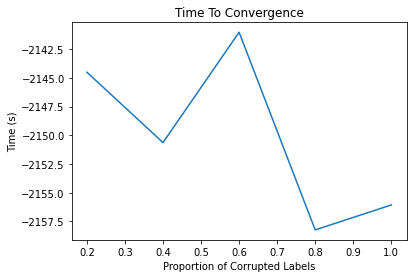

In [ ]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    myNormalize()
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_train)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

directory = "/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/WRN/WRNModel_Convergence"

for i, (input, target) in enumerate(trainloader):
  print(input.size())
  break

main("WRN",'wide-resnet','train', directory, 150)

Files already downloaded and verified
Files already downloaded and verified


Number of parameters: 369498
Number of parameters: 369498


torch.Size([512, 3, 32, 32])
Logging into /content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/WRN...
P: 0
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
000: Acc-tr:  38.58, Acc-val:  38.37, L-tr: 1.6578, L-val: 1.8172, Time: 13.674370
000: Acc-tr:  38.58, Acc-val:  38.37, L-tr: 1.6578, L-val: 1.8172, Time: 13.674370


Epoch 0 Finished.  Time per Epoch:  13.71 s 


001: Acc-tr:  60.05, Acc-val:  60.12, L-tr: 1.1230, L-val: 1.1250, Time: 27.523322
001: Acc-tr:  60.05, Acc-val:  60.12, L-tr: 1.1230, L-val: 1.1250, Time: 27.523322


Epoch 1 Finished.  Time per Epoch:  13.78 s 


002: Acc-tr:  68.45, Acc-val:  64.38, L-tr: 0.8885, L-val: 0.9999, Time: 41.457414
002: Acc-tr:  68.45, Acc-val:  64.38, L-tr: 0.8885, L-val: 0.9999, Time: 41.457414


Epoch 2 Finished.  Time per Epoch:  13.83 s 


003: Acc-tr:  74.50, Acc-val:  68.36, L-tr: 0.7289, L-val: 0.9374, Time: 55.479021
003: Acc-tr:  74.50, Acc-val:  68.36, L-tr: 0.7289, L-val: 0.9374, Time: 55.479021


Epoch 3 Finished.  Time per Epoch:  13.88 s 


004: Acc-tr:  78.10, Acc-val:  62.72, L-tr: 0.6247, L-val: 1.1114, Time: 69.516513
004: Acc-tr:  78.10, Acc-val:  62.72, L-tr: 0.6247, L-val: 1.1114, Time: 69.516513


Epoch 4 Finished.  Time per Epoch:  13.91 s 


005: Acc-tr:  80.98, Acc-val:  65.64, L-tr: 0.5447, L-val: 1.1762, Time: 83.538203
005: Acc-tr:  80.98, Acc-val:  65.64, L-tr: 0.5447, L-val: 1.1762, Time: 83.538203


Epoch 5 Finished.  Time per Epoch:  13.93 s 


006: Acc-tr:  83.04, Acc-val:  72.70, L-tr: 0.4866, L-val: 0.8355, Time: 97.523073
006: Acc-tr:  83.04, Acc-val:  72.70, L-tr: 0.4866, L-val: 0.8355, Time: 97.523073


Epoch 6 Finished.  Time per Epoch:  13.94 s 


007: Acc-tr:  84.68, Acc-val:  76.15, L-tr: 0.4359, L-val: 0.7183, Time: 111.428463
007: Acc-tr:  84.68, Acc-val:  76.15, L-tr: 0.4359, L-val: 0.7183, Time: 111.428463


Epoch 7 Finished.  Time per Epoch:  13.93 s 


008: Acc-tr:  86.66, Acc-val:  69.83, L-tr: 0.3837, L-val: 1.0322, Time: 125.379794
008: Acc-tr:  86.66, Acc-val:  69.83, L-tr: 0.3837, L-val: 1.0322, Time: 125.379794


Epoch 8 Finished.  Time per Epoch:  13.93 s 


009: Acc-tr:  87.93, Acc-val:  75.68, L-tr: 0.3462, L-val: 0.7572, Time: 139.351243
009: Acc-tr:  87.93, Acc-val:  75.68, L-tr: 0.3462, L-val: 0.7572, Time: 139.351243


Epoch 9 Finished.  Time per Epoch:  13.94 s 


010: Acc-tr:  89.22, Acc-val:  75.67, L-tr: 0.3079, L-val: 0.8503, Time: 153.301236
010: Acc-tr:  89.22, Acc-val:  75.67, L-tr: 0.3079, L-val: 0.8503, Time: 153.301236


Epoch 10 Finished.  Time per Epoch:  13.94 s 


011: Acc-tr:  90.56, Acc-val:  73.28, L-tr: 0.2734, L-val: 1.0362, Time: 167.289281
011: Acc-tr:  90.56, Acc-val:  73.28, L-tr: 0.2734, L-val: 1.0362, Time: 167.289281


Epoch 11 Finished.  Time per Epoch:  13.94 s 


012: Acc-tr:  91.40, Acc-val:  67.76, L-tr: 0.2460, L-val: 1.2146, Time: 181.249480
012: Acc-tr:  91.40, Acc-val:  67.76, L-tr: 0.2460, L-val: 1.2146, Time: 181.249480


Epoch 12 Finished.  Time per Epoch:  13.94 s 


013: Acc-tr:  91.97, Acc-val:  71.94, L-tr: 0.2236, L-val: 1.1540, Time: 195.248142
013: Acc-tr:  91.97, Acc-val:  71.94, L-tr: 0.2236, L-val: 1.1540, Time: 195.248142


Epoch 13 Finished.  Time per Epoch:  13.95 s 


014: Acc-tr:  93.31, Acc-val:  73.61, L-tr: 0.1904, L-val: 0.9965, Time: 209.367630
014: Acc-tr:  93.31, Acc-val:  73.61, L-tr: 0.1904, L-val: 0.9965, Time: 209.367630


Epoch 14 Finished.  Time per Epoch:  13.96 s 


015: Acc-tr:  93.59, Acc-val:  73.69, L-tr: 0.1813, L-val: 1.0477, Time: 223.368564
015: Acc-tr:  93.59, Acc-val:  73.69, L-tr: 0.1813, L-val: 1.0477, Time: 223.368564


Epoch 15 Finished.  Time per Epoch:  13.96 s 


016: Acc-tr:  94.29, Acc-val:  77.56, L-tr: 0.1602, L-val: 0.8248, Time: 237.415727
016: Acc-tr:  94.29, Acc-val:  77.56, L-tr: 0.1602, L-val: 0.8248, Time: 237.415727


Epoch 16 Finished.  Time per Epoch:  13.97 s 


017: Acc-tr:  94.99, Acc-val:  75.36, L-tr: 0.1419, L-val: 1.0089, Time: 251.423315
017: Acc-tr:  94.99, Acc-val:  75.36, L-tr: 0.1419, L-val: 1.0089, Time: 251.423315


Epoch 17 Finished.  Time per Epoch:  13.97 s 


018: Acc-tr:  95.65, Acc-val:  73.81, L-tr: 0.1248, L-val: 1.1472, Time: 265.406769
018: Acc-tr:  95.65, Acc-val:  73.81, L-tr: 0.1248, L-val: 1.1472, Time: 265.406769


Epoch 18 Finished.  Time per Epoch:  13.97 s 


019: Acc-tr:  95.72, Acc-val:  74.49, L-tr: 0.1203, L-val: 1.1566, Time: 279.466543
019: Acc-tr:  95.72, Acc-val:  74.49, L-tr: 0.1203, L-val: 1.1566, Time: 279.466543


Epoch 19 Finished.  Time per Epoch:  13.97 s 


020: Acc-tr:  95.83, Acc-val:  74.39, L-tr: 0.1166, L-val: 1.2147, Time: 293.462579
020: Acc-tr:  95.83, Acc-val:  74.39, L-tr: 0.1166, L-val: 1.2147, Time: 293.462579


Epoch 20 Finished.  Time per Epoch:  13.98 s 


021: Acc-tr:  96.25, Acc-val:  75.20, L-tr: 0.1055, L-val: 1.2558, Time: 307.386348
021: Acc-tr:  96.25, Acc-val:  75.20, L-tr: 0.1055, L-val: 1.2558, Time: 307.386348


Epoch 21 Finished.  Time per Epoch:  13.97 s 


022: Acc-tr:  97.05, Acc-val:  71.34, L-tr: 0.0855, L-val: 1.5113, Time: 321.270168
022: Acc-tr:  97.05, Acc-val:  71.34, L-tr: 0.0855, L-val: 1.5113, Time: 321.270168


Epoch 22 Finished.  Time per Epoch:  13.97 s 


023: Acc-tr:  96.86, Acc-val:  72.37, L-tr: 0.0908, L-val: 1.4517, Time: 335.267370
023: Acc-tr:  96.86, Acc-val:  72.37, L-tr: 0.0908, L-val: 1.4517, Time: 335.267370


Epoch 23 Finished.  Time per Epoch:  13.97 s 


024: Acc-tr:  97.05, Acc-val:  75.05, L-tr: 0.0838, L-val: 1.2785, Time: 349.237811
024: Acc-tr:  97.05, Acc-val:  75.05, L-tr: 0.0838, L-val: 1.2785, Time: 349.237811


Epoch 24 Finished.  Time per Epoch:  13.97 s 


025: Acc-tr:  97.21, Acc-val:  78.96, L-tr: 0.0815, L-val: 0.9540, Time: 363.279208
025: Acc-tr:  97.21, Acc-val:  78.96, L-tr: 0.0815, L-val: 0.9540, Time: 363.279208


Epoch 25 Finished.  Time per Epoch:  13.97 s 


026: Acc-tr:  97.59, Acc-val:  77.57, L-tr: 0.0692, L-val: 1.0968, Time: 377.219560
026: Acc-tr:  97.59, Acc-val:  77.57, L-tr: 0.0692, L-val: 1.0968, Time: 377.219560


Epoch 26 Finished.  Time per Epoch:  13.97 s 


027: Acc-tr:  97.56, Acc-val:  78.21, L-tr: 0.0687, L-val: 0.9852, Time: 391.233563
027: Acc-tr:  97.56, Acc-val:  78.21, L-tr: 0.0687, L-val: 0.9852, Time: 391.233563


Epoch 27 Finished.  Time per Epoch:  13.97 s 


028: Acc-tr:  97.98, Acc-val:  75.48, L-tr: 0.0586, L-val: 1.3640, Time: 405.218282
028: Acc-tr:  97.98, Acc-val:  75.48, L-tr: 0.0586, L-val: 1.3640, Time: 405.218282


Epoch 28 Finished.  Time per Epoch:  13.97 s 


029: Acc-tr:  98.27, Acc-val:  73.39, L-tr: 0.0513, L-val: 1.3472, Time: 419.167166
029: Acc-tr:  98.27, Acc-val:  73.39, L-tr: 0.0513, L-val: 1.3472, Time: 419.167166


Epoch 29 Finished.  Time per Epoch:  13.97 s 


030: Acc-tr:  98.23, Acc-val:  78.26, L-tr: 0.0512, L-val: 1.0971, Time: 433.143601
030: Acc-tr:  98.23, Acc-val:  78.26, L-tr: 0.0512, L-val: 1.0971, Time: 433.143601


Epoch 30 Finished.  Time per Epoch:  13.97 s 


031: Acc-tr:  98.35, Acc-val:  78.72, L-tr: 0.0472, L-val: 1.0116, Time: 447.147542
031: Acc-tr:  98.35, Acc-val:  78.72, L-tr: 0.0472, L-val: 1.0116, Time: 447.147542


Epoch 31 Finished.  Time per Epoch:  13.97 s 


032: Acc-tr:  98.29, Acc-val:  79.31, L-tr: 0.0487, L-val: 0.9814, Time: 461.230154
032: Acc-tr:  98.29, Acc-val:  79.31, L-tr: 0.0487, L-val: 0.9814, Time: 461.230154


Epoch 32 Finished.  Time per Epoch:  13.98 s 


033: Acc-tr:  98.27, Acc-val:  76.14, L-tr: 0.0504, L-val: 1.3041, Time: 475.203976
033: Acc-tr:  98.27, Acc-val:  76.14, L-tr: 0.0504, L-val: 1.3041, Time: 475.203976


Epoch 33 Finished.  Time per Epoch:  13.98 s 


034: Acc-tr:  97.92, Acc-val:  77.35, L-tr: 0.0599, L-val: 1.1415, Time: 489.175414
034: Acc-tr:  97.92, Acc-val:  77.35, L-tr: 0.0599, L-val: 1.1415, Time: 489.175414


Epoch 34 Finished.  Time per Epoch:  13.98 s 


035: Acc-tr:  98.14, Acc-val:  77.67, L-tr: 0.0561, L-val: 1.0651, Time: 503.133332
035: Acc-tr:  98.14, Acc-val:  77.67, L-tr: 0.0561, L-val: 1.0651, Time: 503.133332


Epoch 35 Finished.  Time per Epoch:  13.98 s 


036: Acc-tr:  98.48, Acc-val:  75.89, L-tr: 0.0449, L-val: 1.2083, Time: 517.085646
036: Acc-tr:  98.48, Acc-val:  75.89, L-tr: 0.0449, L-val: 1.2083, Time: 517.085646


Epoch 36 Finished.  Time per Epoch:  13.98 s 


037: Acc-tr:  98.32, Acc-val:  78.25, L-tr: 0.0483, L-val: 0.9868, Time: 531.027138
037: Acc-tr:  98.32, Acc-val:  78.25, L-tr: 0.0483, L-val: 0.9868, Time: 531.027138


Epoch 37 Finished.  Time per Epoch:  13.98 s 


038: Acc-tr:  98.68, Acc-val:  77.03, L-tr: 0.0384, L-val: 1.2240, Time: 544.995518
038: Acc-tr:  98.68, Acc-val:  77.03, L-tr: 0.0384, L-val: 1.2240, Time: 544.995518


Epoch 38 Finished.  Time per Epoch:  13.97 s 


039: Acc-tr:  98.86, Acc-val:  79.87, L-tr: 0.0340, L-val: 1.0136, Time: 558.999795
039: Acc-tr:  98.86, Acc-val:  79.87, L-tr: 0.0340, L-val: 1.0136, Time: 558.999795


Epoch 39 Finished.  Time per Epoch:  13.98 s 


040: Acc-tr:  98.95, Acc-val:  77.86, L-tr: 0.0317, L-val: 1.2007, Time: 572.981476
040: Acc-tr:  98.95, Acc-val:  77.86, L-tr: 0.0317, L-val: 1.2007, Time: 572.981476


Epoch 40 Finished.  Time per Epoch:  13.98 s 


041: Acc-tr:  99.01, Acc-val:  78.22, L-tr: 0.0300, L-val: 1.1609, Time: 587.018265
041: Acc-tr:  99.01, Acc-val:  78.22, L-tr: 0.0300, L-val: 1.1609, Time: 587.018265


Epoch 41 Finished.  Time per Epoch:  13.98 s 


042: Acc-tr:  99.19, Acc-val:  80.36, L-tr: 0.0251, L-val: 1.0366, Time: 600.972568
042: Acc-tr:  99.19, Acc-val:  80.36, L-tr: 0.0251, L-val: 1.0366, Time: 600.972568


Epoch 42 Finished.  Time per Epoch:  13.98 s 


043: Acc-tr:  99.04, Acc-val:  73.73, L-tr: 0.0297, L-val: 1.6403, Time: 614.966796
043: Acc-tr:  99.04, Acc-val:  73.73, L-tr: 0.0297, L-val: 1.6403, Time: 614.966796


Epoch 43 Finished.  Time per Epoch:  13.98 s 


044: Acc-tr:  98.06, Acc-val:  74.42, L-tr: 0.0563, L-val: 1.3575, Time: 628.896187
044: Acc-tr:  98.06, Acc-val:  74.42, L-tr: 0.0563, L-val: 1.3575, Time: 628.896187


Epoch 44 Finished.  Time per Epoch:  13.98 s 


045: Acc-tr:  98.55, Acc-val:  75.56, L-tr: 0.0443, L-val: 1.3864, Time: 642.819887
045: Acc-tr:  98.55, Acc-val:  75.56, L-tr: 0.0443, L-val: 1.3864, Time: 642.819887


Epoch 45 Finished.  Time per Epoch:  13.98 s 


046: Acc-tr:  98.61, Acc-val:  78.13, L-tr: 0.0401, L-val: 1.1285, Time: 656.855055
046: Acc-tr:  98.61, Acc-val:  78.13, L-tr: 0.0401, L-val: 1.1285, Time: 656.855055


Epoch 46 Finished.  Time per Epoch:  13.98 s 


047: Acc-tr:  98.48, Acc-val:  77.45, L-tr: 0.0444, L-val: 1.2100, Time: 670.894141
047: Acc-tr:  98.48, Acc-val:  77.45, L-tr: 0.0444, L-val: 1.2100, Time: 670.894141


Epoch 47 Finished.  Time per Epoch:  13.98 s 


048: Acc-tr:  98.73, Acc-val:  78.16, L-tr: 0.0366, L-val: 1.1431, Time: 684.894832
048: Acc-tr:  98.73, Acc-val:  78.16, L-tr: 0.0366, L-val: 1.1431, Time: 684.894832


Epoch 48 Finished.  Time per Epoch:  13.98 s 


049: Acc-tr:  98.97, Acc-val:  79.71, L-tr: 0.0302, L-val: 1.0659, Time: 698.901931
049: Acc-tr:  98.97, Acc-val:  79.71, L-tr: 0.0302, L-val: 1.0659, Time: 698.901931


Epoch 49 Finished.  Time per Epoch:  13.98 s 


050: Acc-tr:  98.80, Acc-val:  79.19, L-tr: 0.0362, L-val: 1.0153, Time: 712.961982
050: Acc-tr:  98.80, Acc-val:  79.19, L-tr: 0.0362, L-val: 1.0153, Time: 712.961982


Epoch 50 Finished.  Time per Epoch:  13.98 s 


051: Acc-tr:  98.68, Acc-val:  78.58, L-tr: 0.0386, L-val: 1.0625, Time: 726.964554
051: Acc-tr:  98.68, Acc-val:  78.58, L-tr: 0.0386, L-val: 1.0625, Time: 726.964554


Epoch 51 Finished.  Time per Epoch:  13.98 s 


052: Acc-tr:  98.87, Acc-val:  79.58, L-tr: 0.0325, L-val: 1.0443, Time: 740.927560
052: Acc-tr:  98.87, Acc-val:  79.58, L-tr: 0.0325, L-val: 1.0443, Time: 740.927560


Epoch 52 Finished.  Time per Epoch:  13.98 s 


053: Acc-tr:  98.99, Acc-val:  78.87, L-tr: 0.0302, L-val: 1.1120, Time: 754.870390
053: Acc-tr:  98.99, Acc-val:  78.87, L-tr: 0.0302, L-val: 1.1120, Time: 754.870390


Epoch 53 Finished.  Time per Epoch:  13.98 s 


054: Acc-tr:  99.10, Acc-val:  78.76, L-tr: 0.0270, L-val: 1.1169, Time: 768.870264
054: Acc-tr:  99.10, Acc-val:  78.76, L-tr: 0.0270, L-val: 1.1169, Time: 768.870264


Epoch 54 Finished.  Time per Epoch:  13.98 s 


055: Acc-tr:  99.33, Acc-val:  79.63, L-tr: 0.0207, L-val: 1.0419, Time: 782.855526
055: Acc-tr:  99.33, Acc-val:  79.63, L-tr: 0.0207, L-val: 1.0419, Time: 782.855526


Epoch 55 Finished.  Time per Epoch:  13.98 s 


056: Acc-tr:  99.19, Acc-val:  77.87, L-tr: 0.0235, L-val: 1.1986, Time: 796.848439
056: Acc-tr:  99.19, Acc-val:  77.87, L-tr: 0.0235, L-val: 1.1986, Time: 796.848439


Epoch 56 Finished.  Time per Epoch:  13.98 s 


057: Acc-tr:  98.75, Acc-val:  78.52, L-tr: 0.0356, L-val: 1.1158, Time: 810.805032
057: Acc-tr:  98.75, Acc-val:  78.52, L-tr: 0.0356, L-val: 1.1158, Time: 810.805032


Epoch 57 Finished.  Time per Epoch:  13.98 s 


058: Acc-tr:  98.06, Acc-val:  78.06, L-tr: 0.0552, L-val: 1.0904, Time: 824.814871
058: Acc-tr:  98.06, Acc-val:  78.06, L-tr: 0.0552, L-val: 1.0904, Time: 824.814871


Epoch 58 Finished.  Time per Epoch:  13.98 s 


059: Acc-tr:  98.24, Acc-val:  78.25, L-tr: 0.0510, L-val: 1.0895, Time: 838.730994
059: Acc-tr:  98.24, Acc-val:  78.25, L-tr: 0.0510, L-val: 1.0895, Time: 838.730994


Epoch 59 Finished.  Time per Epoch:  13.98 s 


060: Acc-tr:  98.75, Acc-val:  79.25, L-tr: 0.0363, L-val: 0.9872, Time: 852.666081
060: Acc-tr:  98.75, Acc-val:  79.25, L-tr: 0.0363, L-val: 0.9872, Time: 852.666081


Epoch 60 Finished.  Time per Epoch:  13.98 s 


061: Acc-tr:  99.26, Acc-val:  79.80, L-tr: 0.0235, L-val: 1.1078, Time: 866.623511
061: Acc-tr:  99.26, Acc-val:  79.80, L-tr: 0.0235, L-val: 1.1078, Time: 866.623511


Epoch 61 Finished.  Time per Epoch:  13.98 s 


062: Acc-tr:  99.55, Acc-val:  80.67, L-tr: 0.0153, L-val: 1.0105, Time: 880.593993
062: Acc-tr:  99.55, Acc-val:  80.67, L-tr: 0.0153, L-val: 1.0105, Time: 880.593993


Epoch 62 Finished.  Time per Epoch:  13.98 s 


063: Acc-tr:  99.82, Acc-val:  81.63, L-tr: 0.0075, L-val: 0.9500, Time: 894.586253
063: Acc-tr:  99.82, Acc-val:  81.63, L-tr: 0.0075, L-val: 0.9500, Time: 894.586253


Epoch 63 Finished.  Time per Epoch:  13.98 s 


064: Acc-tr:  99.90, Acc-val:  81.40, L-tr: 0.0044, L-val: 1.0067, Time: 908.520266
064: Acc-tr:  99.90, Acc-val:  81.40, L-tr: 0.0044, L-val: 1.0067, Time: 908.520266


Epoch 64 Finished.  Time per Epoch:  13.98 s 


065: Acc-tr:  99.96, Acc-val:  81.82, L-tr: 0.0026, L-val: 0.9527, Time: 922.487503
065: Acc-tr:  99.96, Acc-val:  81.82, L-tr: 0.0026, L-val: 0.9527, Time: 922.487503


Epoch 65 Finished.  Time per Epoch:  13.98 s 


066: Acc-tr: 100.00, Acc-val:  82.45, L-tr: 0.0008, L-val: 0.9100, Time: 936.377350
066: Acc-tr: 100.00, Acc-val:  82.45, L-tr: 0.0008, L-val: 0.9100, Time: 936.377350


Epoch 66 Finished.  Time per Epoch:  13.98 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 82.45000001220703
P: 0.1
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  84.00, Acc-val:  73.77, L-tr: 0.8771, L-val: 0.8398, Time: 13.975199
000: Acc-tr:  84.00, Acc-val:  73.77, L-tr: 0.8771, L-val: 0.8398, Time: 13.975199


Epoch 0 Finished.  Time per Epoch:  14.01 s 


001: Acc-tr:  89.46, Acc-val:  73.61, L-tr: 0.5808, L-val: 0.8784, Time: 27.951837
001: Acc-tr:  89.46, Acc-val:  73.61, L-tr: 0.5808, L-val: 0.8784, Time: 27.951837


Epoch 1 Finished.  Time per Epoch:  13.99 s 


002: Acc-tr:  89.74, Acc-val:  75.26, L-tr: 0.5083, L-val: 0.8258, Time: 41.961497
002: Acc-tr:  89.74, Acc-val:  75.26, L-tr: 0.5083, L-val: 0.8258, Time: 41.961497


Epoch 2 Finished.  Time per Epoch:  14.00 s 


003: Acc-tr:  89.56, Acc-val:  72.24, L-tr: 0.4637, L-val: 0.9639, Time: 55.839400
003: Acc-tr:  89.56, Acc-val:  72.24, L-tr: 0.4637, L-val: 0.9639, Time: 55.839400


Epoch 3 Finished.  Time per Epoch:  13.97 s 


004: Acc-tr:  89.36, Acc-val:  72.07, L-tr: 0.4427, L-val: 0.9725, Time: 69.793019
004: Acc-tr:  89.36, Acc-val:  72.07, L-tr: 0.4427, L-val: 0.9725, Time: 69.793019


Epoch 4 Finished.  Time per Epoch:  13.96 s 


005: Acc-tr:  89.27, Acc-val:  68.71, L-tr: 0.4246, L-val: 1.1803, Time: 83.706398
005: Acc-tr:  89.27, Acc-val:  68.71, L-tr: 0.4246, L-val: 1.1803, Time: 83.706398


Epoch 5 Finished.  Time per Epoch:  13.96 s 


006: Acc-tr:  89.60, Acc-val:  68.00, L-tr: 0.3990, L-val: 1.2038, Time: 97.624865
006: Acc-tr:  89.60, Acc-val:  68.00, L-tr: 0.3990, L-val: 1.2038, Time: 97.624865


Epoch 6 Finished.  Time per Epoch:  13.95 s 


007: Acc-tr:  89.78, Acc-val:  68.23, L-tr: 0.3851, L-val: 1.2415, Time: 111.578481
007: Acc-tr:  89.78, Acc-val:  68.23, L-tr: 0.3851, L-val: 1.2415, Time: 111.578481


Epoch 7 Finished.  Time per Epoch:  13.95 s 


008: Acc-tr:  89.94, Acc-val:  72.10, L-tr: 0.3667, L-val: 1.0452, Time: 125.578804
008: Acc-tr:  89.94, Acc-val:  72.10, L-tr: 0.3667, L-val: 1.0452, Time: 125.578804


Epoch 8 Finished.  Time per Epoch:  13.96 s 


009: Acc-tr:  90.01, Acc-val:  68.50, L-tr: 0.3551, L-val: 1.2723, Time: 139.566904
009: Acc-tr:  90.01, Acc-val:  68.50, L-tr: 0.3551, L-val: 1.2723, Time: 139.566904


Epoch 9 Finished.  Time per Epoch:  13.96 s 


010: Acc-tr:  90.51, Acc-val:  67.18, L-tr: 0.3356, L-val: 1.2742, Time: 153.525290
010: Acc-tr:  90.51, Acc-val:  67.18, L-tr: 0.3356, L-val: 1.2742, Time: 153.525290


Epoch 10 Finished.  Time per Epoch:  13.96 s 


011: Acc-tr:  90.84, Acc-val:  64.80, L-tr: 0.3134, L-val: 1.6011, Time: 167.464181
011: Acc-tr:  90.84, Acc-val:  64.80, L-tr: 0.3134, L-val: 1.6011, Time: 167.464181


Epoch 11 Finished.  Time per Epoch:  13.96 s 


012: Acc-tr:  91.25, Acc-val:  64.01, L-tr: 0.2963, L-val: 1.6273, Time: 181.524595
012: Acc-tr:  91.25, Acc-val:  64.01, L-tr: 0.2963, L-val: 1.6273, Time: 181.524595


Epoch 12 Finished.  Time per Epoch:  13.97 s 


013: Acc-tr:  91.37, Acc-val:  68.55, L-tr: 0.2861, L-val: 1.3660, Time: 195.539986
013: Acc-tr:  91.37, Acc-val:  68.55, L-tr: 0.2861, L-val: 1.3660, Time: 195.539986


Epoch 13 Finished.  Time per Epoch:  13.97 s 


014: Acc-tr:  91.59, Acc-val:  67.38, L-tr: 0.2780, L-val: 1.4019, Time: 209.460762
014: Acc-tr:  91.59, Acc-val:  67.38, L-tr: 0.2780, L-val: 1.4019, Time: 209.460762


Epoch 14 Finished.  Time per Epoch:  13.97 s 


015: Acc-tr:  92.64, Acc-val:  68.50, L-tr: 0.2434, L-val: 1.4774, Time: 223.399947
015: Acc-tr:  92.64, Acc-val:  68.50, L-tr: 0.2434, L-val: 1.4774, Time: 223.399947


Epoch 15 Finished.  Time per Epoch:  13.96 s 


016: Acc-tr:  92.52, Acc-val:  63.74, L-tr: 0.2416, L-val: 1.9476, Time: 237.235432
016: Acc-tr:  92.52, Acc-val:  63.74, L-tr: 0.2416, L-val: 1.9476, Time: 237.235432


Epoch 16 Finished.  Time per Epoch:  13.96 s 


017: Acc-tr:  92.58, Acc-val:  66.53, L-tr: 0.2374, L-val: 1.7824, Time: 251.168659
017: Acc-tr:  92.58, Acc-val:  66.53, L-tr: 0.2374, L-val: 1.7824, Time: 251.168659


Epoch 17 Finished.  Time per Epoch:  13.96 s 


018: Acc-tr:  93.09, Acc-val:  67.20, L-tr: 0.2204, L-val: 1.5271, Time: 265.060431
018: Acc-tr:  93.09, Acc-val:  67.20, L-tr: 0.2204, L-val: 1.5271, Time: 265.060431


Epoch 18 Finished.  Time per Epoch:  13.95 s 


019: Acc-tr:  93.62, Acc-val:  58.65, L-tr: 0.2009, L-val: 1.9429, Time: 279.009473
019: Acc-tr:  93.62, Acc-val:  58.65, L-tr: 0.2009, L-val: 1.9429, Time: 279.009473


Epoch 19 Finished.  Time per Epoch:  13.95 s 


020: Acc-tr:  93.22, Acc-val:  68.61, L-tr: 0.2098, L-val: 1.4773, Time: 292.948419
020: Acc-tr:  93.22, Acc-val:  68.61, L-tr: 0.2098, L-val: 1.4773, Time: 292.948419


Epoch 20 Finished.  Time per Epoch:  13.95 s 


021: Acc-tr:  94.04, Acc-val:  65.02, L-tr: 0.1880, L-val: 1.7632, Time: 306.896423
021: Acc-tr:  94.04, Acc-val:  65.02, L-tr: 0.1880, L-val: 1.7632, Time: 306.896423


Epoch 21 Finished.  Time per Epoch:  13.95 s 


022: Acc-tr:  94.59, Acc-val:  66.80, L-tr: 0.1682, L-val: 1.6221, Time: 320.841987
022: Acc-tr:  94.59, Acc-val:  66.80, L-tr: 0.1682, L-val: 1.6221, Time: 320.841987


Epoch 22 Finished.  Time per Epoch:  13.95 s 


023: Acc-tr:  94.61, Acc-val:  65.56, L-tr: 0.1670, L-val: 1.7083, Time: 334.772686
023: Acc-tr:  94.61, Acc-val:  65.56, L-tr: 0.1670, L-val: 1.7083, Time: 334.772686


Epoch 23 Finished.  Time per Epoch:  13.95 s 


024: Acc-tr:  94.11, Acc-val:  63.07, L-tr: 0.1795, L-val: 1.8345, Time: 348.739033
024: Acc-tr:  94.11, Acc-val:  63.07, L-tr: 0.1795, L-val: 1.8345, Time: 348.739033


Epoch 24 Finished.  Time per Epoch:  13.95 s 


025: Acc-tr:  94.34, Acc-val:  68.46, L-tr: 0.1723, L-val: 1.2799, Time: 362.627512
025: Acc-tr:  94.34, Acc-val:  68.46, L-tr: 0.1723, L-val: 1.2799, Time: 362.627512


Epoch 25 Finished.  Time per Epoch:  13.95 s 


026: Acc-tr:  95.10, Acc-val:  64.49, L-tr: 0.1485, L-val: 1.6037, Time: 376.513751
026: Acc-tr:  95.10, Acc-val:  64.49, L-tr: 0.1485, L-val: 1.6037, Time: 376.513751


Epoch 26 Finished.  Time per Epoch:  13.95 s 


027: Acc-tr:  95.25, Acc-val:  65.87, L-tr: 0.1451, L-val: 1.7653, Time: 390.470831
027: Acc-tr:  95.25, Acc-val:  65.87, L-tr: 0.1451, L-val: 1.7653, Time: 390.470831


Epoch 27 Finished.  Time per Epoch:  13.95 s 


028: Acc-tr:  95.51, Acc-val:  68.15, L-tr: 0.1369, L-val: 1.5679, Time: 404.420921
028: Acc-tr:  95.51, Acc-val:  68.15, L-tr: 0.1369, L-val: 1.5679, Time: 404.420921


Epoch 28 Finished.  Time per Epoch:  13.95 s 


029: Acc-tr:  96.05, Acc-val:  71.30, L-tr: 0.1208, L-val: 1.4946, Time: 418.385711
029: Acc-tr:  96.05, Acc-val:  71.30, L-tr: 0.1208, L-val: 1.4946, Time: 418.385711


Epoch 29 Finished.  Time per Epoch:  13.95 s 


030: Acc-tr:  95.72, Acc-val:  64.71, L-tr: 0.1267, L-val: 1.8927, Time: 432.271819
030: Acc-tr:  95.72, Acc-val:  64.71, L-tr: 0.1267, L-val: 1.8927, Time: 432.271819


Epoch 30 Finished.  Time per Epoch:  13.95 s 


031: Acc-tr:  95.26, Acc-val:  65.19, L-tr: 0.1435, L-val: 1.6716, Time: 446.235504
031: Acc-tr:  95.26, Acc-val:  65.19, L-tr: 0.1435, L-val: 1.6716, Time: 446.235504


Epoch 31 Finished.  Time per Epoch:  13.95 s 


032: Acc-tr:  95.80, Acc-val:  68.22, L-tr: 0.1257, L-val: 1.6727, Time: 460.147408
032: Acc-tr:  95.80, Acc-val:  68.22, L-tr: 0.1257, L-val: 1.6727, Time: 460.147408


Epoch 32 Finished.  Time per Epoch:  13.94 s 


033: Acc-tr:  96.35, Acc-val:  68.16, L-tr: 0.1116, L-val: 1.5379, Time: 474.078431
033: Acc-tr:  96.35, Acc-val:  68.16, L-tr: 0.1116, L-val: 1.5379, Time: 474.078431


Epoch 33 Finished.  Time per Epoch:  13.94 s 


034: Acc-tr:  96.46, Acc-val:  68.64, L-tr: 0.1065, L-val: 1.5950, Time: 488.041827
034: Acc-tr:  96.46, Acc-val:  68.64, L-tr: 0.1065, L-val: 1.5950, Time: 488.041827


Epoch 34 Finished.  Time per Epoch:  13.94 s 


035: Acc-tr:  96.50, Acc-val:  69.01, L-tr: 0.1024, L-val: 1.4468, Time: 501.955504
035: Acc-tr:  96.50, Acc-val:  69.01, L-tr: 0.1024, L-val: 1.4468, Time: 501.955504


Epoch 35 Finished.  Time per Epoch:  13.94 s 


036: Acc-tr:  96.57, Acc-val:  69.20, L-tr: 0.1026, L-val: 1.4424, Time: 515.841893
036: Acc-tr:  96.57, Acc-val:  69.20, L-tr: 0.1026, L-val: 1.4424, Time: 515.841893


Epoch 36 Finished.  Time per Epoch:  13.94 s 


037: Acc-tr:  96.47, Acc-val:  63.10, L-tr: 0.1069, L-val: 1.8468, Time: 529.763538
037: Acc-tr:  96.47, Acc-val:  63.10, L-tr: 0.1069, L-val: 1.8468, Time: 529.763538


Epoch 37 Finished.  Time per Epoch:  13.94 s 


038: Acc-tr:  96.22, Acc-val:  64.88, L-tr: 0.1141, L-val: 1.8127, Time: 543.722792
038: Acc-tr:  96.22, Acc-val:  64.88, L-tr: 0.1141, L-val: 1.8127, Time: 543.722792


Epoch 38 Finished.  Time per Epoch:  13.94 s 


039: Acc-tr:  96.54, Acc-val:  64.32, L-tr: 0.1041, L-val: 1.7192, Time: 557.659360
039: Acc-tr:  96.54, Acc-val:  64.32, L-tr: 0.1041, L-val: 1.7192, Time: 557.659360


Epoch 39 Finished.  Time per Epoch:  13.94 s 


040: Acc-tr:  96.87, Acc-val:  68.51, L-tr: 0.0953, L-val: 1.6958, Time: 571.739252
040: Acc-tr:  96.87, Acc-val:  68.51, L-tr: 0.0953, L-val: 1.6958, Time: 571.739252


Epoch 40 Finished.  Time per Epoch:  13.95 s 


041: Acc-tr:  97.17, Acc-val:  71.99, L-tr: 0.0842, L-val: 1.4596, Time: 585.662813
041: Acc-tr:  97.17, Acc-val:  71.99, L-tr: 0.0842, L-val: 1.4596, Time: 585.662813


Epoch 41 Finished.  Time per Epoch:  13.95 s 


042: Acc-tr:  97.53, Acc-val:  66.66, L-tr: 0.0767, L-val: 1.5751, Time: 599.617121
042: Acc-tr:  97.53, Acc-val:  66.66, L-tr: 0.0767, L-val: 1.5751, Time: 599.617121


Epoch 42 Finished.  Time per Epoch:  13.95 s 


043: Acc-tr:  97.20, Acc-val:  67.58, L-tr: 0.0834, L-val: 1.7151, Time: 613.548470
043: Acc-tr:  97.20, Acc-val:  67.58, L-tr: 0.0834, L-val: 1.7151, Time: 613.548470


Epoch 43 Finished.  Time per Epoch:  13.94 s 


044: Acc-tr:  96.96, Acc-val:  62.26, L-tr: 0.0896, L-val: 2.1750, Time: 627.459547
044: Acc-tr:  96.96, Acc-val:  62.26, L-tr: 0.0896, L-val: 2.1750, Time: 627.459547


Epoch 44 Finished.  Time per Epoch:  13.94 s 


045: Acc-tr:  96.75, Acc-val:  64.49, L-tr: 0.0941, L-val: 2.0288, Time: 641.458793
045: Acc-tr:  96.75, Acc-val:  64.49, L-tr: 0.0941, L-val: 2.0288, Time: 641.458793


Epoch 45 Finished.  Time per Epoch:  13.95 s 


046: Acc-tr:  97.07, Acc-val:  67.77, L-tr: 0.0870, L-val: 1.7555, Time: 655.445043
046: Acc-tr:  97.07, Acc-val:  67.77, L-tr: 0.0870, L-val: 1.7555, Time: 655.445043


Epoch 46 Finished.  Time per Epoch:  13.95 s 


047: Acc-tr:  97.08, Acc-val:  69.47, L-tr: 0.0854, L-val: 1.7183, Time: 669.381080
047: Acc-tr:  97.08, Acc-val:  69.47, L-tr: 0.0854, L-val: 1.7183, Time: 669.381080


Epoch 47 Finished.  Time per Epoch:  13.95 s 


048: Acc-tr:  97.16, Acc-val:  66.82, L-tr: 0.0878, L-val: 1.8315, Time: 683.353040
048: Acc-tr:  97.16, Acc-val:  66.82, L-tr: 0.0878, L-val: 1.8315, Time: 683.353040


Epoch 48 Finished.  Time per Epoch:  13.95 s 


049: Acc-tr:  96.82, Acc-val:  67.72, L-tr: 0.0927, L-val: 1.7099, Time: 697.391031
049: Acc-tr:  96.82, Acc-val:  67.72, L-tr: 0.0927, L-val: 1.7099, Time: 697.391031


Epoch 49 Finished.  Time per Epoch:  13.95 s 


050: Acc-tr:  97.23, Acc-val:  69.53, L-tr: 0.0851, L-val: 1.5741, Time: 711.401311
050: Acc-tr:  97.23, Acc-val:  69.53, L-tr: 0.0851, L-val: 1.5741, Time: 711.401311


Epoch 50 Finished.  Time per Epoch:  13.95 s 


051: Acc-tr:  97.94, Acc-val:  71.37, L-tr: 0.0620, L-val: 1.5416, Time: 725.416456
051: Acc-tr:  97.94, Acc-val:  71.37, L-tr: 0.0620, L-val: 1.5416, Time: 725.416456


Epoch 51 Finished.  Time per Epoch:  13.95 s 


052: Acc-tr:  98.11, Acc-val:  69.92, L-tr: 0.0574, L-val: 1.6940, Time: 739.415223
052: Acc-tr:  98.11, Acc-val:  69.92, L-tr: 0.0574, L-val: 1.6940, Time: 739.415223


Epoch 52 Finished.  Time per Epoch:  13.95 s 


053: Acc-tr:  97.82, Acc-val:  71.75, L-tr: 0.0641, L-val: 1.5269, Time: 753.422899
053: Acc-tr:  97.82, Acc-val:  71.75, L-tr: 0.0641, L-val: 1.5269, Time: 753.422899


Epoch 53 Finished.  Time per Epoch:  13.95 s 


054: Acc-tr:  97.78, Acc-val:  66.63, L-tr: 0.0659, L-val: 1.8844, Time: 767.376005
054: Acc-tr:  97.78, Acc-val:  66.63, L-tr: 0.0659, L-val: 1.8844, Time: 767.376005


Epoch 54 Finished.  Time per Epoch:  13.95 s 


055: Acc-tr:  97.20, Acc-val:  69.19, L-tr: 0.0847, L-val: 1.6016, Time: 781.384826
055: Acc-tr:  97.20, Acc-val:  69.19, L-tr: 0.0847, L-val: 1.6016, Time: 781.384826


Epoch 55 Finished.  Time per Epoch:  13.95 s 


056: Acc-tr:  96.68, Acc-val:  66.25, L-tr: 0.0994, L-val: 1.7852, Time: 795.316392
056: Acc-tr:  96.68, Acc-val:  66.25, L-tr: 0.0994, L-val: 1.7852, Time: 795.316392


Epoch 56 Finished.  Time per Epoch:  13.95 s 


057: Acc-tr:  97.28, Acc-val:  68.12, L-tr: 0.0805, L-val: 1.6773, Time: 809.297936
057: Acc-tr:  97.28, Acc-val:  68.12, L-tr: 0.0805, L-val: 1.6773, Time: 809.297936


Epoch 57 Finished.  Time per Epoch:  13.95 s 


058: Acc-tr:  97.93, Acc-val:  66.46, L-tr: 0.0624, L-val: 1.8483, Time: 823.278891
058: Acc-tr:  97.93, Acc-val:  66.46, L-tr: 0.0624, L-val: 1.8483, Time: 823.278891


Epoch 58 Finished.  Time per Epoch:  13.95 s 


059: Acc-tr:  98.34, Acc-val:  69.12, L-tr: 0.0492, L-val: 1.8102, Time: 837.295861
059: Acc-tr:  98.34, Acc-val:  69.12, L-tr: 0.0492, L-val: 1.8102, Time: 837.295861


Epoch 59 Finished.  Time per Epoch:  13.96 s 


060: Acc-tr:  98.58, Acc-val:  68.24, L-tr: 0.0426, L-val: 1.6716, Time: 851.223659
060: Acc-tr:  98.58, Acc-val:  68.24, L-tr: 0.0426, L-val: 1.6716, Time: 851.223659


Epoch 60 Finished.  Time per Epoch:  13.96 s 


061: Acc-tr:  98.67, Acc-val:  67.10, L-tr: 0.0412, L-val: 2.0234, Time: 865.160689
061: Acc-tr:  98.67, Acc-val:  67.10, L-tr: 0.0412, L-val: 2.0234, Time: 865.160689


Epoch 61 Finished.  Time per Epoch:  13.95 s 


062: Acc-tr:  97.95, Acc-val:  68.02, L-tr: 0.0610, L-val: 1.6846, Time: 879.115332
062: Acc-tr:  97.95, Acc-val:  68.02, L-tr: 0.0610, L-val: 1.6846, Time: 879.115332


Epoch 62 Finished.  Time per Epoch:  13.95 s 


063: Acc-tr:  96.57, Acc-val:  67.53, L-tr: 0.0984, L-val: 1.6423, Time: 893.196730
063: Acc-tr:  96.57, Acc-val:  67.53, L-tr: 0.0984, L-val: 1.6423, Time: 893.196730


Epoch 63 Finished.  Time per Epoch:  13.96 s 


064: Acc-tr:  96.67, Acc-val:  63.89, L-tr: 0.1004, L-val: 1.8690, Time: 907.130942
064: Acc-tr:  96.67, Acc-val:  63.89, L-tr: 0.1004, L-val: 1.8690, Time: 907.130942


Epoch 64 Finished.  Time per Epoch:  13.96 s 


065: Acc-tr:  97.36, Acc-val:  68.29, L-tr: 0.0779, L-val: 1.8383, Time: 921.089437
065: Acc-tr:  97.36, Acc-val:  68.29, L-tr: 0.0779, L-val: 1.8383, Time: 921.089437


Epoch 65 Finished.  Time per Epoch:  13.96 s 


066: Acc-tr:  98.30, Acc-val:  68.69, L-tr: 0.0519, L-val: 1.6902, Time: 935.076798
066: Acc-tr:  98.30, Acc-val:  68.69, L-tr: 0.0519, L-val: 1.6902, Time: 935.076798


Epoch 66 Finished.  Time per Epoch:  13.96 s 


067: Acc-tr:  98.50, Acc-val:  68.43, L-tr: 0.0475, L-val: 1.7259, Time: 949.103989
067: Acc-tr:  98.50, Acc-val:  68.43, L-tr: 0.0475, L-val: 1.7259, Time: 949.103989


Epoch 67 Finished.  Time per Epoch:  13.96 s 


068: Acc-tr:  98.62, Acc-val:  66.98, L-tr: 0.0421, L-val: 1.8747, Time: 963.196986
068: Acc-tr:  98.62, Acc-val:  66.98, L-tr: 0.0421, L-val: 1.8747, Time: 963.196986


Epoch 68 Finished.  Time per Epoch:  13.96 s 


069: Acc-tr:  98.76, Acc-val:  70.20, L-tr: 0.0387, L-val: 1.5360, Time: 977.276956
069: Acc-tr:  98.76, Acc-val:  70.20, L-tr: 0.0387, L-val: 1.5360, Time: 977.276956


Epoch 69 Finished.  Time per Epoch:  13.96 s 


070: Acc-tr:  98.23, Acc-val:  68.11, L-tr: 0.0532, L-val: 1.8742, Time: 991.379978
070: Acc-tr:  98.23, Acc-val:  68.11, L-tr: 0.0532, L-val: 1.8742, Time: 991.379978


Epoch 70 Finished.  Time per Epoch:  13.96 s 


071: Acc-tr:  97.12, Acc-val:  69.96, L-tr: 0.0854, L-val: 1.6310, Time: 1005.436233
071: Acc-tr:  97.12, Acc-val:  69.96, L-tr: 0.0854, L-val: 1.6310, Time: 1005.436233


Epoch 71 Finished.  Time per Epoch:  13.96 s 


072: Acc-tr:  96.77, Acc-val:  67.43, L-tr: 0.0959, L-val: 1.9879, Time: 1019.518807
072: Acc-tr:  96.77, Acc-val:  67.43, L-tr: 0.0959, L-val: 1.9879, Time: 1019.518807


Epoch 72 Finished.  Time per Epoch:  13.97 s 


073: Acc-tr:  97.01, Acc-val:  65.04, L-tr: 0.0866, L-val: 2.0211, Time: 1033.528196
073: Acc-tr:  97.01, Acc-val:  65.04, L-tr: 0.0866, L-val: 2.0211, Time: 1033.528196


Epoch 73 Finished.  Time per Epoch:  13.97 s 


074: Acc-tr:  97.85, Acc-val:  71.97, L-tr: 0.0652, L-val: 1.5397, Time: 1047.581116
074: Acc-tr:  97.85, Acc-val:  71.97, L-tr: 0.0652, L-val: 1.5397, Time: 1047.581116


Epoch 74 Finished.  Time per Epoch:  13.97 s 


075: Acc-tr:  98.72, Acc-val:  71.17, L-tr: 0.0414, L-val: 1.5079, Time: 1061.671302
075: Acc-tr:  98.72, Acc-val:  71.17, L-tr: 0.0414, L-val: 1.5079, Time: 1061.671302


Epoch 75 Finished.  Time per Epoch:  13.97 s 


076: Acc-tr:  99.03, Acc-val:  70.25, L-tr: 0.0308, L-val: 1.6922, Time: 1075.797549
076: Acc-tr:  99.03, Acc-val:  70.25, L-tr: 0.0308, L-val: 1.6922, Time: 1075.797549


Epoch 76 Finished.  Time per Epoch:  13.97 s 


077: Acc-tr:  99.17, Acc-val:  69.85, L-tr: 0.0270, L-val: 1.7530, Time: 1089.921257
077: Acc-tr:  99.17, Acc-val:  69.85, L-tr: 0.0270, L-val: 1.7530, Time: 1089.921257


Epoch 77 Finished.  Time per Epoch:  13.97 s 


078: Acc-tr:  98.82, Acc-val:  64.76, L-tr: 0.0354, L-val: 2.0407, Time: 1103.872810
078: Acc-tr:  98.82, Acc-val:  64.76, L-tr: 0.0354, L-val: 2.0407, Time: 1103.872810


Epoch 78 Finished.  Time per Epoch:  13.97 s 


079: Acc-tr:  97.92, Acc-val:  70.69, L-tr: 0.0620, L-val: 1.6685, Time: 1117.842014
079: Acc-tr:  97.92, Acc-val:  70.69, L-tr: 0.0620, L-val: 1.6685, Time: 1117.842014


Epoch 79 Finished.  Time per Epoch:  13.97 s 


080: Acc-tr:  96.77, Acc-val:  69.23, L-tr: 0.0966, L-val: 1.6647, Time: 1131.754026
080: Acc-tr:  96.77, Acc-val:  69.23, L-tr: 0.0966, L-val: 1.6647, Time: 1131.754026


Epoch 80 Finished.  Time per Epoch:  13.97 s 


081: Acc-tr:  96.68, Acc-val:  69.73, L-tr: 0.0972, L-val: 1.5663, Time: 1145.851896
081: Acc-tr:  96.68, Acc-val:  69.73, L-tr: 0.0972, L-val: 1.5663, Time: 1145.851896


Epoch 81 Finished.  Time per Epoch:  13.97 s 


082: Acc-tr:  97.51, Acc-val:  69.21, L-tr: 0.0734, L-val: 1.6074, Time: 1159.872022
082: Acc-tr:  97.51, Acc-val:  69.21, L-tr: 0.0734, L-val: 1.6074, Time: 1159.872022


Epoch 82 Finished.  Time per Epoch:  13.97 s 


083: Acc-tr:  98.27, Acc-val:  69.30, L-tr: 0.0521, L-val: 1.6445, Time: 1173.946694
083: Acc-tr:  98.27, Acc-val:  69.30, L-tr: 0.0521, L-val: 1.6445, Time: 1173.946694


Epoch 83 Finished.  Time per Epoch:  13.98 s 


084: Acc-tr:  98.46, Acc-val:  67.46, L-tr: 0.0472, L-val: 1.8679, Time: 1188.010308
084: Acc-tr:  98.46, Acc-val:  67.46, L-tr: 0.0472, L-val: 1.8679, Time: 1188.010308


Epoch 84 Finished.  Time per Epoch:  13.98 s 


085: Acc-tr:  98.18, Acc-val:  69.94, L-tr: 0.0528, L-val: 1.5356, Time: 1202.125879
085: Acc-tr:  98.18, Acc-val:  69.94, L-tr: 0.0528, L-val: 1.5356, Time: 1202.125879


Epoch 85 Finished.  Time per Epoch:  13.98 s 


086: Acc-tr:  98.00, Acc-val:  68.76, L-tr: 0.0596, L-val: 1.6695, Time: 1216.255544
086: Acc-tr:  98.00, Acc-val:  68.76, L-tr: 0.0596, L-val: 1.6695, Time: 1216.255544


Epoch 86 Finished.  Time per Epoch:  13.98 s 


087: Acc-tr:  97.36, Acc-val:  71.40, L-tr: 0.0761, L-val: 1.5250, Time: 1230.349688
087: Acc-tr:  97.36, Acc-val:  71.40, L-tr: 0.0761, L-val: 1.5250, Time: 1230.349688


Epoch 87 Finished.  Time per Epoch:  13.98 s 


088: Acc-tr:  97.34, Acc-val:  66.93, L-tr: 0.0800, L-val: 1.8770, Time: 1244.420292
088: Acc-tr:  97.34, Acc-val:  66.93, L-tr: 0.0800, L-val: 1.8770, Time: 1244.420292


Epoch 88 Finished.  Time per Epoch:  13.98 s 


089: Acc-tr:  97.94, Acc-val:  70.36, L-tr: 0.0636, L-val: 1.5890, Time: 1258.430132
089: Acc-tr:  97.94, Acc-val:  70.36, L-tr: 0.0636, L-val: 1.5890, Time: 1258.430132


Epoch 89 Finished.  Time per Epoch:  13.98 s 


090: Acc-tr:  98.08, Acc-val:  63.75, L-tr: 0.0568, L-val: 2.0387, Time: 1272.585065
090: Acc-tr:  98.08, Acc-val:  63.75, L-tr: 0.0568, L-val: 2.0387, Time: 1272.585065


Epoch 90 Finished.  Time per Epoch:  13.98 s 


091: Acc-tr:  98.39, Acc-val:  68.77, L-tr: 0.0487, L-val: 1.7243, Time: 1286.686012
091: Acc-tr:  98.39, Acc-val:  68.77, L-tr: 0.0487, L-val: 1.7243, Time: 1286.686012


Epoch 91 Finished.  Time per Epoch:  13.99 s 


092: Acc-tr:  98.29, Acc-val:  70.17, L-tr: 0.0501, L-val: 1.6146, Time: 1300.651542
092: Acc-tr:  98.29, Acc-val:  70.17, L-tr: 0.0501, L-val: 1.6146, Time: 1300.651542


Epoch 92 Finished.  Time per Epoch:  13.99 s 


093: Acc-tr:  98.41, Acc-val:  67.39, L-tr: 0.0483, L-val: 1.8299, Time: 1314.719484
093: Acc-tr:  98.41, Acc-val:  67.39, L-tr: 0.0483, L-val: 1.8299, Time: 1314.719484


Epoch 93 Finished.  Time per Epoch:  13.99 s 


094: Acc-tr:  98.09, Acc-val:  63.40, L-tr: 0.0594, L-val: 1.9761, Time: 1328.711285
094: Acc-tr:  98.09, Acc-val:  63.40, L-tr: 0.0594, L-val: 1.9761, Time: 1328.711285


Epoch 94 Finished.  Time per Epoch:  13.99 s 


095: Acc-tr:  97.73, Acc-val:  70.88, L-tr: 0.0666, L-val: 1.6375, Time: 1342.738642
095: Acc-tr:  97.73, Acc-val:  70.88, L-tr: 0.0666, L-val: 1.6375, Time: 1342.738642


Epoch 95 Finished.  Time per Epoch:  13.99 s 


096: Acc-tr:  97.99, Acc-val:  66.41, L-tr: 0.0607, L-val: 1.9867, Time: 1356.780528
096: Acc-tr:  97.99, Acc-val:  66.41, L-tr: 0.0607, L-val: 1.9867, Time: 1356.780528


Epoch 96 Finished.  Time per Epoch:  13.99 s 


097: Acc-tr:  98.01, Acc-val:  69.46, L-tr: 0.0603, L-val: 1.6663, Time: 1370.867679
097: Acc-tr:  98.01, Acc-val:  69.46, L-tr: 0.0603, L-val: 1.6663, Time: 1370.867679


Epoch 97 Finished.  Time per Epoch:  13.99 s 


098: Acc-tr:  98.10, Acc-val:  67.33, L-tr: 0.0549, L-val: 1.9119, Time: 1384.962615
098: Acc-tr:  98.10, Acc-val:  67.33, L-tr: 0.0549, L-val: 1.9119, Time: 1384.962615


Epoch 98 Finished.  Time per Epoch:  13.99 s 


099: Acc-tr:  98.36, Acc-val:  70.58, L-tr: 0.0501, L-val: 1.6330, Time: 1399.041807
099: Acc-tr:  98.36, Acc-val:  70.58, L-tr: 0.0501, L-val: 1.6330, Time: 1399.041807


Epoch 99 Finished.  Time per Epoch:  13.99 s 


100: Acc-tr:  98.45, Acc-val:  71.87, L-tr: 0.0475, L-val: 1.4437, Time: 1413.120827
100: Acc-tr:  98.45, Acc-val:  71.87, L-tr: 0.0475, L-val: 1.4437, Time: 1413.120827


Epoch 100 Finished.  Time per Epoch:  13.99 s 


101: Acc-tr:  98.51, Acc-val:  67.22, L-tr: 0.0456, L-val: 1.8611, Time: 1427.187581
101: Acc-tr:  98.51, Acc-val:  67.22, L-tr: 0.0456, L-val: 1.8611, Time: 1427.187581


Epoch 101 Finished.  Time per Epoch:  13.99 s 


102: Acc-tr:  98.31, Acc-val:  70.48, L-tr: 0.0505, L-val: 1.6728, Time: 1441.333404
102: Acc-tr:  98.31, Acc-val:  70.48, L-tr: 0.0505, L-val: 1.6728, Time: 1441.333404


Epoch 102 Finished.  Time per Epoch:  13.99 s 


103: Acc-tr:  97.72, Acc-val:  70.97, L-tr: 0.0690, L-val: 1.5593, Time: 1455.421629
103: Acc-tr:  97.72, Acc-val:  70.97, L-tr: 0.0690, L-val: 1.5593, Time: 1455.421629


Epoch 103 Finished.  Time per Epoch:  13.99 s 


104: Acc-tr:  97.61, Acc-val:  65.83, L-tr: 0.0708, L-val: 1.9987, Time: 1469.507481
104: Acc-tr:  97.61, Acc-val:  65.83, L-tr: 0.0708, L-val: 1.9987, Time: 1469.507481


Epoch 104 Finished.  Time per Epoch:  14.00 s 


105: Acc-tr:  97.79, Acc-val:  69.36, L-tr: 0.0668, L-val: 1.6026, Time: 1483.667815
105: Acc-tr:  97.79, Acc-val:  69.36, L-tr: 0.0668, L-val: 1.6026, Time: 1483.667815


Epoch 105 Finished.  Time per Epoch:  14.00 s 


106: Acc-tr:  98.02, Acc-val:  69.42, L-tr: 0.0603, L-val: 1.6234, Time: 1497.825590
106: Acc-tr:  98.02, Acc-val:  69.42, L-tr: 0.0603, L-val: 1.6234, Time: 1497.825590


Epoch 106 Finished.  Time per Epoch:  14.00 s 


107: Acc-tr:  98.17, Acc-val:  70.47, L-tr: 0.0549, L-val: 1.7344, Time: 1512.250448
107: Acc-tr:  98.17, Acc-val:  70.47, L-tr: 0.0549, L-val: 1.7344, Time: 1512.250448


Epoch 107 Finished.  Time per Epoch:  14.00 s 


108: Acc-tr:  98.03, Acc-val:  65.96, L-tr: 0.0569, L-val: 1.9725, Time: 1526.298201
108: Acc-tr:  98.03, Acc-val:  65.96, L-tr: 0.0569, L-val: 1.9725, Time: 1526.298201


Epoch 108 Finished.  Time per Epoch:  14.00 s 


109: Acc-tr:  98.15, Acc-val:  69.12, L-tr: 0.0557, L-val: 1.7286, Time: 1540.245508
109: Acc-tr:  98.15, Acc-val:  69.12, L-tr: 0.0557, L-val: 1.7286, Time: 1540.245508


Epoch 109 Finished.  Time per Epoch:  14.00 s 


110: Acc-tr:  98.11, Acc-val:  69.01, L-tr: 0.0577, L-val: 1.7064, Time: 1554.248279
110: Acc-tr:  98.11, Acc-val:  69.01, L-tr: 0.0577, L-val: 1.7064, Time: 1554.248279


Epoch 110 Finished.  Time per Epoch:  14.00 s 


111: Acc-tr:  97.83, Acc-val:  65.40, L-tr: 0.0631, L-val: 1.8001, Time: 1568.163850
111: Acc-tr:  97.83, Acc-val:  65.40, L-tr: 0.0631, L-val: 1.8001, Time: 1568.163850


Epoch 111 Finished.  Time per Epoch:  14.00 s 


112: Acc-tr:  97.80, Acc-val:  69.74, L-tr: 0.0680, L-val: 1.7091, Time: 1582.095944
112: Acc-tr:  97.80, Acc-val:  69.74, L-tr: 0.0680, L-val: 1.7091, Time: 1582.095944


Epoch 112 Finished.  Time per Epoch:  14.00 s 


113: Acc-tr:  98.31, Acc-val:  70.06, L-tr: 0.0504, L-val: 1.5768, Time: 1596.066794
113: Acc-tr:  98.31, Acc-val:  70.06, L-tr: 0.0504, L-val: 1.5768, Time: 1596.066794


Epoch 113 Finished.  Time per Epoch:  14.00 s 


114: Acc-tr:  98.45, Acc-val:  68.42, L-tr: 0.0459, L-val: 1.7616, Time: 1610.049665
114: Acc-tr:  98.45, Acc-val:  68.42, L-tr: 0.0459, L-val: 1.7616, Time: 1610.049665


Epoch 114 Finished.  Time per Epoch:  14.00 s 


115: Acc-tr:  98.43, Acc-val:  69.12, L-tr: 0.0462, L-val: 1.7369, Time: 1624.028142
115: Acc-tr:  98.43, Acc-val:  69.12, L-tr: 0.0462, L-val: 1.7369, Time: 1624.028142


Epoch 115 Finished.  Time per Epoch:  14.00 s 


116: Acc-tr:  98.42, Acc-val:  66.77, L-tr: 0.0473, L-val: 1.9020, Time: 1637.940544
116: Acc-tr:  98.42, Acc-val:  66.77, L-tr: 0.0473, L-val: 1.9020, Time: 1637.940544


Epoch 116 Finished.  Time per Epoch:  14.00 s 


117: Acc-tr:  98.33, Acc-val:  71.71, L-tr: 0.0497, L-val: 1.5728, Time: 1651.908647
117: Acc-tr:  98.33, Acc-val:  71.71, L-tr: 0.0497, L-val: 1.5728, Time: 1651.908647


Epoch 117 Finished.  Time per Epoch:  14.00 s 


118: Acc-tr:  98.15, Acc-val:  70.35, L-tr: 0.0562, L-val: 1.6836, Time: 1665.850564
118: Acc-tr:  98.15, Acc-val:  70.35, L-tr: 0.0562, L-val: 1.6836, Time: 1665.850564


Epoch 118 Finished.  Time per Epoch:  14.00 s 


119: Acc-tr:  97.51, Acc-val:  70.21, L-tr: 0.0721, L-val: 1.6012, Time: 1679.762278
119: Acc-tr:  97.51, Acc-val:  70.21, L-tr: 0.0721, L-val: 1.6012, Time: 1679.762278


Epoch 119 Finished.  Time per Epoch:  14.00 s 


120: Acc-tr:  97.77, Acc-val:  63.36, L-tr: 0.0666, L-val: 2.0460, Time: 1693.688322
120: Acc-tr:  97.77, Acc-val:  63.36, L-tr: 0.0666, L-val: 2.0460, Time: 1693.688322


Epoch 120 Finished.  Time per Epoch:  14.00 s 


121: Acc-tr:  97.68, Acc-val:  70.25, L-tr: 0.0709, L-val: 1.5970, Time: 1707.632994
121: Acc-tr:  97.68, Acc-val:  70.25, L-tr: 0.0709, L-val: 1.5970, Time: 1707.632994


Epoch 121 Finished.  Time per Epoch:  14.00 s 


122: Acc-tr:  97.88, Acc-val:  69.60, L-tr: 0.0632, L-val: 1.5472, Time: 1721.554273
122: Acc-tr:  97.88, Acc-val:  69.60, L-tr: 0.0632, L-val: 1.5472, Time: 1721.554273


Epoch 122 Finished.  Time per Epoch:  14.00 s 


123: Acc-tr:  98.60, Acc-val:  72.31, L-tr: 0.0433, L-val: 1.3927, Time: 1735.547848
123: Acc-tr:  98.60, Acc-val:  72.31, L-tr: 0.0433, L-val: 1.3927, Time: 1735.547848


Epoch 123 Finished.  Time per Epoch:  14.00 s 


124: Acc-tr:  98.93, Acc-val:  71.30, L-tr: 0.0332, L-val: 1.5141, Time: 1749.464951
124: Acc-tr:  98.93, Acc-val:  71.30, L-tr: 0.0332, L-val: 1.5141, Time: 1749.464951


Epoch 124 Finished.  Time per Epoch:  14.00 s 


125: Acc-tr:  99.17, Acc-val:  73.19, L-tr: 0.0267, L-val: 1.4893, Time: 1763.420466
125: Acc-tr:  99.17, Acc-val:  73.19, L-tr: 0.0267, L-val: 1.4893, Time: 1763.420466


Epoch 125 Finished.  Time per Epoch:  14.00 s 


126: Acc-tr:  99.32, Acc-val:  69.84, L-tr: 0.0221, L-val: 1.5248, Time: 1777.342556
126: Acc-tr:  99.32, Acc-val:  69.84, L-tr: 0.0221, L-val: 1.5248, Time: 1777.342556


Epoch 126 Finished.  Time per Epoch:  14.00 s 


127: Acc-tr:  99.18, Acc-val:  69.36, L-tr: 0.0257, L-val: 1.7337, Time: 1791.236317
127: Acc-tr:  99.18, Acc-val:  69.36, L-tr: 0.0257, L-val: 1.7337, Time: 1791.236317


Epoch 127 Finished.  Time per Epoch:  13.99 s 


128: Acc-tr:  98.93, Acc-val:  67.88, L-tr: 0.0325, L-val: 2.2230, Time: 1805.201514
128: Acc-tr:  98.93, Acc-val:  67.88, L-tr: 0.0325, L-val: 2.2230, Time: 1805.201514


Epoch 128 Finished.  Time per Epoch:  13.99 s 


129: Acc-tr:  98.13, Acc-val:  65.95, L-tr: 0.0554, L-val: 1.8114, Time: 1819.104735
129: Acc-tr:  98.13, Acc-val:  65.95, L-tr: 0.0554, L-val: 1.8114, Time: 1819.104735


Epoch 129 Finished.  Time per Epoch:  13.99 s 


130: Acc-tr:  96.01, Acc-val:  67.23, L-tr: 0.1162, L-val: 1.8132, Time: 1833.102362
130: Acc-tr:  96.01, Acc-val:  67.23, L-tr: 0.1162, L-val: 1.8132, Time: 1833.102362


Epoch 130 Finished.  Time per Epoch:  13.99 s 


131: Acc-tr:  96.63, Acc-val:  66.77, L-tr: 0.1018, L-val: 1.6640, Time: 1847.044381
131: Acc-tr:  96.63, Acc-val:  66.77, L-tr: 0.1018, L-val: 1.6640, Time: 1847.044381


Epoch 131 Finished.  Time per Epoch:  13.99 s 


132: Acc-tr:  98.12, Acc-val:  70.16, L-tr: 0.0584, L-val: 1.6034, Time: 1860.988729
132: Acc-tr:  98.12, Acc-val:  70.16, L-tr: 0.0584, L-val: 1.6034, Time: 1860.988729


Epoch 132 Finished.  Time per Epoch:  13.99 s 


133: Acc-tr:  98.57, Acc-val:  73.21, L-tr: 0.0442, L-val: 1.3687, Time: 1874.977761
133: Acc-tr:  98.57, Acc-val:  73.21, L-tr: 0.0442, L-val: 1.3687, Time: 1874.977761


Epoch 133 Finished.  Time per Epoch:  13.99 s 


134: Acc-tr:  99.14, Acc-val:  69.30, L-tr: 0.0276, L-val: 1.8511, Time: 1888.908627
134: Acc-tr:  99.14, Acc-val:  69.30, L-tr: 0.0276, L-val: 1.8511, Time: 1888.908627


Epoch 134 Finished.  Time per Epoch:  13.99 s 


135: Acc-tr:  99.33, Acc-val:  73.52, L-tr: 0.0216, L-val: 1.3817, Time: 1902.838822
135: Acc-tr:  99.33, Acc-val:  73.52, L-tr: 0.0216, L-val: 1.3817, Time: 1902.838822


Epoch 135 Finished.  Time per Epoch:  13.99 s 


136: Acc-tr:  99.65, Acc-val:  72.84, L-tr: 0.0136, L-val: 1.5142, Time: 1916.710862
136: Acc-tr:  99.65, Acc-val:  72.84, L-tr: 0.0136, L-val: 1.5142, Time: 1916.710862


Epoch 136 Finished.  Time per Epoch:  13.99 s 


137: Acc-tr:  99.65, Acc-val:  72.70, L-tr: 0.0120, L-val: 1.6377, Time: 1930.654511
137: Acc-tr:  99.65, Acc-val:  72.70, L-tr: 0.0120, L-val: 1.6377, Time: 1930.654511


Epoch 137 Finished.  Time per Epoch:  13.99 s 


138: Acc-tr:  99.85, Acc-val:  72.68, L-tr: 0.0074, L-val: 1.5294, Time: 1944.609104
138: Acc-tr:  99.85, Acc-val:  72.68, L-tr: 0.0074, L-val: 1.5294, Time: 1944.609104


Epoch 138 Finished.  Time per Epoch:  13.99 s 


139: Acc-tr:  99.90, Acc-val:  75.01, L-tr: 0.0048, L-val: 1.3948, Time: 1958.527730
139: Acc-tr:  99.90, Acc-val:  75.01, L-tr: 0.0048, L-val: 1.3948, Time: 1958.527730


Epoch 139 Finished.  Time per Epoch:  13.99 s 


140: Acc-tr:  99.96, Acc-val:  75.71, L-tr: 0.0022, L-val: 1.3453, Time: 1972.409756
140: Acc-tr:  99.96, Acc-val:  75.71, L-tr: 0.0022, L-val: 1.3453, Time: 1972.409756


Epoch 140 Finished.  Time per Epoch:  13.99 s 


141: Acc-tr:  99.99, Acc-val:  76.19, L-tr: 0.0009, L-val: 1.3024, Time: 1986.393268
141: Acc-tr:  99.99, Acc-val:  76.19, L-tr: 0.0009, L-val: 1.3024, Time: 1986.393268


Epoch 141 Finished.  Time per Epoch:  13.99 s 


142: Acc-tr: 100.00, Acc-val:  76.19, L-tr: 0.0004, L-val: 1.2808, Time: 2000.350567
142: Acc-tr: 100.00, Acc-val:  76.19, L-tr: 0.0004, L-val: 1.2808, Time: 2000.350567


Epoch 142 Finished.  Time per Epoch:  13.99 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 76.18999990234374
P: 0.2
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  73.68, Acc-val:  75.32, L-tr: 1.2384, L-val: 0.8148, Time: 13.930043
000: Acc-tr:  73.68, Acc-val:  75.32, L-tr: 1.2384, L-val: 0.8148, Time: 13.930043


Epoch 0 Finished.  Time per Epoch:  13.96 s 


001: Acc-tr:  80.66, Acc-val:  72.21, L-tr: 0.8599, L-val: 0.9253, Time: 27.972463
001: Acc-tr:  80.66, Acc-val:  72.21, L-tr: 0.8599, L-val: 0.9253, Time: 27.972463


Epoch 1 Finished.  Time per Epoch:  14.00 s 


002: Acc-tr:  82.03, Acc-val:  70.95, L-tr: 0.7395, L-val: 1.0186, Time: 42.021011
002: Acc-tr:  82.03, Acc-val:  70.95, L-tr: 0.7395, L-val: 1.0186, Time: 42.021011


Epoch 2 Finished.  Time per Epoch:  14.02 s 


003: Acc-tr:  82.88, Acc-val:  65.96, L-tr: 0.6517, L-val: 1.1978, Time: 55.992111
003: Acc-tr:  82.88, Acc-val:  65.96, L-tr: 0.6517, L-val: 1.1978, Time: 55.992111


Epoch 3 Finished.  Time per Epoch:  14.01 s 


004: Acc-tr:  83.66, Acc-val:  67.18, L-tr: 0.5899, L-val: 1.1819, Time: 69.973581
004: Acc-tr:  83.66, Acc-val:  67.18, L-tr: 0.5899, L-val: 1.1819, Time: 69.973581


Epoch 4 Finished.  Time per Epoch:  14.00 s 


005: Acc-tr:  84.08, Acc-val:  64.99, L-tr: 0.5602, L-val: 1.2727, Time: 83.880165
005: Acc-tr:  84.08, Acc-val:  64.99, L-tr: 0.5602, L-val: 1.2727, Time: 83.880165


Epoch 5 Finished.  Time per Epoch:  13.99 s 


006: Acc-tr:  84.19, Acc-val:  62.91, L-tr: 0.5394, L-val: 1.4304, Time: 97.893878
006: Acc-tr:  84.19, Acc-val:  62.91, L-tr: 0.5394, L-val: 1.4304, Time: 97.893878


Epoch 6 Finished.  Time per Epoch:  13.99 s 


007: Acc-tr:  84.93, Acc-val:  61.44, L-tr: 0.5085, L-val: 1.5788, Time: 111.835215
007: Acc-tr:  84.93, Acc-val:  61.44, L-tr: 0.5085, L-val: 1.5788, Time: 111.835215


Epoch 7 Finished.  Time per Epoch:  13.98 s 


008: Acc-tr:  85.28, Acc-val:  56.32, L-tr: 0.4878, L-val: 1.7565, Time: 125.840989
008: Acc-tr:  85.28, Acc-val:  56.32, L-tr: 0.4878, L-val: 1.7565, Time: 125.840989


Epoch 8 Finished.  Time per Epoch:  13.99 s 


009: Acc-tr:  85.51, Acc-val:  53.14, L-tr: 0.4665, L-val: 1.9419, Time: 139.780606
009: Acc-tr:  85.51, Acc-val:  53.14, L-tr: 0.4665, L-val: 1.9419, Time: 139.780606


Epoch 9 Finished.  Time per Epoch:  13.98 s 


010: Acc-tr:  86.39, Acc-val:  60.90, L-tr: 0.4417, L-val: 1.5738, Time: 153.728188
010: Acc-tr:  86.39, Acc-val:  60.90, L-tr: 0.4417, L-val: 1.5738, Time: 153.728188


Epoch 10 Finished.  Time per Epoch:  13.98 s 


011: Acc-tr:  87.67, Acc-val:  58.61, L-tr: 0.3973, L-val: 1.6221, Time: 167.716762
011: Acc-tr:  87.67, Acc-val:  58.61, L-tr: 0.3973, L-val: 1.6221, Time: 167.716762


Epoch 11 Finished.  Time per Epoch:  13.98 s 


012: Acc-tr:  87.73, Acc-val:  63.98, L-tr: 0.3941, L-val: 1.4738, Time: 181.609324
012: Acc-tr:  87.73, Acc-val:  63.98, L-tr: 0.3941, L-val: 1.4738, Time: 181.609324


Epoch 12 Finished.  Time per Epoch:  13.97 s 


013: Acc-tr:  88.39, Acc-val:  61.97, L-tr: 0.3694, L-val: 1.6182, Time: 195.532912
013: Acc-tr:  88.39, Acc-val:  61.97, L-tr: 0.3694, L-val: 1.6182, Time: 195.532912


Epoch 13 Finished.  Time per Epoch:  13.97 s 


014: Acc-tr:  89.14, Acc-val:  51.78, L-tr: 0.3361, L-val: 2.2984, Time: 209.501028
014: Acc-tr:  89.14, Acc-val:  51.78, L-tr: 0.3361, L-val: 2.2984, Time: 209.501028


Epoch 14 Finished.  Time per Epoch:  13.97 s 


015: Acc-tr:  88.78, Acc-val:  52.39, L-tr: 0.3456, L-val: 1.9532, Time: 223.400859
015: Acc-tr:  88.78, Acc-val:  52.39, L-tr: 0.3456, L-val: 1.9532, Time: 223.400859


Epoch 15 Finished.  Time per Epoch:  13.96 s 


016: Acc-tr:  90.56, Acc-val:  55.71, L-tr: 0.2945, L-val: 2.1404, Time: 237.351630
016: Acc-tr:  90.56, Acc-val:  55.71, L-tr: 0.2945, L-val: 2.1404, Time: 237.351630


Epoch 16 Finished.  Time per Epoch:  13.96 s 


017: Acc-tr:  90.17, Acc-val:  62.76, L-tr: 0.2996, L-val: 1.7398, Time: 251.308049
017: Acc-tr:  90.17, Acc-val:  62.76, L-tr: 0.2996, L-val: 1.7398, Time: 251.308049


Epoch 17 Finished.  Time per Epoch:  13.96 s 


018: Acc-tr:  90.96, Acc-val:  61.93, L-tr: 0.2770, L-val: 1.7593, Time: 265.289197
018: Acc-tr:  90.96, Acc-val:  61.93, L-tr: 0.2770, L-val: 1.7593, Time: 265.289197


Epoch 18 Finished.  Time per Epoch:  13.96 s 


019: Acc-tr:  91.23, Acc-val:  57.05, L-tr: 0.2700, L-val: 1.8696, Time: 279.255414
019: Acc-tr:  91.23, Acc-val:  57.05, L-tr: 0.2700, L-val: 1.8696, Time: 279.255414


Epoch 19 Finished.  Time per Epoch:  13.96 s 


020: Acc-tr:  92.31, Acc-val:  53.26, L-tr: 0.2357, L-val: 2.4326, Time: 293.201845
020: Acc-tr:  92.31, Acc-val:  53.26, L-tr: 0.2357, L-val: 2.4326, Time: 293.201845


Epoch 20 Finished.  Time per Epoch:  13.96 s 


021: Acc-tr:  92.59, Acc-val:  54.67, L-tr: 0.2234, L-val: 2.5194, Time: 307.145838
021: Acc-tr:  92.59, Acc-val:  54.67, L-tr: 0.2234, L-val: 2.5194, Time: 307.145838


Epoch 21 Finished.  Time per Epoch:  13.96 s 


022: Acc-tr:  91.62, Acc-val:  59.52, L-tr: 0.2528, L-val: 2.0225, Time: 321.070928
022: Acc-tr:  91.62, Acc-val:  59.52, L-tr: 0.2528, L-val: 2.0225, Time: 321.070928


Epoch 22 Finished.  Time per Epoch:  13.96 s 


023: Acc-tr:  93.05, Acc-val:  50.60, L-tr: 0.2088, L-val: 2.5971, Time: 334.969629
023: Acc-tr:  93.05, Acc-val:  50.60, L-tr: 0.2088, L-val: 2.5971, Time: 334.969629


Epoch 23 Finished.  Time per Epoch:  13.96 s 


024: Acc-tr:  93.75, Acc-val:  60.01, L-tr: 0.1883, L-val: 2.1129, Time: 348.864949
024: Acc-tr:  93.75, Acc-val:  60.01, L-tr: 0.1883, L-val: 2.1129, Time: 348.864949


Epoch 24 Finished.  Time per Epoch:  13.96 s 


025: Acc-tr:  93.11, Acc-val:  53.50, L-tr: 0.2037, L-val: 2.7311, Time: 362.816216
025: Acc-tr:  93.11, Acc-val:  53.50, L-tr: 0.2037, L-val: 2.7311, Time: 362.816216


Epoch 25 Finished.  Time per Epoch:  13.96 s 


026: Acc-tr:  93.08, Acc-val:  60.52, L-tr: 0.2065, L-val: 1.9823, Time: 376.715946
026: Acc-tr:  93.08, Acc-val:  60.52, L-tr: 0.2065, L-val: 1.9823, Time: 376.715946


Epoch 26 Finished.  Time per Epoch:  13.95 s 


027: Acc-tr:  94.18, Acc-val:  54.54, L-tr: 0.1756, L-val: 2.3258, Time: 390.594935
027: Acc-tr:  94.18, Acc-val:  54.54, L-tr: 0.1756, L-val: 2.3258, Time: 390.594935


Epoch 27 Finished.  Time per Epoch:  13.95 s 


028: Acc-tr:  94.52, Acc-val:  57.77, L-tr: 0.1631, L-val: 2.0592, Time: 404.517505
028: Acc-tr:  94.52, Acc-val:  57.77, L-tr: 0.1631, L-val: 2.0592, Time: 404.517505


Epoch 28 Finished.  Time per Epoch:  13.95 s 


029: Acc-tr:  94.43, Acc-val:  60.90, L-tr: 0.1664, L-val: 1.9864, Time: 418.419009
029: Acc-tr:  94.43, Acc-val:  60.90, L-tr: 0.1664, L-val: 1.9864, Time: 418.419009


Epoch 29 Finished.  Time per Epoch:  13.95 s 


030: Acc-tr:  95.02, Acc-val:  61.61, L-tr: 0.1519, L-val: 2.1059, Time: 432.399854
030: Acc-tr:  95.02, Acc-val:  61.61, L-tr: 0.1519, L-val: 2.1059, Time: 432.399854


Epoch 30 Finished.  Time per Epoch:  13.95 s 


031: Acc-tr:  95.14, Acc-val:  54.70, L-tr: 0.1424, L-val: 2.7810, Time: 446.329510
031: Acc-tr:  95.14, Acc-val:  54.70, L-tr: 0.1424, L-val: 2.7810, Time: 446.329510


Epoch 31 Finished.  Time per Epoch:  13.95 s 


032: Acc-tr:  95.14, Acc-val:  60.32, L-tr: 0.1453, L-val: 2.0507, Time: 460.280865
032: Acc-tr:  95.14, Acc-val:  60.32, L-tr: 0.1453, L-val: 2.0507, Time: 460.280865


Epoch 32 Finished.  Time per Epoch:  13.95 s 


033: Acc-tr:  95.28, Acc-val:  56.95, L-tr: 0.1409, L-val: 2.2564, Time: 474.176375
033: Acc-tr:  95.28, Acc-val:  56.95, L-tr: 0.1409, L-val: 2.2564, Time: 474.176375


Epoch 33 Finished.  Time per Epoch:  13.95 s 


034: Acc-tr:  95.55, Acc-val:  58.38, L-tr: 0.1342, L-val: 2.1427, Time: 488.129704
034: Acc-tr:  95.55, Acc-val:  58.38, L-tr: 0.1342, L-val: 2.1427, Time: 488.129704


Epoch 34 Finished.  Time per Epoch:  13.95 s 


035: Acc-tr:  95.23, Acc-val:  51.46, L-tr: 0.1399, L-val: 2.8202, Time: 502.099008
035: Acc-tr:  95.23, Acc-val:  51.46, L-tr: 0.1399, L-val: 2.8202, Time: 502.099008


Epoch 35 Finished.  Time per Epoch:  13.95 s 


036: Acc-tr:  95.83, Acc-val:  61.25, L-tr: 0.1241, L-val: 2.1417, Time: 516.027594
036: Acc-tr:  95.83, Acc-val:  61.25, L-tr: 0.1241, L-val: 2.1417, Time: 516.027594


Epoch 36 Finished.  Time per Epoch:  13.95 s 


037: Acc-tr:  95.47, Acc-val:  61.76, L-tr: 0.1347, L-val: 1.8738, Time: 529.991948
037: Acc-tr:  95.47, Acc-val:  61.76, L-tr: 0.1347, L-val: 1.8738, Time: 529.991948


Epoch 37 Finished.  Time per Epoch:  13.95 s 


038: Acc-tr:  96.23, Acc-val:  59.81, L-tr: 0.1127, L-val: 2.1981, Time: 543.918795
038: Acc-tr:  96.23, Acc-val:  59.81, L-tr: 0.1127, L-val: 2.1981, Time: 543.918795


Epoch 38 Finished.  Time per Epoch:  13.95 s 


039: Acc-tr:  96.13, Acc-val:  56.92, L-tr: 0.1121, L-val: 2.2881, Time: 557.840081
039: Acc-tr:  96.13, Acc-val:  56.92, L-tr: 0.1121, L-val: 2.2881, Time: 557.840081


Epoch 39 Finished.  Time per Epoch:  13.95 s 


040: Acc-tr:  96.50, Acc-val:  63.27, L-tr: 0.1070, L-val: 2.1972, Time: 571.814210
040: Acc-tr:  96.50, Acc-val:  63.27, L-tr: 0.1070, L-val: 2.1972, Time: 571.814210


Epoch 40 Finished.  Time per Epoch:  13.95 s 


041: Acc-tr:  96.51, Acc-val:  63.96, L-tr: 0.1050, L-val: 1.8348, Time: 585.772855
041: Acc-tr:  96.51, Acc-val:  63.96, L-tr: 0.1050, L-val: 1.8348, Time: 585.772855


Epoch 41 Finished.  Time per Epoch:  13.95 s 


042: Acc-tr:  96.13, Acc-val:  55.20, L-tr: 0.1149, L-val: 3.0353, Time: 599.704040
042: Acc-tr:  96.13, Acc-val:  55.20, L-tr: 0.1149, L-val: 3.0353, Time: 599.704040


Epoch 42 Finished.  Time per Epoch:  13.95 s 


043: Acc-tr:  95.86, Acc-val:  58.86, L-tr: 0.1242, L-val: 2.2598, Time: 613.649307
043: Acc-tr:  95.86, Acc-val:  58.86, L-tr: 0.1242, L-val: 2.2598, Time: 613.649307


Epoch 43 Finished.  Time per Epoch:  13.95 s 


044: Acc-tr:  96.12, Acc-val:  60.66, L-tr: 0.1157, L-val: 2.0588, Time: 627.629356
044: Acc-tr:  96.12, Acc-val:  60.66, L-tr: 0.1157, L-val: 2.0588, Time: 627.629356


Epoch 44 Finished.  Time per Epoch:  13.95 s 


045: Acc-tr:  96.63, Acc-val:  61.80, L-tr: 0.1042, L-val: 2.1043, Time: 641.633155
045: Acc-tr:  96.63, Acc-val:  61.80, L-tr: 0.1042, L-val: 2.1043, Time: 641.633155


Epoch 45 Finished.  Time per Epoch:  13.95 s 


046: Acc-tr:  96.44, Acc-val:  59.64, L-tr: 0.1071, L-val: 2.0481, Time: 655.558232
046: Acc-tr:  96.44, Acc-val:  59.64, L-tr: 0.1071, L-val: 2.0481, Time: 655.558232


Epoch 46 Finished.  Time per Epoch:  13.95 s 


047: Acc-tr:  96.47, Acc-val:  64.50, L-tr: 0.1065, L-val: 1.8652, Time: 669.513381
047: Acc-tr:  96.47, Acc-val:  64.50, L-tr: 0.1065, L-val: 1.8652, Time: 669.513381


Epoch 47 Finished.  Time per Epoch:  13.95 s 


048: Acc-tr:  97.15, Acc-val:  62.88, L-tr: 0.0840, L-val: 2.1382, Time: 683.441127
048: Acc-tr:  97.15, Acc-val:  62.88, L-tr: 0.0840, L-val: 2.1382, Time: 683.441127


Epoch 48 Finished.  Time per Epoch:  13.95 s 


049: Acc-tr:  96.92, Acc-val:  55.53, L-tr: 0.0905, L-val: 2.6524, Time: 697.429044
049: Acc-tr:  96.92, Acc-val:  55.53, L-tr: 0.0905, L-val: 2.6524, Time: 697.429044


Epoch 49 Finished.  Time per Epoch:  13.95 s 


050: Acc-tr:  96.22, Acc-val:  61.42, L-tr: 0.1078, L-val: 2.3764, Time: 711.386873
050: Acc-tr:  96.22, Acc-val:  61.42, L-tr: 0.1078, L-val: 2.3764, Time: 711.386873


Epoch 50 Finished.  Time per Epoch:  13.95 s 


051: Acc-tr:  96.00, Acc-val:  53.71, L-tr: 0.1185, L-val: 3.0305, Time: 725.320367
051: Acc-tr:  96.00, Acc-val:  53.71, L-tr: 0.1185, L-val: 3.0305, Time: 725.320367


Epoch 51 Finished.  Time per Epoch:  13.95 s 


052: Acc-tr:  96.29, Acc-val:  65.09, L-tr: 0.1085, L-val: 1.9955, Time: 739.313357
052: Acc-tr:  96.29, Acc-val:  65.09, L-tr: 0.1085, L-val: 1.9955, Time: 739.313357


Epoch 52 Finished.  Time per Epoch:  13.95 s 


053: Acc-tr:  96.80, Acc-val:  61.63, L-tr: 0.0947, L-val: 2.0734, Time: 753.334531
053: Acc-tr:  96.80, Acc-val:  61.63, L-tr: 0.0947, L-val: 2.0734, Time: 753.334531


Epoch 53 Finished.  Time per Epoch:  13.95 s 


054: Acc-tr:  97.00, Acc-val:  59.61, L-tr: 0.0891, L-val: 2.2947, Time: 767.299639
054: Acc-tr:  97.00, Acc-val:  59.61, L-tr: 0.0891, L-val: 2.2947, Time: 767.299639


Epoch 54 Finished.  Time per Epoch:  13.95 s 


055: Acc-tr:  96.50, Acc-val:  59.78, L-tr: 0.1013, L-val: 2.5311, Time: 781.216940
055: Acc-tr:  96.50, Acc-val:  59.78, L-tr: 0.1013, L-val: 2.5311, Time: 781.216940


Epoch 55 Finished.  Time per Epoch:  13.95 s 


056: Acc-tr:  96.56, Acc-val:  61.15, L-tr: 0.1010, L-val: 2.1520, Time: 795.199019
056: Acc-tr:  96.56, Acc-val:  61.15, L-tr: 0.1010, L-val: 2.1520, Time: 795.199019


Epoch 56 Finished.  Time per Epoch:  13.95 s 


057: Acc-tr:  97.03, Acc-val:  58.04, L-tr: 0.0889, L-val: 2.3102, Time: 809.129485
057: Acc-tr:  97.03, Acc-val:  58.04, L-tr: 0.0889, L-val: 2.3102, Time: 809.129485


Epoch 57 Finished.  Time per Epoch:  13.95 s 


058: Acc-tr:  97.25, Acc-val:  63.44, L-tr: 0.0836, L-val: 2.1642, Time: 823.108685
058: Acc-tr:  97.25, Acc-val:  63.44, L-tr: 0.0836, L-val: 2.1642, Time: 823.108685


Epoch 58 Finished.  Time per Epoch:  13.95 s 


059: Acc-tr:  97.42, Acc-val:  61.17, L-tr: 0.0754, L-val: 2.2620, Time: 837.008761
059: Acc-tr:  97.42, Acc-val:  61.17, L-tr: 0.0754, L-val: 2.2620, Time: 837.008761


Epoch 59 Finished.  Time per Epoch:  13.95 s 


060: Acc-tr:  97.09, Acc-val:  61.08, L-tr: 0.0846, L-val: 2.2374, Time: 851.051223
060: Acc-tr:  97.09, Acc-val:  61.08, L-tr: 0.0846, L-val: 2.2374, Time: 851.051223


Epoch 60 Finished.  Time per Epoch:  13.95 s 


061: Acc-tr:  96.78, Acc-val:  61.19, L-tr: 0.0962, L-val: 2.1274, Time: 864.997018
061: Acc-tr:  96.78, Acc-val:  61.19, L-tr: 0.0962, L-val: 2.1274, Time: 864.997018


Epoch 61 Finished.  Time per Epoch:  13.95 s 


062: Acc-tr:  96.69, Acc-val:  59.41, L-tr: 0.0999, L-val: 2.3972, Time: 879.018827
062: Acc-tr:  96.69, Acc-val:  59.41, L-tr: 0.0999, L-val: 2.3972, Time: 879.018827


Epoch 62 Finished.  Time per Epoch:  13.95 s 


063: Acc-tr:  96.95, Acc-val:  64.78, L-tr: 0.0901, L-val: 1.8628, Time: 892.991426
063: Acc-tr:  96.95, Acc-val:  64.78, L-tr: 0.0901, L-val: 1.8628, Time: 892.991426


Epoch 63 Finished.  Time per Epoch:  13.95 s 


064: Acc-tr:  97.34, Acc-val:  64.55, L-tr: 0.0805, L-val: 1.9737, Time: 906.901423
064: Acc-tr:  97.34, Acc-val:  64.55, L-tr: 0.0805, L-val: 1.9737, Time: 906.901423


Epoch 64 Finished.  Time per Epoch:  13.95 s 


065: Acc-tr:  97.42, Acc-val:  62.20, L-tr: 0.0789, L-val: 2.1272, Time: 920.892074
065: Acc-tr:  97.42, Acc-val:  62.20, L-tr: 0.0789, L-val: 2.1272, Time: 920.892074


Epoch 65 Finished.  Time per Epoch:  13.95 s 


066: Acc-tr:  97.30, Acc-val:  61.30, L-tr: 0.0797, L-val: 2.2034, Time: 934.869116
066: Acc-tr:  97.30, Acc-val:  61.30, L-tr: 0.0797, L-val: 2.2034, Time: 934.869116


Epoch 66 Finished.  Time per Epoch:  13.95 s 


067: Acc-tr:  97.19, Acc-val:  61.63, L-tr: 0.0834, L-val: 2.2242, Time: 948.833027
067: Acc-tr:  97.19, Acc-val:  61.63, L-tr: 0.0834, L-val: 2.2242, Time: 948.833027


Epoch 67 Finished.  Time per Epoch:  13.95 s 


068: Acc-tr:  97.04, Acc-val:  54.63, L-tr: 0.0895, L-val: 2.6186, Time: 962.820734
068: Acc-tr:  97.04, Acc-val:  54.63, L-tr: 0.0895, L-val: 2.6186, Time: 962.820734


Epoch 68 Finished.  Time per Epoch:  13.95 s 


069: Acc-tr:  96.61, Acc-val:  58.83, L-tr: 0.0983, L-val: 2.2611, Time: 976.728053
069: Acc-tr:  96.61, Acc-val:  58.83, L-tr: 0.0983, L-val: 2.2611, Time: 976.728053


Epoch 69 Finished.  Time per Epoch:  13.95 s 


070: Acc-tr:  97.00, Acc-val:  62.44, L-tr: 0.0901, L-val: 2.0824, Time: 990.628544
070: Acc-tr:  97.00, Acc-val:  62.44, L-tr: 0.0901, L-val: 2.0824, Time: 990.628544


Epoch 70 Finished.  Time per Epoch:  13.95 s 


071: Acc-tr:  97.34, Acc-val:  56.60, L-tr: 0.0777, L-val: 2.5536, Time: 1004.535434
071: Acc-tr:  97.34, Acc-val:  56.60, L-tr: 0.0777, L-val: 2.5536, Time: 1004.535434


Epoch 71 Finished.  Time per Epoch:  13.95 s 


072: Acc-tr:  97.52, Acc-val:  66.04, L-tr: 0.0739, L-val: 1.9584, Time: 1018.498047
072: Acc-tr:  97.52, Acc-val:  66.04, L-tr: 0.0739, L-val: 1.9584, Time: 1018.498047


Epoch 72 Finished.  Time per Epoch:  13.95 s 


073: Acc-tr:  97.21, Acc-val:  61.99, L-tr: 0.0834, L-val: 2.0918, Time: 1032.480544
073: Acc-tr:  97.21, Acc-val:  61.99, L-tr: 0.0834, L-val: 2.0918, Time: 1032.480544


Epoch 73 Finished.  Time per Epoch:  13.95 s 


074: Acc-tr:  97.44, Acc-val:  61.96, L-tr: 0.0770, L-val: 2.0810, Time: 1046.455737
074: Acc-tr:  97.44, Acc-val:  61.96, L-tr: 0.0770, L-val: 2.0810, Time: 1046.455737


Epoch 74 Finished.  Time per Epoch:  13.95 s 


075: Acc-tr:  97.15, Acc-val:  62.15, L-tr: 0.0845, L-val: 1.9579, Time: 1060.448474
075: Acc-tr:  97.15, Acc-val:  62.15, L-tr: 0.0845, L-val: 1.9579, Time: 1060.448474


Epoch 75 Finished.  Time per Epoch:  13.95 s 


076: Acc-tr:  96.99, Acc-val:  62.75, L-tr: 0.0933, L-val: 2.0622, Time: 1074.383575
076: Acc-tr:  96.99, Acc-val:  62.75, L-tr: 0.0933, L-val: 2.0622, Time: 1074.383575


Epoch 76 Finished.  Time per Epoch:  13.95 s 


077: Acc-tr:  97.19, Acc-val:  62.40, L-tr: 0.0840, L-val: 2.0315, Time: 1088.386042
077: Acc-tr:  97.19, Acc-val:  62.40, L-tr: 0.0840, L-val: 2.0315, Time: 1088.386042


Epoch 77 Finished.  Time per Epoch:  13.95 s 


078: Acc-tr:  97.19, Acc-val:  53.99, L-tr: 0.0842, L-val: 2.9491, Time: 1102.278027
078: Acc-tr:  97.19, Acc-val:  53.99, L-tr: 0.0842, L-val: 2.9491, Time: 1102.278027


Epoch 78 Finished.  Time per Epoch:  13.95 s 


079: Acc-tr:  96.85, Acc-val:  65.57, L-tr: 0.0934, L-val: 1.9010, Time: 1116.232352
079: Acc-tr:  96.85, Acc-val:  65.57, L-tr: 0.0934, L-val: 1.9010, Time: 1116.232352


Epoch 79 Finished.  Time per Epoch:  13.95 s 


080: Acc-tr:  97.00, Acc-val:  57.77, L-tr: 0.0902, L-val: 2.6516, Time: 1130.145364
080: Acc-tr:  97.00, Acc-val:  57.77, L-tr: 0.0902, L-val: 2.6516, Time: 1130.145364


Epoch 80 Finished.  Time per Epoch:  13.95 s 


081: Acc-tr:  97.55, Acc-val:  62.53, L-tr: 0.0726, L-val: 2.1752, Time: 1144.096542
081: Acc-tr:  97.55, Acc-val:  62.53, L-tr: 0.0726, L-val: 2.1752, Time: 1144.096542


Epoch 81 Finished.  Time per Epoch:  13.95 s 


082: Acc-tr:  97.74, Acc-val:  61.23, L-tr: 0.0664, L-val: 2.1845, Time: 1158.030014
082: Acc-tr:  97.74, Acc-val:  61.23, L-tr: 0.0664, L-val: 2.1845, Time: 1158.030014


Epoch 82 Finished.  Time per Epoch:  13.95 s 


083: Acc-tr:  97.86, Acc-val:  63.88, L-tr: 0.0643, L-val: 2.0570, Time: 1172.000133
083: Acc-tr:  97.86, Acc-val:  63.88, L-tr: 0.0643, L-val: 2.0570, Time: 1172.000133


Epoch 83 Finished.  Time per Epoch:  13.95 s 


084: Acc-tr:  97.73, Acc-val:  63.09, L-tr: 0.0673, L-val: 2.1568, Time: 1185.999913
084: Acc-tr:  97.73, Acc-val:  63.09, L-tr: 0.0673, L-val: 2.1568, Time: 1185.999913


Epoch 84 Finished.  Time per Epoch:  13.95 s 


085: Acc-tr:  97.33, Acc-val:  61.03, L-tr: 0.0799, L-val: 2.2952, Time: 1199.935592
085: Acc-tr:  97.33, Acc-val:  61.03, L-tr: 0.0799, L-val: 2.2952, Time: 1199.935592


Epoch 85 Finished.  Time per Epoch:  13.95 s 


086: Acc-tr:  96.39, Acc-val:  62.79, L-tr: 0.1065, L-val: 2.0768, Time: 1213.857906
086: Acc-tr:  96.39, Acc-val:  62.79, L-tr: 0.1065, L-val: 2.0768, Time: 1213.857906


Epoch 86 Finished.  Time per Epoch:  13.95 s 


087: Acc-tr:  96.32, Acc-val:  60.91, L-tr: 0.1089, L-val: 2.1070, Time: 1227.793393
087: Acc-tr:  96.32, Acc-val:  60.91, L-tr: 0.1089, L-val: 2.1070, Time: 1227.793393


Epoch 87 Finished.  Time per Epoch:  13.95 s 


088: Acc-tr:  97.30, Acc-val:  59.35, L-tr: 0.0822, L-val: 2.4492, Time: 1241.732490
088: Acc-tr:  97.30, Acc-val:  59.35, L-tr: 0.0822, L-val: 2.4492, Time: 1241.732490


Epoch 88 Finished.  Time per Epoch:  13.95 s 


089: Acc-tr:  97.18, Acc-val:  61.89, L-tr: 0.0830, L-val: 2.1172, Time: 1255.671474
089: Acc-tr:  97.18, Acc-val:  61.89, L-tr: 0.0830, L-val: 2.1172, Time: 1255.671474


Epoch 89 Finished.  Time per Epoch:  13.95 s 


090: Acc-tr:  97.13, Acc-val:  63.16, L-tr: 0.0835, L-val: 2.0032, Time: 1269.632060
090: Acc-tr:  97.13, Acc-val:  63.16, L-tr: 0.0835, L-val: 2.0032, Time: 1269.632060


Epoch 90 Finished.  Time per Epoch:  13.95 s 


091: Acc-tr:  97.56, Acc-val:  61.95, L-tr: 0.0746, L-val: 2.1593, Time: 1283.586253
091: Acc-tr:  97.56, Acc-val:  61.95, L-tr: 0.0746, L-val: 2.1593, Time: 1283.586253


Epoch 91 Finished.  Time per Epoch:  13.95 s 


092: Acc-tr:  97.73, Acc-val:  62.69, L-tr: 0.0673, L-val: 2.1486, Time: 1297.506894
092: Acc-tr:  97.73, Acc-val:  62.69, L-tr: 0.0673, L-val: 2.1486, Time: 1297.506894


Epoch 92 Finished.  Time per Epoch:  13.95 s 


093: Acc-tr:  97.90, Acc-val:  58.38, L-tr: 0.0638, L-val: 2.4167, Time: 1311.442227
093: Acc-tr:  97.90, Acc-val:  58.38, L-tr: 0.0638, L-val: 2.4167, Time: 1311.442227


Epoch 93 Finished.  Time per Epoch:  13.95 s 


094: Acc-tr:  97.52, Acc-val:  57.03, L-tr: 0.0721, L-val: 2.4342, Time: 1325.488547
094: Acc-tr:  97.52, Acc-val:  57.03, L-tr: 0.0721, L-val: 2.4342, Time: 1325.488547


Epoch 94 Finished.  Time per Epoch:  13.95 s 


095: Acc-tr:  96.56, Acc-val:  60.24, L-tr: 0.1014, L-val: 2.2510, Time: 1339.466372
095: Acc-tr:  96.56, Acc-val:  60.24, L-tr: 0.1014, L-val: 2.2510, Time: 1339.466372


Epoch 95 Finished.  Time per Epoch:  13.95 s 


096: Acc-tr:  96.76, Acc-val:  60.80, L-tr: 0.0951, L-val: 2.0955, Time: 1353.435276
096: Acc-tr:  96.76, Acc-val:  60.80, L-tr: 0.0951, L-val: 2.0955, Time: 1353.435276


Epoch 96 Finished.  Time per Epoch:  13.95 s 


097: Acc-tr:  96.89, Acc-val:  64.39, L-tr: 0.0902, L-val: 2.0023, Time: 1367.523665
097: Acc-tr:  96.89, Acc-val:  64.39, L-tr: 0.0902, L-val: 2.0023, Time: 1367.523665


Epoch 97 Finished.  Time per Epoch:  13.95 s 


098: Acc-tr:  96.86, Acc-val:  66.62, L-tr: 0.0946, L-val: 1.8255, Time: 1381.465251
098: Acc-tr:  96.86, Acc-val:  66.62, L-tr: 0.0946, L-val: 1.8255, Time: 1381.465251


Epoch 98 Finished.  Time per Epoch:  13.95 s 


099: Acc-tr:  97.76, Acc-val:  63.31, L-tr: 0.0667, L-val: 2.0076, Time: 1395.440978
099: Acc-tr:  97.76, Acc-val:  63.31, L-tr: 0.0667, L-val: 2.0076, Time: 1395.440978


Epoch 99 Finished.  Time per Epoch:  13.95 s 


100: Acc-tr:  97.99, Acc-val:  60.45, L-tr: 0.0601, L-val: 2.2117, Time: 1409.326426
100: Acc-tr:  97.99, Acc-val:  60.45, L-tr: 0.0601, L-val: 2.2117, Time: 1409.326426


Epoch 100 Finished.  Time per Epoch:  13.95 s 


101: Acc-tr:  98.23, Acc-val:  61.64, L-tr: 0.0545, L-val: 2.1822, Time: 1423.276762
101: Acc-tr:  98.23, Acc-val:  61.64, L-tr: 0.0545, L-val: 2.1822, Time: 1423.276762


Epoch 101 Finished.  Time per Epoch:  13.95 s 


102: Acc-tr:  98.21, Acc-val:  60.17, L-tr: 0.0544, L-val: 2.4063, Time: 1437.207070
102: Acc-tr:  98.21, Acc-val:  60.17, L-tr: 0.0544, L-val: 2.4063, Time: 1437.207070


Epoch 102 Finished.  Time per Epoch:  13.95 s 


103: Acc-tr:  97.91, Acc-val:  63.94, L-tr: 0.0625, L-val: 2.0122, Time: 1451.142285
103: Acc-tr:  97.91, Acc-val:  63.94, L-tr: 0.0625, L-val: 2.0122, Time: 1451.142285


Epoch 103 Finished.  Time per Epoch:  13.95 s 


104: Acc-tr:  96.82, Acc-val:  57.56, L-tr: 0.0932, L-val: 2.2539, Time: 1465.039610
104: Acc-tr:  96.82, Acc-val:  57.56, L-tr: 0.0932, L-val: 2.2539, Time: 1465.039610


Epoch 104 Finished.  Time per Epoch:  13.95 s 


105: Acc-tr:  96.61, Acc-val:  60.11, L-tr: 0.0989, L-val: 2.1914, Time: 1479.012406
105: Acc-tr:  96.61, Acc-val:  60.11, L-tr: 0.0989, L-val: 2.1914, Time: 1479.012406


Epoch 105 Finished.  Time per Epoch:  13.95 s 


106: Acc-tr:  97.37, Acc-val:  62.71, L-tr: 0.0790, L-val: 2.1803, Time: 1493.006629
106: Acc-tr:  97.37, Acc-val:  62.71, L-tr: 0.0790, L-val: 2.1803, Time: 1493.006629


Epoch 106 Finished.  Time per Epoch:  13.95 s 


107: Acc-tr:  97.37, Acc-val:  63.76, L-tr: 0.0784, L-val: 2.0132, Time: 1506.964752
107: Acc-tr:  97.37, Acc-val:  63.76, L-tr: 0.0784, L-val: 2.0132, Time: 1506.964752


Epoch 107 Finished.  Time per Epoch:  13.95 s 


108: Acc-tr:  96.96, Acc-val:  61.44, L-tr: 0.0882, L-val: 2.1931, Time: 1520.871236
108: Acc-tr:  96.96, Acc-val:  61.44, L-tr: 0.0882, L-val: 2.1931, Time: 1520.871236


Epoch 108 Finished.  Time per Epoch:  13.95 s 


109: Acc-tr:  97.16, Acc-val:  61.51, L-tr: 0.0808, L-val: 2.1458, Time: 1534.797734
109: Acc-tr:  97.16, Acc-val:  61.51, L-tr: 0.0808, L-val: 2.1458, Time: 1534.797734


Epoch 109 Finished.  Time per Epoch:  13.95 s 


110: Acc-tr:  97.48, Acc-val:  61.58, L-tr: 0.0729, L-val: 2.0861, Time: 1548.685673
110: Acc-tr:  97.48, Acc-val:  61.58, L-tr: 0.0729, L-val: 2.0861, Time: 1548.685673


Epoch 110 Finished.  Time per Epoch:  13.95 s 


111: Acc-tr:  97.59, Acc-val:  63.61, L-tr: 0.0717, L-val: 1.9684, Time: 1562.603588
111: Acc-tr:  97.59, Acc-val:  63.61, L-tr: 0.0717, L-val: 1.9684, Time: 1562.603588


Epoch 111 Finished.  Time per Epoch:  13.95 s 


112: Acc-tr:  97.52, Acc-val:  60.63, L-tr: 0.0770, L-val: 2.2395, Time: 1576.595631
112: Acc-tr:  97.52, Acc-val:  60.63, L-tr: 0.0770, L-val: 2.2395, Time: 1576.595631


Epoch 112 Finished.  Time per Epoch:  13.95 s 


113: Acc-tr:  97.00, Acc-val:  61.57, L-tr: 0.0908, L-val: 2.4589, Time: 1590.464589
113: Acc-tr:  97.00, Acc-val:  61.57, L-tr: 0.0908, L-val: 2.4589, Time: 1590.464589


Epoch 113 Finished.  Time per Epoch:  13.95 s 


114: Acc-tr:  97.12, Acc-val:  62.62, L-tr: 0.0862, L-val: 2.0220, Time: 1604.397222
114: Acc-tr:  97.12, Acc-val:  62.62, L-tr: 0.0862, L-val: 2.0220, Time: 1604.397222


Epoch 114 Finished.  Time per Epoch:  13.95 s 


115: Acc-tr:  97.48, Acc-val:  62.78, L-tr: 0.0755, L-val: 1.8975, Time: 1618.287539
115: Acc-tr:  97.48, Acc-val:  62.78, L-tr: 0.0755, L-val: 1.8975, Time: 1618.287539


Epoch 115 Finished.  Time per Epoch:  13.95 s 


116: Acc-tr:  97.98, Acc-val:  61.38, L-tr: 0.0615, L-val: 2.1146, Time: 1632.190411
116: Acc-tr:  97.98, Acc-val:  61.38, L-tr: 0.0615, L-val: 2.1146, Time: 1632.190411


Epoch 116 Finished.  Time per Epoch:  13.95 s 


117: Acc-tr:  97.88, Acc-val:  58.83, L-tr: 0.0636, L-val: 2.7022, Time: 1646.148767
117: Acc-tr:  97.88, Acc-val:  58.83, L-tr: 0.0636, L-val: 2.7022, Time: 1646.148767


Epoch 117 Finished.  Time per Epoch:  13.95 s 


118: Acc-tr:  97.51, Acc-val:  57.77, L-tr: 0.0735, L-val: 2.4558, Time: 1660.120313
118: Acc-tr:  97.51, Acc-val:  57.77, L-tr: 0.0735, L-val: 2.4558, Time: 1660.120313


Epoch 118 Finished.  Time per Epoch:  13.95 s 


119: Acc-tr:  96.88, Acc-val:  54.89, L-tr: 0.0924, L-val: 2.6885, Time: 1674.089061
119: Acc-tr:  96.88, Acc-val:  54.89, L-tr: 0.0924, L-val: 2.6885, Time: 1674.089061


Epoch 119 Finished.  Time per Epoch:  13.95 s 


120: Acc-tr:  96.36, Acc-val:  59.29, L-tr: 0.1080, L-val: 2.3808, Time: 1688.337703
120: Acc-tr:  96.36, Acc-val:  59.29, L-tr: 0.1080, L-val: 2.3808, Time: 1688.337703


Epoch 120 Finished.  Time per Epoch:  13.95 s 


121: Acc-tr:  96.95, Acc-val:  57.23, L-tr: 0.0916, L-val: 2.2701, Time: 1702.301780
121: Acc-tr:  96.95, Acc-val:  57.23, L-tr: 0.0916, L-val: 2.2701, Time: 1702.301780


Epoch 121 Finished.  Time per Epoch:  13.95 s 


122: Acc-tr:  97.46, Acc-val:  61.83, L-tr: 0.0775, L-val: 2.0807, Time: 1716.216734
122: Acc-tr:  97.46, Acc-val:  61.83, L-tr: 0.0775, L-val: 2.0807, Time: 1716.216734


Epoch 122 Finished.  Time per Epoch:  13.95 s 


123: Acc-tr:  97.47, Acc-val:  63.67, L-tr: 0.0752, L-val: 2.2086, Time: 1730.102364
123: Acc-tr:  97.47, Acc-val:  63.67, L-tr: 0.0752, L-val: 2.2086, Time: 1730.102364


Epoch 123 Finished.  Time per Epoch:  13.95 s 


124: Acc-tr:  97.46, Acc-val:  62.33, L-tr: 0.0761, L-val: 2.0691, Time: 1744.081923
124: Acc-tr:  97.46, Acc-val:  62.33, L-tr: 0.0761, L-val: 2.0691, Time: 1744.081923


Epoch 124 Finished.  Time per Epoch:  13.95 s 


125: Acc-tr:  97.54, Acc-val:  55.59, L-tr: 0.0726, L-val: 2.3656, Time: 1758.056247
125: Acc-tr:  97.54, Acc-val:  55.59, L-tr: 0.0726, L-val: 2.3656, Time: 1758.056247


Epoch 125 Finished.  Time per Epoch:  13.95 s 


126: Acc-tr:  97.51, Acc-val:  63.50, L-tr: 0.0743, L-val: 2.2062, Time: 1772.011953
126: Acc-tr:  97.51, Acc-val:  63.50, L-tr: 0.0743, L-val: 2.2062, Time: 1772.011953


Epoch 126 Finished.  Time per Epoch:  13.95 s 


127: Acc-tr:  97.36, Acc-val:  57.35, L-tr: 0.0770, L-val: 2.5602, Time: 1786.011311
127: Acc-tr:  97.36, Acc-val:  57.35, L-tr: 0.0770, L-val: 2.5602, Time: 1786.011311


Epoch 127 Finished.  Time per Epoch:  13.95 s 


128: Acc-tr:  97.35, Acc-val:  54.61, L-tr: 0.0787, L-val: 3.0384, Time: 1800.026305
128: Acc-tr:  97.35, Acc-val:  54.61, L-tr: 0.0787, L-val: 3.0384, Time: 1800.026305


Epoch 128 Finished.  Time per Epoch:  13.95 s 


129: Acc-tr:  97.29, Acc-val:  59.45, L-tr: 0.0803, L-val: 2.5109, Time: 1814.022499
129: Acc-tr:  97.29, Acc-val:  59.45, L-tr: 0.0803, L-val: 2.5109, Time: 1814.022499


Epoch 129 Finished.  Time per Epoch:  13.95 s 


130: Acc-tr:  97.40, Acc-val:  63.88, L-tr: 0.0786, L-val: 2.0380, Time: 1827.964780
130: Acc-tr:  97.40, Acc-val:  63.88, L-tr: 0.0786, L-val: 2.0380, Time: 1827.964780


Epoch 130 Finished.  Time per Epoch:  13.95 s 


131: Acc-tr:  97.63, Acc-val:  56.34, L-tr: 0.0694, L-val: 2.4108, Time: 1841.947199
131: Acc-tr:  97.63, Acc-val:  56.34, L-tr: 0.0694, L-val: 2.4108, Time: 1841.947199


Epoch 131 Finished.  Time per Epoch:  13.95 s 


132: Acc-tr:  97.70, Acc-val:  61.71, L-tr: 0.0663, L-val: 2.2201, Time: 1855.933180
132: Acc-tr:  97.70, Acc-val:  61.71, L-tr: 0.0663, L-val: 2.2201, Time: 1855.933180


Epoch 132 Finished.  Time per Epoch:  13.95 s 


133: Acc-tr:  97.73, Acc-val:  65.44, L-tr: 0.0681, L-val: 1.9015, Time: 1869.834280
133: Acc-tr:  97.73, Acc-val:  65.44, L-tr: 0.0681, L-val: 1.9015, Time: 1869.834280


Epoch 133 Finished.  Time per Epoch:  13.95 s 


134: Acc-tr:  97.53, Acc-val:  57.82, L-tr: 0.0732, L-val: 2.2750, Time: 1883.779718
134: Acc-tr:  97.53, Acc-val:  57.82, L-tr: 0.0732, L-val: 2.2750, Time: 1883.779718


Epoch 134 Finished.  Time per Epoch:  13.95 s 


135: Acc-tr:  97.20, Acc-val:  58.48, L-tr: 0.0849, L-val: 2.1220, Time: 1897.704770
135: Acc-tr:  97.20, Acc-val:  58.48, L-tr: 0.0849, L-val: 2.1220, Time: 1897.704770


Epoch 135 Finished.  Time per Epoch:  13.95 s 


136: Acc-tr:  97.41, Acc-val:  56.17, L-tr: 0.0771, L-val: 2.4187, Time: 1911.648626
136: Acc-tr:  97.41, Acc-val:  56.17, L-tr: 0.0771, L-val: 2.4187, Time: 1911.648626


Epoch 136 Finished.  Time per Epoch:  13.95 s 


137: Acc-tr:  97.31, Acc-val:  62.12, L-tr: 0.0802, L-val: 2.2065, Time: 1925.578716
137: Acc-tr:  97.31, Acc-val:  62.12, L-tr: 0.0802, L-val: 2.2065, Time: 1925.578716


Epoch 137 Finished.  Time per Epoch:  13.95 s 


138: Acc-tr:  97.22, Acc-val:  56.71, L-tr: 0.0815, L-val: 2.3319, Time: 1939.561982
138: Acc-tr:  97.22, Acc-val:  56.71, L-tr: 0.0815, L-val: 2.3319, Time: 1939.561982


Epoch 138 Finished.  Time per Epoch:  13.95 s 


139: Acc-tr:  97.16, Acc-val:  59.55, L-tr: 0.0842, L-val: 2.2494, Time: 1953.493068
139: Acc-tr:  97.16, Acc-val:  59.55, L-tr: 0.0842, L-val: 2.2494, Time: 1953.493068


Epoch 139 Finished.  Time per Epoch:  13.95 s 


140: Acc-tr:  97.32, Acc-val:  57.22, L-tr: 0.0807, L-val: 2.4467, Time: 1967.510309
140: Acc-tr:  97.32, Acc-val:  57.22, L-tr: 0.0807, L-val: 2.4467, Time: 1967.510309


Epoch 140 Finished.  Time per Epoch:  13.95 s 


141: Acc-tr:  97.39, Acc-val:  60.03, L-tr: 0.0773, L-val: 2.1453, Time: 1981.456651
141: Acc-tr:  97.39, Acc-val:  60.03, L-tr: 0.0773, L-val: 2.1453, Time: 1981.456651


Epoch 141 Finished.  Time per Epoch:  13.95 s 


142: Acc-tr:  97.64, Acc-val:  62.60, L-tr: 0.0707, L-val: 1.9451, Time: 1995.439645
142: Acc-tr:  97.64, Acc-val:  62.60, L-tr: 0.0707, L-val: 1.9451, Time: 1995.439645


Epoch 142 Finished.  Time per Epoch:  13.95 s 


143: Acc-tr:  98.13, Acc-val:  62.39, L-tr: 0.0564, L-val: 2.0120, Time: 2009.376068
143: Acc-tr:  98.13, Acc-val:  62.39, L-tr: 0.0564, L-val: 2.0120, Time: 2009.376068


Epoch 143 Finished.  Time per Epoch:  13.95 s 


144: Acc-tr:  97.90, Acc-val:  55.86, L-tr: 0.0644, L-val: 2.6399, Time: 2023.300809
144: Acc-tr:  97.90, Acc-val:  55.86, L-tr: 0.0644, L-val: 2.6399, Time: 2023.300809


Epoch 144 Finished.  Time per Epoch:  13.95 s 


145: Acc-tr:  97.47, Acc-val:  63.44, L-tr: 0.0757, L-val: 2.0607, Time: 2037.250121
145: Acc-tr:  97.47, Acc-val:  63.44, L-tr: 0.0757, L-val: 2.0607, Time: 2037.250121


Epoch 145 Finished.  Time per Epoch:  13.95 s 


146: Acc-tr:  96.81, Acc-val:  55.76, L-tr: 0.0937, L-val: 2.7390, Time: 2051.205661
146: Acc-tr:  96.81, Acc-val:  55.76, L-tr: 0.0937, L-val: 2.7390, Time: 2051.205661


Epoch 146 Finished.  Time per Epoch:  13.95 s 


147: Acc-tr:  97.19, Acc-val:  55.69, L-tr: 0.0831, L-val: 2.5965, Time: 2065.117831
147: Acc-tr:  97.19, Acc-val:  55.69, L-tr: 0.0831, L-val: 2.5965, Time: 2065.117831


Epoch 147 Finished.  Time per Epoch:  13.95 s 


148: Acc-tr:  97.27, Acc-val:  58.62, L-tr: 0.0816, L-val: 2.2323, Time: 2079.124863
148: Acc-tr:  97.27, Acc-val:  58.62, L-tr: 0.0816, L-val: 2.2323, Time: 2079.124863


Epoch 148 Finished.  Time per Epoch:  13.95 s 


149: Acc-tr:  97.12, Acc-val:  57.50, L-tr: 0.0873, L-val: 2.5937, Time: 2093.071560
149: Acc-tr:  97.12, Acc-val:  57.50, L-tr: 0.0873, L-val: 2.5937, Time: 2093.071560


Epoch 149 Finished.  Time per Epoch:  13.95 s 


150: Acc-tr:  99.05, Acc-val:  68.03, L-tr: 0.0313, L-val: 1.6023, Time: 2107.067770
150: Acc-tr:  99.05, Acc-val:  68.03, L-tr: 0.0313, L-val: 1.6023, Time: 2107.067770


Epoch 150 Finished.  Time per Epoch:  13.95 s 


151: Acc-tr:  99.98, Acc-val:  68.28, L-tr: 0.0066, L-val: 1.6011, Time: 2121.002022
151: Acc-tr:  99.98, Acc-val:  68.28, L-tr: 0.0066, L-val: 1.6011, Time: 2121.002022


Epoch 151 Finished.  Time per Epoch:  13.95 s 


152: Acc-tr: 100.00, Acc-val:  68.47, L-tr: 0.0043, L-val: 1.5960, Time: 2134.974355
152: Acc-tr: 100.00, Acc-val:  68.47, L-tr: 0.0043, L-val: 1.5960, Time: 2134.974355


Epoch 152 Finished.  Time per Epoch:  13.95 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 68.46999991455078
P: 0.3
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  64.14, Acc-val:  72.86, L-tr: 1.5149, L-val: 0.9538, Time: 14.003394
000: Acc-tr:  64.14, Acc-val:  72.86, L-tr: 1.5149, L-val: 0.9538, Time: 14.003394


Epoch 0 Finished.  Time per Epoch:  14.04 s 


001: Acc-tr:  72.27, Acc-val:  70.89, L-tr: 1.1102, L-val: 0.9724, Time: 27.956739
001: Acc-tr:  72.27, Acc-val:  70.89, L-tr: 1.1102, L-val: 0.9724, Time: 27.956739


Epoch 1 Finished.  Time per Epoch:  14.00 s 


002: Acc-tr:  74.21, Acc-val:  70.88, L-tr: 0.9699, L-val: 1.0002, Time: 41.923144
002: Acc-tr:  74.21, Acc-val:  70.88, L-tr: 0.9699, L-val: 1.0002, Time: 41.923144


Epoch 2 Finished.  Time per Epoch:  13.99 s 


003: Acc-tr:  75.97, Acc-val:  66.12, L-tr: 0.8428, L-val: 1.1543, Time: 55.855038
003: Acc-tr:  75.97, Acc-val:  66.12, L-tr: 0.8428, L-val: 1.1543, Time: 55.855038


Epoch 3 Finished.  Time per Epoch:  13.97 s 


004: Acc-tr:  78.13, Acc-val:  59.20, L-tr: 0.7349, L-val: 1.3970, Time: 69.841293
004: Acc-tr:  78.13, Acc-val:  59.20, L-tr: 0.7349, L-val: 1.3970, Time: 69.841293


Epoch 4 Finished.  Time per Epoch:  13.98 s 


005: Acc-tr:  79.88, Acc-val:  53.45, L-tr: 0.6618, L-val: 1.6437, Time: 83.789916
005: Acc-tr:  79.88, Acc-val:  53.45, L-tr: 0.6618, L-val: 1.6437, Time: 83.789916


Epoch 5 Finished.  Time per Epoch:  13.97 s 


006: Acc-tr:  80.44, Acc-val:  56.70, L-tr: 0.6301, L-val: 1.5724, Time: 97.805814
006: Acc-tr:  80.44, Acc-val:  56.70, L-tr: 0.6301, L-val: 1.5724, Time: 97.805814


Epoch 6 Finished.  Time per Epoch:  13.98 s 


007: Acc-tr:  81.37, Acc-val:  54.66, L-tr: 0.6011, L-val: 1.7165, Time: 111.683576
007: Acc-tr:  81.37, Acc-val:  54.66, L-tr: 0.6011, L-val: 1.7165, Time: 111.683576


Epoch 7 Finished.  Time per Epoch:  13.96 s 


008: Acc-tr:  82.06, Acc-val:  47.59, L-tr: 0.5729, L-val: 2.2169, Time: 125.632956
008: Acc-tr:  82.06, Acc-val:  47.59, L-tr: 0.5729, L-val: 2.2169, Time: 125.632956


Epoch 8 Finished.  Time per Epoch:  13.96 s 


009: Acc-tr:  83.04, Acc-val:  55.24, L-tr: 0.5340, L-val: 2.0886, Time: 139.617597
009: Acc-tr:  83.04, Acc-val:  55.24, L-tr: 0.5340, L-val: 2.0886, Time: 139.617597


Epoch 9 Finished.  Time per Epoch:  13.97 s 


010: Acc-tr:  84.12, Acc-val:  49.93, L-tr: 0.4982, L-val: 2.1285, Time: 153.524101
010: Acc-tr:  84.12, Acc-val:  49.93, L-tr: 0.4982, L-val: 2.1285, Time: 153.524101


Epoch 10 Finished.  Time per Epoch:  13.96 s 


011: Acc-tr:  83.86, Acc-val:  46.69, L-tr: 0.5008, L-val: 2.5784, Time: 167.501650
011: Acc-tr:  83.86, Acc-val:  46.69, L-tr: 0.5008, L-val: 2.5784, Time: 167.501650


Epoch 11 Finished.  Time per Epoch:  13.96 s 


012: Acc-tr:  85.28, Acc-val:  51.32, L-tr: 0.4503, L-val: 2.1196, Time: 181.493114
012: Acc-tr:  85.28, Acc-val:  51.32, L-tr: 0.4503, L-val: 2.1196, Time: 181.493114


Epoch 12 Finished.  Time per Epoch:  13.96 s 


013: Acc-tr:  86.19, Acc-val:  54.35, L-tr: 0.4221, L-val: 2.1173, Time: 195.461489
013: Acc-tr:  86.19, Acc-val:  54.35, L-tr: 0.4221, L-val: 2.1173, Time: 195.461489


Epoch 13 Finished.  Time per Epoch:  13.96 s 


014: Acc-tr:  86.63, Acc-val:  51.63, L-tr: 0.4095, L-val: 2.0846, Time: 209.382249
014: Acc-tr:  86.63, Acc-val:  51.63, L-tr: 0.4095, L-val: 2.0846, Time: 209.382249


Epoch 14 Finished.  Time per Epoch:  13.96 s 


015: Acc-tr:  87.14, Acc-val:  52.48, L-tr: 0.3868, L-val: 2.1802, Time: 223.323706
015: Acc-tr:  87.14, Acc-val:  52.48, L-tr: 0.3868, L-val: 2.1802, Time: 223.323706


Epoch 15 Finished.  Time per Epoch:  13.96 s 


016: Acc-tr:  87.93, Acc-val:  42.58, L-tr: 0.3612, L-val: 2.8886, Time: 237.279088
016: Acc-tr:  87.93, Acc-val:  42.58, L-tr: 0.3612, L-val: 2.8886, Time: 237.279088


Epoch 16 Finished.  Time per Epoch:  13.96 s 


017: Acc-tr:  88.38, Acc-val:  49.52, L-tr: 0.3508, L-val: 2.4733, Time: 251.256318
017: Acc-tr:  88.38, Acc-val:  49.52, L-tr: 0.3508, L-val: 2.4733, Time: 251.256318


Epoch 17 Finished.  Time per Epoch:  13.96 s 


018: Acc-tr:  89.42, Acc-val:  49.94, L-tr: 0.3185, L-val: 2.4303, Time: 265.199108
018: Acc-tr:  89.42, Acc-val:  49.94, L-tr: 0.3185, L-val: 2.4303, Time: 265.199108


Epoch 18 Finished.  Time per Epoch:  13.96 s 


019: Acc-tr:  89.59, Acc-val:  49.30, L-tr: 0.3126, L-val: 2.3529, Time: 279.125785
019: Acc-tr:  89.59, Acc-val:  49.30, L-tr: 0.3126, L-val: 2.3529, Time: 279.125785


Epoch 19 Finished.  Time per Epoch:  13.96 s 


020: Acc-tr:  90.20, Acc-val:  48.93, L-tr: 0.2940, L-val: 2.5365, Time: 293.022753
020: Acc-tr:  90.20, Acc-val:  48.93, L-tr: 0.2940, L-val: 2.5365, Time: 293.022753


Epoch 20 Finished.  Time per Epoch:  13.95 s 


021: Acc-tr:  91.14, Acc-val:  43.49, L-tr: 0.2633, L-val: 2.9060, Time: 306.997295
021: Acc-tr:  91.14, Acc-val:  43.49, L-tr: 0.2633, L-val: 2.9060, Time: 306.997295


Epoch 21 Finished.  Time per Epoch:  13.96 s 


022: Acc-tr:  90.75, Acc-val:  44.74, L-tr: 0.2720, L-val: 3.0170, Time: 320.912382
022: Acc-tr:  90.75, Acc-val:  44.74, L-tr: 0.2720, L-val: 3.0170, Time: 320.912382


Epoch 22 Finished.  Time per Epoch:  13.95 s 


023: Acc-tr:  91.59, Acc-val:  50.81, L-tr: 0.2482, L-val: 2.2358, Time: 334.844393
023: Acc-tr:  91.59, Acc-val:  50.81, L-tr: 0.2482, L-val: 2.2358, Time: 334.844393


Epoch 23 Finished.  Time per Epoch:  13.95 s 


024: Acc-tr:  92.25, Acc-val:  50.07, L-tr: 0.2293, L-val: 2.4897, Time: 348.787492
024: Acc-tr:  92.25, Acc-val:  50.07, L-tr: 0.2293, L-val: 2.4897, Time: 348.787492


Epoch 24 Finished.  Time per Epoch:  13.95 s 


025: Acc-tr:  92.43, Acc-val:  44.37, L-tr: 0.2232, L-val: 3.1129, Time: 362.767541
025: Acc-tr:  92.43, Acc-val:  44.37, L-tr: 0.2232, L-val: 3.1129, Time: 362.767541


Epoch 25 Finished.  Time per Epoch:  13.95 s 


026: Acc-tr:  91.93, Acc-val:  50.22, L-tr: 0.2378, L-val: 2.6949, Time: 376.774028
026: Acc-tr:  91.93, Acc-val:  50.22, L-tr: 0.2378, L-val: 2.6949, Time: 376.774028


Epoch 26 Finished.  Time per Epoch:  13.96 s 


027: Acc-tr:  91.94, Acc-val:  46.90, L-tr: 0.2345, L-val: 2.7346, Time: 390.658152
027: Acc-tr:  91.94, Acc-val:  46.90, L-tr: 0.2345, L-val: 2.7346, Time: 390.658152


Epoch 27 Finished.  Time per Epoch:  13.95 s 


028: Acc-tr:  93.09, Acc-val:  47.12, L-tr: 0.2014, L-val: 2.8125, Time: 404.647521
028: Acc-tr:  93.09, Acc-val:  47.12, L-tr: 0.2014, L-val: 2.8125, Time: 404.647521


Epoch 28 Finished.  Time per Epoch:  13.95 s 


029: Acc-tr:  93.93, Acc-val:  50.60, L-tr: 0.1798, L-val: 2.8045, Time: 418.595819
029: Acc-tr:  93.93, Acc-val:  50.60, L-tr: 0.1798, L-val: 2.8045, Time: 418.595819


Epoch 29 Finished.  Time per Epoch:  13.95 s 


030: Acc-tr:  93.89, Acc-val:  53.02, L-tr: 0.1793, L-val: 2.5772, Time: 432.555348
030: Acc-tr:  93.89, Acc-val:  53.02, L-tr: 0.1793, L-val: 2.5772, Time: 432.555348


Epoch 30 Finished.  Time per Epoch:  13.95 s 


031: Acc-tr:  93.83, Acc-val:  53.40, L-tr: 0.1842, L-val: 2.5290, Time: 446.465074
031: Acc-tr:  93.83, Acc-val:  53.40, L-tr: 0.1842, L-val: 2.5290, Time: 446.465074


Epoch 31 Finished.  Time per Epoch:  13.95 s 


032: Acc-tr:  94.38, Acc-val:  41.78, L-tr: 0.1681, L-val: 3.2877, Time: 460.401252
032: Acc-tr:  94.38, Acc-val:  41.78, L-tr: 0.1681, L-val: 3.2877, Time: 460.401252


Epoch 32 Finished.  Time per Epoch:  13.95 s 


033: Acc-tr:  93.96, Acc-val:  50.09, L-tr: 0.1785, L-val: 2.7364, Time: 474.328071
033: Acc-tr:  93.96, Acc-val:  50.09, L-tr: 0.1785, L-val: 2.7364, Time: 474.328071


Epoch 33 Finished.  Time per Epoch:  13.95 s 


034: Acc-tr:  94.68, Acc-val:  49.49, L-tr: 0.1608, L-val: 2.6657, Time: 488.307926
034: Acc-tr:  94.68, Acc-val:  49.49, L-tr: 0.1608, L-val: 2.6657, Time: 488.307926


Epoch 34 Finished.  Time per Epoch:  13.95 s 


035: Acc-tr:  94.35, Acc-val:  50.50, L-tr: 0.1672, L-val: 2.7789, Time: 502.298621
035: Acc-tr:  94.35, Acc-val:  50.50, L-tr: 0.1672, L-val: 2.7789, Time: 502.298621


Epoch 35 Finished.  Time per Epoch:  13.95 s 


036: Acc-tr:  94.11, Acc-val:  52.51, L-tr: 0.1731, L-val: 2.5370, Time: 516.196130
036: Acc-tr:  94.11, Acc-val:  52.51, L-tr: 0.1731, L-val: 2.5370, Time: 516.196130


Epoch 36 Finished.  Time per Epoch:  13.95 s 


037: Acc-tr:  94.85, Acc-val:  50.98, L-tr: 0.1515, L-val: 2.7581, Time: 530.109410
037: Acc-tr:  94.85, Acc-val:  50.98, L-tr: 0.1515, L-val: 2.7581, Time: 530.109410


Epoch 37 Finished.  Time per Epoch:  13.95 s 


038: Acc-tr:  95.12, Acc-val:  48.58, L-tr: 0.1432, L-val: 2.9718, Time: 544.048498
038: Acc-tr:  95.12, Acc-val:  48.58, L-tr: 0.1432, L-val: 2.9718, Time: 544.048498


Epoch 38 Finished.  Time per Epoch:  13.95 s 


039: Acc-tr:  95.23, Acc-val:  49.33, L-tr: 0.1390, L-val: 2.7280, Time: 558.029525
039: Acc-tr:  95.23, Acc-val:  49.33, L-tr: 0.1390, L-val: 2.7280, Time: 558.029525


Epoch 39 Finished.  Time per Epoch:  13.95 s 


040: Acc-tr:  95.62, Acc-val:  56.50, L-tr: 0.1288, L-val: 2.3972, Time: 572.022479
040: Acc-tr:  95.62, Acc-val:  56.50, L-tr: 0.1288, L-val: 2.3972, Time: 572.022479


Epoch 40 Finished.  Time per Epoch:  13.95 s 


041: Acc-tr:  95.23, Acc-val:  49.10, L-tr: 0.1430, L-val: 3.0647, Time: 585.984395
041: Acc-tr:  95.23, Acc-val:  49.10, L-tr: 0.1430, L-val: 3.0647, Time: 585.984395


Epoch 41 Finished.  Time per Epoch:  13.95 s 


042: Acc-tr:  94.89, Acc-val:  53.11, L-tr: 0.1536, L-val: 2.6377, Time: 599.962333
042: Acc-tr:  94.89, Acc-val:  53.11, L-tr: 0.1536, L-val: 2.6377, Time: 599.962333


Epoch 42 Finished.  Time per Epoch:  13.95 s 


043: Acc-tr:  95.40, Acc-val:  52.68, L-tr: 0.1371, L-val: 2.5603, Time: 613.914358
043: Acc-tr:  95.40, Acc-val:  52.68, L-tr: 0.1371, L-val: 2.5603, Time: 613.914358


Epoch 43 Finished.  Time per Epoch:  13.95 s 


044: Acc-tr:  95.41, Acc-val:  51.81, L-tr: 0.1376, L-val: 3.1256, Time: 627.884998
044: Acc-tr:  95.41, Acc-val:  51.81, L-tr: 0.1376, L-val: 3.1256, Time: 627.884998


Epoch 44 Finished.  Time per Epoch:  13.95 s 


045: Acc-tr:  94.78, Acc-val:  51.50, L-tr: 0.1524, L-val: 2.7718, Time: 641.813078
045: Acc-tr:  94.78, Acc-val:  51.50, L-tr: 0.1524, L-val: 2.7718, Time: 641.813078


Epoch 45 Finished.  Time per Epoch:  13.95 s 


046: Acc-tr:  95.25, Acc-val:  47.68, L-tr: 0.1399, L-val: 2.8963, Time: 655.746652
046: Acc-tr:  95.25, Acc-val:  47.68, L-tr: 0.1399, L-val: 2.8963, Time: 655.746652


Epoch 46 Finished.  Time per Epoch:  13.95 s 


047: Acc-tr:  95.39, Acc-val:  53.96, L-tr: 0.1316, L-val: 2.5443, Time: 669.695369
047: Acc-tr:  95.39, Acc-val:  53.96, L-tr: 0.1316, L-val: 2.5443, Time: 669.695369


Epoch 47 Finished.  Time per Epoch:  13.95 s 


048: Acc-tr:  96.57, Acc-val:  53.94, L-tr: 0.1052, L-val: 2.4537, Time: 683.630396
048: Acc-tr:  96.57, Acc-val:  53.94, L-tr: 0.1052, L-val: 2.4537, Time: 683.630396


Epoch 48 Finished.  Time per Epoch:  13.95 s 


049: Acc-tr:  95.80, Acc-val:  52.14, L-tr: 0.1253, L-val: 2.5452, Time: 697.636909
049: Acc-tr:  95.80, Acc-val:  52.14, L-tr: 0.1253, L-val: 2.5452, Time: 697.636909


Epoch 49 Finished.  Time per Epoch:  13.95 s 


050: Acc-tr:  95.63, Acc-val:  43.50, L-tr: 0.1296, L-val: 3.2637, Time: 711.540316
050: Acc-tr:  95.63, Acc-val:  43.50, L-tr: 0.1296, L-val: 3.2637, Time: 711.540316


Epoch 50 Finished.  Time per Epoch:  13.95 s 


051: Acc-tr:  95.56, Acc-val:  52.40, L-tr: 0.1333, L-val: 2.9158, Time: 725.551179
051: Acc-tr:  95.56, Acc-val:  52.40, L-tr: 0.1333, L-val: 2.9158, Time: 725.551179


Epoch 51 Finished.  Time per Epoch:  13.95 s 


052: Acc-tr:  95.72, Acc-val:  50.04, L-tr: 0.1251, L-val: 3.3719, Time: 739.475092
052: Acc-tr:  95.72, Acc-val:  50.04, L-tr: 0.1251, L-val: 3.3719, Time: 739.475092


Epoch 52 Finished.  Time per Epoch:  13.95 s 


053: Acc-tr:  95.58, Acc-val:  52.58, L-tr: 0.1305, L-val: 2.7331, Time: 753.475974
053: Acc-tr:  95.58, Acc-val:  52.58, L-tr: 0.1305, L-val: 2.7331, Time: 753.475974


Epoch 53 Finished.  Time per Epoch:  13.95 s 


054: Acc-tr:  96.20, Acc-val:  51.71, L-tr: 0.1140, L-val: 2.8167, Time: 767.492613
054: Acc-tr:  96.20, Acc-val:  51.71, L-tr: 0.1140, L-val: 2.8167, Time: 767.492613


Epoch 54 Finished.  Time per Epoch:  13.96 s 


055: Acc-tr:  96.19, Acc-val:  52.00, L-tr: 0.1099, L-val: 3.0659, Time: 781.410136
055: Acc-tr:  96.19, Acc-val:  52.00, L-tr: 0.1099, L-val: 3.0659, Time: 781.410136


Epoch 55 Finished.  Time per Epoch:  13.95 s 


056: Acc-tr:  95.70, Acc-val:  53.13, L-tr: 0.1247, L-val: 2.5501, Time: 795.364627
056: Acc-tr:  95.70, Acc-val:  53.13, L-tr: 0.1247, L-val: 2.5501, Time: 795.364627


Epoch 56 Finished.  Time per Epoch:  13.95 s 


057: Acc-tr:  95.59, Acc-val:  49.56, L-tr: 0.1310, L-val: 3.1100, Time: 809.268058
057: Acc-tr:  95.59, Acc-val:  49.56, L-tr: 0.1310, L-val: 3.1100, Time: 809.268058


Epoch 57 Finished.  Time per Epoch:  13.95 s 


058: Acc-tr:  95.64, Acc-val:  54.69, L-tr: 0.1292, L-val: 2.5722, Time: 823.165936
058: Acc-tr:  95.64, Acc-val:  54.69, L-tr: 0.1292, L-val: 2.5722, Time: 823.165936


Epoch 58 Finished.  Time per Epoch:  13.95 s 


059: Acc-tr:  96.22, Acc-val:  53.70, L-tr: 0.1156, L-val: 2.7358, Time: 837.176012
059: Acc-tr:  96.22, Acc-val:  53.70, L-tr: 0.1156, L-val: 2.7358, Time: 837.176012


Epoch 59 Finished.  Time per Epoch:  13.95 s 


060: Acc-tr:  97.00, Acc-val:  53.06, L-tr: 0.0921, L-val: 2.8091, Time: 851.109170
060: Acc-tr:  97.00, Acc-val:  53.06, L-tr: 0.0921, L-val: 2.8091, Time: 851.109170


Epoch 60 Finished.  Time per Epoch:  13.95 s 


061: Acc-tr:  97.52, Acc-val:  53.54, L-tr: 0.0752, L-val: 2.6118, Time: 865.094558
061: Acc-tr:  97.52, Acc-val:  53.54, L-tr: 0.0752, L-val: 2.6118, Time: 865.094558


Epoch 61 Finished.  Time per Epoch:  13.95 s 


062: Acc-tr:  97.18, Acc-val:  54.96, L-tr: 0.0837, L-val: 2.4210, Time: 879.019984
062: Acc-tr:  97.18, Acc-val:  54.96, L-tr: 0.0837, L-val: 2.4210, Time: 879.019984


Epoch 62 Finished.  Time per Epoch:  13.95 s 


063: Acc-tr:  96.83, Acc-val:  51.23, L-tr: 0.0953, L-val: 3.1222, Time: 892.996804
063: Acc-tr:  96.83, Acc-val:  51.23, L-tr: 0.0953, L-val: 3.1222, Time: 892.996804


Epoch 63 Finished.  Time per Epoch:  13.95 s 


064: Acc-tr:  95.31, Acc-val:  52.61, L-tr: 0.1368, L-val: 2.7563, Time: 907.028145
064: Acc-tr:  95.31, Acc-val:  52.61, L-tr: 0.1368, L-val: 2.7563, Time: 907.028145


Epoch 64 Finished.  Time per Epoch:  13.95 s 


065: Acc-tr:  95.08, Acc-val:  55.25, L-tr: 0.1473, L-val: 2.6208, Time: 920.989963
065: Acc-tr:  95.08, Acc-val:  55.25, L-tr: 0.1473, L-val: 2.6208, Time: 920.989963


Epoch 65 Finished.  Time per Epoch:  13.95 s 


066: Acc-tr:  95.38, Acc-val:  53.75, L-tr: 0.1381, L-val: 2.8573, Time: 934.963506
066: Acc-tr:  95.38, Acc-val:  53.75, L-tr: 0.1381, L-val: 2.8573, Time: 934.963506


Epoch 66 Finished.  Time per Epoch:  13.96 s 


067: Acc-tr:  96.55, Acc-val:  55.72, L-tr: 0.1017, L-val: 2.6269, Time: 948.914440
067: Acc-tr:  96.55, Acc-val:  55.72, L-tr: 0.1017, L-val: 2.6269, Time: 948.914440


Epoch 67 Finished.  Time per Epoch:  13.96 s 


068: Acc-tr:  96.79, Acc-val:  53.49, L-tr: 0.0958, L-val: 2.5338, Time: 962.912533
068: Acc-tr:  96.79, Acc-val:  53.49, L-tr: 0.0958, L-val: 2.5338, Time: 962.912533


Epoch 68 Finished.  Time per Epoch:  13.96 s 


069: Acc-tr:  96.35, Acc-val:  55.53, L-tr: 0.1088, L-val: 2.6854, Time: 976.973911
069: Acc-tr:  96.35, Acc-val:  55.53, L-tr: 0.1088, L-val: 2.6854, Time: 976.973911


Epoch 69 Finished.  Time per Epoch:  13.96 s 


070: Acc-tr:  96.46, Acc-val:  51.13, L-tr: 0.1043, L-val: 2.7434, Time: 990.856922
070: Acc-tr:  96.46, Acc-val:  51.13, L-tr: 0.1043, L-val: 2.7434, Time: 990.856922


Epoch 70 Finished.  Time per Epoch:  13.96 s 


071: Acc-tr:  96.79, Acc-val:  56.05, L-tr: 0.0973, L-val: 2.6532, Time: 1004.799375
071: Acc-tr:  96.79, Acc-val:  56.05, L-tr: 0.0973, L-val: 2.6532, Time: 1004.799375


Epoch 71 Finished.  Time per Epoch:  13.96 s 


072: Acc-tr:  95.92, Acc-val:  55.13, L-tr: 0.1197, L-val: 2.7407, Time: 1018.714659
072: Acc-tr:  95.92, Acc-val:  55.13, L-tr: 0.1197, L-val: 2.7407, Time: 1018.714659


Epoch 72 Finished.  Time per Epoch:  13.96 s 


073: Acc-tr:  95.75, Acc-val:  51.53, L-tr: 0.1264, L-val: 2.6568, Time: 1032.723081
073: Acc-tr:  95.75, Acc-val:  51.53, L-tr: 0.1264, L-val: 2.6568, Time: 1032.723081


Epoch 73 Finished.  Time per Epoch:  13.96 s 


074: Acc-tr:  95.66, Acc-val:  57.77, L-tr: 0.1301, L-val: 2.3080, Time: 1046.646354
074: Acc-tr:  95.66, Acc-val:  57.77, L-tr: 0.1301, L-val: 2.3080, Time: 1046.646354


Epoch 74 Finished.  Time per Epoch:  13.96 s 


075: Acc-tr:  96.33, Acc-val:  53.88, L-tr: 0.1096, L-val: 2.6121, Time: 1060.641399
075: Acc-tr:  96.33, Acc-val:  53.88, L-tr: 0.1096, L-val: 2.6121, Time: 1060.641399


Epoch 75 Finished.  Time per Epoch:  13.96 s 


076: Acc-tr:  96.69, Acc-val:  50.58, L-tr: 0.0969, L-val: 2.8590, Time: 1074.598419
076: Acc-tr:  96.69, Acc-val:  50.58, L-tr: 0.0969, L-val: 2.8590, Time: 1074.598419


Epoch 76 Finished.  Time per Epoch:  13.96 s 


077: Acc-tr:  96.83, Acc-val:  53.89, L-tr: 0.0935, L-val: 3.0755, Time: 1088.558402
077: Acc-tr:  96.83, Acc-val:  53.89, L-tr: 0.0935, L-val: 3.0755, Time: 1088.558402


Epoch 77 Finished.  Time per Epoch:  13.96 s 


078: Acc-tr:  96.49, Acc-val:  53.09, L-tr: 0.1027, L-val: 2.8215, Time: 1102.634581
078: Acc-tr:  96.49, Acc-val:  53.09, L-tr: 0.1027, L-val: 2.8215, Time: 1102.634581


Epoch 78 Finished.  Time per Epoch:  13.96 s 


079: Acc-tr:  96.54, Acc-val:  47.09, L-tr: 0.1018, L-val: 2.9601, Time: 1116.620164
079: Acc-tr:  96.54, Acc-val:  47.09, L-tr: 0.1018, L-val: 2.9601, Time: 1116.620164


Epoch 79 Finished.  Time per Epoch:  13.96 s 


080: Acc-tr:  95.99, Acc-val:  45.59, L-tr: 0.1176, L-val: 3.0069, Time: 1130.600928
080: Acc-tr:  95.99, Acc-val:  45.59, L-tr: 0.1176, L-val: 3.0069, Time: 1130.600928


Epoch 80 Finished.  Time per Epoch:  13.96 s 


081: Acc-tr:  94.72, Acc-val:  52.15, L-tr: 0.1554, L-val: 3.1639, Time: 1144.590798
081: Acc-tr:  94.72, Acc-val:  52.15, L-tr: 0.1554, L-val: 3.1639, Time: 1144.590798


Epoch 81 Finished.  Time per Epoch:  13.96 s 


082: Acc-tr:  95.66, Acc-val:  52.80, L-tr: 0.1271, L-val: 2.5850, Time: 1158.629636
082: Acc-tr:  95.66, Acc-val:  52.80, L-tr: 0.1271, L-val: 2.5850, Time: 1158.629636


Epoch 82 Finished.  Time per Epoch:  13.96 s 


083: Acc-tr:  96.91, Acc-val:  53.96, L-tr: 0.0946, L-val: 2.5161, Time: 1172.564326
083: Acc-tr:  96.91, Acc-val:  53.96, L-tr: 0.0946, L-val: 2.5161, Time: 1172.564326


Epoch 83 Finished.  Time per Epoch:  13.96 s 


084: Acc-tr:  97.38, Acc-val:  53.66, L-tr: 0.0811, L-val: 2.8569, Time: 1186.546487
084: Acc-tr:  97.38, Acc-val:  53.66, L-tr: 0.0811, L-val: 2.8569, Time: 1186.546487


Epoch 84 Finished.  Time per Epoch:  13.96 s 


085: Acc-tr:  97.11, Acc-val:  52.21, L-tr: 0.0863, L-val: 3.0051, Time: 1200.626222
085: Acc-tr:  97.11, Acc-val:  52.21, L-tr: 0.0863, L-val: 3.0051, Time: 1200.626222


Epoch 85 Finished.  Time per Epoch:  13.96 s 


086: Acc-tr:  96.80, Acc-val:  54.31, L-tr: 0.0944, L-val: 2.5597, Time: 1214.659697
086: Acc-tr:  96.80, Acc-val:  54.31, L-tr: 0.0944, L-val: 2.5597, Time: 1214.659697


Epoch 86 Finished.  Time per Epoch:  13.96 s 


087: Acc-tr:  96.54, Acc-val:  45.42, L-tr: 0.1037, L-val: 3.6362, Time: 1228.704931
087: Acc-tr:  96.54, Acc-val:  45.42, L-tr: 0.1037, L-val: 3.6362, Time: 1228.704931


Epoch 87 Finished.  Time per Epoch:  13.96 s 


088: Acc-tr:  96.09, Acc-val:  52.83, L-tr: 0.1142, L-val: 2.4194, Time: 1242.684452
088: Acc-tr:  96.09, Acc-val:  52.83, L-tr: 0.1142, L-val: 2.4194, Time: 1242.684452


Epoch 88 Finished.  Time per Epoch:  13.96 s 


089: Acc-tr:  96.16, Acc-val:  53.35, L-tr: 0.1132, L-val: 2.7246, Time: 1256.631390
089: Acc-tr:  96.16, Acc-val:  53.35, L-tr: 0.1132, L-val: 2.7246, Time: 1256.631390


Epoch 89 Finished.  Time per Epoch:  13.96 s 


090: Acc-tr:  96.46, Acc-val:  53.21, L-tr: 0.1045, L-val: 2.7044, Time: 1270.624918
090: Acc-tr:  96.46, Acc-val:  53.21, L-tr: 0.1045, L-val: 2.7044, Time: 1270.624918


Epoch 90 Finished.  Time per Epoch:  13.96 s 


091: Acc-tr:  96.11, Acc-val:  50.96, L-tr: 0.1141, L-val: 2.8256, Time: 1284.547219
091: Acc-tr:  96.11, Acc-val:  50.96, L-tr: 0.1141, L-val: 2.8256, Time: 1284.547219


Epoch 91 Finished.  Time per Epoch:  13.96 s 


092: Acc-tr:  96.07, Acc-val:  52.20, L-tr: 0.1162, L-val: 2.7076, Time: 1298.467666
092: Acc-tr:  96.07, Acc-val:  52.20, L-tr: 0.1162, L-val: 2.7076, Time: 1298.467666


Epoch 92 Finished.  Time per Epoch:  13.96 s 


093: Acc-tr:  96.53, Acc-val:  54.75, L-tr: 0.1020, L-val: 2.6381, Time: 1312.462237
093: Acc-tr:  96.53, Acc-val:  54.75, L-tr: 0.1020, L-val: 2.6381, Time: 1312.462237


Epoch 93 Finished.  Time per Epoch:  13.96 s 


094: Acc-tr:  97.03, Acc-val:  53.40, L-tr: 0.0867, L-val: 2.7278, Time: 1326.473766
094: Acc-tr:  97.03, Acc-val:  53.40, L-tr: 0.0867, L-val: 2.7278, Time: 1326.473766


Epoch 94 Finished.  Time per Epoch:  13.96 s 


095: Acc-tr:  96.83, Acc-val:  54.55, L-tr: 0.0945, L-val: 2.6754, Time: 1340.467461
095: Acc-tr:  96.83, Acc-val:  54.55, L-tr: 0.0945, L-val: 2.6754, Time: 1340.467461


Epoch 95 Finished.  Time per Epoch:  13.96 s 


096: Acc-tr:  96.03, Acc-val:  52.92, L-tr: 0.1162, L-val: 2.6139, Time: 1354.483205
096: Acc-tr:  96.03, Acc-val:  52.92, L-tr: 0.1162, L-val: 2.6139, Time: 1354.483205


Epoch 96 Finished.  Time per Epoch:  13.96 s 


097: Acc-tr:  96.02, Acc-val:  49.22, L-tr: 0.1186, L-val: 3.1238, Time: 1368.435651
097: Acc-tr:  96.02, Acc-val:  49.22, L-tr: 0.1186, L-val: 3.1238, Time: 1368.435651


Epoch 97 Finished.  Time per Epoch:  13.96 s 


098: Acc-tr:  96.44, Acc-val:  55.11, L-tr: 0.1057, L-val: 2.6249, Time: 1382.461885
098: Acc-tr:  96.44, Acc-val:  55.11, L-tr: 0.1057, L-val: 2.6249, Time: 1382.461885


Epoch 98 Finished.  Time per Epoch:  13.96 s 


099: Acc-tr:  96.80, Acc-val:  56.50, L-tr: 0.0944, L-val: 2.6096, Time: 1396.467782
099: Acc-tr:  96.80, Acc-val:  56.50, L-tr: 0.0944, L-val: 2.6096, Time: 1396.467782


Epoch 99 Finished.  Time per Epoch:  13.97 s 


100: Acc-tr:  97.28, Acc-val:  52.36, L-tr: 0.0815, L-val: 2.6745, Time: 1410.413327
100: Acc-tr:  97.28, Acc-val:  52.36, L-tr: 0.0815, L-val: 2.6745, Time: 1410.413327


Epoch 100 Finished.  Time per Epoch:  13.96 s 


101: Acc-tr:  97.19, Acc-val:  54.45, L-tr: 0.0835, L-val: 2.6081, Time: 1424.385878
101: Acc-tr:  97.19, Acc-val:  54.45, L-tr: 0.0835, L-val: 2.6081, Time: 1424.385878


Epoch 101 Finished.  Time per Epoch:  13.96 s 


102: Acc-tr:  96.41, Acc-val:  51.01, L-tr: 0.1054, L-val: 3.0304, Time: 1438.354704
102: Acc-tr:  96.41, Acc-val:  51.01, L-tr: 0.1054, L-val: 3.0304, Time: 1438.354704


Epoch 102 Finished.  Time per Epoch:  13.96 s 


103: Acc-tr:  96.41, Acc-val:  53.02, L-tr: 0.1073, L-val: 2.8143, Time: 1452.373694
103: Acc-tr:  96.41, Acc-val:  53.02, L-tr: 0.1073, L-val: 2.8143, Time: 1452.373694


Epoch 103 Finished.  Time per Epoch:  13.97 s 


104: Acc-tr:  97.02, Acc-val:  57.19, L-tr: 0.0911, L-val: 2.4532, Time: 1466.404647
104: Acc-tr:  97.02, Acc-val:  57.19, L-tr: 0.0911, L-val: 2.4532, Time: 1466.404647


Epoch 104 Finished.  Time per Epoch:  13.97 s 


105: Acc-tr:  96.55, Acc-val:  49.52, L-tr: 0.1013, L-val: 2.6875, Time: 1480.407098
105: Acc-tr:  96.55, Acc-val:  49.52, L-tr: 0.1013, L-val: 2.6875, Time: 1480.407098


Epoch 105 Finished.  Time per Epoch:  13.97 s 


106: Acc-tr:  96.18, Acc-val:  45.90, L-tr: 0.1161, L-val: 3.0603, Time: 1494.379570
106: Acc-tr:  96.18, Acc-val:  45.90, L-tr: 0.1161, L-val: 3.0603, Time: 1494.379570


Epoch 106 Finished.  Time per Epoch:  13.97 s 


107: Acc-tr:  96.67, Acc-val:  49.75, L-tr: 0.0993, L-val: 2.9689, Time: 1508.340775
107: Acc-tr:  96.67, Acc-val:  49.75, L-tr: 0.0993, L-val: 2.9689, Time: 1508.340775


Epoch 107 Finished.  Time per Epoch:  13.97 s 


108: Acc-tr:  97.19, Acc-val:  54.13, L-tr: 0.0831, L-val: 2.7067, Time: 1522.321260
108: Acc-tr:  97.19, Acc-val:  54.13, L-tr: 0.0831, L-val: 2.7067, Time: 1522.321260


Epoch 108 Finished.  Time per Epoch:  13.97 s 


109: Acc-tr:  96.78, Acc-val:  52.22, L-tr: 0.0926, L-val: 2.7739, Time: 1536.360014
109: Acc-tr:  96.78, Acc-val:  52.22, L-tr: 0.0926, L-val: 2.7739, Time: 1536.360014


Epoch 109 Finished.  Time per Epoch:  13.97 s 


110: Acc-tr:  96.52, Acc-val:  51.44, L-tr: 0.1055, L-val: 3.0034, Time: 1550.382799
110: Acc-tr:  96.52, Acc-val:  51.44, L-tr: 0.1055, L-val: 3.0034, Time: 1550.382799


Epoch 110 Finished.  Time per Epoch:  13.97 s 


111: Acc-tr:  95.68, Acc-val:  49.56, L-tr: 0.1259, L-val: 3.1839, Time: 1564.543416
111: Acc-tr:  95.68, Acc-val:  49.56, L-tr: 0.1259, L-val: 3.1839, Time: 1564.543416


Epoch 111 Finished.  Time per Epoch:  13.97 s 


112: Acc-tr:  95.73, Acc-val:  53.36, L-tr: 0.1256, L-val: 2.7674, Time: 1578.656421
112: Acc-tr:  95.73, Acc-val:  53.36, L-tr: 0.1256, L-val: 2.7674, Time: 1578.656421


Epoch 112 Finished.  Time per Epoch:  13.97 s 


113: Acc-tr:  96.65, Acc-val:  52.37, L-tr: 0.1013, L-val: 2.9085, Time: 1592.744471
113: Acc-tr:  96.65, Acc-val:  52.37, L-tr: 0.1013, L-val: 2.9085, Time: 1592.744471


Epoch 113 Finished.  Time per Epoch:  13.97 s 


114: Acc-tr:  97.01, Acc-val:  53.82, L-tr: 0.0880, L-val: 2.8998, Time: 1606.845465
114: Acc-tr:  97.01, Acc-val:  53.82, L-tr: 0.0880, L-val: 2.8998, Time: 1606.845465


Epoch 114 Finished.  Time per Epoch:  13.97 s 


115: Acc-tr:  97.02, Acc-val:  49.22, L-tr: 0.0909, L-val: 3.2959, Time: 1620.927354
115: Acc-tr:  97.02, Acc-val:  49.22, L-tr: 0.0909, L-val: 3.2959, Time: 1620.927354


Epoch 115 Finished.  Time per Epoch:  13.97 s 


116: Acc-tr:  97.18, Acc-val:  51.08, L-tr: 0.0858, L-val: 2.6291, Time: 1635.062916
116: Acc-tr:  97.18, Acc-val:  51.08, L-tr: 0.0858, L-val: 2.6291, Time: 1635.062916


Epoch 116 Finished.  Time per Epoch:  13.98 s 


117: Acc-tr:  96.96, Acc-val:  52.84, L-tr: 0.0885, L-val: 3.0108, Time: 1649.145768
117: Acc-tr:  96.96, Acc-val:  52.84, L-tr: 0.0885, L-val: 3.0108, Time: 1649.145768


Epoch 117 Finished.  Time per Epoch:  13.98 s 


118: Acc-tr:  95.88, Acc-val:  49.94, L-tr: 0.1187, L-val: 2.9231, Time: 1663.292629
118: Acc-tr:  95.88, Acc-val:  49.94, L-tr: 0.1187, L-val: 2.9231, Time: 1663.292629


Epoch 118 Finished.  Time per Epoch:  13.98 s 


119: Acc-tr:  96.43, Acc-val:  57.47, L-tr: 0.1067, L-val: 2.4358, Time: 1677.434473
119: Acc-tr:  96.43, Acc-val:  57.47, L-tr: 0.1067, L-val: 2.4358, Time: 1677.434473


Epoch 119 Finished.  Time per Epoch:  13.98 s 


120: Acc-tr:  97.14, Acc-val:  51.95, L-tr: 0.0846, L-val: 3.5347, Time: 1691.512171
120: Acc-tr:  97.14, Acc-val:  51.95, L-tr: 0.0846, L-val: 3.5347, Time: 1691.512171


Epoch 120 Finished.  Time per Epoch:  13.98 s 


121: Acc-tr:  97.28, Acc-val:  48.46, L-tr: 0.0835, L-val: 2.7860, Time: 1705.539084
121: Acc-tr:  97.28, Acc-val:  48.46, L-tr: 0.0835, L-val: 2.7860, Time: 1705.539084


Epoch 121 Finished.  Time per Epoch:  13.98 s 


122: Acc-tr:  96.60, Acc-val:  50.75, L-tr: 0.1009, L-val: 2.9677, Time: 1719.745565
122: Acc-tr:  96.60, Acc-val:  50.75, L-tr: 0.1009, L-val: 2.9677, Time: 1719.745565


Epoch 122 Finished.  Time per Epoch:  13.98 s 


123: Acc-tr:  96.26, Acc-val:  49.32, L-tr: 0.1080, L-val: 3.0404, Time: 1733.805768
123: Acc-tr:  96.26, Acc-val:  49.32, L-tr: 0.1080, L-val: 3.0404, Time: 1733.805768


Epoch 123 Finished.  Time per Epoch:  13.98 s 


124: Acc-tr:  96.68, Acc-val:  52.94, L-tr: 0.0995, L-val: 2.8394, Time: 1747.752780
124: Acc-tr:  96.68, Acc-val:  52.94, L-tr: 0.0995, L-val: 2.8394, Time: 1747.752780


Epoch 124 Finished.  Time per Epoch:  13.98 s 


125: Acc-tr:  96.81, Acc-val:  52.04, L-tr: 0.0948, L-val: 2.9759, Time: 1761.808924
125: Acc-tr:  96.81, Acc-val:  52.04, L-tr: 0.0948, L-val: 2.9759, Time: 1761.808924


Epoch 125 Finished.  Time per Epoch:  13.98 s 


126: Acc-tr:  96.11, Acc-val:  48.23, L-tr: 0.1144, L-val: 2.8834, Time: 1775.802079
126: Acc-tr:  96.11, Acc-val:  48.23, L-tr: 0.1144, L-val: 2.8834, Time: 1775.802079


Epoch 126 Finished.  Time per Epoch:  13.98 s 


127: Acc-tr:  95.94, Acc-val:  49.58, L-tr: 0.1236, L-val: 2.9180, Time: 1790.003035
127: Acc-tr:  95.94, Acc-val:  49.58, L-tr: 0.1236, L-val: 2.9180, Time: 1790.003035


Epoch 127 Finished.  Time per Epoch:  13.98 s 


128: Acc-tr:  96.45, Acc-val:  52.32, L-tr: 0.1035, L-val: 2.6301, Time: 1804.077173
128: Acc-tr:  96.45, Acc-val:  52.32, L-tr: 0.1035, L-val: 2.6301, Time: 1804.077173


Epoch 128 Finished.  Time per Epoch:  13.99 s 


129: Acc-tr:  97.21, Acc-val:  53.25, L-tr: 0.0825, L-val: 2.8585, Time: 1818.171630
129: Acc-tr:  97.21, Acc-val:  53.25, L-tr: 0.0825, L-val: 2.8585, Time: 1818.171630


Epoch 129 Finished.  Time per Epoch:  13.99 s 


130: Acc-tr:  97.36, Acc-val:  51.18, L-tr: 0.0781, L-val: 3.4004, Time: 1832.323231
130: Acc-tr:  97.36, Acc-val:  51.18, L-tr: 0.0781, L-val: 3.4004, Time: 1832.323231


Epoch 130 Finished.  Time per Epoch:  13.99 s 


131: Acc-tr:  97.18, Acc-val:  54.94, L-tr: 0.0840, L-val: 2.7546, Time: 1846.364187
131: Acc-tr:  97.18, Acc-val:  54.94, L-tr: 0.0840, L-val: 2.7546, Time: 1846.364187


Epoch 131 Finished.  Time per Epoch:  13.99 s 


132: Acc-tr:  96.80, Acc-val:  53.63, L-tr: 0.0972, L-val: 2.9680, Time: 1860.508061
132: Acc-tr:  96.80, Acc-val:  53.63, L-tr: 0.0972, L-val: 2.9680, Time: 1860.508061


Epoch 132 Finished.  Time per Epoch:  13.99 s 


133: Acc-tr:  96.19, Acc-val:  55.79, L-tr: 0.1116, L-val: 2.6391, Time: 1874.496123
133: Acc-tr:  96.19, Acc-val:  55.79, L-tr: 0.1116, L-val: 2.6391, Time: 1874.496123


Epoch 133 Finished.  Time per Epoch:  13.99 s 


134: Acc-tr:  96.18, Acc-val:  55.57, L-tr: 0.1116, L-val: 2.5138, Time: 1888.503214
134: Acc-tr:  96.18, Acc-val:  55.57, L-tr: 0.1116, L-val: 2.5138, Time: 1888.503214


Epoch 134 Finished.  Time per Epoch:  13.99 s 


135: Acc-tr:  96.37, Acc-val:  55.17, L-tr: 0.1062, L-val: 2.9808, Time: 1902.450713
135: Acc-tr:  96.37, Acc-val:  55.17, L-tr: 0.1062, L-val: 2.9808, Time: 1902.450713


Epoch 135 Finished.  Time per Epoch:  13.99 s 


136: Acc-tr:  96.77, Acc-val:  54.78, L-tr: 0.0968, L-val: 2.7191, Time: 1916.425596
136: Acc-tr:  96.77, Acc-val:  54.78, L-tr: 0.0968, L-val: 2.7191, Time: 1916.425596


Epoch 136 Finished.  Time per Epoch:  13.99 s 


137: Acc-tr:  97.31, Acc-val:  51.77, L-tr: 0.0810, L-val: 3.1237, Time: 1930.455649
137: Acc-tr:  97.31, Acc-val:  51.77, L-tr: 0.0810, L-val: 3.1237, Time: 1930.455649


Epoch 137 Finished.  Time per Epoch:  13.99 s 


138: Acc-tr:  96.97, Acc-val:  54.39, L-tr: 0.0880, L-val: 3.2171, Time: 1944.439159
138: Acc-tr:  96.97, Acc-val:  54.39, L-tr: 0.0880, L-val: 3.2171, Time: 1944.439159


Epoch 138 Finished.  Time per Epoch:  13.99 s 


139: Acc-tr:  96.89, Acc-val:  53.84, L-tr: 0.0939, L-val: 2.5573, Time: 1958.441660
139: Acc-tr:  96.89, Acc-val:  53.84, L-tr: 0.0939, L-val: 2.5573, Time: 1958.441660


Epoch 139 Finished.  Time per Epoch:  13.99 s 


140: Acc-tr:  96.46, Acc-val:  48.02, L-tr: 0.1037, L-val: 3.4334, Time: 1972.582155
140: Acc-tr:  96.46, Acc-val:  48.02, L-tr: 0.1037, L-val: 3.4334, Time: 1972.582155


Epoch 140 Finished.  Time per Epoch:  13.99 s 


141: Acc-tr:  96.00, Acc-val:  51.83, L-tr: 0.1160, L-val: 2.7804, Time: 1986.659144
141: Acc-tr:  96.00, Acc-val:  51.83, L-tr: 0.1160, L-val: 2.7804, Time: 1986.659144


Epoch 141 Finished.  Time per Epoch:  13.99 s 


142: Acc-tr:  95.87, Acc-val:  54.97, L-tr: 0.1203, L-val: 2.7319, Time: 2000.758074
142: Acc-tr:  95.87, Acc-val:  54.97, L-tr: 0.1203, L-val: 2.7319, Time: 2000.758074


Epoch 142 Finished.  Time per Epoch:  13.99 s 


143: Acc-tr:  96.84, Acc-val:  54.23, L-tr: 0.0937, L-val: 2.7956, Time: 2014.912699
143: Acc-tr:  96.84, Acc-val:  54.23, L-tr: 0.0937, L-val: 2.7956, Time: 2014.912699


Epoch 143 Finished.  Time per Epoch:  13.99 s 


144: Acc-tr:  97.52, Acc-val:  58.46, L-tr: 0.0748, L-val: 2.2671, Time: 2029.092696
144: Acc-tr:  97.52, Acc-val:  58.46, L-tr: 0.0748, L-val: 2.2671, Time: 2029.092696


Epoch 144 Finished.  Time per Epoch:  13.99 s 


145: Acc-tr:  97.84, Acc-val:  47.03, L-tr: 0.0653, L-val: 3.1560, Time: 2043.254689
145: Acc-tr:  97.84, Acc-val:  47.03, L-tr: 0.0653, L-val: 3.1560, Time: 2043.254689


Epoch 145 Finished.  Time per Epoch:  14.00 s 


146: Acc-tr:  97.79, Acc-val:  54.05, L-tr: 0.0661, L-val: 2.7542, Time: 2057.328897
146: Acc-tr:  97.79, Acc-val:  54.05, L-tr: 0.0661, L-val: 2.7542, Time: 2057.328897


Epoch 146 Finished.  Time per Epoch:  14.00 s 


147: Acc-tr:  97.13, Acc-val:  56.73, L-tr: 0.0855, L-val: 2.5757, Time: 2071.413716
147: Acc-tr:  97.13, Acc-val:  56.73, L-tr: 0.0855, L-val: 2.5757, Time: 2071.413716


Epoch 147 Finished.  Time per Epoch:  14.00 s 


148: Acc-tr:  96.45, Acc-val:  50.82, L-tr: 0.1075, L-val: 2.8531, Time: 2085.606744
148: Acc-tr:  96.45, Acc-val:  50.82, L-tr: 0.1075, L-val: 2.8531, Time: 2085.606744


Epoch 148 Finished.  Time per Epoch:  14.00 s 


149: Acc-tr:  96.11, Acc-val:  51.81, L-tr: 0.1134, L-val: 2.8114, Time: 2099.729571
149: Acc-tr:  96.11, Acc-val:  51.81, L-tr: 0.1134, L-val: 2.8114, Time: 2099.729571


Epoch 149 Finished.  Time per Epoch:  14.00 s 


150: Acc-tr:  98.68, Acc-val:  59.33, L-tr: 0.0423, L-val: 2.0681, Time: 2113.774485
150: Acc-tr:  98.68, Acc-val:  59.33, L-tr: 0.0423, L-val: 2.0681, Time: 2113.774485


Epoch 150 Finished.  Time per Epoch:  14.00 s 


151: Acc-tr:  99.94, Acc-val:  59.93, L-tr: 0.0094, L-val: 2.0459, Time: 2127.829127
151: Acc-tr:  99.94, Acc-val:  59.93, L-tr: 0.0094, L-val: 2.0459, Time: 2127.829127


Epoch 151 Finished.  Time per Epoch:  14.00 s 


152: Acc-tr: 100.00, Acc-val:  60.20, L-tr: 0.0057, L-val: 2.0499, Time: 2141.827776
152: Acc-tr: 100.00, Acc-val:  60.20, L-tr: 0.0057, L-val: 2.0499, Time: 2141.827776


Epoch 152 Finished.  Time per Epoch:  14.00 s 


153: Acc-tr: 100.00, Acc-val:  60.19, L-tr: 0.0045, L-val: 2.0562, Time: 2155.897112
153: Acc-tr: 100.00, Acc-val:  60.19, L-tr: 0.0045, L-val: 2.0562, Time: 2155.897112


Epoch 153 Finished.  Time per Epoch:  14.00 s 


154: Acc-tr: 100.00, Acc-val:  60.51, L-tr: 0.0038, L-val: 2.0600, Time: 2169.988890
154: Acc-tr: 100.00, Acc-val:  60.51, L-tr: 0.0038, L-val: 2.0600, Time: 2169.988890


Epoch 154 Finished.  Time per Epoch:  14.00 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 60.509999975585934
P: 0.4
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  52.50, Acc-val:  69.79, L-tr: 1.8601, L-val: 1.0618, Time: 14.151093
000: Acc-tr:  52.50, Acc-val:  69.79, L-tr: 1.8601, L-val: 1.0618, Time: 14.151093


Epoch 0 Finished.  Time per Epoch:  14.19 s 


001: Acc-tr:  62.43, Acc-val:  66.79, L-tr: 1.3951, L-val: 1.1391, Time: 28.269168
001: Acc-tr:  62.43, Acc-val:  66.79, L-tr: 1.3951, L-val: 1.1391, Time: 28.269168


Epoch 1 Finished.  Time per Epoch:  14.15 s 


002: Acc-tr:  65.32, Acc-val:  64.33, L-tr: 1.2337, L-val: 1.2214, Time: 42.435153
002: Acc-tr:  65.32, Acc-val:  64.33, L-tr: 1.2337, L-val: 1.2214, Time: 42.435153


Epoch 2 Finished.  Time per Epoch:  14.16 s 


003: Acc-tr:  67.92, Acc-val:  60.86, L-tr: 1.0897, L-val: 1.3062, Time: 56.551997
003: Acc-tr:  67.92, Acc-val:  60.86, L-tr: 1.0897, L-val: 1.3062, Time: 56.551997


Epoch 3 Finished.  Time per Epoch:  14.15 s 


004: Acc-tr:  71.11, Acc-val:  56.01, L-tr: 0.9518, L-val: 1.4940, Time: 70.642174
004: Acc-tr:  71.11, Acc-val:  56.01, L-tr: 0.9518, L-val: 1.4940, Time: 70.642174


Epoch 4 Finished.  Time per Epoch:  14.14 s 


005: Acc-tr:  73.94, Acc-val:  53.80, L-tr: 0.8468, L-val: 1.6857, Time: 84.709512
005: Acc-tr:  73.94, Acc-val:  53.80, L-tr: 0.8468, L-val: 1.6857, Time: 84.709512


Epoch 5 Finished.  Time per Epoch:  14.12 s 


006: Acc-tr:  75.96, Acc-val:  52.18, L-tr: 0.7760, L-val: 1.6718, Time: 98.793056
006: Acc-tr:  75.96, Acc-val:  52.18, L-tr: 0.7760, L-val: 1.6718, Time: 98.793056


Epoch 6 Finished.  Time per Epoch:  14.12 s 


007: Acc-tr:  76.98, Acc-val:  51.12, L-tr: 0.7340, L-val: 2.0316, Time: 112.978019
007: Acc-tr:  76.98, Acc-val:  51.12, L-tr: 0.7340, L-val: 2.0316, Time: 112.978019


Epoch 7 Finished.  Time per Epoch:  14.13 s 


008: Acc-tr:  77.82, Acc-val:  50.46, L-tr: 0.6998, L-val: 1.8932, Time: 127.290298
008: Acc-tr:  77.82, Acc-val:  50.46, L-tr: 0.6998, L-val: 1.8932, Time: 127.290298


Epoch 8 Finished.  Time per Epoch:  14.15 s 


009: Acc-tr:  78.90, Acc-val:  40.60, L-tr: 0.6595, L-val: 2.4932, Time: 141.291732
009: Acc-tr:  78.90, Acc-val:  40.60, L-tr: 0.6595, L-val: 2.4932, Time: 141.291732


Epoch 9 Finished.  Time per Epoch:  14.13 s 


010: Acc-tr:  79.44, Acc-val:  53.65, L-tr: 0.6305, L-val: 2.0732, Time: 155.295705
010: Acc-tr:  79.44, Acc-val:  53.65, L-tr: 0.6305, L-val: 2.0732, Time: 155.295705


Epoch 10 Finished.  Time per Epoch:  14.12 s 


011: Acc-tr:  80.79, Acc-val:  42.63, L-tr: 0.5915, L-val: 2.1337, Time: 169.316405
011: Acc-tr:  80.79, Acc-val:  42.63, L-tr: 0.5915, L-val: 2.1337, Time: 169.316405


Epoch 11 Finished.  Time per Epoch:  14.11 s 


012: Acc-tr:  82.03, Acc-val:  44.07, L-tr: 0.5497, L-val: 2.4935, Time: 183.340612
012: Acc-tr:  82.03, Acc-val:  44.07, L-tr: 0.5497, L-val: 2.4935, Time: 183.340612


Epoch 12 Finished.  Time per Epoch:  14.11 s 


013: Acc-tr:  82.25, Acc-val:  44.36, L-tr: 0.5374, L-val: 2.3187, Time: 197.356597
013: Acc-tr:  82.25, Acc-val:  44.36, L-tr: 0.5374, L-val: 2.3187, Time: 197.356597


Epoch 13 Finished.  Time per Epoch:  14.10 s 


014: Acc-tr:  84.08, Acc-val:  48.07, L-tr: 0.4864, L-val: 2.6452, Time: 211.437155
014: Acc-tr:  84.08, Acc-val:  48.07, L-tr: 0.4864, L-val: 2.6452, Time: 211.437155


Epoch 14 Finished.  Time per Epoch:  14.10 s 


015: Acc-tr:  84.03, Acc-val:  43.74, L-tr: 0.4834, L-val: 2.7035, Time: 225.551564
015: Acc-tr:  84.03, Acc-val:  43.74, L-tr: 0.4834, L-val: 2.7035, Time: 225.551564


Epoch 15 Finished.  Time per Epoch:  14.10 s 


016: Acc-tr:  84.97, Acc-val:  45.56, L-tr: 0.4548, L-val: 2.3916, Time: 239.740848
016: Acc-tr:  84.97, Acc-val:  45.56, L-tr: 0.4548, L-val: 2.3916, Time: 239.740848


Epoch 16 Finished.  Time per Epoch:  14.11 s 


017: Acc-tr:  86.19, Acc-val:  44.22, L-tr: 0.4167, L-val: 2.7599, Time: 253.883626
017: Acc-tr:  86.19, Acc-val:  44.22, L-tr: 0.4167, L-val: 2.7599, Time: 253.883626


Epoch 17 Finished.  Time per Epoch:  14.11 s 


018: Acc-tr:  86.06, Acc-val:  39.11, L-tr: 0.4149, L-val: 3.1634, Time: 268.045733
018: Acc-tr:  86.06, Acc-val:  39.11, L-tr: 0.4149, L-val: 3.1634, Time: 268.045733


Epoch 18 Finished.  Time per Epoch:  14.11 s 


019: Acc-tr:  87.13, Acc-val:  46.07, L-tr: 0.3866, L-val: 2.4544, Time: 282.181091
019: Acc-tr:  87.13, Acc-val:  46.07, L-tr: 0.3866, L-val: 2.4544, Time: 282.181091


Epoch 19 Finished.  Time per Epoch:  14.11 s 


020: Acc-tr:  88.14, Acc-val:  48.25, L-tr: 0.3589, L-val: 2.6081, Time: 296.314006
020: Acc-tr:  88.14, Acc-val:  48.25, L-tr: 0.3589, L-val: 2.6081, Time: 296.314006


Epoch 20 Finished.  Time per Epoch:  14.11 s 


021: Acc-tr:  88.50, Acc-val:  46.85, L-tr: 0.3437, L-val: 2.7221, Time: 310.447077
021: Acc-tr:  88.50, Acc-val:  46.85, L-tr: 0.3437, L-val: 2.7221, Time: 310.447077


Epoch 21 Finished.  Time per Epoch:  14.11 s 


022: Acc-tr:  89.22, Acc-val:  35.85, L-tr: 0.3200, L-val: 3.6318, Time: 324.567552
022: Acc-tr:  89.22, Acc-val:  35.85, L-tr: 0.3200, L-val: 3.6318, Time: 324.567552


Epoch 22 Finished.  Time per Epoch:  14.11 s 


023: Acc-tr:  89.33, Acc-val:  45.34, L-tr: 0.3179, L-val: 2.6912, Time: 338.691132
023: Acc-tr:  89.33, Acc-val:  45.34, L-tr: 0.3179, L-val: 2.6912, Time: 338.691132


Epoch 23 Finished.  Time per Epoch:  14.11 s 


024: Acc-tr:  89.88, Acc-val:  51.09, L-tr: 0.3044, L-val: 2.4969, Time: 352.859834
024: Acc-tr:  89.88, Acc-val:  51.09, L-tr: 0.3044, L-val: 2.4969, Time: 352.859834


Epoch 24 Finished.  Time per Epoch:  14.12 s 


025: Acc-tr:  89.96, Acc-val:  51.48, L-tr: 0.2974, L-val: 2.6116, Time: 366.883039
025: Acc-tr:  89.96, Acc-val:  51.48, L-tr: 0.2974, L-val: 2.6116, Time: 366.883039


Epoch 25 Finished.  Time per Epoch:  14.11 s 


026: Acc-tr:  90.12, Acc-val:  41.58, L-tr: 0.2921, L-val: 2.8954, Time: 380.954247
026: Acc-tr:  90.12, Acc-val:  41.58, L-tr: 0.2921, L-val: 2.8954, Time: 380.954247


Epoch 26 Finished.  Time per Epoch:  14.11 s 


027: Acc-tr:  90.77, Acc-val:  50.31, L-tr: 0.2753, L-val: 2.6564, Time: 394.948369
027: Acc-tr:  90.77, Acc-val:  50.31, L-tr: 0.2753, L-val: 2.6564, Time: 394.948369


Epoch 27 Finished.  Time per Epoch:  14.11 s 


028: Acc-tr:  91.59, Acc-val:  43.28, L-tr: 0.2486, L-val: 2.9881, Time: 409.012975
028: Acc-tr:  91.59, Acc-val:  43.28, L-tr: 0.2486, L-val: 2.9881, Time: 409.012975


Epoch 28 Finished.  Time per Epoch:  14.11 s 


029: Acc-tr:  90.80, Acc-val:  42.55, L-tr: 0.2738, L-val: 3.1751, Time: 423.143672
029: Acc-tr:  90.80, Acc-val:  42.55, L-tr: 0.2738, L-val: 3.1751, Time: 423.143672


Epoch 29 Finished.  Time per Epoch:  14.11 s 


030: Acc-tr:  92.13, Acc-val:  40.63, L-tr: 0.2346, L-val: 3.3794, Time: 437.223324
030: Acc-tr:  92.13, Acc-val:  40.63, L-tr: 0.2346, L-val: 3.3794, Time: 437.223324


Epoch 30 Finished.  Time per Epoch:  14.11 s 


031: Acc-tr:  92.43, Acc-val:  46.45, L-tr: 0.2264, L-val: 3.4905, Time: 451.296642
031: Acc-tr:  92.43, Acc-val:  46.45, L-tr: 0.2264, L-val: 3.4905, Time: 451.296642


Epoch 31 Finished.  Time per Epoch:  14.10 s 


032: Acc-tr:  92.36, Acc-val:  42.06, L-tr: 0.2228, L-val: 2.7345, Time: 465.403094
032: Acc-tr:  92.36, Acc-val:  42.06, L-tr: 0.2228, L-val: 2.7345, Time: 465.403094


Epoch 32 Finished.  Time per Epoch:  14.10 s 


033: Acc-tr:  92.78, Acc-val:  41.65, L-tr: 0.2152, L-val: 3.5823, Time: 479.545427
033: Acc-tr:  92.78, Acc-val:  41.65, L-tr: 0.2152, L-val: 3.5823, Time: 479.545427


Epoch 33 Finished.  Time per Epoch:  14.11 s 


034: Acc-tr:  92.68, Acc-val:  44.95, L-tr: 0.2165, L-val: 3.0004, Time: 493.678612
034: Acc-tr:  92.68, Acc-val:  44.95, L-tr: 0.2165, L-val: 3.0004, Time: 493.678612


Epoch 34 Finished.  Time per Epoch:  14.11 s 


035: Acc-tr:  93.73, Acc-val:  45.29, L-tr: 0.1884, L-val: 3.0778, Time: 507.862890
035: Acc-tr:  93.73, Acc-val:  45.29, L-tr: 0.1884, L-val: 3.0778, Time: 507.862890


Epoch 35 Finished.  Time per Epoch:  14.11 s 


036: Acc-tr:  93.43, Acc-val:  37.77, L-tr: 0.1931, L-val: 3.7316, Time: 522.007611
036: Acc-tr:  93.43, Acc-val:  37.77, L-tr: 0.1931, L-val: 3.7316, Time: 522.007611


Epoch 36 Finished.  Time per Epoch:  14.11 s 


037: Acc-tr:  93.33, Acc-val:  42.19, L-tr: 0.2016, L-val: 3.3621, Time: 536.224666
037: Acc-tr:  93.33, Acc-val:  42.19, L-tr: 0.2016, L-val: 3.3621, Time: 536.224666


Epoch 37 Finished.  Time per Epoch:  14.11 s 


038: Acc-tr:  92.92, Acc-val:  44.78, L-tr: 0.2091, L-val: 2.8512, Time: 550.333909
038: Acc-tr:  92.92, Acc-val:  44.78, L-tr: 0.2091, L-val: 2.8512, Time: 550.333909


Epoch 38 Finished.  Time per Epoch:  14.11 s 


039: Acc-tr:  93.07, Acc-val:  46.42, L-tr: 0.2035, L-val: 2.8565, Time: 564.525772
039: Acc-tr:  93.07, Acc-val:  46.42, L-tr: 0.2035, L-val: 2.8565, Time: 564.525772


Epoch 39 Finished.  Time per Epoch:  14.12 s 


040: Acc-tr:  94.06, Acc-val:  47.14, L-tr: 0.1776, L-val: 2.9818, Time: 578.524275
040: Acc-tr:  94.06, Acc-val:  47.14, L-tr: 0.1776, L-val: 2.9818, Time: 578.524275


Epoch 40 Finished.  Time per Epoch:  14.11 s 


041: Acc-tr:  93.74, Acc-val:  47.81, L-tr: 0.1835, L-val: 2.7863, Time: 592.495356
041: Acc-tr:  93.74, Acc-val:  47.81, L-tr: 0.1835, L-val: 2.7863, Time: 592.495356


Epoch 41 Finished.  Time per Epoch:  14.11 s 


042: Acc-tr:  93.91, Acc-val:  45.21, L-tr: 0.1793, L-val: 3.0277, Time: 606.553555
042: Acc-tr:  93.91, Acc-val:  45.21, L-tr: 0.1793, L-val: 3.0277, Time: 606.553555


Epoch 42 Finished.  Time per Epoch:  14.11 s 


043: Acc-tr:  94.02, Acc-val:  42.72, L-tr: 0.1752, L-val: 3.7302, Time: 620.504465
043: Acc-tr:  94.02, Acc-val:  42.72, L-tr: 0.1752, L-val: 3.7302, Time: 620.504465


Epoch 43 Finished.  Time per Epoch:  14.10 s 


044: Acc-tr:  94.26, Acc-val:  36.07, L-tr: 0.1703, L-val: 3.7354, Time: 634.492208
044: Acc-tr:  94.26, Acc-val:  36.07, L-tr: 0.1703, L-val: 3.7354, Time: 634.492208


Epoch 44 Finished.  Time per Epoch:  14.10 s 


045: Acc-tr:  94.05, Acc-val:  48.00, L-tr: 0.1740, L-val: 3.1195, Time: 648.437133
045: Acc-tr:  94.05, Acc-val:  48.00, L-tr: 0.1740, L-val: 3.1195, Time: 648.437133


Epoch 45 Finished.  Time per Epoch:  14.10 s 


046: Acc-tr:  94.16, Acc-val:  42.91, L-tr: 0.1717, L-val: 3.4259, Time: 662.333418
046: Acc-tr:  94.16, Acc-val:  42.91, L-tr: 0.1717, L-val: 3.4259, Time: 662.333418


Epoch 46 Finished.  Time per Epoch:  14.09 s 


047: Acc-tr:  94.37, Acc-val:  45.21, L-tr: 0.1659, L-val: 3.0668, Time: 676.363166
047: Acc-tr:  94.37, Acc-val:  45.21, L-tr: 0.1659, L-val: 3.0668, Time: 676.363166


Epoch 47 Finished.  Time per Epoch:  14.09 s 


048: Acc-tr:  94.28, Acc-val:  38.47, L-tr: 0.1714, L-val: 3.8203, Time: 690.402500
048: Acc-tr:  94.28, Acc-val:  38.47, L-tr: 0.1714, L-val: 3.8203, Time: 690.402500


Epoch 48 Finished.  Time per Epoch:  14.09 s 


049: Acc-tr:  94.93, Acc-val:  50.57, L-tr: 0.1498, L-val: 2.9577, Time: 704.322408
049: Acc-tr:  94.93, Acc-val:  50.57, L-tr: 0.1498, L-val: 2.9577, Time: 704.322408


Epoch 49 Finished.  Time per Epoch:  14.09 s 


050: Acc-tr:  95.13, Acc-val:  45.21, L-tr: 0.1464, L-val: 3.1685, Time: 718.305324
050: Acc-tr:  95.13, Acc-val:  45.21, L-tr: 0.1464, L-val: 3.1685, Time: 718.305324


Epoch 50 Finished.  Time per Epoch:  14.09 s 


051: Acc-tr:  94.62, Acc-val:  45.09, L-tr: 0.1554, L-val: 3.4335, Time: 732.235522
051: Acc-tr:  94.62, Acc-val:  45.09, L-tr: 0.1554, L-val: 3.4335, Time: 732.235522


Epoch 51 Finished.  Time per Epoch:  14.08 s 


052: Acc-tr:  94.52, Acc-val:  48.07, L-tr: 0.1608, L-val: 2.7762, Time: 746.158843
052: Acc-tr:  94.52, Acc-val:  48.07, L-tr: 0.1608, L-val: 2.7762, Time: 746.158843


Epoch 52 Finished.  Time per Epoch:  14.08 s 


053: Acc-tr:  95.11, Acc-val:  48.63, L-tr: 0.1424, L-val: 2.8670, Time: 760.065459
053: Acc-tr:  95.11, Acc-val:  48.63, L-tr: 0.1424, L-val: 2.8670, Time: 760.065459


Epoch 53 Finished.  Time per Epoch:  14.08 s 


054: Acc-tr:  95.22, Acc-val:  48.30, L-tr: 0.1416, L-val: 2.9152, Time: 774.111737
054: Acc-tr:  95.22, Acc-val:  48.30, L-tr: 0.1416, L-val: 2.9152, Time: 774.111737


Epoch 54 Finished.  Time per Epoch:  14.08 s 


055: Acc-tr:  95.39, Acc-val:  49.04, L-tr: 0.1371, L-val: 3.0161, Time: 788.055316
055: Acc-tr:  95.39, Acc-val:  49.04, L-tr: 0.1371, L-val: 3.0161, Time: 788.055316


Epoch 55 Finished.  Time per Epoch:  14.07 s 


056: Acc-tr:  95.35, Acc-val:  48.68, L-tr: 0.1381, L-val: 3.1992, Time: 801.996222
056: Acc-tr:  95.35, Acc-val:  48.68, L-tr: 0.1381, L-val: 3.1992, Time: 801.996222


Epoch 56 Finished.  Time per Epoch:  14.07 s 


057: Acc-tr:  95.41, Acc-val:  39.80, L-tr: 0.1348, L-val: 4.2942, Time: 815.952303
057: Acc-tr:  95.41, Acc-val:  39.80, L-tr: 0.1348, L-val: 4.2942, Time: 815.952303


Epoch 57 Finished.  Time per Epoch:  14.07 s 


058: Acc-tr:  94.61, Acc-val:  44.01, L-tr: 0.1606, L-val: 3.2028, Time: 829.830188
058: Acc-tr:  94.61, Acc-val:  44.01, L-tr: 0.1606, L-val: 3.2028, Time: 829.830188


Epoch 58 Finished.  Time per Epoch:  14.07 s 


059: Acc-tr:  94.29, Acc-val:  43.45, L-tr: 0.1679, L-val: 3.6017, Time: 843.908654
059: Acc-tr:  94.29, Acc-val:  43.45, L-tr: 0.1679, L-val: 3.6017, Time: 843.908654


Epoch 59 Finished.  Time per Epoch:  14.07 s 


060: Acc-tr:  94.10, Acc-val:  48.25, L-tr: 0.1708, L-val: 2.9159, Time: 857.785023
060: Acc-tr:  94.10, Acc-val:  48.25, L-tr: 0.1708, L-val: 2.9159, Time: 857.785023


Epoch 60 Finished.  Time per Epoch:  14.06 s 


061: Acc-tr:  95.06, Acc-val:  47.39, L-tr: 0.1473, L-val: 3.3620, Time: 871.747277
061: Acc-tr:  95.06, Acc-val:  47.39, L-tr: 0.1473, L-val: 3.3620, Time: 871.747277


Epoch 61 Finished.  Time per Epoch:  14.06 s 


062: Acc-tr:  95.67, Acc-val:  44.19, L-tr: 0.1316, L-val: 3.0879, Time: 885.700433
062: Acc-tr:  95.67, Acc-val:  44.19, L-tr: 0.1316, L-val: 3.0879, Time: 885.700433


Epoch 62 Finished.  Time per Epoch:  14.06 s 


063: Acc-tr:  95.76, Acc-val:  50.18, L-tr: 0.1248, L-val: 2.9542, Time: 899.730438
063: Acc-tr:  95.76, Acc-val:  50.18, L-tr: 0.1248, L-val: 2.9542, Time: 899.730438


Epoch 63 Finished.  Time per Epoch:  14.06 s 


064: Acc-tr:  95.51, Acc-val:  44.16, L-tr: 0.1320, L-val: 3.1874, Time: 913.704435
064: Acc-tr:  95.51, Acc-val:  44.16, L-tr: 0.1320, L-val: 3.1874, Time: 913.704435


Epoch 64 Finished.  Time per Epoch:  14.06 s 


065: Acc-tr:  95.97, Acc-val:  43.17, L-tr: 0.1176, L-val: 3.1759, Time: 927.671059
065: Acc-tr:  95.97, Acc-val:  43.17, L-tr: 0.1176, L-val: 3.1759, Time: 927.671059


Epoch 65 Finished.  Time per Epoch:  14.06 s 


066: Acc-tr:  95.47, Acc-val:  44.22, L-tr: 0.1317, L-val: 3.5245, Time: 941.629235
066: Acc-tr:  95.47, Acc-val:  44.22, L-tr: 0.1317, L-val: 3.5245, Time: 941.629235


Epoch 66 Finished.  Time per Epoch:  14.05 s 


067: Acc-tr:  94.14, Acc-val:  41.66, L-tr: 0.1688, L-val: 4.2279, Time: 955.561765
067: Acc-tr:  94.14, Acc-val:  41.66, L-tr: 0.1688, L-val: 4.2279, Time: 955.561765


Epoch 67 Finished.  Time per Epoch:  14.05 s 


068: Acc-tr:  94.40, Acc-val:  41.09, L-tr: 0.1642, L-val: 3.9928, Time: 969.519572
068: Acc-tr:  94.40, Acc-val:  41.09, L-tr: 0.1642, L-val: 3.9928, Time: 969.519572


Epoch 68 Finished.  Time per Epoch:  14.05 s 


069: Acc-tr:  95.28, Acc-val:  39.43, L-tr: 0.1369, L-val: 4.1449, Time: 983.534761
069: Acc-tr:  95.28, Acc-val:  39.43, L-tr: 0.1369, L-val: 4.1449, Time: 983.534761


Epoch 69 Finished.  Time per Epoch:  14.05 s 


070: Acc-tr:  95.80, Acc-val:  49.54, L-tr: 0.1230, L-val: 2.7829, Time: 997.582193
070: Acc-tr:  95.80, Acc-val:  49.54, L-tr: 0.1230, L-val: 2.7829, Time: 997.582193


Epoch 70 Finished.  Time per Epoch:  14.05 s 


071: Acc-tr:  95.77, Acc-val:  46.49, L-tr: 0.1244, L-val: 3.1001, Time: 1011.550311
071: Acc-tr:  95.77, Acc-val:  46.49, L-tr: 0.1244, L-val: 3.1001, Time: 1011.550311


Epoch 71 Finished.  Time per Epoch:  14.05 s 


072: Acc-tr:  95.66, Acc-val:  45.62, L-tr: 0.1274, L-val: 3.3852, Time: 1025.520422
072: Acc-tr:  95.66, Acc-val:  45.62, L-tr: 0.1274, L-val: 3.3852, Time: 1025.520422


Epoch 72 Finished.  Time per Epoch:  14.05 s 


073: Acc-tr:  96.02, Acc-val:  47.26, L-tr: 0.1167, L-val: 3.0864, Time: 1039.468205
073: Acc-tr:  96.02, Acc-val:  47.26, L-tr: 0.1167, L-val: 3.0864, Time: 1039.468205


Epoch 73 Finished.  Time per Epoch:  14.05 s 


074: Acc-tr:  95.62, Acc-val:  48.95, L-tr: 0.1276, L-val: 3.1218, Time: 1053.343889
074: Acc-tr:  95.62, Acc-val:  48.95, L-tr: 0.1276, L-val: 3.1218, Time: 1053.343889


Epoch 74 Finished.  Time per Epoch:  14.05 s 


075: Acc-tr:  95.09, Acc-val:  44.84, L-tr: 0.1431, L-val: 3.7131, Time: 1067.322086
075: Acc-tr:  95.09, Acc-val:  44.84, L-tr: 0.1431, L-val: 3.7131, Time: 1067.322086


Epoch 75 Finished.  Time per Epoch:  14.04 s 


076: Acc-tr:  95.06, Acc-val:  45.21, L-tr: 0.1475, L-val: 3.3917, Time: 1081.240700
076: Acc-tr:  95.06, Acc-val:  45.21, L-tr: 0.1475, L-val: 3.3917, Time: 1081.240700


Epoch 76 Finished.  Time per Epoch:  14.04 s 


077: Acc-tr:  94.98, Acc-val:  50.90, L-tr: 0.1487, L-val: 2.9342, Time: 1095.264842
077: Acc-tr:  94.98, Acc-val:  50.90, L-tr: 0.1487, L-val: 2.9342, Time: 1095.264842


Epoch 77 Finished.  Time per Epoch:  14.04 s 


078: Acc-tr:  95.25, Acc-val:  49.96, L-tr: 0.1402, L-val: 3.0310, Time: 1109.204571
078: Acc-tr:  95.25, Acc-val:  49.96, L-tr: 0.1402, L-val: 3.0310, Time: 1109.204571


Epoch 78 Finished.  Time per Epoch:  14.04 s 


079: Acc-tr:  95.49, Acc-val:  49.51, L-tr: 0.1327, L-val: 3.0168, Time: 1123.146469
079: Acc-tr:  95.49, Acc-val:  49.51, L-tr: 0.1327, L-val: 3.0168, Time: 1123.146469


Epoch 79 Finished.  Time per Epoch:  14.04 s 


080: Acc-tr:  95.77, Acc-val:  46.57, L-tr: 0.1261, L-val: 3.2391, Time: 1137.123258
080: Acc-tr:  95.77, Acc-val:  46.57, L-tr: 0.1261, L-val: 3.2391, Time: 1137.123258


Epoch 80 Finished.  Time per Epoch:  14.04 s 


081: Acc-tr:  95.90, Acc-val:  44.43, L-tr: 0.1216, L-val: 3.4717, Time: 1151.059919
081: Acc-tr:  95.90, Acc-val:  44.43, L-tr: 0.1216, L-val: 3.4717, Time: 1151.059919


Epoch 81 Finished.  Time per Epoch:  14.04 s 


082: Acc-tr:  95.70, Acc-val:  44.36, L-tr: 0.1263, L-val: 3.3990, Time: 1165.027057
082: Acc-tr:  95.70, Acc-val:  44.36, L-tr: 0.1263, L-val: 3.3990, Time: 1165.027057


Epoch 82 Finished.  Time per Epoch:  14.04 s 


083: Acc-tr:  95.18, Acc-val:  50.06, L-tr: 0.1426, L-val: 3.4360, Time: 1178.972409
083: Acc-tr:  95.18, Acc-val:  50.06, L-tr: 0.1426, L-val: 3.4360, Time: 1178.972409


Epoch 83 Finished.  Time per Epoch:  14.04 s 


084: Acc-tr:  95.76, Acc-val:  47.32, L-tr: 0.1263, L-val: 3.2735, Time: 1192.920476
084: Acc-tr:  95.76, Acc-val:  47.32, L-tr: 0.1263, L-val: 3.2735, Time: 1192.920476


Epoch 84 Finished.  Time per Epoch:  14.03 s 


085: Acc-tr:  95.92, Acc-val:  46.59, L-tr: 0.1246, L-val: 3.0155, Time: 1206.952610
085: Acc-tr:  95.92, Acc-val:  46.59, L-tr: 0.1246, L-val: 3.0155, Time: 1206.952610


Epoch 85 Finished.  Time per Epoch:  14.03 s 


086: Acc-tr:  95.70, Acc-val:  43.42, L-tr: 0.1269, L-val: 3.2400, Time: 1220.872230
086: Acc-tr:  95.70, Acc-val:  43.42, L-tr: 0.1269, L-val: 3.2400, Time: 1220.872230


Epoch 86 Finished.  Time per Epoch:  14.03 s 


087: Acc-tr:  96.00, Acc-val:  43.59, L-tr: 0.1179, L-val: 3.7650, Time: 1234.808732
087: Acc-tr:  96.00, Acc-val:  43.59, L-tr: 0.1179, L-val: 3.7650, Time: 1234.808732


Epoch 87 Finished.  Time per Epoch:  14.03 s 


088: Acc-tr:  95.49, Acc-val:  45.05, L-tr: 0.1319, L-val: 3.3355, Time: 1248.735116
088: Acc-tr:  95.49, Acc-val:  45.05, L-tr: 0.1319, L-val: 3.3355, Time: 1248.735116


Epoch 88 Finished.  Time per Epoch:  14.03 s 


089: Acc-tr:  95.44, Acc-val:  42.97, L-tr: 0.1350, L-val: 3.8613, Time: 1262.696304
089: Acc-tr:  95.44, Acc-val:  42.97, L-tr: 0.1350, L-val: 3.8613, Time: 1262.696304


Epoch 89 Finished.  Time per Epoch:  14.03 s 


090: Acc-tr:  95.79, Acc-val:  45.73, L-tr: 0.1238, L-val: 3.1068, Time: 1276.638290
090: Acc-tr:  95.79, Acc-val:  45.73, L-tr: 0.1238, L-val: 3.1068, Time: 1276.638290


Epoch 90 Finished.  Time per Epoch:  14.03 s 


091: Acc-tr:  95.42, Acc-val:  40.09, L-tr: 0.1314, L-val: 3.6090, Time: 1290.540209
091: Acc-tr:  95.42, Acc-val:  40.09, L-tr: 0.1314, L-val: 3.6090, Time: 1290.540209


Epoch 91 Finished.  Time per Epoch:  14.03 s 


092: Acc-tr:  95.44, Acc-val:  39.56, L-tr: 0.1318, L-val: 3.3912, Time: 1304.492505
092: Acc-tr:  95.44, Acc-val:  39.56, L-tr: 0.1318, L-val: 3.3912, Time: 1304.492505


Epoch 92 Finished.  Time per Epoch:  14.03 s 


093: Acc-tr:  95.89, Acc-val:  45.28, L-tr: 0.1217, L-val: 3.3274, Time: 1318.467249
093: Acc-tr:  95.89, Acc-val:  45.28, L-tr: 0.1217, L-val: 3.3274, Time: 1318.467249


Epoch 93 Finished.  Time per Epoch:  14.03 s 


094: Acc-tr:  96.18, Acc-val:  44.12, L-tr: 0.1122, L-val: 3.6258, Time: 1332.452412
094: Acc-tr:  96.18, Acc-val:  44.12, L-tr: 0.1122, L-val: 3.6258, Time: 1332.452412


Epoch 94 Finished.  Time per Epoch:  14.03 s 


095: Acc-tr:  96.14, Acc-val:  42.81, L-tr: 0.1164, L-val: 3.4668, Time: 1346.441131
095: Acc-tr:  96.14, Acc-val:  42.81, L-tr: 0.1164, L-val: 3.4668, Time: 1346.441131


Epoch 95 Finished.  Time per Epoch:  14.03 s 


096: Acc-tr:  95.20, Acc-val:  39.07, L-tr: 0.1425, L-val: 3.9069, Time: 1360.374201
096: Acc-tr:  95.20, Acc-val:  39.07, L-tr: 0.1425, L-val: 3.9069, Time: 1360.374201


Epoch 96 Finished.  Time per Epoch:  14.02 s 


097: Acc-tr:  95.03, Acc-val:  43.23, L-tr: 0.1486, L-val: 3.2072, Time: 1374.337584
097: Acc-tr:  95.03, Acc-val:  43.23, L-tr: 0.1486, L-val: 3.2072, Time: 1374.337584


Epoch 97 Finished.  Time per Epoch:  14.02 s 


098: Acc-tr:  95.34, Acc-val:  49.04, L-tr: 0.1347, L-val: 3.0069, Time: 1388.251307
098: Acc-tr:  95.34, Acc-val:  49.04, L-tr: 0.1347, L-val: 3.0069, Time: 1388.251307


Epoch 98 Finished.  Time per Epoch:  14.02 s 


099: Acc-tr:  95.70, Acc-val:  46.11, L-tr: 0.1257, L-val: 3.5989, Time: 1402.239072
099: Acc-tr:  95.70, Acc-val:  46.11, L-tr: 0.1257, L-val: 3.5989, Time: 1402.239072


Epoch 99 Finished.  Time per Epoch:  14.02 s 


100: Acc-tr:  95.55, Acc-val:  45.70, L-tr: 0.1330, L-val: 3.3469, Time: 1416.235609
100: Acc-tr:  95.55, Acc-val:  45.70, L-tr: 0.1330, L-val: 3.3469, Time: 1416.235609


Epoch 100 Finished.  Time per Epoch:  14.02 s 


101: Acc-tr:  95.27, Acc-val:  47.59, L-tr: 0.1369, L-val: 2.9788, Time: 1430.208552
101: Acc-tr:  95.27, Acc-val:  47.59, L-tr: 0.1369, L-val: 2.9788, Time: 1430.208552


Epoch 101 Finished.  Time per Epoch:  14.02 s 


102: Acc-tr:  95.42, Acc-val:  44.71, L-tr: 0.1339, L-val: 3.6915, Time: 1444.174937
102: Acc-tr:  95.42, Acc-val:  44.71, L-tr: 0.1339, L-val: 3.6915, Time: 1444.174937


Epoch 102 Finished.  Time per Epoch:  14.02 s 


103: Acc-tr:  96.23, Acc-val:  38.19, L-tr: 0.1136, L-val: 3.9738, Time: 1458.154403
103: Acc-tr:  96.23, Acc-val:  38.19, L-tr: 0.1136, L-val: 3.9738, Time: 1458.154403


Epoch 103 Finished.  Time per Epoch:  14.02 s 


104: Acc-tr:  96.36, Acc-val:  45.96, L-tr: 0.1052, L-val: 3.4193, Time: 1472.133230
104: Acc-tr:  96.36, Acc-val:  45.96, L-tr: 0.1052, L-val: 3.4193, Time: 1472.133230


Epoch 104 Finished.  Time per Epoch:  14.02 s 


105: Acc-tr:  96.10, Acc-val:  47.71, L-tr: 0.1151, L-val: 3.1907, Time: 1486.095087
105: Acc-tr:  96.10, Acc-val:  47.71, L-tr: 0.1151, L-val: 3.1907, Time: 1486.095087


Epoch 105 Finished.  Time per Epoch:  14.02 s 


106: Acc-tr:  95.84, Acc-val:  44.69, L-tr: 0.1244, L-val: 3.5662, Time: 1500.066370
106: Acc-tr:  95.84, Acc-val:  44.69, L-tr: 0.1244, L-val: 3.5662, Time: 1500.066370


Epoch 106 Finished.  Time per Epoch:  14.02 s 


107: Acc-tr:  95.29, Acc-val:  44.25, L-tr: 0.1362, L-val: 3.1618, Time: 1514.018836
107: Acc-tr:  95.29, Acc-val:  44.25, L-tr: 0.1362, L-val: 3.1618, Time: 1514.018836


Epoch 107 Finished.  Time per Epoch:  14.02 s 


108: Acc-tr:  95.72, Acc-val:  46.04, L-tr: 0.1262, L-val: 3.3092, Time: 1527.935991
108: Acc-tr:  95.72, Acc-val:  46.04, L-tr: 0.1262, L-val: 3.3092, Time: 1527.935991


Epoch 108 Finished.  Time per Epoch:  14.02 s 


109: Acc-tr:  96.67, Acc-val:  48.38, L-tr: 0.1008, L-val: 3.4514, Time: 1541.895550
109: Acc-tr:  96.67, Acc-val:  48.38, L-tr: 0.1008, L-val: 3.4514, Time: 1541.895550


Epoch 109 Finished.  Time per Epoch:  14.02 s 


110: Acc-tr:  96.46, Acc-val:  46.67, L-tr: 0.1064, L-val: 3.3962, Time: 1555.822584
110: Acc-tr:  96.46, Acc-val:  46.67, L-tr: 0.1064, L-val: 3.3962, Time: 1555.822584


Epoch 110 Finished.  Time per Epoch:  14.02 s 


111: Acc-tr:  95.78, Acc-val:  45.38, L-tr: 0.1246, L-val: 3.3431, Time: 1569.816213
111: Acc-tr:  95.78, Acc-val:  45.38, L-tr: 0.1246, L-val: 3.3431, Time: 1569.816213


Epoch 111 Finished.  Time per Epoch:  14.02 s 


112: Acc-tr:  94.78, Acc-val:  48.63, L-tr: 0.1518, L-val: 2.9590, Time: 1583.836964
112: Acc-tr:  94.78, Acc-val:  48.63, L-tr: 0.1518, L-val: 2.9590, Time: 1583.836964


Epoch 112 Finished.  Time per Epoch:  14.02 s 


113: Acc-tr:  94.49, Acc-val:  41.31, L-tr: 0.1618, L-val: 3.3998, Time: 1597.827074
113: Acc-tr:  94.49, Acc-val:  41.31, L-tr: 0.1618, L-val: 3.3998, Time: 1597.827074


Epoch 113 Finished.  Time per Epoch:  14.02 s 


114: Acc-tr:  95.29, Acc-val:  42.83, L-tr: 0.1371, L-val: 3.1103, Time: 1611.847460
114: Acc-tr:  95.29, Acc-val:  42.83, L-tr: 0.1371, L-val: 3.1103, Time: 1611.847460


Epoch 114 Finished.  Time per Epoch:  14.02 s 


115: Acc-tr:  96.50, Acc-val:  48.75, L-tr: 0.1082, L-val: 2.8134, Time: 1625.802062
115: Acc-tr:  96.50, Acc-val:  48.75, L-tr: 0.1082, L-val: 2.8134, Time: 1625.802062


Epoch 115 Finished.  Time per Epoch:  14.02 s 


116: Acc-tr:  96.70, Acc-val:  45.04, L-tr: 0.0978, L-val: 3.2996, Time: 1639.691861
116: Acc-tr:  96.70, Acc-val:  45.04, L-tr: 0.0978, L-val: 3.2996, Time: 1639.691861


Epoch 116 Finished.  Time per Epoch:  14.01 s 


117: Acc-tr:  97.01, Acc-val:  43.90, L-tr: 0.0918, L-val: 3.1933, Time: 1653.649957
117: Acc-tr:  97.01, Acc-val:  43.90, L-tr: 0.0918, L-val: 3.1933, Time: 1653.649957


Epoch 117 Finished.  Time per Epoch:  14.01 s 


118: Acc-tr:  97.19, Acc-val:  49.51, L-tr: 0.0844, L-val: 2.8930, Time: 1667.650243
118: Acc-tr:  97.19, Acc-val:  49.51, L-tr: 0.0844, L-val: 2.8930, Time: 1667.650243


Epoch 118 Finished.  Time per Epoch:  14.01 s 


119: Acc-tr:  96.52, Acc-val:  46.73, L-tr: 0.1018, L-val: 3.2086, Time: 1681.622485
119: Acc-tr:  96.52, Acc-val:  46.73, L-tr: 0.1018, L-val: 3.2086, Time: 1681.622485


Epoch 119 Finished.  Time per Epoch:  14.01 s 


120: Acc-tr:  95.70, Acc-val:  49.11, L-tr: 0.1280, L-val: 3.1749, Time: 1695.774011
120: Acc-tr:  95.70, Acc-val:  49.11, L-tr: 0.1280, L-val: 3.1749, Time: 1695.774011


Epoch 120 Finished.  Time per Epoch:  14.01 s 


121: Acc-tr:  94.60, Acc-val:  40.33, L-tr: 0.1597, L-val: 3.7953, Time: 1709.795326
121: Acc-tr:  94.60, Acc-val:  40.33, L-tr: 0.1597, L-val: 3.7953, Time: 1709.795326


Epoch 121 Finished.  Time per Epoch:  14.02 s 


122: Acc-tr:  94.56, Acc-val:  41.75, L-tr: 0.1593, L-val: 3.9318, Time: 1723.670535
122: Acc-tr:  94.56, Acc-val:  41.75, L-tr: 0.1593, L-val: 3.9318, Time: 1723.670535


Epoch 122 Finished.  Time per Epoch:  14.01 s 


123: Acc-tr:  95.04, Acc-val:  46.00, L-tr: 0.1437, L-val: 3.3696, Time: 1737.697140
123: Acc-tr:  95.04, Acc-val:  46.00, L-tr: 0.1437, L-val: 3.3696, Time: 1737.697140


Epoch 123 Finished.  Time per Epoch:  14.01 s 


124: Acc-tr:  95.62, Acc-val:  46.66, L-tr: 0.1291, L-val: 3.3284, Time: 1751.664034
124: Acc-tr:  95.62, Acc-val:  46.66, L-tr: 0.1291, L-val: 3.3284, Time: 1751.664034


Epoch 124 Finished.  Time per Epoch:  14.01 s 


125: Acc-tr:  96.04, Acc-val:  46.51, L-tr: 0.1202, L-val: 3.5669, Time: 1765.736302
125: Acc-tr:  96.04, Acc-val:  46.51, L-tr: 0.1202, L-val: 3.5669, Time: 1765.736302


Epoch 125 Finished.  Time per Epoch:  14.01 s 


126: Acc-tr:  96.27, Acc-val:  44.48, L-tr: 0.1094, L-val: 3.2835, Time: 1779.672847
126: Acc-tr:  96.27, Acc-val:  44.48, L-tr: 0.1094, L-val: 3.2835, Time: 1779.672847


Epoch 126 Finished.  Time per Epoch:  14.01 s 


127: Acc-tr:  95.98, Acc-val:  46.14, L-tr: 0.1203, L-val: 3.1469, Time: 1793.728040
127: Acc-tr:  95.98, Acc-val:  46.14, L-tr: 0.1203, L-val: 3.1469, Time: 1793.728040


Epoch 127 Finished.  Time per Epoch:  14.01 s 


128: Acc-tr:  96.42, Acc-val:  47.13, L-tr: 0.1062, L-val: 2.8698, Time: 1807.686661
128: Acc-tr:  96.42, Acc-val:  47.13, L-tr: 0.1062, L-val: 2.8698, Time: 1807.686661


Epoch 128 Finished.  Time per Epoch:  14.01 s 


129: Acc-tr:  96.50, Acc-val:  45.59, L-tr: 0.1048, L-val: 2.9309, Time: 1821.693935
129: Acc-tr:  96.50, Acc-val:  45.59, L-tr: 0.1048, L-val: 2.9309, Time: 1821.693935


Epoch 129 Finished.  Time per Epoch:  14.01 s 


130: Acc-tr:  96.03, Acc-val:  39.26, L-tr: 0.1193, L-val: 4.4597, Time: 1835.667418
130: Acc-tr:  96.03, Acc-val:  39.26, L-tr: 0.1193, L-val: 4.4597, Time: 1835.667418


Epoch 130 Finished.  Time per Epoch:  14.01 s 


131: Acc-tr:  95.02, Acc-val:  40.99, L-tr: 0.1467, L-val: 3.9606, Time: 1849.606481
131: Acc-tr:  95.02, Acc-val:  40.99, L-tr: 0.1467, L-val: 3.9606, Time: 1849.606481


Epoch 131 Finished.  Time per Epoch:  14.01 s 


132: Acc-tr:  95.37, Acc-val:  45.78, L-tr: 0.1382, L-val: 3.6106, Time: 1863.675212
132: Acc-tr:  95.37, Acc-val:  45.78, L-tr: 0.1382, L-val: 3.6106, Time: 1863.675212


Epoch 132 Finished.  Time per Epoch:  14.01 s 


133: Acc-tr:  95.87, Acc-val:  47.56, L-tr: 0.1212, L-val: 3.1161, Time: 1877.594496
133: Acc-tr:  95.87, Acc-val:  47.56, L-tr: 0.1212, L-val: 3.1161, Time: 1877.594496


Epoch 133 Finished.  Time per Epoch:  14.01 s 


134: Acc-tr:  96.63, Acc-val:  45.78, L-tr: 0.1015, L-val: 3.7228, Time: 1891.546417
134: Acc-tr:  96.63, Acc-val:  45.78, L-tr: 0.1015, L-val: 3.7228, Time: 1891.546417


Epoch 134 Finished.  Time per Epoch:  14.01 s 


135: Acc-tr:  96.42, Acc-val:  43.67, L-tr: 0.1066, L-val: 3.2140, Time: 1905.459657
135: Acc-tr:  96.42, Acc-val:  43.67, L-tr: 0.1066, L-val: 3.2140, Time: 1905.459657


Epoch 135 Finished.  Time per Epoch:  14.01 s 


136: Acc-tr:  96.77, Acc-val:  39.54, L-tr: 0.0966, L-val: 3.5600, Time: 1919.409854
136: Acc-tr:  96.77, Acc-val:  39.54, L-tr: 0.0966, L-val: 3.5600, Time: 1919.409854


Epoch 136 Finished.  Time per Epoch:  14.01 s 


137: Acc-tr:  96.18, Acc-val:  43.45, L-tr: 0.1101, L-val: 3.5691, Time: 1933.314544
137: Acc-tr:  96.18, Acc-val:  43.45, L-tr: 0.1101, L-val: 3.5691, Time: 1933.314544


Epoch 137 Finished.  Time per Epoch:  14.01 s 


138: Acc-tr:  95.38, Acc-val:  43.30, L-tr: 0.1343, L-val: 3.7959, Time: 1947.202418
138: Acc-tr:  95.38, Acc-val:  43.30, L-tr: 0.1343, L-val: 3.7959, Time: 1947.202418


Epoch 138 Finished.  Time per Epoch:  14.01 s 


139: Acc-tr:  94.84, Acc-val:  51.43, L-tr: 0.1529, L-val: 3.1001, Time: 1961.126204
139: Acc-tr:  94.84, Acc-val:  51.43, L-tr: 0.1529, L-val: 3.1001, Time: 1961.126204


Epoch 139 Finished.  Time per Epoch:  14.01 s 


140: Acc-tr:  95.39, Acc-val:  42.88, L-tr: 0.1371, L-val: 3.5282, Time: 1975.058200
140: Acc-tr:  95.39, Acc-val:  42.88, L-tr: 0.1371, L-val: 3.5282, Time: 1975.058200


Epoch 140 Finished.  Time per Epoch:  14.01 s 


141: Acc-tr:  96.26, Acc-val:  47.83, L-tr: 0.1122, L-val: 3.3392, Time: 1988.999090
141: Acc-tr:  96.26, Acc-val:  47.83, L-tr: 0.1122, L-val: 3.3392, Time: 1988.999090


Epoch 141 Finished.  Time per Epoch:  14.01 s 


142: Acc-tr:  96.68, Acc-val:  44.83, L-tr: 0.1002, L-val: 3.2643, Time: 2003.012758
142: Acc-tr:  96.68, Acc-val:  44.83, L-tr: 0.1002, L-val: 3.2643, Time: 2003.012758


Epoch 142 Finished.  Time per Epoch:  14.01 s 


143: Acc-tr:  97.17, Acc-val:  44.69, L-tr: 0.0853, L-val: 3.5925, Time: 2016.903171
143: Acc-tr:  97.17, Acc-val:  44.69, L-tr: 0.0853, L-val: 3.5925, Time: 2016.903171


Epoch 143 Finished.  Time per Epoch:  14.01 s 


144: Acc-tr:  96.43, Acc-val:  43.98, L-tr: 0.1045, L-val: 3.1254, Time: 2030.866563
144: Acc-tr:  96.43, Acc-val:  43.98, L-tr: 0.1045, L-val: 3.1254, Time: 2030.866563


Epoch 144 Finished.  Time per Epoch:  14.01 s 


145: Acc-tr:  95.64, Acc-val:  44.14, L-tr: 0.1318, L-val: 3.6520, Time: 2044.795510
145: Acc-tr:  95.64, Acc-val:  44.14, L-tr: 0.1318, L-val: 3.6520, Time: 2044.795510


Epoch 145 Finished.  Time per Epoch:  14.01 s 


146: Acc-tr:  95.64, Acc-val:  41.17, L-tr: 0.1292, L-val: 3.2229, Time: 2058.757061
146: Acc-tr:  95.64, Acc-val:  41.17, L-tr: 0.1292, L-val: 3.2229, Time: 2058.757061


Epoch 146 Finished.  Time per Epoch:  14.01 s 


147: Acc-tr:  94.96, Acc-val:  45.92, L-tr: 0.1475, L-val: 3.6846, Time: 2072.682459
147: Acc-tr:  94.96, Acc-val:  45.92, L-tr: 0.1475, L-val: 3.6846, Time: 2072.682459


Epoch 147 Finished.  Time per Epoch:  14.00 s 


148: Acc-tr:  95.03, Acc-val:  49.07, L-tr: 0.1463, L-val: 3.1546, Time: 2086.572046
148: Acc-tr:  95.03, Acc-val:  49.07, L-tr: 0.1463, L-val: 3.1546, Time: 2086.572046


Epoch 148 Finished.  Time per Epoch:  14.00 s 


149: Acc-tr:  95.48, Acc-val:  46.38, L-tr: 0.1345, L-val: 3.1410, Time: 2100.553536
149: Acc-tr:  95.48, Acc-val:  46.38, L-tr: 0.1345, L-val: 3.1410, Time: 2100.553536


Epoch 149 Finished.  Time per Epoch:  14.00 s 


150: Acc-tr:  98.47, Acc-val:  52.84, L-tr: 0.0491, L-val: 2.4696, Time: 2114.448702
150: Acc-tr:  98.47, Acc-val:  52.84, L-tr: 0.0491, L-val: 2.4696, Time: 2114.448702


Epoch 150 Finished.  Time per Epoch:  14.00 s 


151: Acc-tr:  99.95, Acc-val:  53.59, L-tr: 0.0113, L-val: 2.4593, Time: 2128.452367
151: Acc-tr:  99.95, Acc-val:  53.59, L-tr: 0.0113, L-val: 2.4593, Time: 2128.452367


Epoch 151 Finished.  Time per Epoch:  14.00 s 


152: Acc-tr: 100.00, Acc-val:  53.71, L-tr: 0.0071, L-val: 2.4748, Time: 2142.409285
152: Acc-tr: 100.00, Acc-val:  53.71, L-tr: 0.0071, L-val: 2.4748, Time: 2142.409285


Epoch 152 Finished.  Time per Epoch:  14.00 s 


153: Acc-tr: 100.00, Acc-val:  53.66, L-tr: 0.0055, L-val: 2.4879, Time: 2156.402913
153: Acc-tr: 100.00, Acc-val:  53.66, L-tr: 0.0055, L-val: 2.4879, Time: 2156.402913


Epoch 153 Finished.  Time per Epoch:  14.00 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 53.65999992675781
P: 0.5
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  39.81, Acc-val:  64.25, L-tr: 2.1654, L-val: 1.2864, Time: 13.997797
000: Acc-tr:  39.81, Acc-val:  64.25, L-tr: 2.1654, L-val: 1.2864, Time: 13.997797


Epoch 0 Finished.  Time per Epoch:  14.03 s 


001: Acc-tr:  50.92, Acc-val:  64.96, L-tr: 1.6904, L-val: 1.2658, Time: 28.042385
001: Acc-tr:  50.92, Acc-val:  64.96, L-tr: 1.6904, L-val: 1.2658, Time: 28.042385


Epoch 1 Finished.  Time per Epoch:  14.04 s 


002: Acc-tr:  55.21, Acc-val:  58.32, L-tr: 1.5225, L-val: 1.3895, Time: 41.997940
002: Acc-tr:  55.21, Acc-val:  58.32, L-tr: 1.5225, L-val: 1.3895, Time: 41.997940


Epoch 2 Finished.  Time per Epoch:  14.01 s 


003: Acc-tr:  58.45, Acc-val:  56.41, L-tr: 1.3703, L-val: 1.4506, Time: 56.047658
003: Acc-tr:  58.45, Acc-val:  56.41, L-tr: 1.3703, L-val: 1.4506, Time: 56.047658


Epoch 3 Finished.  Time per Epoch:  14.02 s 


004: Acc-tr:  61.99, Acc-val:  48.29, L-tr: 1.2216, L-val: 1.6165, Time: 70.032521
004: Acc-tr:  61.99, Acc-val:  48.29, L-tr: 1.2216, L-val: 1.6165, Time: 70.032521


Epoch 4 Finished.  Time per Epoch:  14.01 s 


005: Acc-tr:  66.35, Acc-val:  49.78, L-tr: 1.0739, L-val: 1.6772, Time: 84.010195
005: Acc-tr:  66.35, Acc-val:  49.78, L-tr: 1.0739, L-val: 1.6772, Time: 84.010195


Epoch 5 Finished.  Time per Epoch:  14.01 s 


006: Acc-tr:  69.58, Acc-val:  40.47, L-tr: 0.9629, L-val: 2.1354, Time: 97.991032
006: Acc-tr:  69.58, Acc-val:  40.47, L-tr: 0.9629, L-val: 2.1354, Time: 97.991032


Epoch 6 Finished.  Time per Epoch:  14.00 s 


007: Acc-tr:  71.59, Acc-val:  41.51, L-tr: 0.8891, L-val: 2.1196, Time: 111.963061
007: Acc-tr:  71.59, Acc-val:  41.51, L-tr: 0.8891, L-val: 2.1196, Time: 111.963061


Epoch 7 Finished.  Time per Epoch:  14.00 s 


008: Acc-tr:  73.17, Acc-val:  39.18, L-tr: 0.8349, L-val: 2.2441, Time: 125.943724
008: Acc-tr:  73.17, Acc-val:  39.18, L-tr: 0.8349, L-val: 2.2441, Time: 125.943724


Epoch 8 Finished.  Time per Epoch:  14.00 s 


009: Acc-tr:  73.79, Acc-val:  39.62, L-tr: 0.8085, L-val: 2.4405, Time: 139.950878
009: Acc-tr:  73.79, Acc-val:  39.62, L-tr: 0.8085, L-val: 2.4405, Time: 139.950878


Epoch 9 Finished.  Time per Epoch:  14.00 s 


010: Acc-tr:  75.25, Acc-val:  40.02, L-tr: 0.7537, L-val: 2.4184, Time: 153.983476
010: Acc-tr:  75.25, Acc-val:  40.02, L-tr: 0.7537, L-val: 2.4184, Time: 153.983476


Epoch 10 Finished.  Time per Epoch:  14.00 s 


011: Acc-tr:  76.29, Acc-val:  36.24, L-tr: 0.7237, L-val: 2.7925, Time: 167.946482
011: Acc-tr:  76.29, Acc-val:  36.24, L-tr: 0.7237, L-val: 2.7925, Time: 167.946482


Epoch 11 Finished.  Time per Epoch:  14.00 s 


012: Acc-tr:  77.44, Acc-val:  35.50, L-tr: 0.6843, L-val: 2.5734, Time: 181.896144
012: Acc-tr:  77.44, Acc-val:  35.50, L-tr: 0.6843, L-val: 2.5734, Time: 181.896144


Epoch 12 Finished.  Time per Epoch:  14.00 s 


013: Acc-tr:  78.30, Acc-val:  37.77, L-tr: 0.6544, L-val: 2.7095, Time: 195.956887
013: Acc-tr:  78.30, Acc-val:  37.77, L-tr: 0.6544, L-val: 2.7095, Time: 195.956887


Epoch 13 Finished.  Time per Epoch:  14.00 s 


014: Acc-tr:  80.41, Acc-val:  29.21, L-tr: 0.5935, L-val: 3.5449, Time: 209.957545
014: Acc-tr:  80.41, Acc-val:  29.21, L-tr: 0.5935, L-val: 3.5449, Time: 209.957545


Epoch 14 Finished.  Time per Epoch:  14.00 s 


015: Acc-tr:  80.68, Acc-val:  33.20, L-tr: 0.5771, L-val: 3.0238, Time: 223.920195
015: Acc-tr:  80.68, Acc-val:  33.20, L-tr: 0.5771, L-val: 3.0238, Time: 223.920195


Epoch 15 Finished.  Time per Epoch:  14.00 s 


016: Acc-tr:  81.43, Acc-val:  32.65, L-tr: 0.5533, L-val: 2.8683, Time: 237.924850
016: Acc-tr:  81.43, Acc-val:  32.65, L-tr: 0.5533, L-val: 2.8683, Time: 237.924850


Epoch 16 Finished.  Time per Epoch:  14.00 s 


017: Acc-tr:  82.37, Acc-val:  40.67, L-tr: 0.5245, L-val: 2.5669, Time: 251.924955
017: Acc-tr:  82.37, Acc-val:  40.67, L-tr: 0.5245, L-val: 2.5669, Time: 251.924955


Epoch 17 Finished.  Time per Epoch:  14.00 s 


018: Acc-tr:  83.41, Acc-val:  39.85, L-tr: 0.4974, L-val: 3.0789, Time: 266.013371
018: Acc-tr:  83.41, Acc-val:  39.85, L-tr: 0.4974, L-val: 3.0789, Time: 266.013371


Epoch 18 Finished.  Time per Epoch:  14.00 s 


019: Acc-tr:  84.68, Acc-val:  33.47, L-tr: 0.4486, L-val: 3.2873, Time: 279.980862
019: Acc-tr:  84.68, Acc-val:  33.47, L-tr: 0.4486, L-val: 3.2873, Time: 279.980862


Epoch 19 Finished.  Time per Epoch:  14.00 s 


020: Acc-tr:  84.98, Acc-val:  38.14, L-tr: 0.4472, L-val: 2.8143, Time: 293.969681
020: Acc-tr:  84.98, Acc-val:  38.14, L-tr: 0.4472, L-val: 2.8143, Time: 293.969681


Epoch 20 Finished.  Time per Epoch:  14.00 s 


021: Acc-tr:  84.76, Acc-val:  39.74, L-tr: 0.4482, L-val: 2.8723, Time: 308.015650
021: Acc-tr:  84.76, Acc-val:  39.74, L-tr: 0.4482, L-val: 2.8723, Time: 308.015650


Epoch 21 Finished.  Time per Epoch:  14.00 s 


022: Acc-tr:  86.28, Acc-val:  37.24, L-tr: 0.4093, L-val: 3.0626, Time: 321.976842
022: Acc-tr:  86.28, Acc-val:  37.24, L-tr: 0.4093, L-val: 3.0626, Time: 321.976842


Epoch 22 Finished.  Time per Epoch:  14.00 s 


023: Acc-tr:  86.69, Acc-val:  38.76, L-tr: 0.3899, L-val: 3.5130, Time: 335.958142
023: Acc-tr:  86.69, Acc-val:  38.76, L-tr: 0.3899, L-val: 3.5130, Time: 335.958142


Epoch 23 Finished.  Time per Epoch:  14.00 s 


024: Acc-tr:  87.44, Acc-val:  37.59, L-tr: 0.3702, L-val: 3.4184, Time: 349.854634
024: Acc-tr:  87.44, Acc-val:  37.59, L-tr: 0.3702, L-val: 3.4184, Time: 349.854634


Epoch 24 Finished.  Time per Epoch:  14.00 s 


025: Acc-tr:  88.26, Acc-val:  38.33, L-tr: 0.3484, L-val: 3.5848, Time: 363.858127
025: Acc-tr:  88.26, Acc-val:  38.33, L-tr: 0.3484, L-val: 3.5848, Time: 363.858127


Epoch 25 Finished.  Time per Epoch:  14.00 s 


026: Acc-tr:  88.05, Acc-val:  35.04, L-tr: 0.3530, L-val: 3.3835, Time: 377.822251
026: Acc-tr:  88.05, Acc-val:  35.04, L-tr: 0.3530, L-val: 3.3835, Time: 377.822251


Epoch 26 Finished.  Time per Epoch:  13.99 s 


027: Acc-tr:  89.55, Acc-val:  36.05, L-tr: 0.3055, L-val: 3.4773, Time: 391.728555
027: Acc-tr:  89.55, Acc-val:  36.05, L-tr: 0.3055, L-val: 3.4773, Time: 391.728555


Epoch 27 Finished.  Time per Epoch:  13.99 s 


028: Acc-tr:  88.99, Acc-val:  35.69, L-tr: 0.3259, L-val: 3.3337, Time: 405.719600
028: Acc-tr:  88.99, Acc-val:  35.69, L-tr: 0.3259, L-val: 3.3337, Time: 405.719600


Epoch 28 Finished.  Time per Epoch:  13.99 s 


029: Acc-tr:  89.57, Acc-val:  35.30, L-tr: 0.3073, L-val: 3.4355, Time: 419.731406
029: Acc-tr:  89.57, Acc-val:  35.30, L-tr: 0.3073, L-val: 3.4355, Time: 419.731406


Epoch 29 Finished.  Time per Epoch:  13.99 s 


030: Acc-tr:  89.61, Acc-val:  37.37, L-tr: 0.3080, L-val: 3.3695, Time: 433.794391
030: Acc-tr:  89.61, Acc-val:  37.37, L-tr: 0.3080, L-val: 3.3695, Time: 433.794391


Epoch 30 Finished.  Time per Epoch:  13.99 s 


031: Acc-tr:  90.12, Acc-val:  35.14, L-tr: 0.2913, L-val: 4.1066, Time: 447.813749
031: Acc-tr:  90.12, Acc-val:  35.14, L-tr: 0.2913, L-val: 4.1066, Time: 447.813749


Epoch 31 Finished.  Time per Epoch:  14.00 s 


032: Acc-tr:  90.42, Acc-val:  36.51, L-tr: 0.2803, L-val: 3.4220, Time: 461.853254
032: Acc-tr:  90.42, Acc-val:  36.51, L-tr: 0.2803, L-val: 3.4220, Time: 461.853254


Epoch 32 Finished.  Time per Epoch:  14.00 s 


033: Acc-tr:  91.09, Acc-val:  35.88, L-tr: 0.2649, L-val: 4.0386, Time: 475.926839
033: Acc-tr:  91.09, Acc-val:  35.88, L-tr: 0.2649, L-val: 4.0386, Time: 475.926839


Epoch 33 Finished.  Time per Epoch:  14.00 s 


034: Acc-tr:  91.29, Acc-val:  28.97, L-tr: 0.2563, L-val: 4.8779, Time: 489.916610
034: Acc-tr:  91.29, Acc-val:  28.97, L-tr: 0.2563, L-val: 4.8779, Time: 489.916610


Epoch 34 Finished.  Time per Epoch:  14.00 s 


035: Acc-tr:  91.28, Acc-val:  35.89, L-tr: 0.2588, L-val: 3.6257, Time: 503.922499
035: Acc-tr:  91.28, Acc-val:  35.89, L-tr: 0.2588, L-val: 3.6257, Time: 503.922499


Epoch 35 Finished.  Time per Epoch:  14.00 s 


036: Acc-tr:  91.14, Acc-val:  41.48, L-tr: 0.2581, L-val: 3.2858, Time: 517.926963
036: Acc-tr:  91.14, Acc-val:  41.48, L-tr: 0.2581, L-val: 3.2858, Time: 517.926963


Epoch 36 Finished.  Time per Epoch:  14.00 s 


037: Acc-tr:  91.51, Acc-val:  40.07, L-tr: 0.2513, L-val: 3.4522, Time: 531.971148
037: Acc-tr:  91.51, Acc-val:  40.07, L-tr: 0.2513, L-val: 3.4522, Time: 531.971148


Epoch 37 Finished.  Time per Epoch:  14.00 s 


038: Acc-tr:  91.88, Acc-val:  38.44, L-tr: 0.2393, L-val: 3.9649, Time: 546.028922
038: Acc-tr:  91.88, Acc-val:  38.44, L-tr: 0.2393, L-val: 3.9649, Time: 546.028922


Epoch 38 Finished.  Time per Epoch:  14.00 s 


039: Acc-tr:  92.07, Acc-val:  37.67, L-tr: 0.2333, L-val: 4.0034, Time: 560.091258
039: Acc-tr:  92.07, Acc-val:  37.67, L-tr: 0.2333, L-val: 4.0034, Time: 560.091258


Epoch 39 Finished.  Time per Epoch:  14.00 s 


040: Acc-tr:  92.50, Acc-val:  36.09, L-tr: 0.2188, L-val: 3.8670, Time: 574.108756
040: Acc-tr:  92.50, Acc-val:  36.09, L-tr: 0.2188, L-val: 3.8670, Time: 574.108756


Epoch 40 Finished.  Time per Epoch:  14.00 s 


041: Acc-tr:  92.78, Acc-val:  37.80, L-tr: 0.2149, L-val: 3.8838, Time: 588.044228
041: Acc-tr:  92.78, Acc-val:  37.80, L-tr: 0.2149, L-val: 3.8838, Time: 588.044228


Epoch 41 Finished.  Time per Epoch:  14.00 s 


042: Acc-tr:  92.74, Acc-val:  37.82, L-tr: 0.2141, L-val: 3.8500, Time: 602.013527
042: Acc-tr:  92.74, Acc-val:  37.82, L-tr: 0.2141, L-val: 3.8500, Time: 602.013527


Epoch 42 Finished.  Time per Epoch:  14.00 s 


043: Acc-tr:  92.89, Acc-val:  36.96, L-tr: 0.2101, L-val: 3.9320, Time: 615.929170
043: Acc-tr:  92.89, Acc-val:  36.96, L-tr: 0.2101, L-val: 3.9320, Time: 615.929170


Epoch 43 Finished.  Time per Epoch:  14.00 s 


044: Acc-tr:  93.27, Acc-val:  33.00, L-tr: 0.1997, L-val: 4.3722, Time: 629.939962
044: Acc-tr:  93.27, Acc-val:  33.00, L-tr: 0.1997, L-val: 4.3722, Time: 629.939962


Epoch 44 Finished.  Time per Epoch:  14.00 s 


045: Acc-tr:  94.07, Acc-val:  33.81, L-tr: 0.1777, L-val: 4.2914, Time: 643.925270
045: Acc-tr:  94.07, Acc-val:  33.81, L-tr: 0.1777, L-val: 4.2914, Time: 643.925270


Epoch 45 Finished.  Time per Epoch:  14.00 s 


046: Acc-tr:  93.74, Acc-val:  34.95, L-tr: 0.1842, L-val: 4.0444, Time: 657.934116
046: Acc-tr:  93.74, Acc-val:  34.95, L-tr: 0.1842, L-val: 4.0444, Time: 657.934116


Epoch 46 Finished.  Time per Epoch:  14.00 s 


047: Acc-tr:  92.99, Acc-val:  34.94, L-tr: 0.2065, L-val: 3.9307, Time: 671.866305
047: Acc-tr:  92.99, Acc-val:  34.94, L-tr: 0.2065, L-val: 3.9307, Time: 671.866305


Epoch 47 Finished.  Time per Epoch:  14.00 s 


048: Acc-tr:  92.95, Acc-val:  33.11, L-tr: 0.2095, L-val: 4.3960, Time: 685.842613
048: Acc-tr:  92.95, Acc-val:  33.11, L-tr: 0.2095, L-val: 4.3960, Time: 685.842613


Epoch 48 Finished.  Time per Epoch:  14.00 s 


049: Acc-tr:  93.04, Acc-val:  43.02, L-tr: 0.2050, L-val: 3.1860, Time: 699.830087
049: Acc-tr:  93.04, Acc-val:  43.02, L-tr: 0.2050, L-val: 3.1860, Time: 699.830087


Epoch 49 Finished.  Time per Epoch:  14.00 s 


050: Acc-tr:  93.18, Acc-val:  32.94, L-tr: 0.2006, L-val: 4.2242, Time: 713.800635
050: Acc-tr:  93.18, Acc-val:  32.94, L-tr: 0.2006, L-val: 4.2242, Time: 713.800635


Epoch 50 Finished.  Time per Epoch:  14.00 s 


051: Acc-tr:  93.79, Acc-val:  41.61, L-tr: 0.1842, L-val: 3.1825, Time: 727.812401
051: Acc-tr:  93.79, Acc-val:  41.61, L-tr: 0.1842, L-val: 3.1825, Time: 727.812401


Epoch 51 Finished.  Time per Epoch:  14.00 s 


052: Acc-tr:  94.48, Acc-val:  41.89, L-tr: 0.1637, L-val: 3.3515, Time: 741.762779
052: Acc-tr:  94.48, Acc-val:  41.89, L-tr: 0.1637, L-val: 3.3515, Time: 741.762779


Epoch 52 Finished.  Time per Epoch:  14.00 s 


053: Acc-tr:  94.64, Acc-val:  35.85, L-tr: 0.1624, L-val: 4.2196, Time: 755.710052
053: Acc-tr:  94.64, Acc-val:  35.85, L-tr: 0.1624, L-val: 4.2196, Time: 755.710052


Epoch 53 Finished.  Time per Epoch:  14.00 s 


054: Acc-tr:  93.55, Acc-val:  39.58, L-tr: 0.1930, L-val: 3.6963, Time: 769.662981
054: Acc-tr:  93.55, Acc-val:  39.58, L-tr: 0.1930, L-val: 3.6963, Time: 769.662981


Epoch 54 Finished.  Time per Epoch:  13.99 s 


055: Acc-tr:  93.18, Acc-val:  38.64, L-tr: 0.2005, L-val: 3.7801, Time: 783.660449
055: Acc-tr:  93.18, Acc-val:  38.64, L-tr: 0.2005, L-val: 3.7801, Time: 783.660449


Epoch 55 Finished.  Time per Epoch:  13.99 s 


056: Acc-tr:  93.58, Acc-val:  42.28, L-tr: 0.1924, L-val: 3.2185, Time: 797.670436
056: Acc-tr:  93.58, Acc-val:  42.28, L-tr: 0.1924, L-val: 3.2185, Time: 797.670436


Epoch 56 Finished.  Time per Epoch:  13.99 s 


057: Acc-tr:  94.08, Acc-val:  39.89, L-tr: 0.1764, L-val: 3.5667, Time: 811.616415
057: Acc-tr:  94.08, Acc-val:  39.89, L-tr: 0.1764, L-val: 3.5667, Time: 811.616415


Epoch 57 Finished.  Time per Epoch:  13.99 s 


058: Acc-tr:  94.38, Acc-val:  33.55, L-tr: 0.1643, L-val: 4.2407, Time: 825.638858
058: Acc-tr:  94.38, Acc-val:  33.55, L-tr: 0.1643, L-val: 4.2407, Time: 825.638858


Epoch 58 Finished.  Time per Epoch:  13.99 s 


059: Acc-tr:  94.14, Acc-val:  39.53, L-tr: 0.1756, L-val: 3.5079, Time: 839.667856
059: Acc-tr:  94.14, Acc-val:  39.53, L-tr: 0.1756, L-val: 3.5079, Time: 839.667856


Epoch 59 Finished.  Time per Epoch:  14.00 s 


060: Acc-tr:  93.91, Acc-val:  34.98, L-tr: 0.1786, L-val: 3.8318, Time: 853.668175
060: Acc-tr:  93.91, Acc-val:  34.98, L-tr: 0.1786, L-val: 3.8318, Time: 853.668175


Epoch 60 Finished.  Time per Epoch:  14.00 s 


061: Acc-tr:  93.87, Acc-val:  34.61, L-tr: 0.1814, L-val: 3.7109, Time: 867.759006
061: Acc-tr:  93.87, Acc-val:  34.61, L-tr: 0.1814, L-val: 3.7109, Time: 867.759006


Epoch 61 Finished.  Time per Epoch:  14.00 s 


062: Acc-tr:  94.67, Acc-val:  35.47, L-tr: 0.1614, L-val: 4.1481, Time: 881.738296
062: Acc-tr:  94.67, Acc-val:  35.47, L-tr: 0.1614, L-val: 4.1481, Time: 881.738296


Epoch 62 Finished.  Time per Epoch:  14.00 s 


063: Acc-tr:  94.01, Acc-val:  36.22, L-tr: 0.1755, L-val: 3.7125, Time: 895.835788
063: Acc-tr:  94.01, Acc-val:  36.22, L-tr: 0.1755, L-val: 3.7125, Time: 895.835788


Epoch 63 Finished.  Time per Epoch:  14.00 s 


064: Acc-tr:  93.95, Acc-val:  39.75, L-tr: 0.1758, L-val: 3.9262, Time: 909.831810
064: Acc-tr:  93.95, Acc-val:  39.75, L-tr: 0.1758, L-val: 3.9262, Time: 909.831810


Epoch 64 Finished.  Time per Epoch:  14.00 s 


065: Acc-tr:  94.42, Acc-val:  39.73, L-tr: 0.1652, L-val: 3.4195, Time: 923.848217
065: Acc-tr:  94.42, Acc-val:  39.73, L-tr: 0.1652, L-val: 3.4195, Time: 923.848217


Epoch 65 Finished.  Time per Epoch:  14.00 s 


066: Acc-tr:  94.37, Acc-val:  36.18, L-tr: 0.1677, L-val: 4.0689, Time: 937.848300
066: Acc-tr:  94.37, Acc-val:  36.18, L-tr: 0.1677, L-val: 4.0689, Time: 937.848300


Epoch 66 Finished.  Time per Epoch:  14.00 s 


067: Acc-tr:  94.21, Acc-val:  34.45, L-tr: 0.1706, L-val: 4.4361, Time: 951.831192
067: Acc-tr:  94.21, Acc-val:  34.45, L-tr: 0.1706, L-val: 4.4361, Time: 951.831192


Epoch 67 Finished.  Time per Epoch:  14.00 s 


068: Acc-tr:  94.51, Acc-val:  37.56, L-tr: 0.1617, L-val: 3.7213, Time: 965.897910
068: Acc-tr:  94.51, Acc-val:  37.56, L-tr: 0.1617, L-val: 3.7213, Time: 965.897910


Epoch 68 Finished.  Time per Epoch:  14.00 s 


069: Acc-tr:  94.92, Acc-val:  42.80, L-tr: 0.1518, L-val: 3.6233, Time: 979.828974
069: Acc-tr:  94.92, Acc-val:  42.80, L-tr: 0.1518, L-val: 3.6233, Time: 979.828974


Epoch 69 Finished.  Time per Epoch:  14.00 s 


070: Acc-tr:  94.54, Acc-val:  38.53, L-tr: 0.1629, L-val: 3.5902, Time: 993.857382
070: Acc-tr:  94.54, Acc-val:  38.53, L-tr: 0.1629, L-val: 3.5902, Time: 993.857382


Epoch 70 Finished.  Time per Epoch:  14.00 s 


071: Acc-tr:  94.22, Acc-val:  37.93, L-tr: 0.1727, L-val: 4.2386, Time: 1007.803307
071: Acc-tr:  94.22, Acc-val:  37.93, L-tr: 0.1727, L-val: 4.2386, Time: 1007.803307


Epoch 71 Finished.  Time per Epoch:  14.00 s 


072: Acc-tr:  94.03, Acc-val:  35.54, L-tr: 0.1775, L-val: 4.3221, Time: 1021.761288
072: Acc-tr:  94.03, Acc-val:  35.54, L-tr: 0.1775, L-val: 4.3221, Time: 1021.761288


Epoch 72 Finished.  Time per Epoch:  14.00 s 


073: Acc-tr:  94.29, Acc-val:  38.40, L-tr: 0.1722, L-val: 3.8695, Time: 1035.756179
073: Acc-tr:  94.29, Acc-val:  38.40, L-tr: 0.1722, L-val: 3.8695, Time: 1035.756179


Epoch 73 Finished.  Time per Epoch:  14.00 s 


074: Acc-tr:  94.46, Acc-val:  38.25, L-tr: 0.1632, L-val: 3.8036, Time: 1049.746737
074: Acc-tr:  94.46, Acc-val:  38.25, L-tr: 0.1632, L-val: 3.8036, Time: 1049.746737


Epoch 74 Finished.  Time per Epoch:  14.00 s 


075: Acc-tr:  95.40, Acc-val:  36.16, L-tr: 0.1370, L-val: 4.0976, Time: 1063.719397
075: Acc-tr:  95.40, Acc-val:  36.16, L-tr: 0.1370, L-val: 4.0976, Time: 1063.719397


Epoch 75 Finished.  Time per Epoch:  14.00 s 


076: Acc-tr:  94.87, Acc-val:  39.04, L-tr: 0.1528, L-val: 3.7483, Time: 1077.695702
076: Acc-tr:  94.87, Acc-val:  39.04, L-tr: 0.1528, L-val: 3.7483, Time: 1077.695702


Epoch 76 Finished.  Time per Epoch:  14.00 s 


077: Acc-tr:  94.29, Acc-val:  39.69, L-tr: 0.1678, L-val: 3.5224, Time: 1091.629603
077: Acc-tr:  94.29, Acc-val:  39.69, L-tr: 0.1678, L-val: 3.5224, Time: 1091.629603


Epoch 77 Finished.  Time per Epoch:  14.00 s 


078: Acc-tr:  94.11, Acc-val:  37.65, L-tr: 0.1737, L-val: 3.6542, Time: 1105.655199
078: Acc-tr:  94.11, Acc-val:  37.65, L-tr: 0.1737, L-val: 3.6542, Time: 1105.655199


Epoch 78 Finished.  Time per Epoch:  14.00 s 


079: Acc-tr:  94.41, Acc-val:  38.87, L-tr: 0.1684, L-val: 3.9959, Time: 1119.658831
079: Acc-tr:  94.41, Acc-val:  38.87, L-tr: 0.1684, L-val: 3.9959, Time: 1119.658831


Epoch 79 Finished.  Time per Epoch:  14.00 s 


080: Acc-tr:  93.90, Acc-val:  33.75, L-tr: 0.1784, L-val: 4.0520, Time: 1133.661627
080: Acc-tr:  93.90, Acc-val:  33.75, L-tr: 0.1784, L-val: 4.0520, Time: 1133.661627


Epoch 80 Finished.  Time per Epoch:  14.00 s 


081: Acc-tr:  94.71, Acc-val:  36.86, L-tr: 0.1586, L-val: 4.0865, Time: 1147.611325
081: Acc-tr:  94.71, Acc-val:  36.86, L-tr: 0.1586, L-val: 4.0865, Time: 1147.611325


Epoch 81 Finished.  Time per Epoch:  14.00 s 


082: Acc-tr:  95.08, Acc-val:  42.40, L-tr: 0.1476, L-val: 3.4431, Time: 1161.543702
082: Acc-tr:  95.08, Acc-val:  42.40, L-tr: 0.1476, L-val: 3.4431, Time: 1161.543702


Epoch 82 Finished.  Time per Epoch:  14.00 s 


083: Acc-tr:  95.53, Acc-val:  37.84, L-tr: 0.1335, L-val: 4.1162, Time: 1175.475930
083: Acc-tr:  95.53, Acc-val:  37.84, L-tr: 0.1335, L-val: 4.1162, Time: 1175.475930


Epoch 83 Finished.  Time per Epoch:  13.99 s 


084: Acc-tr:  94.31, Acc-val:  38.44, L-tr: 0.1658, L-val: 3.9198, Time: 1189.474707
084: Acc-tr:  94.31, Acc-val:  38.44, L-tr: 0.1658, L-val: 3.9198, Time: 1189.474707


Epoch 84 Finished.  Time per Epoch:  13.99 s 


085: Acc-tr:  93.48, Acc-val:  36.92, L-tr: 0.1886, L-val: 4.0462, Time: 1203.508568
085: Acc-tr:  93.48, Acc-val:  36.92, L-tr: 0.1886, L-val: 4.0462, Time: 1203.508568


Epoch 85 Finished.  Time per Epoch:  13.99 s 


086: Acc-tr:  94.06, Acc-val:  40.23, L-tr: 0.1726, L-val: 3.4230, Time: 1217.537904
086: Acc-tr:  94.06, Acc-val:  40.23, L-tr: 0.1726, L-val: 3.4230, Time: 1217.537904


Epoch 86 Finished.  Time per Epoch:  14.00 s 


087: Acc-tr:  94.77, Acc-val:  44.48, L-tr: 0.1563, L-val: 3.3967, Time: 1231.577177
087: Acc-tr:  94.77, Acc-val:  44.48, L-tr: 0.1563, L-val: 3.3967, Time: 1231.577177


Epoch 87 Finished.  Time per Epoch:  14.00 s 


088: Acc-tr:  95.64, Acc-val:  42.00, L-tr: 0.1290, L-val: 3.5007, Time: 1245.512540
088: Acc-tr:  95.64, Acc-val:  42.00, L-tr: 0.1290, L-val: 3.5007, Time: 1245.512540


Epoch 88 Finished.  Time per Epoch:  13.99 s 


089: Acc-tr:  95.98, Acc-val:  37.66, L-tr: 0.1178, L-val: 3.7991, Time: 1259.511417
089: Acc-tr:  95.98, Acc-val:  37.66, L-tr: 0.1178, L-val: 3.7991, Time: 1259.511417


Epoch 89 Finished.  Time per Epoch:  14.00 s 


090: Acc-tr:  94.96, Acc-val:  40.98, L-tr: 0.1473, L-val: 3.6711, Time: 1273.543576
090: Acc-tr:  94.96, Acc-val:  40.98, L-tr: 0.1473, L-val: 3.6711, Time: 1273.543576


Epoch 90 Finished.  Time per Epoch:  14.00 s 


091: Acc-tr:  94.03, Acc-val:  37.35, L-tr: 0.1733, L-val: 4.0368, Time: 1287.661929
091: Acc-tr:  94.03, Acc-val:  37.35, L-tr: 0.1733, L-val: 4.0368, Time: 1287.661929


Epoch 91 Finished.  Time per Epoch:  14.00 s 


092: Acc-tr:  93.90, Acc-val:  37.96, L-tr: 0.1792, L-val: 3.7511, Time: 1301.752937
092: Acc-tr:  93.90, Acc-val:  37.96, L-tr: 0.1792, L-val: 3.7511, Time: 1301.752937


Epoch 92 Finished.  Time per Epoch:  14.00 s 


093: Acc-tr:  94.04, Acc-val:  41.30, L-tr: 0.1743, L-val: 3.8001, Time: 1315.768901
093: Acc-tr:  94.04, Acc-val:  41.30, L-tr: 0.1743, L-val: 3.8001, Time: 1315.768901


Epoch 93 Finished.  Time per Epoch:  14.00 s 


094: Acc-tr:  94.48, Acc-val:  34.02, L-tr: 0.1616, L-val: 3.7632, Time: 1329.727610
094: Acc-tr:  94.48, Acc-val:  34.02, L-tr: 0.1616, L-val: 3.7632, Time: 1329.727610


Epoch 94 Finished.  Time per Epoch:  14.00 s 


095: Acc-tr:  94.67, Acc-val:  36.92, L-tr: 0.1559, L-val: 4.0731, Time: 1343.686887
095: Acc-tr:  94.67, Acc-val:  36.92, L-tr: 0.1559, L-val: 4.0731, Time: 1343.686887


Epoch 95 Finished.  Time per Epoch:  14.00 s 


096: Acc-tr:  95.11, Acc-val:  38.27, L-tr: 0.1476, L-val: 4.0480, Time: 1357.696707
096: Acc-tr:  95.11, Acc-val:  38.27, L-tr: 0.1476, L-val: 4.0480, Time: 1357.696707


Epoch 96 Finished.  Time per Epoch:  14.00 s 


097: Acc-tr:  95.46, Acc-val:  36.23, L-tr: 0.1363, L-val: 3.9200, Time: 1371.641723
097: Acc-tr:  95.46, Acc-val:  36.23, L-tr: 0.1363, L-val: 3.9200, Time: 1371.641723


Epoch 97 Finished.  Time per Epoch:  14.00 s 


098: Acc-tr:  95.84, Acc-val:  35.93, L-tr: 0.1246, L-val: 4.3850, Time: 1385.685944
098: Acc-tr:  95.84, Acc-val:  35.93, L-tr: 0.1246, L-val: 4.3850, Time: 1385.685944


Epoch 98 Finished.  Time per Epoch:  14.00 s 


099: Acc-tr:  95.15, Acc-val:  38.28, L-tr: 0.1437, L-val: 3.8808, Time: 1399.628937
099: Acc-tr:  95.15, Acc-val:  38.28, L-tr: 0.1437, L-val: 3.8808, Time: 1399.628937


Epoch 99 Finished.  Time per Epoch:  14.00 s 


100: Acc-tr:  94.15, Acc-val:  40.38, L-tr: 0.1698, L-val: 3.7923, Time: 1413.606994
100: Acc-tr:  94.15, Acc-val:  40.38, L-tr: 0.1698, L-val: 3.7923, Time: 1413.606994


Epoch 100 Finished.  Time per Epoch:  14.00 s 


101: Acc-tr:  93.96, Acc-val:  34.06, L-tr: 0.1766, L-val: 3.8784, Time: 1427.607964
101: Acc-tr:  93.96, Acc-val:  34.06, L-tr: 0.1766, L-val: 3.8784, Time: 1427.607964


Epoch 101 Finished.  Time per Epoch:  14.00 s 


102: Acc-tr:  94.43, Acc-val:  35.28, L-tr: 0.1670, L-val: 4.0890, Time: 1441.610105
102: Acc-tr:  94.43, Acc-val:  35.28, L-tr: 0.1670, L-val: 4.0890, Time: 1441.610105


Epoch 102 Finished.  Time per Epoch:  14.00 s 


103: Acc-tr:  95.20, Acc-val:  35.02, L-tr: 0.1463, L-val: 4.1487, Time: 1455.549045
103: Acc-tr:  95.20, Acc-val:  35.02, L-tr: 0.1463, L-val: 4.1487, Time: 1455.549045


Epoch 103 Finished.  Time per Epoch:  14.00 s 


104: Acc-tr:  95.45, Acc-val:  36.59, L-tr: 0.1351, L-val: 3.7778, Time: 1469.482573
104: Acc-tr:  95.45, Acc-val:  36.59, L-tr: 0.1351, L-val: 3.7778, Time: 1469.482573


Epoch 104 Finished.  Time per Epoch:  14.00 s 


105: Acc-tr:  95.45, Acc-val:  36.34, L-tr: 0.1350, L-val: 3.6107, Time: 1483.456033
105: Acc-tr:  95.45, Acc-val:  36.34, L-tr: 0.1350, L-val: 3.6107, Time: 1483.456033


Epoch 105 Finished.  Time per Epoch:  14.00 s 


106: Acc-tr:  94.84, Acc-val:  39.87, L-tr: 0.1534, L-val: 4.1360, Time: 1497.480080
106: Acc-tr:  94.84, Acc-val:  39.87, L-tr: 0.1534, L-val: 4.1360, Time: 1497.480080


Epoch 106 Finished.  Time per Epoch:  14.00 s 


107: Acc-tr:  94.26, Acc-val:  40.11, L-tr: 0.1699, L-val: 3.7666, Time: 1511.471888
107: Acc-tr:  94.26, Acc-val:  40.11, L-tr: 0.1699, L-val: 3.7666, Time: 1511.471888


Epoch 107 Finished.  Time per Epoch:  14.00 s 


108: Acc-tr:  94.54, Acc-val:  38.87, L-tr: 0.1623, L-val: 3.8021, Time: 1525.432106
108: Acc-tr:  94.54, Acc-val:  38.87, L-tr: 0.1623, L-val: 3.8021, Time: 1525.432106


Epoch 108 Finished.  Time per Epoch:  14.00 s 


109: Acc-tr:  94.56, Acc-val:  37.70, L-tr: 0.1594, L-val: 4.0073, Time: 1539.378417
109: Acc-tr:  94.56, Acc-val:  37.70, L-tr: 0.1594, L-val: 4.0073, Time: 1539.378417


Epoch 109 Finished.  Time per Epoch:  13.99 s 


110: Acc-tr:  95.73, Acc-val:  42.08, L-tr: 0.1268, L-val: 3.6481, Time: 1553.334622
110: Acc-tr:  95.73, Acc-val:  42.08, L-tr: 0.1268, L-val: 3.6481, Time: 1553.334622


Epoch 110 Finished.  Time per Epoch:  13.99 s 


111: Acc-tr:  95.90, Acc-val:  37.91, L-tr: 0.1213, L-val: 4.0544, Time: 1567.300251
111: Acc-tr:  95.90, Acc-val:  37.91, L-tr: 0.1213, L-val: 4.0544, Time: 1567.300251


Epoch 111 Finished.  Time per Epoch:  13.99 s 


112: Acc-tr:  95.83, Acc-val:  43.39, L-tr: 0.1258, L-val: 3.4654, Time: 1581.207745
112: Acc-tr:  95.83, Acc-val:  43.39, L-tr: 0.1258, L-val: 3.4654, Time: 1581.207745


Epoch 112 Finished.  Time per Epoch:  13.99 s 


113: Acc-tr:  95.17, Acc-val:  41.70, L-tr: 0.1425, L-val: 4.4956, Time: 1595.159080
113: Acc-tr:  95.17, Acc-val:  41.70, L-tr: 0.1425, L-val: 4.4956, Time: 1595.159080


Epoch 113 Finished.  Time per Epoch:  13.99 s 


114: Acc-tr:  94.99, Acc-val:  41.51, L-tr: 0.1470, L-val: 3.6637, Time: 1609.103378
114: Acc-tr:  94.99, Acc-val:  41.51, L-tr: 0.1470, L-val: 3.6637, Time: 1609.103378


Epoch 114 Finished.  Time per Epoch:  13.99 s 


115: Acc-tr:  94.77, Acc-val:  35.40, L-tr: 0.1514, L-val: 3.7096, Time: 1623.110323
115: Acc-tr:  94.77, Acc-val:  35.40, L-tr: 0.1514, L-val: 3.7096, Time: 1623.110323


Epoch 115 Finished.  Time per Epoch:  13.99 s 


116: Acc-tr:  94.54, Acc-val:  36.02, L-tr: 0.1596, L-val: 3.8734, Time: 1637.044293
116: Acc-tr:  94.54, Acc-val:  36.02, L-tr: 0.1596, L-val: 3.8734, Time: 1637.044293


Epoch 116 Finished.  Time per Epoch:  13.99 s 


117: Acc-tr:  94.79, Acc-val:  39.23, L-tr: 0.1539, L-val: 3.8761, Time: 1650.989850
117: Acc-tr:  94.79, Acc-val:  39.23, L-tr: 0.1539, L-val: 3.8761, Time: 1650.989850


Epoch 117 Finished.  Time per Epoch:  13.99 s 


118: Acc-tr:  94.53, Acc-val:  37.90, L-tr: 0.1588, L-val: 3.8398, Time: 1664.918864
118: Acc-tr:  94.53, Acc-val:  37.90, L-tr: 0.1588, L-val: 3.8398, Time: 1664.918864


Epoch 118 Finished.  Time per Epoch:  13.99 s 


119: Acc-tr:  95.03, Acc-val:  36.10, L-tr: 0.1465, L-val: 3.9054, Time: 1678.918695
119: Acc-tr:  95.03, Acc-val:  36.10, L-tr: 0.1465, L-val: 3.9054, Time: 1678.918695


Epoch 119 Finished.  Time per Epoch:  13.99 s 


120: Acc-tr:  94.84, Acc-val:  34.79, L-tr: 0.1491, L-val: 4.7424, Time: 1693.149652
120: Acc-tr:  94.84, Acc-val:  34.79, L-tr: 0.1491, L-val: 4.7424, Time: 1693.149652


Epoch 120 Finished.  Time per Epoch:  13.99 s 


121: Acc-tr:  94.97, Acc-val:  39.78, L-tr: 0.1510, L-val: 3.6956, Time: 1707.172312
121: Acc-tr:  94.97, Acc-val:  39.78, L-tr: 0.1510, L-val: 3.6956, Time: 1707.172312


Epoch 121 Finished.  Time per Epoch:  13.99 s 


122: Acc-tr:  95.16, Acc-val:  43.50, L-tr: 0.1432, L-val: 3.3364, Time: 1721.108678
122: Acc-tr:  95.16, Acc-val:  43.50, L-tr: 0.1432, L-val: 3.3364, Time: 1721.108678


Epoch 122 Finished.  Time per Epoch:  13.99 s 


123: Acc-tr:  95.76, Acc-val:  42.63, L-tr: 0.1267, L-val: 3.6706, Time: 1735.100202
123: Acc-tr:  95.76, Acc-val:  42.63, L-tr: 0.1267, L-val: 3.6706, Time: 1735.100202


Epoch 123 Finished.  Time per Epoch:  13.99 s 


124: Acc-tr:  95.17, Acc-val:  37.97, L-tr: 0.1410, L-val: 4.0860, Time: 1749.117929
124: Acc-tr:  95.17, Acc-val:  37.97, L-tr: 0.1410, L-val: 4.0860, Time: 1749.117929


Epoch 124 Finished.  Time per Epoch:  13.99 s 


125: Acc-tr:  94.57, Acc-val:  34.62, L-tr: 0.1578, L-val: 3.9610, Time: 1763.037020
125: Acc-tr:  94.57, Acc-val:  34.62, L-tr: 0.1578, L-val: 3.9610, Time: 1763.037020


Epoch 125 Finished.  Time per Epoch:  13.99 s 


126: Acc-tr:  94.44, Acc-val:  39.16, L-tr: 0.1654, L-val: 3.7808, Time: 1777.000315
126: Acc-tr:  94.44, Acc-val:  39.16, L-tr: 0.1654, L-val: 3.7808, Time: 1777.000315


Epoch 126 Finished.  Time per Epoch:  13.99 s 


127: Acc-tr:  93.94, Acc-val:  41.51, L-tr: 0.1758, L-val: 3.4625, Time: 1790.919734
127: Acc-tr:  93.94, Acc-val:  41.51, L-tr: 0.1758, L-val: 3.4625, Time: 1790.919734


Epoch 127 Finished.  Time per Epoch:  13.99 s 


128: Acc-tr:  94.47, Acc-val:  33.66, L-tr: 0.1615, L-val: 4.9289, Time: 1804.870149
128: Acc-tr:  94.47, Acc-val:  33.66, L-tr: 0.1615, L-val: 4.9289, Time: 1804.870149


Epoch 128 Finished.  Time per Epoch:  13.99 s 


129: Acc-tr:  95.73, Acc-val:  40.23, L-tr: 0.1289, L-val: 3.6869, Time: 1818.844795
129: Acc-tr:  95.73, Acc-val:  40.23, L-tr: 0.1289, L-val: 3.6869, Time: 1818.844795


Epoch 129 Finished.  Time per Epoch:  13.99 s 


130: Acc-tr:  96.23, Acc-val:  39.54, L-tr: 0.1133, L-val: 4.0495, Time: 1832.838326
130: Acc-tr:  96.23, Acc-val:  39.54, L-tr: 0.1133, L-val: 4.0495, Time: 1832.838326


Epoch 130 Finished.  Time per Epoch:  13.99 s 


131: Acc-tr:  95.66, Acc-val:  34.25, L-tr: 0.1298, L-val: 4.4554, Time: 1846.782391
131: Acc-tr:  95.66, Acc-val:  34.25, L-tr: 0.1298, L-val: 4.4554, Time: 1846.782391


Epoch 131 Finished.  Time per Epoch:  13.99 s 


132: Acc-tr:  95.46, Acc-val:  39.07, L-tr: 0.1344, L-val: 3.8053, Time: 1860.853844
132: Acc-tr:  95.46, Acc-val:  39.07, L-tr: 0.1344, L-val: 3.8053, Time: 1860.853844


Epoch 132 Finished.  Time per Epoch:  13.99 s 


133: Acc-tr:  95.10, Acc-val:  34.68, L-tr: 0.1473, L-val: 4.3118, Time: 1874.812723
133: Acc-tr:  95.10, Acc-val:  34.68, L-tr: 0.1473, L-val: 4.3118, Time: 1874.812723


Epoch 133 Finished.  Time per Epoch:  13.99 s 


134: Acc-tr:  94.89, Acc-val:  40.30, L-tr: 0.1512, L-val: 3.6595, Time: 1888.752585
134: Acc-tr:  94.89, Acc-val:  40.30, L-tr: 0.1512, L-val: 3.6595, Time: 1888.752585


Epoch 134 Finished.  Time per Epoch:  13.99 s 


135: Acc-tr:  94.84, Acc-val:  37.58, L-tr: 0.1500, L-val: 4.0042, Time: 1902.677653
135: Acc-tr:  94.84, Acc-val:  37.58, L-tr: 0.1500, L-val: 4.0042, Time: 1902.677653


Epoch 135 Finished.  Time per Epoch:  13.99 s 


136: Acc-tr:  94.81, Acc-val:  36.71, L-tr: 0.1537, L-val: 4.0077, Time: 1916.710258
136: Acc-tr:  94.81, Acc-val:  36.71, L-tr: 0.1537, L-val: 4.0077, Time: 1916.710258


Epoch 136 Finished.  Time per Epoch:  13.99 s 


137: Acc-tr:  94.70, Acc-val:  39.18, L-tr: 0.1572, L-val: 3.9012, Time: 1930.706187
137: Acc-tr:  94.70, Acc-val:  39.18, L-tr: 0.1572, L-val: 3.9012, Time: 1930.706187


Epoch 137 Finished.  Time per Epoch:  13.99 s 


138: Acc-tr:  94.54, Acc-val:  40.73, L-tr: 0.1624, L-val: 3.3703, Time: 1944.640152
138: Acc-tr:  94.54, Acc-val:  40.73, L-tr: 0.1624, L-val: 3.3703, Time: 1944.640152


Epoch 138 Finished.  Time per Epoch:  13.99 s 


139: Acc-tr:  94.87, Acc-val:  40.35, L-tr: 0.1522, L-val: 3.7596, Time: 1958.680314
139: Acc-tr:  94.87, Acc-val:  40.35, L-tr: 0.1522, L-val: 3.7596, Time: 1958.680314


Epoch 139 Finished.  Time per Epoch:  13.99 s 


140: Acc-tr:  95.34, Acc-val:  39.07, L-tr: 0.1392, L-val: 3.6295, Time: 1972.685794
140: Acc-tr:  95.34, Acc-val:  39.07, L-tr: 0.1392, L-val: 3.6295, Time: 1972.685794


Epoch 140 Finished.  Time per Epoch:  13.99 s 


141: Acc-tr:  95.72, Acc-val:  40.67, L-tr: 0.1281, L-val: 4.0622, Time: 1986.699626
141: Acc-tr:  95.72, Acc-val:  40.67, L-tr: 0.1281, L-val: 4.0622, Time: 1986.699626


Epoch 141 Finished.  Time per Epoch:  13.99 s 


142: Acc-tr:  95.71, Acc-val:  39.25, L-tr: 0.1242, L-val: 3.7365, Time: 2000.677436
142: Acc-tr:  95.71, Acc-val:  39.25, L-tr: 0.1242, L-val: 3.7365, Time: 2000.677436


Epoch 142 Finished.  Time per Epoch:  13.99 s 


143: Acc-tr:  95.65, Acc-val:  37.49, L-tr: 0.1285, L-val: 3.7987, Time: 2014.642194
143: Acc-tr:  95.65, Acc-val:  37.49, L-tr: 0.1285, L-val: 3.7987, Time: 2014.642194


Epoch 143 Finished.  Time per Epoch:  13.99 s 


144: Acc-tr:  95.72, Acc-val:  38.58, L-tr: 0.1286, L-val: 3.9325, Time: 2028.582027
144: Acc-tr:  95.72, Acc-val:  38.58, L-tr: 0.1286, L-val: 3.9325, Time: 2028.582027


Epoch 144 Finished.  Time per Epoch:  13.99 s 


145: Acc-tr:  95.35, Acc-val:  38.06, L-tr: 0.1369, L-val: 3.5491, Time: 2042.643655
145: Acc-tr:  95.35, Acc-val:  38.06, L-tr: 0.1369, L-val: 3.5491, Time: 2042.643655


Epoch 145 Finished.  Time per Epoch:  13.99 s 


146: Acc-tr:  95.46, Acc-val:  37.44, L-tr: 0.1358, L-val: 3.7802, Time: 2056.695041
146: Acc-tr:  95.46, Acc-val:  37.44, L-tr: 0.1358, L-val: 3.7802, Time: 2056.695041


Epoch 146 Finished.  Time per Epoch:  13.99 s 


147: Acc-tr:  95.59, Acc-val:  41.36, L-tr: 0.1302, L-val: 3.5623, Time: 2070.812587
147: Acc-tr:  95.59, Acc-val:  41.36, L-tr: 0.1302, L-val: 3.5623, Time: 2070.812587


Epoch 147 Finished.  Time per Epoch:  13.99 s 


148: Acc-tr:  95.51, Acc-val:  35.11, L-tr: 0.1332, L-val: 4.8047, Time: 2084.926850
148: Acc-tr:  95.51, Acc-val:  35.11, L-tr: 0.1332, L-val: 4.8047, Time: 2084.926850


Epoch 148 Finished.  Time per Epoch:  13.99 s 


149: Acc-tr:  94.62, Acc-val:  37.28, L-tr: 0.1584, L-val: 4.1772, Time: 2098.963283
149: Acc-tr:  94.62, Acc-val:  37.28, L-tr: 0.1584, L-val: 4.1772, Time: 2098.963283


Epoch 149 Finished.  Time per Epoch:  13.99 s 


150: Acc-tr:  97.96, Acc-val:  43.64, L-tr: 0.0652, L-val: 3.0487, Time: 2112.979363
150: Acc-tr:  97.96, Acc-val:  43.64, L-tr: 0.0652, L-val: 3.0487, Time: 2112.979363


Epoch 150 Finished.  Time per Epoch:  13.99 s 


151: Acc-tr:  99.93, Acc-val:  44.27, L-tr: 0.0144, L-val: 3.0419, Time: 2126.976890
151: Acc-tr:  99.93, Acc-val:  44.27, L-tr: 0.0144, L-val: 3.0419, Time: 2126.976890


Epoch 151 Finished.  Time per Epoch:  13.99 s 


152: Acc-tr: 100.00, Acc-val:  44.56, L-tr: 0.0088, L-val: 3.0592, Time: 2141.007624
152: Acc-tr: 100.00, Acc-val:  44.56, L-tr: 0.0088, L-val: 3.0592, Time: 2141.007624


Epoch 152 Finished.  Time per Epoch:  13.99 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 44.55999996337891
P: 0.6
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  29.24, Acc-val:  59.05, L-tr: 2.3893, L-val: 1.4679, Time: 14.060290
000: Acc-tr:  29.24, Acc-val:  59.05, L-tr: 2.3893, L-val: 1.4679, Time: 14.060290


Epoch 0 Finished.  Time per Epoch:  14.11 s 


001: Acc-tr:  38.87, Acc-val:  58.99, L-tr: 1.9575, L-val: 1.4508, Time: 28.200887
001: Acc-tr:  38.87, Acc-val:  58.99, L-tr: 1.9575, L-val: 1.4508, Time: 28.200887


Epoch 1 Finished.  Time per Epoch:  14.12 s 


002: Acc-tr:  44.07, Acc-val:  59.46, L-tr: 1.8128, L-val: 1.4268, Time: 42.312683
002: Acc-tr:  44.07, Acc-val:  59.46, L-tr: 1.8128, L-val: 1.4268, Time: 42.312683


Epoch 2 Finished.  Time per Epoch:  14.12 s 


003: Acc-tr:  47.80, Acc-val:  54.23, L-tr: 1.6729, L-val: 1.5176, Time: 56.341786
003: Acc-tr:  47.80, Acc-val:  54.23, L-tr: 1.6729, L-val: 1.5176, Time: 56.341786


Epoch 3 Finished.  Time per Epoch:  14.09 s 


004: Acc-tr:  51.53, Acc-val:  45.05, L-tr: 1.5286, L-val: 1.6988, Time: 70.460946
004: Acc-tr:  51.53, Acc-val:  45.05, L-tr: 1.5286, L-val: 1.6988, Time: 70.460946


Epoch 4 Finished.  Time per Epoch:  14.10 s 


005: Acc-tr:  55.94, Acc-val:  35.66, L-tr: 1.3774, L-val: 1.9840, Time: 84.551868
005: Acc-tr:  55.94, Acc-val:  35.66, L-tr: 1.3774, L-val: 1.9840, Time: 84.551868


Epoch 5 Finished.  Time per Epoch:  14.10 s 


006: Acc-tr:  60.39, Acc-val:  38.07, L-tr: 1.2369, L-val: 1.9848, Time: 98.555286
006: Acc-tr:  60.39, Acc-val:  38.07, L-tr: 1.2369, L-val: 1.9848, Time: 98.555286


Epoch 6 Finished.  Time per Epoch:  14.09 s 


007: Acc-tr:  64.41, Acc-val:  32.15, L-tr: 1.1103, L-val: 2.4396, Time: 112.574804
007: Acc-tr:  64.41, Acc-val:  32.15, L-tr: 1.1103, L-val: 2.4396, Time: 112.574804


Epoch 7 Finished.  Time per Epoch:  14.08 s 


008: Acc-tr:  66.61, Acc-val:  31.76, L-tr: 1.0362, L-val: 2.3838, Time: 126.567493
008: Acc-tr:  66.61, Acc-val:  31.76, L-tr: 1.0362, L-val: 2.3838, Time: 126.567493


Epoch 8 Finished.  Time per Epoch:  14.07 s 


009: Acc-tr:  68.28, Acc-val:  35.91, L-tr: 0.9737, L-val: 2.6247, Time: 140.612858
009: Acc-tr:  68.28, Acc-val:  35.91, L-tr: 0.9737, L-val: 2.6247, Time: 140.612858


Epoch 9 Finished.  Time per Epoch:  14.07 s 


010: Acc-tr:  69.67, Acc-val:  30.79, L-tr: 0.9230, L-val: 2.4998, Time: 154.603310
010: Acc-tr:  69.67, Acc-val:  30.79, L-tr: 0.9230, L-val: 2.4998, Time: 154.603310


Epoch 10 Finished.  Time per Epoch:  14.06 s 


011: Acc-tr:  71.25, Acc-val:  30.68, L-tr: 0.8679, L-val: 2.5483, Time: 168.582330
011: Acc-tr:  71.25, Acc-val:  30.68, L-tr: 0.8679, L-val: 2.5483, Time: 168.582330


Epoch 11 Finished.  Time per Epoch:  14.05 s 


012: Acc-tr:  72.70, Acc-val:  30.13, L-tr: 0.8202, L-val: 2.8928, Time: 182.556528
012: Acc-tr:  72.70, Acc-val:  30.13, L-tr: 0.8202, L-val: 2.8928, Time: 182.556528


Epoch 12 Finished.  Time per Epoch:  14.05 s 


013: Acc-tr:  73.79, Acc-val:  23.52, L-tr: 0.7845, L-val: 3.5538, Time: 196.544443
013: Acc-tr:  73.79, Acc-val:  23.52, L-tr: 0.7845, L-val: 3.5538, Time: 196.544443


Epoch 13 Finished.  Time per Epoch:  14.04 s 


014: Acc-tr:  75.17, Acc-val:  27.75, L-tr: 0.7414, L-val: 3.0444, Time: 210.644802
014: Acc-tr:  75.17, Acc-val:  27.75, L-tr: 0.7414, L-val: 3.0444, Time: 210.644802


Epoch 14 Finished.  Time per Epoch:  14.05 s 


015: Acc-tr:  76.29, Acc-val:  27.78, L-tr: 0.7055, L-val: 3.5263, Time: 224.834948
015: Acc-tr:  76.29, Acc-val:  27.78, L-tr: 0.7055, L-val: 3.5263, Time: 224.834948


Epoch 15 Finished.  Time per Epoch:  14.05 s 


016: Acc-tr:  77.36, Acc-val:  33.87, L-tr: 0.6755, L-val: 3.0666, Time: 238.900049
016: Acc-tr:  77.36, Acc-val:  33.87, L-tr: 0.6755, L-val: 3.0666, Time: 238.900049


Epoch 16 Finished.  Time per Epoch:  14.06 s 


017: Acc-tr:  79.28, Acc-val:  33.27, L-tr: 0.6223, L-val: 3.6325, Time: 252.997494
017: Acc-tr:  79.28, Acc-val:  33.27, L-tr: 0.6223, L-val: 3.6325, Time: 252.997494


Epoch 17 Finished.  Time per Epoch:  14.06 s 


018: Acc-tr:  79.76, Acc-val:  31.37, L-tr: 0.5988, L-val: 3.0964, Time: 267.023665
018: Acc-tr:  79.76, Acc-val:  31.37, L-tr: 0.5988, L-val: 3.0964, Time: 267.023665


Epoch 18 Finished.  Time per Epoch:  14.06 s 


019: Acc-tr:  81.01, Acc-val:  35.03, L-tr: 0.5623, L-val: 3.3629, Time: 281.170938
019: Acc-tr:  81.01, Acc-val:  35.03, L-tr: 0.5623, L-val: 3.3629, Time: 281.170938


Epoch 19 Finished.  Time per Epoch:  14.06 s 


020: Acc-tr:  80.83, Acc-val:  30.67, L-tr: 0.5628, L-val: 3.5652, Time: 295.290599
020: Acc-tr:  80.83, Acc-val:  30.67, L-tr: 0.5628, L-val: 3.5652, Time: 295.290599


Epoch 20 Finished.  Time per Epoch:  14.06 s 


021: Acc-tr:  82.48, Acc-val:  29.12, L-tr: 0.5196, L-val: 3.7329, Time: 309.486286
021: Acc-tr:  82.48, Acc-val:  29.12, L-tr: 0.5196, L-val: 3.7329, Time: 309.486286


Epoch 21 Finished.  Time per Epoch:  14.07 s 


022: Acc-tr:  83.85, Acc-val:  30.03, L-tr: 0.4757, L-val: 3.4130, Time: 323.699727
022: Acc-tr:  83.85, Acc-val:  30.03, L-tr: 0.4757, L-val: 3.4130, Time: 323.699727


Epoch 22 Finished.  Time per Epoch:  14.08 s 


023: Acc-tr:  83.10, Acc-val:  34.17, L-tr: 0.5008, L-val: 3.3886, Time: 337.820411
023: Acc-tr:  83.10, Acc-val:  34.17, L-tr: 0.5008, L-val: 3.3886, Time: 337.820411


Epoch 23 Finished.  Time per Epoch:  14.08 s 


024: Acc-tr:  84.51, Acc-val:  31.31, L-tr: 0.4595, L-val: 3.5153, Time: 351.958666
024: Acc-tr:  84.51, Acc-val:  31.31, L-tr: 0.4595, L-val: 3.5153, Time: 351.958666


Epoch 24 Finished.  Time per Epoch:  14.08 s 


025: Acc-tr:  85.18, Acc-val:  34.20, L-tr: 0.4340, L-val: 3.6592, Time: 366.243965
025: Acc-tr:  85.18, Acc-val:  34.20, L-tr: 0.4340, L-val: 3.6592, Time: 366.243965


Epoch 25 Finished.  Time per Epoch:  14.09 s 


026: Acc-tr:  85.68, Acc-val:  33.71, L-tr: 0.4218, L-val: 3.4666, Time: 380.443254
026: Acc-tr:  85.68, Acc-val:  33.71, L-tr: 0.4218, L-val: 3.4666, Time: 380.443254


Epoch 26 Finished.  Time per Epoch:  14.09 s 


027: Acc-tr:  86.65, Acc-val:  33.49, L-tr: 0.3933, L-val: 3.6797, Time: 394.410393
027: Acc-tr:  86.65, Acc-val:  33.49, L-tr: 0.3933, L-val: 3.6797, Time: 394.410393


Epoch 27 Finished.  Time per Epoch:  14.09 s 


028: Acc-tr:  86.30, Acc-val:  28.75, L-tr: 0.4010, L-val: 3.9448, Time: 408.450073
028: Acc-tr:  86.30, Acc-val:  28.75, L-tr: 0.4010, L-val: 3.9448, Time: 408.450073


Epoch 28 Finished.  Time per Epoch:  14.09 s 


029: Acc-tr:  87.40, Acc-val:  27.79, L-tr: 0.3737, L-val: 4.0243, Time: 422.451102
029: Acc-tr:  87.40, Acc-val:  27.79, L-tr: 0.3737, L-val: 4.0243, Time: 422.451102


Epoch 29 Finished.  Time per Epoch:  14.08 s 


030: Acc-tr:  88.51, Acc-val:  28.84, L-tr: 0.3416, L-val: 3.9727, Time: 436.559948
030: Acc-tr:  88.51, Acc-val:  28.84, L-tr: 0.3416, L-val: 3.9727, Time: 436.559948


Epoch 30 Finished.  Time per Epoch:  14.08 s 


031: Acc-tr:  88.73, Acc-val:  33.65, L-tr: 0.3332, L-val: 4.1409, Time: 450.567955
031: Acc-tr:  88.73, Acc-val:  33.65, L-tr: 0.3332, L-val: 4.1409, Time: 450.567955


Epoch 31 Finished.  Time per Epoch:  14.08 s 


032: Acc-tr:  87.50, Acc-val:  27.45, L-tr: 0.3658, L-val: 4.9278, Time: 464.719796
032: Acc-tr:  87.50, Acc-val:  27.45, L-tr: 0.3658, L-val: 4.9278, Time: 464.719796


Epoch 32 Finished.  Time per Epoch:  14.08 s 


033: Acc-tr:  88.54, Acc-val:  25.67, L-tr: 0.3399, L-val: 4.0634, Time: 478.855655
033: Acc-tr:  88.54, Acc-val:  25.67, L-tr: 0.3399, L-val: 4.0634, Time: 478.855655


Epoch 33 Finished.  Time per Epoch:  14.09 s 


034: Acc-tr:  88.49, Acc-val:  32.70, L-tr: 0.3373, L-val: 3.9910, Time: 493.054290
034: Acc-tr:  88.49, Acc-val:  32.70, L-tr: 0.3373, L-val: 3.9910, Time: 493.054290


Epoch 34 Finished.  Time per Epoch:  14.09 s 


035: Acc-tr:  90.19, Acc-val:  32.06, L-tr: 0.2933, L-val: 4.0982, Time: 507.236206
035: Acc-tr:  90.19, Acc-val:  32.06, L-tr: 0.2933, L-val: 4.0982, Time: 507.236206


Epoch 35 Finished.  Time per Epoch:  14.09 s 


036: Acc-tr:  89.96, Acc-val:  31.70, L-tr: 0.3004, L-val: 3.9920, Time: 521.439331
036: Acc-tr:  89.96, Acc-val:  31.70, L-tr: 0.3004, L-val: 3.9920, Time: 521.439331


Epoch 36 Finished.  Time per Epoch:  14.09 s 


037: Acc-tr:  90.04, Acc-val:  24.63, L-tr: 0.2937, L-val: 4.5742, Time: 535.762626
037: Acc-tr:  90.04, Acc-val:  24.63, L-tr: 0.2937, L-val: 4.5742, Time: 535.762626


Epoch 37 Finished.  Time per Epoch:  14.10 s 


038: Acc-tr:  89.50, Acc-val:  27.20, L-tr: 0.3080, L-val: 4.3772, Time: 550.024610
038: Acc-tr:  89.50, Acc-val:  27.20, L-tr: 0.3080, L-val: 4.3772, Time: 550.024610


Epoch 38 Finished.  Time per Epoch:  14.10 s 


039: Acc-tr:  90.74, Acc-val:  35.03, L-tr: 0.2741, L-val: 3.8300, Time: 564.325426
039: Acc-tr:  90.74, Acc-val:  35.03, L-tr: 0.2741, L-val: 3.8300, Time: 564.325426


Epoch 39 Finished.  Time per Epoch:  14.11 s 


040: Acc-tr:  91.44, Acc-val:  33.03, L-tr: 0.2526, L-val: 3.9443, Time: 578.521360
040: Acc-tr:  91.44, Acc-val:  33.03, L-tr: 0.2526, L-val: 3.9443, Time: 578.521360


Epoch 40 Finished.  Time per Epoch:  14.11 s 


041: Acc-tr:  91.77, Acc-val:  32.65, L-tr: 0.2422, L-val: 3.7319, Time: 592.767768
041: Acc-tr:  91.77, Acc-val:  32.65, L-tr: 0.2422, L-val: 3.7319, Time: 592.767768


Epoch 41 Finished.  Time per Epoch:  14.11 s 


042: Acc-tr:  91.08, Acc-val:  36.60, L-tr: 0.2625, L-val: 4.3535, Time: 606.988520
042: Acc-tr:  91.08, Acc-val:  36.60, L-tr: 0.2625, L-val: 4.3535, Time: 606.988520


Epoch 42 Finished.  Time per Epoch:  14.12 s 


043: Acc-tr:  90.75, Acc-val:  34.73, L-tr: 0.2720, L-val: 3.7465, Time: 621.061608
043: Acc-tr:  90.75, Acc-val:  34.73, L-tr: 0.2720, L-val: 3.7465, Time: 621.061608


Epoch 43 Finished.  Time per Epoch:  14.12 s 


044: Acc-tr:  91.69, Acc-val:  31.51, L-tr: 0.2474, L-val: 4.6109, Time: 635.156582
044: Acc-tr:  91.69, Acc-val:  31.51, L-tr: 0.2474, L-val: 4.6109, Time: 635.156582


Epoch 44 Finished.  Time per Epoch:  14.12 s 


045: Acc-tr:  91.52, Acc-val:  34.62, L-tr: 0.2508, L-val: 3.7740, Time: 649.147823
045: Acc-tr:  91.52, Acc-val:  34.62, L-tr: 0.2508, L-val: 3.7740, Time: 649.147823


Epoch 45 Finished.  Time per Epoch:  14.11 s 


046: Acc-tr:  91.12, Acc-val:  28.94, L-tr: 0.2600, L-val: 4.4157, Time: 663.266212
046: Acc-tr:  91.12, Acc-val:  28.94, L-tr: 0.2600, L-val: 4.4157, Time: 663.266212


Epoch 46 Finished.  Time per Epoch:  14.11 s 


047: Acc-tr:  91.39, Acc-val:  30.26, L-tr: 0.2514, L-val: 4.4469, Time: 677.585227
047: Acc-tr:  91.39, Acc-val:  30.26, L-tr: 0.2514, L-val: 4.4469, Time: 677.585227


Epoch 47 Finished.  Time per Epoch:  14.12 s 


048: Acc-tr:  91.91, Acc-val:  24.26, L-tr: 0.2405, L-val: 5.1883, Time: 691.789719
048: Acc-tr:  91.91, Acc-val:  24.26, L-tr: 0.2405, L-val: 5.1883, Time: 691.789719


Epoch 48 Finished.  Time per Epoch:  14.12 s 


049: Acc-tr:  92.53, Acc-val:  32.71, L-tr: 0.2183, L-val: 4.4735, Time: 705.971205
049: Acc-tr:  92.53, Acc-val:  32.71, L-tr: 0.2183, L-val: 4.4735, Time: 705.971205


Epoch 49 Finished.  Time per Epoch:  14.12 s 


050: Acc-tr:  93.07, Acc-val:  30.96, L-tr: 0.2033, L-val: 4.3244, Time: 720.171294
050: Acc-tr:  93.07, Acc-val:  30.96, L-tr: 0.2033, L-val: 4.3244, Time: 720.171294


Epoch 50 Finished.  Time per Epoch:  14.12 s 


051: Acc-tr:  92.70, Acc-val:  30.64, L-tr: 0.2160, L-val: 4.2277, Time: 734.451032
051: Acc-tr:  92.70, Acc-val:  30.64, L-tr: 0.2160, L-val: 4.2277, Time: 734.451032


Epoch 51 Finished.  Time per Epoch:  14.12 s 


052: Acc-tr:  92.21, Acc-val:  32.09, L-tr: 0.2290, L-val: 4.1702, Time: 748.613165
052: Acc-tr:  92.21, Acc-val:  32.09, L-tr: 0.2290, L-val: 4.1702, Time: 748.613165


Epoch 52 Finished.  Time per Epoch:  14.13 s 


053: Acc-tr:  91.98, Acc-val:  36.03, L-tr: 0.2328, L-val: 4.0466, Time: 762.848339
053: Acc-tr:  91.98, Acc-val:  36.03, L-tr: 0.2328, L-val: 4.0466, Time: 762.848339


Epoch 53 Finished.  Time per Epoch:  14.13 s 


054: Acc-tr:  92.34, Acc-val:  28.35, L-tr: 0.2284, L-val: 4.9728, Time: 777.082427
054: Acc-tr:  92.34, Acc-val:  28.35, L-tr: 0.2284, L-val: 4.9728, Time: 777.082427


Epoch 54 Finished.  Time per Epoch:  14.13 s 


055: Acc-tr:  92.77, Acc-val:  34.55, L-tr: 0.2140, L-val: 4.1589, Time: 791.306877
055: Acc-tr:  92.77, Acc-val:  34.55, L-tr: 0.2140, L-val: 4.1589, Time: 791.306877


Epoch 55 Finished.  Time per Epoch:  14.13 s 


056: Acc-tr:  93.35, Acc-val:  32.37, L-tr: 0.1959, L-val: 4.0762, Time: 805.565320
056: Acc-tr:  93.35, Acc-val:  32.37, L-tr: 0.1959, L-val: 4.0762, Time: 805.565320


Epoch 56 Finished.  Time per Epoch:  14.13 s 


057: Acc-tr:  93.65, Acc-val:  31.54, L-tr: 0.1884, L-val: 4.1625, Time: 819.654607
057: Acc-tr:  93.65, Acc-val:  31.54, L-tr: 0.1884, L-val: 4.1625, Time: 819.654607


Epoch 57 Finished.  Time per Epoch:  14.13 s 


058: Acc-tr:  93.43, Acc-val:  26.35, L-tr: 0.1976, L-val: 4.4312, Time: 833.775835
058: Acc-tr:  93.43, Acc-val:  26.35, L-tr: 0.1976, L-val: 4.4312, Time: 833.775835


Epoch 58 Finished.  Time per Epoch:  14.13 s 


059: Acc-tr:  92.45, Acc-val:  33.05, L-tr: 0.2241, L-val: 4.2874, Time: 847.837405
059: Acc-tr:  92.45, Acc-val:  33.05, L-tr: 0.2241, L-val: 4.2874, Time: 847.837405


Epoch 59 Finished.  Time per Epoch:  14.13 s 


060: Acc-tr:  92.02, Acc-val:  25.59, L-tr: 0.2312, L-val: 5.0325, Time: 862.026025
060: Acc-tr:  92.02, Acc-val:  25.59, L-tr: 0.2312, L-val: 5.0325, Time: 862.026025


Epoch 60 Finished.  Time per Epoch:  14.13 s 


061: Acc-tr:  93.22, Acc-val:  30.37, L-tr: 0.2029, L-val: 4.4900, Time: 876.264642
061: Acc-tr:  93.22, Acc-val:  30.37, L-tr: 0.2029, L-val: 4.4900, Time: 876.264642


Epoch 61 Finished.  Time per Epoch:  14.13 s 


062: Acc-tr:  93.63, Acc-val:  27.37, L-tr: 0.1858, L-val: 4.6128, Time: 890.461618
062: Acc-tr:  93.63, Acc-val:  27.37, L-tr: 0.1858, L-val: 4.6128, Time: 890.461618


Epoch 62 Finished.  Time per Epoch:  14.14 s 


063: Acc-tr:  93.47, Acc-val:  32.14, L-tr: 0.1924, L-val: 4.3418, Time: 904.663017
063: Acc-tr:  93.47, Acc-val:  32.14, L-tr: 0.1924, L-val: 4.3418, Time: 904.663017


Epoch 63 Finished.  Time per Epoch:  14.14 s 


064: Acc-tr:  92.87, Acc-val:  27.82, L-tr: 0.2092, L-val: 4.8051, Time: 918.926174
064: Acc-tr:  92.87, Acc-val:  27.82, L-tr: 0.2092, L-val: 4.8051, Time: 918.926174


Epoch 64 Finished.  Time per Epoch:  14.14 s 


065: Acc-tr:  93.22, Acc-val:  31.93, L-tr: 0.1998, L-val: 4.3885, Time: 933.137129
065: Acc-tr:  93.22, Acc-val:  31.93, L-tr: 0.1998, L-val: 4.3885, Time: 933.137129


Epoch 65 Finished.  Time per Epoch:  14.14 s 


066: Acc-tr:  93.71, Acc-val:  32.60, L-tr: 0.1842, L-val: 4.0559, Time: 947.291879
066: Acc-tr:  93.71, Acc-val:  32.60, L-tr: 0.1842, L-val: 4.0559, Time: 947.291879


Epoch 66 Finished.  Time per Epoch:  14.14 s 


067: Acc-tr:  93.28, Acc-val:  29.72, L-tr: 0.1995, L-val: 4.3959, Time: 961.477320
067: Acc-tr:  93.28, Acc-val:  29.72, L-tr: 0.1995, L-val: 4.3959, Time: 961.477320


Epoch 67 Finished.  Time per Epoch:  14.14 s 


068: Acc-tr:  93.60, Acc-val:  30.24, L-tr: 0.1888, L-val: 4.6556, Time: 975.833199
068: Acc-tr:  93.60, Acc-val:  30.24, L-tr: 0.1888, L-val: 4.6556, Time: 975.833199


Epoch 68 Finished.  Time per Epoch:  14.14 s 


069: Acc-tr:  93.39, Acc-val:  31.96, L-tr: 0.1955, L-val: 4.4319, Time: 990.072561
069: Acc-tr:  93.39, Acc-val:  31.96, L-tr: 0.1955, L-val: 4.4319, Time: 990.072561


Epoch 69 Finished.  Time per Epoch:  14.14 s 


070: Acc-tr:  93.03, Acc-val:  34.58, L-tr: 0.2090, L-val: 4.1744, Time: 1004.388432
070: Acc-tr:  93.03, Acc-val:  34.58, L-tr: 0.2090, L-val: 4.1744, Time: 1004.388432


Epoch 70 Finished.  Time per Epoch:  14.15 s 


071: Acc-tr:  93.57, Acc-val:  32.41, L-tr: 0.1894, L-val: 4.2640, Time: 1018.445268
071: Acc-tr:  93.57, Acc-val:  32.41, L-tr: 0.1894, L-val: 4.2640, Time: 1018.445268


Epoch 71 Finished.  Time per Epoch:  14.15 s 


072: Acc-tr:  93.35, Acc-val:  32.39, L-tr: 0.1961, L-val: 4.3320, Time: 1032.572911
072: Acc-tr:  93.35, Acc-val:  32.39, L-tr: 0.1961, L-val: 4.3320, Time: 1032.572911


Epoch 72 Finished.  Time per Epoch:  14.15 s 


073: Acc-tr:  93.31, Acc-val:  26.42, L-tr: 0.1992, L-val: 5.2076, Time: 1046.640310
073: Acc-tr:  93.31, Acc-val:  26.42, L-tr: 0.1992, L-val: 5.2076, Time: 1046.640310


Epoch 73 Finished.  Time per Epoch:  14.14 s 


074: Acc-tr:  93.35, Acc-val:  34.24, L-tr: 0.1963, L-val: 4.0124, Time: 1060.690034
074: Acc-tr:  93.35, Acc-val:  34.24, L-tr: 0.1963, L-val: 4.0124, Time: 1060.690034


Epoch 74 Finished.  Time per Epoch:  14.14 s 


075: Acc-tr:  93.73, Acc-val:  28.04, L-tr: 0.1850, L-val: 4.5464, Time: 1074.752960
075: Acc-tr:  93.73, Acc-val:  28.04, L-tr: 0.1850, L-val: 4.5464, Time: 1074.752960


Epoch 75 Finished.  Time per Epoch:  14.14 s 


076: Acc-tr:  93.94, Acc-val:  34.50, L-tr: 0.1780, L-val: 4.0019, Time: 1088.979511
076: Acc-tr:  93.94, Acc-val:  34.50, L-tr: 0.1780, L-val: 4.0019, Time: 1088.979511


Epoch 76 Finished.  Time per Epoch:  14.14 s 


077: Acc-tr:  94.22, Acc-val:  33.70, L-tr: 0.1699, L-val: 3.9492, Time: 1103.204602
077: Acc-tr:  94.22, Acc-val:  33.70, L-tr: 0.1699, L-val: 3.9492, Time: 1103.204602


Epoch 77 Finished.  Time per Epoch:  14.14 s 


078: Acc-tr:  94.56, Acc-val:  33.16, L-tr: 0.1631, L-val: 4.2341, Time: 1117.276772
078: Acc-tr:  94.56, Acc-val:  33.16, L-tr: 0.1631, L-val: 4.2341, Time: 1117.276772


Epoch 78 Finished.  Time per Epoch:  14.14 s 


079: Acc-tr:  94.10, Acc-val:  31.68, L-tr: 0.1735, L-val: 4.4844, Time: 1131.440322
079: Acc-tr:  94.10, Acc-val:  31.68, L-tr: 0.1735, L-val: 4.4844, Time: 1131.440322


Epoch 79 Finished.  Time per Epoch:  14.14 s 


080: Acc-tr:  93.20, Acc-val:  27.86, L-tr: 0.1990, L-val: 4.7630, Time: 1145.565985
080: Acc-tr:  93.20, Acc-val:  27.86, L-tr: 0.1990, L-val: 4.7630, Time: 1145.565985


Epoch 80 Finished.  Time per Epoch:  14.14 s 


081: Acc-tr:  92.84, Acc-val:  30.82, L-tr: 0.2133, L-val: 4.2987, Time: 1159.836085
081: Acc-tr:  92.84, Acc-val:  30.82, L-tr: 0.2133, L-val: 4.2987, Time: 1159.836085


Epoch 81 Finished.  Time per Epoch:  14.14 s 


082: Acc-tr:  93.15, Acc-val:  30.40, L-tr: 0.2033, L-val: 4.4336, Time: 1173.996139
082: Acc-tr:  93.15, Acc-val:  30.40, L-tr: 0.2033, L-val: 4.4336, Time: 1173.996139


Epoch 82 Finished.  Time per Epoch:  14.14 s 


083: Acc-tr:  94.16, Acc-val:  25.72, L-tr: 0.1744, L-val: 5.0497, Time: 1188.207195
083: Acc-tr:  94.16, Acc-val:  25.72, L-tr: 0.1744, L-val: 5.0497, Time: 1188.207195


Epoch 83 Finished.  Time per Epoch:  14.15 s 


084: Acc-tr:  94.11, Acc-val:  32.04, L-tr: 0.1734, L-val: 4.6803, Time: 1202.421154
084: Acc-tr:  94.11, Acc-val:  32.04, L-tr: 0.1734, L-val: 4.6803, Time: 1202.421154


Epoch 84 Finished.  Time per Epoch:  14.15 s 


085: Acc-tr:  94.18, Acc-val:  32.67, L-tr: 0.1717, L-val: 4.1406, Time: 1216.638088
085: Acc-tr:  94.18, Acc-val:  32.67, L-tr: 0.1717, L-val: 4.1406, Time: 1216.638088


Epoch 85 Finished.  Time per Epoch:  14.15 s 


086: Acc-tr:  93.82, Acc-val:  31.28, L-tr: 0.1831, L-val: 4.5396, Time: 1230.869287
086: Acc-tr:  93.82, Acc-val:  31.28, L-tr: 0.1831, L-val: 4.5396, Time: 1230.869287


Epoch 86 Finished.  Time per Epoch:  14.15 s 


087: Acc-tr:  93.30, Acc-val:  31.08, L-tr: 0.1956, L-val: 4.5866, Time: 1244.838615
087: Acc-tr:  93.30, Acc-val:  31.08, L-tr: 0.1956, L-val: 4.5866, Time: 1244.838615


Epoch 87 Finished.  Time per Epoch:  14.15 s 


088: Acc-tr:  93.69, Acc-val:  31.41, L-tr: 0.1860, L-val: 4.8439, Time: 1258.910310
088: Acc-tr:  93.69, Acc-val:  31.41, L-tr: 0.1860, L-val: 4.8439, Time: 1258.910310


Epoch 88 Finished.  Time per Epoch:  14.15 s 


089: Acc-tr:  94.44, Acc-val:  34.13, L-tr: 0.1640, L-val: 4.1622, Time: 1272.964037
089: Acc-tr:  94.44, Acc-val:  34.13, L-tr: 0.1640, L-val: 4.1622, Time: 1272.964037


Epoch 89 Finished.  Time per Epoch:  14.14 s 


090: Acc-tr:  94.80, Acc-val:  29.62, L-tr: 0.1559, L-val: 4.5779, Time: 1287.075530
090: Acc-tr:  94.80, Acc-val:  29.62, L-tr: 0.1559, L-val: 4.5779, Time: 1287.075530


Epoch 90 Finished.  Time per Epoch:  14.14 s 


091: Acc-tr:  93.84, Acc-val:  30.04, L-tr: 0.1812, L-val: 4.4901, Time: 1301.272555
091: Acc-tr:  93.84, Acc-val:  30.04, L-tr: 0.1812, L-val: 4.4901, Time: 1301.272555


Epoch 91 Finished.  Time per Epoch:  14.14 s 


092: Acc-tr:  93.63, Acc-val:  34.57, L-tr: 0.1884, L-val: 4.1177, Time: 1315.363447
092: Acc-tr:  93.63, Acc-val:  34.57, L-tr: 0.1884, L-val: 4.1177, Time: 1315.363447


Epoch 92 Finished.  Time per Epoch:  14.14 s 


093: Acc-tr:  93.45, Acc-val:  28.38, L-tr: 0.1916, L-val: 4.8425, Time: 1329.566814
093: Acc-tr:  93.45, Acc-val:  28.38, L-tr: 0.1916, L-val: 4.8425, Time: 1329.566814


Epoch 93 Finished.  Time per Epoch:  14.14 s 


094: Acc-tr:  93.84, Acc-val:  30.17, L-tr: 0.1815, L-val: 4.7489, Time: 1343.711030
094: Acc-tr:  93.84, Acc-val:  30.17, L-tr: 0.1815, L-val: 4.7489, Time: 1343.711030


Epoch 94 Finished.  Time per Epoch:  14.14 s 


095: Acc-tr:  93.73, Acc-val:  29.87, L-tr: 0.1890, L-val: 4.1639, Time: 1357.888062
095: Acc-tr:  93.73, Acc-val:  29.87, L-tr: 0.1890, L-val: 4.1639, Time: 1357.888062


Epoch 95 Finished.  Time per Epoch:  14.15 s 


096: Acc-tr:  94.30, Acc-val:  27.37, L-tr: 0.1707, L-val: 5.3698, Time: 1372.014235
096: Acc-tr:  94.30, Acc-val:  27.37, L-tr: 0.1707, L-val: 5.3698, Time: 1372.014235


Epoch 96 Finished.  Time per Epoch:  14.14 s 


097: Acc-tr:  93.92, Acc-val:  36.65, L-tr: 0.1778, L-val: 3.8768, Time: 1386.173555
097: Acc-tr:  93.92, Acc-val:  36.65, L-tr: 0.1778, L-val: 3.8768, Time: 1386.173555


Epoch 97 Finished.  Time per Epoch:  14.15 s 


098: Acc-tr:  94.51, Acc-val:  27.24, L-tr: 0.1625, L-val: 4.5582, Time: 1400.337544
098: Acc-tr:  94.51, Acc-val:  27.24, L-tr: 0.1625, L-val: 4.5582, Time: 1400.337544


Epoch 98 Finished.  Time per Epoch:  14.15 s 


099: Acc-tr:  94.12, Acc-val:  29.41, L-tr: 0.1714, L-val: 4.5532, Time: 1414.540854
099: Acc-tr:  94.12, Acc-val:  29.41, L-tr: 0.1714, L-val: 4.5532, Time: 1414.540854


Epoch 99 Finished.  Time per Epoch:  14.15 s 


100: Acc-tr:  93.80, Acc-val:  32.41, L-tr: 0.1840, L-val: 4.1332, Time: 1428.817824
100: Acc-tr:  93.80, Acc-val:  32.41, L-tr: 0.1840, L-val: 4.1332, Time: 1428.817824


Epoch 100 Finished.  Time per Epoch:  14.15 s 


101: Acc-tr:  93.92, Acc-val:  27.25, L-tr: 0.1796, L-val: 4.5382, Time: 1442.812701
101: Acc-tr:  93.92, Acc-val:  27.25, L-tr: 0.1796, L-val: 4.5382, Time: 1442.812701


Epoch 101 Finished.  Time per Epoch:  14.15 s 


102: Acc-tr:  94.03, Acc-val:  29.62, L-tr: 0.1731, L-val: 4.3574, Time: 1456.912713
102: Acc-tr:  94.03, Acc-val:  29.62, L-tr: 0.1731, L-val: 4.3574, Time: 1456.912713


Epoch 102 Finished.  Time per Epoch:  14.15 s 


103: Acc-tr:  94.39, Acc-val:  34.06, L-tr: 0.1657, L-val: 4.2525, Time: 1470.956037
103: Acc-tr:  94.39, Acc-val:  34.06, L-tr: 0.1657, L-val: 4.2525, Time: 1470.956037


Epoch 103 Finished.  Time per Epoch:  14.14 s 


104: Acc-tr:  94.84, Acc-val:  32.78, L-tr: 0.1550, L-val: 4.6916, Time: 1485.128988
104: Acc-tr:  94.84, Acc-val:  32.78, L-tr: 0.1550, L-val: 4.6916, Time: 1485.128988


Epoch 104 Finished.  Time per Epoch:  14.14 s 


105: Acc-tr:  94.44, Acc-val:  30.63, L-tr: 0.1625, L-val: 4.8052, Time: 1499.289909
105: Acc-tr:  94.44, Acc-val:  30.63, L-tr: 0.1625, L-val: 4.8052, Time: 1499.289909


Epoch 105 Finished.  Time per Epoch:  14.14 s 


106: Acc-tr:  93.01, Acc-val:  30.04, L-tr: 0.2040, L-val: 5.0010, Time: 1513.477106
106: Acc-tr:  93.01, Acc-val:  30.04, L-tr: 0.2040, L-val: 5.0010, Time: 1513.477106


Epoch 106 Finished.  Time per Epoch:  14.14 s 


107: Acc-tr:  93.64, Acc-val:  31.37, L-tr: 0.1894, L-val: 4.1649, Time: 1527.620631
107: Acc-tr:  93.64, Acc-val:  31.37, L-tr: 0.1894, L-val: 4.1649, Time: 1527.620631


Epoch 107 Finished.  Time per Epoch:  14.14 s 


108: Acc-tr:  93.88, Acc-val:  29.78, L-tr: 0.1823, L-val: 4.5770, Time: 1541.715334
108: Acc-tr:  93.88, Acc-val:  29.78, L-tr: 0.1823, L-val: 4.5770, Time: 1541.715334


Epoch 108 Finished.  Time per Epoch:  14.14 s 


109: Acc-tr:  94.45, Acc-val:  30.06, L-tr: 0.1640, L-val: 4.1533, Time: 1555.842687
109: Acc-tr:  94.45, Acc-val:  30.06, L-tr: 0.1640, L-val: 4.1533, Time: 1555.842687


Epoch 109 Finished.  Time per Epoch:  14.14 s 


110: Acc-tr:  94.53, Acc-val:  32.24, L-tr: 0.1631, L-val: 4.4920, Time: 1570.027648
110: Acc-tr:  94.53, Acc-val:  32.24, L-tr: 0.1631, L-val: 4.4920, Time: 1570.027648


Epoch 110 Finished.  Time per Epoch:  14.14 s 


111: Acc-tr:  94.32, Acc-val:  30.89, L-tr: 0.1712, L-val: 4.6445, Time: 1584.114714
111: Acc-tr:  94.32, Acc-val:  30.89, L-tr: 0.1712, L-val: 4.6445, Time: 1584.114714


Epoch 111 Finished.  Time per Epoch:  14.14 s 


112: Acc-tr:  94.72, Acc-val:  25.24, L-tr: 0.1576, L-val: 5.4176, Time: 1598.303642
112: Acc-tr:  94.72, Acc-val:  25.24, L-tr: 0.1576, L-val: 5.4176, Time: 1598.303642


Epoch 112 Finished.  Time per Epoch:  14.14 s 


113: Acc-tr:  94.63, Acc-val:  35.00, L-tr: 0.1600, L-val: 4.0136, Time: 1612.473585
113: Acc-tr:  94.63, Acc-val:  35.00, L-tr: 0.1600, L-val: 4.0136, Time: 1612.473585


Epoch 113 Finished.  Time per Epoch:  14.14 s 


114: Acc-tr:  94.18, Acc-val:  27.17, L-tr: 0.1711, L-val: 5.2629, Time: 1626.624948
114: Acc-tr:  94.18, Acc-val:  27.17, L-tr: 0.1711, L-val: 5.2629, Time: 1626.624948


Epoch 114 Finished.  Time per Epoch:  14.14 s 


115: Acc-tr:  93.37, Acc-val:  36.15, L-tr: 0.1933, L-val: 4.0263, Time: 1640.805667
115: Acc-tr:  93.37, Acc-val:  36.15, L-tr: 0.1933, L-val: 4.0263, Time: 1640.805667


Epoch 115 Finished.  Time per Epoch:  14.15 s 


116: Acc-tr:  93.42, Acc-val:  31.64, L-tr: 0.1923, L-val: 4.4950, Time: 1655.029647
116: Acc-tr:  93.42, Acc-val:  31.64, L-tr: 0.1923, L-val: 4.4950, Time: 1655.029647


Epoch 116 Finished.  Time per Epoch:  14.15 s 


117: Acc-tr:  94.11, Acc-val:  31.10, L-tr: 0.1739, L-val: 4.2867, Time: 1669.108861
117: Acc-tr:  94.11, Acc-val:  31.10, L-tr: 0.1739, L-val: 4.2867, Time: 1669.108861


Epoch 117 Finished.  Time per Epoch:  14.15 s 


118: Acc-tr:  94.30, Acc-val:  29.82, L-tr: 0.1684, L-val: 4.5300, Time: 1683.077097
118: Acc-tr:  94.30, Acc-val:  29.82, L-tr: 0.1684, L-val: 4.5300, Time: 1683.077097


Epoch 118 Finished.  Time per Epoch:  14.14 s 


119: Acc-tr:  94.60, Acc-val:  34.95, L-tr: 0.1596, L-val: 4.2068, Time: 1697.142492
119: Acc-tr:  94.60, Acc-val:  34.95, L-tr: 0.1596, L-val: 4.2068, Time: 1697.142492


Epoch 119 Finished.  Time per Epoch:  14.14 s 


120: Acc-tr:  94.69, Acc-val:  30.02, L-tr: 0.1580, L-val: 4.5537, Time: 1711.257713
120: Acc-tr:  94.69, Acc-val:  30.02, L-tr: 0.1580, L-val: 4.5537, Time: 1711.257713


Epoch 120 Finished.  Time per Epoch:  14.14 s 


121: Acc-tr:  94.37, Acc-val:  31.88, L-tr: 0.1655, L-val: 4.4805, Time: 1725.800106
121: Acc-tr:  94.37, Acc-val:  31.88, L-tr: 0.1655, L-val: 4.4805, Time: 1725.800106


Epoch 121 Finished.  Time per Epoch:  14.15 s 


122: Acc-tr:  94.44, Acc-val:  30.93, L-tr: 0.1655, L-val: 4.5562, Time: 1740.108056
122: Acc-tr:  94.44, Acc-val:  30.93, L-tr: 0.1655, L-val: 4.5562, Time: 1740.108056


Epoch 122 Finished.  Time per Epoch:  14.15 s 


123: Acc-tr:  94.70, Acc-val:  34.23, L-tr: 0.1558, L-val: 4.2238, Time: 1754.258220
123: Acc-tr:  94.70, Acc-val:  34.23, L-tr: 0.1558, L-val: 4.2238, Time: 1754.258220


Epoch 123 Finished.  Time per Epoch:  14.15 s 


124: Acc-tr:  94.53, Acc-val:  36.25, L-tr: 0.1640, L-val: 4.0107, Time: 1768.395363
124: Acc-tr:  94.53, Acc-val:  36.25, L-tr: 0.1640, L-val: 4.0107, Time: 1768.395363


Epoch 124 Finished.  Time per Epoch:  14.15 s 


125: Acc-tr:  94.46, Acc-val:  27.29, L-tr: 0.1641, L-val: 5.3087, Time: 1782.538380
125: Acc-tr:  94.46, Acc-val:  27.29, L-tr: 0.1641, L-val: 5.3087, Time: 1782.538380


Epoch 125 Finished.  Time per Epoch:  14.15 s 


126: Acc-tr:  94.03, Acc-val:  30.11, L-tr: 0.1751, L-val: 4.3964, Time: 1796.661832
126: Acc-tr:  94.03, Acc-val:  30.11, L-tr: 0.1751, L-val: 4.3964, Time: 1796.661832


Epoch 126 Finished.  Time per Epoch:  14.15 s 


127: Acc-tr:  93.93, Acc-val:  34.12, L-tr: 0.1776, L-val: 4.0164, Time: 1810.807663
127: Acc-tr:  93.93, Acc-val:  34.12, L-tr: 0.1776, L-val: 4.0164, Time: 1810.807663


Epoch 127 Finished.  Time per Epoch:  14.15 s 


128: Acc-tr:  94.05, Acc-val:  29.47, L-tr: 0.1755, L-val: 4.2798, Time: 1825.018514
128: Acc-tr:  94.05, Acc-val:  29.47, L-tr: 0.1755, L-val: 4.2798, Time: 1825.018514


Epoch 128 Finished.  Time per Epoch:  14.15 s 


129: Acc-tr:  94.27, Acc-val:  30.47, L-tr: 0.1666, L-val: 4.2616, Time: 1839.178430
129: Acc-tr:  94.27, Acc-val:  30.47, L-tr: 0.1666, L-val: 4.2616, Time: 1839.178430


Epoch 129 Finished.  Time per Epoch:  14.15 s 


130: Acc-tr:  94.73, Acc-val:  33.54, L-tr: 0.1581, L-val: 4.2381, Time: 1853.351615
130: Acc-tr:  94.73, Acc-val:  33.54, L-tr: 0.1581, L-val: 4.2381, Time: 1853.351615


Epoch 130 Finished.  Time per Epoch:  14.15 s 


131: Acc-tr:  94.77, Acc-val:  34.62, L-tr: 0.1554, L-val: 4.0426, Time: 1867.531676
131: Acc-tr:  94.77, Acc-val:  34.62, L-tr: 0.1554, L-val: 4.0426, Time: 1867.531676


Epoch 131 Finished.  Time per Epoch:  14.15 s 


132: Acc-tr:  94.78, Acc-val:  34.15, L-tr: 0.1536, L-val: 4.2130, Time: 1881.517761
132: Acc-tr:  94.78, Acc-val:  34.15, L-tr: 0.1536, L-val: 4.2130, Time: 1881.517761


Epoch 132 Finished.  Time per Epoch:  14.15 s 


133: Acc-tr:  94.63, Acc-val:  34.79, L-tr: 0.1580, L-val: 4.5641, Time: 1895.552518
133: Acc-tr:  94.63, Acc-val:  34.79, L-tr: 0.1580, L-val: 4.5641, Time: 1895.552518


Epoch 133 Finished.  Time per Epoch:  14.15 s 


134: Acc-tr:  93.86, Acc-val:  26.49, L-tr: 0.1832, L-val: 4.7280, Time: 1909.593608
134: Acc-tr:  93.86, Acc-val:  26.49, L-tr: 0.1832, L-val: 4.7280, Time: 1909.593608


Epoch 134 Finished.  Time per Epoch:  14.15 s 


135: Acc-tr:  93.83, Acc-val:  33.29, L-tr: 0.1817, L-val: 4.5209, Time: 1923.749596
135: Acc-tr:  93.83, Acc-val:  33.29, L-tr: 0.1817, L-val: 4.5209, Time: 1923.749596


Epoch 135 Finished.  Time per Epoch:  14.15 s 


136: Acc-tr:  94.21, Acc-val:  36.12, L-tr: 0.1688, L-val: 4.1029, Time: 1937.999554
136: Acc-tr:  94.21, Acc-val:  36.12, L-tr: 0.1688, L-val: 4.1029, Time: 1937.999554


Epoch 136 Finished.  Time per Epoch:  14.15 s 


137: Acc-tr:  94.85, Acc-val:  27.30, L-tr: 0.1554, L-val: 5.2086, Time: 1952.155628
137: Acc-tr:  94.85, Acc-val:  27.30, L-tr: 0.1554, L-val: 5.2086, Time: 1952.155628


Epoch 137 Finished.  Time per Epoch:  14.15 s 


138: Acc-tr:  94.60, Acc-val:  31.66, L-tr: 0.1601, L-val: 4.6544, Time: 1966.278630
138: Acc-tr:  94.60, Acc-val:  31.66, L-tr: 0.1601, L-val: 4.6544, Time: 1966.278630


Epoch 138 Finished.  Time per Epoch:  14.15 s 


139: Acc-tr:  94.55, Acc-val:  32.40, L-tr: 0.1603, L-val: 4.4696, Time: 1980.407620
139: Acc-tr:  94.55, Acc-val:  32.40, L-tr: 0.1603, L-val: 4.4696, Time: 1980.407620


Epoch 139 Finished.  Time per Epoch:  14.15 s 


140: Acc-tr:  94.37, Acc-val:  33.78, L-tr: 0.1661, L-val: 4.3372, Time: 1994.554373
140: Acc-tr:  94.37, Acc-val:  33.78, L-tr: 0.1661, L-val: 4.3372, Time: 1994.554373


Epoch 140 Finished.  Time per Epoch:  14.15 s 


141: Acc-tr:  94.95, Acc-val:  25.96, L-tr: 0.1487, L-val: 4.8942, Time: 2008.695821
141: Acc-tr:  94.95, Acc-val:  25.96, L-tr: 0.1487, L-val: 4.8942, Time: 2008.695821


Epoch 141 Finished.  Time per Epoch:  14.15 s 


142: Acc-tr:  95.11, Acc-val:  32.22, L-tr: 0.1459, L-val: 5.1784, Time: 2022.823264
142: Acc-tr:  95.11, Acc-val:  32.22, L-tr: 0.1459, L-val: 5.1784, Time: 2022.823264


Epoch 142 Finished.  Time per Epoch:  14.15 s 


143: Acc-tr:  94.94, Acc-val:  29.58, L-tr: 0.1512, L-val: 4.4088, Time: 2037.023997
143: Acc-tr:  94.94, Acc-val:  29.58, L-tr: 0.1512, L-val: 4.4088, Time: 2037.023997


Epoch 143 Finished.  Time per Epoch:  14.15 s 


144: Acc-tr:  94.40, Acc-val:  35.04, L-tr: 0.1635, L-val: 4.1481, Time: 2051.164677
144: Acc-tr:  94.40, Acc-val:  35.04, L-tr: 0.1635, L-val: 4.1481, Time: 2051.164677


Epoch 144 Finished.  Time per Epoch:  14.15 s 


145: Acc-tr:  93.50, Acc-val:  35.94, L-tr: 0.1878, L-val: 3.9595, Time: 2065.363059
145: Acc-tr:  93.50, Acc-val:  35.94, L-tr: 0.1878, L-val: 3.9595, Time: 2065.363059


Epoch 145 Finished.  Time per Epoch:  14.15 s 


146: Acc-tr:  93.22, Acc-val:  29.57, L-tr: 0.2003, L-val: 4.9372, Time: 2079.535866
146: Acc-tr:  93.22, Acc-val:  29.57, L-tr: 0.2003, L-val: 4.9372, Time: 2079.535866


Epoch 146 Finished.  Time per Epoch:  14.15 s 


147: Acc-tr:  93.05, Acc-val:  28.16, L-tr: 0.1994, L-val: 4.8475, Time: 2093.764213
147: Acc-tr:  93.05, Acc-val:  28.16, L-tr: 0.1994, L-val: 4.8475, Time: 2093.764213


Epoch 147 Finished.  Time per Epoch:  14.15 s 


148: Acc-tr:  94.35, Acc-val:  31.19, L-tr: 0.1684, L-val: 3.9815, Time: 2107.965267
148: Acc-tr:  94.35, Acc-val:  31.19, L-tr: 0.1684, L-val: 3.9815, Time: 2107.965267


Epoch 148 Finished.  Time per Epoch:  14.15 s 


149: Acc-tr:  95.34, Acc-val:  34.99, L-tr: 0.1377, L-val: 4.0433, Time: 2122.030255
149: Acc-tr:  95.34, Acc-val:  34.99, L-tr: 0.1377, L-val: 4.0433, Time: 2122.030255


Epoch 149 Finished.  Time per Epoch:  14.15 s 


150: Acc-tr:  98.46, Acc-val:  36.22, L-tr: 0.0539, L-val: 3.6053, Time: 2135.972894
150: Acc-tr:  98.46, Acc-val:  36.22, L-tr: 0.0539, L-val: 3.6053, Time: 2135.972894


Epoch 150 Finished.  Time per Epoch:  14.15 s 


151: Acc-tr:  99.95, Acc-val:  36.74, L-tr: 0.0138, L-val: 3.6320, Time: 2149.925019
151: Acc-tr:  99.95, Acc-val:  36.74, L-tr: 0.0138, L-val: 3.6320, Time: 2149.925019


Epoch 151 Finished.  Time per Epoch:  14.14 s 


152: Acc-tr:  99.99, Acc-val:  36.80, L-tr: 0.0088, L-val: 3.6586, Time: 2163.874547
152: Acc-tr:  99.99, Acc-val:  36.80, L-tr: 0.0088, L-val: 3.6586, Time: 2163.874547


Epoch 152 Finished.  Time per Epoch:  14.14 s 


153: Acc-tr: 100.00, Acc-val:  36.67, L-tr: 0.0069, L-val: 3.6895, Time: 2177.885212
153: Acc-tr: 100.00, Acc-val:  36.67, L-tr: 0.0069, L-val: 3.6895, Time: 2177.885212


Epoch 153 Finished.  Time per Epoch:  14.14 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 36.66999996948242
P: 0.7
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  18.31, Acc-val:  41.51, L-tr: 2.5666, L-val: 1.8851, Time: 13.946356
000: Acc-tr:  18.31, Acc-val:  41.51, L-tr: 2.5666, L-val: 1.8851, Time: 13.946356


Epoch 0 Finished.  Time per Epoch:  13.99 s 


001: Acc-tr:  23.50, Acc-val:  48.86, L-tr: 2.2036, L-val: 1.7837, Time: 27.918024
001: Acc-tr:  23.50, Acc-val:  48.86, L-tr: 2.2036, L-val: 1.7837, Time: 27.918024


Epoch 1 Finished.  Time per Epoch:  13.98 s 


002: Acc-tr:  26.16, Acc-val:  53.71, L-tr: 2.1663, L-val: 1.7078, Time: 41.916753
002: Acc-tr:  26.16, Acc-val:  53.71, L-tr: 2.1663, L-val: 1.7078, Time: 41.916753


Epoch 2 Finished.  Time per Epoch:  13.99 s 


003: Acc-tr:  29.01, Acc-val:  54.48, L-tr: 2.1165, L-val: 1.6772, Time: 55.876735
003: Acc-tr:  29.01, Acc-val:  54.48, L-tr: 2.1165, L-val: 1.6772, Time: 55.876735


Epoch 3 Finished.  Time per Epoch:  13.98 s 


004: Acc-tr:  31.32, Acc-val:  50.37, L-tr: 2.0598, L-val: 1.6991, Time: 69.801569
004: Acc-tr:  31.32, Acc-val:  50.37, L-tr: 2.0598, L-val: 1.6991, Time: 69.801569


Epoch 4 Finished.  Time per Epoch:  13.97 s 


005: Acc-tr:  34.41, Acc-val:  50.04, L-tr: 1.9796, L-val: 1.6775, Time: 83.687368
005: Acc-tr:  34.41, Acc-val:  50.04, L-tr: 1.9796, L-val: 1.6775, Time: 83.687368


Epoch 5 Finished.  Time per Epoch:  13.95 s 


006: Acc-tr:  37.71, Acc-val:  45.95, L-tr: 1.8808, L-val: 1.6941, Time: 97.611060
006: Acc-tr:  37.71, Acc-val:  45.95, L-tr: 1.8808, L-val: 1.6941, Time: 97.611060


Epoch 6 Finished.  Time per Epoch:  13.95 s 


007: Acc-tr:  42.33, Acc-val:  42.12, L-tr: 1.7545, L-val: 1.8115, Time: 111.571086
007: Acc-tr:  42.33, Acc-val:  42.12, L-tr: 1.7545, L-val: 1.8115, Time: 111.571086


Epoch 7 Finished.  Time per Epoch:  13.95 s 


008: Acc-tr:  47.18, Acc-val:  37.09, L-tr: 1.6168, L-val: 1.9025, Time: 125.585606
008: Acc-tr:  47.18, Acc-val:  37.09, L-tr: 1.6168, L-val: 1.9025, Time: 125.585606


Epoch 8 Finished.  Time per Epoch:  13.96 s 


009: Acc-tr:  51.38, Acc-val:  32.68, L-tr: 1.4861, L-val: 2.1244, Time: 139.618331
009: Acc-tr:  51.38, Acc-val:  32.68, L-tr: 1.4861, L-val: 2.1244, Time: 139.618331


Epoch 9 Finished.  Time per Epoch:  13.97 s 


010: Acc-tr:  55.42, Acc-val:  30.25, L-tr: 1.3562, L-val: 2.2419, Time: 153.621196
010: Acc-tr:  55.42, Acc-val:  30.25, L-tr: 1.3562, L-val: 2.2419, Time: 153.621196


Epoch 10 Finished.  Time per Epoch:  13.97 s 


011: Acc-tr:  58.52, Acc-val:  22.75, L-tr: 1.2591, L-val: 2.8971, Time: 167.645364
011: Acc-tr:  58.52, Acc-val:  22.75, L-tr: 1.2591, L-val: 2.8971, Time: 167.645364


Epoch 11 Finished.  Time per Epoch:  13.97 s 


012: Acc-tr:  60.95, Acc-val:  27.53, L-tr: 1.1778, L-val: 2.5416, Time: 181.643194
012: Acc-tr:  60.95, Acc-val:  27.53, L-tr: 1.1778, L-val: 2.5416, Time: 181.643194


Epoch 12 Finished.  Time per Epoch:  13.98 s 


013: Acc-tr:  63.25, Acc-val:  27.89, L-tr: 1.1057, L-val: 2.6145, Time: 195.559689
013: Acc-tr:  63.25, Acc-val:  27.89, L-tr: 1.1057, L-val: 2.6145, Time: 195.559689


Epoch 13 Finished.  Time per Epoch:  13.97 s 


014: Acc-tr:  65.78, Acc-val:  26.16, L-tr: 1.0265, L-val: 2.6538, Time: 209.585493
014: Acc-tr:  65.78, Acc-val:  26.16, L-tr: 1.0265, L-val: 2.6538, Time: 209.585493


Epoch 14 Finished.  Time per Epoch:  13.98 s 


015: Acc-tr:  67.38, Acc-val:  25.17, L-tr: 0.9716, L-val: 2.6980, Time: 223.560787
015: Acc-tr:  67.38, Acc-val:  25.17, L-tr: 0.9716, L-val: 2.6980, Time: 223.560787


Epoch 15 Finished.  Time per Epoch:  13.97 s 


016: Acc-tr:  68.75, Acc-val:  25.41, L-tr: 0.9251, L-val: 3.1953, Time: 237.600597
016: Acc-tr:  68.75, Acc-val:  25.41, L-tr: 0.9251, L-val: 3.1953, Time: 237.600597


Epoch 16 Finished.  Time per Epoch:  13.98 s 


017: Acc-tr:  70.84, Acc-val:  25.51, L-tr: 0.8678, L-val: 3.1802, Time: 251.555638
017: Acc-tr:  70.84, Acc-val:  25.51, L-tr: 0.8678, L-val: 3.1802, Time: 251.555638


Epoch 17 Finished.  Time per Epoch:  13.98 s 


018: Acc-tr:  71.88, Acc-val:  24.73, L-tr: 0.8218, L-val: 3.0775, Time: 265.516152
018: Acc-tr:  71.88, Acc-val:  24.73, L-tr: 0.8218, L-val: 3.0775, Time: 265.516152


Epoch 18 Finished.  Time per Epoch:  13.98 s 


019: Acc-tr:  73.86, Acc-val:  24.19, L-tr: 0.7734, L-val: 3.7692, Time: 279.531998
019: Acc-tr:  73.86, Acc-val:  24.19, L-tr: 0.7734, L-val: 3.7692, Time: 279.531998


Epoch 19 Finished.  Time per Epoch:  13.98 s 


020: Acc-tr:  75.03, Acc-val:  21.65, L-tr: 0.7384, L-val: 3.6971, Time: 293.489276
020: Acc-tr:  75.03, Acc-val:  21.65, L-tr: 0.7384, L-val: 3.6971, Time: 293.489276


Epoch 20 Finished.  Time per Epoch:  13.98 s 


021: Acc-tr:  75.82, Acc-val:  28.48, L-tr: 0.7088, L-val: 3.2211, Time: 307.455517
021: Acc-tr:  75.82, Acc-val:  28.48, L-tr: 0.7088, L-val: 3.2211, Time: 307.455517


Epoch 21 Finished.  Time per Epoch:  13.98 s 


022: Acc-tr:  77.48, Acc-val:  20.13, L-tr: 0.6609, L-val: 4.1494, Time: 321.422975
022: Acc-tr:  77.48, Acc-val:  20.13, L-tr: 0.6609, L-val: 4.1494, Time: 321.422975


Epoch 22 Finished.  Time per Epoch:  13.98 s 


023: Acc-tr:  77.88, Acc-val:  24.06, L-tr: 0.6444, L-val: 3.5134, Time: 335.428801
023: Acc-tr:  77.88, Acc-val:  24.06, L-tr: 0.6444, L-val: 3.5134, Time: 335.428801


Epoch 23 Finished.  Time per Epoch:  13.98 s 


024: Acc-tr:  78.94, Acc-val:  28.43, L-tr: 0.6130, L-val: 3.4934, Time: 349.361789
024: Acc-tr:  78.94, Acc-val:  28.43, L-tr: 0.6130, L-val: 3.4934, Time: 349.361789


Epoch 24 Finished.  Time per Epoch:  13.98 s 


025: Acc-tr:  81.11, Acc-val:  23.82, L-tr: 0.5553, L-val: 3.9256, Time: 363.380825
025: Acc-tr:  81.11, Acc-val:  23.82, L-tr: 0.5553, L-val: 3.9256, Time: 363.380825


Epoch 25 Finished.  Time per Epoch:  13.98 s 


026: Acc-tr:  82.09, Acc-val:  24.01, L-tr: 0.5233, L-val: 3.6435, Time: 377.328087
026: Acc-tr:  82.09, Acc-val:  24.01, L-tr: 0.5233, L-val: 3.6435, Time: 377.328087


Epoch 26 Finished.  Time per Epoch:  13.98 s 


027: Acc-tr:  82.37, Acc-val:  23.85, L-tr: 0.5202, L-val: 3.8745, Time: 391.264768
027: Acc-tr:  82.37, Acc-val:  23.85, L-tr: 0.5202, L-val: 3.8745, Time: 391.264768


Epoch 27 Finished.  Time per Epoch:  13.98 s 


028: Acc-tr:  82.59, Acc-val:  24.12, L-tr: 0.5083, L-val: 4.2355, Time: 405.192889
028: Acc-tr:  82.59, Acc-val:  24.12, L-tr: 0.5083, L-val: 4.2355, Time: 405.192889


Epoch 28 Finished.  Time per Epoch:  13.97 s 


029: Acc-tr:  83.18, Acc-val:  24.48, L-tr: 0.4893, L-val: 4.2339, Time: 419.207685
029: Acc-tr:  83.18, Acc-val:  24.48, L-tr: 0.4893, L-val: 4.2339, Time: 419.207685


Epoch 29 Finished.  Time per Epoch:  13.97 s 


030: Acc-tr:  84.03, Acc-val:  24.84, L-tr: 0.4654, L-val: 3.9665, Time: 433.170808
030: Acc-tr:  84.03, Acc-val:  24.84, L-tr: 0.4654, L-val: 3.9665, Time: 433.170808


Epoch 30 Finished.  Time per Epoch:  13.97 s 


031: Acc-tr:  85.14, Acc-val:  23.31, L-tr: 0.4328, L-val: 3.8850, Time: 447.116413
031: Acc-tr:  85.14, Acc-val:  23.31, L-tr: 0.4328, L-val: 3.8850, Time: 447.116413


Epoch 31 Finished.  Time per Epoch:  13.97 s 


032: Acc-tr:  85.16, Acc-val:  22.56, L-tr: 0.4296, L-val: 4.3635, Time: 461.066473
032: Acc-tr:  85.16, Acc-val:  22.56, L-tr: 0.4296, L-val: 4.3635, Time: 461.066473


Epoch 32 Finished.  Time per Epoch:  13.97 s 


033: Acc-tr:  86.08, Acc-val:  23.32, L-tr: 0.4121, L-val: 4.5467, Time: 475.045762
033: Acc-tr:  86.08, Acc-val:  23.32, L-tr: 0.4121, L-val: 4.5467, Time: 475.045762


Epoch 33 Finished.  Time per Epoch:  13.97 s 


034: Acc-tr:  86.29, Acc-val:  24.99, L-tr: 0.3994, L-val: 4.3207, Time: 488.995063
034: Acc-tr:  86.29, Acc-val:  24.99, L-tr: 0.3994, L-val: 4.3207, Time: 488.995063


Epoch 34 Finished.  Time per Epoch:  13.97 s 


035: Acc-tr:  87.04, Acc-val:  23.21, L-tr: 0.3804, L-val: 4.5961, Time: 502.972980
035: Acc-tr:  87.04, Acc-val:  23.21, L-tr: 0.3804, L-val: 4.5961, Time: 502.972980


Epoch 35 Finished.  Time per Epoch:  13.97 s 


036: Acc-tr:  86.96, Acc-val:  25.89, L-tr: 0.3769, L-val: 4.1653, Time: 517.023864
036: Acc-tr:  86.96, Acc-val:  25.89, L-tr: 0.3769, L-val: 4.1653, Time: 517.023864


Epoch 36 Finished.  Time per Epoch:  13.97 s 


037: Acc-tr:  87.63, Acc-val:  27.26, L-tr: 0.3576, L-val: 4.0647, Time: 531.062678
037: Acc-tr:  87.63, Acc-val:  27.26, L-tr: 0.3576, L-val: 4.0647, Time: 531.062678


Epoch 37 Finished.  Time per Epoch:  13.98 s 


038: Acc-tr:  87.59, Acc-val:  24.70, L-tr: 0.3582, L-val: 4.0920, Time: 545.060001
038: Acc-tr:  87.59, Acc-val:  24.70, L-tr: 0.3582, L-val: 4.0920, Time: 545.060001


Epoch 38 Finished.  Time per Epoch:  13.98 s 


039: Acc-tr:  88.07, Acc-val:  22.96, L-tr: 0.3473, L-val: 4.6297, Time: 558.971159
039: Acc-tr:  88.07, Acc-val:  22.96, L-tr: 0.3473, L-val: 4.6297, Time: 558.971159


Epoch 39 Finished.  Time per Epoch:  13.98 s 


040: Acc-tr:  89.31, Acc-val:  25.81, L-tr: 0.3158, L-val: 4.5315, Time: 572.927571
040: Acc-tr:  89.31, Acc-val:  25.81, L-tr: 0.3158, L-val: 4.5315, Time: 572.927571


Epoch 40 Finished.  Time per Epoch:  13.98 s 


041: Acc-tr:  88.79, Acc-val:  23.49, L-tr: 0.3302, L-val: 4.4283, Time: 586.901094
041: Acc-tr:  88.79, Acc-val:  23.49, L-tr: 0.3302, L-val: 4.4283, Time: 586.901094


Epoch 41 Finished.  Time per Epoch:  13.97 s 


042: Acc-tr:  89.13, Acc-val:  24.88, L-tr: 0.3175, L-val: 4.5858, Time: 600.811525
042: Acc-tr:  89.13, Acc-val:  24.88, L-tr: 0.3175, L-val: 4.5858, Time: 600.811525


Epoch 42 Finished.  Time per Epoch:  13.97 s 


043: Acc-tr:  88.69, Acc-val:  26.35, L-tr: 0.3245, L-val: 4.7236, Time: 614.838536
043: Acc-tr:  88.69, Acc-val:  26.35, L-tr: 0.3245, L-val: 4.7236, Time: 614.838536


Epoch 43 Finished.  Time per Epoch:  13.97 s 


044: Acc-tr:  89.52, Acc-val:  23.89, L-tr: 0.3034, L-val: 4.8608, Time: 628.783094
044: Acc-tr:  89.52, Acc-val:  23.89, L-tr: 0.3034, L-val: 4.8608, Time: 628.783094


Epoch 44 Finished.  Time per Epoch:  13.97 s 


045: Acc-tr:  90.55, Acc-val:  22.44, L-tr: 0.2791, L-val: 4.8747, Time: 642.775042
045: Acc-tr:  90.55, Acc-val:  22.44, L-tr: 0.2791, L-val: 4.8747, Time: 642.775042


Epoch 45 Finished.  Time per Epoch:  13.97 s 


046: Acc-tr:  90.00, Acc-val:  24.94, L-tr: 0.2906, L-val: 4.4893, Time: 656.744850
046: Acc-tr:  90.00, Acc-val:  24.94, L-tr: 0.2906, L-val: 4.4893, Time: 656.744850


Epoch 46 Finished.  Time per Epoch:  13.97 s 


047: Acc-tr:  90.16, Acc-val:  23.50, L-tr: 0.2931, L-val: 4.8885, Time: 670.753911
047: Acc-tr:  90.16, Acc-val:  23.50, L-tr: 0.2931, L-val: 4.8885, Time: 670.753911


Epoch 47 Finished.  Time per Epoch:  13.97 s 


048: Acc-tr:  90.60, Acc-val:  21.20, L-tr: 0.2692, L-val: 5.1833, Time: 684.776467
048: Acc-tr:  90.60, Acc-val:  21.20, L-tr: 0.2692, L-val: 5.1833, Time: 684.776467


Epoch 48 Finished.  Time per Epoch:  13.98 s 


049: Acc-tr:  90.20, Acc-val:  25.14, L-tr: 0.2874, L-val: 4.2433, Time: 698.712872
049: Acc-tr:  90.20, Acc-val:  25.14, L-tr: 0.2874, L-val: 4.2433, Time: 698.712872


Epoch 49 Finished.  Time per Epoch:  13.98 s 


050: Acc-tr:  90.56, Acc-val:  25.43, L-tr: 0.2799, L-val: 4.6026, Time: 712.680524
050: Acc-tr:  90.56, Acc-val:  25.43, L-tr: 0.2799, L-val: 4.6026, Time: 712.680524


Epoch 50 Finished.  Time per Epoch:  13.98 s 


051: Acc-tr:  91.42, Acc-val:  25.40, L-tr: 0.2503, L-val: 4.6787, Time: 726.658151
051: Acc-tr:  91.42, Acc-val:  25.40, L-tr: 0.2503, L-val: 4.6787, Time: 726.658151


Epoch 51 Finished.  Time per Epoch:  13.98 s 


052: Acc-tr:  91.40, Acc-val:  27.23, L-tr: 0.2499, L-val: 4.5229, Time: 740.611866
052: Acc-tr:  91.40, Acc-val:  27.23, L-tr: 0.2499, L-val: 4.5229, Time: 740.611866


Epoch 52 Finished.  Time per Epoch:  13.97 s 


053: Acc-tr:  90.87, Acc-val:  26.91, L-tr: 0.2655, L-val: 4.3612, Time: 754.566251
053: Acc-tr:  90.87, Acc-val:  26.91, L-tr: 0.2655, L-val: 4.3612, Time: 754.566251


Epoch 53 Finished.  Time per Epoch:  13.97 s 


054: Acc-tr:  91.09, Acc-val:  25.40, L-tr: 0.2579, L-val: 4.4193, Time: 768.470536
054: Acc-tr:  91.09, Acc-val:  25.40, L-tr: 0.2579, L-val: 4.4193, Time: 768.470536


Epoch 54 Finished.  Time per Epoch:  13.97 s 


055: Acc-tr:  91.91, Acc-val:  21.20, L-tr: 0.2378, L-val: 5.4635, Time: 782.477540
055: Acc-tr:  91.91, Acc-val:  21.20, L-tr: 0.2378, L-val: 5.4635, Time: 782.477540


Epoch 55 Finished.  Time per Epoch:  13.97 s 


056: Acc-tr:  92.48, Acc-val:  23.20, L-tr: 0.2208, L-val: 4.8417, Time: 796.400492
056: Acc-tr:  92.48, Acc-val:  23.20, L-tr: 0.2208, L-val: 4.8417, Time: 796.400492


Epoch 56 Finished.  Time per Epoch:  13.97 s 


057: Acc-tr:  91.75, Acc-val:  26.75, L-tr: 0.2393, L-val: 4.5253, Time: 810.386263
057: Acc-tr:  91.75, Acc-val:  26.75, L-tr: 0.2393, L-val: 4.5253, Time: 810.386263


Epoch 57 Finished.  Time per Epoch:  13.97 s 


058: Acc-tr:  91.12, Acc-val:  24.22, L-tr: 0.2577, L-val: 4.6954, Time: 824.334388
058: Acc-tr:  91.12, Acc-val:  24.22, L-tr: 0.2577, L-val: 4.6954, Time: 824.334388


Epoch 58 Finished.  Time per Epoch:  13.97 s 


059: Acc-tr:  91.18, Acc-val:  24.07, L-tr: 0.2569, L-val: 5.0682, Time: 838.451240
059: Acc-tr:  91.18, Acc-val:  24.07, L-tr: 0.2569, L-val: 5.0682, Time: 838.451240


Epoch 59 Finished.  Time per Epoch:  13.97 s 


060: Acc-tr:  90.57, Acc-val:  24.40, L-tr: 0.2747, L-val: 4.9211, Time: 852.442401
060: Acc-tr:  90.57, Acc-val:  24.40, L-tr: 0.2747, L-val: 4.9211, Time: 852.442401


Epoch 60 Finished.  Time per Epoch:  13.98 s 


061: Acc-tr:  91.61, Acc-val:  23.19, L-tr: 0.2447, L-val: 4.7599, Time: 866.447222
061: Acc-tr:  91.61, Acc-val:  23.19, L-tr: 0.2447, L-val: 4.7599, Time: 866.447222


Epoch 61 Finished.  Time per Epoch:  13.98 s 


062: Acc-tr:  92.65, Acc-val:  22.37, L-tr: 0.2180, L-val: 5.0509, Time: 880.384456
062: Acc-tr:  92.65, Acc-val:  22.37, L-tr: 0.2180, L-val: 5.0509, Time: 880.384456


Epoch 62 Finished.  Time per Epoch:  13.97 s 


063: Acc-tr:  92.73, Acc-val:  27.01, L-tr: 0.2147, L-val: 4.8769, Time: 894.382849
063: Acc-tr:  92.73, Acc-val:  27.01, L-tr: 0.2147, L-val: 4.8769, Time: 894.382849


Epoch 63 Finished.  Time per Epoch:  13.98 s 


064: Acc-tr:  92.57, Acc-val:  25.85, L-tr: 0.2156, L-val: 4.5763, Time: 908.324270
064: Acc-tr:  92.57, Acc-val:  25.85, L-tr: 0.2156, L-val: 4.5763, Time: 908.324270


Epoch 64 Finished.  Time per Epoch:  13.97 s 


065: Acc-tr:  92.26, Acc-val:  25.74, L-tr: 0.2252, L-val: 4.6442, Time: 922.310827
065: Acc-tr:  92.26, Acc-val:  25.74, L-tr: 0.2252, L-val: 4.6442, Time: 922.310827


Epoch 65 Finished.  Time per Epoch:  13.98 s 


066: Acc-tr:  92.16, Acc-val:  26.83, L-tr: 0.2312, L-val: 4.6192, Time: 936.257715
066: Acc-tr:  92.16, Acc-val:  26.83, L-tr: 0.2312, L-val: 4.6192, Time: 936.257715


Epoch 66 Finished.  Time per Epoch:  13.97 s 


067: Acc-tr:  92.29, Acc-val:  27.81, L-tr: 0.2237, L-val: 4.7213, Time: 950.269408
067: Acc-tr:  92.29, Acc-val:  27.81, L-tr: 0.2237, L-val: 4.7213, Time: 950.269408


Epoch 67 Finished.  Time per Epoch:  13.98 s 


068: Acc-tr:  92.01, Acc-val:  24.01, L-tr: 0.2332, L-val: 4.4916, Time: 964.312185
068: Acc-tr:  92.01, Acc-val:  24.01, L-tr: 0.2332, L-val: 4.4916, Time: 964.312185


Epoch 68 Finished.  Time per Epoch:  13.98 s 


069: Acc-tr:  92.44, Acc-val:  24.36, L-tr: 0.2192, L-val: 5.0803, Time: 978.214130
069: Acc-tr:  92.44, Acc-val:  24.36, L-tr: 0.2192, L-val: 5.0803, Time: 978.214130


Epoch 69 Finished.  Time per Epoch:  13.98 s 


070: Acc-tr:  92.47, Acc-val:  26.49, L-tr: 0.2195, L-val: 4.5657, Time: 992.169976
070: Acc-tr:  92.47, Acc-val:  26.49, L-tr: 0.2195, L-val: 4.5657, Time: 992.169976


Epoch 70 Finished.  Time per Epoch:  13.97 s 


071: Acc-tr:  92.35, Acc-val:  23.76, L-tr: 0.2205, L-val: 5.2705, Time: 1006.149227
071: Acc-tr:  92.35, Acc-val:  23.76, L-tr: 0.2205, L-val: 5.2705, Time: 1006.149227


Epoch 71 Finished.  Time per Epoch:  13.97 s 


072: Acc-tr:  92.82, Acc-val:  26.01, L-tr: 0.2085, L-val: 4.6447, Time: 1020.191994
072: Acc-tr:  92.82, Acc-val:  26.01, L-tr: 0.2085, L-val: 4.6447, Time: 1020.191994


Epoch 72 Finished.  Time per Epoch:  13.98 s 


073: Acc-tr:  92.41, Acc-val:  24.60, L-tr: 0.2230, L-val: 4.9090, Time: 1034.207052
073: Acc-tr:  92.41, Acc-val:  24.60, L-tr: 0.2230, L-val: 4.9090, Time: 1034.207052


Epoch 73 Finished.  Time per Epoch:  13.98 s 


074: Acc-tr:  92.23, Acc-val:  25.15, L-tr: 0.2288, L-val: 4.6466, Time: 1048.207479
074: Acc-tr:  92.23, Acc-val:  25.15, L-tr: 0.2288, L-val: 4.6466, Time: 1048.207479


Epoch 74 Finished.  Time per Epoch:  13.98 s 


075: Acc-tr:  92.88, Acc-val:  26.70, L-tr: 0.2082, L-val: 4.5727, Time: 1062.186831
075: Acc-tr:  92.88, Acc-val:  26.70, L-tr: 0.2082, L-val: 4.5727, Time: 1062.186831


Epoch 75 Finished.  Time per Epoch:  13.98 s 


076: Acc-tr:  93.03, Acc-val:  22.56, L-tr: 0.2032, L-val: 5.0379, Time: 1076.164474
076: Acc-tr:  93.03, Acc-val:  22.56, L-tr: 0.2032, L-val: 5.0379, Time: 1076.164474


Epoch 76 Finished.  Time per Epoch:  13.98 s 


077: Acc-tr:  92.91, Acc-val:  24.16, L-tr: 0.2057, L-val: 4.9696, Time: 1090.161996
077: Acc-tr:  92.91, Acc-val:  24.16, L-tr: 0.2057, L-val: 4.9696, Time: 1090.161996


Epoch 77 Finished.  Time per Epoch:  13.98 s 


078: Acc-tr:  92.95, Acc-val:  21.32, L-tr: 0.2046, L-val: 5.2926, Time: 1104.204871
078: Acc-tr:  92.95, Acc-val:  21.32, L-tr: 0.2046, L-val: 5.2926, Time: 1104.204871


Epoch 78 Finished.  Time per Epoch:  13.98 s 


079: Acc-tr:  93.13, Acc-val:  26.55, L-tr: 0.2023, L-val: 4.5841, Time: 1118.188324
079: Acc-tr:  93.13, Acc-val:  26.55, L-tr: 0.2023, L-val: 4.5841, Time: 1118.188324


Epoch 79 Finished.  Time per Epoch:  13.98 s 


080: Acc-tr:  93.83, Acc-val:  24.25, L-tr: 0.1815, L-val: 5.0355, Time: 1132.157026
080: Acc-tr:  93.83, Acc-val:  24.25, L-tr: 0.1815, L-val: 5.0355, Time: 1132.157026


Epoch 80 Finished.  Time per Epoch:  13.98 s 


081: Acc-tr:  93.35, Acc-val:  24.45, L-tr: 0.1910, L-val: 5.1040, Time: 1146.191475
081: Acc-tr:  93.35, Acc-val:  24.45, L-tr: 0.1910, L-val: 5.1040, Time: 1146.191475


Epoch 81 Finished.  Time per Epoch:  13.98 s 


082: Acc-tr:  92.41, Acc-val:  23.60, L-tr: 0.2203, L-val: 4.9790, Time: 1160.162455
082: Acc-tr:  92.41, Acc-val:  23.60, L-tr: 0.2203, L-val: 4.9790, Time: 1160.162455


Epoch 82 Finished.  Time per Epoch:  13.98 s 


083: Acc-tr:  92.56, Acc-val:  26.18, L-tr: 0.2186, L-val: 4.6026, Time: 1174.118758
083: Acc-tr:  92.56, Acc-val:  26.18, L-tr: 0.2186, L-val: 4.6026, Time: 1174.118758


Epoch 83 Finished.  Time per Epoch:  13.98 s 


084: Acc-tr:  92.30, Acc-val:  26.48, L-tr: 0.2212, L-val: 4.5742, Time: 1188.064981
084: Acc-tr:  92.30, Acc-val:  26.48, L-tr: 0.2212, L-val: 4.5742, Time: 1188.064981


Epoch 84 Finished.  Time per Epoch:  13.98 s 


085: Acc-tr:  93.13, Acc-val:  27.19, L-tr: 0.2025, L-val: 4.5825, Time: 1202.019516
085: Acc-tr:  93.13, Acc-val:  27.19, L-tr: 0.2025, L-val: 4.5825, Time: 1202.019516


Epoch 85 Finished.  Time per Epoch:  13.98 s 


086: Acc-tr:  93.19, Acc-val:  26.14, L-tr: 0.1961, L-val: 5.0982, Time: 1215.950070
086: Acc-tr:  93.19, Acc-val:  26.14, L-tr: 0.1961, L-val: 5.0982, Time: 1215.950070


Epoch 86 Finished.  Time per Epoch:  13.98 s 


087: Acc-tr:  92.89, Acc-val:  25.64, L-tr: 0.2076, L-val: 4.9483, Time: 1229.946982
087: Acc-tr:  92.89, Acc-val:  25.64, L-tr: 0.2076, L-val: 4.9483, Time: 1229.946982


Epoch 87 Finished.  Time per Epoch:  13.98 s 


088: Acc-tr:  92.93, Acc-val:  25.41, L-tr: 0.2074, L-val: 4.5352, Time: 1243.858320
088: Acc-tr:  92.93, Acc-val:  25.41, L-tr: 0.2074, L-val: 4.5352, Time: 1243.858320


Epoch 88 Finished.  Time per Epoch:  13.98 s 


089: Acc-tr:  93.55, Acc-val:  23.83, L-tr: 0.1899, L-val: 4.8245, Time: 1257.870307
089: Acc-tr:  93.55, Acc-val:  23.83, L-tr: 0.1899, L-val: 4.8245, Time: 1257.870307


Epoch 89 Finished.  Time per Epoch:  13.98 s 


090: Acc-tr:  93.31, Acc-val:  22.78, L-tr: 0.1952, L-val: 5.5300, Time: 1271.860155
090: Acc-tr:  93.31, Acc-val:  22.78, L-tr: 0.1952, L-val: 5.5300, Time: 1271.860155


Epoch 90 Finished.  Time per Epoch:  13.98 s 


091: Acc-tr:  93.01, Acc-val:  25.57, L-tr: 0.2049, L-val: 5.1438, Time: 1285.804851
091: Acc-tr:  93.01, Acc-val:  25.57, L-tr: 0.2049, L-val: 5.1438, Time: 1285.804851


Epoch 91 Finished.  Time per Epoch:  13.98 s 


092: Acc-tr:  93.10, Acc-val:  21.83, L-tr: 0.2013, L-val: 5.8910, Time: 1299.770276
092: Acc-tr:  93.10, Acc-val:  21.83, L-tr: 0.2013, L-val: 5.8910, Time: 1299.770276


Epoch 92 Finished.  Time per Epoch:  13.98 s 


093: Acc-tr:  93.11, Acc-val:  25.51, L-tr: 0.2053, L-val: 4.9023, Time: 1313.733615
093: Acc-tr:  93.11, Acc-val:  25.51, L-tr: 0.2053, L-val: 4.9023, Time: 1313.733615


Epoch 93 Finished.  Time per Epoch:  13.98 s 


094: Acc-tr:  93.03, Acc-val:  25.53, L-tr: 0.2045, L-val: 4.8210, Time: 1327.741325
094: Acc-tr:  93.03, Acc-val:  25.53, L-tr: 0.2045, L-val: 4.8210, Time: 1327.741325


Epoch 94 Finished.  Time per Epoch:  13.98 s 


095: Acc-tr:  92.13, Acc-val:  24.62, L-tr: 0.2271, L-val: 4.8202, Time: 1341.708407
095: Acc-tr:  92.13, Acc-val:  24.62, L-tr: 0.2271, L-val: 4.8202, Time: 1341.708407


Epoch 95 Finished.  Time per Epoch:  13.98 s 


096: Acc-tr:  92.65, Acc-val:  27.09, L-tr: 0.2129, L-val: 4.4982, Time: 1355.730142
096: Acc-tr:  92.65, Acc-val:  27.09, L-tr: 0.2129, L-val: 4.4982, Time: 1355.730142


Epoch 96 Finished.  Time per Epoch:  13.98 s 


097: Acc-tr:  92.50, Acc-val:  26.58, L-tr: 0.2175, L-val: 4.5990, Time: 1369.724397
097: Acc-tr:  92.50, Acc-val:  26.58, L-tr: 0.2175, L-val: 4.5990, Time: 1369.724397


Epoch 97 Finished.  Time per Epoch:  13.98 s 


098: Acc-tr:  93.87, Acc-val:  24.68, L-tr: 0.1808, L-val: 4.9791, Time: 1383.801168
098: Acc-tr:  93.87, Acc-val:  24.68, L-tr: 0.1808, L-val: 4.9791, Time: 1383.801168


Epoch 98 Finished.  Time per Epoch:  13.98 s 


099: Acc-tr:  94.41, Acc-val:  21.36, L-tr: 0.1654, L-val: 5.1414, Time: 1397.803658
099: Acc-tr:  94.41, Acc-val:  21.36, L-tr: 0.1654, L-val: 5.1414, Time: 1397.803658


Epoch 99 Finished.  Time per Epoch:  13.98 s 


100: Acc-tr:  93.74, Acc-val:  24.40, L-tr: 0.1837, L-val: 5.3030, Time: 1411.787085
100: Acc-tr:  93.74, Acc-val:  24.40, L-tr: 0.1837, L-val: 5.3030, Time: 1411.787085


Epoch 100 Finished.  Time per Epoch:  13.98 s 


101: Acc-tr:  92.96, Acc-val:  24.05, L-tr: 0.2072, L-val: 4.9115, Time: 1425.770004
101: Acc-tr:  92.96, Acc-val:  24.05, L-tr: 0.2072, L-val: 4.9115, Time: 1425.770004


Epoch 101 Finished.  Time per Epoch:  13.98 s 


102: Acc-tr:  92.67, Acc-val:  22.66, L-tr: 0.2127, L-val: 4.6537, Time: 1439.808159
102: Acc-tr:  92.67, Acc-val:  22.66, L-tr: 0.2127, L-val: 4.6537, Time: 1439.808159


Epoch 102 Finished.  Time per Epoch:  13.98 s 


103: Acc-tr:  93.56, Acc-val:  21.42, L-tr: 0.1907, L-val: 6.3082, Time: 1453.839521
103: Acc-tr:  93.56, Acc-val:  21.42, L-tr: 0.1907, L-val: 6.3082, Time: 1453.839521


Epoch 103 Finished.  Time per Epoch:  13.98 s 


104: Acc-tr:  93.00, Acc-val:  25.76, L-tr: 0.2085, L-val: 4.8967, Time: 1467.803094
104: Acc-tr:  93.00, Acc-val:  25.76, L-tr: 0.2085, L-val: 4.8967, Time: 1467.803094


Epoch 104 Finished.  Time per Epoch:  13.98 s 


105: Acc-tr:  93.41, Acc-val:  23.71, L-tr: 0.1956, L-val: 5.0626, Time: 1481.814759
105: Acc-tr:  93.41, Acc-val:  23.71, L-tr: 0.1956, L-val: 5.0626, Time: 1481.814759


Epoch 105 Finished.  Time per Epoch:  13.98 s 


106: Acc-tr:  94.03, Acc-val:  24.90, L-tr: 0.1789, L-val: 5.0522, Time: 1495.781009
106: Acc-tr:  94.03, Acc-val:  24.90, L-tr: 0.1789, L-val: 5.0522, Time: 1495.781009


Epoch 106 Finished.  Time per Epoch:  13.98 s 


107: Acc-tr:  93.66, Acc-val:  23.83, L-tr: 0.1870, L-val: 5.4533, Time: 1509.796562
107: Acc-tr:  93.66, Acc-val:  23.83, L-tr: 0.1870, L-val: 5.4533, Time: 1509.796562


Epoch 107 Finished.  Time per Epoch:  13.98 s 


108: Acc-tr:  92.75, Acc-val:  24.35, L-tr: 0.2127, L-val: 4.9518, Time: 1523.788610
108: Acc-tr:  92.75, Acc-val:  24.35, L-tr: 0.2127, L-val: 4.9518, Time: 1523.788610


Epoch 108 Finished.  Time per Epoch:  13.98 s 


109: Acc-tr:  92.69, Acc-val:  23.08, L-tr: 0.2123, L-val: 5.1232, Time: 1537.796374
109: Acc-tr:  92.69, Acc-val:  23.08, L-tr: 0.2123, L-val: 5.1232, Time: 1537.796374


Epoch 109 Finished.  Time per Epoch:  13.98 s 


110: Acc-tr:  93.71, Acc-val:  26.38, L-tr: 0.1876, L-val: 4.6863, Time: 1551.824263
110: Acc-tr:  93.71, Acc-val:  26.38, L-tr: 0.1876, L-val: 4.6863, Time: 1551.824263


Epoch 110 Finished.  Time per Epoch:  13.98 s 


111: Acc-tr:  94.02, Acc-val:  21.49, L-tr: 0.1752, L-val: 6.3922, Time: 1565.884551
111: Acc-tr:  94.02, Acc-val:  21.49, L-tr: 0.1752, L-val: 6.3922, Time: 1565.884551


Epoch 111 Finished.  Time per Epoch:  13.98 s 


112: Acc-tr:  93.36, Acc-val:  26.76, L-tr: 0.1940, L-val: 5.2184, Time: 1579.924011
112: Acc-tr:  93.36, Acc-val:  26.76, L-tr: 0.1940, L-val: 5.2184, Time: 1579.924011


Epoch 112 Finished.  Time per Epoch:  13.98 s 


113: Acc-tr:  93.66, Acc-val:  24.62, L-tr: 0.1864, L-val: 5.1720, Time: 1593.925055
113: Acc-tr:  93.66, Acc-val:  24.62, L-tr: 0.1864, L-val: 5.1720, Time: 1593.925055


Epoch 113 Finished.  Time per Epoch:  13.98 s 


114: Acc-tr:  93.81, Acc-val:  23.66, L-tr: 0.1789, L-val: 4.6911, Time: 1607.890782
114: Acc-tr:  93.81, Acc-val:  23.66, L-tr: 0.1789, L-val: 4.6911, Time: 1607.890782


Epoch 114 Finished.  Time per Epoch:  13.98 s 


115: Acc-tr:  93.94, Acc-val:  24.49, L-tr: 0.1799, L-val: 5.1226, Time: 1621.921722
115: Acc-tr:  93.94, Acc-val:  24.49, L-tr: 0.1799, L-val: 5.1226, Time: 1621.921722


Epoch 115 Finished.  Time per Epoch:  13.98 s 


116: Acc-tr:  93.48, Acc-val:  25.35, L-tr: 0.1891, L-val: 4.8959, Time: 1635.896826
116: Acc-tr:  93.48, Acc-val:  25.35, L-tr: 0.1891, L-val: 4.8959, Time: 1635.896826


Epoch 116 Finished.  Time per Epoch:  13.98 s 


117: Acc-tr:  92.80, Acc-val:  24.27, L-tr: 0.2084, L-val: 4.8914, Time: 1649.860962
117: Acc-tr:  92.80, Acc-val:  24.27, L-tr: 0.2084, L-val: 4.8914, Time: 1649.860962


Epoch 117 Finished.  Time per Epoch:  13.98 s 


118: Acc-tr:  92.23, Acc-val:  25.55, L-tr: 0.2251, L-val: 4.8771, Time: 1663.879151
118: Acc-tr:  92.23, Acc-val:  25.55, L-tr: 0.2251, L-val: 4.8771, Time: 1663.879151


Epoch 118 Finished.  Time per Epoch:  13.98 s 


119: Acc-tr:  92.79, Acc-val:  23.02, L-tr: 0.2095, L-val: 5.1175, Time: 1677.913157
119: Acc-tr:  92.79, Acc-val:  23.02, L-tr: 0.2095, L-val: 5.1175, Time: 1677.913157


Epoch 119 Finished.  Time per Epoch:  13.98 s 


120: Acc-tr:  93.45, Acc-val:  22.65, L-tr: 0.1893, L-val: 5.2151, Time: 1692.015509
120: Acc-tr:  93.45, Acc-val:  22.65, L-tr: 0.1893, L-val: 5.2151, Time: 1692.015509


Epoch 120 Finished.  Time per Epoch:  13.98 s 


121: Acc-tr:  94.39, Acc-val:  26.20, L-tr: 0.1661, L-val: 4.6441, Time: 1706.058833
121: Acc-tr:  94.39, Acc-val:  26.20, L-tr: 0.1661, L-val: 4.6441, Time: 1706.058833


Epoch 121 Finished.  Time per Epoch:  13.98 s 


122: Acc-tr:  95.07, Acc-val:  24.05, L-tr: 0.1466, L-val: 4.8849, Time: 1720.111203
122: Acc-tr:  95.07, Acc-val:  24.05, L-tr: 0.1466, L-val: 4.8849, Time: 1720.111203


Epoch 122 Finished.  Time per Epoch:  13.98 s 


123: Acc-tr:  94.68, Acc-val:  22.31, L-tr: 0.1574, L-val: 5.0696, Time: 1734.250340
123: Acc-tr:  94.68, Acc-val:  22.31, L-tr: 0.1574, L-val: 5.0696, Time: 1734.250340


Epoch 123 Finished.  Time per Epoch:  13.99 s 


124: Acc-tr:  93.54, Acc-val:  24.39, L-tr: 0.1907, L-val: 4.7788, Time: 1748.217209
124: Acc-tr:  93.54, Acc-val:  24.39, L-tr: 0.1907, L-val: 4.7788, Time: 1748.217209


Epoch 124 Finished.  Time per Epoch:  13.99 s 


125: Acc-tr:  92.59, Acc-val:  24.42, L-tr: 0.2192, L-val: 4.5881, Time: 1762.262763
125: Acc-tr:  92.59, Acc-val:  24.42, L-tr: 0.2192, L-val: 4.5881, Time: 1762.262763


Epoch 125 Finished.  Time per Epoch:  13.99 s 


126: Acc-tr:  92.71, Acc-val:  22.23, L-tr: 0.2120, L-val: 5.5844, Time: 1776.288330
126: Acc-tr:  92.71, Acc-val:  22.23, L-tr: 0.2120, L-val: 5.5844, Time: 1776.288330


Epoch 126 Finished.  Time per Epoch:  13.99 s 


127: Acc-tr:  93.35, Acc-val:  26.51, L-tr: 0.1930, L-val: 4.4368, Time: 1790.410335
127: Acc-tr:  93.35, Acc-val:  26.51, L-tr: 0.1930, L-val: 4.4368, Time: 1790.410335


Epoch 127 Finished.  Time per Epoch:  13.99 s 


128: Acc-tr:  94.12, Acc-val:  26.66, L-tr: 0.1727, L-val: 5.2068, Time: 1804.432348
128: Acc-tr:  94.12, Acc-val:  26.66, L-tr: 0.1727, L-val: 5.2068, Time: 1804.432348


Epoch 128 Finished.  Time per Epoch:  13.99 s 


129: Acc-tr:  93.86, Acc-val:  25.31, L-tr: 0.1796, L-val: 4.8338, Time: 1818.458847
129: Acc-tr:  93.86, Acc-val:  25.31, L-tr: 0.1796, L-val: 4.8338, Time: 1818.458847


Epoch 129 Finished.  Time per Epoch:  13.99 s 


130: Acc-tr:  93.61, Acc-val:  22.82, L-tr: 0.1867, L-val: 5.0002, Time: 1832.536631
130: Acc-tr:  93.61, Acc-val:  22.82, L-tr: 0.1867, L-val: 5.0002, Time: 1832.536631


Epoch 130 Finished.  Time per Epoch:  13.99 s 


131: Acc-tr:  93.63, Acc-val:  26.70, L-tr: 0.1878, L-val: 4.9586, Time: 1846.532060
131: Acc-tr:  93.63, Acc-val:  26.70, L-tr: 0.1878, L-val: 4.9586, Time: 1846.532060


Epoch 131 Finished.  Time per Epoch:  13.99 s 


132: Acc-tr:  93.88, Acc-val:  22.21, L-tr: 0.1829, L-val: 5.5692, Time: 1860.599303
132: Acc-tr:  93.88, Acc-val:  22.21, L-tr: 0.1829, L-val: 5.5692, Time: 1860.599303


Epoch 132 Finished.  Time per Epoch:  13.99 s 


133: Acc-tr:  93.57, Acc-val:  24.62, L-tr: 0.1893, L-val: 4.8491, Time: 1874.615962
133: Acc-tr:  93.57, Acc-val:  24.62, L-tr: 0.1893, L-val: 4.8491, Time: 1874.615962


Epoch 133 Finished.  Time per Epoch:  13.99 s 


134: Acc-tr:  93.59, Acc-val:  24.89, L-tr: 0.1867, L-val: 5.5632, Time: 1888.653247
134: Acc-tr:  93.59, Acc-val:  24.89, L-tr: 0.1867, L-val: 5.5632, Time: 1888.653247


Epoch 134 Finished.  Time per Epoch:  13.99 s 


135: Acc-tr:  94.29, Acc-val:  21.99, L-tr: 0.1678, L-val: 5.1255, Time: 1902.725138
135: Acc-tr:  94.29, Acc-val:  21.99, L-tr: 0.1678, L-val: 5.1255, Time: 1902.725138


Epoch 135 Finished.  Time per Epoch:  13.99 s 


136: Acc-tr:  94.00, Acc-val:  23.43, L-tr: 0.1726, L-val: 5.3854, Time: 1916.755393
136: Acc-tr:  94.00, Acc-val:  23.43, L-tr: 0.1726, L-val: 5.3854, Time: 1916.755393


Epoch 136 Finished.  Time per Epoch:  13.99 s 


137: Acc-tr:  93.45, Acc-val:  26.04, L-tr: 0.1917, L-val: 4.8788, Time: 1930.718949
137: Acc-tr:  93.45, Acc-val:  26.04, L-tr: 0.1917, L-val: 4.8788, Time: 1930.718949


Epoch 137 Finished.  Time per Epoch:  13.99 s 


138: Acc-tr:  93.23, Acc-val:  28.01, L-tr: 0.2006, L-val: 4.5748, Time: 1944.830053
138: Acc-tr:  93.23, Acc-val:  28.01, L-tr: 0.2006, L-val: 4.5748, Time: 1944.830053


Epoch 138 Finished.  Time per Epoch:  13.99 s 


139: Acc-tr:  93.47, Acc-val:  24.37, L-tr: 0.1909, L-val: 4.9452, Time: 1958.814407
139: Acc-tr:  93.47, Acc-val:  24.37, L-tr: 0.1909, L-val: 4.9452, Time: 1958.814407


Epoch 139 Finished.  Time per Epoch:  13.99 s 


140: Acc-tr:  94.00, Acc-val:  23.28, L-tr: 0.1776, L-val: 4.6385, Time: 1972.812727
140: Acc-tr:  94.00, Acc-val:  23.28, L-tr: 0.1776, L-val: 4.6385, Time: 1972.812727


Epoch 140 Finished.  Time per Epoch:  13.99 s 


141: Acc-tr:  93.38, Acc-val:  24.54, L-tr: 0.1950, L-val: 4.9927, Time: 1986.840585
141: Acc-tr:  93.38, Acc-val:  24.54, L-tr: 0.1950, L-val: 4.9927, Time: 1986.840585


Epoch 141 Finished.  Time per Epoch:  13.99 s 


142: Acc-tr:  93.64, Acc-val:  26.10, L-tr: 0.1846, L-val: 4.8348, Time: 2000.844804
142: Acc-tr:  93.64, Acc-val:  26.10, L-tr: 0.1846, L-val: 4.8348, Time: 2000.844804


Epoch 142 Finished.  Time per Epoch:  13.99 s 


143: Acc-tr:  93.71, Acc-val:  23.80, L-tr: 0.1828, L-val: 5.3536, Time: 2014.820991
143: Acc-tr:  93.71, Acc-val:  23.80, L-tr: 0.1828, L-val: 5.3536, Time: 2014.820991


Epoch 143 Finished.  Time per Epoch:  13.99 s 


144: Acc-tr:  93.46, Acc-val:  25.30, L-tr: 0.1922, L-val: 5.3848, Time: 2028.746472
144: Acc-tr:  93.46, Acc-val:  25.30, L-tr: 0.1922, L-val: 5.3848, Time: 2028.746472


Epoch 144 Finished.  Time per Epoch:  13.99 s 


145: Acc-tr:  93.05, Acc-val:  25.28, L-tr: 0.2034, L-val: 4.7102, Time: 2042.750813
145: Acc-tr:  93.05, Acc-val:  25.28, L-tr: 0.2034, L-val: 4.7102, Time: 2042.750813


Epoch 145 Finished.  Time per Epoch:  13.99 s 


146: Acc-tr:  93.40, Acc-val:  25.88, L-tr: 0.1927, L-val: 5.1549, Time: 2056.732405
146: Acc-tr:  93.40, Acc-val:  25.88, L-tr: 0.1927, L-val: 5.1549, Time: 2056.732405


Epoch 146 Finished.  Time per Epoch:  13.99 s 


147: Acc-tr:  94.04, Acc-val:  24.04, L-tr: 0.1765, L-val: 5.1415, Time: 2070.857263
147: Acc-tr:  94.04, Acc-val:  24.04, L-tr: 0.1765, L-val: 5.1415, Time: 2070.857263


Epoch 147 Finished.  Time per Epoch:  13.99 s 


148: Acc-tr:  94.19, Acc-val:  24.29, L-tr: 0.1727, L-val: 4.9789, Time: 2084.847283
148: Acc-tr:  94.19, Acc-val:  24.29, L-tr: 0.1727, L-val: 4.9789, Time: 2084.847283


Epoch 148 Finished.  Time per Epoch:  13.99 s 


149: Acc-tr:  94.04, Acc-val:  27.00, L-tr: 0.1731, L-val: 4.6267, Time: 2098.824997
149: Acc-tr:  94.04, Acc-val:  27.00, L-tr: 0.1731, L-val: 4.6267, Time: 2098.824997


Epoch 149 Finished.  Time per Epoch:  13.99 s 


150: Acc-tr:  97.63, Acc-val:  28.35, L-tr: 0.0754, L-val: 4.2332, Time: 2112.850273
150: Acc-tr:  97.63, Acc-val:  28.35, L-tr: 0.0754, L-val: 4.2332, Time: 2112.850273


Epoch 150 Finished.  Time per Epoch:  13.99 s 


151: Acc-tr:  99.90, Acc-val:  28.56, L-tr: 0.0176, L-val: 4.2918, Time: 2126.889757
151: Acc-tr:  99.90, Acc-val:  28.56, L-tr: 0.0176, L-val: 4.2918, Time: 2126.889757


Epoch 151 Finished.  Time per Epoch:  13.99 s 


152: Acc-tr: 100.00, Acc-val:  28.38, L-tr: 0.0108, L-val: 4.3401, Time: 2140.820457
152: Acc-tr: 100.00, Acc-val:  28.38, L-tr: 0.0108, L-val: 4.3401, Time: 2140.820457


Epoch 152 Finished.  Time per Epoch:  13.99 s 


153: Acc-tr: 100.00, Acc-val:  28.59, L-tr: 0.0082, L-val: 4.3668, Time: 2154.856792
153: Acc-tr: 100.00, Acc-val:  28.59, L-tr: 0.0082, L-val: 4.3668, Time: 2154.856792


Epoch 153 Finished.  Time per Epoch:  13.99 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 28.59
P: 0.8
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  14.58, Acc-val:  33.40, L-tr: 2.6287, L-val: 2.0475, Time: 13.984553
000: Acc-tr:  14.58, Acc-val:  33.40, L-tr: 2.6287, L-val: 2.0475, Time: 13.984553


Epoch 0 Finished.  Time per Epoch:  14.02 s 


001: Acc-tr:  16.69, Acc-val:  36.13, L-tr: 2.2754, L-val: 1.9913, Time: 27.967721
001: Acc-tr:  16.69, Acc-val:  36.13, L-tr: 2.2754, L-val: 1.9913, Time: 27.967721


Epoch 1 Finished.  Time per Epoch:  14.01 s 


002: Acc-tr:  19.01, Acc-val:  43.34, L-tr: 2.2476, L-val: 1.9355, Time: 41.977555
002: Acc-tr:  19.01, Acc-val:  43.34, L-tr: 2.2476, L-val: 1.9355, Time: 41.977555


Epoch 2 Finished.  Time per Epoch:  14.01 s 


003: Acc-tr:  20.70, Acc-val:  44.00, L-tr: 2.2267, L-val: 1.9074, Time: 55.971013
003: Acc-tr:  20.70, Acc-val:  44.00, L-tr: 2.2267, L-val: 1.9074, Time: 55.971013


Epoch 3 Finished.  Time per Epoch:  14.00 s 


004: Acc-tr:  22.13, Acc-val:  44.89, L-tr: 2.2003, L-val: 1.8807, Time: 69.989679
004: Acc-tr:  22.13, Acc-val:  44.89, L-tr: 2.2003, L-val: 1.8807, Time: 69.989679


Epoch 4 Finished.  Time per Epoch:  14.01 s 


005: Acc-tr:  23.79, Acc-val:  42.38, L-tr: 2.1688, L-val: 1.8750, Time: 84.035275
005: Acc-tr:  23.79, Acc-val:  42.38, L-tr: 2.1688, L-val: 1.8750, Time: 84.035275


Epoch 5 Finished.  Time per Epoch:  14.01 s 


006: Acc-tr:  25.76, Acc-val:  40.76, L-tr: 2.1279, L-val: 1.8907, Time: 98.004958
006: Acc-tr:  25.76, Acc-val:  40.76, L-tr: 2.1279, L-val: 1.8907, Time: 98.004958


Epoch 6 Finished.  Time per Epoch:  14.01 s 


007: Acc-tr:  28.26, Acc-val:  37.51, L-tr: 2.0704, L-val: 1.9041, Time: 111.996950
007: Acc-tr:  28.26, Acc-val:  37.51, L-tr: 2.0704, L-val: 1.9041, Time: 111.996950


Epoch 7 Finished.  Time per Epoch:  14.00 s 


008: Acc-tr:  31.27, Acc-val:  31.37, L-tr: 1.9934, L-val: 1.9942, Time: 126.030940
008: Acc-tr:  31.27, Acc-val:  31.37, L-tr: 1.9934, L-val: 1.9942, Time: 126.030940


Epoch 8 Finished.  Time per Epoch:  14.01 s 


009: Acc-tr:  35.42, Acc-val:  28.39, L-tr: 1.8967, L-val: 2.1032, Time: 140.083013
009: Acc-tr:  35.42, Acc-val:  28.39, L-tr: 1.8967, L-val: 2.1032, Time: 140.083013


Epoch 9 Finished.  Time per Epoch:  14.01 s 


010: Acc-tr:  39.34, Acc-val:  27.33, L-tr: 1.7839, L-val: 2.1571, Time: 154.176891
010: Acc-tr:  39.34, Acc-val:  27.33, L-tr: 1.7839, L-val: 2.1571, Time: 154.176891


Epoch 10 Finished.  Time per Epoch:  14.02 s 


011: Acc-tr:  43.72, Acc-val:  23.32, L-tr: 1.6689, L-val: 2.3449, Time: 168.184329
011: Acc-tr:  43.72, Acc-val:  23.32, L-tr: 1.6689, L-val: 2.3449, Time: 168.184329


Epoch 11 Finished.  Time per Epoch:  14.02 s 


012: Acc-tr:  47.55, Acc-val:  23.32, L-tr: 1.5520, L-val: 2.4676, Time: 182.141732
012: Acc-tr:  47.55, Acc-val:  23.32, L-tr: 1.5520, L-val: 2.4676, Time: 182.141732


Epoch 12 Finished.  Time per Epoch:  14.01 s 


013: Acc-tr:  50.54, Acc-val:  22.84, L-tr: 1.4608, L-val: 2.5314, Time: 196.175557
013: Acc-tr:  50.54, Acc-val:  22.84, L-tr: 1.4608, L-val: 2.5314, Time: 196.175557


Epoch 13 Finished.  Time per Epoch:  14.01 s 


014: Acc-tr:  53.24, Acc-val:  20.73, L-tr: 1.3794, L-val: 2.7629, Time: 210.147098
014: Acc-tr:  53.24, Acc-val:  20.73, L-tr: 1.3794, L-val: 2.7629, Time: 210.147098


Epoch 14 Finished.  Time per Epoch:  14.01 s 


015: Acc-tr:  56.02, Acc-val:  20.50, L-tr: 1.3005, L-val: 2.8122, Time: 224.128593
015: Acc-tr:  56.02, Acc-val:  20.50, L-tr: 1.3005, L-val: 2.8122, Time: 224.128593


Epoch 15 Finished.  Time per Epoch:  14.01 s 


016: Acc-tr:  58.74, Acc-val:  21.51, L-tr: 1.2229, L-val: 2.7545, Time: 238.214789
016: Acc-tr:  58.74, Acc-val:  21.51, L-tr: 1.2229, L-val: 2.7545, Time: 238.214789


Epoch 16 Finished.  Time per Epoch:  14.02 s 


017: Acc-tr:  60.39, Acc-val:  19.57, L-tr: 1.1677, L-val: 2.9115, Time: 252.239622
017: Acc-tr:  60.39, Acc-val:  19.57, L-tr: 1.1677, L-val: 2.9115, Time: 252.239622


Epoch 17 Finished.  Time per Epoch:  14.02 s 


018: Acc-tr:  62.43, Acc-val:  18.88, L-tr: 1.1104, L-val: 3.1143, Time: 266.271088
018: Acc-tr:  62.43, Acc-val:  18.88, L-tr: 1.1104, L-val: 3.1143, Time: 266.271088


Epoch 18 Finished.  Time per Epoch:  14.02 s 


019: Acc-tr:  64.15, Acc-val:  20.62, L-tr: 1.0539, L-val: 3.1874, Time: 280.242217
019: Acc-tr:  64.15, Acc-val:  20.62, L-tr: 1.0539, L-val: 3.1874, Time: 280.242217


Epoch 19 Finished.  Time per Epoch:  14.01 s 


020: Acc-tr:  65.47, Acc-val:  17.37, L-tr: 1.0054, L-val: 3.5272, Time: 294.265430
020: Acc-tr:  65.47, Acc-val:  17.37, L-tr: 1.0054, L-val: 3.5272, Time: 294.265430


Epoch 20 Finished.  Time per Epoch:  14.01 s 


021: Acc-tr:  67.42, Acc-val:  20.59, L-tr: 0.9523, L-val: 3.4512, Time: 308.261960
021: Acc-tr:  67.42, Acc-val:  20.59, L-tr: 0.9523, L-val: 3.4512, Time: 308.261960


Epoch 21 Finished.  Time per Epoch:  14.01 s 


022: Acc-tr:  69.69, Acc-val:  18.13, L-tr: 0.8908, L-val: 3.6426, Time: 322.291829
022: Acc-tr:  69.69, Acc-val:  18.13, L-tr: 0.8908, L-val: 3.6426, Time: 322.291829


Epoch 22 Finished.  Time per Epoch:  14.01 s 


023: Acc-tr:  70.47, Acc-val:  19.69, L-tr: 0.8657, L-val: 3.5381, Time: 336.258840
023: Acc-tr:  70.47, Acc-val:  19.69, L-tr: 0.8657, L-val: 3.5381, Time: 336.258840


Epoch 23 Finished.  Time per Epoch:  14.01 s 


024: Acc-tr:  72.28, Acc-val:  19.07, L-tr: 0.8131, L-val: 3.8641, Time: 350.266651
024: Acc-tr:  72.28, Acc-val:  19.07, L-tr: 0.8131, L-val: 3.8641, Time: 350.266651


Epoch 24 Finished.  Time per Epoch:  14.01 s 


025: Acc-tr:  73.01, Acc-val:  17.78, L-tr: 0.7809, L-val: 3.6954, Time: 364.308899
025: Acc-tr:  73.01, Acc-val:  17.78, L-tr: 0.7809, L-val: 3.6954, Time: 364.308899


Epoch 25 Finished.  Time per Epoch:  14.01 s 


026: Acc-tr:  73.95, Acc-val:  17.65, L-tr: 0.7545, L-val: 4.2018, Time: 378.281742
026: Acc-tr:  73.95, Acc-val:  17.65, L-tr: 0.7545, L-val: 4.2018, Time: 378.281742


Epoch 26 Finished.  Time per Epoch:  14.01 s 


027: Acc-tr:  75.38, Acc-val:  19.03, L-tr: 0.7152, L-val: 3.8751, Time: 392.277411
027: Acc-tr:  75.38, Acc-val:  19.03, L-tr: 0.7152, L-val: 3.8751, Time: 392.277411


Epoch 27 Finished.  Time per Epoch:  14.01 s 


028: Acc-tr:  76.84, Acc-val:  19.35, L-tr: 0.6696, L-val: 3.9426, Time: 406.312497
028: Acc-tr:  76.84, Acc-val:  19.35, L-tr: 0.6696, L-val: 3.9426, Time: 406.312497


Epoch 28 Finished.  Time per Epoch:  14.01 s 


029: Acc-tr:  77.99, Acc-val:  19.16, L-tr: 0.6434, L-val: 4.3681, Time: 420.349919
029: Acc-tr:  77.99, Acc-val:  19.16, L-tr: 0.6434, L-val: 4.3681, Time: 420.349919


Epoch 29 Finished.  Time per Epoch:  14.01 s 


030: Acc-tr:  78.81, Acc-val:  16.81, L-tr: 0.6151, L-val: 4.3668, Time: 434.315058
030: Acc-tr:  78.81, Acc-val:  16.81, L-tr: 0.6151, L-val: 4.3668, Time: 434.315058


Epoch 30 Finished.  Time per Epoch:  14.01 s 


031: Acc-tr:  79.30, Acc-val:  20.86, L-tr: 0.6032, L-val: 4.1541, Time: 448.393998
031: Acc-tr:  79.30, Acc-val:  20.86, L-tr: 0.6032, L-val: 4.1541, Time: 448.393998


Epoch 31 Finished.  Time per Epoch:  14.01 s 


032: Acc-tr:  80.41, Acc-val:  18.42, L-tr: 0.5731, L-val: 4.5107, Time: 462.441883
032: Acc-tr:  80.41, Acc-val:  18.42, L-tr: 0.5731, L-val: 4.5107, Time: 462.441883


Epoch 32 Finished.  Time per Epoch:  14.01 s 


033: Acc-tr:  81.17, Acc-val:  19.17, L-tr: 0.5487, L-val: 4.2317, Time: 476.530726
033: Acc-tr:  81.17, Acc-val:  19.17, L-tr: 0.5487, L-val: 4.2317, Time: 476.530726


Epoch 33 Finished.  Time per Epoch:  14.02 s 


034: Acc-tr:  81.92, Acc-val:  18.27, L-tr: 0.5259, L-val: 4.4074, Time: 490.599066
034: Acc-tr:  81.92, Acc-val:  18.27, L-tr: 0.5259, L-val: 4.4074, Time: 490.599066


Epoch 34 Finished.  Time per Epoch:  14.02 s 


035: Acc-tr:  82.62, Acc-val:  19.13, L-tr: 0.5071, L-val: 4.5071, Time: 504.691228
035: Acc-tr:  82.62, Acc-val:  19.13, L-tr: 0.5071, L-val: 4.5071, Time: 504.691228


Epoch 35 Finished.  Time per Epoch:  14.02 s 


036: Acc-tr:  83.93, Acc-val:  16.04, L-tr: 0.4645, L-val: 5.1037, Time: 518.715027
036: Acc-tr:  83.93, Acc-val:  16.04, L-tr: 0.4645, L-val: 5.1037, Time: 518.715027


Epoch 36 Finished.  Time per Epoch:  14.02 s 


037: Acc-tr:  83.51, Acc-val:  18.54, L-tr: 0.4749, L-val: 4.7114, Time: 532.698582
037: Acc-tr:  83.51, Acc-val:  18.54, L-tr: 0.4749, L-val: 4.7114, Time: 532.698582


Epoch 37 Finished.  Time per Epoch:  14.02 s 


038: Acc-tr:  84.29, Acc-val:  19.63, L-tr: 0.4534, L-val: 4.3545, Time: 546.785689
038: Acc-tr:  84.29, Acc-val:  19.63, L-tr: 0.4534, L-val: 4.3545, Time: 546.785689


Epoch 38 Finished.  Time per Epoch:  14.02 s 


039: Acc-tr:  84.68, Acc-val:  20.18, L-tr: 0.4446, L-val: 4.4089, Time: 560.788858
039: Acc-tr:  84.68, Acc-val:  20.18, L-tr: 0.4446, L-val: 4.4089, Time: 560.788858


Epoch 39 Finished.  Time per Epoch:  14.02 s 


040: Acc-tr:  86.06, Acc-val:  18.06, L-tr: 0.4056, L-val: 4.9829, Time: 574.808067
040: Acc-tr:  86.06, Acc-val:  18.06, L-tr: 0.4056, L-val: 4.9829, Time: 574.808067


Epoch 40 Finished.  Time per Epoch:  14.02 s 


041: Acc-tr:  85.58, Acc-val:  17.71, L-tr: 0.4165, L-val: 4.9280, Time: 588.839169
041: Acc-tr:  85.58, Acc-val:  17.71, L-tr: 0.4165, L-val: 4.9280, Time: 588.839169


Epoch 41 Finished.  Time per Epoch:  14.02 s 


042: Acc-tr:  85.68, Acc-val:  18.87, L-tr: 0.4105, L-val: 4.8596, Time: 602.919158
042: Acc-tr:  85.68, Acc-val:  18.87, L-tr: 0.4105, L-val: 4.8596, Time: 602.919158


Epoch 42 Finished.  Time per Epoch:  14.02 s 


043: Acc-tr:  87.17, Acc-val:  18.59, L-tr: 0.3723, L-val: 4.9700, Time: 616.865892
043: Acc-tr:  87.17, Acc-val:  18.59, L-tr: 0.3723, L-val: 4.9700, Time: 616.865892


Epoch 43 Finished.  Time per Epoch:  14.02 s 


044: Acc-tr:  87.45, Acc-val:  19.60, L-tr: 0.3590, L-val: 4.9481, Time: 630.890778
044: Acc-tr:  87.45, Acc-val:  19.60, L-tr: 0.3590, L-val: 4.9481, Time: 630.890778


Epoch 44 Finished.  Time per Epoch:  14.02 s 


045: Acc-tr:  87.39, Acc-val:  18.73, L-tr: 0.3648, L-val: 5.1043, Time: 644.900227
045: Acc-tr:  87.39, Acc-val:  18.73, L-tr: 0.3648, L-val: 5.1043, Time: 644.900227


Epoch 45 Finished.  Time per Epoch:  14.02 s 


046: Acc-tr:  87.09, Acc-val:  18.42, L-tr: 0.3705, L-val: 4.9965, Time: 658.925582
046: Acc-tr:  87.09, Acc-val:  18.42, L-tr: 0.3705, L-val: 4.9965, Time: 658.925582


Epoch 46 Finished.  Time per Epoch:  14.02 s 


047: Acc-tr:  87.81, Acc-val:  18.53, L-tr: 0.3522, L-val: 5.2863, Time: 672.889646
047: Acc-tr:  87.81, Acc-val:  18.53, L-tr: 0.3522, L-val: 5.2863, Time: 672.889646


Epoch 47 Finished.  Time per Epoch:  14.02 s 


048: Acc-tr:  88.28, Acc-val:  20.28, L-tr: 0.3432, L-val: 4.9212, Time: 686.914156
048: Acc-tr:  88.28, Acc-val:  20.28, L-tr: 0.3432, L-val: 4.9212, Time: 686.914156


Epoch 48 Finished.  Time per Epoch:  14.02 s 


049: Acc-tr:  88.68, Acc-val:  17.59, L-tr: 0.3277, L-val: 6.0311, Time: 700.970440
049: Acc-tr:  88.68, Acc-val:  17.59, L-tr: 0.3277, L-val: 6.0311, Time: 700.970440


Epoch 49 Finished.  Time per Epoch:  14.02 s 


050: Acc-tr:  89.46, Acc-val:  19.36, L-tr: 0.3090, L-val: 5.2857, Time: 714.993795
050: Acc-tr:  89.46, Acc-val:  19.36, L-tr: 0.3090, L-val: 5.2857, Time: 714.993795


Epoch 50 Finished.  Time per Epoch:  14.02 s 


051: Acc-tr:  89.65, Acc-val:  18.76, L-tr: 0.3003, L-val: 5.5136, Time: 729.062005
051: Acc-tr:  89.65, Acc-val:  18.76, L-tr: 0.3003, L-val: 5.5136, Time: 729.062005


Epoch 51 Finished.  Time per Epoch:  14.02 s 


052: Acc-tr:  87.71, Acc-val:  19.19, L-tr: 0.3508, L-val: 4.6445, Time: 743.046069
052: Acc-tr:  87.71, Acc-val:  19.19, L-tr: 0.3508, L-val: 4.6445, Time: 743.046069


Epoch 52 Finished.  Time per Epoch:  14.02 s 


053: Acc-tr:  89.04, Acc-val:  19.29, L-tr: 0.3201, L-val: 4.9237, Time: 757.143284
053: Acc-tr:  89.04, Acc-val:  19.29, L-tr: 0.3201, L-val: 4.9237, Time: 757.143284


Epoch 53 Finished.  Time per Epoch:  14.02 s 


054: Acc-tr:  89.74, Acc-val:  20.13, L-tr: 0.2937, L-val: 5.3702, Time: 771.148024
054: Acc-tr:  89.74, Acc-val:  20.13, L-tr: 0.2937, L-val: 5.3702, Time: 771.148024


Epoch 54 Finished.  Time per Epoch:  14.02 s 


055: Acc-tr:  89.67, Acc-val:  18.97, L-tr: 0.3011, L-val: 5.1597, Time: 785.185635
055: Acc-tr:  89.67, Acc-val:  18.97, L-tr: 0.3011, L-val: 5.1597, Time: 785.185635


Epoch 55 Finished.  Time per Epoch:  14.02 s 


056: Acc-tr:  90.32, Acc-val:  18.72, L-tr: 0.2815, L-val: 5.2621, Time: 799.224803
056: Acc-tr:  90.32, Acc-val:  18.72, L-tr: 0.2815, L-val: 5.2621, Time: 799.224803


Epoch 56 Finished.  Time per Epoch:  14.02 s 


057: Acc-tr:  89.83, Acc-val:  18.63, L-tr: 0.2911, L-val: 5.0727, Time: 813.210992
057: Acc-tr:  89.83, Acc-val:  18.63, L-tr: 0.2911, L-val: 5.0727, Time: 813.210992


Epoch 57 Finished.  Time per Epoch:  14.02 s 


058: Acc-tr:  90.19, Acc-val:  17.74, L-tr: 0.2864, L-val: 6.2087, Time: 827.194859
058: Acc-tr:  90.19, Acc-val:  17.74, L-tr: 0.2864, L-val: 6.2087, Time: 827.194859


Epoch 58 Finished.  Time per Epoch:  14.02 s 


059: Acc-tr:  90.48, Acc-val:  19.44, L-tr: 0.2820, L-val: 5.0826, Time: 841.184315
059: Acc-tr:  90.48, Acc-val:  19.44, L-tr: 0.2820, L-val: 5.0826, Time: 841.184315


Epoch 59 Finished.  Time per Epoch:  14.02 s 


060: Acc-tr:  90.44, Acc-val:  19.30, L-tr: 0.2747, L-val: 5.0551, Time: 855.296737
060: Acc-tr:  90.44, Acc-val:  19.30, L-tr: 0.2747, L-val: 5.0551, Time: 855.296737


Epoch 60 Finished.  Time per Epoch:  14.02 s 


061: Acc-tr:  90.36, Acc-val:  20.00, L-tr: 0.2837, L-val: 4.9332, Time: 869.242672
061: Acc-tr:  90.36, Acc-val:  20.00, L-tr: 0.2837, L-val: 4.9332, Time: 869.242672


Epoch 61 Finished.  Time per Epoch:  14.02 s 


062: Acc-tr:  90.52, Acc-val:  18.99, L-tr: 0.2764, L-val: 5.3422, Time: 883.157992
062: Acc-tr:  90.52, Acc-val:  18.99, L-tr: 0.2764, L-val: 5.3422, Time: 883.157992


Epoch 62 Finished.  Time per Epoch:  14.02 s 


063: Acc-tr:  90.72, Acc-val:  19.44, L-tr: 0.2724, L-val: 5.6844, Time: 897.242141
063: Acc-tr:  90.72, Acc-val:  19.44, L-tr: 0.2724, L-val: 5.6844, Time: 897.242141


Epoch 63 Finished.  Time per Epoch:  14.02 s 


064: Acc-tr:  91.40, Acc-val:  18.94, L-tr: 0.2507, L-val: 4.9839, Time: 911.249953
064: Acc-tr:  91.40, Acc-val:  18.94, L-tr: 0.2507, L-val: 4.9839, Time: 911.249953


Epoch 64 Finished.  Time per Epoch:  14.02 s 


065: Acc-tr:  91.50, Acc-val:  18.98, L-tr: 0.2481, L-val: 5.3466, Time: 925.291293
065: Acc-tr:  91.50, Acc-val:  18.98, L-tr: 0.2481, L-val: 5.3466, Time: 925.291293


Epoch 65 Finished.  Time per Epoch:  14.02 s 


066: Acc-tr:  91.56, Acc-val:  18.71, L-tr: 0.2486, L-val: 5.5998, Time: 939.272032
066: Acc-tr:  91.56, Acc-val:  18.71, L-tr: 0.2486, L-val: 5.5998, Time: 939.272032


Epoch 66 Finished.  Time per Epoch:  14.02 s 


067: Acc-tr:  91.35, Acc-val:  19.05, L-tr: 0.2538, L-val: 5.1783, Time: 953.339552
067: Acc-tr:  91.35, Acc-val:  19.05, L-tr: 0.2538, L-val: 5.1783, Time: 953.339552


Epoch 67 Finished.  Time per Epoch:  14.02 s 


068: Acc-tr:  91.57, Acc-val:  18.60, L-tr: 0.2458, L-val: 5.3790, Time: 967.422783
068: Acc-tr:  91.57, Acc-val:  18.60, L-tr: 0.2458, L-val: 5.3790, Time: 967.422783


Epoch 68 Finished.  Time per Epoch:  14.02 s 


069: Acc-tr:  91.46, Acc-val:  19.14, L-tr: 0.2459, L-val: 4.9820, Time: 981.410401
069: Acc-tr:  91.46, Acc-val:  19.14, L-tr: 0.2459, L-val: 4.9820, Time: 981.410401


Epoch 69 Finished.  Time per Epoch:  14.02 s 


070: Acc-tr:  92.02, Acc-val:  20.25, L-tr: 0.2342, L-val: 5.4157, Time: 995.431262
070: Acc-tr:  92.02, Acc-val:  20.25, L-tr: 0.2342, L-val: 5.4157, Time: 995.431262


Epoch 70 Finished.  Time per Epoch:  14.02 s 


071: Acc-tr:  91.62, Acc-val:  19.18, L-tr: 0.2436, L-val: 4.9822, Time: 1009.455362
071: Acc-tr:  91.62, Acc-val:  19.18, L-tr: 0.2436, L-val: 4.9822, Time: 1009.455362


Epoch 71 Finished.  Time per Epoch:  14.02 s 


072: Acc-tr:  91.07, Acc-val:  17.86, L-tr: 0.2602, L-val: 5.9010, Time: 1023.432178
072: Acc-tr:  91.07, Acc-val:  17.86, L-tr: 0.2602, L-val: 5.9010, Time: 1023.432178


Epoch 72 Finished.  Time per Epoch:  14.02 s 


073: Acc-tr:  90.97, Acc-val:  18.64, L-tr: 0.2610, L-val: 5.1035, Time: 1037.451067
073: Acc-tr:  90.97, Acc-val:  18.64, L-tr: 0.2610, L-val: 5.1035, Time: 1037.451067


Epoch 73 Finished.  Time per Epoch:  14.02 s 


074: Acc-tr:  91.56, Acc-val:  18.54, L-tr: 0.2459, L-val: 5.3681, Time: 1051.480186
074: Acc-tr:  91.56, Acc-val:  18.54, L-tr: 0.2459, L-val: 5.3681, Time: 1051.480186


Epoch 74 Finished.  Time per Epoch:  14.02 s 


075: Acc-tr:  91.53, Acc-val:  19.16, L-tr: 0.2457, L-val: 5.2038, Time: 1065.471315
075: Acc-tr:  91.53, Acc-val:  19.16, L-tr: 0.2457, L-val: 5.2038, Time: 1065.471315


Epoch 75 Finished.  Time per Epoch:  14.02 s 


076: Acc-tr:  91.76, Acc-val:  20.51, L-tr: 0.2407, L-val: 5.5539, Time: 1079.504921
076: Acc-tr:  91.76, Acc-val:  20.51, L-tr: 0.2407, L-val: 5.5539, Time: 1079.504921


Epoch 76 Finished.  Time per Epoch:  14.02 s 


077: Acc-tr:  91.88, Acc-val:  19.85, L-tr: 0.2370, L-val: 4.9814, Time: 1093.504168
077: Acc-tr:  91.88, Acc-val:  19.85, L-tr: 0.2370, L-val: 4.9814, Time: 1093.504168


Epoch 77 Finished.  Time per Epoch:  14.02 s 


078: Acc-tr:  92.66, Acc-val:  19.20, L-tr: 0.2162, L-val: 5.4809, Time: 1107.491990
078: Acc-tr:  92.66, Acc-val:  19.20, L-tr: 0.2162, L-val: 5.4809, Time: 1107.491990


Epoch 78 Finished.  Time per Epoch:  14.02 s 


079: Acc-tr:  92.07, Acc-val:  19.07, L-tr: 0.2324, L-val: 5.3381, Time: 1121.546600
079: Acc-tr:  92.07, Acc-val:  19.07, L-tr: 0.2324, L-val: 5.3381, Time: 1121.546600


Epoch 79 Finished.  Time per Epoch:  14.02 s 


080: Acc-tr:  91.86, Acc-val:  18.23, L-tr: 0.2365, L-val: 6.1699, Time: 1135.566000
080: Acc-tr:  91.86, Acc-val:  18.23, L-tr: 0.2365, L-val: 6.1699, Time: 1135.566000


Epoch 80 Finished.  Time per Epoch:  14.02 s 


081: Acc-tr:  91.89, Acc-val:  17.82, L-tr: 0.2374, L-val: 5.6207, Time: 1149.549675
081: Acc-tr:  91.89, Acc-val:  17.82, L-tr: 0.2374, L-val: 5.6207, Time: 1149.549675


Epoch 81 Finished.  Time per Epoch:  14.02 s 


082: Acc-tr:  92.11, Acc-val:  18.79, L-tr: 0.2314, L-val: 5.5349, Time: 1163.534114
082: Acc-tr:  92.11, Acc-val:  18.79, L-tr: 0.2314, L-val: 5.5349, Time: 1163.534114


Epoch 82 Finished.  Time per Epoch:  14.02 s 


083: Acc-tr:  92.00, Acc-val:  16.61, L-tr: 0.2305, L-val: 6.5150, Time: 1177.522807
083: Acc-tr:  92.00, Acc-val:  16.61, L-tr: 0.2305, L-val: 6.5150, Time: 1177.522807


Epoch 83 Finished.  Time per Epoch:  14.02 s 


084: Acc-tr:  92.68, Acc-val:  17.88, L-tr: 0.2131, L-val: 5.7862, Time: 1191.515973
084: Acc-tr:  92.68, Acc-val:  17.88, L-tr: 0.2131, L-val: 5.7862, Time: 1191.515973


Epoch 84 Finished.  Time per Epoch:  14.02 s 


085: Acc-tr:  92.42, Acc-val:  19.17, L-tr: 0.2221, L-val: 5.4155, Time: 1205.563608
085: Acc-tr:  92.42, Acc-val:  19.17, L-tr: 0.2221, L-val: 5.4155, Time: 1205.563608


Epoch 85 Finished.  Time per Epoch:  14.02 s 


086: Acc-tr:  92.16, Acc-val:  18.74, L-tr: 0.2267, L-val: 5.6460, Time: 1219.623683
086: Acc-tr:  92.16, Acc-val:  18.74, L-tr: 0.2267, L-val: 5.6460, Time: 1219.623683


Epoch 86 Finished.  Time per Epoch:  14.02 s 


087: Acc-tr:  92.12, Acc-val:  19.06, L-tr: 0.2294, L-val: 5.1603, Time: 1233.611110
087: Acc-tr:  92.12, Acc-val:  19.06, L-tr: 0.2294, L-val: 5.1603, Time: 1233.611110


Epoch 87 Finished.  Time per Epoch:  14.02 s 


088: Acc-tr:  92.30, Acc-val:  19.71, L-tr: 0.2240, L-val: 5.1171, Time: 1247.573943
088: Acc-tr:  92.30, Acc-val:  19.71, L-tr: 0.2240, L-val: 5.1171, Time: 1247.573943


Epoch 88 Finished.  Time per Epoch:  14.02 s 


089: Acc-tr:  92.57, Acc-val:  19.28, L-tr: 0.2179, L-val: 5.4917, Time: 1261.595067
089: Acc-tr:  92.57, Acc-val:  19.28, L-tr: 0.2179, L-val: 5.4917, Time: 1261.595067


Epoch 89 Finished.  Time per Epoch:  14.02 s 


090: Acc-tr:  92.69, Acc-val:  18.37, L-tr: 0.2122, L-val: 5.4735, Time: 1275.584691
090: Acc-tr:  92.69, Acc-val:  18.37, L-tr: 0.2122, L-val: 5.4735, Time: 1275.584691


Epoch 90 Finished.  Time per Epoch:  14.02 s 


091: Acc-tr:  92.42, Acc-val:  18.64, L-tr: 0.2222, L-val: 5.6923, Time: 1289.560790
091: Acc-tr:  92.42, Acc-val:  18.64, L-tr: 0.2222, L-val: 5.6923, Time: 1289.560790


Epoch 91 Finished.  Time per Epoch:  14.02 s 


092: Acc-tr:  92.07, Acc-val:  17.75, L-tr: 0.2307, L-val: 6.0044, Time: 1303.627607
092: Acc-tr:  92.07, Acc-val:  17.75, L-tr: 0.2307, L-val: 6.0044, Time: 1303.627607


Epoch 92 Finished.  Time per Epoch:  14.02 s 


093: Acc-tr:  92.05, Acc-val:  20.32, L-tr: 0.2309, L-val: 5.2903, Time: 1317.783903
093: Acc-tr:  92.05, Acc-val:  20.32, L-tr: 0.2309, L-val: 5.2903, Time: 1317.783903


Epoch 93 Finished.  Time per Epoch:  14.02 s 


094: Acc-tr:  92.63, Acc-val:  18.59, L-tr: 0.2189, L-val: 5.2871, Time: 1331.838628
094: Acc-tr:  92.63, Acc-val:  18.59, L-tr: 0.2189, L-val: 5.2871, Time: 1331.838628


Epoch 94 Finished.  Time per Epoch:  14.02 s 


095: Acc-tr:  92.81, Acc-val:  19.00, L-tr: 0.2095, L-val: 5.3178, Time: 1345.893872
095: Acc-tr:  92.81, Acc-val:  19.00, L-tr: 0.2095, L-val: 5.3178, Time: 1345.893872


Epoch 95 Finished.  Time per Epoch:  14.02 s 


096: Acc-tr:  92.63, Acc-val:  18.68, L-tr: 0.2150, L-val: 5.7534, Time: 1359.883492
096: Acc-tr:  92.63, Acc-val:  18.68, L-tr: 0.2150, L-val: 5.7534, Time: 1359.883492


Epoch 96 Finished.  Time per Epoch:  14.02 s 


097: Acc-tr:  92.78, Acc-val:  18.20, L-tr: 0.2106, L-val: 5.7580, Time: 1374.013954
097: Acc-tr:  92.78, Acc-val:  18.20, L-tr: 0.2106, L-val: 5.7580, Time: 1374.013954


Epoch 97 Finished.  Time per Epoch:  14.02 s 


098: Acc-tr:  92.83, Acc-val:  20.54, L-tr: 0.2082, L-val: 5.1574, Time: 1388.100156
098: Acc-tr:  92.83, Acc-val:  20.54, L-tr: 0.2082, L-val: 5.1574, Time: 1388.100156


Epoch 98 Finished.  Time per Epoch:  14.02 s 


099: Acc-tr:  92.55, Acc-val:  18.68, L-tr: 0.2178, L-val: 5.5556, Time: 1402.171487
099: Acc-tr:  92.55, Acc-val:  18.68, L-tr: 0.2178, L-val: 5.5556, Time: 1402.171487


Epoch 99 Finished.  Time per Epoch:  14.02 s 


100: Acc-tr:  92.92, Acc-val:  19.33, L-tr: 0.2062, L-val: 5.8843, Time: 1416.270149
100: Acc-tr:  92.92, Acc-val:  19.33, L-tr: 0.2062, L-val: 5.8843, Time: 1416.270149


Epoch 100 Finished.  Time per Epoch:  14.02 s 


101: Acc-tr:  92.26, Acc-val:  20.15, L-tr: 0.2261, L-val: 5.2781, Time: 1430.399493
101: Acc-tr:  92.26, Acc-val:  20.15, L-tr: 0.2261, L-val: 5.2781, Time: 1430.399493


Epoch 101 Finished.  Time per Epoch:  14.02 s 


102: Acc-tr:  91.59, Acc-val:  18.64, L-tr: 0.2457, L-val: 5.1520, Time: 1444.501047
102: Acc-tr:  91.59, Acc-val:  18.64, L-tr: 0.2457, L-val: 5.1520, Time: 1444.501047


Epoch 102 Finished.  Time per Epoch:  14.02 s 


103: Acc-tr:  92.57, Acc-val:  19.51, L-tr: 0.2192, L-val: 5.8478, Time: 1458.555254
103: Acc-tr:  92.57, Acc-val:  19.51, L-tr: 0.2192, L-val: 5.8478, Time: 1458.555254


Epoch 103 Finished.  Time per Epoch:  14.02 s 


104: Acc-tr:  93.21, Acc-val:  18.80, L-tr: 0.1988, L-val: 5.5280, Time: 1472.537909
104: Acc-tr:  93.21, Acc-val:  18.80, L-tr: 0.1988, L-val: 5.5280, Time: 1472.537909


Epoch 104 Finished.  Time per Epoch:  14.02 s 


105: Acc-tr:  93.06, Acc-val:  20.66, L-tr: 0.2053, L-val: 5.1292, Time: 1486.549214
105: Acc-tr:  93.06, Acc-val:  20.66, L-tr: 0.2053, L-val: 5.1292, Time: 1486.549214


Epoch 105 Finished.  Time per Epoch:  14.02 s 


106: Acc-tr:  93.60, Acc-val:  19.62, L-tr: 0.1924, L-val: 5.5010, Time: 1500.566208
106: Acc-tr:  93.60, Acc-val:  19.62, L-tr: 0.1924, L-val: 5.5010, Time: 1500.566208


Epoch 106 Finished.  Time per Epoch:  14.02 s 


107: Acc-tr:  93.21, Acc-val:  17.98, L-tr: 0.1976, L-val: 6.2907, Time: 1514.686847
107: Acc-tr:  93.21, Acc-val:  17.98, L-tr: 0.1976, L-val: 6.2907, Time: 1514.686847


Epoch 107 Finished.  Time per Epoch:  14.03 s 


108: Acc-tr:  92.58, Acc-val:  18.35, L-tr: 0.2182, L-val: 5.7758, Time: 1528.731329
108: Acc-tr:  92.58, Acc-val:  18.35, L-tr: 0.2182, L-val: 5.7758, Time: 1528.731329


Epoch 108 Finished.  Time per Epoch:  14.03 s 


109: Acc-tr:  93.11, Acc-val:  18.69, L-tr: 0.2030, L-val: 6.5222, Time: 1542.842455
109: Acc-tr:  93.11, Acc-val:  18.69, L-tr: 0.2030, L-val: 6.5222, Time: 1542.842455


Epoch 109 Finished.  Time per Epoch:  14.03 s 


110: Acc-tr:  92.99, Acc-val:  18.08, L-tr: 0.2062, L-val: 6.0379, Time: 1556.976985
110: Acc-tr:  92.99, Acc-val:  18.08, L-tr: 0.2062, L-val: 6.0379, Time: 1556.976985


Epoch 110 Finished.  Time per Epoch:  14.03 s 


111: Acc-tr:  92.39, Acc-val:  19.46, L-tr: 0.2245, L-val: 5.7095, Time: 1570.975824
111: Acc-tr:  92.39, Acc-val:  19.46, L-tr: 0.2245, L-val: 5.7095, Time: 1570.975824


Epoch 111 Finished.  Time per Epoch:  14.03 s 


112: Acc-tr:  93.00, Acc-val:  19.74, L-tr: 0.2071, L-val: 5.2611, Time: 1585.084538
112: Acc-tr:  93.00, Acc-val:  19.74, L-tr: 0.2071, L-val: 5.2611, Time: 1585.084538


Epoch 112 Finished.  Time per Epoch:  14.03 s 


113: Acc-tr:  92.84, Acc-val:  19.59, L-tr: 0.2060, L-val: 5.5275, Time: 1599.134537
113: Acc-tr:  92.84, Acc-val:  19.59, L-tr: 0.2060, L-val: 5.5275, Time: 1599.134537


Epoch 113 Finished.  Time per Epoch:  14.03 s 


114: Acc-tr:  92.87, Acc-val:  18.60, L-tr: 0.2082, L-val: 5.0945, Time: 1613.199406
114: Acc-tr:  92.87, Acc-val:  18.60, L-tr: 0.2082, L-val: 5.0945, Time: 1613.199406


Epoch 114 Finished.  Time per Epoch:  14.03 s 


115: Acc-tr:  92.53, Acc-val:  18.61, L-tr: 0.2181, L-val: 6.0311, Time: 1627.361531
115: Acc-tr:  92.53, Acc-val:  18.61, L-tr: 0.2181, L-val: 6.0311, Time: 1627.361531


Epoch 115 Finished.  Time per Epoch:  14.03 s 


116: Acc-tr:  92.86, Acc-val:  20.03, L-tr: 0.2073, L-val: 4.9781, Time: 1641.418279
116: Acc-tr:  92.86, Acc-val:  20.03, L-tr: 0.2073, L-val: 4.9781, Time: 1641.418279


Epoch 116 Finished.  Time per Epoch:  14.03 s 


117: Acc-tr:  92.79, Acc-val:  18.34, L-tr: 0.2102, L-val: 5.7134, Time: 1655.499856
117: Acc-tr:  92.79, Acc-val:  18.34, L-tr: 0.2102, L-val: 5.7134, Time: 1655.499856


Epoch 117 Finished.  Time per Epoch:  14.03 s 


118: Acc-tr:  92.14, Acc-val:  19.55, L-tr: 0.2263, L-val: 5.8959, Time: 1669.641275
118: Acc-tr:  92.14, Acc-val:  19.55, L-tr: 0.2263, L-val: 5.8959, Time: 1669.641275


Epoch 118 Finished.  Time per Epoch:  14.03 s 


119: Acc-tr:  92.84, Acc-val:  17.75, L-tr: 0.2104, L-val: 6.1988, Time: 1683.693846
119: Acc-tr:  92.84, Acc-val:  17.75, L-tr: 0.2104, L-val: 6.1988, Time: 1683.693846


Epoch 119 Finished.  Time per Epoch:  14.03 s 


120: Acc-tr:  92.46, Acc-val:  19.88, L-tr: 0.2168, L-val: 5.2374, Time: 1697.805375
120: Acc-tr:  92.46, Acc-val:  19.88, L-tr: 0.2168, L-val: 5.2374, Time: 1697.805375


Epoch 120 Finished.  Time per Epoch:  14.03 s 


121: Acc-tr:  92.61, Acc-val:  17.06, L-tr: 0.2170, L-val: 6.2297, Time: 1711.859193
121: Acc-tr:  92.61, Acc-val:  17.06, L-tr: 0.2170, L-val: 6.2297, Time: 1711.859193


Epoch 121 Finished.  Time per Epoch:  14.03 s 


122: Acc-tr:  93.06, Acc-val:  19.42, L-tr: 0.2024, L-val: 5.7710, Time: 1725.884884
122: Acc-tr:  93.06, Acc-val:  19.42, L-tr: 0.2024, L-val: 5.7710, Time: 1725.884884


Epoch 122 Finished.  Time per Epoch:  14.03 s 


123: Acc-tr:  93.03, Acc-val:  18.75, L-tr: 0.2007, L-val: 5.4544, Time: 1740.034891
123: Acc-tr:  93.03, Acc-val:  18.75, L-tr: 0.2007, L-val: 5.4544, Time: 1740.034891


Epoch 123 Finished.  Time per Epoch:  14.03 s 


124: Acc-tr:  92.20, Acc-val:  14.76, L-tr: 0.2260, L-val: 7.0291, Time: 1754.058646
124: Acc-tr:  92.20, Acc-val:  14.76, L-tr: 0.2260, L-val: 7.0291, Time: 1754.058646


Epoch 124 Finished.  Time per Epoch:  14.03 s 


125: Acc-tr:  93.05, Acc-val:  17.59, L-tr: 0.2033, L-val: 6.1819, Time: 1768.411758
125: Acc-tr:  93.05, Acc-val:  17.59, L-tr: 0.2033, L-val: 6.1819, Time: 1768.411758


Epoch 125 Finished.  Time per Epoch:  14.04 s 


126: Acc-tr:  93.81, Acc-val:  20.24, L-tr: 0.1827, L-val: 5.3070, Time: 1782.698077
126: Acc-tr:  93.81, Acc-val:  20.24, L-tr: 0.1827, L-val: 5.3070, Time: 1782.698077


Epoch 126 Finished.  Time per Epoch:  14.04 s 


127: Acc-tr:  93.43, Acc-val:  19.18, L-tr: 0.1907, L-val: 5.8354, Time: 1796.708975
127: Acc-tr:  93.43, Acc-val:  19.18, L-tr: 0.1907, L-val: 5.8354, Time: 1796.708975


Epoch 127 Finished.  Time per Epoch:  14.04 s 


128: Acc-tr:  92.82, Acc-val:  19.04, L-tr: 0.2086, L-val: 5.8198, Time: 1810.804303
128: Acc-tr:  92.82, Acc-val:  19.04, L-tr: 0.2086, L-val: 5.8198, Time: 1810.804303


Epoch 128 Finished.  Time per Epoch:  14.04 s 


129: Acc-tr:  92.88, Acc-val:  20.08, L-tr: 0.2092, L-val: 5.1291, Time: 1824.869368
129: Acc-tr:  92.88, Acc-val:  20.08, L-tr: 0.2092, L-val: 5.1291, Time: 1824.869368


Epoch 129 Finished.  Time per Epoch:  14.04 s 


130: Acc-tr:  92.84, Acc-val:  21.19, L-tr: 0.2100, L-val: 5.0894, Time: 1838.977464
130: Acc-tr:  92.84, Acc-val:  21.19, L-tr: 0.2100, L-val: 5.0894, Time: 1838.977464


Epoch 130 Finished.  Time per Epoch:  14.04 s 


131: Acc-tr:  92.50, Acc-val:  19.20, L-tr: 0.2182, L-val: 5.4548, Time: 1853.132286
131: Acc-tr:  92.50, Acc-val:  19.20, L-tr: 0.2182, L-val: 5.4548, Time: 1853.132286


Epoch 131 Finished.  Time per Epoch:  14.04 s 


132: Acc-tr:  92.80, Acc-val:  19.69, L-tr: 0.2097, L-val: 5.4867, Time: 1867.382839
132: Acc-tr:  92.80, Acc-val:  19.69, L-tr: 0.2097, L-val: 5.4867, Time: 1867.382839


Epoch 132 Finished.  Time per Epoch:  14.04 s 


133: Acc-tr:  93.21, Acc-val:  18.44, L-tr: 0.1977, L-val: 5.6381, Time: 1881.539120
133: Acc-tr:  93.21, Acc-val:  18.44, L-tr: 0.1977, L-val: 5.6381, Time: 1881.539120


Epoch 133 Finished.  Time per Epoch:  14.04 s 


134: Acc-tr:  93.13, Acc-val:  17.38, L-tr: 0.2024, L-val: 6.1676, Time: 1895.709289
134: Acc-tr:  93.13, Acc-val:  17.38, L-tr: 0.2024, L-val: 6.1676, Time: 1895.709289


Epoch 134 Finished.  Time per Epoch:  14.04 s 


135: Acc-tr:  93.80, Acc-val:  19.80, L-tr: 0.1852, L-val: 5.9579, Time: 1909.909334
135: Acc-tr:  93.80, Acc-val:  19.80, L-tr: 0.1852, L-val: 5.9579, Time: 1909.909334


Epoch 135 Finished.  Time per Epoch:  14.04 s 


136: Acc-tr:  93.61, Acc-val:  20.60, L-tr: 0.1857, L-val: 5.5821, Time: 1924.091364
136: Acc-tr:  93.61, Acc-val:  20.60, L-tr: 0.1857, L-val: 5.5821, Time: 1924.091364


Epoch 136 Finished.  Time per Epoch:  14.04 s 


137: Acc-tr:  93.61, Acc-val:  20.56, L-tr: 0.1907, L-val: 5.3060, Time: 1938.411816
137: Acc-tr:  93.61, Acc-val:  20.56, L-tr: 0.1907, L-val: 5.3060, Time: 1938.411816


Epoch 137 Finished.  Time per Epoch:  14.05 s 


138: Acc-tr:  93.22, Acc-val:  17.61, L-tr: 0.1990, L-val: 6.7489, Time: 1952.599469
138: Acc-tr:  93.22, Acc-val:  17.61, L-tr: 0.1990, L-val: 6.7489, Time: 1952.599469


Epoch 138 Finished.  Time per Epoch:  14.05 s 


139: Acc-tr:  92.67, Acc-val:  20.88, L-tr: 0.2141, L-val: 4.9363, Time: 1966.728577
139: Acc-tr:  92.67, Acc-val:  20.88, L-tr: 0.2141, L-val: 4.9363, Time: 1966.728577


Epoch 139 Finished.  Time per Epoch:  14.05 s 


140: Acc-tr:  92.07, Acc-val:  19.16, L-tr: 0.2238, L-val: 5.4748, Time: 1981.028985
140: Acc-tr:  92.07, Acc-val:  19.16, L-tr: 0.2238, L-val: 5.4748, Time: 1981.028985


Epoch 140 Finished.  Time per Epoch:  14.05 s 


141: Acc-tr:  92.90, Acc-val:  19.25, L-tr: 0.2067, L-val: 5.5623, Time: 1995.228234
141: Acc-tr:  92.90, Acc-val:  19.25, L-tr: 0.2067, L-val: 5.5623, Time: 1995.228234


Epoch 141 Finished.  Time per Epoch:  14.05 s 


142: Acc-tr:  93.72, Acc-val:  17.98, L-tr: 0.1853, L-val: 5.5416, Time: 2009.291923
142: Acc-tr:  93.72, Acc-val:  17.98, L-tr: 0.1853, L-val: 5.5416, Time: 2009.291923


Epoch 142 Finished.  Time per Epoch:  14.05 s 


143: Acc-tr:  93.96, Acc-val:  18.65, L-tr: 0.1815, L-val: 5.5559, Time: 2023.425163
143: Acc-tr:  93.96, Acc-val:  18.65, L-tr: 0.1815, L-val: 5.5559, Time: 2023.425163


Epoch 143 Finished.  Time per Epoch:  14.05 s 


144: Acc-tr:  93.42, Acc-val:  19.26, L-tr: 0.1903, L-val: 6.2452, Time: 2037.517714
144: Acc-tr:  93.42, Acc-val:  19.26, L-tr: 0.1903, L-val: 6.2452, Time: 2037.517714


Epoch 144 Finished.  Time per Epoch:  14.05 s 


145: Acc-tr:  93.01, Acc-val:  18.23, L-tr: 0.2031, L-val: 6.3011, Time: 2051.646087
145: Acc-tr:  93.01, Acc-val:  18.23, L-tr: 0.2031, L-val: 6.3011, Time: 2051.646087


Epoch 145 Finished.  Time per Epoch:  14.05 s 


146: Acc-tr:  92.91, Acc-val:  19.47, L-tr: 0.2047, L-val: 5.4579, Time: 2065.773941
146: Acc-tr:  92.91, Acc-val:  19.47, L-tr: 0.2047, L-val: 5.4579, Time: 2065.773941


Epoch 146 Finished.  Time per Epoch:  14.05 s 


147: Acc-tr:  92.92, Acc-val:  19.18, L-tr: 0.2086, L-val: 5.3315, Time: 2080.020384
147: Acc-tr:  92.92, Acc-val:  19.18, L-tr: 0.2086, L-val: 5.3315, Time: 2080.020384


Epoch 147 Finished.  Time per Epoch:  14.05 s 


148: Acc-tr:  92.68, Acc-val:  17.91, L-tr: 0.2140, L-val: 6.3439, Time: 2094.326212
148: Acc-tr:  92.68, Acc-val:  17.91, L-tr: 0.2140, L-val: 6.3439, Time: 2094.326212


Epoch 148 Finished.  Time per Epoch:  14.06 s 


149: Acc-tr:  93.59, Acc-val:  19.31, L-tr: 0.1866, L-val: 5.7370, Time: 2108.657253
149: Acc-tr:  93.59, Acc-val:  19.31, L-tr: 0.1866, L-val: 5.7370, Time: 2108.657253


Epoch 149 Finished.  Time per Epoch:  14.06 s 


150: Acc-tr:  97.75, Acc-val:  21.29, L-tr: 0.0768, L-val: 4.9015, Time: 2122.973024
150: Acc-tr:  97.75, Acc-val:  21.29, L-tr: 0.0768, L-val: 4.9015, Time: 2122.973024


Epoch 150 Finished.  Time per Epoch:  14.06 s 


151: Acc-tr:  99.90, Acc-val:  21.19, L-tr: 0.0190, L-val: 4.9925, Time: 2137.295959
151: Acc-tr:  99.90, Acc-val:  21.19, L-tr: 0.0190, L-val: 4.9925, Time: 2137.295959


Epoch 151 Finished.  Time per Epoch:  14.06 s 


152: Acc-tr:  99.99, Acc-val:  21.29, L-tr: 0.0116, L-val: 5.0537, Time: 2151.533786
152: Acc-tr:  99.99, Acc-val:  21.29, L-tr: 0.0116, L-val: 5.0537, Time: 2151.533786


Epoch 152 Finished.  Time per Epoch:  14.06 s 


153: Acc-tr: 100.00, Acc-val:  21.34, L-tr: 0.0089, L-val: 5.1051, Time: 2165.795547
153: Acc-tr: 100.00, Acc-val:  21.34, L-tr: 0.0089, L-val: 5.1051, Time: 2165.795547


Epoch 153 Finished.  Time per Epoch:  14.06 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 21.33999996948242
P: 0.9
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  11.57, Acc-val:  18.95, L-tr: 2.6758, L-val: 2.2280, Time: 14.213004
000: Acc-tr:  11.57, Acc-val:  18.95, L-tr: 2.6758, L-val: 2.2280, Time: 14.213004


Epoch 0 Finished.  Time per Epoch:  14.25 s 


001: Acc-tr:  12.39, Acc-val:  22.13, L-tr: 2.3128, L-val: 2.1993, Time: 28.554309
001: Acc-tr:  12.39, Acc-val:  22.13, L-tr: 2.3128, L-val: 2.1993, Time: 28.554309


Epoch 1 Finished.  Time per Epoch:  14.30 s 


002: Acc-tr:  13.13, Acc-val:  25.23, L-tr: 2.3021, L-val: 2.1797, Time: 42.876254
002: Acc-tr:  13.13, Acc-val:  25.23, L-tr: 2.3021, L-val: 2.1797, Time: 42.876254


Epoch 2 Finished.  Time per Epoch:  14.31 s 


003: Acc-tr:  14.11, Acc-val:  29.30, L-tr: 2.2895, L-val: 2.1503, Time: 56.908789
003: Acc-tr:  14.11, Acc-val:  29.30, L-tr: 2.2895, L-val: 2.1503, Time: 56.908789


Epoch 3 Finished.  Time per Epoch:  14.24 s 


004: Acc-tr:  15.24, Acc-val:  26.89, L-tr: 2.2759, L-val: 2.1633, Time: 71.030971
004: Acc-tr:  15.24, Acc-val:  26.89, L-tr: 2.2759, L-val: 2.1633, Time: 71.030971


Epoch 4 Finished.  Time per Epoch:  14.21 s 


005: Acc-tr:  15.63, Acc-val:  27.16, L-tr: 2.2664, L-val: 2.1484, Time: 85.163416
005: Acc-tr:  15.63, Acc-val:  27.16, L-tr: 2.2664, L-val: 2.1484, Time: 85.163416


Epoch 5 Finished.  Time per Epoch:  14.20 s 


006: Acc-tr:  17.26, Acc-val:  29.19, L-tr: 2.2480, L-val: 2.1303, Time: 99.356210
006: Acc-tr:  17.26, Acc-val:  29.19, L-tr: 2.2480, L-val: 2.1303, Time: 99.356210


Epoch 6 Finished.  Time per Epoch:  14.20 s 


007: Acc-tr:  17.96, Acc-val:  26.18, L-tr: 2.2342, L-val: 2.1421, Time: 113.567986
007: Acc-tr:  17.96, Acc-val:  26.18, L-tr: 2.2342, L-val: 2.1421, Time: 113.567986


Epoch 7 Finished.  Time per Epoch:  14.20 s 


008: Acc-tr:  19.77, Acc-val:  27.03, L-tr: 2.2079, L-val: 2.1317, Time: 127.822722
008: Acc-tr:  19.77, Acc-val:  27.03, L-tr: 2.2079, L-val: 2.1317, Time: 127.822722


Epoch 8 Finished.  Time per Epoch:  14.21 s 


009: Acc-tr:  21.19, Acc-val:  22.64, L-tr: 2.1808, L-val: 2.1528, Time: 142.014011
009: Acc-tr:  21.19, Acc-val:  22.64, L-tr: 2.1808, L-val: 2.1528, Time: 142.014011


Epoch 9 Finished.  Time per Epoch:  14.21 s 


010: Acc-tr:  23.54, Acc-val:  23.94, L-tr: 2.1357, L-val: 2.1489, Time: 156.207878
010: Acc-tr:  23.54, Acc-val:  23.94, L-tr: 2.1357, L-val: 2.1489, Time: 156.207878


Epoch 10 Finished.  Time per Epoch:  14.20 s 


011: Acc-tr:  26.37, Acc-val:  18.76, L-tr: 2.0768, L-val: 2.2680, Time: 170.408307
011: Acc-tr:  26.37, Acc-val:  18.76, L-tr: 2.0768, L-val: 2.2680, Time: 170.408307


Epoch 11 Finished.  Time per Epoch:  14.21 s 


012: Acc-tr:  29.72, Acc-val:  18.24, L-tr: 2.0030, L-val: 2.2955, Time: 184.640250
012: Acc-tr:  29.72, Acc-val:  18.24, L-tr: 2.0030, L-val: 2.2955, Time: 184.640250


Epoch 12 Finished.  Time per Epoch:  14.21 s 


013: Acc-tr:  33.65, Acc-val:  17.89, L-tr: 1.9093, L-val: 2.4013, Time: 198.814306
013: Acc-tr:  33.65, Acc-val:  17.89, L-tr: 1.9093, L-val: 2.4013, Time: 198.814306


Epoch 13 Finished.  Time per Epoch:  14.20 s 


014: Acc-tr:  37.72, Acc-val:  15.51, L-tr: 1.8097, L-val: 2.5855, Time: 213.059622
014: Acc-tr:  37.72, Acc-val:  15.51, L-tr: 1.8097, L-val: 2.5855, Time: 213.059622


Epoch 14 Finished.  Time per Epoch:  14.21 s 


015: Acc-tr:  41.40, Acc-val:  14.85, L-tr: 1.7080, L-val: 2.6335, Time: 227.253457
015: Acc-tr:  41.40, Acc-val:  14.85, L-tr: 1.7080, L-val: 2.6335, Time: 227.253457


Epoch 15 Finished.  Time per Epoch:  14.21 s 


016: Acc-tr:  44.92, Acc-val:  15.21, L-tr: 1.6066, L-val: 2.7428, Time: 241.616812
016: Acc-tr:  44.92, Acc-val:  15.21, L-tr: 1.6066, L-val: 2.7428, Time: 241.616812


Epoch 16 Finished.  Time per Epoch:  14.22 s 


017: Acc-tr:  48.01, Acc-val:  16.27, L-tr: 1.5212, L-val: 2.7201, Time: 255.682134
017: Acc-tr:  48.01, Acc-val:  16.27, L-tr: 1.5212, L-val: 2.7201, Time: 255.682134


Epoch 17 Finished.  Time per Epoch:  14.21 s 


018: Acc-tr:  50.53, Acc-val:  15.14, L-tr: 1.4433, L-val: 2.9884, Time: 269.822073
018: Acc-tr:  50.53, Acc-val:  15.14, L-tr: 1.4433, L-val: 2.9884, Time: 269.822073


Epoch 18 Finished.  Time per Epoch:  14.20 s 


019: Acc-tr:  53.93, Acc-val:  14.27, L-tr: 1.3546, L-val: 2.9696, Time: 283.951046
019: Acc-tr:  53.93, Acc-val:  14.27, L-tr: 1.3546, L-val: 2.9696, Time: 283.951046


Epoch 19 Finished.  Time per Epoch:  14.20 s 


020: Acc-tr:  55.96, Acc-val:  14.04, L-tr: 1.2922, L-val: 3.4196, Time: 298.093362
020: Acc-tr:  55.96, Acc-val:  14.04, L-tr: 1.2922, L-val: 3.4196, Time: 298.093362


Epoch 20 Finished.  Time per Epoch:  14.20 s 


021: Acc-tr:  58.39, Acc-val:  15.16, L-tr: 1.2193, L-val: 3.2555, Time: 312.368252
021: Acc-tr:  58.39, Acc-val:  15.16, L-tr: 1.2193, L-val: 3.2555, Time: 312.368252


Epoch 21 Finished.  Time per Epoch:  14.20 s 


022: Acc-tr:  59.42, Acc-val:  14.17, L-tr: 1.1787, L-val: 3.4580, Time: 326.654076
022: Acc-tr:  59.42, Acc-val:  14.17, L-tr: 1.1787, L-val: 3.4580, Time: 326.654076


Epoch 22 Finished.  Time per Epoch:  14.20 s 


023: Acc-tr:  61.41, Acc-val:  15.10, L-tr: 1.1259, L-val: 3.3512, Time: 340.861521
023: Acc-tr:  61.41, Acc-val:  15.10, L-tr: 1.1259, L-val: 3.3512, Time: 340.861521


Epoch 23 Finished.  Time per Epoch:  14.20 s 


024: Acc-tr:  63.26, Acc-val:  14.52, L-tr: 1.0685, L-val: 3.6858, Time: 355.116312
024: Acc-tr:  63.26, Acc-val:  14.52, L-tr: 1.0685, L-val: 3.6858, Time: 355.116312


Epoch 24 Finished.  Time per Epoch:  14.21 s 


025: Acc-tr:  65.27, Acc-val:  14.19, L-tr: 1.0121, L-val: 3.8990, Time: 369.338247
025: Acc-tr:  65.27, Acc-val:  14.19, L-tr: 1.0121, L-val: 3.8990, Time: 369.338247


Epoch 25 Finished.  Time per Epoch:  14.21 s 


026: Acc-tr:  66.70, Acc-val:  13.59, L-tr: 0.9698, L-val: 3.7322, Time: 383.665818
026: Acc-tr:  66.70, Acc-val:  13.59, L-tr: 0.9698, L-val: 3.7322, Time: 383.665818


Epoch 26 Finished.  Time per Epoch:  14.21 s 


027: Acc-tr:  68.23, Acc-val:  14.73, L-tr: 0.9230, L-val: 3.7617, Time: 397.980232
027: Acc-tr:  68.23, Acc-val:  14.73, L-tr: 0.9230, L-val: 3.7617, Time: 397.980232


Epoch 27 Finished.  Time per Epoch:  14.22 s 


028: Acc-tr:  70.05, Acc-val:  13.75, L-tr: 0.8685, L-val: 4.1075, Time: 412.251310
028: Acc-tr:  70.05, Acc-val:  13.75, L-tr: 0.8685, L-val: 4.1075, Time: 412.251310


Epoch 28 Finished.  Time per Epoch:  14.22 s 


029: Acc-tr:  70.75, Acc-val:  13.79, L-tr: 0.8469, L-val: 4.4755, Time: 426.510817
029: Acc-tr:  70.75, Acc-val:  13.79, L-tr: 0.8469, L-val: 4.4755, Time: 426.510817


Epoch 29 Finished.  Time per Epoch:  14.22 s 


030: Acc-tr:  72.44, Acc-val:  13.00, L-tr: 0.8007, L-val: 4.5418, Time: 440.588014
030: Acc-tr:  72.44, Acc-val:  13.00, L-tr: 0.8007, L-val: 4.5418, Time: 440.588014


Epoch 30 Finished.  Time per Epoch:  14.21 s 


031: Acc-tr:  73.95, Acc-val:  13.83, L-tr: 0.7553, L-val: 4.5847, Time: 454.633686
031: Acc-tr:  73.95, Acc-val:  13.83, L-tr: 0.7553, L-val: 4.5847, Time: 454.633686


Epoch 31 Finished.  Time per Epoch:  14.21 s 


032: Acc-tr:  74.27, Acc-val:  13.46, L-tr: 0.7473, L-val: 4.3339, Time: 468.835824
032: Acc-tr:  74.27, Acc-val:  13.46, L-tr: 0.7473, L-val: 4.3339, Time: 468.835824


Epoch 32 Finished.  Time per Epoch:  14.21 s 


033: Acc-tr:  75.54, Acc-val:  13.37, L-tr: 0.7044, L-val: 4.9609, Time: 482.951450
033: Acc-tr:  75.54, Acc-val:  13.37, L-tr: 0.7044, L-val: 4.9609, Time: 482.951450


Epoch 33 Finished.  Time per Epoch:  14.21 s 


034: Acc-tr:  76.78, Acc-val:  12.41, L-tr: 0.6715, L-val: 4.7553, Time: 497.030656
034: Acc-tr:  76.78, Acc-val:  12.41, L-tr: 0.6715, L-val: 4.7553, Time: 497.030656


Epoch 34 Finished.  Time per Epoch:  14.20 s 


035: Acc-tr:  77.74, Acc-val:  12.84, L-tr: 0.6398, L-val: 4.8954, Time: 511.159954
035: Acc-tr:  77.74, Acc-val:  12.84, L-tr: 0.6398, L-val: 4.8954, Time: 511.159954


Epoch 35 Finished.  Time per Epoch:  14.20 s 


036: Acc-tr:  79.05, Acc-val:  13.57, L-tr: 0.6101, L-val: 4.9642, Time: 525.385746
036: Acc-tr:  79.05, Acc-val:  13.57, L-tr: 0.6101, L-val: 4.9642, Time: 525.385746


Epoch 36 Finished.  Time per Epoch:  14.20 s 


037: Acc-tr:  80.31, Acc-val:  12.70, L-tr: 0.5703, L-val: 5.0386, Time: 539.642501
037: Acc-tr:  80.31, Acc-val:  12.70, L-tr: 0.5703, L-val: 5.0386, Time: 539.642501


Epoch 37 Finished.  Time per Epoch:  14.20 s 


038: Acc-tr:  81.12, Acc-val:  14.20, L-tr: 0.5491, L-val: 4.7830, Time: 553.876703
038: Acc-tr:  81.12, Acc-val:  14.20, L-tr: 0.5491, L-val: 4.7830, Time: 553.876703


Epoch 38 Finished.  Time per Epoch:  14.20 s 


039: Acc-tr:  81.26, Acc-val:  12.57, L-tr: 0.5404, L-val: 6.1947, Time: 568.064332
039: Acc-tr:  81.26, Acc-val:  12.57, L-tr: 0.5404, L-val: 6.1947, Time: 568.064332


Epoch 39 Finished.  Time per Epoch:  14.20 s 


040: Acc-tr:  81.10, Acc-val:  13.21, L-tr: 0.5424, L-val: 5.4539, Time: 582.300107
040: Acc-tr:  81.10, Acc-val:  13.21, L-tr: 0.5424, L-val: 5.4539, Time: 582.300107


Epoch 40 Finished.  Time per Epoch:  14.20 s 


041: Acc-tr:  81.40, Acc-val:  14.12, L-tr: 0.5398, L-val: 5.2026, Time: 596.499792
041: Acc-tr:  81.40, Acc-val:  14.12, L-tr: 0.5398, L-val: 5.2026, Time: 596.499792


Epoch 41 Finished.  Time per Epoch:  14.20 s 


042: Acc-tr:  83.19, Acc-val:  14.60, L-tr: 0.4872, L-val: 5.6625, Time: 610.734444
042: Acc-tr:  83.19, Acc-val:  14.60, L-tr: 0.4872, L-val: 5.6625, Time: 610.734444


Epoch 42 Finished.  Time per Epoch:  14.20 s 


043: Acc-tr:  84.85, Acc-val:  13.93, L-tr: 0.4399, L-val: 5.7030, Time: 625.019405
043: Acc-tr:  84.85, Acc-val:  13.93, L-tr: 0.4399, L-val: 5.7030, Time: 625.019405


Epoch 43 Finished.  Time per Epoch:  14.21 s 


044: Acc-tr:  84.54, Acc-val:  13.93, L-tr: 0.4525, L-val: 5.3880, Time: 639.164832
044: Acc-tr:  84.54, Acc-val:  13.93, L-tr: 0.4525, L-val: 5.3880, Time: 639.164832


Epoch 44 Finished.  Time per Epoch:  14.20 s 


045: Acc-tr:  85.09, Acc-val:  12.96, L-tr: 0.4340, L-val: 5.5737, Time: 653.377325
045: Acc-tr:  85.09, Acc-val:  12.96, L-tr: 0.4340, L-val: 5.5737, Time: 653.377325


Epoch 45 Finished.  Time per Epoch:  14.20 s 


046: Acc-tr:  85.17, Acc-val:  13.80, L-tr: 0.4272, L-val: 5.1283, Time: 667.603709
046: Acc-tr:  85.17, Acc-val:  13.80, L-tr: 0.4272, L-val: 5.1283, Time: 667.603709


Epoch 46 Finished.  Time per Epoch:  14.21 s 


047: Acc-tr:  86.06, Acc-val:  13.18, L-tr: 0.4083, L-val: 5.3366, Time: 681.690998
047: Acc-tr:  86.06, Acc-val:  13.18, L-tr: 0.4083, L-val: 5.3366, Time: 681.690998


Epoch 47 Finished.  Time per Epoch:  14.20 s 


048: Acc-tr:  85.92, Acc-val:  13.90, L-tr: 0.4093, L-val: 5.4945, Time: 695.758496
048: Acc-tr:  85.92, Acc-val:  13.90, L-tr: 0.4093, L-val: 5.4945, Time: 695.758496


Epoch 48 Finished.  Time per Epoch:  14.20 s 


049: Acc-tr:  86.36, Acc-val:  13.83, L-tr: 0.3942, L-val: 5.1437, Time: 709.878565
049: Acc-tr:  86.36, Acc-val:  13.83, L-tr: 0.3942, L-val: 5.1437, Time: 709.878565


Epoch 49 Finished.  Time per Epoch:  14.20 s 


050: Acc-tr:  87.10, Acc-val:  13.41, L-tr: 0.3765, L-val: 5.6023, Time: 724.017544
050: Acc-tr:  87.10, Acc-val:  13.41, L-tr: 0.3765, L-val: 5.6023, Time: 724.017544


Epoch 50 Finished.  Time per Epoch:  14.20 s 


051: Acc-tr:  86.77, Acc-val:  13.76, L-tr: 0.3823, L-val: 5.5016, Time: 738.313890
051: Acc-tr:  86.77, Acc-val:  13.76, L-tr: 0.3823, L-val: 5.5016, Time: 738.313890


Epoch 51 Finished.  Time per Epoch:  14.20 s 


052: Acc-tr:  87.12, Acc-val:  13.79, L-tr: 0.3745, L-val: 5.8353, Time: 752.492022
052: Acc-tr:  87.12, Acc-val:  13.79, L-tr: 0.3745, L-val: 5.8353, Time: 752.492022


Epoch 52 Finished.  Time per Epoch:  14.20 s 


053: Acc-tr:  87.65, Acc-val:  12.76, L-tr: 0.3562, L-val: 5.7351, Time: 766.733886
053: Acc-tr:  87.65, Acc-val:  12.76, L-tr: 0.3562, L-val: 5.7351, Time: 766.733886


Epoch 53 Finished.  Time per Epoch:  14.20 s 


054: Acc-tr:  88.48, Acc-val:  14.22, L-tr: 0.3348, L-val: 5.6023, Time: 781.069903
054: Acc-tr:  88.48, Acc-val:  14.22, L-tr: 0.3348, L-val: 5.6023, Time: 781.069903


Epoch 54 Finished.  Time per Epoch:  14.20 s 


055: Acc-tr:  88.59, Acc-val:  13.60, L-tr: 0.3324, L-val: 5.4448, Time: 795.253539
055: Acc-tr:  88.59, Acc-val:  13.60, L-tr: 0.3324, L-val: 5.4448, Time: 795.253539


Epoch 55 Finished.  Time per Epoch:  14.20 s 


056: Acc-tr:  88.96, Acc-val:  14.25, L-tr: 0.3177, L-val: 5.9466, Time: 809.465176
056: Acc-tr:  88.96, Acc-val:  14.25, L-tr: 0.3177, L-val: 5.9466, Time: 809.465176


Epoch 56 Finished.  Time per Epoch:  14.20 s 


057: Acc-tr:  87.82, Acc-val:  12.73, L-tr: 0.3526, L-val: 5.7305, Time: 823.702684
057: Acc-tr:  87.82, Acc-val:  12.73, L-tr: 0.3526, L-val: 5.7305, Time: 823.702684


Epoch 57 Finished.  Time per Epoch:  14.20 s 


058: Acc-tr:  87.89, Acc-val:  13.79, L-tr: 0.3539, L-val: 5.6420, Time: 837.931842
058: Acc-tr:  87.89, Acc-val:  13.79, L-tr: 0.3539, L-val: 5.6420, Time: 837.931842


Epoch 58 Finished.  Time per Epoch:  14.20 s 


059: Acc-tr:  88.46, Acc-val:  14.15, L-tr: 0.3368, L-val: 5.4821, Time: 852.206185
059: Acc-tr:  88.46, Acc-val:  14.15, L-tr: 0.3368, L-val: 5.4821, Time: 852.206185


Epoch 59 Finished.  Time per Epoch:  14.20 s 


060: Acc-tr:  89.53, Acc-val:  13.92, L-tr: 0.3042, L-val: 5.8307, Time: 866.635028
060: Acc-tr:  89.53, Acc-val:  13.92, L-tr: 0.3042, L-val: 5.8307, Time: 866.635028


Epoch 60 Finished.  Time per Epoch:  14.21 s 


061: Acc-tr:  89.24, Acc-val:  13.95, L-tr: 0.3079, L-val: 5.7958, Time: 880.664824
061: Acc-tr:  89.24, Acc-val:  13.95, L-tr: 0.3079, L-val: 5.7958, Time: 880.664824


Epoch 61 Finished.  Time per Epoch:  14.20 s 


062: Acc-tr:  89.87, Acc-val:  13.49, L-tr: 0.2937, L-val: 6.2122, Time: 894.812765
062: Acc-tr:  89.87, Acc-val:  13.49, L-tr: 0.2937, L-val: 6.2122, Time: 894.812765


Epoch 62 Finished.  Time per Epoch:  14.20 s 


063: Acc-tr:  90.07, Acc-val:  14.16, L-tr: 0.2920, L-val: 5.7093, Time: 908.884541
063: Acc-tr:  90.07, Acc-val:  14.16, L-tr: 0.2920, L-val: 5.7093, Time: 908.884541


Epoch 63 Finished.  Time per Epoch:  14.20 s 


064: Acc-tr:  89.73, Acc-val:  14.08, L-tr: 0.2977, L-val: 6.1035, Time: 922.925871
064: Acc-tr:  89.73, Acc-val:  14.08, L-tr: 0.2977, L-val: 6.1035, Time: 922.925871


Epoch 64 Finished.  Time per Epoch:  14.20 s 


065: Acc-tr:  90.38, Acc-val:  13.25, L-tr: 0.2819, L-val: 6.0109, Time: 936.923900
065: Acc-tr:  90.38, Acc-val:  13.25, L-tr: 0.2819, L-val: 6.0109, Time: 936.923900


Epoch 65 Finished.  Time per Epoch:  14.20 s 


066: Acc-tr:  90.67, Acc-val:  13.13, L-tr: 0.2734, L-val: 6.1387, Time: 951.064656
066: Acc-tr:  90.67, Acc-val:  13.13, L-tr: 0.2734, L-val: 6.1387, Time: 951.064656


Epoch 66 Finished.  Time per Epoch:  14.20 s 


067: Acc-tr:  90.11, Acc-val:  13.84, L-tr: 0.2851, L-val: 5.6463, Time: 965.329089
067: Acc-tr:  90.11, Acc-val:  13.84, L-tr: 0.2851, L-val: 5.6463, Time: 965.329089


Epoch 67 Finished.  Time per Epoch:  14.20 s 


068: Acc-tr:  90.18, Acc-val:  13.37, L-tr: 0.2818, L-val: 5.5055, Time: 979.580031
068: Acc-tr:  90.18, Acc-val:  13.37, L-tr: 0.2818, L-val: 5.5055, Time: 979.580031


Epoch 68 Finished.  Time per Epoch:  14.20 s 


069: Acc-tr:  89.96, Acc-val:  13.04, L-tr: 0.2893, L-val: 6.1195, Time: 993.816241
069: Acc-tr:  89.96, Acc-val:  13.04, L-tr: 0.2893, L-val: 6.1195, Time: 993.816241


Epoch 69 Finished.  Time per Epoch:  14.20 s 


070: Acc-tr:  90.30, Acc-val:  13.89, L-tr: 0.2816, L-val: 5.9834, Time: 1008.070475
070: Acc-tr:  90.30, Acc-val:  13.89, L-tr: 0.2816, L-val: 5.9834, Time: 1008.070475


Epoch 70 Finished.  Time per Epoch:  14.20 s 


071: Acc-tr:  90.93, Acc-val:  13.81, L-tr: 0.2640, L-val: 6.2741, Time: 1022.303594
071: Acc-tr:  90.93, Acc-val:  13.81, L-tr: 0.2640, L-val: 6.2741, Time: 1022.303594


Epoch 71 Finished.  Time per Epoch:  14.20 s 


072: Acc-tr:  90.89, Acc-val:  13.85, L-tr: 0.2635, L-val: 5.3498, Time: 1036.545000
072: Acc-tr:  90.89, Acc-val:  13.85, L-tr: 0.2635, L-val: 5.3498, Time: 1036.545000


Epoch 72 Finished.  Time per Epoch:  14.20 s 


073: Acc-tr:  90.64, Acc-val:  13.62, L-tr: 0.2719, L-val: 6.1391, Time: 1050.798790
073: Acc-tr:  90.64, Acc-val:  13.62, L-tr: 0.2719, L-val: 6.1391, Time: 1050.798790


Epoch 73 Finished.  Time per Epoch:  14.20 s 


074: Acc-tr:  91.00, Acc-val:  14.58, L-tr: 0.2646, L-val: 5.6912, Time: 1065.059850
074: Acc-tr:  91.00, Acc-val:  14.58, L-tr: 0.2646, L-val: 5.6912, Time: 1065.059850


Epoch 74 Finished.  Time per Epoch:  14.20 s 


075: Acc-tr:  91.43, Acc-val:  13.55, L-tr: 0.2494, L-val: 6.1484, Time: 1079.416115
075: Acc-tr:  91.43, Acc-val:  13.55, L-tr: 0.2494, L-val: 6.1484, Time: 1079.416115


Epoch 75 Finished.  Time per Epoch:  14.20 s 


076: Acc-tr:  91.66, Acc-val:  13.10, L-tr: 0.2444, L-val: 6.5473, Time: 1093.687959
076: Acc-tr:  91.66, Acc-val:  13.10, L-tr: 0.2444, L-val: 6.5473, Time: 1093.687959


Epoch 76 Finished.  Time per Epoch:  14.20 s 


077: Acc-tr:  91.42, Acc-val:  14.24, L-tr: 0.2504, L-val: 5.8460, Time: 1107.940033
077: Acc-tr:  91.42, Acc-val:  14.24, L-tr: 0.2504, L-val: 5.8460, Time: 1107.940033


Epoch 77 Finished.  Time per Epoch:  14.20 s 


078: Acc-tr:  91.02, Acc-val:  13.24, L-tr: 0.2611, L-val: 6.6693, Time: 1121.956546
078: Acc-tr:  91.02, Acc-val:  13.24, L-tr: 0.2611, L-val: 6.6693, Time: 1121.956546


Epoch 78 Finished.  Time per Epoch:  14.20 s 


079: Acc-tr:  91.39, Acc-val:  13.59, L-tr: 0.2513, L-val: 6.1010, Time: 1136.077909
079: Acc-tr:  91.39, Acc-val:  13.59, L-tr: 0.2513, L-val: 6.1010, Time: 1136.077909


Epoch 79 Finished.  Time per Epoch:  14.20 s 


080: Acc-tr:  91.55, Acc-val:  14.62, L-tr: 0.2438, L-val: 6.1569, Time: 1150.173169
080: Acc-tr:  91.55, Acc-val:  14.62, L-tr: 0.2438, L-val: 6.1569, Time: 1150.173169


Epoch 80 Finished.  Time per Epoch:  14.20 s 


081: Acc-tr:  91.97, Acc-val:  13.69, L-tr: 0.2355, L-val: 6.0103, Time: 1164.374661
081: Acc-tr:  91.97, Acc-val:  13.69, L-tr: 0.2355, L-val: 6.0103, Time: 1164.374661


Epoch 81 Finished.  Time per Epoch:  14.20 s 


082: Acc-tr:  92.10, Acc-val:  14.04, L-tr: 0.2304, L-val: 5.7703, Time: 1178.591880
082: Acc-tr:  92.10, Acc-val:  14.04, L-tr: 0.2304, L-val: 5.7703, Time: 1178.591880


Epoch 82 Finished.  Time per Epoch:  14.20 s 


083: Acc-tr:  91.26, Acc-val:  14.46, L-tr: 0.2537, L-val: 6.1652, Time: 1192.875540
083: Acc-tr:  91.26, Acc-val:  14.46, L-tr: 0.2537, L-val: 6.1652, Time: 1192.875540


Epoch 83 Finished.  Time per Epoch:  14.20 s 


084: Acc-tr:  91.11, Acc-val:  13.39, L-tr: 0.2595, L-val: 5.6922, Time: 1207.154651
084: Acc-tr:  91.11, Acc-val:  13.39, L-tr: 0.2595, L-val: 5.6922, Time: 1207.154651


Epoch 84 Finished.  Time per Epoch:  14.20 s 


085: Acc-tr:  90.76, Acc-val:  14.49, L-tr: 0.2680, L-val: 5.7856, Time: 1221.448790
085: Acc-tr:  90.76, Acc-val:  14.49, L-tr: 0.2680, L-val: 5.7856, Time: 1221.448790


Epoch 85 Finished.  Time per Epoch:  14.20 s 


086: Acc-tr:  90.44, Acc-val:  12.75, L-tr: 0.2791, L-val: 5.9460, Time: 1235.590645
086: Acc-tr:  90.44, Acc-val:  12.75, L-tr: 0.2791, L-val: 5.9460, Time: 1235.590645


Epoch 86 Finished.  Time per Epoch:  14.20 s 


087: Acc-tr:  91.41, Acc-val:  14.42, L-tr: 0.2520, L-val: 5.9517, Time: 1249.813803
087: Acc-tr:  91.41, Acc-val:  14.42, L-tr: 0.2520, L-val: 5.9517, Time: 1249.813803


Epoch 87 Finished.  Time per Epoch:  14.20 s 


088: Acc-tr:  91.64, Acc-val:  13.88, L-tr: 0.2437, L-val: 6.1721, Time: 1264.113244
088: Acc-tr:  91.64, Acc-val:  13.88, L-tr: 0.2437, L-val: 6.1721, Time: 1264.113244


Epoch 88 Finished.  Time per Epoch:  14.20 s 


089: Acc-tr:  91.65, Acc-val:  14.01, L-tr: 0.2423, L-val: 5.7201, Time: 1278.350995
089: Acc-tr:  91.65, Acc-val:  14.01, L-tr: 0.2423, L-val: 5.7201, Time: 1278.350995


Epoch 89 Finished.  Time per Epoch:  14.20 s 


090: Acc-tr:  92.29, Acc-val:  14.58, L-tr: 0.2256, L-val: 6.7894, Time: 1292.654824
090: Acc-tr:  92.29, Acc-val:  14.58, L-tr: 0.2256, L-val: 6.7894, Time: 1292.654824


Epoch 90 Finished.  Time per Epoch:  14.21 s 


091: Acc-tr:  91.54, Acc-val:  14.87, L-tr: 0.2425, L-val: 6.2648, Time: 1306.821999
091: Acc-tr:  91.54, Acc-val:  14.87, L-tr: 0.2425, L-val: 6.2648, Time: 1306.821999


Epoch 91 Finished.  Time per Epoch:  14.21 s 


092: Acc-tr:  92.38, Acc-val:  13.58, L-tr: 0.2273, L-val: 6.2796, Time: 1320.937006
092: Acc-tr:  92.38, Acc-val:  13.58, L-tr: 0.2273, L-val: 6.2796, Time: 1320.937006


Epoch 92 Finished.  Time per Epoch:  14.20 s 


093: Acc-tr:  92.30, Acc-val:  14.15, L-tr: 0.2240, L-val: 5.8671, Time: 1335.029284
093: Acc-tr:  92.30, Acc-val:  14.15, L-tr: 0.2240, L-val: 5.8671, Time: 1335.029284


Epoch 93 Finished.  Time per Epoch:  14.20 s 


094: Acc-tr:  91.86, Acc-val:  14.04, L-tr: 0.2338, L-val: 6.4184, Time: 1349.183775
094: Acc-tr:  91.86, Acc-val:  14.04, L-tr: 0.2338, L-val: 6.4184, Time: 1349.183775


Epoch 94 Finished.  Time per Epoch:  14.20 s 


095: Acc-tr:  91.13, Acc-val:  13.94, L-tr: 0.2601, L-val: 6.2216, Time: 1363.391807
095: Acc-tr:  91.13, Acc-val:  13.94, L-tr: 0.2601, L-val: 6.2216, Time: 1363.391807


Epoch 95 Finished.  Time per Epoch:  14.20 s 


096: Acc-tr:  91.24, Acc-val:  13.88, L-tr: 0.2541, L-val: 6.6675, Time: 1377.522411
096: Acc-tr:  91.24, Acc-val:  13.88, L-tr: 0.2541, L-val: 6.6675, Time: 1377.522411


Epoch 96 Finished.  Time per Epoch:  14.20 s 


097: Acc-tr:  92.45, Acc-val:  14.09, L-tr: 0.2242, L-val: 6.1818, Time: 1391.753628
097: Acc-tr:  92.45, Acc-val:  14.09, L-tr: 0.2242, L-val: 6.1818, Time: 1391.753628


Epoch 97 Finished.  Time per Epoch:  14.20 s 


098: Acc-tr:  92.01, Acc-val:  14.24, L-tr: 0.2306, L-val: 6.2852, Time: 1405.981701
098: Acc-tr:  92.01, Acc-val:  14.24, L-tr: 0.2306, L-val: 6.2852, Time: 1405.981701


Epoch 98 Finished.  Time per Epoch:  14.20 s 


099: Acc-tr:  92.06, Acc-val:  13.66, L-tr: 0.2348, L-val: 6.4963, Time: 1420.158685
099: Acc-tr:  92.06, Acc-val:  13.66, L-tr: 0.2348, L-val: 6.4963, Time: 1420.158685


Epoch 99 Finished.  Time per Epoch:  14.20 s 


100: Acc-tr:  92.10, Acc-val:  13.63, L-tr: 0.2269, L-val: 6.7684, Time: 1434.437200
100: Acc-tr:  92.10, Acc-val:  13.63, L-tr: 0.2269, L-val: 6.7684, Time: 1434.437200


Epoch 100 Finished.  Time per Epoch:  14.20 s 


101: Acc-tr:  92.06, Acc-val:  13.28, L-tr: 0.2298, L-val: 6.8054, Time: 1448.718924
101: Acc-tr:  92.06, Acc-val:  13.28, L-tr: 0.2298, L-val: 6.8054, Time: 1448.718924


Epoch 101 Finished.  Time per Epoch:  14.20 s 


102: Acc-tr:  92.71, Acc-val:  13.77, L-tr: 0.2137, L-val: 6.5717, Time: 1463.110232
102: Acc-tr:  92.71, Acc-val:  13.77, L-tr: 0.2137, L-val: 6.5717, Time: 1463.110232


Epoch 102 Finished.  Time per Epoch:  14.21 s 


103: Acc-tr:  92.18, Acc-val:  14.07, L-tr: 0.2278, L-val: 6.3229, Time: 1477.276608
103: Acc-tr:  92.18, Acc-val:  14.07, L-tr: 0.2278, L-val: 6.3229, Time: 1477.276608


Epoch 103 Finished.  Time per Epoch:  14.21 s 


104: Acc-tr:  92.04, Acc-val:  13.37, L-tr: 0.2340, L-val: 6.4233, Time: 1491.650325
104: Acc-tr:  92.04, Acc-val:  13.37, L-tr: 0.2340, L-val: 6.4233, Time: 1491.650325


Epoch 104 Finished.  Time per Epoch:  14.21 s 


105: Acc-tr:  91.99, Acc-val:  14.14, L-tr: 0.2327, L-val: 5.6962, Time: 1505.913709
105: Acc-tr:  91.99, Acc-val:  14.14, L-tr: 0.2327, L-val: 5.6962, Time: 1505.913709


Epoch 105 Finished.  Time per Epoch:  14.21 s 


106: Acc-tr:  92.26, Acc-val:  14.48, L-tr: 0.2253, L-val: 5.9586, Time: 1520.260579
106: Acc-tr:  92.26, Acc-val:  14.48, L-tr: 0.2253, L-val: 5.9586, Time: 1520.260579


Epoch 106 Finished.  Time per Epoch:  14.21 s 


107: Acc-tr:  92.25, Acc-val:  13.31, L-tr: 0.2259, L-val: 6.5626, Time: 1534.542717
107: Acc-tr:  92.25, Acc-val:  13.31, L-tr: 0.2259, L-val: 6.5626, Time: 1534.542717


Epoch 107 Finished.  Time per Epoch:  14.21 s 


108: Acc-tr:  92.42, Acc-val:  14.14, L-tr: 0.2228, L-val: 6.4592, Time: 1548.668850
108: Acc-tr:  92.42, Acc-val:  14.14, L-tr: 0.2228, L-val: 6.4592, Time: 1548.668850


Epoch 108 Finished.  Time per Epoch:  14.21 s 


109: Acc-tr:  92.69, Acc-val:  13.68, L-tr: 0.2135, L-val: 6.4491, Time: 1562.885425
109: Acc-tr:  92.69, Acc-val:  13.68, L-tr: 0.2135, L-val: 6.4491, Time: 1562.885425


Epoch 109 Finished.  Time per Epoch:  14.21 s 


110: Acc-tr:  93.45, Acc-val:  14.33, L-tr: 0.1926, L-val: 6.6842, Time: 1576.960518
110: Acc-tr:  93.45, Acc-val:  14.33, L-tr: 0.1926, L-val: 6.6842, Time: 1576.960518


Epoch 110 Finished.  Time per Epoch:  14.21 s 


111: Acc-tr:  92.16, Acc-val:  13.86, L-tr: 0.2288, L-val: 5.9312, Time: 1591.088680
111: Acc-tr:  92.16, Acc-val:  13.86, L-tr: 0.2288, L-val: 5.9312, Time: 1591.088680


Epoch 111 Finished.  Time per Epoch:  14.21 s 


112: Acc-tr:  91.56, Acc-val:  14.90, L-tr: 0.2412, L-val: 5.8364, Time: 1605.309025
112: Acc-tr:  91.56, Acc-val:  14.90, L-tr: 0.2412, L-val: 5.8364, Time: 1605.309025


Epoch 112 Finished.  Time per Epoch:  14.21 s 


113: Acc-tr:  91.63, Acc-val:  14.10, L-tr: 0.2427, L-val: 6.5552, Time: 1619.497749
113: Acc-tr:  91.63, Acc-val:  14.10, L-tr: 0.2427, L-val: 6.5552, Time: 1619.497749


Epoch 113 Finished.  Time per Epoch:  14.21 s 


114: Acc-tr:  92.33, Acc-val:  13.68, L-tr: 0.2296, L-val: 7.1523, Time: 1633.717849
114: Acc-tr:  92.33, Acc-val:  13.68, L-tr: 0.2296, L-val: 7.1523, Time: 1633.717849


Epoch 114 Finished.  Time per Epoch:  14.21 s 


115: Acc-tr:  92.36, Acc-val:  14.13, L-tr: 0.2185, L-val: 6.1903, Time: 1647.909255
115: Acc-tr:  92.36, Acc-val:  14.13, L-tr: 0.2185, L-val: 6.1903, Time: 1647.909255


Epoch 115 Finished.  Time per Epoch:  14.21 s 


116: Acc-tr:  93.33, Acc-val:  13.55, L-tr: 0.1989, L-val: 6.1901, Time: 1662.123166
116: Acc-tr:  93.33, Acc-val:  13.55, L-tr: 0.1989, L-val: 6.1901, Time: 1662.123166


Epoch 116 Finished.  Time per Epoch:  14.21 s 


117: Acc-tr:  92.91, Acc-val:  13.50, L-tr: 0.2083, L-val: 6.5450, Time: 1676.318818
117: Acc-tr:  92.91, Acc-val:  13.50, L-tr: 0.2083, L-val: 6.5450, Time: 1676.318818


Epoch 117 Finished.  Time per Epoch:  14.21 s 


118: Acc-tr:  92.78, Acc-val:  13.66, L-tr: 0.2119, L-val: 6.1710, Time: 1690.491074
118: Acc-tr:  92.78, Acc-val:  13.66, L-tr: 0.2119, L-val: 6.1710, Time: 1690.491074


Epoch 118 Finished.  Time per Epoch:  14.21 s 


119: Acc-tr:  91.52, Acc-val:  14.01, L-tr: 0.2464, L-val: 6.0875, Time: 1704.606324
119: Acc-tr:  91.52, Acc-val:  14.01, L-tr: 0.2464, L-val: 6.0875, Time: 1704.606324


Epoch 119 Finished.  Time per Epoch:  14.21 s 


120: Acc-tr:  91.78, Acc-val:  15.07, L-tr: 0.2411, L-val: 5.7426, Time: 1718.900949
120: Acc-tr:  91.78, Acc-val:  15.07, L-tr: 0.2411, L-val: 5.7426, Time: 1718.900949


Epoch 120 Finished.  Time per Epoch:  14.21 s 


121: Acc-tr:  92.02, Acc-val:  14.21, L-tr: 0.2352, L-val: 6.1204, Time: 1733.231528
121: Acc-tr:  92.02, Acc-val:  14.21, L-tr: 0.2352, L-val: 6.1204, Time: 1733.231528


Epoch 121 Finished.  Time per Epoch:  14.21 s 


122: Acc-tr:  92.58, Acc-val:  13.58, L-tr: 0.2186, L-val: 6.5054, Time: 1747.587522
122: Acc-tr:  92.58, Acc-val:  13.58, L-tr: 0.2186, L-val: 6.5054, Time: 1747.587522


Epoch 122 Finished.  Time per Epoch:  14.21 s 


123: Acc-tr:  93.54, Acc-val:  15.35, L-tr: 0.1932, L-val: 5.8682, Time: 1761.677465
123: Acc-tr:  93.54, Acc-val:  15.35, L-tr: 0.1932, L-val: 5.8682, Time: 1761.677465


Epoch 123 Finished.  Time per Epoch:  14.21 s 


124: Acc-tr:  93.43, Acc-val:  14.17, L-tr: 0.1967, L-val: 6.0972, Time: 1775.653551
124: Acc-tr:  93.43, Acc-val:  14.17, L-tr: 0.1967, L-val: 6.0972, Time: 1775.653551


Epoch 124 Finished.  Time per Epoch:  14.21 s 


125: Acc-tr:  92.74, Acc-val:  13.70, L-tr: 0.2145, L-val: 6.0926, Time: 1789.900470
125: Acc-tr:  92.74, Acc-val:  13.70, L-tr: 0.2145, L-val: 6.0926, Time: 1789.900470


Epoch 125 Finished.  Time per Epoch:  14.21 s 


126: Acc-tr:  92.25, Acc-val:  13.88, L-tr: 0.2230, L-val: 6.3911, Time: 1804.103710
126: Acc-tr:  92.25, Acc-val:  13.88, L-tr: 0.2230, L-val: 6.3911, Time: 1804.103710


Epoch 126 Finished.  Time per Epoch:  14.21 s 


127: Acc-tr:  91.84, Acc-val:  13.81, L-tr: 0.2397, L-val: 6.8808, Time: 1818.296047
127: Acc-tr:  91.84, Acc-val:  13.81, L-tr: 0.2397, L-val: 6.8808, Time: 1818.296047


Epoch 127 Finished.  Time per Epoch:  14.21 s 


128: Acc-tr:  92.09, Acc-val:  13.47, L-tr: 0.2304, L-val: 6.3487, Time: 1832.486981
128: Acc-tr:  92.09, Acc-val:  13.47, L-tr: 0.2304, L-val: 6.3487, Time: 1832.486981


Epoch 128 Finished.  Time per Epoch:  14.21 s 


129: Acc-tr:  92.96, Acc-val:  13.88, L-tr: 0.2095, L-val: 7.2867, Time: 1846.802784
129: Acc-tr:  92.96, Acc-val:  13.88, L-tr: 0.2095, L-val: 7.2867, Time: 1846.802784


Epoch 129 Finished.  Time per Epoch:  14.21 s 


130: Acc-tr:  92.78, Acc-val:  14.10, L-tr: 0.2094, L-val: 6.1674, Time: 1861.000476
130: Acc-tr:  92.78, Acc-val:  14.10, L-tr: 0.2094, L-val: 6.1674, Time: 1861.000476


Epoch 130 Finished.  Time per Epoch:  14.21 s 


131: Acc-tr:  92.15, Acc-val:  14.09, L-tr: 0.2315, L-val: 6.0287, Time: 1875.273763
131: Acc-tr:  92.15, Acc-val:  14.09, L-tr: 0.2315, L-val: 6.0287, Time: 1875.273763


Epoch 131 Finished.  Time per Epoch:  14.21 s 


132: Acc-tr:  92.18, Acc-val:  13.81, L-tr: 0.2264, L-val: 6.5862, Time: 1889.602884
132: Acc-tr:  92.18, Acc-val:  13.81, L-tr: 0.2264, L-val: 6.5862, Time: 1889.602884


Epoch 132 Finished.  Time per Epoch:  14.21 s 


133: Acc-tr:  92.67, Acc-val:  13.68, L-tr: 0.2137, L-val: 6.0440, Time: 1903.807542
133: Acc-tr:  92.67, Acc-val:  13.68, L-tr: 0.2137, L-val: 6.0440, Time: 1903.807542


Epoch 133 Finished.  Time per Epoch:  14.21 s 


134: Acc-tr:  93.03, Acc-val:  13.23, L-tr: 0.2023, L-val: 6.9232, Time: 1918.042729
134: Acc-tr:  93.03, Acc-val:  13.23, L-tr: 0.2023, L-val: 6.9232, Time: 1918.042729


Epoch 134 Finished.  Time per Epoch:  14.21 s 


135: Acc-tr:  92.83, Acc-val:  14.38, L-tr: 0.2074, L-val: 6.0037, Time: 1932.307778
135: Acc-tr:  92.83, Acc-val:  14.38, L-tr: 0.2074, L-val: 6.0037, Time: 1932.307778


Epoch 135 Finished.  Time per Epoch:  14.21 s 


136: Acc-tr:  92.98, Acc-val:  13.72, L-tr: 0.2027, L-val: 6.8429, Time: 1946.544443
136: Acc-tr:  92.98, Acc-val:  13.72, L-tr: 0.2027, L-val: 6.8429, Time: 1946.544443


Epoch 136 Finished.  Time per Epoch:  14.21 s 


137: Acc-tr:  92.13, Acc-val:  13.34, L-tr: 0.2276, L-val: 6.3310, Time: 1960.804321
137: Acc-tr:  92.13, Acc-val:  13.34, L-tr: 0.2276, L-val: 6.3310, Time: 1960.804321


Epoch 137 Finished.  Time per Epoch:  14.21 s 


138: Acc-tr:  92.74, Acc-val:  14.39, L-tr: 0.2129, L-val: 5.9609, Time: 1975.069165
138: Acc-tr:  92.74, Acc-val:  14.39, L-tr: 0.2129, L-val: 5.9609, Time: 1975.069165


Epoch 138 Finished.  Time per Epoch:  14.21 s 


139: Acc-tr:  93.42, Acc-val:  15.25, L-tr: 0.1923, L-val: 6.3235, Time: 1989.409075
139: Acc-tr:  93.42, Acc-val:  15.25, L-tr: 0.1923, L-val: 6.3235, Time: 1989.409075


Epoch 139 Finished.  Time per Epoch:  14.21 s 


140: Acc-tr:  93.06, Acc-val:  13.49, L-tr: 0.2034, L-val: 6.7260, Time: 2003.518082
140: Acc-tr:  93.06, Acc-val:  13.49, L-tr: 0.2034, L-val: 6.7260, Time: 2003.518082


Epoch 140 Finished.  Time per Epoch:  14.21 s 


141: Acc-tr:  92.69, Acc-val:  13.90, L-tr: 0.2123, L-val: 6.3043, Time: 2017.525743
141: Acc-tr:  92.69, Acc-val:  13.90, L-tr: 0.2123, L-val: 6.3043, Time: 2017.525743


Epoch 141 Finished.  Time per Epoch:  14.21 s 


142: Acc-tr:  92.49, Acc-val:  14.86, L-tr: 0.2191, L-val: 5.9382, Time: 2031.648509
142: Acc-tr:  92.49, Acc-val:  14.86, L-tr: 0.2191, L-val: 5.9382, Time: 2031.648509


Epoch 142 Finished.  Time per Epoch:  14.21 s 


143: Acc-tr:  92.68, Acc-val:  13.17, L-tr: 0.2152, L-val: 6.3328, Time: 2045.667769
143: Acc-tr:  92.68, Acc-val:  13.17, L-tr: 0.2152, L-val: 6.3328, Time: 2045.667769


Epoch 143 Finished.  Time per Epoch:  14.21 s 


144: Acc-tr:  93.31, Acc-val:  14.02, L-tr: 0.1971, L-val: 6.8979, Time: 2059.694093
144: Acc-tr:  93.31, Acc-val:  14.02, L-tr: 0.1971, L-val: 6.8979, Time: 2059.694093


Epoch 144 Finished.  Time per Epoch:  14.21 s 


145: Acc-tr:  92.74, Acc-val:  13.92, L-tr: 0.2126, L-val: 6.4320, Time: 2073.698946
145: Acc-tr:  92.74, Acc-val:  13.92, L-tr: 0.2126, L-val: 6.4320, Time: 2073.698946


Epoch 145 Finished.  Time per Epoch:  14.20 s 


146: Acc-tr:  92.18, Acc-val:  14.92, L-tr: 0.2298, L-val: 5.9476, Time: 2087.797490
146: Acc-tr:  92.18, Acc-val:  14.92, L-tr: 0.2298, L-val: 5.9476, Time: 2087.797490


Epoch 146 Finished.  Time per Epoch:  14.20 s 


147: Acc-tr:  92.10, Acc-val:  13.29, L-tr: 0.2337, L-val: 7.2034, Time: 2101.897983
147: Acc-tr:  92.10, Acc-val:  13.29, L-tr: 0.2337, L-val: 7.2034, Time: 2101.897983


Epoch 147 Finished.  Time per Epoch:  14.20 s 


148: Acc-tr:  91.96, Acc-val:  13.42, L-tr: 0.2350, L-val: 6.3405, Time: 2115.993364
148: Acc-tr:  91.96, Acc-val:  13.42, L-tr: 0.2350, L-val: 6.3405, Time: 2115.993364


Epoch 148 Finished.  Time per Epoch:  14.20 s 


149: Acc-tr:  92.54, Acc-val:  13.77, L-tr: 0.2161, L-val: 6.2356, Time: 2130.061466
149: Acc-tr:  92.54, Acc-val:  13.77, L-tr: 0.2161, L-val: 6.2356, Time: 2130.061466


Epoch 149 Finished.  Time per Epoch:  14.20 s 


150: Acc-tr:  97.19, Acc-val:  14.84, L-tr: 0.0937, L-val: 5.6147, Time: 2144.088507
150: Acc-tr:  97.19, Acc-val:  14.84, L-tr: 0.0937, L-val: 5.6147, Time: 2144.088507


Epoch 150 Finished.  Time per Epoch:  14.20 s 


151: Acc-tr:  99.87, Acc-val:  14.90, L-tr: 0.0232, L-val: 5.7246, Time: 2158.113724
151: Acc-tr:  99.87, Acc-val:  14.90, L-tr: 0.0232, L-val: 5.7246, Time: 2158.113724


Epoch 151 Finished.  Time per Epoch:  14.20 s 


152: Acc-tr:  99.99, Acc-val:  14.84, L-tr: 0.0140, L-val: 5.8174, Time: 2172.178614
152: Acc-tr:  99.99, Acc-val:  14.84, L-tr: 0.0140, L-val: 5.8174, Time: 2172.178614


Epoch 152 Finished.  Time per Epoch:  14.20 s 


153: Acc-tr: 100.00, Acc-val:  14.85, L-tr: 0.0104, L-val: 5.8825, Time: 2186.278621
153: Acc-tr: 100.00, Acc-val:  14.85, L-tr: 0.0104, L-val: 5.8825, Time: 2186.278621


Epoch 153 Finished.  Time per Epoch:  14.20 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 14.849999995422364
P: 1
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:   9.74, Acc-val:  10.06, L-tr: 2.7044, L-val: 2.3546, Time: 13.978893
000: Acc-tr:   9.74, Acc-val:  10.06, L-tr: 2.7044, L-val: 2.3546, Time: 13.978893


Epoch 0 Finished.  Time per Epoch:  14.02 s 


001: Acc-tr:  10.65, Acc-val:  10.11, L-tr: 2.3285, L-val: 2.3220, Time: 28.045166
001: Acc-tr:  10.65, Acc-val:  10.11, L-tr: 2.3285, L-val: 2.3220, Time: 28.045166


Epoch 1 Finished.  Time per Epoch:  14.04 s 


002: Acc-tr:  11.54, Acc-val:  10.16, L-tr: 2.3133, L-val: 2.3332, Time: 42.030694
002: Acc-tr:  11.54, Acc-val:  10.16, L-tr: 2.3133, L-val: 2.3332, Time: 42.030694


Epoch 2 Finished.  Time per Epoch:  14.02 s 


003: Acc-tr:  11.74, Acc-val:  11.48, L-tr: 2.3079, L-val: 2.3273, Time: 56.025085
003: Acc-tr:  11.74, Acc-val:  11.48, L-tr: 2.3079, L-val: 2.3273, Time: 56.025085


Epoch 3 Finished.  Time per Epoch:  14.01 s 


004: Acc-tr:  11.70, Acc-val:   9.94, L-tr: 2.3132, L-val: 2.3640, Time: 70.031760
004: Acc-tr:  11.70, Acc-val:   9.94, L-tr: 2.3132, L-val: 2.3640, Time: 70.031760


Epoch 4 Finished.  Time per Epoch:  14.01 s 


005: Acc-tr:  12.55, Acc-val:  11.19, L-tr: 2.3009, L-val: 2.3155, Time: 84.050879
005: Acc-tr:  12.55, Acc-val:  11.19, L-tr: 2.3009, L-val: 2.3155, Time: 84.050879


Epoch 5 Finished.  Time per Epoch:  14.02 s 


006: Acc-tr:  13.29, Acc-val:  11.00, L-tr: 2.2867, L-val: 2.3282, Time: 98.037751
006: Acc-tr:  13.29, Acc-val:  11.00, L-tr: 2.2867, L-val: 2.3282, Time: 98.037751


Epoch 6 Finished.  Time per Epoch:  14.01 s 


007: Acc-tr:  14.19, Acc-val:  11.55, L-tr: 2.2786, L-val: 2.3157, Time: 112.112453
007: Acc-tr:  14.19, Acc-val:  11.55, L-tr: 2.2786, L-val: 2.3157, Time: 112.112453


Epoch 7 Finished.  Time per Epoch:  14.02 s 


008: Acc-tr:  15.05, Acc-val:  10.83, L-tr: 2.2696, L-val: 2.3230, Time: 126.206081
008: Acc-tr:  15.05, Acc-val:  10.83, L-tr: 2.2696, L-val: 2.3230, Time: 126.206081


Epoch 8 Finished.  Time per Epoch:  14.03 s 


009: Acc-tr:  16.14, Acc-val:  10.73, L-tr: 2.2554, L-val: 2.3443, Time: 140.221056
009: Acc-tr:  16.14, Acc-val:  10.73, L-tr: 2.2554, L-val: 2.3443, Time: 140.221056


Epoch 9 Finished.  Time per Epoch:  14.03 s 


010: Acc-tr:  16.73, Acc-val:  10.42, L-tr: 2.2459, L-val: 2.3344, Time: 154.257748
010: Acc-tr:  16.73, Acc-val:  10.42, L-tr: 2.2459, L-val: 2.3344, Time: 154.257748


Epoch 10 Finished.  Time per Epoch:  14.03 s 


011: Acc-tr:  18.57, Acc-val:  10.51, L-tr: 2.2225, L-val: 2.3572, Time: 168.284997
011: Acc-tr:  18.57, Acc-val:  10.51, L-tr: 2.2225, L-val: 2.3572, Time: 168.284997


Epoch 11 Finished.  Time per Epoch:  14.03 s 


012: Acc-tr:  20.00, Acc-val:  10.67, L-tr: 2.1980, L-val: 2.3955, Time: 182.316976
012: Acc-tr:  20.00, Acc-val:  10.67, L-tr: 2.1980, L-val: 2.3955, Time: 182.316976


Epoch 12 Finished.  Time per Epoch:  14.03 s 


013: Acc-tr:  22.02, Acc-val:  10.06, L-tr: 2.1599, L-val: 2.4084, Time: 196.320014
013: Acc-tr:  22.02, Acc-val:  10.06, L-tr: 2.1599, L-val: 2.4084, Time: 196.320014


Epoch 13 Finished.  Time per Epoch:  14.03 s 


014: Acc-tr:  24.34, Acc-val:  10.04, L-tr: 2.1100, L-val: 2.4927, Time: 210.340063
014: Acc-tr:  24.34, Acc-val:  10.04, L-tr: 2.1100, L-val: 2.4927, Time: 210.340063


Epoch 14 Finished.  Time per Epoch:  14.03 s 


015: Acc-tr:  27.17, Acc-val:  10.04, L-tr: 2.0519, L-val: 2.6155, Time: 224.397196
015: Acc-tr:  27.17, Acc-val:  10.04, L-tr: 2.0519, L-val: 2.6155, Time: 224.397196


Epoch 15 Finished.  Time per Epoch:  14.03 s 


016: Acc-tr:  30.60, Acc-val:  10.16, L-tr: 1.9712, L-val: 2.6199, Time: 238.501702
016: Acc-tr:  30.60, Acc-val:  10.16, L-tr: 1.9712, L-val: 2.6199, Time: 238.501702


Epoch 16 Finished.  Time per Epoch:  14.03 s 


017: Acc-tr:  34.30, Acc-val:   9.85, L-tr: 1.8857, L-val: 2.8271, Time: 252.492639
017: Acc-tr:  34.30, Acc-val:   9.85, L-tr: 1.8857, L-val: 2.8271, Time: 252.492639


Epoch 17 Finished.  Time per Epoch:  14.03 s 


018: Acc-tr:  37.83, Acc-val:  10.84, L-tr: 1.7942, L-val: 2.8091, Time: 266.545476
018: Acc-tr:  37.83, Acc-val:  10.84, L-tr: 1.7942, L-val: 2.8091, Time: 266.545476


Epoch 18 Finished.  Time per Epoch:  14.03 s 


019: Acc-tr:  40.95, Acc-val:  10.59, L-tr: 1.7044, L-val: 2.9555, Time: 280.550672
019: Acc-tr:  40.95, Acc-val:  10.59, L-tr: 1.7044, L-val: 2.9555, Time: 280.550672


Epoch 19 Finished.  Time per Epoch:  14.03 s 


020: Acc-tr:  44.20, Acc-val:   9.91, L-tr: 1.6254, L-val: 3.3232, Time: 294.644026
020: Acc-tr:  44.20, Acc-val:   9.91, L-tr: 1.6254, L-val: 3.3232, Time: 294.644026


Epoch 20 Finished.  Time per Epoch:  14.03 s 


021: Acc-tr:  46.82, Acc-val:  10.74, L-tr: 1.5473, L-val: 3.1790, Time: 308.645632
021: Acc-tr:  46.82, Acc-val:  10.74, L-tr: 1.5473, L-val: 3.1790, Time: 308.645632


Epoch 21 Finished.  Time per Epoch:  14.03 s 


022: Acc-tr:  49.19, Acc-val:  10.23, L-tr: 1.4768, L-val: 3.4051, Time: 322.692627
022: Acc-tr:  49.19, Acc-val:  10.23, L-tr: 1.4768, L-val: 3.4051, Time: 322.692627


Epoch 22 Finished.  Time per Epoch:  14.03 s 


023: Acc-tr:  51.14, Acc-val:   9.71, L-tr: 1.4187, L-val: 3.4137, Time: 336.752293
023: Acc-tr:  51.14, Acc-val:   9.71, L-tr: 1.4187, L-val: 3.4137, Time: 336.752293


Epoch 23 Finished.  Time per Epoch:  14.03 s 


024: Acc-tr:  53.68, Acc-val:   9.92, L-tr: 1.3472, L-val: 3.2968, Time: 350.772792
024: Acc-tr:  53.68, Acc-val:   9.92, L-tr: 1.3472, L-val: 3.2968, Time: 350.772792


Epoch 24 Finished.  Time per Epoch:  14.03 s 


025: Acc-tr:  55.78, Acc-val:   9.86, L-tr: 1.2818, L-val: 3.5691, Time: 364.798065
025: Acc-tr:  55.78, Acc-val:   9.86, L-tr: 1.2818, L-val: 3.5691, Time: 364.798065


Epoch 25 Finished.  Time per Epoch:  14.03 s 


026: Acc-tr:  57.33, Acc-val:   9.96, L-tr: 1.2374, L-val: 3.8131, Time: 378.853896
026: Acc-tr:  57.33, Acc-val:   9.96, L-tr: 1.2374, L-val: 3.8131, Time: 378.853896


Epoch 26 Finished.  Time per Epoch:  14.03 s 


027: Acc-tr:  59.84, Acc-val:  10.84, L-tr: 1.1669, L-val: 3.9334, Time: 392.900094
027: Acc-tr:  59.84, Acc-val:  10.84, L-tr: 1.1669, L-val: 3.9334, Time: 392.900094


Epoch 27 Finished.  Time per Epoch:  14.03 s 


028: Acc-tr:  62.27, Acc-val:   9.76, L-tr: 1.1013, L-val: 4.0327, Time: 406.933609
028: Acc-tr:  62.27, Acc-val:   9.76, L-tr: 1.1013, L-val: 4.0327, Time: 406.933609


Epoch 28 Finished.  Time per Epoch:  14.03 s 


029: Acc-tr:  63.00, Acc-val:   9.92, L-tr: 1.0690, L-val: 4.0188, Time: 420.948863
029: Acc-tr:  63.00, Acc-val:   9.92, L-tr: 1.0690, L-val: 4.0188, Time: 420.948863


Epoch 29 Finished.  Time per Epoch:  14.03 s 


030: Acc-tr:  65.58, Acc-val:  10.14, L-tr: 0.9992, L-val: 4.1053, Time: 434.968638
030: Acc-tr:  65.58, Acc-val:  10.14, L-tr: 0.9992, L-val: 4.1053, Time: 434.968638


Epoch 30 Finished.  Time per Epoch:  14.03 s 


031: Acc-tr:  67.15, Acc-val:   9.36, L-tr: 0.9551, L-val: 4.2630, Time: 449.042200
031: Acc-tr:  67.15, Acc-val:   9.36, L-tr: 0.9551, L-val: 4.2630, Time: 449.042200


Epoch 31 Finished.  Time per Epoch:  14.03 s 


032: Acc-tr:  68.23, Acc-val:  10.51, L-tr: 0.9219, L-val: 4.1377, Time: 463.126697
032: Acc-tr:  68.23, Acc-val:  10.51, L-tr: 0.9219, L-val: 4.1377, Time: 463.126697


Epoch 32 Finished.  Time per Epoch:  14.04 s 


033: Acc-tr:  68.73, Acc-val:   9.48, L-tr: 0.9030, L-val: 4.3127, Time: 477.114233
033: Acc-tr:  68.73, Acc-val:   9.48, L-tr: 0.9030, L-val: 4.3127, Time: 477.114233


Epoch 33 Finished.  Time per Epoch:  14.03 s 


034: Acc-tr:  70.75, Acc-val:  10.09, L-tr: 0.8438, L-val: 4.9933, Time: 491.115602
034: Acc-tr:  70.75, Acc-val:  10.09, L-tr: 0.8438, L-val: 4.9933, Time: 491.115602


Epoch 34 Finished.  Time per Epoch:  14.03 s 


035: Acc-tr:  72.27, Acc-val:   9.93, L-tr: 0.8029, L-val: 4.5508, Time: 505.219718
035: Acc-tr:  72.27, Acc-val:   9.93, L-tr: 0.8029, L-val: 4.5508, Time: 505.219718


Epoch 35 Finished.  Time per Epoch:  14.04 s 


036: Acc-tr:  73.76, Acc-val:  10.47, L-tr: 0.7625, L-val: 4.6139, Time: 519.228903
036: Acc-tr:  73.76, Acc-val:  10.47, L-tr: 0.7625, L-val: 4.6139, Time: 519.228903


Epoch 36 Finished.  Time per Epoch:  14.03 s 


037: Acc-tr:  75.10, Acc-val:   9.62, L-tr: 0.7202, L-val: 4.7916, Time: 533.412541
037: Acc-tr:  75.10, Acc-val:   9.62, L-tr: 0.7202, L-val: 4.7916, Time: 533.412541


Epoch 37 Finished.  Time per Epoch:  14.04 s 


038: Acc-tr:  76.29, Acc-val:  10.58, L-tr: 0.6888, L-val: 4.9357, Time: 547.443673
038: Acc-tr:  76.29, Acc-val:  10.58, L-tr: 0.6888, L-val: 4.9357, Time: 547.443673


Epoch 38 Finished.  Time per Epoch:  14.04 s 


039: Acc-tr:  76.59, Acc-val:  10.07, L-tr: 0.6752, L-val: 6.8207, Time: 561.516550
039: Acc-tr:  76.59, Acc-val:  10.07, L-tr: 0.6752, L-val: 6.8207, Time: 561.516550


Epoch 39 Finished.  Time per Epoch:  14.04 s 


040: Acc-tr:  77.19, Acc-val:  10.30, L-tr: 0.6571, L-val: 4.9465, Time: 575.575166
040: Acc-tr:  77.19, Acc-val:  10.30, L-tr: 0.6571, L-val: 4.9465, Time: 575.575166


Epoch 40 Finished.  Time per Epoch:  14.04 s 


041: Acc-tr:  78.88, Acc-val:  10.17, L-tr: 0.6091, L-val: 5.0168, Time: 589.665315
041: Acc-tr:  78.88, Acc-val:  10.17, L-tr: 0.6091, L-val: 5.0168, Time: 589.665315


Epoch 41 Finished.  Time per Epoch:  14.04 s 


042: Acc-tr:  79.45, Acc-val:   9.33, L-tr: 0.5826, L-val: 5.6676, Time: 603.697337
042: Acc-tr:  79.45, Acc-val:   9.33, L-tr: 0.5826, L-val: 5.6676, Time: 603.697337


Epoch 42 Finished.  Time per Epoch:  14.04 s 


043: Acc-tr:  79.65, Acc-val:   9.42, L-tr: 0.5891, L-val: 5.4205, Time: 617.783095
043: Acc-tr:  79.65, Acc-val:   9.42, L-tr: 0.5891, L-val: 5.4205, Time: 617.783095


Epoch 43 Finished.  Time per Epoch:  14.04 s 


044: Acc-tr:  80.77, Acc-val:   9.98, L-tr: 0.5531, L-val: 5.6272, Time: 631.814417
044: Acc-tr:  80.77, Acc-val:   9.98, L-tr: 0.5531, L-val: 5.6272, Time: 631.814417


Epoch 44 Finished.  Time per Epoch:  14.04 s 


045: Acc-tr:  81.26, Acc-val:   9.89, L-tr: 0.5412, L-val: 5.2197, Time: 645.794196
045: Acc-tr:  81.26, Acc-val:   9.89, L-tr: 0.5412, L-val: 5.2197, Time: 645.794196


Epoch 45 Finished.  Time per Epoch:  14.04 s 


046: Acc-tr:  82.13, Acc-val:  10.50, L-tr: 0.5116, L-val: 5.4335, Time: 659.835669
046: Acc-tr:  82.13, Acc-val:  10.50, L-tr: 0.5116, L-val: 5.4335, Time: 659.835669


Epoch 46 Finished.  Time per Epoch:  14.04 s 


047: Acc-tr:  83.06, Acc-val:  10.03, L-tr: 0.4916, L-val: 5.4723, Time: 673.791384
047: Acc-tr:  83.06, Acc-val:  10.03, L-tr: 0.4916, L-val: 5.4723, Time: 673.791384


Epoch 47 Finished.  Time per Epoch:  14.04 s 


048: Acc-tr:  83.48, Acc-val:  10.22, L-tr: 0.4788, L-val: 5.6066, Time: 687.847229
048: Acc-tr:  83.48, Acc-val:  10.22, L-tr: 0.4788, L-val: 5.6066, Time: 687.847229


Epoch 48 Finished.  Time per Epoch:  14.04 s 


049: Acc-tr:  84.64, Acc-val:  10.34, L-tr: 0.4442, L-val: 5.7609, Time: 701.863106
049: Acc-tr:  84.64, Acc-val:  10.34, L-tr: 0.4442, L-val: 5.7609, Time: 701.863106


Epoch 49 Finished.  Time per Epoch:  14.04 s 


050: Acc-tr:  84.49, Acc-val:  10.36, L-tr: 0.4462, L-val: 5.8041, Time: 715.883035
050: Acc-tr:  84.49, Acc-val:  10.36, L-tr: 0.4462, L-val: 5.8041, Time: 715.883035


Epoch 50 Finished.  Time per Epoch:  14.04 s 


051: Acc-tr:  85.00, Acc-val:   9.66, L-tr: 0.4328, L-val: 5.9919, Time: 729.830393
051: Acc-tr:  85.00, Acc-val:   9.66, L-tr: 0.4328, L-val: 5.9919, Time: 729.830393


Epoch 51 Finished.  Time per Epoch:  14.04 s 


052: Acc-tr:  85.90, Acc-val:   9.93, L-tr: 0.4101, L-val: 6.1134, Time: 743.830973
052: Acc-tr:  85.90, Acc-val:   9.93, L-tr: 0.4101, L-val: 6.1134, Time: 743.830973


Epoch 52 Finished.  Time per Epoch:  14.04 s 


053: Acc-tr:  86.09, Acc-val:   9.10, L-tr: 0.4021, L-val: 6.2553, Time: 757.888471
053: Acc-tr:  86.09, Acc-val:   9.10, L-tr: 0.4021, L-val: 6.2553, Time: 757.888471


Epoch 53 Finished.  Time per Epoch:  14.04 s 


054: Acc-tr:  86.32, Acc-val:  10.21, L-tr: 0.3952, L-val: 6.0446, Time: 771.872010
054: Acc-tr:  86.32, Acc-val:  10.21, L-tr: 0.3952, L-val: 6.0446, Time: 771.872010


Epoch 54 Finished.  Time per Epoch:  14.03 s 


055: Acc-tr:  86.39, Acc-val:  10.04, L-tr: 0.3994, L-val: 6.4157, Time: 785.855216
055: Acc-tr:  86.39, Acc-val:  10.04, L-tr: 0.3994, L-val: 6.4157, Time: 785.855216


Epoch 55 Finished.  Time per Epoch:  14.03 s 


056: Acc-tr:  86.88, Acc-val:  10.31, L-tr: 0.3792, L-val: 6.2127, Time: 799.867987
056: Acc-tr:  86.88, Acc-val:  10.31, L-tr: 0.3792, L-val: 6.2127, Time: 799.867987


Epoch 56 Finished.  Time per Epoch:  14.03 s 


057: Acc-tr:  87.26, Acc-val:  10.34, L-tr: 0.3656, L-val: 6.0980, Time: 813.814551
057: Acc-tr:  87.26, Acc-val:  10.34, L-tr: 0.3656, L-val: 6.0980, Time: 813.814551


Epoch 57 Finished.  Time per Epoch:  14.03 s 


058: Acc-tr:  87.70, Acc-val:   9.93, L-tr: 0.3578, L-val: 5.9704, Time: 827.832428
058: Acc-tr:  87.70, Acc-val:   9.93, L-tr: 0.3578, L-val: 5.9704, Time: 827.832428


Epoch 58 Finished.  Time per Epoch:  14.03 s 


059: Acc-tr:  87.29, Acc-val:  10.28, L-tr: 0.3615, L-val: 5.7808, Time: 841.879450
059: Acc-tr:  87.29, Acc-val:  10.28, L-tr: 0.3615, L-val: 5.7808, Time: 841.879450


Epoch 59 Finished.  Time per Epoch:  14.03 s 


060: Acc-tr:  88.00, Acc-val:  10.19, L-tr: 0.3507, L-val: 6.4075, Time: 855.873410
060: Acc-tr:  88.00, Acc-val:  10.19, L-tr: 0.3507, L-val: 6.4075, Time: 855.873410


Epoch 60 Finished.  Time per Epoch:  14.03 s 


061: Acc-tr:  88.58, Acc-val:  10.08, L-tr: 0.3337, L-val: 6.0867, Time: 869.952610
061: Acc-tr:  88.58, Acc-val:  10.08, L-tr: 0.3337, L-val: 6.0867, Time: 869.952610


Epoch 61 Finished.  Time per Epoch:  14.03 s 


062: Acc-tr:  89.07, Acc-val:   9.98, L-tr: 0.3184, L-val: 6.1060, Time: 883.936043
062: Acc-tr:  89.07, Acc-val:   9.98, L-tr: 0.3184, L-val: 6.1060, Time: 883.936043


Epoch 62 Finished.  Time per Epoch:  14.03 s 


063: Acc-tr:  88.69, Acc-val:  10.57, L-tr: 0.3316, L-val: 6.2493, Time: 897.948363
063: Acc-tr:  88.69, Acc-val:  10.57, L-tr: 0.3316, L-val: 6.2493, Time: 897.948363


Epoch 63 Finished.  Time per Epoch:  14.03 s 


064: Acc-tr:  89.32, Acc-val:  10.02, L-tr: 0.3109, L-val: 6.1853, Time: 911.925736
064: Acc-tr:  89.32, Acc-val:  10.02, L-tr: 0.3109, L-val: 6.1853, Time: 911.925736


Epoch 64 Finished.  Time per Epoch:  14.03 s 


065: Acc-tr:  89.07, Acc-val:  10.72, L-tr: 0.3142, L-val: 6.3285, Time: 925.994812
065: Acc-tr:  89.07, Acc-val:  10.72, L-tr: 0.3142, L-val: 6.3285, Time: 925.994812


Epoch 65 Finished.  Time per Epoch:  14.03 s 


066: Acc-tr:  89.73, Acc-val:  10.36, L-tr: 0.3000, L-val: 6.6219, Time: 939.979471
066: Acc-tr:  89.73, Acc-val:  10.36, L-tr: 0.3000, L-val: 6.6219, Time: 939.979471


Epoch 66 Finished.  Time per Epoch:  14.03 s 


067: Acc-tr:  89.79, Acc-val:   9.99, L-tr: 0.2964, L-val: 6.5683, Time: 954.013118
067: Acc-tr:  89.79, Acc-val:   9.99, L-tr: 0.2964, L-val: 6.5683, Time: 954.013118


Epoch 67 Finished.  Time per Epoch:  14.03 s 


068: Acc-tr:  88.52, Acc-val:  10.02, L-tr: 0.3309, L-val: 6.5153, Time: 967.969346
068: Acc-tr:  88.52, Acc-val:  10.02, L-tr: 0.3309, L-val: 6.5153, Time: 967.969346


Epoch 68 Finished.  Time per Epoch:  14.03 s 


069: Acc-tr:  88.72, Acc-val:   9.81, L-tr: 0.3288, L-val: 6.5381, Time: 982.032348
069: Acc-tr:  88.72, Acc-val:   9.81, L-tr: 0.3288, L-val: 6.5381, Time: 982.032348


Epoch 69 Finished.  Time per Epoch:  14.03 s 


070: Acc-tr:  89.94, Acc-val:  10.01, L-tr: 0.2946, L-val: 6.6124, Time: 996.182622
070: Acc-tr:  89.94, Acc-val:  10.01, L-tr: 0.2946, L-val: 6.6124, Time: 996.182622


Epoch 70 Finished.  Time per Epoch:  14.03 s 


071: Acc-tr:  90.43, Acc-val:  10.79, L-tr: 0.2779, L-val: 6.8386, Time: 1010.247858
071: Acc-tr:  90.43, Acc-val:  10.79, L-tr: 0.2779, L-val: 6.8386, Time: 1010.247858


Epoch 71 Finished.  Time per Epoch:  14.03 s 


072: Acc-tr:  90.22, Acc-val:  10.43, L-tr: 0.2823, L-val: 7.9143, Time: 1024.350586
072: Acc-tr:  90.22, Acc-val:  10.43, L-tr: 0.2823, L-val: 7.9143, Time: 1024.350586


Epoch 72 Finished.  Time per Epoch:  14.03 s 


073: Acc-tr:  90.53, Acc-val:   9.63, L-tr: 0.2768, L-val: 6.3516, Time: 1038.399131
073: Acc-tr:  90.53, Acc-val:   9.63, L-tr: 0.2768, L-val: 6.3516, Time: 1038.399131


Epoch 73 Finished.  Time per Epoch:  14.03 s 


074: Acc-tr:  90.33, Acc-val:  10.42, L-tr: 0.2820, L-val: 6.5383, Time: 1052.412401
074: Acc-tr:  90.33, Acc-val:  10.42, L-tr: 0.2820, L-val: 6.5383, Time: 1052.412401


Epoch 74 Finished.  Time per Epoch:  14.03 s 


075: Acc-tr:  90.74, Acc-val:  10.41, L-tr: 0.2697, L-val: 6.8933, Time: 1066.384538
075: Acc-tr:  90.74, Acc-val:  10.41, L-tr: 0.2697, L-val: 6.8933, Time: 1066.384538


Epoch 75 Finished.  Time per Epoch:  14.03 s 


076: Acc-tr:  90.53, Acc-val:  10.18, L-tr: 0.2736, L-val: 6.9549, Time: 1080.368895
076: Acc-tr:  90.53, Acc-val:  10.18, L-tr: 0.2736, L-val: 6.9549, Time: 1080.368895


Epoch 76 Finished.  Time per Epoch:  14.03 s 


077: Acc-tr:  90.80, Acc-val:   9.56, L-tr: 0.2678, L-val: 7.0820, Time: 1094.391123
077: Acc-tr:  90.80, Acc-val:   9.56, L-tr: 0.2678, L-val: 7.0820, Time: 1094.391123


Epoch 77 Finished.  Time per Epoch:  14.03 s 


078: Acc-tr:  90.61, Acc-val:   9.69, L-tr: 0.2751, L-val: 6.6881, Time: 1108.440474
078: Acc-tr:  90.61, Acc-val:   9.69, L-tr: 0.2751, L-val: 6.6881, Time: 1108.440474


Epoch 78 Finished.  Time per Epoch:  14.03 s 


079: Acc-tr:  90.29, Acc-val:  10.42, L-tr: 0.2806, L-val: 6.5106, Time: 1122.500272
079: Acc-tr:  90.29, Acc-val:  10.42, L-tr: 0.2806, L-val: 6.5106, Time: 1122.500272


Epoch 79 Finished.  Time per Epoch:  14.03 s 


080: Acc-tr:  90.81, Acc-val:   9.63, L-tr: 0.2669, L-val: 7.0202, Time: 1136.515685
080: Acc-tr:  90.81, Acc-val:   9.63, L-tr: 0.2669, L-val: 7.0202, Time: 1136.515685


Epoch 80 Finished.  Time per Epoch:  14.03 s 


081: Acc-tr:  91.40, Acc-val:  10.18, L-tr: 0.2474, L-val: 6.5347, Time: 1150.511109
081: Acc-tr:  91.40, Acc-val:  10.18, L-tr: 0.2474, L-val: 6.5347, Time: 1150.511109


Epoch 81 Finished.  Time per Epoch:  14.03 s 


082: Acc-tr:  91.83, Acc-val:  10.01, L-tr: 0.2409, L-val: 6.7498, Time: 1164.700552
082: Acc-tr:  91.83, Acc-val:  10.01, L-tr: 0.2409, L-val: 6.7498, Time: 1164.700552


Epoch 82 Finished.  Time per Epoch:  14.03 s 


083: Acc-tr:  91.11, Acc-val:  10.10, L-tr: 0.2578, L-val: 6.9326, Time: 1178.695746
083: Acc-tr:  91.11, Acc-val:  10.10, L-tr: 0.2578, L-val: 6.9326, Time: 1178.695746


Epoch 83 Finished.  Time per Epoch:  14.03 s 


084: Acc-tr:  90.97, Acc-val:   9.44, L-tr: 0.2590, L-val: 6.8572, Time: 1192.750107
084: Acc-tr:  90.97, Acc-val:   9.44, L-tr: 0.2590, L-val: 6.8572, Time: 1192.750107


Epoch 84 Finished.  Time per Epoch:  14.03 s 


085: Acc-tr:  90.62, Acc-val:  10.06, L-tr: 0.2711, L-val: 8.3427, Time: 1206.798013
085: Acc-tr:  90.62, Acc-val:  10.06, L-tr: 0.2711, L-val: 8.3427, Time: 1206.798013


Epoch 85 Finished.  Time per Epoch:  14.03 s 


086: Acc-tr:  91.13, Acc-val:  10.52, L-tr: 0.2565, L-val: 6.9266, Time: 1220.860424
086: Acc-tr:  91.13, Acc-val:  10.52, L-tr: 0.2565, L-val: 6.9266, Time: 1220.860424


Epoch 86 Finished.  Time per Epoch:  14.03 s 


087: Acc-tr:  91.01, Acc-val:  10.12, L-tr: 0.2597, L-val: 6.9965, Time: 1234.942177
087: Acc-tr:  91.01, Acc-val:  10.12, L-tr: 0.2597, L-val: 6.9965, Time: 1234.942177


Epoch 87 Finished.  Time per Epoch:  14.03 s 


088: Acc-tr:  91.49, Acc-val:   9.93, L-tr: 0.2477, L-val: 7.1061, Time: 1249.117315
088: Acc-tr:  91.49, Acc-val:   9.93, L-tr: 0.2477, L-val: 7.1061, Time: 1249.117315


Epoch 88 Finished.  Time per Epoch:  14.04 s 


089: Acc-tr:  92.01, Acc-val:  10.23, L-tr: 0.2344, L-val: 7.7426, Time: 1263.154042
089: Acc-tr:  92.01, Acc-val:  10.23, L-tr: 0.2344, L-val: 7.7426, Time: 1263.154042


Epoch 89 Finished.  Time per Epoch:  14.04 s 


090: Acc-tr:  91.18, Acc-val:  10.13, L-tr: 0.2541, L-val: 6.8703, Time: 1277.196248
090: Acc-tr:  91.18, Acc-val:  10.13, L-tr: 0.2541, L-val: 6.8703, Time: 1277.196248


Epoch 90 Finished.  Time per Epoch:  14.04 s 


091: Acc-tr:  90.89, Acc-val:  10.13, L-tr: 0.2642, L-val: 7.9461, Time: 1291.240327
091: Acc-tr:  90.89, Acc-val:  10.13, L-tr: 0.2642, L-val: 7.9461, Time: 1291.240327


Epoch 91 Finished.  Time per Epoch:  14.04 s 


092: Acc-tr:  91.39, Acc-val:   9.56, L-tr: 0.2528, L-val: 6.6008, Time: 1305.213473
092: Acc-tr:  91.39, Acc-val:   9.56, L-tr: 0.2528, L-val: 6.6008, Time: 1305.213473


Epoch 92 Finished.  Time per Epoch:  14.03 s 


093: Acc-tr:  91.18, Acc-val:   9.68, L-tr: 0.2561, L-val: 6.5991, Time: 1319.231620
093: Acc-tr:  91.18, Acc-val:   9.68, L-tr: 0.2561, L-val: 6.5991, Time: 1319.231620


Epoch 93 Finished.  Time per Epoch:  14.03 s 


094: Acc-tr:  91.55, Acc-val:  10.49, L-tr: 0.2504, L-val: 7.1040, Time: 1333.271131
094: Acc-tr:  91.55, Acc-val:  10.49, L-tr: 0.2504, L-val: 7.1040, Time: 1333.271131


Epoch 94 Finished.  Time per Epoch:  14.03 s 


095: Acc-tr:  91.01, Acc-val:  10.27, L-tr: 0.2593, L-val: 6.8398, Time: 1347.342533
095: Acc-tr:  91.01, Acc-val:  10.27, L-tr: 0.2593, L-val: 6.8398, Time: 1347.342533


Epoch 95 Finished.  Time per Epoch:  14.04 s 


096: Acc-tr:  91.55, Acc-val:  10.63, L-tr: 0.2446, L-val: 6.4527, Time: 1361.341105
096: Acc-tr:  91.55, Acc-val:  10.63, L-tr: 0.2446, L-val: 6.4527, Time: 1361.341105


Epoch 96 Finished.  Time per Epoch:  14.03 s 


097: Acc-tr:  92.30, Acc-val:  10.04, L-tr: 0.2257, L-val: 7.1447, Time: 1375.315057
097: Acc-tr:  92.30, Acc-val:  10.04, L-tr: 0.2257, L-val: 7.1447, Time: 1375.315057


Epoch 97 Finished.  Time per Epoch:  14.03 s 


098: Acc-tr:  92.36, Acc-val:  10.41, L-tr: 0.2270, L-val: 7.3277, Time: 1389.423396
098: Acc-tr:  92.36, Acc-val:  10.41, L-tr: 0.2270, L-val: 7.3277, Time: 1389.423396


Epoch 98 Finished.  Time per Epoch:  14.04 s 


099: Acc-tr:  92.06, Acc-val:  10.01, L-tr: 0.2304, L-val: 6.7150, Time: 1403.511312
099: Acc-tr:  92.06, Acc-val:  10.01, L-tr: 0.2304, L-val: 6.7150, Time: 1403.511312


Epoch 99 Finished.  Time per Epoch:  14.04 s 


100: Acc-tr:  91.98, Acc-val:  10.18, L-tr: 0.2347, L-val: 6.9406, Time: 1417.564397
100: Acc-tr:  91.98, Acc-val:  10.18, L-tr: 0.2347, L-val: 6.9406, Time: 1417.564397


Epoch 100 Finished.  Time per Epoch:  14.04 s 


101: Acc-tr:  92.14, Acc-val:  10.07, L-tr: 0.2259, L-val: 6.6534, Time: 1431.659546
101: Acc-tr:  92.14, Acc-val:  10.07, L-tr: 0.2259, L-val: 6.6534, Time: 1431.659546


Epoch 101 Finished.  Time per Epoch:  14.04 s 


102: Acc-tr:  91.73, Acc-val:   9.74, L-tr: 0.2395, L-val: 6.6827, Time: 1445.682667
102: Acc-tr:  91.73, Acc-val:   9.74, L-tr: 0.2395, L-val: 6.6827, Time: 1445.682667


Epoch 102 Finished.  Time per Epoch:  14.04 s 


103: Acc-tr:  91.51, Acc-val:  10.55, L-tr: 0.2469, L-val: 6.7368, Time: 1459.705313
103: Acc-tr:  91.51, Acc-val:  10.55, L-tr: 0.2469, L-val: 6.7368, Time: 1459.705313


Epoch 103 Finished.  Time per Epoch:  14.04 s 


104: Acc-tr:  91.92, Acc-val:   9.98, L-tr: 0.2335, L-val: 6.6057, Time: 1473.783026
104: Acc-tr:  91.92, Acc-val:   9.98, L-tr: 0.2335, L-val: 6.6057, Time: 1473.783026


Epoch 104 Finished.  Time per Epoch:  14.04 s 


105: Acc-tr:  92.37, Acc-val:  10.03, L-tr: 0.2208, L-val: 6.7496, Time: 1487.955398
105: Acc-tr:  92.37, Acc-val:  10.03, L-tr: 0.2208, L-val: 6.7496, Time: 1487.955398


Epoch 105 Finished.  Time per Epoch:  14.04 s 


106: Acc-tr:  91.57, Acc-val:  10.33, L-tr: 0.2435, L-val: 6.7062, Time: 1501.930743
106: Acc-tr:  91.57, Acc-val:  10.33, L-tr: 0.2435, L-val: 6.7062, Time: 1501.930743


Epoch 106 Finished.  Time per Epoch:  14.04 s 


107: Acc-tr:  91.50, Acc-val:  10.11, L-tr: 0.2456, L-val: 6.9852, Time: 1515.898351
107: Acc-tr:  91.50, Acc-val:  10.11, L-tr: 0.2456, L-val: 6.9852, Time: 1515.898351


Epoch 107 Finished.  Time per Epoch:  14.04 s 


108: Acc-tr:  91.60, Acc-val:  10.54, L-tr: 0.2429, L-val: 6.7595, Time: 1529.913956
108: Acc-tr:  91.60, Acc-val:  10.54, L-tr: 0.2429, L-val: 6.7595, Time: 1529.913956


Epoch 108 Finished.  Time per Epoch:  14.04 s 


109: Acc-tr:  92.03, Acc-val:   9.70, L-tr: 0.2323, L-val: 6.5699, Time: 1543.901957
109: Acc-tr:  92.03, Acc-val:   9.70, L-tr: 0.2323, L-val: 6.5699, Time: 1543.901957


Epoch 109 Finished.  Time per Epoch:  14.04 s 


110: Acc-tr:  91.89, Acc-val:  10.57, L-tr: 0.2362, L-val: 6.7456, Time: 1557.913586
110: Acc-tr:  91.89, Acc-val:  10.57, L-tr: 0.2362, L-val: 6.7456, Time: 1557.913586


Epoch 110 Finished.  Time per Epoch:  14.04 s 


111: Acc-tr:  91.57, Acc-val:  10.44, L-tr: 0.2452, L-val: 6.8023, Time: 1571.948236
111: Acc-tr:  91.57, Acc-val:  10.44, L-tr: 0.2452, L-val: 6.8023, Time: 1571.948236


Epoch 111 Finished.  Time per Epoch:  14.04 s 


112: Acc-tr:  91.87, Acc-val:  10.15, L-tr: 0.2401, L-val: 8.0829, Time: 1586.115057
112: Acc-tr:  91.87, Acc-val:  10.15, L-tr: 0.2401, L-val: 8.0829, Time: 1586.115057


Epoch 112 Finished.  Time per Epoch:  14.04 s 


113: Acc-tr:  91.88, Acc-val:  10.16, L-tr: 0.2372, L-val: 7.0352, Time: 1600.169957
113: Acc-tr:  91.88, Acc-val:  10.16, L-tr: 0.2372, L-val: 7.0352, Time: 1600.169957


Epoch 113 Finished.  Time per Epoch:  14.04 s 


114: Acc-tr:  92.08, Acc-val:   9.94, L-tr: 0.2289, L-val: 6.8206, Time: 1614.163749
114: Acc-tr:  92.08, Acc-val:   9.94, L-tr: 0.2289, L-val: 6.8206, Time: 1614.163749


Epoch 114 Finished.  Time per Epoch:  14.04 s 


115: Acc-tr:  92.20, Acc-val:  10.12, L-tr: 0.2297, L-val: 7.2562, Time: 1628.162583
115: Acc-tr:  92.20, Acc-val:  10.12, L-tr: 0.2297, L-val: 7.2562, Time: 1628.162583


Epoch 115 Finished.  Time per Epoch:  14.04 s 


116: Acc-tr:  92.32, Acc-val:  10.11, L-tr: 0.2216, L-val: 7.0085, Time: 1642.257679
116: Acc-tr:  92.32, Acc-val:  10.11, L-tr: 0.2216, L-val: 7.0085, Time: 1642.257679


Epoch 116 Finished.  Time per Epoch:  14.04 s 


117: Acc-tr:  92.91, Acc-val:  10.05, L-tr: 0.2068, L-val: 7.3314, Time: 1656.319820
117: Acc-tr:  92.91, Acc-val:  10.05, L-tr: 0.2068, L-val: 7.3314, Time: 1656.319820


Epoch 117 Finished.  Time per Epoch:  14.04 s 


118: Acc-tr:  92.86, Acc-val:  10.08, L-tr: 0.2061, L-val: 7.4077, Time: 1670.431634
118: Acc-tr:  92.86, Acc-val:  10.08, L-tr: 0.2061, L-val: 7.4077, Time: 1670.431634


Epoch 118 Finished.  Time per Epoch:  14.04 s 


119: Acc-tr:  91.75, Acc-val:  10.24, L-tr: 0.2375, L-val: 7.8186, Time: 1684.497507
119: Acc-tr:  91.75, Acc-val:  10.24, L-tr: 0.2375, L-val: 7.8186, Time: 1684.497507


Epoch 119 Finished.  Time per Epoch:  14.04 s 


120: Acc-tr:  91.53, Acc-val:  10.54, L-tr: 0.2449, L-val: 6.6589, Time: 1698.556021
120: Acc-tr:  91.53, Acc-val:  10.54, L-tr: 0.2449, L-val: 6.6589, Time: 1698.556021


Epoch 120 Finished.  Time per Epoch:  14.04 s 


121: Acc-tr:  91.75, Acc-val:  10.35, L-tr: 0.2407, L-val: 6.7693, Time: 1712.715247
121: Acc-tr:  91.75, Acc-val:  10.35, L-tr: 0.2407, L-val: 6.7693, Time: 1712.715247


Epoch 121 Finished.  Time per Epoch:  14.04 s 


122: Acc-tr:  92.74, Acc-val:   9.50, L-tr: 0.2136, L-val: 6.8969, Time: 1726.782940
122: Acc-tr:  92.74, Acc-val:   9.50, L-tr: 0.2136, L-val: 6.8969, Time: 1726.782940


Epoch 122 Finished.  Time per Epoch:  14.04 s 


123: Acc-tr:  92.64, Acc-val:  10.14, L-tr: 0.2161, L-val: 7.1022, Time: 1740.827096
123: Acc-tr:  92.64, Acc-val:  10.14, L-tr: 0.2161, L-val: 7.1022, Time: 1740.827096


Epoch 123 Finished.  Time per Epoch:  14.04 s 


124: Acc-tr:  92.61, Acc-val:  10.01, L-tr: 0.2143, L-val: 6.5352, Time: 1755.102558
124: Acc-tr:  92.61, Acc-val:  10.01, L-tr: 0.2143, L-val: 6.5352, Time: 1755.102558


Epoch 124 Finished.  Time per Epoch:  14.04 s 


125: Acc-tr:  92.41, Acc-val:   9.00, L-tr: 0.2223, L-val: 7.2395, Time: 1769.240529
125: Acc-tr:  92.41, Acc-val:   9.00, L-tr: 0.2223, L-val: 7.2395, Time: 1769.240529


Epoch 125 Finished.  Time per Epoch:  14.04 s 


126: Acc-tr:  92.86, Acc-val:  10.31, L-tr: 0.2088, L-val: 7.2289, Time: 1783.399841
126: Acc-tr:  92.86, Acc-val:  10.31, L-tr: 0.2088, L-val: 7.2289, Time: 1783.399841


Epoch 126 Finished.  Time per Epoch:  14.04 s 


127: Acc-tr:  92.64, Acc-val:  10.40, L-tr: 0.2129, L-val: 6.7072, Time: 1797.441972
127: Acc-tr:  92.64, Acc-val:  10.40, L-tr: 0.2129, L-val: 6.7072, Time: 1797.441972


Epoch 127 Finished.  Time per Epoch:  14.04 s 


128: Acc-tr:  91.86, Acc-val:  10.14, L-tr: 0.2410, L-val: 7.3642, Time: 1811.460711
128: Acc-tr:  91.86, Acc-val:  10.14, L-tr: 0.2410, L-val: 7.3642, Time: 1811.460711


Epoch 128 Finished.  Time per Epoch:  14.04 s 


129: Acc-tr:  92.55, Acc-val:   9.74, L-tr: 0.2162, L-val: 7.3028, Time: 1825.474454
129: Acc-tr:  92.55, Acc-val:   9.74, L-tr: 0.2162, L-val: 7.3028, Time: 1825.474454


Epoch 129 Finished.  Time per Epoch:  14.04 s 


130: Acc-tr:  92.85, Acc-val:  10.12, L-tr: 0.2101, L-val: 7.2973, Time: 1839.463863
130: Acc-tr:  92.85, Acc-val:  10.12, L-tr: 0.2101, L-val: 7.2973, Time: 1839.463863


Epoch 130 Finished.  Time per Epoch:  14.04 s 


131: Acc-tr:  92.12, Acc-val:   9.88, L-tr: 0.2335, L-val: 6.9702, Time: 1853.540455
131: Acc-tr:  92.12, Acc-val:   9.88, L-tr: 0.2335, L-val: 6.9702, Time: 1853.540455


Epoch 131 Finished.  Time per Epoch:  14.04 s 


132: Acc-tr:  92.42, Acc-val:  10.34, L-tr: 0.2245, L-val: 6.9955, Time: 1867.550040
132: Acc-tr:  92.42, Acc-val:  10.34, L-tr: 0.2245, L-val: 6.9955, Time: 1867.550040


Epoch 132 Finished.  Time per Epoch:  14.04 s 


133: Acc-tr:  92.30, Acc-val:   9.94, L-tr: 0.2252, L-val: 6.7969, Time: 1881.644074
133: Acc-tr:  92.30, Acc-val:   9.94, L-tr: 0.2252, L-val: 6.7969, Time: 1881.644074


Epoch 133 Finished.  Time per Epoch:  14.04 s 


134: Acc-tr:  92.75, Acc-val:   9.94, L-tr: 0.2122, L-val: 7.1436, Time: 1895.818864
134: Acc-tr:  92.75, Acc-val:   9.94, L-tr: 0.2122, L-val: 7.1436, Time: 1895.818864


Epoch 134 Finished.  Time per Epoch:  14.04 s 


135: Acc-tr:  93.18, Acc-val:   9.80, L-tr: 0.2006, L-val: 6.7173, Time: 1909.846023
135: Acc-tr:  93.18, Acc-val:   9.80, L-tr: 0.2006, L-val: 6.7173, Time: 1909.846023


Epoch 135 Finished.  Time per Epoch:  14.04 s 


136: Acc-tr:  93.15, Acc-val:  10.18, L-tr: 0.2015, L-val: 7.1238, Time: 1923.903946
136: Acc-tr:  93.15, Acc-val:  10.18, L-tr: 0.2015, L-val: 7.1238, Time: 1923.903946


Epoch 136 Finished.  Time per Epoch:  14.04 s 


137: Acc-tr:  92.45, Acc-val:   9.63, L-tr: 0.2214, L-val: 7.0221, Time: 1937.972159
137: Acc-tr:  92.45, Acc-val:   9.63, L-tr: 0.2214, L-val: 7.0221, Time: 1937.972159


Epoch 137 Finished.  Time per Epoch:  14.04 s 


138: Acc-tr:  91.95, Acc-val:  10.88, L-tr: 0.2331, L-val: 6.7137, Time: 1952.012172
138: Acc-tr:  91.95, Acc-val:  10.88, L-tr: 0.2331, L-val: 6.7137, Time: 1952.012172


Epoch 138 Finished.  Time per Epoch:  14.04 s 


139: Acc-tr:  92.20, Acc-val:  10.75, L-tr: 0.2272, L-val: 6.6403, Time: 1966.085387
139: Acc-tr:  92.20, Acc-val:  10.75, L-tr: 0.2272, L-val: 6.6403, Time: 1966.085387


Epoch 139 Finished.  Time per Epoch:  14.04 s 


140: Acc-tr:  92.29, Acc-val:   9.87, L-tr: 0.2264, L-val: 6.9968, Time: 1980.141449
140: Acc-tr:  92.29, Acc-val:   9.87, L-tr: 0.2264, L-val: 6.9968, Time: 1980.141449


Epoch 140 Finished.  Time per Epoch:  14.04 s 


141: Acc-tr:  93.27, Acc-val:   9.92, L-tr: 0.1950, L-val: 7.1342, Time: 1994.166781
141: Acc-tr:  93.27, Acc-val:   9.92, L-tr: 0.1950, L-val: 7.1342, Time: 1994.166781


Epoch 141 Finished.  Time per Epoch:  14.04 s 


142: Acc-tr:  92.67, Acc-val:  10.62, L-tr: 0.2093, L-val: 6.9285, Time: 2008.190981
142: Acc-tr:  92.67, Acc-val:  10.62, L-tr: 0.2093, L-val: 6.9285, Time: 2008.190981


Epoch 142 Finished.  Time per Epoch:  14.04 s 


143: Acc-tr:  92.05, Acc-val:  10.20, L-tr: 0.2325, L-val: 6.8629, Time: 2022.267894
143: Acc-tr:  92.05, Acc-val:  10.20, L-tr: 0.2325, L-val: 6.8629, Time: 2022.267894


Epoch 143 Finished.  Time per Epoch:  14.04 s 


144: Acc-tr:  91.93, Acc-val:  10.02, L-tr: 0.2373, L-val: 6.9895, Time: 2036.337938
144: Acc-tr:  91.93, Acc-val:  10.02, L-tr: 0.2373, L-val: 6.9895, Time: 2036.337938


Epoch 144 Finished.  Time per Epoch:  14.04 s 


145: Acc-tr:  92.40, Acc-val:  10.65, L-tr: 0.2230, L-val: 6.8814, Time: 2050.341630
145: Acc-tr:  92.40, Acc-val:  10.65, L-tr: 0.2230, L-val: 6.8814, Time: 2050.341630


Epoch 145 Finished.  Time per Epoch:  14.04 s 


146: Acc-tr:  92.08, Acc-val:  10.49, L-tr: 0.2294, L-val: 6.5786, Time: 2064.389259
146: Acc-tr:  92.08, Acc-val:  10.49, L-tr: 0.2294, L-val: 6.5786, Time: 2064.389259


Epoch 146 Finished.  Time per Epoch:  14.04 s 


147: Acc-tr:  92.20, Acc-val:  10.22, L-tr: 0.2307, L-val: 6.7583, Time: 2078.482707
147: Acc-tr:  92.20, Acc-val:  10.22, L-tr: 0.2307, L-val: 6.7583, Time: 2078.482707


Epoch 147 Finished.  Time per Epoch:  14.04 s 


148: Acc-tr:  93.19, Acc-val:  10.18, L-tr: 0.2020, L-val: 7.3581, Time: 2092.591372
148: Acc-tr:  93.19, Acc-val:  10.18, L-tr: 0.2020, L-val: 7.3581, Time: 2092.591372


Epoch 148 Finished.  Time per Epoch:  14.04 s 


149: Acc-tr:  93.50, Acc-val:   9.78, L-tr: 0.1916, L-val: 7.3764, Time: 2106.670698
149: Acc-tr:  93.50, Acc-val:   9.78, L-tr: 0.1916, L-val: 7.3764, Time: 2106.670698


Epoch 149 Finished.  Time per Epoch:  14.04 s 


150: Acc-tr:  97.68, Acc-val:   9.95, L-tr: 0.0796, L-val: 6.5645, Time: 2120.696676
150: Acc-tr:  97.68, Acc-val:   9.95, L-tr: 0.0796, L-val: 6.5645, Time: 2120.696676


Epoch 150 Finished.  Time per Epoch:  14.04 s 


151: Acc-tr:  99.93, Acc-val:   9.85, L-tr: 0.0195, L-val: 6.7025, Time: 2134.712060
151: Acc-tr:  99.93, Acc-val:   9.85, L-tr: 0.0195, L-val: 6.7025, Time: 2134.712060


Epoch 151 Finished.  Time per Epoch:  14.04 s 


152: Acc-tr: 100.00, Acc-val:   9.86, L-tr: 0.0119, L-val: 6.7914, Time: 2148.787878
152: Acc-tr: 100.00, Acc-val:   9.86, L-tr: 0.0119, L-val: 6.7914, Time: 2148.787878


Epoch 152 Finished.  Time per Epoch:  14.04 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 9.85999998779297


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

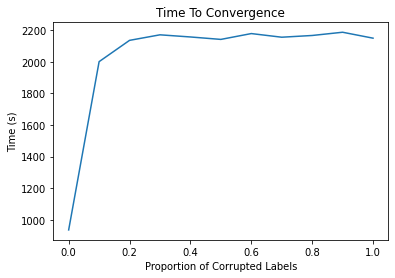

In [ ]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    myNormalize()
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_train)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

directory = "/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/WRN/WRNModel_Convergence"

for i, (input, target) in enumerate(trainloader):
  print(input.size())
  break

main("WRN",'wide-resnet','train', directory, 150)